In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import numpy as np
import pandas as pd

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import warnings
from tqdm import tqdm
import os
from pathlib import Path
# Define the device
device = "cuda" if torch.cuda.is_available() else "mps" if  torch.backends.mps.is_available() else "cpu" # torch.has_mps or
print("Using device:", device)
if (device == 'cuda'):
    print(f"Device name: {torch.cuda.get_device_name(device.index)}")
    print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")
elif (device == 'mps'):
    print(f"Device name: <mps>")
else:
    print("NOTE: If you have a GPU, consider using it for training.")
    print("      On a Windows machine with NVidia GPU, check this video: https://www.youtube.com/watch?v=GMSjDTU8Zlc")
    print("      On a Mac machine, run: pip3 install --pre torch torchvision torchaudio torchtext --index-url https://download.pytorch.org/whl/nightly/cpu")
device = torch.device(device)

Using device: cuda
Device name: Tesla T4
Device memory: 14.74810791015625 GB


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
def run_validation(model, val_loader,loss_fn, device):
    model.eval()
    loss_sum = 0
    num_batch = len(val_loader)
    total_y_true=[]
    total_y_pred=[]
    total_y_prob=[]
    for ESP_val_df_enzy,ESP_val_df_smiles, y_val in val_loader:

        ESP_val_df_enzy = ESP_val_df_enzy.to(device)
        ESP_val_df_smiles = ESP_val_df_smiles.to(device)
        y_val = y_val.squeeze(1).to(device)

        refined_enzy_embed, refined_smiles_embed = model(ESP_val_df_enzy,ESP_val_df_smiles)
        cos_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
        loss = loss_fn(cos_sim, y_val).detach().cpu().numpy()
        loss_sum = loss_sum + loss # count all the loss in the training process
        y_pred = (cos_sim > 0.5).float().cpu().numpy() # if score > 0.5, assign label 1 otherwise 0, transfer to cpu as numpy
        total_y_true.append(y_val.cpu().numpy())
        total_y_pred.append(y_pred)
        total_y_prob.append(cos_sim.detach().cpu().numpy())

    loss_sum = loss_sum/num_batch # get the overall average loss (Notice: this method is not 100% accurate)

    arrange_y_true = np.concatenate(total_y_true, axis=0)
    arrange_y_pred = np.concatenate(total_y_pred, axis=0)
    arrange_y_prob = np.concatenate(total_y_prob, axis=0)
    tn,fp,fn,tp = confusion_matrix(arrange_y_true, arrange_y_pred).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    specificity = tn/(tn+fp)
    sensitivity = tp/(tp+fn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    bacc = (sensitivity + specificity)/2
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    AUC = roc_auc_score(arrange_y_true, arrange_y_prob)
    f1 = 2*precision*recall/(precision+recall)
    print("loss_sum= ",loss_sum, "ACC= ",acc, "bacc= ",bacc, "precision= ",precision,"specificity= ",specificity, "sensitivity= ",sensitivity, "recall= ",recall, "MCC= ",MCC, "AUC= ",AUC, "f1= ",f1)
    return loss_sum, acc, bacc   # , precision, sensitivity, recall, MCC, AUC, f1


### esm2 2560 + MolFormer
add the missed 24 data points in test dataset

In [ ]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_2560')

In [ ]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enzy_refine_layer_1 = nn.Linear(2560, 2560) # W1 and b
        self.smiles_refine_layer_1 = nn.Linear(768, 768) # W1 and b
        self.enzy_refine_layer_2 = nn.Linear(2560, 128) # W1 and b
        self.smiles_refine_layer_2 = nn.Linear(768, 128) # W1 and b

        self.relu = nn.ReLU()
        self.batch_norm_enzy = nn.BatchNorm1d(2560)
        self.batch_norm_smiles = nn.BatchNorm1d(768)
        self.batch_norm_shared = nn.BatchNorm1d(128)

    def forward(self, enzy_embed, smiles_embed):
        refined_enzy_embed = self.enzy_refine_layer_1(enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_1(smiles_embed)

        refined_enzy_embed = self.batch_norm_enzy(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_smiles(refined_smiles_embed)

        refined_enzy_embed = self.relu(refined_enzy_embed)
        refined_smiles_embed = self.relu(refined_smiles_embed)

        refined_enzy_embed = self.enzy_refine_layer_2(refined_enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_2(refined_smiles_embed)

        refined_enzy_embed = self.batch_norm_shared(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_shared(refined_smiles_embed)
        refined_enzy_embed = torch.nn.functional.normalize(refined_enzy_embed, dim=1)
        refined_smiles_embed = torch.nn.functional.normalize(refined_smiles_embed, dim=1)

        return refined_enzy_embed, refined_smiles_embed


In [ ]:
ESP_val_df_enzy = torch.load('ESP_val_df_enzy_>2800_<8000.pt')
ESP_test_df_enzy = torch.load('ESP_test_df_enzy_>2800_<8000.pt')
ESP_val_df_smiles = torch.load('ESP_val_df_smiles_>2800_<8000.pt')
ESP_test_df_smiles = torch.load('ESP_test_df_smiles_>2800_<8000.pt')
y_val = torch.load('ESP_val_df_label_>2800_<8000.pt')
y_test = torch.load('ESP_test_df_label_>2800_<8000.pt')
print(ESP_val_df_enzy_add.shape, ESP_val_df_smiles_add.shape, y_val_add.shape)
print(ESP_test_df_enzy_add.shape, ESP_test_df_smiles_add.shape, y_test_add.shape)

torch.Size([23, 2560]) torch.Size([23, 768]) torch.Size([23, 1])
torch.Size([24, 2560]) torch.Size([24, 768]) torch.Size([24, 1])


In [ ]:
ESP_val_df_enzy_add = torch.load('ESP_val_df_enzy_>2800_<8000.pt')
ESP_test_df_enzy_add = torch.load('ESP_test_df_enzy_>2800_<8000.pt')
ESP_val_df_smiles_add = torch.load('ESP_val_df_smiles_>2800_<8000.pt')
ESP_test_df_smiles_add = torch.load('ESP_test_df_smiles_>2800_<8000.pt')
y_val_add = torch.load('ESP_val_df_label_>2800_<8000.pt')
y_test_add = torch.load('ESP_test_df_label_>2800_<8000.pt')
print(ESP_val_df_enzy_add.shape, ESP_val_df_smiles_add.shape, y_val_add.shape)
print(ESP_test_df_enzy_add.shape, ESP_test_df_smiles_add.shape, y_test_add.shape)

torch.Size([23, 2560]) torch.Size([23, 768]) torch.Size([23, 1])
torch.Size([24, 2560]) torch.Size([24, 768]) torch.Size([24, 1])


In [ ]:
# Load the saved embeddings_results
ESP_train_df_enzy = torch.load('ESP_train_df_enzy_esm2_2560.pt')
ESP_val_df_enzy = torch.load('ESP_val_df_enzy_esm2_2560.pt')
ESP_test_df_enzy = torch.load('ESP_test_df_enzy_esm2_2560.pt')
print(ESP_train_df_enzy.shape, ESP_val_df_enzy.shape, ESP_test_df_enzy.shape)
# Load the saved embeddings_results
ESP_train_df_smiles = torch.load('ESP_train_df_smiles_esm2_2560.pt')
ESP_val_df_smiles = torch.load('ESP_val_df_smiles_esm2_2560.pt')
ESP_test_df_smiles = torch.load('ESP_test_df_smiles_esm2_2560.pt')
print(ESP_train_df_smiles.shape, ESP_val_df_smiles.shape, ESP_test_df_smiles.shape)

y_train = torch.load( 'ESP_train_df_label_esm2_2560.pt')
y_val = torch.load('ESP_val_df_label_esm2_2560.pt')
y_test = torch.load('ESP_test_df_label_esm2_2560.pt')
print(y_train.shape,y_val.shape, y_test.shape)


torch.Size([49881, 2560]) torch.Size([5399, 2560]) torch.Size([13312, 2560])
torch.Size([49881, 768]) torch.Size([5399, 768]) torch.Size([13312, 768])
torch.Size([49881, 1]) torch.Size([5399, 1]) torch.Size([13312, 1])


In [ ]:
ESP_val_df_enzy = torch.cat([ESP_val_df_enzy, ESP_val_df_enzy_add], dim=0)
ESP_val_df_smiles = torch.cat([ESP_val_df_smiles, ESP_val_df_smiles_add], dim=0)
y_val = torch.cat([y_val, y_val_add], dim=0)
print(ESP_val_df_enzy.shape, ESP_val_df_smiles.shape, y_val.shape)
ESP_test_df_enzy = torch.cat([ESP_test_df_enzy, ESP_test_df_enzy_add], dim=0)
ESP_test_df_smiles = torch.cat([ESP_test_df_smiles, ESP_test_df_smiles_add], dim=0)
y_test = torch.cat([y_test, y_test_add], dim=0)
print(ESP_test_df_enzy.shape, ESP_test_df_smiles.shape, y_test.shape)

torch.Size([46, 2560]) torch.Size([46, 768]) torch.Size([46, 1])
torch.Size([48, 2560]) torch.Size([48, 768]) torch.Size([48, 1])


In [ ]:
train_tensor_dataset = TensorDataset(ESP_train_df_enzy,ESP_train_df_smiles, y_train)
val_tensor_dataset = TensorDataset(ESP_val_df_enzy,ESP_val_df_smiles, y_val)
test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)
print(ESP_val_df_enzy.shape, ESP_val_df_smiles.shape, y_val.shape)
print(ESP_test_df_enzy.shape, ESP_test_df_smiles.shape, y_test.shape)
# Create TensorDataset and DataLoaders
batch_size = 16
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))

torch.Size([23, 2560]) torch.Size([23, 768]) torch.Size([23, 1])
torch.Size([24, 2560]) torch.Size([24, 768]) torch.Size([24, 1])
3118


In [ ]:
# design the model, optimizer and loss function
model = Contrastive_learning_layer().to(device)
# train_loader,  val_loader, test_loader = get_ds()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-03)
loss_fn = nn.MSELoss().to(device)

In [ ]:
initial_epoch = 0
best_epoch = -1
best_accuracy = 0.5
for epoch in range(initial_epoch, 500):
    torch.cuda.empty_cache()
    model.train()
    with tqdm(train_loader, desc='Processing', unit="batch") as tepoch:
        for ESP_train_df_enzy,ESP_train_df_smiles, y_train in tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            ESP_train_df_enzy = ESP_train_df_enzy.to(device)
            ESP_train_df_smiles = ESP_train_df_smiles.to(device)
            y_train = y_train.squeeze(1).to(device)
            refined_enzy_embed, refined_smiles_embed = model(ESP_train_df_enzy,ESP_train_df_smiles)
            cosine_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
            loss = loss_fn(cosine_sim, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True) #
            tepoch.set_postfix(train_loss=loss)
            # tepoch.set_postfix(val_loss=loss_sum_val, val_accuracy=100. * acc_val, balanced_val_accuracy=100. * bacc_val)
        loss_sum_val,acc_val, bacc_val = run_validation(model,val_loader,loss_fn, device)
        print('Epoch: %d / %d, ############## the best accuracy in val  %.4f at Epoch: %d  ##############'  % (epoch, 500,100 * best_accuracy,best_epoch))
        # print('Performance in Train: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum, 100 * acc))
        print('Performance in Val: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum_val, 100 * acc_val))
        # checkpoint(model, f"epoch-{epoch}.pth")
        if acc_val > best_accuracy: # compare the performance updates at the val set
            best_accuracy = acc_val
            best_epoch = epoch
            torch.save(model, "best_model.pt")

In [ ]:
model

Contrastive_learning_layer(
  (enzy_refine_layer_1): Linear(in_features=2560, out_features=2560, bias=True)
  (smiles_refine_layer_1): Linear(in_features=768, out_features=768, bias=True)
  (enzy_refine_layer_2): Linear(in_features=2560, out_features=128, bias=True)
  (smiles_refine_layer_2): Linear(in_features=768, out_features=128, bias=True)
  (relu): ReLU()
  (batch_norm_enzy): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_smiles): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm_shared): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model_esm2_2560.pt'
# Load the entire model
model_test = torch.load(load_path)
# model_test.to('cuda')
run_validation(model_test,test_loader,loss_fn, device) # performance evaluation

loss_sum=  0.07082597073167562 ACC=  0.8333333333333334 bacc=  0.7222222222222222 precision=  0.75 specificity=  0.9444444444444444 sensitivity=  0.5 recall=  0.5 MCC=  0.5163977794943223 AUC=  0.9629629629629629 f1=  0.6


(0.07082597073167562, 0.8333333333333334, 0.7222222222222222)

loss_sum=  0.06416148592129153 ACC=  0.9347205528846154 bacc=  0.9052887921588186 precision=  0.9029600244125725 specificity=  0.9675576412976944 sensitivity=  0.843019943019943 recall=  0.843019943019943 MCC=  0.8291031932778974 AUC=  0.956207422637743 f1=  0.8719611021069692
(0.06416148592129153, 0.9347205528846154, 0.9052887921588186)

### esm2 480 + MolFormer


In [ ]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_480')

In [ ]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enzy_refine_layer_1 = nn.Linear(480, 480) # W1 and b
        self.smiles_refine_layer_1 = nn.Linear(768, 768) # W1 and b
        self.enzy_refine_layer_2 = nn.Linear(480, 128) # W1 and b
        self.smiles_refine_layer_2 = nn.Linear(768, 128) # W1 and b

        self.relu = nn.ReLU()
        self.batch_norm_enzy = nn.BatchNorm1d(480)
        self.batch_norm_smiles = nn.BatchNorm1d(768)
        self.batch_norm_shared = nn.BatchNorm1d(128)

    def forward(self, enzy_embed, smiles_embed):
        refined_enzy_embed = self.enzy_refine_layer_1(enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_1(smiles_embed)

        refined_enzy_embed = self.batch_norm_enzy(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_smiles(refined_smiles_embed)

        refined_enzy_embed = self.relu(refined_enzy_embed)
        refined_smiles_embed = self.relu(refined_smiles_embed)

        refined_enzy_embed = self.enzy_refine_layer_2(refined_enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_2(refined_smiles_embed)

        refined_enzy_embed = self.batch_norm_shared(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_shared(refined_smiles_embed)
        refined_enzy_embed = torch.nn.functional.normalize(refined_enzy_embed, dim=1)
        refined_smiles_embed = torch.nn.functional.normalize(refined_smiles_embed, dim=1)

        return refined_enzy_embed, refined_smiles_embed


In [ ]:
def get_ds():
    # Load the saved embeddings_results
    ESP_train_df_enzy = torch.load('ESP_train_df_enzy_esm2_480_MolFormer.pt')
    ESP_val_df_enzy = torch.load('ESP_val_df_enzy_esm2_480_MolFormer.pt')
    ESP_test_df_enzy = torch.load('ESP_test_df_enzy_esm2_480_MolFormer.pt')
    print(ESP_train_df_enzy.shape, ESP_val_df_enzy.shape, ESP_test_df_enzy.shape)
    # Load the saved embeddings_results
    ESP_train_df_smiles = torch.load('ESP_train_df_smiles_esm2_480_MolFormer.pt')
    ESP_val_df_smiles = torch.load('ESP_val_df_smiles_esm2_480_MolFormer.pt')
    ESP_test_df_smiles = torch.load('ESP_test_df_smiles_esm2_480_MolFormer.pt')
    print(ESP_train_df_smiles.shape, ESP_val_df_smiles.shape, ESP_test_df_smiles.shape)

    y_train = torch.load( 'ESP_train_df_label_esm2_480_MolFormer.pt')
    y_val = torch.load('ESP_val_df_label_esm2_480_MolFormer.pt')
    y_test = torch.load('ESP_test_df_label_esm2_480_MolFormer.pt')
    print(y_train.shape,y_val.shape, y_test.shape)


    train_tensor_dataset = TensorDataset(ESP_train_df_enzy,ESP_train_df_smiles, y_train)
    val_tensor_dataset = TensorDataset(ESP_val_df_enzy,ESP_val_df_smiles, y_val)
    test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)

    # Create TensorDataset and DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
    print(len(train_loader))
    return train_loader,  val_loader, test_loader

In [ ]:
# design the model, optimizer and loss function
model = Contrastive_learning_layer().to(device)
train_loader,  val_loader, test_loader = get_ds()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-03)
loss_fn = nn.MSELoss().to(device)

torch.Size([50077, 480]) torch.Size([5422, 480]) torch.Size([13336, 480])
torch.Size([50077, 768]) torch.Size([5422, 768]) torch.Size([13336, 768])
torch.Size([50077, 1]) torch.Size([5422, 1]) torch.Size([13336, 1])
3130


In [ ]:
initial_epoch = 0
best_epoch = -1
best_accuracy = 0.5
for epoch in range(initial_epoch, 500):
    torch.cuda.empty_cache()
    model.train()
    with tqdm(train_loader, desc='Processing', unit="batch") as tepoch:
        for ESP_train_df_enzy,ESP_train_df_smiles, y_train in tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            ESP_train_df_enzy = ESP_train_df_enzy.to(device)
            ESP_train_df_smiles = ESP_train_df_smiles.to(device)
            y_train = y_train.squeeze(1).to(device)
            refined_enzy_embed, refined_smiles_embed = model(ESP_train_df_enzy,ESP_train_df_smiles)
            cosine_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
            loss = loss_fn(cosine_sim, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True) #
            tepoch.set_postfix(train_loss=loss)
            # tepoch.set_postfix(val_loss=loss_sum_val, val_accuracy=100. * acc_val, balanced_val_accuracy=100. * bacc_val)
        loss_sum_val,acc_val, bacc_val = run_validation(model,val_loader,loss_fn, device)
        print('Epoch: %d / %d, ############## the best accuracy in val  %.4f at Epoch: %d  ##############'  % (epoch, 500,100 * best_accuracy,best_epoch))
        # print('Performance in Train: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum, 100 * acc))
        print('Performance in Val: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum_val, 100 * acc_val))
        # checkpoint(model, f"epoch-{epoch}.pth")
        if acc_val > best_accuracy: # compare the performance updates at the val set
            best_accuracy = acc_val
            best_epoch = epoch
            torch.save(model, "best_model_1.pt")

Epoch 0: 100%|██████████| 3130/3130 [00:24<00:00, 127.15batch/s, train_loss=tensor(0.2326, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.1473784355671972 ACC=  0.799151604573958 bacc=  0.6504259846709604 precision=  0.7766990291262136 specificity=  0.9654221999498872 sensitivity=  0.33542976939203356 recall=  0.33542976939203356 MCC=  0.41727061558130796 AUC=  0.8252109349460464 f1=  0.4685212298682284
Epoch: 0 / 500, ############## the best accuracy in val  50.0000 at Epoch: -1  ##############
Performance in Val: Loss: (0.1474); Accuracy (79.92)


Epoch 1: 100%|██████████| 3130/3130 [00:23<00:00, 131.55batch/s, train_loss=tensor(0.2078, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.13942457492680324 ACC=  0.816857248247879 bacc=  0.6770211137183051 precision=  0.8358895705521472 specificity=  0.9731896767727387 sensitivity=  0.3808525506638714 recall=  0.3808525506638714 MCC=  0.47976963516558246 AUC=  0.8538853405487296 f1=  0.5232837253960634
Epoch: 1 / 500, ############## the best accuracy in val  79.9152 at Epoch: 0  ##############
Performance in Val: Loss: (0.1394); Accuracy (81.69)


Epoch 2: 100%|██████████| 3130/3130 [00:24<00:00, 126.99batch/s, train_loss=tensor(0.1807, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.12269547519035044 ACC=  0.8384360014754703 bacc=  0.7322455608977642 precision=  0.8093645484949833 specificity=  0.9571535955900776 sensitivity=  0.5073375262054507 recall=  0.5073375262054507 MCC=  0.5509758770094789 AUC=  0.877579462946066 f1=  0.6237113402061855
Epoch: 2 / 500, ############## the best accuracy in val  81.6857 at Epoch: 1  ##############
Performance in Val: Loss: (0.1227); Accuracy (83.84)


Epoch 3: 100%|██████████| 3130/3130 [00:24<00:00, 125.42batch/s, train_loss=tensor(0.1257, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.11459334216913027 ACC=  0.8535595721136112 bacc=  0.7595521089467374 precision=  0.8293691830403309 specificity=  0.9586569782009522 sensitivity=  0.5604472396925227 recall=  0.5604472396925227 MCC=  0.5976929692904216 AUC=  0.8994354173199972 f1=  0.6688907422852377
Epoch: 3 / 500, ############## the best accuracy in val  83.8436 at Epoch: 2  ##############
Performance in Val: Loss: (0.1146); Accuracy (85.36)


Epoch 4: 100%|██████████| 3130/3130 [00:24<00:00, 126.83batch/s, train_loss=tensor(0.1064, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.10815682087730957 ACC=  0.8624123939505718 bacc=  0.7805819558016718 precision=  0.8252611585944919 specificity=  0.9538962665998496 sensitivity=  0.6072676450034941 recall=  0.6072676450034941 MCC=  0.6252377717272865 AUC=  0.915777743108577 f1=  0.6996779388083736
Epoch: 4 / 500, ############## the best accuracy in val  85.3560 at Epoch: 3  ##############
Performance in Val: Loss: (0.1082); Accuracy (86.24)


Epoch 5: 100%|██████████| 3130/3130 [00:24<00:00, 128.21batch/s, train_loss=tensor(0.0712, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.10611297148568309 ACC=  0.8679454075986721 bacc=  0.7865816535842963 precision=  0.8427612655800575 specificity=  0.9589075419694312 sensitivity=  0.6142557651991615 recall=  0.6142557651991615 MCC=  0.640928278916666 AUC=  0.912926288901951 f1=  0.7105901374292644
Epoch: 5 / 500, ############## the best accuracy in val  86.2412 at Epoch: 4  ##############
Performance in Val: Loss: (0.1061); Accuracy (86.79)


Epoch 6: 100%|██████████| 3130/3130 [00:24<00:00, 128.16batch/s, train_loss=tensor(0.0897, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.10294639962865451 ACC=  0.8762449280708225 bacc=  0.8081321512886874 precision=  0.8333333333333334 specificity=  0.9523928839889751 sensitivity=  0.6638714185883997 recall=  0.6638714185883997 MCC=  0.6665794725676828 AUC=  0.9154384051747458 f1=  0.7390120575651498
Epoch: 6 / 500, ############## the best accuracy in val  86.7945 at Epoch: 5  ##############
Performance in Val: Loss: (0.1029); Accuracy (87.62)


Epoch 7: 100%|██████████| 3130/3130 [00:24<00:00, 127.87batch/s, train_loss=tensor(0.1820, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09798203671081843 ACC=  0.8815935079306529 bacc=  0.815799560191423 precision=  0.8439407149084568 specificity=  0.9551490854422451 sensitivity=  0.676450034940601 recall=  0.676450034940601 MCC=  0.6816358580360294 AUC=  0.9230838394073598 f1=  0.7509697439875872
Epoch: 7 / 500, ############## the best accuracy in val  87.6245 at Epoch: 6  ##############
Performance in Val: Loss: (0.0980); Accuracy (88.16)


Epoch 8: 100%|██████████| 3130/3130 [00:25<00:00, 124.63batch/s, train_loss=tensor(0.0725, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09569543030574522 ACC=  0.8839911471781631 bacc=  0.8322204169724298 precision=  0.8167456556082149 specificity=  0.9418692057128539 sensitivity=  0.7225716282320056 recall=  0.7225716282320056 MCC=  0.6922490575170422 AUC=  0.9251028826039582 f1=  0.7667779013718947
Epoch: 8 / 500, ############## the best accuracy in val  88.1594 at Epoch: 7  ##############
Performance in Val: Loss: (0.0957); Accuracy (88.40)


Epoch 9: 100%|██████████| 3130/3130 [00:24<00:00, 126.43batch/s, train_loss=tensor(0.0525, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09109311006622592 ACC=  0.8924751014385836 bacc=  0.8397763766517992 precision=  0.843042071197411 specificity=  0.9513906289150589 sensitivity=  0.7281621243885394 recall=  0.7281621243885394 MCC=  0.7139618559269866 AUC=  0.9340695985954421 f1=  0.7814023247094114
Epoch: 9 / 500, ############## the best accuracy in val  88.3991 at Epoch: 8  ##############
Performance in Val: Loss: (0.0911); Accuracy (89.25)


Epoch 10: 100%|██████████| 3130/3130 [00:24<00:00, 128.76batch/s, train_loss=tensor(0.0388, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09252684491832128 ACC=  0.8921062338620436 bacc=  0.8417670541387584 precision=  0.8362480127186009 specificity=  0.94838386369331 sensitivity=  0.7351502445842069 recall=  0.7351502445842069 MCC=  0.7137156017438961 AUC=  0.9333040746291315 f1=  0.7824470063220529
Epoch: 10 / 500, ############## the best accuracy in val  89.2475 at Epoch: 9  ##############
Performance in Val: Loss: (0.0925); Accuracy (89.21)


Epoch 11: 100%|██████████| 3130/3130 [00:24<00:00, 129.53batch/s, train_loss=tensor(0.0548, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09007877719129785 ACC=  0.8956104758391737 bacc=  0.8457162788181165 precision=  0.8451715881883479 specificity=  0.9513906289150589 sensitivity=  0.740041928721174 recall=  0.740041928721174 MCC=  0.722967913661487 AUC=  0.9331316041106466 f1=  0.7891207153502237
Epoch: 11 / 500, ############## the best accuracy in val  89.2475 at Epoch: 9  ##############
Performance in Val: Loss: (0.0901); Accuracy (89.56)


Epoch 12: 100%|██████████| 3130/3130 [00:24<00:00, 128.85batch/s, train_loss=tensor(0.0667, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08776905095468449 ACC=  0.898930284028034 bacc=  0.8542468282496554 precision=  0.8419829589465531 specificity=  0.9488849912302681 sensitivity=  0.7596086652690426 recall=  0.7596086652690426 MCC=  0.733172097052255 AUC=  0.9374524721153694 f1=  0.798677443056576
Epoch: 12 / 500, ############## the best accuracy in val  89.5610 at Epoch: 11  ##############
Performance in Val: Loss: (0.0878); Accuracy (89.89)


Epoch 13: 100%|██████████| 3130/3130 [00:24<00:00, 130.14batch/s, train_loss=tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08637640807794127 ACC=  0.9028033935817041 bacc=  0.8573259960697734 precision=  0.8547880690737834 specificity=  0.9536457028313706 sensitivity=  0.7610062893081762 recall=  0.7610062893081762 MCC=  0.7429356550997184 AUC=  0.9398878959139545 f1=  0.8051756007393716
Epoch: 13 / 500, ############## the best accuracy in val  89.8930 at Epoch: 12  ##############
Performance in Val: Loss: (0.0864); Accuracy (90.28)


Epoch 14: 100%|██████████| 3130/3130 [00:24<00:00, 129.21batch/s, train_loss=tensor(0.1046, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08785446181448292 ACC=  0.8969015123570638 bacc=  0.8492827415143192 precision=  0.8433070866141732 specificity=  0.9501378100726635 sensitivity=  0.7484276729559748 recall=  0.7484276729559748 MCC=  0.7270047873073662 AUC=  0.9366341564116747 f1=  0.7930396149574231
Epoch: 14 / 500, ############## the best accuracy in val  90.2803 at Epoch: 13  ##############
Performance in Val: Loss: (0.0879); Accuracy (89.69)


Epoch 15: 100%|██████████| 3130/3130 [00:24<00:00, 127.73batch/s, train_loss=tensor(0.0727, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08467182534222098 ACC=  0.9026189597934342 bacc=  0.8560800935578147 precision=  0.8569169960474309 specificity=  0.9546479579052869 sensitivity=  0.7575122292103424 recall=  0.7575122292103424 MCC=  0.7421694898837828 AUC=  0.9422047790617638 f1=  0.8041543026706233
Epoch: 15 / 500, ############## the best accuracy in val  90.2803 at Epoch: 13  ##############
Performance in Val: Loss: (0.0847); Accuracy (90.26)


Epoch 16: 100%|██████████| 3130/3130 [00:25<00:00, 125.07batch/s, train_loss=tensor(0.0942, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08457571380444773 ACC=  0.9024345260051642 bacc=  0.8629026595654339 precision=  0.8396084337349398 specificity=  0.9466299173139564 sensitivity=  0.7791754018169113 recall=  0.7791754018169113 MCC=  0.7438885443064667 AUC=  0.9431672871227907 f1=  0.8082638637187387
Epoch: 16 / 500, ############## the best accuracy in val  90.2803 at Epoch: 13  ##############
Performance in Val: Loss: (0.0846); Accuracy (90.24)


Epoch 17: 100%|██████████| 3130/3130 [00:24<00:00, 129.54batch/s, train_loss=tensor(0.0882, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.084050376770419 ACC=  0.9070453707119144 bacc=  0.8640175895415279 precision=  0.8607003891050584 specificity=  0.9551490854422451 sensitivity=  0.7728860936408106 recall=  0.7728860936408106 MCC=  0.7546033374692187 AUC=  0.9388854657430652 f1=  0.8144329896907216
Epoch: 17 / 500, ############## the best accuracy in val  90.2803 at Epoch: 13  ##############
Performance in Val: Loss: (0.0841); Accuracy (90.70)


Epoch 18: 100%|██████████| 3130/3130 [00:24<00:00, 129.30batch/s, train_loss=tensor(0.0465, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08337764011745431 ACC=  0.9037255625230542 bacc=  0.8610901432485847 precision=  0.8504240555127217 specificity=  0.9513906289150589 sensitivity=  0.7707896575821104 recall=  0.7707896575821104 MCC=  0.7461469112394582 AUC=  0.9422522303414688 f1=  0.8086510263929618
Epoch: 18 / 500, ############## the best accuracy in val  90.7045 at Epoch: 17  ##############
Performance in Val: Loss: (0.0834); Accuracy (90.37)


Epoch 19: 100%|██████████| 3130/3130 [00:24<00:00, 129.02batch/s, train_loss=tensor(0.0835, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08183995307942407 ACC=  0.9063076355588344 bacc=  0.8691195651431654 precision=  0.8446601941747572 specificity=  0.9478827361563518 sensitivity=  0.790356394129979 recall=  0.790356394129979 MCC=  0.7545321744396606 AUC=  0.9436768193144567 f1=  0.8166064981949459
Epoch: 19 / 500, ############## the best accuracy in val  90.7045 at Epoch: 17  ##############
Performance in Val: Loss: (0.0818); Accuracy (90.63)


Epoch 20: 100%|██████████| 3130/3130 [00:24<00:00, 128.35batch/s, train_loss=tensor(0.0646, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08254321567868061 ACC=  0.9101807451125046 bacc=  0.8706298640844765 precision=  0.8608562691131498 specificity=  0.9543973941368078 sensitivity=  0.7868623340321453 recall=  0.7868623340321453 MCC=  0.7636512572761237 AUC=  0.9430191550835642 f1=  0.8221978824388463
Epoch: 20 / 500, ############## the best accuracy in val  90.7045 at Epoch: 17  ##############
Performance in Val: Loss: (0.0825); Accuracy (91.02)


Epoch 21: 100%|██████████| 3130/3130 [00:24<00:00, 127.99batch/s, train_loss=tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08129674944598063 ACC=  0.9070453707119144 bacc=  0.8664829549225099 precision=  0.854628921193573 specificity=  0.9523928839889751 sensitivity=  0.7805730258560447 recall=  0.7805730258560447 MCC=  0.7553039281032938 AUC=  0.9436531812230909 f1=  0.8159240321402483
Epoch: 21 / 500, ############## the best accuracy in val  91.0181 at Epoch: 20  ##############
Performance in Val: Loss: (0.0813); Accuracy (90.70)


Epoch 22: 100%|██████████| 3130/3130 [00:24<00:00, 127.89batch/s, train_loss=tensor(0.0604, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08032724820901599 ACC=  0.9114717816303947 bacc=  0.8710585890230658 precision=  0.866615265998458 specificity=  0.9566524680531195 sensitivity=  0.7854647099930119 recall=  0.7854647099930119 MCC=  0.7667454381268748 AUC=  0.9426083775847159 f1=  0.8240469208211143
Epoch: 22 / 500, ############## the best accuracy in val  91.0181 at Epoch: 20  ##############
Performance in Val: Loss: (0.0803); Accuracy (91.15)


Epoch 23: 100%|██████████| 3130/3130 [00:24<00:00, 129.53batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08137416597428267 ACC=  0.9079675396532645 bacc=  0.8671093643437077 precision=  0.857910906298003 specificity=  0.9536457028313706 sensitivity=  0.7805730258560447 recall=  0.7805730258560447 MCC=  0.7575861720960637 AUC=  0.941976452608866 f1=  0.8174167581412368
Epoch: 23 / 500, ############## the best accuracy in val  91.1472 at Epoch: 22  ##############
Performance in Val: Loss: (0.0814); Accuracy (90.80)


Epoch 24: 100%|██████████| 3130/3130 [00:24<00:00, 125.37batch/s, train_loss=tensor(0.0553, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07751347658095283 ACC=  0.9118406492069348 bacc=  0.874895138800246 precision=  0.8590806330067822 specificity=  0.9531445752944124 sensitivity=  0.7966457023060797 recall=  0.7966457023060797 MCC=  0.7686667069391389 AUC=  0.9479913838281485 f1=  0.8266860043509789
Epoch: 24 / 500, ############## the best accuracy in val  91.1472 at Epoch: 22  ##############
Performance in Val: Loss: (0.0775); Accuracy (91.18)


Epoch 25: 100%|██████████| 3130/3130 [00:25<00:00, 124.52batch/s, train_loss=tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07910880280636624 ACC=  0.9122095167834747 bacc=  0.8731285854388307 precision=  0.8653404743687835 specificity=  0.9559007767476823 sensitivity=  0.790356394129979 recall=  0.790356394129979 MCC=  0.7690002563125048 AUC=  0.9463929235608912 f1=  0.8261504747991234
Epoch: 25 / 500, ############## the best accuracy in val  91.1841 at Epoch: 24  ##############
Performance in Val: Loss: (0.0791); Accuracy (91.22)


Epoch 26: 100%|██████████| 3130/3130 [00:24<00:00, 127.27batch/s, train_loss=tensor(0.0756, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07885900495716736 ACC=  0.9129472519365548 bacc=  0.8700437269670875 precision=  0.8772619984264359 specificity=  0.9609120521172638 sensitivity=  0.7791754018169113 recall=  0.7791754018169113 MCC=  0.7700068361220213 AUC=  0.9461061147189842 f1=  0.8253145817912657
Epoch: 26 / 500, ############## the best accuracy in val  91.2210 at Epoch: 25  ##############
Performance in Val: Loss: (0.0789); Accuracy (91.29)


Epoch 27: 100%|██████████| 3130/3130 [00:24<00:00, 126.40batch/s, train_loss=tensor(0.0426, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0778519952048858 ACC=  0.9140538546661748 bacc=  0.8748296525323137 precision=  0.8708685626441199 specificity=  0.9579052868955149 sensitivity=  0.7917540181691125 recall=  0.7917540181691125 MCC=  0.7737214930893661 AUC=  0.9455335476170089 f1=  0.8294289897510981
Epoch: 27 / 500, ############## the best accuracy in val  91.2947 at Epoch: 26  ##############
Performance in Val: Loss: (0.0779); Accuracy (91.41)


Epoch 28: 100%|██████████| 3130/3130 [00:24<00:00, 126.85batch/s, train_loss=tensor(0.0772, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07639065917696705 ACC=  0.9147915898192549 bacc=  0.8822786279611305 precision=  0.8565121412803532 specificity=  0.9511400651465798 sensitivity=  0.8134171907756813 recall=  0.8134171907756813 MCC=  0.777566524997299 AUC=  0.950476710264062 f1=  0.8344086021505377
Epoch: 28 / 500, ############## the best accuracy in val  91.4054 at Epoch: 27  ##############
Performance in Val: Loss: (0.0764); Accuracy (91.48)


Epoch 29: 100%|██████████| 3130/3130 [00:24<00:00, 127.64batch/s, train_loss=tensor(0.1090, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07797370316284903 ACC=  0.9131316857248248 bacc=  0.8728584983578531 precision=  0.8709428129829985 specificity=  0.958155850663994 sensitivity=  0.7875611460517121 recall=  0.7875611460517121 MCC=  0.7710769842498376 AUC=  0.9451800268283582 f1=  0.8271559633027523
Epoch: 29 / 500, ############## the best accuracy in val  91.4792 at Epoch: 28  ##############
Performance in Val: Loss: (0.0780); Accuracy (91.31)


Epoch 30: 100%|██████████| 3130/3130 [00:24<00:00, 125.70batch/s, train_loss=tensor(0.0501, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07774782861558209 ACC=  0.9142382884544449 bacc=  0.8771961756719915 precision=  0.865909090909091 specificity=  0.9556502129792032 sensitivity=  0.7987421383647799 recall=  0.7987421383647799 MCC=  0.7747706559383489 AUC=  0.9456566407890851 f1=  0.8309705561613959
Epoch: 30 / 500, ############## the best accuracy in val  91.4792 at Epoch: 28  ##############
Performance in Val: Loss: (0.0777); Accuracy (91.42)


Epoch 31: 100%|██████████| 3130/3130 [00:24<00:00, 128.86batch/s, train_loss=tensor(0.0791, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07809033602748099 ACC=  0.9133161195130948 bacc=  0.8765697662507939 precision=  0.8626415094339622 specificity=  0.9543973941368078 sensitivity=  0.7987421383647799 recall=  0.7987421383647799 MCC=  0.7724941586147162 AUC=  0.9428328519042061 f1=  0.8294629898403484
Epoch: 31 / 500, ############## the best accuracy in val  91.4792 at Epoch: 28  ##############
Performance in Val: Loss: (0.0781); Accuracy (91.33)


Epoch 32: 100%|██████████| 3130/3130 [00:24<00:00, 127.42batch/s, train_loss=tensor(0.0945, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07542257191706724 ACC=  0.914976023607525 bacc=  0.8797144203388442 precision=  0.863568215892054 specificity=  0.9543973941368078 sensitivity=  0.8050314465408805 recall=  0.8050314465408805 MCC=  0.7771671025502406 AUC=  0.9489069659003897 f1=  0.8332730560578663
Epoch: 32 / 500, ############## the best accuracy in val  91.4792 at Epoch: 28  ##############
Performance in Val: Loss: (0.0754); Accuracy (91.50)


Epoch 33: 100%|██████████| 3130/3130 [00:24<00:00, 130.24batch/s, train_loss=tensor(0.0748, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07556354978250938 ACC=  0.9122095167834747 bacc=  0.8733527095643745 precision=  0.8647822765469825 specificity=  0.9556502129792032 sensitivity=  0.7910552061495457 recall=  0.7910552061495457 MCC=  0.7690610311690115 AUC=  0.9501543567366195 f1=  0.8262773722627738
Epoch: 33 / 500, ############## the best accuracy in val  91.4976 at Epoch: 32  ##############
Performance in Val: Loss: (0.0756); Accuracy (91.22)


Epoch 34: 100%|██████████| 3130/3130 [00:25<00:00, 125.09batch/s, train_loss=tensor(0.1149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07650998813460051 ACC=  0.9131316857248248 bacc=  0.876668608492098 precision=  0.8614457831325302 specificity=  0.9538962665998496 sensitivity=  0.7994409503843466 recall=  0.7994409503843466 MCC=  0.7721063912638739 AUC=  0.9461686243383742 f1=  0.829285973178688
Epoch: 34 / 500, ############## the best accuracy in val  91.4976 at Epoch: 32  ##############
Performance in Val: Loss: (0.0765); Accuracy (91.31)


Epoch 35: 100%|██████████| 3130/3130 [00:24<00:00, 127.57batch/s, train_loss=tensor(0.0673, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07629689758308342 ACC=  0.9153448911840649 bacc=  0.8790684876051479 precision=  0.8670694864048338 specificity=  0.9559007767476823 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7778187166849966 AUC=  0.9478280183522638 f1=  0.833393829401089
Epoch: 35 / 500, ############## the best accuracy in val  91.4976 at Epoch: 32  ##############
Performance in Val: Loss: (0.0763); Accuracy (91.53)


Epoch 36: 100%|██████████| 3130/3130 [00:24<00:00, 129.03batch/s, train_loss=tensor(0.0563, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07634233636094757 ACC=  0.916451493913685 bacc=  0.8798201789105851 precision=  0.8710166919575114 specificity=  0.9574041593585567 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7805618643172983 AUC=  0.9461549667744739 f1=  0.8352128046562386
Epoch: 36 / 500, ############## the best accuracy in val  91.5345 at Epoch: 35  ##############
Performance in Val: Loss: (0.0763); Accuracy (91.65)


Epoch 37: 100%|██████████| 3130/3130 [00:24<00:00, 128.56batch/s, train_loss=tensor(0.0544, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07559567317503964 ACC=  0.916820361490225 bacc=  0.8818637356834149 precision=  0.8678678678678678 specificity=  0.9559007767476823 sensitivity=  0.8078266946191475 recall=  0.8078266946191475 MCC=  0.7819614204713471 AUC=  0.9474329995809928 f1=  0.8367716250452407
Epoch: 37 / 500, ############## the best accuracy in val  91.6451 at Epoch: 36  ##############
Performance in Val: Loss: (0.0756); Accuracy (91.68)


Epoch 38: 100%|██████████| 3130/3130 [00:24<00:00, 127.42batch/s, train_loss=tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07493507503160993 ACC=  0.9208779048321653 bacc=  0.8848440612622286 precision=  0.881859756097561 specificity=  0.9611626158857429 sensitivity=  0.8085255066387141 recall=  0.8085255066387141 MCC=  0.7921139050029212 AUC=  0.947591900084064 f1=  0.8436018957345972
Epoch: 38 / 500, ############## the best accuracy in val  91.6820 at Epoch: 37  ##############
Performance in Val: Loss: (0.0749); Accuracy (92.09)


Epoch 39: 100%|██████████| 3130/3130 [00:24<00:00, 127.49batch/s, train_loss=tensor(0.0659, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07494593178029213 ACC=  0.917742530431575 bacc=  0.8824901451046125 precision=  0.8711379050489827 specificity=  0.9571535955900776 sensitivity=  0.8078266946191475 recall=  0.8078266946191475 MCC=  0.7842391374162118 AUC=  0.9483342237014414 f1=  0.8382886149383612
Epoch: 39 / 500, ############## the best accuracy in val  92.0878 at Epoch: 38  ##############
Performance in Val: Loss: (0.0749); Accuracy (91.77)


Epoch 40: 100%|██████████| 3130/3130 [00:24<00:00, 125.69batch/s, train_loss=tensor(0.0781, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07406434048500164 ACC=  0.9186646993729252 bacc=  0.8813235615214596 precision=  0.8790199081163859 specificity=  0.9604109245803056 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7860950210393113 AUC=  0.9498057386632152 f1=  0.8388746803069054
Epoch: 40 / 500, ############## the best accuracy in val  92.0878 at Epoch: 38  ##############
Performance in Val: Loss: (0.0741); Accuracy (91.87)


Epoch 41: 100%|██████████| 3130/3130 [00:24<00:00, 126.99batch/s, train_loss=tensor(0.0282, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0733524638696527 ACC=  0.917004795278495 bacc=  0.882437265818742 precision=  0.8674157303370786 specificity=  0.9556502129792032 sensitivity=  0.8092243186582809 recall=  0.8092243186582809 MCC=  0.7825424925726628 AUC=  0.9495240076335276 f1=  0.8373101952277657
Epoch: 41 / 500, ############## the best accuracy in val  92.0878 at Epoch: 38  ##############
Performance in Val: Loss: (0.0734); Accuracy (91.70)


Epoch 42: 100%|██████████| 3130/3130 [00:25<00:00, 124.82batch/s, train_loss=tensor(0.0527, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07597843233212982 ACC=  0.9195868683142752 bacc=  0.8806052261893944 precision=  0.8859581070597362 specificity=  0.9631671260335756 sensitivity=  0.7980433263452131 recall=  0.7980433263452131 MCC=  0.7881452500557732 AUC=  0.9469437786382042 f1=  0.8397058823529412
Epoch: 42 / 500, ############## the best accuracy in val  92.0878 at Epoch: 38  ##############
Performance in Val: Loss: (0.0760); Accuracy (91.96)


Epoch 43: 100%|██████████| 3130/3130 [00:24<00:00, 126.09batch/s, train_loss=tensor(0.0391, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07453967613967515 ACC=  0.9186646993729252 bacc=  0.8824441821491787 precision=  0.8761398176291794 specificity=  0.9591581057379103 sensitivity=  0.8057302585604472 recall=  0.8057302585604472 MCC=  0.7863598261257745 AUC=  0.9461434103742505 f1=  0.8394612304331999
Epoch: 43 / 500, ############## the best accuracy in val  92.0878 at Epoch: 38  ##############
Performance in Val: Loss: (0.0745); Accuracy (91.87)


Epoch 44: 100%|██████████| 3130/3130 [00:24<00:00, 125.41batch/s, train_loss=tensor(0.1006, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07309773425052388 ACC=  0.9182958317963851 bacc=  0.8826418666317873 precision=  0.8736762481089259 specificity=  0.958155850663994 sensitivity=  0.8071278825995807 recall=  0.8071278825995807 MCC=  0.7855530279669458 AUC=  0.9522672519107895 f1=  0.8390846349436979
Epoch: 44 / 500, ############## the best accuracy in val  92.0878 at Epoch: 38  ##############
Performance in Val: Loss: (0.0731); Accuracy (91.83)


Epoch 45: 100%|██████████| 3130/3130 [00:24<00:00, 126.48batch/s, train_loss=tensor(0.0431, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07287757368181395 ACC=  0.9188491331611951 bacc=  0.8870519465442949 precision=  0.8656826568265683 specificity=  0.9543973941368078 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.7880489569763289 AUC=  0.9529011029533432 f1=  0.842067480258435
Epoch: 45 / 500, ############## the best accuracy in val  92.0878 at Epoch: 38  ##############
Performance in Val: Loss: (0.0729); Accuracy (91.88)


Epoch 46: 100%|██████████| 3130/3130 [00:24<00:00, 127.44batch/s, train_loss=tensor(0.0683, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0738254308612649 ACC=  0.9157137587606049 bacc=  0.8799914237502584 precision=  0.8667168674698795 specificity=  0.9556502129792032 sensitivity=  0.8043326345213138 recall=  0.8043326345213138 MCC=  0.7789175957018687 AUC=  0.9497777231475221 f1=  0.8343602754621239
Epoch: 46 / 500, ############## the best accuracy in val  92.0878 at Epoch: 38  ##############
Performance in Val: Loss: (0.0738); Accuracy (91.57)


Epoch 47: 100%|██████████| 3130/3130 [00:24<00:00, 126.80batch/s, train_loss=tensor(0.0843, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07432197506338974 ACC=  0.9201401696790852 bacc=  0.8847911819763581 precision=  0.878030303030303 specificity=  0.9596592332748685 sensitivity=  0.8099231306778477 recall=  0.8099231306778477 MCC=  0.7903709944248319 AUC=  0.9480260530288186 f1=  0.8426026899309342
Epoch: 47 / 500, ############## the best accuracy in val  92.0878 at Epoch: 38  ##############
Performance in Val: Loss: (0.0743); Accuracy (92.01)


Epoch 48: 100%|██████████| 3130/3130 [00:24<00:00, 127.69batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07416747396009642 ACC=  0.9216156399852453 bacc=  0.8871381818035373 precision=  0.8799093655589124 specificity=  0.9601603608118267 sensitivity=  0.8141160027952481 recall=  0.8141160027952481 MCC=  0.7943770943678434 AUC=  0.9490291835876005 f1=  0.8457350272232306
Epoch: 48 / 500, ############## the best accuracy in val  92.0878 at Epoch: 38  ##############
Performance in Val: Loss: (0.0742); Accuracy (92.16)


Epoch 49: 100%|██████████| 3130/3130 [00:24<00:00, 127.62batch/s, train_loss=tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0740919810387369 ACC=  0.9184802655846551 bacc=  0.8829912726415707 precision=  0.873771730914588 specificity=  0.958155850663994 sensitivity=  0.8078266946191475 recall=  0.8078266946191475 MCC=  0.7860690061325353 AUC=  0.9481659555103105 f1=  0.8395061728395062
Epoch: 49 / 500, ############## the best accuracy in val  92.1616 at Epoch: 48  ##############
Performance in Val: Loss: (0.0741); Accuracy (91.85)


Epoch 50: 100%|██████████| 3130/3130 [00:24<00:00, 126.77batch/s, train_loss=tensor(0.0809, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07374465867882501 ACC=  0.9199557358908153 bacc=  0.886683017222013 precision=  0.8722927557879014 specificity=  0.9571535955900776 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.7904343344418802 AUC=  0.9482403717238699 f1=  0.8433212996389892
Epoch: 50 / 500, ############## the best accuracy in val  92.1616 at Epoch: 48  ##############
Performance in Val: Loss: (0.0737); Accuracy (92.00)


Epoch 51: 100%|██████████| 3130/3130 [00:25<00:00, 124.78batch/s, train_loss=tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07235215873125073 ACC=  0.9214312061969753 bacc=  0.885444031040491 precision=  0.8832951945080092 specificity=  0.9616637434227011 sensitivity=  0.8092243186582809 recall=  0.8092243186582809 MCC=  0.7935547888290286 AUC=  0.9510350945112178 f1=  0.8446389496717723
Epoch: 51 / 500, ############## the best accuracy in val  92.1616 at Epoch: 48  ##############
Performance in Val: Loss: (0.0724); Accuracy (92.14)


Epoch 52: 100%|██████████| 3130/3130 [00:24<00:00, 126.08batch/s, train_loss=tensor(0.0648, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07314825756750055 ACC=  0.9199557358908153 bacc=  0.8848900242176623 precision=  0.8767951625094482 specificity=  0.9591581057379103 sensitivity=  0.8106219426974144 recall=  0.8106219426974144 MCC=  0.7899660917084453 AUC=  0.9489165962339092 f1=  0.8424110384894697
Epoch: 52 / 500, ############## the best accuracy in val  92.1616 at Epoch: 48  ##############
Performance in Val: Loss: (0.0731); Accuracy (92.00)


Epoch 53: 100%|██████████| 3130/3130 [00:24<00:00, 128.17batch/s, train_loss=tensor(0.0433, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07255675605220781 ACC=  0.9190335669494651 bacc=  0.8831429941687454 precision=  0.8763277693474962 specificity=  0.9591581057379103 sensitivity=  0.8071278825995807 recall=  0.8071278825995807 MCC=  0.7873905243430265 AUC=  0.9518577000907528 f1=  0.8403055656602401
Epoch: 53 / 500, ############## the best accuracy in val  92.1616 at Epoch: 48  ##############
Performance in Val: Loss: (0.0726); Accuracy (91.90)


Epoch 54: 100%|██████████| 3130/3130 [00:24<00:00, 127.52batch/s, train_loss=tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07306877648935908 ACC=  0.9205090372556253 bacc=  0.8821281321127674 precision=  0.8869969040247678 specificity=  0.9634176898020547 sensitivity=  0.80083857442348 recall=  0.80083857442348 MCC=  0.7906666216046653 AUC=  0.9480577455809465 f1=  0.8417186926184355
Epoch: 54 / 500, ############## the best accuracy in val  92.1616 at Epoch: 48  ##############
Performance in Val: Loss: (0.0731); Accuracy (92.05)


Epoch 55: 100%|██████████| 3130/3130 [00:24<00:00, 128.92batch/s, train_loss=tensor(0.0475, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07164924420075694 ACC=  0.9234599778679454 bacc=  0.8863738835160383 precision=  0.8919753086419753 specificity=  0.9649210724129291 sensitivity=  0.8078266946191475 recall=  0.8078266946191475 MCC=  0.7986037165106539 AUC=  0.9500205826491858 f1=  0.8478181151448478
Epoch: 55 / 500, ############## the best accuracy in val  92.1616 at Epoch: 48  ##############
Performance in Val: Loss: (0.0716); Accuracy (92.35)


Epoch 56: 100%|██████████| 3130/3130 [00:24<00:00, 128.75batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07141559233251618 ACC=  0.9199557358908153 bacc=  0.8857865207198377 precision=  0.8745304282494365 specificity=  0.958155850663994 sensitivity=  0.8134171907756813 recall=  0.8134171907756813 MCC=  0.7901944196798281 AUC=  0.9518617273211336 f1=  0.8428674873280232
Epoch: 56 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0714); Accuracy (92.00)


Epoch 57: 100%|██████████| 3130/3130 [00:24<00:00, 127.78batch/s, train_loss=tensor(0.0483, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07095702031179493 ACC=  0.9205090372556253 bacc=  0.8866106146236439 precision=  0.8753753753753754 specificity=  0.9584064144324731 sensitivity=  0.8148148148148148 recall=  0.8148148148148148 MCC=  0.7916818412708345 AUC=  0.9536664518226806 f1=  0.844010133912414
Epoch: 57 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0710); Accuracy (92.05)


Epoch 58: 100%|██████████| 3130/3130 [00:24<00:00, 129.43batch/s, train_loss=tensor(0.0278, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07207939609374224 ACC=  0.9205090372556253 bacc=  0.8886277317535384 precision=  0.8703703703703703 specificity=  0.9561513405161614 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.7922343984482636 AUC=  0.9511571371014552 f1=  0.845019777058612
Epoch: 58 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0721); Accuracy (92.05)


Epoch 59: 100%|██████████| 3130/3130 [00:24<00:00, 126.57batch/s, train_loss=tensor(0.0368, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07129000619213181 ACC=  0.9205090372556253 bacc=  0.8854899939959249 precision=  0.8782148260211801 specificity=  0.9596592332748685 sensitivity=  0.8113207547169812 recall=  0.8113207547169812 MCC=  0.7914001536216162 AUC=  0.9529387488025556 f1=  0.8434435161641846
Epoch: 59 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0713); Accuracy (92.05)


Epoch 60: 100%|██████████| 3130/3130 [00:24<00:00, 129.15batch/s, train_loss=tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07151605334863682 ACC=  0.9216156399852453 bacc=  0.8891552989334318 precision=  0.8748137108792846 specificity=  0.9579052868955149 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.7948904611121149 AUC=  0.9526941383311612 f1=  0.8467363865849261
Epoch: 60 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0715); Accuracy (92.16)


Epoch 61: 100%|██████████| 3130/3130 [00:23<00:00, 130.44batch/s, train_loss=tensor(0.0568, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0714951177405133 ACC=  0.9216156399852453 bacc=  0.887586430054625 precision=  0.8787650602409639 specificity=  0.9596592332748685 sensitivity=  0.8155136268343816 recall=  0.8155136268343816 MCC=  0.7944860629887142 AUC=  0.9510207365594251 f1=  0.8459586806814063
Epoch: 61 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0715); Accuracy (92.16)


Epoch 62: 100%|██████████| 3130/3130 [00:24<00:00, 128.74batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0705564300636802 ACC=  0.9227222427148654 bacc=  0.8896828661133251 precision=  0.8793103448275862 specificity=  0.9596592332748685 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.7975696674898848 AUC=  0.9523241584270408 f1=  0.8484629294755877
Epoch: 62 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0706); Accuracy (92.27)


Epoch 63: 100%|██████████| 3130/3130 [00:24<00:00, 129.53batch/s, train_loss=tensor(0.0427, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07155557263060129 ACC=  0.9201401696790852 bacc=  0.886135926729621 precision=  0.8746246246246246 specificity=  0.958155850663994 sensitivity=  0.8141160027952481 recall=  0.8141160027952481 MCC=  0.7907097991908858 AUC=  0.9516624669657674 f1=  0.8432862830256967
Epoch: 63 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0716); Accuracy (92.01)


Epoch 64: 100%|██████████| 3130/3130 [00:23<00:00, 130.74batch/s, train_loss=tensor(0.0351, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07087985049537589 ACC=  0.9223533751383254 bacc=  0.889432302344846 precision=  0.8779940119760479 specificity=  0.9591581057379103 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.7966549123450999 AUC=  0.9505884221328877 f1=  0.8478496566678713
Epoch: 64 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0709); Accuracy (92.24)


Epoch 65: 100%|██████████| 3130/3130 [00:23<00:00, 130.58batch/s, train_loss=tensor(0.0389, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07164704872454601 ACC=  0.9195868683142752 bacc=  0.8853118328258147 precision=  0.873779113448535 specificity=  0.9579052868955149 sensitivity=  0.8127183787561146 recall=  0.8127183787561146 MCC=  0.7892221313680265 AUC=  0.9518897428368267 f1=  0.8421433743664011
Epoch: 65 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0716); Accuracy (91.96)


Epoch 66: 100%|██████████| 3130/3130 [00:23<00:00, 130.57batch/s, train_loss=tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07202259543458972 ACC=  0.9182958317963851 bacc=  0.8810729977529805 precision=  0.8776758409785933 specificity=  0.9599097970433476 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7851684444449321 AUC=  0.9509997249226553 f1=  0.8382621394669587
Epoch: 66 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0720); Accuracy (91.83)


Epoch 67: 100%|██████████| 3130/3130 [00:24<00:00, 127.59batch/s, train_loss=tensor(0.0341, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07216650629443581 ACC=  0.9216156399852453 bacc=  0.883552195794836 precision=  0.8893188854489165 specificity=  0.9641693811074918 sensitivity=  0.8029350104821803 recall=  0.8029350104821803 MCC=  0.7936131715334177 AUC=  0.949787090835582 f1=  0.8439221446933529
Epoch: 67 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0722); Accuracy (92.16)


Epoch 68: 100%|██████████| 3130/3130 [00:24<00:00, 130.27batch/s, train_loss=tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07127480753999654 ACC=  0.9247510143858355 bacc=  0.8897162220866972 precision=  0.8901601830663616 specificity=  0.9639188173390127 sensitivity=  0.8155136268343816 recall=  0.8155136268343816 MCC=  0.8023504047693187 AUC=  0.950951748352031 f1=  0.8512035010940919
Epoch: 68 / 500, ############## the best accuracy in val  92.3460 at Epoch: 55  ##############
Performance in Val: Loss: (0.0713); Accuracy (92.48)


Epoch 69: 100%|██████████| 3130/3130 [00:24<00:00, 127.92batch/s, train_loss=tensor(0.0327, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07045632707790243 ACC=  0.9240132792327554 bacc=  0.8883185980475636 precision=  0.8898240244835501 specificity=  0.9639188173390127 sensitivity=  0.8127183787561146 recall=  0.8127183787561146 MCC=  0.8003061493621297 AUC=  0.9514495490465008 f1=  0.8495252008765523
Epoch: 69 / 500, ############## the best accuracy in val  92.4751 at Epoch: 68  ##############
Performance in Val: Loss: (0.0705); Accuracy (92.40)


Epoch 70: 100%|██████████| 3130/3130 [00:24<00:00, 129.02batch/s, train_loss=tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07091075990068833 ACC=  0.9238288454444854 bacc=  0.8908828056698501 precision=  0.8821321321321322 specificity=  0.9606614883487847 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8004302199903732 AUC=  0.9506470796188697 f1=  0.8505247918928701
Epoch: 70 / 500, ############## the best accuracy in val  92.4751 at Epoch: 68  ##############
Performance in Val: Loss: (0.0709); Accuracy (92.38)


Epoch 71: 100%|██████████| 3130/3130 [00:24<00:00, 129.59batch/s, train_loss=tensor(0.0389, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06973837100513346 ACC=  0.9241977130210255 bacc=  0.8888921281828909 precision=  0.8893129770992366 specificity=  0.9636682535705337 sensitivity=  0.8141160027952481 recall=  0.8141160027952481 MCC=  0.8008618905507795 AUC=  0.9523203062936332 f1=  0.8500547245530828
Epoch: 71 / 500, ############## the best accuracy in val  92.4751 at Epoch: 68  ##############
Performance in Val: Loss: (0.0697); Accuracy (92.42)


Epoch 72: 100%|██████████| 3130/3130 [00:24<00:00, 129.39batch/s, train_loss=tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0704646578325085 ACC=  0.9214312061969753 bacc=  0.8872370240448416 precision=  0.8786737000753579 specificity=  0.9596592332748685 sensitivity=  0.8148148148148148 recall=  0.8148148148148148 MCC=  0.7939719064643822 AUC=  0.9511084601429386 f1=  0.845540246555475
Epoch: 72 / 500, ############## the best accuracy in val  92.4751 at Epoch: 68  ##############
Performance in Val: Loss: (0.0705); Accuracy (92.14)


Epoch 73: 100%|██████████| 3130/3130 [00:24<00:00, 129.13batch/s, train_loss=tensor(0.0363, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07153333565714744 ACC=  0.9221689413500553 bacc=  0.887514027456256 precision=  0.8819076457229371 specificity=  0.9609120521172638 sensitivity=  0.8141160027952481 recall=  0.8141160027952481 MCC=  0.795759461339496 AUC=  0.9507785774456537 f1=  0.846656976744186
Epoch: 73 / 500, ############## the best accuracy in val  92.4751 at Epoch: 68  ##############
Performance in Val: Loss: (0.0715); Accuracy (92.22)


Epoch 74: 100%|██████████| 3130/3130 [00:24<00:00, 128.90batch/s, train_loss=tensor(0.0448, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07144886023120454 ACC=  0.9195868683142752 bacc=  0.8846394604491833 precision=  0.8754716981132076 specificity=  0.9586569782009522 sensitivity=  0.8106219426974144 recall=  0.8106219426974144 MCC=  0.7890483065807832 AUC=  0.9505019242281858 f1=  0.841799709724238
Epoch: 74 / 500, ############## the best accuracy in val  92.4751 at Epoch: 68  ##############
Performance in Val: Loss: (0.0714); Accuracy (91.96)


Epoch 75: 100%|██████████| 3130/3130 [00:24<00:00, 128.50batch/s, train_loss=tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07103288263923167 ACC=  0.9219845075617853 bacc=  0.885371628442122 precision=  0.8865030674846626 specificity=  0.9629165622650965 sensitivity=  0.8078266946191475 recall=  0.8078266946191475 MCC=  0.7948559833472036 AUC=  0.952469138720752 f1=  0.8453382084095064
Epoch: 75 / 500, ############## the best accuracy in val  92.4751 at Epoch: 68  ##############
Performance in Val: Loss: (0.0710); Accuracy (92.20)


Epoch 76: 100%|██████████| 3130/3130 [00:24<00:00, 125.41batch/s, train_loss=tensor(0.0626, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07097400994394469 ACC=  0.9227222427148654 bacc=  0.8901311143644128 precision=  0.8781763826606876 specificity=  0.9591581057379103 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.797683008581736 AUC=  0.9498348047607467 f1=  0.8486818345973275
Epoch: 76 / 500, ############## the best accuracy in val  92.4751 at Epoch: 68  ##############
Performance in Val: Loss: (0.0710); Accuracy (92.27)


Epoch 77: 100%|██████████| 3130/3130 [00:24<00:00, 130.28batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07051959513909126 ACC=  0.9247510143858355 bacc=  0.8912850909655039 precision=  0.8860377358490567 specificity=  0.9621648709596592 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8026811343175442 AUC=  0.9511953082415869 f1=  0.8519593613933237
Epoch: 77 / 500, ############## the best accuracy in val  92.4751 at Epoch: 68  ##############
Performance in Val: Loss: (0.0705); Accuracy (92.48)


Epoch 78: 100%|██████████| 3130/3130 [00:24<00:00, 130.09batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07061538430326413 ACC=  0.9238288454444854 bacc=  0.8913310539209378 precision=  0.8809880239520959 specificity=  0.9601603608118267 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8005391555404087 AUC=  0.9517018637847106 f1=  0.8507408745934225
Epoch: 78 / 500, ############## the best accuracy in val  92.4751 at Epoch: 68  ##############
Performance in Val: Loss: (0.0706); Accuracy (92.38)


Epoch 79: 100%|██████████| 3130/3130 [00:24<00:00, 129.02batch/s, train_loss=tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07088009844833551 ACC=  0.9229066765031354 bacc=  0.8889116514953894 precision=  0.8822641509433963 specificity=  0.9609120521172638 sensitivity=  0.816911250873515 recall=  0.816911250873515 MCC=  0.7978122672687009 AUC=  0.9517521166159848 f1=  0.8483309143686503
Epoch: 79 / 500, ############## the best accuracy in val  92.4751 at Epoch: 68  ##############
Performance in Val: Loss: (0.0709); Accuracy (92.29)


Epoch 80: 100%|██████████| 3130/3130 [00:24<00:00, 129.55batch/s, train_loss=tensor(0.0852, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07062479893465397 ACC=  0.9264109184802656 bacc=  0.8942056209280105 precision=  0.8873873873873874 specificity=  0.9624154347281383 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8072345145500145 AUC=  0.9503100179456888 f1=  0.8555917480998915
Epoch: 80 / 500, ############## the best accuracy in val  92.4751 at Epoch: 68  ##############
Performance in Val: Loss: (0.0706); Accuracy (92.64)


Epoch 81: 100%|██████████| 3130/3130 [00:24<00:00, 126.88batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06994013034169917 ACC=  0.9212467724087052 bacc=  0.8866634939095144 precision=  0.879154078549849 specificity=  0.9599097970433476 sensitivity=  0.8134171907756813 recall=  0.8134171907756813 MCC=  0.7934030721512054 AUC=  0.9544955359902199 f1=  0.8450090744101633
Epoch: 81 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0699); Accuracy (92.12)


Epoch 82: 100%|██████████| 3130/3130 [00:24<00:00, 127.39batch/s, train_loss=tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06976338119347715 ACC=  0.9247510143858355 bacc=  0.8924057115932231 precision=  0.8831460674157303 specificity=  0.9609120521172638 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8029399096150047 AUC=  0.9538564320384737 f1=  0.8524945770065075
Epoch: 82 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0698); Accuracy (92.48)


Epoch 83: 100%|██████████| 3130/3130 [00:24<00:00, 129.63batch/s, train_loss=tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06992172463563516 ACC=  0.9232755440796754 bacc=  0.8891622152638685 precision=  0.8835978835978836 specificity=  0.961413179654222 sensitivity=  0.816911250873515 recall=  0.816911250873515 MCC=  0.7987345342542432 AUC=  0.9524976795273642 f1=  0.8489469862018881
Epoch: 83 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0699); Accuracy (92.33)


Epoch 84: 100%|██████████| 3130/3130 [00:23<00:00, 130.69batch/s, train_loss=tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06945709123174525 ACC=  0.9225378089265953 bacc=  0.8893334601035419 precision=  0.8792198049512379 specificity=  0.9596592332748685 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.7970558908904952 AUC=  0.9538207122559652 f1=  0.8480463096960926
Epoch: 84 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0695); Accuracy (92.25)


Epoch 85: 100%|██████████| 3130/3130 [00:24<00:00, 130.06batch/s, train_loss=tensor(0.0501, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06980591004022059 ACC=  0.9236444116562155 bacc=  0.8925505167899612 precision=  0.876945885841364 specificity=  0.9584064144324731 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8004294331404155 AUC=  0.9538371713714346 f1=  0.8510791366906475
Epoch: 85 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0698); Accuracy (92.36)


Epoch 86: 100%|██████████| 3130/3130 [00:24<00:00, 126.62batch/s, train_loss=tensor(0.0572, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06963636944960572 ACC=  0.9240132792327554 bacc=  0.8894392186752829 precision=  0.8868640850417616 specificity=  0.9626659984966174 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.8005360490321366 AUC=  0.9531845849527614 f1=  0.8500727802037846
Epoch: 86 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0696); Accuracy (92.40)


Epoch 87: 100%|██████████| 3130/3130 [00:24<00:00, 129.41batch/s, train_loss=tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07002241767333013 ACC=  0.9223533751383254 bacc=  0.889432302344846 precision=  0.8779940119760479 specificity=  0.9591581057379103 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.7966549123450999 AUC=  0.951041923293168 f1=  0.8478496566678713
Epoch: 87 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0700); Accuracy (92.24)


Epoch 88: 100%|██████████| 3130/3130 [00:24<00:00, 130.07batch/s, train_loss=tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06958239546710498 ACC=  0.9249354481741054 bacc=  0.8936516141051818 precision=  0.8809523809523809 specificity=  0.9599097970433476 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8036731661212089 AUC=  0.9517780309680008 f1=  0.8533333333333333
Epoch: 88 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0696); Accuracy (92.49)


Epoch 89: 100%|██████████| 3130/3130 [00:24<00:00, 130.05batch/s, train_loss=tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06952884998502193 ACC=  0.9262264846919955 bacc=  0.8931838425415957 precision=  0.8890566037735849 specificity=  0.9631671260335756 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8065762279566188 AUC=  0.9531721530676727 f1=  0.8548621190130624
Epoch: 89 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0695); Accuracy (92.62)


Epoch 90: 100%|██████████| 3130/3130 [00:24<00:00, 129.79batch/s, train_loss=tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06998245821850907 ACC=  0.9251198819623755 bacc=  0.8904150341062639 precision=  0.8903274942878904 specificity=  0.9639188173390127 sensitivity=  0.816911250873515 recall=  0.816911250873515 MCC=  0.8033721567556275 AUC=  0.9502732475813416 f1=  0.8520408163265306
Epoch: 90 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0700); Accuracy (92.51)


Epoch 91: 100%|██████████| 3130/3130 [00:24<00:00, 128.09batch/s, train_loss=tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06973701656746588 ACC=  0.9249354481741054 bacc=  0.8916344969752873 precision=  0.8861236802413273 specificity=  0.9621648709596592 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8031929353626651 AUC=  0.9517797819377316 f1=  0.8523757707653247
Epoch: 91 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0697); Accuracy (92.49)


Epoch 92: 100%|██████████| 3130/3130 [00:24<00:00, 127.46batch/s, train_loss=tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06885473734553585 ACC=  0.9241977130210255 bacc=  0.8913574935638731 precision=  0.8828828828828829 specificity=  0.9609120521172638 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.801402262070322 AUC=  0.9538312180743498 f1=  0.8512486427795873
Epoch: 92 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0689); Accuracy (92.42)


Epoch 93: 100%|██████████| 3130/3130 [00:24<00:00, 129.54batch/s, train_loss=tensor(0.0372, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07023806986055586 ACC=  0.9230911102914053 bacc=  0.8888128092540852 precision=  0.8835098335854765 specificity=  0.961413179654222 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.7982218002187317 AUC=  0.9520203651787451 f1=  0.8485288775880857
Epoch: 93 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0702); Accuracy (92.31)


Epoch 94: 100%|██████████| 3130/3130 [00:24<00:00, 127.10batch/s, train_loss=tensor(0.0964, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06982543084984727 ACC=  0.9253043157506455 bacc=  0.8921091848693102 precision=  0.8868778280542986 specificity=  0.9624154347281383 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8041664603353782 AUC=  0.9525102865094259 f1=  0.85310119695321
Epoch: 94 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0698); Accuracy (92.53)


Epoch 95: 100%|██████████| 3130/3130 [00:24<00:00, 128.32batch/s, train_loss=tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06908454885843669 ACC=  0.9247510143858355 bacc=  0.8901644703377849 precision=  0.8889733840304183 specificity=  0.9634176898020547 sensitivity=  0.816911250873515 recall=  0.816911250873515 MCC=  0.8024411047717274 AUC=  0.9518268830234905 f1=  0.8514202476329206
Epoch: 95 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0691); Accuracy (92.48)


Epoch 96: 100%|██████████| 3130/3130 [00:24<00:00, 127.86batch/s, train_loss=tensor(0.0461, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06873127708010991 ACC=  0.9245665805975655 bacc=  0.8889185678258261 precision=  0.891271056661562 specificity=  0.9644199448759709 sensitivity=  0.8134171907756813 recall=  0.8134171907756813 MCC=  0.8017520568039075 AUC=  0.9530238459314729 f1=  0.8505663134819145
Epoch: 96 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0687); Accuracy (92.46)


Epoch 97: 100%|██████████| 3130/3130 [00:24<00:00, 128.83batch/s, train_loss=tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06913788884378157 ACC=  0.9280708225746956 bacc=  0.895781406137254 precision=  0.8922381311228335 specificity=  0.9641693811074918 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8114908907510892 AUC=  0.9534004795205704 f1=  0.8585931834662799
Epoch: 97 / 500, ############## the best accuracy in val  92.6411 at Epoch: 80  ##############
Performance in Val: Loss: (0.0691); Accuracy (92.81)


Epoch 98: 100%|██████████| 3130/3130 [00:24<00:00, 126.89batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06958541707589036 ACC=  0.9234599778679454 bacc=  0.8910804901524587 precision=  0.8796711509715994 specificity=  0.9596592332748685 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.7996241532559228 AUC=  0.9533055769611606 f1=  0.850126399422174
Epoch: 98 / 500, ############## the best accuracy in val  92.8071 at Epoch: 97  ##############
Performance in Val: Loss: (0.0696); Accuracy (92.35)


Epoch 99: 100%|██████████| 3130/3130 [00:25<00:00, 124.87batch/s, train_loss=tensor(0.0627, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06852897095073641 ACC=  0.9251198819623755 bacc=  0.8910874064828954 precision=  0.88855193328279 specificity=  0.9631671260335756 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.8035101210300633 AUC=  0.9545130456875279 f1=  0.8523636363636363
Epoch: 99 / 500, ############## the best accuracy in val  92.8071 at Epoch: 97  ##############
Performance in Val: Loss: (0.0685); Accuracy (92.51)


Epoch 100: 100%|██████████| 3130/3130 [00:24<00:00, 128.97batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06995130078468724 ACC=  0.9241977130210255 bacc=  0.8913574935638731 precision=  0.8828828828828829 specificity=  0.9609120521172638 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.801402262070322 AUC=  0.9512805804674773 f1=  0.8512486427795873
Epoch: 100 / 500, ############## the best accuracy in val  92.8071 at Epoch: 97  ##############
Performance in Val: Loss: (0.0700); Accuracy (92.42)


Epoch 101: 100%|██████████| 3130/3130 [00:24<00:00, 128.36batch/s, train_loss=tensor(0.0522, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06942459181154416 ACC=  0.9267797860568056 bacc=  0.8942320605709457 precision=  0.8893072289156626 specificity=  0.9631671260335756 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8081084718647038 AUC=  0.9522711040441973 f1=  0.8561072852482784
Epoch: 101 / 500, ############## the best accuracy in val  92.8071 at Epoch: 97  ##############
Performance in Val: Loss: (0.0694); Accuracy (92.68)


Epoch 102: 100%|██████████| 3130/3130 [00:24<00:00, 127.22batch/s, train_loss=tensor(0.0458, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06903985482407048 ACC=  0.9291774253043158 bacc=  0.898101966321498 precision=  0.8921348314606742 specificity=  0.9639188173390127 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.814595576496343 AUC=  0.9535538644689895 f1=  0.8611713665943601
Epoch: 102 / 500, ############## the best accuracy in val  92.8071 at Epoch: 97  ##############
Performance in Val: Loss: (0.0690); Accuracy (92.92)


Epoch 103: 100%|██████████| 3130/3130 [00:24<00:00, 128.37batch/s, train_loss=tensor(0.0589, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06890823996411555 ACC=  0.9269642198450756 bacc=  0.8930125977019223 precision=  0.8935361216730038 specificity=  0.9649210724129291 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8082987741454415 AUC=  0.9542262368456209 f1=  0.8557902403495994
Epoch: 103 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0689); Accuracy (92.70)


Epoch 104: 100%|██████████| 3130/3130 [00:24<00:00, 129.75batch/s, train_loss=tensor(0.0354, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06878196434214008 ACC=  0.9258576171154556 bacc=  0.8938297752752918 precision=  0.8853932584269663 specificity=  0.9616637434227011 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8058538263353393 AUC=  0.9518242565688942 f1=  0.8546637744034707
Epoch: 104 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0688); Accuracy (92.59)


Epoch 105: 100%|██████████| 3130/3130 [00:24<00:00, 128.78batch/s, train_loss=tensor(0.0354, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06918518303805594 ACC=  0.9243821468092954 bacc=  0.8914827754481125 precision=  0.8835462058602555 specificity=  0.9611626158857429 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8018618794214463 AUC=  0.9523075242145981 f1=  0.8515568428674872
Epoch: 105 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0692); Accuracy (92.44)


Epoch 106: 100%|██████████| 3130/3130 [00:24<00:00, 128.53batch/s, train_loss=tensor(0.0675, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06969260115239627 ACC=  0.9223533751383254 bacc=  0.8916735436002845 precision=  0.8724188790560472 specificity=  0.9566524680531195 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.7972625819100794 AUC=  0.9522175243704344 f1=  0.8489415141729458
Epoch: 106 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0697); Accuracy (92.24)


Epoch 107: 100%|██████████| 3130/3130 [00:24<00:00, 127.92batch/s, train_loss=tensor(0.0411, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06939640083929914 ACC=  0.9241977130210255 bacc=  0.8877715075551718 precision=  0.8923076923076924 specificity=  0.9649210724129291 sensitivity=  0.8106219426974144 recall=  0.8106219426974144 MCC=  0.8006466698994595 AUC=  0.9533209854947916 f1=  0.8495056755767117
Epoch: 107 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0694); Accuracy (92.42)


Epoch 108: 100%|██████████| 3130/3130 [00:23<00:00, 130.97batch/s, train_loss=tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06865160362753786 ACC=  0.9247510143858355 bacc=  0.8917333392165916 precision=  0.8848758465011287 specificity=  0.9616637434227011 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8027824104815247 AUC=  0.9537510236606788 f1=  0.8521739130434783
Epoch: 108 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0687); Accuracy (92.48)


Epoch 109: 100%|██████████| 3130/3130 [00:24<00:00, 129.33batch/s, train_loss=tensor(0.0756, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06830984569679407 ACC=  0.9253043157506455 bacc=  0.893678053748117 precision=  0.8828358208955224 specificity=  0.9606614883487847 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8045313689333318 AUC=  0.9549817802844661 f1=  0.8538433778419343
Epoch: 109 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0683); Accuracy (92.53)


Epoch 110: 100%|██████████| 3130/3130 [00:24<00:00, 126.44batch/s, train_loss=tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06922211483598942 ACC=  0.9264109184802656 bacc=  0.893533248551379 precision=  0.8891402714932126 specificity=  0.9631671260335756 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8070870352535175 AUC=  0.9512170202662491 f1=  0.8552774755168662
Epoch: 110 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0692); Accuracy (92.64)


Epoch 111: 100%|██████████| 3130/3130 [00:25<00:00, 123.22batch/s, train_loss=tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06836934979444584 ACC=  0.9262264846919955 bacc=  0.8918390977883326 precision=  0.8926123381568926 specificity=  0.96467050864445 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.8063025078222554 AUC=  0.954517423111855 f1=  0.8542274052478134
Epoch: 111 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0684); Accuracy (92.62)


Epoch 112: 100%|██████████| 3130/3130 [00:24<00:00, 125.83batch/s, train_loss=tensor(0.0513, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0689452958655898 ACC=  0.9241977130210255 bacc=  0.8909092453127854 precision=  0.8840361445783133 specificity=  0.961413179654222 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.801297267426709 AUC=  0.955359814649348 f1=  0.8510329829648422
Epoch: 112 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0689); Accuracy (92.42)


Epoch 113: 100%|██████████| 3130/3130 [00:24<00:00, 128.95batch/s, train_loss=tensor(0.0767, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06954537129859305 ACC=  0.9256731833271855 bacc=  0.8928079968888769 precision=  0.8870481927710844 specificity=  0.9624154347281383 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8051893842484203 AUC=  0.9517762799982701 f1=  0.853932584269663
Epoch: 113 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0695); Accuracy (92.57)


Epoch 114: 100%|██████████| 3130/3130 [00:24<00:00, 127.68batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06827345790868972 ACC=  0.9260420509037256 bacc=  0.8939550571595314 precision=  0.8860569715142429 specificity=  0.9619143071911802 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8063136238925894 AUC=  0.9532763357666559 f1=  0.8549728752260398
Epoch: 114 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0683); Accuracy (92.60)


Epoch 115: 100%|██████████| 3130/3130 [00:24<00:00, 126.02batch/s, train_loss=tensor(0.0516, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06837014777717733 ACC=  0.9254887495389156 bacc=  0.88932085312148 precision=  0.8953040800615858 specificity=  0.9659233274868454 sensitivity=  0.8127183787561146 recall=  0.8127183787561146 MCC=  0.8040574863364496 AUC=  0.9548949321858178 f1=  0.852014652014652
Epoch: 115 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0684); Accuracy (92.55)


Epoch 116: 100%|██████████| 3130/3130 [00:24<00:00, 129.36batch/s, train_loss=tensor(0.0371, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06847716404048171 ACC=  0.9267797860568056 bacc=  0.8935596881943142 precision=  0.8910741301059002 specificity=  0.9639188173390127 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8079670096431822 AUC=  0.9539311984459794 f1=  0.8557936796222303
Epoch: 116 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0685); Accuracy (92.68)


Epoch 117: 100%|██████████| 3130/3130 [00:24<00:00, 128.81batch/s, train_loss=tensor(0.0490, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06885153910826484 ACC=  0.9269642198450756 bacc=  0.8921161011997469 precision=  0.8959449120122418 specificity=  0.9659233274868454 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.808132622624536 AUC=  0.9532994485671027 f1=  0.8553688823959094
Epoch: 117 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0689); Accuracy (92.70)


Epoch 118: 100%|██████████| 3130/3130 [00:24<00:00, 128.91batch/s, train_loss=tensor(0.0764, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06879093159116519 ACC=  0.9258576171154556 bacc=  0.8942780235263794 precision=  0.8842419716206124 specificity=  0.9611626158857429 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8059595928212183 AUC=  0.9533061022520798 f1=  0.8548736462093862
Epoch: 118 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0688); Accuracy (92.59)


Epoch 119: 100%|██████████| 3130/3130 [00:24<00:00, 125.83batch/s, train_loss=tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06891501669642848 ACC=  0.9254887495389156 bacc=  0.8904414737491992 precision=  0.8922841864018335 specificity=  0.96467050864445 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.8042618004917242 AUC=  0.9542962756348535 f1=  0.8525547445255475
Epoch: 119 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0689); Accuracy (92.55)


Epoch 120: 100%|██████████| 3130/3130 [00:24<00:00, 127.65batch/s, train_loss=tensor(0.0450, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06855961053349231 ACC=  0.9253043157506455 bacc=  0.8932298054970293 precision=  0.8839820359281437 specificity=  0.9611626158857429 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8044233987357174 AUC=  0.9525365510553883 f1=  0.8536320925189735
Epoch: 120 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0686); Accuracy (92.53)


Epoch 121: 100%|██████████| 3130/3130 [00:24<00:00, 127.43batch/s, train_loss=tensor(0.0698, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06785990767095755 ACC=  0.9258576171154556 bacc=  0.8940538994008357 precision=  0.8848167539267016 specificity=  0.961413179654222 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8059063390613697 AUC=  0.9556140554542619 f1=  0.8547687861271677
Epoch: 121 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0679); Accuracy (92.59)


Epoch 122: 100%|██████████| 3130/3130 [00:24<00:00, 128.63batch/s, train_loss=tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0688299118530192 ACC=  0.9240132792327554 bacc=  0.8898874669263706 precision=  0.8856926570779712 specificity=  0.9621648709596592 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.8006333156529981 AUC=  0.9542073263725283 f1=  0.8502906976744187
Epoch: 122 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0688); Accuracy (92.40)


Epoch 123: 100%|██████████| 3130/3130 [00:24<00:00, 128.14batch/s, train_loss=tensor(0.0372, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06950205706944552 ACC=  0.9238288454444854 bacc=  0.8888656885399556 precision=  0.8873668188736682 specificity=  0.9629165622650965 sensitivity=  0.8148148148148148 recall=  0.8148148148148148 MCC=  0.7999768167116564 AUC=  0.9524381465565166 f1=  0.8495446265938069
Epoch: 123 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0695); Accuracy (92.38)


Epoch 124: 100%|██████████| 3130/3130 [00:24<00:00, 128.71batch/s, train_loss=tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06819986120954288 ACC=  0.9241977130210255 bacc=  0.8909092453127854 precision=  0.8840361445783133 specificity=  0.961413179654222 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.801297267426709 AUC=  0.9541493692744384 f1=  0.8510329829648422
Epoch: 124 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.42)


Epoch 125: 100%|██████████| 3130/3130 [00:24<00:00, 129.54batch/s, train_loss=tensor(0.0323, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06785386122603816 ACC=  0.9286241239395057 bacc=  0.8970537482921479 precision=  0.8918918918918919 specificity=  0.9639188173390127 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8130667670297069 AUC=  0.9543052055804805 f1=  0.8599348534201955
Epoch: 125 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0679); Accuracy (92.86)


Epoch 126: 100%|██████████| 3130/3130 [00:24<00:00, 129.12batch/s, train_loss=tensor(0.0653, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06916311464016944 ACC=  0.9260420509037256 bacc=  0.8905931952763739 precision=  0.8949386503067485 specificity=  0.9656727637183663 sensitivity=  0.8155136268343816 recall=  0.8155136268343816 MCC=  0.8056258307732599 AUC=  0.9517323306580268 f1=  0.8533820840950639
Epoch: 126 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0692); Accuracy (92.60)


Epoch 127: 100%|██████████| 3130/3130 [00:24<00:00, 126.50batch/s, train_loss=tensor(0.0504, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06890731843897199 ACC=  0.9243821468092954 bacc=  0.8917068995736563 precision=  0.8829707426856714 specificity=  0.9609120521172638 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8019148719573259 AUC=  0.9536906152049659 f1=  0.8516642547033286
Epoch: 127 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0689); Accuracy (92.44)


Epoch 128: 100%|██████████| 3130/3130 [00:24<00:00, 129.89batch/s, train_loss=tensor(0.0267, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06827989300839317 ACC=  0.9273330874216157 bacc=  0.8937114097214891 precision=  0.8936977980258163 specificity=  0.9649210724129291 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8093180175058665 AUC=  0.9527412394169201 f1=  0.8566229985443959
Epoch: 128 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0683); Accuracy (92.73)


Epoch 129: 100%|██████████| 3130/3130 [00:23<00:00, 131.05batch/s, train_loss=tensor(0.0684, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06859382148145267 ACC=  0.9262264846919955 bacc=  0.8929597184160518 precision=  0.889644746787604 specificity=  0.9634176898020547 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8065287054060635 AUC=  0.9516524864383018 f1=  0.8547567175018156
Epoch: 129 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0686); Accuracy (92.62)


Epoch 130: 100%|██████████| 3130/3130 [00:24<00:00, 129.41batch/s, train_loss=tensor(0.0519, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06806756534880154 ACC=  0.9282552563629657 bacc=  0.8970273086492127 precision=  0.8899700598802395 specificity=  0.9631671260335756 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.812191885126335 AUC=  0.95325042141464 f1=  0.8594145283700758
Epoch: 130 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0681); Accuracy (92.83)


Epoch 131: 100%|██████████| 3130/3130 [00:24<00:00, 126.42batch/s, train_loss=tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06903579971508554 ACC=  0.9251198819623755 bacc=  0.8928803994872461 precision=  0.8838951310861424 specificity=  0.9611626158857429 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8039112151884495 AUC=  0.9522998199477826 f1=  0.8532176428054953
Epoch: 131 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0690); Accuracy (92.51)


Epoch 132: 100%|██████████| 3130/3130 [00:26<00:00, 119.89batch/s, train_loss=tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06899678836381584 ACC=  0.9278863887864257 bacc=  0.8965526207551897 precision=  0.8892215568862275 specificity=  0.9629165622650965 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8112208243275078 AUC=  0.9516321751894242 f1=  0.8586917238886881
Epoch: 132 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0690); Accuracy (92.79)


Epoch 133: 100%|██████████| 3130/3130 [00:24<00:00, 126.22batch/s, train_loss=tensor(0.0328, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06830449192716045 ACC=  0.9251198819623755 bacc=  0.8924321512361584 precision=  0.8850488354620586 specificity=  0.9616637434227011 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8038064560450493 AUC=  0.9528526010917997 f1=  0.8530050687907312
Epoch: 133 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0683); Accuracy (92.51)


Epoch 134: 100%|██████████| 3130/3130 [00:24<00:00, 128.87batch/s, train_loss=tensor(0.0623, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06972260442686028 ACC=  0.9249354481741054 bacc=  0.8902897522220243 precision=  0.8896499238964992 specificity=  0.9636682535705337 sensitivity=  0.816911250873515 recall=  0.816911250873515 MCC=  0.8029064090227018 AUC=  0.9494310311408216 f1=  0.8517304189435336
Epoch: 134 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0697); Accuracy (92.49)


Epoch 135: 100%|██████████| 3130/3130 [00:24<00:00, 125.26batch/s, train_loss=tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0687587414868176 ACC=  0.9254887495389156 bacc=  0.8904414737491992 precision=  0.8922841864018335 specificity=  0.96467050864445 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.8042618004917242 AUC=  0.9512068646418104 f1=  0.8525547445255475
Epoch: 135 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0688); Accuracy (92.55)


Epoch 136: 100%|██████████| 3130/3130 [00:24<00:00, 126.23batch/s, train_loss=tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06861231710959588 ACC=  0.9260420509037256 bacc=  0.8926103124062684 precision=  0.8895612708018155 specificity=  0.9634176898020547 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8060179677582922 AUC=  0.95225534531662 f1=  0.8543407192154014
Epoch: 136 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0686); Accuracy (92.60)


Epoch 137: 100%|██████████| 3130/3130 [00:24<00:00, 126.40batch/s, train_loss=tensor(0.0470, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06849939835046288 ACC=  0.9236444116562155 bacc=  0.891429896162242 precision=  0.8797610156833457 specificity=  0.9596592332748685 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8001376209289666 AUC=  0.9529958304157801 f1=  0.8505415162454872
Epoch: 137 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0685); Accuracy (92.36)


Epoch 138: 100%|██████████| 3130/3130 [00:24<00:00, 126.72batch/s, train_loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06862399447846686 ACC=  0.9253043157506455 bacc=  0.8914368124926788 precision=  0.8886363636363637 specificity=  0.9631671260335756 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.8040212906005044 AUC=  0.9529779705245258 f1=  0.8527808069792803
Epoch: 138 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0686); Accuracy (92.53)


Epoch 139: 100%|██████████| 3130/3130 [00:25<00:00, 122.08batch/s, train_loss=tensor(0.0282, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06768269266227156 ACC=  0.9269642198450756 bacc=  0.8952538389573605 precision=  0.8876404494382022 specificity=  0.9624154347281383 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.8087677430556739 AUC=  0.9525978349959666 f1=  0.8568329718004338
Epoch: 139 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0677); Accuracy (92.70)


Epoch 140: 100%|██████████| 3130/3130 [00:25<00:00, 120.46batch/s, train_loss=tensor(0.0382, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0695698331178861 ACC=  0.9243821468092954 bacc=  0.8890174100671304 precision=  0.8899923605805958 specificity=  0.9639188173390127 sensitivity=  0.8141160027952481 recall=  0.8141160027952481 MCC=  0.8013284030481649 AUC=  0.950036516473736 f1=  0.8503649635036497
Epoch: 140 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0696); Accuracy (92.44)


Epoch 141: 100%|██████████| 3130/3130 [00:26<00:00, 118.90batch/s, train_loss=tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06841458933315292 ACC=  0.9297307266691258 bacc=  0.896684818969866 precision=  0.898936170212766 specificity=  0.9666750187922827 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8156406080461747 AUC=  0.9518435172359333 f1=  0.8613032398980708
Epoch: 141 / 500, ############## the best accuracy in val  92.9177 at Epoch: 102  ##############
Performance in Val: Loss: (0.0684); Accuracy (92.97)


Epoch 142: 100%|██████████| 3130/3130 [00:25<00:00, 124.71batch/s, train_loss=tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06818363608677039 ACC=  0.9277019549981557 bacc=  0.8932896011133367 precision=  0.8968678380443086 specificity=  0.9661738912553245 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8101285953788431 AUC=  0.9528158307274527 f1=  0.8569343065693431
Epoch: 142 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.77)


Epoch 143: 100%|██████████| 3130/3130 [00:25<00:00, 123.35batch/s, train_loss=tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06778599929949132 ACC=  0.9238288454444854 bacc=  0.8920034262975692 precision=  0.879284649776453 specificity=  0.9594086695063894 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8007080595875568 AUC=  0.9541101475524683 f1=  0.8510638297872339
Epoch: 143 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0678); Accuracy (92.38)


Epoch 144: 100%|██████████| 3130/3130 [00:25<00:00, 123.00batch/s, train_loss=tensor(0.0456, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06818604521772063 ACC=  0.9288085577277757 bacc=  0.896506657799756 precision=  0.8943396226415095 specificity=  0.9649210724129291 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.8133926418249993 AUC=  0.9531261025637523 f1=  0.8599419448476053
Epoch: 144 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.88)


Epoch 145: 100%|██████████| 3130/3130 [00:25<00:00, 125.20batch/s, train_loss=tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06849469063572783 ACC=  0.9264109184802656 bacc=  0.8928608761747474 precision=  0.8909090909090909 specificity=  0.9639188173390127 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.80694635406672 AUC=  0.9520322717729145 f1=  0.8549618320610688
Epoch: 145 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0685); Accuracy (92.64)


Epoch 146: 100%|██████████| 3130/3130 [00:24<00:00, 125.85batch/s, train_loss=tensor(0.0711, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06826061512423257 ACC=  0.9273330874216157 bacc=  0.8948320303492081 precision=  0.8907309721175584 specificity=  0.9636682535705337 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8095443369414551 AUC=  0.9514112028093957 f1=  0.857142857142857
Epoch: 146 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0683); Accuracy (92.73)


Epoch 147: 100%|██████████| 3130/3130 [00:24<00:00, 126.20batch/s, train_loss=tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06933981068789476 ACC=  0.9240132792327554 bacc=  0.890559839303002 precision=  0.8839487565938207 specificity=  0.961413179654222 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.8007848447981016 AUC=  0.9503210490549929 f1=  0.8506163886874546
Epoch: 147 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0693); Accuracy (92.40)


Epoch 148: 100%|██████████| 3130/3130 [00:25<00:00, 124.95batch/s, train_loss=tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06841037256758561 ACC=  0.9277019549981557 bacc=  0.8964273388709503 precision=  0.8885564697083022 specificity=  0.9626659984966174 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8107604209959786 AUC=  0.953608669821564 f1=  0.8583815028901735
Epoch: 148 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0684); Accuracy (92.77)


Epoch 149: 100%|██████████| 3130/3130 [00:24<00:00, 125.55batch/s, train_loss=tensor(0.0289, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06815663669368247 ACC=  0.9275175212098856 bacc=  0.8938366916057285 precision=  0.8943768996960486 specificity=  0.9651716361814082 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8097844516620947 AUC=  0.9522397616860158 f1=  0.8569348380050965
Epoch: 149 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.75)


Epoch 150: 100%|██████████| 3130/3130 [00:24<00:00, 125.49batch/s, train_loss=tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06850729653457932 ACC=  0.9271486536333456 bacc=  0.8962756173437754 precision=  0.8859910581222057 specificity=  0.9616637434227011 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.8094344573007195 AUC=  0.9505117296586781 f1=  0.8575549945906961
Epoch: 150 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0685); Accuracy (92.71)


Epoch 151: 100%|██████████| 3130/3130 [00:25<00:00, 125.07batch/s, train_loss=tensor(0.0344, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06739574738786416 ACC=  0.9278863887864257 bacc=  0.894983751876383 precision=  0.8933434190620272 specificity=  0.96467050864445 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8108905724705174 AUC=  0.9519084782129462 f1=  0.8579731202324736
Epoch: 151 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.79)


Epoch 152: 100%|██████████| 3130/3130 [00:24<00:00, 125.28batch/s, train_loss=tensor(0.0687, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06722990325844372 ACC=  0.9277019549981557 bacc=  0.8948584699921434 precision=  0.8926681783824642 specificity=  0.9644199448759709 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8104257909819735 AUC=  0.9536547203254844 f1=  0.8576615831517793
Epoch: 152 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.77)


Epoch 153: 100%|██████████| 3130/3130 [00:25<00:00, 122.79batch/s, train_loss=tensor(0.0354, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06821173823446827 ACC=  0.9249354481741054 bacc=  0.8905138763475682 precision=  0.8890577507598785 specificity=  0.9634176898020547 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.8029522692140013 AUC=  0.9537289614420706 f1=  0.85183836912996
Epoch: 153 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.49)


Epoch 154: 100%|██████████| 3130/3130 [00:25<00:00, 123.24batch/s, train_loss=tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06831274524462962 ACC=  0.9295462928808558 bacc=  0.8974560335878017 precision=  0.8958490566037736 specificity=  0.9654221999498872 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8153401886445365 AUC=  0.9522514931832121 f1=  0.8613933236574746
Epoch: 154 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0683); Accuracy (92.95)


Epoch 155: 100%|██████████| 3130/3130 [00:25<00:00, 122.70batch/s, train_loss=tensor(0.0326, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0682098646428447 ACC=  0.9258576171154556 bacc=  0.8958468924051863 precision=  0.8802660753880266 specificity=  0.9594086695063894 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.8063529387488183 AUC=  0.9527374748319989 f1=  0.8556034482758621
Epoch: 155 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.59)


Epoch 156: 100%|██████████| 3130/3130 [00:25<00:00, 121.82batch/s, train_loss=tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0687104987885781 ACC=  0.9260420509037256 bacc=  0.893058560657356 precision=  0.8883861236802413 specificity=  0.9629165622650965 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8061135102808045 AUC=  0.9522930787143189 f1=  0.8545520493289808
Epoch: 156 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0687); Accuracy (92.60)


Epoch 157: 100%|██████████| 3130/3130 [00:24<00:00, 126.28batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0687060130576007 ACC=  0.9282552563629657 bacc=  0.8950101915193182 precision=  0.8952959028831563 specificity=  0.9654221999498872 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.811778595863484 AUC=  0.95244742669609 f1=  0.8584939978173881
Epoch: 157 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0687); Accuracy (92.83)


Epoch 158: 100%|██████████| 3130/3130 [00:25<00:00, 124.26batch/s, train_loss=tensor(0.0468, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06915320262277175 ACC=  0.9280708225746956 bacc=  0.8964537785138855 precision=  0.8904726181545386 specificity=  0.9634176898020547 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8116328340909874 AUC=  0.9499006412226252 f1=  0.8589001447178002
Epoch: 158 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0692); Accuracy (92.81)


Epoch 159: 100%|██████████| 3130/3130 [00:25<00:00, 124.90batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06808949284912101 ACC=  0.9262264846919955 bacc=  0.8925114701649641 precision=  0.8908263836239575 specificity=  0.9639188173390127 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8064359364937315 AUC=  0.9528364921702761 f1=  0.8545454545454545
Epoch: 159 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0681); Accuracy (92.62)


Epoch 160: 100%|██████████| 3130/3130 [00:25<00:00, 124.36batch/s, train_loss=tensor(0.0417, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06804691677072407 ACC=  0.9260420509037256 bacc=  0.8937309330339875 precision=  0.8866366366366366 specificity=  0.9621648709596592 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8062624724700657 AUC=  0.953518144686481 f1=  0.8548678972131741
Epoch: 160 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0680); Accuracy (92.60)


Epoch 161: 100%|██████████| 3130/3130 [00:26<00:00, 119.81batch/s, train_loss=tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06829025171103731 ACC=  0.9284396901512357 bacc=  0.8969284664079084 precision=  0.8912228057014253 specificity=  0.9636682535705337 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8126046303043535 AUC=  0.9534248179998288 f1=  0.8596237337192475
Epoch: 161 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0683); Accuracy (92.84)


Epoch 162: 100%|██████████| 3130/3130 [00:25<00:00, 123.31batch/s, train_loss=tensor(0.0531, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06798568078671145 ACC=  0.9265953522685356 bacc=  0.8927620339334432 precision=  0.8921791951404707 specificity=  0.9644199448759709 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8073664689561488 AUC=  0.9543137853321614 f1=  0.8551673944687044
Epoch: 162 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0680); Accuracy (92.66)


Epoch 163: 100%|██████████| 3130/3130 [00:25<00:00, 120.89batch/s, train_loss=tensor(0.0392, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06851440914535681 ACC=  0.9265953522685356 bacc=  0.8934344063100746 precision=  0.890400604686319 specificity=  0.9636682535705337 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.807502976800041 AUC=  0.9528669590435923 f1=  0.8554829339143064
Epoch: 163 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0685); Accuracy (92.66)


Epoch 164: 100%|██████████| 3130/3130 [00:25<00:00, 121.03batch/s, train_loss=tensor(0.0487, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06754070013668113 ACC=  0.9273330874216157 bacc=  0.8941596579725767 precision=  0.8925056775170326 specificity=  0.9644199448759709 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8094062534173019 AUC=  0.9546704578663278 f1=  0.8568313953488372
Epoch: 164 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.73)


Epoch 165: 100%|██████████| 3130/3130 [00:25<00:00, 122.66batch/s, train_loss=tensor(0.0656, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06790188537322667 ACC=  0.9295462928808558 bacc=  0.8967836612111703 precision=  0.8976497346474602 specificity=  0.9661738912553245 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8152133828847362 AUC=  0.9533050516702413 f1=  0.8610909090909091
Epoch: 165 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0679); Accuracy (92.95)


Epoch 166: 100%|██████████| 3130/3130 [00:25<00:00, 124.37batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06782564418088194 ACC=  0.9251198819623755 bacc=  0.8922080271106145 precision=  0.8856282919488337 specificity=  0.9619143071911802 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8037551923554193 AUC=  0.9540963148915949 f1=  0.8528985507246377
Epoch: 166 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0678); Accuracy (92.51)


Epoch 167: 100%|██████████| 3130/3130 [00:24<00:00, 126.08batch/s, train_loss=tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06849099712646882 ACC=  0.9273330874216157 bacc=  0.8932631614704013 precision=  0.8948971820258949 specificity=  0.9654221999498872 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8092328588888835 AUC=  0.951810599004994 f1=  0.8564139941690961
Epoch: 167 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0685); Accuracy (92.73)


Epoch 168: 100%|██████████| 3130/3130 [00:25<00:00, 123.48batch/s, train_loss=tensor(0.0459, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06806975096096024 ACC=  0.9253043157506455 bacc=  0.8921091848693102 precision=  0.8868778280542986 specificity=  0.9624154347281383 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8041664603353782 AUC=  0.952609741590136 f1=  0.85310119695321
Epoch: 168 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0681); Accuracy (92.53)


Epoch 169: 100%|██████████| 3130/3130 [00:25<00:00, 122.85batch/s, train_loss=tensor(0.0267, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06823260072278062 ACC=  0.9251198819623755 bacc=  0.8922080271106145 precision=  0.8856282919488337 specificity=  0.9619143071911802 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8037551923554193 AUC=  0.9528837683530081 f1=  0.8528985507246377
Epoch: 169 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.51)


Epoch 170: 100%|██████████| 3130/3130 [00:25<00:00, 124.18batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06823033818859706 ACC=  0.9262264846919955 bacc=  0.8936320907926832 precision=  0.8878856282919488 specificity=  0.9626659984966174 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8066735379771031 AUC=  0.9525734965167083 f1=  0.8550724637681159
Epoch: 170 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.62)


Epoch 171: 100%|██████████| 3130/3130 [00:25<00:00, 122.91batch/s, train_loss=tensor(0.0487, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0675388184323863 ACC=  0.9275175212098856 bacc=  0.8942849398568162 precision=  0.8931818181818182 specificity=  0.96467050864445 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8098714175329356 AUC=  0.9541602252867695 f1=  0.8571428571428572
Epoch: 171 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.75)


Epoch 172: 100%|██████████| 3130/3130 [00:24<00:00, 125.37batch/s, train_loss=tensor(0.0357, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06879823364366867 ACC=  0.9258576171154556 bacc=  0.8927091546475727 precision=  0.8883018867924528 specificity=  0.9629165622650965 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8056024545468501 AUC=  0.9516298989287743 f1=  0.8541364296081276
Epoch: 172 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0688); Accuracy (92.59)


Epoch 173: 100%|██████████| 3130/3130 [00:24<00:00, 126.52batch/s, train_loss=tensor(0.0461, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06909851879939151 ACC=  0.9260420509037256 bacc=  0.8917138159040932 precision=  0.8919330289193302 specificity=  0.9644199448759709 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.8058360013337472 AUC=  0.9499904659698158 f1=  0.8539162112932605
Epoch: 173 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0691); Accuracy (92.60)


Epoch 174: 100%|██████████| 3130/3130 [00:25<00:00, 124.07batch/s, train_loss=tensor(0.0599, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06818415963909641 ACC=  0.9262264846919955 bacc=  0.8931838425415957 precision=  0.8890566037735849 specificity=  0.9631671260335756 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8065762279566188 AUC=  0.9521352287930863 f1=  0.8548621190130624
Epoch: 174 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.62)


Epoch 175: 100%|██████████| 3130/3130 [00:25<00:00, 123.54batch/s, train_loss=tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06886499067136584 ACC=  0.9238288454444854 bacc=  0.8893139367910433 precision=  0.8861911987860395 specificity=  0.9624154347281383 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.8000723215336644 AUC=  0.9515595099455956 f1=  0.8497635503819572
Epoch: 175 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0689); Accuracy (92.38)


Epoch 176: 100%|██████████| 3130/3130 [00:25<00:00, 125.04batch/s, train_loss=tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06884943023131704 ACC=  0.9258576171154556 bacc=  0.8933815270242041 precision=  0.8865514650638617 specificity=  0.9621648709596592 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8057510326686523 AUC=  0.9511557363256705 f1=  0.8544532947139752
Epoch: 176 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0688); Accuracy (92.59)


Epoch 177: 100%|██████████| 3130/3130 [00:25<00:00, 124.30batch/s, train_loss=tensor(0.0289, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06852233342024165 ACC=  0.9267797860568056 bacc=  0.8935596881943142 precision=  0.8910741301059002 specificity=  0.9639188173390127 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8079670096431822 AUC=  0.950919530508984 f1=  0.8557936796222303
Epoch: 177 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0685); Accuracy (92.68)


Epoch 178: 100%|██████████| 3130/3130 [00:24<00:00, 126.10batch/s, train_loss=tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06822035788794688 ACC=  0.9254887495389156 bacc=  0.8926827150046375 precision=  0.8863807373965388 specificity=  0.9621648709596592 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8047279742293139 AUC=  0.9529928537672376 f1=  0.8536231884057972
Epoch: 178 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.55)


Epoch 179: 100%|██████████| 3130/3130 [00:24<00:00, 126.83batch/s, train_loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06709533817530404 ACC=  0.9269642198450756 bacc=  0.8939090942040976 precision=  0.891156462585034 specificity=  0.9639188173390127 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8084772481940186 AUC=  0.9531313554729448 f1=  0.8562091503267975
Epoch: 179 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.70)


Epoch 180: 100%|██████████| 3130/3130 [00:25<00:00, 124.34batch/s, train_loss=tensor(0.0429, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06811560351115852 ACC=  0.9271486536333456 bacc=  0.8926896313350741 precision=  0.8954198473282443 specificity=  0.9656727637183663 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.8086822482629309 AUC=  0.9527699553205053 f1=  0.85589201021525
Epoch: 180 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0681); Accuracy (92.71)


Epoch 181: 100%|██████████| 3130/3130 [00:25<00:00, 122.64batch/s, train_loss=tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06794041469500875 ACC=  0.9289929915160458 bacc=  0.8959595673073639 precision=  0.8968133535660091 specificity=  0.9659233274868454 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8137296415851206 AUC=  0.9515952297281042 f1=  0.85994907238996
Epoch: 181 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0679); Accuracy (92.90)


Epoch 182: 100%|██████████| 3130/3130 [00:25<00:00, 123.31batch/s, train_loss=tensor(0.0336, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06836493994084607 ACC=  0.9245665805975655 bacc=  0.8904874367046329 precision=  0.8871212121212121 specificity=  0.9626659984966174 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.8020712482896941 AUC=  0.9528784278953292 f1=  0.8513267902580879
Epoch: 182 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0684); Accuracy (92.46)


Epoch 183: 100%|██████████| 3130/3130 [00:25<00:00, 121.68batch/s, train_loss=tensor(0.0432, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06781468427036738 ACC=  0.9273330874216157 bacc=  0.8937114097214891 precision=  0.8936977980258163 specificity=  0.9649210724129291 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8093180175058665 AUC=  0.952160092563264 f1=  0.8566229985443959
Epoch: 183 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0678); Accuracy (92.73)


Epoch 184: 100%|██████████| 3130/3130 [00:25<00:00, 122.30batch/s, train_loss=tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06790515358194402 ACC=  0.9267797860568056 bacc=  0.8944561846964896 precision=  0.8887218045112782 specificity=  0.9629165622650965 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8081571380750974 AUC=  0.9523185553239024 f1=  0.8562115175660991
Epoch: 184 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0679); Accuracy (92.68)


Epoch 185: 100%|██████████| 3130/3130 [00:25<00:00, 122.59batch/s, train_loss=tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06778528697096405 ACC=  0.9275175212098856 bacc=  0.8936125674801847 precision=  0.8949771689497716 specificity=  0.9654221999498872 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.809742124415141 AUC=  0.951383187293703 f1=  0.8568306010928962
Epoch: 185 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0678); Accuracy (92.75)


Epoch 186: 100%|██████████| 3130/3130 [00:25<00:00, 124.66batch/s, train_loss=tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06704731012906077 ACC=  0.9260420509037256 bacc=  0.8926103124062684 precision=  0.8895612708018155 specificity=  0.9634176898020547 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8060179677582922 AUC=  0.9547250881219291 f1=  0.8543407192154014
Epoch: 186 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.60)


Epoch 187: 100%|██████████| 3130/3130 [00:25<00:00, 123.71batch/s, train_loss=tensor(0.0349, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06768163663244485 ACC=  0.9240132792327554 bacc=  0.8936975770606156 precision=  0.8760147601476015 specificity=  0.9579052868955149 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8015796529038257 AUC=  0.9526792550884492 f1=  0.8521177315147165
Epoch: 187 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0677); Accuracy (92.40)


Epoch 188: 100%|██████████| 3130/3130 [00:24<00:00, 125.61batch/s, train_loss=tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06653109999170258 ACC=  0.9291774253043158 bacc=  0.8956366009405159 precision=  0.8987052551408987 specificity=  0.9666750187922827 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8141167773332635 AUC=  0.9539987858775886 f1=  0.8600583090379009
Epoch: 188 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.92)


Epoch 189: 100%|██████████| 3130/3130 [00:25<00:00, 123.21batch/s, train_loss=tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06830463049504741 ACC=  0.9264109184802656 bacc=  0.8926367520492036 precision=  0.8915022761760243 specificity=  0.9641693811074918 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8069009815593925 AUC=  0.9529615114090563 f1=  0.8548563113859586
Epoch: 189 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0683); Accuracy (92.64)


Epoch 190: 100%|██████████| 3130/3130 [00:25<00:00, 123.32batch/s, train_loss=tensor(0.0547, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06775246917305838 ACC=  0.9273330874216157 bacc=  0.8932631614704013 precision=  0.8948971820258949 specificity=  0.9654221999498872 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8092328588888835 AUC=  0.9525214927157033 f1=  0.8564139941690961
Epoch: 190 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0678); Accuracy (92.73)


Epoch 191: 100%|██████████| 3130/3130 [00:25<00:00, 122.79batch/s, train_loss=tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06563260994857084 ACC=  0.9277019549981557 bacc=  0.895306718243231 precision=  0.8914845516201959 specificity=  0.9639188173390127 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8105176138462722 AUC=  0.9558404558404558 f1=  0.8578680203045684
Epoch: 191 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0656); Accuracy (92.77)


Epoch 192: 100%|██████████| 3130/3130 [00:25<00:00, 124.83batch/s, train_loss=tensor(0.0454, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06820490970454868 ACC=  0.9267797860568056 bacc=  0.8922149434410512 precision=  0.8946564885496183 specificity=  0.9654221999498872 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.807704703548912 AUC=  0.9525745470985469 f1=  0.855162349507479
Epoch: 192 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.68)


Epoch 193: 100%|██████████| 3130/3130 [00:24<00:00, 125.90batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06728637773834806 ACC=  0.9256731833271855 bacc=  0.8916873762611578 precision=  0.8899848254931715 specificity=  0.9636682535705337 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.8049499358377559 AUC=  0.9554088418018108 f1=  0.8534012368133866
Epoch: 193 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.57)


Epoch 194: 100%|██████████| 3130/3130 [00:24<00:00, 126.02batch/s, train_loss=tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06836649864928517 ACC=  0.9258576171154556 bacc=  0.8911402857687659 precision=  0.8924485125858124 specificity=  0.96467050864445 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.8052822767494154 AUC=  0.9526263758025789 f1=  0.8533916849015317
Epoch: 194 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0684); Accuracy (92.59)


Epoch 195: 100%|██████████| 3130/3130 [00:25<00:00, 124.72batch/s, train_loss=tensor(0.0514, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06749338489492866 ACC=  0.9265953522685356 bacc=  0.8923137856823555 precision=  0.8933739527798934 specificity=  0.9649210724129291 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.8072792915111314 AUC=  0.9536780957713906 f1=  0.8549562682215743
Epoch: 195 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.66)


Epoch 196: 100%|██████████| 3130/3130 [00:25<00:00, 122.75batch/s, train_loss=tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06799607193591979 ACC=  0.9254887495389156 bacc=  0.8922344667535498 precision=  0.8875471698113208 specificity=  0.9626659984966174 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8046286811370814 AUC=  0.953084254387186 f1=  0.8534107402031931
Epoch: 196 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0680); Accuracy (92.55)


Epoch 197: 100%|██████████| 3130/3130 [00:24<00:00, 125.91batch/s, train_loss=tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06737147610302147 ACC=  0.9258576171154556 bacc=  0.8920367822709412 precision=  0.890068233510235 specificity=  0.9636682535705337 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8054606646725088 AUC=  0.9519338672740429 f1=  0.8538181818181818
Epoch: 197 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.59)


Epoch 198: 100%|██████████| 3130/3130 [00:25<00:00, 123.14batch/s, train_loss=tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06770396862690033 ACC=  0.9265953522685356 bacc=  0.8947791510633376 precision=  0.8868913857677903 specificity=  0.9621648709596592 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.807796437482229 AUC=  0.9534573860368218 f1=  0.8561099060014462
Epoch: 198 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0677); Accuracy (92.66)


Epoch 199: 100%|██████████| 3130/3130 [00:24<00:00, 126.37batch/s, train_loss=tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06790500733957441 ACC=  0.9253043157506455 bacc=  0.8943504261247486 precision=  0.8811292719167905 specificity=  0.9599097970433476 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8046988362881333 AUC=  0.9532892929426638 f1=  0.8541591645660784
Epoch: 199 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0679); Accuracy (92.53)


Epoch 200: 100%|██████████| 3130/3130 [00:24<00:00, 125.23batch/s, train_loss=tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06782584571469147 ACC=  0.9260420509037256 bacc=  0.8926103124062684 precision=  0.8895612708018155 specificity=  0.9634176898020547 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8060179677582922 AUC=  0.9514099771305844 f1=  0.8543407192154014
Epoch: 200 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0678); Accuracy (92.60)


Epoch 201: 100%|██████████| 3130/3130 [00:24<00:00, 125.30batch/s, train_loss=tensor(0.0466, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06693559313868791 ACC=  0.9297307266691258 bacc=  0.8957883224676907 precision=  0.9013761467889908 specificity=  0.967677273866199 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8154881172737074 AUC=  0.9536323079129299 f1=  0.8608981380065718
Epoch: 201 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.97)


Epoch 202: 100%|██████████| 3130/3130 [00:25<00:00, 123.69batch/s, train_loss=tensor(0.0524, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.066218785933359 ACC=  0.9282552563629657 bacc=  0.8959066880214934 precision=  0.8929110105580694 specificity=  0.9644199448759709 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8119546601170832 AUC=  0.9545568199307981 f1=  0.8589046064562931
Epoch: 202 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0662); Accuracy (92.83)


Epoch 203: 100%|██████████| 3130/3130 [00:25<00:00, 124.05batch/s, train_loss=tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06697302757677208 ACC=  0.9286241239395057 bacc=  0.8966055000410602 precision=  0.8930722891566265 specificity=  0.9644199448759709 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8129736178918431 AUC=  0.9523609287913879 f1=  0.8597317868793042
Epoch: 203 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.86)


Epoch 204: 100%|██████████| 3130/3130 [00:25<00:00, 121.45batch/s, train_loss=tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06678900380885355 ACC=  0.9284396901512357 bacc=  0.8955837216546454 precision=  0.894776684330053 specificity=  0.9651716361814082 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8123305660054032 AUC=  0.9539082607425057 f1=  0.8590116279069767
Epoch: 204 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.84)


Epoch 205: 100%|██████████| 3130/3130 [00:25<00:00, 123.77batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06731534696728057 ACC=  0.9275175212098856 bacc=  0.8936125674801847 precision=  0.8949771689497716 specificity=  0.9654221999498872 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.809742124415141 AUC=  0.9512546661154614 f1=  0.8568306010928962
Epoch: 205 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.75)


Epoch 206: 100%|██████████| 3130/3130 [00:24<00:00, 125.39batch/s, train_loss=tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06737439234598175 ACC=  0.9284396901512357 bacc=  0.89468722515247 precision=  0.8971820258948972 specificity=  0.9661738912553245 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8121632099555115 AUC=  0.9514041989304727 f1=  0.858600583090379
Epoch: 206 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.84)


Epoch 207: 100%|██████████| 3130/3130 [00:24<00:00, 126.37batch/s, train_loss=tensor(0.0441, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06710072870608035 ACC=  0.9295462928808558 bacc=  0.8965595370856265 precision=  0.8982536066818527 specificity=  0.9664244550238036 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8151726631550199 AUC=  0.9523835163009153 f1=  0.8609898107714702
Epoch: 207 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.95)


Epoch 208: 100%|██████████| 3130/3130 [00:24<00:00, 126.44batch/s, train_loss=tensor(0.0373, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06707460294233135 ACC=  0.9258576171154556 bacc=  0.8918126581453973 precision=  0.8906605922551253 specificity=  0.9639188173390127 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.805414920406431 AUC=  0.9530649937201471 f1=  0.8537117903930131
Epoch: 208 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.59)


Epoch 209: 100%|██████████| 3130/3130 [00:25<00:00, 124.67batch/s, train_loss=tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06742936300091819 ACC=  0.9260420509037256 bacc=  0.8912655676530055 precision=  0.8931297709923665 specificity=  0.9649210724129291 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.8057496141208742 AUC=  0.9523369405060758 f1=  0.8537030280919373
Epoch: 209 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.60)


Epoch 210: 100%|██████████| 3130/3130 [00:24<00:00, 126.02batch/s, train_loss=tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06655778172274826 ACC=  0.9275175212098856 bacc=  0.8947331881079039 precision=  0.8919939577039275 specificity=  0.9641693811074918 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8099614498340524 AUC=  0.9532789622212522 f1=  0.8573502722323049
Epoch: 210 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0666); Accuracy (92.75)


Epoch 211: 100%|██████████| 3130/3130 [00:24<00:00, 127.39batch/s, train_loss=tensor(0.0351, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06677293084056328 ACC=  0.9277019549981557 bacc=  0.8944102217410558 precision=  0.8938589840788476 specificity=  0.9649210724129291 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8103370237786225 AUC=  0.9530769003143165 f1=  0.8574545454545455
Epoch: 211 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.77)


Epoch 212: 100%|██████████| 3130/3130 [00:25<00:00, 124.10batch/s, train_loss=tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06702771725731965 ACC=  0.9251198819623755 bacc=  0.8899667858551763 precision=  0.891520244461421 specificity=  0.9644199448759709 sensitivity=  0.8155136268343816 recall=  0.8155136268343816 MCC=  0.8032840013438711 AUC=  0.9535808294028439 f1=  0.8518248175182481
Epoch: 212 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.51)


Epoch 213: 100%|██████████| 3130/3130 [00:24<00:00, 127.24batch/s, train_loss=tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06713235546260589 ACC=  0.9271486536333456 bacc=  0.8949308725905125 precision=  0.8894736842105263 specificity=  0.9631671260335756 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8091296729846656 AUC=  0.9525559868194003 f1=  0.8569358927924664
Epoch: 213 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.71)


Epoch 214: 100%|██████████| 3130/3130 [00:24<00:00, 126.31batch/s, train_loss=tensor(0.0467, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06732684586631206 ACC=  0.9267797860568056 bacc=  0.893783812319858 precision=  0.8904833836858006 specificity=  0.9636682535705337 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8080134054007763 AUC=  0.9526631461669258 f1=  0.8558983666061706
Epoch: 214 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.68)


Epoch 215: 100%|██████████| 3130/3130 [00:24<00:00, 125.32batch/s, train_loss=tensor(0.0418, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06802048989239212 ACC=  0.9277019549981557 bacc=  0.8923931046111613 precision=  0.8993082244427364 specificity=  0.9671761463292408 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.80997588298206 AUC=  0.9507467097965532 f1=  0.8565153733528551
Epoch: 215 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0680); Accuracy (92.77)


Epoch 216: 100%|██████████| 3130/3130 [00:25<00:00, 120.50batch/s, train_loss=tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06706218670910791 ACC=  0.9243821468092954 bacc=  0.8910345271970249 precision=  0.8847023360964582 specificity=  0.9616637434227011 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8017581217029187 AUC=  0.9527962198664677 f1=  0.8513415518491662
Epoch: 216 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.44)


Epoch 217: 100%|██████████| 3130/3130 [00:25<00:00, 122.06batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06739805909807747 ACC=  0.9265953522685356 bacc=  0.8929861580589871 precision=  0.8915845337376801 specificity=  0.9641693811074918 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8074112083149543 AUC=  0.9537557512789522 f1=  0.8552727272727273
Epoch: 217 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.66)


Epoch 218: 100%|██████████| 3130/3130 [00:24<00:00, 126.10batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0677111883830433 ACC=  0.9254887495389156 bacc=  0.8917862185024621 precision=  0.8887206661619985 specificity=  0.9631671260335756 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8045323991037998 AUC=  0.9529995074522146 f1=  0.8531976744186047
Epoch: 218 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0677); Accuracy (92.55)


Epoch 219: 100%|██████████| 3130/3130 [00:25<00:00, 122.35batch/s, train_loss=tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06821462287358764 ACC=  0.9278863887864257 bacc=  0.8936390071231199 precision=  0.8969465648854962 specificity=  0.9661738912553245 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8106373376909688 AUC=  0.9512476622365381 f1=  0.8573513316307916
Epoch: 219 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.79)


Epoch 220: 100%|██████████| 3130/3130 [00:24<00:00, 126.80batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06818918047533275 ACC=  0.9291774253043158 bacc=  0.8942918561872529 precision=  0.9023827824750192 specificity=  0.9681784014031571 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8138952764839729 AUC=  0.9498192211301424 f1=  0.8594436310395315
Epoch: 220 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.92)


Epoch 221: 100%|██████████| 3130/3130 [00:24<00:00, 128.36batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06775785856784093 ACC=  0.9264109184802656 bacc=  0.890843759044853 precision=  0.8963133640552995 specificity=  0.9661738912553245 sensitivity=  0.8155136268343816 recall=  0.8155136268343816 MCC=  0.8065657160006511 AUC=  0.9512446855879957 f1=  0.854006586169045
Epoch: 221 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0678); Accuracy (92.64)


Epoch 222: 100%|██████████| 3130/3130 [00:24<00:00, 127.02batch/s, train_loss=tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06753729114028732 ACC=  0.9264109184802656 bacc=  0.8928608761747474 precision=  0.8909090909090909 specificity=  0.9639188173390127 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.80694635406672 AUC=  0.9526521150576217 f1=  0.8549618320610688
Epoch: 222 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.64)


Epoch 223: 100%|██████████| 3130/3130 [00:24<00:00, 126.00batch/s, train_loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06786219936529048 ACC=  0.9293618590925857 bacc=  0.8955377586992116 precision=  0.9 specificity=  0.9671761463292408 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8145475165470444 AUC=  0.9518158519141865 f1=  0.8602699744618754
Epoch: 223 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0679); Accuracy (92.94)


Epoch 224: 100%|██████████| 3130/3130 [00:24<00:00, 126.30batch/s, train_loss=tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0667087861932924 ACC=  0.9265953522685356 bacc=  0.8929861580589871 precision=  0.8915845337376801 specificity=  0.9641693811074918 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8074112083149543 AUC=  0.952594157959532 f1=  0.8552727272727273
Epoch: 224 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.66)


Epoch 225: 100%|██████████| 3130/3130 [00:25<00:00, 124.11batch/s, train_loss=tensor(0.0370, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06694122598778489 ACC=  0.9282552563629657 bacc=  0.8968031845236688 precision=  0.8905547226386806 specificity=  0.9634176898020547 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8121429281610592 AUC=  0.9534661408854759 f1=  0.8593128390596745
Epoch: 225 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.83)


Epoch 226: 100%|██████████| 3130/3130 [00:25<00:00, 123.76batch/s, train_loss=tensor(0.0695, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06742224056592382 ACC=  0.9277019549981557 bacc=  0.895306718243231 precision=  0.8914845516201959 specificity=  0.9639188173390127 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8105176138462722 AUC=  0.9520184391120413 f1=  0.8578680203045684
Epoch: 226 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.77)


Epoch 227: 100%|██████████| 3130/3130 [00:24<00:00, 127.48batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06718283710358418 ACC=  0.9291774253043158 bacc=  0.8947401044383405 precision=  0.9011494252873563 specificity=  0.967677273866199 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8139659519041401 AUC=  0.9527123484163617 f1=  0.8596491228070176
Epoch: 227 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.92)


Epoch 228: 100%|██████████| 3130/3130 [00:24<00:00, 127.26batch/s, train_loss=tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06733822682872415 ACC=  0.9288085577277757 bacc=  0.8942654165443176 precision=  0.9003831417624522 specificity=  0.9674267100977199 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8129871312087728 AUC=  0.9512986154557048 f1=  0.8589181286549707
Epoch: 228 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.88)


Epoch 229: 100%|██████████| 3130/3130 [00:24<00:00, 127.12batch/s, train_loss=tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06746117164350629 ACC=  0.9293618590925857 bacc=  0.8955377586992116 precision=  0.9 specificity=  0.9671761463292408 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8145475165470444 AUC=  0.9519951512146214 f1=  0.8602699744618754
Epoch: 229 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.94)


Epoch 230: 100%|██████████| 3130/3130 [00:24<00:00, 127.47batch/s, train_loss=tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06796652247447928 ACC=  0.9271486536333456 bacc=  0.8922413830839865 precision=  0.8966309341500766 specificity=  0.9661738912553245 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.8086020099509184 AUC=  0.9519415715408586 f1=  0.855681402995981
Epoch: 230 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0680); Accuracy (92.71)


Epoch 231: 100%|██████████| 3130/3130 [00:24<00:00, 125.57batch/s, train_loss=tensor(0.0635, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0672233790340545 ACC=  0.9286241239395057 bacc=  0.8950366311622535 precision=  0.8972602739726028 specificity=  0.9661738912553245 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8126717167261864 AUC=  0.9516348016440205 f1=  0.859016393442623
Epoch: 231 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.86)


Epoch 232: 100%|██████████| 3130/3130 [00:24<00:00, 127.30batch/s, train_loss=tensor(0.0740, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06707506364343309 ACC=  0.9300995942456658 bacc=  0.8978318792405204 precision=  0.8978819969742814 specificity=  0.9661738912553245 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8167376981251878 AUC=  0.9516988871361681 f1=  0.8623320014529605
Epoch: 232 / 500, ############## the best accuracy in val  92.9731 at Epoch: 141  ##############
Performance in Val: Loss: (0.0671); Accuracy (93.01)


Epoch 233: 100%|██████████| 3130/3130 [00:24<00:00, 127.49batch/s, train_loss=tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0677362821294286 ACC=  0.9267797860568056 bacc=  0.8928873158176827 precision=  0.8928571428571429 specificity=  0.96467050864445 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.807832399534068 AUC=  0.9502455822595949 f1=  0.8554787040407718
Epoch: 233 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0677); Accuracy (92.68)


Epoch 234: 100%|██████████| 3130/3130 [00:25<00:00, 124.87batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0682235014951818 ACC=  0.9282552563629657 bacc=  0.8959066880214934 precision=  0.8929110105580694 specificity=  0.9644199448759709 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8119546601170832 AUC=  0.9494716536385763 f1=  0.8589046064562931
Epoch: 234 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.83)


Epoch 235: 100%|██████████| 3130/3130 [00:24<00:00, 127.02batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06832133098931263 ACC=  0.9264109184802656 bacc=  0.8933091244258351 precision=  0.8897280966767371 specificity=  0.9634176898020547 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8070393831841381 AUC=  0.9488973355668703 f1=  0.8551724137931034
Epoch: 235 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0683); Accuracy (92.64)


Epoch 236: 100%|██████████| 3130/3130 [00:24<00:00, 127.35batch/s, train_loss=tensor(0.0282, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06716157816100458 ACC=  0.9275175212098856 bacc=  0.8947331881079039 precision=  0.8919939577039275 specificity=  0.9641693811074918 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8099614498340524 AUC=  0.9494996691542694 f1=  0.8573502722323049
Epoch: 236 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.75)


Epoch 237: 100%|██████████| 3130/3130 [00:24<00:00, 125.26batch/s, train_loss=tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06743465080324308 ACC=  0.9278863887864257 bacc=  0.8931907588720323 precision=  0.8981623277182236 specificity=  0.9666750187922827 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.8105591394214929 AUC=  0.9511461059921511 f1=  0.8571428571428572
Epoch: 237 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.79)


Epoch 238: 100%|██████████| 3130/3130 [00:24<00:00, 126.74batch/s, train_loss=tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06760482294045411 ACC=  0.9280708225746956 bacc=  0.8951090337606225 precision=  0.8940196820590461 specificity=  0.9649210724129291 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8113557951427027 AUC=  0.9508768068475523 f1=  0.8582848837209301
Epoch: 238 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0676); Accuracy (92.81)


Epoch 239: 100%|██████████| 3130/3130 [00:24<00:00, 127.51batch/s, train_loss=tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06699296777826187 ACC=  0.9288085577277757 bacc=  0.8969549060508436 precision=  0.8931527464258842 specificity=  0.9644199448759709 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8134830110943653 AUC=  0.9528032237453907 f1=  0.8601449275362318
Epoch: 239 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.88)


Epoch 240: 100%|██████████| 3130/3130 [00:24<00:00, 125.80batch/s, train_loss=tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06720749049648027 ACC=  0.9269642198450756 bacc=  0.8943573424551853 precision=  0.8899773926149209 specificity=  0.9634176898020547 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.808571060036638 AUC=  0.9519128556372733 f1=  0.8564176939811458
Epoch: 240 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.70)


Epoch 241: 100%|██████████| 3130/3130 [00:24<00:00, 126.11batch/s, train_loss=tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06746213535563939 ACC=  0.9258576171154556 bacc=  0.8920367822709412 precision=  0.890068233510235 specificity=  0.9636682535705337 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8054606646725088 AUC=  0.9525743720015738 f1=  0.8538181818181818
Epoch: 241 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.59)


Epoch 242: 100%|██████████| 3130/3130 [00:24<00:00, 125.49batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06712780047378401 ACC=  0.9289929915160458 bacc=  0.8952871949307326 precision=  0.8986280487804879 specificity=  0.9666750187922827 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8136087186775685 AUC=  0.9520615129674191 f1=  0.8596427269413053
Epoch: 242 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.90)


Epoch 243: 100%|██████████| 3130/3130 [00:24<00:00, 125.77batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0675576531230733 ACC=  0.9267797860568056 bacc=  0.8946803088220334 precision=  0.8881381381381381 specificity=  0.9626659984966174 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8082065566299632 AUC=  0.9525719206439506 f1=  0.8563155989866087
Epoch: 243 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0676); Accuracy (92.68)


Epoch 244: 100%|██████████| 3130/3130 [00:25<00:00, 124.95batch/s, train_loss=tensor(0.0596, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0675366947270798 ACC=  0.9249354481741054 bacc=  0.8925309934774627 precision=  0.883808095952024 specificity=  0.9611626158857429 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8033989717583545 AUC=  0.9524218625380201 f1=  0.8528028933092225
Epoch: 244 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.49)


Epoch 245: 100%|██████████| 3130/3130 [00:25<00:00, 124.78batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06776278590986774 ACC=  0.9262264846919955 bacc=  0.8943044631693148 precision=  0.8861423220973783 specificity=  0.9619143071911802 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8068251319087841 AUC=  0.9509440440852154 f1=  0.8553868402024585
Epoch: 245 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0678); Accuracy (92.62)


Epoch 246: 100%|██████████| 3130/3130 [00:24<00:00, 126.67batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06705245953245545 ACC=  0.9278863887864257 bacc=  0.8954320001274706 precision=  0.8921568627450981 specificity=  0.9641693811074918 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.81098113514437 AUC=  0.9518128752656438 f1=  0.8581791802684077
Epoch: 246 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.79)


Epoch 247: 100%|██████████| 3130/3130 [00:24<00:00, 126.04batch/s, train_loss=tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06686238491781342 ACC=  0.9238288454444854 bacc=  0.891106929795394 precision=  0.881559220389805 specificity=  0.9604109245803056 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8004843196241197 AUC=  0.9540360815328548 f1=  0.850632911392405
Epoch: 247 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.38)


Epoch 248: 100%|██████████| 3130/3130 [00:24<00:00, 125.74batch/s, train_loss=tensor(0.0338, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06752590910506855 ACC=  0.9277019549981557 bacc=  0.8941860976155119 precision=  0.894457099468489 specificity=  0.9651716361814082 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8102937917807255 AUC=  0.952689410712888 f1=  0.8573508005822417
Epoch: 248 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.77)


Epoch 249: 100%|██████████| 3130/3130 [00:24<00:00, 125.34batch/s, train_loss=tensor(0.0381, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06733816836282039 ACC=  0.9275175212098856 bacc=  0.8954055604845353 precision=  0.8902255639097745 specificity=  0.9634176898020547 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8101022078942339 AUC=  0.9518055211927746 f1=  0.8576602680188337
Epoch: 249 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.75)


Epoch 250: 100%|██████████| 3130/3130 [00:24<00:00, 125.51batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06690525562244201 ACC=  0.9280708225746956 bacc=  0.8942125372584472 precision=  0.8964204112718964 specificity=  0.9659233274868454 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8111864262666355 AUC=  0.9508605228290559 f1=  0.857871720116618
Epoch: 250 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.81)


Epoch 251: 100%|██████████| 3130/3130 [00:24<00:00, 126.81batch/s, train_loss=tensor(0.0414, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0673928400810676 ACC=  0.9295462928808558 bacc=  0.8967836612111703 precision=  0.8976497346474602 specificity=  0.9661738912553245 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8152133828847362 AUC=  0.9519231863586851 f1=  0.8610909090909091
Epoch: 251 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.95)


Epoch 252: 100%|██████████| 3130/3130 [00:24<00:00, 127.03batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0663626619867409 ACC=  0.9269642198450756 bacc=  0.8952538389573605 precision=  0.8876404494382022 specificity=  0.9624154347281383 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.8087677430556739 AUC=  0.9540989413461911 f1=  0.8568329718004338
Epoch: 252 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.70)


Epoch 253: 100%|██████████| 3130/3130 [00:24<00:00, 126.09batch/s, train_loss=tensor(0.0486, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06689404891556607 ACC=  0.9275175212098856 bacc=  0.8945090639823601 precision=  0.8925869894099848 specificity=  0.9644199448759709 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8099160515280724 AUC=  0.9539937080653693 f1=  0.8572466400290593
Epoch: 253 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.75)


Epoch 254: 100%|██████████| 3130/3130 [00:24<00:00, 126.49batch/s, train_loss=tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06719073234812788 ACC=  0.9277019549981557 bacc=  0.8935137252388804 precision=  0.8962623951182304 specificity=  0.9659233274868454 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8101687300495766 AUC=  0.9529082819292396 f1=  0.8570386579139314
Epoch: 254 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.77)


Epoch 255: 100%|██████████| 3130/3130 [00:24<00:00, 126.13batch/s, train_loss=tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06682544659031966 ACC=  0.9286241239395057 bacc=  0.8972778724176917 precision=  0.8913043478260869 specificity=  0.9636682535705337 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.8131144788724708 AUC=  0.953701296120324 f1=  0.8600361663652801
Epoch: 255 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.86)


Epoch 256: 100%|██████████| 3130/3130 [00:25<00:00, 124.16batch/s, train_loss=tensor(0.0372, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.067091409809294 ACC=  0.9249354481741054 bacc=  0.8925309934774627 precision=  0.883808095952024 specificity=  0.9611626158857429 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8033989717583545 AUC=  0.9539756730771419 f1=  0.8528028933092225
Epoch: 256 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.49)


Epoch 257: 100%|██████████| 3130/3130 [00:24<00:00, 125.53batch/s, train_loss=tensor(0.0326, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06811159222790625 ACC=  0.9247510143858355 bacc=  0.8910609668399601 precision=  0.8866213151927438 specificity=  0.9624154347281383 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.8026316198301533 AUC=  0.9525108118003454 f1=  0.8518518518518519
Epoch: 257 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0681); Accuracy (92.48)


Epoch 258: 100%|██████████| 3130/3130 [00:24<00:00, 125.92batch/s, train_loss=tensor(0.0427, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0673822520539758 ACC=  0.9262264846919955 bacc=  0.8954250837970339 precision=  0.883271375464684 specificity=  0.9606614883487847 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.80709265289764 AUC=  0.952896200238097 f1=  0.8559077809798271
Epoch: 258 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.62)


Epoch 259: 100%|██████████| 3130/3130 [00:24<00:00, 125.57batch/s, train_loss=tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0671535201953136 ACC=  0.9271486536333456 bacc=  0.894258500213881 precision=  0.8912386706948641 specificity=  0.9639188173390127 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8089874276174143 AUC=  0.9540280270720932 f1=  0.8566243194192379
Epoch: 259 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.71)


Epoch 260: 100%|██████████| 3130/3130 [00:25<00:00, 124.45batch/s, train_loss=tensor(0.0740, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06737271957731308 ACC=  0.9277019549981557 bacc=  0.8935137252388804 precision=  0.8962623951182304 specificity=  0.9659233274868454 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8101687300495766 AUC=  0.9517946651804436 f1=  0.8570386579139314
Epoch: 260 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.77)


Epoch 261: 100%|██████████| 3130/3130 [00:24<00:00, 126.01batch/s, train_loss=tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06689850255918406 ACC=  0.9291774253043158 bacc=  0.896981345693779 precision=  0.8950943396226415 specificity=  0.9651716361814082 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8143664152347679 AUC=  0.9518353752266849 f1=  0.86066763425254
Epoch: 261 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.92)


Epoch 262: 100%|██████████| 3130/3130 [00:25<00:00, 124.78batch/s, train_loss=tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06704624948726423 ACC=  0.9264109184802656 bacc=  0.8933091244258351 precision=  0.8897280966767371 specificity=  0.9634176898020547 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8070393831841381 AUC=  0.9521649952785102 f1=  0.8551724137931034
Epoch: 262 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.64)


Epoch 263: 100%|██████████| 3130/3130 [00:25<00:00, 124.47batch/s, train_loss=tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06700589365235209 ACC=  0.9280708225746956 bacc=  0.8964537785138855 precision=  0.8904726181545386 specificity=  0.9634176898020547 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8116328340909874 AUC=  0.9522084193278342 f1=  0.8589001447178002
Epoch: 263 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.81)


Epoch 264: 100%|██████████| 3130/3130 [00:25<00:00, 123.58batch/s, train_loss=tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06724517131059439 ACC=  0.9299151604573958 bacc=  0.8970342249796494 precision=  0.8990129081245254 specificity=  0.9666750187922827 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8161484374298787 AUC=  0.9513402885352981 f1=  0.8617176128093158
Epoch: 264 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.99)


Epoch 265: 100%|██████████| 3130/3130 [00:25<00:00, 123.77batch/s, train_loss=tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06759200589511555 ACC=  0.9288085577277757 bacc=  0.895161913046493 precision=  0.897943640517898 specificity=  0.9664244550238036 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8131399936443875 AUC=  0.951838614520687 f1=  0.8593294460641401
Epoch: 265 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0676); Accuracy (92.88)


Epoch 266: 100%|██████████| 3130/3130 [00:25<00:00, 123.80batch/s, train_loss=tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06675339382757216 ACC=  0.9295462928808558 bacc=  0.8983525300899771 precision=  0.8934733683420856 specificity=  0.9644199448759709 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.8155200189444519 AUC=  0.9521382929901154 f1=  0.8617945007235889
Epoch: 266 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.95)


Epoch 267: 100%|██████████| 3130/3130 [00:24<00:00, 125.78batch/s, train_loss=tensor(0.0326, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0677131247297369 ACC=  0.9269642198450756 bacc=  0.8936849700785537 precision=  0.8917486752460257 specificity=  0.9641693811074918 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8084314825546015 AUC=  0.952043040236759 f1=  0.8561046511627907
Epoch: 267 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0677); Accuracy (92.70)


Epoch 268: 100%|██████████| 3130/3130 [00:24<00:00, 126.67batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06732018931375976 ACC=  0.9293618590925857 bacc=  0.8957618828247553 precision=  0.899390243902439 specificity=  0.9669255825607617 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8145857556627797 AUC=  0.9513574480386601 f1=  0.8603718556325193
Epoch: 268 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.94)


Epoch 269: 100%|██████████| 3130/3130 [00:24<00:00, 125.63batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06690718322940127 ACC=  0.9278863887864257 bacc=  0.8958802483785582 precision=  0.8909774436090225 specificity=  0.9636682535705337 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.8110747428038022 AUC=  0.9527920175391136 f1=  0.8583846432452009
Epoch: 269 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.79)


Epoch 270: 100%|██████████| 3130/3130 [00:24<00:00, 125.37batch/s, train_loss=tensor(0.0520, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06663971588119952 ACC=  0.9308373293987459 bacc=  0.8985571309030224 precision=  0.9 specificity=  0.9669255825607617 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8186466079315822 AUC=  0.9517685757314545 f1=  0.8636859323882224
Epoch: 270 / 500, ############## the best accuracy in val  93.0100 at Epoch: 232  ##############
Performance in Val: Loss: (0.0666); Accuracy (93.08)


Epoch 271: 100%|██████████| 3130/3130 [00:25<00:00, 124.73batch/s, train_loss=tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06680247981573804 ACC=  0.9289929915160458 bacc=  0.8959595673073639 precision=  0.8968133535660091 specificity=  0.9659233274868454 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8137296415851206 AUC=  0.9517508909371732 f1=  0.85994907238996
Epoch: 271 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.90)


Epoch 272: 100%|██████████| 3130/3130 [00:24<00:00, 126.23batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06685255738840629 ACC=  0.9264109184802656 bacc=  0.8955503656812734 precision=  0.8839285714285714 specificity=  0.9609120521172638 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8075496285467572 AUC=  0.9533031256035374 f1=  0.8562162162162162
Epoch: 272 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.64)


Epoch 273: 100%|██████████| 3130/3130 [00:24<00:00, 126.24batch/s, train_loss=tensor(0.0428, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06660701099928787 ACC=  0.9265953522685356 bacc=  0.8936585304356186 precision=  0.889811320754717 specificity=  0.9634176898020547 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8075500013663874 AUC=  0.9518774860487109 f1=  0.8555878084179972
Epoch: 273 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0666); Accuracy (92.66)


Epoch 274: 100%|██████████| 3130/3130 [00:24<00:00, 127.69batch/s, train_loss=tensor(0.0435, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06739773717502841 ACC=  0.9271486536333456 bacc=  0.8913448865818112 precision=  0.899075500770416 specificity=  0.9671761463292408 sensitivity=  0.8155136268343816 recall=  0.8155136268343816 MCC=  0.8084509309645641 AUC=  0.9514849186350631 f1=  0.8552583363869548
Epoch: 274 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.71)


Epoch 275: 100%|██████████| 3130/3130 [00:24<00:00, 125.55batch/s, train_loss=tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06635093382644881 ACC=  0.9284396901512357 bacc=  0.8958078457801892 precision=  0.8941798941798942 specificity=  0.9649210724129291 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8123743337699286 AUC=  0.9530341766528847 f1=  0.8591140159767611
Epoch: 275 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.84)


Epoch 276: 100%|██████████| 3130/3130 [00:25<00:00, 123.90batch/s, train_loss=tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06707470535484739 ACC=  0.9271486536333456 bacc=  0.8953791208416001 precision=  0.8883058470764618 specificity=  0.9626659984966174 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.8092282760268243 AUC=  0.9512114171631103 f1=  0.8571428571428571
Epoch: 276 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.71)


Epoch 277: 100%|██████████| 3130/3130 [00:25<00:00, 122.36batch/s, train_loss=tensor(0.0409, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06692286149549208 ACC=  0.9282552563629657 bacc=  0.8950101915193182 precision=  0.8952959028831563 specificity=  0.9654221999498872 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.811778595863484 AUC=  0.9503863602259521 f1=  0.8584939978173881
Epoch: 277 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.83)


Epoch 278: 100%|██████████| 3130/3130 [00:25<00:00, 122.19batch/s, train_loss=tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06641158886366472 ACC=  0.9273330874216157 bacc=  0.8943837820981204 precision=  0.891912320483749 specificity=  0.9641693811074918 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8094515195879961 AUC=  0.9517682255375083 f1=  0.8569353667392883
Epoch: 278 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.73)


Epoch 279: 100%|██████████| 3130/3130 [00:25<00:00, 124.86batch/s, train_loss=tensor(0.0555, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06708606842226708 ACC=  0.9264109184802656 bacc=  0.8933091244258351 precision=  0.8897280966767371 specificity=  0.9634176898020547 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8070393831841381 AUC=  0.9522021158368033 f1=  0.8551724137931034
Epoch: 279 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.64)


Epoch 280: 100%|██████████| 3130/3130 [00:25<00:00, 125.12batch/s, train_loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.066299334889591 ACC=  0.9277019549981557 bacc=  0.8937378493644242 precision=  0.8956587966488957 specificity=  0.9656727637183663 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8102096425777595 AUC=  0.9520784098253214 f1=  0.8571428571428572
Epoch: 280 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0663); Accuracy (92.77)


Epoch 281: 100%|██████████| 3130/3130 [00:24<00:00, 126.91batch/s, train_loss=tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0678177733869899 ACC=  0.9288085577277757 bacc=  0.8947136647954053 precision=  0.8991596638655462 specificity=  0.9669255825607617 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8130619928224024 AUC=  0.9500013219821467 f1=  0.8591240875912409
Epoch: 281 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0678); Accuracy (92.88)


Epoch 282: 100%|██████████| 3130/3130 [00:24<00:00, 125.52batch/s, train_loss=tensor(0.0380, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0666495792795753 ACC=  0.9282552563629657 bacc=  0.8954584397704058 precision=  0.8940998487140696 specificity=  0.9649210724129291 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8118650934129625 AUC=  0.9523814151372385 f1=  0.8586996004358882
Epoch: 282 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0666); Accuracy (92.83)


Epoch 283: 100%|██████████| 3130/3130 [00:24<00:00, 125.83batch/s, train_loss=tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06659392762934696 ACC=  0.9280708225746956 bacc=  0.895781406137254 precision=  0.8922381311228335 specificity=  0.9641693811074918 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8114908907510892 AUC=  0.9516496848867323 f1=  0.8585931834662799
Epoch: 283 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0666); Accuracy (92.81)


Epoch 284: 100%|██████████| 3130/3130 [00:24<00:00, 125.47batch/s, train_loss=tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06729764113296098 ACC=  0.9267797860568056 bacc=  0.8928873158176827 precision=  0.8928571428571429 specificity=  0.96467050864445 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.807832399534068 AUC=  0.9531003633087095 f1=  0.8554787040407718
Epoch: 284 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.68)


Epoch 285: 100%|██████████| 3130/3130 [00:25<00:00, 124.23batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06735115557095822 ACC=  0.9265953522685356 bacc=  0.8911931650546364 precision=  0.896392939370683 specificity=  0.9661738912553245 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.8070748810321594 AUC=  0.9508706784534944 f1=  0.8544257498171177
Epoch: 285 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.66)


Epoch 286: 100%|██████████| 3130/3130 [00:24<00:00, 125.53batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06612742336186687 ACC=  0.9288085577277757 bacc=  0.8967307819252999 precision=  0.8937452901281085 specificity=  0.96467050864445 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8134374445607233 AUC=  0.9538711401842123 f1=  0.8600435097897028
Epoch: 286 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0661); Accuracy (92.88)


Epoch 287: 100%|██████████| 3130/3130 [00:25<00:00, 124.94batch/s, train_loss=tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06678841999872068 ACC=  0.9273330874216157 bacc=  0.8937114097214891 precision=  0.8936977980258163 specificity=  0.9649210724129291 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8093180175058665 AUC=  0.9541096222615489 f1=  0.8566229985443959
Epoch: 287 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.73)


Epoch 288: 100%|██████████| 3130/3130 [00:24<00:00, 125.37batch/s, train_loss=tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06674116273797982 ACC=  0.9295462928808558 bacc=  0.8949906682068196 precision=  0.9025326170376056 specificity=  0.9681784014031571 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8149095511607632 AUC=  0.9527885155996519 f1=  0.8602779809802488
Epoch: 288 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.95)


Epoch 289: 100%|██████████| 3130/3130 [00:25<00:00, 123.28batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06664182995185036 ACC=  0.9278863887864257 bacc=  0.8952078760019268 precision=  0.8927492447129909 specificity=  0.9644199448759709 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8109354720506904 AUC=  0.9523863178524846 f1=  0.858076225045372
Epoch: 289 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0666); Accuracy (92.79)


Epoch 290: 100%|██████████| 3130/3130 [00:24<00:00, 125.57batch/s, train_loss=tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06674408449332579 ACC=  0.9271486536333456 bacc=  0.8929137554606179 precision=  0.8948170731707317 specificity=  0.9654221999498872 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8087235337515123 AUC=  0.9521262988474593 f1=  0.8559970834852352
Epoch: 290 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.71)


Epoch 291: 100%|██████████| 3130/3130 [00:25<00:00, 124.64batch/s, train_loss=tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06749317578004349 ACC=  0.9293618590925857 bacc=  0.8937447656948609 precision=  0.9049459041731066 specificity=  0.9691806564770734 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.8142700993360845 AUC=  0.9521382054416287 f1=  0.8594495412844037
Epoch: 291 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.94)


Epoch 292: 100%|██████████| 3130/3130 [00:25<00:00, 123.47batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06671869720725183 ACC=  0.9286241239395057 bacc=  0.8968296241666041 precision=  0.8924812030075188 specificity=  0.9641693811074918 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8130198126229388 AUC=  0.9522185749522729 f1=  0.8598333936979354
Epoch: 292 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.86)


Epoch 293: 100%|██████████| 3130/3130 [00:24<00:00, 126.14batch/s, train_loss=tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06617412501451585 ACC=  0.9291774253043158 bacc=  0.8949642285638844 precision=  0.9005355776587605 specificity=  0.9674267100977199 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8140024775713407 AUC=  0.9532737968605464 f1=  0.8597516435354274
Epoch: 293 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0662); Accuracy (92.92)


Epoch 294: 100%|██████████| 3130/3130 [00:24<00:00, 125.43batch/s, train_loss=tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06690007051491456 ACC=  0.9269642198450756 bacc=  0.8936849700785537 precision=  0.8917486752460257 specificity=  0.9641693811074918 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8084314825546015 AUC=  0.9507174686020486 f1=  0.8561046511627907
Epoch: 294 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.70)


Epoch 295: 100%|██████████| 3130/3130 [00:25<00:00, 124.68batch/s, train_loss=tensor(0.0411, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06766682772987843 ACC=  0.9277019549981557 bacc=  0.8932896011133367 precision=  0.8968678380443086 specificity=  0.9661738912553245 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8101285953788431 AUC=  0.9507813789972231 f1=  0.8569343065693431
Epoch: 295 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0677); Accuracy (92.77)


Epoch 296: 100%|██████████| 3130/3130 [00:25<00:00, 122.09batch/s, train_loss=tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0668447277258675 ACC=  0.9289929915160458 bacc=  0.8970801879350832 precision=  0.8938253012048193 specificity=  0.96467050864445 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8139466470972708 AUC=  0.9519967270873793 f1=  0.8604566872055092
Epoch: 296 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.90)


Epoch 297: 100%|██████████| 3130/3130 [00:25<00:00, 120.47batch/s, train_loss=tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06669664734034939 ACC=  0.9273330874216157 bacc=  0.8943837820981204 precision=  0.891912320483749 specificity=  0.9641693811074918 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8094515195879961 AUC=  0.9533428726164269 f1=  0.8569353667392883
Epoch: 297 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.73)


Epoch 298: 100%|██████████| 3130/3130 [00:25<00:00, 121.54batch/s, train_loss=tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06670579224258968 ACC=  0.9273330874216157 bacc=  0.8955044027258396 precision=  0.8889722430607652 specificity=  0.9629165622650965 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.809689241664255 AUC=  0.953119098684829 f1=  0.8574529667149059
Epoch: 298 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.73)


Epoch 299: 100%|██████████| 3130/3130 [00:25<00:00, 123.39batch/s, train_loss=tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06692910539384679 ACC=  0.9275175212098856 bacc=  0.8918195744758342 precision=  0.8998459167950693 specificity=  0.9674267100977199 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.8094315541514221 AUC=  0.9531882619891962 f1=  0.8559912055698058
Epoch: 299 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.75)


Epoch 300: 100%|██████████| 3130/3130 [00:25<00:00, 123.93batch/s, train_loss=tensor(0.0476, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06774759542740948 ACC=  0.9260420509037256 bacc=  0.8914896917785493 precision=  0.8925304878048781 specificity=  0.96467050864445 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.8057924227958786 AUC=  0.9498426841245353 f1=  0.8538096974115931
Epoch: 300 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0677); Accuracy (92.60)


Epoch 301: 100%|██████████| 3130/3130 [00:25<00:00, 124.52batch/s, train_loss=tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06691270593380703 ACC=  0.9278863887864257 bacc=  0.8965526207551897 precision=  0.8892215568862275 specificity=  0.9629165622650965 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8112208243275078 AUC=  0.9503182475034236 f1=  0.8586917238886881
Epoch: 301 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.79)


Epoch 302: 100%|██████████| 3130/3130 [00:25<00:00, 124.65batch/s, train_loss=tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06665536048780896 ACC=  0.9258576171154556 bacc=  0.892260906396485 precision=  0.8894776684330054 specificity=  0.9634176898020547 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8055071699665003 AUC=  0.9512152692965181 f1=  0.8539244186046512
Epoch: 302 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.59)


Epoch 303: 100%|██████████| 3130/3130 [00:25<00:00, 123.48batch/s, train_loss=tensor(0.0354, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06706087971051226 ACC=  0.9262264846919955 bacc=  0.8925114701649641 precision=  0.8908263836239575 specificity=  0.9639188173390127 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8064359364937315 AUC=  0.951029141214133 f1=  0.8545454545454545
Epoch: 303 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.62)


Epoch 304: 100%|██████████| 3130/3130 [00:25<00:00, 123.32batch/s, train_loss=tensor(0.0406, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06771646058708869 ACC=  0.9302840280339358 bacc=  0.8959400439948655 precision=  0.9040675364543361 specificity=  0.9686795289401152 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8168682186929141 AUC=  0.9512497634002152 f1=  0.8617410387710314
Epoch: 304 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0677); Accuracy (93.03)


Epoch 305: 100%|██████████| 3130/3130 [00:25<00:00, 124.13batch/s, train_loss=tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06730066097250818 ACC=  0.9260420509037256 bacc=  0.8914896917785493 precision=  0.8925304878048781 specificity=  0.96467050864445 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.8057924227958786 AUC=  0.9506420018066505 f1=  0.8538096974115931
Epoch: 305 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.60)


Epoch 306: 100%|██████████| 3130/3130 [00:26<00:00, 119.39batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0662331662352326 ACC=  0.9253043157506455 bacc=  0.8941263019992047 precision=  0.8816964285714286 specificity=  0.9601603608118267 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.804642281727596 AUC=  0.9533193220735475 f1=  0.8540540540540541
Epoch: 306 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0662); Accuracy (92.53)


Epoch 307: 100%|██████████| 3130/3130 [00:26<00:00, 119.24batch/s, train_loss=tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06746821476498228 ACC=  0.9262264846919955 bacc=  0.8925114701649641 precision=  0.8908263836239575 specificity=  0.9639188173390127 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8064359364937315 AUC=  0.9502942592181114 f1=  0.8545454545454545
Epoch: 307 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.62)


Epoch 308: 100%|██████████| 3130/3130 [00:25<00:00, 123.27batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06719793842770269 ACC=  0.9260420509037256 bacc=  0.8935068089084437 precision=  0.8872180451127819 specificity=  0.9624154347281383 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8062120682559609 AUC=  0.9511109115005617 f1=  0.8547627671133647
Epoch: 308 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.60)


Epoch 309: 100%|██████████| 3130/3130 [00:25<00:00, 121.09batch/s, train_loss=tensor(0.0431, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06725729152128913 ACC=  0.9284396901512357 bacc=  0.8935666045247509 precision=  0.9002302379125096 specificity=  0.9674267100977199 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.8119715498625368 AUC=  0.9521276996232438 f1=  0.8580833942940747
Epoch: 309 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.84)


Epoch 310: 100%|██████████| 3130/3130 [00:26<00:00, 120.35batch/s, train_loss=tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06674918369321389 ACC=  0.9260420509037256 bacc=  0.8926103124062684 precision=  0.8895612708018155 specificity=  0.9634176898020547 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8060179677582922 AUC=  0.9521723493513795 f1=  0.8543407192154014
Epoch: 310 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.60)


Epoch 311: 100%|██████████| 3130/3130 [00:25<00:00, 121.36batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06728785412776171 ACC=  0.9265953522685356 bacc=  0.8925379098078994 precision=  0.8927756653992396 specificity=  0.96467050864445 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8073224959164892 AUC=  0.9514864945078207 f1=  0.8550619082301529
Epoch: 311 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.66)


Epoch 312: 100%|██████████| 3130/3130 [00:25<00:00, 122.40batch/s, train_loss=tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06682486479805239 ACC=  0.9277019549981557 bacc=  0.8955308423687749 precision=  0.890895410082769 specificity=  0.9636682535705337 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8105646654726815 AUC=  0.9530730481809088 f1=  0.8579710144927535
Epoch: 312 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.77)


Epoch 313: 100%|██████████| 3130/3130 [00:26<00:00, 120.14batch/s, train_loss=tensor(0.0430, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06809490190538685 ACC=  0.9286241239395057 bacc=  0.8954848794133411 precision=  0.8960546282245827 specificity=  0.9656727637183663 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8127541187243023 AUC=  0.9498276257848501 f1=  0.8592215351036742
Epoch: 313 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0681); Accuracy (92.86)


Epoch 314: 100%|██████████| 3130/3130 [00:27<00:00, 115.24batch/s, train_loss=tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0671371764971828 ACC=  0.9304684618222059 bacc=  0.8978583188834557 precision=  0.8998482549317147 specificity=  0.9669255825607617 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8176317330283938 AUC=  0.9511044329125578 f1=  0.8628592215351036
Epoch: 314 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0671); Accuracy (93.05)


Epoch 315: 100%|██████████| 3130/3130 [00:27<00:00, 114.19batch/s, train_loss=tensor(0.0386, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06691306476772468 ACC=  0.9284396901512357 bacc=  0.8955837216546454 precision=  0.894776684330053 specificity=  0.9651716361814082 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8123305660054032 AUC=  0.9508405617741245 f1=  0.8590116279069767
Epoch: 315 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.84)


Epoch 316: 100%|██████████| 3130/3130 [00:27<00:00, 112.69batch/s, train_loss=tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06721444087168943 ACC=  0.9289929915160458 bacc=  0.8955113190562763 precision=  0.898021308980213 specificity=  0.9664244550238036 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8136482474965349 AUC=  0.9517946651804435 f1=  0.8597449908925319
Epoch: 316 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.90)


Epoch 317: 100%|██████████| 3130/3130 [00:27<00:00, 114.62batch/s, train_loss=tensor(0.0341, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06763471848575899 ACC=  0.9275175212098856 bacc=  0.893164319229097 precision=  0.8961832061068702 specificity=  0.9659233274868454 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8096597929769498 AUC=  0.950080115620033 f1=  0.8566216709230208
Epoch: 317 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0676); Accuracy (92.75)


Epoch 318: 100%|██████████| 3130/3130 [00:27<00:00, 115.32batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06698676639038707 ACC=  0.9269642198450756 bacc=  0.8918919770742031 precision=  0.896551724137931 specificity=  0.9661738912553245 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.8080930277319359 AUC=  0.9516381284865091 f1=  0.8552631578947368
Epoch: 318 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.70)


Epoch 319: 100%|██████████| 3130/3130 [00:28<00:00, 109.81batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06741260713004785 ACC=  0.9269642198450756 bacc=  0.8932367218274662 precision=  0.8929384965831435 specificity=  0.96467050864445 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8083422432310077 AUC=  0.9521945866669608 f1=  0.8558951965065501
Epoch: 319 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.70)


Epoch 320: 100%|██████████| 3130/3130 [00:28<00:00, 111.05batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06825330274613646 ACC=  0.9269642198450756 bacc=  0.8943573424551853 precision=  0.8899773926149209 specificity=  0.9634176898020547 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.808571060036638 AUC=  0.9503987921110408 f1=  0.8564176939811458
Epoch: 320 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0683); Accuracy (92.70)


Epoch 321: 100%|██████████| 3130/3130 [00:27<00:00, 113.10batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06697774354428888 ACC=  0.9282552563629657 bacc=  0.8950101915193182 precision=  0.8952959028831563 specificity=  0.9654221999498872 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.811778595863484 AUC=  0.9514996267808019 f1=  0.8584939978173881
Epoch: 321 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.83)


Epoch 322: 100%|██████████| 3130/3130 [00:27<00:00, 114.68batch/s, train_loss=tensor(0.0466, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06686302313888802 ACC=  0.9302840280339358 bacc=  0.8961641681204093 precision=  0.903448275862069 specificity=  0.9684289651716362 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8169024139902422 AUC=  0.9520487308883843 f1=  0.861842105263158
Epoch: 322 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0669); Accuracy (93.03)


Epoch 323: 100%|██████████| 3130/3130 [00:28<00:00, 111.29batch/s, train_loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06649009761974699 ACC=  0.9288085577277757 bacc=  0.897627278427475 precision=  0.8913857677902621 specificity=  0.9636682535705337 sensitivity=  0.8315863032844165 recall=  0.8315863032844165 MCC=  0.8136242709228981 AUC=  0.952943826614775 f1=  0.8604483007953724
Epoch: 323 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.88)


Epoch 324: 100%|██████████| 3130/3130 [00:28<00:00, 111.57batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0663597019063721 ACC=  0.9299151604573958 bacc=  0.8954653561008425 precision=  0.9033000767459708 specificity=  0.9684289651716362 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8158888849268388 AUC=  0.950461476827404 f1=  0.8610095098756401
Epoch: 324 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.99)


Epoch 325: 100%|██████████| 3130/3130 [00:27<00:00, 115.25batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0667458365061444 ACC=  0.9288085577277757 bacc=  0.8949377889209491 precision=  0.8985507246376812 specificity=  0.9666750187922827 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8131006020296733 AUC=  0.9505080526222434 f1=  0.8592268417213712
Epoch: 325 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.88)


Epoch 326: 100%|██████████| 3130/3130 [00:27<00:00, 115.59batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0667230808890389 ACC=  0.9300995942456658 bacc=  0.8949182656084507 precision=  0.9058641975308642 specificity=  0.9694312202455525 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8162642665255576 AUC=  0.9514246852763233 f1=  0.861019435276861
Epoch: 326 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (93.01)


Epoch 327: 100%|██████████| 3130/3130 [00:27<00:00, 112.95batch/s, train_loss=tensor(0.1062, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06627840605484744 ACC=  0.9271486536333456 bacc=  0.8926896313350741 precision=  0.8954198473282443 specificity=  0.9656727637183663 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.8086822482629309 AUC=  0.9515640624668957 f1=  0.85589201021525
Epoch: 327 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0663); Accuracy (92.71)


Epoch 328: 100%|██████████| 3130/3130 [00:27<00:00, 113.21batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06601784496628584 ACC=  0.9289929915160458 bacc=  0.8964078155584516 precision=  0.8956127080181543 specificity=  0.9654221999498872 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8138141352978526 AUC=  0.9527422899987585 f1=  0.860152560842717
Epoch: 328 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0660); Accuracy (92.90)


Epoch 329: 100%|██████████| 3130/3130 [00:26<00:00, 118.13batch/s, train_loss=tensor(0.0442, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06804504686867636 ACC=  0.9251198819623755 bacc=  0.8913115306084392 precision=  0.8879636638909917 specificity=  0.9629165622650965 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.8035576282410994 AUC=  0.9505835194176414 f1=  0.852470930232558
Epoch: 329 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0680); Accuracy (92.51)


Epoch 330: 100%|██████████| 3130/3130 [00:26<00:00, 116.29batch/s, train_loss=tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06733526527238763 ACC=  0.9282552563629657 bacc=  0.8959066880214934 precision=  0.8929110105580694 specificity=  0.9644199448759709 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8119546601170832 AUC=  0.9512436350061573 f1=  0.8589046064562931
Epoch: 330 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.83)


Epoch 331: 100%|██████████| 3130/3130 [00:27<00:00, 111.99batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06688783402007985 ACC=  0.9273330874216157 bacc=  0.8966250233535589 precision=  0.8860759493670886 specificity=  0.9616637434227011 sensitivity=  0.8315863032844165 recall=  0.8315863032844165 MCC=  0.809945744825503 AUC=  0.9516277977650973 f1=  0.8579668348954579
Epoch: 331 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.73)


Epoch 332: 100%|██████████| 3130/3130 [00:27<00:00, 113.83batch/s, train_loss=tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06771836090272507 ACC=  0.9286241239395057 bacc=  0.8948125070367097 precision=  0.8978658536585366 specificity=  0.9664244550238036 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8126316816923572 AUC=  0.9484464608611864 f1=  0.8589135982500913
Epoch: 332 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0677); Accuracy (92.86)


Epoch 333: 100%|██████████| 3130/3130 [00:25<00:00, 121.21batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.066878270425842 ACC=  0.9275175212098856 bacc=  0.8960779328611668 precision=  0.8884730538922155 specificity=  0.9626659984966174 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8102497635286806 AUC=  0.9517943149864974 f1=  0.8579689194073005
Epoch: 333 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.75)


Epoch 334: 100%|██████████| 3130/3130 [00:26<00:00, 120.08batch/s, train_loss=tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06706010231989983 ACC=  0.9289929915160458 bacc=  0.8959595673073639 precision=  0.8968133535660091 specificity=  0.9659233274868454 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8137296415851206 AUC=  0.9502103877680057 f1=  0.85994907238996
Epoch: 334 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.90)


Epoch 335: 100%|██████████| 3130/3130 [00:27<00:00, 113.28batch/s, train_loss=tensor(0.0670, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06672843694370954 ACC=  0.9280708225746956 bacc=  0.895781406137254 precision=  0.8922381311228335 specificity=  0.9641693811074918 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8114908907510892 AUC=  0.9521404817022786 f1=  0.8585931834662799
Epoch: 335 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.81)


Epoch 336: 100%|██████████| 3130/3130 [00:27<00:00, 113.42batch/s, train_loss=tensor(0.0387, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06774538300950685 ACC=  0.9264109184802656 bacc=  0.8919643796725722 precision=  0.8932926829268293 specificity=  0.9649210724129291 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.8067694597810898 AUC=  0.9499981702366314 f1=  0.8545388261028072
Epoch: 336 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0677); Accuracy (92.64)


Epoch 337: 100%|██████████| 3130/3130 [00:26<00:00, 116.77batch/s, train_loss=tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06704259941706044 ACC=  0.9286241239395057 bacc=  0.8932436381579028 precision=  0.9021571648690293 specificity=  0.9681784014031571 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.812373423711996 AUC=  0.9525195666489994 f1=  0.8581898131183583
Epoch: 337 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.86)


Epoch 338: 100%|██████████| 3130/3130 [00:26<00:00, 117.23batch/s, train_loss=tensor(0.0333, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06767093804651174 ACC=  0.9297307266691258 bacc=  0.8964606948443221 precision=  0.8995433789954338 specificity=  0.9669255825607617 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8156013090372318 AUC=  0.9518647039696759 f1=  0.8612021857923498
Epoch: 338 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0677); Accuracy (92.97)


Epoch 339: 100%|██████████| 3130/3130 [00:27<00:00, 113.78batch/s, train_loss=tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06671108312322414 ACC=  0.9249354481741054 bacc=  0.8918586211008313 precision=  0.8855421686746988 specificity=  0.9619143071911802 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8032433258375646 AUC=  0.9519501512925396 f1=  0.8524827836172526
Epoch: 339 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.49)


Epoch 340: 100%|██████████| 3130/3130 [00:27<00:00, 114.01batch/s, train_loss=tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0669719938705277 ACC=  0.9256731833271855 bacc=  0.8930321210144208 precision=  0.8864661654135338 specificity=  0.9621648709596592 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8052395333463926 AUC=  0.9519046260795385 f1=  0.8540383918869975
Epoch: 340 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.57)


Epoch 341: 100%|██████████| 3130/3130 [00:26<00:00, 118.45batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06712136278272357 ACC=  0.9277019549981557 bacc=  0.8937378493644242 precision=  0.8956587966488957 specificity=  0.9656727637183663 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8102096425777595 AUC=  0.9514325646401119 f1=  0.8571428571428572
Epoch: 341 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.77)


Epoch 342: 100%|██████████| 3130/3130 [00:24<00:00, 126.94batch/s, train_loss=tensor(0.0520, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06700133916765319 ACC=  0.9282552563629657 bacc=  0.8950101915193182 precision=  0.8952959028831563 specificity=  0.9654221999498872 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.811778595863484 AUC=  0.9525265705279227 f1=  0.8584939978173881
Epoch: 342 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.83)


Epoch 343: 100%|██████████| 3130/3130 [00:25<00:00, 124.93batch/s, train_loss=tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06603651764324611 ACC=  0.9273330874216157 bacc=  0.8952802786002958 precision=  0.8895567242674681 specificity=  0.9631671260335756 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8096401859158584 AUC=  0.953009137785734 f1=  0.8573497465604635
Epoch: 343 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0660); Accuracy (92.73)


Epoch 344: 100%|██████████| 3130/3130 [00:25<00:00, 123.98batch/s, train_loss=tensor(0.0433, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06679793378162392 ACC=  0.9277019549981557 bacc=  0.8944102217410558 precision=  0.8938589840788476 specificity=  0.9649210724129291 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8103370237786225 AUC=  0.9515213388054639 f1=  0.8574545454545455
Epoch: 344 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.77)


Epoch 345: 100%|██████████| 3130/3130 [00:24<00:00, 125.45batch/s, train_loss=tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06627525627794387 ACC=  0.9273330874216157 bacc=  0.8941596579725767 precision=  0.8925056775170326 specificity=  0.9644199448759709 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8094062534173019 AUC=  0.9524777184724331 f1=  0.8568313953488372
Epoch: 345 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0663); Accuracy (92.73)


Epoch 346: 100%|██████████| 3130/3130 [00:25<00:00, 124.85batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06628897697541171 ACC=  0.9282552563629657 bacc=  0.8945619432682306 precision=  0.8964992389649924 specificity=  0.9659233274868454 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.811695185955838 AUC=  0.9522777577291743 f1=  0.8582877959927141
Epoch: 346 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0663); Accuracy (92.83)


Epoch 347: 100%|██████████| 3130/3130 [00:25<00:00, 123.92batch/s, train_loss=tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06603968552530778 ACC=  0.9277019549981557 bacc=  0.8948584699921434 precision=  0.8926681783824642 specificity=  0.9644199448759709 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8104257909819735 AUC=  0.9524369208777052 f1=  0.8576615831517793
Epoch: 347 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0660); Accuracy (92.77)


Epoch 348: 100%|██████████| 3130/3130 [00:24<00:00, 125.28batch/s, train_loss=tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06680234044564992 ACC=  0.9282552563629657 bacc=  0.8961308121470373 precision=  0.8923192771084337 specificity=  0.9641693811074918 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.8120005886864152 AUC=  0.9517057159181183 f1=  0.859006886553099
Epoch: 348 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.83)


Epoch 349: 100%|██████████| 3130/3130 [00:24<00:00, 125.36batch/s, train_loss=tensor(0.0414, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06707661697684972 ACC=  0.9275175212098856 bacc=  0.8954055604845353 precision=  0.8902255639097745 specificity=  0.9634176898020547 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8101022078942339 AUC=  0.9513868643301376 f1=  0.8576602680188337
Epoch: 349 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.75)


Epoch 350: 100%|██████████| 3130/3130 [00:24<00:00, 125.92batch/s, train_loss=tensor(0.0457, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06727290950965543 ACC=  0.9265953522685356 bacc=  0.8941067786867062 precision=  0.8886380737396539 specificity=  0.9629165622650965 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8076463198509977 AUC=  0.9509359896244538 f1=  0.8557971014492755
Epoch: 350 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.66)


Epoch 351: 100%|██████████| 3130/3130 [00:25<00:00, 123.67batch/s, train_loss=tensor(0.0522, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06783287622347738 ACC=  0.9256731833271855 bacc=  0.8916873762611578 precision=  0.8899848254931715 specificity=  0.9636682535705337 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.8049499358377559 AUC=  0.9509421180185116 f1=  0.8534012368133866
Epoch: 351 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0678); Accuracy (92.57)


Epoch 352: 100%|██████████| 3130/3130 [00:24<00:00, 125.90batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06634262403346884 ACC=  0.9299151604573958 bacc=  0.8990513421095438 precision=  0.8936329588014982 specificity=  0.9644199448759709 sensitivity=  0.8336827393431167 recall=  0.8336827393431167 MCC=  0.8165381876432326 AUC=  0.9527030682767884 f1=  0.8626174981923355
Epoch: 352 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0663); Accuracy (92.99)


Epoch 353: 100%|██████████| 3130/3130 [00:24<00:00, 125.60batch/s, train_loss=tensor(0.0969, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06683647749975741 ACC=  0.9278863887864257 bacc=  0.894983751876383 precision=  0.8933434190620272 specificity=  0.96467050864445 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8108905724705174 AUC=  0.9502210686833635 f1=  0.8579731202324736
Epoch: 353 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.79)


Epoch 354: 100%|██████████| 3130/3130 [00:24<00:00, 125.74batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06745493194846584 ACC=  0.9271486536333456 bacc=  0.8929137554606179 precision=  0.8948170731707317 specificity=  0.9654221999498872 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8087235337515123 AUC=  0.9508253283374666 f1=  0.8559970834852352
Epoch: 354 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.71)


Epoch 355: 100%|██████████| 3130/3130 [00:25<00:00, 122.46batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06761693170948015 ACC=  0.9280708225746956 bacc=  0.8933160407562718 precision=  0.8988505747126436 specificity=  0.9669255825607617 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.811029489818038 AUC=  0.9520487308883842 f1=  0.8574561403508772
Epoch: 355 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0676); Accuracy (92.81)


Epoch 356: 100%|██████████| 3130/3130 [00:25<00:00, 122.51batch/s, train_loss=tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06660301792009522 ACC=  0.9293618590925857 bacc=  0.8955377586992116 precision=  0.9 specificity=  0.9671761463292408 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8145475165470444 AUC=  0.9520536336036306 f1=  0.8602699744618754
Epoch: 356 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0666); Accuracy (92.94)


Epoch 357: 100%|██████████| 3130/3130 [00:25<00:00, 121.29batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06674229405864326 ACC=  0.9267797860568056 bacc=  0.8942320605709457 precision=  0.8893072289156626 specificity=  0.9631671260335756 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8081084718647038 AUC=  0.9528832430620888 f1=  0.8561072852482784
Epoch: 357 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.68)


Epoch 358: 100%|██████████| 3130/3130 [00:25<00:00, 124.76batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0674627261568729 ACC=  0.9288085577277757 bacc=  0.8980755266785627 precision=  0.8902165795369679 specificity=  0.9631671260335756 sensitivity=  0.83298392732355 recall=  0.83298392732355 MCC=  0.8137222220108874 AUC=  0.9500990260931259 f1=  0.8606498194945849
Epoch: 358 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.88)


Epoch 359: 100%|██████████| 3130/3130 [00:25<00:00, 124.40batch/s, train_loss=tensor(0.0339, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06646722631053698 ACC=  0.9288085577277757 bacc=  0.895161913046493 precision=  0.897943640517898 specificity=  0.9664244550238036 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8131399936443875 AUC=  0.9527398386411353 f1=  0.8593294460641401
Epoch: 359 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.88)


Epoch 360: 100%|██████████| 3130/3130 [00:25<00:00, 122.76batch/s, train_loss=tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06653745110341758 ACC=  0.9278863887864257 bacc=  0.894983751876383 precision=  0.8933434190620272 specificity=  0.96467050864445 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8108905724705174 AUC=  0.9516538872140863 f1=  0.8579731202324736
Epoch: 360 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.79)


Epoch 361: 100%|██████████| 3130/3130 [00:26<00:00, 120.07batch/s, train_loss=tensor(0.0452, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0673079576417474 ACC=  0.9295462928808558 bacc=  0.8976801577133456 precision=  0.8952524491333835 specificity=  0.9651716361814082 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8153839983703575 AUC=  0.9506864764378131 f1=  0.8614938361131255
Epoch: 361 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.95)


Epoch 362: 100%|██████████| 3130/3130 [00:25<00:00, 122.88batch/s, train_loss=tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06782062704040281 ACC=  0.9293618590925857 bacc=  0.8955377586992116 precision=  0.9 specificity=  0.9671761463292408 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8145475165470444 AUC=  0.9497761472747644 f1=  0.8602699744618754
Epoch: 362 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0678); Accuracy (92.94)


Epoch 363: 100%|██████████| 3130/3130 [00:25<00:00, 123.21batch/s, train_loss=tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06661739450835438 ACC=  0.9306528956104758 bacc=  0.8977594766421513 precision=  0.9011406844106464 specificity=  0.9674267100977199 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.818061556434965 AUC=  0.9528259863518914 f1=  0.8630735615440641
Epoch: 363 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0666); Accuracy (93.07)


Epoch 364: 100%|██████████| 3130/3130 [00:25<00:00, 122.14batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06646098353512651 ACC=  0.9253043157506455 bacc=  0.8921091848693102 precision=  0.8868778280542986 specificity=  0.9624154347281383 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8041664603353782 AUC=  0.9539236692761369 f1=  0.85310119695321
Epoch: 364 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.53)


Epoch 365: 100%|██████████| 3130/3130 [00:24<00:00, 125.50batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0666634345504079 ACC=  0.9291774253043158 bacc=  0.8963089733171474 precision=  0.8968915845337376 specificity=  0.9659233274868454 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8142381110635134 AUC=  0.9516465331412169 f1=  0.8603636363636363
Epoch: 365 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.92)


Epoch 366: 100%|██████████| 3130/3130 [00:25<00:00, 123.32batch/s, train_loss=tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06610131956592949 ACC=  0.9304684618222059 bacc=  0.8978583188834557 precision=  0.8998482549317147 specificity=  0.9669255825607617 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8176317330283938 AUC=  0.9524597710326922 f1=  0.8628592215351036
Epoch: 366 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0661); Accuracy (93.05)


Epoch 367: 100%|██████████| 3130/3130 [00:25<00:00, 123.35batch/s, train_loss=tensor(0.0485, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06671901405266978 ACC=  0.9289929915160458 bacc=  0.8961836914329078 precision=  0.8962121212121212 specificity=  0.9656727637183663 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8137715021545563 AUC=  0.9511352499798201 f1=  0.8600508905852418
Epoch: 367 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.90)


Epoch 368: 100%|██████████| 3130/3130 [00:25<00:00, 122.38batch/s, train_loss=tensor(0.0396, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06671703162748685 ACC=  0.9291774253043158 bacc=  0.8942918561872529 precision=  0.9023827824750192 specificity=  0.9681784014031571 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8138952764839729 AUC=  0.9513742573480759 f1=  0.8594436310395315
Epoch: 368 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.92)


Epoch 369: 100%|██████████| 3130/3130 [00:25<00:00, 121.52batch/s, train_loss=tensor(0.0785, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06737157852103202 ACC=  0.9289929915160458 bacc=  0.8961836914329078 precision=  0.8962121212121212 specificity=  0.9656727637183663 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8137715021545563 AUC=  0.9518326612236021 f1=  0.8600508905852418
Epoch: 369 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.90)


Epoch 370: 100%|██████████| 3130/3130 [00:26<00:00, 117.05batch/s, train_loss=tensor(0.0360, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06653144666828918 ACC=  0.9302840280339358 bacc=  0.8957159198693216 precision=  0.9046887009992314 specificity=  0.9689300927085943 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8168348216104075 AUC=  0.9516300740257474 f1=  0.8616398243045389
Epoch: 370 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0665); Accuracy (93.03)


Epoch 371: 100%|██████████| 3130/3130 [00:26<00:00, 119.32batch/s, train_loss=tensor(0.0397, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06584341173021777 ACC=  0.9273330874216157 bacc=  0.8946079062236643 precision=  0.8913207547169811 specificity=  0.9639188173390127 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8094975481859247 AUC=  0.9546112750894264 f1=  0.8570391872278664
Epoch: 371 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0658); Accuracy (92.73)


Epoch 372: 100%|██████████| 3130/3130 [00:26<00:00, 119.33batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06534928783628771 ACC=  0.9302840280339358 bacc=  0.8979571611247599 precision=  0.898561695685087 specificity=  0.9664244550238036 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8172044203189053 AUC=  0.9540670736970903 f1=  0.8626453488372093
Epoch: 372 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0653); Accuracy (93.03)


Epoch 373: 100%|██████████| 3130/3130 [00:26<00:00, 120.06batch/s, train_loss=tensor(0.0470, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06606808798332701 ACC=  0.9282552563629657 bacc=  0.8961308121470373 precision=  0.8923192771084337 specificity=  0.9641693811074918 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.8120005886864152 AUC=  0.9529991572582686 f1=  0.859006886553099
Epoch: 373 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0661); Accuracy (92.83)


Epoch 374: 100%|██████████| 3130/3130 [00:25<00:00, 123.07batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0671119555201832 ACC=  0.9284396901512357 bacc=  0.8958078457801892 precision=  0.8941798941798942 specificity=  0.9649210724129291 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8123743337699286 AUC=  0.9527941187027905 f1=  0.8591140159767611
Epoch: 374 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.84)


Epoch 375: 100%|██████████| 3130/3130 [00:25<00:00, 122.27batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0675186091501013 ACC=  0.9262264846919955 bacc=  0.891390849537245 precision=  0.8938120702826585 specificity=  0.9651716361814082 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.8062173987874306 AUC=  0.9512270007937147 f1=  0.8540145985401459
Epoch: 375 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.62)


Epoch 376: 100%|██████████| 3130/3130 [00:25<00:00, 121.93batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06662113125268425 ACC=  0.9291774253043158 bacc=  0.8960848491916036 precision=  0.89749430523918 specificity=  0.9661738912553245 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.814196888880161 AUC=  0.953207172462289 f1=  0.8602620087336245
Epoch: 376 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0666); Accuracy (92.92)


Epoch 377: 100%|██████████| 3130/3130 [00:25<00:00, 123.03batch/s, train_loss=tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06647879512881678 ACC=  0.9293618590925857 bacc=  0.8966583793269307 precision=  0.896969696969697 specificity=  0.9659233274868454 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8147465233099614 AUC=  0.9519093536978116 f1=  0.8607778989458378
Epoch: 377 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.94)


Epoch 378: 100%|██████████| 3130/3130 [00:25<00:00, 123.12batch/s, train_loss=tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06682482403757979 ACC=  0.9278863887864257 bacc=  0.8952078760019268 precision=  0.8927492447129909 specificity=  0.9644199448759709 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8109354720506904 AUC=  0.9513565725537947 f1=  0.858076225045372
Epoch: 378 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.79)


Epoch 379: 100%|██████████| 3130/3130 [00:25<00:00, 122.78batch/s, train_loss=tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0664903060134753 ACC=  0.9291774253043158 bacc=  0.8951883526894282 precision=  0.8999236058059588 specificity=  0.9671761463292408 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8140397919702556 AUC=  0.9528259863518914 f1=  0.8598540145985402
Epoch: 379 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.92)


Epoch 380: 100%|██████████| 3130/3130 [00:25<00:00, 123.24batch/s, train_loss=tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06719926331236212 ACC=  0.9273330874216157 bacc=  0.8939355338470328 precision=  0.8931008339651251 specificity=  0.96467050864445 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8093617519573998 AUC=  0.9517531671978235 f1=  0.8567272727272726
Epoch: 380 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.73)


Epoch 381: 100%|██████████| 3130/3130 [00:25<00:00, 123.55batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06713448286573004 ACC=  0.9280708225746956 bacc=  0.8951090337606225 precision=  0.8940196820590461 specificity=  0.9649210724129291 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8113557951427027 AUC=  0.9504028193414218 f1=  0.8582848837209301
Epoch: 381 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.81)


Epoch 382: 100%|██████████| 3130/3130 [00:25<00:00, 122.95batch/s, train_loss=tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06735269638852581 ACC=  0.9275175212098856 bacc=  0.8967503052377983 precision=  0.886736214605067 specificity=  0.9619143071911802 sensitivity=  0.8315863032844165 recall=  0.8315863032844165 MCC=  0.8104040570466265 AUC=  0.9520907541619238 f1=  0.858276235124414
Epoch: 382 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0674); Accuracy (92.75)


Epoch 383: 100%|██████████| 3130/3130 [00:25<00:00, 121.76batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0665094823374586 ACC=  0.9262264846919955 bacc=  0.8936320907926832 precision=  0.8878856282919488 specificity=  0.9626659984966174 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8066735379771031 AUC=  0.9518034200290977 f1=  0.8550724637681159
Epoch: 383 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.62)


Epoch 384: 100%|██████████| 3130/3130 [00:25<00:00, 123.53batch/s, train_loss=tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06700736728351245 ACC=  0.9280708225746956 bacc=  0.8942125372584472 precision=  0.8964204112718964 specificity=  0.9659233274868454 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8111864262666355 AUC=  0.9512597439276806 f1=  0.857871720116618
Epoch: 384 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.81)


Epoch 385: 100%|██████████| 3130/3130 [00:25<00:00, 123.26batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06636894564831129 ACC=  0.9265953522685356 bacc=  0.8941067786867062 precision=  0.8886380737396539 specificity=  0.9629165622650965 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8076463198509977 AUC=  0.9533911993809971 f1=  0.8557971014492755
Epoch: 385 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.66)


Epoch 386: 100%|██████████| 3130/3130 [00:25<00:00, 122.95batch/s, train_loss=tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06566791114009983 ACC=  0.9300995942456658 bacc=  0.8989524998682396 precision=  0.8948948948948949 specificity=  0.9649210724129291 sensitivity=  0.83298392732355 recall=  0.83298392732355 MCC=  0.8169549353495019 AUC=  0.9536249538400604 f1=  0.8628302569670647
Epoch: 386 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0657); Accuracy (93.01)


Epoch 387: 100%|██████████| 3130/3130 [00:25<00:00, 123.93batch/s, train_loss=tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0668015901595464 ACC=  0.9278863887864257 bacc=  0.8938631312486638 precision=  0.8963414634146342 specificity=  0.9659233274868454 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8106776077219348 AUC=  0.9523295864332064 f1=  0.8574553408676632
Epoch: 387 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.79)


Epoch 388: 100%|██████████| 3130/3130 [00:25<00:00, 123.05batch/s, train_loss=tensor(0.0629, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06596963343575904 ACC=  0.9291774253043158 bacc=  0.8945159803127967 precision=  0.9017651573292402 specificity=  0.967927837634678 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8139302173946877 AUC=  0.95225534531662 f1=  0.8595464520848574
Epoch: 388 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0660); Accuracy (92.92)


Epoch 389: 100%|██████████| 3130/3130 [00:25<00:00, 121.73batch/s, train_loss=tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06749016733202742 ACC=  0.9277019549981557 bacc=  0.8946343458665995 precision=  0.8932626797880394 specificity=  0.96467050864445 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8103810242800024 AUC=  0.951115464021862 f1=  0.8575581395348837
Epoch: 389 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.77)


Epoch 390: 100%|██████████| 3130/3130 [00:25<00:00, 123.76batch/s, train_loss=tensor(0.0812, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06659775419067317 ACC=  0.9313906307635559 bacc=  0.8984847283046533 precision=  0.9032749428789033 specificity=  0.9681784014031571 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8199774794665196 AUC=  0.9537002455384853 f1=  0.8644314868804666
Epoch: 390 / 500, ############## the best accuracy in val  93.0837 at Epoch: 270  ##############
Performance in Val: Loss: (0.0666); Accuracy (93.14)


Epoch 391: 100%|██████████| 3130/3130 [00:25<00:00, 123.60batch/s, train_loss=tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06720133468777953 ACC=  0.9262264846919955 bacc=  0.8945285872948585 precision=  0.8855646970830217 specificity=  0.9616637434227011 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8068771554482914 AUC=  0.9516188678194701 f1=  0.8554913294797688
Epoch: 391 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.62)


Epoch 392: 100%|██████████| 3130/3130 [00:25<00:00, 124.40batch/s, train_loss=tensor(0.0481, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06704505471235202 ACC=  0.9286241239395057 bacc=  0.8966055000410602 precision=  0.8930722891566265 specificity=  0.9644199448759709 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8129736178918431 AUC=  0.9520672911675309 f1=  0.8597317868793042
Epoch: 392 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.86)


Epoch 393: 100%|██████████| 3130/3130 [00:25<00:00, 125.09batch/s, train_loss=tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06663563187236851 ACC=  0.9295462928808558 bacc=  0.897231909462258 precision=  0.8964474678760394 specificity=  0.9656727637183663 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8152971479518613 AUC=  0.951128596294843 f1=  0.8612926652142339
Epoch: 393 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0666); Accuracy (92.95)


Epoch 394: 100%|██████████| 3130/3130 [00:25<00:00, 123.19batch/s, train_loss=tensor(0.0830, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06720927206986202 ACC=  0.9282552563629657 bacc=  0.8950101915193182 precision=  0.8952959028831563 specificity=  0.9654221999498872 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.811778595863484 AUC=  0.9505642587506026 f1=  0.8584939978173881
Epoch: 394 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.83)


Epoch 395: 100%|██████████| 3130/3130 [00:25<00:00, 122.10batch/s, train_loss=tensor(0.0397, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0660132228631724 ACC=  0.9293618590925857 bacc=  0.8975548758291061 precision=  0.8945783132530121 specificity=  0.9649210724129291 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8149196763026987 AUC=  0.9518802876002803 f1=  0.8611815875317144
Epoch: 395 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0660); Accuracy (92.94)


Epoch 396: 100%|██████████| 3130/3130 [00:25<00:00, 123.34batch/s, train_loss=tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0663524223553363 ACC=  0.9289929915160458 bacc=  0.8957354431818202 precision=  0.8974164133738601 specificity=  0.9661738912553245 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.813688555918148 AUC=  0.9531159469393136 f1=  0.8598471059337459
Epoch: 396 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.90)


Epoch 397: 100%|██████████| 3130/3130 [00:25<00:00, 124.36batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06661425603575631 ACC=  0.9310217631870159 bacc=  0.8982341645361742 precision=  0.9019011406844106 specificity=  0.967677273866199 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8190378346639174 AUC=  0.952152038102502 f1=  0.8638018936635106
Epoch: 397 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0666); Accuracy (93.10)


Epoch 398: 100%|██████████| 3130/3130 [00:24<00:00, 126.22batch/s, train_loss=tensor(0.0471, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06650360786029108 ACC=  0.9280708225746956 bacc=  0.8948849096350786 precision=  0.8946171341925702 specificity=  0.9651716361814082 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8113122955998452 AUC=  0.9509877307799993 f1=  0.8581818181818182
Epoch: 398 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.81)


Epoch 399: 100%|██████████| 3130/3130 [00:24<00:00, 125.54batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06572766634044966 ACC=  0.9278863887864257 bacc=  0.8954320001274706 precision=  0.8921568627450981 specificity=  0.9641693811074918 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.81098113514437 AUC=  0.9548965080585755 f1=  0.8581791802684077
Epoch: 399 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0657); Accuracy (92.79)


Epoch 400: 100%|██████████| 3130/3130 [00:24<00:00, 125.32batch/s, train_loss=tensor(0.0338, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06535759243487785 ACC=  0.9277019549981557 bacc=  0.8946343458665995 precision=  0.8932626797880394 specificity=  0.96467050864445 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8103810242800024 AUC=  0.953384370599047 f1=  0.8575581395348837
Epoch: 400 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0654); Accuracy (92.77)


Epoch 401: 100%|██████████| 3130/3130 [00:25<00:00, 122.86batch/s, train_loss=tensor(0.0282, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06666664189760708 ACC=  0.9286241239395057 bacc=  0.8954848794133411 precision=  0.8960546282245827 specificity=  0.9656727637183663 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8127541187243023 AUC=  0.9511138881491041 f1=  0.8592215351036742
Epoch: 401 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.86)


Epoch 402: 100%|██████████| 3130/3130 [00:25<00:00, 121.23batch/s, train_loss=tensor(0.0459, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06597649973232002 ACC=  0.9271486536333456 bacc=  0.8951549967160563 precision=  0.8888888888888888 specificity=  0.9629165622650965 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8091785987099119 AUC=  0.9532332619112781 f1=  0.857039449873326
Epoch: 402 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0660); Accuracy (92.71)


Epoch 403: 100%|██████████| 3130/3130 [00:25<00:00, 124.06batch/s, train_loss=tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0652667928533766 ACC=  0.9288085577277757 bacc=  0.8949377889209491 precision=  0.8985507246376812 specificity=  0.9666750187922827 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8131006020296733 AUC=  0.9539460816886912 f1=  0.8592268417213712
Epoch: 403 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0653); Accuracy (92.88)


Epoch 404: 100%|██████████| 3130/3130 [00:24<00:00, 127.10batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06668707805515368 ACC=  0.9284396901512357 bacc=  0.8953595975291015 precision=  0.8953752843062927 specificity=  0.9654221999498872 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.812287567421068 AUC=  0.9521213961322128 f1=  0.858909090909091
Epoch: 404 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.84)


Epoch 405: 100%|██████████| 3130/3130 [00:24<00:00, 125.85batch/s, train_loss=tensor(0.0372, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06596288607994254 ACC=  0.9275175212098856 bacc=  0.8945090639823601 precision=  0.8925869894099848 specificity=  0.9644199448759709 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8099160515280724 AUC=  0.952400150513358 f1=  0.8572466400290593
Epoch: 405 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0660); Accuracy (92.75)


Epoch 406: 100%|██████████| 3130/3130 [00:24<00:00, 125.56batch/s, train_loss=tensor(0.0395, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06637978989144672 ACC=  0.9275175212098856 bacc=  0.8949573122334477 precision=  0.8914027149321267 specificity=  0.9639188173390127 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8100076101716569 AUC=  0.953317658652303 f1=  0.8574537540805224
Epoch: 406 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.75)


Epoch 407: 100%|██████████| 3130/3130 [00:25<00:00, 124.69batch/s, train_loss=tensor(0.0348, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06677479713613986 ACC=  0.9295462928808558 bacc=  0.895887164708995 precision=  0.9000762776506483 specificity=  0.9671761463292408 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8150551833497377 AUC=  0.9513049189467357 f1=  0.860685630926331
Epoch: 407 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.95)


Epoch 408: 100%|██████████| 3130/3130 [00:25<00:00, 124.63batch/s, train_loss=tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06609558615047803 ACC=  0.9277019549981557 bacc=  0.8937378493644242 precision=  0.8956587966488957 specificity=  0.9656727637183663 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8102096425777595 AUC=  0.9531436122610605 f1=  0.8571428571428572
Epoch: 408 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0661); Accuracy (92.77)


Epoch 409: 100%|██████████| 3130/3130 [00:25<00:00, 123.85batch/s, train_loss=tensor(0.0428, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0662090361158152 ACC=  0.9306528956104758 bacc=  0.8964147318888884 precision=  0.9048349961627015 specificity=  0.9689300927085943 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8178475524589897 AUC=  0.9520830498951083 f1=  0.8624725676664229
Epoch: 409 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0662); Accuracy (93.07)


Epoch 410: 100%|██████████| 3130/3130 [00:25<00:00, 123.24batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06585115749474098 ACC=  0.9286241239395057 bacc=  0.8961572517899725 precision=  0.8942598187311178 specificity=  0.9649210724129291 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8128835164839665 AUC=  0.9548534342031976 f1=  0.8595281306715064
Epoch: 410 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0659); Accuracy (92.86)


Epoch 411: 100%|██████████| 3130/3130 [00:24<00:00, 126.08batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06620441059510507 ACC=  0.9289929915160458 bacc=  0.8966319396839955 precision=  0.8950151057401813 specificity=  0.9651716361814082 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.8138575387006046 AUC=  0.9533600321197887 f1=  0.8602540834845736
Epoch: 411 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0662); Accuracy (92.90)


Epoch 412: 100%|██████████| 3130/3130 [00:24<00:00, 127.98batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0667817416933302 ACC=  0.9267797860568056 bacc=  0.8928873158176827 precision=  0.8928571428571429 specificity=  0.96467050864445 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.807832399534068 AUC=  0.9514474478828236 f1=  0.8554787040407718
Epoch: 412 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.68)


Epoch 413: 100%|██████████| 3130/3130 [00:24<00:00, 126.07batch/s, train_loss=tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06688140365391267 ACC=  0.9291774253043158 bacc=  0.8951883526894282 precision=  0.8999236058059588 specificity=  0.9671761463292408 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8140397919702556 AUC=  0.9520981082347931 f1=  0.8598540145985402
Epoch: 413 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.92)


Epoch 414: 100%|██████████| 3130/3130 [00:25<00:00, 124.76batch/s, train_loss=tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0659416684816292 ACC=  0.9306528956104758 bacc=  0.898207724893239 precision=  0.8999241849886277 specificity=  0.9669255825607617 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8181391983484044 AUC=  0.9524097808468774 f1=  0.8632727272727272
Epoch: 414 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0659); Accuracy (93.07)


Epoch 415: 100%|██████████| 3130/3130 [00:24<00:00, 126.78batch/s, train_loss=tensor(0.0384, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0660789493632099 ACC=  0.9308373293987459 bacc=  0.8972123861497594 precision=  0.9036697247706422 specificity=  0.9684289651716362 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.818422279160363 AUC=  0.9524745667269177 f1=  0.8630887185104053
Epoch: 415 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0661); Accuracy (93.08)


Epoch 416: 100%|██████████| 3130/3130 [00:24<00:00, 128.26batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06595858425289326 ACC=  0.9286241239395057 bacc=  0.8939160105345343 precision=  0.9003067484662577 specificity=  0.9674267100977199 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8124793700443866 AUC=  0.9541726571718582 f1=  0.8585009140767824
Epoch: 416 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0660); Accuracy (92.86)


Epoch 417: 100%|██████████| 3130/3130 [00:25<00:00, 124.57batch/s, train_loss=tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06703031509784999 ACC=  0.9304684618222059 bacc=  0.8953929535024735 precision=  0.9066358024691358 specificity=  0.9696817840140316 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8172454081930522 AUC=  0.9509864175527012 f1=  0.8617528419508618
Epoch: 417 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0670); Accuracy (93.05)


Epoch 418: 100%|██████████| 3130/3130 [00:24<00:00, 126.77batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0667525594312269 ACC=  0.9284396901512357 bacc=  0.8940148527758385 precision=  0.8990053557765876 specificity=  0.9669255825607617 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8120458592557391 AUC=  0.951378809869376 f1=  0.8582907231555881
Epoch: 418 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.84)


Epoch 419: 100%|██████████| 3130/3130 [00:24<00:00, 125.29batch/s, train_loss=tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06685485995366378 ACC=  0.9289929915160458 bacc=  0.8937183260519257 precision=  0.9029275808936826 specificity=  0.9684289651716362 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.8133540468988539 AUC=  0.9508965928055106 f1=  0.8589226823012093
Epoch: 419 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.90)


Epoch 420: 100%|██████████| 3130/3130 [00:24<00:00, 126.22batch/s, train_loss=tensor(0.0328, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0664384554807855 ACC=  0.9275175212098856 bacc=  0.8949573122334477 precision=  0.8914027149321267 specificity=  0.9639188173390127 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8100076101716569 AUC=  0.9527198775862042 f1=  0.8574537540805224
Epoch: 420 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.75)


Epoch 421: 100%|██████████| 3130/3130 [00:25<00:00, 124.33batch/s, train_loss=tensor(0.0463, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0665657355781139 ACC=  0.9302840280339358 bacc=  0.8968365404970408 precision=  0.9016018306636155 specificity=  0.967677273866199 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8170097646698021 AUC=  0.9512959890011086 f1=  0.862144420131291
Epoch: 421 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0666); Accuracy (93.03)


Epoch 422: 100%|██████████| 3130/3130 [00:24<00:00, 127.09batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0663083261840463 ACC=  0.9300995942456658 bacc=  0.896935382738345 precision=  0.9003044140030442 specificity=  0.9671761463292408 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8165778398075803 AUC=  0.9522802090867974 f1=  0.8619307832422586
Epoch: 422 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0663); Accuracy (93.01)


Epoch 423: 100%|██████████| 3130/3130 [00:24<00:00, 127.36batch/s, train_loss=tensor(0.0368, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06605897383670979 ACC=  0.9271486536333456 bacc=  0.8953791208416001 precision=  0.8883058470764618 specificity=  0.9626659984966174 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.8092282760268243 AUC=  0.9535983391001521 f1=  0.8571428571428571
Epoch: 423 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0661); Accuracy (92.71)


Epoch 424: 100%|██████████| 3130/3130 [00:24<00:00, 127.79batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06621540107923644 ACC=  0.9299151604573958 bacc=  0.8961377284774741 precision=  0.9014514896867838 specificity=  0.967677273866199 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8159953902659619 AUC=  0.9528867450015505 f1=  0.8613138686131387
Epoch: 424 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0662); Accuracy (92.99)


Epoch 425: 100%|██████████| 3130/3130 [00:25<00:00, 125.11batch/s, train_loss=tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06732111057928683 ACC=  0.9284396901512357 bacc=  0.8960319699057331 precision=  0.8935849056603774 specificity=  0.96467050864445 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8124188684152306 AUC=  0.9501697652702508 f1=  0.8592162554426706
Epoch: 425 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.84)


Epoch 426: 100%|██████████| 3130/3130 [00:24<00:00, 125.73batch/s, train_loss=tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06601967010234969 ACC=  0.9273330874216157 bacc=  0.8946079062236643 precision=  0.8913207547169811 specificity=  0.9639188173390127 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8094975481859247 AUC=  0.9525305977583035 f1=  0.8570391872278664
Epoch: 426 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0660); Accuracy (92.73)


Epoch 427: 100%|██████████| 3130/3130 [00:25<00:00, 124.28batch/s, train_loss=tensor(0.0388, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06675341395128266 ACC=  0.9288085577277757 bacc=  0.8933689200421424 precision=  0.9028527370855821 specificity=  0.9684289651716362 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.8128469030653784 AUC=  0.9515446267028839 f1=  0.8585043988269795
Epoch: 427 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.88)


Epoch 428: 100%|██████████| 3130/3130 [00:24<00:00, 125.21batch/s, train_loss=tensor(0.0619, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06611879178869558 ACC=  0.9291774253043158 bacc=  0.8963089733171474 precision=  0.8968915845337376 specificity=  0.9659233274868454 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8142381110635134 AUC=  0.9508491415258056 f1=  0.8603636363636363
Epoch: 428 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0661); Accuracy (92.92)


Epoch 429: 100%|██████████| 3130/3130 [00:24<00:00, 127.10batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06595987599799108 ACC=  0.9282552563629657 bacc=  0.896579060398125 precision=  0.8911411411411412 specificity=  0.9636682535705337 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8120947249497582 AUC=  0.9534279697453442 f1=  0.8592110025334782
Epoch: 429 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0660); Accuracy (92.83)


Epoch 430: 100%|██████████| 3130/3130 [00:24<00:00, 127.50batch/s, train_loss=tensor(0.0360, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06651524399959408 ACC=  0.9271486536333456 bacc=  0.8940343760883371 precision=  0.8918305597579426 specificity=  0.9641693811074918 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8089415305856273 AUC=  0.9524593332902596 f1=  0.8565201598256448
Epoch: 430 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.71)


Epoch 431: 100%|██████████| 3130/3130 [00:24<00:00, 125.90batch/s, train_loss=tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06652373801106395 ACC=  0.9275175212098856 bacc=  0.8947331881079039 precision=  0.8919939577039275 specificity=  0.9641693811074918 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8099614498340524 AUC=  0.9510533045964181 f1=  0.8573502722323049
Epoch: 431 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.75)


Epoch 432: 100%|██████████| 3130/3130 [00:25<00:00, 124.91batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06686195047643684 ACC=  0.9271486536333456 bacc=  0.8951549967160563 precision=  0.8888888888888888 specificity=  0.9629165622650965 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8091785987099119 AUC=  0.9529137099354051 f1=  0.857039449873326
Epoch: 432 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0669); Accuracy (92.71)


Epoch 433: 100%|██████████| 3130/3130 [00:25<00:00, 124.55batch/s, train_loss=tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06534224397511082 ACC=  0.9284396901512357 bacc=  0.8971525905334522 precision=  0.8906367041198502 specificity=  0.9634176898020547 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.8126529653494532 AUC=  0.9534796233524032 f1=  0.8597252349963846
Epoch: 433 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0653); Accuracy (92.84)


Epoch 434: 100%|██████████| 3130/3130 [00:24<00:00, 126.70batch/s, train_loss=tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06646764746270964 ACC=  0.9258576171154556 bacc=  0.892260906396485 precision=  0.8894776684330054 specificity=  0.9634176898020547 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8055071699665003 AUC=  0.9532120751775353 f1=  0.8539244186046512
Epoch: 434 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.59)


Epoch 435: 100%|██████████| 3130/3130 [00:25<00:00, 124.67batch/s, train_loss=tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06623813438924321 ACC=  0.9271486536333456 bacc=  0.894258500213881 precision=  0.8912386706948641 specificity=  0.9639188173390127 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8089874276174143 AUC=  0.9536422884403953 f1=  0.8566243194192379
Epoch: 435 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0662); Accuracy (92.71)


Epoch 436: 100%|██████████| 3130/3130 [00:24<00:00, 126.88batch/s, train_loss=tensor(0.0459, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06575241090543019 ACC=  0.9286241239395057 bacc=  0.8966055000410602 precision=  0.8930722891566265 specificity=  0.9644199448759709 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8129736178918431 AUC=  0.9528223093154566 f1=  0.8597317868793042
Epoch: 436 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0658); Accuracy (92.86)


Epoch 437: 100%|██████████| 3130/3130 [00:24<00:00, 127.03batch/s, train_loss=tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06662856391974475 ACC=  0.9282552563629657 bacc=  0.8950101915193182 precision=  0.8952959028831563 specificity=  0.9654221999498872 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.811778595863484 AUC=  0.9529448771966135 f1=  0.8584939978173881
Epoch: 437 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0666); Accuracy (92.83)


Epoch 438: 100%|██████████| 3130/3130 [00:24<00:00, 127.56batch/s, train_loss=tensor(0.0806, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06631467208317082 ACC=  0.9289929915160458 bacc=  0.8961836914329078 precision=  0.8962121212121212 specificity=  0.9656727637183663 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8137715021545563 AUC=  0.953259176263294 f1=  0.8600508905852418
Epoch: 438 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0663); Accuracy (92.90)


Epoch 439: 100%|██████████| 3130/3130 [00:25<00:00, 124.95batch/s, train_loss=tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06636582166821886 ACC=  0.9302840280339358 bacc=  0.8972847887481283 precision=  0.9003802281368821 specificity=  0.9671761463292408 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8170852782060127 AUC=  0.9516064359343813 f1=  0.8623452294246176
Epoch: 439 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0664); Accuracy (93.03)


Epoch 440: 100%|██████████| 3130/3130 [00:25<00:00, 125.08batch/s, train_loss=tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06668062393751358 ACC=  0.9275175212098856 bacc=  0.8956296846100792 precision=  0.8896396396396397 specificity=  0.9631671260335756 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.8101506407898607 AUC=  0.9517733033497277 f1=  0.8577633007600435
Epoch: 440 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.75)


Epoch 441: 100%|██████████| 3130/3130 [00:24<00:00, 126.56batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06622358061823785 ACC=  0.9278863887864257 bacc=  0.8954320001274706 precision=  0.8921568627450981 specificity=  0.9641693811074918 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.81098113514437 AUC=  0.9530226202526615 f1=  0.8581791802684077
Epoch: 441 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0662); Accuracy (92.79)


Epoch 442: 100%|██████████| 3130/3130 [00:25<00:00, 123.79batch/s, train_loss=tensor(0.0368, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0664266642625375 ACC=  0.9280708225746956 bacc=  0.8951090337606225 precision=  0.8940196820590461 specificity=  0.9649210724129291 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8113557951427027 AUC=  0.9513534208082791 f1=  0.8582848837209301
Epoch: 442 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.81)


Epoch 443: 100%|██████████| 3130/3130 [00:25<00:00, 123.01batch/s, train_loss=tensor(0.0510, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06656239660879855 ACC=  0.9262264846919955 bacc=  0.8938562149182271 precision=  0.8873027798647634 specificity=  0.9624154347281383 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8067233209804539 AUC=  0.9518042079654765 f1=  0.8551774076755974
Epoch: 443 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0666); Accuracy (92.62)


Epoch 444: 100%|██████████| 3130/3130 [00:25<00:00, 124.92batch/s, train_loss=tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06637316280399012 ACC=  0.9278863887864257 bacc=  0.8978973655084528 precision=  0.8857566765578635 specificity=  0.961413179654222 sensitivity=  0.8343815513626834 recall=  0.8343815513626834 MCC=  0.8115331814528984 AUC=  0.9518239063749481 f1=  0.8593019071608493
Epoch: 444 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.79)


Epoch 445: 100%|██████████| 3130/3130 [00:25<00:00, 124.43batch/s, train_loss=tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06507678773765148 ACC=  0.9299151604573958 bacc=  0.8968101008541055 precision=  0.8996197718631179 specificity=  0.9669255825607617 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8161089999770603 AUC=  0.9543328709022274 f1=  0.8616168973051711
Epoch: 445 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0651); Accuracy (92.99)


Epoch 446: 100%|██████████| 3130/3130 [00:24<00:00, 125.57batch/s, train_loss=tensor(0.0618, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0655283377091002 ACC=  0.9282552563629657 bacc=  0.8936654467660552 precision=  0.8989280245022971 specificity=  0.9669255825607617 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8115377041567802 AUC=  0.9537678329700947 f1=  0.8578735842162952
Epoch: 446 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0655); Accuracy (92.83)


Epoch 447: 100%|██████████| 3130/3130 [00:24<00:00, 125.49batch/s, train_loss=tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06559842084960292 ACC=  0.9267797860568056 bacc=  0.8935596881943142 precision=  0.8910741301059002 specificity=  0.9639188173390127 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.8079670096431822 AUC=  0.9534964326618189 f1=  0.8557936796222303
Epoch: 447 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0656); Accuracy (92.68)


Epoch 448: 100%|██████████| 3130/3130 [00:24<00:00, 126.38batch/s, train_loss=tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06582553473034747 ACC=  0.9299151604573958 bacc=  0.8986030938584562 precision=  0.8948159278737791 specificity=  0.9649210724129291 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.816446204098469 AUC=  0.953468417146126 f1=  0.8624185372918175
Epoch: 448 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0658); Accuracy (92.99)


Epoch 449: 100%|██████████| 3130/3130 [00:24<00:00, 126.79batch/s, train_loss=tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06616354449501036 ACC=  0.9273330874216157 bacc=  0.8934872855959453 precision=  0.8942965779467681 specificity=  0.9651716361814082 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8092750523743939 AUC=  0.9524754422117829 f1=  0.8565185724690458
Epoch: 449 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0662); Accuracy (92.73)


Epoch 450: 100%|██████████| 3130/3130 [00:24<00:00, 126.94batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06668499309863554 ACC=  0.9284396901512357 bacc=  0.8960319699057331 precision=  0.8935849056603774 specificity=  0.96467050864445 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8124188684152306 AUC=  0.951579821194473 f1=  0.8592162554426706
Epoch: 450 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.84)


Epoch 451: 100%|██████████| 3130/3130 [00:24<00:00, 125.75batch/s, train_loss=tensor(0.0471, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06654132939435564 ACC=  0.9286241239395057 bacc=  0.894364258785622 precision=  0.8990825688073395 specificity=  0.9669255825607617 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.8125539553870517 AUC=  0.952231707225254 f1=  0.8587075575027383
Epoch: 451 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.86)


Epoch 452: 100%|██████████| 3130/3130 [00:24<00:00, 125.55batch/s, train_loss=tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06628387566768512 ACC=  0.9288085577277757 bacc=  0.8953860371720368 precision=  0.8973384030418251 specificity=  0.9661738912553245 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.8131801652902033 AUC=  0.9536121717610255 f1=  0.8594319009468318
Epoch: 452 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0663); Accuracy (92.88)


Epoch 453: 100%|██████████| 3130/3130 [00:24<00:00, 125.21batch/s, train_loss=tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06559605496471259 ACC=  0.9254887495389156 bacc=  0.8920103426280059 precision=  0.8881330309901738 specificity=  0.9629165622650965 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8045801626181084 AUC=  0.9530226202526614 f1=  0.8533042846768337
Epoch: 453 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0656); Accuracy (92.55)


Epoch 454: 100%|██████████| 3130/3130 [00:24<00:00, 126.35batch/s, train_loss=tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0665120987391929 ACC=  0.9249354481741054 bacc=  0.8920827452263751 precision=  0.8849624060150376 specificity=  0.9616637434227011 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8032944635272561 AUC=  0.95179956789569 f1=  0.852589641434263
Epoch: 454 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.49)


Epoch 455: 100%|██████████| 3130/3130 [00:24<00:00, 127.24batch/s, train_loss=tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06591208750151295 ACC=  0.9288085577277757 bacc=  0.8969549060508436 precision=  0.8931527464258842 specificity=  0.9644199448759709 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8134830110943653 AUC=  0.9537427941029442 f1=  0.8601449275362318
Epoch: 455 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0659); Accuracy (92.88)


Epoch 456: 100%|██████████| 3130/3130 [00:24<00:00, 126.50batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06570926214950186 ACC=  0.9277019549981557 bacc=  0.8955308423687749 precision=  0.890895410082769 specificity=  0.9636682535705337 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8105646654726815 AUC=  0.9535517633053125 f1=  0.8579710144927535
Epoch: 456 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0657); Accuracy (92.77)


Epoch 457: 100%|██████████| 3130/3130 [00:25<00:00, 125.11batch/s, train_loss=tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06589506164462386 ACC=  0.9280708225746956 bacc=  0.895781406137254 precision=  0.8922381311228335 specificity=  0.9641693811074918 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8114908907510892 AUC=  0.9529471534572636 f1=  0.8585931834662799
Epoch: 457 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0659); Accuracy (92.81)


Epoch 458: 100%|██████████| 3130/3130 [00:24<00:00, 125.79batch/s, train_loss=tensor(0.0267, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06660584917506285 ACC=  0.9308373293987459 bacc=  0.8992295032796538 precision=  0.8981900452488688 specificity=  0.9661738912553245 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.818769334926075 AUC=  0.9518732837213568 f1=  0.8639825897714907
Epoch: 458 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0666); Accuracy (93.08)


Epoch 459: 100%|██████████| 3130/3130 [00:25<00:00, 124.67batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06613702944323288 ACC=  0.9280708225746956 bacc=  0.8933160407562718 precision=  0.8988505747126436 specificity=  0.9669255825607617 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.811029489818038 AUC=  0.9532472696691244 f1=  0.8574561403508772
Epoch: 459 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0661); Accuracy (92.81)


Epoch 460: 100%|██████████| 3130/3130 [00:24<00:00, 125.83batch/s, train_loss=tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06658202091130293 ACC=  0.9304684618222059 bacc=  0.8978583188834557 precision=  0.8998482549317147 specificity=  0.9669255825607617 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8176317330283938 AUC=  0.9516106382617353 f1=  0.8628592215351036
Epoch: 460 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0666); Accuracy (93.05)


Epoch 461: 100%|██████████| 3130/3130 [00:24<00:00, 125.94batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06624832081232099 ACC=  0.9297307266691258 bacc=  0.8973571913464975 precision=  0.897125567322239 specificity=  0.9659233274868454 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.8157631771827428 AUC=  0.9508878379568565 f1=  0.8616055212495459
Epoch: 461 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0662); Accuracy (92.97)


Epoch 462: 100%|██████████| 3130/3130 [00:24<00:00, 126.41batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0659922471195789 ACC=  0.9304684618222059 bacc=  0.8989789395111747 precision=  0.8968373493975904 specificity=  0.9656727637183663 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.8178387639189822 AUC=  0.9507414568873606 f1=  0.86335628851033
Epoch: 462 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0660); Accuracy (93.05)


Epoch 463: 100%|██████████| 3130/3130 [00:25<00:00, 125.18batch/s, train_loss=tensor(0.0330, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06567445680963364 ACC=  0.9273330874216157 bacc=  0.895056154474752 precision=  0.8901429646350639 specificity=  0.9634176898020547 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8095918835987869 AUC=  0.9538613347537199 f1=  0.8572463768115941
Epoch: 463 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0657); Accuracy (92.73)


Epoch 464: 100%|██████████| 3130/3130 [00:25<00:00, 123.37batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0658766501796072 ACC=  0.9284396901512357 bacc=  0.8955837216546454 precision=  0.894776684330053 specificity=  0.9651716361814082 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8123305660054032 AUC=  0.9507892583610117 f1=  0.8590116279069767
Epoch: 464 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0659); Accuracy (92.84)


Epoch 465: 100%|██████████| 3130/3130 [00:25<00:00, 124.69batch/s, train_loss=tensor(0.0525, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06637127563538672 ACC=  0.9308373293987459 bacc=  0.8992295032796538 precision=  0.8981900452488688 specificity=  0.9661738912553245 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.818769334926075 AUC=  0.9513970199545764 f1=  0.8639825897714907
Epoch: 465 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0664); Accuracy (93.08)


Epoch 466: 100%|██████████| 3130/3130 [00:25<00:00, 124.75batch/s, train_loss=tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06603857686888745 ACC=  0.9278863887864257 bacc=  0.8943113794997515 precision=  0.8951367781155015 specificity=  0.9654221999498872 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.810760477726108 AUC=  0.9528039241332832 f1=  0.8576629049872588
Epoch: 466 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0660); Accuracy (92.79)


Epoch 467: 100%|██████████| 3130/3130 [00:25<00:00, 124.42batch/s, train_loss=tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06701868690088787 ACC=  0.9291774253043158 bacc=  0.8940677320617091 precision=  0.9030023094688222 specificity=  0.9684289651716362 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.8138611316280442 AUC=  0.9514625062225086 f1=  0.8593406593406594
Epoch: 467 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.92)


Epoch 468: 100%|██████████| 3130/3130 [00:24<00:00, 125.88batch/s, train_loss=tensor(0.0378, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06639483128193557 ACC=  0.9273330874216157 bacc=  0.8932631614704013 precision=  0.8948971820258949 specificity=  0.9654221999498872 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.8092328588888835 AUC=  0.9507263985476757 f1=  0.8564139941690961
Epoch: 468 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.73)


Epoch 469: 100%|██████████| 3130/3130 [00:24<00:00, 126.84batch/s, train_loss=tensor(0.0412, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06543276592976466 ACC=  0.9278863887864257 bacc=  0.8967767448807336 precision=  0.8886397608370703 specificity=  0.9626659984966174 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.8112710213010437 AUC=  0.9535960628395022 f1=  0.8587937883712532
Epoch: 469 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0654); Accuracy (92.79)


Epoch 470: 100%|██████████| 3130/3130 [00:24<00:00, 127.45batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06668514340764302 ACC=  0.9254887495389156 bacc=  0.8924585908790936 precision=  0.8869630746043707 specificity=  0.9624154347281383 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.8046779524173698 AUC=  0.9505514766715677 f1=  0.8535170413343002
Epoch: 470 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0667); Accuracy (92.55)


Epoch 471: 100%|██████████| 3130/3130 [00:24<00:00, 126.59batch/s, train_loss=tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06577905337532274 ACC=  0.9295462928808558 bacc=  0.8963354129600827 precision=  0.8988593155893536 specificity=  0.9666750187922827 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.815132721748108 AUC=  0.9522486916316428 f1=  0.8608885651857247
Epoch: 471 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0658); Accuracy (92.95)


Epoch 472: 100%|██████████| 3130/3130 [00:24<00:00, 125.48batch/s, train_loss=tensor(0.0333, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06598265458634645 ACC=  0.9288085577277757 bacc=  0.897627278427475 precision=  0.8913857677902621 specificity=  0.9636682535705337 sensitivity=  0.8315863032844165 recall=  0.8315863032844165 MCC=  0.8136242709228981 AUC=  0.9529821728518797 f1=  0.8604483007953724
Epoch: 472 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0660); Accuracy (92.88)


Epoch 473: 100%|██████████| 3130/3130 [00:24<00:00, 126.33batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06567485611693477 ACC=  0.9286241239395057 bacc=  0.8959331276644288 precision=  0.8948562783661119 specificity=  0.9651716361814082 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8128396143554076 AUC=  0.9514765139803554 f1=  0.8594260806393025
Epoch: 473 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0657); Accuracy (92.86)


Epoch 474: 100%|██████████| 3130/3130 [00:24<00:00, 126.63batch/s, train_loss=tensor(0.0473, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06679445190580457 ACC=  0.9280708225746956 bacc=  0.8953331578861663 precision=  0.8934240362811792 specificity=  0.96467050864445 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8114000623759511 AUC=  0.9521795283272758 f1=  0.8583877995642702
Epoch: 474 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0668); Accuracy (92.81)


Epoch 475: 100%|██████████| 3130/3130 [00:24<00:00, 126.92batch/s, train_loss=tensor(0.0563, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06651850040743792 ACC=  0.9289929915160458 bacc=  0.8966319396839955 precision=  0.8950151057401813 specificity=  0.9651716361814082 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.8138575387006046 AUC=  0.9523026214993519 f1=  0.8602540834845736
Epoch: 475 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.90)


Epoch 476: 100%|██████████| 3130/3130 [00:24<00:00, 127.90batch/s, train_loss=tensor(0.0489, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06613901686088174 ACC=  0.9291774253043158 bacc=  0.8963089733171474 precision=  0.8968915845337376 specificity=  0.9659233274868454 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.8142381110635134 AUC=  0.9531539429824724 f1=  0.8603636363636363
Epoch: 476 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0661); Accuracy (92.92)


Epoch 477: 100%|██████████| 3130/3130 [00:24<00:00, 127.60batch/s, train_loss=tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06616820017106634 ACC=  0.9284396901512357 bacc=  0.8937907286502947 precision=  0.8996168582375479 specificity=  0.9671761463292408 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.8120083105134054 AUC=  0.9522140224309728 f1=  0.858187134502924
Epoch: 477 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0662); Accuracy (92.84)


Epoch 478: 100%|██████████| 3130/3130 [00:24<00:00, 126.70batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06548608161212333 ACC=  0.9267797860568056 bacc=  0.8955768053242087 precision=  0.8858208955223881 specificity=  0.9616637434227011 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8084117102178747 AUC=  0.9531436122610605 f1=  0.8567304222302419
Epoch: 478 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0655); Accuracy (92.68)


Epoch 479: 100%|██████████| 3130/3130 [00:24<00:00, 128.59batch/s, train_loss=tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06484470676334031 ACC=  0.932128365916636 bacc=  0.9001064764693306 precision=  0.9029567854435178 specificity=  0.967927837634678 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.8220402856332953 AUC=  0.9535305765715698 f1=  0.8661818181818182
Epoch: 479 / 500, ############## the best accuracy in val  93.1391 at Epoch: 390  ##############
Performance in Val: Loss: (0.0648); Accuracy (93.21)


Epoch 480: 100%|██████████| 3130/3130 [00:24<00:00, 127.95batch/s, train_loss=tensor(0.0357, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06614143448087846 ACC=  0.9308373293987459 bacc=  0.8972123861497594 precision=  0.9036697247706422 specificity=  0.9684289651716362 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.818422279160363 AUC=  0.9516981867482758 f1=  0.8630887185104053
Epoch: 480 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0661); Accuracy (93.08)


Epoch 481: 100%|██████████| 3130/3130 [00:24<00:00, 127.42batch/s, train_loss=tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06613188004464593 ACC=  0.9289929915160458 bacc=  0.8952871949307326 precision=  0.8986280487804879 specificity=  0.9666750187922827 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8136087186775685 AUC=  0.9527344106349698 f1=  0.8596427269413053
Epoch: 481 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0661); Accuracy (92.90)


Epoch 482: 100%|██████████| 3130/3130 [00:23<00:00, 130.63batch/s, train_loss=tensor(0.0563, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0652864880668917 ACC=  0.9308373293987459 bacc=  0.8985571309030224 precision=  0.9 specificity=  0.9669255825607617 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8186466079315822 AUC=  0.9545100690389855 f1=  0.8636859323882224
Epoch: 482 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0653); Accuracy (93.08)


Epoch 483: 100%|██████████| 3130/3130 [00:24<00:00, 129.80batch/s, train_loss=tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06511293275413656 ACC=  0.9310217631870159 bacc=  0.8989065369128058 precision=  0.9000757002271007 specificity=  0.9669255825607617 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.8191539620443061 AUC=  0.9540439608966436 f1=  0.8640988372093025
Epoch: 483 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0651); Accuracy (93.10)


Epoch 484: 100%|██████████| 3130/3130 [00:24<00:00, 128.62batch/s, train_loss=tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06716023686762272 ACC=  0.9288085577277757 bacc=  0.8958342854231245 precision=  0.8961334344200151 specificity=  0.9656727637183663 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8132628392422907 AUC=  0.9509484215095425 f1=  0.8596363636363636
Epoch: 484 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.88)


Epoch 485: 100%|██████████| 3130/3130 [00:24<00:00, 128.27batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0652776343368851 ACC=  0.9304684618222059 bacc=  0.898754815385631 precision=  0.8974358974358975 specificity=  0.9659233274868454 sensitivity=  0.8315863032844165 recall=  0.8315863032844165 MCC=  0.8177958099533618 AUC=  0.9533411216466959 f1=  0.8632571635836054
Epoch: 485 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0653); Accuracy (93.05)


Epoch 486: 100%|██████████| 3130/3130 [00:24<00:00, 128.88batch/s, train_loss=tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06625408264753412 ACC=  0.9300995942456658 bacc=  0.8967112586128012 precision=  0.9009146341463414 specificity=  0.9674267100977199 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8165398296332022 AUC=  0.9509979739529245 f1=  0.8618301130149472
Epoch: 486 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0663); Accuracy (93.01)


Epoch 487: 100%|██████████| 3130/3130 [00:24<00:00, 129.56batch/s, train_loss=tensor(0.0344, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06646339473236286 ACC=  0.9278863887864257 bacc=  0.894983751876383 precision=  0.8933434190620272 specificity=  0.96467050864445 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.8108905724705174 AUC=  0.9508790831082023 f1=  0.8579731202324736
Epoch: 487 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.79)


Epoch 488: 100%|██████████| 3130/3130 [00:24<00:00, 128.33batch/s, train_loss=tensor(0.0337, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06637464997984996 ACC=  0.9286241239395057 bacc=  0.8961572517899725 precision=  0.8942598187311178 specificity=  0.9649210724129291 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8128835164839665 AUC=  0.9514952493564749 f1=  0.8595281306715064
Epoch: 488 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.86)


Epoch 489: 100%|██████████| 3130/3130 [00:24<00:00, 128.73batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06625851249091524 ACC=  0.9271486536333456 bacc=  0.8960514932182316 precision=  0.8865671641791045 specificity=  0.9619143071911802 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8093817955390105 AUC=  0.9507200950566447 f1=  0.8574521833273187
Epoch: 489 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0663); Accuracy (92.71)


Epoch 490: 100%|██████████| 3130/3130 [00:24<00:00, 128.34batch/s, train_loss=tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0661576170100663 ACC=  0.9277019549981557 bacc=  0.8955308423687749 precision=  0.890895410082769 specificity=  0.9636682535705337 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.8105646654726815 AUC=  0.9519086533099194 f1=  0.8579710144927535
Epoch: 490 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0662); Accuracy (92.77)


Epoch 491: 100%|██████████| 3130/3130 [00:24<00:00, 127.66batch/s, train_loss=tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06577257753781161 ACC=  0.9273330874216157 bacc=  0.8948320303492081 precision=  0.8907309721175584 specificity=  0.9636682535705337 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8095443369414551 AUC=  0.9524113567196352 f1=  0.857142857142857
Epoch: 491 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0658); Accuracy (92.73)


Epoch 492: 100%|██████████| 3130/3130 [00:23<00:00, 131.62batch/s, train_loss=tensor(0.0409, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06625105765205877 ACC=  0.9278863887864257 bacc=  0.8945355036252953 precision=  0.8945371775417299 specificity=  0.9651716361814082 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8108030730026657 AUC=  0.9536986696657275 f1=  0.8577664605311022
Epoch: 492 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0663); Accuracy (92.79)


Epoch 493: 100%|██████████| 3130/3130 [00:24<00:00, 130.33batch/s, train_loss=tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06546658782527444 ACC=  0.9299151604573958 bacc=  0.8977065973562808 precision=  0.8972033257747544 specificity=  0.9659233274868454 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.8162714193458388 AUC=  0.9518829140548765 f1=  0.8620188816267247
Epoch: 493 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0655); Accuracy (92.99)


Epoch 494: 100%|██████████| 3130/3130 [00:24<00:00, 128.56batch/s, train_loss=tensor(0.0418, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06579833489892163 ACC=  0.9282552563629657 bacc=  0.8950101915193182 precision=  0.8952959028831563 specificity=  0.9654221999498872 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.811778595863484 AUC=  0.953107892478552 f1=  0.8584939978173881
Epoch: 494 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0658); Accuracy (92.83)


Epoch 495: 100%|██████████| 3130/3130 [00:23<00:00, 130.89batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06628998111971932 ACC=  0.9308373293987459 bacc=  0.8985571309030224 precision=  0.9 specificity=  0.9669255825607617 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8186466079315822 AUC=  0.9519441979954548 f1=  0.8636859323882224
Epoch: 495 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0663); Accuracy (93.08)


Epoch 496: 100%|██████████| 3130/3130 [00:24<00:00, 130.21batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06650372491023093 ACC=  0.9278863887864257 bacc=  0.8952078760019268 precision=  0.8927492447129909 specificity=  0.9644199448759709 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.8109354720506904 AUC=  0.9520520577308729 f1=  0.858076225045372
Epoch: 496 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0665); Accuracy (92.79)


Epoch 497: 100%|██████████| 3130/3130 [00:23<00:00, 130.43batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06523920915084053 ACC=  0.9302840280339358 bacc=  0.8961641681204093 precision=  0.903448275862069 specificity=  0.9684289651716362 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.8169024139902422 AUC=  0.9524376212655974 f1=  0.861842105263158
Epoch: 497 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0652); Accuracy (93.03)


Epoch 498: 100%|██████████| 3130/3130 [00:23<00:00, 131.64batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06644920991791363 ACC=  0.9297307266691258 bacc=  0.8971330672209537 precision=  0.8977272727272727 specificity=  0.9661738912553245 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.8157215444653666 AUC=  0.9519200346131697 f1=  0.8615049073064339
Epoch: 498 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0664); Accuracy (92.97)


Epoch 499: 100%|██████████| 3130/3130 [00:23<00:00, 132.50batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06597465718752954 ACC=  0.9306528956104758 bacc=  0.8991042213954143 precision=  0.8975131876412962 specificity=  0.9659233274868454 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.8183038290848086 AUC=  0.9517389843430037 f1=  0.8636693255982597
Epoch: 499 / 500, ############## the best accuracy in val  93.2128 at Epoch: 479  ##############
Performance in Val: Loss: (0.0660); Accuracy (93.07)


In [ ]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model_1.pt'
# Load the entire model
model_test = torch.load(load_path)
# model_test.to('cuda')
# rename the baseline model
torch.save(model_test, 'best_model_esm2_480_MolFormer.pt')
run_validation(model_test,test_loader,loss_fn, device) # performance evaluation

loss_sum=  0.0718527814056233 ACC=  0.9220905818836233 bacc=  0.8830117889936955 precision=  0.8930498254522374 specificity=  0.9656822810590632 sensitivity=  0.8003412969283277 recall=  0.8003412969283277 MCC=  0.7945433481651466 AUC=  0.9467973146905969 f1=  0.8441577921103945


(0.0718527814056233, 0.9220905818836233, 0.8830117889936955)

### esm2 1280 + MolFormer


In [ ]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_1280')

In [ ]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enzy_refine_layer_1 = nn.Linear(1280, 1280) # W1 and b
        self.smiles_refine_layer_1 = nn.Linear(768, 768) # W1 and b
        self.enzy_refine_layer_2 = nn.Linear(1280, 128) # W1 and b
        self.smiles_refine_layer_2 = nn.Linear(768, 128) # W1 and b

        self.relu = nn.ReLU()
        self.batch_norm_enzy = nn.BatchNorm1d(1280)
        self.batch_norm_smiles = nn.BatchNorm1d(768)
        self.batch_norm_shared = nn.BatchNorm1d(128)

    def forward(self, enzy_embed, smiles_embed):
        refined_enzy_embed = self.enzy_refine_layer_1(enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_1(smiles_embed)

        refined_enzy_embed = self.batch_norm_enzy(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_smiles(refined_smiles_embed)

        refined_enzy_embed = self.relu(refined_enzy_embed)
        refined_smiles_embed = self.relu(refined_smiles_embed)

        refined_enzy_embed = self.enzy_refine_layer_2(refined_enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_2(refined_smiles_embed)

        refined_enzy_embed = self.batch_norm_shared(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_shared(refined_smiles_embed)
        refined_enzy_embed = torch.nn.functional.normalize(refined_enzy_embed, dim=1)
        refined_smiles_embed = torch.nn.functional.normalize(refined_smiles_embed, dim=1)

        return refined_enzy_embed, refined_smiles_embed


In [ ]:
def get_ds():
    # Load the saved embeddings_results
    ESP_train_df_enzy = torch.load('ESP_train_df_enzy_esm2_1280.pt')
    ESP_val_df_enzy = torch.load('ESP_val_df_enzy_esm2_1280.pt')
    ESP_test_df_enzy = torch.load('ESP_test_df_enzy_esm2_1280.pt')
    print(ESP_train_df_enzy.shape, ESP_val_df_enzy.shape, ESP_test_df_enzy.shape)
    # Load the saved embeddings_results
    ESP_train_df_smiles = torch.load('ESP_train_df_smiles_esm2_1280.pt')
    ESP_val_df_smiles = torch.load('ESP_val_df_smiles_esm2_1280.pt')
    ESP_test_df_smiles = torch.load('ESP_test_df_smiles_esm2_1280.pt')
    print(ESP_train_df_smiles.shape, ESP_val_df_smiles.shape, ESP_test_df_smiles.shape)

    y_train = torch.load( 'ESP_train_df_label_esm2_1280.pt')
    y_val = torch.load('ESP_val_df_label_esm2_1280.pt')
    y_test = torch.load('ESP_test_df_label_esm2_1280.pt')
    print(y_train.shape,y_val.shape, y_test.shape)


    train_tensor_dataset = TensorDataset(ESP_train_df_enzy,ESP_train_df_smiles, y_train)
    val_tensor_dataset = TensorDataset(ESP_val_df_enzy,ESP_val_df_smiles, y_val)
    test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)

    # Create TensorDataset and DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
    print(len(train_loader))
    return train_loader,  val_loader, test_loader

In [ ]:
# design the model, optimizer and loss function
model = Contrastive_learning_layer().to(device)
train_loader,  val_loader, test_loader = get_ds()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-03)
loss_fn = nn.MSELoss().to(device)

torch.Size([50077, 1280]) torch.Size([5422, 1280]) torch.Size([13336, 1280])
torch.Size([50077, 768]) torch.Size([5422, 768]) torch.Size([13336, 768])
torch.Size([50077, 1]) torch.Size([5422, 1]) torch.Size([13336, 1])
3130


In [ ]:
initial_epoch = 0
best_epoch = -1
best_accuracy = 0.5
for epoch in range(initial_epoch, 300):
    torch.cuda.empty_cache()
    model.train()
    with tqdm(train_loader, desc='Processing', unit="batch") as tepoch:
        for ESP_train_df_enzy,ESP_train_df_smiles, y_train in tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            ESP_train_df_enzy = ESP_train_df_enzy.to(device)
            ESP_train_df_smiles = ESP_train_df_smiles.to(device)
            y_train = y_train.squeeze(1).to(device)
            refined_enzy_embed, refined_smiles_embed = model(ESP_train_df_enzy,ESP_train_df_smiles)
            cosine_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
            loss = loss_fn(cosine_sim, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True) #
            tepoch.set_postfix(train_loss=loss)
            # tepoch.set_postfix(val_loss=loss_sum_val, val_accuracy=100. * acc_val, balanced_val_accuracy=100. * bacc_val)
        loss_sum_val,acc_val, bacc_val = run_validation(model,val_loader,loss_fn, device)
        print('Epoch: %d / %d, ############## the best accuracy in val  %.4f at Epoch: %d  ##############'  % (epoch, 500,100 * best_accuracy,best_epoch))
        # print('Performance in Train: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum, 100 * acc))
        print('Performance in Val: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum_val, 100 * acc_val))
        # checkpoint(model, f"epoch-{epoch}.pth")
        if acc_val > best_accuracy: # compare the performance updates at the val set
            best_accuracy = acc_val
            best_epoch = epoch
            torch.save(model, "best_model_esm2_1280_second.pt")

In [ ]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model_esm2_1280_second.pt'
# Load the entire model
model_test = torch.load(load_path)
# model_test.to('cuda')
# rename the baseline model
torch.save(model_test, 'best_model_esm2_1280.pt')
run_validation(model_test,test_loader,loss_fn, device) # performance evaluation

loss_sum=  0.06455622224318092 ACC=  0.9293641271745651 bacc=  0.8966232920672214 precision=  0.8967324290998767 specificity=  0.9658859470468432 sensitivity=  0.8273606370875995 recall=  0.8273606370875995 MCC=  0.814628019995566 AUC=  0.9557602111036194 f1=  0.8606508875739646


(0.06455622224318092, 0.9293641271745651, 0.8966232920672214)

### esm2 2560 + MolFormer


In [ ]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_2560')

In [ ]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enzy_refine_layer_1 = nn.Linear(2560, 2560) # W1 and b
        self.smiles_refine_layer_1 = nn.Linear(768, 768) # W1 and b
        self.enzy_refine_layer_2 = nn.Linear(2560, 128) # W1 and b
        self.smiles_refine_layer_2 = nn.Linear(768, 128) # W1 and b

        self.relu = nn.ReLU()
        self.batch_norm_enzy = nn.BatchNorm1d(2560)
        self.batch_norm_smiles = nn.BatchNorm1d(768)
        self.batch_norm_shared = nn.BatchNorm1d(128)

    def forward(self, enzy_embed, smiles_embed):
        refined_enzy_embed = self.enzy_refine_layer_1(enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_1(smiles_embed)

        refined_enzy_embed = self.batch_norm_enzy(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_smiles(refined_smiles_embed)

        refined_enzy_embed = self.relu(refined_enzy_embed)
        refined_smiles_embed = self.relu(refined_smiles_embed)

        refined_enzy_embed = self.enzy_refine_layer_2(refined_enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_2(refined_smiles_embed)

        refined_enzy_embed = self.batch_norm_shared(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_shared(refined_smiles_embed)
        refined_enzy_embed = torch.nn.functional.normalize(refined_enzy_embed, dim=1)
        refined_smiles_embed = torch.nn.functional.normalize(refined_smiles_embed, dim=1)

        return refined_enzy_embed, refined_smiles_embed


In [ ]:
def get_ds():
    # Load the saved embeddings_results
    ESP_train_df_enzy = torch.load('ESP_train_df_enzy_esm2_2560.pt')
    ESP_val_df_enzy = torch.load('ESP_val_df_enzy_esm2_2560.pt')
    ESP_test_df_enzy = torch.load('ESP_test_df_enzy_esm2_2560.pt')
    print(ESP_train_df_enzy.shape, ESP_val_df_enzy.shape, ESP_test_df_enzy.shape)
    # Load the saved embeddings_results
    ESP_train_df_smiles = torch.load('ESP_train_df_smiles_esm2_2560.pt')
    ESP_val_df_smiles = torch.load('ESP_val_df_smiles_esm2_2560.pt')
    ESP_test_df_smiles = torch.load('ESP_test_df_smiles_esm2_2560.pt')
    print(ESP_train_df_smiles.shape, ESP_val_df_smiles.shape, ESP_test_df_smiles.shape)

    y_train = torch.load( 'ESP_train_df_label_esm2_2560.pt')
    y_val = torch.load('ESP_val_df_label_esm2_2560.pt')
    y_test = torch.load('ESP_test_df_label_esm2_2560.pt')
    print(y_train.shape,y_val.shape, y_test.shape)


    train_tensor_dataset = TensorDataset(ESP_train_df_enzy,ESP_train_df_smiles, y_train)
    val_tensor_dataset = TensorDataset(ESP_val_df_enzy,ESP_val_df_smiles, y_val)
    test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)

    # Create TensorDataset and DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
    print(len(train_loader))
    return train_loader,  val_loader, test_loader

In [ ]:
# design the model, optimizer and loss function
model = Contrastive_learning_layer().to(device)
train_loader,  val_loader, test_loader = get_ds()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-03)
loss_fn = nn.MSELoss().to(device)

torch.Size([49881, 2560]) torch.Size([5399, 2560]) torch.Size([13312, 2560])
torch.Size([49881, 768]) torch.Size([5399, 768]) torch.Size([13312, 768])
torch.Size([49881, 1]) torch.Size([5399, 1]) torch.Size([13312, 1])
3118


In [ ]:
initial_epoch = 0
best_epoch = -1
best_accuracy = 0.5
for epoch in range(initial_epoch, 500):
    torch.cuda.empty_cache()
    model.train()
    with tqdm(train_loader, desc='Processing', unit="batch") as tepoch:
        for ESP_train_df_enzy,ESP_train_df_smiles, y_train in tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            ESP_train_df_enzy = ESP_train_df_enzy.to(device)
            ESP_train_df_smiles = ESP_train_df_smiles.to(device)
            y_train = y_train.squeeze(1).to(device)
            refined_enzy_embed, refined_smiles_embed = model(ESP_train_df_enzy,ESP_train_df_smiles)
            cosine_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
            loss = loss_fn(cosine_sim, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True) #
            tepoch.set_postfix(train_loss=loss)
            # tepoch.set_postfix(val_loss=loss_sum_val, val_accuracy=100. * acc_val, balanced_val_accuracy=100. * bacc_val)
        loss_sum_val,acc_val, bacc_val = run_validation(model,val_loader,loss_fn, device)
        print('Epoch: %d / %d, ############## the best accuracy in val  %.4f at Epoch: %d  ##############'  % (epoch, 500,100 * best_accuracy,best_epoch))
        # print('Performance in Train: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum, 100 * acc))
        print('Performance in Val: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum_val, 100 * acc_val))
        # checkpoint(model, f"epoch-{epoch}.pth")
        if acc_val > best_accuracy: # compare the performance updates at the val set
            best_accuracy = acc_val
            best_epoch = epoch
            torch.save(model, "best_model.pt")

In [ ]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model.pt'
# Load the entire model
model_test = torch.load(load_path)
# model_test.to('cuda')
# rename the baseline model
torch.save(model_test, 'best_model_esm2_2560.pt')
run_validation(model_test,test_loader,loss_fn, device) # performance evaluation

loss_sum=  0.06416148592129153 ACC=  0.9347205528846154 bacc=  0.9052887921588186 precision=  0.9029600244125725 specificity=  0.9675576412976944 sensitivity=  0.843019943019943 recall=  0.843019943019943 MCC=  0.8291031932778974 AUC=  0.956207422637743 f1=  0.8719611021069692


(0.06416148592129153, 0.9347205528846154, 0.9052887921588186)

### esm2 2560 + MolFormer
add the additional seqeunces

In [ ]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_2560')

In [ ]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enzy_refine_layer_1 = nn.Linear(2560, 2560) # W1 and b
        self.smiles_refine_layer_1 = nn.Linear(768, 768) # W1 and b
        self.enzy_refine_layer_2 = nn.Linear(2560, 128) # W1 and b
        self.smiles_refine_layer_2 = nn.Linear(768, 128) # W1 and b

        self.relu = nn.ReLU()
        self.batch_norm_enzy = nn.BatchNorm1d(2560)
        self.batch_norm_smiles = nn.BatchNorm1d(768)
        self.batch_norm_shared = nn.BatchNorm1d(128)

    def forward(self, enzy_embed, smiles_embed):
        refined_enzy_embed = self.enzy_refine_layer_1(enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_1(smiles_embed)

        refined_enzy_embed = self.batch_norm_enzy(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_smiles(refined_smiles_embed)

        refined_enzy_embed = self.relu(refined_enzy_embed)
        refined_smiles_embed = self.relu(refined_smiles_embed)

        refined_enzy_embed = self.enzy_refine_layer_2(refined_enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_2(refined_smiles_embed)

        refined_enzy_embed = self.batch_norm_shared(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_shared(refined_smiles_embed)
        refined_enzy_embed = torch.nn.functional.normalize(refined_enzy_embed, dim=1)
        refined_smiles_embed = torch.nn.functional.normalize(refined_smiles_embed, dim=1)

        return refined_enzy_embed, refined_smiles_embed


In [ ]:
def get_ds():
    # Load the saved embeddings_results
    ESP_train_df_enzy = torch.load('ESP_train_df_enzy_esm2_2560.pt')
    ESP_val_df_enzy = torch.load('ESP_val_df_enzy_esm2_2560.pt')
    ESP_test_df_enzy = torch.load('ESP_test_df_enzy_esm2_2560.pt')
    print(ESP_train_df_enzy.shape, ESP_val_df_enzy.shape, ESP_test_df_enzy.shape)
    # Load the saved embeddings_results
    ESP_train_df_smiles = torch.load('ESP_train_df_smiles_esm2_2560.pt')
    ESP_val_df_smiles = torch.load('ESP_val_df_smiles_esm2_2560.pt')
    ESP_test_df_smiles = torch.load('ESP_test_df_smiles_esm2_2560.pt')
    print(ESP_train_df_smiles.shape, ESP_val_df_smiles.shape, ESP_test_df_smiles.shape)

    y_train = torch.load( 'ESP_train_df_label_esm2_2560.pt')
    y_val = torch.load('ESP_val_df_label_esm2_2560.pt')
    y_test = torch.load('ESP_test_df_label_esm2_2560.pt')
    print(y_train.shape,y_val.shape, y_test.shape)
    ESP_train_df_enzy_add = torch.load('ESP_train_df_enzy_>2800_<5500.pt')
    ESP_train_df_smiles_add = torch.load('ESP_train_df_smiles_>2800_<5500.pt')
    y_train_add = torch.load('ESP_train_df_label_>2800_<5500.pt')

    ESP_val_df_enzy_add = torch.load('ESP_val_df_enzy_>2800_<8000.pt')
    ESP_test_df_enzy_add = torch.load('ESP_test_df_enzy_>2800_<8000.pt')
    ESP_val_df_smiles_add = torch.load('ESP_val_df_smiles_>2800_<8000.pt')
    ESP_test_df_smiles_add = torch.load('ESP_test_df_smiles_>2800_<8000.pt')
    y_val_add = torch.load('ESP_val_df_label_>2800_<8000.pt')
    y_test_add = torch.load('ESP_test_df_label_>2800_<8000.pt')
    print(ESP_val_df_enzy_add.shape, ESP_val_df_smiles_add.shape, y_val_add.shape)
    print(ESP_test_df_enzy_add.shape, ESP_test_df_smiles_add.shape, y_test_add.shape)

    ESP_train_df_enzy = torch.cat([ESP_train_df_enzy, ESP_train_df_enzy_add], dim=0)
    ESP_train_df_smiles = torch.cat([ESP_train_df_smiles, ESP_train_df_smiles_add], dim=0)
    y_train = torch.cat([y_train, y_train_add], dim=0)
    print(ESP_train_df_enzy.shape, ESP_train_df_smiles.shape, y_train.shape)

    ESP_val_df_enzy = torch.cat([ESP_val_df_enzy, ESP_val_df_enzy_add], dim=0)
    ESP_val_df_smiles = torch.cat([ESP_val_df_smiles, ESP_val_df_smiles_add], dim=0)
    y_val = torch.cat([y_val, y_val_add], dim=0)
    print(ESP_val_df_enzy.shape, ESP_val_df_smiles.shape, y_val.shape)
    ESP_test_df_enzy = torch.cat([ESP_test_df_enzy, ESP_test_df_enzy_add], dim=0)
    ESP_test_df_smiles = torch.cat([ESP_test_df_smiles, ESP_test_df_smiles_add], dim=0)
    y_test = torch.cat([y_test, y_test_add], dim=0)
    print(ESP_test_df_enzy.shape, ESP_test_df_smiles.shape, y_test.shape)

    train_tensor_dataset = TensorDataset(ESP_train_df_enzy,ESP_train_df_smiles, y_train)
    val_tensor_dataset = TensorDataset(ESP_val_df_enzy,ESP_val_df_smiles, y_val)
    test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)

    # Create TensorDataset and DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
    print(len(train_loader))
    return train_loader,  val_loader, test_loader

In [ ]:
# design the model, optimizer and loss function
model = Contrastive_learning_layer().to(device)
train_loader,  val_loader, test_loader = get_ds()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-03)
loss_fn = nn.MSELoss().to(device)

torch.Size([49881, 2560]) torch.Size([5399, 2560]) torch.Size([13312, 2560])
torch.Size([49881, 768]) torch.Size([5399, 768]) torch.Size([13312, 768])
torch.Size([49881, 1]) torch.Size([5399, 1]) torch.Size([13312, 1])
torch.Size([23, 2560]) torch.Size([23, 768]) torch.Size([23, 1])
torch.Size([24, 2560]) torch.Size([24, 768]) torch.Size([24, 1])
torch.Size([50061, 2560]) torch.Size([50061, 768]) torch.Size([50061, 1])
torch.Size([5422, 2560]) torch.Size([5422, 768]) torch.Size([5422, 1])
torch.Size([13336, 2560]) torch.Size([13336, 768]) torch.Size([13336, 1])
3129


In [ ]:
initial_epoch = 0
best_epoch = -1
best_accuracy = 0.5
loss_train = []
loss_valid = []
for epoch in range(initial_epoch, 500):
    torch.cuda.empty_cache()
    model.train()

    with tqdm(train_loader, desc='Processing', unit="batch") as tepoch:
        num_batch = len(train_loader)
        loss_sum = 0
        for ESP_train_df_enzy,ESP_train_df_smiles, y_train in tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            ESP_train_df_enzy = ESP_train_df_enzy.to(device)
            ESP_train_df_smiles = ESP_train_df_smiles.to(device)
            y_train = y_train.squeeze(1).to(device)
            refined_enzy_embed, refined_smiles_embed = model(ESP_train_df_enzy,ESP_train_df_smiles)
            cosine_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
            loss = loss_fn(cosine_sim, y_train)
            loss_sum = loss_sum + loss.detach().cpu().numpy()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True) #
            tepoch.set_postfix(train_loss=loss)
            # tepoch.set_postfix(val_loss=loss_sum_val, val_accuracy=100. * acc_val, balanced_val_accuracy=100. * bacc_val)
        loss_sum = loss_sum/num_batch
        loss_train.append(loss_sum)
        loss_sum_val,acc_val, bacc_val = run_validation(model,val_loader,loss_fn, device)
        loss_valid.append(loss_sum_val)
        print('Epoch: %d / %d, ############## the best accuracy in val  %.4f at Epoch: %d  ##############'  % (epoch, 500,100 * best_accuracy,best_epoch))
        # print('Performance in Train: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum, 100 * acc))
        print('Performance in Val: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum_val, 100 * acc_val))
        # checkpoint(model, f"epoch-{epoch}.pth")
        if acc_val > best_accuracy: # compare the performance updates at the val set
            best_accuracy = acc_val
            best_epoch = epoch
            torch.save(model, "best_model_1.pt")

Epoch 0: 100%|██████████| 3129/3129 [00:32<00:00, 97.76batch/s, train_loss=tensor(0.2077, device='cuda:0', grad_fn=<MseLossBackward0>)] 


loss_sum=  0.15415631921187176 ACC=  0.8045001844337882 bacc=  0.6657136138421862 precision=  0.7676767676767676 specificity=  0.9596592332748685 sensitivity=  0.37176799440950387 recall=  0.37176799440950387 MCC=  0.43751967778563056 AUC=  0.806134294825832 f1=  0.5009416195856873
Epoch: 0 / 500, ############## the best accuracy in val  50.0000 at Epoch: -1  ##############
Performance in Val: Loss: (0.1542); Accuracy (80.45)


Epoch 1: 100%|██████████| 3129/3129 [00:29<00:00, 104.75batch/s, train_loss=tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.12767893250669 ACC=  0.8295831796385098 bacc=  0.7156981965537064 precision=  0.7978848413631022 specificity=  0.9569030318215986 sensitivity=  0.4744933612858141 recall=  0.4744933612858141 MCC=  0.5227172107822082 AUC=  0.874280811070191 f1=  0.5950920245398773
Epoch: 1 / 500, ############## the best accuracy in val  80.4500 at Epoch: 0  ##############
Performance in Val: Loss: (0.1277); Accuracy (82.96)


Epoch 2: 100%|██████████| 3129/3129 [00:29<00:00, 105.11batch/s, train_loss=tensor(0.0517, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.11469674189259081 ACC=  0.8552194762080413 bacc=  0.7799543207016626 precision=  0.7858407079646018 specificity=  0.9393635680280631 sensitivity=  0.6205450733752621 recall=  0.6205450733752621 MCC=  0.6075874191170407 AUC=  0.9017789152077149 f1=  0.6934791097227646
Epoch: 2 / 500, ############## the best accuracy in val  82.9583 at Epoch: 1  ##############
Performance in Val: Loss: (0.1147); Accuracy (85.52)


Epoch 3: 100%|██████████| 3129/3129 [00:29<00:00, 105.36batch/s, train_loss=tensor(0.1023, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.10165150949022675 ACC=  0.8725562523054223 bacc=  0.8177292163832635 precision=  0.7917981072555205 specificity=  0.9338511651215234 sensitivity=  0.7016072676450035 recall=  0.7016072676450035 MCC=  0.661690584969909 AUC=  0.9271928400746543 f1=  0.7439792515746572
Epoch: 3 / 500, ############## the best accuracy in val  85.5219 at Epoch: 2  ##############
Performance in Val: Loss: (0.1017); Accuracy (87.26)


Epoch 4: 100%|██████████| 3129/3129 [00:29<00:00, 105.23batch/s, train_loss=tensor(0.0712, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09844333807330656 ACC=  0.8856510512725931 bacc=  0.8416405465757073 precision=  0.8046581517655897 specificity=  0.9348534201954397 sensitivity=  0.7484276729559748 recall=  0.7484276729559748 MCC=  0.6997716066822872 AUC=  0.9301483018832903 f1=  0.7755249818971759
Epoch: 4 / 500, ############## the best accuracy in val  87.2556 at Epoch: 3  ##############
Performance in Val: Loss: (0.0984); Accuracy (88.57)


Epoch 5: 100%|██████████| 3129/3129 [00:29<00:00, 104.98batch/s, train_loss=tensor(0.0709, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09301998111856195 ACC=  0.8950571744743637 bacc=  0.8545295223126949 precision=  0.8221225710014948 specificity=  0.9403658231019795 sensitivity=  0.7686932215234102 recall=  0.7686932215234102 MCC=  0.724890083299731 AUC=  0.9358000819804029 f1=  0.7945106536655834
Epoch: 5 / 500, ############## the best accuracy in val  88.5651 at Epoch: 4  ##############
Performance in Val: Loss: (0.0930); Accuracy (89.51)


Epoch 6: 100%|██████████| 3129/3129 [00:29<00:00, 104.61batch/s, train_loss=tensor(0.0537, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09266068075665418 ACC=  0.8915529324972334 bacc=  0.8597693867806337 precision=  0.7957894736842105 specificity=  0.9270859433725883 sensitivity=  0.7924528301886793 recall=  0.7924528301886793 MCC=  0.720510602684502 AUC=  0.9384976259476904 f1=  0.7941176470588236
Epoch: 6 / 500, ############## the best accuracy in val  89.5057 at Epoch: 5  ##############
Performance in Val: Loss: (0.0927); Accuracy (89.16)


Epoch 7: 100%|██████████| 3129/3129 [00:29<00:00, 104.82batch/s, train_loss=tensor(0.0924, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08706581777450698 ACC=  0.9029878273699742 bacc=  0.8747088356208876 precision=  0.8170988086895585 specificity=  0.9346028564269606 sensitivity=  0.8148148148148148 recall=  0.8148148148148148 MCC=  0.7500914789799709 AUC=  0.9437838035650095 f1=  0.8159552134359691
Epoch: 7 / 500, ############## the best accuracy in val  89.5057 at Epoch: 5  ##############
Performance in Val: Loss: (0.0871); Accuracy (90.30)


Epoch 8: 100%|██████████| 3129/3129 [00:29<00:00, 104.57batch/s, train_loss=tensor(0.0507, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08363476266760302 ACC=  0.9057543341940243 bacc=  0.8797258016420944 precision=  0.8194444444444444 specificity=  0.9348534201954397 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.7579296731855732 AUC=  0.9500983257052337 f1=  0.8220132358063391
Epoch: 8 / 500, ############## the best accuracy in val  90.2988 at Epoch: 7  ##############
Performance in Val: Loss: (0.0836); Accuracy (90.58)


Epoch 9: 100%|██████████| 3129/3129 [00:29<00:00, 104.83batch/s, train_loss=tensor(0.0774, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07965694954151777 ACC=  0.9111029140538547 bacc=  0.8856002175404794 precision=  0.8315863032844165 specificity=  0.9396141317965422 sensitivity=  0.8315863032844165 recall=  0.8315863032844165 MCC=  0.7712004350809587 AUC=  0.9523141778995752 f1=  0.8315863032844165
Epoch: 9 / 500, ############## the best accuracy in val  90.5754 at Epoch: 8  ##############
Performance in Val: Loss: (0.0797); Accuracy (91.11)


Epoch 10: 100%|██████████| 3129/3129 [00:29<00:00, 105.02batch/s, train_loss=tensor(0.0584, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07706729728442817 ACC=  0.9140538546661748 bacc=  0.8855876105584175 precision=  0.8453829634931997 specificity=  0.9458782260085191 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.7771996601538933 AUC=  0.9563200464497251 f1=  0.8352192362093352
Epoch: 10 / 500, ############## the best accuracy in val  91.1103 at Epoch: 9  ##############
Performance in Val: Loss: (0.0771); Accuracy (91.41)


Epoch 11: 100%|██████████| 3129/3129 [00:29<00:00, 104.65batch/s, train_loss=tensor(0.0346, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0769517525390428 ACC=  0.9192180007377352 bacc=  0.8917849928236505 precision=  0.8564249820531228 specificity=  0.9498872463041844 sensitivity=  0.8336827393431167 recall=  0.8336827393431167 MCC=  0.7904315759761601 AUC=  0.9532495459297745 f1=  0.8449008498583569
Epoch: 11 / 500, ############## the best accuracy in val  91.4054 at Epoch: 10  ##############
Performance in Val: Loss: (0.0770); Accuracy (91.92)


Epoch 12: 100%|██████████| 3129/3129 [00:29<00:00, 104.81batch/s, train_loss=tensor(0.1066, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07635006415836271 ACC=  0.9221689413500553 bacc=  0.8928930064693079 precision=  0.8685171658144631 specificity=  0.954898521673766 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.7972140589044646 AUC=  0.9527319592773468 f1=  0.8492857142857143
Epoch: 12 / 500, ############## the best accuracy in val  91.9218 at Epoch: 11  ##############
Performance in Val: Loss: (0.0764); Accuracy (92.22)


Epoch 13: 100%|██████████| 3129/3129 [00:29<00:00, 104.54batch/s, train_loss=tensor(0.0945, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07571229812823742 ACC=  0.9197713021025452 bacc=  0.8986604381171402 precision=  0.8439226519337016 specificity=  0.9433725883237284 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.7943201941134971 AUC=  0.9555335108466446 f1=  0.8489058700937826
Epoch: 13 / 500, ############## the best accuracy in val  92.2169 at Epoch: 12  ##############
Performance in Val: Loss: (0.0757); Accuracy (91.98)


Epoch 14: 100%|██████████| 3129/3129 [00:29<00:00, 104.79batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07435126015834048 ACC=  0.9227222427148654 bacc=  0.8984237070095346 precision=  0.8583569405099151 specificity=  0.9498872463041844 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8002880162364354 AUC=  0.9536668020166269 f1=  0.8526204713330989
Epoch: 14 / 500, ############## the best accuracy in val  92.2169 at Epoch: 12  ##############
Performance in Val: Loss: (0.0744); Accuracy (92.27)


Epoch 15: 100%|██████████| 3129/3129 [00:29<00:00, 105.01batch/s, train_loss=tensor(0.0471, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07380799236803544 ACC=  0.9238288454444854 bacc=  0.8987271500638842 precision=  0.8630527817403709 specificity=  0.9518917564520171 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.8027484056045884 AUC=  0.9557956310153471 f1=  0.8542181433109778
Epoch: 15 / 500, ############## the best accuracy in val  92.2722 at Epoch: 14  ##############
Performance in Val: Loss: (0.0738); Accuracy (92.38)


Epoch 16: 100%|██████████| 3129/3129 [00:30<00:00, 104.06batch/s, train_loss=tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06998741450365138 ACC=  0.9300995942456658 bacc=  0.9063485960111859 precision=  0.8762517882689557 specificity=  0.9566524680531195 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8188547417704042 AUC=  0.9606810116612832 f1=  0.866030399434429
Epoch: 16 / 500, ############## the best accuracy in val  92.3829 at Epoch: 15  ##############
Performance in Val: Loss: (0.0700); Accuracy (93.01)


Epoch 17: 100%|██████████| 3129/3129 [00:29<00:00, 104.31batch/s, train_loss=tensor(0.0701, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0713657981202358 ACC=  0.9249354481741054 bacc=  0.8990305931182336 precision=  0.867816091954023 specificity=  0.9538962665998496 sensitivity=  0.8441649196366178 recall=  0.8441649196366178 MCC=  0.8052388676293709 AUC=  0.9587738554304837 f1=  0.8558271342543394
Epoch: 17 / 500, ############## the best accuracy in val  93.0100 at Epoch: 16  ##############
Performance in Val: Loss: (0.0714); Accuracy (92.49)


Epoch 18: 100%|██████████| 3129/3129 [00:29<00:00, 105.21batch/s, train_loss=tensor(0.0479, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0712946079682372 ACC=  0.9278863887864257 bacc=  0.9035004686470485 precision=  0.8719599427753935 specificity=  0.9551490854422451 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8131153283205156 AUC=  0.9571522823627795 f1=  0.8617886178861789
Epoch: 18 / 500, ############## the best accuracy in val  93.0100 at Epoch: 16  ##############
Performance in Val: Loss: (0.0713); Accuracy (92.79)


Epoch 19: 100%|██████████| 3129/3129 [00:29<00:00, 104.48batch/s, train_loss=tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0697293727710887 ACC=  0.9265953522685356 bacc=  0.9003822542019333 precision=  0.8729241877256317 specificity=  0.9559007767476823 sensitivity=  0.8448637316561844 recall=  0.8448637316561844 MCC=  0.8093031586292827 AUC=  0.9615643758904775 f1=  0.8586647727272727
Epoch: 19 / 500, ############## the best accuracy in val  93.0100 at Epoch: 16  ##############
Performance in Val: Loss: (0.0697); Accuracy (92.66)


Epoch 20: 100%|██████████| 3129/3129 [00:29<00:00, 105.28batch/s, train_loss=tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0673189676506857 ACC=  0.933419402434526 bacc=  0.9101725388063044 precision=  0.8837876614060258 specificity=  0.9594086695063894 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8273345087425613 AUC=  0.9617321187906893 f1=  0.8722123893805309
Epoch: 20 / 500, ############## the best accuracy in val  93.0100 at Epoch: 16  ##############
Performance in Val: Loss: (0.0673); Accuracy (93.34)


Epoch 21: 100%|██████████| 3129/3129 [00:29<00:00, 104.88batch/s, train_loss=tensor(0.0407, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07029104412459167 ACC=  0.9288085577277757 bacc=  0.8978514025530189 precision=  0.8908002991772626 specificity=  0.9634176898020547 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.8136728701567438 AUC=  0.9568523412478916 f1=  0.8605491329479769
Epoch: 21 / 500, ############## the best accuracy in val  93.3419 at Epoch: 20  ##############
Performance in Val: Loss: (0.0703); Accuracy (92.88)


Epoch 22: 100%|██████████| 3129/3129 [00:29<00:00, 104.66batch/s, train_loss=tensor(0.0464, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06630793101206466 ACC=  0.9339727037993361 bacc=  0.9112207568356545 precision=  0.8840372226198998 specificity=  0.9594086695063894 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8288664461963493 AUC=  0.9631456766543731 f1=  0.8734087694483734
Epoch: 22 / 500, ############## the best accuracy in val  93.3419 at Epoch: 20  ##############
Performance in Val: Loss: (0.0663); Accuracy (93.40)


Epoch 23: 100%|██████████| 3129/3129 [00:29<00:00, 104.51batch/s, train_loss=tensor(0.0647, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.068793350943312 ACC=  0.9269642198450756 bacc=  0.903770555728026 precision=  0.8667611622962438 specificity=  0.9528940115259333 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8112140878068131 AUC=  0.9591289520918923 f1=  0.860661505981703
Epoch: 23 / 500, ############## the best accuracy in val  93.3973 at Epoch: 22  ##############
Performance in Val: Loss: (0.0688); Accuracy (92.70)


Epoch 24: 100%|██████████| 3129/3129 [00:29<00:00, 104.59batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06782581553874115 ACC=  0.9304684618222059 bacc=  0.9032372978965075 precision=  0.8857979502196194 specificity=  0.9609120521172638 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.8187985208858307 AUC=  0.9604321988625351 f1=  0.8652127279227744
Epoch: 24 / 500, ############## the best accuracy in val  93.3973 at Epoch: 22  ##############
Performance in Val: Loss: (0.0678); Accuracy (93.05)


Epoch 25: 100%|██████████| 3129/3129 [00:29<00:00, 104.44batch/s, train_loss=tensor(0.0565, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06652762378280251 ACC=  0.9319439321283659 bacc=  0.9078255389791251 precision=  0.8820143884892087 specificity=  0.9589075419694312 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8233745392224601 AUC=  0.9609646687576748 f1=  0.869195320808224
Epoch: 25 / 500, ############## the best accuracy in val  93.3973 at Epoch: 22  ##############
Performance in Val: Loss: (0.0665); Accuracy (93.19)


Epoch 26: 100%|██████████| 3129/3129 [00:29<00:00, 105.20batch/s, train_loss=tensor(0.0505, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06629350700671166 ACC=  0.9271486536333456 bacc=  0.9005339757291082 precision=  0.8753623188405797 specificity=  0.9569030318215986 sensitivity=  0.8441649196366178 recall=  0.8441649196366178 MCC=  0.8105733858469132 AUC=  0.9609616921091324 f1=  0.8594806118818926
Epoch: 26 / 500, ############## the best accuracy in val  93.3973 at Epoch: 22  ##############
Performance in Val: Loss: (0.0663); Accuracy (92.71)


Epoch 27: 100%|██████████| 3129/3129 [00:29<00:00, 104.42batch/s, train_loss=tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06642247956784601 ACC=  0.933419402434526 bacc=  0.9079312975508662 precision=  0.8893740902474527 specificity=  0.9619143071911802 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8267307377723166 AUC=  0.9607083267890839 f1=  0.8713012477718359
Epoch: 27 / 500, ############## the best accuracy in val  93.3973 at Epoch: 22  ##############
Performance in Val: Loss: (0.0664); Accuracy (93.34)


Epoch 28: 100%|██████████| 3129/3129 [00:30<00:00, 102.64batch/s, train_loss=tensor(0.0495, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06735695295920459 ACC=  0.9302840280339358 bacc=  0.9028878918867241 precision=  0.8857142857142857 specificity=  0.9609120521172638 sensitivity=  0.8448637316561844 recall=  0.8448637316561844 MCC=  0.8182877740828912 AUC=  0.9595856049976881 f1=  0.8648068669527897
Epoch: 28 / 500, ############## the best accuracy in val  93.3973 at Epoch: 22  ##############
Performance in Val: Loss: (0.0674); Accuracy (93.03)


Epoch 29: 100%|██████████| 3129/3129 [00:30<00:00, 104.13batch/s, train_loss=tensor(0.0569, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06646038733620559 ACC=  0.934341571375876 bacc=  0.9101265758508705 precision=  0.888647866955893 specificity=  0.961413179654222 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8293933939194298 AUC=  0.9589820457314773 f1=  0.8734896943852168
Epoch: 29 / 500, ############## the best accuracy in val  93.3973 at Epoch: 22  ##############
Performance in Val: Loss: (0.0665); Accuracy (93.43)


Epoch 30: 100%|██████████| 3129/3129 [00:30<00:00, 103.78batch/s, train_loss=tensor(0.0509, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06554228527015377 ACC=  0.9345260051641461 bacc=  0.909131237107391 precision=  0.892128279883382 specificity=  0.9629165622650965 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8295618056400073 AUC=  0.958443972733199 f1=  0.8733499821619692
Epoch: 30 / 500, ############## the best accuracy in val  93.4342 at Epoch: 29  ##############
Performance in Val: Loss: (0.0655); Accuracy (93.45)


Epoch 31: 100%|██████████| 3129/3129 [00:30<00:00, 103.87batch/s, train_loss=tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06434903791652316 ACC=  0.934341571375876 bacc=  0.9090059552231515 precision=  0.8914785142024764 specificity=  0.9626659984966174 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8291080864381999 AUC=  0.9636450532216004 f1=  0.8730385164051355
Epoch: 31 / 500, ############## the best accuracy in val  93.4526 at Epoch: 30  ##############
Performance in Val: Loss: (0.0643); Accuracy (93.43)


Epoch 32: 100%|██████████| 3129/3129 [00:29<00:00, 104.51batch/s, train_loss=tensor(0.0509, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06415403581012842 ACC=  0.934341571375876 bacc=  0.9103506999764144 precision=  0.8880866425992779 specificity=  0.9611626158857429 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8294526396995485 AUC=  0.9618571380294693 f1=  0.8735795454545455
Epoch: 32 / 500, ############## the best accuracy in val  93.4526 at Epoch: 30  ##############
Performance in Val: Loss: (0.0642); Accuracy (93.43)


Epoch 33: 100%|██████████| 3129/3129 [00:30<00:00, 103.93batch/s, train_loss=tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06371112119552066 ACC=  0.933234968646256 bacc=  0.9069095191644512 precision=  0.8910021945866862 specificity=  0.9626659984966174 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8260547629698328 AUC=  0.9633465128824972 f1=  0.8706218727662616
Epoch: 33 / 500, ############## the best accuracy in val  93.4526 at Epoch: 30  ##############
Performance in Val: Loss: (0.0637); Accuracy (93.32)


Epoch 34: 100%|██████████| 3129/3129 [00:30<00:00, 104.12batch/s, train_loss=tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06524129599404238 ACC=  0.9339727037993361 bacc=  0.9098760120823914 precision=  0.8873646209386281 specificity=  0.9609120521172638 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8284931406009645 AUC=  0.9614242983120127 f1=  0.872869318181818
Epoch: 34 / 500, ############## the best accuracy in val  93.4526 at Epoch: 30  ##############
Performance in Val: Loss: (0.0652); Accuracy (93.40)


Epoch 35: 100%|██████████| 3129/3129 [00:30<00:00, 103.60batch/s, train_loss=tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06329035629438659 ACC=  0.9365547768351162 bacc=  0.9116299584617451 precision=  0.8964259664478483 specificity=  0.9644199448759709 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8348295298747496 AUC=  0.9625832651768367 f1=  0.8772305496074233
Epoch: 35 / 500, ############## the best accuracy in val  93.4526 at Epoch: 30  ##############
Performance in Val: Loss: (0.0633); Accuracy (93.66)


Epoch 36: 100%|██████████| 3129/3129 [00:30<00:00, 103.53batch/s, train_loss=tensor(0.0371, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06273070024875897 ACC=  0.9354481741054961 bacc=  0.9102058947796763 precision=  0.8942377826404084 specificity=  0.9636682535705337 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8319413765958777 AUC=  0.9634624270786769 f1=  0.875089221984297
Epoch: 36 / 500, ############## the best accuracy in val  93.6555 at Epoch: 35  ##############
Performance in Val: Loss: (0.0627); Accuracy (93.54)


Epoch 37: 100%|██████████| 3129/3129 [00:30<00:00, 103.79batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06276738356419764 ACC=  0.9369236444116562 bacc=  0.9112081498535927 precision=  0.8994864269992663 specificity=  0.9656727637183663 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.835593275569332 AUC=  0.9647074541057702 f1=  0.8775948460987831
Epoch: 37 / 500, ############## the best accuracy in val  93.6555 at Epoch: 35  ##############
Performance in Val: Loss: (0.0628); Accuracy (93.69)


Epoch 38: 100%|██████████| 3129/3129 [00:30<00:00, 103.62batch/s, train_loss=tensor(0.0337, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06319344758157754 ACC=  0.9347104389524161 bacc=  0.9074635259872799 precision=  0.8974169741697416 specificity=  0.9651716361814082 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8296075230393547 AUC=  0.9634274076840607 f1=  0.8729361091170136
Epoch: 38 / 500, ############## the best accuracy in val  93.6924 at Epoch: 37  ##############
Performance in Val: Loss: (0.0632); Accuracy (93.47)


Epoch 39: 100%|██████████| 3129/3129 [00:29<00:00, 104.53batch/s, train_loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06476850335824147 ACC=  0.933419402434526 bacc=  0.9063624286720593 precision=  0.8933823529411765 specificity=  0.9636682535705337 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8263514813967945 AUC=  0.958744264042033 f1=  0.8706556789681117
Epoch: 39 / 500, ############## the best accuracy in val  93.6924 at Epoch: 37  ##############
Performance in Val: Loss: (0.0648); Accuracy (93.34)


Epoch 40: 100%|██████████| 3129/3129 [00:30<00:00, 104.25batch/s, train_loss=tensor(0.0582, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06290304024668086 ACC=  0.9345260051641461 bacc=  0.909131237107391 precision=  0.892128279883382 specificity=  0.9629165622650965 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8295618056400073 AUC=  0.9631721162973083 f1=  0.8733499821619692
Epoch: 40 / 500, ############## the best accuracy in val  93.6924 at Epoch: 37  ##############
Performance in Val: Loss: (0.0629); Accuracy (93.45)


Epoch 41: 100%|██████████| 3129/3129 [00:29<00:00, 104.37batch/s, train_loss=tensor(0.0376, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0641531703587083 ACC=  0.9348948727406861 bacc=  0.9093818008758701 precision=  0.8934306569343066 specificity=  0.9634176898020547 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8304704935168417 AUC=  0.9604395529354046 f1=  0.873973580863977
Epoch: 41 / 500, ############## the best accuracy in val  93.6924 at Epoch: 37  ##############
Performance in Val: Loss: (0.0642); Accuracy (93.49)


Epoch 42: 100%|██████████| 3129/3129 [00:29<00:00, 104.96batch/s, train_loss=tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06223467801310188 ACC=  0.9358170416820362 bacc=  0.9100082102970678 precision=  0.8967032967032967 specificity=  0.96467050864445 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8327495378144248 AUC=  0.9630495484161515 f1=  0.8755364806866953
Epoch: 42 / 500, ############## the best accuracy in val  93.6924 at Epoch: 37  ##############
Performance in Val: Loss: (0.0622); Accuracy (93.58)


Epoch 43: 100%|██████████| 3129/3129 [00:29<00:00, 104.46batch/s, train_loss=tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06366892856515527 ACC=  0.933234968646256 bacc=  0.9048924020345568 precision=  0.8962194217939214 specificity=  0.9649210724129291 sensitivity=  0.8448637316561844 recall=  0.8448637316561844 MCC=  0.825595132299338 AUC=  0.9619816319773297 f1=  0.8697841726618705
Epoch: 43 / 500, ############## the best accuracy in val  93.6924 at Epoch: 37  ##############
Performance in Val: Loss: (0.0637); Accuracy (93.32)


Epoch 44: 100%|██████████| 3129/3129 [00:29<00:00, 104.87batch/s, train_loss=tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06420250114460083 ACC=  0.9347104389524161 bacc=  0.9056705329829293 precision=  0.9021657953696789 specificity=  0.9671761463292408 sensitivity=  0.8441649196366178 recall=  0.8441649196366178 MCC=  0.8292474803902257 AUC=  0.9593108778469236 f1=  0.872202166064982
Epoch: 44 / 500, ############## the best accuracy in val  93.6924 at Epoch: 37  ##############
Performance in Val: Loss: (0.0642); Accuracy (93.47)


Epoch 45: 100%|██████████| 3129/3129 [00:29<00:00, 104.51batch/s, train_loss=tensor(0.0461, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0623558184247365 ACC=  0.9371080781999263 bacc=  0.9102128111101131 precision=  0.9031065088757396 specificity=  0.9671761463292408 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8358230532321268 AUC=  0.9629896652513579 f1=  0.8774703557312252
Epoch: 45 / 500, ############## the best accuracy in val  93.6924 at Epoch: 37  ##############
Performance in Val: Loss: (0.0624); Accuracy (93.71)


Epoch 46: 100%|██████████| 3129/3129 [00:30<00:00, 103.30batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0627204894766783 ACC=  0.9345260051641461 bacc=  0.909131237107391 precision=  0.892128279883382 specificity=  0.9629165622650965 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8295618056400073 AUC=  0.9617713405126594 f1=  0.8733499821619692
Epoch: 46 / 500, ############## the best accuracy in val  93.7108 at Epoch: 45  ##############
Performance in Val: Loss: (0.0627); Accuracy (93.45)


Epoch 47: 100%|██████████| 3129/3129 [00:30<00:00, 104.21batch/s, train_loss=tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06318389893314391 ACC=  0.9352637403172261 bacc=  0.9107529852720683 precision=  0.8918722786647315 specificity=  0.9626659984966174 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.831651207986228 AUC=  0.9609770130942769 f1=  0.8750444998220007
Epoch: 47 / 500, ############## the best accuracy in val  93.7108 at Epoch: 45  ##############
Performance in Val: Loss: (0.0632); Accuracy (93.53)


Epoch 48: 100%|██████████| 3129/3129 [00:30<00:00, 103.89batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06427673700438664 ACC=  0.9358170416820362 bacc=  0.909784086171524 precision=  0.8972853998532648 specificity=  0.9649210724129291 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8326995147400712 AUC=  0.9595745738883839 f1=  0.8754473872584109
Epoch: 48 / 500, ############## the best accuracy in val  93.7108 at Epoch: 45  ##############
Performance in Val: Loss: (0.0643); Accuracy (93.58)


Epoch 49: 100%|██████████| 3129/3129 [00:30<00:00, 103.99batch/s, train_loss=tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06228424821620406 ACC=  0.9345260051641461 bacc=  0.9109242301117416 precision=  0.8876080691642652 specificity=  0.9609120521172638 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8300222732018916 AUC=  0.9623826040456855 f1=  0.874068818730046
Epoch: 49 / 500, ############## the best accuracy in val  93.7108 at Epoch: 45  ##############
Performance in Val: Loss: (0.0623); Accuracy (93.45)


Epoch 50: 100%|██████████| 3129/3129 [00:30<00:00, 103.42batch/s, train_loss=tensor(0.0505, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06331925834652728 ACC=  0.9360014754703062 bacc=  0.9108058645579388 precision=  0.8956204379562044 specificity=  0.9641693811074918 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8333593441357914 AUC=  0.9604593388933625 f1=  0.8761156729739379
Epoch: 50 / 500, ############## the best accuracy in val  93.7108 at Epoch: 45  ##############
Performance in Val: Loss: (0.0633); Accuracy (93.60)


Epoch 51: 100%|██████████| 3129/3129 [00:30<00:00, 103.65batch/s, train_loss=tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06225187078552392 ACC=  0.9372925119881962 bacc=  0.9096657206177211 precision=  0.9055762081784386 specificity=  0.9681784014031571 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8361588751013374 AUC=  0.9614088897783815 f1=  0.877521613832853
Epoch: 51 / 500, ############## the best accuracy in val  93.7108 at Epoch: 45  ##############
Performance in Val: Loss: (0.0623); Accuracy (93.73)


Epoch 52: 100%|██████████| 3129/3129 [00:30<00:00, 103.66batch/s, train_loss=tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06267745276380078 ACC=  0.9376613795647363 bacc=  0.9112610291394632 precision=  0.9033210332103321 specificity=  0.9671761463292408 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8373393492836386 AUC=  0.9613073335339944 f1=  0.8786791098348888
Epoch: 52 / 500, ############## the best accuracy in val  93.7293 at Epoch: 51  ##############
Performance in Val: Loss: (0.0627); Accuracy (93.77)


Epoch 53: 100%|██████████| 3129/3129 [00:30<00:00, 103.99batch/s, train_loss=tensor(0.0416, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06281416311277664 ACC=  0.9383991147178163 bacc=  0.9110897842997898 precision=  0.9078066914498141 specificity=  0.9689300927085943 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8390654973217071 AUC=  0.9609721979275172 f1=  0.8796829971181556
Epoch: 53 / 500, ############## the best accuracy in val  93.7661 at Epoch: 52  ##############
Performance in Val: Loss: (0.0628); Accuracy (93.84)


Epoch 54: 100%|██████████| 3129/3129 [00:30<00:00, 103.66batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06156672909581116 ACC=  0.9387679822943563 bacc=  0.9133574651981633 precision=  0.9037472446730346 specificity=  0.9671761463292408 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8403707045813306 AUC=  0.9638609477894096 f1=  0.8810888252148997
Epoch: 54 / 500, ############## the best accuracy in val  93.8399 at Epoch: 53  ##############
Performance in Val: Loss: (0.0616); Accuracy (93.88)


Epoch 55: 100%|██████████| 3129/3129 [00:30<00:00, 103.69batch/s, train_loss=tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06228267018350836 ACC=  0.9369236444116562 bacc=  0.9098634051003296 precision=  0.9030347890451518 specificity=  0.9671761463292408 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8353175279236483 AUC=  0.9624051915552131 f1=  0.8770668583752695
Epoch: 55 / 500, ############## the best accuracy in val  93.8768 at Epoch: 54  ##############
Performance in Val: Loss: (0.0623); Accuracy (93.69)


Epoch 56: 100%|██████████| 3129/3129 [00:30<00:00, 103.49batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06191475350261394 ACC=  0.9361859092585761 bacc=  0.9091381534378278 precision=  0.9009608277900961 specificity=  0.9664244550238036 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8334276678902504 AUC=  0.9628166694419537 f1=  0.8757183908045977
Epoch: 56 / 500, ############## the best accuracy in val  93.8768 at Epoch: 54  ##############
Performance in Val: Loss: (0.0619); Accuracy (93.62)


Epoch 57: 100%|██████████| 3129/3129 [00:30<00:00, 104.20batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06119010977001976 ACC=  0.9369236444116562 bacc=  0.9112081498535927 precision=  0.8994864269992663 specificity=  0.9656727637183663 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.835593275569332 AUC=  0.9639973483314397 f1=  0.8775948460987831
Epoch: 57 / 500, ############## the best accuracy in val  93.8768 at Epoch: 54  ##############
Performance in Val: Loss: (0.0612); Accuracy (93.69)


Epoch 58: 100%|██████████| 3129/3129 [00:29<00:00, 104.46batch/s, train_loss=tensor(0.0579, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06228274302309857 ACC=  0.9365547768351162 bacc=  0.9091645930807629 precision=  0.9028910303928837 specificity=  0.9671761463292408 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8343063358543495 AUC=  0.9608848245379498 f1=  0.8762589928057554
Epoch: 58 / 500, ############## the best accuracy in val  93.8768 at Epoch: 54  ##############
Performance in Val: Loss: (0.0623); Accuracy (93.66)


Epoch 59: 100%|██████████| 3129/3129 [00:30<00:00, 103.79batch/s, train_loss=tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06074162765617611 ACC=  0.9376613795647363 bacc=  0.9105886567628316 precision=  0.905114899925871 specificity=  0.967927837634678 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8372100703726868 AUC=  0.9631535560181619 f1=  0.8784172661870504
Epoch: 59 / 500, ############## the best accuracy in val  93.8768 at Epoch: 54  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.77)


Epoch 60: 100%|██████████| 3129/3129 [00:29<00:00, 104.30batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061156314969403464 ACC=  0.9358170416820362 bacc=  0.9118012033014185 precision=  0.8921071687183201 specificity=  0.9626659984966174 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.833176521483221 AUC=  0.9653993497949002 f1=  0.8762446657183499
Epoch: 60 / 500, ############## the best accuracy in val  93.8768 at Epoch: 54  ##############
Performance in Val: Loss: (0.0612); Accuracy (93.58)


Epoch 61: 100%|██████████| 3129/3129 [00:30<00:00, 103.89batch/s, train_loss=tensor(0.0656, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06224721868777961 ACC=  0.9348948727406861 bacc=  0.9075888078715194 precision=  0.8980797636632201 specificity=  0.9654221999498872 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8300669497658648 AUC=  0.9617627607609786 f1=  0.8732495511669658
Epoch: 61 / 500, ############## the best accuracy in val  93.8768 at Epoch: 54  ##############
Performance in Val: Loss: (0.0622); Accuracy (93.49)


Epoch 62: 100%|██████████| 3129/3129 [00:30<00:00, 103.61batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06068776713156727 ACC=  0.9374769457764662 bacc=  0.9113598713807675 precision=  0.9020618556701031 specificity=  0.9666750187922827 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8369236979829077 AUC=  0.9614232477301742 f1=  0.8784510577267838
Epoch: 62 / 500, ############## the best accuracy in val  93.8768 at Epoch: 54  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.75)


Epoch 63: 100%|██████████| 3129/3129 [00:30<00:00, 104.24batch/s, train_loss=tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06249824531271966 ACC=  0.9354481741054961 bacc=  0.9075164052731504 precision=  0.9012620638455828 specificity=  0.9666750187922827 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8313581693367255 AUC=  0.960686789861395 f1=  0.8740100791936645
Epoch: 63 / 500, ############## the best accuracy in val  93.8768 at Epoch: 54  ##############
Performance in Val: Loss: (0.0625); Accuracy (93.54)


Epoch 64: 100%|██████████| 3129/3129 [00:30<00:00, 103.90batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06043089862231572 ACC=  0.9395057174474364 bacc=  0.9134103444840338 precision=  0.9076127124907613 specificity=  0.9686795289401152 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8421302593999964 AUC=  0.964988572296052 f1=  0.8821839080459769
Epoch: 64 / 500, ############## the best accuracy in val  93.8768 at Epoch: 54  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.95)


Epoch 65: 100%|██████████| 3129/3129 [00:29<00:00, 104.56batch/s, train_loss=tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061282037721622655 ACC=  0.9376613795647363 bacc=  0.9112610291394632 precision=  0.9033210332103321 specificity=  0.9671761463292408 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8373393492836386 AUC=  0.9609907582066637 f1=  0.8786791098348888
Epoch: 65 / 500, ############## the best accuracy in val  93.9506 at Epoch: 64  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.77)


Epoch 66: 100%|██████████| 3129/3129 [00:30<00:00, 103.60batch/s, train_loss=tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06094890692241072 ACC=  0.9391368498708963 bacc=  0.9131597807155548 precision=  0.9062730627306274 specificity=  0.9681784014031571 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8412052624057805 AUC=  0.9633046647059308 f1=  0.8815506101938262
Epoch: 66 / 500, ############## the best accuracy in val  93.9506 at Epoch: 64  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.91)


Epoch 67: 100%|██████████| 3129/3129 [00:30<00:00, 102.70batch/s, train_loss=tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0613307720489778 ACC=  0.9396901512357064 bacc=  0.9133115022427296 precision=  0.9088888888888889 specificity=  0.9691806564770734 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8425533295670059 AUC=  0.962545269133678 f1=  0.8824163969795037
Epoch: 67 / 500, ############## the best accuracy in val  93.9506 at Epoch: 64  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.97)


Epoch 68: 100%|██████████| 3129/3129 [00:30<00:00, 103.79batch/s, train_loss=tensor(0.0415, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06061735814354852 ACC=  0.9382146809295463 bacc=  0.9127574954199009 precision=  0.9023494860499266 specificity=  0.9666750187922827 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8389461287736495 AUC=  0.9635659093897677 f1=  0.8800572860723237
Epoch: 68 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.82)


Epoch 69: 100%|██████████| 3129/3129 [00:30<00:00, 104.22batch/s, train_loss=tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060570213520641174 ACC=  0.9356326078937661 bacc=  0.9085381836595652 precision=  0.8995568685376661 specificity=  0.9659233274868454 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8320003823070576 AUC=  0.9640899746301996 f1=  0.874685816876122
Epoch: 69 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.56)


Epoch 70: 100%|██████████| 3129/3129 [00:30<00:00, 103.84batch/s, train_loss=tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061016615059853126 ACC=  0.9358170416820362 bacc=  0.9091117137948924 precision=  0.899042004421518 specificity=  0.9656727637183663 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8325539624920358 AUC=  0.963177369206501 f1=  0.8751793400286944
Epoch: 70 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0610); Accuracy (93.58)


Epoch 71: 100%|██████████| 3129/3129 [00:30<00:00, 104.21batch/s, train_loss=tensor(0.0450, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.062071334250590006 ACC=  0.9352637403172261 bacc=  0.9091841163932615 precision=  0.8958944281524927 specificity=  0.9644199448759709 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8312779043494298 AUC=  0.9627779730109028 f1=  0.8744186046511627
Epoch: 71 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0621); Accuracy (93.53)


Epoch 72: 100%|██████████| 3129/3129 [00:29<00:00, 104.49batch/s, train_loss=tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06056093946401481 ACC=  0.9389524160826264 bacc=  0.9137068712079468 precision=  0.9038179148311307 specificity=  0.9671761463292408 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8408757730586605 AUC=  0.9639469204031923 f1=  0.8814894378804153
Epoch: 72 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.90)


Epoch 73: 100%|██████████| 3129/3129 [00:30<00:00, 103.94batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059348199699227874 ACC=  0.9374769457764662 bacc=  0.9129287402595743 precision=  0.8979591836734694 specificity=  0.9649210724129291 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8372616908751741 AUC=  0.9653504977394105 f1=  0.8790581519800215
Epoch: 73 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.75)


Epoch 74: 100%|██████████| 3129/3129 [00:29<00:00, 104.80batch/s, train_loss=tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0604550543949997 ACC=  0.9372925119881962 bacc=  0.9119069618731594 precision=  0.8996336996336997 specificity=  0.9656727637183663 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8366060081428339 AUC=  0.9628226227390385 f1=  0.8783977110157369
Epoch: 74 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.73)


Epoch 75: 100%|██████████| 3129/3129 [00:29<00:00, 104.89batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061216975008700714 ACC=  0.9348948727406861 bacc=  0.908261180248151 precision=  0.8963235294117647 specificity=  0.96467050864445 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8302126557254234 AUC=  0.9609748243821135 f1=  0.8735220351128627
Epoch: 75 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0612); Accuracy (93.49)


Epoch 76: 100%|██████████| 3129/3129 [00:29<00:00, 104.53batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06148363654927562 ACC=  0.9347104389524161 bacc=  0.9065670294851046 precision=  0.8997772828507795 specificity=  0.9661738912553245 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8294213851804328 AUC=  0.9617055040507809 f1=  0.8725701943844493
Epoch: 76 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0615); Accuracy (93.47)


Epoch 77: 100%|██████████| 3129/3129 [00:29<00:00, 104.98batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06028352667107782 ACC=  0.9376613795647363 bacc=  0.9108127808883755 precision=  0.9045151739452257 specificity=  0.967677273866199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8372523926285049 AUC=  0.9622388494307861 f1=  0.8785046728971962
Epoch: 77 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.77)


Epoch 78: 100%|██████████| 3129/3129 [00:29<00:00, 106.47batch/s, train_loss=tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059961828050151426 ACC=  0.9385835485060863 bacc=  0.9125598109372923 precision=  0.9048672566371682 specificity=  0.967677273866199 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8397771701319503 AUC=  0.963963729712608 f1=  0.8805166846071044
Epoch: 78 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.86)


Epoch 79: 100%|██████████| 3129/3129 [00:28<00:00, 108.29batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05908421724128116 ACC=  0.9367392106233862 bacc=  0.9108587438438093 precision=  0.8994126284875184 specificity=  0.9656727637183663 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8350868402036274 AUC=  0.965399174697927 f1=  0.8771929824561403
Epoch: 79 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.67)


Epoch 80: 100%|██████████| 3129/3129 [00:28<00:00, 107.97batch/s, train_loss=tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060299528297036886 ACC=  0.9367392106233862 bacc=  0.9104104955927217 precision=  0.9005891016200295 specificity=  0.9661738912553245 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8349921651558486 AUC=  0.9634944698247507 f1=  0.8770168519182503
Epoch: 80 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.67)


Epoch 81: 100%|██████████| 3129/3129 [00:28<00:00, 109.59batch/s, train_loss=tensor(0.0355, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05904520407132255 ACC=  0.9374769457764662 bacc=  0.911808119631855 precision=  0.9008810572687225 specificity=  0.9661738912553245 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8370164844886384 AUC=  0.9654004003767387 f1=  0.8786251342642319
Epoch: 81 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.75)


Epoch 82: 100%|██████████| 3129/3129 [00:28<00:00, 108.75batch/s, train_loss=tensor(0.0604, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06073266289891966 ACC=  0.9374769457764662 bacc=  0.9115839955063113 precision=  0.9014705882352941 specificity=  0.9664244550238036 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8369697108005237 AUC=  0.9617160098691659 f1=  0.878538158366177
Epoch: 82 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.75)


Epoch 83: 100%|██████████| 3129/3129 [00:28<00:00, 109.35batch/s, train_loss=tensor(0.0644, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06122412570205498 ACC=  0.9383991147178163 bacc=  0.9110897842997898 precision=  0.9078066914498141 specificity=  0.9689300927085943 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8390654973217071 AUC=  0.9607897468815667 f1=  0.8796829971181556
Epoch: 83 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0612); Accuracy (93.84)


Epoch 84: 100%|██████████| 3129/3129 [00:28<00:00, 110.01batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0596530947196888 ACC=  0.9380302471412763 bacc=  0.9121839652845737 precision=  0.9028697571743929 specificity=  0.9669255825607617 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8383949038828329 AUC=  0.9633918629985252 f1=  0.8795698924731181
Epoch: 84 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.80)


Epoch 85: 100%|██████████| 3129/3129 [00:28<00:00, 108.83batch/s, train_loss=tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059917107398915696 ACC=  0.9350793065289561 bacc=  0.9074899656302151 precision=  0.8993338267949667 specificity=  0.9659233274868454 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8304803661615067 AUC=  0.9627827006291758 f1=  0.8734723220704529
Epoch: 85 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.51)


Epoch 86: 100%|██████████| 3129/3129 [00:28<00:00, 108.95batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06072968100870693 ACC=  0.9350793065289561 bacc=  0.9079382138813028 precision=  0.8981549815498155 specificity=  0.9654221999498872 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8305740013198902 AUC=  0.9624782069929879 f1=  0.873653984206748
Epoch: 86 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.51)


Epoch 87: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060009907946199356 ACC=  0.9383991147178163 bacc=  0.9110897842997898 precision=  0.9078066914498141 specificity=  0.9689300927085943 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8390654973217071 AUC=  0.9622607365524212 f1=  0.8796829971181556
Epoch: 87 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.84)


Epoch 88: 100%|██████████| 3129/3129 [00:28<00:00, 108.36batch/s, train_loss=tensor(0.0338, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060057501455598614 ACC=  0.9360014754703062 bacc=  0.906547506172606 precision=  0.9069069069069069 specificity=  0.9689300927085943 sensitivity=  0.8441649196366178 recall=  0.8441649196366178 MCC=  0.8325076086286819 AUC=  0.9622677404313444 f1=  0.8744118711545421
Epoch: 88 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.60)


Epoch 89: 100%|██████████| 3129/3129 [00:28<00:00, 108.76batch/s, train_loss=tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06049441331503006 ACC=  0.9358170416820362 bacc=  0.9086634655438048 precision=  0.9002217294900222 specificity=  0.9661738912553245 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8324607132780564 AUC=  0.9632936335966267 f1=  0.875
Epoch: 89 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.58)


Epoch 90: 100%|██████████| 3129/3129 [00:28<00:00, 108.53batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05982419576325555 ACC=  0.9365547768351162 bacc=  0.9087163448296753 precision=  0.9040892193308551 specificity=  0.967677273866199 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8342211269544243 AUC=  0.9638133214127315 f1=  0.8760806916426512
Epoch: 90 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.66)


Epoch 91: 100%|██████████| 3129/3129 [00:28<00:00, 109.18batch/s, train_loss=tensor(0.0337, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059734690717385755 ACC=  0.9372925119881962 bacc=  0.9096657206177211 precision=  0.9055762081784386 specificity=  0.9681784014031571 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8361588751013374 AUC=  0.9633360070641122 f1=  0.877521613832853
Epoch: 91 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.73)


Epoch 92: 100%|██████████| 3129/3129 [00:28<00:00, 108.87batch/s, train_loss=tensor(0.0485, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05956645921878187 ACC=  0.9367392106233862 bacc=  0.908617502588371 precision=  0.9053651266766021 specificity=  0.9681784014031571 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8346440506943008 AUC=  0.9644615304070778 f1=  0.876307248467364
Epoch: 92 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.67)


Epoch 93: 100%|██████████| 3129/3129 [00:28<00:00, 108.43batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0605159550877755 ACC=  0.933050534857986 bacc=  0.9056636166524925 precision=  0.8932253313696613 specificity=  0.9636682535705337 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8253345010205534 AUC=  0.9628705993096627 f1=  0.8698458228755827
Epoch: 93 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.31)


Epoch 94: 100%|██████████| 3129/3129 [00:29<00:00, 107.63batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059510907514026296 ACC=  0.9369236444116562 bacc=  0.9100875292258734 precision=  0.9024390243902439 specificity=  0.9669255825607617 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8353615771146384 AUC=  0.962970579681292 f1=  0.8771551724137931
Epoch: 94 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.69)


Epoch 95: 100%|██████████| 3129/3129 [00:29<00:00, 107.23batch/s, train_loss=tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060047002230389016 ACC=  0.9367392106233862 bacc=  0.9083933784628272 precision=  0.9059701492537313 specificity=  0.9684289651716362 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8346040138885393 AUC=  0.9618937332968431 f1=  0.8762179718513172
Epoch: 95 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.67)


Epoch 96: 100%|██████████| 3129/3129 [00:29<00:00, 107.63batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05949086208544825 ACC=  0.9376613795647363 bacc=  0.9108127808883755 precision=  0.9045151739452257 specificity=  0.967677273866199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8372523926285049 AUC=  0.9640941769575534 f1=  0.8785046728971962
Epoch: 96 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.77)


Epoch 97: 100%|██████████| 3129/3129 [00:28<00:00, 108.41batch/s, train_loss=tensor(0.0402, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059757784618872455 ACC=  0.9363703430468462 bacc=  0.908366938819892 precision=  0.9040178571428571 specificity=  0.967677273866199 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8337157499192085 AUC=  0.9628721751824205 f1=  0.8756756756756756
Epoch: 97 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.64)


Epoch 98: 100%|██████████| 3129/3129 [00:28<00:00, 108.51batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05903128233730002 ACC=  0.9374769457764662 bacc=  0.909342754250873 precision=  0.9074626865671642 specificity=  0.9689300927085943 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8365441845308108 AUC=  0.9649687863380937 f1=  0.877661494045471
Epoch: 98 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.75)


Epoch 99: 100%|██████████| 3129/3129 [00:28<00:00, 108.14batch/s, train_loss=tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0592091048526465 ACC=  0.9376613795647363 bacc=  0.9094680361351125 precision=  0.9081404032860344 specificity=  0.9691806564770734 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8370101095798947 AUC=  0.9632706958931531 f1=  0.8779783393501805
Epoch: 99 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.77)


Epoch 100: 100%|██████████| 3129/3129 [00:28<00:00, 109.25batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059440013136615795 ACC=  0.9358170416820362 bacc=  0.9055257277861912 precision=  0.9086792452830189 specificity=  0.9696817840140316 sensitivity=  0.8413696715583509 recall=  0.8413696715583509 MCC=  0.8318943366106035 AUC=  0.9611241821001515 f1=  0.8737300435413643
Epoch: 100 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.58)


Epoch 101: 100%|██████████| 3129/3129 [00:28<00:00, 108.38batch/s, train_loss=tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05901350820393118 ACC=  0.9367392106233862 bacc=  0.9083933784628272 precision=  0.9059701492537313 specificity=  0.9684289651716362 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8346040138885393 AUC=  0.9638005393336966 f1=  0.8762179718513172
Epoch: 101 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.67)


Epoch 102: 100%|██████████| 3129/3129 [00:28<00:00, 107.98batch/s, train_loss=tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06028623744477257 ACC=  0.9372925119881962 bacc=  0.908545099990002 precision=  0.9086142322097378 specificity=  0.9694312202455525 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8359642991121297 AUC=  0.9617925272464023 f1=  0.8770788141720897
Epoch: 102 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.73)


Epoch 103: 100%|██████████| 3129/3129 [00:29<00:00, 107.53batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05841092895826319 ACC=  0.9378458133530063 bacc=  0.9111621868981589 precision=  0.9045857988165681 specificity=  0.967677273866199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8377574398439972 AUC=  0.9640742159026223 f1=  0.878907653611211
Epoch: 103 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.78)


Epoch 104: 100%|██████████| 3129/3129 [00:28<00:00, 107.91batch/s, train_loss=tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05968343804708536 ACC=  0.9356326078937661 bacc=  0.9083140595340214 precision=  0.9001479289940828 specificity=  0.9661738912553245 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8319542800083861 AUC=  0.9628532647093276 f1=  0.874595759971254
Epoch: 104 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.56)


Epoch 105: 100%|██████████| 3129/3129 [00:28<00:00, 109.04batch/s, train_loss=tensor(0.0466, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05934869099249047 ACC=  0.9371080781999263 bacc=  0.9090921904823939 precision=  0.9061102831594635 specificity=  0.9684289651716362 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8356136504402079 AUC=  0.9630584783617788 f1=  0.8770284890010819
Epoch: 105 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.71)


Epoch 106: 100%|██████████| 3129/3129 [00:28<00:00, 107.92batch/s, train_loss=tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05920485603680785 ACC=  0.9378458133530063 bacc=  0.9104898145215274 precision=  0.9063893016344725 specificity=  0.9684289651716362 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8376323548059547 AUC=  0.96272439333714 f1=  0.878646020885848
Epoch: 106 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.78)


Epoch 107: 100%|██████████| 3129/3129 [00:28<00:00, 108.82batch/s, train_loss=tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060399122181785315 ACC=  0.9365547768351162 bacc=  0.9096128413318506 precision=  0.90169992609017 specificity=  0.9666750187922827 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8343946225024444 AUC=  0.9619730522256488 f1=  0.8764367816091955
Epoch: 107 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.66)


Epoch 108: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0577, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05917835067737859 ACC=  0.9356326078937661 bacc=  0.9083140595340214 precision=  0.9001479289940828 specificity=  0.9661738912553245 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8319542800083861 AUC=  0.9632507348382218 f1=  0.874595759971254
Epoch: 108 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.56)


Epoch 109: 100%|██████████| 3129/3129 [00:28<00:00, 108.60batch/s, train_loss=tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060011118576260264 ACC=  0.9365547768351162 bacc=  0.9096128413318506 precision=  0.90169992609017 specificity=  0.9666750187922827 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8343946225024444 AUC=  0.9617214378753312 f1=  0.8764367816091955
Epoch: 109 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.66)


Epoch 110: 100%|██████████| 3129/3129 [00:29<00:00, 107.86batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060203423014784284 ACC=  0.9350793065289561 bacc=  0.906369345002496 precision=  0.9023117076808352 specificity=  0.9671761463292408 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.8302596443040152 AUC=  0.9617585584336246 f1=  0.8730158730158729
Epoch: 110 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.51)


Epoch 111: 100%|██████████| 3129/3129 [00:29<00:00, 107.78batch/s, train_loss=tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0596966633619878 ACC=  0.9361859092585761 bacc=  0.9100346499400029 precision=  0.8986039676708303 specificity=  0.9654221999498872 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8336153007606808 AUC=  0.963298536311873 f1=  0.8760744985673353
Epoch: 111 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.62)


Epoch 112: 100%|██████████| 3129/3129 [00:29<00:00, 107.85batch/s, train_loss=tensor(0.0702, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058975452798965405 ACC=  0.9387679822943563 bacc=  0.9111162239427251 precision=  0.9097688292319165 specificity=  0.9696817840140316 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8399580678414614 AUC=  0.9632262212619905 f1=  0.8802308802308803
Epoch: 112 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.88)


Epoch 113: 100%|██████████| 3129/3129 [00:29<00:00, 107.51batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05915202910992644 ACC=  0.9371080781999263 bacc=  0.911557555863376 precision=  0.8995601173020528 specificity=  0.9656727637183663 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8360996647985105 AUC=  0.9633020382513346 f1=  0.8779964221824686
Epoch: 113 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.71)


Epoch 114: 100%|██████████| 3129/3129 [00:28<00:00, 108.65batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05965025154846256 ACC=  0.9371080781999263 bacc=  0.9122299282400075 precision=  0.8978102189781022 specificity=  0.9649210724129291 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8362481947547412 AUC=  0.9628762024128013 f1=  0.8782577650838985
Epoch: 114 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.71)


Epoch 115: 100%|██████████| 3129/3129 [00:29<00:00, 107.14batch/s, train_loss=tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059305791050789106 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.963043945313013 f1=  0.8806613946800862
Epoch: 115 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.88)


Epoch 116: 100%|██████████| 3129/3129 [00:28<00:00, 108.96batch/s, train_loss=tensor(0.0327, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05921623082062268 ACC=  0.9402434526005164 bacc=  0.9123426031421853 precision=  0.9146067415730337 specificity=  0.9714357303933852 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8437347436996885 AUC=  0.9626249382564299 f1=  0.8828633405639914
Epoch: 116 / 500, ############## the best accuracy in val  93.9690 at Epoch: 67  ##############
Performance in Val: Loss: (0.0592); Accuracy (94.02)


Epoch 117: 100%|██████████| 3129/3129 [00:29<00:00, 107.58batch/s, train_loss=tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05891986762154243 ACC=  0.9378458133530063 bacc=  0.9098174421448959 precision=  0.9082089552238806 specificity=  0.9691806564770734 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8375142698519464 AUC=  0.9627060081549663 f1=  0.8783832551425478
Epoch: 117 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.78)


Epoch 118: 100%|██████████| 3129/3129 [00:29<00:00, 107.09batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05898061083151703 ACC=  0.9391368498708963 bacc=  0.9118150359622919 precision=  0.909903201787044 specificity=  0.9696817840140316 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8409651847293788 AUC=  0.9633629719979667 f1=  0.8810382119682769
Epoch: 118 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.91)


Epoch 119: 100%|██████████| 3129/3129 [00:29<00:00, 106.95batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0592622058727067 ACC=  0.9372925119881962 bacc=  0.9096657206177211 precision=  0.9055762081784386 specificity=  0.9681784014031571 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8361588751013374 AUC=  0.9622395498186782 f1=  0.877521613832853
Epoch: 119 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.73)


Epoch 120: 100%|██████████| 3129/3129 [00:28<00:00, 109.32batch/s, train_loss=tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05932691259100857 ACC=  0.9374769457764662 bacc=  0.910687499004136 precision=  0.9038461538461539 specificity=  0.9674267100977199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.836790246538062 AUC=  0.9633799564043556 f1=  0.8781890046712181
Epoch: 120 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.75)


Epoch 121: 100%|██████████| 3129/3129 [00:28<00:00, 108.16batch/s, train_loss=tensor(0.0378, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05889164501317615 ACC=  0.9389524160826264 bacc=  0.9098967610737017 precision=  0.9141566265060241 specificity=  0.9714357303933852 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8402184356438225 AUC=  0.9626389460142764 f1=  0.8800289960130482
Epoch: 121 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.90)


Epoch 122: 100%|██████████| 3129/3129 [00:28<00:00, 108.44batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05978593853464389 ACC=  0.9378458133530063 bacc=  0.9102656903959836 precision=  0.9069940476190477 specificity=  0.9686795289401152 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8375922123447569 AUC=  0.9612887732548479 f1=  0.8785585585585587
Epoch: 122 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.78)


Epoch 123: 100%|██████████| 3129/3129 [00:28<00:00, 107.96batch/s, train_loss=tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058826672358322986 ACC=  0.9369236444116562 bacc=  0.9100875292258734 precision=  0.9024390243902439 specificity=  0.9669255825607617 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8353615771146384 AUC=  0.9626452495053073 f1=  0.8771551724137931
Epoch: 123 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.69)


Epoch 124: 100%|██████████| 3129/3129 [00:29<00:00, 107.86batch/s, train_loss=tensor(0.0737, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05862292919959049 ACC=  0.9372925119881962 bacc=  0.909889844743265 precision=  0.9049740163325909 specificity=  0.967927837634678 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8362001297274572 AUC=  0.9637292748656525 f1=  0.8776097912167027
Epoch: 124 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.73)


Epoch 125: 100%|██████████| 3129/3129 [00:29<00:00, 106.95batch/s, train_loss=tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05920023740692323 ACC=  0.9385835485060863 bacc=  0.9107668179329418 precision=  0.9097014925373135 specificity=  0.9696817840140316 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8394544404942179 AUC=  0.9632952094693844 f1=  0.8798267773367016
Epoch: 125 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.86)


Epoch 126: 100%|██████████| 3129/3129 [00:29<00:00, 106.88batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059217830439947085 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.9643137485617973 f1=  0.8803449514911965
Epoch: 126 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.86)


Epoch 127: 100%|██████████| 3129/3129 [00:29<00:00, 105.28batch/s, train_loss=tensor(0.0440, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059622271207592566 ACC=  0.9358170416820362 bacc=  0.908439341418261 precision=  0.9008142116950407 specificity=  0.9664244550238036 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8324152308663633 AUC=  0.9616134030429403 f1=  0.8749101365923796
Epoch: 127 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.58)


Epoch 128: 100%|██████████| 3129/3129 [00:29<00:00, 107.06batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0590086042589802 ACC=  0.9365547768351162 bacc=  0.9098369654573945 precision=  0.9011070110701107 specificity=  0.9664244550238036 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8344399144420321 AUC=  0.9633214740153466 f1=  0.8765254845656856
Epoch: 128 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.66)


Epoch 129: 100%|██████████| 3129/3129 [00:29<00:00, 106.93batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05869557110147666 ACC=  0.9389524160826264 bacc=  0.9112415058269646 precision=  0.9104477611940298 specificity=  0.9699323477825107 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8404245258153537 AUC=  0.961273714915163 f1=  0.8805485384337783
Epoch: 129 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.90)


Epoch 130: 100%|██████████| 3129/3129 [00:29<00:00, 107.56batch/s, train_loss=tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05939509158653199 ACC=  0.9374769457764662 bacc=  0.9097910025019607 precision=  0.90625 specificity=  0.9684289651716362 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8366230967383698 AUC=  0.9619902117290107 f1=  0.8778378378378378
Epoch: 130 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.75)


Epoch 131: 100%|██████████| 3129/3129 [00:29<00:00, 107.88batch/s, train_loss=tensor(0.0567, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06014690525928693 ACC=  0.9371080781999263 bacc=  0.9095404387334816 precision=  0.9049034175334324 specificity=  0.967927837634678 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8356950890107887 AUC=  0.9606165759751895 f1=  0.8772056175729205
Epoch: 131 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.71)


Epoch 132: 100%|██████████| 3129/3129 [00:29<00:00, 107.85batch/s, train_loss=tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05901911733314878 ACC=  0.9382146809295463 bacc=  0.9096197576622873 precision=  0.9107946026986506 specificity=  0.9701829115509897 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8383747973691732 AUC=  0.9611310108821017 f1=  0.8788426763110307
Epoch: 132 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.82)


Epoch 133: 100%|██████████| 3129/3129 [00:29<00:00, 106.71batch/s, train_loss=tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05931803067338414 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9630267858096511 f1=  0.879136690647482
Epoch: 133 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.80)


Epoch 134: 100%|██████████| 3129/3129 [00:29<00:00, 106.77batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059624799817064256 ACC=  0.9389524160826264 bacc=  0.911913878203596 precision=  0.9086181277860327 specificity=  0.9691806564770734 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8405382534987036 AUC=  0.9607853694572396 f1=  0.8808066258552396
Epoch: 134 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.90)


Epoch 135: 100%|██████████| 3129/3129 [00:28<00:00, 108.18batch/s, train_loss=tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059659649848740184 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9609189684477005 f1=  0.8804308797127469
Epoch: 135 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.86)


Epoch 136: 100%|██████████| 3129/3129 [00:28<00:00, 108.69batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05848701577908346 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9630385173068474 f1=  0.879136690647482
Epoch: 136 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.80)


Epoch 137: 100%|██████████| 3129/3129 [00:29<00:00, 107.87batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058673264696413874 ACC=  0.9380302471412763 bacc=  0.9115115929079423 precision=  0.9046563192904656 specificity=  0.967677273866199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8382624409512204 AUC=  0.9624845980325054 f1=  0.8793103448275863
Epoch: 137 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.80)


Epoch 138: 100%|██████████| 3129/3129 [00:28<00:00, 108.63batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05935232374394054 ACC=  0.9387679822943563 bacc=  0.9117885963193566 precision=  0.9079435783221975 specificity=  0.9689300927085943 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8400736980400425 AUC=  0.9608338713187831 f1=  0.8804895608351332
Epoch: 138 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.88)


Epoch 139: 100%|██████████| 3129/3129 [00:28<00:00, 108.82batch/s, train_loss=tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0587282136225507 ACC=  0.9400590188122464 bacc=  0.913113817760121 precision=  0.9114583333333334 specificity=  0.9701829115509897 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8434069059830794 AUC=  0.9609079373383963 f1=  0.8828828828828829
Epoch: 139 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0587); Accuracy (94.01)


Epoch 140: 100%|██████████| 3129/3129 [00:29<00:00, 106.19batch/s, train_loss=tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05942211906867965 ACC=  0.9363703430468462 bacc=  0.9099358076986988 precision=  0.8998527245949927 specificity=  0.9659233274868454 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8340263987423191 AUC=  0.9616072746488823 f1=  0.8762997490139836
Epoch: 140 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.64)


Epoch 141: 100%|██████████| 3129/3129 [00:29<00:00, 107.12batch/s, train_loss=tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059004603670827584 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.9611010692997048 f1=  0.8806613946800862
Epoch: 141 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.88)


Epoch 142: 100%|██████████| 3129/3129 [00:29<00:00, 106.42batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05821384610965365 ACC=  0.9389524160826264 bacc=  0.9116897540780523 precision=  0.9092261904761905 specificity=  0.9694312202455525 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8404995591639182 AUC=  0.9611936955984649 f1=  0.8807207207207208
Epoch: 142 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.90)


Epoch 143: 100%|██████████| 3129/3129 [00:28<00:00, 108.26batch/s, train_loss=tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05920426579532941 ACC=  0.9356326078937661 bacc=  0.9094346801617406 precision=  0.8972099853157122 specificity=  0.9649210724129291 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8321923737761109 AUC=  0.9610392600682073 f1=  0.8750447547440029
Epoch: 143 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.56)


Epoch 144: 100%|██████████| 3129/3129 [00:28<00:00, 108.73batch/s, train_loss=tensor(0.0686, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059816734200469866 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9623075749927203 f1=  0.8797127468581688
Epoch: 144 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.82)


Epoch 145: 100%|██████████| 3129/3129 [00:28<00:00, 107.97batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05832816399139377 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.964239682542184 f1=  0.8804308797127469
Epoch: 145 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.86)


Epoch 146: 100%|██████████| 3129/3129 [00:28<00:00, 108.16batch/s, train_loss=tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0578410071973307 ACC=  0.9387679822943563 bacc=  0.9108920998171812 precision=  0.9103808812546677 specificity=  0.9699323477825107 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8399210955260207 AUC=  0.9634568239755382 f1=  0.8801444043321299
Epoch: 146 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.88)


Epoch 147: 100%|██████████| 3129/3129 [00:28<00:00, 108.12batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05823591043952864 ACC=  0.9371080781999263 bacc=  0.9095404387334816 precision=  0.9049034175334324 specificity=  0.967927837634678 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8356950890107887 AUC=  0.9638959671840256 f1=  0.8772056175729205
Epoch: 147 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.71)


Epoch 148: 100%|██████████| 3129/3129 [00:29<00:00, 107.10batch/s, train_loss=tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059773433154069744 ACC=  0.9363703430468462 bacc=  0.9074704423177166 precision=  0.906437125748503 specificity=  0.9686795289401152 sensitivity=  0.8462613556953179 recall=  0.8462613556953179 MCC=  0.8335552227005333 AUC=  0.9609128400536426 f1=  0.8753162269606071
Epoch: 148 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.64)


Epoch 149: 100%|██████████| 3129/3129 [00:29<00:00, 107.67batch/s, train_loss=tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05781372871310354 ACC=  0.9363703430468462 bacc=  0.9094875594476111 precision=  0.9010339734121122 specificity=  0.9664244550238036 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8339338148482504 AUC=  0.964619818070743 f1=  0.8761220825852782
Epoch: 149 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.64)


Epoch 150: 100%|██████████| 3129/3129 [00:29<00:00, 106.98batch/s, train_loss=tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05792198512307574 ACC=  0.9371080781999263 bacc=  0.9090921904823939 precision=  0.9061102831594635 specificity=  0.9684289651716362 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8356136504402079 AUC=  0.9623165924868339 f1=  0.8770284890010819
Epoch: 150 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.71)


Epoch 151: 100%|██████████| 3129/3129 [00:28<00:00, 108.26batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058487218213308836 ACC=  0.9383991147178163 bacc=  0.910865660174246 precision=  0.9084139985107967 specificity=  0.9691806564770734 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8390264697353865 AUC=  0.9632109878253323 f1=  0.8795962509012256
Epoch: 151 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.84)


Epoch 152: 100%|██████████| 3129/3129 [00:28<00:00, 108.33batch/s, train_loss=tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057938986622720165 ACC=  0.9398745850239764 bacc=  0.9120920393737062 precision=  0.9132385938668661 specificity=  0.970934602856427 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8427973617643968 AUC=  0.9636023295601687 f1=  0.8822254335260116
Epoch: 152 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.99)


Epoch 153: 100%|██████████| 3129/3129 [00:29<00:00, 107.82batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05856574148044078 ACC=  0.9374769457764662 bacc=  0.9111357472552236 precision=  0.9026548672566371 specificity=  0.9669255825607617 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8368784482077318 AUC=  0.9637947611335848 f1=  0.8783638320775027
Epoch: 153 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.75)


Epoch 154: 100%|██████████| 3129/3129 [00:29<00:00, 107.83batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05902331664053872 ACC=  0.9385835485060863 bacc=  0.9112150661840294 precision=  0.9084821428571429 specificity=  0.9691806564770734 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.839530443557531 AUC=  0.9626603078449922 f1=  0.88
Epoch: 154 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.86)


Epoch 155: 100%|██████████| 3129/3129 [00:28<00:00, 107.91batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05902739079974064 ACC=  0.9367392106233862 bacc=  0.9101863714671778 precision=  0.9011799410029498 specificity=  0.9664244550238036 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8349459669249195 AUC=  0.9619509900070408 f1=  0.8769285970577683
Epoch: 155 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.67)


Epoch 156: 100%|██████████| 3129/3129 [00:29<00:00, 106.85batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05880249313773878 ACC=  0.9371080781999263 bacc=  0.9102128111101131 precision=  0.9031065088757396 specificity=  0.9671761463292408 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8358230532321268 AUC=  0.9626368448505995 f1=  0.8774703557312252
Epoch: 156 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.71)


Epoch 157: 100%|██████████| 3129/3129 [00:29<00:00, 106.73batch/s, train_loss=tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058976809399416755 ACC=  0.9393212836591663 bacc=  0.9117161937209874 precision=  0.9111940298507463 specificity=  0.9701829115509897 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8413946111364894 AUC=  0.9612936759700942 f1=  0.8812702995308552
Epoch: 157 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.93)


Epoch 158: 100%|██████████| 3129/3129 [00:29<00:00, 107.21batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05926981613528983 ACC=  0.9374769457764662 bacc=  0.9113598713807675 precision=  0.9020618556701031 specificity=  0.9666750187922827 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8369236979829077 AUC=  0.962426728482902 f1=  0.8784510577267838
Epoch: 158 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.75)


Epoch 159: 100%|██████████| 3129/3129 [00:28<00:00, 108.26batch/s, train_loss=tensor(0.0336, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058190745517204906 ACC=  0.9387679822943563 bacc=  0.9120127204449004 precision=  0.9073387694588584 specificity=  0.9686795289401152 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840113804891024 AUC=  0.9639175041117147 f1=  0.8805755395683453
Epoch: 159 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.88)


Epoch 160: 100%|██████████| 3129/3129 [00:29<00:00, 107.22batch/s, train_loss=tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05904728125583018 ACC=  0.9372925119881962 bacc=  0.9087692241155458 precision=  0.9080029917726253 specificity=  0.9691806564770734 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8360016470559445 AUC=  0.9608916533198999 f1=  0.8771676300578035
Epoch: 160 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.73)


Epoch 161: 100%|██████████| 3129/3129 [00:29<00:00, 106.57batch/s, train_loss=tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058202500727747436 ACC=  0.9385835485060863 bacc=  0.9125598109372923 precision=  0.9048672566371682 specificity=  0.967677273866199 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8397771701319503 AUC=  0.9631819217278008 f1=  0.8805166846071044
Epoch: 161 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.86)


Epoch 162: 100%|██████████| 3129/3129 [00:29<00:00, 106.89batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05868812844398978 ACC=  0.9360014754703062 bacc=  0.9101334921813073 precision=  0.8973607038123167 specificity=  0.9649210724129291 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.833206608529062 AUC=  0.962226242448724 f1=  0.8758497316636853
Epoch: 162 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.60)


Epoch 163: 100%|██████████| 3129/3129 [00:29<00:00, 107.34batch/s, train_loss=tensor(0.0677, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05833609169211711 ACC=  0.9356326078937661 bacc=  0.9083140595340214 precision=  0.9001479289940828 specificity=  0.9661738912553245 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8319542800083861 AUC=  0.9636368236638657 f1=  0.874595759971254
Epoch: 163 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.56)


Epoch 164: 100%|██████████| 3129/3129 [00:29<00:00, 105.94batch/s, train_loss=tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05772695261545501 ACC=  0.9398745850239764 bacc=  0.91231616349925 precision=  0.912621359223301 specificity=  0.9706840390879479 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8428320814721465 AUC=  0.9637686716845959 f1=  0.8823104693140794
Epoch: 164 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.99)


Epoch 165: 100%|██████████| 3129/3129 [00:29<00:00, 105.66batch/s, train_loss=tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05856766474946982 ACC=  0.9387679822943563 bacc=  0.9133574651981633 precision=  0.9037472446730346 specificity=  0.9671761463292408 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8403707045813306 AUC=  0.9618974103332779 f1=  0.8810888252148997
Epoch: 165 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.88)


Epoch 166: 100%|██████████| 3129/3129 [00:29<00:00, 106.01batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058449905280540296 ACC=  0.9365547768351162 bacc=  0.9091645930807629 precision=  0.9028910303928837 specificity=  0.9671761463292408 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8343063358543495 AUC=  0.9621446472592683 f1=  0.8762589928057554
Epoch: 166 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.66)


Epoch 167: 100%|██████████| 3129/3129 [00:29<00:00, 105.51batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0584842564680979 ACC=  0.9376613795647363 bacc=  0.9108127808883755 precision=  0.9045151739452257 specificity=  0.967677273866199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8372523926285049 AUC=  0.9623327014083575 f1=  0.8785046728971962
Epoch: 167 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.77)


Epoch 168: 100%|██████████| 3129/3129 [00:29<00:00, 105.95batch/s, train_loss=tensor(0.0385, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0574220228997941 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.9634839640063658 f1=  0.880952380952381
Epoch: 168 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.91)


Epoch 169: 100%|██████████| 3129/3129 [00:29<00:00, 105.59batch/s, train_loss=tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0591746834862241 ACC=  0.9391368498708963 bacc=  0.9106944153345726 precision=  0.9129782445611403 specificity=  0.970934602856427 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8407867204919718 AUC=  0.9606960700009683 f1=  0.8806078147612157
Epoch: 169 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.91)


Epoch 170: 100%|██████████| 3129/3129 [00:29<00:00, 106.62batch/s, train_loss=tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05851944577042288 ACC=  0.9389524160826264 bacc=  0.9121380023291399 precision=  0.9080118694362018 specificity=  0.9689300927085943 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840577729888749 AUC=  0.9608343966097024 f1=  0.8808924073407701
Epoch: 170 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.90)


Epoch 171: 100%|██████████| 3129/3129 [00:30<00:00, 104.15batch/s, train_loss=tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05823592525003011 ACC=  0.9391368498708963 bacc=  0.9136080289666424 precision=  0.9050772626931567 specificity=  0.967677273866199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8412914933535726 AUC=  0.9622539077704709 f1=  0.8817204301075269
Epoch: 171 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.91)


Epoch 172: 100%|██████████| 3129/3129 [00:29<00:00, 105.49batch/s, train_loss=tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058436306716824794 ACC=  0.9374769457764662 bacc=  0.909342754250873 precision=  0.9074626865671642 specificity=  0.9689300927085943 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8365441845308108 AUC=  0.9618492586656805 f1=  0.877661494045471
Epoch: 172 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.75)


Epoch 173: 100%|██████████| 3129/3129 [00:29<00:00, 105.61batch/s, train_loss=tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05820691415622479 ACC=  0.9374769457764662 bacc=  0.9111357472552236 precision=  0.9026548672566371 specificity=  0.9669255825607617 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8368784482077318 AUC=  0.9635434969772134 f1=  0.8783638320775027
Epoch: 173 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.75)


Epoch 174: 100%|██████████| 3129/3129 [00:29<00:00, 106.51batch/s, train_loss=tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0580859662330322 ACC=  0.9400590188122464 bacc=  0.9133379418856649 precision=  0.9108469539375929 specificity=  0.9699323477825107 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8434441521914525 AUC=  0.9628334787513695 f1=  0.8829672308246309
Epoch: 174 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0581); Accuracy (94.01)


Epoch 175: 100%|██████████| 3129/3129 [00:29<00:00, 106.59batch/s, train_loss=tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05857062205029404 ACC=  0.9383991147178163 bacc=  0.9106415360487021 precision=  0.9090231170768084 specificity=  0.9694312202455525 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8389882254877168 AUC=  0.9632498593533564 f1=  0.8795093795093796
Epoch: 175 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.84)


Epoch 176: 100%|██████████| 3129/3129 [00:29<00:00, 106.35batch/s, train_loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058019622238655096 ACC=  0.9385835485060863 bacc=  0.9107668179329418 precision=  0.9097014925373135 specificity=  0.9696817840140316 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8394544404942179 AUC=  0.9621838689812385 f1=  0.8798267773367016
Epoch: 176 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.86)


Epoch 177: 100%|██████████| 3129/3129 [00:29<00:00, 105.89batch/s, train_loss=tensor(0.0392, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05814237867490248 ACC=  0.9387679822943563 bacc=  0.9120127204449004 precision=  0.9073387694588584 specificity=  0.9686795289401152 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840113804891024 AUC=  0.9627510080770483 f1=  0.8805755395683453
Epoch: 177 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.88)


Epoch 178: 100%|██████████| 3129/3129 [00:29<00:00, 106.02batch/s, train_loss=tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05844969782912362 ACC=  0.9389524160826264 bacc=  0.9123621264546837 precision=  0.9074074074074074 specificity=  0.9686795289401152 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.840617986062439 AUC=  0.9622931294924412 f1=  0.8809780654440849
Epoch: 178 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.90)


Epoch 179: 100%|██████████| 3129/3129 [00:29<00:00, 105.87batch/s, train_loss=tensor(0.0456, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058314710201635124 ACC=  0.9371080781999263 bacc=  0.9070750733524995 precision=  0.9116314199395771 specificity=  0.9706840390879479 sensitivity=  0.843466107617051 recall=  0.843466107617051 MCC=  0.8352860274666418 AUC=  0.9612096294230152 f1=  0.8762250453720508
Epoch: 179 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.71)


Epoch 180: 100%|██████████| 3129/3129 [00:29<00:00, 106.06batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05857406611002124 ACC=  0.9374769457764662 bacc=  0.910687499004136 precision=  0.9038461538461539 specificity=  0.9674267100977199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.836790246538062 AUC=  0.9620646279425702 f1=  0.8781890046712181
Epoch: 180 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.75)


Epoch 181: 100%|██████████| 3129/3129 [00:29<00:00, 105.40batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05800321093584606 ACC=  0.9383991147178163 bacc=  0.9119862808019652 precision=  0.9053954175905395 specificity=  0.967927837634678 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8392293955634145 AUC=  0.9631996065220821 f1=  0.8800287356321839
Epoch: 181 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.84)


Epoch 182: 100%|██████████| 3129/3129 [00:29<00:00, 107.26batch/s, train_loss=tensor(0.0413, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05853716484999015 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.9604251949836118 f1=  0.8806613946800862
Epoch: 182 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.88)


Epoch 183: 100%|██████████| 3129/3129 [00:29<00:00, 106.22batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0587325593852232 ACC=  0.9387679822943563 bacc=  0.9113403480682689 precision=  0.9091586001489204 specificity=  0.9694312202455525 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8399958272323826 AUC=  0.9612490262419584 f1=  0.8803172314347513
Epoch: 183 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.88)


Epoch 184: 100%|██████████| 3129/3129 [00:29<00:00, 107.79batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057973595036627794 ACC=  0.9385835485060863 bacc=  0.9109909420584855 precision=  0.9090909090909091 specificity=  0.9694312202455525 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8394920494238357 AUC=  0.961315212897783 f1=  0.8799134511359538
Epoch: 184 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.86)


Epoch 185: 100%|██████████| 3129/3129 [00:29<00:00, 106.11batch/s, train_loss=tensor(0.0368, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05868558924793538 ACC=  0.9380302471412763 bacc=  0.9128563376612052 precision=  0.9010989010989011 specificity=  0.9661738912553245 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8385342433070384 AUC=  0.9628247239027156 f1=  0.8798283261802575
Epoch: 185 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.80)


Epoch 186: 100%|██████████| 3129/3129 [00:29<00:00, 106.34batch/s, train_loss=tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057991634929349375 ACC=  0.9382146809295463 bacc=  0.9107403782900064 precision=  0.9077380952380952 specificity=  0.9689300927085943 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.838561327951144 AUC=  0.9611772364829951 f1=  0.8792792792792792
Epoch: 186 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.82)


Epoch 187: 100%|██████████| 3129/3129 [00:29<00:00, 106.78batch/s, train_loss=tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05825011277911981 ACC=  0.9380302471412763 bacc=  0.9124080894101176 precision=  0.9022777369581191 specificity=  0.9666750187922827 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8384405892040021 AUC=  0.9627077591246972 f1=  0.8796561604584527
Epoch: 187 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.80)


Epoch 188: 100%|██████████| 3129/3129 [00:29<00:00, 105.99batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058724150226443214 ACC=  0.9383991147178163 bacc=  0.9115380325508775 precision=  0.9065974796145293 specificity=  0.9684289651716362 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8391458933849116 AUC=  0.9607935990149745 f1=  0.8798561151079137
Epoch: 188 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.84)


Epoch 189: 100%|██████████| 3129/3129 [00:29<00:00, 107.11batch/s, train_loss=tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05738647182432215 ACC=  0.9369236444116562 bacc=  0.909415156849242 precision=  0.9042316258351893 specificity=  0.967677273866199 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8352317376493108 AUC=  0.9622038300361699 f1=  0.8768898488120951
Epoch: 189 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.69)


Epoch 190: 100%|██████████| 3129/3129 [00:29<00:00, 107.89batch/s, train_loss=tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05800788172116849 ACC=  0.9372925119881962 bacc=  0.9092174723666334 precision=  0.906785980611484 specificity=  0.9686795289401152 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.836078698426483 AUC=  0.9624165728584634 f1=  0.8773448773448772
Epoch: 190 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.73)


Epoch 191: 100%|██████████| 3129/3129 [00:29<00:00, 106.89batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05844424643270825 ACC=  0.9365547768351162 bacc=  0.9093887172063068 precision=  0.9022945965951147 specificity=  0.9669255825607617 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.83435009557122 AUC=  0.9613243179403833 f1=  0.8763479511143062
Epoch: 191 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.66)


Epoch 192: 100%|██████████| 3129/3129 [00:29<00:00, 106.89batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057608139587176144 ACC=  0.9376613795647363 bacc=  0.9092439120095688 precision=  0.9087509349289454 specificity=  0.9694312202455525 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8369724634428662 AUC=  0.9619649977648872 f1=  0.8778901734104047
Epoch: 192 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.77)


Epoch 193: 100%|██████████| 3129/3129 [00:29<00:00, 107.33batch/s, train_loss=tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05837058101624119 ACC=  0.9382146809295463 bacc=  0.9105162541644627 precision=  0.9083457526080477 specificity=  0.9691806564770734 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8385224496779288 AUC=  0.9616468465647987 f1=  0.8791922106022358
Epoch: 193 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.82)


Epoch 194: 100%|██████████| 3129/3129 [00:29<00:00, 105.67batch/s, train_loss=tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057746645813164986 ACC=  0.9389524160826264 bacc=  0.9123621264546837 precision=  0.9074074074074074 specificity=  0.9686795289401152 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.840617986062439 AUC=  0.962959723668961 f1=  0.8809780654440849
Epoch: 194 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.90)


Epoch 195: 100%|██████████| 3129/3129 [00:29<00:00, 106.14batch/s, train_loss=tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05794173284299166 ACC=  0.9371080781999263 bacc=  0.911557555863376 precision=  0.8995601173020528 specificity=  0.9656727637183663 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8360996647985105 AUC=  0.9633866100893327 f1=  0.8779964221824686
Epoch: 195 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.71)


Epoch 196: 100%|██████████| 3129/3129 [00:29<00:00, 106.17batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05807680051614445 ACC=  0.9367392106233862 bacc=  0.9101863714671778 precision=  0.9011799410029498 specificity=  0.9664244550238036 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8349459669249195 AUC=  0.9614292010272589 f1=  0.8769285970577683
Epoch: 196 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.67)


Epoch 197: 100%|██████████| 3129/3129 [00:29<00:00, 107.89batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05836898770326183 ACC=  0.9393212836591663 bacc=  0.9130609384742505 precision=  0.9075443786982249 specificity=  0.9686795289401152 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8416262130677379 AUC=  0.9606367121270939 f1=  0.8817822493711821
Epoch: 197 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.93)


Epoch 198: 100%|██████████| 3129/3129 [00:29<00:00, 107.08batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05775383912620291 ACC=  0.9374769457764662 bacc=  0.9111357472552236 precision=  0.9026548672566371 specificity=  0.9669255825607617 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8368784482077318 AUC=  0.9630614550103209 f1=  0.8783638320775027
Epoch: 198 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.75)


Epoch 199: 100%|██████████| 3129/3129 [00:29<00:00, 106.15batch/s, train_loss=tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05751699083113829 ACC=  0.9382146809295463 bacc=  0.9096197576622873 precision=  0.9107946026986506 specificity=  0.9701829115509897 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8383747973691732 AUC=  0.9630976125352623 f1=  0.8788426763110307
Epoch: 199 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 200: 100%|██████████| 3129/3129 [00:29<00:00, 106.66batch/s, train_loss=tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05821500509801516 ACC=  0.9389524160826264 bacc=  0.9110173817014208 precision=  0.9110612855007474 specificity=  0.9701829115509897 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8403881914138457 AUC=  0.9609856803944445 f1=  0.8804622607439508
Epoch: 200 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.90)


Epoch 201: 100%|██████████| 3129/3129 [00:29<00:00, 107.27batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05863038963599784 ACC=  0.9371080781999263 bacc=  0.9090921904823939 precision=  0.9061102831594635 specificity=  0.9684289651716362 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8356136504402079 AUC=  0.9616314380311677 f1=  0.8770284890010819
Epoch: 201 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.71)


Epoch 202: 100%|██████████| 3129/3129 [00:29<00:00, 104.85batch/s, train_loss=tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05963221856648416 ACC=  0.9376613795647363 bacc=  0.907450919005218 precision=  0.9137017411052233 specificity=  0.9714357303933852 sensitivity=  0.843466107617051 recall=  0.843466107617051 MCC=  0.8366998375729137 AUC=  0.9607983266332476 f1=  0.8771802325581396
Epoch: 202 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.77)


Epoch 203: 100%|██████████| 3129/3129 [00:29<00:00, 106.17batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05877390460751313 ACC=  0.9383991147178163 bacc=  0.9115380325508775 precision=  0.9065974796145293 specificity=  0.9684289651716362 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8391458933849116 AUC=  0.9621794915569115 f1=  0.8798561151079137
Epoch: 203 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.84)


Epoch 204: 100%|██████████| 3129/3129 [00:29<00:00, 105.78batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05745279871800964 ACC=  0.9371080781999263 bacc=  0.9093163146079377 precision=  0.9055059523809523 specificity=  0.9681784014031571 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8356539811319827 AUC=  0.9638159478673278 f1=  0.8771171171171172
Epoch: 204 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.71)


Epoch 205: 100%|██████████| 3129/3129 [00:29<00:00, 106.43batch/s, train_loss=tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05902612140501099 ACC=  0.9367392106233862 bacc=  0.9090657508394586 precision=  0.9041604754829123 specificity=  0.967677273866199 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8347264561132057 AUC=  0.9611439680581098 f1=  0.8764854159164567
Epoch: 205 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.67)


Epoch 206: 100%|██████████| 3129/3129 [00:29<00:00, 107.26batch/s, train_loss=tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058882233973834276 ACC=  0.9358170416820362 bacc=  0.9095599620459802 precision=  0.8978692138133725 specificity=  0.9651716361814082 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8326502430720165 AUC=  0.9618366516836186 f1=  0.8753581661891118
Epoch: 206 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.58)


Epoch 207: 100%|██████████| 3129/3129 [00:29<00:00, 106.46batch/s, train_loss=tensor(0.0411, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05904999580563961 ACC=  0.9371080781999263 bacc=  0.9093163146079377 precision=  0.9055059523809523 specificity=  0.9681784014031571 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8356539811319827 AUC=  0.9605778795441385 f1=  0.8771171171171172
Epoch: 207 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.71)


Epoch 208: 100%|██████████| 3129/3129 [00:29<00:00, 107.00batch/s, train_loss=tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058242120605599475 ACC=  0.9372925119881962 bacc=  0.9092174723666334 precision=  0.906785980611484 specificity=  0.9686795289401152 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.836078698426483 AUC=  0.9624092187855939 f1=  0.8773448773448772
Epoch: 208 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.73)


Epoch 209: 100%|██████████| 3129/3129 [00:29<00:00, 106.26batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05779948986786525 ACC=  0.9389524160826264 bacc=  0.9116897540780523 precision=  0.9092261904761905 specificity=  0.9694312202455525 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8404995591639182 AUC=  0.9621421959016453 f1=  0.8807207207207208
Epoch: 209 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.90)


Epoch 210: 100%|██████████| 3129/3129 [00:29<00:00, 105.75batch/s, train_loss=tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0583981044609704 ACC=  0.9389524160826264 bacc=  0.9121380023291399 precision=  0.9080118694362018 specificity=  0.9689300927085943 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840577729888749 AUC=  0.9620609509061355 f1=  0.8808924073407701
Epoch: 210 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.90)


Epoch 211: 100%|██████████| 3129/3129 [00:29<00:00, 106.14batch/s, train_loss=tensor(0.0394, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05783677683692634 ACC=  0.9400590188122464 bacc=  0.9135620660112087 precision=  0.9102373887240356 specificity=  0.9696817840140316 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.843482184732334 AUC=  0.9621397445440221 f1=  0.883051457358762
Epoch: 211 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.01)


Epoch 212: 100%|██████████| 3129/3129 [00:29<00:00, 106.42batch/s, train_loss=tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05821446531553887 ACC=  0.9369236444116562 bacc=  0.908070412095979 precision=  0.9078651685393259 specificity=  0.9691806564770734 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8349929935386848 AUC=  0.9611159525424167 f1=  0.8763557483731019
Epoch: 212 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.69)


Epoch 213: 100%|██████████| 3129/3129 [00:29<00:00, 106.93batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05841536523917124 ACC=  0.9391368498708963 bacc=  0.9118150359622919 precision=  0.909903201787044 specificity=  0.9696817840140316 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8409651847293788 AUC=  0.9615817104908125 f1=  0.8810382119682769
Epoch: 213 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.91)


Epoch 214: 100%|██████████| 3129/3129 [00:29<00:00, 107.78batch/s, train_loss=tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057749124287124885 ACC=  0.9372925119881962 bacc=  0.9103380929943525 precision=  0.9037749814951888 specificity=  0.9674267100977199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8362849602760767 AUC=  0.9621470986168916 f1=  0.8777857656362329
Epoch: 214 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.73)


Epoch 215: 100%|██████████| 3129/3129 [00:29<00:00, 106.82batch/s, train_loss=tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05757149694635805 ACC=  0.9385835485060863 bacc=  0.911663314435117 precision=  0.9072700296735905 specificity=  0.9686795289401152 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8396095782742207 AUC=  0.9635424463953749 f1=  0.8801727240014394
Epoch: 215 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.86)


Epoch 216: 100%|██████████| 3129/3129 [00:29<00:00, 106.23batch/s, train_loss=tensor(0.0409, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05835793923399793 ACC=  0.9376613795647363 bacc=  0.9096921602606564 precision=  0.9075316927665921 specificity=  0.9689300927085943 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8370485407802276 AUC=  0.9604732591027225 f1=  0.878066378066378
Epoch: 216 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.77)


Epoch 217: 100%|██████████| 3129/3129 [00:29<00:00, 105.73batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05767640735333165 ACC=  0.9371080781999263 bacc=  0.9106610593612008 precision=  0.9019174041297935 specificity=  0.9666750187922827 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8359122075663257 AUC=  0.9618721963691541 f1=  0.8776462145676354
Epoch: 217 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.71)


Epoch 218: 100%|██████████| 3129/3129 [00:29<00:00, 105.99batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0586210543751321 ACC=  0.9365547768351162 bacc=  0.9089404689552192 precision=  0.9034892353377877 specificity=  0.9674267100977199 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8342633455711644 AUC=  0.9608499802403065 f1=  0.8761699064074875
Epoch: 218 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.66)


Epoch 219: 100%|██████████| 3129/3129 [00:29<00:00, 105.06batch/s, train_loss=tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057648040618676046 ACC=  0.9380302471412763 bacc=  0.9099427240291355 precision=  0.9088872292755787 specificity=  0.9694312202455525 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8379804382286034 AUC=  0.9629085953528213 f1=  0.8787003610108304
Epoch: 219 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.80)


Epoch 220: 100%|██████████| 3129/3129 [00:29<00:00, 106.71batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05824637006567159 ACC=  0.9396901512357064 bacc=  0.9128632539916419 precision=  0.9101040118870728 specificity=  0.9696817840140316 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8424755192938695 AUC=  0.9616211073097558 f1=  0.8822470291681671
Epoch: 220 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.97)


Epoch 221: 100%|██████████| 3129/3129 [00:29<00:00, 106.57batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057997610862298175 ACC=  0.9396901512357064 bacc=  0.9137597504938172 precision=  0.9076809453471196 specificity=  0.9686795289401152 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8426342612836177 AUC=  0.9627538096286176 f1=  0.8825852782764811
Epoch: 221 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.97)


Epoch 222: 100%|██████████| 3129/3129 [00:29<00:00, 107.59batch/s, train_loss=tensor(0.0555, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05740803218471397 ACC=  0.9385835485060863 bacc=  0.9118874385606609 precision=  0.9066666666666666 specificity=  0.9684289651716362 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8396503143101555 AUC=  0.9631637116426005 f1=  0.8802588996763754
Epoch: 222 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.86)


Epoch 223: 100%|██████████| 3129/3129 [00:29<00:00, 105.75batch/s, train_loss=tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0579366669591769 ACC=  0.9371080781999263 bacc=  0.9104369352356569 precision=  0.9025110782865583 specificity=  0.9669255825607617 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8358672473894431 AUC=  0.9627116112581051 f1=  0.8775583482944345
Epoch: 223 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.71)


Epoch 224: 100%|██████████| 3129/3129 [00:29<00:00, 106.13batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05770937829336102 ACC=  0.9389524160826264 bacc=  0.9110173817014208 precision=  0.9110612855007474 specificity=  0.9701829115509897 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8403881914138457 AUC=  0.9614572165429519 f1=  0.8804622607439508
Epoch: 224 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.90)


Epoch 225: 100%|██████████| 3129/3129 [00:29<00:00, 106.61batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05736859746491619 ACC=  0.9389524160826264 bacc=  0.911913878203596 precision=  0.9086181277860327 specificity=  0.9691806564770734 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8405382534987036 AUC=  0.9633645478707245 f1=  0.8808066258552396
Epoch: 225 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.90)


Epoch 226: 100%|██████████| 3129/3129 [00:29<00:00, 105.88batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057877825416492674 ACC=  0.9378458133530063 bacc=  0.9120586834003341 precision=  0.9022058823529412 specificity=  0.9666750187922827 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.837935004382681 AUC=  0.9635972517479493 f1=  0.8792547474023648
Epoch: 226 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.78)


Epoch 227: 100%|██████████| 3129/3129 [00:29<00:00, 106.16batch/s, train_loss=tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05779486581007332 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.963054626228371 f1=  0.8803449514911965
Epoch: 227 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 228: 100%|██████████| 3129/3129 [00:29<00:00, 107.02batch/s, train_loss=tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0572558288836088 ACC=  0.9385835485060863 bacc=  0.9107668179329418 precision=  0.9097014925373135 specificity=  0.9696817840140316 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8394544404942179 AUC=  0.9633378455823296 f1=  0.8798267773367016
Epoch: 228 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.86)


Epoch 229: 100%|██████████| 3129/3129 [00:29<00:00, 106.01batch/s, train_loss=tensor(0.0439, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05769793184166417 ACC=  0.9398745850239764 bacc=  0.9118679152481624 precision=  0.9138576779026217 specificity=  0.9711851666249061 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8427634381262435 AUC=  0.9619508149100676 f1=  0.8821402747650036
Epoch: 229 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.99)


Epoch 230: 100%|██████████| 3129/3129 [00:29<00:00, 106.40batch/s, train_loss=tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057694457450766214 ACC=  0.9387679822943563 bacc=  0.9115644721938128 precision=  0.9085501858736059 specificity=  0.9691806564770734 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8400343713951637 AUC=  0.9616477220496642 f1=  0.8804034582132564
Epoch: 230 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.88)


Epoch 231: 100%|██████████| 3129/3129 [00:29<00:00, 106.69batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058213748779576434 ACC=  0.9378458133530063 bacc=  0.9109380627726151 precision=  0.9051851851851852 specificity=  0.967927837634678 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8377149708055884 AUC=  0.9620015930322611 f1=  0.8788205681409565
Epoch: 231 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.78)


Epoch 232: 100%|██████████| 3129/3129 [00:29<00:00, 105.64batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057371356800627125 ACC=  0.9395057174474364 bacc=  0.9113932273541394 precision=  0.9131086142322098 specificity=  0.970934602856427 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8417921325527987 AUC=  0.960619902817678 f1=  0.8814172089660159
Epoch: 232 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.95)


Epoch 233: 100%|██████████| 3129/3129 [00:29<00:00, 104.97batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05740067416219629 ACC=  0.9378458133530063 bacc=  0.9107139386470713 precision=  0.905786350148368 specificity=  0.9681784014031571 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.837673275045164 AUC=  0.9634689932151674 f1=  0.878733357322778
Epoch: 233 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.78)


Epoch 234: 100%|██████████| 3129/3129 [00:29<00:00, 105.64batch/s, train_loss=tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05721416871906821 ACC=  0.9395057174474364 bacc=  0.9109449791030517 precision=  0.9143501126972201 specificity=  0.9714357303933852 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8417257002053083 AUC=  0.9615813602968664 f1=  0.8812454742939898
Epoch: 234 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.95)


Epoch 235: 100%|██████████| 3129/3129 [00:29<00:00, 105.85batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057817238921458916 ACC=  0.9376613795647363 bacc=  0.9108127808883755 precision=  0.9045151739452257 specificity=  0.967677273866199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8372523926285049 AUC=  0.9608266923428868 f1=  0.8785046728971962
Epoch: 235 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.77)


Epoch 236: 100%|██████████| 3129/3129 [00:29<00:00, 106.38batch/s, train_loss=tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05758193517268627 ACC=  0.9406123201770564 bacc=  0.9146102840405588 precision=  0.9104367135455218 specificity=  0.9696817840140316 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8449918514479317 AUC=  0.9616503485042605 f1=  0.8842559309849031
Epoch: 236 / 500, ############## the best accuracy in val  94.0243 at Epoch: 116  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.06)


Epoch 237: 100%|██████████| 3129/3129 [00:29<00:00, 106.65batch/s, train_loss=tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05824935264132675 ACC=  0.9380302471412763 bacc=  0.9106150964057669 precision=  0.9070631970260223 specificity=  0.9686795289401152 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8380966232482505 AUC=  0.9603138333087323 f1=  0.8789625360230549
Epoch: 237 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.80)


Epoch 238: 100%|██████████| 3129/3129 [00:29<00:00, 106.41batch/s, train_loss=tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05873287694218258 ACC=  0.9385835485060863 bacc=  0.9114391903095732 precision=  0.9078751857355126 specificity=  0.9689300927085943 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8395696206011206 AUC=  0.9598781920397065 f1=  0.8800864241987756
Epoch: 238 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.86)


Epoch 239: 100%|██████████| 3129/3129 [00:29<00:00, 106.59batch/s, train_loss=tensor(0.0761, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0582944332542321 ACC=  0.9374769457764662 bacc=  0.910687499004136 precision=  0.9038461538461539 specificity=  0.9674267100977199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.836790246538062 AUC=  0.9608230153064522 f1=  0.8781890046712181
Epoch: 239 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.75)


Epoch 240: 100%|██████████| 3129/3129 [00:29<00:00, 105.78batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058492614456334295 ACC=  0.9393212836591663 bacc=  0.9119403178465314 precision=  0.910581222056632 specificity=  0.9699323477825107 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8414312489156497 AUC=  0.9600151178726557 f1=  0.8813559322033899
Epoch: 240 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.93)


Epoch 241: 100%|██████████| 3129/3129 [00:29<00:00, 105.86batch/s, train_loss=tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057777062290592617 ACC=  0.9380302471412763 bacc=  0.9112874687823984 precision=  0.9052553663952627 specificity=  0.967927837634678 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8382198249809333 AUC=  0.9611303104942095 f1=  0.8792235801581595
Epoch: 241 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.80)


Epoch 242: 100%|██████████| 3129/3129 [00:29<00:00, 105.68batch/s, train_loss=tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05755135083741407 ACC=  0.9367392106233862 bacc=  0.9092898749650025 precision=  0.9035608308605341 specificity=  0.9674267100977199 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8347688202015789 AUC=  0.963971959270343 f1=  0.8765743073047858
Epoch: 242 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.67)


Epoch 243: 100%|██████████| 3129/3129 [00:29<00:00, 106.29batch/s, train_loss=tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057009436693564494 ACC=  0.9382146809295463 bacc=  0.9096197576622873 precision=  0.9107946026986506 specificity=  0.9701829115509897 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8383747973691732 AUC=  0.9620049198747496 f1=  0.8788426763110307
Epoch: 243 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.82)


Epoch 244: 100%|██████████| 3129/3129 [00:29<00:00, 105.54batch/s, train_loss=tensor(0.0461, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057823520688103806 ACC=  0.9382146809295463 bacc=  0.911412750666638 precision=  0.9059259259259259 specificity=  0.9681784014031571 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.838682642557872 AUC=  0.9611245322940978 f1=  0.8795397339086659
Epoch: 244 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.82)


Epoch 245: 100%|██████████| 3129/3129 [00:29<00:00, 106.85batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05779901250185868 ACC=  0.9382146809295463 bacc=  0.9102921300389188 precision=  0.908955223880597 specificity=  0.9694312202455525 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8384843551730822 AUC=  0.9606740077823601 f1=  0.8791050162396247
Epoch: 245 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.82)


Epoch 246: 100%|██████████| 3129/3129 [00:29<00:00, 106.13batch/s, train_loss=tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058109496467386904 ACC=  0.9376613795647363 bacc=  0.9130540221438138 precision=  0.8986141502552881 specificity=  0.9651716361814082 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8377176831536213 AUC=  0.9610525674381614 f1=  0.8793718772305495
Epoch: 246 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.77)


Epoch 247: 100%|██████████| 3129/3129 [00:29<00:00, 105.21batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05810348089004161 ACC=  0.9393212836591663 bacc=  0.9128368143487067 precision=  0.9081481481481481 specificity=  0.9689300927085943 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8415856578147224 AUC=  0.9618681691387733 f1=  0.8816972312117943
Epoch: 247 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.93)


Epoch 248: 100%|██████████| 3129/3129 [00:29<00:00, 105.76batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05728296803689636 ACC=  0.9385835485060863 bacc=  0.9109909420584855 precision=  0.9090909090909091 specificity=  0.9694312202455525 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8394920494238357 AUC=  0.9629872138937347 f1=  0.8799134511359538
Epoch: 248 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.86)


Epoch 249: 100%|██████████| 3129/3129 [00:29<00:00, 104.86batch/s, train_loss=tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05793283131402151 ACC=  0.9387679822943563 bacc=  0.9124609686959881 precision=  0.9061345158906134 specificity=  0.9681784014031571 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8401963501756085 AUC=  0.9621483242957032 f1=  0.8807471264367817
Epoch: 249 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.88)


Epoch 250: 100%|██████████| 3129/3129 [00:29<00:00, 105.58batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05681433192533949 ACC=  0.9372925119881962 bacc=  0.908545099990002 precision=  0.9086142322097378 specificity=  0.9694312202455525 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8359642991121297 AUC=  0.9651479105415557 f1=  0.8770788141720897
Epoch: 250 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.73)


Epoch 251: 100%|██████████| 3129/3129 [00:29<00:00, 105.53batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05721947704757781 ACC=  0.9387679822943563 bacc=  0.9104438515660935 precision=  0.9116104868913858 specificity=  0.9704334753194688 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8398495214059091 AUC=  0.9617503288758896 f1=  0.8799710773680405
Epoch: 251 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.88)


Epoch 252: 100%|██████████| 3129/3129 [00:29<00:00, 106.14batch/s, train_loss=tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05725955511896615 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.961703577984077 f1=  0.8803449514911965
Epoch: 252 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.86)


Epoch 253: 100%|██████████| 3129/3129 [00:29<00:00, 106.00batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057428810745477676 ACC=  0.9385835485060863 bacc=  0.9103185696818541 precision=  0.9109281437125748 specificity=  0.9701829115509897 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8393815874934963 AUC=  0.9623136158382917 f1=  0.8796530538489338
Epoch: 253 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.86)


Epoch 254: 100%|██████████| 3129/3129 [00:29<00:00, 105.15batch/s, train_loss=tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057529723819806776 ACC=  0.9383991147178163 bacc=  0.910865660174246 precision=  0.9084139985107967 specificity=  0.9691806564770734 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8390264697353865 AUC=  0.9626652105602383 f1=  0.8795962509012256
Epoch: 254 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.84)


Epoch 255: 100%|██████████| 3129/3129 [00:29<00:00, 104.42batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05899208386711623 ACC=  0.9367392106233862 bacc=  0.9074968819606519 precision=  0.9084084084084084 specificity=  0.9694312202455525 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.8344516927885793 AUC=  0.9598563049180713 f1=  0.8758595729279768
Epoch: 255 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.67)


Epoch 256: 100%|██████████| 3129/3129 [00:29<00:00, 104.47batch/s, train_loss=tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05829719380835472 ACC=  0.9374769457764662 bacc=  0.90799800949761 precision=  0.911144578313253 specificity=  0.9704334753194688 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.8363263188221111 AUC=  0.9599564603866736 f1=  0.8771293947082277
Epoch: 256 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.75)


Epoch 257: 100%|██████████| 3129/3129 [00:29<00:00, 104.72batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058268848279144914 ACC=  0.9382146809295463 bacc=  0.9084991370345682 precision=  0.9138972809667674 specificity=  0.9714357303933852 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.838208094116556 AUC=  0.9605789301259771 f1=  0.8784029038112523
Epoch: 257 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.82)


Epoch 258: 100%|██████████| 3129/3129 [00:29<00:00, 104.79batch/s, train_loss=tensor(0.0287, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057554731790421414 ACC=  0.9385835485060863 bacc=  0.9112150661840294 precision=  0.9084821428571429 specificity=  0.9691806564770734 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.839530443557531 AUC=  0.9616330139039253 f1=  0.88
Epoch: 258 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.86)


Epoch 259: 100%|██████████| 3129/3129 [00:29<00:00, 105.89batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05732365156685972 ACC=  0.9380302471412763 bacc=  0.9099427240291355 precision=  0.9088872292755787 specificity=  0.9694312202455525 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8379804382286034 AUC=  0.96172931723912 f1=  0.8787003610108304
Epoch: 259 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.80)


Epoch 260: 100%|██████████| 3129/3129 [00:29<00:00, 105.35batch/s, train_loss=tensor(0.0436, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05775351689683389 ACC=  0.9393212836591663 bacc=  0.9119403178465314 precision=  0.910581222056632 specificity=  0.9699323477825107 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8414312489156497 AUC=  0.9612660106483474 f1=  0.8813559322033899
Epoch: 260 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.93)


Epoch 261: 100%|██████████| 3129/3129 [00:29<00:00, 105.19batch/s, train_loss=tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05732102827567354 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.961142392185352 f1=  0.880952380952381
Epoch: 261 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 262: 100%|██████████| 3129/3129 [00:29<00:00, 104.81batch/s, train_loss=tensor(0.0498, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05725380200288289 ACC=  0.9393212836591663 bacc=  0.9108196972188123 precision=  0.9136636636636637 specificity=  0.9711851666249061 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8412559873482206 AUC=  0.9620546474151046 f1=  0.8809265291349982
Epoch: 262 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.93)


Epoch 263: 100%|██████████| 3129/3129 [00:29<00:00, 104.48batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05765492106433463 ACC=  0.9378458133530063 bacc=  0.9091450697682644 precision=  0.9100449775112444 specificity=  0.9699323477825107 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8374032466577616 AUC=  0.9616510488921527 f1=  0.8781193490054251
Epoch: 263 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.78)


Epoch 264: 100%|██████████| 3129/3129 [00:30<00:00, 103.44batch/s, train_loss=tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05729323117732782 ACC=  0.9387679822943563 bacc=  0.9117885963193566 precision=  0.9079435783221975 specificity=  0.9689300927085943 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8400736980400425 AUC=  0.9626242378685376 f1=  0.8804895608351332
Epoch: 264 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.88)


Epoch 265: 100%|██████████| 3129/3129 [00:29<00:00, 105.28batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05737343780795293 ACC=  0.9372925119881962 bacc=  0.908545099990002 precision=  0.9086142322097378 specificity=  0.9694312202455525 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8359642991121297 AUC=  0.9628301519088809 f1=  0.8770788141720897
Epoch: 265 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.73)


Epoch 266: 100%|██████████| 3129/3129 [00:29<00:00, 105.23batch/s, train_loss=tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05755752968329903 ACC=  0.9376613795647363 bacc=  0.9112610291394632 precision=  0.9033210332103321 specificity=  0.9671761463292408 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8373393492836386 AUC=  0.9624860863567765 f1=  0.8786791098348888
Epoch: 266 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.77)


Epoch 267: 100%|██████████| 3129/3129 [00:29<00:00, 104.86batch/s, train_loss=tensor(0.0407, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05824578119507801 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.9617659125064939 f1=  0.8806613946800862
Epoch: 267 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.88)


Epoch 268: 100%|██████████| 3129/3129 [00:30<00:00, 104.28batch/s, train_loss=tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05769301537193556 ACC=  0.9378458133530063 bacc=  0.9100415662704398 precision=  0.9076005961251863 specificity=  0.9689300927085943 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8375528499320217 AUC=  0.9615845120423818 f1=  0.8784709700685178
Epoch: 268 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.78)


Epoch 269: 100%|██████████| 3129/3129 [00:30<00:00, 104.20batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057334263225231635 ACC=  0.9383991147178163 bacc=  0.9113139084253337 precision=  0.9072011878247959 specificity=  0.9686795289401152 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8391053059618961 AUC=  0.9628289262300693 f1=  0.8797696184305256
Epoch: 269 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.84)


Epoch 270: 100%|██████████| 3129/3129 [00:30<00:00, 103.91batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05722647849305541 ACC=  0.9398745850239764 bacc=  0.9114196669970747 precision=  0.9151014274981217 specificity=  0.9716862941618641 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8426979885171099 AUC=  0.9623136158382917 f1=  0.8819695872556118
Epoch: 270 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.99)


Epoch 271: 100%|██████████| 3129/3129 [00:29<00:00, 104.42batch/s, train_loss=tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787169452822578 ACC=  0.9389524160826264 bacc=  0.9110173817014208 precision=  0.9110612855007474 specificity=  0.9701829115509897 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8403881914138457 AUC=  0.9611688318282874 f1=  0.8804622607439508
Epoch: 271 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.90)


Epoch 272: 100%|██████████| 3129/3129 [00:30<00:00, 104.09batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05741274343380446 ACC=  0.9372925119881962 bacc=  0.9103380929943525 precision=  0.9037749814951888 specificity=  0.9674267100977199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8362849602760767 AUC=  0.9625333625395083 f1=  0.8777857656362329
Epoch: 272 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.73)


Epoch 273: 100%|██████████| 3129/3129 [00:29<00:00, 104.79batch/s, train_loss=tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057279248122994 ACC=  0.9398745850239764 bacc=  0.9120920393737062 precision=  0.9132385938668661 specificity=  0.970934602856427 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8427973617643968 AUC=  0.9619143947396668 f1=  0.8822254335260116
Epoch: 273 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.99)


Epoch 274: 100%|██████████| 3129/3129 [00:29<00:00, 104.44batch/s, train_loss=tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05845169923309468 ACC=  0.9387679822943563 bacc=  0.9113403480682689 precision=  0.9091586001489204 specificity=  0.9694312202455525 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8399958272323826 AUC=  0.9615859128181665 f1=  0.8803172314347513
Epoch: 274 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.88)


Epoch 275: 100%|██████████| 3129/3129 [00:30<00:00, 103.71batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058013037757832654 ACC=  0.9398745850239764 bacc=  0.9111955428715308 precision=  0.9157261098570354 specificity=  0.9719368579303432 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8426664673112035 AUC=  0.9606463424606132 f1=  0.8818840579710145
Epoch: 275 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.99)


Epoch 276: 100%|██████████| 3129/3129 [00:29<00:00, 104.96batch/s, train_loss=tensor(0.0282, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05708740944603244 ACC=  0.9385835485060863 bacc=  0.9109909420584855 precision=  0.9090909090909091 specificity=  0.9694312202455525 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8394920494238357 AUC=  0.9620423906269889 f1=  0.8799134511359538
Epoch: 276 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.86)


Epoch 277: 100%|██████████| 3129/3129 [00:30<00:00, 103.48batch/s, train_loss=tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0579032901424508 ACC=  0.9382146809295463 bacc=  0.9098438817878312 precision=  0.9101796407185628 specificity=  0.9699323477825107 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8384105266946692 AUC=  0.9613486564196416 f1=  0.878930249367546
Epoch: 277 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.82)


Epoch 278: 100%|██████████| 3129/3129 [00:30<00:00, 104.29batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057552296585873165 ACC=  0.9380302471412763 bacc=  0.9101668481546792 precision=  0.9082774049217002 specificity=  0.9691806564770734 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8380183831339721 AUC=  0.9622856003225987 f1=  0.8787878787878788
Epoch: 278 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.80)


Epoch 279: 100%|██████████| 3129/3129 [00:30<00:00, 103.62batch/s, train_loss=tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05800874578796745 ACC=  0.9372925119881962 bacc=  0.9092174723666334 precision=  0.906785980611484 specificity=  0.9686795289401152 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.836078698426483 AUC=  0.9626669615299693 f1=  0.8773448773448772
Epoch: 279 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.73)


Epoch 280: 100%|██████████| 3129/3129 [00:29<00:00, 105.56batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058488390558182224 ACC=  0.9382146809295463 bacc=  0.9091715094111996 precision=  0.91203007518797 specificity=  0.9706840390879479 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.838305720271714 AUC=  0.9616594535468604 f1=  0.8786671495834842
Epoch: 280 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.82)


Epoch 281: 100%|██████████| 3129/3129 [00:29<00:00, 105.88batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05868970516074592 ACC=  0.9371080781999263 bacc=  0.9102128111101131 precision=  0.9031065088757396 specificity=  0.9671761463292408 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8358230532321268 AUC=  0.9604577630206049 f1=  0.8774703557312252
Epoch: 281 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.71)


Epoch 282: 100%|██████████| 3129/3129 [00:29<00:00, 104.69batch/s, train_loss=tensor(0.0419, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05761343854888834 ACC=  0.9383991147178163 bacc=  0.9124345290530528 precision=  0.9042004421518055 specificity=  0.9674267100977199 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8393159859602696 AUC=  0.9622666898495058 f1=  0.8802008608321378
Epoch: 282 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.84)


Epoch 283: 100%|██████████| 3129/3129 [00:30<00:00, 104.24batch/s, train_loss=tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057354996954763975 ACC=  0.9389524160826264 bacc=  0.9110173817014208 precision=  0.9110612855007474 specificity=  0.9701829115509897 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8403881914138457 AUC=  0.9615032670468723 f1=  0.8804622607439508
Epoch: 283 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.90)


Epoch 284: 100%|██████████| 3129/3129 [00:29<00:00, 104.50batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05796722718171094 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.9618765737934812 f1=  0.880952380952381
Epoch: 284 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.91)


Epoch 285: 100%|██████████| 3129/3129 [00:30<00:00, 103.08batch/s, train_loss=tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057599596713551464 ACC=  0.9393212836591663 bacc=  0.9103714489677246 precision=  0.9149096385542169 specificity=  0.9716862941618641 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8411914648492503 AUC=  0.9617081305053772 f1=  0.8807538963392535
Epoch: 285 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.93)


Epoch 286: 100%|██████████| 3129/3129 [00:30<00:00, 103.46batch/s, train_loss=tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05784505328498671 ACC=  0.9369236444116562 bacc=  0.9082945362215229 precision=  0.9072550486163051 specificity=  0.9689300927085943 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8350308306690227 AUC=  0.9599027056159378 f1=  0.8764450867052023
Epoch: 286 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.69)


Epoch 287: 100%|██████████| 3129/3129 [00:30<00:00, 103.16batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05722486831256048 ACC=  0.9380302471412763 bacc=  0.910390972280223 precision=  0.9076693968726731 specificity=  0.9689300927085943 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8380571122383904 AUC=  0.9617252900087391 f1=  0.8788752703677001
Epoch: 287 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.80)


Epoch 288: 100%|██████████| 3129/3129 [00:29<00:00, 104.37batch/s, train_loss=tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057586640950600045 ACC=  0.9391368498708963 bacc=  0.9127115324644671 precision=  0.9074759437453738 specificity=  0.9686795289401152 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8411221220382182 AUC=  0.9607223345469305 f1=  0.8813803019410497
Epoch: 288 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 289: 100%|██████████| 3129/3129 [00:29<00:00, 105.56batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056956563611957174 ACC=  0.9389524160826264 bacc=  0.911913878203596 precision=  0.9086181277860327 specificity=  0.9691806564770734 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8405382534987036 AUC=  0.9636623878219355 f1=  0.8808066258552396
Epoch: 289 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.90)


Epoch 290: 100%|██████████| 3129/3129 [00:29<00:00, 104.95batch/s, train_loss=tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05719093422564763 ACC=  0.9382146809295463 bacc=  0.9089473852856558 precision=  0.9126506024096386 specificity=  0.970934602856427 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8382723772329668 AUC=  0.9610501160805384 f1=  0.878579195360638
Epoch: 290 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.82)


Epoch 291: 100%|██████████| 3129/3129 [00:29<00:00, 104.77batch/s, train_loss=tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05729512884597511 ACC=  0.9374769457764662 bacc=  0.9084462577486977 precision=  0.9099099099099099 specificity=  0.9699323477825107 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8363957769484769 AUC=  0.9615295315928345 f1=  0.8773072747014116
Epoch: 291 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.75)


Epoch 292: 100%|██████████| 3129/3129 [00:30<00:00, 103.84batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057600449791293494 ACC=  0.9380302471412763 bacc=  0.9106150964057669 precision=  0.9070631970260223 specificity=  0.9686795289401152 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8380966232482505 AUC=  0.9616955235233153 f1=  0.8789625360230549
Epoch: 292 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.80)


Epoch 293: 100%|██████████| 3129/3129 [00:30<00:00, 103.70batch/s, train_loss=tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05673067676793553 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.9629415135837605 f1=  0.8803449514911965
Epoch: 293 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.86)


Epoch 294: 100%|██████████| 3129/3129 [00:29<00:00, 104.42batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057255993700231864 ACC=  0.9376613795647363 bacc=  0.9096921602606564 precision=  0.9075316927665921 specificity=  0.9689300927085943 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8370485407802276 AUC=  0.9621017485008635 f1=  0.878066378066378
Epoch: 294 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.77)


Epoch 295: 100%|██████████| 3129/3129 [00:29<00:00, 105.20batch/s, train_loss=tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05841556724825748 ACC=  0.9372925119881962 bacc=  0.9107863412454402 precision=  0.9025830258302583 specificity=  0.9669255825607617 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8363728710031031 AUC=  0.962541241903297 f1=  0.8779612347451543
Epoch: 295 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.73)


Epoch 296: 100%|██████████| 3129/3129 [00:29<00:00, 106.33batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05757810487782797 ACC=  0.9389524160826264 bacc=  0.9114656299525085 precision=  0.9098360655737705 specificity=  0.9696817840140316 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8404616491697426 AUC=  0.9608000776029786 f1=  0.8806346916696718
Epoch: 296 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.90)


Epoch 297: 100%|██████████| 3129/3129 [00:29<00:00, 107.13batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057290957185678774 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.9627706189380334 f1=  0.880952380952381
Epoch: 297 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 298: 100%|██████████| 3129/3129 [00:29<00:00, 106.38batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057316771057327236 ACC=  0.9391368498708963 bacc=  0.9111426635856603 precision=  0.9117427075542259 specificity=  0.9704334753194688 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8408557289905533 AUC=  0.9623353278629536 f1=  0.8807803468208092
Epoch: 298 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 299: 100%|██████████| 3129/3129 [00:29<00:00, 106.75batch/s, train_loss=tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05768022090498809 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.9622665147525329 f1=  0.8806613946800862
Epoch: 299 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.88)


Epoch 300: 100%|██████████| 3129/3129 [00:29<00:00, 105.58batch/s, train_loss=tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05788514423486296 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9627831383716087 f1=  0.8787661406025824
Epoch: 300 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.77)


Epoch 301: 100%|██████████| 3129/3129 [00:29<00:00, 106.26batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05715448499909962 ACC=  0.9396901512357064 bacc=  0.9121908816150104 precision=  0.9119402985074627 specificity=  0.9704334753194688 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8423646964576251 AUC=  0.9637320764172217 f1=  0.8819920606279321
Epoch: 301 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.97)


Epoch 302: 100%|██████████| 3129/3129 [00:29<00:00, 105.93batch/s, train_loss=tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057618530435559055 ACC=  0.9395057174474364 bacc=  0.9113932273541394 precision=  0.9131086142322098 specificity=  0.970934602856427 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8417921325527987 AUC=  0.9606741828793331 f1=  0.8814172089660159
Epoch: 302 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.95)


Epoch 303: 100%|██████████| 3129/3129 [00:29<00:00, 106.21batch/s, train_loss=tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05677408914035049 ACC=  0.9415344891184065 bacc=  0.9138919487084936 precision=  0.9175412293853074 specificity=  0.9724379854673014 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8471187537718778 AUC=  0.9618786749571581 f1=  0.8853526220614829
Epoch: 303 / 500, ############## the best accuracy in val  94.0612 at Epoch: 236  ##############
Performance in Val: Loss: (0.0568); Accuracy (94.15)


Epoch 304: 100%|██████████| 3129/3129 [00:29<00:00, 106.55batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057780092668645415 ACC=  0.9393212836591663 bacc=  0.9132850625997944 precision=  0.9069423929098966 specificity=  0.9684289651716362 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8416675450130213 AUC=  0.9613857769779347 f1=  0.8818671454219031
Epoch: 304 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.93)


Epoch 305: 100%|██████████| 3129/3129 [00:29<00:00, 105.22batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057251747016270255 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.9618763986965081 f1=  0.880952380952381
Epoch: 305 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 306: 100%|██████████| 3129/3129 [00:29<00:00, 106.21batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056693952026499496 ACC=  0.9406123201770564 bacc=  0.9137137875383834 precision=  0.9128816083395384 specificity=  0.9706840390879479 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8448426147173632 AUC=  0.9628779533825321 f1=  0.8839221341023794
Epoch: 306 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (94.06)


Epoch 307: 100%|██████████| 3129/3129 [00:29<00:00, 106.33batch/s, train_loss=tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056510406458382234 ACC=  0.9387679822943563 bacc=  0.9111162239427251 precision=  0.9097688292319165 specificity=  0.9696817840140316 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8399580678414614 AUC=  0.9622075070726045 f1=  0.8802308802308803
Epoch: 307 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.88)


Epoch 308: 100%|██████████| 3129/3129 [00:29<00:00, 105.82batch/s, train_loss=tensor(0.0384, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05699982604830578 ACC=  0.9389524160826264 bacc=  0.9114656299525085 precision=  0.9098360655737705 specificity=  0.9696817840140316 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8404616491697426 AUC=  0.9601087947532542 f1=  0.8806346916696718
Epoch: 308 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.90)


Epoch 309: 100%|██████████| 3129/3129 [00:29<00:00, 105.39batch/s, train_loss=tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05744568105913413 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9603049033631051 f1=  0.8804308797127469
Epoch: 309 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.86)


Epoch 310: 100%|██████████| 3129/3129 [00:29<00:00, 105.83batch/s, train_loss=tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057541215628836094 ACC=  0.9376613795647363 bacc=  0.9105886567628316 precision=  0.905114899925871 specificity=  0.967927837634678 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8372100703726868 AUC=  0.9613421778316376 f1=  0.8784172661870504
Epoch: 310 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.77)


Epoch 311: 100%|██████████| 3129/3129 [00:29<00:00, 107.02batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05814531624830908 ACC=  0.9378458133530063 bacc=  0.9116104351492464 precision=  0.9033923303834809 specificity=  0.9671761463292408 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.837844688849138 AUC=  0.9612672363271589 f1=  0.8790814495873699
Epoch: 311 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.78)


Epoch 312: 100%|██████████| 3129/3129 [00:29<00:00, 106.87batch/s, train_loss=tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05735131797235141 ACC=  0.9395057174474364 bacc=  0.9125138479818586 precision=  0.9100371747211896 specificity=  0.9696817840140316 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8419721195420768 AUC=  0.9619914374078223 f1=  0.8818443804034583
Epoch: 312 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.95)


Epoch 313: 100%|██████████| 3129/3129 [00:29<00:00, 107.23batch/s, train_loss=tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057855696506677386 ACC=  0.9391368498708963 bacc=  0.912935656590011 precision=  0.9068736141906873 specificity=  0.9684289651716362 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8411633047878024 AUC=  0.9616293368674906 f1=  0.8814655172413792
Epoch: 313 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.91)


Epoch 314: 100%|██████████| 3129/3129 [00:29<00:00, 106.59batch/s, train_loss=tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05756004771717706 ACC=  0.9382146809295463 bacc=  0.9105162541644627 precision=  0.9083457526080477 specificity=  0.9691806564770734 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8385224496779288 AUC=  0.9597270833519373 f1=  0.8791922106022358
Epoch: 314 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.82)


Epoch 315: 100%|██████████| 3129/3129 [00:29<00:00, 105.30batch/s, train_loss=tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05726241717763399 ACC=  0.9385835485060863 bacc=  0.9098703214307664 precision=  0.9121621621621622 specificity=  0.9706840390879479 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.839311903188323 AUC=  0.9602847672112008 f1=  0.8794788273615636
Epoch: 315 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.86)


Epoch 316: 100%|██████████| 3129/3129 [00:29<00:00, 105.74batch/s, train_loss=tensor(0.0455, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05757121292731359 ACC=  0.9374769457764662 bacc=  0.9102392507530483 precision=  0.9050445103857567 specificity=  0.967927837634678 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8367051234306356 AUC=  0.9624264658374424 f1=  0.8780136739834473
Epoch: 316 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.75)


Epoch 317: 100%|██████████| 3129/3129 [00:29<00:00, 105.88batch/s, train_loss=tensor(0.0416, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057400625052100876 ACC=  0.9383991147178163 bacc=  0.9117621566764214 precision=  0.9059955588452998 specificity=  0.9681784014031571 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8391872573333616 AUC=  0.9609319256237085 f1=  0.879942487419123
Epoch: 317 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.84)


Epoch 318: 100%|██████████| 3129/3129 [00:29<00:00, 107.00batch/s, train_loss=tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057677853912950265 ACC=  0.9393212836591663 bacc=  0.9130609384742505 precision=  0.9075443786982249 specificity=  0.9686795289401152 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8416262130677379 AUC=  0.9606120234538893 f1=  0.8817822493711821
Epoch: 318 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.93)


Epoch 319: 100%|██████████| 3129/3129 [00:29<00:00, 106.08batch/s, train_loss=tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058165663579934905 ACC=  0.9378458133530063 bacc=  0.9116104351492464 precision=  0.9033923303834809 specificity=  0.9671761463292408 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.837844688849138 AUC=  0.9606850388916642 f1=  0.8790814495873699
Epoch: 319 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.78)


Epoch 320: 100%|██████████| 3129/3129 [00:30<00:00, 103.91batch/s, train_loss=tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0579759071699198 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9616337142918177 f1=  0.879136690647482
Epoch: 320 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.80)


Epoch 321: 100%|██████████| 3129/3129 [00:30<00:00, 102.46batch/s, train_loss=tensor(0.0282, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05718733372089829 ACC=  0.9395057174474364 bacc=  0.9122897238563148 precision=  0.9106478034251675 specificity=  0.9699323477825107 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8419345422263749 AUC=  0.9628438094727811 f1=  0.8817591925018025
Epoch: 321 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.95)


Epoch 322: 100%|██████████| 3129/3129 [00:30<00:00, 103.15batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05834018180262199 ACC=  0.9367392106233862 bacc=  0.9068245095840204 precision=  0.9102564102564102 specificity=  0.9701829115509897 sensitivity=  0.843466107617051 recall=  0.843466107617051 MCC=  0.8343457344894848 AUC=  0.9595108385901822 f1=  0.8755894087776568
Epoch: 322 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.67)


Epoch 323: 100%|██████████| 3129/3129 [00:30<00:00, 102.94batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057325360950379246 ACC=  0.9378458133530063 bacc=  0.9116104351492464 precision=  0.9033923303834809 specificity=  0.9671761463292408 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.837844688849138 AUC=  0.9615197261623419 f1=  0.8790814495873699
Epoch: 323 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.78)


Epoch 324: 100%|██████████| 3129/3129 [00:29<00:00, 105.23batch/s, train_loss=tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057384387894937425 ACC=  0.9365547768351162 bacc=  0.9078198483275 precision=  0.906507105459985 specificity=  0.9686795289401152 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8340600142821009 AUC=  0.9624946661084575 f1=  0.8757225433526011
Epoch: 324 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.66)


Epoch 325: 100%|██████████| 3129/3129 [00:30<00:00, 104.13batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05695259772999361 ACC=  0.9382146809295463 bacc=  0.9111886265410942 precision=  0.9065281899109793 specificity=  0.9684289651716362 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8386414266596923 AUC=  0.9631729917821737 f1=  0.8794530406621086
Epoch: 325 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.82)


Epoch 326: 100%|██████████| 3129/3129 [00:29<00:00, 105.60batch/s, train_loss=tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057167927093067616 ACC=  0.9391368498708963 bacc=  0.9124874083389233 precision=  0.9080800593031876 specificity=  0.9689300927085943 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8410817163971365 AUC=  0.9633302288640007 f1=  0.8812949640287769
Epoch: 326 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.91)


Epoch 327: 100%|██████████| 3129/3129 [00:29<00:00, 105.37batch/s, train_loss=tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057554494268824086 ACC=  0.9385835485060863 bacc=  0.911663314435117 precision=  0.9072700296735905 specificity=  0.9686795289401152 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8396095782742207 AUC=  0.96191912235794 f1=  0.8801727240014394
Epoch: 327 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.86)


Epoch 328: 100%|██████████| 3129/3129 [00:29<00:00, 105.96batch/s, train_loss=tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056576358503318644 ACC=  0.9398745850239764 bacc=  0.9116437911226185 precision=  0.9144786196549137 specificity=  0.9714357303933852 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.842730312918704 AUC=  0.9626387709173032 f1=  0.8820549927641099
Epoch: 328 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.99)


Epoch 329: 100%|██████████| 3129/3129 [00:29<00:00, 105.88batch/s, train_loss=tensor(0.0453, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0572978864303051 ACC=  0.9391368498708963 bacc=  0.9111426635856603 precision=  0.9117427075542259 specificity=  0.9704334753194688 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8408557289905533 AUC=  0.9616995507536963 f1=  0.8807803468208092
Epoch: 329 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 330: 100%|██████████| 3129/3129 [00:29<00:00, 106.43batch/s, train_loss=tensor(0.0525, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05764738527184303 ACC=  0.9391368498708963 bacc=  0.910246167083485 precision=  0.9142212189616253 specificity=  0.9714357303933852 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8407209035634143 AUC=  0.9596663247022782 f1=  0.8804347826086958
Epoch: 330 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 331: 100%|██████████| 3129/3129 [00:29<00:00, 105.43batch/s, train_loss=tensor(0.0590, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05649401600387464 ACC=  0.9391368498708963 bacc=  0.9111426635856603 precision=  0.9117427075542259 specificity=  0.9704334753194688 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8408557289905533 AUC=  0.963805967339862 f1=  0.8807803468208092
Epoch: 331 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.91)


Epoch 332: 100%|██████████| 3129/3129 [00:29<00:00, 105.58batch/s, train_loss=tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057776231946462114 ACC=  0.9378458133530063 bacc=  0.9100415662704398 precision=  0.9076005961251863 specificity=  0.9689300927085943 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8375528499320217 AUC=  0.961981982171276 f1=  0.8784709700685178
Epoch: 332 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.78)


Epoch 333: 100%|██████████| 3129/3129 [00:30<00:00, 104.14batch/s, train_loss=tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057980426262987224 ACC=  0.9374769457764662 bacc=  0.90799800949761 precision=  0.911144578313253 specificity=  0.9704334753194688 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.8363263188221111 AUC=  0.9604595139903358 f1=  0.8771293947082277
Epoch: 333 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.75)


Epoch 334: 100%|██████████| 3129/3129 [00:30<00:00, 103.87batch/s, train_loss=tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057182357364243507 ACC=  0.9387679822943563 bacc=  0.9115644721938128 precision=  0.9085501858736059 specificity=  0.9691806564770734 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8400343713951637 AUC=  0.9631722913942814 f1=  0.8804034582132564
Epoch: 334 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.88)


Epoch 335: 100%|██████████| 3129/3129 [00:30<00:00, 103.79batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05693743327374304 ACC=  0.9382146809295463 bacc=  0.9105162541644627 precision=  0.9083457526080477 specificity=  0.9691806564770734 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8385224496779288 AUC=  0.962288576971141 f1=  0.8791922106022358
Epoch: 335 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.82)


Epoch 336: 100%|██████████| 3129/3129 [00:30<00:00, 104.08batch/s, train_loss=tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057308198802398416 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.9616275858977599 f1=  0.8803449514911965
Epoch: 336 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.86)


Epoch 337: 100%|██████████| 3129/3129 [00:29<00:00, 105.38batch/s, train_loss=tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05748970246843576 ACC=  0.9378458133530063 bacc=  0.9104898145215274 precision=  0.9063893016344725 specificity=  0.9684289651716362 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8376323548059547 AUC=  0.9617405234453971 f1=  0.878646020885848
Epoch: 337 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.78)


Epoch 338: 100%|██████████| 3129/3129 [00:29<00:00, 105.02batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056821923110919804 ACC=  0.9374769457764662 bacc=  0.9102392507530483 precision=  0.9050445103857567 specificity=  0.967927837634678 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8367051234306356 AUC=  0.9623642188635121 f1=  0.8780136739834473
Epoch: 338 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.75)


Epoch 339: 100%|██████████| 3129/3129 [00:29<00:00, 105.24batch/s, train_loss=tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05750577878907521 ACC=  0.9393212836591663 bacc=  0.9096990765910931 precision=  0.9167927382753404 specificity=  0.9724379854673014 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8411007216863144 AUC=  0.961932254630921 f1=  0.8804940065383218
Epoch: 339 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.93)


Epoch 340: 100%|██████████| 3129/3129 [00:29<00:00, 104.86batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05724941899005467 ACC=  0.9367392106233862 bacc=  0.9081692543372833 precision=  0.906576980568012 specificity=  0.9686795289401152 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8345647573912852 AUC=  0.9608779957559996 f1=  0.8761285662694114
Epoch: 340 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.67)


Epoch 341: 100%|██████████| 3129/3129 [00:29<00:00, 106.06batch/s, train_loss=tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056669162940728456 ACC=  0.9389524160826264 bacc=  0.9114656299525085 precision=  0.9098360655737705 specificity=  0.9696817840140316 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8404616491697426 AUC=  0.9628728755703126 f1=  0.8806346916696718
Epoch: 341 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.90)


Epoch 342: 100%|██████████| 3129/3129 [00:29<00:00, 106.50batch/s, train_loss=tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057451234472459485 ACC=  0.9391368498708963 bacc=  0.9124874083389233 precision=  0.9080800593031876 specificity=  0.9689300927085943 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8410817163971365 AUC=  0.9622794719285408 f1=  0.8812949640287769
Epoch: 342 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.91)


Epoch 343: 100%|██████████| 3129/3129 [00:29<00:00, 106.58batch/s, train_loss=tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05629456833631328 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.9633274273124314 f1=  0.880952380952381
Epoch: 343 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0563); Accuracy (93.91)


Epoch 344: 100%|██████████| 3129/3129 [00:29<00:00, 106.68batch/s, train_loss=tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05745054428688193 ACC=  0.9398745850239764 bacc=  0.9111955428715308 precision=  0.9157261098570354 specificity=  0.9719368579303432 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8426664673112035 AUC=  0.9602530746590731 f1=  0.8818840579710145
Epoch: 344 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.99)


Epoch 345: 100%|██████████| 3129/3129 [00:29<00:00, 106.69batch/s, train_loss=tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05720324704841131 ACC=  0.9382146809295463 bacc=  0.9105162541644627 precision=  0.9083457526080477 specificity=  0.9691806564770734 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8385224496779288 AUC=  0.9611649796948795 f1=  0.8791922106022358
Epoch: 345 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.82)


Epoch 346: 100%|██████████| 3129/3129 [00:29<00:00, 104.51batch/s, train_loss=tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05712429627743179 ACC=  0.9393212836591663 bacc=  0.9112679454698999 precision=  0.9124251497005988 specificity=  0.9706840390879479 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8413237090911507 AUC=  0.9612912246124711 f1=  0.8810986628117095
Epoch: 346 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.93)


Epoch 347: 100%|██████████| 3129/3129 [00:29<00:00, 105.67batch/s, train_loss=tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058343392707528356 ACC=  0.9372925119881962 bacc=  0.9092174723666334 precision=  0.906785980611484 specificity=  0.9686795289401152 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.836078698426483 AUC=  0.960896030744227 f1=  0.8773448773448772
Epoch: 347 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.73)


Epoch 348: 100%|██████████| 3129/3129 [00:29<00:00, 105.72batch/s, train_loss=tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057579282473410126 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9614531893125711 f1=  0.879136690647482
Epoch: 348 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.80)


Epoch 349: 100%|██████████| 3129/3129 [00:29<00:00, 106.11batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056420325079059176 ACC=  0.9383991147178163 bacc=  0.9110897842997898 precision=  0.9078066914498141 specificity=  0.9689300927085943 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8390654973217071 AUC=  0.9627096851914011 f1=  0.8796829971181556
Epoch: 349 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.84)


Epoch 350: 100%|██████████| 3129/3129 [00:29<00:00, 106.88batch/s, train_loss=tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05594220816344572 ACC=  0.9407967539653265 bacc=  0.9145114417992544 precision=  0.9117210682492581 specificity=  0.9701829115509897 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8454184879613907 AUC=  0.9619114180911243 f1=  0.8844908240374235
Epoch: 350 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0559); Accuracy (94.08)


Epoch 351: 100%|██████████| 3129/3129 [00:29<00:00, 106.50batch/s, train_loss=tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056652819810594515 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.9600490866854335 f1=  0.880952380952381
Epoch: 351 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.91)


Epoch 352: 100%|██████████| 3129/3129 [00:29<00:00, 106.17batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05699665070398763 ACC=  0.9393212836591663 bacc=  0.9108196972188123 precision=  0.9136636636636637 specificity=  0.9711851666249061 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8412559873482206 AUC=  0.9609165170900775 f1=  0.8809265291349982
Epoch: 352 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.93)


Epoch 353: 100%|██████████| 3129/3129 [00:29<00:00, 105.70batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05665142529789677 ACC=  0.9406123201770564 bacc=  0.9132655392872958 precision=  0.9141150112023898 specificity=  0.9711851666249061 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8447727387695638 AUC=  0.9612931506791749 f1=  0.8837545126353792
Epoch: 353 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (94.06)


Epoch 354: 100%|██████████| 3129/3129 [00:29<00:00, 105.68batch/s, train_loss=tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05678967397610566 ACC=  0.9389524160826264 bacc=  0.911913878203596 precision=  0.9086181277860327 specificity=  0.9691806564770734 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8405382534987036 AUC=  0.9616074497458553 f1=  0.8808066258552396
Epoch: 354 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.90)


Epoch 355: 100%|██████████| 3129/3129 [00:29<00:00, 105.89batch/s, train_loss=tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05695035965539032 ACC=  0.9383991147178163 bacc=  0.9117621566764214 precision=  0.9059955588452998 specificity=  0.9681784014031571 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8391872573333616 AUC=  0.9617519047486474 f1=  0.879942487419123
Epoch: 355 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.84)


Epoch 356: 100%|██████████| 3129/3129 [00:29<00:00, 106.42batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057365058112208205 ACC=  0.9383991147178163 bacc=  0.9106415360487021 precision=  0.9090231170768084 specificity=  0.9694312202455525 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8389882254877168 AUC=  0.960777490093451 f1=  0.8795093795093796
Epoch: 356 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.84)


Epoch 357: 100%|██████████| 3129/3129 [00:29<00:00, 106.25batch/s, train_loss=tensor(0.0426, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05707807313914584 ACC=  0.9378458133530063 bacc=  0.9086968215171767 precision=  0.9112781954887218 specificity=  0.9704334753194688 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8373331853621457 AUC=  0.9606950194191298 f1=  0.877942774357117
Epoch: 357 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.78)


Epoch 358: 100%|██████████| 3129/3129 [00:29<00:00, 106.15batch/s, train_loss=tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056717965692820185 ACC=  0.9382146809295463 bacc=  0.9109645024155503 precision=  0.9071322436849926 specificity=  0.9686795289401152 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8386009877035376 AUC=  0.9621597055989534 f1=  0.8793662225423118
Epoch: 358 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.82)


Epoch 359: 100%|██████████| 3129/3129 [00:29<00:00, 106.60batch/s, train_loss=tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05603627935683789 ACC=  0.9387679822943563 bacc=  0.9106679756916374 precision=  0.9109947643979057 specificity=  0.9701829115509897 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8398849126036315 AUC=  0.9629963189363349 f1=  0.880057803468208
Epoch: 359 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0560); Accuracy (93.88)


Epoch 360: 100%|██████████| 3129/3129 [00:29<00:00, 105.84batch/s, train_loss=tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05650554878560271 ACC=  0.9389524160826264 bacc=  0.9121380023291399 precision=  0.9080118694362018 specificity=  0.9689300927085943 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840577729888749 AUC=  0.9630084006274775 f1=  0.8808924073407701
Epoch: 360 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.90)


Epoch 361: 100%|██████████| 3129/3129 [00:29<00:00, 105.32batch/s, train_loss=tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05702660429486483 ACC=  0.9393212836591663 bacc=  0.9128368143487067 precision=  0.9081481481481481 specificity=  0.9689300927085943 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8415856578147224 AUC=  0.9607368675956962 f1=  0.8816972312117943
Epoch: 361 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.93)


Epoch 362: 100%|██████████| 3129/3129 [00:30<00:00, 102.23batch/s, train_loss=tensor(0.0355, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057157559895882476 ACC=  0.9383991147178163 bacc=  0.9104174119231583 precision=  0.9096340552651232 specificity=  0.9696817840140316 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.838950766877312 AUC=  0.9618182665014452 f1=  0.8794223826714801
Epoch: 362 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.84)


Epoch 363: 100%|██████████| 3129/3129 [00:31<00:00, 99.64batch/s, train_loss=tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057757572505820906 ACC=  0.9385835485060863 bacc=  0.9094220731796787 precision=  0.9134036144578314 specificity=  0.9711851666249061 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8392454064383946 AUC=  0.9585670659052751 f1=  0.8793040956868431
Epoch: 363 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 364: 100%|██████████| 3129/3129 [00:30<00:00, 101.53batch/s, train_loss=tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057969990248206704 ACC=  0.9383991147178163 bacc=  0.910865660174246 precision=  0.9084139985107967 specificity=  0.9691806564770734 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8390264697353865 AUC=  0.9611506217430869 f1=  0.8795962509012256
Epoch: 364 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.84)


Epoch 365: 100%|██████████| 3129/3129 [00:29<00:00, 104.93batch/s, train_loss=tensor(0.0475, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058662318020157936 ACC=  0.9371080781999263 bacc=  0.9090921904823939 precision=  0.9061102831594635 specificity=  0.9684289651716362 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8356136504402079 AUC=  0.9587351589994328 f1=  0.8770284890010819
Epoch: 365 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.71)


Epoch 366: 100%|██████████| 3129/3129 [00:29<00:00, 104.81batch/s, train_loss=tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05784089159931999 ACC=  0.9382146809295463 bacc=  0.9125333712943571 precision=  0.9029411764705882 specificity=  0.9669255825607617 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8389002979648382 AUC=  0.9604491832689239 f1=  0.8799713364385526
Epoch: 366 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.82)


Epoch 367: 100%|██████████| 3129/3129 [00:29<00:00, 104.83batch/s, train_loss=tensor(0.0396, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0584105827315411 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9592711308340341 f1=  0.8809182209469154
Epoch: 367 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.88)


Epoch 368: 100%|██████████| 3129/3129 [00:29<00:00, 104.49batch/s, train_loss=tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056782180123349825 ACC=  0.9389524160826264 bacc=  0.9110173817014208 precision=  0.9110612855007474 specificity=  0.9701829115509897 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8403881914138457 AUC=  0.9623815534638471 f1=  0.8804622607439508
Epoch: 368 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.90)


Epoch 369: 100%|██████████| 3129/3129 [00:30<00:00, 100.96batch/s, train_loss=tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05762296403925811 ACC=  0.9398745850239764 bacc=  0.9132126600014253 precision=  0.9101707498144024 specificity=  0.9696817840140316 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8429788742744815 AUC=  0.9606925680615068 f1=  0.8826493880489561
Epoch: 369 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.99)


Epoch 370: 100%|██████████| 3129/3129 [00:31<00:00, 100.84batch/s, train_loss=tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05769243341483242 ACC=  0.9385835485060863 bacc=  0.911663314435117 precision=  0.9072700296735905 specificity=  0.9686795289401152 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8396095782742207 AUC=  0.9612437733327661 f1=  0.8801727240014394
Epoch: 370 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.86)


Epoch 371: 100%|██████████| 3129/3129 [00:30<00:00, 102.43batch/s, train_loss=tensor(0.0387, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056490652420445396 ACC=  0.9409811877535964 bacc=  0.9137402271813186 precision=  0.9148618371919343 specificity=  0.9714357303933852 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8457430674182724 AUC=  0.9627203661067592 f1=  0.8844765342960289
Epoch: 371 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (94.10)


Epoch 372: 100%|██████████| 3129/3129 [00:30<00:00, 103.46batch/s, train_loss=tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057345864301888066 ACC=  0.9395057174474364 bacc=  0.9111691032285956 precision=  0.913728432108027 specificity=  0.9711851666249061 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8417585167053379 AUC=  0.9606225292722743 f1=  0.8813314037626627
Epoch: 372 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.95)


Epoch 373: 100%|██████████| 3129/3129 [00:29<00:00, 104.70batch/s, train_loss=tensor(0.0063, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05749576342234437 ACC=  0.9385835485060863 bacc=  0.9100944455563102 precision=  0.9115442278860569 specificity=  0.9704334753194688 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8393463480805848 AUC=  0.9611059720149511 f1=  0.8795660036166365
Epoch: 373 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.86)


Epoch 374: 100%|██████████| 3129/3129 [00:30<00:00, 104.22batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0567026502496747 ACC=  0.9391368498708963 bacc=  0.9118150359622919 precision=  0.909903201787044 specificity=  0.9696817840140316 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8409651847293788 AUC=  0.9623442578085809 f1=  0.8810382119682769
Epoch: 374 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.91)


Epoch 375: 100%|██████████| 3129/3129 [00:29<00:00, 104.48batch/s, train_loss=tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05732885140041027 ACC=  0.9387679822943563 bacc=  0.9113403480682689 precision=  0.9091586001489204 specificity=  0.9694312202455525 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8399958272323826 AUC=  0.9613402517649337 f1=  0.8803172314347513
Epoch: 375 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.88)


Epoch 376: 100%|██████████| 3129/3129 [00:30<00:00, 103.85batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05672684904932426 ACC=  0.9389524160826264 bacc=  0.9114656299525085 precision=  0.9098360655737705 specificity=  0.9696817840140316 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8404616491697426 AUC=  0.95999603230259 f1=  0.8806346916696718
Epoch: 376 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.90)


Epoch 377: 100%|██████████| 3129/3129 [00:30<00:00, 103.48batch/s, train_loss=tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05631316688796368 ACC=  0.9391368498708963 bacc=  0.9106944153345726 precision=  0.9129782445611403 specificity=  0.970934602856427 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8407867204919718 AUC=  0.9612530534723394 f1=  0.8806078147612157
Epoch: 377 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0563); Accuracy (93.91)


Epoch 378: 100%|██████████| 3129/3129 [00:30<00:00, 103.61batch/s, train_loss=tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05639412090770219 ACC=  0.9402434526005164 bacc=  0.9125667272677291 precision=  0.9139865370231862 specificity=  0.9711851666249061 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8437681781513185 AUC=  0.9604602143782279 f1=  0.8829479768786128
Epoch: 378 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0564); Accuracy (94.02)


Epoch 379: 100%|██████████| 3129/3129 [00:30<00:00, 103.99batch/s, train_loss=tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056888307649422445 ACC=  0.9389524160826264 bacc=  0.9110173817014208 precision=  0.9110612855007474 specificity=  0.9701829115509897 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8403881914138457 AUC=  0.9614428585911592 f1=  0.8804622607439508
Epoch: 379 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.90)


Epoch 380: 100%|██████████| 3129/3129 [00:30<00:00, 104.01batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05622649065543043 ACC=  0.9404278863887864 bacc=  0.9131402574030563 precision=  0.9134328358208955 specificity=  0.970934602856427 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8443048670998966 AUC=  0.9638483408073477 f1=  0.8834355828220858
Epoch: 380 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0562); Accuracy (94.04)


Epoch 381: 100%|██████████| 3129/3129 [00:29<00:00, 104.43batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05659146635974469 ACC=  0.9382146809295463 bacc=  0.910068005913375 precision=  0.9095665171898356 specificity=  0.9696817840140316 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8384470467396589 AUC=  0.9623263979173265 f1=  0.8790176959191044
Epoch: 381 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.82)


Epoch 382: 100%|██████████| 3129/3129 [00:29<00:00, 104.69batch/s, train_loss=tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05635939876392352 ACC=  0.9378458133530063 bacc=  0.9104898145215274 precision=  0.9063893016344725 specificity=  0.9684289651716362 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8376323548059547 AUC=  0.9618559123506576 f1=  0.878646020885848
Epoch: 382 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.78)


Epoch 383: 100%|██████████| 3129/3129 [00:30<00:00, 102.03batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056455538388352655 ACC=  0.9365547768351162 bacc=  0.9082680965785876 precision=  0.9052945563012678 specificity=  0.9681784014031571 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8341390137189937 AUC=  0.9609704469577864 f1=  0.8759018759018758
Epoch: 383 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.66)


Epoch 384: 100%|██████████| 3129/3129 [00:30<00:00, 103.46batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056840885827554095 ACC=  0.9371080781999263 bacc=  0.9099886869845693 precision=  0.9037037037037037 specificity=  0.9674267100977199 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8357796273010214 AUC=  0.9620126241415653 f1=  0.8773822366055376
Epoch: 384 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.71)


Epoch 385: 100%|██████████| 3129/3129 [00:30<00:00, 104.24batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05654208345893649 ACC=  0.9371080781999263 bacc=  0.9102128111101131 precision=  0.9031065088757396 specificity=  0.9671761463292408 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8358230532321268 AUC=  0.9639145274631722 f1=  0.8774703557312252
Epoch: 385 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.71)


Epoch 386: 100%|██████████| 3129/3129 [00:30<00:00, 103.68batch/s, train_loss=tensor(0.0599, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05566221259940954 ACC=  0.9402434526005164 bacc=  0.9132390996443605 precision=  0.9121370067014147 specificity=  0.9704334753194688 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8438732572203671 AUC=  0.9626284401958916 f1=  0.8832011535688538
Epoch: 386 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0557); Accuracy (94.02)


Epoch 387: 100%|██████████| 3129/3129 [00:30<00:00, 103.79batch/s, train_loss=tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05722838829224792 ACC=  0.9396901512357064 bacc=  0.911518509238379 precision=  0.9137931034482759 specificity=  0.9711851666249061 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8422610002148198 AUC=  0.9601292810991048 f1=  0.8817359855334539
Epoch: 387 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.97)


Epoch 388: 100%|██████████| 3129/3129 [00:30<00:00, 103.97batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05609807078616699 ACC=  0.9374769457764662 bacc=  0.909342754250873 precision=  0.9074626865671642 specificity=  0.9689300927085943 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8365441845308108 AUC=  0.9632090617586284 f1=  0.877661494045471
Epoch: 388 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0561); Accuracy (93.75)


Epoch 389: 100%|██████████| 3129/3129 [00:29<00:00, 104.41batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05676286415386517 ACC=  0.9358170416820362 bacc=  0.9093358379204363 precision=  0.8984547461368654 specificity=  0.9654221999498872 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8326017249413534 AUC=  0.9615269051382381 f1=  0.875268817204301
Epoch: 389 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.58)


Epoch 390: 100%|██████████| 3129/3129 [00:30<00:00, 104.26batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0567050005390328 ACC=  0.9378458133530063 bacc=  0.9109380627726151 precision=  0.9051851851851852 specificity=  0.967927837634678 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8377149708055884 AUC=  0.9611513221309792 f1=  0.8788205681409565
Epoch: 390 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.78)


Epoch 391: 100%|██████████| 3129/3129 [00:30<00:00, 103.64batch/s, train_loss=tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056627094183133636 ACC=  0.9374769457764662 bacc=  0.9111357472552236 precision=  0.9026548672566371 specificity=  0.9669255825607617 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8368784482077318 AUC=  0.962901416376925 f1=  0.8783638320775027
Epoch: 391 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.75)


Epoch 392: 100%|██████████| 3129/3129 [00:29<00:00, 105.54batch/s, train_loss=tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05642985528236074 ACC=  0.9393212836591663 bacc=  0.912388566097619 precision=  0.9093610698365527 specificity=  0.9694312202455525 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8415068863962866 AUC=  0.9617345701483122 f1=  0.8815268275117033
Epoch: 392 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.93)


Epoch 393: 100%|██████████| 3129/3129 [00:29<00:00, 104.82batch/s, train_loss=tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057370761930008465 ACC=  0.9383991147178163 bacc=  0.9117621566764214 precision=  0.9059955588452998 specificity=  0.9681784014031571 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8391872573333616 AUC=  0.9615731307391316 f1=  0.879942487419123
Epoch: 393 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.84)


Epoch 394: 100%|██████████| 3129/3129 [00:30<00:00, 104.10batch/s, train_loss=tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05678422108037084 ACC=  0.9382146809295463 bacc=  0.9127574954199009 precision=  0.9023494860499266 specificity=  0.9666750187922827 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8389461287736495 AUC=  0.9619185970670205 f1=  0.8800572860723237
Epoch: 394 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.82)


Epoch 395: 100%|██████████| 3129/3129 [00:29<00:00, 105.12batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05690602419326483 ACC=  0.9376613795647363 bacc=  0.9112610291394632 precision=  0.9033210332103321 specificity=  0.9671761463292408 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8373393492836386 AUC=  0.9620572738697009 f1=  0.8786791098348888
Epoch: 395 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.77)


Epoch 396: 100%|██████████| 3129/3129 [00:30<00:00, 102.84batch/s, train_loss=tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056836411916681054 ACC=  0.9371080781999263 bacc=  0.9086439422313062 precision=  0.9073243647234679 specificity=  0.9689300927085943 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8355353297283786 AUC=  0.9625034209571116 f1=  0.8768508486818345
Epoch: 396 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.71)


Epoch 397: 100%|██████████| 3129/3129 [00:30<00:00, 102.03batch/s, train_loss=tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05755625251037753 ACC=  0.9367392106233862 bacc=  0.911306992094897 precision=  0.8982430453879942 specificity=  0.9651716361814082 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8351845390148831 AUC=  0.9629299571835372 f1=  0.8773686092241688
Epoch: 397 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.67)


Epoch 398: 100%|██████████| 3129/3129 [00:30<00:00, 103.88batch/s, train_loss=tensor(0.0406, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05730355556801533 ACC=  0.9391368498708963 bacc=  0.9136080289666424 precision=  0.9050772626931567 specificity=  0.967677273866199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8412914933535726 AUC=  0.9628574670366816 f1=  0.8817204301075269
Epoch: 398 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 399: 100%|██████████| 3129/3129 [00:30<00:00, 102.98batch/s, train_loss=tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05677256946229434 ACC=  0.9393212836591663 bacc=  0.9119403178465314 precision=  0.910581222056632 specificity=  0.9699323477825107 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8414312489156497 AUC=  0.9615454654173848 f1=  0.8813559322033899
Epoch: 399 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.93)


Epoch 400: 100%|██████████| 3129/3129 [00:30<00:00, 103.68batch/s, train_loss=tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05709158296210576 ACC=  0.9393212836591663 bacc=  0.9119403178465314 precision=  0.910581222056632 specificity=  0.9699323477825107 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8414312489156497 AUC=  0.9609335014964663 f1=  0.8813559322033899
Epoch: 400 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.93)


Epoch 401: 100%|██████████| 3129/3129 [00:30<00:00, 104.07batch/s, train_loss=tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056535016032413836 ACC=  0.9387679822943563 bacc=  0.9108920998171812 precision=  0.9103808812546677 specificity=  0.9699323477825107 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8399210955260207 AUC=  0.9619614958254257 f1=  0.8801444043321299
Epoch: 401 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.88)


Epoch 402: 100%|██████████| 3129/3129 [00:29<00:00, 105.59batch/s, train_loss=tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05714183453618821 ACC=  0.9387679822943563 bacc=  0.9113403480682689 precision=  0.9091586001489204 specificity=  0.9694312202455525 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8399958272323826 AUC=  0.9604752727179129 f1=  0.8803172314347513
Epoch: 402 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.88)


Epoch 403: 100%|██████████| 3129/3129 [00:29<00:00, 105.43batch/s, train_loss=tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056637493254765206 ACC=  0.9382146809295463 bacc=  0.9096197576622873 precision=  0.9107946026986506 specificity=  0.9701829115509897 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8383747973691732 AUC=  0.9617648619246554 f1=  0.8788426763110307
Epoch: 403 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.82)


Epoch 404: 100%|██████████| 3129/3129 [00:29<00:00, 105.62batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05661075249737387 ACC=  0.9389524160826264 bacc=  0.9132586229568591 precision=  0.9050073637702504 specificity=  0.967677273866199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8407867636370258 AUC=  0.964578845379042 f1=  0.8813194693438507
Epoch: 404 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.90)


Epoch 405: 100%|██████████| 3129/3129 [00:29<00:00, 105.35batch/s, train_loss=tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05603388275203891 ACC=  0.9389524160826264 bacc=  0.9130344988313153 precision=  0.9056047197640118 specificity=  0.967927837634678 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8407434107733565 AUC=  0.9622871761953563 f1=  0.8812343021169716
Epoch: 405 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0560); Accuracy (93.90)


Epoch 406: 100%|██████████| 3129/3129 [00:29<00:00, 105.69batch/s, train_loss=tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05562685307590593 ACC=  0.9389524160826264 bacc=  0.9114656299525085 precision=  0.9098360655737705 specificity=  0.9696817840140316 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8404616491697426 AUC=  0.9628091402721112 f1=  0.8806346916696718
Epoch: 406 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0556); Accuracy (93.90)


Epoch 407: 100%|██████████| 3129/3129 [00:30<00:00, 104.22batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05734875057975056 ACC=  0.9383991147178163 bacc=  0.9110897842997898 precision=  0.9078066914498141 specificity=  0.9689300927085943 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8390654973217071 AUC=  0.9602301369555994 f1=  0.8796829971181556
Epoch: 407 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.84)


Epoch 408: 100%|██████████| 3129/3129 [00:29<00:00, 104.75batch/s, train_loss=tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056955208228543885 ACC=  0.9383991147178163 bacc=  0.9101932877976145 precision=  0.9102468212415856 specificity=  0.9699323477825107 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8389140962167098 AUC=  0.9606346109634168 f1=  0.879335260115607
Epoch: 408 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.84)


Epoch 409: 100%|██████████| 3129/3129 [00:29<00:00, 105.14batch/s, train_loss=tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0564358885012633 ACC=  0.9385835485060863 bacc=  0.9109909420584855 precision=  0.9090909090909091 specificity=  0.9694312202455525 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8394920494238357 AUC=  0.9622915536196834 f1=  0.8799134511359538
Epoch: 409 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.86)


Epoch 410: 100%|██████████| 3129/3129 [00:29<00:00, 104.46batch/s, train_loss=tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05690625854177197 ACC=  0.9393212836591663 bacc=  0.912388566097619 precision=  0.9093610698365527 specificity=  0.9694312202455525 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8415068863962866 AUC=  0.9614593177066288 f1=  0.8815268275117033
Epoch: 410 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.93)


Epoch 411: 100%|██████████| 3129/3129 [00:29<00:00, 104.43batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05854405334581975 ACC=  0.9369236444116562 bacc=  0.910759901602505 precision=  0.9006622516556292 specificity=  0.9661738912553245 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8354983144120932 AUC=  0.9594889514685471 f1=  0.8774193548387097
Epoch: 411 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.69)


Epoch 412: 100%|██████████| 3129/3129 [00:29<00:00, 104.86batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056710664393067094 ACC=  0.9378458133530063 bacc=  0.9111621868981589 precision=  0.9045857988165681 specificity=  0.967677273866199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8377574398439972 AUC=  0.9611040459482472 f1=  0.878907653611211
Epoch: 412 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.78)


Epoch 413: 100%|██████████| 3129/3129 [00:29<00:00, 104.64batch/s, train_loss=tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056386297498623617 ACC=  0.9389524160826264 bacc=  0.9121380023291399 precision=  0.9080118694362018 specificity=  0.9689300927085943 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840577729888749 AUC=  0.961981807074303 f1=  0.8808924073407701
Epoch: 413 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.90)


Epoch 414: 100%|██████████| 3129/3129 [00:29<00:00, 104.88batch/s, train_loss=tensor(0.0437, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05617219599507815 ACC=  0.9387679822943563 bacc=  0.9095473550639184 precision=  0.9140919366993218 specificity=  0.9714357303933852 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8397159209907837 AUC=  0.9623973121914244 f1=  0.8796229151559102
Epoch: 414 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0562); Accuracy (93.88)


Epoch 415: 100%|██████████| 3129/3129 [00:29<00:00, 105.38batch/s, train_loss=tensor(0.0339, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05649522732212524 ACC=  0.9382146809295463 bacc=  0.9105162541644627 precision=  0.9083457526080477 specificity=  0.9691806564770734 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8385224496779288 AUC=  0.963432660593253 f1=  0.8791922106022358
Epoch: 415 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.82)


Epoch 416: 100%|██████████| 3129/3129 [00:29<00:00, 105.18batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05649850411054879 ACC=  0.9358170416820362 bacc=  0.9088875896693487 precision=  0.8996309963099631 specificity=  0.9659233274868454 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8325069578809612 AUC=  0.9629991204879041 f1=  0.8750897343862168
Epoch: 416 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.58)


Epoch 417: 100%|██████████| 3129/3129 [00:29<00:00, 105.32batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05577967739265665 ACC=  0.9398745850239764 bacc=  0.9125402876247938 precision=  0.9120059656972409 specificity=  0.9704334753194688 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8428675949026952 AUC=  0.9632724468628838 f1=  0.8823953823953823
Epoch: 417 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0558); Accuracy (93.99)


Epoch 418: 100%|██████████| 3129/3129 [00:29<00:00, 105.50batch/s, train_loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056624705316004366 ACC=  0.9387679822943563 bacc=  0.9111162239427251 precision=  0.9097688292319165 specificity=  0.9696817840140316 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8399580678414614 AUC=  0.9622399000126245 f1=  0.8802308802308803
Epoch: 418 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.88)


Epoch 419: 100%|██████████| 3129/3129 [00:29<00:00, 106.42batch/s, train_loss=tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05679985514366697 ACC=  0.9396901512357064 bacc=  0.9119667574894665 precision=  0.9125560538116592 specificity=  0.9706840390879479 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8423293360880325 AUC=  0.9623946857368283 f1=  0.8819068255687974
Epoch: 419 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.97)


Epoch 420: 100%|██████████| 3129/3129 [00:30<00:00, 104.21batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05718217700565987 ACC=  0.9383991147178163 bacc=  0.9110897842997898 precision=  0.9078066914498141 specificity=  0.9689300927085943 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8390654973217071 AUC=  0.9614952125861105 f1=  0.8796829971181556
Epoch: 420 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.84)


Epoch 421: 100%|██████████| 3129/3129 [00:29<00:00, 105.26batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05706122490593883 ACC=  0.9382146809295463 bacc=  0.9096197576622873 precision=  0.9107946026986506 specificity=  0.9701829115509897 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8383747973691732 AUC=  0.9590435047690288 f1=  0.8788426763110307
Epoch: 421 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.82)


Epoch 422: 100%|██████████| 3129/3129 [00:29<00:00, 104.81batch/s, train_loss=tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05673155128944852 ACC=  0.9385835485060863 bacc=  0.9098703214307664 precision=  0.9121621621621622 specificity=  0.9706840390879479 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.839311903188323 AUC=  0.960080253946642 f1=  0.8794788273615636
Epoch: 422 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.86)


Epoch 423: 100%|██████████| 3129/3129 [00:29<00:00, 104.83batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0565969668078761 ACC=  0.9387679822943563 bacc=  0.9106679756916374 precision=  0.9109947643979057 specificity=  0.9701829115509897 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8398849126036315 AUC=  0.9613414774437452 f1=  0.880057803468208
Epoch: 423 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.88)


Epoch 424: 100%|██████████| 3129/3129 [00:29<00:00, 105.24batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056783616740619186 ACC=  0.9406123201770564 bacc=  0.911696670408489 precision=  0.9184905660377358 specificity=  0.9729391130042596 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.844553390937596 AUC=  0.9612763413697591 f1=  0.8831640058055152
Epoch: 424 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (94.06)


Epoch 425: 100%|██████████| 3129/3129 [00:29<00:00, 105.70batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05679359411062524 ACC=  0.9389524160826264 bacc=  0.9114656299525085 precision=  0.9098360655737705 specificity=  0.9696817840140316 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8404616491697426 AUC=  0.9618464571141113 f1=  0.8806346916696718
Epoch: 425 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.90)


Epoch 426: 100%|██████████| 3129/3129 [00:29<00:00, 105.80batch/s, train_loss=tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05707071248680946 ACC=  0.9385835485060863 bacc=  0.9105426938073979 precision=  0.9103139013452914 specificity=  0.9699323477825107 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8394176190767523 AUC=  0.9601840864516792 f1=  0.8797399783315276
Epoch: 426 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.86)


Epoch 427: 100%|██████████| 3129/3129 [00:29<00:00, 105.36batch/s, train_loss=tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05677285892779013 ACC=  0.9400590188122464 bacc=  0.9119931971324018 precision=  0.9145427286356822 specificity=  0.9714357303933852 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8432325509262314 AUC=  0.9604113623227385 f1=  0.8824593128390597
Epoch: 427 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (94.01)


Epoch 428: 100%|██████████| 3129/3129 [00:29<00:00, 105.55batch/s, train_loss=tensor(0.0339, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05649510904896598 ACC=  0.9383991147178163 bacc=  0.909520915420983 precision=  0.9120961682945155 specificity=  0.9706840390879479 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8388088352699038 AUC=  0.961207002968419 f1=  0.8790731354091239
Epoch: 428 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.84)


Epoch 429: 100%|██████████| 3129/3129 [00:29<00:00, 104.78batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05716108331995244 ACC=  0.9378458133530063 bacc=  0.9107139386470713 precision=  0.905786350148368 specificity=  0.9681784014031571 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.837673275045164 AUC=  0.9610480149168613 f1=  0.878733357322778
Epoch: 429 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.78)


Epoch 430: 100%|██████████| 3129/3129 [00:29<00:00, 105.43batch/s, train_loss=tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05689450184015178 ACC=  0.9407967539653265 bacc=  0.9133908211715354 precision=  0.9147982062780269 specificity=  0.9714357303933852 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8452410530993126 AUC=  0.9609504859028553 f1=  0.8840736728060672
Epoch: 430 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0569); Accuracy (94.08)


Epoch 431: 100%|██████████| 3129/3129 [00:29<00:00, 104.71batch/s, train_loss=tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056488021537881336 ACC=  0.9383991147178163 bacc=  0.9099691636720706 precision=  0.9108614232209737 specificity=  0.9701829115509897 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8388782158324642 AUC=  0.9612772168546244 f1=  0.8792480115690527
Epoch: 431 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.84)


Epoch 432: 100%|██████████| 3129/3129 [00:29<00:00, 106.62batch/s, train_loss=tensor(0.0383, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0570098346780579 ACC=  0.9387679822943563 bacc=  0.9104438515660935 precision=  0.9116104868913858 specificity=  0.9704334753194688 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8398495214059091 AUC=  0.9611903687559764 f1=  0.8799710773680405
Epoch: 432 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.88)


Epoch 433: 100%|██████████| 3129/3129 [00:29<00:00, 106.26batch/s, train_loss=tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057041542196596885 ACC=  0.9380302471412763 bacc=  0.9117357170334861 precision=  0.9040590405904059 specificity=  0.9674267100977199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.838305827564174 AUC=  0.9609664197274056 f1=  0.8793969849246229
Epoch: 433 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.80)


Epoch 434: 100%|██████████| 3129/3129 [00:29<00:00, 105.91batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057076187905990096 ACC=  0.9396901512357064 bacc=  0.9124150057405542 precision=  0.9113263785394933 specificity=  0.9701829115509897 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8424008486615566 AUC=  0.9616195314369981 f1=  0.8820771727371078
Epoch: 434 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.97)


Epoch 435: 100%|██████████| 3129/3129 [00:29<00:00, 106.20batch/s, train_loss=tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05694564188910225 ACC=  0.9391368498708963 bacc=  0.9111426635856603 precision=  0.9117427075542259 specificity=  0.9704334753194688 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8408557289905533 AUC=  0.9603833468070454 f1=  0.8807803468208092
Epoch: 435 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.91)


Epoch 436: 100%|██████████| 3129/3129 [00:29<00:00, 104.82batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057096370156568675 ACC=  0.9371080781999263 bacc=  0.9102128111101131 precision=  0.9031065088757396 specificity=  0.9671761463292408 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8358230532321268 AUC=  0.9616695216228128 f1=  0.8774703557312252
Epoch: 436 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.71)


Epoch 437: 100%|██████████| 3129/3129 [00:29<00:00, 105.32batch/s, train_loss=tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05649148189437996 ACC=  0.9372925119881962 bacc=  0.9103380929943525 precision=  0.9037749814951888 specificity=  0.9674267100977199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8362849602760767 AUC=  0.9626480510568766 f1=  0.8777857656362329
Epoch: 437 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.73)


Epoch 438: 100%|██████████| 3129/3129 [00:30<00:00, 103.99batch/s, train_loss=tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05675330524027875 ACC=  0.9371080781999263 bacc=  0.9097645628590254 precision=  0.9043026706231454 specificity=  0.967677273866199 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8357369718161073 AUC=  0.9619229744913477 f1=  0.8772939906441166
Epoch: 438 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.71)


Epoch 439: 100%|██████████| 3129/3129 [00:29<00:00, 105.79batch/s, train_loss=tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05630643739554603 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9632309488802635 f1=  0.8809182209469154
Epoch: 439 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0563); Accuracy (93.88)


Epoch 440: 100%|██████████| 3129/3129 [00:29<00:00, 104.36batch/s, train_loss=tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05585165755482594 ACC=  0.9393212836591663 bacc=  0.911043821344356 precision=  0.9130434782608695 specificity=  0.970934602856427 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8412894495034081 AUC=  0.9629697917449132 f1=  0.881012658227848
Epoch: 440 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0559); Accuracy (93.93)


Epoch 441: 100%|██████████| 3129/3129 [00:29<00:00, 106.32batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.055588436808854697 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.9622141607575816 f1=  0.880952380952381
Epoch: 441 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0556); Accuracy (93.91)


Epoch 442: 100%|██████████| 3129/3129 [00:29<00:00, 105.84batch/s, train_loss=tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05600906371971411 ACC=  0.9393212836591663 bacc=  0.9119403178465314 precision=  0.910581222056632 specificity=  0.9699323477825107 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8414312489156497 AUC=  0.9611362637912941 f1=  0.8813559322033899
Epoch: 442 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0560); Accuracy (93.93)


Epoch 443: 100%|██████████| 3129/3129 [00:29<00:00, 106.23batch/s, train_loss=tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056854725715080635 ACC=  0.9389524160826264 bacc=  0.911913878203596 precision=  0.9086181277860327 specificity=  0.9691806564770734 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8405382534987036 AUC=  0.9610511666623768 f1=  0.8808066258552396
Epoch: 443 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.90)


Epoch 444: 100%|██████████| 3129/3129 [00:29<00:00, 104.43batch/s, train_loss=tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05684032940077746 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9629359104806219 f1=  0.8809182209469154
Epoch: 444 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.88)


Epoch 445: 100%|██████████| 3129/3129 [00:29<00:00, 104.71batch/s, train_loss=tensor(0.0361, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056720005388160105 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9614967884588681 f1=  0.8804308797127469
Epoch: 445 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.86)


Epoch 446: 100%|██████████| 3129/3129 [00:29<00:00, 105.59batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056409246785494783 ACC=  0.9380302471412763 bacc=  0.910390972280223 precision=  0.9076693968726731 specificity=  0.9689300927085943 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8380571122383904 AUC=  0.9610497658865922 f1=  0.8788752703677001
Epoch: 446 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.80)


Epoch 447: 100%|██████████| 3129/3129 [00:29<00:00, 105.56batch/s, train_loss=tensor(0.0455, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05687715620170608 ACC=  0.9378458133530063 bacc=  0.9113863110237027 precision=  0.9039881831610044 specificity=  0.9674267100977199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8378006799306358 AUC=  0.9616477220496642 f1=  0.8789946140035906
Epoch: 447 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.78)


Epoch 448: 100%|██████████| 3129/3129 [00:29<00:00, 105.27batch/s, train_loss=tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05670782262294562 ACC=  0.9407967539653265 bacc=  0.9122702005438161 precision=  0.9179216867469879 specificity=  0.9726885492357805 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8450835816709616 AUC=  0.9612570807027202 f1=  0.883653497644074
Epoch: 448 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (94.08)


Epoch 449: 100%|██████████| 3129/3129 [00:30<00:00, 103.59batch/s, train_loss=tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05609811374101689 ACC=  0.9398745850239764 bacc=  0.9136609082525129 precision=  0.9089563286454478 specificity=  0.9691806564770734 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8430569867430749 AUC=  0.9622498805400901 f1=  0.8828181164629763
Epoch: 449 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0561); Accuracy (93.99)


Epoch 450: 100%|██████████| 3129/3129 [00:29<00:00, 106.67batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05696653241255928 ACC=  0.9382146809295463 bacc=  0.9116368747921818 precision=  0.9053254437869822 specificity=  0.967927837634678 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8387246331499324 AUC=  0.9614624694521443 f1=  0.8796263025512038
Epoch: 450 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.82)


Epoch 451: 100%|██████████| 3129/3129 [00:29<00:00, 105.46batch/s, train_loss=tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05751610243456729 ACC=  0.9376613795647363 bacc=  0.9105886567628316 precision=  0.905114899925871 specificity=  0.967927837634678 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8372100703726868 AUC=  0.9608795716287574 f1=  0.8784172661870504
Epoch: 451 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.77)


Epoch 452: 100%|██████████| 3129/3129 [00:29<00:00, 105.55batch/s, train_loss=tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056878854907983174 ACC=  0.9400590188122464 bacc=  0.913113817760121 precision=  0.9114583333333334 specificity=  0.9701829115509897 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8434069059830794 AUC=  0.9622724680496175 f1=  0.8828828828828829
Epoch: 452 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0569); Accuracy (94.01)


Epoch 453: 100%|██████████| 3129/3129 [00:29<00:00, 104.98batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0558357807700481 ACC=  0.9398745850239764 bacc=  0.9118679152481624 precision=  0.9138576779026217 specificity=  0.9711851666249061 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8427634381262435 AUC=  0.9625506971398433 f1=  0.8821402747650036
Epoch: 453 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0558); Accuracy (93.99)


Epoch 454: 100%|██████████| 3129/3129 [00:29<00:00, 105.61batch/s, train_loss=tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05698053012972912 ACC=  0.9380302471412763 bacc=  0.910390972280223 precision=  0.9076693968726731 specificity=  0.9689300927085943 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8380571122383904 AUC=  0.961969375189214 f1=  0.8788752703677001
Epoch: 454 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.80)


Epoch 455: 100%|██████████| 3129/3129 [00:29<00:00, 105.94batch/s, train_loss=tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05653734247689204 ACC=  0.9385835485060863 bacc=  0.9105426938073979 precision=  0.9103139013452914 specificity=  0.9699323477825107 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8394176190767523 AUC=  0.9615691035087508 f1=  0.8797399783315276
Epoch: 455 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.86)


Epoch 456: 100%|██████████| 3129/3129 [00:29<00:00, 106.62batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056281567151468676 ACC=  0.9409811877535964 bacc=  0.9123954824280558 precision=  0.9186134137151469 specificity=  0.9729391130042596 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8455555824196861 AUC=  0.961435854712236 f1=  0.8839738941261783
Epoch: 456 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0563); Accuracy (94.10)


Epoch 457: 100%|██████████| 3129/3129 [00:29<00:00, 106.84batch/s, train_loss=tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056090868723092484 ACC=  0.9378458133530063 bacc=  0.9100415662704398 precision=  0.9076005961251863 specificity=  0.9689300927085943 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8375528499320217 AUC=  0.9616556014134529 f1=  0.8784709700685178
Epoch: 457 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0561); Accuracy (93.78)


Epoch 458: 100%|██████████| 3129/3129 [00:29<00:00, 105.62batch/s, train_loss=tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056115450512667274 ACC=  0.9398745850239764 bacc=  0.9138850323780567 precision=  0.9083518107908352 specificity=  0.9689300927085943 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8430972140121904 AUC=  0.9625128761936581 f1=  0.8829022988505746
Epoch: 458 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0561); Accuracy (93.99)


Epoch 459: 100%|██████████| 3129/3129 [00:29<00:00, 106.60batch/s, train_loss=tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05651947694822355 ACC=  0.9374769457764662 bacc=  0.9100151266275045 precision=  0.9056463595839525 specificity=  0.9681784014031571 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8366637219083717 AUC=  0.962007896523292 f1=  0.8779258192293842
Epoch: 459 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.75)


Epoch 460: 100%|██████████| 3129/3129 [00:29<00:00, 105.58batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05698663958246685 ACC=  0.9398745850239764 bacc=  0.9129885358758815 precision=  0.9107806691449815 specificity=  0.9699323477825107 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8429409936155334 AUC=  0.9608776455620534 f1=  0.8825648414985591
Epoch: 460 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.99)


Epoch 461: 100%|██████████| 3129/3129 [00:29<00:00, 105.96batch/s, train_loss=tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05666845957858482 ACC=  0.9389524160826264 bacc=  0.9101208851992455 precision=  0.9135338345864662 specificity=  0.9711851666249061 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8402507900908506 AUC=  0.96005854192198 f1=  0.8801159000362188
Epoch: 461 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.90)


Epoch 462: 100%|██████████| 3129/3129 [00:29<00:00, 105.83batch/s, train_loss=tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05639864054747519 ACC=  0.9395057174474364 bacc=  0.9129620962329462 precision=  0.9088213491475167 specificity=  0.9691806564770734 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8420496279032488 AUC=  0.9618019824829486 f1=  0.8820143884892085
Epoch: 462 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.95)


Epoch 463: 100%|██████████| 3129/3129 [00:29<00:00, 105.49batch/s, train_loss=tensor(0.0530, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05629561461403878 ACC=  0.9385835485060863 bacc=  0.9118874385606609 precision=  0.9066666666666666 specificity=  0.9684289651716362 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8396503143101555 AUC=  0.9606255059208166 f1=  0.8802588996763754
Epoch: 463 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0563); Accuracy (93.86)


Epoch 464: 100%|██████████| 3129/3129 [00:29<00:00, 106.36batch/s, train_loss=tensor(0.0524, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057054539648596206 ACC=  0.9402434526005164 bacc=  0.9123426031421853 precision=  0.9146067415730337 specificity=  0.9714357303933852 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8437347436996885 AUC=  0.960190565039683 f1=  0.8828633405639914
Epoch: 464 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.02)


Epoch 465: 100%|██████████| 3129/3129 [00:29<00:00, 106.02batch/s, train_loss=tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056432060361633785 ACC=  0.9372925119881962 bacc=  0.9094415964921774 precision=  0.9061801935964259 specificity=  0.9684289651716362 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8361183972443982 AUC=  0.9614199208876856 f1=  0.8774333093006489
Epoch: 465 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.73)


Epoch 466: 100%|██████████| 3129/3129 [00:29<00:00, 106.62batch/s, train_loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05640722945425934 ACC=  0.9398745850239764 bacc=  0.91231616349925 precision=  0.912621359223301 specificity=  0.9706840390879479 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8428320814721465 AUC=  0.9608859626682748 f1=  0.8823104693140794
Epoch: 466 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.99)


Epoch 467: 100%|██████████| 3129/3129 [00:29<00:00, 106.70batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05677382139678616 ACC=  0.9371080781999263 bacc=  0.9097645628590254 precision=  0.9043026706231454 specificity=  0.967677273866199 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8357369718161073 AUC=  0.9618343754229688 f1=  0.8772939906441166
Epoch: 467 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.71)


Epoch 468: 100%|██████████| 3129/3129 [00:29<00:00, 105.72batch/s, train_loss=tensor(0.0648, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05670669689227808 ACC=  0.9391368498708963 bacc=  0.9104702912090288 precision=  0.9135987978963186 specificity=  0.9711851666249061 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8407534118935068 AUC=  0.9607967507604899 f1=  0.8805213613323678
Epoch: 468 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.91)


Epoch 469: 100%|██████████| 3129/3129 [00:29<00:00, 104.86batch/s, train_loss=tensor(0.0422, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05614521370783097 ACC=  0.9383991147178163 bacc=  0.910865660174246 precision=  0.9084139985107967 specificity=  0.9691806564770734 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8390264697353865 AUC=  0.9624064172340246 f1=  0.8795962509012256
Epoch: 469 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0561); Accuracy (93.84)


Epoch 470: 100%|██████████| 3129/3129 [00:29<00:00, 105.90batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05719723333371116 ACC=  0.9378458133530063 bacc=  0.9102656903959836 precision=  0.9069940476190477 specificity=  0.9686795289401152 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8375922123447569 AUC=  0.9613174891584333 f1=  0.8785585585585587
Epoch: 470 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.78)


Epoch 471: 100%|██████████| 3129/3129 [00:29<00:00, 106.85batch/s, train_loss=tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05673023623175326 ACC=  0.9380302471412763 bacc=  0.9094944757780479 precision=  0.9101123595505618 specificity=  0.9699323477825107 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8379069102590193 AUC=  0.9619959899291224 f1=  0.8785249457700651
Epoch: 471 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.80)


Epoch 472: 100%|██████████| 3129/3129 [00:29<00:00, 106.06batch/s, train_loss=tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0571695729982998 ACC=  0.9371080781999263 bacc=  0.9093163146079377 precision=  0.9055059523809523 specificity=  0.9681784014031571 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8356539811319827 AUC=  0.9610611471898425 f1=  0.8771171171171172
Epoch: 472 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.71)


Epoch 473: 100%|██████████| 3129/3129 [00:29<00:00, 106.58batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05563470111077426 ACC=  0.9400590188122464 bacc=  0.913113817760121 precision=  0.9114583333333334 specificity=  0.9701829115509897 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8434069059830794 AUC=  0.9629248793713179 f1=  0.8828828828828829
Epoch: 473 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0556); Accuracy (94.01)


Epoch 474: 100%|██████████| 3129/3129 [00:29<00:00, 105.89batch/s, train_loss=tensor(0.0489, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056896026670701996 ACC=  0.9396901512357064 bacc=  0.9121908816150104 precision=  0.9119402985074627 specificity=  0.9704334753194688 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8423646964576251 AUC=  0.9609403302784164 f1=  0.8819920606279321
Epoch: 474 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.97)


Epoch 475: 100%|██████████| 3129/3129 [00:29<00:00, 106.54batch/s, train_loss=tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05656087191866101 ACC=  0.9398745850239764 bacc=  0.91231616349925 precision=  0.912621359223301 specificity=  0.9706840390879479 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8428320814721465 AUC=  0.9619648226679142 f1=  0.8823104693140794
Epoch: 475 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.99)


Epoch 476: 100%|██████████| 3129/3129 [00:29<00:00, 105.07batch/s, train_loss=tensor(0.0359, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05704997566935213 ACC=  0.9376613795647363 bacc=  0.9105886567628316 precision=  0.905114899925871 specificity=  0.967927837634678 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8372100703726868 AUC=  0.9625305609879392 f1=  0.8784172661870504
Epoch: 476 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.77)


Epoch 477: 100%|██████████| 3129/3129 [00:29<00:00, 106.19batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05597861292483532 ACC=  0.9393212836591663 bacc=  0.9096990765910931 precision=  0.9167927382753404 specificity=  0.9724379854673014 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8411007216863144 AUC=  0.9621945498965967 f1=  0.8804940065383218
Epoch: 477 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0560); Accuracy (93.93)


Epoch 478: 100%|██████████| 3129/3129 [00:29<00:00, 105.56batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05589108792570444 ACC=  0.9391368498708963 bacc=  0.9113667877112042 precision=  0.9111277072442121 specificity=  0.9701829115509897 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8408914241747293 AUC=  0.962407117621917 f1=  0.8808664259927798
Epoch: 478 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0559); Accuracy (93.91)


Epoch 479: 100%|██████████| 3129/3129 [00:29<00:00, 105.93batch/s, train_loss=tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056170962888274924 ACC=  0.9395057174474364 bacc=  0.9122897238563148 precision=  0.9106478034251675 specificity=  0.9699323477825107 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8419345422263749 AUC=  0.9621432464834838 f1=  0.8817591925018025
Epoch: 479 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0562); Accuracy (93.95)


Epoch 480: 100%|██████████| 3129/3129 [00:29<00:00, 106.44batch/s, train_loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05741558546148197 ACC=  0.9382146809295463 bacc=  0.911412750666638 precision=  0.9059259259259259 specificity=  0.9681784014031571 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.838682642557872 AUC=  0.9608587350889606 f1=  0.8795397339086659
Epoch: 480 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.82)


Epoch 481: 100%|██████████| 3129/3129 [00:29<00:00, 106.61batch/s, train_loss=tensor(0.0388, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0563449429528057 ACC=  0.9369236444116562 bacc=  0.9082945362215229 precision=  0.9072550486163051 specificity=  0.9689300927085943 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8350308306690227 AUC=  0.9620415151421235 f1=  0.8764450867052023
Epoch: 481 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0563); Accuracy (93.69)


Epoch 482: 100%|██████████| 3129/3129 [00:29<00:00, 106.62batch/s, train_loss=tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05714638876058381 ACC=  0.9402434526005164 bacc=  0.9130149755188167 precision=  0.912751677852349 specificity=  0.9706840390879479 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8438374372564399 AUC=  0.9611451937369213 f1=  0.8831168831168831
Epoch: 482 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.02)


Epoch 483: 100%|██████████| 3129/3129 [00:29<00:00, 106.05batch/s, train_loss=tensor(0.0292, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05695254526411494 ACC=  0.9376613795647363 bacc=  0.9090197878840249 precision=  0.9093632958801499 specificity=  0.9696817840140316 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8369356046855745 AUC=  0.9603075298177012 f1=  0.8778018799710773
Epoch: 483 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.77)


Epoch 484: 100%|██████████| 3129/3129 [00:29<00:00, 105.81batch/s, train_loss=tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05705113030810755 ACC=  0.9400590188122464 bacc=  0.9124414453834895 precision=  0.9133034379671151 specificity=  0.970934602856427 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8432999084251258 AUC=  0.960686964958368 f1=  0.8826291079812207
Epoch: 484 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.01)


Epoch 485: 100%|██████████| 3129/3129 [00:29<00:00, 105.87batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05638238040463873 ACC=  0.9389524160826264 bacc=  0.9110173817014208 precision=  0.9110612855007474 specificity=  0.9701829115509897 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8403881914138457 AUC=  0.9612133064594498 f1=  0.8804622607439508
Epoch: 485 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.90)


Epoch 486: 100%|██████████| 3129/3129 [00:29<00:00, 106.16batch/s, train_loss=tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05698738333076832 ACC=  0.9378458133530063 bacc=  0.9095933180193521 precision=  0.9088191330343797 specificity=  0.9694312202455525 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8374764744025655 AUC=  0.9611357385003749 f1=  0.8782954135066812
Epoch: 486 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.78)


Epoch 487: 100%|██████████| 3129/3129 [00:29<00:00, 106.09batch/s, train_loss=tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05669481309878044 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.9612537538602315 f1=  0.880952380952381
Epoch: 487 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.91)


Epoch 488: 100%|██████████| 3129/3129 [00:29<00:00, 106.09batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05711507597377738 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.961912993963882 f1=  0.8797127468581688
Epoch: 488 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.82)


Epoch 489: 100%|██████████| 3129/3129 [00:29<00:00, 106.03batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05705143543781718 ACC=  0.9382146809295463 bacc=  0.9107403782900064 precision=  0.9077380952380952 specificity=  0.9689300927085943 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.838561327951144 AUC=  0.9603231134483056 f1=  0.8792792792792792
Epoch: 489 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.82)


Epoch 490: 100%|██████████| 3129/3129 [00:29<00:00, 105.78batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05751694167021849 ACC=  0.9378458133530063 bacc=  0.9109380627726151 precision=  0.9051851851851852 specificity=  0.967927837634678 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8377149708055884 AUC=  0.9596566943687588 f1=  0.8788205681409565
Epoch: 490 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.78)


Epoch 491: 100%|██████████| 3129/3129 [00:29<00:00, 106.30batch/s, train_loss=tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0576753011728832 ACC=  0.9383991147178163 bacc=  0.9115380325508775 precision=  0.9065974796145293 specificity=  0.9684289651716362 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8391458933849116 AUC=  0.959909534397888 f1=  0.8798561151079137
Epoch: 491 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.84)


Epoch 492: 100%|██████████| 3129/3129 [00:29<00:00, 105.45batch/s, train_loss=tensor(0.0278, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0564815737279599 ACC=  0.9385835485060863 bacc=  0.9109909420584855 precision=  0.9090909090909091 specificity=  0.9694312202455525 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8394920494238357 AUC=  0.9610229760497108 f1=  0.8799134511359538
Epoch: 492 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.86)


Epoch 493: 100%|██████████| 3129/3129 [00:29<00:00, 105.93batch/s, train_loss=tensor(0.0820, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0563715346560025 ACC=  0.9376613795647363 bacc=  0.910140408511744 precision=  0.9063197026022305 specificity=  0.9684289651716362 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8371277491747939 AUC=  0.9625760862009402 f1=  0.8782420749279539
Epoch: 493 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.77)


Epoch 494: 100%|██████████| 3129/3129 [00:29<00:00, 106.04batch/s, train_loss=tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056746287511766046 ACC=  0.9380302471412763 bacc=  0.9099427240291355 precision=  0.9088872292755787 specificity=  0.9694312202455525 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8379804382286034 AUC=  0.9598324917297323 f1=  0.8787003610108304
Epoch: 494 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.80)


Epoch 495: 100%|██████████| 3129/3129 [00:29<00:00, 106.24batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056706051682850075 ACC=  0.9385835485060863 bacc=  0.9107668179329418 precision=  0.9097014925373135 specificity=  0.9696817840140316 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8394544404942179 AUC=  0.9611970224409534 f1=  0.8798267773367016
Epoch: 495 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.86)


Epoch 496: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056537879407021235 ACC=  0.9380302471412763 bacc=  0.9090462275269602 precision=  0.9113448534936138 specificity=  0.9704334753194688 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8378365469581023 AUC=  0.9610653495171962 f1=  0.8783490224475018
Epoch: 496 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.80)


Epoch 497: 100%|██████████| 3129/3129 [00:29<00:00, 106.02batch/s, train_loss=tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057177365911371764 ACC=  0.9369236444116562 bacc=  0.9098634051003296 precision=  0.9030347890451518 specificity=  0.9671761463292408 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8353175279236483 AUC=  0.9601193005716391 f1=  0.8770668583752695
Epoch: 497 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.69)


Epoch 498: 100%|██████████| 3129/3129 [00:29<00:00, 106.09batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057174937525533334 ACC=  0.9380302471412763 bacc=  0.910390972280223 precision=  0.9076693968726731 specificity=  0.9689300927085943 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8380571122383904 AUC=  0.9599245927375728 f1=  0.8788752703677001
Epoch: 498 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.80)


Epoch 499: 100%|██████████| 3129/3129 [00:29<00:00, 105.93batch/s, train_loss=tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056941999027719806 ACC=  0.9380302471412763 bacc=  0.910390972280223 precision=  0.9076693968726731 specificity=  0.9689300927085943 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8380571122383904 AUC=  0.960686789861395 f1=  0.8788752703677001
Epoch: 499 / 500, ############## the best accuracy in val  94.1534 at Epoch: 303  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.80)


In [ ]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model_1.pt'
# Load the entire model
model_test = torch.load(load_path)
# model_test.to('cuda')
# rename the baseline model
torch.save(model_test, 'best_model_esm2_2560_add_>2800_<8000_in_valid.pt')
run_validation(model_test,test_loader,loss_fn, device) # performance evaluation

loss_sum=  0.0629970788773109 ACC=  0.9330383923215357 bacc=  0.9033175660176695 precision=  0.8989960450258594 specificity=  0.9661914460285133 sensitivity=  0.840443686006826 recall=  0.840443686006826 MCC=  0.8247000771764244 AUC=  0.9574322011219007 f1=  0.8687343818903424


(0.0629970788773109, 0.9330383923215357, 0.9033175660176695)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(loss_train))
plt.figure(figsize=(10, 6))
plt.plot(x, loss_train, label='Training Loss', color='blue')
plt.plot(x, loss_valid, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Data Point')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### esm2 2560 + MolFormer
add the additional seqeunces

In [ ]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_2560')

In [ ]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enzy_refine_layer_1 = nn.Linear(2560, 2560) # W1 and b
        self.smiles_refine_layer_1 = nn.Linear(768, 768) # W1 and b
        self.enzy_refine_layer_2 = nn.Linear(2560, 128) # W1 and b
        self.smiles_refine_layer_2 = nn.Linear(768, 128) # W1 and b

        self.relu = nn.ReLU()
        self.batch_norm_enzy = nn.BatchNorm1d(2560)
        self.batch_norm_smiles = nn.BatchNorm1d(768)
        self.batch_norm_shared = nn.BatchNorm1d(128)

    def forward(self, enzy_embed, smiles_embed):
        refined_enzy_embed = self.enzy_refine_layer_1(enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_1(smiles_embed)

        refined_enzy_embed = self.batch_norm_enzy(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_smiles(refined_smiles_embed)

        refined_enzy_embed = self.relu(refined_enzy_embed)
        refined_smiles_embed = self.relu(refined_smiles_embed)

        refined_enzy_embed = self.enzy_refine_layer_2(refined_enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_2(refined_smiles_embed)

        refined_enzy_embed = self.batch_norm_shared(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_shared(refined_smiles_embed)
        refined_enzy_embed = torch.nn.functional.normalize(refined_enzy_embed, dim=1)
        refined_smiles_embed = torch.nn.functional.normalize(refined_smiles_embed, dim=1)

        return refined_enzy_embed, refined_smiles_embed


In [ ]:
def get_ds():
    # Load the saved embeddings_results
    ESP_train_df_enzy = torch.load('ESP_train_df_enzy_esm2_2560.pt')
    ESP_val_df_enzy = torch.load('ESP_val_df_enzy_esm2_2560.pt')
    ESP_test_df_enzy = torch.load('ESP_test_df_enzy_esm2_2560.pt')
    print(ESP_train_df_enzy.shape, ESP_val_df_enzy.shape, ESP_test_df_enzy.shape)
    # Load the saved embeddings_results
    ESP_train_df_smiles = torch.load('ESP_train_df_smiles_esm2_2560.pt')
    ESP_val_df_smiles = torch.load('ESP_val_df_smiles_esm2_2560.pt')
    ESP_test_df_smiles = torch.load('ESP_test_df_smiles_esm2_2560.pt')
    print(ESP_train_df_smiles.shape, ESP_val_df_smiles.shape, ESP_test_df_smiles.shape)

    y_train = torch.load( 'ESP_train_df_label_esm2_2560.pt')
    y_val = torch.load('ESP_val_df_label_esm2_2560.pt')
    y_test = torch.load('ESP_test_df_label_esm2_2560.pt')
    print(y_train.shape,y_val.shape, y_test.shape)
    ESP_train_df_enzy_add = torch.load('ESP_train_df_enzy_>2800_<5500.pt')
    ESP_train_df_smiles_add = torch.load('ESP_train_df_smiles_>2800_<5500.pt')
    y_train_add = torch.load('ESP_train_df_label_>2800_<5500.pt')

    ESP_val_df_enzy_add = torch.load('ESP_val_df_enzy_>2800_<8000.pt')
    ESP_test_df_enzy_add = torch.load('ESP_test_df_enzy_>2800_<8000.pt')
    ESP_val_df_smiles_add = torch.load('ESP_val_df_smiles_>2800_<8000.pt')
    ESP_test_df_smiles_add = torch.load('ESP_test_df_smiles_>2800_<8000.pt')
    y_val_add = torch.load('ESP_val_df_label_>2800_<8000.pt')
    y_test_add = torch.load('ESP_test_df_label_>2800_<8000.pt')
    print(ESP_val_df_enzy_add.shape, ESP_val_df_smiles_add.shape, y_val_add.shape)
    print(ESP_test_df_enzy_add.shape, ESP_test_df_smiles_add.shape, y_test_add.shape)

    ESP_train_df_enzy = torch.cat([ESP_train_df_enzy, ESP_train_df_enzy_add], dim=0)
    ESP_train_df_smiles = torch.cat([ESP_train_df_smiles, ESP_train_df_smiles_add], dim=0)
    y_train = torch.cat([y_train, y_train_add], dim=0)
    print(ESP_train_df_enzy.shape, ESP_train_df_smiles.shape, y_train.shape)

    ESP_val_df_enzy = torch.cat([ESP_val_df_enzy, ESP_val_df_enzy_add], dim=0)
    ESP_val_df_smiles = torch.cat([ESP_val_df_smiles, ESP_val_df_smiles_add], dim=0)
    y_val = torch.cat([y_val, y_val_add], dim=0)
    print(ESP_val_df_enzy.shape, ESP_val_df_smiles.shape, y_val.shape)
    ESP_test_df_enzy = torch.cat([ESP_test_df_enzy, ESP_test_df_enzy_add], dim=0)
    ESP_test_df_smiles = torch.cat([ESP_test_df_smiles, ESP_test_df_smiles_add], dim=0)
    y_test = torch.cat([y_test, y_test_add], dim=0)
    print(ESP_test_df_enzy.shape, ESP_test_df_smiles.shape, y_test.shape)

    train_tensor_dataset = TensorDataset(ESP_train_df_enzy,ESP_train_df_smiles, y_train)
    val_tensor_dataset = TensorDataset(ESP_val_df_enzy,ESP_val_df_smiles, y_val)
    test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)

    # Create TensorDataset and DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
    print(len(train_loader))
    return train_loader,  val_loader, test_loader

In [ ]:
# design the model, optimizer and loss function
model = Contrastive_learning_layer().to(device)
train_loader,  val_loader, test_loader = get_ds()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-03)
loss_fn = nn.MSELoss().to(device)

torch.Size([49881, 2560]) torch.Size([5399, 2560]) torch.Size([13312, 2560])
torch.Size([49881, 768]) torch.Size([5399, 768]) torch.Size([13312, 768])
torch.Size([49881, 1]) torch.Size([5399, 1]) torch.Size([13312, 1])
torch.Size([23, 2560]) torch.Size([23, 768]) torch.Size([23, 1])
torch.Size([24, 2560]) torch.Size([24, 768]) torch.Size([24, 1])
torch.Size([50061, 2560]) torch.Size([50061, 768]) torch.Size([50061, 1])
torch.Size([5422, 2560]) torch.Size([5422, 768]) torch.Size([5422, 1])
torch.Size([13336, 2560]) torch.Size([13336, 768]) torch.Size([13336, 1])
3129


In [ ]:
initial_epoch = 0
best_epoch = -1
best_accuracy = 0.5
loss_train = []
loss_valid = []
for epoch in range(initial_epoch, 500):
    torch.cuda.empty_cache()
    model.train()

    with tqdm(train_loader, desc='Processing', unit="batch") as tepoch:
        num_batch = len(train_loader)
        loss_sum = 0
        for ESP_train_df_enzy,ESP_train_df_smiles, y_train in tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            ESP_train_df_enzy = ESP_train_df_enzy.to(device)
            ESP_train_df_smiles = ESP_train_df_smiles.to(device)
            y_train = y_train.squeeze(1).to(device)
            refined_enzy_embed, refined_smiles_embed = model(ESP_train_df_enzy,ESP_train_df_smiles)
            cosine_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
            loss = loss_fn(cosine_sim, y_train)
            loss_sum = loss_sum + loss.detach().cpu().numpy()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True) #
            tepoch.set_postfix(train_loss=loss)
            # tepoch.set_postfix(val_loss=loss_sum_val, val_accuracy=100. * acc_val, balanced_val_accuracy=100. * bacc_val)
        loss_sum = loss_sum/num_batch
        loss_train.append(loss_sum)
        loss_sum_val,acc_val, bacc_val = run_validation(model,val_loader,loss_fn, device)
        loss_valid.append(loss_sum_val)
        print('Epoch: %d / %d, ############## the best accuracy in val  %.4f at Epoch: %d  ##############'  % (epoch, 500,100 * best_accuracy,best_epoch))
        # print('Performance in Train: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum, 100 * acc))
        print('Performance in Val: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum_val, 100 * acc_val))
        # checkpoint(model, f"epoch-{epoch}.pth")
        if acc_val > best_accuracy: # compare the performance updates at the val set
            best_accuracy = acc_val
            best_epoch = epoch
            torch.save(model, "best_model_11.pt")

Epoch 0: 100%|██████████| 3129/3129 [00:29<00:00, 105.04batch/s, train_loss=tensor(0.2512, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.16239420854785977 ACC=  0.7851346366654371 bacc=  0.6281294863127571 precision=  0.7293103448275862 specificity=  0.9606614883487847 sensitivity=  0.29559748427672955 recall=  0.29559748427672955 MCC=  0.36543771955894666 AUC=  0.7948309097285804 f1=  0.42068622575832915
Epoch: 0 / 500, ############## the best accuracy in val  50.0000 at Epoch: -1  ##############
Performance in Val: Loss: (0.1624); Accuracy (78.51)


Epoch 1: 100%|██████████| 3129/3129 [00:28<00:00, 111.73batch/s, train_loss=tensor(0.1796, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.13310056336355947 ACC=  0.8210992253780892 bacc=  0.6964877823460578 precision=  0.7966537966537967 specificity=  0.9604109245803056 sensitivity=  0.43256464011180995 recall=  0.43256464011180995 MCC=  0.49433670549170605 AUC=  0.8645044466751799 f1=  0.5606884057971014
Epoch: 1 / 500, ############## the best accuracy in val  78.5135 at Epoch: 0  ##############
Performance in Val: Loss: (0.1331); Accuracy (82.11)


Epoch 2: 100%|██████████| 3129/3129 [00:27<00:00, 112.09batch/s, train_loss=tensor(0.1261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.11625905855006613 ACC=  0.8450756178531907 bacc=  0.7553580111505255 precision=  0.7877312560856865 specificity=  0.945377098471561 sensitivity=  0.5653389238294899 recall=  0.5653389238294899 MCC=  0.5744807783366948 AUC=  0.8987998153077128 f1=  0.6582587469487389
Epoch: 2 / 500, ############## the best accuracy in val  82.1099 at Epoch: 1  ##############
Performance in Val: Loss: (0.1163); Accuracy (84.51)


Epoch 3: 100%|██████████| 3129/3129 [00:27<00:00, 112.15batch/s, train_loss=tensor(0.1088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.10695532420622651 ACC=  0.8697897454813722 bacc=  0.8028507888381282 precision=  0.8106255355612683 specificity=  0.9446254071661238 sensitivity=  0.6610761705101328 recall=  0.6610761705101328 MCC=  0.6495822892269465 AUC=  0.917014453029449 f1=  0.7282525019245573
Epoch: 3 / 500, ############## the best accuracy in val  84.5076 at Epoch: 2  ##############
Performance in Val: Loss: (0.1070); Accuracy (86.98)


Epoch 4: 100%|██████████| 3129/3129 [00:28<00:00, 111.59batch/s, train_loss=tensor(0.0962, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09867117349827624 ACC=  0.8839911471781631 bacc=  0.8360305271066748 precision=  0.8084615384615385 specificity=  0.9376096216487096 sensitivity=  0.7344514325646401 recall=  0.7344514325646401 MCC=  0.6938150876756728 AUC=  0.9331156702860961 f1=  0.7696814353716587
Epoch: 4 / 500, ############## the best accuracy in val  86.9790 at Epoch: 3  ##############
Performance in Val: Loss: (0.0987); Accuracy (88.40)


Epoch 5: 100%|██████████| 3129/3129 [00:28<00:00, 111.70batch/s, train_loss=tensor(0.0559, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09668328684196975 ACC=  0.8932128365916636 bacc=  0.8494665933360543 precision=  0.8242009132420092 specificity=  0.942119769481333 sensitivity=  0.7568134171907757 recall=  0.7568134171907757 MCC=  0.7189247627727346 AUC=  0.9344242575144179 f1=  0.789071038251366
Epoch: 5 / 500, ############## the best accuracy in val  88.3991 at Epoch: 4  ##############
Performance in Val: Loss: (0.0967); Accuracy (89.32)


Epoch 6: 100%|██████████| 3129/3129 [00:27<00:00, 111.82batch/s, train_loss=tensor(0.1218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09100357506006604 ACC=  0.899299151604574 bacc=  0.8605487434078178 precision=  0.8294862248696947 specificity=  0.9426208970182911 sensitivity=  0.7784765897973445 recall=  0.7784765897973445 MCC=  0.7362745750537979 AUC=  0.9398924484352547 f1=  0.8031723143475125
Epoch: 6 / 500, ############## the best accuracy in val  89.3213 at Epoch: 5  ##############
Performance in Val: Loss: (0.0910); Accuracy (89.93)


Epoch 7: 100%|██████████| 3129/3129 [00:27<00:00, 111.78batch/s, train_loss=tensor(0.0768, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.084902659278352 ACC=  0.9068609369236444 bacc=  0.8775638793154619 precision=  0.8288352272727273 specificity=  0.9396141317965422 sensitivity=  0.8155136268343816 recall=  0.8155136268343816 MCC=  0.7590862147977572 AUC=  0.9502011076284324 f1=  0.822120464952448
Epoch: 7 / 500, ############## the best accuracy in val  89.9299 at Epoch: 6  ##############
Performance in Val: Loss: (0.0849); Accuracy (90.69)


Epoch 8: 100%|██████████| 3129/3129 [00:28<00:00, 111.44batch/s, train_loss=tensor(0.0751, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08365891210509568 ACC=  0.9083364072298045 bacc=  0.8725147829996949 precision=  0.8469539375928677 specificity=  0.94838386369331 sensitivity=  0.7966457023060797 recall=  0.7966457023060797 MCC=  0.7601417229993163 AUC=  0.9489433860707907 f1=  0.8210298883687432
Epoch: 8 / 500, ############## the best accuracy in val  90.6861 at Epoch: 7  ##############
Performance in Val: Loss: (0.0837); Accuracy (90.83)


Epoch 9: 100%|██████████| 3129/3129 [00:27<00:00, 112.42batch/s, train_loss=tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08110170039708196 ACC=  0.9140538546661748 bacc=  0.8855876105584175 precision=  0.8453829634931997 specificity=  0.9458782260085191 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.7771996601538933 AUC=  0.9508291804708743 f1=  0.8352192362093352
Epoch: 9 / 500, ############## the best accuracy in val  90.8336 at Epoch: 8  ##############
Performance in Val: Loss: (0.0811); Accuracy (91.41)


Epoch 10: 100%|██████████| 3129/3129 [00:27<00:00, 112.27batch/s, train_loss=tensor(0.1317, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0795986756797781 ACC=  0.917004795278495 bacc=  0.8896092378361447 precision=  0.8506075768406004 specificity=  0.9476321723878727 sensitivity=  0.8315863032844165 recall=  0.8315863032844165 MCC=  0.7849392546059061 AUC=  0.9543479292419124 f1=  0.8409893992932863
Epoch: 10 / 500, ############## the best accuracy in val  91.4054 at Epoch: 9  ##############
Performance in Val: Loss: (0.0796); Accuracy (91.70)


Epoch 11: 100%|██████████| 3129/3129 [00:27<00:00, 111.76batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07904534778560465 ACC=  0.9186646993729252 bacc=  0.8898402782921251 precision=  0.8581765557163531 specificity=  0.9508895013781007 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.7885562545549953 AUC=  0.9556832187586292 f1=  0.8432278706007821
Epoch: 11 / 500, ############## the best accuracy in val  91.7005 at Epoch: 10  ##############
Performance in Val: Loss: (0.0790); Accuracy (91.87)


Epoch 12: 100%|██████████| 3129/3129 [00:28<00:00, 110.12batch/s, train_loss=tensor(0.0396, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07796740891263548 ACC=  0.9182958317963851 bacc=  0.8895897145236461 precision=  0.8569364161849711 specificity=  0.9503883738411426 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.7876748097210657 AUC=  0.9546265085260844 f1=  0.8426287744227352
Epoch: 12 / 500, ############## the best accuracy in val  91.8665 at Epoch: 11  ##############
Performance in Val: Loss: (0.0780); Accuracy (91.83)


Epoch 13: 100%|██████████| 3129/3129 [00:28<00:00, 110.36batch/s, train_loss=tensor(0.0621, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07553788322054267 ACC=  0.9214312061969753 bacc=  0.8970984855687701 precision=  0.8551236749116607 specificity=  0.948634427461789 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.7970783554214023 AUC=  0.9560330625108451 f1=  0.8503162333099087
Epoch: 13 / 500, ############## the best accuracy in val  91.8665 at Epoch: 11  ##############
Performance in Val: Loss: (0.0755); Accuracy (92.14)


Epoch 14: 100%|██████████| 3129/3129 [00:28<00:00, 110.26batch/s, train_loss=tensor(0.0552, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07459159299819167 ACC=  0.9218000737735154 bacc=  0.8933148150774604 precision=  0.8656499636891793 specificity=  0.9536457028313706 sensitivity=  0.83298392732355 recall=  0.83298392732355 MCC=  0.7965347893098753 AUC=  0.9574094998162357 f1=  0.849002849002849
Epoch: 14 / 500, ############## the best accuracy in val  92.1431 at Epoch: 13  ##############
Performance in Val: Loss: (0.0746); Accuracy (92.18)


Epoch 15: 100%|██████████| 3129/3129 [00:28<00:00, 110.00batch/s, train_loss=tensor(0.1054, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07387751812983447 ACC=  0.9225378089265953 bacc=  0.8935918184888746 precision=  0.8687089715536105 specificity=  0.954898521673766 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.7982462550090406 AUC=  0.954400983624756 f1=  0.8501070663811562
Epoch: 15 / 500, ############## the best accuracy in val  92.1800 at Epoch: 14  ##############
Performance in Val: Loss: (0.0739); Accuracy (92.25)


Epoch 16: 100%|██████████| 3129/3129 [00:28<00:00, 110.19batch/s, train_loss=tensor(0.0651, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07165271055590702 ACC=  0.9273330874216157 bacc=  0.8988662646089971 precision=  0.880410858400587 specificity=  0.9591581057379103 sensitivity=  0.8385744234800838 recall=  0.8385744234800838 MCC=  0.8105140150490718 AUC=  0.9565383923751573 f1=  0.8589835361488904
Epoch: 16 / 500, ############## the best accuracy in val  92.2538 at Epoch: 15  ##############
Performance in Val: Loss: (0.0717); Accuracy (92.73)


Epoch 17: 100%|██████████| 3129/3129 [00:28<00:00, 111.02batch/s, train_loss=tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07293313275747947 ACC=  0.9273330874216157 bacc=  0.901555754115523 precision=  0.8738284066330209 specificity=  0.9561513405161614 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8112907603555715 AUC=  0.9576731958576958 f1=  0.8601845280340668
Epoch: 17 / 500, ############## the best accuracy in val  92.7333 at Epoch: 16  ##############
Performance in Val: Loss: (0.0729); Accuracy (92.73)


Epoch 18: 100%|██████████| 3129/3129 [00:28<00:00, 111.05batch/s, train_loss=tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07014331783396041 ACC=  0.9264109184802656 bacc=  0.8984639793133432 precision=  0.8766423357664234 specificity=  0.9576547231270358 sensitivity=  0.8392732354996506 recall=  0.8392732354996506 MCC=  0.8083226387715602 AUC=  0.9597883672925158 f1=  0.8575508746876116
Epoch: 18 / 500, ############## the best accuracy in val  92.7333 at Epoch: 16  ##############
Performance in Val: Loss: (0.0701); Accuracy (92.64)


Epoch 19: 100%|██████████| 3129/3129 [00:27<00:00, 112.17batch/s, train_loss=tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06953019856483536 ACC=  0.9258576171154556 bacc=  0.8980881336606246 precision=  0.8747268754552076 specificity=  0.9569030318215986 sensitivity=  0.8392732354996506 recall=  0.8392732354996506 MCC=  0.8069762469669589 AUC=  0.9607864200390781 f1=  0.8566333808844508
Epoch: 19 / 500, ############## the best accuracy in val  92.7333 at Epoch: 16  ##############
Performance in Val: Loss: (0.0695); Accuracy (92.59)


Epoch 20: 100%|██████████| 3129/3129 [00:27<00:00, 112.31batch/s, train_loss=tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06860848319659059 ACC=  0.933234968646256 bacc=  0.9089266362943457 precision=  0.8859205776173286 specificity=  0.9604109245803056 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8265741424037962 AUC=  0.960303590135807 f1=  0.8714488636363638
Epoch: 20 / 500, ############## the best accuracy in val  92.7333 at Epoch: 16  ##############
Performance in Val: Loss: (0.0686); Accuracy (93.32)


Epoch 21: 100%|██████████| 3129/3129 [00:27<00:00, 112.22batch/s, train_loss=tensor(0.0349, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0675146700841839 ACC=  0.9289929915160458 bacc=  0.9042521599524858 precision=  0.8757183908045977 specificity=  0.9566524680531195 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8157759257832511 AUC=  0.9615803097150281 f1=  0.8636202621324831
Epoch: 21 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.90)


Epoch 22: 100%|██████████| 3129/3129 [00:27<00:00, 112.02batch/s, train_loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06824942840988525 ACC=  0.9293618590925857 bacc=  0.9022614824655264 precision=  0.8824817518248175 specificity=  0.9596592332748685 sensitivity=  0.8448637316561844 recall=  0.8448637316561844 MCC=  0.8160262404220929 AUC=  0.9608751942044302 f1=  0.8632631203141734
Epoch: 22 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.94)


Epoch 23: 100%|██████████| 3129/3129 [00:27<00:00, 112.66batch/s, train_loss=tensor(0.0441, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06715041142957048 ACC=  0.9299151604573958 bacc=  0.9044303211225957 precision=  0.8799710773680405 specificity=  0.9584064144324731 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8178739354890369 AUC=  0.9630551515192901 f1=  0.8649609097370292
Epoch: 23 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0672); Accuracy (92.99)


Epoch 24: 100%|██████████| 3129/3129 [00:28<00:00, 111.51batch/s, train_loss=tensor(0.0411, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06690451295656265 ACC=  0.9324972334931759 bacc=  0.907753136380756 precision=  0.8850325379609545 specificity=  0.9601603608118267 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8245936195734327 AUC=  0.9629804726602711 f1=  0.8699360341151386
Epoch: 24 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0669); Accuracy (93.25)


Epoch 25: 100%|██████████| 3129/3129 [00:27<00:00, 112.27batch/s, train_loss=tensor(0.0685, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06754661008858487 ACC=  0.9299151604573958 bacc=  0.902637328118245 precision=  0.8844184345281638 specificity=  0.9604109245803056 sensitivity=  0.8448637316561844 recall=  0.8448637316561844 MCC=  0.8173819165609253 AUC=  0.9621775654902076 f1=  0.8641887062187277
Epoch: 25 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.99)


Epoch 26: 100%|██████████| 3129/3129 [00:27<00:00, 112.26batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06634318274184842 ACC=  0.9315750645518259 bacc=  0.9073508510851023 precision=  0.8812949640287769 specificity=  0.9586569782009522 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8224161737238354 AUC=  0.9611957967621418 f1=  0.86848635235732
Epoch: 26 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0663); Accuracy (93.16)


Epoch 27: 100%|██████████| 3129/3129 [00:28<00:00, 111.17batch/s, train_loss=tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06576166388504537 ACC=  0.9299151604573958 bacc=  0.9019649557416136 precision=  0.8861131520940485 specificity=  0.9611626158857429 sensitivity=  0.8427672955974843 recall=  0.8427672955974843 MCC=  0.8172093200533883 AUC=  0.962992116608981 f1=  0.8638968481375358
Epoch: 27 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0658); Accuracy (92.99)


Epoch 28: 100%|██████████| 3129/3129 [00:27<00:00, 111.79batch/s, train_loss=tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06649483799808013 ACC=  0.932681667281446 bacc=  0.907430170013908 precision=  0.8867924528301887 specificity=  0.9609120521172638 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8249235068557451 AUC=  0.9608016534757362 f1=  0.8700605197579209
Epoch: 28 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0665); Accuracy (93.27)


Epoch 29: 100%|██████████| 3129/3129 [00:27<00:00, 112.15batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06522913692123462 ACC=  0.933234968646256 bacc=  0.9069095191644512 precision=  0.8910021945866862 specificity=  0.9626659984966174 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8260547629698328 AUC=  0.9627734204896027 f1=  0.8706218727662616
Epoch: 29 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0652); Accuracy (93.32)


Epoch 30: 100%|██████████| 3129/3129 [00:28<00:00, 110.65batch/s, train_loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06635445363511906 ACC=  0.9300995942456658 bacc=  0.906124471885642 precision=  0.8767908309455588 specificity=  0.9569030318215986 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8187856858052845 AUC=  0.9595462081787446 f1=  0.8659356207994341
Epoch: 30 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0664); Accuracy (93.01)


Epoch 31: 100%|██████████| 3129/3129 [00:28<00:00, 110.97batch/s, train_loss=tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06674775866939958 ACC=  0.9300995942456658 bacc=  0.9018661135003093 precision=  0.8873343151693667 specificity=  0.9616637434227011 sensitivity=  0.8420684835779175 recall=  0.8420684835779175 MCC=  0.8176083697123172 AUC=  0.9596990678362445 f1=  0.8641089996414485
Epoch: 31 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0667); Accuracy (93.01)


Epoch 32: 100%|██████████| 3129/3129 [00:28<00:00, 111.38batch/s, train_loss=tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0648417745313022 ACC=  0.9297307266691258 bacc=  0.9049774116149876 precision=  0.8776978417266187 specificity=  0.9574041593585567 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8176243462307122 AUC=  0.96163213841906 f1=  0.8649415101028003
Epoch: 32 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0648); Accuracy (92.97)


Epoch 33: 100%|██████████| 3129/3129 [00:28<00:00, 110.55batch/s, train_loss=tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06518423725414065 ACC=  0.9354481741054961 bacc=  0.9104300189052201 precision=  0.8936635105608157 specificity=  0.9634176898020547 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8319948481083618 AUC=  0.9611648045979064 f1=  0.8751783166904422
Epoch: 33 / 500, ############## the best accuracy in val  93.3235 at Epoch: 20  ##############
Performance in Val: Loss: (0.0652); Accuracy (93.54)


Epoch 34: 100%|██████████| 3129/3129 [00:27<00:00, 111.82batch/s, train_loss=tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06564970483322104 ACC=  0.9352637403172261 bacc=  0.9103047370209807 precision=  0.8930131004366813 specificity=  0.9631671260335756 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8315408501024231 AUC=  0.9589345944517722 f1=  0.8748663101604278
Epoch: 34 / 500, ############## the best accuracy in val  93.5448 at Epoch: 33  ##############
Performance in Val: Loss: (0.0656); Accuracy (93.53)


Epoch 35: 100%|██████████| 3129/3129 [00:28<00:00, 111.17batch/s, train_loss=tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0654550800402168 ACC=  0.934341571375876 bacc=  0.909678327599783 precision=  0.8897751994198695 specificity=  0.9619143071911802 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.829277080640195 AUC=  0.9599692424657085 f1=  0.8733096085409252
Epoch: 35 / 500, ############## the best accuracy in val  93.5448 at Epoch: 33  ##############
Performance in Val: Loss: (0.0655); Accuracy (93.43)


Epoch 36: 100%|██████████| 3129/3129 [00:28<00:00, 111.02batch/s, train_loss=tensor(0.0524, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06491731712045175 ACC=  0.9324972334931759 bacc=  0.905287770999774 precision=  0.8912564290962528 specificity=  0.9629165622650965 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8239647238740381 AUC=  0.9591261505403229 f1=  0.8689111747851003
Epoch: 36 / 500, ############## the best accuracy in val  93.5448 at Epoch: 33  ##############
Performance in Val: Loss: (0.0649); Accuracy (93.25)


Epoch 37: 100%|██████████| 3129/3129 [00:28<00:00, 110.97batch/s, train_loss=tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06471247090147617 ACC=  0.9339727037993361 bacc=  0.9076347708269532 precision=  0.8930402930402931 specificity=  0.9634176898020547 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8279289499039136 AUC=  0.9601221021232083 f1=  0.8719599427753933
Epoch: 37 / 500, ############## the best accuracy in val  93.5448 at Epoch: 33  ##############
Performance in Val: Loss: (0.0647); Accuracy (93.40)


Epoch 38: 100%|██████████| 3129/3129 [00:28<00:00, 110.94batch/s, train_loss=tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06581350758254176 ACC=  0.933234968646256 bacc=  0.9078060156666266 precision=  0.8887272727272727 specificity=  0.9616637434227011 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8262783109101113 AUC=  0.9604652921904473 f1=  0.8709907341411262
Epoch: 38 / 500, ############## the best accuracy in val  93.5448 at Epoch: 33  ##############
Performance in Val: Loss: (0.0658); Accuracy (93.32)


Epoch 39: 100%|██████████| 3129/3129 [00:28<00:00, 110.66batch/s, train_loss=tensor(0.0395, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0653754721277539 ACC=  0.9345260051641461 bacc=  0.9120448507394607 precision=  0.8848354792560801 specificity=  0.9596592332748685 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8303335686701816 AUC=  0.9587348088054868 f1=  0.8745139625309296
Epoch: 39 / 500, ############## the best accuracy in val  93.5448 at Epoch: 33  ##############
Performance in Val: Loss: (0.0654); Accuracy (93.45)


Epoch 40: 100%|██████████| 3129/3129 [00:28<00:00, 110.85batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0653444542316033 ACC=  0.9352637403172261 bacc=  0.9109771093976121 precision=  0.8913043478260869 specificity=  0.9624154347281383 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8317074886433666 AUC=  0.9575963282865132 f1=  0.8751334044823905
Epoch: 40 / 500, ############## the best accuracy in val  93.5448 at Epoch: 33  ##############
Performance in Val: Loss: (0.0653); Accuracy (93.53)


Epoch 41: 100%|██████████| 3129/3129 [00:28<00:00, 109.90batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0642167768279052 ACC=  0.932866101069716 bacc=  0.9057624588937969 precision=  0.8919911829537105 specificity=  0.9631671260335756 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8249297815627024 AUC=  0.9592238546513021 f1=  0.8696275071633237
Epoch: 41 / 500, ############## the best accuracy in val  93.5448 at Epoch: 33  ##############
Performance in Val: Loss: (0.0642); Accuracy (93.29)


Epoch 42: 100%|██████████| 3129/3129 [00:27<00:00, 112.11batch/s, train_loss=tensor(0.0587, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06400172642890946 ACC=  0.9360014754703062 bacc=  0.9117023610601142 precision=  0.8933236574746009 specificity=  0.9631671260335756 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8335734083092231 AUC=  0.9597104491394947 f1=  0.8764684941260235
Epoch: 42 / 500, ############## the best accuracy in val  93.5448 at Epoch: 33  ##############
Performance in Val: Loss: (0.0640); Accuracy (93.60)


Epoch 43: 100%|██████████| 3129/3129 [00:28<00:00, 111.46batch/s, train_loss=tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06297744891762866 ACC=  0.9354481741054961 bacc=  0.9063957846454312 precision=  0.9042632759910246 specificity=  0.967927837634678 sensitivity=  0.8448637316561844 recall=  0.8448637316561844 MCC=  0.8311475651213356 AUC=  0.9608582097980416 f1=  0.8735549132947975
Epoch: 43 / 500, ############## the best accuracy in val  93.6001 at Epoch: 42  ##############
Performance in Val: Loss: (0.0630); Accuracy (93.54)


Epoch 44: 100%|██████████| 3129/3129 [00:28<00:00, 111.67batch/s, train_loss=tensor(0.0922, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06305683116156575 ACC=  0.9367392106233862 bacc=  0.909962247341634 precision=  0.9017725258493353 specificity=  0.9666750187922827 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8349005311188468 AUC=  0.9599203904102189 f1=  0.8768402154398564
Epoch: 44 / 500, ############## the best accuracy in val  93.6001 at Epoch: 42  ##############
Performance in Val: Loss: (0.0631); Accuracy (93.67)


Epoch 45: 100%|██████████| 3129/3129 [00:27<00:00, 111.90batch/s, train_loss=tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06363644505985587 ACC=  0.9339727037993361 bacc=  0.9092036397057601 precision=  0.889050036258158 specificity=  0.9616637434227011 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8283162102097847 AUC=  0.9602742613928159 f1=  0.8725978647686833
Epoch: 45 / 500, ############## the best accuracy in val  93.6739 at Epoch: 44  ##############
Performance in Val: Loss: (0.0636); Accuracy (93.40)


Epoch 46: 100%|██████████| 3129/3129 [00:27<00:00, 112.74batch/s, train_loss=tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06243405465426742 ACC=  0.9376613795647363 bacc=  0.91282989801827 precision=  0.8991964937910883 specificity=  0.9654221999498872 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8376677446967257 AUC=  0.9603893001041302 f1=  0.8792857142857143
Epoch: 46 / 500, ############## the best accuracy in val  93.6739 at Epoch: 44  ##############
Performance in Val: Loss: (0.0624); Accuracy (93.77)


Epoch 47: 100%|██████████| 3129/3129 [00:28<00:00, 111.42batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06381552456122629 ACC=  0.9354481741054961 bacc=  0.9088611500264134 precision=  0.8977189109639441 specificity=  0.9651716361814082 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8316361951177735 AUC=  0.9578067948481567 f1=  0.8745519713261648
Epoch: 47 / 500, ############## the best accuracy in val  93.7661 at Epoch: 46  ##############
Performance in Val: Loss: (0.0638); Accuracy (93.54)


Epoch 48: 100%|██████████| 3129/3129 [00:27<00:00, 111.83batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0627592103748107 ACC=  0.9385835485060863 bacc=  0.9139045556905554 precision=  0.9013157894736842 specificity=  0.9661738912553245 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8400515976305505 AUC=  0.9613600377228919 f1=  0.8810289389067525
Epoch: 48 / 500, ############## the best accuracy in val  93.7661 at Epoch: 46  ##############
Performance in Val: Loss: (0.0628); Accuracy (93.86)


Epoch 49: 100%|██████████| 3129/3129 [00:27<00:00, 112.77batch/s, train_loss=tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06379905185912212 ACC=  0.9358170416820362 bacc=  0.9079910931671733 precision=  0.9020044543429844 specificity=  0.9669255825607617 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8323265614148718 AUC=  0.9580141096642848 f1=  0.8747300215982721
Epoch: 49 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0638); Accuracy (93.58)


Epoch 50: 100%|██████████| 3129/3129 [00:28<00:00, 111.28batch/s, train_loss=tensor(0.0404, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.062076770174413216 ACC=  0.9354481741054961 bacc=  0.9104300189052201 precision=  0.8936635105608157 specificity=  0.9634176898020547 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8319948481083618 AUC=  0.9628471363152697 f1=  0.8751783166904422
Epoch: 50 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0621); Accuracy (93.54)


Epoch 51: 100%|██████████| 3129/3129 [00:27<00:00, 112.32batch/s, train_loss=tensor(0.0351, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06260319591079534 ACC=  0.9339727037993361 bacc=  0.9114448809611984 precision=  0.8834882058613295 specificity=  0.9591581057379103 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8289311618142987 AUC=  0.9613982088630236 f1=  0.8734982332155476
Epoch: 51 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0626); Accuracy (93.40)


Epoch 52: 100%|██████████| 3129/3129 [00:28<00:00, 110.93batch/s, train_loss=tensor(0.0346, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0626661823993785 ACC=  0.9371080781999263 bacc=  0.9126781764910952 precision=  0.8966521106259098 specificity=  0.9644199448759709 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8363509624325295 AUC=  0.9595131148508322 f1=  0.8784313725490196
Epoch: 52 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0627); Accuracy (93.71)


Epoch 53: 100%|██████████| 3129/3129 [00:28<00:00, 110.95batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.062288853262927504 ACC=  0.9352637403172261 bacc=  0.9109771093976121 precision=  0.8913043478260869 specificity=  0.9624154347281383 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8317074886433666 AUC=  0.9621998028057889 f1=  0.8751334044823905
Epoch: 53 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0623); Accuracy (93.53)


Epoch 54: 100%|██████████| 3129/3129 [00:28<00:00, 109.30batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06199780978800888 ACC=  0.9354481741054961 bacc=  0.9097576465285887 precision=  0.8953913679590344 specificity=  0.9641693811074918 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8318366605757711 AUC=  0.9625526232065474 f1=  0.8749106504646176
Epoch: 54 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0620); Accuracy (93.54)


Epoch 55: 100%|██████████| 3129/3129 [00:28<00:00, 110.70batch/s, train_loss=tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06214530448975992 ACC=  0.9350793065289561 bacc=  0.909058834509022 precision=  0.8952380952380953 specificity=  0.9641693811074918 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8308213026502204 AUC=  0.9603595336187063 f1=  0.8741058655221745
Epoch: 55 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0621); Accuracy (93.51)


Epoch 56: 100%|██████████| 3129/3129 [00:28<00:00, 109.61batch/s, train_loss=tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06177122245479518 ACC=  0.9371080781999263 bacc=  0.9108851834867446 precision=  0.9013254786450663 specificity=  0.9664244550238036 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8359579315693781 AUC=  0.9607542021960311 f1=  0.8777339548225169
Epoch: 56 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.71)


Epoch 57: 100%|██████████| 3129/3129 [00:27<00:00, 111.80batch/s, train_loss=tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061652891605729815 ACC=  0.9365547768351162 bacc=  0.9109575860851136 precision=  0.8981684981684982 specificity=  0.9651716361814082 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8346777729786293 AUC=  0.9621064761191368 f1=  0.876967095851216
Epoch: 57 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0617); Accuracy (93.66)


Epoch 58: 100%|██████████| 3129/3129 [00:28<00:00, 110.08batch/s, train_loss=tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06201381567772203 ACC=  0.9347104389524161 bacc=  0.9081358983639114 precision=  0.8956649522409993 specificity=  0.9644199448759709 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8297550700060237 AUC=  0.9609361279510624 f1=  0.8732091690544413
Epoch: 58 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0620); Accuracy (93.47)


Epoch 59: 100%|██████████| 3129/3129 [00:28<00:00, 110.61batch/s, train_loss=tensor(0.0364, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061944944417285444 ACC=  0.933234968646256 bacc=  0.9060130226622759 precision=  0.8933038999264165 specificity=  0.9636682535705337 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8258430161762942 AUC=  0.9606123736478356 f1=  0.8702508960573477
Epoch: 59 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0619); Accuracy (93.32)


Epoch 60: 100%|██████████| 3129/3129 [00:27<00:00, 112.92batch/s, train_loss=tensor(0.0365, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06274384655508936 ACC=  0.9380302471412763 bacc=  0.9135287100378366 precision=  0.899343544857768 specificity=  0.9654221999498872 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8386804009132452 AUC=  0.9604134634864154 f1=  0.880085653104925
Epoch: 60 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0627); Accuracy (93.80)


Epoch 61: 100%|██████████| 3129/3129 [00:28<00:00, 109.35batch/s, train_loss=tensor(0.0329, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0615499375530884 ACC=  0.9371080781999263 bacc=  0.9099886869845693 precision=  0.9037037037037037 specificity=  0.9674267100977199 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8357796273010214 AUC=  0.9617842976886676 f1=  0.8773822366055376
Epoch: 61 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0615); Accuracy (93.71)


Epoch 62: 100%|██████████| 3129/3129 [00:28<00:00, 109.37batch/s, train_loss=tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06048484955939044 ACC=  0.9387679822943563 bacc=  0.9135815893237071 precision=  0.9031548055759354 specificity=  0.9669255825607617 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8404162102847667 AUC=  0.9627657162227871 f1=  0.8811739441660702
Epoch: 62 / 500, ############## the best accuracy in val  93.8584 at Epoch: 48  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.88)


Epoch 63: 100%|██████████| 3129/3129 [00:28<00:00, 109.85batch/s, train_loss=tensor(0.0446, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06117482059209396 ACC=  0.9372925119881962 bacc=  0.9116828377476156 precision=  0.9002201027146002 specificity=  0.9659233274868454 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8365578625124189 AUC=  0.9618832274784583 f1=  0.8783106657122406
Epoch: 63 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0612); Accuracy (93.73)


Epoch 64: 100%|██████████| 3129/3129 [00:28<00:00, 109.20batch/s, train_loss=tensor(0.0907, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061785458198372153 ACC=  0.9360014754703062 bacc=  0.9099093680557635 precision=  0.8979441997063142 specificity=  0.9651716361814082 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8331571959186164 AUC=  0.9616711850440571 f1=  0.8757608306480487
Epoch: 64 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.60)


Epoch 65: 100%|██████████| 3129/3129 [00:27<00:00, 111.93batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060747456014332166 ACC=  0.9380302471412763 bacc=  0.9135287100378366 precision=  0.899343544857768 specificity=  0.9654221999498872 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8386804009132452 AUC=  0.9621681102536612 f1=  0.880085653104925
Epoch: 65 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.80)


Epoch 66: 100%|██████████| 3129/3129 [00:28<00:00, 111.44batch/s, train_loss=tensor(0.0383, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06203702149176448 ACC=  0.9350793065289561 bacc=  0.9104035792622849 precision=  0.8917937545388526 specificity=  0.9626659984966174 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8311426775910343 AUC=  0.9603992806315959 f1=  0.8746438746438747
Epoch: 66 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0620); Accuracy (93.51)


Epoch 67: 100%|██████████| 3129/3129 [00:28<00:00, 110.13batch/s, train_loss=tensor(0.0348, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06159673330915273 ACC=  0.9347104389524161 bacc=  0.9076876501128237 precision=  0.8968312453942521 specificity=  0.9649210724129291 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8296559524342213 AUC=  0.9611436178641637 f1=  0.8730272596843616
Epoch: 67 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0616); Accuracy (93.47)


Epoch 68: 100%|██████████| 3129/3129 [00:28<00:00, 111.71batch/s, train_loss=tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06141959283923989 ACC=  0.9350793065289561 bacc=  0.910179455136741 precision=  0.8923636363636364 specificity=  0.9629165622650965 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8310872678187236 AUC=  0.9602901952173664 f1=  0.8745545260156807
Epoch: 68 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0614); Accuracy (93.51)


Epoch 69: 100%|██████████| 3129/3129 [00:28<00:00, 111.18batch/s, train_loss=tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06126360723935617 ACC=  0.9363703430468462 bacc=  0.9112805524519617 precision=  0.8963503649635036 specificity=  0.9644199448759709 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.834322294342108 AUC=  0.9625459695215702 f1=  0.8768297036772581
Epoch: 69 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.64)


Epoch 70: 100%|██████████| 3129/3129 [00:28<00:00, 111.40batch/s, train_loss=tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061154032876072205 ACC=  0.9371080781999263 bacc=  0.9108851834867446 precision=  0.9013254786450663 specificity=  0.9664244550238036 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8359579315693781 AUC=  0.961612877752021 f1=  0.8777339548225169
Epoch: 70 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0612); Accuracy (93.71)


Epoch 71: 100%|██████████| 3129/3129 [00:28<00:00, 111.42batch/s, train_loss=tensor(0.0463, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06229116711051239 ACC=  0.9380302471412763 bacc=  0.9099427240291355 precision=  0.9088872292755787 specificity=  0.9694312202455525 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8379804382286034 AUC=  0.959880555848843 f1=  0.8787003610108304
Epoch: 71 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0623); Accuracy (93.80)


Epoch 72: 100%|██████████| 3129/3129 [00:28<00:00, 110.48batch/s, train_loss=tensor(0.1399, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06179870547215759 ACC=  0.9367392106233862 bacc=  0.9097381232160902 precision=  0.9023668639053254 specificity=  0.9669255825607617 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8348558599261916 AUC=  0.9595638929730259 f1=  0.8767517067912325
Epoch: 72 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.67)


Epoch 73: 100%|██████████| 3129/3129 [00:28<00:00, 110.40batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060818290802207846 ACC=  0.9372925119881962 bacc=  0.9123552101242471 precision=  0.8984660336011687 specificity=  0.9651716361814082 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8367045617016718 AUC=  0.9618963597514394 f1=  0.8785714285714287
Epoch: 73 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0608); Accuracy (93.73)


Epoch 74: 100%|██████████| 3129/3129 [00:27<00:00, 111.76batch/s, train_loss=tensor(0.0523, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060864983741908296 ACC=  0.9367392106233862 bacc=  0.9122034885970722 precision=  0.895924308588064 specificity=  0.9641693811074918 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8353889399665082 AUC=  0.9618568753840097 f1=  0.8777183600713012
Epoch: 74 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.67)


Epoch 75: 100%|██████████| 3129/3129 [00:27<00:00, 111.82batch/s, train_loss=tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060930384299649164 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9610613222868154 f1=  0.8809182209469154
Epoch: 75 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.88)


Epoch 76: 100%|██████████| 3129/3129 [00:27<00:00, 111.85batch/s, train_loss=tensor(0.0476, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06152894244883704 ACC=  0.9376613795647363 bacc=  0.9117092773905509 precision=  0.9021339220014717 specificity=  0.9666750187922827 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.837429374059253 AUC=  0.9614806795373447 f1=  0.8788530465949822
Epoch: 76 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0615); Accuracy (93.77)


Epoch 77: 100%|██████████| 3129/3129 [00:27<00:00, 111.92batch/s, train_loss=tensor(0.0782, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06174721433520097 ACC=  0.9365547768351162 bacc=  0.9120782067128328 precision=  0.8952727272727272 specificity=  0.9639188173390127 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8349344333456132 AUC=  0.9607055252375145 f1=  0.8774055595153243
Epoch: 77 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0617); Accuracy (93.66)


Epoch 78: 100%|██████████| 3129/3129 [00:28<00:00, 111.61batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061715374816110176 ACC=  0.9361859092585761 bacc=  0.9080175328101086 precision=  0.9039463886820551 specificity=  0.967677273866199 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8332103247534098 AUC=  0.9582270275835515 f1=  0.875270367700072
Epoch: 78 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0617); Accuracy (93.62)


Epoch 79: 100%|██████████| 3129/3129 [00:28<00:00, 110.01batch/s, train_loss=tensor(0.0470, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06089901333608854 ACC=  0.9378458133530063 bacc=  0.9131793040280534 precision=  0.8992700729927007 specificity=  0.9654221999498872 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8381740951673744 AUC=  0.9597601766798498 f1=  0.8796858264905392
Epoch: 79 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.78)


Epoch 80: 100%|██████████| 3129/3129 [00:28<00:00, 110.02batch/s, train_loss=tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06081189050622131 ACC=  0.9374769457764662 bacc=  0.911808119631855 precision=  0.9008810572687225 specificity=  0.9661738912553245 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8370164844886384 AUC=  0.9609212447083506 f1=  0.8786251342642319
Epoch: 80 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0608); Accuracy (93.75)


Epoch 81: 100%|██████████| 3129/3129 [00:28<00:00, 109.97batch/s, train_loss=tensor(0.0341, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06028063478673586 ACC=  0.9376613795647363 bacc=  0.9112610291394632 precision=  0.9033210332103321 specificity=  0.9671761463292408 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8373393492836386 AUC=  0.9611360886943212 f1=  0.8786791098348888
Epoch: 81 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.77)


Epoch 82: 100%|██████████| 3129/3129 [00:28<00:00, 111.18batch/s, train_loss=tensor(0.0861, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06137182109145816 ACC=  0.9371080781999263 bacc=  0.9104369352356569 precision=  0.9025110782865583 specificity=  0.9669255825607617 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8358672473894431 AUC=  0.9607214590620652 f1=  0.8775583482944345
Epoch: 82 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0614); Accuracy (93.71)


Epoch 83: 100%|██████████| 3129/3129 [00:27<00:00, 112.40batch/s, train_loss=tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060850780877589654 ACC=  0.9356326078937661 bacc=  0.9089864319106529 precision=  0.898379970544919 specificity=  0.9654221999498872 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.83209486591526 AUC=  0.9617527802335127 f1=  0.87486554320545
Epoch: 83 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.56)


Epoch 84: 100%|██████████| 3129/3129 [00:28<00:00, 110.01batch/s, train_loss=tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061514089220535875 ACC=  0.9350793065289561 bacc=  0.9068175932535837 precision=  0.9011152416356877 specificity=  0.9666750187922827 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.830345630660598 AUC=  0.9592783098099305 f1=  0.8731988472622478
Epoch: 84 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0615); Accuracy (93.51)


Epoch 85: 100%|██████████| 3129/3129 [00:28<00:00, 110.76batch/s, train_loss=tensor(0.0504, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06081182581776407 ACC=  0.9361859092585761 bacc=  0.9104828981910906 precision=  0.8974358974358975 specificity=  0.9649210724129291 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8337136553965271 AUC=  0.9604307980867504 f1=  0.8762517882689556
Epoch: 85 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0608); Accuracy (93.62)


Epoch 86: 100%|██████████| 3129/3129 [00:28<00:00, 109.43batch/s, train_loss=tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06043020871833275 ACC=  0.9382146809295463 bacc=  0.9132057436709886 precision=  0.9011713030746705 specificity=  0.9661738912553245 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8390400726923071 AUC=  0.9600904095710808 f1=  0.8802288165892027
Epoch: 86 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.82)


Epoch 87: 100%|██████████| 3129/3129 [00:28<00:00, 109.22batch/s, train_loss=tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05985229809089924 ACC=  0.9387679822943563 bacc=  0.9140298375747948 precision=  0.9019751280175567 specificity=  0.9664244550238036 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8405095069846785 AUC=  0.9617053289538079 f1=  0.8813438170121515
Epoch: 87 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.88)


Epoch 88: 100%|██████████| 3129/3129 [00:28<00:00, 111.45batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06100366152905389 ACC=  0.9372925119881962 bacc=  0.9112345894965279 precision=  0.9013980868285504 specificity=  0.9664244550238036 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8364638442356731 AUC=  0.961032431286257 f1=  0.8781362007168458
Epoch: 88 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0610); Accuracy (93.73)


Epoch 89: 100%|██████████| 3129/3129 [00:28<00:00, 111.30batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0606299406205988 ACC=  0.9367392106233862 bacc=  0.9097381232160902 precision=  0.9023668639053254 specificity=  0.9669255825607617 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8348558599261916 AUC=  0.9575998302259748 f1=  0.8767517067912325
Epoch: 89 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.67)


Epoch 90: 100%|██████████| 3129/3129 [00:27<00:00, 112.24batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06038211568486726 ACC=  0.9361859092585761 bacc=  0.9111552705677222 precision=  0.8956965718453683 specificity=  0.9641693811074918 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8338668121151256 AUC=  0.9622369233640821 f1=  0.8765167737330477
Epoch: 90 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.62)


Epoch 91: 100%|██████████| 3129/3129 [00:27<00:00, 112.02batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059798768816301515 ACC=  0.9376613795647363 bacc=  0.9130540221438138 precision=  0.8986141502552881 specificity=  0.9651716361814082 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8377176831536213 AUC=  0.9611059720149513 f1=  0.8793718772305495
Epoch: 91 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.77)


Epoch 92: 100%|██████████| 3129/3129 [00:28<00:00, 111.48batch/s, train_loss=tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061137678403857885 ACC=  0.9361859092585761 bacc=  0.9086899051867401 precision=  0.9021497405485545 specificity=  0.9669255825607617 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8333384243482372 AUC=  0.9597985229169543 f1=  0.8755395683453238
Epoch: 92 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0611); Accuracy (93.62)


Epoch 93: 100%|██████████| 3129/3129 [00:27<00:00, 112.54batch/s, train_loss=tensor(0.0410, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06051759298610608 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9597944956865736 f1=  0.8797127468581688
Epoch: 93 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.82)


Epoch 94: 100%|██████████| 3129/3129 [00:28<00:00, 110.60batch/s, train_loss=tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060731302319056074 ACC=  0.9391368498708963 bacc=  0.9147286495943616 precision=  0.902118334550767 specificity=  0.9664244550238036 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8415204766769411 AUC=  0.9596512663625932 f1=  0.8821428571428571
Epoch: 94 / 500, ############## the best accuracy in val  93.8768 at Epoch: 62  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.91)


Epoch 95: 100%|██████████| 3129/3129 [00:28<00:00, 109.76batch/s, train_loss=tensor(0.0448, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06074617714634863 ACC=  0.9380302471412763 bacc=  0.9126322135356614 precision=  0.9016874541452677 specificity=  0.9664244550238036 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8384870363985928 AUC=  0.9600788531708574 f1=  0.8797423049391552
Epoch: 95 / 500, ############## the best accuracy in val  93.9137 at Epoch: 94  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.80)


Epoch 96: 100%|██████████| 3129/3129 [00:28<00:00, 110.30batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06022217027035303 ACC=  0.9385835485060863 bacc=  0.9145769280671867 precision=  0.8995633187772926 specificity=  0.9654221999498872 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8401990522966146 AUC=  0.9606657782246254 f1=  0.881283422459893
Epoch: 96 / 500, ############## the best accuracy in val  93.9137 at Epoch: 94  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.86)


Epoch 97: 100%|██████████| 3129/3129 [00:28<00:00, 110.80batch/s, train_loss=tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060153201585058616 ACC=  0.9391368498708963 bacc=  0.9133839048410985 precision=  0.9056742815033162 specificity=  0.967927837634678 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8412479926654792 AUC=  0.9610898630934276 f1=  0.8816355810616929
Epoch: 97 / 500, ############## the best accuracy in val  93.9137 at Epoch: 94  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.91)


Epoch 98: 100%|██████████| 3129/3129 [00:28<00:00, 110.95batch/s, train_loss=tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060611109669625234 ACC=  0.9380302471412763 bacc=  0.9101668481546792 precision=  0.9082774049217002 specificity=  0.9691806564770734 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8380183831339721 AUC=  0.9594514807163078 f1=  0.8787878787878788
Epoch: 98 / 500, ############## the best accuracy in val  93.9137 at Epoch: 94  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.80)


Epoch 99: 100%|██████████| 3129/3129 [00:28<00:00, 111.21batch/s, train_loss=tensor(0.0407, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05896986385389811 ACC=  0.9404278863887864 bacc=  0.9169503675373014 precision=  0.9032023289665211 specificity=  0.9666750187922827 sensitivity=  0.86722571628232 recall=  0.86722571628232 MCC=  0.845009164626721 AUC=  0.9620496571513719 f1=  0.8848484848484849
Epoch: 99 / 500, ############## the best accuracy in val  93.9137 at Epoch: 94  ##############
Performance in Val: Loss: (0.0590); Accuracy (94.04)


Epoch 100: 100%|██████████| 3129/3129 [00:28<00:00, 110.65batch/s, train_loss=tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059406803404379385 ACC=  0.9383991147178163 bacc=  0.9124345290530528 precision=  0.9042004421518055 specificity=  0.9674267100977199 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8393159859602696 AUC=  0.9604348253171312 f1=  0.8802008608321378
Epoch: 100 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.84)


Epoch 101: 100%|██████████| 3129/3129 [00:28<00:00, 111.05batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0601878320581244 ACC=  0.9369236444116562 bacc=  0.9112081498535927 precision=  0.8994864269992663 specificity=  0.9656727637183663 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.835593275569332 AUC=  0.9610509915654036 f1=  0.8775948460987831
Epoch: 101 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.69)


Epoch 102: 100%|██████████| 3129/3129 [00:27<00:00, 112.75batch/s, train_loss=tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06001745322362072 ACC=  0.9369236444116562 bacc=  0.910759901602505 precision=  0.9006622516556292 specificity=  0.9661738912553245 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8354983144120932 AUC=  0.9598466745845518 f1=  0.8774193548387097
Epoch: 102 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.69)


Epoch 103: 100%|██████████| 3129/3129 [00:28<00:00, 109.13batch/s, train_loss=tensor(0.0508, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05987509608180825 ACC=  0.9382146809295463 bacc=  0.9125333712943571 precision=  0.9029411764705882 specificity=  0.9669255825607617 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8389002979648382 AUC=  0.9594894767594665 f1=  0.8799713364385526
Epoch: 103 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.82)


Epoch 104: 100%|██████████| 3129/3129 [00:28<00:00, 109.38batch/s, train_loss=tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06049675082480178 ACC=  0.9398745850239764 bacc=  0.9145574047546883 precision=  0.9065489330389993 specificity=  0.9681784014031571 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8432225530007325 AUC=  0.9580058801065501 f1=  0.8831541218637993
Epoch: 104 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.99)


Epoch 105: 100%|██████████| 3129/3129 [00:28<00:00, 109.16batch/s, train_loss=tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06008986846178462 ACC=  0.9374769457764662 bacc=  0.9122563678829427 precision=  0.8997071742313324 specificity=  0.9656727637183663 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8371123058535951 AUC=  0.959339943944455 f1=  0.8787987129066857
Epoch: 105 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.75)


Epoch 106: 100%|██████████| 3129/3129 [00:28<00:00, 109.77batch/s, train_loss=tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05908540237398274 ACC=  0.9365547768351162 bacc=  0.9105093378340259 precision=  0.899338721528288 specificity=  0.9656727637183663 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8345803584493451 AUC=  0.9622097833332546 f1=  0.8767908309455588
Epoch: 106 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.66)


Epoch 107: 100%|██████████| 3129/3129 [00:28<00:00, 110.25batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0589876503375933 ACC=  0.9341571375876061 bacc=  0.9093289215899996 precision=  0.8896952104499274 specificity=  0.9619143071911802 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8287679075017353 AUC=  0.9637471347569068 f1=  0.8729085083659666
Epoch: 107 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.42)


Epoch 108: 100%|██████████| 3129/3129 [00:27<00:00, 112.14batch/s, train_loss=tensor(0.0365, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05937435500774324 ACC=  0.9347104389524161 bacc=  0.9088082707405429 precision=  0.8939283101682517 specificity=  0.9636682535705337 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8299093613737917 AUC=  0.963106630029376 f1=  0.8734810578984991
Epoch: 108 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.47)


Epoch 109: 100%|██████████| 3129/3129 [00:28<00:00, 110.09batch/s, train_loss=tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05989194197846703 ACC=  0.9376613795647363 bacc=  0.9110369050139193 precision=  0.9039172209903917 specificity=  0.9674267100977199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8372954863390264 AUC=  0.9606267315996282 f1=  0.8785919540229886
Epoch: 109 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.77)


Epoch 110: 100%|██████████| 3129/3129 [00:28<00:00, 108.57batch/s, train_loss=tensor(0.0482, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06005249376158755 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.9613668665048422 f1=  0.8803449514911965
Epoch: 110 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.86)


Epoch 111: 100%|██████████| 3129/3129 [00:28<00:00, 111.44batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05977422637441868 ACC=  0.9356326078937661 bacc=  0.9092105560361967 precision=  0.8977941176470589 specificity=  0.9651716361814082 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8321432428897377 AUC=  0.9601569464208516 f1=  0.8749552131852383
Epoch: 111 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.56)


Epoch 112: 100%|██████████| 3129/3129 [00:28<00:00, 108.73batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059914951340451966 ACC=  0.9363703430468462 bacc=  0.9101599318242426 precision=  0.899264705882353 specificity=  0.9656727637183663 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8340738300540521 AUC=  0.9613136370250253 f1=  0.8763883912576137
Epoch: 112 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.64)


Epoch 113: 100%|██████████| 3129/3129 [00:27<00:00, 111.88batch/s, train_loss=tensor(0.0287, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06062716428756406 ACC=  0.9356326078937661 bacc=  0.9089864319106529 precision=  0.898379970544919 specificity=  0.9654221999498872 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.83209486591526 AUC=  0.9600622189584146 f1=  0.87486554320545
Epoch: 113 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.56)


Epoch 114: 100%|██████████| 3129/3129 [00:27<00:00, 111.75batch/s, train_loss=tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06014787843917939 ACC=  0.9382146809295463 bacc=  0.9132057436709886 precision=  0.9011713030746705 specificity=  0.9661738912553245 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8390400726923071 AUC=  0.9608865755076804 f1=  0.8802288165892027
Epoch: 114 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.82)


Epoch 115: 100%|██████████| 3129/3129 [00:27<00:00, 111.96batch/s, train_loss=tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06067263469742858 ACC=  0.9372925119881962 bacc=  0.9110104653709841 precision=  0.9019896831245394 specificity=  0.9666750187922827 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.836417975902455 AUC=  0.9596659745083319 f1=  0.8780487804878049
Epoch: 115 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.73)


Epoch 116: 100%|██████████| 3129/3129 [00:28<00:00, 111.19batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060524829954546285 ACC=  0.9365547768351162 bacc=  0.9098369654573945 precision=  0.9011070110701107 specificity=  0.9664244550238036 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8344399144420321 AUC=  0.9602527244651268 f1=  0.8765254845656856
Epoch: 116 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.66)


Epoch 117: 100%|██████████| 3129/3129 [00:28<00:00, 110.79batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06069804451656377 ACC=  0.9374769457764662 bacc=  0.9120322437573989 precision=  0.9002932551319648 specificity=  0.9659233274868454 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8370640168883265 AUC=  0.9605561675194764 f1=  0.8787119856887298
Epoch: 117 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.75)


Epoch 118: 100%|██████████| 3129/3129 [00:28<00:00, 110.23batch/s, train_loss=tensor(0.0441, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05996297884754463 ACC=  0.9361859092585761 bacc=  0.9095864016889154 precision=  0.8997789240972734 specificity=  0.9659233274868454 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8335199658446406 AUC=  0.9622794719285409 f1=  0.875896700143472
Epoch: 118 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.62)


Epoch 119: 100%|██████████| 3129/3129 [00:28<00:00, 109.87batch/s, train_loss=tensor(0.0678, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05903723745216728 ACC=  0.9374769457764662 bacc=  0.9113598713807675 precision=  0.9020618556701031 specificity=  0.9666750187922827 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8369236979829077 AUC=  0.962102799082702 f1=  0.8784510577267838
Epoch: 119 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.75)


Epoch 120: 100%|██████████| 3129/3129 [00:28<00:00, 110.54batch/s, train_loss=tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059527089690190674 ACC=  0.9374769457764662 bacc=  0.9104633748785922 precision=  0.9044444444444445 specificity=  0.967677273866199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8367472990533049 AUC=  0.9615962435395783 f1=  0.8781014023732471
Epoch: 120 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.75)


Epoch 121: 100%|██████████| 3129/3129 [00:28<00:00, 111.25batch/s, train_loss=tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060272389752268354 ACC=  0.9383991147178163 bacc=  0.9126586531785966 precision=  0.9036055923473142 specificity=  0.9671761463292408 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8393604337064128 AUC=  0.9601345340082971 f1=  0.8802867383512546
Epoch: 121 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.84)


Epoch 122: 100%|██████████| 3129/3129 [00:28<00:00, 110.95batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05928978004292269 ACC=  0.9376613795647363 bacc=  0.9108127808883755 precision=  0.9045151739452257 specificity=  0.967677273866199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8372523926285049 AUC=  0.9625135765815502 f1=  0.8785046728971962
Epoch: 122 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.77)


Epoch 123: 100%|██████████| 3129/3129 [00:27<00:00, 112.05batch/s, train_loss=tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05948507342938125 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.9600550399825184 f1=  0.8806613946800862
Epoch: 123 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.88)


Epoch 124: 100%|██████████| 3129/3129 [00:28<00:00, 111.71batch/s, train_loss=tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05920797236164851 ACC=  0.9385835485060863 bacc=  0.9125598109372923 precision=  0.9048672566371682 specificity=  0.967677273866199 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8397771701319503 AUC=  0.9613894540143694 f1=  0.8805166846071044
Epoch: 124 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.86)


Epoch 125: 100%|██████████| 3129/3129 [00:27<00:00, 111.90batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05905552618040712 ACC=  0.9374769457764662 bacc=  0.9102392507530483 precision=  0.9050445103857567 specificity=  0.967927837634678 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8367051234306356 AUC=  0.9600681722554995 f1=  0.8780136739834473
Epoch: 125 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.75)


Epoch 126: 100%|██████████| 3129/3129 [00:28<00:00, 109.27batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05918509090198396 ACC=  0.9389524160826264 bacc=  0.9130344988313153 precision=  0.9056047197640118 specificity=  0.967927837634678 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8407434107733565 AUC=  0.9608625872223684 f1=  0.8812343021169716
Epoch: 126 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.90)


Epoch 127: 100%|██████████| 3129/3129 [00:28<00:00, 108.29batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05985411902983016 ACC=  0.9380302471412763 bacc=  0.9108392205313107 precision=  0.9064587973273942 specificity=  0.9684289651716362 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8381369138837498 AUC=  0.9584329416238948 f1=  0.8790496760259179
Epoch: 127 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.80)


Epoch 128: 100%|██████████| 3129/3129 [00:28<00:00, 109.06batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05989445845945395 ACC=  0.9385835485060863 bacc=  0.91300805918838 precision=  0.9036764705882353 specificity=  0.9671761463292408 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8398655915469954 AUC=  0.959613970707327 f1=  0.8806879254747403
Epoch: 128 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.86)


Epoch 129: 100%|██████████| 3129/3129 [00:28<00:00, 109.89batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058995542285419936 ACC=  0.9380302471412763 bacc=  0.9124080894101176 precision=  0.9022777369581191 specificity=  0.9666750187922827 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8384405892040021 AUC=  0.9620075463293458 f1=  0.8796561604584527
Epoch: 129 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.80)


Epoch 130: 100%|██████████| 3129/3129 [00:28<00:00, 111.18batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05983308695564404 ACC=  0.9367392106233862 bacc=  0.9104104955927217 precision=  0.9005891016200295 specificity=  0.9661738912553245 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8349921651558486 AUC=  0.9610114196494874 f1=  0.8770168519182503
Epoch: 130 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.67)


Epoch 131: 100%|██████████| 3129/3129 [00:28<00:00, 109.53batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058598345554925525 ACC=  0.9393212836591663 bacc=  0.912388566097619 precision=  0.9093610698365527 specificity=  0.9694312202455525 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8415068863962866 AUC=  0.9618700952054771 f1=  0.8815268275117033
Epoch: 131 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.93)


Epoch 132: 100%|██████████| 3129/3129 [00:28<00:00, 109.02batch/s, train_loss=tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05923739597366183 ACC=  0.9376613795647363 bacc=  0.9103645326372878 precision=  0.9057164068299925 specificity=  0.9681784014031571 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8371685218056035 AUC=  0.9601474911843051 f1=  0.8783297336213104
Epoch: 132 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.77)


Epoch 133: 100%|██████████| 3129/3129 [00:28<00:00, 109.63batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059176769570494205 ACC=  0.9378458133530063 bacc=  0.9109380627726151 precision=  0.9051851851851852 specificity=  0.967927837634678 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8377149708055884 AUC=  0.960986730976283 f1=  0.8788205681409565
Epoch: 133 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.78)


Epoch 134: 100%|██████████| 3129/3129 [00:28<00:00, 108.22batch/s, train_loss=tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057947749504132694 ACC=  0.9383991147178163 bacc=  0.9128827773041404 precision=  0.9030124908155768 specificity=  0.9669255825607617 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8394056468926664 AUC=  0.9627515333679675 f1=  0.8803724928366761
Epoch: 134 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.84)


Epoch 135: 100%|██████████| 3129/3129 [00:29<00:00, 107.77batch/s, train_loss=tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05879496871342657 ACC=  0.9395057174474364 bacc=  0.91318622035849 precision=  0.9082161361954109 specificity=  0.9689300927085943 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8420895543906466 AUC=  0.9603703896310373 f1=  0.8820992092020129
Epoch: 135 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.95)


Epoch 136: 100%|██████████| 3129/3129 [00:28<00:00, 108.51batch/s, train_loss=tensor(0.0611, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05922926475010966 ACC=  0.9372925119881962 bacc=  0.9105622171198964 precision=  0.9031781226903178 specificity=  0.9671761463292408 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8363285317268324 AUC=  0.9604757980088323 f1=  0.8778735632183908
Epoch: 136 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.73)


Epoch 137: 100%|██████████| 3129/3129 [00:28<00:00, 111.18batch/s, train_loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05851234682041679 ACC=  0.9393212836591663 bacc=  0.9128368143487067 precision=  0.9081481481481481 specificity=  0.9689300927085943 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8415856578147224 AUC=  0.9620761843427937 f1=  0.8816972312117943
Epoch: 137 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.93)


Epoch 138: 100%|██████████| 3129/3129 [00:29<00:00, 107.68batch/s, train_loss=tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058610649247843344 ACC=  0.9385835485060863 bacc=  0.9136804315650116 precision=  0.9019033674963397 specificity=  0.9664244550238036 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8400039561116631 AUC=  0.9618457567262191 f1=  0.8809438684304611
Epoch: 138 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.86)


Epoch 139: 100%|██████████| 3129/3129 [00:28<00:00, 108.84batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058448501082362506 ACC=  0.9391368498708963 bacc=  0.9118150359622919 precision=  0.909903201787044 specificity=  0.9696817840140316 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8409651847293788 AUC=  0.9604523350144394 f1=  0.8810382119682769
Epoch: 139 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.91)


Epoch 140: 100%|██████████| 3129/3129 [00:28<00:00, 108.37batch/s, train_loss=tensor(0.0362, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05984220776300339 ACC=  0.9367392106233862 bacc=  0.909962247341634 precision=  0.9017725258493353 specificity=  0.9666750187922827 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8349005311188468 AUC=  0.9607459726382963 f1=  0.8768402154398564
Epoch: 140 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.67)


Epoch 141: 100%|██████████| 3129/3129 [00:28<00:00, 108.64batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05988984316268765 ACC=  0.9380302471412763 bacc=  0.9112874687823984 precision=  0.9052553663952627 specificity=  0.967927837634678 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8382198249809333 AUC=  0.9597465191159493 f1=  0.8792235801581595
Epoch: 141 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.80)


Epoch 142: 100%|██████████| 3129/3129 [00:28<00:00, 110.98batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05851701556383509 ACC=  0.9369236444116562 bacc=  0.9091910327236983 precision=  0.9048327137546468 specificity=  0.967927837634678 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8351900010278808 AUC=  0.9626466502810919 f1=  0.876801152737752
Epoch: 142 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.69)


Epoch 143: 100%|██████████| 3129/3129 [00:28<00:00, 109.57batch/s, train_loss=tensor(0.0356, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06008964451029897 ACC=  0.9378458133530063 bacc=  0.9118345592747903 precision=  0.9027982326951399 specificity=  0.9669255825607617 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8378894643964372 AUC=  0.9580592846833397 f1=  0.8791681606310505
Epoch: 143 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.78)


Epoch 144: 100%|██████████| 3129/3129 [00:27<00:00, 112.01batch/s, train_loss=tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05917490851189007 ACC=  0.9387679822943563 bacc=  0.9108920998171812 precision=  0.9103808812546677 specificity=  0.9699323477825107 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8399210955260207 AUC=  0.961901962854578 f1=  0.8801444043321299
Epoch: 144 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.88)


Epoch 145: 100%|██████████| 3129/3129 [00:28<00:00, 110.82batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05915953639405711 ACC=  0.9385835485060863 bacc=  0.9118874385606609 precision=  0.9066666666666666 specificity=  0.9684289651716362 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8396503143101555 AUC=  0.9600422579034835 f1=  0.8802588996763754
Epoch: 145 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.86)


Epoch 146: 100%|██████████| 3129/3129 [00:28<00:00, 111.35batch/s, train_loss=tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05958326777119113 ACC=  0.9398745850239764 bacc=  0.9136609082525129 precision=  0.9089563286454478 specificity=  0.9691806564770734 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8430569867430749 AUC=  0.9597114997213331 f1=  0.8828181164629763
Epoch: 146 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.99)


Epoch 147: 100%|██████████| 3129/3129 [00:28<00:00, 111.41batch/s, train_loss=tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05952694112088828 ACC=  0.9382146809295463 bacc=  0.9109645024155503 precision=  0.9071322436849926 specificity=  0.9686795289401152 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8386009877035376 AUC=  0.9618410291079458 f1=  0.8793662225423118
Epoch: 147 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.82)


Epoch 148: 100%|██████████| 3129/3129 [00:28<00:00, 110.54batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05818630973492532 ACC=  0.9393212836591663 bacc=  0.9139574349764259 precision=  0.9051470588235294 specificity=  0.967677273866199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8417961787113099 AUC=  0.9622861256135178 f1=  0.8821211035471157
Epoch: 148 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.93)


Epoch 149: 100%|██████████| 3129/3129 [00:28<00:00, 108.39batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05923173925770683 ACC=  0.9371080781999263 bacc=  0.9113334317378322 precision=  0.9001468428781204 specificity=  0.9659233274868454 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8360516623461329 AUC=  0.9604663427722859 f1=  0.8779090583601862
Epoch: 149 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.71)


Epoch 150: 100%|██████████| 3129/3129 [00:28<00:00, 110.63batch/s, train_loss=tensor(0.0366, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05820112497268305 ACC=  0.9371080781999263 bacc=  0.9104369352356569 precision=  0.9025110782865583 specificity=  0.9669255825607617 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8358672473894431 AUC=  0.9613849014930693 f1=  0.8775583482944345
Epoch: 150 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.71)


Epoch 151: 100%|██████████| 3129/3129 [00:28<00:00, 109.58batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05898147752332696 ACC=  0.9363703430468462 bacc=  0.9103840559497864 precision=  0.8986784140969163 specificity=  0.9654221999498872 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.834122018061122 AUC=  0.9604899808636518 f1=  0.8764769065520944
Epoch: 151 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.64)


Epoch 152: 100%|██████████| 3129/3129 [00:28<00:00, 110.94batch/s, train_loss=tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059612536352336584 ACC=  0.9365547768351162 bacc=  0.9100610895829383 precision=  0.9005158437730287 specificity=  0.9661738912553245 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8344859691972455 AUC=  0.9595199436327826 f1=  0.8766140602582496
Epoch: 152 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.66)


Epoch 153: 100%|██████████| 3129/3129 [00:28<00:00, 109.90batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058897491320583056 ACC=  0.9391368498708963 bacc=  0.9122632842133795 precision=  0.9086859688195991 specificity=  0.9691806564770734 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8410420901181889 AUC=  0.9607352917229385 f1=  0.8812095032397408
Epoch: 153 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.91)


Epoch 154: 100%|██████████| 3129/3129 [00:28<00:00, 109.51batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05954279167203996 ACC=  0.9361859092585761 bacc=  0.9104828981910906 precision=  0.8974358974358975 specificity=  0.9649210724129291 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8337136553965271 AUC=  0.9609096007596407 f1=  0.8762517882689556
Epoch: 154 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.62)


Epoch 155: 100%|██████████| 3129/3129 [00:28<00:00, 110.63batch/s, train_loss=tensor(0.0402, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05954831829747861 ACC=  0.9380302471412763 bacc=  0.9117357170334861 precision=  0.9040590405904059 specificity=  0.9674267100977199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.838305827564174 AUC=  0.9595658190397296 f1=  0.8793969849246229
Epoch: 155 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.80)


Epoch 156: 100%|██████████| 3129/3129 [00:28<00:00, 108.83batch/s, train_loss=tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06041300058870365 ACC=  0.9380302471412763 bacc=  0.9115115929079423 precision=  0.9046563192904656 specificity=  0.967677273866199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8382624409512204 AUC=  0.9571002785617744 f1=  0.8793103448275863
Epoch: 156 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.80)


Epoch 157: 100%|██████████| 3129/3129 [00:28<00:00, 109.17batch/s, train_loss=tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05913712072754856 ACC=  0.9374769457764662 bacc=  0.910687499004136 precision=  0.9038461538461539 specificity=  0.9674267100977199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.836790246538062 AUC=  0.9602667322229734 f1=  0.8781890046712181
Epoch: 157 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.75)


Epoch 158: 100%|██████████| 3129/3129 [00:28<00:00, 110.84batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05925608447074319 ACC=  0.9369236444116562 bacc=  0.9098634051003296 precision=  0.9030347890451518 specificity=  0.9671761463292408 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8353175279236483 AUC=  0.9616715352380032 f1=  0.8770668583752695
Epoch: 158 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.69)


Epoch 159: 100%|██████████| 3129/3129 [00:29<00:00, 106.92batch/s, train_loss=tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05820523861144562 ACC=  0.9383991147178163 bacc=  0.9128827773041404 precision=  0.9030124908155768 specificity=  0.9669255825607617 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8394056468926664 AUC=  0.9634990223460507 f1=  0.8803724928366761
Epoch: 159 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.84)


Epoch 160: 100%|██████████| 3129/3129 [00:28<00:00, 110.79batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059298971262664306 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.9612434231388198 f1=  0.8794835007173601
Epoch: 160 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.80)


Epoch 161: 100%|██████████| 3129/3129 [00:28<00:00, 108.63batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0580272690261162 ACC=  0.9372925119881962 bacc=  0.9114587136220718 precision=  0.9008082292432035 specificity=  0.9661738912553245 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8365104738266735 AUC=  0.9626273896140529 f1=  0.8782234957020058
Epoch: 161 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.73)


Epoch 162: 100%|██████████| 3129/3129 [00:28<00:00, 108.91batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058749804811711506 ACC=  0.9374769457764662 bacc=  0.9113598713807675 precision=  0.9020618556701031 specificity=  0.9666750187922827 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8369236979829077 AUC=  0.9600816547224267 f1=  0.8784510577267838
Epoch: 162 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.75)


Epoch 163: 100%|██████████| 3129/3129 [00:28<00:00, 108.37batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058997509088971625 ACC=  0.9385835485060863 bacc=  0.9109909420584855 precision=  0.9090909090909091 specificity=  0.9694312202455525 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8394920494238357 AUC=  0.9597787369589964 f1=  0.8799134511359538
Epoch: 163 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.86)


Epoch 164: 100%|██████████| 3129/3129 [00:29<00:00, 107.85batch/s, train_loss=tensor(0.0335, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059014174392155665 ACC=  0.9380302471412763 bacc=  0.9124080894101176 precision=  0.9022777369581191 specificity=  0.9666750187922827 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8384405892040021 AUC=  0.9605692997924576 f1=  0.8796561604584527
Epoch: 164 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.80)


Epoch 165: 100%|██████████| 3129/3129 [00:29<00:00, 106.62batch/s, train_loss=tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05860483412051183 ACC=  0.9369236444116562 bacc=  0.9109840257280488 precision=  0.9000734753857458 specificity=  0.9659233274868454 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8355454161380093 AUC=  0.9613955824084275 f1=  0.8775071633237822
Epoch: 165 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.69)


Epoch 166: 100%|██████████| 3129/3129 [00:28<00:00, 109.18batch/s, train_loss=tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058695931711500636 ACC=  0.9372925119881962 bacc=  0.9105622171198964 precision=  0.9031781226903178 specificity=  0.9671761463292408 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8363285317268324 AUC=  0.9611478201915176 f1=  0.8778735632183908
Epoch: 166 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.73)


Epoch 167: 100%|██████████| 3129/3129 [00:29<00:00, 107.52batch/s, train_loss=tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059338778679075055 ACC=  0.9376613795647363 bacc=  0.9119334015160947 precision=  0.9015429831006613 specificity=  0.9664244550238036 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8374755315153378 AUC=  0.9627334983797402 f1=  0.8789398280802293
Epoch: 167 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.77)


Epoch 168: 100%|██████████| 3129/3129 [00:29<00:00, 107.05batch/s, train_loss=tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058896988264908655 ACC=  0.9378458133530063 bacc=  0.9125069316514218 precision=  0.9010263929618768 specificity=  0.9661738912553245 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8380283689781427 AUC=  0.9608990073927693 f1=  0.8794275491949911
Epoch: 168 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.78)


Epoch 169: 100%|██████████| 3129/3129 [00:28<00:00, 110.99batch/s, train_loss=tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058924968070062124 ACC=  0.9367392106233862 bacc=  0.9110828679693531 precision=  0.8988269794721407 specificity=  0.9654221999498872 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8351353127086943 AUC=  0.9611631411766622 f1=  0.8772808586762075
Epoch: 169 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.67)


Epoch 170: 100%|██████████| 3129/3129 [00:29<00:00, 107.45batch/s, train_loss=tensor(0.0420, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0595981225997737 ACC=  0.9376613795647363 bacc=  0.9108127808883755 precision=  0.9045151739452257 specificity=  0.967677273866199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8372523926285049 AUC=  0.9580309189737004 f1=  0.8785046728971962
Epoch: 170 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.77)


Epoch 171: 100%|██████████| 3129/3129 [00:29<00:00, 107.43batch/s, train_loss=tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058418886223670564 ACC=  0.9393212836591663 bacc=  0.9146298073530572 precision=  0.9033674963396779 specificity=  0.9669255825607617 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8419317229503752 AUC=  0.96048192640289 f1=  0.8823739721129783
Epoch: 171 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.93)


Epoch 172: 100%|██████████| 3129/3129 [00:28<00:00, 108.93batch/s, train_loss=tensor(0.0433, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05896714138647316 ACC=  0.9380302471412763 bacc=  0.9135287100378366 precision=  0.899343544857768 specificity=  0.9654221999498872 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8386804009132452 AUC=  0.9611455439308676 f1=  0.880085653104925
Epoch: 172 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.80)


Epoch 173: 100%|██████████| 3129/3129 [00:28<00:00, 110.31batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058815536755453084 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9609469839633936 f1=  0.8804308797127469
Epoch: 173 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.86)


Epoch 174: 100%|██████████| 3129/3129 [00:29<00:00, 106.87batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05869661275967736 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9609103886960196 f1=  0.8809182209469154
Epoch: 174 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.88)


Epoch 175: 100%|██████████| 3129/3129 [00:28<00:00, 108.44batch/s, train_loss=tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05956954651465502 ACC=  0.9383991147178163 bacc=  0.9117621566764214 precision=  0.9059955588452998 specificity=  0.9681784014031571 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8391872573333616 AUC=  0.9596116944466769 f1=  0.879942487419123
Epoch: 175 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.84)


Epoch 176: 100%|██████████| 3129/3129 [00:29<00:00, 107.74batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060358785488436706 ACC=  0.9387679822943563 bacc=  0.9111162239427251 precision=  0.9097688292319165 specificity=  0.9696817840140316 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8399580678414614 AUC=  0.9593236599259586 f1=  0.8802308802308803
Epoch: 176 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.88)


Epoch 177: 100%|██████████| 3129/3129 [00:28<00:00, 111.58batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05846312769158444 ACC=  0.9380302471412763 bacc=  0.9106150964057669 precision=  0.9070631970260223 specificity=  0.9686795289401152 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8380966232482505 AUC=  0.9606092219023201 f1=  0.8789625360230549
Epoch: 177 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.80)


Epoch 178: 100%|██████████| 3129/3129 [00:28<00:00, 110.84batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05940802182018713 ACC=  0.9382146809295463 bacc=  0.9129816195454448 precision=  0.9017595307917888 specificity=  0.9664244550238036 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8389927210679589 AUC=  0.9610597464140578 f1=  0.8801431127012521
Epoch: 178 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.82)


Epoch 179: 100%|██████████| 3129/3129 [00:28<00:00, 111.05batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05881132771450598 ACC=  0.9365547768351162 bacc=  0.9089404689552192 precision=  0.9034892353377877 specificity=  0.9674267100977199 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8342633455711644 AUC=  0.9620199782144345 f1=  0.8761699064074875
Epoch: 179 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.66)


Epoch 180: 100%|██████████| 3129/3129 [00:28<00:00, 110.72batch/s, train_loss=tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0584490137568958 ACC=  0.9385835485060863 bacc=  0.91300805918838 precision=  0.9036764705882353 specificity=  0.9671761463292408 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8398655915469954 AUC=  0.9629914162210886 f1=  0.8806879254747403
Epoch: 180 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.86)


Epoch 181: 100%|██████████| 3129/3129 [00:28<00:00, 109.62batch/s, train_loss=tensor(0.0329, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059266798081464386 ACC=  0.9382146809295463 bacc=  0.910068005913375 precision=  0.9095665171898356 specificity=  0.9696817840140316 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8384470467396589 AUC=  0.9594255663642917 f1=  0.8790176959191044
Epoch: 181 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.82)


Epoch 182: 100%|██████████| 3129/3129 [00:28<00:00, 109.53batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057907926714031305 ACC=  0.9378458133530063 bacc=  0.9107139386470713 precision=  0.905786350148368 specificity=  0.9681784014031571 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.837673275045164 AUC=  0.9614579169308441 f1=  0.878733357322778
Epoch: 182 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.78)


Epoch 183: 100%|██████████| 3129/3129 [00:28<00:00, 110.71batch/s, train_loss=tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059140840320021 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.9590981350246301 f1=  0.880952380952381
Epoch: 183 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.91)


Epoch 184: 100%|██████████| 3129/3129 [00:28<00:00, 109.57batch/s, train_loss=tensor(0.0349, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05950842415062287 ACC=  0.9400590188122464 bacc=  0.914458562513384 precision=  0.9078171091445427 specificity=  0.9686795289401152 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8436421326975749 AUC=  0.9595784260217916 f1=  0.8833871546465734
Epoch: 184 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0595); Accuracy (94.01)


Epoch 185: 100%|██████████| 3129/3129 [00:28<00:00, 109.79batch/s, train_loss=tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05889106508630127 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.9605178212823717 f1=  0.8806613946800862
Epoch: 185 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.88)


Epoch 186: 100%|██████████| 3129/3129 [00:28<00:00, 110.02batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05977075845470163 ACC=  0.9371080781999263 bacc=  0.911557555863376 precision=  0.8995601173020528 specificity=  0.9656727637183663 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8360996647985105 AUC=  0.9601627246209632 f1=  0.8779964221824686
Epoch: 186 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.71)


Epoch 187: 100%|██████████| 3129/3129 [00:28<00:00, 110.29batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05922803750047378 ACC=  0.9389524160826264 bacc=  0.9123621264546837 precision=  0.9074074074074074 specificity=  0.9686795289401152 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.840617986062439 AUC=  0.959279360391769 f1=  0.8809780654440849
Epoch: 187 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.90)


Epoch 188: 100%|██████████| 3129/3129 [00:28<00:00, 108.90batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058640931598336644 ACC=  0.9389524160826264 bacc=  0.911913878203596 precision=  0.9086181277860327 specificity=  0.9691806564770734 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8405382534987036 AUC=  0.9607806418389665 f1=  0.8808066258552396
Epoch: 188 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.90)


Epoch 189: 100%|██████████| 3129/3129 [00:28<00:00, 109.89batch/s, train_loss=tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058374255962922596 ACC=  0.9387679822943563 bacc=  0.9133574651981633 precision=  0.9037472446730346 specificity=  0.9671761463292408 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8403707045813306 AUC=  0.9601814599970829 f1=  0.8810888252148997
Epoch: 189 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.88)


Epoch 190: 100%|██████████| 3129/3129 [00:28<00:00, 108.05batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05844835395537383 ACC=  0.9396901512357064 bacc=  0.9137597504938172 precision=  0.9076809453471196 specificity=  0.9686795289401152 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8426342612836177 AUC=  0.960831595058133 f1=  0.8825852782764811
Epoch: 190 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.97)


Epoch 191: 100%|██████████| 3129/3129 [00:28<00:00, 110.00batch/s, train_loss=tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057757755457135164 ACC=  0.9387679822943563 bacc=  0.9120127204449004 precision=  0.9073387694588584 specificity=  0.9686795289401152 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840113804891024 AUC=  0.9600681722554993 f1=  0.8805755395683453
Epoch: 191 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.88)


Epoch 192: 100%|██████████| 3129/3129 [00:28<00:00, 108.67batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058068552789358 ACC=  0.9391368498708963 bacc=  0.9145045254688178 precision=  0.902706656912948 specificity=  0.9666750187922827 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8414731565856682 AUC=  0.961684142220065 f1=  0.8820586132952108
Epoch: 192 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.91)


Epoch 193: 100%|██████████| 3129/3129 [00:28<00:00, 108.74batch/s, train_loss=tensor(0.0356, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05871719739998754 ACC=  0.9391368498708963 bacc=  0.912935656590011 precision=  0.9068736141906873 specificity=  0.9684289651716362 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8411633047878024 AUC=  0.9593219089562276 f1=  0.8814655172413792
Epoch: 193 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.91)


Epoch 194: 100%|██████████| 3129/3129 [00:28<00:00, 110.63batch/s, train_loss=tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05939327968575698 ACC=  0.9385835485060863 bacc=  0.9103185696818541 precision=  0.9109281437125748 specificity=  0.9701829115509897 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8393815874934963 AUC=  0.9578236041575726 f1=  0.8796530538489338
Epoch: 194 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.86)


Epoch 195: 100%|██████████| 3129/3129 [00:28<00:00, 108.39batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05901528798197574 ACC=  0.9378458133530063 bacc=  0.9111621868981589 precision=  0.9045857988165681 specificity=  0.967677273866199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8377574398439972 AUC=  0.9580237399978042 f1=  0.878907653611211
Epoch: 195 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.78)


Epoch 196: 100%|██████████| 3129/3129 [00:29<00:00, 107.85batch/s, train_loss=tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05834219450746446 ACC=  0.9389524160826264 bacc=  0.911913878203596 precision=  0.9086181277860327 specificity=  0.9691806564770734 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8405382534987036 AUC=  0.959506110971909 f1=  0.8808066258552396
Epoch: 196 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.90)


Epoch 197: 100%|██████████| 3129/3129 [00:28<00:00, 107.92batch/s, train_loss=tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05889256529174855 ACC=  0.9365547768351162 bacc=  0.9109575860851136 precision=  0.8981684981684982 specificity=  0.9651716361814082 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8346777729786293 AUC=  0.9600156431635751 f1=  0.876967095851216
Epoch: 197 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.66)


Epoch 198: 100%|██████████| 3129/3129 [00:29<00:00, 107.38batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058872538425061294 ACC=  0.9383991147178163 bacc=  0.9119862808019652 precision=  0.9053954175905395 specificity=  0.967927837634678 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8392293955634145 AUC=  0.9599349234589847 f1=  0.8800287356321839
Epoch: 198 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.84)


Epoch 199: 100%|██████████| 3129/3129 [00:28<00:00, 110.65batch/s, train_loss=tensor(0.0444, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05892633264719517 ACC=  0.9372925119881962 bacc=  0.9112345894965279 precision=  0.9013980868285504 specificity=  0.9664244550238036 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8364638442356731 AUC=  0.9600203707818484 f1=  0.8781362007168458
Epoch: 199 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.73)


Epoch 200: 100%|██████████| 3129/3129 [00:28<00:00, 108.02batch/s, train_loss=tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0575621948456584 ACC=  0.9391368498708963 bacc=  0.9127115324644671 precision=  0.9074759437453738 specificity=  0.9686795289401152 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8411221220382182 AUC=  0.9624558821289201 f1=  0.8813803019410497
Epoch: 200 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 201: 100%|██████████| 3129/3129 [00:28<00:00, 111.01batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05880939227647002 ACC=  0.9395057174474364 bacc=  0.9140827168606653 precision=  0.905813097866078 specificity=  0.967927837634678 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8422570231771525 AUC=  0.9610508164684306 f1=  0.8824372759856631
Epoch: 201 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.95)


Epoch 202: 100%|██████████| 3129/3129 [00:29<00:00, 107.82batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05940858738573823 ACC=  0.9380302471412763 bacc=  0.9108392205313107 precision=  0.9064587973273942 specificity=  0.9684289651716362 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8381369138837498 AUC=  0.9585677662931673 f1=  0.8790496760259179
Epoch: 202 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.80)


Epoch 203: 100%|██████████| 3129/3129 [00:29<00:00, 107.41batch/s, train_loss=tensor(0.0465, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05975758421830943 ACC=  0.9406123201770564 bacc=  0.9141620357894711 precision=  0.9116555308092057 specificity=  0.9701829115509897 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8449156584307742 AUC=  0.9575096552848381 f1=  0.8840892728581715
Epoch: 203 / 500, ############## the best accuracy in val  94.0428 at Epoch: 99  ##############
Performance in Val: Loss: (0.0598); Accuracy (94.06)


Epoch 204: 100%|██████████| 3129/3129 [00:28<00:00, 109.15batch/s, train_loss=tensor(0.0389, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05861834305473178 ACC=  0.9406123201770564 bacc=  0.9137137875383834 precision=  0.9128816083395384 specificity=  0.9706840390879479 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8448426147173632 AUC=  0.9593548271871669 f1=  0.8839221341023794
Epoch: 204 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0586); Accuracy (94.06)


Epoch 205: 100%|██████████| 3129/3129 [00:29<00:00, 106.86batch/s, train_loss=tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05921876061416525 ACC=  0.9383991147178163 bacc=  0.912210404927509 precision=  0.9047970479704797 specificity=  0.967677273866199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8392723058447096 AUC=  0.958319128591392 f1=  0.8801148600143575
Epoch: 205 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.84)


Epoch 206: 100%|██████████| 3129/3129 [00:28<00:00, 108.26batch/s, train_loss=tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059569077575881486 ACC=  0.9369236444116562 bacc=  0.9114322739791365 precision=  0.8989010989010989 specificity=  0.9654221999498872 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8356418905607317 AUC=  0.960505914688202 f1=  0.8776824034334764
Epoch: 206 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.69)


Epoch 207: 100%|██████████| 3129/3129 [00:28<00:00, 108.98batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0577981346231888 ACC=  0.9383991147178163 bacc=  0.9126586531785966 precision=  0.9036055923473142 specificity=  0.9671761463292408 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8393604337064128 AUC=  0.9615234031987765 f1=  0.8802867383512546
Epoch: 207 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.84)


Epoch 208: 100%|██████████| 3129/3129 [00:29<00:00, 107.01batch/s, train_loss=tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05821544726607239 ACC=  0.9383991147178163 bacc=  0.912210404927509 precision=  0.9047970479704797 specificity=  0.967677273866199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8392723058447096 AUC=  0.9599119857555111 f1=  0.8801148600143575
Epoch: 208 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.84)


Epoch 209: 100%|██████████| 3129/3129 [00:28<00:00, 109.31batch/s, train_loss=tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05822940933405474 ACC=  0.9395057174474364 bacc=  0.9140827168606653 precision=  0.905813097866078 specificity=  0.967927837634678 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8422570231771525 AUC=  0.9604455062324891 f1=  0.8824372759856631
Epoch: 209 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.95)


Epoch 210: 100%|██████████| 3129/3129 [00:28<00:00, 109.17batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05971155184867811 ACC=  0.9369236444116562 bacc=  0.9098634051003296 precision=  0.9030347890451518 specificity=  0.9671761463292408 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8353175279236483 AUC=  0.9583130001973343 f1=  0.8770668583752695
Epoch: 210 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.69)


Epoch 211: 100%|██████████| 3129/3129 [00:29<00:00, 106.15batch/s, train_loss=tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05847815823793455 ACC=  0.9369236444116562 bacc=  0.9103116533514174 precision=  0.9018450184501845 specificity=  0.9666750187922827 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8354063927225677 AUC=  0.9592336600817948 f1=  0.87724335965542
Epoch: 211 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.69)


Epoch 212: 100%|██████████| 3129/3129 [00:29<00:00, 107.20batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05954783434765331 ACC=  0.9387679822943563 bacc=  0.9133574651981633 precision=  0.9037472446730346 specificity=  0.9671761463292408 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8403707045813306 AUC=  0.9590342246294554 f1=  0.8810888252148997
Epoch: 212 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.88)


Epoch 213: 100%|██████████| 3129/3129 [00:28<00:00, 108.56batch/s, train_loss=tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05914308512061395 ACC=  0.9371080781999263 bacc=  0.9106610593612008 precision=  0.9019174041297935 specificity=  0.9666750187922827 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8359122075663257 AUC=  0.9599481432804523 f1=  0.8776462145676354
Epoch: 213 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.71)


Epoch 214: 100%|██████████| 3129/3129 [00:28<00:00, 108.76batch/s, train_loss=tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059398488952039266 ACC=  0.9374769457764662 bacc=  0.9115839955063113 precision=  0.9014705882352941 specificity=  0.9664244550238036 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8369697108005237 AUC=  0.9591343800980577 f1=  0.878538158366177
Epoch: 214 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.75)


Epoch 215: 100%|██████████| 3129/3129 [00:28<00:00, 109.00batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05837975526613164 ACC=  0.9369236444116562 bacc=  0.910759901602505 precision=  0.9006622516556292 specificity=  0.9661738912553245 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8354983144120932 AUC=  0.9608095328395249 f1=  0.8774193548387097
Epoch: 215 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.69)


Epoch 216: 100%|██████████| 3129/3129 [00:28<00:00, 109.41batch/s, train_loss=tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05926051742196699 ACC=  0.9395057174474364 bacc=  0.9118414756052271 precision=  0.9118745332337566 specificity=  0.9704334753194688 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8418617528234379 AUC=  0.9581867552797427 f1=  0.8815884476534296
Epoch: 216 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.95)


Epoch 217: 100%|██████████| 3129/3129 [00:28<00:00, 108.96batch/s, train_loss=tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05912397620281903 ACC=  0.9367392106233862 bacc=  0.9092898749650025 precision=  0.9035608308605341 specificity=  0.9674267100977199 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8347688202015789 AUC=  0.9594094574427683 f1=  0.8765743073047858
Epoch: 217 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.67)


Epoch 218: 100%|██████████| 3129/3129 [00:28<00:00, 108.07batch/s, train_loss=tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059708770007378585 ACC=  0.9380302471412763 bacc=  0.9106150964057669 precision=  0.9070631970260223 specificity=  0.9686795289401152 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8380966232482505 AUC=  0.9575814450438014 f1=  0.8789625360230549
Epoch: 218 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.80)


Epoch 219: 100%|██████████| 3129/3129 [00:28<00:00, 108.35batch/s, train_loss=tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058094828748103 ACC=  0.9391368498708963 bacc=  0.9138321530921862 precision=  0.9044819985304923 specificity=  0.9674267100977199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8413357622699948 AUC=  0.9618455816292458 f1=  0.8818051575931233
Epoch: 219 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.91)


Epoch 220: 100%|██████████| 3129/3129 [00:28<00:00, 108.08batch/s, train_loss=tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059468345062746765 ACC=  0.9374769457764662 bacc=  0.9104633748785922 precision=  0.9044444444444445 specificity=  0.967677273866199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8367472990533049 AUC=  0.9580965803386061 f1=  0.8781014023732471
Epoch: 220 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.75)


Epoch 221: 100%|██████████| 3129/3129 [00:28<00:00, 109.48batch/s, train_loss=tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05837194674310431 ACC=  0.9372925119881962 bacc=  0.9101139688688087 precision=  0.9043736100815419 specificity=  0.967677273866199 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8362421588665744 AUC=  0.9608470035917642 f1=  0.8776978417266187
Epoch: 221 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.73)


Epoch 222: 100%|██████████| 3129/3129 [00:28<00:00, 109.33batch/s, train_loss=tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05917260680034493 ACC=  0.9369236444116562 bacc=  0.9100875292258734 precision=  0.9024390243902439 specificity=  0.9669255825607617 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8353615771146384 AUC=  0.9592425900274218 f1=  0.8771551724137931
Epoch: 222 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.69)


Epoch 223: 100%|██████████| 3129/3129 [00:28<00:00, 108.15batch/s, train_loss=tensor(0.0425, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05800820490109094 ACC=  0.9409811877535964 bacc=  0.915981468436757 precision=  0.9087564385577631 specificity=  0.9689300927085943 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8461191424714721 AUC=  0.9618067101012219 f1=  0.885304659498208
Epoch: 223 / 500, ############## the best accuracy in val  94.0612 at Epoch: 203  ##############
Performance in Val: Loss: (0.0580); Accuracy (94.10)


Epoch 224: 100%|██████████| 3129/3129 [00:28<00:00, 110.45batch/s, train_loss=tensor(0.0464, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05814551628554641 ACC=  0.9361859092585761 bacc=  0.9102587740655469 precision=  0.8980190755685987 specificity=  0.9651716361814082 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8336641016831582 AUC=  0.9604808758210517 f1=  0.8761632068718683
Epoch: 224 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.62)


Epoch 225: 100%|██████████| 3129/3129 [00:28<00:00, 109.63batch/s, train_loss=tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059326293624135336 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9580916776233597 f1=  0.879136690647482
Epoch: 225 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.80)


Epoch 226: 100%|██████████| 3129/3129 [00:28<00:00, 109.25batch/s, train_loss=tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05971319434318175 ACC=  0.9367392106233862 bacc=  0.9092898749650025 precision=  0.9035608308605341 specificity=  0.9674267100977199 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8347688202015789 AUC=  0.9598914994096606 f1=  0.8765743073047858
Epoch: 226 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.67)


Epoch 227: 100%|██████████| 3129/3129 [00:28<00:00, 110.29batch/s, train_loss=tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05876769134664914 ACC=  0.9389524160826264 bacc=  0.9139309953334905 precision=  0.9032258064516129 specificity=  0.9669255825607617 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8409214252475911 AUC=  0.9605987160839351 f1=  0.8815742397137746
Epoch: 227 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.90)


Epoch 228: 100%|██████████| 3129/3129 [00:28<00:00, 109.55batch/s, train_loss=tensor(0.0395, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05940896723897452 ACC=  0.9391368498708963 bacc=  0.9136080289666424 precision=  0.9050772626931567 specificity=  0.967677273866199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8412914933535726 AUC=  0.9578451410852615 f1=  0.8817204301075269
Epoch: 228 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.91)


Epoch 229: 100%|██████████| 3129/3129 [00:28<00:00, 110.19batch/s, train_loss=tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05895801118347013 ACC=  0.9396901512357064 bacc=  0.9135356263682735 precision=  0.908284023668639 specificity=  0.9689300927085943 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8425934063736731 AUC=  0.957731853343678 f1=  0.882500898311175
Epoch: 229 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.97)


Epoch 230: 100%|██████████| 3129/3129 [00:28<00:00, 109.55batch/s, train_loss=tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05866146430642424 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.9596207119407906 f1=  0.8806613946800862
Epoch: 230 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.88)


Epoch 231: 100%|██████████| 3129/3129 [00:28<00:00, 109.32batch/s, train_loss=tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05865262733541627 ACC=  0.9383991147178163 bacc=  0.9124345290530528 precision=  0.9042004421518055 specificity=  0.9674267100977199 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8393159859602696 AUC=  0.9590254697808015 f1=  0.8802008608321378
Epoch: 231 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.84)


Epoch 232: 100%|██████████| 3129/3129 [00:28<00:00, 109.38batch/s, train_loss=tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05927067251799073 ACC=  0.9363703430468462 bacc=  0.9106081800753303 precision=  0.8980938416422287 specificity=  0.9651716361814082 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8341709606188782 AUC=  0.9577514642046632 f1=  0.8765652951699463
Epoch: 232 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.64)


Epoch 233: 100%|██████████| 3129/3129 [00:28<00:00, 108.64batch/s, train_loss=tensor(0.0531, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05843313977913519 ACC=  0.9387679822943563 bacc=  0.9120127204449004 precision=  0.9073387694588584 specificity=  0.9686795289401152 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840113804891024 AUC=  0.9595052354870436 f1=  0.8805755395683453
Epoch: 233 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.88)


Epoch 234: 100%|██████████| 3129/3129 [00:28<00:00, 107.92batch/s, train_loss=tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05851901416284936 ACC=  0.9383991147178163 bacc=  0.9097450395465269 precision=  0.9114778694673669 specificity=  0.9704334753194688 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8388431280652394 AUC=  0.9601513433177129 f1=  0.8791606367583212
Epoch: 234 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.84)


Epoch 235: 100%|██████████| 3129/3129 [00:28<00:00, 108.30batch/s, train_loss=tensor(0.0429, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05860949424164134 ACC=  0.9371080781999263 bacc=  0.9093163146079377 precision=  0.9055059523809523 specificity=  0.9681784014031571 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8356539811319827 AUC=  0.9590196915806897 f1=  0.8771171171171172
Epoch: 235 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.71)


Epoch 236: 100%|██████████| 3129/3129 [00:28<00:00, 109.71batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05851339761052379 ACC=  0.9383991147178163 bacc=  0.9110897842997898 precision=  0.9078066914498141 specificity=  0.9689300927085943 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8390654973217071 AUC=  0.960937528726847 f1=  0.8796829971181556
Epoch: 236 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.84)


Epoch 237: 100%|██████████| 3129/3129 [00:28<00:00, 108.96batch/s, train_loss=tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05852780266524812 ACC=  0.9389524160826264 bacc=  0.9125862505802276 precision=  0.9068047337278107 specificity=  0.9684289651716362 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8406590197618028 AUC=  0.9597986980139276 f1=  0.8810636004311895
Epoch: 237 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.90)


Epoch 238: 100%|██████████| 3129/3129 [00:28<00:00, 108.92batch/s, train_loss=tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059011979092456465 ACC=  0.9369236444116562 bacc=  0.9091910327236983 precision=  0.9048327137546468 specificity=  0.967927837634678 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8351900010278808 AUC=  0.9595920835856919 f1=  0.876801152737752
Epoch: 238 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.69)


Epoch 239: 100%|██████████| 3129/3129 [00:28<00:00, 108.84batch/s, train_loss=tensor(0.0623, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05773567212168622 ACC=  0.9380302471412763 bacc=  0.9117357170334861 precision=  0.9040590405904059 specificity=  0.9674267100977199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.838305827564174 AUC=  0.9609424314420933 f1=  0.8793969849246229
Epoch: 239 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.80)


Epoch 240: 100%|██████████| 3129/3129 [00:28<00:00, 108.04batch/s, train_loss=tensor(0.0437, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05819913425694349 ACC=  0.9393212836591663 bacc=  0.913733310850882 precision=  0.9057437407952872 specificity=  0.967927837634678 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8417525300505553 AUC=  0.9591382322314657 f1=  0.8820365722481176
Epoch: 240 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.93)


Epoch 241: 100%|██████████| 3129/3129 [00:28<00:00, 108.36batch/s, train_loss=tensor(0.0415, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05880097521381084 ACC=  0.9383991147178163 bacc=  0.9119862808019652 precision=  0.9053954175905395 specificity=  0.967927837634678 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8392293955634145 AUC=  0.9582823582270451 f1=  0.8800287356321839
Epoch: 241 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.84)


Epoch 242: 100%|██████████| 3129/3129 [00:28<00:00, 108.71batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05775358251798733 ACC=  0.9369236444116562 bacc=  0.9109840257280488 precision=  0.9000734753857458 specificity=  0.9659233274868454 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8355454161380093 AUC=  0.9609814780670906 f1=  0.8775071633237822
Epoch: 242 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.69)


Epoch 243: 100%|██████████| 3129/3129 [00:29<00:00, 106.79batch/s, train_loss=tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058465980864912934 ACC=  0.9380302471412763 bacc=  0.9130804617867491 precision=  0.9005120702267739 specificity=  0.9659233274868454 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8385822077826991 AUC=  0.9605561675194765 f1=  0.8799142244460328
Epoch: 243 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.80)


Epoch 244: 100%|██████████| 3129/3129 [00:29<00:00, 107.51batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05829279503584524 ACC=  0.9383991147178163 bacc=  0.9131069014296843 precision=  0.9024211298606016 specificity=  0.9666750187922827 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8394516233416798 AUC=  0.9597430171764878 f1=  0.8804581245526127
Epoch: 244 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.84)


Epoch 245: 100%|██████████| 3129/3129 [00:28<00:00, 110.08batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05862579251787897 ACC=  0.9387679822943563 bacc=  0.9126850928215319 precision=  0.9055350553505535 specificity=  0.967927837634678 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.840238784125245 AUC=  0.9588097503099653 f1=  0.8808327351040918
Epoch: 245 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.88)


Epoch 246: 100%|██████████| 3129/3129 [00:28<00:00, 108.14batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05803050314952622 ACC=  0.9380302471412763 bacc=  0.9112874687823984 precision=  0.9052553663952627 specificity=  0.967927837634678 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8382198249809333 AUC=  0.960503288233606 f1=  0.8792235801581595
Epoch: 246 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.80)


Epoch 247: 100%|██████████| 3129/3129 [00:28<00:00, 108.38batch/s, train_loss=tensor(0.0565, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05825409982188613 ACC=  0.9378458133530063 bacc=  0.9116104351492464 precision=  0.9033923303834809 specificity=  0.9671761463292408 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.837844688849138 AUC=  0.9585525328565092 f1=  0.8790814495873699
Epoch: 247 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.78)


Epoch 248: 100%|██████████| 3129/3129 [00:28<00:00, 107.98batch/s, train_loss=tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05922971200060572 ACC=  0.9371080781999263 bacc=  0.9102128111101131 precision=  0.9031065088757396 specificity=  0.9671761463292408 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8358230532321268 AUC=  0.959462686922585 f1=  0.8774703557312252
Epoch: 248 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.71)


Epoch 249: 100%|██████████| 3129/3129 [00:29<00:00, 107.67batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05862371661016239 ACC=  0.9363703430468462 bacc=  0.9092634353220672 precision=  0.9016272189349113 specificity=  0.9666750187922827 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8338886666202565 AUC=  0.9607394940502924 f1=  0.8760330578512396
Epoch: 249 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.64)


Epoch 250: 100%|██████████| 3129/3129 [00:28<00:00, 109.46batch/s, train_loss=tensor(0.0372, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05842196226056808 ACC=  0.9385835485060863 bacc=  0.911663314435117 precision=  0.9072700296735905 specificity=  0.9686795289401152 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8396095782742207 AUC=  0.9600820049163729 f1=  0.8801727240014394
Epoch: 250 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.86)


Epoch 251: 100%|██████████| 3129/3129 [00:28<00:00, 109.18batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058255860800401564 ACC=  0.9374769457764662 bacc=  0.9124804920084866 precision=  0.8991228070175439 specificity=  0.9654221999498872 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8371613492512988 AUC=  0.9599277444830883 f1=  0.8788853161843516
Epoch: 251 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.75)


Epoch 252: 100%|██████████| 3129/3129 [00:28<00:00, 110.76batch/s, train_loss=tensor(0.0451, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05774333517569884 ACC=  0.9380302471412763 bacc=  0.9115115929079423 precision=  0.9046563192904656 specificity=  0.967677273866199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8382624409512204 AUC=  0.9606279572784397 f1=  0.8793103448275863
Epoch: 252 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.80)


Epoch 253: 100%|██████████| 3129/3129 [00:28<00:00, 108.02batch/s, train_loss=tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059746619000767186 ACC=  0.9369236444116562 bacc=  0.9096392809747859 precision=  0.9036323202372127 specificity=  0.9674267100977199 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.835274247360462 AUC=  0.9571321462108753 f1=  0.8769784172661871
Epoch: 253 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.69)


Epoch 254: 100%|██████████| 3129/3129 [00:28<00:00, 108.50batch/s, train_loss=tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05762164128647573 ACC=  0.9382146809295463 bacc=  0.9120851230432694 precision=  0.9041297935103245 specificity=  0.9674267100977199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8388109294905441 AUC=  0.9602381914163612 f1=  0.8797990670972371
Epoch: 254 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.82)


Epoch 255: 100%|██████████| 3129/3129 [00:28<00:00, 109.66batch/s, train_loss=tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05805562112952931 ACC=  0.9398745850239764 bacc=  0.9154539012568635 precision=  0.9041697147037308 specificity=  0.9671761463292408 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8434004557876477 AUC=  0.9594626869225849 f1=  0.8834882058613294
Epoch: 255 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.99)


Epoch 256: 100%|██████████| 3129/3129 [00:28<00:00, 109.87batch/s, train_loss=tensor(0.0353, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058779257511758526 ACC=  0.9389524160826264 bacc=  0.9116897540780523 precision=  0.9092261904761905 specificity=  0.9694312202455525 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8404995591639182 AUC=  0.9587285053144556 f1=  0.8807207207207208
Epoch: 256 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.90)


Epoch 257: 100%|██████████| 3129/3129 [00:28<00:00, 109.67batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05856674042280357 ACC=  0.9387679822943563 bacc=  0.9131333410726195 precision=  0.9043414275202355 specificity=  0.9674267100977199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8403259635299927 AUC=  0.9580079812702271 f1=  0.8810035842293906
Epoch: 257 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.88)


Epoch 258: 100%|██████████| 3129/3129 [00:28<00:00, 109.07batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05904405461871518 ACC=  0.9378458133530063 bacc=  0.9118345592747903 precision=  0.9027982326951399 specificity=  0.9669255825607617 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8378894643964372 AUC=  0.9604360509959428 f1=  0.8791681606310505
Epoch: 258 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.78)


Epoch 259: 100%|██████████| 3129/3129 [00:28<00:00, 109.14batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05917819977839612 ACC=  0.9387679822943563 bacc=  0.9120127204449004 precision=  0.9073387694588584 specificity=  0.9686795289401152 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840113804891024 AUC=  0.9586894586894588 f1=  0.8805755395683453
Epoch: 259 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.88)


Epoch 260: 100%|██████████| 3129/3129 [00:28<00:00, 110.28batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05742862889993727 ACC=  0.9396901512357064 bacc=  0.9135356263682735 precision=  0.908284023668639 specificity=  0.9689300927085943 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8425934063736731 AUC=  0.9606321596057936 f1=  0.882500898311175
Epoch: 260 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.97)


Epoch 261: 100%|██████████| 3129/3129 [00:28<00:00, 109.43batch/s, train_loss=tensor(0.0439, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05782466806377941 ACC=  0.9363703430468462 bacc=  0.9097116835731549 precision=  0.9004424778761062 specificity=  0.9661738912553245 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8339797262835134 AUC=  0.9605097668216099 f1=  0.8762109795479011
Epoch: 261 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.64)


Epoch 262: 100%|██████████| 3129/3129 [00:28<00:00, 109.80batch/s, train_loss=tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05820194839096043 ACC=  0.9395057174474364 bacc=  0.912065599730771 precision=  0.9112602535421327 specificity=  0.9701829115509897 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8418977525489507 AUC=  0.9583846148593246 f1=  0.8816738816738816
Epoch: 262 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.95)


Epoch 263: 100%|██████████| 3129/3129 [00:28<00:00, 109.95batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05871275922003309 ACC=  0.9383991147178163 bacc=  0.912210404927509 precision=  0.9047970479704797 specificity=  0.967677273866199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8392723058447096 AUC=  0.9599342230710923 f1=  0.8801148600143575
Epoch: 263 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.84)


Epoch 264: 100%|██████████| 3129/3129 [00:28<00:00, 108.36batch/s, train_loss=tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05903223242368934 ACC=  0.9369236444116562 bacc=  0.9130011428579432 precision=  0.8948513415518492 specificity=  0.9636682535705337 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8360031736530669 AUC=  0.9602798644959545 f1=  0.8782918149466191
Epoch: 264 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.69)


Epoch 265: 100%|██████████| 3129/3129 [00:28<00:00, 108.68batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057955689923315803 ACC=  0.9372925119881962 bacc=  0.9114587136220718 precision=  0.9008082292432035 specificity=  0.9661738912553245 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8365104738266735 AUC=  0.9606706809398715 f1=  0.8782234957020058
Epoch: 265 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.73)


Epoch 266: 100%|██████████| 3129/3129 [00:28<00:00, 108.06batch/s, train_loss=tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05776530907662437 ACC=  0.9391368498708963 bacc=  0.9133839048410985 precision=  0.9056742815033162 specificity=  0.967927837634678 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8412479926654792 AUC=  0.9610676257778463 f1=  0.8816355810616929
Epoch: 266 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.91)


Epoch 267: 100%|██████████| 3129/3129 [00:28<00:00, 109.73batch/s, train_loss=tensor(0.0412, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05812797848764356 ACC=  0.9378458133530063 bacc=  0.9093691938938082 precision=  0.9094311377245509 specificity=  0.9696817840140316 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.837439465895842 AUC=  0.961146419415733 f1=  0.8782074448861582
Epoch: 267 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.78)


Epoch 268: 100%|██████████| 3129/3129 [00:28<00:00, 110.33batch/s, train_loss=tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05851783958925786 ACC=  0.9393212836591663 bacc=  0.9130609384742505 precision=  0.9075443786982249 specificity=  0.9686795289401152 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8416262130677379 AUC=  0.9597006437090021 f1=  0.8817822493711821
Epoch: 268 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.93)


Epoch 269: 100%|██████████| 3129/3129 [00:28<00:00, 109.07batch/s, train_loss=tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05884539964814893 ACC=  0.9383991147178163 bacc=  0.9126586531785966 precision=  0.9036055923473142 specificity=  0.9671761463292408 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8393604337064128 AUC=  0.9589363454215031 f1=  0.8802867383512546
Epoch: 269 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.84)


Epoch 270: 100%|██████████| 3129/3129 [00:28<00:00, 109.34batch/s, train_loss=tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05874204727653469 ACC=  0.9363703430468462 bacc=  0.9081428146943481 precision=  0.9046199701937406 specificity=  0.967927837634678 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8336744509483939 AUC=  0.959458834789177 f1=  0.8755860079336458
Epoch: 270 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.64)


Epoch 271: 100%|██████████| 3129/3129 [00:28<00:00, 109.45batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057731104767428036 ACC=  0.9380302471412763 bacc=  0.9108392205313107 precision=  0.9064587973273942 specificity=  0.9684289651716362 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8381369138837498 AUC=  0.9606792606915524 f1=  0.8790496760259179
Epoch: 271 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.80)


Epoch 272: 100%|██████████| 3129/3129 [00:28<00:00, 109.05batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057923641639616025 ACC=  0.9372925119881962 bacc=  0.9103380929943525 precision=  0.9037749814951888 specificity=  0.9674267100977199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8362849602760767 AUC=  0.9600686975464188 f1=  0.8777857656362329
Epoch: 272 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.73)


Epoch 273: 100%|██████████| 3129/3129 [00:28<00:00, 108.52batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05891109429228403 ACC=  0.9391368498708963 bacc=  0.9131597807155548 precision=  0.9062730627306274 specificity=  0.9681784014031571 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8412052624057805 AUC=  0.9584336420117872 f1=  0.8815506101938262
Epoch: 273 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.91)


Epoch 274: 100%|██████████| 3129/3129 [00:28<00:00, 108.50batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05872311657514412 ACC=  0.9369236444116562 bacc=  0.9082945362215229 precision=  0.9072550486163051 specificity=  0.9689300927085943 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8350308306690227 AUC=  0.9591550415408813 f1=  0.8764450867052023
Epoch: 274 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.69)


Epoch 275: 100%|██████████| 3129/3129 [00:28<00:00, 108.45batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058457647885709646 ACC=  0.9378458133530063 bacc=  0.9111621868981589 precision=  0.9045857988165681 specificity=  0.967677273866199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8377574398439972 AUC=  0.9594964806383895 f1=  0.878907653611211
Epoch: 275 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.78)


Epoch 276: 100%|██████████| 3129/3129 [00:28<00:00, 109.53batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0584229371327753 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9596395348653968 f1=  0.879136690647482
Epoch: 276 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.80)


Epoch 277: 100%|██████████| 3129/3129 [00:28<00:00, 108.96batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05767004330680983 ACC=  0.9383991147178163 bacc=  0.9133310255552282 precision=  0.9018315018315018 specificity=  0.9664244550238036 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8394983608891406 AUC=  0.9610457386562112 f1=  0.8805436337625179
Epoch: 277 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.84)


Epoch 278: 100%|██████████| 3129/3129 [00:28<00:00, 109.28batch/s, train_loss=tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057728626658854275 ACC=  0.9387679822943563 bacc=  0.9113403480682689 precision=  0.9091586001489204 specificity=  0.9694312202455525 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8399958272323826 AUC=  0.9587388360358676 f1=  0.8803172314347513
Epoch: 278 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.88)


Epoch 279: 100%|██████████| 3129/3129 [00:28<00:00, 109.19batch/s, train_loss=tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057331702634857026 ACC=  0.9406123201770564 bacc=  0.9134896634128395 precision=  0.9134973900074571 specificity=  0.970934602856427 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8448072796101845 AUC=  0.9594087570548759 f1=  0.8838383838383838
Epoch: 279 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0573); Accuracy (94.06)


Epoch 280: 100%|██████████| 3129/3129 [00:28<00:00, 109.00batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05779200440388074 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.9597023946787329 f1=  0.8806023664395841
Epoch: 280 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 281: 100%|██████████| 3129/3129 [00:28<00:00, 108.30batch/s, train_loss=tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05831344249853342 ACC=  0.9372925119881962 bacc=  0.9121310859987032 precision=  0.8990490124359912 specificity=  0.9654221999498872 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8366549085807197 AUC=  0.9597083479758177 f1=  0.8784846318799142
Epoch: 281 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.73)


Epoch 282: 100%|██████████| 3129/3129 [00:28<00:00, 107.97batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05849569710246274 ACC=  0.9383991147178163 bacc=  0.9131069014296843 precision=  0.9024211298606016 specificity=  0.9666750187922827 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8394516233416798 AUC=  0.9604439303597314 f1=  0.8804581245526127
Epoch: 282 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.84)


Epoch 283: 100%|██████████| 3129/3129 [00:28<00:00, 108.04batch/s, train_loss=tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05760364519476143 ACC=  0.9389524160826264 bacc=  0.9128103747057714 precision=  0.9062038404726735 specificity=  0.9681784014031571 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8407008287424249 AUC=  0.9623001333713643 f1=  0.8811490125673249
Epoch: 283 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.90)


Epoch 284: 100%|██████████| 3129/3129 [00:28<00:00, 109.06batch/s, train_loss=tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05720630952481257 ACC=  0.9378458133530063 bacc=  0.912282807525878 precision=  0.9016152716593245 specificity=  0.9664244550238036 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8379813066311439 AUC=  0.9614418080093209 f1=  0.8793412101682779
Epoch: 284 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.78)


Epoch 285: 100%|██████████| 3129/3129 [00:28<00:00, 109.97batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057914225440911925 ACC=  0.9380302471412763 bacc=  0.9124080894101176 precision=  0.9022777369581191 specificity=  0.9666750187922827 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8384405892040021 AUC=  0.9609623924970248 f1=  0.8796561604584527
Epoch: 285 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.80)


Epoch 286: 100%|██████████| 3129/3129 [00:28<00:00, 108.83batch/s, train_loss=tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05723064802422197 ACC=  0.9393212836591663 bacc=  0.9126126902231628 precision=  0.908753709198813 specificity=  0.9691806564770734 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8415458815032774 AUC=  0.9621217095557947 f1=  0.8816120906801007
Epoch: 286 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.93)


Epoch 287: 100%|██████████| 3129/3129 [00:29<00:00, 107.63batch/s, train_loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05847199560777672 ACC=  0.9365547768351162 bacc=  0.910285213708482 precision=  0.8999264164827079 specificity=  0.9659233274868454 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8345327845885133 AUC=  0.9605440858283338 f1=  0.8767025089605734
Epoch: 287 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.66)


Epoch 288: 100%|██████████| 3129/3129 [00:28<00:00, 108.42batch/s, train_loss=tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05786240685341061 ACC=  0.9365547768351162 bacc=  0.9093887172063068 precision=  0.9022945965951147 specificity=  0.9669255825607617 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.83435009557122 AUC=  0.9593567532538709 f1=  0.8763479511143062
Epoch: 288 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.66)


Epoch 289: 100%|██████████| 3129/3129 [00:28<00:00, 107.98batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0587409346317735 ACC=  0.9382146809295463 bacc=  0.9111886265410942 precision=  0.9065281899109793 specificity=  0.9684289651716362 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8386414266596923 AUC=  0.9594523562011731 f1=  0.8794530406621086
Epoch: 289 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.82)


Epoch 290: 100%|██████████| 3129/3129 [00:28<00:00, 107.98batch/s, train_loss=tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05859797119896496 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9598265384326474 f1=  0.8797127468581688
Epoch: 290 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.82)


Epoch 291: 100%|██████████| 3129/3129 [00:28<00:00, 108.79batch/s, train_loss=tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058325531966654603 ACC=  0.9396901512357064 bacc=  0.9130873781171858 precision=  0.9094955489614244 specificity=  0.9694312202455525 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8425140331178057 AUC=  0.9597468693098956 f1=  0.8823317740194315
Epoch: 291 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.97)


Epoch 292: 100%|██████████| 3129/3129 [00:28<00:00, 109.56batch/s, train_loss=tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057698397758447054 ACC=  0.9393212836591663 bacc=  0.9132850625997944 precision=  0.9069423929098966 specificity=  0.9684289651716362 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8416675450130213 AUC=  0.9605412842767647 f1=  0.8818671454219031
Epoch: 292 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.93)


Epoch 293: 100%|██████████| 3129/3129 [00:28<00:00, 109.93batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05803813196232427 ACC=  0.9365547768351162 bacc=  0.910285213708482 precision=  0.8999264164827079 specificity=  0.9659233274868454 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8345327845885133 AUC=  0.9602676077078387 f1=  0.8767025089605734
Epoch: 293 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.66)


Epoch 294: 100%|██████████| 3129/3129 [00:28<00:00, 109.82batch/s, train_loss=tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05833783944530253 ACC=  0.9374769457764662 bacc=  0.9104633748785922 precision=  0.9044444444444445 specificity=  0.967677273866199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8367472990533049 AUC=  0.9608371981612716 f1=  0.8781014023732471
Epoch: 294 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.75)


Epoch 295: 100%|██████████| 3129/3129 [00:28<00:00, 109.04batch/s, train_loss=tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057523276412359554 ACC=  0.9374769457764662 bacc=  0.9091186301253291 precision=  0.9080717488789237 specificity=  0.9691806564770734 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.836505902065472 AUC=  0.9604462066203815 f1=  0.8775731310942577
Epoch: 295 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.75)


Epoch 296: 100%|██████████| 3129/3129 [00:28<00:00, 109.04batch/s, train_loss=tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05767290992387584 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.9618751730176964 f1=  0.8803449514911965
Epoch: 296 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.86)


Epoch 297: 100%|██████████| 3129/3129 [00:28<00:00, 108.40batch/s, train_loss=tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05820551229322159 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9591699247835932 f1=  0.879136690647482
Epoch: 297 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.80)


Epoch 298: 100%|██████████| 3129/3129 [00:28<00:00, 108.43batch/s, train_loss=tensor(0.0376, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05797613258981819 ACC=  0.9365547768351162 bacc=  0.9096128413318506 precision=  0.90169992609017 specificity=  0.9666750187922827 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8343946225024444 AUC=  0.9614603682884675 f1=  0.8764367816091955
Epoch: 298 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.66)


Epoch 299: 100%|██████████| 3129/3129 [00:28<00:00, 109.62batch/s, train_loss=tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0575361655431643 ACC=  0.9393212836591663 bacc=  0.9130609384742505 precision=  0.9075443786982249 specificity=  0.9686795289401152 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8416262130677379 AUC=  0.9609695714729211 f1=  0.8817822493711821
Epoch: 299 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.93)


Epoch 300: 100%|██████████| 3129/3129 [00:28<00:00, 108.62batch/s, train_loss=tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05752575085402238 ACC=  0.9395057174474364 bacc=  0.9122897238563148 precision=  0.9106478034251675 specificity=  0.9699323477825107 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8419345422263749 AUC=  0.9610354079347995 f1=  0.8817591925018025
Epoch: 300 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.95)


Epoch 301: 100%|██████████| 3129/3129 [00:28<00:00, 108.80batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05854401299674998 ACC=  0.9387679822943563 bacc=  0.9124609686959881 precision=  0.9061345158906134 specificity=  0.9681784014031571 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8401963501756085 AUC=  0.9602716349382197 f1=  0.8807471264367817
Epoch: 301 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.88)


Epoch 302: 100%|██████████| 3129/3129 [00:28<00:00, 110.10batch/s, train_loss=tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05768801152409442 ACC=  0.9393212836591663 bacc=  0.9112679454698999 precision=  0.9124251497005988 specificity=  0.9706840390879479 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8413237090911507 AUC=  0.9613281700737911 f1=  0.8810986628117095
Epoch: 302 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.93)


Epoch 303: 100%|██████████| 3129/3129 [00:28<00:00, 108.81batch/s, train_loss=tensor(0.0361, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05876363480908681 ACC=  0.9383991147178163 bacc=  0.9110897842997898 precision=  0.9078066914498141 specificity=  0.9689300927085943 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8390654973217071 AUC=  0.9596885620178596 f1=  0.8796829971181556
Epoch: 303 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.84)


Epoch 304: 100%|██████████| 3129/3129 [00:28<00:00, 108.92batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05723555168620473 ACC=  0.9393212836591663 bacc=  0.9114920695954436 precision=  0.9118086696562033 specificity=  0.9704334753194688 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8413587637509391 AUC=  0.960697645873726 f1=  0.8811845431563742
Epoch: 304 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.93)


Epoch 305: 100%|██████████| 3129/3129 [00:28<00:00, 108.52batch/s, train_loss=tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05754596179428134 ACC=  0.9391368498708963 bacc=  0.9106944153345726 precision=  0.9129782445611403 specificity=  0.970934602856427 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8407867204919718 AUC=  0.9597043207454368 f1=  0.8806078147612157
Epoch: 305 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.91)


Epoch 306: 100%|██████████| 3129/3129 [00:28<00:00, 109.37batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05819857301833355 ACC=  0.9393212836591663 bacc=  0.9128368143487067 precision=  0.9081481481481481 specificity=  0.9689300927085943 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8415856578147224 AUC=  0.9608300191853754 f1=  0.8816972312117943
Epoch: 306 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.93)


Epoch 307: 100%|██████████| 3129/3129 [00:28<00:00, 110.00batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05865902003659084 ACC=  0.9380302471412763 bacc=  0.9106150964057669 precision=  0.9070631970260223 specificity=  0.9686795289401152 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8380966232482505 AUC=  0.9603714402128759 f1=  0.8789625360230549
Epoch: 307 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.80)


Epoch 308: 100%|██████████| 3129/3129 [00:28<00:00, 108.61batch/s, train_loss=tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058493947792952125 ACC=  0.9369236444116562 bacc=  0.9100875292258734 precision=  0.9024390243902439 specificity=  0.9669255825607617 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8353615771146384 AUC=  0.9599256433194114 f1=  0.8771551724137931
Epoch: 308 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.69)


Epoch 309: 100%|██████████| 3129/3129 [00:28<00:00, 109.56batch/s, train_loss=tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05880518586190753 ACC=  0.9382146809295463 bacc=  0.9109645024155503 precision=  0.9071322436849926 specificity=  0.9686795289401152 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8386009877035376 AUC=  0.9596805075570977 f1=  0.8793662225423118
Epoch: 309 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.82)


Epoch 310: 100%|██████████| 3129/3129 [00:28<00:00, 110.11batch/s, train_loss=tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05819217951907872 ACC=  0.9380302471412763 bacc=  0.9108392205313107 precision=  0.9064587973273942 specificity=  0.9684289651716362 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8381369138837498 AUC=  0.9605817316775463 f1=  0.8790496760259179
Epoch: 310 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.80)


Epoch 311: 100%|██████████| 3129/3129 [00:28<00:00, 109.16batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05722367195797134 ACC=  0.9380302471412763 bacc=  0.9115115929079423 precision=  0.9046563192904656 specificity=  0.967677273866199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8382624409512204 AUC=  0.961410115457193 f1=  0.8793103448275863
Epoch: 311 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.80)


Epoch 312: 100%|██████████| 3129/3129 [00:28<00:00, 108.68batch/s, train_loss=tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0581558224934656 ACC=  0.9409811877535964 bacc=  0.9148608478090379 precision=  0.9117865085248332 specificity=  0.9701829115509897 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8459212739276984 AUC=  0.9594525312981462 f1=  0.8848920863309353
Epoch: 312 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (94.10)


Epoch 313: 100%|██████████| 3129/3129 [00:29<00:00, 107.68batch/s, train_loss=tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05845620401978361 ACC=  0.9393212836591663 bacc=  0.913733310850882 precision=  0.9057437407952872 specificity=  0.967927837634678 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8417525300505553 AUC=  0.9619620211163448 f1=  0.8820365722481176
Epoch: 313 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.93)


Epoch 314: 100%|██████████| 3129/3129 [00:29<00:00, 107.73batch/s, train_loss=tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05674815056694446 ACC=  0.9396901512357064 bacc=  0.9128632539916419 precision=  0.9101040118870728 specificity=  0.9696817840140316 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8424755192938695 AUC=  0.9623365535417653 f1=  0.8822470291681671
Epoch: 314 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.97)


Epoch 315: 100%|██████████| 3129/3129 [00:28<00:00, 109.34batch/s, train_loss=tensor(0.0390, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05838253456071722 ACC=  0.9383991147178163 bacc=  0.9113139084253337 precision=  0.9072011878247959 specificity=  0.9686795289401152 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8391053059618961 AUC=  0.9596516165565395 f1=  0.8797696184305256
Epoch: 315 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.84)


Epoch 316: 100%|██████████| 3129/3129 [00:28<00:00, 109.42batch/s, train_loss=tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05888244644038181 ACC=  0.9372925119881962 bacc=  0.9094415964921774 precision=  0.9061801935964259 specificity=  0.9684289651716362 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8361183972443982 AUC=  0.959266403215761 f1=  0.8774333093006489
Epoch: 316 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.73)


Epoch 317: 100%|██████████| 3129/3129 [00:28<00:00, 109.22batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0576840874829651 ACC=  0.9391368498708963 bacc=  0.912935656590011 precision=  0.9068736141906873 specificity=  0.9684289651716362 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8411633047878024 AUC=  0.9604593388933627 f1=  0.8814655172413792
Epoch: 317 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.91)


Epoch 318: 100%|██████████| 3129/3129 [00:28<00:00, 109.15batch/s, train_loss=tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05822748295237533 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.9614815550222102 f1=  0.8806023664395841
Epoch: 318 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.86)


Epoch 319: 100%|██████████| 3129/3129 [00:28<00:00, 108.11batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057883451537539564 ACC=  0.9376613795647363 bacc=  0.9108127808883755 precision=  0.9045151739452257 specificity=  0.967677273866199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8372523926285049 AUC=  0.9612322169325427 f1=  0.8785046728971962
Epoch: 319 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.77)


Epoch 320: 100%|██████████| 3129/3129 [00:28<00:00, 108.52batch/s, train_loss=tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05818225355862824 ACC=  0.9380302471412763 bacc=  0.9121839652845737 precision=  0.9028697571743929 specificity=  0.9669255825607617 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8383949038828329 AUC=  0.9599086589130226 f1=  0.8795698924731181
Epoch: 320 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.80)


Epoch 321: 100%|██████████| 3129/3129 [00:28<00:00, 108.42batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05792359734410118 ACC=  0.9380302471412763 bacc=  0.9117357170334861 precision=  0.9040590405904059 specificity=  0.9674267100977199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.838305827564174 AUC=  0.9602998255508858 f1=  0.8793969849246229
Epoch: 321 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.80)


Epoch 322: 100%|██████████| 3129/3129 [00:28<00:00, 109.63batch/s, train_loss=tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05750218958382366 ACC=  0.9372925119881962 bacc=  0.9103380929943525 precision=  0.9037749814951888 specificity=  0.9674267100977199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8362849602760767 AUC=  0.9608764198832418 f1=  0.8777857656362329
Epoch: 322 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.73)


Epoch 323: 100%|██████████| 3129/3129 [00:28<00:00, 109.47batch/s, train_loss=tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058545766769191335 ACC=  0.9360014754703062 bacc=  0.9083404991769566 precision=  0.9020771513353115 specificity=  0.9669255825607617 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8328325169725223 AUC=  0.9598925499914991 f1=  0.8751349406261245
Epoch: 323 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.60)


Epoch 324: 100%|██████████| 3129/3129 [00:28<00:00, 109.37batch/s, train_loss=tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05833622101820719 ACC=  0.9393212836591663 bacc=  0.9121644419720751 precision=  0.9099702380952381 specificity=  0.9696817840140316 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8414686747703053 AUC=  0.9592767339371728 f1=  0.8814414414414415
Epoch: 324 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.93)


Epoch 325: 100%|██████████| 3129/3129 [00:28<00:00, 109.28batch/s, train_loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058827737314698 ACC=  0.9365547768351162 bacc=  0.9100610895829383 precision=  0.9005158437730287 specificity=  0.9661738912553245 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8344859691972455 AUC=  0.9597925696198698 f1=  0.8766140602582496
Epoch: 325 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.66)


Epoch 326: 100%|██████████| 3129/3129 [00:28<00:00, 109.53batch/s, train_loss=tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057700465622860776 ACC=  0.9376613795647363 bacc=  0.910140408511744 precision=  0.9063197026022305 specificity=  0.9684289651716362 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8371277491747939 AUC=  0.9597717330800731 f1=  0.8782420749279539
Epoch: 326 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.77)


Epoch 327: 100%|██████████| 3129/3129 [00:28<00:00, 108.56batch/s, train_loss=tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05831914783763125 ACC=  0.9369236444116562 bacc=  0.910759901602505 precision=  0.9006622516556292 specificity=  0.9661738912553245 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8354983144120932 AUC=  0.962137468283372 f1=  0.8774193548387097
Epoch: 327 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.69)


Epoch 328: 100%|██████████| 3129/3129 [00:28<00:00, 108.37batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05806468388170092 ACC=  0.9380302471412763 bacc=  0.9128563376612052 precision=  0.9010989010989011 specificity=  0.9661738912553245 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8385342433070384 AUC=  0.9612127811685306 f1=  0.8798283261802575
Epoch: 328 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.80)


Epoch 329: 100%|██████████| 3129/3129 [00:29<00:00, 107.18batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0573478652257747 ACC=  0.9380302471412763 bacc=  0.9117357170334861 precision=  0.9040590405904059 specificity=  0.9674267100977199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.838305827564174 AUC=  0.9606309339269821 f1=  0.8793969849246229
Epoch: 329 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.80)


Epoch 330: 100%|██████████| 3129/3129 [00:28<00:00, 109.19batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058171894542795984 ACC=  0.9372925119881962 bacc=  0.9110104653709841 precision=  0.9019896831245394 specificity=  0.9666750187922827 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.836417975902455 AUC=  0.9600762267162611 f1=  0.8780487804878049
Epoch: 330 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.73)


Epoch 331: 100%|██████████| 3129/3129 [00:28<00:00, 108.94batch/s, train_loss=tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058623249222219516 ACC=  0.9372925119881962 bacc=  0.9101139688688087 precision=  0.9043736100815419 specificity=  0.967677273866199 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8362421588665744 AUC=  0.9594113835094722 f1=  0.8776978417266187
Epoch: 331 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.73)


Epoch 332: 100%|██████████| 3129/3129 [00:28<00:00, 110.15batch/s, train_loss=tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05784976356291929 ACC=  0.9371080781999263 bacc=  0.9097645628590254 precision=  0.9043026706231454 specificity=  0.967677273866199 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8357369718161073 AUC=  0.9609508360968013 f1=  0.8772939906441166
Epoch: 332 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.71)


Epoch 333: 100%|██████████| 3129/3129 [00:28<00:00, 109.78batch/s, train_loss=tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05796800107368238 ACC=  0.9376613795647363 bacc=  0.9108127808883755 precision=  0.9045151739452257 specificity=  0.967677273866199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8372523926285049 AUC=  0.960207549446072 f1=  0.8785046728971962
Epoch: 333 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.77)


Epoch 334: 100%|██████████| 3129/3129 [00:28<00:00, 108.12batch/s, train_loss=tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057206371515456336 ACC=  0.9380302471412763 bacc=  0.9101668481546792 precision=  0.9082774049217002 specificity=  0.9691806564770734 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8380183831339721 AUC=  0.9604628408328242 f1=  0.8787878787878788
Epoch: 334 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.80)


Epoch 335: 100%|██████████| 3129/3129 [00:28<00:00, 108.85batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057953580813537346 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.960969571472921 f1=  0.879136690647482
Epoch: 335 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.80)


Epoch 336: 100%|██████████| 3129/3129 [00:28<00:00, 108.50batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056914531234322135 ACC=  0.9385835485060863 bacc=  0.9109909420584855 precision=  0.9090909090909091 specificity=  0.9694312202455525 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8394920494238357 AUC=  0.9620574489666739 f1=  0.8799134511359538
Epoch: 336 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.86)


Epoch 337: 100%|██████████| 3129/3129 [00:28<00:00, 109.75batch/s, train_loss=tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057120741144438054 ACC=  0.9389524160826264 bacc=  0.9128103747057714 precision=  0.9062038404726735 specificity=  0.9681784014031571 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8407008287424249 AUC=  0.9615705042845353 f1=  0.8811490125673249
Epoch: 337 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.90)


Epoch 338: 100%|██████████| 3129/3129 [00:28<00:00, 109.53batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05692229892750845 ACC=  0.9395057174474364 bacc=  0.9125138479818586 precision=  0.9100371747211896 specificity=  0.9696817840140316 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8419721195420768 AUC=  0.9614496873731093 f1=  0.8818443804034583
Epoch: 338 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.95)


Epoch 339: 100%|██████████| 3129/3129 [00:28<00:00, 109.07batch/s, train_loss=tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05795819661030573 ACC=  0.9387679822943563 bacc=  0.9120127204449004 precision=  0.9073387694588584 specificity=  0.9686795289401152 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840113804891024 AUC=  0.9603754674432569 f1=  0.8805755395683453
Epoch: 339 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.88)


Epoch 340: 100%|██████████| 3129/3129 [00:28<00:00, 109.01batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058979382053028606 ACC=  0.9376613795647363 bacc=  0.910140408511744 precision=  0.9063197026022305 specificity=  0.9684289651716362 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8371277491747939 AUC=  0.9585938557421564 f1=  0.8782420749279539
Epoch: 340 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.77)


Epoch 341: 100%|██████████| 3129/3129 [00:28<00:00, 109.36batch/s, train_loss=tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05860852960436701 ACC=  0.9389524160826264 bacc=  0.9112415058269646 precision=  0.9104477611940298 specificity=  0.9699323477825107 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8404245258153537 AUC=  0.9590270456535591 f1=  0.8805485384337783
Epoch: 341 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.90)


Epoch 342: 100%|██████████| 3129/3129 [00:28<00:00, 108.26batch/s, train_loss=tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0586100192246052 ACC=  0.9372925119881962 bacc=  0.909889844743265 precision=  0.9049740163325909 specificity=  0.967927837634678 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8362001297274572 AUC=  0.9590692440240717 f1=  0.8776097912167027
Epoch: 342 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.73)


Epoch 343: 100%|██████████| 3129/3129 [00:28<00:00, 108.85batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05758025522472936 ACC=  0.9378458133530063 bacc=  0.9100415662704398 precision=  0.9076005961251863 specificity=  0.9689300927085943 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8375528499320217 AUC=  0.9594520060072269 f1=  0.8784709700685178
Epoch: 343 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.78)


Epoch 344: 100%|██████████| 3129/3129 [00:28<00:00, 108.03batch/s, train_loss=tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057418847720311805 ACC=  0.9387679822943563 bacc=  0.9131333410726195 precision=  0.9043414275202355 specificity=  0.9674267100977199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8403259635299927 AUC=  0.9607921982391898 f1=  0.8810035842293906
Epoch: 344 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.88)


Epoch 345: 100%|██████████| 3129/3129 [00:28<00:00, 108.85batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05825015565155178 ACC=  0.9367392106233862 bacc=  0.9095139990905463 precision=  0.902962962962963 specificity=  0.9671761463292408 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8348119555487379 AUC=  0.9590625903390947 f1=  0.8766630708378281
Epoch: 345 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.67)


Epoch 346: 100%|██████████| 3129/3129 [00:28<00:00, 109.40batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05755592410378488 ACC=  0.9402434526005164 bacc=  0.913911472020992 precision=  0.910303928836175 specificity=  0.9696817840140316 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8439854509154736 AUC=  0.959698192351379 f1=  0.8834532374100719
Epoch: 346 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.02)


Epoch 347: 100%|██████████| 3129/3129 [00:28<00:00, 108.84batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05763386942138538 ACC=  0.9371080781999263 bacc=  0.9102128111101131 precision=  0.9031065088757396 specificity=  0.9671761463292408 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8358230532321268 AUC=  0.9598048264079854 f1=  0.8774703557312252
Epoch: 347 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.71)


Epoch 348: 100%|██████████| 3129/3129 [00:28<00:00, 109.45batch/s, train_loss=tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05731212438405615 ACC=  0.9378458133530063 bacc=  0.9116104351492464 precision=  0.9033923303834809 specificity=  0.9671761463292408 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.837844688849138 AUC=  0.9612126060715576 f1=  0.8790814495873699
Epoch: 348 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.78)


Epoch 349: 100%|██████████| 3129/3129 [00:28<00:00, 109.49batch/s, train_loss=tensor(0.0504, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057309244420093684 ACC=  0.9396901512357064 bacc=  0.9135356263682735 precision=  0.908284023668639 specificity=  0.9689300927085943 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8425934063736731 AUC=  0.9614619441612252 f1=  0.882500898311175
Epoch: 349 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.97)


Epoch 350: 100%|██████████| 3129/3129 [00:29<00:00, 107.79batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05813306765108861 ACC=  0.9396901512357064 bacc=  0.9139838746193611 precision=  0.9070796460176991 specificity=  0.9684289651716362 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8426758920561688 AUC=  0.9600291256305024 f1=  0.8826695371367063
Epoch: 350 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.97)


Epoch 351: 100%|██████████| 3129/3129 [00:28<00:00, 108.56batch/s, train_loss=tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05784617461110287 ACC=  0.9387679822943563 bacc=  0.9120127204449004 precision=  0.9073387694588584 specificity=  0.9686795289401152 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840113804891024 AUC=  0.960423619110854 f1=  0.8805755395683453
Epoch: 351 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.88)


Epoch 352: 100%|██████████| 3129/3129 [00:28<00:00, 107.93batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05709105301140135 ACC=  0.9395057174474364 bacc=  0.912065599730771 precision=  0.9112602535421327 specificity=  0.9701829115509897 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8418977525489507 AUC=  0.961994939347284 f1=  0.8816738816738816
Epoch: 352 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.95)


Epoch 353: 100%|██████████| 3129/3129 [00:28<00:00, 109.27batch/s, train_loss=tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058259603714400074 ACC=  0.9380302471412763 bacc=  0.9126322135356614 precision=  0.9016874541452677 specificity=  0.9664244550238036 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8384870363985928 AUC=  0.9605670235318075 f1=  0.8797423049391552
Epoch: 353 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.80)


Epoch 354: 100%|██████████| 3129/3129 [00:28<00:00, 109.41batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05750088087711648 ACC=  0.9383991147178163 bacc=  0.9119862808019652 precision=  0.9053954175905395 specificity=  0.967927837634678 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8392293955634145 AUC=  0.9607035991708108 f1=  0.8800287356321839
Epoch: 354 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.84)


Epoch 355: 100%|██████████| 3129/3129 [00:28<00:00, 109.01batch/s, train_loss=tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057549279751146216 ACC=  0.9382146809295463 bacc=  0.9125333712943571 precision=  0.9029411764705882 specificity=  0.9669255825607617 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8389002979648382 AUC=  0.9625396660305393 f1=  0.8799713364385526
Epoch: 355 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 356: 100%|██████████| 3129/3129 [00:28<00:00, 109.26batch/s, train_loss=tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05790504219510474 ACC=  0.9376613795647363 bacc=  0.9099162843862001 precision=  0.9069247952345495 specificity=  0.9686795289401152 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8370877547413943 AUC=  0.9605454866041185 f1=  0.8781542898341744
Epoch: 356 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.77)


Epoch 357: 100%|██████████| 3129/3129 [00:28<00:00, 109.32batch/s, train_loss=tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05855310098116992 ACC=  0.9389524160826264 bacc=  0.9139309953334905 precision=  0.9032258064516129 specificity=  0.9669255825607617 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8409214252475911 AUC=  0.9603204869937092 f1=  0.8815742397137746
Epoch: 357 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.90)


Epoch 358: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05821701320325049 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9594591849831232 f1=  0.8804308797127469
Epoch: 358 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.86)


Epoch 359: 100%|██████████| 3129/3129 [00:30<00:00, 101.72batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058444165944734415 ACC=  0.9382146809295463 bacc=  0.9132057436709886 precision=  0.9011713030746705 specificity=  0.9661738912553245 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8390400726923071 AUC=  0.9613735201898191 f1=  0.8802288165892027
Epoch: 359 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.82)


Epoch 360: 100%|██████████| 3129/3129 [00:30<00:00, 101.86batch/s, train_loss=tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05797991862350245 ACC=  0.9383991147178163 bacc=  0.910865660174246 precision=  0.9084139985107967 specificity=  0.9691806564770734 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8390264697353865 AUC=  0.9601967809822274 f1=  0.8795962509012256
Epoch: 360 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.84)


Epoch 361: 100%|██████████| 3129/3129 [00:29<00:00, 104.43batch/s, train_loss=tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05837580865347939 ACC=  0.9385835485060863 bacc=  0.9100944455563102 precision=  0.9115442278860569 specificity=  0.9704334753194688 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8393463480805848 AUC=  0.9601000399046001 f1=  0.8795660036166365
Epoch: 361 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.86)


Epoch 362: 100%|██████████| 3129/3129 [00:30<00:00, 103.70batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0581584759564812 ACC=  0.9387679822943563 bacc=  0.9133574651981633 precision=  0.9037472446730346 specificity=  0.9671761463292408 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8403707045813306 AUC=  0.9608088324516326 f1=  0.8810888252148997
Epoch: 362 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.88)


Epoch 363: 100%|██████████| 3129/3129 [00:31<00:00, 100.33batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057419125130812154 ACC=  0.9406123201770564 bacc=  0.9146102840405588 precision=  0.9104367135455218 specificity=  0.9696817840140316 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8449918514479317 AUC=  0.9603926269466186 f1=  0.8842559309849031
Epoch: 363 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.06)


Epoch 364: 100%|██████████| 3129/3129 [00:36<00:00, 86.52batch/s, train_loss=tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05784785689560801 ACC=  0.9374769457764662 bacc=  0.9111357472552236 precision=  0.9026548672566371 specificity=  0.9669255825607617 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8368784482077318 AUC=  0.9610938903238087 f1=  0.8783638320775027
Epoch: 364 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.75)


Epoch 365: 100%|██████████| 3129/3129 [00:36<00:00, 86.28batch/s, train_loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05851676693504847 ACC=  0.9380302471412763 bacc=  0.910390972280223 precision=  0.9076693968726731 specificity=  0.9689300927085943 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8380571122383904 AUC=  0.9604201171713924 f1=  0.8788752703677001
Epoch: 365 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.80)


Epoch 366: 100%|██████████| 3129/3129 [00:36<00:00, 86.30batch/s, train_loss=tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05832056150356841 ACC=  0.9372925119881962 bacc=  0.9096657206177211 precision=  0.9055762081784386 specificity=  0.9681784014031571 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8361588751013374 AUC=  0.9594024535638449 f1=  0.877521613832853
Epoch: 366 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.73)


Epoch 367: 100%|██████████| 3129/3129 [00:36<00:00, 86.57batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0584856989040729 ACC=  0.9376613795647363 bacc=  0.9110369050139193 precision=  0.9039172209903917 specificity=  0.9674267100977199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8372954863390264 AUC=  0.9601886389729792 f1=  0.8785919540229886
Epoch: 367 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.77)


Epoch 368: 100%|██████████| 3129/3129 [00:36<00:00, 86.57batch/s, train_loss=tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058099204469691954 ACC=  0.9376613795647363 bacc=  0.9110369050139193 precision=  0.9039172209903917 specificity=  0.9674267100977199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8372954863390264 AUC=  0.9617587335305976 f1=  0.8785919540229886
Epoch: 368 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.77)


Epoch 369: 100%|██████████| 3129/3129 [00:36<00:00, 85.22batch/s, train_loss=tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05781913798571644 ACC=  0.9407967539653265 bacc=  0.9163044348036051 precision=  0.906891495601173 specificity=  0.9681784014031571 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8457431856966717 AUC=  0.9617718658035787 f1=  0.8851520572450805
Epoch: 369 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.08)


Epoch 370: 100%|██████████| 3129/3129 [00:38<00:00, 82.05batch/s, train_loss=tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05823035432564254 ACC=  0.9367392106233862 bacc=  0.9104104955927217 precision=  0.9005891016200295 specificity=  0.9661738912553245 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8349921651558486 AUC=  0.9610716530082273 f1=  0.8770168519182503
Epoch: 370 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.67)


Epoch 371: 100%|██████████| 3129/3129 [00:37<00:00, 83.41batch/s, train_loss=tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05773819426959243 ACC=  0.9387679822943563 bacc=  0.9111162239427251 precision=  0.9097688292319165 specificity=  0.9696817840140316 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8399580678414614 AUC=  0.96118774230138 f1=  0.8802308802308803
Epoch: 371 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.88)


Epoch 372: 100%|██████████| 3129/3129 [00:36<00:00, 85.41batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0578993306107885 ACC=  0.9371080781999263 bacc=  0.9122299282400075 precision=  0.8978102189781022 specificity=  0.9649210724129291 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8362481947547412 AUC=  0.9616456208859872 f1=  0.8782577650838985
Epoch: 372 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.71)


Epoch 373: 100%|██████████| 3129/3129 [00:36<00:00, 85.08batch/s, train_loss=tensor(0.0278, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05817708587493736 ACC=  0.9378458133530063 bacc=  0.9111621868981589 precision=  0.9045857988165681 specificity=  0.967677273866199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8377574398439972 AUC=  0.9585957818088603 f1=  0.878907653611211
Epoch: 373 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.78)


Epoch 374: 100%|██████████| 3129/3129 [00:38<00:00, 81.66batch/s, train_loss=tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05765601269527171 ACC=  0.9385835485060863 bacc=  0.9132321833139239 precision=  0.9030837004405287 specificity=  0.9669255825607617 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.839910950916155 AUC=  0.9610412736833978 f1=  0.8807733619763695
Epoch: 374 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.86)


Epoch 375: 100%|██████████| 3129/3129 [00:37<00:00, 82.44batch/s, train_loss=tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05873402010424167 ACC=  0.9387679822943563 bacc=  0.9115644721938128 precision=  0.9085501858736059 specificity=  0.9691806564770734 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8400343713951637 AUC=  0.9581618915095654 f1=  0.8804034582132564
Epoch: 375 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.88)


Epoch 376: 100%|██████████| 3129/3129 [00:37<00:00, 83.96batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05841528824571751 ACC=  0.9363703430468462 bacc=  0.9108323042008741 precision=  0.8975109809663251 specificity=  0.9649210724129291 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.834220655595527 AUC=  0.9599711685324125 f1=  0.8766535573829104
Epoch: 376 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.64)


Epoch 377: 100%|██████████| 3129/3129 [00:37<00:00, 83.48batch/s, train_loss=tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05774623313012112 ACC=  0.9380302471412763 bacc=  0.9126322135356614 precision=  0.9016874541452677 specificity=  0.9664244550238036 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8384870363985928 AUC=  0.9608154861366097 f1=  0.8797423049391552
Epoch: 377 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.80)


Epoch 378: 100%|██████████| 3129/3129 [00:36<00:00, 84.91batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05786818653416537 ACC=  0.9372925119881962 bacc=  0.9107863412454402 precision=  0.9025830258302583 specificity=  0.9669255825607617 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8363728710031031 AUC=  0.959873114227487 f1=  0.8779612347451543
Epoch: 378 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.73)


Epoch 379: 100%|██████████| 3129/3129 [00:31<00:00, 97.99batch/s, train_loss=tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)] 


loss_sum=  0.05845153247278217 ACC=  0.9369236444116562 bacc=  0.9109840257280488 precision=  0.9000734753857458 specificity=  0.9659233274868454 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8355454161380093 AUC=  0.959596636106992 f1=  0.8775071633237822
Epoch: 379 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.69)


Epoch 380: 100%|██████████| 3129/3129 [00:30<00:00, 102.46batch/s, train_loss=tensor(0.0358, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05756859930787114 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9605160703126409 f1=  0.8804308797127469
Epoch: 380 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.86)


Epoch 381: 100%|██████████| 3129/3129 [00:30<00:00, 103.51batch/s, train_loss=tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05854766571669012 ACC=  0.9371080781999263 bacc=  0.9120058041144636 precision=  0.8983918128654971 specificity=  0.9651716361814082 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8361979331248817 AUC=  0.9596013637252652 f1=  0.8781707752768845
Epoch: 381 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.71)


Epoch 382: 100%|██████████| 3129/3129 [00:30<00:00, 101.93batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058854036805134784 ACC=  0.9360014754703062 bacc=  0.910581740432395 precision=  0.8961988304093568 specificity=  0.9644199448759709 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8333076847456301 AUC=  0.9575171844546805 f1=  0.8760271525544838
Epoch: 382 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.60)


Epoch 383: 100%|██████████| 3129/3129 [00:29<00:00, 105.23batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058742412721743714 ACC=  0.9371080781999263 bacc=  0.9108851834867446 precision=  0.9013254786450663 specificity=  0.9664244550238036 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8359579315693781 AUC=  0.9585709180386828 f1=  0.8777339548225169
Epoch: 383 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.71)


Epoch 384: 100%|██████████| 3129/3129 [00:30<00:00, 104.21batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05776036056005849 ACC=  0.9385835485060863 bacc=  0.9118874385606609 precision=  0.9066666666666666 specificity=  0.9684289651716362 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8396503143101555 AUC=  0.9591757029837049 f1=  0.8802588996763754
Epoch: 384 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 385: 100%|██████████| 3129/3129 [00:29<00:00, 104.41batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057879324981827386 ACC=  0.9400590188122464 bacc=  0.9126655695090333 precision=  0.9126865671641791 specificity=  0.9706840390879479 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8433347817787609 AUC=  0.9598330170206515 f1=  0.882713821725009
Epoch: 385 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (94.01)


Epoch 386: 100%|██████████| 3129/3129 [00:29<00:00, 105.44batch/s, train_loss=tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057386178597478216 ACC=  0.9404278863887864 bacc=  0.9124678850264247 precision=  0.9152923538230885 specificity=  0.9716862941618641 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8442041016376429 AUC=  0.9604614400570397 f1=  0.8831826401446655
Epoch: 386 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.04)


Epoch 387: 100%|██████████| 3129/3129 [00:29<00:00, 105.09batch/s, train_loss=tensor(0.0380, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058800587555596875 ACC=  0.9371080781999263 bacc=  0.9113334317378322 precision=  0.9001468428781204 specificity=  0.9659233274868454 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8360516623461329 AUC=  0.9595276478995981 f1=  0.8779090583601862
Epoch: 387 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.71)


Epoch 388: 100%|██████████| 3129/3129 [00:30<00:00, 102.84batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056638130940123294 ACC=  0.9391368498708963 bacc=  0.9127115324644671 precision=  0.9074759437453738 specificity=  0.9686795289401152 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8411221220382182 AUC=  0.9610112445525143 f1=  0.8813803019410497
Epoch: 388 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.91)


Epoch 389: 100%|██████████| 3129/3129 [00:29<00:00, 104.58batch/s, train_loss=tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05750965031830918 ACC=  0.9391368498708963 bacc=  0.9131597807155548 precision=  0.9062730627306274 specificity=  0.9681784014031571 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8412052624057805 AUC=  0.9610697269415234 f1=  0.8815506101938262
Epoch: 389 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.91)


Epoch 390: 100%|██████████| 3129/3129 [00:29<00:00, 106.76batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05813591167808766 ACC=  0.9378458133530063 bacc=  0.9113863110237027 precision=  0.9039881831610044 specificity=  0.9674267100977199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8378006799306358 AUC=  0.9604768485906706 f1=  0.8789946140035906
Epoch: 390 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.78)


Epoch 391: 100%|██████████| 3129/3129 [00:29<00:00, 106.07batch/s, train_loss=tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058874857356458636 ACC=  0.9372925119881962 bacc=  0.9105622171198964 precision=  0.9031781226903178 specificity=  0.9671761463292408 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8363285317268324 AUC=  0.9587216765325056 f1=  0.8778735632183908
Epoch: 391 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.73)


Epoch 392: 100%|██████████| 3129/3129 [00:30<00:00, 103.71batch/s, train_loss=tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05752707624967295 ACC=  0.9374769457764662 bacc=  0.911808119631855 precision=  0.9008810572687225 specificity=  0.9661738912553245 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8370164844886384 AUC=  0.9610198243041952 f1=  0.8786251342642319
Epoch: 392 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.75)


Epoch 393: 100%|██████████| 3129/3129 [00:29<00:00, 104.47batch/s, train_loss=tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05745519048762357 ACC=  0.9382146809295463 bacc=  0.9123092471688132 precision=  0.9035346097201767 specificity=  0.9671761463292408 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8388552308099667 AUC=  0.9603728409886604 f1=  0.8798852635353173
Epoch: 393 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 394: 100%|██████████| 3129/3129 [00:29<00:00, 104.34batch/s, train_loss=tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05833017163440189 ACC=  0.9396901512357064 bacc=  0.9137597504938172 precision=  0.9076809453471196 specificity=  0.9686795289401152 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8426342612836177 AUC=  0.9594115586064452 f1=  0.8825852782764811
Epoch: 394 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.97)


Epoch 395: 100%|██████████| 3129/3129 [00:30<00:00, 103.99batch/s, train_loss=tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057900833154844455 ACC=  0.9374769457764662 bacc=  0.9109116231296798 precision=  0.9032496307237814 specificity=  0.9671761463292408 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8368339636600395 AUC=  0.9606829377279872 f1=  0.8782764811490125
Epoch: 395 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.75)


Epoch 396: 100%|██████████| 3129/3129 [00:30<00:00, 103.45batch/s, train_loss=tensor(0.0267, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05830428708938107 ACC=  0.9387679822943563 bacc=  0.9133574651981633 precision=  0.9037472446730346 specificity=  0.9671761463292408 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8403707045813306 AUC=  0.9597657797829884 f1=  0.8810888252148997
Epoch: 396 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.88)


Epoch 397: 100%|██████████| 3129/3129 [00:29<00:00, 104.56batch/s, train_loss=tensor(0.0338, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05781905099496817 ACC=  0.9387679822943563 bacc=  0.9131333410726195 precision=  0.9043414275202355 specificity=  0.9674267100977199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8403259635299927 AUC=  0.9602299618586264 f1=  0.8810035842293906
Epoch: 397 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.88)


Epoch 398: 100%|██████████| 3129/3129 [00:30<00:00, 103.52batch/s, train_loss=tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05751303115112372 ACC=  0.9391368498708963 bacc=  0.9131597807155548 precision=  0.9062730627306274 specificity=  0.9681784014031571 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8412052624057805 AUC=  0.9583926693200862 f1=  0.8815506101938262
Epoch: 398 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.91)


Epoch 399: 100%|██████████| 3129/3129 [00:30<00:00, 103.60batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05860507595256674 ACC=  0.9382146809295463 bacc=  0.9132057436709886 precision=  0.9011713030746705 specificity=  0.9661738912553245 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8390400726923071 AUC=  0.9588985244753175 f1=  0.8802288165892027
Epoch: 399 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.82)


Epoch 400: 100%|██████████| 3129/3129 [00:30<00:00, 103.37batch/s, train_loss=tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058680226507110404 ACC=  0.9374769457764662 bacc=  0.9109116231296798 precision=  0.9032496307237814 specificity=  0.9671761463292408 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8368339636600395 AUC=  0.9582298291351208 f1=  0.8782764811490125
Epoch: 400 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.75)


Epoch 401: 100%|██████████| 3129/3129 [00:30<00:00, 102.53batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057889082646244656 ACC=  0.9374769457764662 bacc=  0.9115839955063113 precision=  0.9014705882352941 specificity=  0.9664244550238036 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8369697108005237 AUC=  0.9597067721030599 f1=  0.878538158366177
Epoch: 401 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.75)


Epoch 402: 100%|██████████| 3129/3129 [00:30<00:00, 103.20batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05875190096470503 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.958441696472549 f1=  0.8794835007173601
Epoch: 402 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.80)


Epoch 403: 100%|██████████| 3129/3129 [00:29<00:00, 104.32batch/s, train_loss=tensor(0.0546, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05740364421719471 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9597160522426333 f1=  0.8797127468581688
Epoch: 403 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.82)


Epoch 404: 100%|██████████| 3129/3129 [00:29<00:00, 105.57batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057786122997426005 ACC=  0.9396901512357064 bacc=  0.9133115022427296 precision=  0.9088888888888889 specificity=  0.9691806564770734 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8425533295670059 AUC=  0.959430293982565 f1=  0.8824163969795037
Epoch: 404 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.97)


Epoch 405: 100%|██████████| 3129/3129 [00:29<00:00, 105.77batch/s, train_loss=tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057581326137173226 ACC=  0.9369236444116562 bacc=  0.9096392809747859 precision=  0.9036323202372127 specificity=  0.9674267100977199 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.835274247360462 AUC=  0.9598766161669486 f1=  0.8769784172661871
Epoch: 405 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.69)


Epoch 406: 100%|██████████| 3129/3129 [00:29<00:00, 106.61batch/s, train_loss=tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05756658190658047 ACC=  0.9404278863887864 bacc=  0.916053871035126 precision=  0.9055636896046853 specificity=  0.967677273866199 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8448233732084433 AUC=  0.9604309731837235 f1=  0.8845191276367537
Epoch: 406 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.04)


Epoch 407: 100%|██████████| 3129/3129 [00:29<00:00, 105.01batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0594413689781354 ACC=  0.9387679822943563 bacc=  0.9131333410726195 precision=  0.9043414275202355 specificity=  0.9674267100977199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8403259635299927 AUC=  0.9583105488397112 f1=  0.8810035842293906
Epoch: 407 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.88)


Epoch 408: 100%|██████████| 3129/3129 [00:30<00:00, 103.11batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05801376775538983 ACC=  0.9380302471412763 bacc=  0.9126322135356614 precision=  0.9016874541452677 specificity=  0.9664244550238036 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8384870363985928 AUC=  0.9605530157739609 f1=  0.8797423049391552
Epoch: 408 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.80)


Epoch 409: 100%|██████████| 3129/3129 [00:30<00:00, 104.14batch/s, train_loss=tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05740729792546316 ACC=  0.9382146809295463 bacc=  0.9107403782900064 precision=  0.9077380952380952 specificity=  0.9689300927085943 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.838561327951144 AUC=  0.9609767504488173 f1=  0.8792792792792792
Epoch: 409 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.82)


Epoch 410: 100%|██████████| 3129/3129 [00:29<00:00, 105.20batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05705048995652953 ACC=  0.9383991147178163 bacc=  0.9119862808019652 precision=  0.9053954175905395 specificity=  0.967927837634678 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8392293955634145 AUC=  0.9608807973075689 f1=  0.8800287356321839
Epoch: 410 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.84)


Epoch 411: 100%|██████████| 3129/3129 [00:29<00:00, 105.79batch/s, train_loss=tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05802346102187306 ACC=  0.9383991147178163 bacc=  0.9104174119231583 precision=  0.9096340552651232 specificity=  0.9696817840140316 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.838950766877312 AUC=  0.9604719458754244 f1=  0.8794223826714801
Epoch: 411 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.84)


Epoch 412: 100%|██████████| 3129/3129 [00:29<00:00, 104.87batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05748252092673825 ACC=  0.9369236444116562 bacc=  0.9096392809747859 precision=  0.9036323202372127 specificity=  0.9674267100977199 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.835274247360462 AUC=  0.9611128007969012 f1=  0.8769784172661871
Epoch: 412 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.69)


Epoch 413: 100%|██████████| 3129/3129 [00:29<00:00, 104.90batch/s, train_loss=tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057834011702427426 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9587987192006614 f1=  0.8787661406025824
Epoch: 413 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.77)


Epoch 414: 100%|██████████| 3129/3129 [00:29<00:00, 105.15batch/s, train_loss=tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05737244632853344 ACC=  0.9365547768351162 bacc=  0.9100610895829383 precision=  0.9005158437730287 specificity=  0.9661738912553245 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8344859691972455 AUC=  0.9600949620923809 f1=  0.8766140602582496
Epoch: 414 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.66)


Epoch 415: 100%|██████████| 3129/3129 [00:29<00:00, 105.78batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05802545894918123 ACC=  0.9382146809295463 bacc=  0.9116368747921818 precision=  0.9053254437869822 specificity=  0.967927837634678 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8387246331499324 AUC=  0.9590995358004147 f1=  0.8796263025512038
Epoch: 415 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.82)


Epoch 416: 100%|██████████| 3129/3129 [00:29<00:00, 105.77batch/s, train_loss=tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0577967924341988 ACC=  0.9365547768351162 bacc=  0.9107334619595697 precision=  0.8987527512839325 specificity=  0.9654221999498872 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8346286886262451 AUC=  0.9603259149998749 f1=  0.8768790264853257
Epoch: 416 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.66)


Epoch 417: 100%|██████████| 3129/3129 [00:29<00:00, 106.57batch/s, train_loss=tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05714613794978257 ACC=  0.9393212836591663 bacc=  0.9126126902231628 precision=  0.908753709198813 specificity=  0.9691806564770734 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8415458815032774 AUC=  0.9604400782263238 f1=  0.8816120906801007
Epoch: 417 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.93)


Epoch 418: 100%|██████████| 3129/3129 [00:29<00:00, 104.58batch/s, train_loss=tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05823147783446013 ACC=  0.9378458133530063 bacc=  0.9104898145215274 precision=  0.9063893016344725 specificity=  0.9684289651716362 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8376323548059547 AUC=  0.9591835823474936 f1=  0.878646020885848
Epoch: 418 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.78)


Epoch 419: 100%|██████████| 3129/3129 [00:29<00:00, 106.83batch/s, train_loss=tensor(0.0323, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057462490942592905 ACC=  0.9382146809295463 bacc=  0.9116368747921818 precision=  0.9053254437869822 specificity=  0.967927837634678 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8387246331499324 AUC=  0.9612689872968898 f1=  0.8796263025512038
Epoch: 419 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 420: 100%|██████████| 3129/3129 [00:29<00:00, 106.25batch/s, train_loss=tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057952592621219504 ACC=  0.9372925119881962 bacc=  0.9096657206177211 precision=  0.9055762081784386 specificity=  0.9681784014031571 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8361588751013374 AUC=  0.9591599442561276 f1=  0.877521613832853
Epoch: 420 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.73)


Epoch 421: 100%|██████████| 3129/3129 [00:29<00:00, 107.15batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058842446696243986 ACC=  0.9380302471412763 bacc=  0.910390972280223 precision=  0.9076693968726731 specificity=  0.9689300927085943 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8380571122383904 AUC=  0.9584180583811829 f1=  0.8788752703677001
Epoch: 421 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.80)


Epoch 422: 100%|██████████| 3129/3129 [00:29<00:00, 107.21batch/s, train_loss=tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05818170742310342 ACC=  0.9395057174474364 bacc=  0.9136344686095776 precision=  0.9070110701107011 specificity=  0.9684289651716362 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.842171740686316 AUC=  0.9603723156977413 f1=  0.8822684852835607
Epoch: 422 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.95)


Epoch 423: 100%|██████████| 3129/3129 [00:29<00:00, 106.81batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05850211301733325 ACC=  0.9376613795647363 bacc=  0.9108127808883755 precision=  0.9045151739452257 specificity=  0.967677273866199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8372523926285049 AUC=  0.9592989712527541 f1=  0.8785046728971962
Epoch: 423 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.77)


Epoch 424: 100%|██████████| 3129/3129 [00:29<00:00, 106.46batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05753880607686761 ACC=  0.9376613795647363 bacc=  0.9105886567628316 precision=  0.905114899925871 specificity=  0.967927837634678 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8372100703726868 AUC=  0.9600851566618882 f1=  0.8784172661870504
Epoch: 424 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.77)


Epoch 425: 100%|██████████| 3129/3129 [00:29<00:00, 105.50batch/s, train_loss=tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05817546448903845 ACC=  0.9378458133530063 bacc=  0.9111621868981589 precision=  0.9045857988165681 specificity=  0.967677273866199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8377574398439972 AUC=  0.9582040898800778 f1=  0.878907653611211
Epoch: 425 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.78)


Epoch 426: 100%|██████████| 3129/3129 [00:29<00:00, 105.53batch/s, train_loss=tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05847045761851764 ACC=  0.9354481741054961 bacc=  0.9090852741519573 precision=  0.8971344599559148 specificity=  0.9649210724129291 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8316851853833522 AUC=  0.9602178801674839 f1=  0.8746418338108882
Epoch: 426 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.54)


Epoch 427: 100%|██████████| 3129/3129 [00:29<00:00, 106.60batch/s, train_loss=tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057094799773630224 ACC=  0.9391368498708963 bacc=  0.9118150359622919 precision=  0.909903201787044 specificity=  0.9696817840140316 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8409651847293788 AUC=  0.9610944156147279 f1=  0.8810382119682769
Epoch: 427 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.91)


Epoch 428: 100%|██████████| 3129/3129 [00:29<00:00, 106.41batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0578368580144635 ACC=  0.9385835485060863 bacc=  0.9136804315650116 precision=  0.9019033674963397 specificity=  0.9664244550238036 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8400039561116631 AUC=  0.9620366124268772 f1=  0.8809438684304611
Epoch: 428 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 429: 100%|██████████| 3129/3129 [00:29<00:00, 106.17batch/s, train_loss=tensor(0.0552, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05713948969122099 ACC=  0.9367392106233862 bacc=  0.9101863714671778 precision=  0.9011799410029498 specificity=  0.9664244550238036 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8349459669249195 AUC=  0.961943285740225 f1=  0.8769285970577683
Epoch: 429 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.67)


Epoch 430: 100%|██████████| 3129/3129 [00:29<00:00, 106.59batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058669778581565815 ACC=  0.9367392106233862 bacc=  0.908617502588371 precision=  0.9053651266766021 specificity=  0.9681784014031571 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8346440506943008 AUC=  0.9588981742813714 f1=  0.876307248467364
Epoch: 430 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.67)


Epoch 431: 100%|██████████| 3129/3129 [00:29<00:00, 106.51batch/s, train_loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05774577663233366 ACC=  0.9367392106233862 bacc=  0.9095139990905463 precision=  0.902962962962963 specificity=  0.9671761463292408 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8348119555487379 AUC=  0.9599251180284922 f1=  0.8766630708378281
Epoch: 431 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.67)


Epoch 432: 100%|██████████| 3129/3129 [00:29<00:00, 106.03batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05696515782782945 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.9616471967587449 f1=  0.880952380952381
Epoch: 432 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.91)


Epoch 433: 100%|██████████| 3129/3129 [00:29<00:00, 106.15batch/s, train_loss=tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05701264175435303 ACC=  0.9385835485060863 bacc=  0.9112150661840294 precision=  0.9084821428571429 specificity=  0.9691806564770734 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.839530443557531 AUC=  0.9621681102536612 f1=  0.88
Epoch: 433 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.86)


Epoch 434: 100%|██████████| 3129/3129 [00:29<00:00, 106.09batch/s, train_loss=tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05763479146370142 ACC=  0.9382146809295463 bacc=  0.9098438817878312 precision=  0.9101796407185628 specificity=  0.9699323477825107 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8384105266946692 AUC=  0.959210197087402 f1=  0.878930249367546
Epoch: 434 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.82)


Epoch 435: 100%|██████████| 3129/3129 [00:29<00:00, 106.07batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058139640021970314 ACC=  0.9369236444116562 bacc=  0.9091910327236983 precision=  0.9048327137546468 specificity=  0.967927837634678 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8351900010278808 AUC=  0.9582785060936373 f1=  0.876801152737752
Epoch: 435 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.69)


Epoch 436: 100%|██████████| 3129/3129 [00:29<00:00, 105.05batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05726525140102062 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9603486776063753 f1=  0.8787661406025824
Epoch: 436 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.77)


Epoch 437: 100%|██████████| 3129/3129 [00:29<00:00, 106.30batch/s, train_loss=tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057866511321805175 ACC=  0.9372925119881962 bacc=  0.9116828377476156 precision=  0.9002201027146002 specificity=  0.9659233274868454 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8365578625124189 AUC=  0.9605461869920107 f1=  0.8783106657122406
Epoch: 437 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.73)


Epoch 438: 100%|██████████| 3129/3129 [00:29<00:00, 106.13batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05777339207470021 ACC=  0.9383991147178163 bacc=  0.9124345290530528 precision=  0.9042004421518055 specificity=  0.9674267100977199 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8393159859602696 AUC=  0.9590256448777745 f1=  0.8802008608321378
Epoch: 438 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.84)


Epoch 439: 100%|██████████| 3129/3129 [00:29<00:00, 105.43batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058419504770212384 ACC=  0.9369236444116562 bacc=  0.9105357774769611 precision=  0.9012527634487841 specificity=  0.9664244550238036 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8354519725498503 AUC=  0.9595563638031832 f1=  0.8773314203730272
Epoch: 439 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.69)


Epoch 440: 100%|██████████| 3129/3129 [00:29<00:00, 106.11batch/s, train_loss=tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05774740268789495 ACC=  0.9369236444116562 bacc=  0.9103116533514174 precision=  0.9018450184501845 specificity=  0.9666750187922827 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8354063927225677 AUC=  0.9601609736512324 f1=  0.87724335965542
Epoch: 440 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.69)


Epoch 441: 100%|██████████| 3129/3129 [00:29<00:00, 106.29batch/s, train_loss=tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057101998151249764 ACC=  0.9376613795647363 bacc=  0.9108127808883755 precision=  0.9045151739452257 specificity=  0.967677273866199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8372523926285049 AUC=  0.9617151343843006 f1=  0.8785046728971962
Epoch: 441 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.77)


Epoch 442: 100%|██████████| 3129/3129 [00:29<00:00, 106.53batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05740513708332559 ACC=  0.9369236444116562 bacc=  0.9112081498535927 precision=  0.8994864269992663 specificity=  0.9656727637183663 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.835593275569332 AUC=  0.9609981122795332 f1=  0.8775948460987831
Epoch: 442 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.69)


Epoch 443: 100%|██████████| 3129/3129 [00:29<00:00, 106.64batch/s, train_loss=tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05734695509010184 ACC=  0.9374769457764662 bacc=  0.910687499004136 precision=  0.9038461538461539 specificity=  0.9674267100977199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.836790246538062 AUC=  0.9597997485957661 f1=  0.8781890046712181
Epoch: 443 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.75)


Epoch 444: 100%|██████████| 3129/3129 [00:29<00:00, 106.81batch/s, train_loss=tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058135469875416575 ACC=  0.9378458133530063 bacc=  0.9125069316514218 precision=  0.9010263929618768 specificity=  0.9661738912553245 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8380283689781427 AUC=  0.9587715791698338 f1=  0.8794275491949911
Epoch: 444 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.78)


Epoch 445: 100%|██████████| 3129/3129 [00:29<00:00, 106.83batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05823665205732669 ACC=  0.9380302471412763 bacc=  0.9115115929079423 precision=  0.9046563192904656 specificity=  0.967677273866199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8382624409512204 AUC=  0.9586842057802663 f1=  0.8793103448275863
Epoch: 445 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.80)


Epoch 446: 100%|██████████| 3129/3129 [00:29<00:00, 107.06batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058270261655932507 ACC=  0.9374769457764662 bacc=  0.9115839955063113 precision=  0.9014705882352941 specificity=  0.9664244550238036 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8369697108005237 AUC=  0.9605377823373029 f1=  0.878538158366177
Epoch: 446 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.75)


Epoch 447: 100%|██████████| 3129/3129 [00:29<00:00, 105.19batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057383113867633465 ACC=  0.9393212836591663 bacc=  0.9132850625997944 precision=  0.9069423929098966 specificity=  0.9684289651716362 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8416675450130213 AUC=  0.9606612257033251 f1=  0.8818671454219031
Epoch: 447 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.93)


Epoch 448: 100%|██████████| 3129/3129 [00:29<00:00, 106.59batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057710453902253094 ACC=  0.9376613795647363 bacc=  0.9119334015160947 precision=  0.9015429831006613 specificity=  0.9664244550238036 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8374755315153378 AUC=  0.9597811883166195 f1=  0.8789398280802293
Epoch: 448 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.77)


Epoch 449: 100%|██████████| 3129/3129 [00:29<00:00, 107.59batch/s, train_loss=tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058109491584811546 ACC=  0.9354481741054961 bacc=  0.9104300189052201 precision=  0.8936635105608157 specificity=  0.9634176898020547 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8319948481083618 AUC=  0.9598736395184063 f1=  0.8751783166904422
Epoch: 449 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.54)


Epoch 450: 100%|██████████| 3129/3129 [00:29<00:00, 107.72batch/s, train_loss=tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05806566782949553 ACC=  0.9363703430468462 bacc=  0.9106081800753303 precision=  0.8980938416422287 specificity=  0.9651716361814082 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8341709606188782 AUC=  0.9597085230727906 f1=  0.8765652951699463
Epoch: 450 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.64)


Epoch 451: 100%|██████████| 3129/3129 [00:29<00:00, 107.88batch/s, train_loss=tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05790111238197328 ACC=  0.9393212836591663 bacc=  0.9130609384742505 precision=  0.9075443786982249 specificity=  0.9686795289401152 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8416262130677379 AUC=  0.9604920820273288 f1=  0.8817822493711821
Epoch: 451 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.93)


Epoch 452: 100%|██████████| 3129/3129 [00:28<00:00, 108.32batch/s, train_loss=tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05774520441153496 ACC=  0.9382146809295463 bacc=  0.9116368747921818 precision=  0.9053254437869822 specificity=  0.967927837634678 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8387246331499324 AUC=  0.9593856442544293 f1=  0.8796263025512038
Epoch: 452 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.82)


Epoch 453: 100%|██████████| 3129/3129 [00:29<00:00, 107.65batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05775950130509284 ACC=  0.9374769457764662 bacc=  0.9113598713807675 precision=  0.9020618556701031 specificity=  0.9666750187922827 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8369236979829077 AUC=  0.9584609571395878 f1=  0.8784510577267838
Epoch: 453 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.75)


Epoch 454: 100%|██████████| 3129/3129 [00:29<00:00, 106.97batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057046024673439805 ACC=  0.9369236444116562 bacc=  0.9098634051003296 precision=  0.9030347890451518 specificity=  0.9671761463292408 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8353175279236483 AUC=  0.962303635310826 f1=  0.8770668583752695
Epoch: 454 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.69)


Epoch 455: 100%|██████████| 3129/3129 [00:29<00:00, 105.61batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057174640520857675 ACC=  0.9367392106233862 bacc=  0.9097381232160902 precision=  0.9023668639053254 specificity=  0.9669255825607617 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8348558599261916 AUC=  0.9603355453333943 f1=  0.8767517067912325
Epoch: 455 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.67)


Epoch 456: 100%|██████████| 3129/3129 [00:29<00:00, 106.82batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0579340224865835 ACC=  0.9383991147178163 bacc=  0.9126586531785966 precision=  0.9036055923473142 specificity=  0.9671761463292408 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8393604337064128 AUC=  0.9596617721809781 f1=  0.8802867383512546
Epoch: 456 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.84)


Epoch 457: 100%|██████████| 3129/3129 [00:29<00:00, 106.26batch/s, train_loss=tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05854982497022215 ACC=  0.9385835485060863 bacc=  0.91300805918838 precision=  0.9036764705882353 specificity=  0.9671761463292408 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8398655915469954 AUC=  0.9580778449624865 f1=  0.8806879254747403
Epoch: 457 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.86)


Epoch 458: 100%|██████████| 3129/3129 [00:29<00:00, 107.21batch/s, train_loss=tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0582906315007019 ACC=  0.9372925119881962 bacc=  0.9103380929943525 precision=  0.9037749814951888 specificity=  0.9674267100977199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8362849602760767 AUC=  0.9577336043134088 f1=  0.8777857656362329
Epoch: 458 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.73)


Epoch 459: 100%|██████████| 3129/3129 [00:29<00:00, 107.30batch/s, train_loss=tensor(0.0425, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05798699100746342 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.9610078301615391 f1=  0.8806023664395841
Epoch: 459 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.86)


Epoch 460: 100%|██████████| 3129/3129 [00:29<00:00, 106.52batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05705175285878698 ACC=  0.9391368498708963 bacc=  0.9131597807155548 precision=  0.9062730627306274 specificity=  0.9681784014031571 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8412052624057805 AUC=  0.9609447077027435 f1=  0.8815506101938262
Epoch: 460 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.91)


Epoch 461: 100%|██████████| 3129/3129 [00:29<00:00, 107.68batch/s, train_loss=tensor(0.0503, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05784007242487903 ACC=  0.9376613795647363 bacc=  0.9108127808883755 precision=  0.9045151739452257 specificity=  0.967677273866199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8372523926285049 AUC=  0.9609321007206817 f1=  0.8785046728971962
Epoch: 461 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.77)


Epoch 462: 100%|██████████| 3129/3129 [00:29<00:00, 107.07batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05684036477455171 ACC=  0.9393212836591663 bacc=  0.9130609384742505 precision=  0.9075443786982249 specificity=  0.9686795289401152 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8416262130677379 AUC=  0.9616156793035904 f1=  0.8817822493711821
Epoch: 462 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.93)


Epoch 463: 100%|██████████| 3129/3129 [00:29<00:00, 106.72batch/s, train_loss=tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0582458531610382 ACC=  0.9371080781999263 bacc=  0.9104369352356569 precision=  0.9025110782865583 specificity=  0.9669255825607617 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8358672473894431 AUC=  0.9601849619365446 f1=  0.8775583482944345
Epoch: 463 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.71)


Epoch 464: 100%|██████████| 3129/3129 [00:29<00:00, 106.81batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05791086820847077 ACC=  0.9376613795647363 bacc=  0.9085715396329372 precision=  0.9105935386927122 specificity=  0.9701829115509897 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8368642586463008 AUC=  0.9601012655834118 f1=  0.8776249094858798
Epoch: 464 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.77)


Epoch 465: 100%|██████████| 3129/3129 [00:29<00:00, 106.78batch/s, train_loss=tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057767846682012784 ACC=  0.9363703430468462 bacc=  0.9103840559497864 precision=  0.8986784140969163 specificity=  0.9654221999498872 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.834122018061122 AUC=  0.9614936367133526 f1=  0.8764769065520944
Epoch: 465 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.64)


Epoch 466: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.0356, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057639469910456986 ACC=  0.9391368498708963 bacc=  0.9133839048410985 precision=  0.9056742815033162 specificity=  0.967927837634678 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8412479926654792 AUC=  0.9617478775182666 f1=  0.8816355810616929
Epoch: 466 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 467: 100%|██████████| 3129/3129 [00:29<00:00, 107.35batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057241860280571655 ACC=  0.9385835485060863 bacc=  0.911663314435117 precision=  0.9072700296735905 specificity=  0.9686795289401152 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8396095782742207 AUC=  0.9617172355479774 f1=  0.8801727240014394
Epoch: 467 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.86)


Epoch 468: 100%|██████████| 3129/3129 [00:28<00:00, 108.13batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05864475682998697 ACC=  0.9382146809295463 bacc=  0.91387811604762 precision=  0.8994169096209913 specificity=  0.9654221999498872 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8391866621839659 AUC=  0.9600580166310607 f1=  0.8804851944345344
Epoch: 468 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.82)


Epoch 469: 100%|██████████| 3129/3129 [00:29<00:00, 107.03batch/s, train_loss=tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05909635829546964 ACC=  0.9358170416820362 bacc=  0.9095599620459802 precision=  0.8978692138133725 specificity=  0.9651716361814082 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8326502430720165 AUC=  0.9596188734225732 f1=  0.8753581661891118
Epoch: 469 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.58)


Epoch 470: 100%|██████████| 3129/3129 [00:29<00:00, 106.24batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05759319784614233 ACC=  0.9369236444116562 bacc=  0.9112081498535927 precision=  0.8994864269992663 specificity=  0.9656727637183663 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.835593275569332 AUC=  0.9608330833824043 f1=  0.8775948460987831
Epoch: 470 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.69)


Epoch 471: 100%|██████████| 3129/3129 [00:29<00:00, 106.69batch/s, train_loss=tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05765936483153771 ACC=  0.9360014754703062 bacc=  0.910581740432395 precision=  0.8961988304093568 specificity=  0.9644199448759709 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8333076847456301 AUC=  0.9616627803893492 f1=  0.8760271525544838
Epoch: 471 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.60)


Epoch 472: 100%|██████████| 3129/3129 [00:29<00:00, 107.08batch/s, train_loss=tensor(0.0367, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05792449966312048 ACC=  0.9367392106233862 bacc=  0.9117552403459845 precision=  0.897080291970803 specificity=  0.96467050864445 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8352852445484246 AUC=  0.9609158167021852 f1=  0.8775437343805784
Epoch: 472 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.67)


Epoch 473: 100%|██████████| 3129/3129 [00:29<00:00, 107.28batch/s, train_loss=tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05796652216434061 ACC=  0.9378458133530063 bacc=  0.9120586834003341 precision=  0.9022058823529412 specificity=  0.9666750187922827 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.837935004382681 AUC=  0.9599123359494572 f1=  0.8792547474023648
Epoch: 473 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.78)


Epoch 474: 100%|██████████| 3129/3129 [00:29<00:00, 107.49batch/s, train_loss=tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787158571733134 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9606621011881906 f1=  0.8809182209469154
Epoch: 474 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.88)


Epoch 475: 100%|██████████| 3129/3129 [00:28<00:00, 108.06batch/s, train_loss=tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787411223064042 ACC=  0.9387679822943563 bacc=  0.9126850928215319 precision=  0.9055350553505535 specificity=  0.967927837634678 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.840238784125245 AUC=  0.9600804290436151 f1=  0.8808327351040918
Epoch: 475 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.88)


Epoch 476: 100%|██████████| 3129/3129 [00:29<00:00, 107.78batch/s, train_loss=tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0580462156396612 ACC=  0.9383991147178163 bacc=  0.9131069014296843 precision=  0.9024211298606016 specificity=  0.9666750187922827 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8394516233416798 AUC=  0.9609587154605899 f1=  0.8804581245526127
Epoch: 476 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.84)


Epoch 477: 100%|██████████| 3129/3129 [00:28<00:00, 108.05batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05797388678372654 ACC=  0.9371080781999263 bacc=  0.9108851834867446 precision=  0.9013254786450663 specificity=  0.9664244550238036 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8359579315693781 AUC=  0.9609308750418701 f1=  0.8777339548225169
Epoch: 477 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.71)


Epoch 478: 100%|██████████| 3129/3129 [00:29<00:00, 106.76batch/s, train_loss=tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0574839650667039 ACC=  0.9387679822943563 bacc=  0.9117885963193566 precision=  0.9079435783221975 specificity=  0.9689300927085943 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8400736980400425 AUC=  0.9616577025771298 f1=  0.8804895608351332
Epoch: 478 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.88)


Epoch 479: 100%|██████████| 3129/3129 [00:29<00:00, 106.70batch/s, train_loss=tensor(0.0441, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057815023262471316 ACC=  0.9376613795647363 bacc=  0.9126057738927261 precision=  0.8997805413313826 specificity=  0.9656727637183663 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8376185581817094 AUC=  0.9621299391135295 f1=  0.8791994281629735
Epoch: 479 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.77)


Epoch 480: 100%|██████████| 3129/3129 [00:29<00:00, 107.25batch/s, train_loss=tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787795359422631 ACC=  0.9374769457764662 bacc=  0.9104633748785922 precision=  0.9044444444444445 specificity=  0.967677273866199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8367472990533049 AUC=  0.9596600212112473 f1=  0.8781014023732471
Epoch: 480 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.75)


Epoch 481: 100%|██████████| 3129/3129 [00:29<00:00, 106.30batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057381163307968365 ACC=  0.9378458133530063 bacc=  0.9109380627726151 precision=  0.9051851851851852 specificity=  0.967927837634678 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8377149708055884 AUC=  0.9613614384986765 f1=  0.8788205681409565
Epoch: 481 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.78)


Epoch 482: 100%|██████████| 3129/3129 [00:29<00:00, 106.57batch/s, train_loss=tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05887873332870569 ACC=  0.9372925119881962 bacc=  0.9112345894965279 precision=  0.9013980868285504 specificity=  0.9664244550238036 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8364638442356731 AUC=  0.9596146710952193 f1=  0.8781362007168458
Epoch: 482 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.73)


Epoch 483: 100%|██████████| 3129/3129 [00:29<00:00, 106.65batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05785108743589866 ACC=  0.9395057174474364 bacc=  0.914530965111753 precision=  0.9046221570066031 specificity=  0.9674267100977199 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8423453841709405 AUC=  0.9610802327599083 f1=  0.882605583392985
Epoch: 483 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.95)


Epoch 484: 100%|██████████| 3129/3129 [00:29<00:00, 107.26batch/s, train_loss=tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057124118901690286 ACC=  0.9374769457764662 bacc=  0.910687499004136 precision=  0.9038461538461539 specificity=  0.9674267100977199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.836790246538062 AUC=  0.9613159132856756 f1=  0.8781890046712181
Epoch: 484 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.75)


Epoch 485: 100%|██████████| 3129/3129 [00:29<00:00, 107.16batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05765962091914672 ACC=  0.9396901512357064 bacc=  0.9124150057405542 precision=  0.9113263785394933 specificity=  0.9701829115509897 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8424008486615566 AUC=  0.9582757045420681 f1=  0.8820771727371078
Epoch: 485 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.97)


Epoch 486: 100%|██████████| 3129/3129 [00:29<00:00, 106.99batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0577124991869021 ACC=  0.9382146809295463 bacc=  0.9120851230432694 precision=  0.9041297935103245 specificity=  0.9674267100977199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8388109294905441 AUC=  0.960790622366432 f1=  0.8797990670972371
Epoch: 486 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.82)


Epoch 487: 100%|██████████| 3129/3129 [00:29<00:00, 107.42batch/s, train_loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05733688725405826 ACC=  0.9374769457764662 bacc=  0.9100151266275045 precision=  0.9056463595839525 specificity=  0.9681784014031571 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8366637219083717 AUC=  0.9604115374197115 f1=  0.8779258192293842
Epoch: 487 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.75)


Epoch 488: 100%|██████████| 3129/3129 [00:29<00:00, 106.36batch/s, train_loss=tensor(0.0447, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05747469291118438 ACC=  0.9395057174474364 bacc=  0.9122897238563148 precision=  0.9106478034251675 specificity=  0.9699323477825107 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8419345422263749 AUC=  0.9594765195834583 f1=  0.8817591925018025
Epoch: 488 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.95)


Epoch 489: 100%|██████████| 3129/3129 [00:29<00:00, 107.44batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05712474807465015 ACC=  0.9371080781999263 bacc=  0.9108851834867446 precision=  0.9013254786450663 specificity=  0.9664244550238036 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8359579315693781 AUC=  0.9613917302750197 f1=  0.8777339548225169
Epoch: 489 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.71)


Epoch 490: 100%|██████████| 3129/3129 [00:29<00:00, 107.04batch/s, train_loss=tensor(0.0419, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057277887159887055 ACC=  0.9395057174474364 bacc=  0.9122897238563148 precision=  0.9106478034251675 specificity=  0.9699323477825107 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8419345422263749 AUC=  0.9601438141478704 f1=  0.8817591925018025
Epoch: 490 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.95)


Epoch 491: 100%|██████████| 3129/3129 [00:29<00:00, 106.38batch/s, train_loss=tensor(0.0063, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05819122869504896 ACC=  0.9395057174474364 bacc=  0.9147550892372969 precision=  0.904029304029304 specificity=  0.9671761463292408 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8423907136354474 AUC=  0.9594938541837933 f1=  0.882689556509299
Epoch: 491 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.95)


Epoch 492: 100%|██████████| 3129/3129 [00:29<00:00, 107.56batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057163004628808446 ACC=  0.9365547768351162 bacc=  0.9114058343362013 precision=  0.8970051132213295 specificity=  0.96467050864445 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8347781957115642 AUC=  0.961127158748694 f1=  0.8771428571428572
Epoch: 492 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.66)


Epoch 493: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05742360056092232 ACC=  0.9393212836591663 bacc=  0.9139574349764259 precision=  0.9051470588235294 specificity=  0.967677273866199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8417961787113099 AUC=  0.9602985998720741 f1=  0.8821211035471157
Epoch: 493 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.93)


Epoch 494: 100%|██████████| 3129/3129 [00:29<00:00, 107.23batch/s, train_loss=tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05813939433687732 ACC=  0.9389524160826264 bacc=  0.9130344988313153 precision=  0.9056047197640118 specificity=  0.967927837634678 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8407434107733565 AUC=  0.9589272403789029 f1=  0.8812343021169716
Epoch: 494 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.90)


Epoch 495: 100%|██████████| 3129/3129 [00:29<00:00, 107.90batch/s, train_loss=tensor(0.0292, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057542636033125594 ACC=  0.9387679822943563 bacc=  0.9135815893237071 precision=  0.9031548055759354 specificity=  0.9669255825607617 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8404162102847667 AUC=  0.9600238727213098 f1=  0.8811739441660702
Epoch: 495 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.88)


Epoch 496: 100%|██████████| 3129/3129 [00:29<00:00, 106.33batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05761273707205479 ACC=  0.9402434526005164 bacc=  0.9143597202720797 precision=  0.9090909090909091 specificity=  0.9691806564770734 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8440641686243845 AUC=  0.9590906058547874 f1=  0.8836206896551724
Epoch: 496 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.02)


Epoch 497: 100%|██████████| 3129/3129 [00:29<00:00, 107.53batch/s, train_loss=tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05796048646534527 ACC=  0.9398745850239764 bacc=  0.9143332806291444 precision=  0.9071481208548269 specificity=  0.9684289651716362 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8431799993706889 AUC=  0.9585563849899169 f1=  0.8830703012912483
Epoch: 497 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.99)


Epoch 498: 100%|██████████| 3129/3129 [00:29<00:00, 106.96batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057446570325901065 ACC=  0.9400590188122464 bacc=  0.9149068107644717 precision=  0.9066176470588235 specificity=  0.9681784014031571 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8437267658756242 AUC=  0.9600898842801614 f1=  0.8835542816194912
Epoch: 498 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.01)


Epoch 499: 100%|██████████| 3129/3129 [00:28<00:00, 108.17batch/s, train_loss=tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05840747953450258 ACC=  0.9383991147178163 bacc=  0.9133310255552282 precision=  0.9018315018315018 specificity=  0.9664244550238036 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8394983608891406 AUC=  0.959913911822215 f1=  0.8805436337625179
Epoch: 499 / 500, ############## the best accuracy in val  94.0981 at Epoch: 223  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.84)


In [ ]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model_11.pt'
# Load the entire model
model_test = torch.load(load_path)
# model_test.to('cuda')
# rename the baseline model
torch.save(model_test, 'best_model_esm2_2560_add_>2800_<8000_in_valid.pt')
run_validation(model_test,test_loader,loss_fn, device) # performance evaluation

loss_sum=  0.06365924103914736 ACC=  0.9326634673065387 bacc=  0.9044323418808171 precision=  0.8940397350993378 specificity=  0.9641547861507128 sensitivity=  0.8447098976109215 recall=  0.8447098976109215 MCC=  0.8240478742427871 AUC=  0.956791458424566 f1=  0.868675051184557


(0.06365924103914736, 0.9326634673065387, 0.9044323418808171)

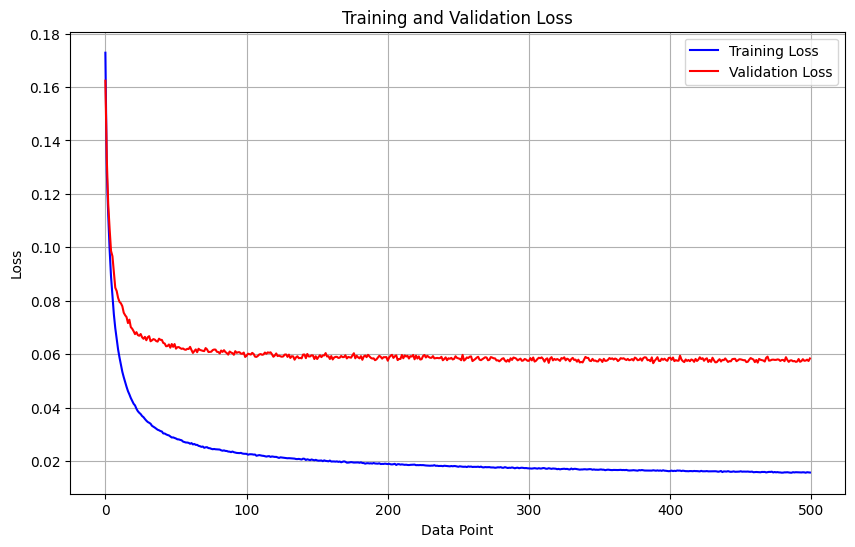

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(loss_train))
plt.figure(figsize=(10, 6))
plt.plot(x, loss_train, label='Training Loss', color='blue')
plt.plot(x, loss_valid, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Data Point')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### esm2 2560 + MolFormer
add the additional seqeunces

In [ ]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_2560')

In [ ]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enzy_refine_layer_1 = nn.Linear(2560, 2560) # W1 and b
        self.smiles_refine_layer_1 = nn.Linear(768, 768) # W1 and b
        self.enzy_refine_layer_2 = nn.Linear(2560, 128) # W1 and b
        self.smiles_refine_layer_2 = nn.Linear(768, 128) # W1 and b

        self.relu = nn.ReLU()
        self.batch_norm_enzy = nn.BatchNorm1d(2560)
        self.batch_norm_smiles = nn.BatchNorm1d(768)
        self.batch_norm_shared = nn.BatchNorm1d(128)

    def forward(self, enzy_embed, smiles_embed):
        refined_enzy_embed = self.enzy_refine_layer_1(enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_1(smiles_embed)

        refined_enzy_embed = self.batch_norm_enzy(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_smiles(refined_smiles_embed)

        refined_enzy_embed = self.relu(refined_enzy_embed)
        refined_smiles_embed = self.relu(refined_smiles_embed)

        refined_enzy_embed = self.enzy_refine_layer_2(refined_enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_2(refined_smiles_embed)

        refined_enzy_embed = self.batch_norm_shared(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_shared(refined_smiles_embed)
        refined_enzy_embed = torch.nn.functional.normalize(refined_enzy_embed, dim=1)
        refined_smiles_embed = torch.nn.functional.normalize(refined_smiles_embed, dim=1)

        return refined_enzy_embed, refined_smiles_embed


In [ ]:
def get_ds():
    # Load the saved embeddings_results
    ESP_train_df_enzy = torch.load('ESP_train_df_enzy_esm2_2560.pt')
    ESP_val_df_enzy = torch.load('ESP_val_df_enzy_esm2_2560.pt')
    ESP_test_df_enzy = torch.load('ESP_test_df_enzy_esm2_2560.pt')
    print(ESP_train_df_enzy.shape, ESP_val_df_enzy.shape, ESP_test_df_enzy.shape)
    # Load the saved embeddings_results
    ESP_train_df_smiles = torch.load('ESP_train_df_smiles_esm2_2560.pt')
    ESP_val_df_smiles = torch.load('ESP_val_df_smiles_esm2_2560.pt')
    ESP_test_df_smiles = torch.load('ESP_test_df_smiles_esm2_2560.pt')
    print(ESP_train_df_smiles.shape, ESP_val_df_smiles.shape, ESP_test_df_smiles.shape)

    y_train = torch.load( 'ESP_train_df_label_esm2_2560.pt')
    y_val = torch.load('ESP_val_df_label_esm2_2560.pt')
    y_test = torch.load('ESP_test_df_label_esm2_2560.pt')
    print(y_train.shape,y_val.shape, y_test.shape)
    ESP_train_df_enzy_add = torch.load('ESP_train_df_enzy_>2800_<5500.pt')
    ESP_train_df_smiles_add = torch.load('ESP_train_df_smiles_>2800_<5500.pt')
    y_train_add = torch.load('ESP_train_df_label_>2800_<5500.pt')

    ESP_val_df_enzy_add = torch.load('ESP_val_df_enzy_>2800_<8000.pt')
    ESP_val_df_smiles_add = torch.load('ESP_val_df_smiles_>2800_<8000.pt')
    y_val_add = torch.load('ESP_val_df_label_>2800_<8000.pt')
    print(ESP_val_df_enzy_add.shape, ESP_val_df_smiles_add.shape, y_val_add.shape)

    ESP_test_df_enzy_add = torch.load('ESP_test_df_enzy_>2800_<8000.pt')
    ESP_test_df_smiles_add = torch.load('ESP_test_df_smiles_>2800_<8000.pt')
    y_test_add = torch.load('ESP_test_df_label_>2800_<8000.pt')
    print(ESP_test_df_enzy_add.shape, ESP_test_df_smiles_add.shape, y_test_add.shape)

    ESP_train_df_enzy = torch.cat([ESP_train_df_enzy, ESP_train_df_enzy_add], dim=0)
    ESP_train_df_smiles = torch.cat([ESP_train_df_smiles, ESP_train_df_smiles_add], dim=0)
    y_train = torch.cat([y_train, y_train_add], dim=0)
    print(ESP_train_df_enzy.shape, ESP_train_df_smiles.shape, y_train.shape)

    ESP_val_df_enzy = torch.cat([ESP_val_df_enzy, ESP_val_df_enzy_add], dim=0)
    ESP_val_df_smiles = torch.cat([ESP_val_df_smiles, ESP_val_df_smiles_add], dim=0)
    y_val = torch.cat([y_val, y_val_add], dim=0)
    print(ESP_val_df_enzy.shape, ESP_val_df_smiles.shape, y_val.shape)
    ESP_test_df_enzy = torch.cat([ESP_test_df_enzy, ESP_test_df_enzy_add], dim=0)
    ESP_test_df_smiles = torch.cat([ESP_test_df_smiles, ESP_test_df_smiles_add], dim=0)
    y_test = torch.cat([y_test, y_test_add], dim=0)
    print(ESP_test_df_enzy.shape, ESP_test_df_smiles.shape, y_test.shape)

    train_tensor_dataset = TensorDataset(ESP_train_df_enzy,ESP_train_df_smiles, y_train)
    val_tensor_dataset = TensorDataset(ESP_val_df_enzy,ESP_val_df_smiles, y_val)
    test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)

    # Create TensorDataset and DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
    print(len(train_loader))
    return train_loader,  val_loader, test_loader

In [ ]:
# design the model, optimizer and loss function
model = Contrastive_learning_layer().to(device)
train_loader,  val_loader, test_loader = get_ds()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-03)
loss_fn = nn.MSELoss().to(device)

torch.Size([49881, 2560]) torch.Size([5399, 2560]) torch.Size([13312, 2560])
torch.Size([49881, 768]) torch.Size([5399, 768]) torch.Size([13312, 768])
torch.Size([49881, 1]) torch.Size([5399, 1]) torch.Size([13312, 1])
torch.Size([23, 2560]) torch.Size([23, 768]) torch.Size([23, 1])
torch.Size([24, 2560]) torch.Size([24, 768]) torch.Size([24, 1])
torch.Size([50061, 2560]) torch.Size([50061, 768]) torch.Size([50061, 1])
torch.Size([5422, 2560]) torch.Size([5422, 768]) torch.Size([5422, 1])
torch.Size([13336, 2560]) torch.Size([13336, 768]) torch.Size([13336, 1])
3129


In [15]:
initial_epoch = 0
best_epoch = -1
best_accuracy = 0.5
loss_train = []
loss_valid = []
for epoch in range(initial_epoch, 500):
    torch.cuda.empty_cache()
    model.train()

    with tqdm(train_loader, desc='Processing', unit="batch") as tepoch:
        num_batch = len(train_loader)
        loss_sum = 0
        for ESP_train_df_enzy,ESP_train_df_smiles, y_train in tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            ESP_train_df_enzy = ESP_train_df_enzy.to(device)
            ESP_train_df_smiles = ESP_train_df_smiles.to(device)
            y_train = y_train.squeeze(1).to(device)
            refined_enzy_embed, refined_smiles_embed = model(ESP_train_df_enzy,ESP_train_df_smiles)
            cosine_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
            loss = loss_fn(cosine_sim, y_train)
            loss_sum = loss_sum + loss.detach().cpu().numpy()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True) #
            tepoch.set_postfix(train_loss=loss)
            # tepoch.set_postfix(val_loss=loss_sum_val, val_accuracy=100. * acc_val, balanced_val_accuracy=100. * bacc_val)
        loss_sum = loss_sum/num_batch
        loss_train.append(loss_sum)
        loss_sum_val,acc_val, bacc_val = run_validation(model,val_loader,loss_fn, device)
        loss_valid.append(loss_sum_val)
        print('Epoch: %d / %d, ############## the best accuracy in val  %.4f at Epoch: %d  ##############'  % (epoch, 500,100 * best_accuracy,best_epoch))
        # print('Performance in Train: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum, 100 * acc))
        print('Performance in Val: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum_val, 100 * acc_val))
        # checkpoint(model, f"epoch-{epoch}.pth")
        if acc_val > best_accuracy: # compare the performance updates at the val set
            best_accuracy = acc_val
            best_epoch = epoch
            torch.save(model, "best_model_11.pt")

Epoch 0: 100%|██████████| 3129/3129 [00:28<00:00, 108.33batch/s, train_loss=tensor(0.1150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.1631851536290484 ACC=  0.7915898192548875 bacc=  0.6264630008714577 precision=  0.8065173116089613 specificity=  0.9761964419944876 sensitivity=  0.27672955974842767 recall=  0.27672955974842767 MCC=  0.38845964790221293 AUC=  0.7883426913910597 f1=  0.4120707596253902
Epoch: 0 / 500, ############## the best accuracy in val  50.0000 at Epoch: -1  ##############
Performance in Val: Loss: (0.1632); Accuracy (79.16)


Epoch 1: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.1410, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.13101356300445696 ACC=  0.8290298782736998 bacc=  0.7036678963727085 precision=  0.836 specificity=  0.9691806564770734 sensitivity=  0.4381551362683438 recall=  0.4381551362683438 MCC=  0.5200333611967366 AUC=  0.8704747281663267 f1=  0.5749656121045392
Epoch: 1 / 500, ############## the best accuracy in val  79.1590 at Epoch: 0  ##############
Performance in Val: Loss: (0.1310); Accuracy (82.90)


Epoch 2: 100%|██████████| 3129/3129 [00:29<00:00, 106.97batch/s, train_loss=tensor(0.0577, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.11291886332299242 ACC=  0.850793065289561 bacc=  0.7534145222978116 precision=  0.8294491525423728 specificity=  0.9596592332748685 sensitivity=  0.5471698113207547 recall=  0.5471698113207547 MCC=  0.5891069329854735 AUC=  0.9049443182870753 f1=  0.6593684210526315
Epoch: 2 / 500, ############## the best accuracy in val  82.9030 at Epoch: 1  ##############
Performance in Val: Loss: (0.1129); Accuracy (85.08)


Epoch 3: 100%|██████████| 3129/3129 [00:29<00:00, 107.42batch/s, train_loss=tensor(0.1287, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.10572149311700578 ACC=  0.868129841386942 bacc=  0.7925341627326754 precision=  0.8272394881170019 specificity=  0.9526434477574542 sensitivity=  0.6324248777078966 recall=  0.6324248777078966 MCC=  0.6425619141918255 AUC=  0.9185014640733404 f1=  0.7168316831683169
Epoch: 3 / 500, ############## the best accuracy in val  85.0793 at Epoch: 2  ##############
Performance in Val: Loss: (0.1057); Accuracy (86.81)


Epoch 4: 100%|██████████| 3129/3129 [00:29<00:00, 106.51batch/s, train_loss=tensor(0.0895, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09923708750962508 ACC=  0.8839911471781631 bacc=  0.8281861827126409 precision=  0.8260162601626017 specificity=  0.9463793535454773 sensitivity=  0.7099930118798043 recall=  0.7099930118798043 MCC=  0.6907927583614255 AUC=  0.9294204237661924 f1=  0.7636226982337467
Epoch: 4 / 500, ############## the best accuracy in val  86.8130 at Epoch: 3  ##############
Performance in Val: Loss: (0.0992); Accuracy (88.40)


Epoch 5: 100%|██████████| 3129/3129 [00:29<00:00, 107.34batch/s, train_loss=tensor(0.1139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09566071125950697 ACC=  0.8911840649206935 bacc=  0.8409165205920168 precision=  0.8334655035685964 specificity=  0.9473816086193937 sensitivity=  0.7344514325646401 recall=  0.7344514325646401 MCC=  0.7113483403915277 AUC=  0.9304850133625253 f1=  0.7808320950965824
Epoch: 5 / 500, ############## the best accuracy in val  88.3991 at Epoch: 4  ##############
Performance in Val: Loss: (0.0957); Accuracy (89.12)


Epoch 6: 100%|██████████| 3129/3129 [00:29<00:00, 107.29batch/s, train_loss=tensor(0.0941, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09147295715413702 ACC=  0.9028033935817041 bacc=  0.8602396097018432 precision=  0.8476923076923077 specificity=  0.9503883738411426 sensitivity=  0.7700908455625437 recall=  0.7700908455625437 MCC=  0.7438005068812978 AUC=  0.9375599816568411 f1=  0.8070303917978763
Epoch: 6 / 500, ############## the best accuracy in val  89.1184 at Epoch: 5  ##############
Performance in Val: Loss: (0.0915); Accuracy (90.28)


Epoch 7: 100%|██████████| 3129/3129 [00:28<00:00, 107.98batch/s, train_loss=tensor(0.1717, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08468339971340863 ACC=  0.9085208410180745 bacc=  0.8757778026415479 precision=  0.8404952658412236 specificity=  0.9451265347030819 sensitivity=  0.806429070580014 recall=  0.806429070580014 MCC=  0.7617503141344231 AUC=  0.9440259626787806 f1=  0.8231098430813125
Epoch: 7 / 500, ############## the best accuracy in val  90.2803 at Epoch: 6  ##############
Performance in Val: Loss: (0.0847); Accuracy (90.85)


Epoch 8: 100%|██████████| 3129/3129 [00:29<00:00, 107.87batch/s, train_loss=tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08240123778295903 ACC=  0.9122095167834747 bacc=  0.8776110679497072 precision=  0.8544914625092799 specificity=  0.9508895013781007 sensitivity=  0.8043326345213138 recall=  0.8043326345213138 MCC=  0.7703494684135065 AUC=  0.9499535205084956 f1=  0.8286537077033838
Epoch: 8 / 500, ############## the best accuracy in val  90.8521 at Epoch: 7  ##############
Performance in Val: Loss: (0.0824); Accuracy (91.22)


Epoch 9: 100%|██████████| 3129/3129 [00:29<00:00, 107.25batch/s, train_loss=tensor(0.0487, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08077458616010955 ACC=  0.9111029140538547 bacc=  0.8761870042676385 precision=  0.852264291017075 specificity=  0.9501378100726635 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7674442921790674 AUC=  0.9482023756807114 f1=  0.826493880489561
Epoch: 9 / 500, ############## the best accuracy in val  91.2210 at Epoch: 8  ##############
Performance in Val: Loss: (0.0808); Accuracy (91.11)


Epoch 10: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0986, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07756039980733026 ACC=  0.9151604573957949 bacc=  0.8883564189937492 precision=  0.8445706174591909 specificity=  0.9451265347030819 sensitivity=  0.8315863032844165 recall=  0.8315863032844165 MCC=  0.7806045670311588 AUC=  0.9535757515906247 f1=  0.8380281690140845
Epoch: 10 / 500, ############## the best accuracy in val  91.2210 at Epoch: 8  ##############
Performance in Val: Loss: (0.0776); Accuracy (91.52)


Epoch 11: 100%|██████████| 3129/3129 [00:29<00:00, 107.38batch/s, train_loss=tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07784926316599226 ACC=  0.9147915898192549 bacc=  0.8825027520866744 precision=  0.8559882439382807 specificity=  0.9508895013781007 sensitivity=  0.8141160027952481 recall=  0.8141160027952481 MCC=  0.7776419548181535 AUC=  0.9511643160773515 f1=  0.8345272206303725
Epoch: 11 / 500, ############## the best accuracy in val  91.5160 at Epoch: 10  ##############
Performance in Val: Loss: (0.0778); Accuracy (91.48)


Epoch 12: 100%|██████████| 3129/3129 [00:29<00:00, 106.92batch/s, train_loss=tensor(0.0961, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07339705698258053 ACC=  0.9214312061969753 bacc=  0.8937366236856127 precision=  0.8628158844765343 specificity=  0.9523928839889751 sensitivity=  0.8350803633822502 recall=  0.8350803633822502 MCC=  0.7958701712491054 AUC=  0.9568961154911619 f1=  0.8487215909090909
Epoch: 12 / 500, ############## the best accuracy in val  91.5160 at Epoch: 10  ##############
Performance in Val: Loss: (0.0734); Accuracy (92.14)


Epoch 13: 100%|██████████| 3129/3129 [00:29<00:00, 107.88batch/s, train_loss=tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07447901174733772 ACC=  0.9227222427148654 bacc=  0.8975272105073593 precision=  0.8603988603988604 specificity=  0.9508895013781007 sensitivity=  0.8441649196366178 recall=  0.8441649196366178 MCC=  0.7999613737904142 AUC=  0.9556271877272431 f1=  0.8522045855379189
Epoch: 13 / 500, ############## the best accuracy in val  92.1431 at Epoch: 12  ##############
Performance in Val: Loss: (0.0745); Accuracy (92.27)


Epoch 14: 100%|██████████| 3129/3129 [00:28<00:00, 108.10batch/s, train_loss=tensor(0.0737, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07061331202262315 ACC=  0.9247510143858355 bacc=  0.8980088147318188 precision=  0.8693140794223827 specificity=  0.9546479579052869 sensitivity=  0.8413696715583509 recall=  0.8413696715583509 MCC=  0.8045056631363622 AUC=  0.9581921832859083 f1=  0.8551136363636364
Epoch: 14 / 500, ############## the best accuracy in val  92.2722 at Epoch: 13  ##############
Performance in Val: Loss: (0.0706); Accuracy (92.48)


Epoch 15: 100%|██████████| 3129/3129 [00:28<00:00, 108.68batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07146354754122969 ACC=  0.9240132792327554 bacc=  0.8977318113204045 precision=  0.8662832494608196 specificity=  0.9533951390628915 sensitivity=  0.8420684835779175 recall=  0.8420684835779175 MCC=  0.8028067962671664 AUC=  0.9586838555863201 f1=  0.8540042523033309
Epoch: 15 / 500, ############## the best accuracy in val  92.4751 at Epoch: 14  ##############
Performance in Val: Loss: (0.0715); Accuracy (92.40)


Epoch 16: 100%|██████████| 3129/3129 [00:31<00:00, 98.05batch/s, train_loss=tensor(0.0397, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07196226070159745 ACC=  0.9245665805975655 bacc=  0.9001247741030176 precision=  0.8634423897581792 specificity=  0.9518917564520171 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8048160079288276 AUC=  0.958006055203523 f1=  0.8558336270708494
Epoch: 16 / 500, ############## the best accuracy in val  92.4751 at Epoch: 14  ##############
Performance in Val: Loss: (0.0720); Accuracy (92.46)


Epoch 17: 100%|██████████| 3129/3129 [00:27<00:00, 113.72batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06969884116543254 ACC=  0.9284396901512357 bacc=  0.9009627006676972 precision=  0.8809349890430972 specificity=  0.9591581057379103 sensitivity=  0.8427672955974843 recall=  0.8427672955974843 MCC=  0.8135881698203798 AUC=  0.9591795551171128 f1=  0.8614285714285714
Epoch: 17 / 500, ############## the best accuracy in val  92.4751 at Epoch: 14  ##############
Performance in Val: Loss: (0.0697); Accuracy (92.84)


Epoch 18: 100%|██████████| 3129/3129 [00:27<00:00, 113.17batch/s, train_loss=tensor(0.0920, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06995014672423094 ACC=  0.9300995942456658 bacc=  0.9000731204959587 precision=  0.8919523099850969 specificity=  0.9636682535705337 sensitivity=  0.8364779874213837 recall=  0.8364779874213837 MCC=  0.8171912552679753 AUC=  0.9591534656681237 f1=  0.8633249188604399
Epoch: 18 / 500, ############## the best accuracy in val  92.8440 at Epoch: 17  ##############
Performance in Val: Loss: (0.0700); Accuracy (93.01)


Epoch 19: 100%|██████████| 3129/3129 [00:27<00:00, 112.98batch/s, train_loss=tensor(0.0810, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0675307473821626 ACC=  0.9275175212098856 bacc=  0.9025775325019378 precision=  0.8723098995695839 specificity=  0.9553996492107242 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8120150755401181 AUC=  0.9609208945144044 f1=  0.8608849557522124
Epoch: 19 / 500, ############## the best accuracy in val  93.0100 at Epoch: 18  ##############
Performance in Val: Loss: (0.0675); Accuracy (92.75)


Epoch 20: 100%|██████████| 3129/3129 [00:27<00:00, 112.60batch/s, train_loss=tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0653601562052108 ACC=  0.932866101069716 bacc=  0.9086760725258667 precision=  0.8846431146359048 specificity=  0.9599097970433476 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8256764302853306 AUC=  0.9632904818511112 f1=  0.8708303761533002
Epoch: 20 / 500, ############## the best accuracy in val  93.0100 at Epoch: 18  ##############
Performance in Val: Loss: (0.0654); Accuracy (93.29)


Epoch 21: 100%|██████████| 3129/3129 [00:27<00:00, 111.97batch/s, train_loss=tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06675590630510828 ACC=  0.9324972334931759 bacc=  0.9075290122552122 precision=  0.8855901520637219 specificity=  0.9604109245803056 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8245328136784518 AUC=  0.962631591941407 f1=  0.8698435277382646
Epoch: 21 / 500, ############## the best accuracy in val  93.2866 at Epoch: 20  ##############
Performance in Val: Loss: (0.0668); Accuracy (93.25)


Epoch 22: 100%|██████████| 3129/3129 [00:27<00:00, 112.05batch/s, train_loss=tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06614284246272592 ACC=  0.932681667281446 bacc=  0.906085425260645 precision=  0.890190336749634 specificity=  0.9624154347281383 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8245818214019669 AUC=  0.9600956624802731 f1=  0.8695030389703253
Epoch: 22 / 500, ############## the best accuracy in val  93.2866 at Epoch: 20  ##############
Performance in Val: Loss: (0.0661); Accuracy (93.27)


Epoch 23: 100%|██████████| 3129/3129 [00:27<00:00, 112.97batch/s, train_loss=tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06569783093550607 ACC=  0.932312799704906 bacc=  0.9071796062454289 precision=  0.8855072463768116 specificity=  0.9604109245803056 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8240223603537472 AUC=  0.9606687548731677 f1=  0.8694414799003913
Epoch: 23 / 500, ############## the best accuracy in val  93.2866 at Epoch: 20  ##############
Performance in Val: Loss: (0.0657); Accuracy (93.23)


Epoch 24: 100%|██████████| 3129/3129 [00:27<00:00, 113.32batch/s, train_loss=tensor(0.0484, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0661590368072104 ACC=  0.9319439321283659 bacc=  0.9082737872302128 precision=  0.8809182209469153 specificity=  0.9584064144324731 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8235046504419505 AUC=  0.9607568286506274 f1=  0.8693805309734512
Epoch: 24 / 500, ############## the best accuracy in val  93.2866 at Epoch: 20  ##############
Performance in Val: Loss: (0.0662); Accuracy (93.19)


Epoch 25: 100%|██████████| 3129/3129 [00:27<00:00, 113.67batch/s, train_loss=tensor(0.0425, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06427638929551549 ACC=  0.9348948727406861 bacc=  0.9105024215035892 precision=  0.8905797101449275 specificity=  0.9621648709596592 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8307468476071642 AUC=  0.9638033408852658 f1=  0.8744219139096407
Epoch: 25 / 500, ############## the best accuracy in val  93.2866 at Epoch: 20  ##############
Performance in Val: Loss: (0.0643); Accuracy (93.49)


Epoch 26: 100%|██████████| 3129/3129 [00:27<00:00, 112.36batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06651631519225891 ACC=  0.932312799704906 bacc=  0.9049383649899906 precision=  0.8911764705882353 specificity=  0.9629165622650965 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8234556006503229 AUC=  0.9581426308425263 f1=  0.8685059118595486
Epoch: 26 / 500, ############## the best accuracy in val  93.4895 at Epoch: 25  ##############
Performance in Val: Loss: (0.0665); Accuracy (93.23)


Epoch 27: 100%|██████████| 3129/3129 [00:27<00:00, 112.11batch/s, train_loss=tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06448098863845905 ACC=  0.9310217631870159 bacc=  0.9038372676747699 precision=  0.8871794871794871 specificity=  0.961413179654222 sensitivity=  0.8462613556953179 recall=  0.8462613556953179 MCC=  0.8202160092470957 AUC=  0.9599027056159378 f1=  0.8662374821173104
Epoch: 27 / 500, ############## the best accuracy in val  93.4895 at Epoch: 25  ##############
Performance in Val: Loss: (0.0645); Accuracy (93.10)


Epoch 28: 100%|██████████| 3129/3129 [00:27<00:00, 112.06batch/s, train_loss=tensor(0.0413, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06499866913086501 ACC=  0.9350793065289561 bacc=  0.9095070827601096 precision=  0.8940832724616509 specificity=  0.9636682535705337 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8309254637313489 AUC=  0.9601182499898006 f1=  0.8742857142857143
Epoch: 28 / 500, ############## the best accuracy in val  93.4895 at Epoch: 25  ##############
Performance in Val: Loss: (0.0650); Accuracy (93.51)


Epoch 29: 100%|██████████| 3129/3129 [00:27<00:00, 112.36batch/s, train_loss=tensor(0.0728, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06438853270525338 ACC=  0.9317594983400959 bacc=  0.9059072640905349 precision=  0.8858181818181818 specificity=  0.9606614883487847 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8224311453832216 AUC=  0.9603215375755478 f1=  0.8681397006414825
Epoch: 29 / 500, ############## the best accuracy in val  93.5079 at Epoch: 28  ##############
Performance in Val: Loss: (0.0644); Accuracy (93.18)


Epoch 30: 100%|██████████| 3129/3129 [00:27<00:00, 113.92batch/s, train_loss=tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06486451922665874 ACC=  0.9350793065289561 bacc=  0.9113000757644603 precision=  0.8895306859205776 specificity=  0.9616637434227011 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8313716378967168 AUC=  0.9606895038644778 f1=  0.875
Epoch: 30 / 500, ############## the best accuracy in val  93.5079 at Epoch: 28  ##############
Performance in Val: Loss: (0.0649); Accuracy (93.51)


Epoch 31: 100%|██████████| 3129/3129 [00:27<00:00, 113.71batch/s, train_loss=tensor(0.0378, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06457632908784403 ACC=  0.933419402434526 bacc=  0.9086036699274975 precision=  0.8876811594202898 specificity=  0.9611626158857429 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8269042834623545 AUC=  0.9598165579051818 f1=  0.871575951618641
Epoch: 31 / 500, ############## the best accuracy in val  93.5079 at Epoch: 28  ##############
Performance in Val: Loss: (0.0646); Accuracy (93.34)


Epoch 32: 100%|██████████| 3129/3129 [00:27<00:00, 112.41batch/s, train_loss=tensor(0.0334, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06497816672235464 ACC=  0.932312799704906 bacc=  0.9033694961111838 precision=  0.8952451708766717 specificity=  0.96467050864445 sensitivity=  0.8420684835779175 recall=  0.8420684835779175 MCC=  0.8231028613422099 AUC=  0.9582416481808037 f1=  0.8678429960388909
Epoch: 32 / 500, ############## the best accuracy in val  93.5079 at Epoch: 28  ##############
Performance in Val: Loss: (0.0650); Accuracy (93.23)


Epoch 33: 100%|██████████| 3129/3129 [00:27<00:00, 111.80batch/s, train_loss=tensor(0.0616, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06333078096887224 ACC=  0.9360014754703062 bacc=  0.9085646233025005 precision=  0.9014814814814814 specificity=  0.9666750187922827 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8328766120441708 AUC=  0.9617606595973015 f1=  0.8752247393024092
Epoch: 33 / 500, ############## the best accuracy in val  93.5079 at Epoch: 28  ##############
Performance in Val: Loss: (0.0633); Accuracy (93.60)


Epoch 34: 100%|██████████| 3129/3129 [00:28<00:00, 111.54batch/s, train_loss=tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0642096599094174 ACC=  0.9347104389524161 bacc=  0.9085841466149991 precision=  0.8945054945054945 specificity=  0.9639188173390127 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8298571850681181 AUC=  0.960714630280115 f1=  0.8733905579399143
Epoch: 34 / 500, ############## the best accuracy in val  93.6001 at Epoch: 33  ##############
Performance in Val: Loss: (0.0642); Accuracy (93.47)


Epoch 35: 100%|██████████| 3129/3129 [00:27<00:00, 111.84batch/s, train_loss=tensor(0.0562, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06336102082399558 ACC=  0.9371080781999263 bacc=  0.9113334317378322 precision=  0.9001468428781204 specificity=  0.9659233274868454 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8360516623461329 AUC=  0.9596071419253768 f1=  0.8779090583601862
Epoch: 35 / 500, ############## the best accuracy in val  93.6001 at Epoch: 33  ##############
Performance in Val: Loss: (0.0634); Accuracy (93.71)


Epoch 36: 100%|██████████| 3129/3129 [00:27<00:00, 111.88batch/s, train_loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06234577171103397 ACC=  0.9367392106233862 bacc=  0.9122034885970722 precision=  0.895924308588064 specificity=  0.9641693811074918 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8353889399665082 AUC=  0.9627837512110146 f1=  0.8777183600713012
Epoch: 36 / 500, ############## the best accuracy in val  93.7108 at Epoch: 35  ##############
Performance in Val: Loss: (0.0623); Accuracy (93.67)


Epoch 37: 100%|██████████| 3129/3129 [00:27<00:00, 112.22batch/s, train_loss=tensor(0.0525, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06285360412793042 ACC=  0.9354481741054961 bacc=  0.9108782671563078 precision=  0.8925199709513435 specificity=  0.9629165622650965 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8321040078210665 AUC=  0.9611949212772763 f1=  0.8753561253561253
Epoch: 37 / 500, ############## the best accuracy in val  93.7108 at Epoch: 35  ##############
Performance in Val: Loss: (0.0629); Accuracy (93.54)


Epoch 38: 100%|██████████| 3129/3129 [00:27<00:00, 112.51batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06351858127730346 ACC=  0.9380302471412763 bacc=  0.9112874687823984 precision=  0.9052553663952627 specificity=  0.967927837634678 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8382198249809333 AUC=  0.9592692047673302 f1=  0.8792235801581595
Epoch: 38 / 500, ############## the best accuracy in val  93.7108 at Epoch: 35  ##############
Performance in Val: Loss: (0.0635); Accuracy (93.80)


Epoch 39: 100%|██████████| 3129/3129 [00:27<00:00, 113.48batch/s, train_loss=tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06257333856482597 ACC=  0.9371080781999263 bacc=  0.9120058041144636 precision=  0.8983918128654971 specificity=  0.9651716361814082 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8361979331248817 AUC=  0.9607816924208049 f1=  0.8781707752768845
Epoch: 39 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0626); Accuracy (93.71)


Epoch 40: 100%|██████████| 3129/3129 [00:27<00:00, 113.07batch/s, train_loss=tensor(0.0498, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06283083230608684 ACC=  0.9371080781999263 bacc=  0.9113334317378322 precision=  0.9001468428781204 specificity=  0.9659233274868454 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8360516623461329 AUC=  0.9622782462497292 f1=  0.8779090583601862
Epoch: 40 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0628); Accuracy (93.71)


Epoch 41: 100%|██████████| 3129/3129 [00:27<00:00, 113.13batch/s, train_loss=tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06267302132219868 ACC=  0.934341571375876 bacc=  0.9087818310976077 precision=  0.8920495988329686 specificity=  0.9629165622650965 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.829053223317006 AUC=  0.9613378004073105 f1=  0.8729478943611705
Epoch: 41 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0627); Accuracy (93.43)


Epoch 42: 100%|██████████| 3129/3129 [00:27<00:00, 112.60batch/s, train_loss=tensor(0.0447, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06242167849401369 ACC=  0.9376613795647363 bacc=  0.9135022703949014 precision=  0.8974545454545455 specificity=  0.96467050864445 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8378198074907806 AUC=  0.9606181518479473 f1=  0.8795438346400569
Epoch: 42 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0624); Accuracy (93.77)


Epoch 43: 100%|██████████| 3129/3129 [00:27<00:00, 112.65batch/s, train_loss=tensor(0.0631, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.062473231969143 ACC=  0.933788270011066 bacc=  0.9068371165660822 precision=  0.8941176470588236 specificity=  0.9639188173390127 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8273167749789517 AUC=  0.9600839309830768 f1=  0.8713722680042996
Epoch: 43 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0625); Accuracy (93.38)


Epoch 44: 100%|██████████| 3129/3129 [00:28<00:00, 111.45batch/s, train_loss=tensor(0.0378, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06343720376403635 ACC=  0.9345260051641461 bacc=  0.9066658717264089 precision=  0.8985185185185185 specificity=  0.9656727637183663 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8290059250350369 AUC=  0.9597524724130342 f1=  0.8723480762315715
Epoch: 44 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0634); Accuracy (93.45)


Epoch 45: 100%|██████████| 3129/3129 [00:27<00:00, 112.72batch/s, train_loss=tensor(0.0906, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061996234292411696 ACC=  0.9363703430468462 bacc=  0.9119529248285931 precision=  0.8946220930232558 specificity=  0.9636682535705337 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8344803430388594 AUC=  0.962751445819481 f1=  0.8770929818311365
Epoch: 45 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0620); Accuracy (93.64)


Epoch 46: 100%|██████████| 3129/3129 [00:27<00:00, 113.11batch/s, train_loss=tensor(0.0445, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06270342007427748 ACC=  0.9363703430468462 bacc=  0.9099358076986988 precision=  0.8998527245949927 specificity=  0.9659233274868454 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8340263987423191 AUC=  0.9618536360900074 f1=  0.8762997490139836
Epoch: 46 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0627); Accuracy (93.64)


Epoch 47: 100%|██████████| 3129/3129 [00:27<00:00, 113.00batch/s, train_loss=tensor(0.0361, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06227492679674233 ACC=  0.9348948727406861 bacc=  0.9096059250014139 precision=  0.8928571428571429 specificity=  0.9631671260335756 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8305242912944031 AUC=  0.9621674098657689 f1=  0.8740635033892258
Epoch: 47 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0623); Accuracy (93.49)


Epoch 48: 100%|██████████| 3129/3129 [00:27<00:00, 113.42batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06431811047954193 ACC=  0.933419402434526 bacc=  0.9034488150399895 precision=  0.9010494752623688 specificity=  0.9669255825607617 sensitivity=  0.8399720475192173 recall=  0.8399720475192173 MCC=  0.825744638120822 AUC=  0.9566066801946587 f1=  0.8694394213381555
Epoch: 48 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0643); Accuracy (93.34)


Epoch 49: 100%|██████████| 3129/3129 [00:27<00:00, 113.31batch/s, train_loss=tensor(0.0713, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061001891440610266 ACC=  0.9372925119881962 bacc=  0.9145964513796854 precision=  0.8927285817134629 specificity=  0.9626659984966174 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8372420320948685 AUC=  0.9632931083057075 f1=  0.8794326241134753
Epoch: 49 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0610); Accuracy (93.73)


Epoch 50: 100%|██████████| 3129/3129 [00:27<00:00, 112.26batch/s, train_loss=tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06234777826612546 ACC=  0.933603836222796 bacc=  0.9085048276861933 precision=  0.8888888888888888 specificity=  0.9616637434227011 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8272973566709055 AUC=  0.9607678597599315 f1=  0.8717948717948718
Epoch: 50 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0623); Accuracy (93.36)


Epoch 51: 100%|██████████| 3129/3129 [00:27<00:00, 112.42batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061514037140647834 ACC=  0.9363703430468462 bacc=  0.9108323042008741 precision=  0.8975109809663251 specificity=  0.9649210724129291 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.834220655595527 AUC=  0.9605250002582679 f1=  0.8766535573829104
Epoch: 51 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0615); Accuracy (93.64)


Epoch 52: 100%|██████████| 3129/3129 [00:27<00:00, 111.96batch/s, train_loss=tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061996428356409776 ACC=  0.9347104389524161 bacc=  0.9094806431171744 precision=  0.8922068463219228 specificity=  0.9629165622650965 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8300703403282539 AUC=  0.9621791413629655 f1=  0.8737517831669045
Epoch: 52 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0620); Accuracy (93.47)


Epoch 53: 100%|██████████| 3129/3129 [00:27<00:00, 112.39batch/s, train_loss=tensor(0.0373, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06176147013105958 ACC=  0.9354481741054961 bacc=  0.9108782671563078 precision=  0.8925199709513435 specificity=  0.9629165622650965 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8321040078210665 AUC=  0.9589027268026715 f1=  0.8753561253561253
Epoch: 53 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.54)


Epoch 54: 100%|██████████| 3129/3129 [00:27<00:00, 112.78batch/s, train_loss=tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06217372280636192 ACC=  0.9354481741054961 bacc=  0.9088611500264134 precision=  0.8977189109639441 specificity=  0.9651716361814082 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8316361951177735 AUC=  0.9602539501439384 f1=  0.8745519713261648
Epoch: 54 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0622); Accuracy (93.54)


Epoch 55: 100%|██████████| 3129/3129 [00:28<00:00, 111.59batch/s, train_loss=tensor(0.0484, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06168311383097177 ACC=  0.9361859092585761 bacc=  0.9109311464421783 precision=  0.8962746530314097 specificity=  0.9644199448759709 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8338150127165104 AUC=  0.960326265193821 f1=  0.8764285714285714
Epoch: 55 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0617); Accuracy (93.62)


Epoch 56: 100%|██████████| 3129/3129 [00:27<00:00, 112.60batch/s, train_loss=tensor(0.0539, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061467691703773704 ACC=  0.9363703430468462 bacc=  0.9115046765775054 precision=  0.8957725947521866 specificity=  0.9641693811074918 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8343742339119865 AUC=  0.9614315648363955 f1=  0.8769175882982518
Epoch: 56 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0615); Accuracy (93.64)


Epoch 57: 100%|██████████| 3129/3129 [00:27<00:00, 112.98batch/s, train_loss=tensor(0.0506, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06180320438244833 ACC=  0.9348948727406861 bacc=  0.9118471662568521 precision=  0.8872126436781609 specificity=  0.9606614883487847 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8311025558252587 AUC=  0.9616547259285875 f1=  0.8749557208643287
Epoch: 57 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.49)


Epoch 58: 100%|██████████| 3129/3129 [00:27<00:00, 112.68batch/s, train_loss=tensor(0.0473, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06190118327555535 ACC=  0.9350793065289561 bacc=  0.9106277033878287 precision=  0.8912255257432923 specificity=  0.9624154347281383 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8311988215010155 AUC=  0.9605880351685772 f1=  0.8747330960854093
Epoch: 58 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0619); Accuracy (93.51)


Epoch 59: 100%|██████████| 3129/3129 [00:27<00:00, 112.25batch/s, train_loss=tensor(0.0432, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06225553140110147 ACC=  0.9363703430468462 bacc=  0.9110564283264179 precision=  0.8969298245614035 specificity=  0.96467050864445 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8342711008720473 AUC=  0.9595307996451135 f1=  0.8767416934619506
Epoch: 59 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0623); Accuracy (93.64)


Epoch 60: 100%|██████████| 3129/3129 [00:27<00:00, 112.24batch/s, train_loss=tensor(0.0404, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06246840333632004 ACC=  0.934341571375876 bacc=  0.9065405898421693 precision=  0.8978534418948927 specificity=  0.9654221999498872 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.82854550145665 AUC=  0.9587591472847451 f1=  0.8720345075485264
Epoch: 60 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0625); Accuracy (93.43)


Epoch 61: 100%|██████████| 3129/3129 [00:27<00:00, 112.52batch/s, train_loss=tensor(0.0048, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06040113700202125 ACC=  0.9372925119881962 bacc=  0.9119069618731594 precision=  0.8996336996336997 specificity=  0.9656727637183663 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8366060081428339 AUC=  0.9613206409039488 f1=  0.8783977110157369
Epoch: 61 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.73)


Epoch 62: 100%|██████████| 3129/3129 [00:27<00:00, 113.61batch/s, train_loss=tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060260347472531256 ACC=  0.9354481741054961 bacc=  0.9104300189052201 precision=  0.8936635105608157 specificity=  0.9634176898020547 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8319948481083618 AUC=  0.9633866100893329 f1=  0.8751783166904422
Epoch: 62 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.54)


Epoch 63: 100%|██████████| 3129/3129 [00:27<00:00, 112.79batch/s, train_loss=tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060942079365022675 ACC=  0.9352637403172261 bacc=  0.9076152475144548 precision=  0.9 specificity=  0.9661738912553245 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8309412685396038 AUC=  0.9624703276291993 f1=  0.8737864077669903
Epoch: 63 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.53)


Epoch 64: 100%|██████████| 3129/3129 [00:27<00:00, 113.45batch/s, train_loss=tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060398745839552716 ACC=  0.9345260051641461 bacc=  0.9093553612329348 precision=  0.8915574963609898 specificity=  0.9626659984966174 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8296168051703805 AUC=  0.961979705910626 f1=  0.8734402852049911
Epoch: 64 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.45)


Epoch 65: 100%|██████████| 3129/3129 [00:27<00:00, 112.50batch/s, train_loss=tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06130693318009113 ACC=  0.9356326078937661 bacc=  0.9101070525383721 precision=  0.89546783625731 specificity=  0.9641693811074918 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8323442686192128 AUC=  0.9593390684595897 f1=  0.8753126116470168
Epoch: 65 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.56)


Epoch 66: 100%|██████████| 3129/3129 [00:28<00:00, 111.69batch/s, train_loss=tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060308775180472736 ACC=  0.9391368498708963 bacc=  0.9151768978454493 precision=  0.9009468317552805 specificity=  0.9659233274868454 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8416173870089013 AUC=  0.9617009515294808 f1=  0.8823109843081313
Epoch: 66 / 500, ############## the best accuracy in val  93.8030 at Epoch: 38  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.91)


Epoch 67: 100%|██████████| 3129/3129 [00:27<00:00, 111.89batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05949704041896844 ACC=  0.9369236444116562 bacc=  0.9109840257280488 precision=  0.9000734753857458 specificity=  0.9659233274868454 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8355454161380093 AUC=  0.9644695848678395 f1=  0.8775071633237822
Epoch: 67 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.69)


Epoch 68: 100%|██████████| 3129/3129 [00:27<00:00, 113.31batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0609382060864682 ACC=  0.9358170416820362 bacc=  0.909784086171524 precision=  0.8972853998532648 specificity=  0.9649210724129291 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8326995147400712 AUC=  0.9600110906422749 f1=  0.8754473872584109
Epoch: 68 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.58)


Epoch 69: 100%|██████████| 3129/3129 [00:27<00:00, 112.44batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06003902715034673 ACC=  0.9348948727406861 bacc=  0.9111747938802207 precision=  0.8888888888888888 specificity=  0.961413179654222 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8309214415785295 AUC=  0.963004898688016 f1=  0.8746893858714945
Epoch: 69 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.49)


Epoch 70: 100%|██████████| 3129/3129 [00:27<00:00, 112.70batch/s, train_loss=tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06094774864284338 ACC=  0.9372925119881962 bacc=  0.9121310859987032 precision=  0.8990490124359912 specificity=  0.9654221999498872 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8366549085807197 AUC=  0.959864359378833 f1=  0.8784846318799142
Epoch: 70 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.73)


Epoch 71: 100%|██████████| 3129/3129 [00:27<00:00, 113.44batch/s, train_loss=tensor(0.0264, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05994466114734302 ACC=  0.9350793065289561 bacc=  0.9099553310111973 precision=  0.8929351784413693 specificity=  0.9631671260335756 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8310325942183079 AUC=  0.9614770900493964 f1=  0.8744650499286734
Epoch: 71 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.51)


Epoch 72: 100%|██████████| 3129/3129 [00:27<00:00, 112.74batch/s, train_loss=tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060871214711637534 ACC=  0.9363703430468462 bacc=  0.9115046765775054 precision=  0.8957725947521866 specificity=  0.9641693811074918 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8343742339119865 AUC=  0.9602555260166963 f1=  0.8769175882982518
Epoch: 72 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.64)


Epoch 73: 100%|██████████| 3129/3129 [00:27<00:00, 113.03batch/s, train_loss=tensor(0.0455, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061291108537014784 ACC=  0.9361859092585761 bacc=  0.9111552705677222 precision=  0.8956965718453683 specificity=  0.9641693811074918 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8338668121151256 AUC=  0.9599259935133575 f1=  0.8765167737330477
Epoch: 73 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.62)


Epoch 74: 100%|██████████| 3129/3129 [00:27<00:00, 111.87batch/s, train_loss=tensor(0.0414, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06091140240711053 ACC=  0.9361859092585761 bacc=  0.9102587740655469 precision=  0.8980190755685987 specificity=  0.9651716361814082 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8336641016831582 AUC=  0.9605894359443619 f1=  0.8761632068718683
Epoch: 74 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.62)


Epoch 75: 100%|██████████| 3129/3129 [00:28<00:00, 111.65batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059088222679728776 ACC=  0.9376613795647363 bacc=  0.9130540221438138 precision=  0.8986141502552881 specificity=  0.9651716361814082 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8377176831536213 AUC=  0.963043945313013 f1=  0.8793718772305495
Epoch: 75 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.77)


Epoch 76: 100%|██████████| 3129/3129 [00:27<00:00, 111.77batch/s, train_loss=tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0600430408759169 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.9598074528625816 f1=  0.8806613946800862
Epoch: 76 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.88)


Epoch 77: 100%|██████████| 3129/3129 [00:27<00:00, 112.37batch/s, train_loss=tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06181014769306752 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9587001396048167 f1=  0.879136690647482
Epoch: 77 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.80)


Epoch 78: 100%|██████████| 3129/3129 [00:27<00:00, 112.29batch/s, train_loss=tensor(0.0328, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0615688138298009 ACC=  0.9347104389524161 bacc=  0.9110495119959812 precision=  0.8882480173035328 specificity=  0.9611626158857429 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8304716535952503 AUC=  0.9614136173966548 f1=  0.8743789921930446
Epoch: 78 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0616); Accuracy (93.47)


Epoch 79: 100%|██████████| 3129/3129 [00:27<00:00, 112.87batch/s, train_loss=tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059669625904180304 ACC=  0.9365547768351162 bacc=  0.9105093378340259 precision=  0.899338721528288 specificity=  0.9656727637183663 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8345803584493451 AUC=  0.9609639683697824 f1=  0.8767908309455588
Epoch: 79 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.66)


Epoch 80: 100%|██████████| 3129/3129 [00:27<00:00, 112.81batch/s, train_loss=tensor(0.0278, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05918269084250021 ACC=  0.9360014754703062 bacc=  0.9108058645579388 precision=  0.8956204379562044 specificity=  0.9641693811074918 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8333593441357914 AUC=  0.9640082043437707 f1=  0.8761156729739379
Epoch: 80 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.60)


Epoch 81: 100%|██████████| 3129/3129 [00:28<00:00, 111.40batch/s, train_loss=tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05947903388284235 ACC=  0.9361859092585761 bacc=  0.911379394693266 precision=  0.8951201747997086 specificity=  0.9639188173390127 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8339193558884698 AUC=  0.9617438502878857 f1=  0.8766048502139799
Epoch: 81 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.62)


Epoch 82: 100%|██████████| 3129/3129 [00:27<00:00, 111.99batch/s, train_loss=tensor(0.0519, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05943626847260997 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9616422940434988 f1=  0.8816589202717198
Epoch: 82 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.90)


Epoch 83: 100%|██████████| 3129/3129 [00:28<00:00, 111.39batch/s, train_loss=tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060106932398503246 ACC=  0.9395057174474364 bacc=  0.9149792133628407 precision=  0.9034381858083395 specificity=  0.9669255825607617 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.842436806186658 AUC=  0.9602047478945026 f1=  0.8827734095782702
Epoch: 83 / 500, ############## the best accuracy in val  93.9137 at Epoch: 66  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.95)


Epoch 84: 100%|██████████| 3129/3129 [00:27<00:00, 112.56batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0605134003875354 ACC=  0.9367392106233862 bacc=  0.9119793644715284 precision=  0.8965014577259475 specificity=  0.9644199448759709 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8353367195663824 AUC=  0.9599806237689588 f1=  0.8776311095255083
Epoch: 84 / 500, ############## the best accuracy in val  93.9506 at Epoch: 83  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.67)


Epoch 85: 100%|██████████| 3129/3129 [00:27<00:00, 113.21batch/s, train_loss=tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06076590796921589 ACC=  0.9365547768351162 bacc=  0.9114058343362013 precision=  0.8970051132213295 specificity=  0.96467050864445 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8347781957115642 AUC=  0.9597550988676303 f1=  0.8771428571428572
Epoch: 85 / 500, ############## the best accuracy in val  93.9506 at Epoch: 83  ##############
Performance in Val: Loss: (0.0608); Accuracy (93.66)


Epoch 86: 100%|██████████| 3129/3129 [00:27<00:00, 112.85batch/s, train_loss=tensor(0.0387, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05941250213561992 ACC=  0.9378458133530063 bacc=  0.9120586834003341 precision=  0.9022058823529412 specificity=  0.9666750187922827 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.837935004382681 AUC=  0.9602392419981997 f1=  0.8792547474023648
Epoch: 86 / 500, ############## the best accuracy in val  93.9506 at Epoch: 83  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.78)


Epoch 87: 100%|██████████| 3129/3129 [00:27<00:00, 112.70batch/s, train_loss=tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06078380445886546 ACC=  0.9360014754703062 bacc=  0.9094611198046758 precision=  0.8991163475699558 specificity=  0.9656727637183663 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8330606323287896 AUC=  0.9586673964708505 f1=  0.8755826461097168
Epoch: 87 / 500, ############## the best accuracy in val  93.9506 at Epoch: 83  ##############
Performance in Val: Loss: (0.0608); Accuracy (93.60)


Epoch 88: 100%|██████████| 3129/3129 [00:28<00:00, 111.70batch/s, train_loss=tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05917709271264177 ACC=  0.9374769457764662 bacc=  0.9124804920084866 precision=  0.8991228070175439 specificity=  0.9654221999498872 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8371613492512988 AUC=  0.9624656000109261 f1=  0.8788853161843516
Epoch: 88 / 500, ############## the best accuracy in val  93.9506 at Epoch: 83  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.75)


Epoch 89: 100%|██████████| 3129/3129 [00:27<00:00, 112.19batch/s, train_loss=tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06032509155500032 ACC=  0.9367392106233862 bacc=  0.9119793644715284 precision=  0.8965014577259475 specificity=  0.9644199448759709 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8353367195663824 AUC=  0.9595008580627166 f1=  0.8776311095255083
Epoch: 89 / 500, ############## the best accuracy in val  93.9506 at Epoch: 83  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.67)


Epoch 90: 100%|██████████| 3129/3129 [00:28<00:00, 111.35batch/s, train_loss=tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059549328641674774 ACC=  0.9402434526005164 bacc=  0.9157044650253426 precision=  0.9054945054945055 specificity=  0.967677273866199 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8443189487996519 AUC=  0.9610178982374914 f1=  0.8841201716738197
Epoch: 90 / 500, ############## the best accuracy in val  93.9506 at Epoch: 83  ##############
Performance in Val: Loss: (0.0595); Accuracy (94.02)


Epoch 91: 100%|██████████| 3129/3129 [00:27<00:00, 111.80batch/s, train_loss=tensor(0.0458, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05951874898774082 ACC=  0.9385835485060863 bacc=  0.9132321833139239 precision=  0.9030837004405287 specificity=  0.9669255825607617 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.839910950916155 AUC=  0.9599573358715391 f1=  0.8807733619763695
Epoch: 91 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.86)


Epoch 92: 100%|██████████| 3129/3129 [00:28<00:00, 111.44batch/s, train_loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06094321211975804 ACC=  0.9371080781999263 bacc=  0.9117816799889198 precision=  0.8989751098096632 specificity=  0.9654221999498872 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.836148422434239 AUC=  0.9588020460431499 f1=  0.8780836610654272
Epoch: 92 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.71)


Epoch 93: 100%|██████████| 3129/3129 [00:27<00:00, 112.12batch/s, train_loss=tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05970231548589064 ACC=  0.9361859092585761 bacc=  0.9122758911954414 precision=  0.8928312816799421 specificity=  0.9629165622650965 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8341369334615286 AUC=  0.9613329852405509 f1=  0.8769559032716927
Epoch: 93 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.62)


Epoch 94: 100%|██████████| 3129/3129 [00:27<00:00, 112.63batch/s, train_loss=tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059422209663838585 ACC=  0.9367392106233862 bacc=  0.9122034885970722 precision=  0.895924308588064 specificity=  0.9641693811074918 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8353889399665082 AUC=  0.9618879550967315 f1=  0.8777183600713012
Epoch: 94 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.67)


Epoch 95: 100%|██████████| 3129/3129 [00:27<00:00, 112.72batch/s, train_loss=tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06113925188021586 ACC=  0.9348948727406861 bacc=  0.908261180248151 precision=  0.8963235294117647 specificity=  0.96467050864445 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8302126557254234 AUC=  0.958854224941128 f1=  0.8735220351128627
Epoch: 95 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0611); Accuracy (93.49)


Epoch 96: 100%|██████████| 3129/3129 [00:27<00:00, 112.75batch/s, train_loss=tensor(0.0473, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06033317737039563 ACC=  0.9365547768351162 bacc=  0.9116299584617451 precision=  0.8964259664478483 specificity=  0.9644199448759709 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8348295298747496 AUC=  0.9606248055329243 f1=  0.8772305496074233
Epoch: 96 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.66)


Epoch 97: 100%|██████████| 3129/3129 [00:28<00:00, 111.39batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05860719348545733 ACC=  0.9380302471412763 bacc=  0.9117357170334861 precision=  0.9040590405904059 specificity=  0.9674267100977199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.838305827564174 AUC=  0.9639577764155234 f1=  0.8793969849246229
Epoch: 97 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.80)


Epoch 98: 100%|██████████| 3129/3129 [00:28<00:00, 111.53batch/s, train_loss=tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05994234992133503 ACC=  0.9369236444116562 bacc=  0.9123287704813119 precision=  0.8965768390386016 specificity=  0.9644199448759709 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8358438636685777 AUC=  0.9611089486634936 f1=  0.8780313837375179
Epoch: 98 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.69)


Epoch 99: 100%|██████████| 3129/3129 [00:28<00:00, 109.84batch/s, train_loss=tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0601857151749618 ACC=  0.9380302471412763 bacc=  0.9115115929079423 precision=  0.9046563192904656 specificity=  0.967677273866199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8382624409512204 AUC=  0.9610564195715693 f1=  0.8793103448275863
Epoch: 99 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.80)


Epoch 100: 100%|██████████| 3129/3129 [00:27<00:00, 112.34batch/s, train_loss=tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05995176942980571 ACC=  0.9369236444116562 bacc=  0.9112081498535927 precision=  0.8994864269992663 specificity=  0.9656727637183663 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.835593275569332 AUC=  0.9595323755178711 f1=  0.8775948460987831
Epoch: 100 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.69)


Epoch 101: 100%|██████████| 3129/3129 [00:27<00:00, 112.24batch/s, train_loss=tensor(0.0278, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059718296835666033 ACC=  0.9363703430468462 bacc=  0.9110564283264179 precision=  0.8969298245614035 specificity=  0.96467050864445 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8342711008720473 AUC=  0.9612098045199882 f1=  0.8767416934619506
Epoch: 101 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.64)


Epoch 102: 100%|██████████| 3129/3129 [00:27<00:00, 112.44batch/s, train_loss=tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0605044976374063 ACC=  0.9383991147178163 bacc=  0.9140033979318596 precision=  0.900072939460248 specificity=  0.9656727637183663 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8396431186728691 AUC=  0.9592648273430033 f1=  0.8807994289793005
Epoch: 102 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.84)


Epoch 103: 100%|██████████| 3129/3129 [00:27<00:00, 112.40batch/s, train_loss=tensor(0.0264, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05937743044642396 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9606230545631934 f1=  0.8818897637795275
Epoch: 103 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.91)


Epoch 104: 100%|██████████| 3129/3129 [00:28<00:00, 111.61batch/s, train_loss=tensor(0.0518, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05958680941374384 ACC=  0.9372925119881962 bacc=  0.9119069618731594 precision=  0.8996336996336997 specificity=  0.9656727637183663 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8366060081428339 AUC=  0.9598447485178478 f1=  0.8783977110157369
Epoch: 104 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.73)


Epoch 105: 100%|██████████| 3129/3129 [00:28<00:00, 111.07batch/s, train_loss=tensor(0.0366, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059502932588517625 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.9611556995553062 f1=  0.8794835007173601
Epoch: 105 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.80)


Epoch 106: 100%|██████████| 3129/3129 [00:28<00:00, 111.38batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05929247860571474 ACC=  0.9387679822943563 bacc=  0.9144780858258825 precision=  0.9008023340627279 specificity=  0.9659233274868454 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8406058364324931 AUC=  0.9616428193344179 f1=  0.881513204853676
Epoch: 106 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.88)


Epoch 107: 100%|██████████| 3129/3129 [00:27<00:00, 112.13batch/s, train_loss=tensor(0.0625, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05885779710244772 ACC=  0.9365547768351162 bacc=  0.9116299584617451 precision=  0.8964259664478483 specificity=  0.9644199448759709 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8348295298747496 AUC=  0.9628268250663925 f1=  0.8772305496074233
Epoch: 107 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.66)


Epoch 108: 100%|██████████| 3129/3129 [00:27<00:00, 111.80batch/s, train_loss=tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05885892570881409 ACC=  0.9383991147178163 bacc=  0.9133310255552282 precision=  0.9018315018315018 specificity=  0.9664244550238036 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8394983608891406 AUC=  0.9620999975311328 f1=  0.8805436337625179
Epoch: 108 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.84)


Epoch 109: 100%|██████████| 3129/3129 [00:27<00:00, 112.10batch/s, train_loss=tensor(0.0429, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05917070134182991 ACC=  0.9372925119881962 bacc=  0.9119069618731594 precision=  0.8996336996336997 specificity=  0.9656727637183663 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8366060081428339 AUC=  0.9612493764359047 f1=  0.8783977110157369
Epoch: 109 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.73)


Epoch 110: 100%|██████████| 3129/3129 [00:28<00:00, 111.00batch/s, train_loss=tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05927228878298912 ACC=  0.9398745850239764 bacc=  0.9183675148889334 precision=  0.8966259870782484 specificity=  0.9639188173390127 sensitivity=  0.872816212438854 recall=  0.872816212438854 MCC=  0.8440621774396018 AUC=  0.9627552104044023 f1=  0.8845609065155808
Epoch: 110 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.99)


Epoch 111: 100%|██████████| 3129/3129 [00:28<00:00, 111.56batch/s, train_loss=tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05813871827223791 ACC=  0.9395057174474364 bacc=  0.9147550892372969 precision=  0.904029304029304 specificity=  0.9671761463292408 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8423907136354474 AUC=  0.9631803458550432 f1=  0.882689556509299
Epoch: 111 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.95)


Epoch 112: 100%|██████████| 3129/3129 [00:27<00:00, 112.02batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05895290858658981 ACC=  0.9396901512357064 bacc=  0.914207998744905 precision=  0.906480117820324 specificity=  0.9681784014031571 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8427182964640848 AUC=  0.9606241051450319 f1=  0.8827536751523845
Epoch: 112 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.97)


Epoch 113: 100%|██████████| 3129/3129 [00:28<00:00, 111.09batch/s, train_loss=tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05946690068445594 ACC=  0.9374769457764662 bacc=  0.9115839955063113 precision=  0.9014705882352941 specificity=  0.9664244550238036 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8369697108005237 AUC=  0.9592973953799964 f1=  0.878538158366177
Epoch: 113 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.75)


Epoch 114: 100%|██████████| 3129/3129 [00:28<00:00, 110.89batch/s, train_loss=tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06000223089762274 ACC=  0.9374769457764662 bacc=  0.9136011126362058 precision=  0.8962264150943396 specificity=  0.9641693811074918 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8374178089552133 AUC=  0.9621920985389735 f1=  0.879316482734069
Epoch: 114 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.75)


Epoch 115: 100%|██████████| 3129/3129 [00:28<00:00, 110.87batch/s, train_loss=tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05968970130266386 ACC=  0.9393212836591663 bacc=  0.9144056832275135 precision=  0.9039589442815249 specificity=  0.9671761463292408 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8418857773374072 AUC=  0.961300154558098 f1=  0.8822898032200358
Epoch: 115 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.93)


Epoch 116: 100%|██████████| 3129/3129 [00:27<00:00, 111.92batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058772203476088546 ACC=  0.9396901512357064 bacc=  0.9160009917492555 precision=  0.9017467248908297 specificity=  0.9661738912553245 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8430851196946785 AUC=  0.9618214182469604 f1=  0.8834224598930482
Epoch: 116 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.97)


Epoch 117: 100%|██████████| 3129/3129 [00:28<00:00, 111.47batch/s, train_loss=tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05895143296709696 ACC=  0.9378458133530063 bacc=  0.9134034281535972 precision=  0.8986880466472303 specificity=  0.9651716361814082 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.83822417652957 AUC=  0.9623369037357115 f1=  0.8797716732072779
Epoch: 117 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.78)


Epoch 118: 100%|██████████| 3129/3129 [00:27<00:00, 112.13batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05913110260486295 ACC=  0.9389524160826264 bacc=  0.9139309953334905 precision=  0.9032258064516129 specificity=  0.9669255825607617 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8409214252475911 AUC=  0.9618756983086159 f1=  0.8815742397137746
Epoch: 118 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.90)


Epoch 119: 100%|██████████| 3129/3129 [00:27<00:00, 111.81batch/s, train_loss=tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057879464202189604 ACC=  0.9372925119881962 bacc=  0.9128034583753347 precision=  0.8973051711580481 specificity=  0.96467050864445 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8368061175586315 AUC=  0.9637712981391919 f1=  0.8787446504992867
Epoch: 119 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.73)


Epoch 120: 100%|██████████| 3129/3129 [00:28<00:00, 110.95batch/s, train_loss=tensor(0.0366, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05961464268257045 ACC=  0.9396901512357064 bacc=  0.9130873781171858 precision=  0.9094955489614244 specificity=  0.9694312202455525 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8425140331178057 AUC=  0.9617385973786933 f1=  0.8823317740194315
Epoch: 120 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.97)


Epoch 121: 100%|██████████| 3129/3129 [00:28<00:00, 110.21batch/s, train_loss=tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059248922387231416 ACC=  0.9380302471412763 bacc=  0.9139769582889243 precision=  0.8981818181818182 specificity=  0.9649210724129291 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.838781598872503 AUC=  0.9617153094812735 f1=  0.880256593014968
Epoch: 121 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.80)


Epoch 122: 100%|██████████| 3129/3129 [00:28<00:00, 109.89batch/s, train_loss=tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059020900656537846 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.9609635306273496 f1=  0.8806613946800862
Epoch: 122 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.88)


Epoch 123: 100%|██████████| 3129/3129 [00:28<00:00, 111.71batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058665722118179615 ACC=  0.9395057174474364 bacc=  0.9154274616139284 precision=  0.9022611232676878 specificity=  0.9664244550238036 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8425312719517409 AUC=  0.9621477990047838 f1=  0.8829407566024268
Epoch: 123 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.95)


Epoch 124: 100%|██████████| 3129/3129 [00:27<00:00, 111.82batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05968451587164604 ACC=  0.9372925119881962 bacc=  0.9134758307519661 precision=  0.8955765047135605 specificity=  0.9639188173390127 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8369640440834771 AUC=  0.9592096717964829 f1=  0.8790035587188613
Epoch: 124 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.73)


Epoch 125: 100%|██████████| 3129/3129 [00:27<00:00, 111.85batch/s, train_loss=tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05871644280136599 ACC=  0.9382146809295463 bacc=  0.9145504884242516 precision=  0.897677793904209 specificity=  0.96467050864445 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8393400092782085 AUC=  0.9619595697587218 f1=  0.8807404770380918
Epoch: 125 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.82)


Epoch 126: 100%|██████████| 3129/3129 [00:27<00:00, 112.05batch/s, train_loss=tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05882658891978737 ACC=  0.9371080781999263 bacc=  0.911557555863376 precision=  0.8995601173020528 specificity=  0.9656727637183663 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8360996647985105 AUC=  0.9619362818613018 f1=  0.8779964221824686
Epoch: 126 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.71)


Epoch 127: 100%|██████████| 3129/3129 [00:27<00:00, 112.15batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05891450179828699 ACC=  0.9400590188122464 bacc=  0.9151309348900154 precision=  0.9060205580029369 specificity=  0.967927837634678 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8437702394861769 AUC=  0.9615440646416 f1=  0.8836376655925529
Epoch: 127 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0589); Accuracy (94.01)


Epoch 128: 100%|██████████| 3129/3129 [00:28<00:00, 110.51batch/s, train_loss=tensor(0.0459, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0595587320532375 ACC=  0.9382146809295463 bacc=  0.9147746125497954 precision=  0.8971014492753623 specificity=  0.9644199448759709 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8393926169329861 AUC=  0.9623269232082458 f1=  0.8808253290643899
Epoch: 128 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.82)


Epoch 129: 100%|██████████| 3129/3129 [00:28<00:00, 110.77batch/s, train_loss=tensor(0.0353, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05846196655211503 ACC=  0.9369236444116562 bacc=  0.9123287704813119 precision=  0.8965768390386016 specificity=  0.9644199448759709 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8358438636685777 AUC=  0.9623768258455739 f1=  0.8780313837375179
Epoch: 129 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.69)


Epoch 130: 100%|██████████| 3129/3129 [00:28<00:00, 110.70batch/s, train_loss=tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057750926109904475 ACC=  0.9402434526005164 bacc=  0.9159285891508865 precision=  0.9049012435991222 specificity=  0.9674267100977199 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8443641053886375 AUC=  0.9618438306595151 f1=  0.8842030021443888
Epoch: 130 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.02)


Epoch 131: 100%|██████████| 3129/3129 [00:28<00:00, 110.70batch/s, train_loss=tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05986411289028977 ACC=  0.9371080781999263 bacc=  0.9124540523655513 precision=  0.8972303206997084 specificity=  0.96467050864445 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8362992052207783 AUC=  0.9591471621770927 f1=  0.8783446307527649
Epoch: 131 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.71)


Epoch 132: 100%|██████████| 3129/3129 [00:28<00:00, 111.18batch/s, train_loss=tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05948240748760469 ACC=  0.9382146809295463 bacc=  0.9147746125497954 precision=  0.8971014492753623 specificity=  0.9644199448759709 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8393926169329861 AUC=  0.9593278622533123 f1=  0.8808253290643899
Epoch: 132 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.82)


Epoch 133: 100%|██████████| 3129/3129 [00:27<00:00, 111.84batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0582460106781802 ACC=  0.9413500553301365 bacc=  0.9180250252095867 precision=  0.9053168244719592 specificity=  0.9674267100977199 sensitivity=  0.8686233403214535 recall=  0.8686233403214535 MCC=  0.8473909103492251 AUC=  0.9604640665116358 f1=  0.8865905848787445
Epoch: 133 / 500, ############## the best accuracy in val  94.0243 at Epoch: 90  ##############
Performance in Val: Loss: (0.0582); Accuracy (94.14)


Epoch 134: 100%|██████████| 3129/3129 [00:27<00:00, 111.79batch/s, train_loss=tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05786384425708436 ACC=  0.9402434526005164 bacc=  0.9154803408997989 precision=  0.9060895084372708 specificity=  0.967927837634678 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8442745580571144 AUC=  0.9603784440917993 f1=  0.8840372226198997
Epoch: 134 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0579); Accuracy (94.02)


Epoch 135: 100%|██████████| 3129/3129 [00:28<00:00, 111.57batch/s, train_loss=tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05769159998140328 ACC=  0.9396901512357064 bacc=  0.9151044952470802 precision=  0.904099560761347 specificity=  0.9671761463292408 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8428956063697312 AUC=  0.9649034751671344 f1=  0.8830890239542366
Epoch: 135 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.97)


Epoch 136: 100%|██████████| 3129/3129 [00:28<00:00, 110.71batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059212937724438655 ACC=  0.9383991147178163 bacc=  0.9137792738063157 precision=  0.9006574141709277 specificity=  0.9659233274868454 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8395941106868334 AUC=  0.9618292976107492 f1=  0.8807142857142858
Epoch: 136 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.84)


Epoch 137: 100%|██████████| 3129/3129 [00:28<00:00, 110.89batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05993460443909321 ACC=  0.9365547768351162 bacc=  0.9105093378340259 precision=  0.899338721528288 specificity=  0.9656727637183663 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8345803584493451 AUC=  0.9596584453384895 f1=  0.8767908309455588
Epoch: 137 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.66)


Epoch 138: 100%|██████████| 3129/3129 [00:28<00:00, 111.27batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05944176528130309 ACC=  0.9387679822943563 bacc=  0.9135815893237071 precision=  0.9031548055759354 specificity=  0.9669255825607617 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8404162102847667 AUC=  0.9599387755923925 f1=  0.8811739441660702
Epoch: 138 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.88)


Epoch 139: 100%|██████████| 3129/3129 [00:28<00:00, 111.48batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05939724614052514 ACC=  0.9382146809295463 bacc=  0.91387811604762 precision=  0.8994169096209913 specificity=  0.9654221999498872 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8391866621839659 AUC=  0.9594450021283036 f1=  0.8804851944345344
Epoch: 139 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.82)


Epoch 140: 100%|██████████| 3129/3129 [00:28<00:00, 111.54batch/s, train_loss=tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06039343416075439 ACC=  0.9361859092585761 bacc=  0.9116035188188099 precision=  0.8945454545454545 specificity=  0.9636682535705337 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8339726419638908 AUC=  0.95979712214117 f1=  0.8766928011404134
Epoch: 140 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.62)


Epoch 141: 100%|██████████| 3129/3129 [00:27<00:00, 112.17batch/s, train_loss=tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05889862967355611 ACC=  0.9380302471412763 bacc=  0.9133045859122928 precision=  0.8999269539810081 specificity=  0.9656727637183663 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8386309276917795 AUC=  0.9627151131975665 f1=  0.8800000000000001
Epoch: 141 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.80)


Epoch 142: 100%|██████████| 3129/3129 [00:28<00:00, 110.25batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05914139315749692 ACC=  0.9400590188122464 bacc=  0.9142344383878401 precision=  0.9084194977843427 specificity=  0.9689300927085943 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.843600977554214 AUC=  0.9604561871478472 f1=  0.8833034111310594
Epoch: 142 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0591); Accuracy (94.01)


Epoch 143: 100%|██████████| 3129/3129 [00:28<00:00, 111.07batch/s, train_loss=tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059198177431278746 ACC=  0.9385835485060863 bacc=  0.9141286798160991 precision=  0.9007299270072993 specificity=  0.9659233274868454 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8400999955800075 AUC=  0.9605566928103956 f1=  0.8811138878971795
Epoch: 143 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.86)


Epoch 144: 100%|██████████| 3129/3129 [00:28<00:00, 110.71batch/s, train_loss=tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06050043351052653 ACC=  0.9352637403172261 bacc=  0.9107529852720683 precision=  0.8918722786647315 specificity=  0.9626659984966174 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.831651207986228 AUC=  0.9584929998856617 f1=  0.8750444998220007
Epoch: 144 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.53)


Epoch 145: 100%|██████████| 3129/3129 [00:28<00:00, 109.96batch/s, train_loss=tensor(0.0495, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05924022878083376 ACC=  0.9372925119881962 bacc=  0.9128034583753347 precision=  0.8973051711580481 specificity=  0.96467050864445 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8368061175586315 AUC=  0.9598661103485638 f1=  0.8787446504992867
Epoch: 145 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.73)


Epoch 146: 100%|██████████| 3129/3129 [00:28<00:00, 110.27batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059205243753401186 ACC=  0.9395057174474364 bacc=  0.9143068409862092 precision=  0.9052167523879501 specificity=  0.967677273866199 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8423008199586591 AUC=  0.9602128023552645 f1=  0.8825214899713467
Epoch: 146 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.95)


Epoch 147: 100%|██████████| 3129/3129 [00:28<00:00, 111.10batch/s, train_loss=tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05843053418994609 ACC=  0.9380302471412763 bacc=  0.9126322135356614 precision=  0.9016874541452677 specificity=  0.9664244550238036 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8384870363985928 AUC=  0.9607652333053354 f1=  0.8797423049391552
Epoch: 147 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.80)


Epoch 148: 100%|██████████| 3129/3129 [00:28<00:00, 111.03batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059094183946407475 ACC=  0.9395057174474364 bacc=  0.9136344686095776 precision=  0.9070110701107011 specificity=  0.9684289651716362 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.842171740686316 AUC=  0.9605151948277755 f1=  0.8822684852835607
Epoch: 148 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.95)


Epoch 149: 100%|██████████| 3129/3129 [00:28<00:00, 111.10batch/s, train_loss=tensor(0.0363, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05969764474383761 ACC=  0.9369236444116562 bacc=  0.9130011428579432 precision=  0.8948513415518492 specificity=  0.9636682535705337 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8360031736530669 AUC=  0.9613229171645985 f1=  0.8782918149466191
Epoch: 149 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.69)


Epoch 150: 100%|██████████| 3129/3129 [00:28<00:00, 111.05batch/s, train_loss=tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05872269534124034 ACC=  0.9402434526005164 bacc=  0.9161527132764303 precision=  0.9043097151205259 specificity=  0.9671761463292408 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8444100256621025 AUC=  0.960170779081725 f1=  0.8842857142857143
Epoch: 150 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0587); Accuracy (94.02)


Epoch 151: 100%|██████████| 3129/3129 [00:28<00:00, 110.52batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05869419165821004 ACC=  0.9385835485060863 bacc=  0.9136804315650116 precision=  0.9019033674963397 specificity=  0.9664244550238036 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8400039561116631 AUC=  0.961886904514893 f1=  0.8809438684304611
Epoch: 151 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.86)


Epoch 152: 100%|██████████| 3129/3129 [00:28<00:00, 110.76batch/s, train_loss=tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05917994732141583 ACC=  0.9398745850239764 bacc=  0.9159021495079513 precision=  0.9029905178701677 specificity=  0.9666750187922827 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8434939897113648 AUC=  0.9610508164684306 f1=  0.8836545324768024
Epoch: 152 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.99)


Epoch 153: 100%|██████████| 3129/3129 [00:28<00:00, 109.73batch/s, train_loss=tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058169476014828435 ACC=  0.9407967539653265 bacc=  0.9163044348036051 precision=  0.906891495601173 specificity=  0.9681784014031571 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8457431856966717 AUC=  0.9600112657392481 f1=  0.8851520572450805
Epoch: 153 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0582); Accuracy (94.08)


Epoch 154: 100%|██████████| 3129/3129 [00:28<00:00, 111.13batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05827498041192251 ACC=  0.9415344891184065 bacc=  0.9179261829682824 precision=  0.9065693430656935 specificity=  0.967927837634678 sensitivity=  0.8679245283018868 recall=  0.8679245283018868 MCC=  0.8478035972305402 AUC=  0.9601912654275754 f1=  0.8868261335237415
Epoch: 154 / 500, ############## the best accuracy in val  94.1350 at Epoch: 133  ##############
Performance in Val: Loss: (0.0583); Accuracy (94.15)


Epoch 155: 100%|██████████| 3129/3129 [00:28<00:00, 111.56batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06035952844071837 ACC=  0.9369236444116562 bacc=  0.9136735152345747 precision=  0.8931407942238268 specificity=  0.9629165622650965 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8361691333896372 AUC=  0.9581639926732423 f1=  0.8785511363636364
Epoch: 155 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.69)


Epoch 156: 100%|██████████| 3129/3129 [00:28<00:00, 110.43batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05966072653318621 ACC=  0.9374769457764662 bacc=  0.9136011126362058 precision=  0.8962264150943396 specificity=  0.9641693811074918 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8374178089552133 AUC=  0.9592625510823531 f1=  0.879316482734069
Epoch: 156 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.75)


Epoch 157: 100%|██████████| 3129/3129 [00:28<00:00, 110.95batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059526127493173805 ACC=  0.9393212836591663 bacc=  0.9132850625997944 precision=  0.9069423929098966 specificity=  0.9684289651716362 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8416675450130213 AUC=  0.9587136220717438 f1=  0.8818671454219031
Epoch: 157 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.93)


Epoch 158: 100%|██████████| 3129/3129 [00:28<00:00, 111.11batch/s, train_loss=tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05806995150399639 ACC=  0.9398745850239764 bacc=  0.9152297771313198 precision=  0.9047619047619048 specificity=  0.9674267100977199 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8433548312175496 AUC=  0.9611852909437568 f1=  0.8834048640915594
Epoch: 158 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.99)


Epoch 159: 100%|██████████| 3129/3129 [00:28<00:00, 111.09batch/s, train_loss=tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05807676310390014 ACC=  0.9402434526005164 bacc=  0.9150320926487112 precision=  0.9072847682119205 specificity=  0.9684289651716362 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8441880828243123 AUC=  0.9608219647246136 f1=  0.8838709677419355
Epoch: 159 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0581); Accuracy (94.02)


Epoch 160: 100%|██████████| 3129/3129 [00:28<00:00, 110.58batch/s, train_loss=tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05858835693075154 ACC=  0.9396901512357064 bacc=  0.914207998744905 precision=  0.906480117820324 specificity=  0.9681784014031571 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8427182964640848 AUC=  0.9603549810974064 f1=  0.8827536751523845
Epoch: 160 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.97)


Epoch 161: 100%|██████████| 3129/3129 [00:28<00:00, 109.94batch/s, train_loss=tensor(0.0511, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05993188477662505 ACC=  0.9387679822943563 bacc=  0.913805713449251 precision=  0.9025641025641026 specificity=  0.9666750187922827 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8404624784712429 AUC=  0.9563088402434479 f1=  0.8812589413447781
Epoch: 161 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.88)


Epoch 162: 100%|██████████| 3129/3129 [00:28<00:00, 109.63batch/s, train_loss=tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058660811747377604 ACC=  0.9413500553301365 bacc=  0.9169044045818675 precision=  0.9082905355832722 specificity=  0.9686795289401152 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8471683188863752 AUC=  0.9589834465072617 f1=  0.8861846814602721
Epoch: 162 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0587); Accuracy (94.14)


Epoch 163: 100%|██████████| 3129/3129 [00:28<00:00, 110.48batch/s, train_loss=tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05948827187269706 ACC=  0.9380302471412763 bacc=  0.9124080894101176 precision=  0.9022777369581191 specificity=  0.9666750187922827 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8384405892040021 AUC=  0.9587020656715205 f1=  0.8796561604584527
Epoch: 163 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.80)


Epoch 164: 100%|██████████| 3129/3129 [00:28<00:00, 109.26batch/s, train_loss=tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05911343008318262 ACC=  0.9376613795647363 bacc=  0.9141746427715329 precision=  0.8957277335264301 specificity=  0.9639188173390127 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8379785813747594 AUC=  0.9602600785379963 f1=  0.879800853485064
Epoch: 164 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.77)


Epoch 165: 100%|██████████| 3129/3129 [00:28<00:00, 111.02batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05936281915800783 ACC=  0.9382146809295463 bacc=  0.9127574954199009 precision=  0.9023494860499266 specificity=  0.9666750187922827 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8389461287736495 AUC=  0.9606899416069105 f1=  0.8800572860723237
Epoch: 165 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.82)


Epoch 166: 100%|██████████| 3129/3129 [00:28<00:00, 111.06batch/s, train_loss=tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05875453969002166 ACC=  0.9367392106233862 bacc=  0.9126517368481599 precision=  0.8947750362844702 specificity=  0.9636682535705337 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8354956086322183 AUC=  0.962044491790666 f1=  0.8778924884300463
Epoch: 166 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.67)


Epoch 167: 100%|██████████| 3129/3129 [00:28<00:00, 109.72batch/s, train_loss=tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059144039643835 ACC=  0.9365547768351162 bacc=  0.9116299584617451 precision=  0.8964259664478483 specificity=  0.9644199448759709 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8348295298747496 AUC=  0.9607160310558994 f1=  0.8772305496074233
Epoch: 167 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.66)


Epoch 168: 100%|██████████| 3129/3129 [00:28<00:00, 109.30batch/s, train_loss=tensor(0.0333, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05875603856029852 ACC=  0.9380302471412763 bacc=  0.9139769582889243 precision=  0.8981818181818182 specificity=  0.9649210724129291 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.838781598872503 AUC=  0.9603971794679187 f1=  0.880256593014968
Epoch: 168 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.80)


Epoch 169: 100%|██████████| 3129/3129 [00:28<00:00, 109.26batch/s, train_loss=tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05859815695660964 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9604064596074922 f1=  0.8819742489270388
Epoch: 169 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.91)


Epoch 170: 100%|██████████| 3129/3129 [00:28<00:00, 110.23batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058708559669510274 ACC=  0.9376613795647363 bacc=  0.9132781462693577 precision=  0.8980335032774945 specificity=  0.9649210724129291 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8377683714486855 AUC=  0.9622383241398669 f1=  0.8794579172610556
Epoch: 170 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.77)


Epoch 171: 100%|██████████| 3129/3129 [00:28<00:00, 110.42batch/s, train_loss=tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0578231516082642 ACC=  0.9387679822943563 bacc=  0.9126850928215319 precision=  0.9055350553505535 specificity=  0.967927837634678 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.840238784125245 AUC=  0.961336574728499 f1=  0.8808327351040918
Epoch: 171 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.88)


Epoch 172: 100%|██████████| 3129/3129 [00:28<00:00, 110.63batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05861839509684494 ACC=  0.9385835485060863 bacc=  0.9141286798160991 precision=  0.9007299270072993 specificity=  0.9659233274868454 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8400999955800075 AUC=  0.9620292583540079 f1=  0.8811138878971795
Epoch: 172 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.86)


Epoch 173: 100%|██████████| 3129/3129 [00:28<00:00, 110.35batch/s, train_loss=tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058326268854350466 ACC=  0.9387679822943563 bacc=  0.9135815893237071 precision=  0.9031548055759354 specificity=  0.9669255825607617 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8404162102847667 AUC=  0.9615552708478774 f1=  0.8811739441660702
Epoch: 173 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.88)


Epoch 174: 100%|██████████| 3129/3129 [00:28<00:00, 109.47batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059721057481822014 ACC=  0.9352637403172261 bacc=  0.9109771093976121 precision=  0.8913043478260869 specificity=  0.9624154347281383 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8317074886433666 AUC=  0.9598338925055169 f1=  0.8751334044823905
Epoch: 174 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.53)


Epoch 175: 100%|██████████| 3129/3129 [00:28<00:00, 108.71batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05855767801403999 ACC=  0.9383991147178163 bacc=  0.9151240185595788 precision=  0.8971759594496741 specificity=  0.9644199448759709 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8398994053313747 AUC=  0.9618067101012218 f1=  0.8812233285917497
Epoch: 175 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.84)


Epoch 176: 100%|██████████| 3129/3129 [00:28<00:00, 109.83batch/s, train_loss=tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0583278346260059 ACC=  0.9389524160826264 bacc=  0.9143792435845782 precision=  0.902046783625731 specificity=  0.9664244550238036 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8410150137569676 AUC=  0.9617216129723045 f1=  0.8817434798142194
Epoch: 176 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.90)


Epoch 177: 100%|██████████| 3129/3129 [00:28<00:00, 110.23batch/s, train_loss=tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05761155035143449 ACC=  0.9393212836591663 bacc=  0.9144056832275135 precision=  0.9039589442815249 specificity=  0.9671761463292408 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8418857773374072 AUC=  0.962014200014323 f1=  0.8822898032200358
Epoch: 177 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.93)


Epoch 178: 100%|██████████| 3129/3129 [00:28<00:00, 110.46batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05951514396099456 ACC=  0.9391368498708963 bacc=  0.9154010219709932 precision=  0.9003636363636364 specificity=  0.9656727637183663 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8416669730176702 AUC=  0.9596911884724557 f1=  0.8823948681397007
Epoch: 178 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.91)


Epoch 179: 100%|██████████| 3129/3129 [00:28<00:00, 109.96batch/s, train_loss=tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058377244575690906 ACC=  0.9406123201770564 bacc=  0.9166274011704532 precision=  0.9050401753104456 specificity=  0.9674267100977199 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8453732086571564 AUC=  0.9609953107279638 f1=  0.8849999999999999
Epoch: 179 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0584); Accuracy (94.06)


Epoch 180: 100%|██████████| 3129/3129 [00:28<00:00, 110.08batch/s, train_loss=tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058123304776484724 ACC=  0.9374769457764662 bacc=  0.9122563678829427 precision=  0.8997071742313324 specificity=  0.9656727637183663 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8371123058535951 AUC=  0.9625732846493709 f1=  0.8787987129066857
Epoch: 180 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.75)


Epoch 181: 100%|██████████| 3129/3129 [00:28<00:00, 110.35batch/s, train_loss=tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058511358432356365 ACC=  0.9411656215418664 bacc=  0.9172273709487158 precision=  0.9064327485380117 specificity=  0.967927837634678 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8467955105154708 AUC=  0.9606256810177898 f1=  0.886030725259021
Epoch: 181 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0585); Accuracy (94.12)


Epoch 182: 100%|██████████| 3129/3129 [00:28<00:00, 110.25batch/s, train_loss=tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05796090900557319 ACC=  0.9382146809295463 bacc=  0.9132057436709886 precision=  0.9011713030746705 specificity=  0.9661738912553245 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8390400726923071 AUC=  0.9621721374840421 f1=  0.8802288165892027
Epoch: 182 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.82)


Epoch 183: 100%|██████████| 3129/3129 [00:28<00:00, 109.41batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05836503813043237 ACC=  0.9395057174474364 bacc=  0.9156515857394723 precision=  0.9016751638747269 specificity=  0.9661738912553245 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8425796408989553 AUC=  0.9612224115020501 f1=  0.8830242510699002
Epoch: 183 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.95)


Epoch 184: 100%|██████████| 3129/3129 [00:28<00:00, 109.64batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05857610278886504 ACC=  0.9376613795647363 bacc=  0.9135022703949014 precision=  0.8974545454545455 specificity=  0.96467050864445 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8378198074907806 AUC=  0.962154452689761 f1=  0.8795438346400569
Epoch: 184 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.77)


Epoch 185: 100%|██████████| 3129/3129 [00:28<00:00, 108.55batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05830946010551182 ACC=  0.9367392106233862 bacc=  0.9126517368481599 precision=  0.8947750362844702 specificity=  0.9636682535705337 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8354956086322183 AUC=  0.9629071945770364 f1=  0.8778924884300463
Epoch: 185 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.67)


Epoch 186: 100%|██████████| 3129/3129 [00:28<00:00, 109.02batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05843665746829107 ACC=  0.9365547768351162 bacc=  0.9093887172063068 precision=  0.9022945965951147 specificity=  0.9669255825607617 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.83435009557122 AUC=  0.9610758553355813 f1=  0.8763479511143062
Epoch: 186 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.66)


Epoch 187: 100%|██████████| 3129/3129 [00:28<00:00, 110.24batch/s, train_loss=tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05955445116652302 ACC=  0.9409811877535964 bacc=  0.9164297166878447 precision=  0.9075568598679383 specificity=  0.9684289651716362 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8462037319432882 AUC=  0.9585169881709737 f1=  0.8854688618468145
Epoch: 187 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0596); Accuracy (94.10)


Epoch 188: 100%|██████████| 3129/3129 [00:28<00:00, 110.03batch/s, train_loss=tensor(0.0418, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058176923308323705 ACC=  0.9382146809295463 bacc=  0.9145504884242516 precision=  0.897677793904209 specificity=  0.96467050864445 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8393400092782085 AUC=  0.961975503583272 f1=  0.8807404770380918
Epoch: 188 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.82)


Epoch 189: 100%|██████████| 3129/3129 [00:28<00:00, 110.40batch/s, train_loss=tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05902220407544819 ACC=  0.9393212836591663 bacc=  0.9153021797296887 precision=  0.9016034985422741 specificity=  0.9661738912553245 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8420741191471535 AUC=  0.9615218273260189 f1=  0.8826257581163041
Epoch: 189 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.93)


Epoch 190: 100%|██████████| 3129/3129 [00:28<00:00, 108.76batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057803925070472086 ACC=  0.9387679822943563 bacc=  0.9124609686959881 precision=  0.9061345158906134 specificity=  0.9681784014031571 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8401963501756085 AUC=  0.9612637343876973 f1=  0.8807471264367817
Epoch: 190 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.88)


Epoch 191: 100%|██████████| 3129/3129 [00:29<00:00, 107.56batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05730619444168423 ACC=  0.9391368498708963 bacc=  0.9147286495943616 precision=  0.902118334550767 specificity=  0.9664244550238036 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8415204766769411 AUC=  0.9620641026516511 f1=  0.8821428571428571
Epoch: 191 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 192: 100%|██████████| 3129/3129 [00:28<00:00, 109.57batch/s, train_loss=tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05801827937177764 ACC=  0.9400590188122464 bacc=  0.9153550590155592 precision=  0.905425219941349 specificity=  0.967677273866199 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8438144815170394 AUC=  0.9623547636269656 f1=  0.8837209302325582
Epoch: 192 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0580); Accuracy (94.01)


Epoch 193: 100%|██████████| 3129/3129 [00:28<00:00, 109.33batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057618175119513254 ACC=  0.9404278863887864 bacc=  0.9153814986584945 precision=  0.9073529411764706 specificity=  0.9684289651716362 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8446920594577814 AUC=  0.9617970797677025 f1=  0.884270870655679
Epoch: 193 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.04)


Epoch 194: 100%|██████████| 3129/3129 [00:28<00:00, 110.67batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058552888858030415 ACC=  0.9395057174474364 bacc=  0.9149792133628407 precision=  0.9034381858083395 specificity=  0.9669255825607617 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.842436806186658 AUC=  0.960021946654606 f1=  0.8827734095782702
Epoch: 194 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.95)


Epoch 195: 100%|██████████| 3129/3129 [00:28<00:00, 109.90batch/s, train_loss=tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059198165611861205 ACC=  0.9398745850239764 bacc=  0.9165745218845827 precision=  0.9012345679012346 specificity=  0.9659233274868454 sensitivity=  0.86722571628232 recall=  0.86722571628232 MCC=  0.8436399705814529 AUC=  0.9606524708546712 f1=  0.8839031339031339
Epoch: 195 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.99)


Epoch 196: 100%|██████████| 3129/3129 [00:28<00:00, 109.62batch/s, train_loss=tensor(0.0339, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05846778324470034 ACC=  0.9383991147178163 bacc=  0.9126586531785966 precision=  0.9036055923473142 specificity=  0.9671761463292408 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8393604337064128 AUC=  0.9612758160788397 f1=  0.8802867383512546
Epoch: 196 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.84)


Epoch 197: 100%|██████████| 3129/3129 [00:28<00:00, 110.10batch/s, train_loss=tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05771392723064661 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9623451332934462 f1=  0.8818897637795275
Epoch: 197 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.91)


Epoch 198: 100%|██████████| 3129/3129 [00:28<00:00, 108.77batch/s, train_loss=tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058562459896667515 ACC=  0.9393212836591663 bacc=  0.9144056832275135 precision=  0.9039589442815249 specificity=  0.9671761463292408 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8418857773374072 AUC=  0.9613705435412767 f1=  0.8822898032200358
Epoch: 198 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.93)


Epoch 199: 100%|██████████| 3129/3129 [00:28<00:00, 108.75batch/s, train_loss=tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058323491500707064 ACC=  0.9409811877535964 bacc=  0.9168779649389323 precision=  0.9063643013899049 specificity=  0.967927837634678 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8462914045906169 AUC=  0.9610023146068871 f1=  0.8856325947105075
Epoch: 199 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0583); Accuracy (94.10)


Epoch 200: 100%|██████████| 3129/3129 [00:28<00:00, 109.49batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05799622503988401 ACC=  0.9396901512357064 bacc=  0.915328619372624 precision=  0.9035087719298246 specificity=  0.9669255825607617 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.842941846009802 AUC=  0.9612462246903891 f1=  0.8831725616291534
Epoch: 200 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.97)


Epoch 201: 100%|██████████| 3129/3129 [00:28<00:00, 109.88batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057453952204974526 ACC=  0.9409811877535964 bacc=  0.9162055925623007 precision=  0.9081557678177811 specificity=  0.9686795289401152 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8461610507133162 AUC=  0.9624627984593567 f1=  0.8853868194842406
Epoch: 201 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0575); Accuracy (94.10)


Epoch 202: 100%|██████████| 3129/3129 [00:28<00:00, 110.83batch/s, train_loss=tensor(0.0365, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05813720435038715 ACC=  0.9389524160826264 bacc=  0.9154998642122973 precision=  0.8991291727140783 specificity=  0.9651716361814082 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8412622096012036 AUC=  0.962813167502492 f1=  0.8821644713421146
Epoch: 202 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.90)


Epoch 203: 100%|██████████| 3129/3129 [00:28<00:00, 110.95batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05827706013078139 ACC=  0.9404278863887864 bacc=  0.916053871035126 precision=  0.9055636896046853 specificity=  0.967677273866199 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8448233732084433 AUC=  0.9607920231422167 f1=  0.8845191276367537
Epoch: 203 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0583); Accuracy (94.04)


Epoch 204: 100%|██████████| 3129/3129 [00:28<00:00, 109.67batch/s, train_loss=tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05806402321135664 ACC=  0.9393212836591663 bacc=  0.9139574349764259 precision=  0.9051470588235294 specificity=  0.967677273866199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8417961787113099 AUC=  0.9611838901679723 f1=  0.8821211035471157
Epoch: 204 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.93)


Epoch 205: 100%|██████████| 3129/3129 [00:28<00:00, 109.75batch/s, train_loss=tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05844226480491877 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9611483454824368 f1=  0.8816589202717198
Epoch: 205 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.90)


Epoch 206: 100%|██████████| 3129/3129 [00:28<00:00, 109.71batch/s, train_loss=tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05792557877958217 ACC=  0.9395057174474364 bacc=  0.9149792133628407 precision=  0.9034381858083395 specificity=  0.9669255825607617 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.842436806186658 AUC=  0.96262949077773 f1=  0.8827734095782702
Epoch: 206 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.95)


Epoch 207: 100%|██████████| 3129/3129 [00:28<00:00, 108.66batch/s, train_loss=tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057784975200732155 ACC=  0.9395057174474364 bacc=  0.9152033374883846 precision=  0.9028487947406866 specificity=  0.9666750187922827 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8424836596719949 AUC=  0.9602922963810431 f1=  0.8828571428571427
Epoch: 207 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.95)


Epoch 208: 100%|██████████| 3129/3129 [00:28<00:00, 110.47batch/s, train_loss=tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05857200076484882 ACC=  0.9398745850239764 bacc=  0.9145574047546883 precision=  0.9065489330389993 specificity=  0.9681784014031571 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8432225530007325 AUC=  0.9619173713882091 f1=  0.8831541218637993
Epoch: 208 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.99)


Epoch 209: 100%|██████████| 3129/3129 [00:28<00:00, 110.22batch/s, train_loss=tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05894489082985813 ACC=  0.9396901512357064 bacc=  0.9137597504938172 precision=  0.9076809453471196 specificity=  0.9686795289401152 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8426342612836177 AUC=  0.959777861474131 f1=  0.8825852782764811
Epoch: 209 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.97)


Epoch 210: 100%|██████████| 3129/3129 [00:28<00:00, 110.70batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05709438827740452 ACC=  0.9404278863887864 bacc=  0.9156056227840383 precision=  0.906754772393539 specificity=  0.9681784014031571 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8447350616286825 AUC=  0.9626976035002583 f1=  0.8843537414965987
Epoch: 210 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.04)


Epoch 211: 100%|██████████| 3129/3129 [00:28<00:00, 110.85batch/s, train_loss=tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05805601402952344 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9611059720149511 f1=  0.8809182209469154
Epoch: 211 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.88)


Epoch 212: 100%|██████████| 3129/3129 [00:28<00:00, 110.13batch/s, train_loss=tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057284973171652244 ACC=  0.9398745850239764 bacc=  0.9145574047546883 precision=  0.9065489330389993 specificity=  0.9681784014031571 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8432225530007325 AUC=  0.963111007453703 f1=  0.8831541218637993
Epoch: 212 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.99)


Epoch 213: 100%|██████████| 3129/3129 [00:28<00:00, 109.94batch/s, train_loss=tensor(0.0326, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057499962118468015 ACC=  0.9400590188122464 bacc=  0.9140103142622963 precision=  0.9090236686390533 specificity=  0.9691806564770734 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8435605996796083 AUC=  0.9604005063104073 f1=  0.8832195472511677
Epoch: 213 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0575); Accuracy (94.01)


Epoch 214: 100%|██████████| 3129/3129 [00:28<00:00, 110.01batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05900543006301849 ACC=  0.9389524160826264 bacc=  0.911913878203596 precision=  0.9086181277860327 specificity=  0.9691806564770734 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8405382534987036 AUC=  0.9581347514787376 f1=  0.8808066258552396
Epoch: 214 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.90)


Epoch 215: 100%|██████████| 3129/3129 [00:28<00:00, 109.56batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05806306750749878 ACC=  0.9411656215418664 bacc=  0.9172273709487158 precision=  0.9064327485380117 specificity=  0.967927837634678 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8467955105154708 AUC=  0.9600319271820715 f1=  0.886030725259021
Epoch: 215 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0581); Accuracy (94.12)


Epoch 216: 100%|██████████| 3129/3129 [00:28<00:00, 109.60batch/s, train_loss=tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05840772900944658 ACC=  0.9396901512357064 bacc=  0.914207998744905 precision=  0.906480117820324 specificity=  0.9681784014031571 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8427182964640848 AUC=  0.9598575305968828 f1=  0.8827536751523845
Epoch: 216 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.97)


Epoch 217: 100%|██████████| 3129/3129 [00:28<00:00, 110.13batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05792233787867128 ACC=  0.9417189229066765 bacc=  0.9171549683503466 precision=  0.9096252755326966 specificity=  0.9691806564770734 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8480911660906447 AUC=  0.9614803293433987 f1=  0.8868194842406878
Epoch: 217 / 500, ############## the best accuracy in val  94.1534 at Epoch: 154  ##############
Performance in Val: Loss: (0.0579); Accuracy (94.17)


Epoch 218: 100%|██████████| 3129/3129 [00:28<00:00, 109.94batch/s, train_loss=tensor(0.0366, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057758152256870865 ACC=  0.9404278863887864 bacc=  0.916053871035126 precision=  0.9055636896046853 specificity=  0.967677273866199 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8448233732084433 AUC=  0.9619765541651105 f1=  0.8845191276367537
Epoch: 218 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.04)


Epoch 219: 100%|██████████| 3129/3129 [00:28<00:00, 110.72batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05859096106045651 ACC=  0.9396901512357064 bacc=  0.914207998744905 precision=  0.906480117820324 specificity=  0.9681784014031571 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8427182964640848 AUC=  0.9590459561266518 f1=  0.8827536751523845
Epoch: 219 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.97)


Epoch 220: 100%|██████████| 3129/3129 [00:28<00:00, 110.10batch/s, train_loss=tensor(0.0568, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05813478400853839 ACC=  0.9407967539653265 bacc=  0.9154079383014297 precision=  0.9092920353982301 specificity=  0.9691806564770734 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8455746139803872 AUC=  0.9602317128283572 f1=  0.8848223896663079
Epoch: 220 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0581); Accuracy (94.08)


Epoch 221: 100%|██████████| 3129/3129 [00:28<00:00, 109.45batch/s, train_loss=tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05965479914714365 ACC=  0.9393212836591663 bacc=  0.9141815591019696 precision=  0.9045521292217328 specificity=  0.9674267100977199 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8418405952011659 AUC=  0.9580065804944423 f1=  0.8822055137844611
Epoch: 221 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.93)


Epoch 222: 100%|██████████| 3129/3129 [00:28<00:00, 109.43batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05785084287100266 ACC=  0.9382146809295463 bacc=  0.9132057436709886 precision=  0.9011713030746705 specificity=  0.9661738912553245 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8390400726923071 AUC=  0.9626927007850121 f1=  0.8802288165892027
Epoch: 222 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.82)


Epoch 223: 100%|██████████| 3129/3129 [00:28<00:00, 108.88batch/s, train_loss=tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05850457136208812 ACC=  0.9383991147178163 bacc=  0.9133310255552282 precision=  0.9018315018315018 specificity=  0.9664244550238036 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8394983608891406 AUC=  0.9592054694691288 f1=  0.8805436337625179
Epoch: 223 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.84)


Epoch 224: 100%|██████████| 3129/3129 [00:28<00:00, 110.12batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05817177071672889 ACC=  0.9404278863887864 bacc=  0.9153814986584945 precision=  0.9073529411764706 specificity=  0.9684289651716362 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8446920594577814 AUC=  0.9610522172442153 f1=  0.884270870655679
Epoch: 224 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0582); Accuracy (94.04)


Epoch 225: 100%|██████████| 3129/3129 [00:28<00:00, 110.02batch/s, train_loss=tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058410581595547344 ACC=  0.9395057174474364 bacc=  0.9149792133628407 precision=  0.9034381858083395 specificity=  0.9669255825607617 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.842436806186658 AUC=  0.9610187737223568 f1=  0.8827734095782702
Epoch: 225 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.95)


Epoch 226: 100%|██████████| 3129/3129 [00:28<00:00, 110.32batch/s, train_loss=tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05762587446213911 ACC=  0.9396901512357064 bacc=  0.9146562469959926 precision=  0.9052863436123348 specificity=  0.967677273866199 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8428054173436714 AUC=  0.9613906796931811 f1=  0.8829215896885071
Epoch: 226 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.97)


Epoch 227: 100%|██████████| 3129/3129 [00:28<00:00, 110.64batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057716488795613204 ACC=  0.9393212836591663 bacc=  0.9168710486084957 precision=  0.8975468975468975 specificity=  0.9644199448759709 sensitivity=  0.8693221523410203 recall=  0.8693221523410203 MCC=  0.8424327021442622 AUC=  0.9633687501980783 f1=  0.8832090876819312
Epoch: 227 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.93)


Epoch 228: 100%|██████████| 3129/3129 [00:28<00:00, 109.46batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05797048945496392 ACC=  0.9409811877535964 bacc=  0.9168779649389323 precision=  0.9063643013899049 specificity=  0.967927837634678 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8462914045906169 AUC=  0.9605735021198116 f1=  0.8856325947105075
Epoch: 228 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0580); Accuracy (94.10)


Epoch 229: 100%|██████████| 3129/3129 [00:28<00:00, 109.27batch/s, train_loss=tensor(0.0768, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058499084357007416 ACC=  0.9395057174474364 bacc=  0.9152033374883846 precision=  0.9028487947406866 specificity=  0.9666750187922827 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8424836596719949 AUC=  0.9594938541837934 f1=  0.8828571428571427
Epoch: 229 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.95)


Epoch 230: 100%|██████████| 3129/3129 [00:28<00:00, 109.71batch/s, train_loss=tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05799206820863318 ACC=  0.9382146809295463 bacc=  0.9129816195454448 precision=  0.9017595307917888 specificity=  0.9664244550238036 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8389927210679589 AUC=  0.9605685994045653 f1=  0.8801431127012521
Epoch: 230 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.82)


Epoch 231: 100%|██████████| 3129/3129 [00:28<00:00, 107.91batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058148490837129564 ACC=  0.9395057174474364 bacc=  0.9143068409862092 precision=  0.9052167523879501 specificity=  0.967677273866199 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8423008199586591 AUC=  0.9610068671281873 f1=  0.8825214899713467
Epoch: 231 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.95)


Epoch 232: 100%|██████████| 3129/3129 [00:28<00:00, 109.39batch/s, train_loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743485454684206 ACC=  0.9400590188122464 bacc=  0.9146826866389278 precision=  0.9072164948453608 specificity=  0.9684289651716362 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8436840628776143 AUC=  0.9621344916348298 f1=  0.8834707780566511
Epoch: 232 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.01)


Epoch 233: 100%|██████████| 3129/3129 [00:28<00:00, 109.96batch/s, train_loss=tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787023811691762 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9614551153792749 f1=  0.8816589202717198
Epoch: 233 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.90)


Epoch 234: 100%|██████████| 3129/3129 [00:28<00:00, 109.84batch/s, train_loss=tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057588525117817264 ACC=  0.9393212836591663 bacc=  0.9150780556041449 precision=  0.9021897810218978 specificity=  0.9664244550238036 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8420258959926407 AUC=  0.9618867294179199 f1=  0.8825419493038201
Epoch: 234 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.93)


Epoch 235: 100%|██████████| 3129/3129 [00:28<00:00, 109.97batch/s, train_loss=tensor(0.0743, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0573449491572657 ACC=  0.9407967539653265 bacc=  0.9156320624269736 precision=  0.9086892488954345 specificity=  0.9689300927085943 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8456155957046734 AUC=  0.9625221563332313 f1=  0.8849049838651847
Epoch: 235 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0573); Accuracy (94.08)


Epoch 236: 100%|██████████| 3129/3129 [00:28<00:00, 109.32batch/s, train_loss=tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058287215980929175 ACC=  0.9409811877535964 bacc=  0.9179985855666515 precision=  0.9034132171387074 specificity=  0.9666750187922827 sensitivity=  0.8693221523410203 recall=  0.8693221523410203 MCC=  0.8465239612715494 AUC=  0.9609904080127176 f1=  0.886039886039886
Epoch: 236 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0583); Accuracy (94.10)


Epoch 237: 100%|██████████| 3129/3129 [00:28<00:00, 109.12batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058037019168524 ACC=  0.9404278863887864 bacc=  0.9156056227840383 precision=  0.906754772393539 specificity=  0.9681784014031571 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8447350616286825 AUC=  0.9611000187178663 f1=  0.8843537414965987
Epoch: 237 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0580); Accuracy (94.04)


Epoch 238: 100%|██████████| 3129/3129 [00:28<00:00, 108.89batch/s, train_loss=tensor(0.0669, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05772492801358478 ACC=  0.9395057174474364 bacc=  0.9152033374883846 precision=  0.9028487947406866 specificity=  0.9666750187922827 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8424836596719949 AUC=  0.9622406004005168 f1=  0.8828571428571427
Epoch: 238 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.95)


Epoch 239: 100%|██████████| 3129/3129 [00:28<00:00, 108.47batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05795172935730852 ACC=  0.9383991147178163 bacc=  0.9131069014296843 precision=  0.9024211298606016 specificity=  0.9666750187922827 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8394516233416798 AUC=  0.9606211284964896 f1=  0.8804581245526127
Epoch: 239 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.84)


Epoch 240: 100%|██████████| 3129/3129 [00:28<00:00, 109.63batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05741892985252328 ACC=  0.9404278863887864 bacc=  0.9156056227840383 precision=  0.906754772393539 specificity=  0.9681784014031571 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8447350616286825 AUC=  0.9624946661084577 f1=  0.8843537414965987
Epoch: 240 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.04)


Epoch 241: 100%|██████████| 3129/3129 [00:28<00:00, 109.33batch/s, train_loss=tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05881867998287873 ACC=  0.9406123201770564 bacc=  0.9164032770449094 precision=  0.9056327724945136 specificity=  0.967677273866199 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8453277549896272 AUC=  0.9598007991776044 f1=  0.8849177984274483
Epoch: 241 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0588); Accuracy (94.06)


Epoch 242: 100%|██████████| 3129/3129 [00:28<00:00, 109.67batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05741890203303886 ACC=  0.9374769457764662 bacc=  0.9122563678829427 precision=  0.8997071742313324 specificity=  0.9656727637183663 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8371123058535951 AUC=  0.9635888470932414 f1=  0.8787987129066857
Epoch: 242 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.75)


Epoch 243: 100%|██████████| 3129/3129 [00:28<00:00, 109.44batch/s, train_loss=tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057452764612097834 ACC=  0.9389524160826264 bacc=  0.9130344988313153 precision=  0.9056047197640118 specificity=  0.967927837634678 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8407434107733565 AUC=  0.9620483439240737 f1=  0.8812343021169716
Epoch: 243 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.90)


Epoch 244: 100%|██████████| 3129/3129 [00:28<00:00, 108.58batch/s, train_loss=tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057656068224349995 ACC=  0.9396901512357064 bacc=  0.915328619372624 precision=  0.9035087719298246 specificity=  0.9669255825607617 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.842941846009802 AUC=  0.9608429763613833 f1=  0.8831725616291534
Epoch: 244 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.97)


Epoch 245: 100%|██████████| 3129/3129 [00:28<00:00, 108.75batch/s, train_loss=tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057774171133588854 ACC=  0.9380302471412763 bacc=  0.9139769582889243 precision=  0.8981818181818182 specificity=  0.9649210724129291 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.838781598872503 AUC=  0.9610016142189949 f1=  0.880256593014968
Epoch: 245 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.80)


Epoch 246: 100%|██████████| 3129/3129 [00:28<00:00, 108.78batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05742167544985261 ACC=  0.9374769457764662 bacc=  0.9115839955063113 precision=  0.9014705882352941 specificity=  0.9664244550238036 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8369697108005237 AUC=  0.9621808923326962 f1=  0.878538158366177
Epoch: 246 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.75)


Epoch 247: 100%|██████████| 3129/3129 [00:28<00:00, 109.48batch/s, train_loss=tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05816774604605802 ACC=  0.9378458133530063 bacc=  0.9134034281535972 precision=  0.8986880466472303 specificity=  0.9651716361814082 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.83822417652957 AUC=  0.9607947371452994 f1=  0.8797716732072779
Epoch: 247 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.78)


Epoch 248: 100%|██████████| 3129/3129 [00:28<00:00, 109.60batch/s, train_loss=tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05761394852492134 ACC=  0.9411656215418664 bacc=  0.9145378814421897 precision=  0.9136904761904762 specificity=  0.970934602856427 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8463142528022407 AUC=  0.9604371015777813 f1=  0.885045045045045
Epoch: 248 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.12)


Epoch 249: 100%|██████████| 3129/3129 [00:28<00:00, 108.73batch/s, train_loss=tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05744768747686241 ACC=  0.9382146809295463 bacc=  0.9149987366753392 precision=  0.8965267727930536 specificity=  0.9641693811074918 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8394459671315364 AUC=  0.9634354621448223 f1=  0.8809100604337007
Epoch: 249 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.82)


Epoch 250: 100%|██████████| 3129/3129 [00:28<00:00, 109.18batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05750623134659894 ACC=  0.9402434526005164 bacc=  0.9163768374019741 precision=  0.9037199124726477 specificity=  0.9669255825607617 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8444567074709888 AUC=  0.9628177200237923 f1=  0.8843683083511777
Epoch: 250 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0575); Accuracy (94.02)


Epoch 251: 100%|██████████| 3129/3129 [00:28<00:00, 109.66batch/s, train_loss=tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057623097935422245 ACC=  0.9398745850239764 bacc=  0.9159021495079513 precision=  0.9029905178701677 specificity=  0.9666750187922827 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8434939897113648 AUC=  0.9611054467240319 f1=  0.8836545324768024
Epoch: 251 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.99)


Epoch 252: 100%|██████████| 3129/3129 [00:28<00:00, 108.78batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058252960543085035 ACC=  0.9382146809295463 bacc=  0.9149987366753392 precision=  0.8965267727930536 specificity=  0.9641693811074918 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8394459671315364 AUC=  0.9608995326836886 f1=  0.8809100604337007
Epoch: 252 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.82)


Epoch 253: 100%|██████████| 3129/3129 [00:28<00:00, 109.02batch/s, train_loss=tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05869163419490894 ACC=  0.9387679822943563 bacc=  0.9153745823280579 precision=  0.8984771573604061 specificity=  0.9649210724129291 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8408075258051182 AUC=  0.9603602340065986 f1=  0.8818505338078293
Epoch: 253 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.88)


Epoch 254: 100%|██████████| 3129/3129 [00:28<00:00, 108.63batch/s, train_loss=tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057930975515054745 ACC=  0.9391368498708963 bacc=  0.9147286495943616 precision=  0.902118334550767 specificity=  0.9664244550238036 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8415204766769411 AUC=  0.9609197563840794 f1=  0.8821428571428571
Epoch: 254 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.91)


Epoch 255: 100%|██████████| 3129/3129 [00:28<00:00, 109.74batch/s, train_loss=tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05924990055340845 ACC=  0.9404278863887864 bacc=  0.9167262434117576 precision=  0.9037900874635568 specificity=  0.9669255825607617 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8449615761103411 AUC=  0.9590416662508113 f1=  0.8847663217980736
Epoch: 255 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0592); Accuracy (94.04)


Epoch 256: 100%|██████████| 3129/3129 [00:28<00:00, 109.54batch/s, train_loss=tensor(0.0380, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05812492097142787 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9611511470340061 f1=  0.8816589202717198
Epoch: 256 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.90)


Epoch 257: 100%|██████████| 3129/3129 [00:28<00:00, 109.49batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05775068444405905 ACC=  0.9389524160826264 bacc=  0.9146033677101221 precision=  0.9014598540145985 specificity=  0.9661738912553245 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8410629457863241 AUC=  0.9616445703041488 f1=  0.8818279186004997
Epoch: 257 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.90)


Epoch 258: 100%|██████████| 3129/3129 [00:28<00:00, 109.62batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05826250244629814 ACC=  0.9404278863887864 bacc=  0.9144850021563192 precision=  0.9097633136094675 specificity=  0.9694312202455525 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8445277929855435 AUC=  0.9598811686882487 f1=  0.8839381961911607
Epoch: 258 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0583); Accuracy (94.04)


Epoch 259: 100%|██████████| 3129/3129 [00:28<00:00, 109.61batch/s, train_loss=tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05829595294602457 ACC=  0.9413500553301365 bacc=  0.9157837839541485 precision=  0.9113082039911308 specificity=  0.9699323477825107 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8469650324609664 AUC=  0.9588785634203862 f1=  0.8857758620689655
Epoch: 259 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0583); Accuracy (94.14)


Epoch 260: 100%|██████████| 3129/3129 [00:29<00:00, 107.45batch/s, train_loss=tensor(0.0414, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057362888104510346 ACC=  0.9406123201770564 bacc=  0.916851525295997 precision=  0.9044493070751276 specificity=  0.9671761463292408 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8454194252306126 AUC=  0.9615878388848704 f1=  0.8850820842255531
Epoch: 260 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.06)


Epoch 261: 100%|██████████| 3129/3129 [00:28<00:00, 108.85batch/s, train_loss=tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05792813683285826 ACC=  0.9400590188122464 bacc=  0.9142344383878401 precision=  0.9084194977843427 specificity=  0.9689300927085943 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.843600977554214 AUC=  0.9609940850491524 f1=  0.8833034111310594
Epoch: 261 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0579); Accuracy (94.01)


Epoch 262: 100%|██████████| 3129/3129 [00:28<00:00, 108.14batch/s, train_loss=tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05761318462337628 ACC=  0.9422722242714865 bacc=  0.9186514346307844 precision=  0.908625730994152 specificity=  0.9686795289401152 sensitivity=  0.8686233403214535 recall=  0.8686233403214535 MCC=  0.8496857588947224 AUC=  0.9598288146932974 f1=  0.8881743479814219
Epoch: 262 / 500, ############## the best accuracy in val  94.1719 at Epoch: 217  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.23)


Epoch 263: 100%|██████████| 3129/3129 [00:28<00:00, 109.17batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05861210793938081 ACC=  0.9395057174474364 bacc=  0.9138585927351215 precision=  0.9064112011790715 specificity=  0.9681784014031571 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.842213996018084 AUC=  0.9585535834383476 f1=  0.8823529411764706
Epoch: 263 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.95)


Epoch 264: 100%|██████████| 3129/3129 [00:28<00:00, 109.86batch/s, train_loss=tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05888917613472339 ACC=  0.9389524160826264 bacc=  0.9143792435845782 precision=  0.902046783625731 specificity=  0.9664244550238036 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8410150137569676 AUC=  0.9591786796322473 f1=  0.8817434798142194
Epoch: 264 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.90)


Epoch 265: 100%|██████████| 3129/3129 [00:28<00:00, 109.33batch/s, train_loss=tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05783077376032012 ACC=  0.9391368498708963 bacc=  0.9133839048410985 precision=  0.9056742815033162 specificity=  0.967927837634678 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8412479926654792 AUC=  0.9614766523069639 f1=  0.8816355810616929
Epoch: 265 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.91)


Epoch 266: 100%|██████████| 3129/3129 [00:28<00:00, 109.71batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05785704927194787 ACC=  0.9395057174474364 bacc=  0.9147550892372969 precision=  0.904029304029304 specificity=  0.9671761463292408 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8423907136354474 AUC=  0.9613285202677373 f1=  0.882689556509299
Epoch: 266 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.95)


Epoch 267: 100%|██████████| 3129/3129 [00:29<00:00, 107.65batch/s, train_loss=tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057706511546486774 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9601769074757828 f1=  0.8819742489270388
Epoch: 267 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.91)


Epoch 268: 100%|██████████| 3129/3129 [00:28<00:00, 108.28batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057176921022149316 ACC=  0.9407967539653265 bacc=  0.9158561865525174 precision=  0.9080882352941176 specificity=  0.9686795289401152 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8456573530399386 AUC=  0.9610171978495989 f1=  0.8849874596918667
Epoch: 268 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (94.08)


Epoch 269: 100%|██████████| 3129/3129 [00:28<00:00, 108.17batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05817181030343284 ACC=  0.9396901512357064 bacc=  0.9135356263682735 precision=  0.908284023668639 specificity=  0.9689300927085943 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8425934063736731 AUC=  0.9598724138395948 f1=  0.882500898311175
Epoch: 269 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.97)


Epoch 270: 100%|██████████| 3129/3129 [00:28<00:00, 109.05batch/s, train_loss=tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058003041001756545 ACC=  0.9400590188122464 bacc=  0.9166998037688223 precision=  0.9018895348837209 specificity=  0.9661738912553245 sensitivity=  0.86722571628232 recall=  0.86722571628232 MCC=  0.8440959494046948 AUC=  0.9598466745845516 f1=  0.8842180263626647
Epoch: 270 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (94.01)


Epoch 271: 100%|██████████| 3129/3129 [00:28<00:00, 108.70batch/s, train_loss=tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058015089346079435 ACC=  0.9372925119881962 bacc=  0.912579334249791 precision=  0.8978847556528081 specificity=  0.9649210724129291 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8367549653939974 AUC=  0.960842100876518 f1=  0.8786581013561742
Epoch: 271 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.73)


Epoch 272: 100%|██████████| 3129/3129 [00:28<00:00, 109.37batch/s, train_loss=tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05803834692819544 ACC=  0.9395057174474364 bacc=  0.9156515857394723 precision=  0.9016751638747269 specificity=  0.9661738912553245 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8425796408989553 AUC=  0.9606344358664438 f1=  0.8830242510699002
Epoch: 272 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.95)


Epoch 273: 100%|██████████| 3129/3129 [00:28<00:00, 108.85batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05812960690859936 ACC=  0.9404278863887864 bacc=  0.9156056227840383 precision=  0.906754772393539 specificity=  0.9681784014031571 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8447350616286825 AUC=  0.9610595713170847 f1=  0.8843537414965987
Epoch: 273 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0581); Accuracy (94.04)


Epoch 274: 100%|██████████| 3129/3129 [00:28<00:00, 108.96batch/s, train_loss=tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05657745675997023 ACC=  0.9402434526005164 bacc=  0.9152562167742551 precision=  0.9066862601028656 specificity=  0.9681784014031571 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8442309353359877 AUC=  0.9616540255406951 f1=  0.8839541547277938
Epoch: 274 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0566); Accuracy (94.02)


Epoch 275: 100%|██████████| 3129/3129 [00:28<00:00, 108.10batch/s, train_loss=tensor(0.0336, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05753632907956223 ACC=  0.9382146809295463 bacc=  0.9127574954199009 precision=  0.9023494860499266 specificity=  0.9666750187922827 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8389461287736495 AUC=  0.9608705541346435 f1=  0.8800572860723237
Epoch: 275 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 276: 100%|██████████| 3129/3129 [00:28<00:00, 108.34batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058026215786823127 ACC=  0.9378458133530063 bacc=  0.9147481729068601 precision=  0.8952312138728323 specificity=  0.9636682535705337 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8385403310146746 AUC=  0.9614367301971013 f1=  0.8802841918294848
Epoch: 276 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.78)


Epoch 277: 100%|██████████| 3129/3129 [00:28<00:00, 108.75batch/s, train_loss=tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05750515692452502 ACC=  0.9378458133530063 bacc=  0.9138516764046849 precision=  0.8975290697674418 specificity=  0.96467050864445 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8383265855851936 AUC=  0.9620891415188015 f1=  0.8799429996437479
Epoch: 277 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.78)


Epoch 278: 100%|██████████| 3129/3129 [00:28<00:00, 109.22batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05768431907459258 ACC=  0.9396901512357064 bacc=  0.9155527434981678 precision=  0.9029197080291971 specificity=  0.9666750187922827 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8429888461989573 AUC=  0.9606174514600547 f1=  0.8832559800071403
Epoch: 278 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.97)


Epoch 279: 100%|██████████| 3129/3129 [00:28<00:00, 109.28batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058591438918910194 ACC=  0.9398745850239764 bacc=  0.9145574047546883 precision=  0.9065489330389993 specificity=  0.9681784014031571 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8432225530007325 AUC=  0.9599685420778162 f1=  0.8831541218637993
Epoch: 279 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.99)


Epoch 280: 100%|██████████| 3129/3129 [00:28<00:00, 109.45batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05810011516718035 ACC=  0.9387679822943563 bacc=  0.9144780858258825 precision=  0.9008023340627279 specificity=  0.9659233274868454 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8406058364324931 AUC=  0.9600377053821834 f1=  0.881513204853676
Epoch: 280 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.88)


Epoch 281: 100%|██████████| 3129/3129 [00:28<00:00, 108.57batch/s, train_loss=tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05786656049027995 ACC=  0.9383991147178163 bacc=  0.9135551496807719 precision=  0.9012435991221653 specificity=  0.9661738912553245 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8395458573836888 AUC=  0.9600462851338641 f1=  0.8806290207290921
Epoch: 281 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.84)


Epoch 282: 100%|██████████| 3129/3129 [00:28<00:00, 109.27batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05853510059960253 ACC=  0.9365547768351162 bacc=  0.9120782067128328 precision=  0.8952727272727272 specificity=  0.9639188173390127 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8349344333456132 AUC=  0.959663698247682 f1=  0.8774055595153243
Epoch: 282 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.66)


Epoch 283: 100%|██████████| 3129/3129 [00:28<00:00, 108.82batch/s, train_loss=tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057882845933359545 ACC=  0.9380302471412763 bacc=  0.9148734547910997 precision=  0.89587852494577 specificity=  0.9639188173390127 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8389929426114239 AUC=  0.9600173941333059 f1=  0.8805970149253731
Epoch: 283 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.80)


Epoch 284: 100%|██████████| 3129/3129 [00:28<00:00, 108.81batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05684273982431553 ACC=  0.9398745850239764 bacc=  0.9159021495079513 precision=  0.9029905178701677 specificity=  0.9666750187922827 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8434939897113648 AUC=  0.9625529734004936 f1=  0.8836545324768024
Epoch: 284 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.99)


Epoch 285: 100%|██████████| 3129/3129 [00:28<00:00, 108.54batch/s, train_loss=tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057720855096833106 ACC=  0.9387679822943563 bacc=  0.913805713449251 precision=  0.9025641025641026 specificity=  0.9666750187922827 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8404624784712429 AUC=  0.9604572377296856 f1=  0.8812589413447781
Epoch: 285 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.88)


Epoch 286: 100%|██████████| 3129/3129 [00:28<00:00, 109.06batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058143938171806415 ACC=  0.9402434526005164 bacc=  0.9154803408997989 precision=  0.9060895084372708 specificity=  0.967927837634678 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8442745580571144 AUC=  0.9603560316792449 f1=  0.8840372226198997
Epoch: 286 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0581); Accuracy (94.02)


Epoch 287: 100%|██████████| 3129/3129 [00:28<00:00, 109.16batch/s, train_loss=tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05757500676322827 ACC=  0.9389524160826264 bacc=  0.9150516159612097 precision=  0.9002911208151383 specificity=  0.9656727637183663 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8411610747626359 AUC=  0.9619663985406718 f1=  0.8819964349376114
Epoch: 287 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.90)


Epoch 288: 100%|██████████| 3129/3129 [00:28<00:00, 109.15batch/s, train_loss=tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05884883229436688 ACC=  0.9367392106233862 bacc=  0.9135482333503353 precision=  0.8924963924963925 specificity=  0.9626659984966174 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8357178001475848 AUC=  0.9598971025127991 f1=  0.878239261625843
Epoch: 288 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.67)


Epoch 289: 100%|██████████| 3129/3129 [00:28<00:00, 109.01batch/s, train_loss=tensor(0.0368, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05801047285974773 ACC=  0.9385835485060863 bacc=  0.9132321833139239 precision=  0.9030837004405287 specificity=  0.9669255825607617 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.839910950916155 AUC=  0.9584086031446366 f1=  0.8807733619763695
Epoch: 289 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.86)


Epoch 290: 100%|██████████| 3129/3129 [00:28<00:00, 108.50batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057599415937383665 ACC=  0.9402434526005164 bacc=  0.9143597202720797 precision=  0.9090909090909091 specificity=  0.9691806564770734 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8440641686243845 AUC=  0.9593646326176595 f1=  0.8836206896551724
Epoch: 290 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.02)


Epoch 291: 100%|██████████| 3129/3129 [00:29<00:00, 106.19batch/s, train_loss=tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057760100598806915 ACC=  0.9385835485060863 bacc=  0.91300805918838 precision=  0.9036764705882353 specificity=  0.9671761463292408 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8398655915469954 AUC=  0.9592261309119523 f1=  0.8806879254747403
Epoch: 291 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 292: 100%|██████████| 3129/3129 [00:29<00:00, 105.76batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057256667525850916 ACC=  0.9396901512357064 bacc=  0.9137597504938172 precision=  0.9076809453471196 specificity=  0.9686795289401152 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8426342612836177 AUC=  0.9610889876085623 f1=  0.8825852782764811
Epoch: 292 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.97)


Epoch 293: 100%|██████████| 3129/3129 [00:29<00:00, 106.68batch/s, train_loss=tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05843288663247254 ACC=  0.9372925119881962 bacc=  0.9116828377476156 precision=  0.9002201027146002 specificity=  0.9659233274868454 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8365578625124189 AUC=  0.9594430760615997 f1=  0.8783106657122406
Epoch: 293 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.73)


Epoch 294: 100%|██████████| 3129/3129 [00:28<00:00, 108.09batch/s, train_loss=tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0575829298142069 ACC=  0.9398745850239764 bacc=  0.9143332806291444 precision=  0.9071481208548269 specificity=  0.9684289651716362 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8431799993706889 AUC=  0.9613423529286107 f1=  0.8830703012912483
Epoch: 294 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.99)


Epoch 295: 100%|██████████| 3129/3129 [00:28<00:00, 108.09batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05817775527746101 ACC=  0.9385835485060863 bacc=  0.9154734245693621 precision=  0.8972503617945007 specificity=  0.9644199448759709 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8404061503876975 AUC=  0.9608875385410325 f1=  0.8816210451475293
Epoch: 295 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.86)


Epoch 296: 100%|██████████| 3129/3129 [00:28<00:00, 108.28batch/s, train_loss=tensor(0.0466, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057124368141743195 ACC=  0.9411656215418664 bacc=  0.9167791226976281 precision=  0.907624633431085 specificity=  0.9684289651716362 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8467075377864879 AUC=  0.961483656185887 f1=  0.8858676207513416
Epoch: 296 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.12)


Epoch 297: 100%|██████████| 3129/3129 [00:28<00:00, 108.36batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05749286777150314 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9605213232218334 f1=  0.8816589202717198
Epoch: 297 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.90)


Epoch 298: 100%|██████████| 3129/3129 [00:29<00:00, 106.98batch/s, train_loss=tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05789437172330015 ACC=  0.9385835485060863 bacc=  0.9136804315650116 precision=  0.9019033674963397 specificity=  0.9664244550238036 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8400039561116631 AUC=  0.9614789285676139 f1=  0.8809438684304611
Epoch: 298 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.86)


Epoch 299: 100%|██████████| 3129/3129 [00:29<00:00, 107.68batch/s, train_loss=tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05768245113683881 ACC=  0.9396901512357064 bacc=  0.915328619372624 precision=  0.9035087719298246 specificity=  0.9669255825607617 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.842941846009802 AUC=  0.9613187148372447 f1=  0.8831725616291534
Epoch: 299 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.97)


Epoch 300: 100%|██████████| 3129/3129 [00:29<00:00, 107.79batch/s, train_loss=tensor(0.0264, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05694825644330135 ACC=  0.9417189229066765 bacc=  0.918051464852522 precision=  0.9072315558802045 specificity=  0.9681784014031571 sensitivity=  0.8679245283018868 recall=  0.8679245283018868 MCC=  0.848262757642318 AUC=  0.9635207343707128 f1=  0.8871428571428571
Epoch: 300 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0569); Accuracy (94.17)


Epoch 301: 100%|██████████| 3129/3129 [00:28<00:00, 108.45batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057693844883645005 ACC=  0.9393212836591663 bacc=  0.9150780556041449 precision=  0.9021897810218978 specificity=  0.9664244550238036 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8420258959926407 AUC=  0.9604808758210515 f1=  0.8825419493038201
Epoch: 301 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.93)


Epoch 302: 100%|██████████| 3129/3129 [00:29<00:00, 107.53batch/s, train_loss=tensor(0.0404, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05800493278439022 ACC=  0.9376613795647363 bacc=  0.9141746427715329 precision=  0.8957277335264301 specificity=  0.9639188173390127 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8379785813747594 AUC=  0.9617988307374331 f1=  0.879800853485064
Epoch: 302 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.77)


Epoch 303: 100%|██████████| 3129/3129 [00:29<00:00, 107.72batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05714181644957414 ACC=  0.9376613795647363 bacc=  0.9139505186459891 precision=  0.896301667875272 specificity=  0.9641693811074918 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8379249145138874 AUC=  0.9621746763901518 f1=  0.8797153024911032
Epoch: 303 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.77)


Epoch 304: 100%|██████████| 3129/3129 [00:29<00:00, 107.87batch/s, train_loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05803006898081562 ACC=  0.9385835485060863 bacc=  0.9134563074394677 precision=  0.9024926686217009 specificity=  0.9666750187922827 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8399570731577749 AUC=  0.9628203464783884 f1=  0.8808586762075135
Epoch: 304 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.86)


Epoch 305: 100%|██████████| 3129/3129 [00:28<00:00, 107.95batch/s, train_loss=tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057013037997767725 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.9626909498152816 f1=  0.8794835007173601
Epoch: 305 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.80)


Epoch 306: 100%|██████████| 3129/3129 [00:29<00:00, 107.08batch/s, train_loss=tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057559571432905784 ACC=  0.9395057174474364 bacc=  0.9143068409862092 precision=  0.9052167523879501 specificity=  0.967677273866199 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8423008199586591 AUC=  0.9618534609930345 f1=  0.8825214899713467
Epoch: 306 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.95)


Epoch 307: 100%|██████████| 3129/3129 [00:29<00:00, 107.61batch/s, train_loss=tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058156925411537774 ACC=  0.9385835485060863 bacc=  0.9136804315650116 precision=  0.9019033674963397 specificity=  0.9664244550238036 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8400039561116631 AUC=  0.9611928201135994 f1=  0.8809438684304611
Epoch: 307 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.86)


Epoch 308: 100%|██████████| 3129/3129 [00:28<00:00, 108.27batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057775917932786774 ACC=  0.9387679822943563 bacc=  0.9135815893237071 precision=  0.9031548055759354 specificity=  0.9669255825607617 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8404162102847667 AUC=  0.9614747262402601 f1=  0.8811739441660702
Epoch: 308 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.88)


Epoch 309: 100%|██████████| 3129/3129 [00:28<00:00, 108.06batch/s, train_loss=tensor(0.0425, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057605108814890935 ACC=  0.9382146809295463 bacc=  0.9136539919220763 precision=  0.9 specificity=  0.9656727637183663 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8391370453736909 AUC=  0.9607218092560112 f1=  0.8803998571938594
Epoch: 309 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.82)


Epoch 310: 100%|██████████| 3129/3129 [00:28<00:00, 108.13batch/s, train_loss=tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058910666754782466 ACC=  0.9382146809295463 bacc=  0.9134298677965325 precision=  0.9005847953216374 specificity=  0.9659233274868454 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8390881815041332 AUC=  0.9608307195732676 f1=  0.8803143979992853
Epoch: 310 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.82)


Epoch 311: 100%|██████████| 3129/3129 [00:28<00:00, 108.50batch/s, train_loss=tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057942732903490994 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9601091449472003 f1=  0.8809182209469154
Epoch: 311 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.88)


Epoch 312: 100%|██████████| 3129/3129 [00:29<00:00, 106.90batch/s, train_loss=tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05756576120534741 ACC=  0.9382146809295463 bacc=  0.9136539919220763 precision=  0.9 specificity=  0.9656727637183663 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8391370453736909 AUC=  0.9613013802369097 f1=  0.8803998571938594
Epoch: 312 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.82)


Epoch 313: 100%|██████████| 3129/3129 [00:29<00:00, 105.85batch/s, train_loss=tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05802170999188822 ACC=  0.9372925119881962 bacc=  0.9130275825008786 precision=  0.8967272727272727 specificity=  0.9644199448759709 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8368580161090581 AUC=  0.960455661856928 f1=  0.8788310762651462
Epoch: 313 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.73)


Epoch 314: 100%|██████████| 3129/3129 [00:29<00:00, 106.16batch/s, train_loss=tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0568069713279484 ACC=  0.9393212836591663 bacc=  0.9155263038552326 precision=  0.901018922852984 specificity=  0.9659233274868454 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8421230972286572 AUC=  0.9615764575816201 f1=  0.8827094474153299
Epoch: 314 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.93)


Epoch 315: 100%|██████████| 3129/3129 [00:29<00:00, 106.46batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0577802031114148 ACC=  0.9400590188122464 bacc=  0.9155791831411031 precision=  0.9048316251830161 specificity=  0.9674267100977199 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8438594897890872 AUC=  0.9605351558827067 f1=  0.883804075795495
Epoch: 315 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.01)


Epoch 316: 100%|██████████| 3129/3129 [00:29<00:00, 107.11batch/s, train_loss=tensor(0.0558, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05781840804997271 ACC=  0.9382146809295463 bacc=  0.9149987366753392 precision=  0.8965267727930536 specificity=  0.9641693811074918 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8394459671315364 AUC=  0.9594270546885629 f1=  0.8809100604337007
Epoch: 316 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.82)


Epoch 317: 100%|██████████| 3129/3129 [00:29<00:00, 107.20batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057646607550872066 ACC=  0.9391368498708963 bacc=  0.9145045254688178 precision=  0.902706656912948 specificity=  0.9666750187922827 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8414731565856682 AUC=  0.9613087343097791 f1=  0.8820586132952108
Epoch: 317 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 318: 100%|██████████| 3129/3129 [00:29<00:00, 107.41batch/s, train_loss=tensor(0.0435, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05769795966870357 ACC=  0.9393212836591663 bacc=  0.9139574349764259 precision=  0.9051470588235294 specificity=  0.967677273866199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8417961787113099 AUC=  0.9604698447117476 f1=  0.8821211035471157
Epoch: 318 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.93)


Epoch 319: 100%|██████████| 3129/3129 [00:29<00:00, 106.64batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057665146661339914 ACC=  0.9406123201770564 bacc=  0.9152826564171903 precision=  0.9086219602063376 specificity=  0.9689300927085943 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8451120060758985 AUC=  0.9600340283457486 f1=  0.8845050215208033
Epoch: 319 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (94.06)


Epoch 320: 100%|██████████| 3129/3129 [00:29<00:00, 107.28batch/s, train_loss=tensor(0.0292, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057913158255131984 ACC=  0.9404278863887864 bacc=  0.9153814986584945 precision=  0.9073529411764706 specificity=  0.9684289651716362 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8446920594577814 AUC=  0.9607452722504042 f1=  0.884270870655679
Epoch: 320 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (94.04)


Epoch 321: 100%|██████████| 3129/3129 [00:29<00:00, 107.42batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05664645587052919 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.9607229473863363 f1=  0.8803449514911965
Epoch: 321 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.86)


Epoch 322: 100%|██████████| 3129/3129 [00:29<00:00, 107.45batch/s, train_loss=tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05872216835552085 ACC=  0.9376613795647363 bacc=  0.910140408511744 precision=  0.9063197026022305 specificity=  0.9684289651716362 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8371277491747939 AUC=  0.9582563563265425 f1=  0.8782420749279539
Epoch: 322 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.77)


Epoch 323: 100%|██████████| 3129/3129 [00:29<00:00, 106.26batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057199206689488045 ACC=  0.9393212836591663 bacc=  0.9150780556041449 precision=  0.9021897810218978 specificity=  0.9664244550238036 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8420258959926407 AUC=  0.962230444776078 f1=  0.8825419493038201
Epoch: 323 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.93)


Epoch 324: 100%|██████████| 3129/3129 [00:29<00:00, 107.44batch/s, train_loss=tensor(0.0459, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05756075078605023 ACC=  0.9395057174474364 bacc=  0.9143068409862092 precision=  0.9052167523879501 specificity=  0.967677273866199 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8423008199586591 AUC=  0.9607060505284337 f1=  0.8825214899713467
Epoch: 324 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.95)


Epoch 325: 100%|██████████| 3129/3129 [00:29<00:00, 106.77batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05649685652536453 ACC=  0.9400590188122464 bacc=  0.9153550590155592 precision=  0.905425219941349 specificity=  0.967677273866199 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8438144815170394 AUC=  0.9640535544597986 f1=  0.8837209302325582
Epoch: 325 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0565); Accuracy (94.01)


Epoch 326: 100%|██████████| 3129/3129 [00:29<00:00, 107.52batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05684520232224711 ACC=  0.9402434526005164 bacc=  0.9148079685231674 precision=  0.9078850405305822 specificity=  0.9686795289401152 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8441460027232937 AUC=  0.962130989695368 f1=  0.8837876614060259
Epoch: 326 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0568); Accuracy (94.02)


Epoch 327: 100%|██████████| 3129/3129 [00:29<00:00, 107.07batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056606554624742685 ACC=  0.9391368498708963 bacc=  0.9145045254688178 precision=  0.902706656912948 specificity=  0.9666750187922827 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8414731565856682 AUC=  0.9612971779095557 f1=  0.8820586132952108
Epoch: 327 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.91)


Epoch 328: 100%|██████████| 3129/3129 [00:29<00:00, 106.81batch/s, train_loss=tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05745570686752949 ACC=  0.9396901512357064 bacc=  0.914207998744905 precision=  0.906480117820324 specificity=  0.9681784014031571 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8427182964640848 AUC=  0.9595624921972412 f1=  0.8827536751523845
Epoch: 328 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.97)


Epoch 329: 100%|██████████| 3129/3129 [00:29<00:00, 106.99batch/s, train_loss=tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05795138613059897 ACC=  0.9396901512357064 bacc=  0.9157768676237117 precision=  0.902332361516035 specificity=  0.9664244550238036 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8430366048015493 AUC=  0.9625097244481425 f1=  0.8833392793435606
Epoch: 329 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.97)


Epoch 330: 100%|██████████| 3129/3129 [00:29<00:00, 106.67batch/s, train_loss=tensor(0.0388, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05780195776554468 ACC=  0.9395057174474364 bacc=  0.9136344686095776 precision=  0.9070110701107011 specificity=  0.9684289651716362 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.842171740686316 AUC=  0.9595225700873786 f1=  0.8822684852835607
Epoch: 330 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.95)


Epoch 331: 100%|██████████| 3129/3129 [00:29<00:00, 106.87batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05758643395797649 ACC=  0.9409811877535964 bacc=  0.9155332201856694 precision=  0.9099630996309963 specificity=  0.9694312202455525 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.846037653808458 AUC=  0.9599683669808432 f1=  0.8851399856424982
Epoch: 331 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.10)


Epoch 332: 100%|██████████| 3129/3129 [00:29<00:00, 106.86batch/s, train_loss=tensor(0.0362, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0573378707753401 ACC=  0.9372925119881962 bacc=  0.9119069618731594 precision=  0.8996336996336997 specificity=  0.9656727637183663 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8366060081428339 AUC=  0.9607312644925574 f1=  0.8783977110157369
Epoch: 332 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.73)


Epoch 333: 100%|██████████| 3129/3129 [00:29<00:00, 106.72batch/s, train_loss=tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058953819763475815 ACC=  0.9374769457764662 bacc=  0.9113598713807675 precision=  0.9020618556701031 specificity=  0.9666750187922827 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8369236979829077 AUC=  0.9571069322467516 f1=  0.8784510577267838
Epoch: 333 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.75)


Epoch 334: 100%|██████████| 3129/3129 [00:29<00:00, 105.66batch/s, train_loss=tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05744487138404607 ACC=  0.9389524160826264 bacc=  0.9137068712079468 precision=  0.9038179148311307 specificity=  0.9671761463292408 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8408757730586605 AUC=  0.9614337535485591 f1=  0.8814894378804153
Epoch: 334 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.90)


Epoch 335: 100%|██████████| 3129/3129 [00:29<00:00, 106.94batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05771089218018417 ACC=  0.9393212836591663 bacc=  0.9132850625997944 precision=  0.9069423929098966 specificity=  0.9684289651716362 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8416675450130213 AUC=  0.9599275693861152 f1=  0.8818671454219031
Epoch: 335 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.93)


Epoch 336: 100%|██████████| 3129/3129 [00:29<00:00, 106.50batch/s, train_loss=tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058591584332979625 ACC=  0.9389524160826264 bacc=  0.9143792435845782 precision=  0.902046783625731 specificity=  0.9664244550238036 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8410150137569676 AUC=  0.9589531547309188 f1=  0.8817434798142194
Epoch: 336 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.90)


Epoch 337: 100%|██████████| 3129/3129 [00:29<00:00, 106.73batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05717603286596394 ACC=  0.9396901512357064 bacc=  0.9151044952470802 precision=  0.904099560761347 specificity=  0.9671761463292408 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8428956063697312 AUC=  0.9603094558844052 f1=  0.8830890239542366
Epoch: 337 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.97)


Epoch 338: 100%|██████████| 3129/3129 [00:29<00:00, 106.79batch/s, train_loss=tensor(0.0278, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05754506763394999 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.959791168844085 f1=  0.8803449514911965
Epoch: 338 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.86)


Epoch 339: 100%|██████████| 3129/3129 [00:29<00:00, 106.88batch/s, train_loss=tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05734988054738636 ACC=  0.9398745850239764 bacc=  0.9147815288802321 precision=  0.9059515062454078 specificity=  0.967927837634678 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8432658776473234 AUC=  0.9607685601478239 f1=  0.8832378223495702
Epoch: 339 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.99)


Epoch 340: 100%|██████████| 3129/3129 [00:29<00:00, 107.38batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05830908175090817 ACC=  0.9382146809295463 bacc=  0.9125333712943571 precision=  0.9029411764705882 specificity=  0.9669255825607617 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8389002979648382 AUC=  0.9599294954528191 f1=  0.8799713364385526
Epoch: 340 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.82)


Epoch 341: 100%|██████████| 3129/3129 [00:29<00:00, 106.63batch/s, train_loss=tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058041811335535175 ACC=  0.9395057174474364 bacc=  0.9127379721074024 precision=  0.9094283593170007 specificity=  0.9694312202455525 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8420104821963351 AUC=  0.9582611714933021 f1=  0.8819294456443484
Epoch: 341 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.95)


Epoch 342: 100%|██████████| 3129/3129 [00:29<00:00, 106.65batch/s, train_loss=tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05758492434864375 ACC=  0.9376613795647363 bacc=  0.91282989801827 precision=  0.8991964937910883 specificity=  0.9654221999498872 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8376677446967257 AUC=  0.9617895505978599 f1=  0.8792857142857143
Epoch: 342 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.77)


Epoch 343: 100%|██████████| 3129/3129 [00:29<00:00, 106.70batch/s, train_loss=tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05796972741881127 ACC=  0.9407967539653265 bacc=  0.9163044348036051 precision=  0.906891495601173 specificity=  0.9681784014031571 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8457431856966717 AUC=  0.9586076884030298 f1=  0.8851520572450805
Epoch: 343 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (94.08)


Epoch 344: 100%|██████████| 3129/3129 [00:29<00:00, 106.38batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056910528951107486 ACC=  0.9387679822943563 bacc=  0.9160469547046893 precision=  0.8967509025270758 specificity=  0.9641693811074918 sensitivity=  0.8679245283018868 recall=  0.8679245283018868 MCC=  0.8409666288825576 AUC=  0.9614782281797216 f1=  0.8821022727272727
Epoch: 344 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.88)


Epoch 345: 100%|██████████| 3129/3129 [00:29<00:00, 107.04batch/s, train_loss=tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05731849250545764 ACC=  0.9387679822943563 bacc=  0.9140298375747948 precision=  0.9019751280175567 specificity=  0.9664244550238036 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8405095069846785 AUC=  0.9614491620821901 f1=  0.8813438170121515
Epoch: 345 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.88)


Epoch 346: 100%|██████████| 3129/3129 [00:29<00:00, 107.29batch/s, train_loss=tensor(0.0488, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05679767873346982 ACC=  0.9380302471412763 bacc=  0.9135287100378366 precision=  0.899343544857768 specificity=  0.9654221999498872 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8386804009132452 AUC=  0.9617599592094093 f1=  0.880085653104925
Epoch: 346 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.80)


Epoch 347: 100%|██████████| 3129/3129 [00:29<00:00, 106.97batch/s, train_loss=tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05705343082184549 ACC=  0.9383991147178163 bacc=  0.9142275220574034 precision=  0.8994901675163874 specificity=  0.9654221999498872 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8396928792287934 AUC=  0.9612131313624768 f1=  0.8808844507845934
Epoch: 347 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.84)


Epoch 348: 100%|██████████| 3129/3129 [00:29<00:00, 106.84batch/s, train_loss=tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743549813057645 ACC=  0.9393212836591663 bacc=  0.9146298073530572 precision=  0.9033674963396779 specificity=  0.9669255825607617 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8419317229503752 AUC=  0.9613038315945329 f1=  0.8823739721129783
Epoch: 348 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.93)


Epoch 349: 100%|██████████| 3129/3129 [00:29<00:00, 106.62batch/s, train_loss=tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05768266804571261 ACC=  0.9387679822943563 bacc=  0.9135815893237071 precision=  0.9031548055759354 specificity=  0.9669255825607617 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8404162102847667 AUC=  0.9598834449488988 f1=  0.8811739441660702
Epoch: 349 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.88)


Epoch 350: 100%|██████████| 3129/3129 [00:29<00:00, 106.25batch/s, train_loss=tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05798495364180357 ACC=  0.9382146809295463 bacc=  0.9132057436709886 precision=  0.9011713030746705 specificity=  0.9661738912553245 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8390400726923071 AUC=  0.9588153534131041 f1=  0.8802288165892027
Epoch: 350 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.82)


Epoch 351: 100%|██████████| 3129/3129 [00:28<00:00, 108.08batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05813175733379778 ACC=  0.9380302471412763 bacc=  0.9126322135356614 precision=  0.9016874541452677 specificity=  0.9664244550238036 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8384870363985928 AUC=  0.9590301973990745 f1=  0.8797423049391552
Epoch: 351 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.80)


Epoch 352: 100%|██████████| 3129/3129 [00:28<00:00, 108.06batch/s, train_loss=tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05733737267641719 ACC=  0.9387679822943563 bacc=  0.9133574651981633 precision=  0.9037472446730346 specificity=  0.9671761463292408 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8403707045813306 AUC=  0.9612157578170729 f1=  0.8810888252148997
Epoch: 352 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.88)


Epoch 353: 100%|██████████| 3129/3129 [00:28<00:00, 108.33batch/s, train_loss=tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05854300009965853 ACC=  0.9389524160826264 bacc=  0.9146033677101221 precision=  0.9014598540145985 specificity=  0.9661738912553245 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8410629457863241 AUC=  0.9601161488261236 f1=  0.8818279186004997
Epoch: 353 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.90)


Epoch 354: 100%|██████████| 3129/3129 [00:29<00:00, 107.44batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05760352376705601 ACC=  0.9395057174474364 bacc=  0.9154274616139284 precision=  0.9022611232676878 specificity=  0.9664244550238036 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8425312719517409 AUC=  0.9585779219176058 f1=  0.8829407566024268
Epoch: 354 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.95)


Epoch 355: 100%|██████████| 3129/3129 [00:29<00:00, 106.57batch/s, train_loss=tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057376930950302905 ACC=  0.9400590188122464 bacc=  0.9160274313921908 precision=  0.9036496350364963 specificity=  0.9669255825607617 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8439517964052738 AUC=  0.9628919611403786 f1=  0.8839700107104604
Epoch: 355 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.01)


Epoch 356: 100%|██████████| 3129/3129 [00:29<00:00, 107.10batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05728989612217718 ACC=  0.9378458133530063 bacc=  0.9107139386470713 precision=  0.905786350148368 specificity=  0.9681784014031571 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.837673275045164 AUC=  0.9600478610066221 f1=  0.878733357322778
Epoch: 356 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.78)


Epoch 357: 100%|██████████| 3129/3129 [00:29<00:00, 107.43batch/s, train_loss=tensor(0.0659, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057639282622586135 ACC=  0.9395057174474364 bacc=  0.9156515857394723 precision=  0.9016751638747269 specificity=  0.9661738912553245 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8425796408989553 AUC=  0.9616093758125593 f1=  0.8830242510699002
Epoch: 357 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.95)


Epoch 358: 100%|██████████| 3129/3129 [00:28<00:00, 108.18batch/s, train_loss=tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05765349561744164 ACC=  0.9389524160826264 bacc=  0.9132586229568591 precision=  0.9050073637702504 specificity=  0.967677273866199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8407867636370258 AUC=  0.9595476089545293 f1=  0.8813194693438507
Epoch: 358 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.90)


Epoch 359: 100%|██████████| 3129/3129 [00:29<00:00, 107.78batch/s, train_loss=tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05763466659779482 ACC=  0.9400590188122464 bacc=  0.9164756796432785 precision=  0.9024745269286754 specificity=  0.9664244550238036 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8440471421606998 AUC=  0.9594810721047584 f1=  0.8841354723707665
Epoch: 359 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.01)


Epoch 360: 100%|██████████| 3129/3129 [00:28<00:00, 108.53batch/s, train_loss=tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05757353230651501 ACC=  0.9406123201770564 bacc=  0.9159550287938217 precision=  0.9068231841526045 specificity=  0.9681784014031571 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8452391450002014 AUC=  0.959305449840758 f1=  0.8847530422333572
Epoch: 360 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.06)


Epoch 361: 100%|██████████| 3129/3129 [00:29<00:00, 107.69batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05784287447368061 ACC=  0.9395057174474364 bacc=  0.9149792133628407 precision=  0.9034381858083395 specificity=  0.9669255825607617 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.842436806186658 AUC=  0.9600874329225385 f1=  0.8827734095782702
Epoch: 361 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.95)


Epoch 362: 100%|██████████| 3129/3129 [00:28<00:00, 108.27batch/s, train_loss=tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05795373516514414 ACC=  0.9380302471412763 bacc=  0.9128563376612052 precision=  0.9010989010989011 specificity=  0.9661738912553245 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8385342433070384 AUC=  0.9594392239281919 f1=  0.8798283261802575
Epoch: 362 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.80)


Epoch 363: 100%|██████████| 3129/3129 [00:29<00:00, 106.95batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057415309184914935 ACC=  0.9409811877535964 bacc=  0.9162055925623007 precision=  0.9081557678177811 specificity=  0.9686795289401152 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8461610507133162 AUC=  0.9601431137599782 f1=  0.8853868194842406
Epoch: 363 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.10)


Epoch 364: 100%|██████████| 3129/3129 [00:29<00:00, 107.13batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05722933517807441 ACC=  0.9396901512357064 bacc=  0.9160009917492555 precision=  0.9017467248908297 specificity=  0.9661738912553245 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8430851196946785 AUC=  0.9620849391914476 f1=  0.8834224598930482
Epoch: 364 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.97)


Epoch 365: 100%|██████████| 3129/3129 [00:29<00:00, 106.96batch/s, train_loss=tensor(0.0337, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787783014453442 ACC=  0.9393212836591663 bacc=  0.9155263038552326 precision=  0.901018922852984 specificity=  0.9659233274868454 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8421230972286572 AUC=  0.9603661873036835 f1=  0.8827094474153299
Epoch: 365 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.93)


Epoch 366: 100%|██████████| 3129/3129 [00:28<00:00, 107.99batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05800746209990881 ACC=  0.9389524160826264 bacc=  0.9128103747057714 precision=  0.9062038404726735 specificity=  0.9681784014031571 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8407008287424249 AUC=  0.9586864820409163 f1=  0.8811490125673249
Epoch: 366 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.90)


Epoch 367: 100%|██████████| 3129/3129 [00:28<00:00, 107.95batch/s, train_loss=tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0573158224929223 ACC=  0.9382146809295463 bacc=  0.9136539919220763 precision=  0.9 specificity=  0.9656727637183663 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8391370453736909 AUC=  0.9609939099521794 f1=  0.8803998571938594
Epoch: 367 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.82)


Epoch 368: 100%|██████████| 3129/3129 [00:29<00:00, 107.75batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05808918464277764 ACC=  0.9372925119881962 bacc=  0.9110104653709841 precision=  0.9019896831245394 specificity=  0.9666750187922827 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.836417975902455 AUC=  0.9587559955392294 f1=  0.8780487804878049
Epoch: 368 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.73)


Epoch 369: 100%|██████████| 3129/3129 [00:28<00:00, 108.05batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05820385715992885 ACC=  0.9400590188122464 bacc=  0.9158033072666469 precision=  0.9042397660818714 specificity=  0.9671761463292408 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8439052621362192 AUC=  0.9602455454892306 f1=  0.8838871025366202
Epoch: 369 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0582); Accuracy (94.01)


Epoch 370: 100%|██████████| 3129/3129 [00:29<00:00, 107.13batch/s, train_loss=tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05729339088816031 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9614197457907124 f1=  0.8818897637795275
Epoch: 370 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 371: 100%|██████████| 3129/3129 [00:29<00:00, 107.01batch/s, train_loss=tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05719908689846529 ACC=  0.9391368498708963 bacc=  0.9160733943476246 precision=  0.8986241853729182 specificity=  0.9649210724129291 sensitivity=  0.86722571628232 recall=  0.86722571628232 MCC=  0.8418202292879902 AUC=  0.9609587154605899 f1=  0.8826458036984354
Epoch: 371 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.91)


Epoch 372: 100%|██████████| 3129/3129 [00:29<00:00, 107.64batch/s, train_loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05803999961367575 ACC=  0.9367392106233862 bacc=  0.9119793644715284 precision=  0.8965014577259475 specificity=  0.9644199448759709 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8353367195663824 AUC=  0.9593770645027482 f1=  0.8776311095255083
Epoch: 372 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.67)


Epoch 373: 100%|██████████| 3129/3129 [00:29<00:00, 107.60batch/s, train_loss=tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05747376469301835 ACC=  0.9382146809295463 bacc=  0.9129816195454448 precision=  0.9017595307917888 specificity=  0.9664244550238036 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8389927210679589 AUC=  0.9610019644129411 f1=  0.8801431127012521
Epoch: 373 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 374: 100%|██████████| 3129/3129 [00:29<00:00, 107.63batch/s, train_loss=tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057532241909316904 ACC=  0.9393212836591663 bacc=  0.9153021797296887 precision=  0.9016034985422741 specificity=  0.9661738912553245 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8420741191471535 AUC=  0.9611215556455553 f1=  0.8826257581163041
Epoch: 374 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.93)


Epoch 375: 100%|██████████| 3129/3129 [00:29<00:00, 106.79batch/s, train_loss=tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057388450367964125 ACC=  0.9389524160826264 bacc=  0.913482747082403 precision=  0.9044117647058824 specificity=  0.9674267100977199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8408308851291526 AUC=  0.9593177066288738 f1=  0.881404514510928
Epoch: 375 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.90)


Epoch 376: 100%|██████████| 3129/3129 [00:29<00:00, 107.48batch/s, train_loss=tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057380459400492786 ACC=  0.9404278863887864 bacc=  0.9158297469095822 precision=  0.906158357771261 specificity=  0.967927837634678 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8447788336068556 AUC=  0.9608820229863805 f1=  0.8844364937388193
Epoch: 376 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.04)


Epoch 377: 100%|██████████| 3129/3129 [00:29<00:00, 107.78batch/s, train_loss=tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05782193561416987 ACC=  0.9391368498708963 bacc=  0.9145045254688178 precision=  0.902706656912948 specificity=  0.9666750187922827 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8414731565856682 AUC=  0.9597479198917341 f1=  0.8820586132952108
Epoch: 377 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.91)


Epoch 378: 100%|██████████| 3129/3129 [00:29<00:00, 107.45batch/s, train_loss=tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05718837854669465 ACC=  0.9383991147178163 bacc=  0.9137792738063157 precision=  0.9006574141709277 specificity=  0.9659233274868454 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8395941106868334 AUC=  0.9605866343927926 f1=  0.8807142857142858
Epoch: 378 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.84)


Epoch 379: 100%|██████████| 3129/3129 [00:29<00:00, 106.60batch/s, train_loss=tensor(0.0493, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056988730748488974 ACC=  0.9407967539653265 bacc=  0.9163044348036051 precision=  0.906891495601173 specificity=  0.9681784014031571 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8457431856966717 AUC=  0.9602061486702873 f1=  0.8851520572450805
Epoch: 379 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0570); Accuracy (94.08)


Epoch 380: 100%|██████████| 3129/3129 [00:29<00:00, 107.06batch/s, train_loss=tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05692040172520926 ACC=  0.9382146809295463 bacc=  0.911412750666638 precision=  0.9059259259259259 specificity=  0.9681784014031571 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.838682642557872 AUC=  0.9611071976937628 f1=  0.8795397339086659
Epoch: 380 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.82)


Epoch 381: 100%|██████████| 3129/3129 [00:28<00:00, 108.06batch/s, train_loss=tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05738375694999213 ACC=  0.9389524160826264 bacc=  0.9137068712079468 precision=  0.9038179148311307 specificity=  0.9671761463292408 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8408757730586605 AUC=  0.9610341822559879 f1=  0.8814894378804153
Epoch: 381 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.90)


Epoch 382: 100%|██████████| 3129/3129 [00:29<00:00, 107.25batch/s, train_loss=tensor(0.0045, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05722813389145915 ACC=  0.9382146809295463 bacc=  0.9129816195454448 precision=  0.9017595307917888 specificity=  0.9664244550238036 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8389927210679589 AUC=  0.961232917320435 f1=  0.8801431127012521
Epoch: 382 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.82)


Epoch 383: 100%|██████████| 3129/3129 [00:29<00:00, 107.76batch/s, train_loss=tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05711270076329861 ACC=  0.9382146809295463 bacc=  0.9120851230432694 precision=  0.9041297935103245 specificity=  0.9674267100977199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8388109294905441 AUC=  0.9614391815547246 f1=  0.8797990670972371
Epoch: 383 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.82)


Epoch 384: 100%|██████████| 3129/3129 [00:29<00:00, 107.31batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05691878818618381 ACC=  0.9385835485060863 bacc=  0.91300805918838 precision=  0.9036764705882353 specificity=  0.9671761463292408 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8398655915469954 AUC=  0.9610418865228034 f1=  0.8806879254747403
Epoch: 384 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.86)


Epoch 385: 100%|██████████| 3129/3129 [00:29<00:00, 107.49batch/s, train_loss=tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05731830557473114 ACC=  0.9389524160826264 bacc=  0.9143792435845782 precision=  0.902046783625731 specificity=  0.9664244550238036 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8410150137569676 AUC=  0.9601550203541477 f1=  0.8817434798142194
Epoch: 385 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.90)


Epoch 386: 100%|██████████| 3129/3129 [00:29<00:00, 106.10batch/s, train_loss=tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05784253204917222 ACC=  0.9393212836591663 bacc=  0.9139574349764259 precision=  0.9051470588235294 specificity=  0.967677273866199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8417961787113099 AUC=  0.959769631916396 f1=  0.8821211035471157
Epoch: 386 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.93)


Epoch 387: 100%|██████████| 3129/3129 [00:29<00:00, 106.72batch/s, train_loss=tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05695828551613344 ACC=  0.9406123201770564 bacc=  0.916851525295997 precision=  0.9044493070751276 specificity=  0.9671761463292408 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8454194252306126 AUC=  0.9623038104077991 f1=  0.8850820842255531
Epoch: 387 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0570); Accuracy (94.06)


Epoch 388: 100%|██████████| 3129/3129 [00:29<00:00, 107.65batch/s, train_loss=tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05707018313981636 ACC=  0.9396901512357064 bacc=  0.9157768676237117 precision=  0.902332361516035 specificity=  0.9664244550238036 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8430366048015493 AUC=  0.9606640272548945 f1=  0.8833392793435606
Epoch: 388 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.97)


Epoch 389: 100%|██████████| 3129/3129 [00:29<00:00, 107.37batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05738236815847215 ACC=  0.9400590188122464 bacc=  0.9142344383878401 precision=  0.9084194977843427 specificity=  0.9689300927085943 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.843600977554214 AUC=  0.9611241821001517 f1=  0.8833034111310594
Epoch: 389 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.01)


Epoch 390: 100%|██████████| 3129/3129 [00:29<00:00, 107.31batch/s, train_loss=tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05760347363085742 ACC=  0.9383991147178163 bacc=  0.9135551496807719 precision=  0.9012435991221653 specificity=  0.9661738912553245 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8395458573836888 AUC=  0.9597363634915106 f1=  0.8806290207290921
Epoch: 390 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.84)


Epoch 391: 100%|██████████| 3129/3129 [00:29<00:00, 107.04batch/s, train_loss=tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05710163577748215 ACC=  0.9396901512357064 bacc=  0.9151044952470802 precision=  0.904099560761347 specificity=  0.9671761463292408 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8428956063697312 AUC=  0.9617863988523445 f1=  0.8830890239542366
Epoch: 391 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.97)


Epoch 392: 100%|██████████| 3129/3129 [00:29<00:00, 107.57batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05659631212244695 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9622342969094859 f1=  0.8819742489270388
Epoch: 392 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.91)


Epoch 393: 100%|██████████| 3129/3129 [00:29<00:00, 107.14batch/s, train_loss=tensor(0.0326, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057640251167843826 ACC=  0.9372925119881962 bacc=  0.9128034583753347 precision=  0.8973051711580481 specificity=  0.96467050864445 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8368061175586315 AUC=  0.9611036957543011 f1=  0.8787446504992867
Epoch: 393 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.73)


Epoch 394: 100%|██████████| 3129/3129 [00:29<00:00, 106.49batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05701568755623404 ACC=  0.9387679822943563 bacc=  0.9158228305791455 precision=  0.8973246565437455 specificity=  0.9644199448759709 sensitivity=  0.86722571628232 recall=  0.86722571628232 MCC=  0.8409128523498227 AUC=  0.961060096608004 f1=  0.8820184790334045
Epoch: 394 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.88)


Epoch 395: 100%|██████████| 3129/3129 [00:29<00:00, 106.69batch/s, train_loss=tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05665537506852925 ACC=  0.9404278863887864 bacc=  0.9156056227840383 precision=  0.906754772393539 specificity=  0.9681784014031571 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8447350616286825 AUC=  0.9619121184790167 f1=  0.8843537414965987
Epoch: 395 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0567); Accuracy (94.04)


Epoch 396: 100%|██████████| 3129/3129 [00:29<00:00, 107.05batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056788941205872065 ACC=  0.9385835485060863 bacc=  0.9145769280671867 precision=  0.8995633187772926 specificity=  0.9654221999498872 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8401990522966146 AUC=  0.9629894901543847 f1=  0.881283422459893
Epoch: 396 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.86)


Epoch 397: 100%|██████████| 3129/3129 [00:28<00:00, 108.11batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05823226091877769 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9600834056921573 f1=  0.8816589202717198
Epoch: 397 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.90)


Epoch 398: 100%|██████████| 3129/3129 [00:29<00:00, 107.57batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05692491224200456 ACC=  0.9398745850239764 bacc=  0.9136609082525129 precision=  0.9089563286454478 specificity=  0.9691806564770734 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8430569867430749 AUC=  0.9612766915637053 f1=  0.8828181164629763
Epoch: 398 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.99)


Epoch 399: 100%|██████████| 3129/3129 [00:29<00:00, 107.73batch/s, train_loss=tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743137724178357 ACC=  0.9360014754703062 bacc=  0.9110299886834826 precision=  0.8950437317784257 specificity=  0.9639188173390127 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8334117482575907 AUC=  0.9622437521460322 f1=  0.8762040670709954
Epoch: 399 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.60)


Epoch 400: 100%|██████████| 3129/3129 [00:29<00:00, 107.55batch/s, train_loss=tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05751681068958852 ACC=  0.9378458133530063 bacc=  0.912282807525878 precision=  0.9016152716593245 specificity=  0.9664244550238036 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8379813066311439 AUC=  0.9596780561994747 f1=  0.8793412101682779
Epoch: 400 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.78)


Epoch 401: 100%|██████████| 3129/3129 [00:29<00:00, 107.65batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057862092901548715 ACC=  0.9376613795647363 bacc=  0.9132781462693577 precision=  0.8980335032774945 specificity=  0.9649210724129291 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8377683714486855 AUC=  0.9611952714712226 f1=  0.8794579172610556
Epoch: 401 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.77)


Epoch 402: 100%|██████████| 3129/3129 [00:29<00:00, 106.34batch/s, train_loss=tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057177917713815876 ACC=  0.9382146809295463 bacc=  0.9132057436709886 precision=  0.9011713030746705 specificity=  0.9661738912553245 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8390400726923071 AUC=  0.9618056595193832 f1=  0.8802288165892027
Epoch: 402 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.82)


Epoch 403: 100%|██████████| 3129/3129 [00:29<00:00, 106.67batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057276500512606805 ACC=  0.9378458133530063 bacc=  0.912282807525878 precision=  0.9016152716593245 specificity=  0.9664244550238036 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8379813066311439 AUC=  0.9607218092560112 f1=  0.8793412101682779
Epoch: 403 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.78)


Epoch 404: 100%|██████████| 3129/3129 [00:28<00:00, 108.03batch/s, train_loss=tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057673708722544806 ACC=  0.9382146809295463 bacc=  0.9143263642987077 precision=  0.8982558139534884 specificity=  0.9649210724129291 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8392881462217772 AUC=  0.9607592800082505 f1=  0.8806555040969005
Epoch: 404 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.82)


Epoch 405: 100%|██████████| 3129/3129 [00:29<00:00, 107.85batch/s, train_loss=tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056651535364290954 ACC=  0.9402434526005164 bacc=  0.9148079685231674 precision=  0.9078850405305822 specificity=  0.9686795289401152 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8441460027232937 AUC=  0.9614873332223218 f1=  0.8837876614060259
Epoch: 405 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0567); Accuracy (94.02)


Epoch 406: 100%|██████████| 3129/3129 [00:28<00:00, 108.14batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057021629890828096 ACC=  0.9393212836591663 bacc=  0.9135091867253382 precision=  0.9063421828908554 specificity=  0.9681784014031571 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8417096514147626 AUC=  0.9599927054601014 f1=  0.8819519196268388
Epoch: 406 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.93)


Epoch 407: 100%|██████████| 3129/3129 [00:29<00:00, 107.03batch/s, train_loss=tensor(0.0495, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05751620231822661 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.9591398081042233 f1=  0.8803449514911965
Epoch: 407 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.86)


Epoch 408: 100%|██████████| 3129/3129 [00:28<00:00, 108.09batch/s, train_loss=tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05722469348421974 ACC=  0.9356326078937661 bacc=  0.9103311766639159 precision=  0.8948905109489051 specificity=  0.9639188173390127 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8323963939294748 AUC=  0.9627338485736864 f1=  0.8754016422706177
Epoch: 408 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.56)


Epoch 409: 100%|██████████| 3129/3129 [00:29<00:00, 106.52batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05759536866428314 ACC=  0.9371080781999263 bacc=  0.9113334317378322 precision=  0.9001468428781204 specificity=  0.9659233274868454 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8360516623461329 AUC=  0.9611994737985765 f1=  0.8779090583601862
Epoch: 409 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.71)


Epoch 410: 100%|██████████| 3129/3129 [00:29<00:00, 107.21batch/s, train_loss=tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05794722452666336 ACC=  0.9396901512357064 bacc=  0.9135356263682735 precision=  0.908284023668639 specificity=  0.9689300927085943 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8425934063736731 AUC=  0.9594393990251652 f1=  0.882500898311175
Epoch: 410 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.97)


Epoch 411: 100%|██████████| 3129/3129 [00:28<00:00, 108.22batch/s, train_loss=tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05707324627830831 ACC=  0.9378458133530063 bacc=  0.912282807525878 precision=  0.9016152716593245 specificity=  0.9664244550238036 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8379813066311439 AUC=  0.9611856411377031 f1=  0.8793412101682779
Epoch: 411 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.78)


Epoch 412: 100%|██████████| 3129/3129 [00:28<00:00, 107.99batch/s, train_loss=tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05708004793036828 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9617555817850821 f1=  0.8816589202717198
Epoch: 412 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.90)


Epoch 413: 100%|██████████| 3129/3129 [00:28<00:00, 108.58batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05727294418867403 ACC=  0.9382146809295463 bacc=  0.9120851230432694 precision=  0.9041297935103245 specificity=  0.9674267100977199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8388109294905441 AUC=  0.961053793116973 f1=  0.8797990670972371
Epoch: 413 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.82)


Epoch 414: 100%|██████████| 3129/3129 [00:29<00:00, 107.88batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057421321418839655 ACC=  0.9383991147178163 bacc=  0.912210404927509 precision=  0.9047970479704797 specificity=  0.967677273866199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8392723058447096 AUC=  0.9591070649702572 f1=  0.8801148600143575
Epoch: 414 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.84)


Epoch 415: 100%|██████████| 3129/3129 [00:29<00:00, 107.86batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057489827865937995 ACC=  0.9409811877535964 bacc=  0.9175503373155638 precision=  0.9045884923525127 specificity=  0.9671761463292408 sensitivity=  0.8679245283018868 recall=  0.8679245283018868 MCC=  0.8464286564591712 AUC=  0.9603759927341761 f1=  0.8858773181169757
Epoch: 415 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (94.10)


Epoch 416: 100%|██████████| 3129/3129 [00:29<00:00, 107.69batch/s, train_loss=tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057338551556345374 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9598682115122409 f1=  0.8818897637795275
Epoch: 416 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 417: 100%|██████████| 3129/3129 [00:29<00:00, 106.16batch/s, train_loss=tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05680429946581742 ACC=  0.9391368498708963 bacc=  0.9136080289666424 precision=  0.9050772626931567 specificity=  0.967677273866199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8412914933535726 AUC=  0.9612518277935277 f1=  0.8817204301075269
Epoch: 417 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.91)


Epoch 418: 100%|██████████| 3129/3129 [00:29<00:00, 107.08batch/s, train_loss=tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056386970379183776 ACC=  0.9409811877535964 bacc=  0.9179985855666515 precision=  0.9034132171387074 specificity=  0.9666750187922827 sensitivity=  0.8693221523410203 recall=  0.8693221523410203 MCC=  0.8465239612715494 AUC=  0.9643914916178453 f1=  0.886039886039886
Epoch: 418 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0564); Accuracy (94.10)


Epoch 419: 100%|██████████| 3129/3129 [00:28<00:00, 108.39batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056568485699802815 ACC=  0.9376613795647363 bacc=  0.9119334015160947 precision=  0.9015429831006613 specificity=  0.9664244550238036 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8374755315153378 AUC=  0.9632017076857591 f1=  0.8789398280802293
Epoch: 419 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.77)


Epoch 420: 100%|██████████| 3129/3129 [00:28<00:00, 108.36batch/s, train_loss=tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057299564107648124 ACC=  0.9393212836591663 bacc=  0.9159745521063203 precision=  0.8998548621190131 specificity=  0.9654221999498872 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8422233097627012 AUC=  0.9613752711595499 f1=  0.882876468494126
Epoch: 420 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.93)


Epoch 421: 100%|██████████| 3129/3129 [00:29<00:00, 107.40batch/s, train_loss=tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05711908502350383 ACC=  0.9385835485060863 bacc=  0.9134563074394677 precision=  0.9024926686217009 specificity=  0.9666750187922827 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8399570731577749 AUC=  0.9614890841920527 f1=  0.8808586762075135
Epoch: 421 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.86)


Epoch 422: 100%|██████████| 3129/3129 [00:28<00:00, 108.18batch/s, train_loss=tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05697580045611106 ACC=  0.9396901512357064 bacc=  0.9146562469959926 precision=  0.9052863436123348 specificity=  0.967677273866199 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8428054173436714 AUC=  0.9610301550256071 f1=  0.8829215896885071
Epoch: 422 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.97)


Epoch 423: 100%|██████████| 3129/3129 [00:29<00:00, 107.52batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05621933367290152 ACC=  0.9400590188122464 bacc=  0.9164756796432785 precision=  0.9024745269286754 specificity=  0.9664244550238036 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8440471421606998 AUC=  0.9620485190210469 f1=  0.8841354723707665
Epoch: 423 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0562); Accuracy (94.01)


Epoch 424: 100%|██████████| 3129/3129 [00:29<00:00, 106.86batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057064421889770525 ACC=  0.9398745850239764 bacc=  0.9156780253824074 precision=  0.9035792549306063 specificity=  0.9669255825607617 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8434468426670487 AUC=  0.9592692047673304 f1=  0.8835714285714286
Epoch: 424 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.99)


Epoch 425: 100%|██████████| 3129/3129 [00:29<00:00, 107.05batch/s, train_loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05806552994979826 ACC=  0.9391368498708963 bacc=  0.9145045254688178 precision=  0.902706656912948 specificity=  0.9666750187922827 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8414731565856682 AUC=  0.9588752365778976 f1=  0.8820586132952108
Epoch: 425 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.91)


Epoch 426: 100%|██████████| 3129/3129 [00:29<00:00, 107.78batch/s, train_loss=tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787014500251738 ACC=  0.9374769457764662 bacc=  0.9124804920084866 precision=  0.8991228070175439 specificity=  0.9654221999498872 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8371613492512988 AUC=  0.9583487199798428 f1=  0.8788853161843516
Epoch: 426 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.75)


Epoch 427: 100%|██████████| 3129/3129 [00:28<00:00, 107.94batch/s, train_loss=tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05745728631094538 ACC=  0.9393212836591663 bacc=  0.9157504279807764 precision=  0.9004360465116279 specificity=  0.9656727637183663 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8421728281315277 AUC=  0.9608412253916526 f1=  0.8827930174563592
Epoch: 427 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.93)


Epoch 428: 100%|██████████| 3129/3129 [00:29<00:00, 107.38batch/s, train_loss=tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0572385743046097 ACC=  0.9389524160826264 bacc=  0.9132586229568591 precision=  0.9050073637702504 specificity=  0.967677273866199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8407867636370258 AUC=  0.9594924534080087 f1=  0.8813194693438507
Epoch: 428 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.90)


Epoch 429: 100%|██████████| 3129/3129 [00:29<00:00, 107.66batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05738726250585553 ACC=  0.9389524160826264 bacc=  0.9143792435845782 precision=  0.902046783625731 specificity=  0.9664244550238036 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8410150137569676 AUC=  0.9591876095778744 f1=  0.8817434798142194
Epoch: 429 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.90)


Epoch 430: 100%|██████████| 3129/3129 [00:28<00:00, 108.18batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0566035911240299 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.961895659363547 f1=  0.8797127468581688
Epoch: 430 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.82)


Epoch 431: 100%|██████████| 3129/3129 [00:28<00:00, 108.34batch/s, train_loss=tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0571133854241278 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9602845921142277 f1=  0.8816589202717198
Epoch: 431 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.90)


Epoch 432: 100%|██████████| 3129/3129 [00:29<00:00, 107.04batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05789664905287523 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9605319165887047 f1=  0.879136690647482
Epoch: 432 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.80)


Epoch 433: 100%|██████████| 3129/3129 [00:29<00:00, 106.96batch/s, train_loss=tensor(0.0365, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056490086193490434 ACC=  0.9395057174474364 bacc=  0.915875709865016 precision=  0.901090909090909 specificity=  0.9659233274868454 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8426287643993927 AUC=  0.9615466910961964 f1=  0.8831076265146115
Epoch: 433 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.95)


Epoch 434: 100%|██████████| 3129/3129 [00:29<00:00, 107.87batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056861839350587674 ACC=  0.9391368498708963 bacc=  0.9145045254688178 precision=  0.902706656912948 specificity=  0.9666750187922827 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8414731565856682 AUC=  0.9611413416035135 f1=  0.8820586132952108
Epoch: 434 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.91)


Epoch 435: 100%|██████████| 3129/3129 [00:29<00:00, 107.79batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05714937405946464 ACC=  0.9391368498708963 bacc=  0.9147286495943616 precision=  0.902118334550767 specificity=  0.9664244550238036 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8415204766769411 AUC=  0.9602595532470771 f1=  0.8821428571428571
Epoch: 435 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.91)


Epoch 436: 100%|██████████| 3129/3129 [00:28<00:00, 108.04batch/s, train_loss=tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05732108784872478 ACC=  0.9383991147178163 bacc=  0.9133310255552282 precision=  0.9018315018315018 specificity=  0.9664244550238036 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8394983608891406 AUC=  0.9608611864465837 f1=  0.8805436337625179
Epoch: 436 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.84)


Epoch 437: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05731018044186377 ACC=  0.9400590188122464 bacc=  0.9155791831411031 precision=  0.9048316251830161 specificity=  0.9674267100977199 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8438594897890872 AUC=  0.9606687548731676 f1=  0.883804075795495
Epoch: 437 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (94.01)


Epoch 438: 100%|██████████| 3129/3129 [00:29<00:00, 106.92batch/s, train_loss=tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05805447569342226 ACC=  0.9387679822943563 bacc=  0.9147022099514264 precision=  0.9002184996358339 specificity=  0.9656727637183663 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8406551331188474 AUC=  0.9609884819460137 f1=  0.8815977175463624
Epoch: 438 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.88)


Epoch 439: 100%|██████████| 3129/3129 [00:29<00:00, 107.65batch/s, train_loss=tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05746614437682175 ACC=  0.9382146809295463 bacc=  0.9132057436709886 precision=  0.9011713030746705 specificity=  0.9661738912553245 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8390400726923071 AUC=  0.9603446503759945 f1=  0.8802288165892027
Epoch: 439 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 440: 100%|██████████| 3129/3129 [00:29<00:00, 106.20batch/s, train_loss=tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05738635422183876 ACC=  0.9393212836591663 bacc=  0.9135091867253382 precision=  0.9063421828908554 specificity=  0.9681784014031571 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8417096514147626 AUC=  0.9595707217549758 f1=  0.8819519196268388
Epoch: 440 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.93)


Epoch 441: 100%|██████████| 3129/3129 [00:29<00:00, 107.18batch/s, train_loss=tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05757197706100248 ACC=  0.9382146809295463 bacc=  0.9145504884242516 precision=  0.897677793904209 specificity=  0.96467050864445 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8393400092782085 AUC=  0.9609336765934394 f1=  0.8807404770380918
Epoch: 441 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.82)


Epoch 442: 100%|██████████| 3129/3129 [00:29<00:00, 107.12batch/s, train_loss=tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0578464461314687 ACC=  0.9385835485060863 bacc=  0.911663314435117 precision=  0.9072700296735905 specificity=  0.9686795289401152 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8396095782742207 AUC=  0.9584949259523656 f1=  0.8801727240014394
Epoch: 442 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 443: 100%|██████████| 3129/3129 [00:29<00:00, 107.86batch/s, train_loss=tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05736010599260529 ACC=  0.9383991147178163 bacc=  0.9119862808019652 precision=  0.9053954175905395 specificity=  0.967927837634678 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8392293955634145 AUC=  0.9595903326159612 f1=  0.8800287356321839
Epoch: 443 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.84)


Epoch 444: 100%|██████████| 3129/3129 [00:29<00:00, 107.79batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057191684366832966 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9593775897936675 f1=  0.8787661406025824
Epoch: 444 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.77)


Epoch 445: 100%|██████████| 3129/3129 [00:28<00:00, 108.04batch/s, train_loss=tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057846033596777105 ACC=  0.9374769457764662 bacc=  0.9127046161340304 precision=  0.8985401459854014 specificity=  0.9651716361814082 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8372111449610578 AUC=  0.9598622582151561 f1=  0.8789717957872188
Epoch: 445 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.75)


Epoch 446: 100%|██████████| 3129/3129 [00:28<00:00, 108.16batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05829072556840283 ACC=  0.9376613795647363 bacc=  0.9132781462693577 precision=  0.8980335032774945 specificity=  0.9649210724129291 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8377683714486855 AUC=  0.9591785045352743 f1=  0.8794579172610556
Epoch: 446 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.77)


Epoch 447: 100%|██████████| 3129/3129 [00:29<00:00, 106.15batch/s, train_loss=tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05704365866835666 ACC=  0.9398745850239764 bacc=  0.9163503977590389 precision=  0.9018181818181819 specificity=  0.9661738912553245 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8435905557811152 AUC=  0.9611970224409533 f1=  0.8838203848895224
Epoch: 447 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.99)


Epoch 448: 100%|██████████| 3129/3129 [00:29<00:00, 107.02batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056809696555687086 ACC=  0.9372925119881962 bacc=  0.912579334249791 precision=  0.8978847556528081 specificity=  0.9649210724129291 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8367549653939974 AUC=  0.9625104248360348 f1=  0.8786581013561742
Epoch: 448 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.73)


Epoch 449: 100%|██████████| 3129/3129 [00:29<00:00, 107.21batch/s, train_loss=tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787868761927285 ACC=  0.9391368498708963 bacc=  0.9149527737199055 precision=  0.9015317286652079 specificity=  0.9661738912553245 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.841568554192117 AUC=  0.9608331709308907 f1=  0.8822269807280513
Epoch: 449 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.91)


Epoch 450: 100%|██████████| 3129/3129 [00:28<00:00, 108.35batch/s, train_loss=tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058145367523935516 ACC=  0.9382146809295463 bacc=  0.914102240173164 precision=  0.8988355167394468 specificity=  0.9651716361814082 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8392370298305933 AUC=  0.9613055825642637 f1=  0.8805704099821746
Epoch: 450 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.82)


Epoch 451: 100%|██████████| 3129/3129 [00:29<00:00, 107.77batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05762076532951718 ACC=  0.9367392106233862 bacc=  0.911306992094897 precision=  0.8982430453879942 specificity=  0.9651716361814082 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8351845390148831 AUC=  0.9615636755025853 f1=  0.8773686092241688
Epoch: 451 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.67)


Epoch 452: 100%|██████████| 3129/3129 [00:29<00:00, 107.87batch/s, train_loss=tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05701897734265148 ACC=  0.9400590188122464 bacc=  0.9164756796432785 precision=  0.9024745269286754 specificity=  0.9664244550238036 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8440471421606998 AUC=  0.9615820606847587 f1=  0.8841354723707665
Epoch: 452 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0570); Accuracy (94.01)


Epoch 453: 100%|██████████| 3129/3129 [00:28<00:00, 107.94batch/s, train_loss=tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05745808119338918 ACC=  0.9372925119881962 bacc=  0.9121310859987032 precision=  0.8990490124359912 specificity=  0.9654221999498872 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8366549085807197 AUC=  0.9607839686814551 f1=  0.8784846318799142
Epoch: 453 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.73)


Epoch 454: 100%|██████████| 3129/3129 [00:29<00:00, 107.71batch/s, train_loss=tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05730225830709776 ACC=  0.9385835485060863 bacc=  0.9139045556905554 precision=  0.9013157894736842 specificity=  0.9661738912553245 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8400515976305505 AUC=  0.9610361083226918 f1=  0.8810289389067525
Epoch: 454 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.86)


Epoch 455: 100%|██████████| 3129/3129 [00:29<00:00, 106.54batch/s, train_loss=tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05822717751565892 ACC=  0.9374769457764662 bacc=  0.911808119631855 precision=  0.9008810572687225 specificity=  0.9661738912553245 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8370164844886384 AUC=  0.9594532316860385 f1=  0.8786251342642319
Epoch: 455 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.75)


Epoch 456: 100%|██████████| 3129/3129 [00:29<00:00, 106.72batch/s, train_loss=tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05705131565366259 ACC=  0.9402434526005164 bacc=  0.9159285891508865 precision=  0.9049012435991222 specificity=  0.9674267100977199 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8443641053886375 AUC=  0.962675015990731 f1=  0.8842030021443888
Epoch: 456 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.02)


Epoch 457: 100%|██████████| 3129/3129 [00:28<00:00, 108.30batch/s, train_loss=tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057520125866221995 ACC=  0.9395057174474364 bacc=  0.9138585927351215 precision=  0.9064112011790715 specificity=  0.9681784014031571 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.842213996018084 AUC=  0.9595759746641683 f1=  0.8823529411764706
Epoch: 457 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.95)


Epoch 458: 100%|██████████| 3129/3129 [00:29<00:00, 107.56batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05771417323922997 ACC=  0.9404278863887864 bacc=  0.9158297469095822 precision=  0.906158357771261 specificity=  0.967927837634678 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8447788336068556 AUC=  0.9596904880845634 f1=  0.8844364937388193
Epoch: 458 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (94.04)


Epoch 459: 100%|██████████| 3129/3129 [00:29<00:00, 107.25batch/s, train_loss=tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743490092066229 ACC=  0.9365547768351162 bacc=  0.911854082587289 precision=  0.8958485069191552 specificity=  0.9641693811074918 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8348816097785237 AUC=  0.9604835022756478 f1=  0.8773181169757489
Epoch: 459 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.66)


Epoch 460: 100%|██████████| 3129/3129 [00:28<00:00, 107.94batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05701003792753394 ACC=  0.9387679822943563 bacc=  0.9126850928215319 precision=  0.9055350553505535 specificity=  0.967927837634678 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.840238784125245 AUC=  0.9595476089545294 f1=  0.8808327351040918
Epoch: 460 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.88)


Epoch 461: 100%|██████████| 3129/3129 [00:29<00:00, 107.70batch/s, train_loss=tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05721973030001013 ACC=  0.9402434526005164 bacc=  0.9163768374019741 precision=  0.9037199124726477 specificity=  0.9669255825607617 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8444567074709888 AUC=  0.9594733678379428 f1=  0.8843683083511777
Epoch: 461 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (94.02)


Epoch 462: 100%|██████████| 3129/3129 [00:29<00:00, 107.55batch/s, train_loss=tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05783483590024103 ACC=  0.9393212836591663 bacc=  0.9150780556041449 precision=  0.9021897810218978 specificity=  0.9664244550238036 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8420258959926407 AUC=  0.9601649133331267 f1=  0.8825419493038201
Epoch: 462 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.93)


Epoch 463: 100%|██████████| 3129/3129 [00:29<00:00, 106.36batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05779385420144879 ACC=  0.9389524160826264 bacc=  0.9146033677101221 precision=  0.9014598540145985 specificity=  0.9661738912553245 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8410629457863241 AUC=  0.9587887386731956 f1=  0.8818279186004997
Epoch: 463 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.90)


Epoch 464: 100%|██████████| 3129/3129 [00:29<00:00, 106.69batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05803894429607729 ACC=  0.9380302471412763 bacc=  0.9128563376612052 precision=  0.9010989010989011 specificity=  0.9661738912553245 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8385342433070384 AUC=  0.9590797498424565 f1=  0.8798283261802575
Epoch: 464 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.80)


Epoch 465: 100%|██████████| 3129/3129 [00:29<00:00, 107.08batch/s, train_loss=tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05716183175165261 ACC=  0.9402434526005164 bacc=  0.9161527132764303 precision=  0.9043097151205259 specificity=  0.9671761463292408 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8444100256621025 AUC=  0.9597284841277219 f1=  0.8842857142857143
Epoch: 465 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (94.02)


Epoch 466: 100%|██████████| 3129/3129 [00:28<00:00, 107.97batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05702439593673192 ACC=  0.9374769457764662 bacc=  0.9127046161340304 precision=  0.8985401459854014 specificity=  0.9651716361814082 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8372111449610578 AUC=  0.960520272639995 f1=  0.8789717957872188
Epoch: 466 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.75)


Epoch 467: 100%|██████████| 3129/3129 [00:29<00:00, 107.53batch/s, train_loss=tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05760993191335009 ACC=  0.9376613795647363 bacc=  0.9132781462693577 precision=  0.8980335032774945 specificity=  0.9649210724129291 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8377683714486855 AUC=  0.9609067116595847 f1=  0.8794579172610556
Epoch: 467 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.77)


Epoch 468: 100%|██████████| 3129/3129 [00:29<00:00, 107.69batch/s, train_loss=tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057426973156751875 ACC=  0.9378458133530063 bacc=  0.9142999246557725 precision=  0.8963768115942029 specificity=  0.9641693811074918 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8384319758967836 AUC=  0.9600430458398623 f1=  0.88011383849164
Epoch: 468 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.78)


Epoch 469: 100%|██████████| 3129/3129 [00:29<00:00, 107.25batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05725970299870523 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9594980565111473 f1=  0.8816589202717198
Epoch: 469 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.90)


Epoch 470: 100%|██████████| 3129/3129 [00:29<00:00, 106.57batch/s, train_loss=tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056774964843187094 ACC=  0.9404278863887864 bacc=  0.9156056227840383 precision=  0.906754772393539 specificity=  0.9681784014031571 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8447350616286825 AUC=  0.9593777648906405 f1=  0.8843537414965987
Epoch: 470 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0568); Accuracy (94.04)


Epoch 471: 100%|██████████| 3129/3129 [00:29<00:00, 106.99batch/s, train_loss=tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05747749931646022 ACC=  0.9374769457764662 bacc=  0.9109116231296798 precision=  0.9032496307237814 specificity=  0.9671761463292408 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8368339636600395 AUC=  0.9593759263724232 f1=  0.8782764811490125
Epoch: 471 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.75)


Epoch 472: 100%|██████████| 3129/3129 [00:29<00:00, 106.86batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056997846476843576 ACC=  0.9396901512357064 bacc=  0.915328619372624 precision=  0.9035087719298246 specificity=  0.9669255825607617 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.842941846009802 AUC=  0.9609005832655271 f1=  0.8831725616291534
Epoch: 472 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.97)


Epoch 473: 100%|██████████| 3129/3129 [00:28<00:00, 108.15batch/s, train_loss=tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056643067304852655 ACC=  0.9395057174474364 bacc=  0.9129620962329462 precision=  0.9088213491475167 specificity=  0.9691806564770734 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8420496279032488 AUC=  0.9605379574342761 f1=  0.8820143884892085
Epoch: 473 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.95)


Epoch 474: 100%|██████████| 3129/3129 [00:28<00:00, 107.94batch/s, train_loss=tensor(0.0353, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05789697065861527 ACC=  0.9374769457764662 bacc=  0.9129287402595743 precision=  0.8979591836734694 specificity=  0.9649210724129291 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8372616908751741 AUC=  0.9597535229948726 f1=  0.8790581519800215
Epoch: 474 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.75)


Epoch 475: 100%|██████████| 3129/3129 [00:28<00:00, 107.91batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058006023933182424 ACC=  0.9380302471412763 bacc=  0.9135287100378366 precision=  0.899343544857768 specificity=  0.9654221999498872 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8386804009132452 AUC=  0.9606787354006333 f1=  0.880085653104925
Epoch: 475 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.80)


Epoch 476: 100%|██████████| 3129/3129 [00:28<00:00, 108.23batch/s, train_loss=tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058311552645852874 ACC=  0.9371080781999263 bacc=  0.9113334317378322 precision=  0.9001468428781204 specificity=  0.9659233274868454 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8360516623461329 AUC=  0.9582426112141555 f1=  0.8779090583601862
Epoch: 476 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.71)


Epoch 477: 100%|██████████| 3129/3129 [00:29<00:00, 107.83batch/s, train_loss=tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05747604393194207 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9598997289673954 f1=  0.8809182209469154
Epoch: 477 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.88)


Epoch 478: 100%|██████████| 3129/3129 [00:29<00:00, 107.85batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05763643325078452 ACC=  0.9387679822943563 bacc=  0.9126850928215319 precision=  0.9055350553505535 specificity=  0.967927837634678 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.840238784125245 AUC=  0.9597680560436384 f1=  0.8808327351040918
Epoch: 478 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.88)


Epoch 479: 100%|██████████| 3129/3129 [00:29<00:00, 107.04batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05773832595008796 ACC=  0.9382146809295463 bacc=  0.9120851230432694 precision=  0.9041297935103245 specificity=  0.9674267100977199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8388109294905441 AUC=  0.960075876522315 f1=  0.8797990670972371
Epoch: 479 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.82)


Epoch 480: 100%|██████████| 3129/3129 [00:29<00:00, 106.26batch/s, train_loss=tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05781179986300722 ACC=  0.9369236444116562 bacc=  0.9136735152345747 precision=  0.8931407942238268 specificity=  0.9629165622650965 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8361691333896372 AUC=  0.960894279774496 f1=  0.8785511363636364
Epoch: 480 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.69)


Epoch 481: 100%|██████████| 3129/3129 [00:29<00:00, 107.79batch/s, train_loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05705180655956092 ACC=  0.9360014754703062 bacc=  0.9103576163068512 precision=  0.8967789165446559 specificity=  0.96467050864445 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.833256772176171 AUC=  0.9603365959152328 f1=  0.8759385055416518
Epoch: 481 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.60)


Epoch 482: 100%|██████████| 3129/3129 [00:28<00:00, 107.98batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05732998683372826 ACC=  0.9376613795647363 bacc=  0.9121575256416385 precision=  0.900953778429934 specificity=  0.9661738912553245 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8375224494555059 AUC=  0.9600669465766878 f1=  0.8790264853256979
Epoch: 482 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.77)


Epoch 483: 100%|██████████| 3129/3129 [00:29<00:00, 107.87batch/s, train_loss=tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05769430891031009 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9611670808585565 f1=  0.879136690647482
Epoch: 483 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.80)


Epoch 484: 100%|██████████| 3129/3129 [00:29<00:00, 107.09batch/s, train_loss=tensor(0.0547, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05750730061205791 ACC=  0.9385835485060863 bacc=  0.9139045556905554 precision=  0.9013157894736842 specificity=  0.9661738912553245 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8400515976305505 AUC=  0.9611856411377031 f1=  0.8810289389067525
Epoch: 484 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.86)


Epoch 485: 100%|██████████| 3129/3129 [00:29<00:00, 107.56batch/s, train_loss=tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05758514223897769 ACC=  0.9393212836591663 bacc=  0.9128368143487067 precision=  0.9081481481481481 specificity=  0.9689300927085943 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8415856578147224 AUC=  0.9592397884758528 f1=  0.8816972312117943
Epoch: 485 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.93)


Epoch 486: 100%|██████████| 3129/3129 [00:29<00:00, 106.64batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05771829881966334 ACC=  0.9393212836591663 bacc=  0.913733310850882 precision=  0.9057437407952872 specificity=  0.967927837634678 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8417525300505553 AUC=  0.9591921620991746 f1=  0.8820365722481176
Epoch: 486 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.93)


Epoch 487: 100%|██████████| 3129/3129 [00:29<00:00, 106.91batch/s, train_loss=tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05720862002554281 ACC=  0.9393212836591663 bacc=  0.9153021797296887 precision=  0.9016034985422741 specificity=  0.9661738912553245 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8420741191471535 AUC=  0.9610858358630469 f1=  0.8826257581163041
Epoch: 487 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.93)


Epoch 488: 100%|██████████| 3129/3129 [00:29<00:00, 107.14batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057130434406113574 ACC=  0.9387679822943563 bacc=  0.9135815893237071 precision=  0.9031548055759354 specificity=  0.9669255825607617 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8404162102847667 AUC=  0.9599853513872321 f1=  0.8811739441660702
Epoch: 488 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.88)


Epoch 489: 100%|██████████| 3129/3129 [00:29<00:00, 107.84batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05742438393026854 ACC=  0.9395057174474364 bacc=  0.9156515857394723 precision=  0.9016751638747269 specificity=  0.9661738912553245 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8425796408989553 AUC=  0.9601868880032484 f1=  0.8830242510699002
Epoch: 489 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.95)


Epoch 490: 100%|██████████| 3129/3129 [00:29<00:00, 107.44batch/s, train_loss=tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05774043634489926 ACC=  0.9378458133530063 bacc=  0.9145240487813163 precision=  0.8958031837916064 specificity=  0.9639188173390127 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8384857838753752 AUC=  0.9605750779925692 f1=  0.8801990757198721
Epoch: 490 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.78)


Epoch 491: 100%|██████████| 3129/3129 [00:29<00:00, 107.28batch/s, train_loss=tensor(0.0427, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05755025348529923 ACC=  0.9378458133530063 bacc=  0.9134034281535972 precision=  0.8986880466472303 specificity=  0.9651716361814082 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.83822417652957 AUC=  0.9612343180962196 f1=  0.8797716732072779
Epoch: 491 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.78)


Epoch 492: 100%|██████████| 3129/3129 [00:29<00:00, 107.66batch/s, train_loss=tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05690052786671658 ACC=  0.9387679822943563 bacc=  0.9144780858258825 precision=  0.9008023340627279 specificity=  0.9659233274868454 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8406058364324931 AUC=  0.9619681495104027 f1=  0.881513204853676
Epoch: 492 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.88)


Epoch 493: 100%|██████████| 3129/3129 [00:29<00:00, 106.20batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05742216850205113 ACC=  0.9369236444116562 bacc=  0.9125528946068556 precision=  0.896 specificity=  0.9641693811074918 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8358962247273357 AUC=  0.960667529194356 f1=  0.8781183178902352
Epoch: 493 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.69)


Epoch 494: 100%|██████████| 3129/3129 [00:29<00:00, 106.59batch/s, train_loss=tensor(0.0707, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058084263306957255 ACC=  0.9376613795647363 bacc=  0.9121575256416385 precision=  0.900953778429934 specificity=  0.9661738912553245 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8375224494555059 AUC=  0.9604980353244135 f1=  0.8790264853256979
Epoch: 494 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.77)


Epoch 495: 100%|██████████| 3129/3129 [00:29<00:00, 106.85batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05746627987944864 ACC=  0.9385835485060863 bacc=  0.914352803941643 precision=  0.9001457725947521 specificity=  0.9656727637183663 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8401491478383617 AUC=  0.9615162242228804 f1=  0.881198715661791
Epoch: 495 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.86)


Epoch 496: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058081085744223236 ACC=  0.9382146809295463 bacc=  0.9158952331775145 precision=  0.8942446043165467 specificity=  0.9631671260335756 sensitivity=  0.8686233403214535 recall=  0.8686233403214535 MCC=  0.8396667526990789 AUC=  0.960706225625407 f1=  0.881247784473591
Epoch: 496 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.82)


Epoch 497: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05735436427217405 ACC=  0.9367392106233862 bacc=  0.9119793644715284 precision=  0.8965014577259475 specificity=  0.9644199448759709 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8353367195663824 AUC=  0.960891828416873 f1=  0.8776311095255083
Epoch: 497 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.67)


Epoch 498: 100%|██████████| 3129/3129 [00:29<00:00, 107.89batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056890522275438705 ACC=  0.9385835485060863 bacc=  0.9148010521927307 precision=  0.8989825581395349 specificity=  0.9651716361814082 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8402497068583606 AUC=  0.9618510096354114 f1=  0.8813680085500534
Epoch: 498 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.86)


Epoch 499: 100%|██████████| 3129/3129 [00:29<00:00, 107.60batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056838999315546854 ACC=  0.9383991147178163 bacc=  0.9117621566764214 precision=  0.9059955588452998 specificity=  0.9681784014031571 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8391872573333616 AUC=  0.9602049229914756 f1=  0.879942487419123
Epoch: 499 / 500, ############## the best accuracy in val  94.2272 at Epoch: 262  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.84)


In [16]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model_11.pt'
# Load the entire model
model_test = torch.load(load_path)
# model_test.to('cuda')
# rename the baseline model
torch.save(model_test, 'best_model_esm2_2560_add_>2800_<8000_in_valid.pt')
run_validation(model_test,test_loader,loss_fn, device) # performance evaluation

loss_sum=  0.0635483977294134 ACC=  0.9318386322735452 bacc=  0.9064283959971176 precision=  0.8846267335497197 specificity=  0.960183299389002 sensitivity=  0.8526734926052332 recall=  0.8526734926052332 MCC=  0.8226448298977794 AUC=  0.9568005816876705 f1=  0.868356263577118


(0.0635483977294134, 0.9318386322735452, 0.9064283959971176)

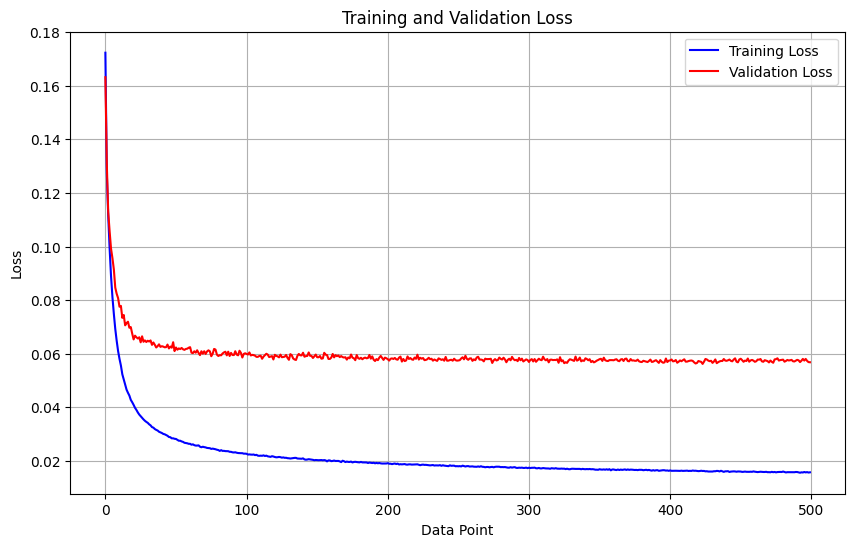

In [17]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(loss_train))
plt.figure(figsize=(10, 6))
plt.plot(x, loss_train, label='Training Loss', color='blue')
plt.plot(x, loss_valid, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Data Point')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### esm2 2560 + MolFormer
add the additional seqeunces add 1

In [4]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_2560')

In [5]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enzy_refine_layer_1 = nn.Linear(2560, 2560) # W1 and b
        self.smiles_refine_layer_1 = nn.Linear(768, 768) # W1 and b
        self.enzy_refine_layer_2 = nn.Linear(2560, 128) # W1 and b
        self.smiles_refine_layer_2 = nn.Linear(768, 128) # W1 and b

        self.relu = nn.ReLU()
        self.batch_norm_enzy = nn.BatchNorm1d(2560)
        self.batch_norm_smiles = nn.BatchNorm1d(768)
        self.batch_norm_shared = nn.BatchNorm1d(128)

    def forward(self, enzy_embed, smiles_embed):
        refined_enzy_embed = self.enzy_refine_layer_1(enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_1(smiles_embed)

        refined_enzy_embed = self.batch_norm_enzy(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_smiles(refined_smiles_embed)

        refined_enzy_embed = self.relu(refined_enzy_embed)
        refined_smiles_embed = self.relu(refined_smiles_embed)

        refined_enzy_embed = self.enzy_refine_layer_2(refined_enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_2(refined_smiles_embed)

        refined_enzy_embed = self.batch_norm_shared(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_shared(refined_smiles_embed)
        refined_enzy_embed = torch.nn.functional.normalize(refined_enzy_embed, dim=1)
        refined_smiles_embed = torch.nn.functional.normalize(refined_smiles_embed, dim=1)

        return refined_enzy_embed, refined_smiles_embed


In [6]:
def get_ds():
    # Load the saved embeddings_results
    ESP_train_df_enzy = torch.load('ESP_train_df_enzy_esm2_2560.pt')
    ESP_val_df_enzy = torch.load('ESP_val_df_enzy_esm2_2560.pt')
    ESP_test_df_enzy = torch.load('ESP_test_df_enzy_esm2_2560.pt')
    print(ESP_train_df_enzy.shape, ESP_val_df_enzy.shape, ESP_test_df_enzy.shape)
    # Load the saved embeddings_results
    ESP_train_df_smiles = torch.load('ESP_train_df_smiles_esm2_2560.pt')
    ESP_val_df_smiles = torch.load('ESP_val_df_smiles_esm2_2560.pt')
    ESP_test_df_smiles = torch.load('ESP_test_df_smiles_esm2_2560.pt')
    print(ESP_train_df_smiles.shape, ESP_val_df_smiles.shape, ESP_test_df_smiles.shape)

    y_train = torch.load( 'ESP_train_df_label_esm2_2560.pt')
    y_val = torch.load('ESP_val_df_label_esm2_2560.pt')
    y_test = torch.load('ESP_test_df_label_esm2_2560.pt')
    print(y_train.shape,y_val.shape, y_test.shape)
    ESP_train_df_enzy_add = torch.load('ESP_train_df_enzy_>2800_<5500.pt')
    ESP_train_df_smiles_add = torch.load('ESP_train_df_smiles_>2800_<5500.pt')
    y_train_add = torch.load('ESP_train_df_label_>2800_<5500.pt')

    ESP_val_df_enzy_add = torch.load('ESP_val_df_enzy_>2800_<8000.pt')
    ESP_test_df_enzy_add = torch.load('ESP_test_df_enzy_>2800_<8000.pt')
    ESP_val_df_smiles_add = torch.load('ESP_val_df_smiles_>2800_<8000.pt')
    ESP_test_df_smiles_add = torch.load('ESP_test_df_smiles_>2800_<8000.pt')
    y_val_add = torch.load('ESP_val_df_label_>2800_<8000.pt')
    y_test_add = torch.load('ESP_test_df_label_>2800_<8000.pt')
    print(ESP_val_df_enzy_add.shape, ESP_val_df_smiles_add.shape, y_val_add.shape)
    print(ESP_test_df_enzy_add.shape, ESP_test_df_smiles_add.shape, y_test_add.shape)

    ESP_train_df_enzy = torch.cat([ESP_train_df_enzy, ESP_train_df_enzy_add], dim=0)
    ESP_train_df_smiles = torch.cat([ESP_train_df_smiles, ESP_train_df_smiles_add], dim=0)
    y_train = torch.cat([y_train, y_train_add], dim=0)
    print(ESP_train_df_enzy.shape, ESP_train_df_smiles.shape, y_train.shape)

    ESP_val_df_enzy = torch.cat([ESP_val_df_enzy, ESP_val_df_enzy_add], dim=0)
    ESP_val_df_smiles = torch.cat([ESP_val_df_smiles, ESP_val_df_smiles_add], dim=0)
    y_val = torch.cat([y_val, y_val_add], dim=0)
    print(ESP_val_df_enzy.shape, ESP_val_df_smiles.shape, y_val.shape)
    ESP_test_df_enzy = torch.cat([ESP_test_df_enzy, ESP_test_df_enzy_add], dim=0)
    ESP_test_df_smiles = torch.cat([ESP_test_df_smiles, ESP_test_df_smiles_add], dim=0)
    y_test = torch.cat([y_test, y_test_add], dim=0)
    print(ESP_test_df_enzy.shape, ESP_test_df_smiles.shape, y_test.shape)

    train_tensor_dataset = TensorDataset(ESP_train_df_enzy,ESP_train_df_smiles, y_train)
    val_tensor_dataset = TensorDataset(ESP_val_df_enzy,ESP_val_df_smiles, y_val)
    test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)

    # Create TensorDataset and DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
    print(len(train_loader))
    return train_loader,  val_loader, test_loader

In [7]:
# design the model, optimizer and loss function
model = Contrastive_learning_layer().to(device)
train_loader,  val_loader, test_loader = get_ds()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-03)
loss_fn = nn.MSELoss().to(device)

torch.Size([49881, 2560]) torch.Size([5399, 2560]) torch.Size([13312, 2560])
torch.Size([49881, 768]) torch.Size([5399, 768]) torch.Size([13312, 768])
torch.Size([49881, 1]) torch.Size([5399, 1]) torch.Size([13312, 1])
torch.Size([23, 2560]) torch.Size([23, 768]) torch.Size([23, 1])
torch.Size([24, 2560]) torch.Size([24, 768]) torch.Size([24, 1])
torch.Size([50061, 2560]) torch.Size([50061, 768]) torch.Size([50061, 1])
torch.Size([5422, 2560]) torch.Size([5422, 768]) torch.Size([5422, 1])
torch.Size([13336, 2560]) torch.Size([13336, 768]) torch.Size([13336, 1])
3129


In [8]:
initial_epoch = 0
best_epoch = -1
best_accuracy = 0.5
loss_train = []
loss_valid = []
for epoch in range(initial_epoch, 500):
    torch.cuda.empty_cache()
    model.train()

    with tqdm(train_loader, desc='Processing', unit="batch") as tepoch:
        num_batch = len(train_loader)
        loss_sum = 0
        for ESP_train_df_enzy,ESP_train_df_smiles, y_train in tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            ESP_train_df_enzy = ESP_train_df_enzy.to(device)
            ESP_train_df_smiles = ESP_train_df_smiles.to(device)
            y_train = y_train.squeeze(1).to(device)
            refined_enzy_embed, refined_smiles_embed = model(ESP_train_df_enzy,ESP_train_df_smiles)
            cosine_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
            loss = loss_fn(cosine_sim, y_train)
            loss_sum = loss_sum + loss.detach().cpu().numpy()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True) #
            tepoch.set_postfix(train_loss=loss)
            # tepoch.set_postfix(val_loss=loss_sum_val, val_accuracy=100. * acc_val, balanced_val_accuracy=100. * bacc_val)
        loss_sum = loss_sum/num_batch
        loss_train.append(loss_sum)
        loss_sum_val,acc_val, bacc_val = run_validation(model,val_loader,loss_fn, device)
        loss_valid.append(loss_sum_val)
        print('Epoch: %d / %d, ############## the best accuracy in val  %.4f at Epoch: %d  ##############'  % (epoch, 500,100 * best_accuracy,best_epoch))
        # print('Performance in Train: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum, 100 * acc))
        print('Performance in Val: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum_val, 100 * acc_val))
        # checkpoint(model, f"epoch-{epoch}.pth")
        if acc_val > best_accuracy: # compare the performance updates at the val set
            best_accuracy = acc_val
            best_epoch = epoch
            torch.save(model, "best_model_11.pt")

Epoch 0: 100%|██████████| 3129/3129 [00:29<00:00, 105.69batch/s, train_loss=tensor(0.0941, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.17144762612274878 ACC=  0.7818148284765769 bacc=  0.6092892271062021 precision=  0.7755555555555556 specificity=  0.9746930593836132 sensitivity=  0.24388539482879107 recall=  0.24388539482879107 MCC=  0.3492176730784654 AUC=  0.7787535056602722 f1=  0.37107921318447634
Epoch: 0 / 500, ############## the best accuracy in val  50.0000 at Epoch: -1  ##############
Performance in Val: Loss: (0.1714); Accuracy (78.18)


Epoch 1: 100%|██████████| 3129/3129 [00:28<00:00, 110.51batch/s, train_loss=tensor(0.1706, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.13773734771143809 ACC=  0.8185171523423092 bacc=  0.6842000020661443 precision=  0.8206599713055954 specificity=  0.9686795289401152 sensitivity=  0.3997204751921733 recall=  0.3997204751921733 MCC=  0.48513545109609263 AUC=  0.8539949512538781 f1=  0.5375939849624061
Epoch: 1 / 500, ############## the best accuracy in val  78.1815 at Epoch: 0  ##############
Performance in Val: Loss: (0.1377); Accuracy (81.85)


Epoch 2: 100%|██████████| 3129/3129 [00:28<00:00, 108.41batch/s, train_loss=tensor(0.0681, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.12502639619825864 ACC=  0.8393581704168204 bacc=  0.7371303287042947 precision=  0.8010752688172043 specificity=  0.9536457028313706 sensitivity=  0.5206149545772187 recall=  0.5206149545772187 MCC=  0.5545190003811185 AUC=  0.8807453913163458 f1=  0.6310885218127912
Epoch: 2 / 500, ############## the best accuracy in val  81.8517 at Epoch: 1  ##############
Performance in Val: Loss: (0.1250); Accuracy (83.94)


Epoch 3: 100%|██████████| 3129/3129 [00:29<00:00, 106.33batch/s, train_loss=tensor(0.0652, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.10774016123990306 ACC=  0.865916635927702 bacc=  0.7925996490006078 precision=  0.8142857142857143 specificity=  0.9478827361563518 sensitivity=  0.6373165618448637 recall=  0.6373165618448637 MCC=  0.6371185689828103 AUC=  0.9139493805156641 f1=  0.7150137201097608
Epoch: 3 / 500, ############## the best accuracy in val  83.9358 at Epoch: 2  ##############
Performance in Val: Loss: (0.1077); Accuracy (86.59)


Epoch 4: 100%|██████████| 3129/3129 [00:28<00:00, 110.74batch/s, train_loss=tensor(0.0566, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.10265580577924188 ACC=  0.8812246403541129 bacc=  0.8175661135528384 precision=  0.8371893744644388 specificity=  0.9523928839889751 sensitivity=  0.6827393431167016 recall=  0.6827393431167016 MCC=  0.6811450741599863 AUC=  0.9236159591085533 f1=  0.75211701308699
Epoch: 4 / 500, ############## the best accuracy in val  86.5917 at Epoch: 3  ##############
Performance in Val: Loss: (0.1027); Accuracy (88.12)


Epoch 5: 100%|██████████| 3129/3129 [00:28<00:00, 107.91batch/s, train_loss=tensor(0.0738, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09655854918590162 ACC=  0.883253412025083 bacc=  0.840460130331681 precision=  0.7959940652818991 specificity=  0.9310949636682536 sensitivity=  0.7498252969951084 recall=  0.7498252969951084 MCC=  0.6943868360949679 AUC=  0.9343122830001326 f1=  0.7722202231018354
Epoch: 5 / 500, ############## the best accuracy in val  88.1225 at Epoch: 4  ##############
Performance in Val: Loss: (0.0966); Accuracy (88.33)


Epoch 6: 100%|██████████| 3129/3129 [00:28<00:00, 109.57batch/s, train_loss=tensor(0.0468, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09201182214993775 ACC=  0.8950571744743637 bacc=  0.855650142940414 precision=  0.81973293768546 specificity=  0.9391130042595841 sensitivity=  0.7721872816212438 recall=  0.7721872816212438 MCC=  0.7253676877598751 AUC=  0.9391763018153529 f1=  0.7952500899604174
Epoch: 6 / 500, ############## the best accuracy in val  88.3253 at Epoch: 5  ##############
Performance in Val: Loss: (0.0920); Accuracy (89.51)


Epoch 7: 100%|██████████| 3129/3129 [00:28<00:00, 108.37batch/s, train_loss=tensor(0.0807, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08854223444239184 ACC=  0.900590188122464 bacc=  0.8605292200953193 precision=  0.8358433734939759 specificity=  0.945377098471561 sensitivity=  0.7756813417190775 recall=  0.7756813417190775 MCC=  0.7390233982793274 AUC=  0.9435806910762352 f1=  0.8046393620877129
Epoch: 7 / 500, ############## the best accuracy in val  89.5057 at Epoch: 6  ##############
Performance in Val: Loss: (0.0885); Accuracy (90.06)


Epoch 8: 100%|██████████| 3129/3129 [00:28<00:00, 109.17batch/s, train_loss=tensor(0.0823, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08549939464519465 ACC=  0.9024345260051642 bacc=  0.8620061630632585 precision=  0.8416666666666667 specificity=  0.9476321723878727 sensitivity=  0.7763801537386443 recall=  0.7763801537386443 MCC=  0.7435699789653831 AUC=  0.9470413076522105 f1=  0.8077062886223193
Epoch: 8 / 500, ############## the best accuracy in val  90.0590 at Epoch: 7  ##############
Performance in Val: Loss: (0.0855); Accuracy (90.24)


Epoch 9: 100%|██████████| 3129/3129 [00:28<00:00, 109.62batch/s, train_loss=tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08350597667318266 ACC=  0.9061232017705644 bacc=  0.8757180070252408 precision=  0.8292857142857143 specificity=  0.9401152593335004 sensitivity=  0.8113207547169812 recall=  0.8113207547169812 MCC=  0.7567764963170848 AUC=  0.9513343352382133 f1=  0.820204874602614
Epoch: 9 / 500, ############## the best accuracy in val  90.2435 at Epoch: 8  ##############
Performance in Val: Loss: (0.0835); Accuracy (90.61)


Epoch 10: 100%|██████████| 3129/3129 [00:28<00:00, 108.96batch/s, train_loss=tensor(0.0710, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08170311865575369 ACC=  0.9122095167834747 bacc=  0.8816453022094961 precision=  0.8452639190166306 specificity=  0.9463793535454773 sensitivity=  0.816911250873515 recall=  0.816911250873515 MCC=  0.771796101767465 AUC=  0.9505828190297492 f1=  0.8308457711442786
Epoch: 10 / 500, ############## the best accuracy in val  90.6123 at Epoch: 9  ##############
Performance in Val: Loss: (0.0817); Accuracy (91.22)


Epoch 11: 100%|██████████| 3129/3129 [00:28<00:00, 110.39batch/s, train_loss=tensor(0.0341, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07811758589483028 ACC=  0.916082626337145 bacc=  0.8862933389084209 precision=  0.8536231884057971 specificity=  0.9493861187672262 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.7817541547608403 AUC=  0.9539693695861111 f1=  0.8381358946993951
Epoch: 11 / 500, ############## the best accuracy in val  91.2210 at Epoch: 10  ##############
Performance in Val: Loss: (0.0781); Accuracy (91.61)


Epoch 12: 100%|██████████| 3129/3129 [00:28<00:00, 110.32batch/s, train_loss=tensor(0.0382, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0776828339537688 ACC=  0.9162670601254149 bacc=  0.8915734756801685 precision=  0.8428070175438597 specificity=  0.9438737158606866 sensitivity=  0.8392732354996506 recall=  0.8392732354996506 MCC=  0.784204691461454 AUC=  0.9546473450658811 f1=  0.8410364145658265
Epoch: 12 / 500, ############## the best accuracy in val  91.6083 at Epoch: 11  ##############
Performance in Val: Loss: (0.0777); Accuracy (91.63)


Epoch 13: 100%|██████████| 3129/3129 [00:28<00:00, 108.69batch/s, train_loss=tensor(0.0402, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07619134759788668 ACC=  0.9208779048321653 bacc=  0.8904471644008243 precision=  0.8678414096916299 specificity=  0.954898521673766 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.7935994880758908 AUC=  0.953675731962254 f1=  0.8464017185821698
Epoch: 13 / 500, ############## the best accuracy in val  91.6267 at Epoch: 12  ##############
Performance in Val: Loss: (0.0762); Accuracy (92.09)


Epoch 14: 100%|██████████| 3129/3129 [00:29<00:00, 107.38batch/s, train_loss=tensor(0.0737, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07515569158162164 ACC=  0.9208779048321653 bacc=  0.8911195367774558 precision=  0.8662280701754386 specificity=  0.9541468303683287 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.7938076235625251 AUC=  0.9540166457688429 f1=  0.8467309753483386
Epoch: 14 / 500, ############## the best accuracy in val  92.0878 at Epoch: 13  ##############
Performance in Val: Loss: (0.0752); Accuracy (92.09)


Epoch 15: 100%|██████████| 3129/3129 [00:28<00:00, 108.98batch/s, train_loss=tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07170917414634277 ACC=  0.9253043157506455 bacc=  0.8979364121334498 precision=  0.872278664731495 specificity=  0.9559007767476823 sensitivity=  0.8399720475192173 recall=  0.8399720475192173 MCC=  0.805701503625794 AUC=  0.9586115405364376 f1=  0.8558205767176931
Epoch: 15 / 500, ############## the best accuracy in val  92.0878 at Epoch: 13  ##############
Performance in Val: Loss: (0.0717); Accuracy (92.53)


Epoch 16: 100%|██████████| 3129/3129 [00:28<00:00, 110.33batch/s, train_loss=tensor(0.1120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07435505795031566 ACC=  0.9238288454444854 bacc=  0.8937964193019199 precision=  0.8748159057437408 specificity=  0.9574041593585567 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.8011903406823153 AUC=  0.9547592320316799 f1=  0.8519182502689137
Epoch: 16 / 500, ############## the best accuracy in val  92.5304 at Epoch: 15  ##############
Performance in Val: Loss: (0.0744); Accuracy (92.38)


Epoch 17: 100%|██████████| 3129/3129 [00:28<00:00, 111.04batch/s, train_loss=tensor(0.0471, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07228672744123853 ACC=  0.9223533751383254 bacc=  0.8979490191155116 precision=  0.8576487252124646 specificity=  0.9496366825357053 sensitivity=  0.8462613556953179 recall=  0.8462613556953179 MCC=  0.7993345412640489 AUC=  0.9571221656834096 f1=  0.8519169890960253
Epoch: 17 / 500, ############## the best accuracy in val  92.5304 at Epoch: 15  ##############
Performance in Val: Loss: (0.0723); Accuracy (92.24)


Epoch 18: 100%|██████████| 3129/3129 [00:28<00:00, 109.26batch/s, train_loss=tensor(0.0890, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07144195776690995 ACC=  0.9269642198450756 bacc=  0.8981674525894303 precision=  0.8802351212343865 specificity=  0.9591581057379103 sensitivity=  0.8371767994409504 recall=  0.8371767994409504 MCC=  0.8094888585440742 AUC=  0.9557616622025693 f1=  0.8581661891117478
Epoch: 18 / 500, ############## the best accuracy in val  92.5304 at Epoch: 15  ##############
Performance in Val: Loss: (0.0714); Accuracy (92.70)


Epoch 19: 100%|██████████| 3129/3129 [00:28<00:00, 109.62batch/s, train_loss=tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06898725992700519 ACC=  0.9269642198450756 bacc=  0.903770555728026 precision=  0.8667611622962438 specificity=  0.9528940115259333 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8112140878068131 AUC=  0.9598359936691939 f1=  0.860661505981703
Epoch: 19 / 500, ############## the best accuracy in val  92.6964 at Epoch: 18  ##############
Performance in Val: Loss: (0.0690); Accuracy (92.70)


Epoch 20: 100%|██████████| 3129/3129 [00:28<00:00, 110.87batch/s, train_loss=tensor(0.0584, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06918819795244519 ACC=  0.9284396901512357 bacc=  0.907910548559556 precision=  0.8644304682040531 specificity=  0.9513906289150589 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.815821097119112 AUC=  0.9586591669131157 f1=  0.8644304682040531
Epoch: 20 / 500, ############## the best accuracy in val  92.6964 at Epoch: 18  ##############
Performance in Val: Loss: (0.0692); Accuracy (92.84)


Epoch 21: 100%|██████████| 3129/3129 [00:28<00:00, 109.92batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06951156052812978 ACC=  0.9289929915160458 bacc=  0.9035797875758542 precision=  0.8773448773448773 specificity=  0.9574041593585567 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8155730941575525 AUC=  0.9580834480656252 f1=  0.8633297834575788
Epoch: 21 / 500, ############## the best accuracy in val  92.8440 at Epoch: 20  ##############
Performance in Val: Loss: (0.0695); Accuracy (92.90)


Epoch 22: 100%|██████████| 3129/3129 [00:28<00:00, 109.20batch/s, train_loss=tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06667198497351468 ACC=  0.9300995942456658 bacc=  0.9038832306302038 precision=  0.8822674418604651 specificity=  0.9594086695063894 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8181338122169395 AUC=  0.9631092564839723 f1=  0.8649804061275383
Epoch: 22 / 500, ############## the best accuracy in val  92.8993 at Epoch: 21  ##############
Performance in Val: Loss: (0.0667); Accuracy (93.01)


Epoch 23: 100%|██████████| 3129/3129 [00:28<00:00, 108.03batch/s, train_loss=tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06779960930144145 ACC=  0.932312799704906 bacc=  0.9053866132410782 precision=  0.8900293255131965 specificity=  0.9624154347281383 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8235630876309008 AUC=  0.9596244765257118 f1=  0.8686940966010734
Epoch: 23 / 500, ############## the best accuracy in val  93.0100 at Epoch: 22  ##############
Performance in Val: Loss: (0.0678); Accuracy (93.23)


Epoch 24: 100%|██████████| 3129/3129 [00:28<00:00, 108.79batch/s, train_loss=tensor(0.0390, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0694739884782066 ACC=  0.9297307266691258 bacc=  0.9049774116149876 precision=  0.8776978417266187 specificity=  0.9574041593585567 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8176243462307122 AUC=  0.9559964672434711 f1=  0.8649415101028003
Epoch: 24 / 500, ############## the best accuracy in val  93.2313 at Epoch: 23  ##############
Performance in Val: Loss: (0.0695); Accuracy (92.97)


Epoch 25: 100%|██████████| 3129/3129 [00:28<00:00, 107.95batch/s, train_loss=tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0671980615573383 ACC=  0.9312061969752858 bacc=  0.9044107978100973 precision=  0.8866959064327485 specificity=  0.9611626158857429 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8207832751022065 AUC=  0.9598834449488988 f1=  0.8667381207574134
Epoch: 25 / 500, ############## the best accuracy in val  93.2313 at Epoch: 23  ##############
Performance in Val: Loss: (0.0672); Accuracy (93.12)


Epoch 26: 100%|██████████| 3129/3129 [00:28<00:00, 109.75batch/s, train_loss=tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06862036523664683 ACC=  0.9306528956104758 bacc=  0.9033625797807471 precision=  0.8864468864468864 specificity=  0.9611626158857429 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.8192518916649935 AUC=  0.9578496936065617 f1=  0.86552217453505
Epoch: 26 / 500, ############## the best accuracy in val  93.2313 at Epoch: 23  ##############
Performance in Val: Loss: (0.0686); Accuracy (93.07)


Epoch 27: 100%|██████████| 3129/3129 [00:28<00:00, 109.64batch/s, train_loss=tensor(0.0754, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06647539497998743 ACC=  0.933050534857986 bacc=  0.9081289820334747 precision=  0.8869565217391304 specificity=  0.9609120521172638 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.825943642426152 AUC=  0.9600781527829649 f1=  0.8708644610458911
Epoch: 27 / 500, ############## the best accuracy in val  93.2313 at Epoch: 23  ##############
Performance in Val: Loss: (0.0665); Accuracy (93.31)


Epoch 28: 100%|██████████| 3129/3129 [00:28<00:00, 110.35batch/s, train_loss=tensor(0.0675, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06676353762547176 ACC=  0.9300995942456658 bacc=  0.9054520995090105 precision=  0.8784172661870504 specificity=  0.9576547231270358 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8185827117293368 AUC=  0.9600124914180596 f1=  0.8656504785537045
Epoch: 28 / 500, ############## the best accuracy in val  93.3051 at Epoch: 27  ##############
Performance in Val: Loss: (0.0668); Accuracy (93.01)


Epoch 29: 100%|██████████| 3129/3129 [00:28<00:00, 110.74batch/s, train_loss=tensor(0.0590, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06681422833188445 ACC=  0.933050534857986 bacc=  0.9085772302845623 precision=  0.8858381502890174 specificity=  0.9604109245803056 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8260638823954876 AUC=  0.9596421613199931 f1=  0.8710479573712256
Epoch: 29 / 500, ############## the best accuracy in val  93.3051 at Epoch: 27  ##############
Performance in Val: Loss: (0.0668); Accuracy (93.31)


Epoch 30: 100%|██████████| 3129/3129 [00:28<00:00, 109.75batch/s, train_loss=tensor(0.0446, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0655978110063942 ACC=  0.9308373293987459 bacc=  0.9057291029204249 precision=  0.8815028901734104 specificity=  0.9589075419694312 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8203055214943242 AUC=  0.9612772168546246 f1=  0.866785079928952
Epoch: 30 / 500, ############## the best accuracy in val  93.3051 at Epoch: 27  ##############
Performance in Val: Loss: (0.0656); Accuracy (93.08)


Epoch 31: 100%|██████████| 3129/3129 [00:28<00:00, 110.71batch/s, train_loss=tensor(0.0481, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06449856091246756 ACC=  0.9317594983400959 bacc=  0.9059072640905349 precision=  0.8858181818181818 specificity=  0.9606614883487847 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8224311453832216 AUC=  0.9611411665065405 f1=  0.8681397006414825
Epoch: 31 / 500, ############## the best accuracy in val  93.3051 at Epoch: 27  ##############
Performance in Val: Loss: (0.0645); Accuracy (93.18)


Epoch 32: 100%|██████████| 3129/3129 [00:28<00:00, 109.66batch/s, train_loss=tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06708985378081116 ACC=  0.9284396901512357 bacc=  0.903876314299767 precision=  0.8738351254480287 specificity=  0.9559007767476823 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8144438386023243 AUC=  0.9606313716694148 f1=  0.8627034677990091
Epoch: 32 / 500, ############## the best accuracy in val  93.3051 at Epoch: 27  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.84)


Epoch 33: 100%|██████████| 3129/3129 [00:29<00:00, 107.27batch/s, train_loss=tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0653902224421633 ACC=  0.934341571375876 bacc=  0.9085577069720638 precision=  0.8926223520818115 specificity=  0.9631671260335756 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8289990977412411 AUC=  0.9607948246937861 f1=  0.8728571428571429
Epoch: 33 / 500, ############## the best accuracy in val  93.3051 at Epoch: 27  ##############
Performance in Val: Loss: (0.0654); Accuracy (93.43)


Epoch 34: 100%|██████████| 3129/3129 [00:29<00:00, 104.94batch/s, train_loss=tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06501880418207046 ACC=  0.932128365916636 bacc=  0.9068302002356454 precision=  0.8854242204496011 specificity=  0.9604109245803056 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8235118580577335 AUC=  0.9602205066220799 f1=  0.8690391459074733
Epoch: 34 / 500, ############## the best accuracy in val  93.4342 at Epoch: 33  ##############
Performance in Val: Loss: (0.0650); Accuracy (93.21)


Epoch 35: 100%|██████████| 3129/3129 [00:29<00:00, 106.78batch/s, train_loss=tensor(0.0497, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06522752136640404 ACC=  0.9348948727406861 bacc=  0.9105024215035892 precision=  0.8905797101449275 specificity=  0.9621648709596592 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8307468476071642 AUC=  0.9591804306019782 f1=  0.8744219139096407
Epoch: 35 / 500, ############## the best accuracy in val  93.4342 at Epoch: 33  ##############
Performance in Val: Loss: (0.0652); Accuracy (93.49)


Epoch 36: 100%|██████████| 3129/3129 [00:29<00:00, 105.43batch/s, train_loss=tensor(0.0424, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06524606323100429 ACC=  0.934341571375876 bacc=  0.9090059552231515 precision=  0.8914785142024764 specificity=  0.9626659984966174 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8291080864381999 AUC=  0.9592252554270868 f1=  0.8730385164051355
Epoch: 36 / 500, ############## the best accuracy in val  93.4895 at Epoch: 35  ##############
Performance in Val: Loss: (0.0652); Accuracy (93.43)


Epoch 37: 100%|██████████| 3129/3129 [00:29<00:00, 105.92batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06342032437616613 ACC=  0.9380302471412763 bacc=  0.9115115929079423 precision=  0.9046563192904656 specificity=  0.967677273866199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8382624409512204 AUC=  0.9604022572801383 f1=  0.8793103448275863
Epoch: 37 / 500, ############## the best accuracy in val  93.4895 at Epoch: 35  ##############
Performance in Val: Loss: (0.0634); Accuracy (93.80)


Epoch 38: 100%|██████████| 3129/3129 [00:29<00:00, 105.99batch/s, train_loss=tensor(0.0531, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0650426732420174 ACC=  0.9354481741054961 bacc=  0.9090852741519573 precision=  0.8971344599559148 specificity=  0.9649210724129291 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8316851853833522 AUC=  0.9584178832842098 f1=  0.8746418338108882
Epoch: 38 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0650); Accuracy (93.54)


Epoch 39: 100%|██████████| 3129/3129 [00:29<00:00, 106.23batch/s, train_loss=tensor(0.0445, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06401498533049077 ACC=  0.9352637403172261 bacc=  0.9096323646443492 precision=  0.8947368421052632 specificity=  0.9639188173390127 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8313808524927957 AUC=  0.9603336192666904 f1=  0.8745980707395499
Epoch: 39 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0640); Accuracy (93.53)


Epoch 40: 100%|██████████| 3129/3129 [00:29<00:00, 107.40batch/s, train_loss=tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06437341930690856 ACC=  0.9352637403172261 bacc=  0.9080634957655424 precision=  0.8988183161004432 specificity=  0.9656727637183663 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8310336660364612 AUC=  0.9591595940621815 f1=  0.873967684021544
Epoch: 40 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0644); Accuracy (93.53)


Epoch 41: 100%|██████████| 3129/3129 [00:28<00:00, 108.77batch/s, train_loss=tensor(0.0439, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06383734658926418 ACC=  0.9361859092585761 bacc=  0.9095864016889154 precision=  0.8997789240972734 specificity=  0.9659233274868454 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8335199658446406 AUC=  0.9589477267247534 f1=  0.875896700143472
Epoch: 41 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0638); Accuracy (93.62)


Epoch 42: 100%|██████████| 3129/3129 [00:29<00:00, 107.07batch/s, train_loss=tensor(0.0460, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06407988212651032 ACC=  0.9380302471412763 bacc=  0.9126322135356614 precision=  0.9016874541452677 specificity=  0.9664244550238036 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8384870363985928 AUC=  0.957548351715889 f1=  0.8797423049391552
Epoch: 42 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0641); Accuracy (93.80)


Epoch 43: 100%|██████████| 3129/3129 [00:28<00:00, 108.10batch/s, train_loss=tensor(0.0634, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06389756225445102 ACC=  0.9356326078937661 bacc=  0.9114517972916351 precision=  0.8920289855072464 specificity=  0.9626659984966174 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.832668129679569 AUC=  0.9608091826455788 f1=  0.8758448950551405
Epoch: 43 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0639); Accuracy (93.56)


Epoch 44: 100%|██████████| 3129/3129 [00:28<00:00, 109.19batch/s, train_loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06203800628159558 ACC=  0.9371080781999263 bacc=  0.911557555863376 precision=  0.8995601173020528 specificity=  0.9656727637183663 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8360996647985105 AUC=  0.9599310713255769 f1=  0.8779964221824686
Epoch: 44 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0620); Accuracy (93.71)


Epoch 45: 100%|██████████| 3129/3129 [00:28<00:00, 110.18batch/s, train_loss=tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0640839162546383 ACC=  0.9324972334931759 bacc=  0.907753136380756 precision=  0.8850325379609545 specificity=  0.9601603608118267 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8245936195734327 AUC=  0.9586101397606529 f1=  0.8699360341151386
Epoch: 45 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0641); Accuracy (93.25)


Epoch 46: 100%|██████████| 3129/3129 [00:28<00:00, 109.19batch/s, train_loss=tensor(0.0388, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06391719337360477 ACC=  0.9369236444116562 bacc=  0.9134493911090309 precision=  0.8937093275488069 specificity=  0.9631671260335756 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8361130780038256 AUC=  0.961109824148359 f1=  0.8784648187633262
Epoch: 46 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0639); Accuracy (93.69)


Epoch 47: 100%|██████████| 3129/3129 [00:28<00:00, 108.20batch/s, train_loss=tensor(0.0701, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06346323553357372 ACC=  0.9350793065289561 bacc=  0.910179455136741 precision=  0.8923636363636364 specificity=  0.9629165622650965 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8310872678187236 AUC=  0.9607599803961429 f1=  0.8745545260156807
Epoch: 47 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0635); Accuracy (93.51)


Epoch 48: 100%|██████████| 3129/3129 [00:29<00:00, 107.03batch/s, train_loss=tensor(0.0371, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06369648639533042 ACC=  0.9345260051641461 bacc=  0.9082347406052156 precision=  0.8944281524926686 specificity=  0.9639188173390127 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8293492001697975 AUC=  0.958780859309407 f1=  0.8729874776386404
Epoch: 48 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0637); Accuracy (93.45)


Epoch 49: 100%|██████████| 3129/3129 [00:29<00:00, 107.27batch/s, train_loss=tensor(0.0403, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06361495315064306 ACC=  0.9339727037993361 bacc=  0.9071865225758655 precision=  0.8941954445260838 specificity=  0.9639188173390127 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8278249546286952 AUC=  0.9584536030667186 f1=  0.8717765042979942
Epoch: 49 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0636); Accuracy (93.40)


Epoch 50: 100%|██████████| 3129/3129 [00:29<00:00, 107.60batch/s, train_loss=tensor(0.0410, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0639758473358345 ACC=  0.9363703430468462 bacc=  0.912177048954137 precision=  0.8940493468795355 specificity=  0.9634176898020547 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8345345084707207 AUC=  0.9589142832028948 f1=  0.877180491278035
Epoch: 50 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0640); Accuracy (93.64)


Epoch 51: 100%|██████████| 3129/3129 [00:28<00:00, 108.40batch/s, train_loss=tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06330243650972184 ACC=  0.9354481741054961 bacc=  0.9108782671563078 precision=  0.8925199709513435 specificity=  0.9629165622650965 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8321040078210665 AUC=  0.9576110364322521 f1=  0.8753561253561253
Epoch: 51 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0633); Accuracy (93.54)


Epoch 52: 100%|██████████| 3129/3129 [00:28<00:00, 109.01batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.062408360213063285 ACC=  0.9356326078937661 bacc=  0.908762307785109 precision=  0.8989675516224189 specificity=  0.9656727637183663 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.832047245000701 AUC=  0.9609776259336826 f1=  0.8747757445281665
Epoch: 52 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0624); Accuracy (93.56)


Epoch 53: 100%|██████████| 3129/3129 [00:28<00:00, 108.99batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06378475028834688 ACC=  0.933788270011066 bacc=  0.9095266060726082 precision=  0.8872832369942196 specificity=  0.9609120521172638 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8279833360292086 AUC=  0.9593362669080204 f1=  0.8724689165186501
Epoch: 53 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0638); Accuracy (93.38)


Epoch 54: 100%|██████████| 3129/3129 [00:28<00:00, 109.00batch/s, train_loss=tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06209397147983796 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9603751172493107 f1=  0.8818897637795275
Epoch: 54 / 500, ############## the best accuracy in val  93.8030 at Epoch: 37  ##############
Performance in Val: Loss: (0.0621); Accuracy (93.91)


Epoch 55: 100%|██████████| 3129/3129 [00:28<00:00, 108.05batch/s, train_loss=tensor(0.0524, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06320541901349098 ACC=  0.933419402434526 bacc=  0.9077071734253223 precision=  0.8899416909620991 specificity=  0.9621648709596592 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8266743486768197 AUC=  0.9585056068677235 f1=  0.8712094184801997
Epoch: 55 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0632); Accuracy (93.34)


Epoch 56: 100%|██████████| 3129/3129 [00:28<00:00, 109.33batch/s, train_loss=tensor(0.0980, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06260266282614925 ACC=  0.9369236444116562 bacc=  0.9118805222302242 precision=  0.8977355734112491 specificity=  0.9649210724129291 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.835741378706618 AUC=  0.9595705466580028 f1=  0.8778571428571429
Epoch: 56 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0626); Accuracy (93.69)


Epoch 57: 100%|██████████| 3129/3129 [00:28<00:00, 108.57batch/s, train_loss=tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061840949624029584 ACC=  0.9361859092585761 bacc=  0.9098105258144592 precision=  0.8991905813097866 specificity=  0.9656727637183663 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8335672547649333 AUC=  0.9601788335424868 f1=  0.8759856630824372
Epoch: 57 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.62)


Epoch 58: 100%|██████████| 3129/3129 [00:28<00:00, 108.86batch/s, train_loss=tensor(0.0377, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06293476983811432 ACC=  0.9372925119881962 bacc=  0.9132517066264223 precision=  0.8961510530137982 specificity=  0.9641693811074918 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8369106589712275 AUC=  0.9586279996519071 f1=  0.8789173789173789
Epoch: 58 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0629); Accuracy (93.73)


Epoch 59: 100%|██████████| 3129/3129 [00:28<00:00, 109.23batch/s, train_loss=tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061807199043378364 ACC=  0.9365547768351162 bacc=  0.9111817102106574 precision=  0.8975859546452085 specificity=  0.9649210724129291 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8347276093787402 AUC=  0.9612089290351229 f1=  0.8770550393137956
Epoch: 59 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.66)


Epoch 60: 100%|██████████| 3129/3129 [00:28<00:00, 108.86batch/s, train_loss=tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06114712425515847 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9619138694487473 f1=  0.8819742489270388
Epoch: 60 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0611); Accuracy (93.91)


Epoch 61: 100%|██████████| 3129/3129 [00:28<00:00, 109.41batch/s, train_loss=tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06134885940343625 ACC=  0.9360014754703062 bacc=  0.9099093680557635 precision=  0.8979441997063142 specificity=  0.9651716361814082 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8331571959186164 AUC=  0.9609562641029669 f1=  0.8757608306480487
Epoch: 61 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.60)


Epoch 62: 100%|██████████| 3129/3129 [00:28<00:00, 110.19batch/s, train_loss=tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0626228766276839 ACC=  0.9376613795647363 bacc=  0.9099162843862001 precision=  0.9069247952345495 specificity=  0.9686795289401152 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8370877547413943 AUC=  0.9600025108905939 f1=  0.8781542898341744
Epoch: 62 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0626); Accuracy (93.77)


Epoch 63: 100%|██████████| 3129/3129 [00:28<00:00, 109.11batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061976331639155786 ACC=  0.9363703430468462 bacc=  0.9094875594476111 precision=  0.9010339734121122 specificity=  0.9664244550238036 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8339338148482504 AUC=  0.9607759142206933 f1=  0.8761220825852782
Epoch: 63 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0620); Accuracy (93.64)


Epoch 64: 100%|██████████| 3129/3129 [00:28<00:00, 110.03batch/s, train_loss=tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060987285457848185 ACC=  0.9380302471412763 bacc=  0.9124080894101176 precision=  0.9022777369581191 specificity=  0.9666750187922827 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8384405892040021 AUC=  0.9631586338303811 f1=  0.8796561604584527
Epoch: 64 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0610); Accuracy (93.80)


Epoch 65: 100%|██████████| 3129/3129 [00:28<00:00, 109.03batch/s, train_loss=tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06224626177855957 ACC=  0.932866101069716 bacc=  0.9075554518981475 precision=  0.8874364560639071 specificity=  0.9611626158857429 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8253746962108411 AUC=  0.962249530346144 f1=  0.8703703703703703
Epoch: 65 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0622); Accuracy (93.29)


Epoch 66: 100%|██████████| 3129/3129 [00:28<00:00, 108.57batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06212002233599359 ACC=  0.9389524160826264 bacc=  0.9123621264546837 precision=  0.9074074074074074 specificity=  0.9686795289401152 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.840617986062439 AUC=  0.9590737965453717 f1=  0.8809780654440849
Epoch: 66 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0621); Accuracy (93.90)


Epoch 67: 100%|██████████| 3129/3129 [00:28<00:00, 109.53batch/s, train_loss=tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06251909767598969 ACC=  0.9371080781999263 bacc=  0.9095404387334816 precision=  0.9049034175334324 specificity=  0.967927837634678 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8356950890107887 AUC=  0.957822378478761 f1=  0.8772056175729205
Epoch: 67 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0625); Accuracy (93.71)


Epoch 68: 100%|██████████| 3129/3129 [00:28<00:00, 108.72batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0613460843959565 ACC=  0.9347104389524161 bacc=  0.9088082707405429 precision=  0.8939283101682517 specificity=  0.9636682535705337 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8299093613737917 AUC=  0.9614416329123476 f1=  0.8734810578984991
Epoch: 68 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.47)


Epoch 69: 100%|██████████| 3129/3129 [00:28<00:00, 110.23batch/s, train_loss=tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060746346078373516 ACC=  0.9367392106233862 bacc=  0.9106346197182655 precision=  0.9 specificity=  0.9659233274868454 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8350391236362094 AUC=  0.9632820771964032 f1=  0.8771049802938015
Epoch: 69 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.67)


Epoch 70: 100%|██████████| 3129/3129 [00:28<00:00, 110.39batch/s, train_loss=tensor(0.0351, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061775470664862074 ACC=  0.9365547768351162 bacc=  0.911854082587289 precision=  0.8958485069191552 specificity=  0.9641693811074918 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8348816097785237 AUC=  0.9604805256271055 f1=  0.8773181169757489
Epoch: 70 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.66)


Epoch 71: 100%|██████████| 3129/3129 [00:29<00:00, 107.87batch/s, train_loss=tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061428220379427294 ACC=  0.9352637403172261 bacc=  0.9087358681421738 precision=  0.8970588235294118 specificity=  0.9649210724129291 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8311779493075805 AUC=  0.9611635789190949 f1=  0.8742386241490505
Epoch: 71 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0614); Accuracy (93.53)


Epoch 72: 100%|██████████| 3129/3129 [00:28<00:00, 108.17batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06155150970801228 ACC=  0.9365547768351162 bacc=  0.9120782067128328 precision=  0.8952727272727272 specificity=  0.9639188173390127 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8349344333456132 AUC=  0.9591739520139742 f1=  0.8774055595153243
Epoch: 72 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0616); Accuracy (93.66)


Epoch 73: 100%|██████████| 3129/3129 [00:28<00:00, 108.55batch/s, train_loss=tensor(0.0496, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061223108434066136 ACC=  0.9371080781999263 bacc=  0.9097645628590254 precision=  0.9043026706231454 specificity=  0.967677273866199 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8357369718161073 AUC=  0.9592509946821299 f1=  0.8772939906441166
Epoch: 73 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0612); Accuracy (93.71)


Epoch 74: 100%|██████████| 3129/3129 [00:28<00:00, 109.10batch/s, train_loss=tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061145516744317556 ACC=  0.9356326078937661 bacc=  0.9103311766639159 precision=  0.8948905109489051 specificity=  0.9639188173390127 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8323963939294748 AUC=  0.960686789861395 f1=  0.8754016422706177
Epoch: 74 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0611); Accuracy (93.56)


Epoch 75: 100%|██████████| 3129/3129 [00:28<00:00, 109.28batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06118629731040085 ACC=  0.9363703430468462 bacc=  0.9099358076986988 precision=  0.8998527245949927 specificity=  0.9659233274868454 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8340263987423191 AUC=  0.9601725300514556 f1=  0.8762997490139836
Epoch: 75 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0612); Accuracy (93.64)


Epoch 76: 100%|██████████| 3129/3129 [00:29<00:00, 107.85batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06131808852068091 ACC=  0.9365547768351162 bacc=  0.9107334619595697 precision=  0.8987527512839325 specificity=  0.9654221999498872 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8346286886262451 AUC=  0.9614857573495641 f1=  0.8768790264853257
Epoch: 76 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.66)


Epoch 77: 100%|██████████| 3129/3129 [00:28<00:00, 108.99batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06049335364576506 ACC=  0.9363703430468462 bacc=  0.9128494213307685 precision=  0.8923410404624278 specificity=  0.9626659984966174 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8347014237472324 AUC=  0.9615255043624535 f1=  0.8774422735346359
Epoch: 77 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.64)


Epoch 78: 100%|██████████| 3129/3129 [00:28<00:00, 111.11batch/s, train_loss=tensor(0.0474, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06063992458541265 ACC=  0.9383991147178163 bacc=  0.9137792738063157 precision=  0.9006574141709277 specificity=  0.9659233274868454 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8395941106868334 AUC=  0.9612469250782816 f1=  0.8807142857142858
Epoch: 78 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.84)


Epoch 79: 100%|██████████| 3129/3129 [00:28<00:00, 109.93batch/s, train_loss=tensor(0.0278, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060757388061346555 ACC=  0.9372925119881962 bacc=  0.9123552101242471 precision=  0.8984660336011687 specificity=  0.9651716361814082 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8367045617016718 AUC=  0.962314141129211 f1=  0.8785714285714287
Epoch: 79 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0608); Accuracy (93.73)


Epoch 80: 100%|██████████| 3129/3129 [00:28<00:00, 108.08batch/s, train_loss=tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06201692023465635 ACC=  0.9371080781999263 bacc=  0.9102128111101131 precision=  0.9031065088757396 specificity=  0.9671761463292408 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8358230532321268 AUC=  0.9582566189720021 f1=  0.8774703557312252
Epoch: 80 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0620); Accuracy (93.71)


Epoch 81: 100%|██████████| 3129/3129 [00:29<00:00, 107.37batch/s, train_loss=tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06148825496006592 ACC=  0.9376613795647363 bacc=  0.9103645326372878 precision=  0.9057164068299925 specificity=  0.9681784014031571 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8371685218056035 AUC=  0.9595610914214564 f1=  0.8783297336213104
Epoch: 81 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0615); Accuracy (93.77)


Epoch 82: 100%|██████████| 3129/3129 [00:28<00:00, 110.60batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06062633338985981 ACC=  0.9395057174474364 bacc=  0.9152033374883846 precision=  0.9028487947406866 specificity=  0.9666750187922827 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8424836596719949 AUC=  0.9602366155436035 f1=  0.8828571428571427
Epoch: 82 / 500, ############## the best accuracy in val  93.9137 at Epoch: 54  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.95)


Epoch 83: 100%|██████████| 3129/3129 [00:28<00:00, 109.51batch/s, train_loss=tensor(0.0423, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060937053467638815 ACC=  0.9378458133530063 bacc=  0.9131793040280534 precision=  0.8992700729927007 specificity=  0.9654221999498872 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8381740951673744 AUC=  0.9605882102655503 f1=  0.8796858264905392
Epoch: 83 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.78)


Epoch 84: 100%|██████████| 3129/3129 [00:28<00:00, 110.00batch/s, train_loss=tensor(0.0397, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06007240486542823 ACC=  0.9387679822943563 bacc=  0.9140298375747948 precision=  0.9019751280175567 specificity=  0.9664244550238036 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8405095069846785 AUC=  0.961520076356288 f1=  0.8813438170121515
Epoch: 84 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.88)


Epoch 85: 100%|██████████| 3129/3129 [00:28<00:00, 108.36batch/s, train_loss=tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06060356590732009 ACC=  0.9376613795647363 bacc=  0.91282989801827 precision=  0.8991964937910883 specificity=  0.9654221999498872 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8376677446967257 AUC=  0.9588612288200513 f1=  0.8792857142857143
Epoch: 85 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.77)


Epoch 86: 100%|██████████| 3129/3129 [00:28<00:00, 109.52batch/s, train_loss=tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061359037360132485 ACC=  0.9354481741054961 bacc=  0.9077405293986942 precision=  0.9006671608598962 specificity=  0.9664244550238036 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8314026013360124 AUC=  0.9593140295924392 f1=  0.8741007194244604
Epoch: 86 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0614); Accuracy (93.54)


Epoch 87: 100%|██████████| 3129/3129 [00:29<00:00, 107.79batch/s, train_loss=tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06032506231037257 ACC=  0.9382146809295463 bacc=  0.9134298677965325 precision=  0.9005847953216374 specificity=  0.9659233274868454 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8390881815041332 AUC=  0.9601644755906942 f1=  0.8803143979992853
Epoch: 87 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.82)


Epoch 88: 100%|██████████| 3129/3129 [00:28<00:00, 109.55batch/s, train_loss=tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05959089098849875 ACC=  0.9393212836591663 bacc=  0.9148539314786012 precision=  0.9027777777777778 specificity=  0.9666750187922827 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8419784298833848 AUC=  0.9617011266264537 f1=  0.8824580207216863
Epoch: 88 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.93)


Epoch 89: 100%|██████████| 3129/3129 [00:28<00:00, 109.58batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0599269725569142 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.959154166056016 f1=  0.8806613946800862
Epoch: 89 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.88)


Epoch 90: 100%|██████████| 3129/3129 [00:28<00:00, 110.22batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06031723886832683 ACC=  0.9380302471412763 bacc=  0.9148734547910997 precision=  0.89587852494577 specificity=  0.9639188173390127 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8389929426114239 AUC=  0.9624048413612669 f1=  0.8805970149253731
Epoch: 90 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.80)


Epoch 91: 100%|██████████| 3129/3129 [00:28<00:00, 110.23batch/s, train_loss=tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06113190131514693 ACC=  0.9372925119881962 bacc=  0.9112345894965279 precision=  0.9013980868285504 specificity=  0.9664244550238036 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8364638442356731 AUC=  0.9615869634000052 f1=  0.8781362007168458
Epoch: 91 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0611); Accuracy (93.73)


Epoch 92: 100%|██████████| 3129/3129 [00:28<00:00, 110.55batch/s, train_loss=tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06032215523640666 ACC=  0.9393212836591663 bacc=  0.9139574349764259 precision=  0.9051470588235294 specificity=  0.967677273866199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8417961787113099 AUC=  0.9608189880760712 f1=  0.8821211035471157
Epoch: 92 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.93)


Epoch 93: 100%|██████████| 3129/3129 [00:28<00:00, 110.19batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060130420220592735 ACC=  0.9378458133530063 bacc=  0.912282807525878 precision=  0.9016152716593245 specificity=  0.9664244550238036 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8379813066311439 AUC=  0.9609949605340178 f1=  0.8793412101682779
Epoch: 93 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.78)


Epoch 94: 100%|██████████| 3129/3129 [00:28<00:00, 110.14batch/s, train_loss=tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0589298132304267 ACC=  0.9391368498708963 bacc=  0.9122632842133795 precision=  0.9086859688195991 specificity=  0.9691806564770734 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8410420901181889 AUC=  0.9612050769017151 f1=  0.8812095032397408
Epoch: 94 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.91)


Epoch 95: 100%|██████████| 3129/3129 [00:28<00:00, 109.09batch/s, train_loss=tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0593537644326555 ACC=  0.9383991147178163 bacc=  0.9131069014296843 precision=  0.9024211298606016 specificity=  0.9666750187922827 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8394516233416798 AUC=  0.9613539093288341 f1=  0.8804581245526127
Epoch: 95 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.84)


Epoch 96: 100%|██████████| 3129/3129 [00:28<00:00, 109.37batch/s, train_loss=tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05981862222484607 ACC=  0.9371080781999263 bacc=  0.9102128111101131 precision=  0.9031065088757396 specificity=  0.9671761463292408 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8358230532321268 AUC=  0.959933697780173 f1=  0.8774703557312252
Epoch: 96 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.71)


Epoch 97: 100%|██████████| 3129/3129 [00:29<00:00, 106.78batch/s, train_loss=tensor(0.0578, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06019639258978993 ACC=  0.9383991147178163 bacc=  0.9128827773041404 precision=  0.9030124908155768 specificity=  0.9669255825607617 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8394056468926664 AUC=  0.9611756606102375 f1=  0.8803724928366761
Epoch: 97 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.84)


Epoch 98: 100%|██████████| 3129/3129 [00:28<00:00, 110.11batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06009303655881973 ACC=  0.9391368498708963 bacc=  0.9136080289666424 precision=  0.9050772626931567 specificity=  0.967677273866199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8412914933535726 AUC=  0.9610581705413 f1=  0.8817204301075269
Epoch: 98 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.91)


Epoch 99: 100%|██████████| 3129/3129 [00:28<00:00, 108.84batch/s, train_loss=tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05938041751454296 ACC=  0.9376613795647363 bacc=  0.9112610291394632 precision=  0.9033210332103321 specificity=  0.9671761463292408 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8373393492836386 AUC=  0.9610748047537426 f1=  0.8786791098348888
Epoch: 99 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.77)


Epoch 100: 100%|██████████| 3129/3129 [00:28<00:00, 108.83batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06058156519721655 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.9588894194327173 f1=  0.8806023664395841
Epoch: 100 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.86)


Epoch 101: 100%|██████████| 3129/3129 [00:28<00:00, 108.63batch/s, train_loss=tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060547249502939195 ACC=  0.9371080781999263 bacc=  0.9111093076122884 precision=  0.9007352941176471 specificity=  0.9661738912553245 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8360044172183666 AUC=  0.9592551970094838 f1=  0.8778215693299893
Epoch: 101 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.71)


Epoch 102: 100%|██████████| 3129/3129 [00:28<00:00, 108.16batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05960576708640101 ACC=  0.9374769457764662 bacc=  0.9111357472552236 precision=  0.9026548672566371 specificity=  0.9669255825607617 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8368784482077318 AUC=  0.959793094910789 f1=  0.8783638320775027
Epoch: 102 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.75)


Epoch 103: 100%|██████████| 3129/3129 [00:28<00:00, 108.00batch/s, train_loss=tensor(0.0734, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060368878264144984 ACC=  0.9376613795647363 bacc=  0.9112610291394632 precision=  0.9033210332103321 specificity=  0.9671761463292408 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8373393492836386 AUC=  0.9580899266536289 f1=  0.8786791098348888
Epoch: 103 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.77)


Epoch 104: 100%|██████████| 3129/3129 [00:29<00:00, 106.57batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05964073109932266 ACC=  0.9371080781999263 bacc=  0.9111093076122884 precision=  0.9007352941176471 specificity=  0.9661738912553245 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8360044172183666 AUC=  0.9604453311355161 f1=  0.8778215693299893
Epoch: 104 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.71)


Epoch 105: 100%|██████████| 3129/3129 [00:28<00:00, 108.76batch/s, train_loss=tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05993868164569799 ACC=  0.9380302471412763 bacc=  0.9130804617867491 precision=  0.9005120702267739 specificity=  0.9659233274868454 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8385822077826991 AUC=  0.9619101924123128 f1=  0.8799142244460328
Epoch: 105 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.80)


Epoch 106: 100%|██████████| 3129/3129 [00:28<00:00, 108.45batch/s, train_loss=tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059152025995902434 ACC=  0.9378458133530063 bacc=  0.9129551799025095 precision=  0.8998538011695907 specificity=  0.9656727637183663 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8381247653777161 AUC=  0.9610427620076689 f1=  0.8795998570918185
Epoch: 106 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.78)


Epoch 107: 100%|██████████| 3129/3129 [00:28<00:00, 108.77batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05942714173665441 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9603343196545826 f1=  0.8809182209469154
Epoch: 107 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.88)


Epoch 108: 100%|██████████| 3129/3129 [00:28<00:00, 107.90batch/s, train_loss=tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059940088766964925 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9582517162567559 f1=  0.8787661406025824
Epoch: 108 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.77)


Epoch 109: 100%|██████████| 3129/3129 [00:28<00:00, 108.42batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05926416937679404 ACC=  0.9378458133530063 bacc=  0.9127310557769657 precision=  0.9004392386530015 specificity=  0.9659233274868454 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8380761892729511 AUC=  0.9608849996349228 f1=  0.8795137647479442
Epoch: 109 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.78)


Epoch 110: 100%|██████████| 3129/3129 [00:29<00:00, 107.60batch/s, train_loss=tensor(0.0366, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059197563617586386 ACC=  0.9385835485060863 bacc=  0.91300805918838 precision=  0.9036764705882353 specificity=  0.9671761463292408 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8398655915469954 AUC=  0.9622724680496175 f1=  0.8806879254747403
Epoch: 110 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.86)


Epoch 111: 100%|██████████| 3129/3129 [00:28<00:00, 108.39batch/s, train_loss=tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05970355978642197 ACC=  0.9413500553301365 bacc=  0.9162320322052361 precision=  0.9100957995578481 specificity=  0.9694312202455525 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8470440127811082 AUC=  0.9606444163939094 f1=  0.8859397417503587
Epoch: 111 / 500, ############## the best accuracy in val  93.9506 at Epoch: 82  ##############
Performance in Val: Loss: (0.0597); Accuracy (94.14)


Epoch 112: 100%|██████████| 3129/3129 [00:28<00:00, 109.22batch/s, train_loss=tensor(0.0355, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0600025210801545 ACC=  0.9380302471412763 bacc=  0.9137528341633805 precision=  0.898761835396941 specificity=  0.9651716361814082 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8387306253387395 AUC=  0.9602550007257769 f1=  0.8801711840228246
Epoch: 112 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.80)


Epoch 113: 100%|██████████| 3129/3129 [00:28<00:00, 109.06batch/s, train_loss=tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06042347767233717 ACC=  0.9367392106233862 bacc=  0.9117552403459845 precision=  0.897080291970803 specificity=  0.96467050864445 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8352852445484246 AUC=  0.960369339049199 f1=  0.8775437343805784
Epoch: 113 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.67)


Epoch 114: 100%|██████████| 3129/3129 [00:28<00:00, 108.74batch/s, train_loss=tensor(0.0339, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05991503742872394 ACC=  0.9396901512357064 bacc=  0.9126391298660981 precision=  0.9107142857142857 specificity=  0.9699323477825107 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8424377903766923 AUC=  0.9575842465953707 f1=  0.8821621621621621
Epoch: 114 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.97)


Epoch 115: 100%|██████████| 3129/3129 [00:28<00:00, 109.42batch/s, train_loss=tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05889421566059829 ACC=  0.9383991147178163 bacc=  0.9126586531785966 precision=  0.9036055923473142 specificity=  0.9671761463292408 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8393604337064128 AUC=  0.9604714205845051 f1=  0.8802867383512546
Epoch: 115 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.84)


Epoch 116: 100%|██████████| 3129/3129 [00:28<00:00, 109.06batch/s, train_loss=tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05862091823170582 ACC=  0.9395057174474364 bacc=  0.914530965111753 precision=  0.9046221570066031 specificity=  0.9674267100977199 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8423453841709405 AUC=  0.9613619637895958 f1=  0.882605583392985
Epoch: 116 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.95)


Epoch 117: 100%|██████████| 3129/3129 [00:28<00:00, 109.12batch/s, train_loss=tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0589934014660309 ACC=  0.9374769457764662 bacc=  0.913376988510662 precision=  0.8968023255813954 specificity=  0.9644199448759709 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8373650249486101 AUC=  0.9626305413595685 f1=  0.8792304951905949
Epoch: 117 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.75)


Epoch 118: 100%|██████████| 3129/3129 [00:29<00:00, 106.41batch/s, train_loss=tensor(0.0469, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05907902188577131 ACC=  0.9393212836591663 bacc=  0.9155263038552326 precision=  0.901018922852984 specificity=  0.9659233274868454 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8421230972286572 AUC=  0.9599041063917223 f1=  0.8827094474153299
Epoch: 118 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.93)


Epoch 119: 100%|██████████| 3129/3129 [00:30<00:00, 103.79batch/s, train_loss=tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059851006948139114 ACC=  0.9382146809295463 bacc=  0.9125333712943571 precision=  0.9029411764705882 specificity=  0.9669255825607617 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8389002979648382 AUC=  0.9587596725756643 f1=  0.8799713364385526
Epoch: 119 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.82)


Epoch 120: 100%|██████████| 3129/3129 [00:29<00:00, 107.63batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05891548626531454 ACC=  0.9387679822943563 bacc=  0.9124609686959881 precision=  0.9061345158906134 specificity=  0.9681784014031571 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8401963501756085 AUC=  0.96054898854358 f1=  0.8807471264367817
Epoch: 120 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.88)


Epoch 121: 100%|██████████| 3129/3129 [00:28<00:00, 108.09batch/s, train_loss=tensor(0.0446, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06027659951711958 ACC=  0.9369236444116562 bacc=  0.9096392809747859 precision=  0.9036323202372127 specificity=  0.9674267100977199 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.835274247360462 AUC=  0.959756849837361 f1=  0.8769784172661871
Epoch: 121 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.69)


Epoch 122: 100%|██████████| 3129/3129 [00:28<00:00, 109.95batch/s, train_loss=tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05940065584021859 ACC=  0.9365547768351162 bacc=  0.9105093378340259 precision=  0.899338721528288 specificity=  0.9656727637183663 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8345803584493451 AUC=  0.9603292418423635 f1=  0.8767908309455588
Epoch: 122 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.66)


Epoch 123: 100%|██████████| 3129/3129 [00:28<00:00, 110.02batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06024240270520734 ACC=  0.9363703430468462 bacc=  0.9092634353220672 precision=  0.9016272189349113 specificity=  0.9666750187922827 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8338886666202565 AUC=  0.9608569841192298 f1=  0.8760330578512396
Epoch: 123 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.64)


Epoch 124: 100%|██████████| 3129/3129 [00:28<00:00, 109.21batch/s, train_loss=tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059338584193371915 ACC=  0.9382146809295463 bacc=  0.9109645024155503 precision=  0.9071322436849926 specificity=  0.9686795289401152 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8386009877035376 AUC=  0.9614855822525911 f1=  0.8793662225423118
Epoch: 124 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.82)


Epoch 125: 100%|██████████| 3129/3129 [00:29<00:00, 107.76batch/s, train_loss=tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05902902484297269 ACC=  0.9380302471412763 bacc=  0.9128563376612052 precision=  0.9010989010989011 specificity=  0.9661738912553245 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8385342433070384 AUC=  0.960777490093451 f1=  0.8798283261802575
Epoch: 125 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.80)


Epoch 126: 100%|██████████| 3129/3129 [00:28<00:00, 108.47batch/s, train_loss=tensor(0.0506, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05864071150126271 ACC=  0.9376613795647363 bacc=  0.9110369050139193 precision=  0.9039172209903917 specificity=  0.9674267100977199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8372954863390264 AUC=  0.9610753300446621 f1=  0.8785919540229886
Epoch: 126 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.77)


Epoch 127: 100%|██████████| 3129/3129 [00:28<00:00, 109.81batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06022330404157616 ACC=  0.9391368498708963 bacc=  0.9145045254688178 precision=  0.902706656912948 specificity=  0.9666750187922827 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8414731565856682 AUC=  0.9593194575986045 f1=  0.8820586132952108
Epoch: 127 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.91)


Epoch 128: 100%|██████████| 3129/3129 [00:28<00:00, 107.94batch/s, train_loss=tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05872223330359455 ACC=  0.9391368498708963 bacc=  0.9133839048410985 precision=  0.9056742815033162 specificity=  0.967927837634678 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8412479926654792 AUC=  0.9616739865956263 f1=  0.8816355810616929
Epoch: 128 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.91)


Epoch 129: 100%|██████████| 3129/3129 [00:28<00:00, 109.14batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058479373346036166 ACC=  0.9393212836591663 bacc=  0.9146298073530572 precision=  0.9033674963396779 specificity=  0.9669255825607617 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8419317229503752 AUC=  0.95984089638444 f1=  0.8823739721129783
Epoch: 129 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.93)


Epoch 130: 100%|██████████| 3129/3129 [00:28<00:00, 109.31batch/s, train_loss=tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05997971313590717 ACC=  0.9383991147178163 bacc=  0.9119862808019652 precision=  0.9053954175905395 specificity=  0.967927837634678 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8392293955634145 AUC=  0.9600809543345343 f1=  0.8800287356321839
Epoch: 130 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.84)


Epoch 131: 100%|██████████| 3129/3129 [00:28<00:00, 109.90batch/s, train_loss=tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05971943285689857 ACC=  0.9374769457764662 bacc=  0.9122563678829427 precision=  0.8997071742313324 specificity=  0.9656727637183663 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8371123058535951 AUC=  0.9593033486770812 f1=  0.8787987129066857
Epoch: 131 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.75)


Epoch 132: 100%|██████████| 3129/3129 [00:28<00:00, 109.39batch/s, train_loss=tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05968367910990629 ACC=  0.9382146809295463 bacc=  0.91387811604762 precision=  0.8994169096209913 specificity=  0.9654221999498872 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8391866621839659 AUC=  0.9608533070827951 f1=  0.8804851944345344
Epoch: 132 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.82)


Epoch 133: 100%|██████████| 3129/3129 [00:28<00:00, 110.30batch/s, train_loss=tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058719210061560605 ACC=  0.9406123201770564 bacc=  0.9161791529193656 precision=  0.9062271062271062 specificity=  0.967927837634678 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8452830663817541 AUC=  0.9606876653462604 f1=  0.88483547925608
Epoch: 133 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0587); Accuracy (94.06)


Epoch 134: 100%|██████████| 3129/3129 [00:28<00:00, 110.28batch/s, train_loss=tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058829016070043705 ACC=  0.9404278863887864 bacc=  0.9131402574030563 precision=  0.9134328358208955 specificity=  0.970934602856427 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8443048670998966 AUC=  0.9597332117459952 f1=  0.8834355828220858
Epoch: 134 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0588); Accuracy (94.04)


Epoch 135: 100%|██████████| 3129/3129 [00:28<00:00, 109.61batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05772941855502186 ACC=  0.9411656215418664 bacc=  0.9143137573166459 precision=  0.9143070044709389 specificity=  0.9711851666249061 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8462792476451845 AUC=  0.9612365943568696 f1=  0.8849621348719798
Epoch: 135 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0577); Accuracy (94.12)


Epoch 136: 100%|██████████| 3129/3129 [00:28<00:00, 110.62batch/s, train_loss=tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058512838104063956 ACC=  0.9398745850239764 bacc=  0.9152297771313198 precision=  0.9047619047619048 specificity=  0.9674267100977199 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8433548312175496 AUC=  0.9616007960608784 f1=  0.8834048640915594
Epoch: 136 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.99)


Epoch 137: 100%|██████████| 3129/3129 [00:28<00:00, 109.12batch/s, train_loss=tensor(0.0323, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058750465759529476 ACC=  0.9419033566949465 bacc=  0.9152631331046917 precision=  0.9157973174366617 specificity=  0.9716862941618641 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8482184471369985 AUC=  0.9589186606272218 f1=  0.8864046159394158
Epoch: 137 / 500, ############## the best accuracy in val  94.1350 at Epoch: 111  ##############
Performance in Val: Loss: (0.0588); Accuracy (94.19)


Epoch 138: 100%|██████████| 3129/3129 [00:28<00:00, 110.22batch/s, train_loss=tensor(0.0373, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05896829784941203 ACC=  0.9389524160826264 bacc=  0.9139309953334905 precision=  0.9032258064516129 specificity=  0.9669255825607617 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8409214252475911 AUC=  0.9612017500592265 f1=  0.8815742397137746
Epoch: 138 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.90)


Epoch 139: 100%|██████████| 3129/3129 [00:28<00:00, 108.78batch/s, train_loss=tensor(0.0336, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058717837528350345 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9606883657341525 f1=  0.8818897637795275
Epoch: 139 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.91)


Epoch 140: 100%|██████████| 3129/3129 [00:28<00:00, 108.85batch/s, train_loss=tensor(0.0353, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05876925652695594 ACC=  0.9395057174474364 bacc=  0.914530965111753 precision=  0.9046221570066031 specificity=  0.9674267100977199 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8423453841709405 AUC=  0.9590718704786679 f1=  0.882605583392985
Epoch: 140 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.95)


Epoch 141: 100%|██████████| 3129/3129 [00:28<00:00, 107.98batch/s, train_loss=tensor(0.0329, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05930048712614407 ACC=  0.9387679822943563 bacc=  0.913805713449251 precision=  0.9025641025641026 specificity=  0.9666750187922827 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8404624784712429 AUC=  0.9586225716457417 f1=  0.8812589413447781
Epoch: 141 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.88)


Epoch 142: 100%|██████████| 3129/3129 [00:28<00:00, 108.72batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05953991157895608 ACC=  0.9369236444116562 bacc=  0.9103116533514174 precision=  0.9018450184501845 specificity=  0.9666750187922827 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8354063927225677 AUC=  0.9603637359460604 f1=  0.87724335965542
Epoch: 142 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.69)


Epoch 143: 100%|██████████| 3129/3129 [00:29<00:00, 107.34batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058954279493419644 ACC=  0.9396901512357064 bacc=  0.9144321228704487 precision=  0.9058823529411765 specificity=  0.967927837634678 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.842761472293467 AUC=  0.9582709769237948 f1=  0.8828376925833034
Epoch: 143 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.97)


Epoch 144: 100%|██████████| 3129/3129 [00:28<00:00, 109.42batch/s, train_loss=tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05836902732842748 ACC=  0.9382146809295463 bacc=  0.9129816195454448 precision=  0.9017595307917888 specificity=  0.9664244550238036 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8389927210679589 AUC=  0.9610185986253836 f1=  0.8801431127012521
Epoch: 144 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.82)


Epoch 145: 100%|██████████| 3129/3129 [00:29<00:00, 107.83batch/s, train_loss=tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05904926097289739 ACC=  0.9391368498708963 bacc=  0.9158492702220808 precision=  0.8992023205221175 specificity=  0.9651716361814082 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8417683962355285 AUC=  0.9594115586064452 f1=  0.8825622775800712
Epoch: 145 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.91)


Epoch 146: 100%|██████████| 3129/3129 [00:29<00:00, 107.55batch/s, train_loss=tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05891330881459105 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.9593269867684471 f1=  0.8794835007173601
Epoch: 146 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.80)


Epoch 147: 100%|██████████| 3129/3129 [00:29<00:00, 107.63batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0595310241461987 ACC=  0.9374769457764662 bacc=  0.9109116231296798 precision=  0.9032496307237814 specificity=  0.9671761463292408 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8368339636600395 AUC=  0.959596636106992 f1=  0.8782764811490125
Epoch: 147 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.75)


Epoch 148: 100%|██████████| 3129/3129 [00:29<00:00, 107.86batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059079792629377945 ACC=  0.9385835485060863 bacc=  0.9134563074394677 precision=  0.9024926686217009 specificity=  0.9666750187922827 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8399570731577749 AUC=  0.9615615743389082 f1=  0.8808586762075135
Epoch: 148 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.86)


Epoch 149: 100%|██████████| 3129/3129 [00:28<00:00, 107.95batch/s, train_loss=tensor(0.0275, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05979840127905078 ACC=  0.9374769457764662 bacc=  0.9124804920084866 precision=  0.8991228070175439 specificity=  0.9654221999498872 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8371613492512988 AUC=  0.9586656455011198 f1=  0.8788853161843516
Epoch: 149 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.75)


Epoch 150: 100%|██████████| 3129/3129 [00:29<00:00, 107.35batch/s, train_loss=tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058943725980895194 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9587955674551459 f1=  0.8819742489270388
Epoch: 150 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.91)


Epoch 151: 100%|██████████| 3129/3129 [00:29<00:00, 107.13batch/s, train_loss=tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058503107996080564 ACC=  0.9398745850239764 bacc=  0.9156780253824074 precision=  0.9035792549306063 specificity=  0.9669255825607617 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8434468426670487 AUC=  0.9604075101893306 f1=  0.8835714285714286
Epoch: 151 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.99)


Epoch 152: 100%|██████████| 3129/3129 [00:28<00:00, 108.64batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05940882749388483 ACC=  0.9391368498708963 bacc=  0.9131597807155548 precision=  0.9062730627306274 specificity=  0.9681784014031571 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8412052624057805 AUC=  0.9591340299041116 f1=  0.8815506101938262
Epoch: 152 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.91)


Epoch 153: 100%|██████████| 3129/3129 [00:28<00:00, 108.88batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058522522598532495 ACC=  0.9395057174474364 bacc=  0.9140827168606653 precision=  0.905813097866078 specificity=  0.967927837634678 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8422570231771525 AUC=  0.9619506398130945 f1=  0.8824372759856631
Epoch: 153 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.95)


Epoch 154: 100%|██████████| 3129/3129 [00:28<00:00, 109.31batch/s, train_loss=tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058915558391989684 ACC=  0.9382146809295463 bacc=  0.914102240173164 precision=  0.8988355167394468 specificity=  0.9651716361814082 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8392370298305933 AUC=  0.9614379558759131 f1=  0.8805704099821746
Epoch: 154 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.82)


Epoch 155: 100%|██████████| 3129/3129 [00:28<00:00, 109.45batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059318829206942106 ACC=  0.9378458133530063 bacc=  0.912282807525878 precision=  0.9016152716593245 specificity=  0.9664244550238036 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8379813066311439 AUC=  0.960723560225742 f1=  0.8793412101682779
Epoch: 155 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.78)


Epoch 156: 100%|██████████| 3129/3129 [00:29<00:00, 107.46batch/s, train_loss=tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057852164428725095 ACC=  0.9400590188122464 bacc=  0.9151309348900154 precision=  0.9060205580029369 specificity=  0.967927837634678 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8437702394861769 AUC=  0.9623027598259607 f1=  0.8836376655925529
Epoch: 156 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0579); Accuracy (94.01)


Epoch 157: 100%|██████████| 3129/3129 [00:29<00:00, 107.17batch/s, train_loss=tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058135911177398754 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9618967099453855 f1=  0.8797127468581688
Epoch: 157 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.82)


Epoch 158: 100%|██████████| 3129/3129 [00:29<00:00, 107.48batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05865221580484976 ACC=  0.9383991147178163 bacc=  0.9126586531785966 precision=  0.9036055923473142 specificity=  0.9671761463292408 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8393604337064128 AUC=  0.959624826719658 f1=  0.8802867383512546
Epoch: 158 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.84)


Epoch 159: 100%|██████████| 3129/3129 [00:29<00:00, 106.72batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05879020131025518 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.9602474715559345 f1=  0.8806023664395841
Epoch: 159 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.86)


Epoch 160: 100%|██████████| 3129/3129 [00:28<00:00, 108.23batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05837190538578856 ACC=  0.9395057174474364 bacc=  0.9138585927351215 precision=  0.9064112011790715 specificity=  0.9681784014031571 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.842213996018084 AUC=  0.9592548468155376 f1=  0.8823529411764706
Epoch: 160 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.95)


Epoch 161: 100%|██████████| 3129/3129 [00:28<00:00, 108.23batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05801252448645621 ACC=  0.9385835485060863 bacc=  0.9134563074394677 precision=  0.9024926686217009 specificity=  0.9666750187922827 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8399570731577749 AUC=  0.9607111283406533 f1=  0.8808586762075135
Epoch: 161 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.86)


Epoch 162: 100%|██████████| 3129/3129 [00:28<00:00, 108.07batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05703816128411168 ACC=  0.9415344891184065 bacc=  0.9177020588427386 precision=  0.9071637426900585 specificity=  0.9681784014031571 sensitivity=  0.86722571628232 recall=  0.86722571628232 MCC=  0.847758926641888 AUC=  0.962806688914488 f1=  0.886745266166488
Epoch: 162 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0570); Accuracy (94.15)


Epoch 163: 100%|██████████| 3129/3129 [00:28<00:00, 108.93batch/s, train_loss=tensor(0.0338, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058712765638329154 ACC=  0.9385835485060863 bacc=  0.9136804315650116 precision=  0.9019033674963397 specificity=  0.9664244550238036 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8400039561116631 AUC=  0.9609264976175431 f1=  0.8809438684304611
Epoch: 163 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.86)


Epoch 164: 100%|██████████| 3129/3129 [00:29<00:00, 107.67batch/s, train_loss=tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05965641059756147 ACC=  0.9348948727406861 bacc=  0.9098300491269578 precision=  0.8922852983988355 specificity=  0.9629165622650965 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8305788276364018 AUC=  0.960537957434276 f1=  0.8741532976827094
Epoch: 164 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.49)


Epoch 165: 100%|██████████| 3129/3129 [00:28<00:00, 107.93batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05890003166842799 ACC=  0.9378458133530063 bacc=  0.9129551799025095 precision=  0.8998538011695907 specificity=  0.9656727637183663 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8381247653777161 AUC=  0.9594583094982578 f1=  0.8795998570918185
Epoch: 165 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.78)


Epoch 166: 100%|██████████| 3129/3129 [00:29<00:00, 107.51batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05866627064245069 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.9592916171798846 f1=  0.8806023664395841
Epoch: 166 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.86)


Epoch 167: 100%|██████████| 3129/3129 [00:28<00:00, 108.97batch/s, train_loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05844497054562544 ACC=  0.9389524160826264 bacc=  0.9139309953334905 precision=  0.9032258064516129 specificity=  0.9669255825607617 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8409214252475911 AUC=  0.9598219859113474 f1=  0.8815742397137746
Epoch: 167 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.90)


Epoch 168: 100%|██████████| 3129/3129 [00:28<00:00, 108.71batch/s, train_loss=tensor(0.0459, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05915070245602885 ACC=  0.9374769457764662 bacc=  0.913376988510662 precision=  0.8968023255813954 specificity=  0.9644199448759709 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8373650249486101 AUC=  0.9591594189652083 f1=  0.8792304951905949
Epoch: 168 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.75)


Epoch 169: 100%|██████████| 3129/3129 [00:28<00:00, 108.24batch/s, train_loss=tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05850125392102211 ACC=  0.9395057174474364 bacc=  0.914530965111753 precision=  0.9046221570066031 specificity=  0.9674267100977199 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8423453841709405 AUC=  0.9600662461887955 f1=  0.882605583392985
Epoch: 169 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.95)


Epoch 170: 100%|██████████| 3129/3129 [00:28<00:00, 108.04batch/s, train_loss=tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05921505373053714 ACC=  0.9385835485060863 bacc=  0.91300805918838 precision=  0.9036764705882353 specificity=  0.9671761463292408 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8398655915469954 AUC=  0.9592965198951309 f1=  0.8806879254747403
Epoch: 170 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.86)


Epoch 171: 100%|██████████| 3129/3129 [00:29<00:00, 107.00batch/s, train_loss=tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05984004367703358 ACC=  0.9374769457764662 bacc=  0.911808119631855 precision=  0.9008810572687225 specificity=  0.9661738912553245 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8370164844886384 AUC=  0.9569327107585359 f1=  0.8786251342642319
Epoch: 171 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.75)


Epoch 172: 100%|██████████| 3129/3129 [00:29<00:00, 107.26batch/s, train_loss=tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0589496918203952 ACC=  0.9376613795647363 bacc=  0.9130540221438138 precision=  0.8986141502552881 specificity=  0.9651716361814082 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8377176831536213 AUC=  0.959883795142845 f1=  0.8793718772305495
Epoch: 172 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.77)


Epoch 173: 100%|██████████| 3129/3129 [00:29<00:00, 105.08batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058930982247676296 ACC=  0.9378458133530063 bacc=  0.9120586834003341 precision=  0.9022058823529412 specificity=  0.9666750187922827 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.837935004382681 AUC=  0.9602217323008915 f1=  0.8792547474023648
Epoch: 173 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.78)


Epoch 174: 100%|██████████| 3129/3129 [00:29<00:00, 106.34batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05891241552445565 ACC=  0.9387679822943563 bacc=  0.9126850928215319 precision=  0.9055350553505535 specificity=  0.967927837634678 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.840238784125245 AUC=  0.9589286411546873 f1=  0.8808327351040918
Epoch: 174 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.88)


Epoch 175: 100%|██████████| 3129/3129 [00:29<00:00, 105.30batch/s, train_loss=tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05894326244049587 ACC=  0.9387679822943563 bacc=  0.9124609686959881 precision=  0.9061345158906134 specificity=  0.9681784014031571 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8401963501756085 AUC=  0.9574002196766624 f1=  0.8807471264367817
Epoch: 175 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.88)


Epoch 176: 100%|██████████| 3129/3129 [00:28<00:00, 108.85batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05934288408634717 ACC=  0.9391368498708963 bacc=  0.9151768978454493 precision=  0.9009468317552805 specificity=  0.9659233274868454 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8416173870089013 AUC=  0.9591394579102771 f1=  0.8823109843081313
Epoch: 176 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.91)


Epoch 177: 100%|██████████| 3129/3129 [00:29<00:00, 107.15batch/s, train_loss=tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05880700547116256 ACC=  0.9396901512357064 bacc=  0.915328619372624 precision=  0.9035087719298246 specificity=  0.9669255825607617 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.842941846009802 AUC=  0.959832141535786 f1=  0.8831725616291534
Epoch: 177 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.97)


Epoch 178: 100%|██████████| 3129/3129 [00:28<00:00, 108.81batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059930075835683834 ACC=  0.9372925119881962 bacc=  0.9107863412454402 precision=  0.9025830258302583 specificity=  0.9669255825607617 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8363728710031031 AUC=  0.9576416784025412 f1=  0.8779612347451543
Epoch: 178 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.73)


Epoch 179: 100%|██████████| 3129/3129 [00:29<00:00, 107.79batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05818011482990729 ACC=  0.9395057174474364 bacc=  0.9147550892372969 precision=  0.904029304029304 specificity=  0.9671761463292408 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8423907136354474 AUC=  0.9615277806231035 f1=  0.882689556509299
Epoch: 179 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.95)


Epoch 180: 100%|██████████| 3129/3129 [00:29<00:00, 106.65batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059566029832371484 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9579123783229249 f1=  0.8797127468581688
Epoch: 180 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.82)


Epoch 181: 100%|██████████| 3129/3129 [00:29<00:00, 105.43batch/s, train_loss=tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058172131877579344 ACC=  0.9383991147178163 bacc=  0.914899894434035 precision=  0.8977519941986947 specificity=  0.96467050864445 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8398466553747079 AUC=  0.9603623351702756 f1=  0.8811387900355871
Epoch: 181 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.84)


Epoch 182: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0287, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05853656115103788 ACC=  0.9376613795647363 bacc=  0.9130540221438138 precision=  0.8986141502552881 specificity=  0.9651716361814082 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8377176831536213 AUC=  0.9596477644231315 f1=  0.8793718772305495
Epoch: 182 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.77)


Epoch 183: 100%|██████████| 3129/3129 [00:29<00:00, 106.77batch/s, train_loss=tensor(0.0429, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05865108492237497 ACC=  0.9389524160826264 bacc=  0.913482747082403 precision=  0.9044117647058824 specificity=  0.9674267100977199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8408308851291526 AUC=  0.9604390276444852 f1=  0.881404514510928
Epoch: 183 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.90)


Epoch 184: 100%|██████████| 3129/3129 [00:28<00:00, 108.21batch/s, train_loss=tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05890440290304764 ACC=  0.9400590188122464 bacc=  0.9151309348900154 precision=  0.9060205580029369 specificity=  0.967927837634678 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8437702394861769 AUC=  0.9589383590366934 f1=  0.8836376655925529
Epoch: 184 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0589); Accuracy (94.01)


Epoch 185: 100%|██████████| 3129/3129 [00:28<00:00, 108.87batch/s, train_loss=tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05820222185364207 ACC=  0.9389524160826264 bacc=  0.9154998642122973 precision=  0.8991291727140783 specificity=  0.9651716361814082 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8412622096012036 AUC=  0.9623139660322377 f1=  0.8821644713421146
Epoch: 185 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.90)


Epoch 186: 100%|██████████| 3129/3129 [00:28<00:00, 107.92batch/s, train_loss=tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05908540790285201 ACC=  0.9372925119881962 bacc=  0.9112345894965279 precision=  0.9013980868285504 specificity=  0.9664244550238036 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8364638442356731 AUC=  0.9606304086360629 f1=  0.8781362007168458
Epoch: 186 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.73)


Epoch 187: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05849083607664722 ACC=  0.9387679822943563 bacc=  0.9153745823280579 precision=  0.8984771573604061 specificity=  0.9649210724129291 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8408075258051182 AUC=  0.9600405069337526 f1=  0.8818505338078293
Epoch: 187 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.88)


Epoch 188: 100%|██████████| 3129/3129 [00:29<00:00, 107.64batch/s, train_loss=tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05830476093202126 ACC=  0.9396901512357064 bacc=  0.9171216123769748 precision=  0.8988439306358381 specificity=  0.9649210724129291 sensitivity=  0.8693221523410203 recall=  0.8693221523410203 MCC=  0.8433389650989773 AUC=  0.9615703291875624 f1=  0.8838365896980461
Epoch: 188 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.97)


Epoch 189: 100%|██████████| 3129/3129 [00:28<00:00, 108.24batch/s, train_loss=tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05870636357379127 ACC=  0.9391368498708963 bacc=  0.9136080289666424 precision=  0.9050772626931567 specificity=  0.967677273866199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8412914933535726 AUC=  0.9585416768441782 f1=  0.8817204301075269
Epoch: 189 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.91)


Epoch 190: 100%|██████████| 3129/3129 [00:28<00:00, 109.27batch/s, train_loss=tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058306043063754705 ACC=  0.9385835485060863 bacc=  0.9141286798160991 precision=  0.9007299270072993 specificity=  0.9659233274868454 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8400999955800075 AUC=  0.9596216749741426 f1=  0.8811138878971795
Epoch: 190 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.86)


Epoch 191: 100%|██████████| 3129/3129 [00:28<00:00, 109.61batch/s, train_loss=tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05859096314219599 ACC=  0.9395057174474364 bacc=  0.9140827168606653 precision=  0.905813097866078 specificity=  0.967927837634678 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8422570231771525 AUC=  0.9586385054702921 f1=  0.8824372759856631
Epoch: 191 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.95)


Epoch 192: 100%|██████████| 3129/3129 [00:28<00:00, 108.13batch/s, train_loss=tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060137637489087944 ACC=  0.9374769457764662 bacc=  0.9131528643851181 precision=  0.8973799126637555 specificity=  0.96467050864445 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8373129848985508 AUC=  0.9583588756042817 f1=  0.8791443850267379
Epoch: 192 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.75)


Epoch 193: 100%|██████████| 3129/3129 [00:28<00:00, 110.09batch/s, train_loss=tensor(0.0475, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05854251921852737 ACC=  0.9391368498708963 bacc=  0.9138321530921862 precision=  0.9044819985304923 specificity=  0.9674267100977199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8413357622699948 AUC=  0.9589391469730723 f1=  0.8818051575931233
Epoch: 193 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.91)


Epoch 194: 100%|██████████| 3129/3129 [00:28<00:00, 108.77batch/s, train_loss=tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058330381826214646 ACC=  0.9380302471412763 bacc=  0.9135287100378366 precision=  0.899343544857768 specificity=  0.9654221999498872 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8386804009132452 AUC=  0.9601187752807199 f1=  0.880085653104925
Epoch: 194 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.80)


Epoch 195: 100%|██████████| 3129/3129 [00:28<00:00, 108.50batch/s, train_loss=tensor(0.0375, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058444985902832494 ACC=  0.9398745850239764 bacc=  0.9145574047546883 precision=  0.9065489330389993 specificity=  0.9681784014031571 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8432225530007325 AUC=  0.9593199828895238 f1=  0.8831541218637993
Epoch: 195 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.99)


Epoch 196: 100%|██████████| 3129/3129 [00:28<00:00, 108.37batch/s, train_loss=tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05901341333402909 ACC=  0.9382146809295463 bacc=  0.9147746125497954 precision=  0.8971014492753623 specificity=  0.9644199448759709 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8393926169329861 AUC=  0.960466517869259 f1=  0.8808253290643899
Epoch: 196 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.82)


Epoch 197: 100%|██████████| 3129/3129 [00:28<00:00, 108.03batch/s, train_loss=tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0586283124123417 ACC=  0.9369236444116562 bacc=  0.9116563981046804 precision=  0.8983174835405998 specificity=  0.9651716361814082 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.83569125897973 AUC=  0.9590200417746358 f1=  0.877769835596855
Epoch: 197 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.69)


Epoch 198: 100%|██████████| 3129/3129 [00:28<00:00, 108.73batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05855367673082953 ACC=  0.9380302471412763 bacc=  0.9130804617867491 precision=  0.9005120702267739 specificity=  0.9659233274868454 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8385822077826991 AUC=  0.9590832517819181 f1=  0.8799142244460328
Epoch: 198 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.80)


Epoch 199: 100%|██████████| 3129/3129 [00:28<00:00, 109.84batch/s, train_loss=tensor(0.0344, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058563349327583496 ACC=  0.9393212836591663 bacc=  0.9155263038552326 precision=  0.901018922852984 specificity=  0.9659233274868454 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8421230972286572 AUC=  0.9600051373451902 f1=  0.8827094474153299
Epoch: 199 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.93)


Epoch 200: 100%|██████████| 3129/3129 [00:28<00:00, 108.46batch/s, train_loss=tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056701338469465665 ACC=  0.9396901512357064 bacc=  0.9151044952470802 precision=  0.904099560761347 specificity=  0.9671761463292408 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8428956063697312 AUC=  0.9614374305849938 f1=  0.8830890239542366
Epoch: 200 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.97)


Epoch 201: 100%|██████████| 3129/3129 [00:28<00:00, 109.29batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05942088911710939 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.9570712124642429 f1=  0.8803449514911965
Epoch: 201 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.86)


Epoch 202: 100%|██████████| 3129/3129 [00:28<00:00, 109.64batch/s, train_loss=tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05883910027978211 ACC=  0.9374769457764662 bacc=  0.9115839955063113 precision=  0.9014705882352941 specificity=  0.9664244550238036 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8369697108005237 AUC=  0.957921483365525 f1=  0.878538158366177
Epoch: 202 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.75)


Epoch 203: 100%|██████████| 3129/3129 [00:28<00:00, 108.12batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05895314370570457 ACC=  0.9371080781999263 bacc=  0.9113334317378322 precision=  0.9001468428781204 specificity=  0.9659233274868454 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8360516623461329 AUC=  0.9591767535655434 f1=  0.8779090583601862
Epoch: 203 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.71)


Epoch 204: 100%|██████████| 3129/3129 [00:28<00:00, 108.21batch/s, train_loss=tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05767631045663537 ACC=  0.9385835485060863 bacc=  0.91300805918838 precision=  0.9036764705882353 specificity=  0.9671761463292408 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8398655915469954 AUC=  0.9606789104976063 f1=  0.8806879254747403
Epoch: 204 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.86)


Epoch 205: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059445881508675386 ACC=  0.9372925119881962 bacc=  0.9110104653709841 precision=  0.9019896831245394 specificity=  0.9666750187922827 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.836417975902455 AUC=  0.9579918723487036 f1=  0.8780487804878049
Epoch: 205 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.73)


Epoch 206: 100%|██████████| 3129/3129 [00:28<00:00, 108.92batch/s, train_loss=tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057517320610676236 ACC=  0.9387679822943563 bacc=  0.9153745823280579 precision=  0.8984771573604061 specificity=  0.9649210724129291 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8408075258051182 AUC=  0.9609007583625001 f1=  0.8818505338078293
Epoch: 206 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.88)


Epoch 207: 100%|██████████| 3129/3129 [00:29<00:00, 107.81batch/s, train_loss=tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058498927078877404 ACC=  0.9393212836591663 bacc=  0.9153021797296887 precision=  0.9016034985422741 specificity=  0.9661738912553245 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8420741191471535 AUC=  0.9598207602325357 f1=  0.8826257581163041
Epoch: 207 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.93)


Epoch 208: 100%|██████████| 3129/3129 [00:29<00:00, 107.30batch/s, train_loss=tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05815044467840179 ACC=  0.9391368498708963 bacc=  0.9154010219709932 precision=  0.9003636363636364 specificity=  0.9656727637183663 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8416669730176702 AUC=  0.9585514822746708 f1=  0.8823948681397007
Epoch: 208 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.91)


Epoch 209: 100%|██████████| 3129/3129 [00:28<00:00, 108.37batch/s, train_loss=tensor(0.0329, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05764056133122834 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.9597125503031715 f1=  0.8794835007173601
Epoch: 209 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.80)


Epoch 210: 100%|██████████| 3129/3129 [00:29<00:00, 107.27batch/s, train_loss=tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0584409468811401 ACC=  0.9400590188122464 bacc=  0.9175963002709976 precision=  0.8995664739884393 specificity=  0.9651716361814082 sensitivity=  0.870020964360587 recall=  0.870020964360587 MCC=  0.8442986919158378 AUC=  0.9588141277342923 f1=  0.8845470692717584
Epoch: 210 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0584); Accuracy (94.01)


Epoch 211: 100%|██████████| 3129/3129 [00:29<00:00, 107.83batch/s, train_loss=tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058769847589866385 ACC=  0.9385835485060863 bacc=  0.91300805918838 precision=  0.9036764705882353 specificity=  0.9671761463292408 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8398655915469954 AUC=  0.9597649042981229 f1=  0.8806879254747403
Epoch: 211 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.86)


Epoch 212: 100%|██████████| 3129/3129 [00:28<00:00, 107.94batch/s, train_loss=tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0581166893772638 ACC=  0.9395057174474364 bacc=  0.9143068409862092 precision=  0.9052167523879501 specificity=  0.967677273866199 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8423008199586591 AUC=  0.9596874238875346 f1=  0.8825214899713467
Epoch: 212 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.95)


Epoch 213: 100%|██████████| 3129/3129 [00:29<00:00, 106.70batch/s, train_loss=tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057207578981355665 ACC=  0.9385835485060863 bacc=  0.9132321833139239 precision=  0.9030837004405287 specificity=  0.9669255825607617 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.839910950916155 AUC=  0.9614323527727744 f1=  0.8807733619763695
Epoch: 213 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.86)


Epoch 214: 100%|██████████| 3129/3129 [00:28<00:00, 107.94batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05872043648770403 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.959633406471339 f1=  0.8806023664395841
Epoch: 214 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.86)


Epoch 215: 100%|██████████| 3129/3129 [00:29<00:00, 107.77batch/s, train_loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057039083498131735 ACC=  0.9398745850239764 bacc=  0.913436784126969 precision=  0.9095626389918459 specificity=  0.9694312202455525 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8430175394093612 AUC=  0.9603259149998746 f1=  0.8827338129496403
Epoch: 215 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.99)


Epoch 216: 100%|██████████| 3129/3129 [00:29<00:00, 107.37batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05779219939988821 ACC=  0.9396901512357064 bacc=  0.9155527434981678 precision=  0.9029197080291971 specificity=  0.9666750187922827 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8429888461989573 AUC=  0.9600123163210865 f1=  0.8832559800071403
Epoch: 216 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.97)


Epoch 217: 100%|██████████| 3129/3129 [00:29<00:00, 107.83batch/s, train_loss=tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057301485351256606 ACC=  0.9400590188122464 bacc=  0.9166998037688223 precision=  0.9018895348837209 specificity=  0.9661738912553245 sensitivity=  0.86722571628232 recall=  0.86722571628232 MCC=  0.8440959494046948 AUC=  0.9609401551814434 f1=  0.8842180263626647
Epoch: 217 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0573); Accuracy (94.01)


Epoch 218: 100%|██████████| 3129/3129 [00:29<00:00, 106.46batch/s, train_loss=tensor(0.0393, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058441857044972415 ACC=  0.9380302471412763 bacc=  0.9124080894101176 precision=  0.9022777369581191 specificity=  0.9666750187922827 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8384405892040021 AUC=  0.9602094755127758 f1=  0.8796561604584527
Epoch: 218 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.80)


Epoch 219: 100%|██████████| 3129/3129 [00:29<00:00, 107.46batch/s, train_loss=tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05883746921527131 ACC=  0.9378458133530063 bacc=  0.9127310557769657 precision=  0.9004392386530015 specificity=  0.9659233274868454 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8380761892729511 AUC=  0.9607801165480474 f1=  0.8795137647479442
Epoch: 219 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.78)


Epoch 220: 100%|██████████| 3129/3129 [00:28<00:00, 108.39batch/s, train_loss=tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058008995635165754 ACC=  0.9393212836591663 bacc=  0.9153021797296887 precision=  0.9016034985422741 specificity=  0.9661738912553245 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8420741191471535 AUC=  0.9615197261623418 f1=  0.8826257581163041
Epoch: 220 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.93)


Epoch 221: 100%|██████████| 3129/3129 [00:28<00:00, 108.82batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058489172157603464 ACC=  0.9374769457764662 bacc=  0.9147217332639249 precision=  0.8933717579250721 specificity=  0.9629165622650965 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8376928167422649 AUC=  0.961955892722287 f1=  0.8797445902802412
Epoch: 221 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.75)


Epoch 222: 100%|██████████| 3129/3129 [00:28<00:00, 108.97batch/s, train_loss=tensor(0.0433, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058248618744028 ACC=  0.9365547768351162 bacc=  0.910285213708482 precision=  0.8999264164827079 specificity=  0.9659233274868454 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8345327845885133 AUC=  0.9605577433922343 f1=  0.8767025089605734
Epoch: 222 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.66)


Epoch 223: 100%|██████████| 3129/3129 [00:28<00:00, 107.92batch/s, train_loss=tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0588945906944463 ACC=  0.9385835485060863 bacc=  0.914352803941643 precision=  0.9001457725947521 specificity=  0.9656727637183663 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8401491478383617 AUC=  0.9595648560063778 f1=  0.881198715661791
Epoch: 223 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.86)


Epoch 224: 100%|██████████| 3129/3129 [00:28<00:00, 108.67batch/s, train_loss=tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058216784554629815 ACC=  0.9407967539653265 bacc=  0.9169768071802367 precision=  0.9051094890510949 specificity=  0.9674267100977199 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.845877696817907 AUC=  0.9597741844376962 f1=  0.8853980721171011
Epoch: 224 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0582); Accuracy (94.08)


Epoch 225: 100%|██████████| 3129/3129 [00:29<00:00, 106.90batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05848140092868809 ACC=  0.9398745850239764 bacc=  0.9136609082525129 precision=  0.9089563286454478 specificity=  0.9691806564770734 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8430569867430749 AUC=  0.9599876276478821 f1=  0.8828181164629763
Epoch: 225 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.99)


Epoch 226: 100%|██████████| 3129/3129 [00:29<00:00, 106.98batch/s, train_loss=tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05822948397035576 ACC=  0.9382146809295463 bacc=  0.9136539919220763 precision=  0.9 specificity=  0.9656727637183663 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8391370453736909 AUC=  0.9605449613131993 f1=  0.8803998571938594
Epoch: 226 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.82)


Epoch 227: 100%|██████████| 3129/3129 [00:29<00:00, 106.52batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058044738861509654 ACC=  0.9374769457764662 bacc=  0.9111357472552236 precision=  0.9026548672566371 specificity=  0.9669255825607617 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8368784482077318 AUC=  0.9603472768305907 f1=  0.8783638320775027
Epoch: 227 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.75)


Epoch 228: 100%|██████████| 3129/3129 [00:28<00:00, 109.22batch/s, train_loss=tensor(0.0561, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057396222555674725 ACC=  0.9382146809295463 bacc=  0.9120851230432694 precision=  0.9041297935103245 specificity=  0.9674267100977199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8388109294905441 AUC=  0.961012820425272 f1=  0.8797990670972371
Epoch: 228 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.82)


Epoch 229: 100%|██████████| 3129/3129 [00:29<00:00, 107.47batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05763959101604567 ACC=  0.9396901512357064 bacc=  0.9148803711215363 precision=  0.9046920821114369 specificity=  0.9674267100977199 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8428501294272234 AUC=  0.9604575879236318 f1=  0.8830053667262969
Epoch: 229 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.97)


Epoch 230: 100%|██████████| 3129/3129 [00:28<00:00, 108.90batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05859699395380826 ACC=  0.9383991147178163 bacc=  0.9126586531785966 precision=  0.9036055923473142 specificity=  0.9671761463292408 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8393604337064128 AUC=  0.9585977078755642 f1=  0.8802867383512546
Epoch: 230 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.84)


Epoch 231: 100%|██████████| 3129/3129 [00:28<00:00, 108.53batch/s, train_loss=tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05805870699270417 ACC=  0.9395057174474364 bacc=  0.9129620962329462 precision=  0.9088213491475167 specificity=  0.9691806564770734 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8420496279032488 AUC=  0.9591877846748476 f1=  0.8820143884892085
Epoch: 231 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.95)


Epoch 232: 100%|██████████| 3129/3129 [00:28<00:00, 108.69batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05805130693841737 ACC=  0.9387679822943563 bacc=  0.9142539617003387 precision=  0.9013878743608473 specificity=  0.9661738912553245 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8405572936818873 AUC=  0.9612779172425169 f1=  0.8814285714285713
Epoch: 232 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.88)


Epoch 233: 100%|██████████| 3129/3129 [00:29<00:00, 107.51batch/s, train_loss=tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05794175939667409 ACC=  0.9406123201770564 bacc=  0.9164032770449094 precision=  0.9056327724945136 specificity=  0.967677273866199 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8453277549896272 AUC=  0.9594435138040325 f1=  0.8849177984274483
Epoch: 233 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0579); Accuracy (94.06)


Epoch 234: 100%|██████████| 3129/3129 [00:29<00:00, 105.62batch/s, train_loss=tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05798383646749048 ACC=  0.9374769457764662 bacc=  0.9120322437573989 precision=  0.9002932551319648 specificity=  0.9659233274868454 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8370640168883265 AUC=  0.959959437035216 f1=  0.8787119856887298
Epoch: 234 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.75)


Epoch 235: 100%|██████████| 3129/3129 [00:29<00:00, 105.50batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057855317366356164 ACC=  0.9393212836591663 bacc=  0.9139574349764259 precision=  0.9051470588235294 specificity=  0.967677273866199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8417961787113099 AUC=  0.9600772772980996 f1=  0.8821211035471157
Epoch: 235 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.93)


Epoch 236: 100%|██████████| 3129/3129 [00:29<00:00, 106.83batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787364200683404 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.9603021018115356 f1=  0.8806023664395841
Epoch: 236 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.86)


Epoch 237: 100%|██████████| 3129/3129 [00:29<00:00, 107.69batch/s, train_loss=tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057391321955517945 ACC=  0.9413500553301365 bacc=  0.9166802804563237 precision=  0.9088905216752388 specificity=  0.9689300927085943 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8471261084019804 AUC=  0.9623372539296577 f1=  0.8861031518624641
Epoch: 237 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.14)


Epoch 238: 100%|██████████| 3129/3129 [00:29<00:00, 106.84batch/s, train_loss=tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05829823906959246 ACC=  0.9398745850239764 bacc=  0.9143332806291444 precision=  0.9071481208548269 specificity=  0.9684289651716362 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8431799993706889 AUC=  0.9582166968621397 f1=  0.8830703012912483
Epoch: 238 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.99)


Epoch 239: 100%|██████████| 3129/3129 [00:28<00:00, 108.55batch/s, train_loss=tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05775221872794549 ACC=  0.9400590188122464 bacc=  0.9137861901367526 precision=  0.9096296296296297 specificity=  0.9694312202455525 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8435210013192894 AUC=  0.9596225504590079 f1=  0.8831355627472133
Epoch: 239 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.01)


Epoch 240: 100%|██████████| 3129/3129 [00:29<00:00, 107.54batch/s, train_loss=tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05812402153291511 ACC=  0.9380302471412763 bacc=  0.9148734547910997 precision=  0.89587852494577 specificity=  0.9639188173390127 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8389929426114239 AUC=  0.9597850404500273 f1=  0.8805970149253731
Epoch: 240 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.80)


Epoch 241: 100%|██████████| 3129/3129 [00:29<00:00, 105.89batch/s, train_loss=tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787942448773787 ACC=  0.9385835485060863 bacc=  0.9125598109372923 precision=  0.9048672566371682 specificity=  0.967677273866199 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8397771701319503 AUC=  0.9595649435548643 f1=  0.8805166846071044
Epoch: 241 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.86)


Epoch 242: 100%|██████████| 3129/3129 [00:29<00:00, 106.82batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05800950321146345 ACC=  0.9380302471412763 bacc=  0.9124080894101176 precision=  0.9022777369581191 specificity=  0.9666750187922827 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8384405892040021 AUC=  0.9590874541092721 f1=  0.8796561604584527
Epoch: 242 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.80)


Epoch 243: 100%|██████████| 3129/3129 [00:29<00:00, 107.78batch/s, train_loss=tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0581543519873183 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9600510127521374 f1=  0.8819742489270388
Epoch: 243 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.91)


Epoch 244: 100%|██████████| 3129/3129 [00:28<00:00, 107.92batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05738057795043892 ACC=  0.9400590188122464 bacc=  0.914458562513384 precision=  0.9078171091445427 specificity=  0.9686795289401152 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8436421326975749 AUC=  0.9605843581321424 f1=  0.8833871546465734
Epoch: 244 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.01)


Epoch 245: 100%|██████████| 3129/3129 [00:29<00:00, 106.54batch/s, train_loss=tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058536163130143225 ACC=  0.9398745850239764 bacc=  0.9141091565036006 precision=  0.9077490774907749 specificity=  0.9686795289401152 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8431382189668515 AUC=  0.958590879093614 f1=  0.882986360373295
Epoch: 245 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.99)


Epoch 246: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05851549418728282 ACC=  0.9383991147178163 bacc=  0.9119862808019652 precision=  0.9053954175905395 specificity=  0.967927837634678 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8392293955634145 AUC=  0.9587001396048167 f1=  0.8800287356321839
Epoch: 246 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.84)


Epoch 247: 100%|██████████| 3129/3129 [00:29<00:00, 105.56batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05801017809890013 ACC=  0.9395057174474364 bacc=  0.9140827168606653 precision=  0.905813097866078 specificity=  0.967927837634678 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8422570231771525 AUC=  0.9601136974685005 f1=  0.8824372759856631
Epoch: 247 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.95)


Epoch 248: 100%|██████████| 3129/3129 [00:29<00:00, 106.30batch/s, train_loss=tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05784819329124505 ACC=  0.9374769457764662 bacc=  0.9113598713807675 precision=  0.9020618556701031 specificity=  0.9666750187922827 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8369236979829077 AUC=  0.9601215768322892 f1=  0.8784510577267838
Epoch: 248 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.75)


Epoch 249: 100%|██████████| 3129/3129 [00:29<00:00, 106.04batch/s, train_loss=tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05788927847398637 ACC=  0.9407967539653265 bacc=  0.9145114417992544 precision=  0.9117210682492581 specificity=  0.9701829115509897 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8454184879613907 AUC=  0.9592699051552226 f1=  0.8844908240374235
Epoch: 249 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0579); Accuracy (94.08)


Epoch 250: 100%|██████████| 3129/3129 [00:29<00:00, 105.99batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0578149477024027 ACC=  0.9395057174474364 bacc=  0.9149792133628407 precision=  0.9034381858083395 specificity=  0.9669255825607617 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.842436806186658 AUC=  0.9597298849035066 f1=  0.8827734095782702
Epoch: 250 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.95)


Epoch 251: 100%|██████████| 3129/3129 [00:29<00:00, 106.45batch/s, train_loss=tensor(0.0436, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057743090512588136 ACC=  0.9400590188122464 bacc=  0.9169239278943662 precision=  0.9013062409288825 specificity=  0.9659233274868454 sensitivity=  0.8679245283018868 recall=  0.8679245283018868 MCC=  0.8441455100856963 AUC=  0.9611045712391664 f1=  0.8843004627981489
Epoch: 251 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0577); Accuracy (94.01)


Epoch 252: 100%|██████████| 3129/3129 [00:29<00:00, 106.80batch/s, train_loss=tensor(0.0481, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05783406577202159 ACC=  0.9385835485060863 bacc=  0.914352803941643 precision=  0.9001457725947521 specificity=  0.9656727637183663 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8401491478383617 AUC=  0.9615932668910357 f1=  0.881198715661791
Epoch: 252 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 253: 100%|██████████| 3129/3129 [00:29<00:00, 107.14batch/s, train_loss=tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05662007970532133 ACC=  0.9420877904832166 bacc=  0.9178537803699134 precision=  0.9097578870139399 specificity=  0.9691806564770734 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8490974927725491 AUC=  0.961895484266574 f1=  0.8876163206871869
Epoch: 253 / 500, ############## the best accuracy in val  94.1903 at Epoch: 137  ##############
Performance in Val: Loss: (0.0566); Accuracy (94.21)


Epoch 254: 100%|██████████| 3129/3129 [00:29<00:00, 105.91batch/s, train_loss=tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0578337868072565 ACC=  0.9400590188122464 bacc=  0.9142344383878401 precision=  0.9084194977843427 specificity=  0.9689300927085943 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.843600977554214 AUC=  0.9600590672128991 f1=  0.8833034111310594
Epoch: 254 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.01)


Epoch 255: 100%|██████████| 3129/3129 [00:29<00:00, 106.30batch/s, train_loss=tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05804897814296779 ACC=  0.9409811877535964 bacc=  0.9168779649389323 precision=  0.9063643013899049 specificity=  0.967927837634678 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8462914045906169 AUC=  0.9595371031361444 f1=  0.8856325947105075
Epoch: 255 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0580); Accuracy (94.10)


Epoch 256: 100%|██████████| 3129/3129 [00:29<00:00, 106.97batch/s, train_loss=tensor(0.0323, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058065365972464415 ACC=  0.9404278863887864 bacc=  0.9144850021563192 precision=  0.9097633136094675 specificity=  0.9694312202455525 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8445277929855435 AUC=  0.9587995946855268 f1=  0.8839381961911607
Epoch: 256 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0581); Accuracy (94.04)


Epoch 257: 100%|██████████| 3129/3129 [00:29<00:00, 105.85batch/s, train_loss=tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05794188397274432 ACC=  0.9378458133530063 bacc=  0.9113863110237027 precision=  0.9039881831610044 specificity=  0.9674267100977199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8378006799306358 AUC=  0.959645400613995 f1=  0.8789946140035906
Epoch: 257 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.78)


Epoch 258: 100%|██████████| 3129/3129 [00:29<00:00, 105.98batch/s, train_loss=tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05732594386353034 ACC=  0.9391368498708963 bacc=  0.9133839048410985 precision=  0.9056742815033162 specificity=  0.967927837634678 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8412479926654792 AUC=  0.9610285791528492 f1=  0.8816355810616929
Epoch: 258 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 259: 100%|██████████| 3129/3129 [00:29<00:00, 106.89batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05831697275230227 ACC=  0.9382146809295463 bacc=  0.9116368747921818 precision=  0.9053254437869822 specificity=  0.967927837634678 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8387246331499324 AUC=  0.9591713255593779 f1=  0.8796263025512038
Epoch: 259 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.82)


Epoch 260: 100%|██████████| 3129/3129 [00:29<00:00, 106.79batch/s, train_loss=tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05758790365505447 ACC=  0.9404278863887864 bacc=  0.9162779951606699 precision=  0.9049707602339181 specificity=  0.9674267100977199 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8448686782626365 AUC=  0.9600678220615532 f1=  0.8846016434440872
Epoch: 260 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.04)


Epoch 261: 100%|██████████| 3129/3129 [00:29<00:00, 106.90batch/s, train_loss=tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05851370774094114 ACC=  0.9417189229066765 bacc=  0.9158102235970836 precision=  0.9132690882134915 specificity=  0.9706840390879479 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8478570969399233 AUC=  0.9571342473745523 f1=  0.8863309352517985
Epoch: 261 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0585); Accuracy (94.17)


Epoch 262: 100%|██████████| 3129/3129 [00:29<00:00, 106.54batch/s, train_loss=tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05755753969364308 ACC=  0.9391368498708963 bacc=  0.9120391600878357 precision=  0.9092936802973978 specificity=  0.9694312202455525 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8410032454686203 AUC=  0.9597120250122524 f1=  0.8811239193083572
Epoch: 262 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 263: 100%|██████████| 3129/3129 [00:29<00:00, 106.22batch/s, train_loss=tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0580626410943151 ACC=  0.9389524160826264 bacc=  0.9139309953334905 precision=  0.9032258064516129 specificity=  0.9669255825607617 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8409214252475911 AUC=  0.961170407701045 f1=  0.8815742397137746
Epoch: 263 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.90)


Epoch 264: 100%|██████████| 3129/3129 [00:29<00:00, 105.34batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05713756426558953 ACC=  0.9389524160826264 bacc=  0.9112415058269646 precision=  0.9104477611940298 specificity=  0.9699323477825107 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8404245258153537 AUC=  0.9597733089528309 f1=  0.8805485384337783
Epoch: 264 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.90)


Epoch 265: 100%|██████████| 3129/3129 [00:29<00:00, 105.68batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05782637710251727 ACC=  0.9398745850239764 bacc=  0.9143332806291444 precision=  0.9071481208548269 specificity=  0.9684289651716362 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8431799993706889 AUC=  0.959976771635551 f1=  0.8830703012912483
Epoch: 265 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.99)


Epoch 266: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05843111851381737 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9590734463514256 f1=  0.8809182209469154
Epoch: 266 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.88)


Epoch 267: 100%|██████████| 3129/3129 [00:29<00:00, 106.82batch/s, train_loss=tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05796372960871058 ACC=  0.9378458133530063 bacc=  0.9102656903959836 precision=  0.9069940476190477 specificity=  0.9686795289401152 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8375922123447569 AUC=  0.9594870254018432 f1=  0.8785585585585587
Epoch: 267 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.78)


Epoch 268: 100%|██████████| 3129/3129 [00:29<00:00, 107.05batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058160248647957685 ACC=  0.9398745850239764 bacc=  0.9154539012568635 precision=  0.9041697147037308 specificity=  0.9671761463292408 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8434004557876477 AUC=  0.9608909529320075 f1=  0.8834882058613294
Epoch: 268 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.99)


Epoch 269: 100%|██████████| 3129/3129 [00:29<00:00, 107.39batch/s, train_loss=tensor(0.0383, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057745373465813106 ACC=  0.9387679822943563 bacc=  0.9131333410726195 precision=  0.9043414275202355 specificity=  0.9674267100977199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8403259635299927 AUC=  0.9601369853659202 f1=  0.8810035842293906
Epoch: 269 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.88)


Epoch 270: 100%|██████████| 3129/3129 [00:29<00:00, 105.49batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0578139211081386 ACC=  0.9383991147178163 bacc=  0.9135551496807719 precision=  0.9012435991221653 specificity=  0.9661738912553245 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8395458573836888 AUC=  0.960251148592369 f1=  0.8806290207290921
Epoch: 270 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.84)


Epoch 271: 100%|██████████| 3129/3129 [00:29<00:00, 104.69batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058069258314285395 ACC=  0.9374769457764662 bacc=  0.9104633748785922 precision=  0.9044444444444445 specificity=  0.967677273866199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8367472990533049 AUC=  0.9594619865346925 f1=  0.8781014023732471
Epoch: 271 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.75)


Epoch 272: 100%|██████████| 3129/3129 [00:29<00:00, 105.51batch/s, train_loss=tensor(0.0593, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057541218578024245 ACC=  0.9382146809295463 bacc=  0.9111886265410942 precision=  0.9065281899109793 specificity=  0.9684289651716362 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8386414266596923 AUC=  0.9607507002565695 f1=  0.8794530406621086
Epoch: 272 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 273: 100%|██████████| 3129/3129 [00:29<00:00, 106.46batch/s, train_loss=tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0575992708893872 ACC=  0.9376613795647363 bacc=  0.9126057738927261 precision=  0.8997805413313826 specificity=  0.9656727637183663 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8376185581817094 AUC=  0.9609207194174314 f1=  0.8791994281629735
Epoch: 273 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.77)


Epoch 274: 100%|██████████| 3129/3129 [00:29<00:00, 107.13batch/s, train_loss=tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05785744001190549 ACC=  0.9382146809295463 bacc=  0.9132057436709886 precision=  0.9011713030746705 specificity=  0.9661738912553245 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8390400726923071 AUC=  0.9595278229965709 f1=  0.8802288165892027
Epoch: 274 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.82)


Epoch 275: 100%|██████████| 3129/3129 [00:29<00:00, 105.93batch/s, train_loss=tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05748462179472401 ACC=  0.9389524160826264 bacc=  0.9139309953334905 precision=  0.9032258064516129 specificity=  0.9669255825607617 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8409214252475911 AUC=  0.9608709918770763 f1=  0.8815742397137746
Epoch: 275 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.90)


Epoch 276: 100%|██████████| 3129/3129 [00:29<00:00, 105.27batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057753823141932795 ACC=  0.9404278863887864 bacc=  0.9144850021563192 precision=  0.9097633136094675 specificity=  0.9694312202455525 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8445277929855435 AUC=  0.9599927054601015 f1=  0.8839381961911607
Epoch: 276 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.04)


Epoch 277: 100%|██████████| 3129/3129 [00:29<00:00, 106.06batch/s, train_loss=tensor(0.0268, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05763581510396965 ACC=  0.9400590188122464 bacc=  0.9160274313921908 precision=  0.9036496350364963 specificity=  0.9669255825607617 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8439517964052738 AUC=  0.959176053177651 f1=  0.8839700107104604
Epoch: 277 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.01)


Epoch 278: 100%|██████████| 3129/3129 [00:29<00:00, 105.56batch/s, train_loss=tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05727144229297243 ACC=  0.9398745850239764 bacc=  0.9147815288802321 precision=  0.9059515062454078 specificity=  0.967927837634678 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8432658776473234 AUC=  0.9603174227966804 f1=  0.8832378223495702
Epoch: 278 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.99)


Epoch 279: 100%|██████████| 3129/3129 [00:29<00:00, 105.71batch/s, train_loss=tensor(0.0500, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05844248164785822 ACC=  0.9393212836591663 bacc=  0.9157504279807764 precision=  0.9004360465116279 specificity=  0.9656727637183663 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8421728281315277 AUC=  0.9594180371944492 f1=  0.8827930174563592
Epoch: 279 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.93)


Epoch 280: 100%|██████████| 3129/3129 [00:29<00:00, 106.75batch/s, train_loss=tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057730395047428155 ACC=  0.9413500553301365 bacc=  0.9180250252095867 precision=  0.9053168244719592 specificity=  0.9674267100977199 sensitivity=  0.8686233403214535 recall=  0.8686233403214535 MCC=  0.8473909103492251 AUC=  0.9601607985542593 f1=  0.8865905848787445
Epoch: 280 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (94.14)


Epoch 281: 100%|██████████| 3129/3129 [00:29<00:00, 104.84batch/s, train_loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05837601450873555 ACC=  0.9382146809295463 bacc=  0.9129816195454448 precision=  0.9017595307917888 specificity=  0.9664244550238036 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8389927210679589 AUC=  0.9600816547224267 f1=  0.8801431127012521
Epoch: 281 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.82)


Epoch 282: 100%|██████████| 3129/3129 [00:29<00:00, 105.24batch/s, train_loss=tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05735518149605741 ACC=  0.9387679822943563 bacc=  0.9142539617003387 precision=  0.9013878743608473 specificity=  0.9661738912553245 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8405572936818873 AUC=  0.9605232492885372 f1=  0.8814285714285713
Epoch: 282 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.88)


Epoch 283: 100%|██████████| 3129/3129 [00:29<00:00, 106.01batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057941490710111315 ACC=  0.9402434526005164 bacc=  0.9168250856530618 precision=  0.9025454545454545 specificity=  0.9664244550238036 sensitivity=  0.86722571628232 recall=  0.86722571628232 MCC=  0.8445523471628376 AUC=  0.9615494926477657 f1=  0.8845331432644333
Epoch: 283 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (94.02)


Epoch 284: 100%|██████████| 3129/3129 [00:30<00:00, 103.99batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05823641494438492 ACC=  0.9367392106233862 bacc=  0.9106346197182655 precision=  0.9 specificity=  0.9659233274868454 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8350391236362094 AUC=  0.9589349446457185 f1=  0.8771049802938015
Epoch: 284 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.67)


Epoch 285: 100%|██████████| 3129/3129 [00:29<00:00, 104.60batch/s, train_loss=tensor(0.0363, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057842459440352205 ACC=  0.9406123201770564 bacc=  0.9143861599150149 precision=  0.911045218680504 specificity=  0.9699323477825107 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.844953362421586 AUC=  0.9594255663642918 f1=  0.8841726618705036
Epoch: 285 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.06)


Epoch 286: 100%|██████████| 3129/3129 [00:30<00:00, 104.16batch/s, train_loss=tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05831331249249544 ACC=  0.9391368498708963 bacc=  0.9151768978454493 precision=  0.9009468317552805 specificity=  0.9659233274868454 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8416173870089013 AUC=  0.9599536588351044 f1=  0.8823109843081313
Epoch: 286 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.91)


Epoch 287: 100%|██████████| 3129/3129 [00:29<00:00, 105.29batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057976285001169615 ACC=  0.9391368498708963 bacc=  0.912935656590011 precision=  0.9068736141906873 specificity=  0.9684289651716362 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8411633047878024 AUC=  0.958676851707397 f1=  0.8814655172413792
Epoch: 287 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.91)


Epoch 288: 100%|██████████| 3129/3129 [00:29<00:00, 106.00batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05720195210069022 ACC=  0.9400590188122464 bacc=  0.9142344383878401 precision=  0.9084194977843427 specificity=  0.9689300927085943 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.843600977554214 AUC=  0.9608244160822369 f1=  0.8833034111310594
Epoch: 288 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0572); Accuracy (94.01)


Epoch 289: 100%|██████████| 3129/3129 [00:29<00:00, 105.86batch/s, train_loss=tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05746683266472654 ACC=  0.9409811877535964 bacc=  0.9177744614411076 precision=  0.904 specificity=  0.9669255825607617 sensitivity=  0.8686233403214535 recall=  0.8686233403214535 MCC=  0.8464759299262825 AUC=  0.9608175873002865 f1=  0.8859586600142552
Epoch: 289 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (94.10)


Epoch 290: 100%|██████████| 3129/3129 [00:29<00:00, 106.11batch/s, train_loss=tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05815702712762233 ACC=  0.9387679822943563 bacc=  0.9126850928215319 precision=  0.9055350553505535 specificity=  0.967927837634678 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.840238784125245 AUC=  0.9596062664405115 f1=  0.8808327351040918
Epoch: 290 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.88)


Epoch 291: 100%|██████████| 3129/3129 [00:29<00:00, 106.59batch/s, train_loss=tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05808256160478852 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9601643004937209 f1=  0.8818897637795275
Epoch: 291 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.91)


Epoch 292: 100%|██████████| 3129/3129 [00:29<00:00, 106.41batch/s, train_loss=tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743172194171356 ACC=  0.9393212836591663 bacc=  0.9141815591019696 precision=  0.9045521292217328 specificity=  0.9674267100977199 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8418405952011659 AUC=  0.9616843173170381 f1=  0.8822055137844611
Epoch: 292 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.93)


Epoch 293: 100%|██████████| 3129/3129 [00:29<00:00, 106.67batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058205526934079495 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.9589011509299137 f1=  0.8794835007173601
Epoch: 293 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.80)


Epoch 294: 100%|██████████| 3129/3129 [00:29<00:00, 105.99batch/s, train_loss=tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057600565517052 ACC=  0.9409811877535964 bacc=  0.9168779649389323 precision=  0.9063643013899049 specificity=  0.967927837634678 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8462914045906169 AUC=  0.9603474519275639 f1=  0.8856325947105075
Epoch: 294 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.10)


Epoch 295: 100%|██████████| 3129/3129 [00:29<00:00, 105.99batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057659069440192966 ACC=  0.9393212836591663 bacc=  0.9150780556041449 precision=  0.9021897810218978 specificity=  0.9664244550238036 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8420258959926407 AUC=  0.959916188082865 f1=  0.8825419493038201
Epoch: 295 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.93)


Epoch 296: 100%|██████████| 3129/3129 [00:29<00:00, 107.02batch/s, train_loss=tensor(0.0350, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0575591437491124 ACC=  0.9389524160826264 bacc=  0.9121380023291399 precision=  0.9080118694362018 specificity=  0.9689300927085943 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840577729888749 AUC=  0.9603880744253185 f1=  0.8808924073407701
Epoch: 296 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.90)


Epoch 297: 100%|██████████| 3129/3129 [00:29<00:00, 105.93batch/s, train_loss=tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057445518514498584 ACC=  0.9372925119881962 bacc=  0.9121310859987032 precision=  0.8990490124359912 specificity=  0.9654221999498872 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8366549085807197 AUC=  0.9616288115765714 f1=  0.8784846318799142
Epoch: 297 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.73)


Epoch 298: 100%|██████████| 3129/3129 [00:29<00:00, 105.25batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05730627578817814 ACC=  0.9363703430468462 bacc=  0.9132976695818562 precision=  0.8912103746397695 specificity=  0.9621648709596592 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8348163629146249 AUC=  0.962715813585459 f1=  0.877616175948918
Epoch: 298 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.64)


Epoch 299: 100%|██████████| 3129/3129 [00:29<00:00, 105.71batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05728348249921185 ACC=  0.9400590188122464 bacc=  0.9160274313921908 precision=  0.9036496350364963 specificity=  0.9669255825607617 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8439517964052738 AUC=  0.960874318719565 f1=  0.8839700107104604
Epoch: 299 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (94.01)


Epoch 300: 100%|██████████| 3129/3129 [00:29<00:00, 104.61batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05747004623516603 ACC=  0.9409811877535964 bacc=  0.9162055925623007 precision=  0.9081557678177811 specificity=  0.9686795289401152 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8461610507133162 AUC=  0.9614178197240085 f1=  0.8853868194842406
Epoch: 300 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (94.10)


Epoch 301: 100%|██████████| 3129/3129 [00:30<00:00, 104.11batch/s, train_loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05781686456618517 ACC=  0.9383991147178163 bacc=  0.914899894434035 precision=  0.8977519941986947 specificity=  0.96467050864445 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8398466553747079 AUC=  0.9597579004191997 f1=  0.8811387900355871
Epoch: 301 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.84)


Epoch 302: 100%|██████████| 3129/3129 [00:30<00:00, 103.41batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05700417561456561 ACC=  0.9400590188122464 bacc=  0.9166998037688223 precision=  0.9018895348837209 specificity=  0.9661738912553245 sensitivity=  0.86722571628232 recall=  0.86722571628232 MCC=  0.8440959494046948 AUC=  0.9611627034342294 f1=  0.8842180263626647
Epoch: 302 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (94.01)


Epoch 303: 100%|██████████| 3129/3129 [00:30<00:00, 101.89batch/s, train_loss=tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05762429066636987 ACC=  0.9367392106233862 bacc=  0.9095139990905463 precision=  0.902962962962963 specificity=  0.9671761463292408 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8348119555487379 AUC=  0.9606142997145393 f1=  0.8766630708378281
Epoch: 303 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.67)


Epoch 304: 100%|██████████| 3129/3129 [00:30<00:00, 103.62batch/s, train_loss=tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058578885781268276 ACC=  0.9389524160826264 bacc=  0.9148274918356658 precision=  0.9008746355685131 specificity=  0.9659233274868454 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8411116334927575 AUC=  0.9594245157824532 f1=  0.8819122368890474
Epoch: 304 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.90)


Epoch 305: 100%|██████████| 3129/3129 [00:30<00:00, 104.00batch/s, train_loss=tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05736774863444467 ACC=  0.9389524160826264 bacc=  0.9114656299525085 precision=  0.9098360655737705 specificity=  0.9696817840140316 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8404616491697426 AUC=  0.9612945514549596 f1=  0.8806346916696718
Epoch: 305 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.90)


Epoch 306: 100%|██████████| 3129/3129 [00:29<00:00, 105.86batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05782280895573288 ACC=  0.9385835485060863 bacc=  0.914352803941643 precision=  0.9001457725947521 specificity=  0.9656727637183663 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8401491478383617 AUC=  0.9600979387409232 f1=  0.881198715661791
Epoch: 306 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 307: 100%|██████████| 3129/3129 [00:29<00:00, 105.19batch/s, train_loss=tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057169787047271534 ACC=  0.9374769457764662 bacc=  0.9120322437573989 precision=  0.9002932551319648 specificity=  0.9659233274868454 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8370640168883265 AUC=  0.9611490458703293 f1=  0.8787119856887298
Epoch: 307 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.75)


Epoch 308: 100%|██████████| 3129/3129 [00:29<00:00, 107.21batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05755232935386729 ACC=  0.9393212836591663 bacc=  0.9148539314786012 precision=  0.9027777777777778 specificity=  0.9666750187922827 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8419784298833848 AUC=  0.9606027433143159 f1=  0.8824580207216863
Epoch: 308 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.93)


Epoch 309: 100%|██████████| 3129/3129 [00:29<00:00, 106.10batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057472784933428056 ACC=  0.9385835485060863 bacc=  0.9136804315650116 precision=  0.9019033674963397 specificity=  0.9664244550238036 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8400039561116631 AUC=  0.9615148234470956 f1=  0.8809438684304611
Epoch: 309 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.86)


Epoch 310: 100%|██████████| 3129/3129 [00:29<00:00, 105.19batch/s, train_loss=tensor(0.0510, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057735990994585165 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9594232901036417 f1=  0.8804308797127469
Epoch: 310 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.86)


Epoch 311: 100%|██████████| 3129/3129 [00:29<00:00, 105.87batch/s, train_loss=tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057504380503696856 ACC=  0.9391368498708963 bacc=  0.9147286495943616 precision=  0.902118334550767 specificity=  0.9664244550238036 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8415204766769411 AUC=  0.9593280373502856 f1=  0.8821428571428571
Epoch: 311 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.91)


Epoch 312: 100%|██████████| 3129/3129 [00:29<00:00, 106.32batch/s, train_loss=tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05760515677113537 ACC=  0.9380302471412763 bacc=  0.9133045859122928 precision=  0.8999269539810081 specificity=  0.9656727637183663 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8386309276917795 AUC=  0.9601592226815016 f1=  0.8800000000000001
Epoch: 312 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.80)


Epoch 313: 100%|██████████| 3129/3129 [00:29<00:00, 107.05batch/s, train_loss=tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057354784747832906 ACC=  0.9391368498708963 bacc=  0.9147286495943616 precision=  0.902118334550767 specificity=  0.9664244550238036 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8415204766769411 AUC=  0.9604845528574864 f1=  0.8821428571428571
Epoch: 313 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.91)


Epoch 314: 100%|██████████| 3129/3129 [00:29<00:00, 107.51batch/s, train_loss=tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05744283149914492 ACC=  0.9374769457764662 bacc=  0.913376988510662 precision=  0.8968023255813954 specificity=  0.9644199448759709 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8373650249486101 AUC=  0.9620374879117428 f1=  0.8792304951905949
Epoch: 314 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.75)


Epoch 315: 100%|██████████| 3129/3129 [00:29<00:00, 107.40batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05724110616272134 ACC=  0.9393212836591663 bacc=  0.9150780556041449 precision=  0.9021897810218978 specificity=  0.9664244550238036 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8420258959926407 AUC=  0.9588118514736423 f1=  0.8825419493038201
Epoch: 315 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.93)


Epoch 316: 100%|██████████| 3129/3129 [00:29<00:00, 106.62batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05821688350147202 ACC=  0.9391368498708963 bacc=  0.912935656590011 precision=  0.9068736141906873 specificity=  0.9684289651716362 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8411633047878024 AUC=  0.9578430399215846 f1=  0.8814655172413792
Epoch: 316 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.91)


Epoch 317: 100%|██████████| 3129/3129 [00:30<00:00, 103.13batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05720779225010436 ACC=  0.9383991147178163 bacc=  0.9131069014296843 precision=  0.9024211298606016 specificity=  0.9666750187922827 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8394516233416798 AUC=  0.9620243556387618 f1=  0.8804581245526127
Epoch: 317 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.84)


Epoch 318: 100%|██████████| 3129/3129 [00:29<00:00, 104.32batch/s, train_loss=tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058282127345645675 ACC=  0.9382146809295463 bacc=  0.9116368747921818 precision=  0.9053254437869822 specificity=  0.967927837634678 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8387246331499324 AUC=  0.9590498082600596 f1=  0.8796263025512038
Epoch: 318 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.82)


Epoch 319: 100%|██████████| 3129/3129 [00:29<00:00, 104.57batch/s, train_loss=tensor(0.0402, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0572608672975285 ACC=  0.9407967539653265 bacc=  0.9158561865525174 precision=  0.9080882352941176 specificity=  0.9686795289401152 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8456573530399386 AUC=  0.9612537538602317 f1=  0.8849874596918667
Epoch: 319 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (94.08)


Epoch 320: 100%|██████████| 3129/3129 [00:29<00:00, 105.85batch/s, train_loss=tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05786251825909611 ACC=  0.9383991147178163 bacc=  0.9124345290530528 precision=  0.9042004421518055 specificity=  0.9674267100977199 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8393159859602696 AUC=  0.9589615593856269 f1=  0.8802008608321378
Epoch: 320 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.84)


Epoch 321: 100%|██████████| 3129/3129 [00:29<00:00, 106.49batch/s, train_loss=tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058106919919528 ACC=  0.9382146809295463 bacc=  0.9145504884242516 precision=  0.897677793904209 specificity=  0.96467050864445 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8393400092782085 AUC=  0.960908987920235 f1=  0.8807404770380918
Epoch: 321 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.82)


Epoch 322: 100%|██████████| 3129/3129 [00:29<00:00, 105.83batch/s, train_loss=tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05729091200417122 ACC=  0.9395057174474364 bacc=  0.9134103444840338 precision=  0.9076127124907613 specificity=  0.9686795289401152 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8421302593999964 AUC=  0.9603573449065429 f1=  0.8821839080459769
Epoch: 322 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.95)


Epoch 323: 100%|██████████| 3129/3129 [00:30<00:00, 104.09batch/s, train_loss=tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05771188199888244 ACC=  0.9382146809295463 bacc=  0.9143263642987077 precision=  0.8982558139534884 specificity=  0.9649210724129291 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8392881462217772 AUC=  0.9599147873070804 f1=  0.8806555040969005
Epoch: 323 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.82)


Epoch 324: 100%|██████████| 3129/3129 [00:30<00:00, 103.34batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05654934133405751 ACC=  0.9407967539653265 bacc=  0.9154079383014297 precision=  0.9092920353982301 specificity=  0.9691806564770734 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8455746139803872 AUC=  0.9621276628528794 f1=  0.8848223896663079
Epoch: 324 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0565); Accuracy (94.08)


Epoch 325: 100%|██████████| 3129/3129 [00:30<00:00, 104.19batch/s, train_loss=tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057481949979983335 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9603667125946028 f1=  0.8819742489270388
Epoch: 325 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.91)


Epoch 326: 100%|██████████| 3129/3129 [00:30<00:00, 101.85batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05768453652879833 ACC=  0.9382146809295463 bacc=  0.9132057436709886 precision=  0.9011713030746705 specificity=  0.9661738912553245 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8390400726923071 AUC=  0.9589839717981811 f1=  0.8802288165892027
Epoch: 326 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.82)


Epoch 327: 100%|██████████| 3129/3129 [00:30<00:00, 100.94batch/s, train_loss=tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05746139267701271 ACC=  0.9396901512357064 bacc=  0.9157768676237117 precision=  0.902332361516035 specificity=  0.9664244550238036 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8430366048015493 AUC=  0.9599125110464302 f1=  0.8833392793435606
Epoch: 327 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.97)


Epoch 328: 100%|██████████| 3129/3129 [00:30<00:00, 103.50batch/s, train_loss=tensor(0.0500, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05799114222399297 ACC=  0.9372925119881962 bacc=  0.9128034583753347 precision=  0.8973051711580481 specificity=  0.96467050864445 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8368061175586315 AUC=  0.9596358578289621 f1=  0.8787446504992867
Epoch: 328 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.73)


Epoch 329: 100%|██████████| 3129/3129 [00:30<00:00, 104.05batch/s, train_loss=tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05792094828701059 ACC=  0.9398745850239764 bacc=  0.9159021495079513 precision=  0.9029905178701677 specificity=  0.9666750187922827 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8434939897113648 AUC=  0.9598050015049586 f1=  0.8836545324768024
Epoch: 329 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.99)


Epoch 330: 100%|██████████| 3129/3129 [00:29<00:00, 105.43batch/s, train_loss=tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057783637351046004 ACC=  0.9395057174474364 bacc=  0.9152033374883846 precision=  0.9028487947406866 specificity=  0.9666750187922827 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8424836596719949 AUC=  0.9591040883217148 f1=  0.8828571428571427
Epoch: 330 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.95)


Epoch 331: 100%|██████████| 3129/3129 [00:29<00:00, 106.06batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057877889073352194 ACC=  0.9400590188122464 bacc=  0.9153550590155592 precision=  0.905425219941349 specificity=  0.967677273866199 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8438144815170394 AUC=  0.9584775913520305 f1=  0.8837209302325582
Epoch: 331 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (94.01)


Epoch 332: 100%|██████████| 3129/3129 [00:29<00:00, 104.94batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05721053852394751 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9596805075570978 f1=  0.8818897637795275
Epoch: 332 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.91)


Epoch 333: 100%|██████████| 3129/3129 [00:29<00:00, 104.82batch/s, train_loss=tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05754897222376173 ACC=  0.9393212836591663 bacc=  0.9141815591019696 precision=  0.9045521292217328 specificity=  0.9674267100977199 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8418405952011659 AUC=  0.9599569856775929 f1=  0.8822055137844611
Epoch: 333 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.93)


Epoch 334: 100%|██████████| 3129/3129 [00:30<00:00, 104.30batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05786362118128918 ACC=  0.9389524160826264 bacc=  0.9148274918356658 precision=  0.9008746355685131 specificity=  0.9659233274868454 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8411116334927575 AUC=  0.9605132687610716 f1=  0.8819122368890474
Epoch: 334 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.90)


Epoch 335: 100%|██████████| 3129/3129 [00:29<00:00, 105.20batch/s, train_loss=tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05732851629461379 ACC=  0.9415344891184065 bacc=  0.9163573140894756 precision=  0.9107669616519174 specificity=  0.9696817840140316 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8475070952631996 AUC=  0.9585443032987744 f1=  0.8862576246860423
Epoch: 335 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (94.15)


Epoch 336: 100%|██████████| 3129/3129 [00:29<00:00, 105.63batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05822482635473124 ACC=  0.9369236444116562 bacc=  0.9105357774769611 precision=  0.9012527634487841 specificity=  0.9664244550238036 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8354519725498503 AUC=  0.9584961516311772 f1=  0.8773314203730272
Epoch: 336 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.69)


Epoch 337: 100%|██████████| 3129/3129 [00:29<00:00, 104.43batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057028336161994826 ACC=  0.9387679822943563 bacc=  0.9147022099514264 precision=  0.9002184996358339 specificity=  0.9656727637183663 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8406551331188474 AUC=  0.9618231692166914 f1=  0.8815977175463624
Epoch: 337 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.88)


Epoch 338: 100%|██████████| 3129/3129 [00:29<00:00, 105.56batch/s, train_loss=tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05836211889570134 ACC=  0.9380302471412763 bacc=  0.9124080894101176 precision=  0.9022777369581191 specificity=  0.9666750187922827 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8384405892040021 AUC=  0.9586940112107588 f1=  0.8796561604584527
Epoch: 338 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.80)


Epoch 339: 100%|██████████| 3129/3129 [00:29<00:00, 105.15batch/s, train_loss=tensor(0.0333, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05769364384434304 ACC=  0.9374769457764662 bacc=  0.9120322437573989 precision=  0.9002932551319648 specificity=  0.9659233274868454 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8370640168883265 AUC=  0.9599401763681772 f1=  0.8787119856887298
Epoch: 339 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.75)


Epoch 340: 100%|██████████| 3129/3129 [00:29<00:00, 104.82batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057617736866307556 ACC=  0.9398745850239764 bacc=  0.9156780253824074 precision=  0.9035792549306063 specificity=  0.9669255825607617 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8434468426670487 AUC=  0.9587220267264517 f1=  0.8835714285714286
Epoch: 340 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.99)


Epoch 341: 100%|██████████| 3129/3129 [00:30<00:00, 103.65batch/s, train_loss=tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057823939959774105 ACC=  0.9376613795647363 bacc=  0.9121575256416385 precision=  0.900953778429934 specificity=  0.9661738912553245 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8375224494555059 AUC=  0.9590806253273219 f1=  0.8790264853256979
Epoch: 341 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.77)


Epoch 342: 100%|██████████| 3129/3129 [00:29<00:00, 104.47batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057839649690968976 ACC=  0.9383991147178163 bacc=  0.9128827773041404 precision=  0.9030124908155768 specificity=  0.9669255825607617 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8394056468926664 AUC=  0.9586115405364376 f1=  0.8803724928366761
Epoch: 342 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.84)


Epoch 343: 100%|██████████| 3129/3129 [00:29<00:00, 105.28batch/s, train_loss=tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05786555388717085 ACC=  0.9372925119881962 bacc=  0.9116828377476156 precision=  0.9002201027146002 specificity=  0.9659233274868454 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8365578625124189 AUC=  0.9592914420829116 f1=  0.8783106657122406
Epoch: 343 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.73)


Epoch 344: 100%|██████████| 3129/3129 [00:29<00:00, 106.29batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0566721078431492 ACC=  0.9393212836591663 bacc=  0.9146298073530572 precision=  0.9033674963396779 specificity=  0.9669255825607617 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8419317229503752 AUC=  0.9605607200407766 f1=  0.8823739721129783
Epoch: 344 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.93)


Epoch 345: 100%|██████████| 3129/3129 [00:29<00:00, 105.37batch/s, train_loss=tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05760420099653545 ACC=  0.9374769457764662 bacc=  0.9115839955063113 precision=  0.9014705882352941 specificity=  0.9664244550238036 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8369697108005237 AUC=  0.9607573539415467 f1=  0.878538158366177
Epoch: 345 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.75)


Epoch 346: 100%|██████████| 3129/3129 [00:29<00:00, 105.31batch/s, train_loss=tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058120626561992024 ACC=  0.9391368498708963 bacc=  0.9133839048410985 precision=  0.9056742815033162 specificity=  0.967927837634678 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8412479926654792 AUC=  0.959734787618753 f1=  0.8816355810616929
Epoch: 346 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.91)


Epoch 347: 100%|██████████| 3129/3129 [00:30<00:00, 103.85batch/s, train_loss=tensor(0.0479, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05778723552130756 ACC=  0.9391368498708963 bacc=  0.9133839048410985 precision=  0.9056742815033162 specificity=  0.967927837634678 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8412479926654792 AUC=  0.9597813634135925 f1=  0.8816355810616929
Epoch: 347 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.91)


Epoch 348: 100%|██████████| 3129/3129 [00:30<00:00, 103.47batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05691614019022403 ACC=  0.9406123201770564 bacc=  0.9164032770449094 precision=  0.9056327724945136 specificity=  0.967677273866199 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8453277549896272 AUC=  0.9604031327650036 f1=  0.8849177984274483
Epoch: 348 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0569); Accuracy (94.06)


Epoch 349: 100%|██████████| 3129/3129 [00:30<00:00, 103.64batch/s, train_loss=tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057607064707682724 ACC=  0.9387679822943563 bacc=  0.9140298375747948 precision=  0.9019751280175567 specificity=  0.9664244550238036 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8405095069846785 AUC=  0.9595672198155143 f1=  0.8813438170121515
Epoch: 349 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.88)


Epoch 350: 100%|██████████| 3129/3129 [00:30<00:00, 104.21batch/s, train_loss=tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056890359982177834 ACC=  0.9391368498708963 bacc=  0.912935656590011 precision=  0.9068736141906873 specificity=  0.9684289651716362 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8411633047878024 AUC=  0.9609256221326776 f1=  0.8814655172413792
Epoch: 350 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.91)


Epoch 351: 100%|██████████| 3129/3129 [00:29<00:00, 104.41batch/s, train_loss=tensor(0.0040, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05782399504722967 ACC=  0.9372925119881962 bacc=  0.9119069618731594 precision=  0.8996336996336997 specificity=  0.9656727637183663 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8366060081428339 AUC=  0.9596897876966709 f1=  0.8783977110157369
Epoch: 351 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.73)


Epoch 352: 100%|██████████| 3129/3129 [00:29<00:00, 104.38batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058438462008801796 ACC=  0.9389524160826264 bacc=  0.9143792435845782 precision=  0.902046783625731 specificity=  0.9664244550238036 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8410150137569676 AUC=  0.9598536784634752 f1=  0.8817434798142194
Epoch: 352 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.90)


Epoch 353: 100%|██████████| 3129/3129 [00:29<00:00, 106.09batch/s, train_loss=tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0572716549662516 ACC=  0.9398745850239764 bacc=  0.9136609082525129 precision=  0.9089563286454478 specificity=  0.9691806564770734 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8430569867430749 AUC=  0.9590729210605063 f1=  0.8828181164629763
Epoch: 353 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.99)


Epoch 354: 100%|██████████| 3129/3129 [00:30<00:00, 102.73batch/s, train_loss=tensor(0.0268, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05860624799180699 ACC=  0.9389524160826264 bacc=  0.9143792435845782 precision=  0.902046783625731 specificity=  0.9664244550238036 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8410150137569676 AUC=  0.9588629797897821 f1=  0.8817434798142194
Epoch: 354 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.90)


Epoch 355: 100%|██████████| 3129/3129 [00:30<00:00, 101.96batch/s, train_loss=tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05660765682234481 ACC=  0.9393212836591663 bacc=  0.9159745521063203 precision=  0.8998548621190131 specificity=  0.9654221999498872 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8422233097627012 AUC=  0.9618247450894492 f1=  0.882876468494126
Epoch: 355 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.93)


Epoch 356: 100%|██████████| 3129/3129 [00:30<00:00, 104.21batch/s, train_loss=tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05752058338461812 ACC=  0.9395057174474364 bacc=  0.9143068409862092 precision=  0.9052167523879501 specificity=  0.967677273866199 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8423008199586591 AUC=  0.9598883476641451 f1=  0.8825214899713467
Epoch: 356 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.95)


Epoch 357: 100%|██████████| 3129/3129 [00:30<00:00, 103.85batch/s, train_loss=tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057600555069892936 ACC=  0.9391368498708963 bacc=  0.9133839048410985 precision=  0.9056742815033162 specificity=  0.967927837634678 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8412479926654792 AUC=  0.9604038331528959 f1=  0.8816355810616929
Epoch: 357 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 358: 100%|██████████| 3129/3129 [00:30<00:00, 103.09batch/s, train_loss=tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05680144022446906 ACC=  0.9393212836591663 bacc=  0.9157504279807764 precision=  0.9004360465116279 specificity=  0.9656727637183663 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8421728281315277 AUC=  0.9604659925783398 f1=  0.8827930174563592
Epoch: 358 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.93)


Epoch 359: 100%|██████████| 3129/3129 [00:30<00:00, 101.35batch/s, train_loss=tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05687339939479236 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9611222560334476 f1=  0.8816589202717198
Epoch: 359 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.90)


Epoch 360: 100%|██████████| 3129/3129 [00:30<00:00, 102.52batch/s, train_loss=tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05809500072821755 ACC=  0.9376613795647363 bacc=  0.9117092773905509 precision=  0.9021339220014717 specificity=  0.9666750187922827 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.837429374059253 AUC=  0.9604502338507623 f1=  0.8788530465949822
Epoch: 360 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.77)


Epoch 361: 100%|██████████| 3129/3129 [00:30<00:00, 103.71batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0575466244096887 ACC=  0.9398745850239764 bacc=  0.9154539012568635 precision=  0.9041697147037308 specificity=  0.9671761463292408 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8434004557876477 AUC=  0.9595931341675302 f1=  0.8834882058613294
Epoch: 361 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.99)


Epoch 362: 100%|██████████| 3129/3129 [00:30<00:00, 103.54batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787919198951318 ACC=  0.9413500553301365 bacc=  0.9169044045818675 precision=  0.9082905355832722 specificity=  0.9686795289401152 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8471683188863752 AUC=  0.9603511289639984 f1=  0.8861846814602721
Epoch: 362 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (94.14)


Epoch 363: 100%|██████████| 3129/3129 [00:30<00:00, 103.64batch/s, train_loss=tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05742165521144384 ACC=  0.9398745850239764 bacc=  0.9138850323780567 precision=  0.9083518107908352 specificity=  0.9689300927085943 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8430972140121904 AUC=  0.9598689119001331 f1=  0.8829022988505746
Epoch: 363 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.99)


Epoch 364: 100%|██████████| 3129/3129 [00:30<00:00, 103.53batch/s, train_loss=tensor(0.0467, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0576330953522154 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9596901378906173 f1=  0.8816589202717198
Epoch: 364 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.90)


Epoch 365: 100%|██████████| 3129/3129 [00:29<00:00, 104.56batch/s, train_loss=tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05833793611191543 ACC=  0.9372925119881962 bacc=  0.9112345894965279 precision=  0.9013980868285504 specificity=  0.9664244550238036 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8364638442356731 AUC=  0.9580563080347975 f1=  0.8781362007168458
Epoch: 365 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.73)


Epoch 366: 100%|██████████| 3129/3129 [00:30<00:00, 104.04batch/s, train_loss=tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05721827007206514 ACC=  0.9400590188122464 bacc=  0.9137861901367526 precision=  0.9096296296296297 specificity=  0.9694312202455525 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8435210013192894 AUC=  0.9595045350991511 f1=  0.8831355627472133
Epoch: 366 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0572); Accuracy (94.01)


Epoch 367: 100%|██████████| 3129/3129 [00:30<00:00, 104.09batch/s, train_loss=tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05658823439018982 ACC=  0.9406123201770564 bacc=  0.9159550287938217 precision=  0.9068231841526045 specificity=  0.9681784014031571 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8452391450002014 AUC=  0.9610315558013918 f1=  0.8847530422333572
Epoch: 367 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0566); Accuracy (94.06)


Epoch 368: 100%|██████████| 3129/3129 [00:30<00:00, 103.14batch/s, train_loss=tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05791011500889353 ACC=  0.9378458133530063 bacc=  0.9131793040280534 precision=  0.8992700729927007 specificity=  0.9654221999498872 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8381740951673744 AUC=  0.9586456844461885 f1=  0.8796858264905392
Epoch: 368 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.78)


Epoch 369: 100%|██████████| 3129/3129 [00:30<00:00, 103.67batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057253537264138815 ACC=  0.9393212836591663 bacc=  0.9146298073530572 precision=  0.9033674963396779 specificity=  0.9669255825607617 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8419317229503752 AUC=  0.9602233081736492 f1=  0.8823739721129783
Epoch: 369 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.93)


Epoch 370: 100%|██████████| 3129/3129 [00:30<00:00, 103.01batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05741955199386034 ACC=  0.9400590188122464 bacc=  0.9155791831411031 precision=  0.9048316251830161 specificity=  0.9674267100977199 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8438594897890872 AUC=  0.9587918904187112 f1=  0.883804075795495
Epoch: 370 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.01)


Epoch 371: 100%|██████████| 3129/3129 [00:30<00:00, 104.11batch/s, train_loss=tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05705304202901139 ACC=  0.9398745850239764 bacc=  0.9172468942612142 precision=  0.8994938539407086 specificity=  0.9651716361814082 sensitivity=  0.8693221523410203 recall=  0.8693221523410203 MCC=  0.843792716957421 AUC=  0.960129981486997 f1=  0.8841506751954513
Epoch: 371 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.99)


Epoch 372: 100%|██████████| 3129/3129 [00:30<00:00, 104.08batch/s, train_loss=tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057050095743343104 ACC=  0.9400590188122464 bacc=  0.9149068107644717 precision=  0.9066176470588235 specificity=  0.9681784014031571 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8437267658756242 AUC=  0.9591893605476052 f1=  0.8835542816194912
Epoch: 372 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.01)


Epoch 373: 100%|██████████| 3129/3129 [00:30<00:00, 102.34batch/s, train_loss=tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056991716698471424 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9590279211384245 f1=  0.8809182209469154
Epoch: 373 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.88)


Epoch 374: 100%|██████████| 3129/3129 [00:30<00:00, 101.82batch/s, train_loss=tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05583656975686287 ACC=  0.9407967539653265 bacc=  0.9154079383014297 precision=  0.9092920353982301 specificity=  0.9691806564770734 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8455746139803872 AUC=  0.9610672755839001 f1=  0.8848223896663079
Epoch: 374 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0558); Accuracy (94.08)


Epoch 375: 100%|██████████| 3129/3129 [00:30<00:00, 102.56batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056429398877293445 ACC=  0.9402434526005164 bacc=  0.9154803408997989 precision=  0.9060895084372708 specificity=  0.967927837634678 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8442745580571144 AUC=  0.9607358170138578 f1=  0.8840372226198997
Epoch: 375 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0564); Accuracy (94.02)


Epoch 376: 100%|██████████| 3129/3129 [00:30<00:00, 103.05batch/s, train_loss=tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05669742232260011 ACC=  0.9413500553301365 bacc=  0.9155596598286045 precision=  0.9119170984455959 specificity=  0.9701829115509897 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8469267161527883 AUC=  0.959624826719658 f1=  0.8856937455068297
Epoch: 376 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0567); Accuracy (94.14)


Epoch 377: 100%|██████████| 3129/3129 [00:30<00:00, 104.07batch/s, train_loss=tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05672775481341291 ACC=  0.9391368498708963 bacc=  0.9127115324644671 precision=  0.9074759437453738 specificity=  0.9686795289401152 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8411221220382182 AUC=  0.9600939115105424 f1=  0.8813803019410497
Epoch: 377 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.91)


Epoch 378: 100%|██████████| 3129/3129 [00:30<00:00, 101.94batch/s, train_loss=tensor(0.0316, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057111672323559765 ACC=  0.9402434526005164 bacc=  0.9148079685231674 precision=  0.9078850405305822 specificity=  0.9686795289401152 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8441460027232937 AUC=  0.9599107600766995 f1=  0.8837876614060259
Epoch: 378 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.02)


Epoch 379: 100%|██████████| 3129/3129 [00:30<00:00, 104.11batch/s, train_loss=tensor(0.0506, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05711781812054283 ACC=  0.9402434526005164 bacc=  0.9145838443976235 precision=  0.9084870848708487 specificity=  0.9689300927085943 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.844104697247387 AUC=  0.9596537177202165 f1=  0.8837042354630295
Epoch: 379 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.02)


Epoch 380: 100%|██████████| 3129/3129 [00:29<00:00, 104.85batch/s, train_loss=tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057115383727811164 ACC=  0.9396901512357064 bacc=  0.9151044952470802 precision=  0.904099560761347 specificity=  0.9671761463292408 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8428956063697312 AUC=  0.960371440212876 f1=  0.8830890239542366
Epoch: 380 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.97)


Epoch 381: 100%|██████████| 3129/3129 [00:29<00:00, 105.35batch/s, train_loss=tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05670705544597478 ACC=  0.9402434526005164 bacc=  0.9161527132764303 precision=  0.9043097151205259 specificity=  0.9671761463292408 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8444100256621025 AUC=  0.9607139298922225 f1=  0.8842857142857143
Epoch: 381 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0567); Accuracy (94.02)


Epoch 382: 100%|██████████| 3129/3129 [00:29<00:00, 105.31batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05708086113431724 ACC=  0.9404278863887864 bacc=  0.916053871035126 precision=  0.9055636896046853 specificity=  0.967677273866199 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8448233732084433 AUC=  0.9601261293535892 f1=  0.8845191276367537
Epoch: 382 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.04)


Epoch 383: 100%|██████████| 3129/3129 [00:29<00:00, 104.63batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057783096554142405 ACC=  0.9367392106233862 bacc=  0.9110828679693531 precision=  0.8988269794721407 specificity=  0.9654221999498872 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8351353127086943 AUC=  0.9591138937522073 f1=  0.8772808586762075
Epoch: 383 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.67)


Epoch 384: 100%|██████████| 3129/3129 [00:30<00:00, 104.08batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057121645036952946 ACC=  0.9393212836591663 bacc=  0.9144056832275135 precision=  0.9039589442815249 specificity=  0.9671761463292408 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8418857773374072 AUC=  0.9611924699196532 f1=  0.8822898032200358
Epoch: 384 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.93)


Epoch 385: 100%|██████████| 3129/3129 [00:30<00:00, 102.84batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05728741590713857 ACC=  0.9396901512357064 bacc=  0.9151044952470802 precision=  0.904099560761347 specificity=  0.9671761463292408 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8428956063697312 AUC=  0.9597086981697637 f1=  0.8830890239542366
Epoch: 385 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.97)


Epoch 386: 100%|██████████| 3129/3129 [00:30<00:00, 103.54batch/s, train_loss=tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05762092154445594 ACC=  0.9380302471412763 bacc=  0.9126322135356614 precision=  0.9016874541452677 specificity=  0.9664244550238036 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8384870363985928 AUC=  0.9601901272972503 f1=  0.8797423049391552
Epoch: 386 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.80)


Epoch 387: 100%|██████████| 3129/3129 [00:30<00:00, 104.29batch/s, train_loss=tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05724776870843056 ACC=  0.9404278863887864 bacc=  0.9167262434117576 precision=  0.9037900874635568 specificity=  0.9669255825607617 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8449615761103411 AUC=  0.9603031523933743 f1=  0.8847663217980736
Epoch: 387 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0572); Accuracy (94.04)


Epoch 388: 100%|██████████| 3129/3129 [00:29<00:00, 104.75batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056867912775015454 ACC=  0.9396901512357064 bacc=  0.914207998744905 precision=  0.906480117820324 specificity=  0.9681784014031571 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8427182964640848 AUC=  0.9604127630985231 f1=  0.8827536751523845
Epoch: 388 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.97)


Epoch 389: 100%|██████████| 3129/3129 [00:29<00:00, 105.42batch/s, train_loss=tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05751900738215068 ACC=  0.9383991147178163 bacc=  0.9146757703084911 precision=  0.8983297022512708 specificity=  0.9649210724129291 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8397946496613241 AUC=  0.9610096686797567 f1=  0.8810541310541311
Epoch: 389 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.84)


Epoch 390: 100%|██████████| 3129/3129 [00:30<00:00, 103.89batch/s, train_loss=tensor(0.0327, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05671022434658467 ACC=  0.9398745850239764 bacc=  0.9156780253824074 precision=  0.9035792549306063 specificity=  0.9669255825607617 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8434468426670487 AUC=  0.9608368479673254 f1=  0.8835714285714286
Epoch: 390 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.99)


Epoch 391: 100%|██████████| 3129/3129 [00:30<00:00, 102.91batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057553001047609305 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.960233288701115 f1=  0.8809182209469154
Epoch: 391 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.88)


Epoch 392: 100%|██████████| 3129/3129 [00:30<00:00, 102.03batch/s, train_loss=tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05694494557849909 ACC=  0.9387679822943563 bacc=  0.9133574651981633 precision=  0.9037472446730346 specificity=  0.9671761463292408 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8403707045813306 AUC=  0.9611809135194299 f1=  0.8810888252148997
Epoch: 392 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.88)


Epoch 393: 100%|██████████| 3129/3129 [00:30<00:00, 102.37batch/s, train_loss=tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05706495764201018 ACC=  0.9396901512357064 bacc=  0.9146562469959926 precision=  0.9052863436123348 specificity=  0.967677273866199 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8428054173436714 AUC=  0.9602901952173662 f1=  0.8829215896885071
Epoch: 393 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.97)


Epoch 394: 100%|██████████| 3129/3129 [00:30<00:00, 104.30batch/s, train_loss=tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057401460066580576 ACC=  0.9395057174474364 bacc=  0.915875709865016 precision=  0.901090909090909 specificity=  0.9659233274868454 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8426287643993927 AUC=  0.9607314395895308 f1=  0.8831076265146115
Epoch: 394 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.95)


Epoch 395: 100%|██████████| 3129/3129 [00:30<00:00, 103.91batch/s, train_loss=tensor(0.0517, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0574797987457156 ACC=  0.9360014754703062 bacc=  0.9094611198046758 precision=  0.8991163475699558 specificity=  0.9656727637183663 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8330606323287896 AUC=  0.9591084657460418 f1=  0.8755826461097168
Epoch: 395 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.60)


Epoch 396: 100%|██████████| 3129/3129 [00:29<00:00, 104.57batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057464766465841755 ACC=  0.9383991147178163 bacc=  0.9140033979318596 precision=  0.900072939460248 specificity=  0.9656727637183663 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8396431186728691 AUC=  0.9600466353278104 f1=  0.8807994289793005
Epoch: 396 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.84)


Epoch 397: 100%|██████████| 3129/3129 [00:30<00:00, 103.71batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057015002869992656 ACC=  0.9395057174474364 bacc=  0.91318622035849 precision=  0.9082161361954109 specificity=  0.9689300927085943 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8420895543906466 AUC=  0.9605461869920108 f1=  0.8820992092020129
Epoch: 397 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.95)


Epoch 398: 100%|██████████| 3129/3129 [00:30<00:00, 103.95batch/s, train_loss=tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0576680782333478 ACC=  0.9380302471412763 bacc=  0.9112874687823984 precision=  0.9052553663952627 specificity=  0.967927837634678 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8382198249809333 AUC=  0.958897123699533 f1=  0.8792235801581595
Epoch: 398 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.80)


Epoch 399: 100%|██████████| 3129/3129 [00:29<00:00, 104.46batch/s, train_loss=tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05737940831917577 ACC=  0.9383991147178163 bacc=  0.9131069014296843 precision=  0.9024211298606016 specificity=  0.9666750187922827 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8394516233416798 AUC=  0.9605260508401066 f1=  0.8804581245526127
Epoch: 399 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.84)


Epoch 400: 100%|██████████| 3129/3129 [00:29<00:00, 105.23batch/s, train_loss=tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05701097008527688 ACC=  0.9374769457764662 bacc=  0.9115839955063113 precision=  0.9014705882352941 specificity=  0.9664244550238036 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8369697108005237 AUC=  0.9598429975481171 f1=  0.878538158366177
Epoch: 400 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.75)


Epoch 401: 100%|██████████| 3129/3129 [00:29<00:00, 105.34batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056699590967654916 ACC=  0.9389524160826264 bacc=  0.913482747082403 precision=  0.9044117647058824 specificity=  0.9674267100977199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8408308851291526 AUC=  0.9616403679767946 f1=  0.881404514510928
Epoch: 401 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.90)


Epoch 402: 100%|██████████| 3129/3129 [00:29<00:00, 105.76batch/s, train_loss=tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056381362431976605 ACC=  0.9382146809295463 bacc=  0.9116368747921818 precision=  0.9053254437869822 specificity=  0.967927837634678 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8387246331499324 AUC=  0.9613689676685191 f1=  0.8796263025512038
Epoch: 402 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.82)


Epoch 403: 100%|██████████| 3129/3129 [00:29<00:00, 105.98batch/s, train_loss=tensor(0.0391, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05773543608773247 ACC=  0.9376613795647363 bacc=  0.9123816497671823 precision=  0.9003663003663004 specificity=  0.9659233274868454 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8375701257249362 AUC=  0.9608175873002865 f1=  0.8791130185979971
Epoch: 403 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.77)


Epoch 404: 100%|██████████| 3129/3129 [00:29<00:00, 105.25batch/s, train_loss=tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05702577395348159 ACC=  0.9385835485060863 bacc=  0.9150251763182745 precision=  0.8984034833091437 specificity=  0.9649210724129291 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.840301109439706 AUC=  0.9616757375653571 f1=  0.8814524741901032
Epoch: 404 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.86)


Epoch 405: 100%|██████████| 3129/3129 [00:29<00:00, 105.55batch/s, train_loss=tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05768596175522338 ACC=  0.9371080781999263 bacc=  0.9104369352356569 precision=  0.9025110782865583 specificity=  0.9669255825607617 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8358672473894431 AUC=  0.960630583733036 f1=  0.8775583482944345
Epoch: 405 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.71)


Epoch 406: 100%|██████████| 3129/3129 [00:30<00:00, 104.13batch/s, train_loss=tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05728459101208763 ACC=  0.9395057174474364 bacc=  0.9136344686095776 precision=  0.9070110701107011 specificity=  0.9684289651716362 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.842171740686316 AUC=  0.9605472375738493 f1=  0.8822684852835607
Epoch: 406 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.95)


Epoch 407: 100%|██████████| 3129/3129 [00:29<00:00, 104.69batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05767451087699703 ACC=  0.9417189229066765 bacc=  0.9173790924758904 precision=  0.909024211298606 specificity=  0.9689300927085943 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8481329058294621 AUC=  0.9587092446474168 f1=  0.8869005010737293
Epoch: 407 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (94.17)


Epoch 408: 100%|██████████| 3129/3129 [00:30<00:00, 103.17batch/s, train_loss=tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05658930293174466 ACC=  0.9395057174474364 bacc=  0.91318622035849 precision=  0.9082161361954109 specificity=  0.9689300927085943 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8420895543906466 AUC=  0.960278813914116 f1=  0.8820992092020129
Epoch: 408 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.95)


Epoch 409: 100%|██████████| 3129/3129 [00:30<00:00, 103.98batch/s, train_loss=tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0567313248159743 ACC=  0.9396901512357064 bacc=  0.915328619372624 precision=  0.9035087719298246 specificity=  0.9669255825607617 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.842941846009802 AUC=  0.9608326456399715 f1=  0.8831725616291534
Epoch: 409 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.97)


Epoch 410: 100%|██████████| 3129/3129 [00:29<00:00, 105.73batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05601643971002669 ACC=  0.9407967539653265 bacc=  0.9158561865525174 precision=  0.9080882352941176 specificity=  0.9686795289401152 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8456573530399386 AUC=  0.9616920215838536 f1=  0.8849874596918667
Epoch: 410 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0560); Accuracy (94.08)


Epoch 411: 100%|██████████| 3129/3129 [00:29<00:00, 106.18batch/s, train_loss=tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057839929425654864 ACC=  0.9391368498708963 bacc=  0.9154010219709932 precision=  0.9003636363636364 specificity=  0.9656727637183663 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8416669730176702 AUC=  0.96048192640289 f1=  0.8823948681397007
Epoch: 411 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.91)


Epoch 412: 100%|██████████| 3129/3129 [00:29<00:00, 105.73batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05750577709263954 ACC=  0.9382146809295463 bacc=  0.9136539919220763 precision=  0.9 specificity=  0.9656727637183663 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8391370453736909 AUC=  0.9606743579763062 f1=  0.8803998571938594
Epoch: 412 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 413: 100%|██████████| 3129/3129 [00:29<00:00, 105.47batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057306782096613385 ACC=  0.9387679822943563 bacc=  0.9140298375747948 precision=  0.9019751280175567 specificity=  0.9664244550238036 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8405095069846785 AUC=  0.9600954873833002 f1=  0.8813438170121515
Epoch: 413 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.88)


Epoch 414: 100%|██████████| 3129/3129 [00:29<00:00, 104.89batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056693411165722 ACC=  0.9398745850239764 bacc=  0.9154539012568635 precision=  0.9041697147037308 specificity=  0.9671761463292408 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8434004557876477 AUC=  0.961528656107969 f1=  0.8834882058613294
Epoch: 414 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.99)


Epoch 415: 100%|██████████| 3129/3129 [00:29<00:00, 104.34batch/s, train_loss=tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057082650106081566 ACC=  0.9396901512357064 bacc=  0.9137597504938172 precision=  0.9076809453471196 specificity=  0.9686795289401152 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8426342612836177 AUC=  0.9595413054634984 f1=  0.8825852782764811
Epoch: 415 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.97)


Epoch 416: 100%|██████████| 3129/3129 [00:29<00:00, 104.64batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05717640316833613 ACC=  0.9383991147178163 bacc=  0.9135551496807719 precision=  0.9012435991221653 specificity=  0.9661738912553245 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8395458573836888 AUC=  0.9593131541075737 f1=  0.8806290207290921
Epoch: 416 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.84)


Epoch 417: 100%|██████████| 3129/3129 [00:29<00:00, 104.68batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057447851724801775 ACC=  0.9409811877535964 bacc=  0.9144125995579502 precision=  0.9130111524163569 specificity=  0.9706840390879479 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8458476158359032 AUC=  0.9591779792443551 f1=  0.8847262247838616
Epoch: 417 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.10)


Epoch 418: 100%|██████████| 3129/3129 [00:29<00:00, 104.84batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05726663868566618 ACC=  0.9380302471412763 bacc=  0.9133045859122928 precision=  0.8999269539810081 specificity=  0.9656727637183663 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8386309276917795 AUC=  0.9604553116629818 f1=  0.8800000000000001
Epoch: 418 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.80)


Epoch 419: 100%|██████████| 3129/3129 [00:29<00:00, 105.11batch/s, train_loss=tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787623044966025 ACC=  0.9389524160826264 bacc=  0.9128103747057714 precision=  0.9062038404726735 specificity=  0.9681784014031571 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8407008287424249 AUC=  0.9585278441833048 f1=  0.8811490125673249
Epoch: 419 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.90)


Epoch 420: 100%|██████████| 3129/3129 [00:29<00:00, 104.84batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05763623878774631 ACC=  0.9407967539653265 bacc=  0.9145114417992544 precision=  0.9117210682492581 specificity=  0.9701829115509897 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8454184879613907 AUC=  0.9585196146255699 f1=  0.8844908240374235
Epoch: 420 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.08)


Epoch 421: 100%|██████████| 3129/3129 [00:29<00:00, 104.34batch/s, train_loss=tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05695774249188536 ACC=  0.9413500553301365 bacc=  0.9153355357030608 precision=  0.9125277983691623 specificity=  0.9704334753194688 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8468891854338109 AUC=  0.9592593993368377 f1=  0.8856115107913669
Epoch: 421 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (94.14)


Epoch 422: 100%|██████████| 3129/3129 [00:29<00:00, 104.91batch/s, train_loss=tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058058118324034506 ACC=  0.9400590188122464 bacc=  0.9155791831411031 precision=  0.9048316251830161 specificity=  0.9674267100977199 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8438594897890872 AUC=  0.959516616790294 f1=  0.883804075795495
Epoch: 422 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0581); Accuracy (94.01)


Epoch 423: 100%|██████████| 3129/3129 [00:29<00:00, 104.51batch/s, train_loss=tensor(0.0426, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056629296506900656 ACC=  0.9404278863887864 bacc=  0.9162779951606699 precision=  0.9049707602339181 specificity=  0.9674267100977199 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8448686782626365 AUC=  0.9622509311219285 f1=  0.8846016434440872
Epoch: 423 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0566); Accuracy (94.04)


Epoch 424: 100%|██████████| 3129/3129 [00:29<00:00, 105.01batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05673698388084022 ACC=  0.9409811877535964 bacc=  0.9166538408133885 precision=  0.906959706959707 specificity=  0.9681784014031571 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8462471839638563 AUC=  0.9610807580508276 f1=  0.8855507868383405
Epoch: 424 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0567); Accuracy (94.10)


Epoch 425: 100%|██████████| 3129/3129 [00:30<00:00, 104.05batch/s, train_loss=tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05820133936918371 ACC=  0.9376613795647363 bacc=  0.9143987668970768 precision=  0.8951554591467824 specificity=  0.9636682535705337 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8380329877422245 AUC=  0.959209058957077 f1=  0.8798862828713576
Epoch: 425 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.77)


Epoch 426: 100%|██████████| 3129/3129 [00:29<00:00, 104.90batch/s, train_loss=tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05719166902404905 ACC=  0.9407967539653265 bacc=  0.9160803106780613 precision=  0.9074889867841409 specificity=  0.9684289651716362 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.845699883771188 AUC=  0.9598030754382546 f1=  0.8850698174006444
Epoch: 426 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0572); Accuracy (94.08)


Epoch 427: 100%|██████████| 3129/3129 [00:30<00:00, 104.01batch/s, train_loss=tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058194326025304714 ACC=  0.9372925119881962 bacc=  0.9119069618731594 precision=  0.8996336996336997 specificity=  0.9656727637183663 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8366060081428339 AUC=  0.959663698247682 f1=  0.8783977110157369
Epoch: 427 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.73)


Epoch 428: 100%|██████████| 3129/3129 [00:29<00:00, 104.92batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056820353411363336 ACC=  0.9382146809295463 bacc=  0.914102240173164 precision=  0.8988355167394468 specificity=  0.9651716361814082 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8392370298305933 AUC=  0.9606671790004099 f1=  0.8805704099821746
Epoch: 428 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.82)


Epoch 429: 100%|██████████| 3129/3129 [00:29<00:00, 104.66batch/s, train_loss=tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05703404966390151 ACC=  0.9385835485060863 bacc=  0.9139045556905554 precision=  0.9013157894736842 specificity=  0.9661738912553245 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8400515976305505 AUC=  0.9610287542498226 f1=  0.8810289389067525
Epoch: 429 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.86)


Epoch 430: 100%|██████████| 3129/3129 [00:29<00:00, 105.04batch/s, train_loss=tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057042602900206865 ACC=  0.9389524160826264 bacc=  0.9154998642122973 precision=  0.8991291727140783 specificity=  0.9651716361814082 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8412622096012036 AUC=  0.9606090468053469 f1=  0.8821644713421146
Epoch: 430 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.90)


Epoch 431: 100%|██████████| 3129/3129 [00:29<00:00, 106.31batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056616391493474576 ACC=  0.9404278863887864 bacc=  0.9149332504074068 precision=  0.9085545722713865 specificity=  0.9689300927085943 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8446083733389811 AUC=  0.9602068490581797 f1=  0.8841047721564406
Epoch: 431 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0566); Accuracy (94.04)


Epoch 432: 100%|██████████| 3129/3129 [00:29<00:00, 104.65batch/s, train_loss=tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057454142410439994 ACC=  0.9396901512357064 bacc=  0.9137597504938172 precision=  0.9076809453471196 specificity=  0.9686795289401152 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8426342612836177 AUC=  0.9587150228475286 f1=  0.8825852782764811
Epoch: 432 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.97)


Epoch 433: 100%|██████████| 3129/3129 [00:29<00:00, 105.65batch/s, train_loss=tensor(0.0381, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05662418223895506 ACC=  0.9385835485060863 bacc=  0.91300805918838 precision=  0.9036764705882353 specificity=  0.9671761463292408 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8398655915469954 AUC=  0.9591981153962593 f1=  0.8806879254747403
Epoch: 433 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.86)


Epoch 434: 100%|██████████| 3129/3129 [00:29<00:00, 105.86batch/s, train_loss=tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0570689401854445 ACC=  0.9378458133530063 bacc=  0.9127310557769657 precision=  0.9004392386530015 specificity=  0.9659233274868454 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8380761892729511 AUC=  0.9603730160856336 f1=  0.8795137647479442
Epoch: 434 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.78)


Epoch 435: 100%|██████████| 3129/3129 [00:29<00:00, 105.92batch/s, train_loss=tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0577349696324858 ACC=  0.9389524160826264 bacc=  0.9132586229568591 precision=  0.9050073637702504 specificity=  0.967677273866199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8407867636370258 AUC=  0.958590879093614 f1=  0.8813194693438507
Epoch: 435 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.90)


Epoch 436: 100%|██████████| 3129/3129 [00:29<00:00, 105.27batch/s, train_loss=tensor(0.0646, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05710956056335815 ACC=  0.9393212836591663 bacc=  0.9146298073530572 precision=  0.9033674963396779 specificity=  0.9669255825607617 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8419317229503752 AUC=  0.960025973884987 f1=  0.8823739721129783
Epoch: 436 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.93)


Epoch 437: 100%|██████████| 3129/3129 [00:29<00:00, 104.32batch/s, train_loss=tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057719153812248535 ACC=  0.9393212836591663 bacc=  0.9144056832275135 precision=  0.9039589442815249 specificity=  0.9671761463292408 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8418857773374072 AUC=  0.9589451002701571 f1=  0.8822898032200358
Epoch: 437 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.93)


Epoch 438: 100%|██████████| 3129/3129 [00:29<00:00, 105.20batch/s, train_loss=tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05783082742881371 ACC=  0.9380302471412763 bacc=  0.9135287100378366 precision=  0.899343544857768 specificity=  0.9654221999498872 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8386804009132452 AUC=  0.959400527497141 f1=  0.880085653104925
Epoch: 438 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.80)


Epoch 439: 100%|██████████| 3129/3129 [00:29<00:00, 104.56batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057011149140970455 ACC=  0.9380302471412763 bacc=  0.9137528341633805 precision=  0.898761835396941 specificity=  0.9651716361814082 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8387306253387395 AUC=  0.9610569448624884 f1=  0.8801711840228246
Epoch: 439 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.80)


Epoch 440: 100%|██████████| 3129/3129 [00:29<00:00, 105.60batch/s, train_loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05754524497809795 ACC=  0.9391368498708963 bacc=  0.9136080289666424 precision=  0.9050772626931567 specificity=  0.967677273866199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8412914933535726 AUC=  0.959751772025142 f1=  0.8817204301075269
Epoch: 440 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.91)


Epoch 441: 100%|██████████| 3129/3129 [00:29<00:00, 105.15batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05768559522278453 ACC=  0.9369236444116562 bacc=  0.9125528946068556 precision=  0.896 specificity=  0.9641693811074918 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8358962247273357 AUC=  0.9591254501524307 f1=  0.8781183178902352
Epoch: 441 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.69)


Epoch 442: 100%|██████████| 3129/3129 [00:29<00:00, 105.62batch/s, train_loss=tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05749579813814884 ACC=  0.9374769457764662 bacc=  0.9142734850128373 precision=  0.8945086705202312 specificity=  0.9634176898020547 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8375806041978141 AUC=  0.960589786138308 f1=  0.8795737122557726
Epoch: 442 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.75)


Epoch 443: 100%|██████████| 3129/3129 [00:29<00:00, 105.53batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0569559087541372 ACC=  0.9400590188122464 bacc=  0.9164756796432785 precision=  0.9024745269286754 specificity=  0.9664244550238036 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8440471421606998 AUC=  0.9602390669012266 f1=  0.8841354723707665
Epoch: 443 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (94.01)


Epoch 444: 100%|██████████| 3129/3129 [00:29<00:00, 106.17batch/s, train_loss=tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05709291719707899 ACC=  0.9385835485060863 bacc=  0.9139045556905554 precision=  0.9013157894736842 specificity=  0.9661738912553245 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8400515976305505 AUC=  0.960746060186783 f1=  0.8810289389067525
Epoch: 444 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.86)


Epoch 445: 100%|██████████| 3129/3129 [00:29<00:00, 105.36batch/s, train_loss=tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056993455682389414 ACC=  0.9389524160826264 bacc=  0.9152757400867535 precision=  0.8997093023255814 specificity=  0.9654221999498872 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8412112674949441 AUC=  0.961388578529504 f1=  0.8820805130032063
Epoch: 445 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.90)


Epoch 446: 100%|██████████| 3129/3129 [00:29<00:00, 105.75batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05732608673088582 ACC=  0.9382146809295463 bacc=  0.9134298677965325 precision=  0.9005847953216374 specificity=  0.9659233274868454 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8390881815041332 AUC=  0.9604423544869736 f1=  0.8803143979992853
Epoch: 446 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.82)


Epoch 447: 100%|██████████| 3129/3129 [00:29<00:00, 105.84batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057744609802593216 ACC=  0.9376613795647363 bacc=  0.9119334015160947 precision=  0.9015429831006613 specificity=  0.9664244550238036 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8374755315153378 AUC=  0.9614924110345413 f1=  0.8789398280802293
Epoch: 447 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.77)


Epoch 448: 100%|██████████| 3129/3129 [00:29<00:00, 105.65batch/s, train_loss=tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05681139941926178 ACC=  0.9393212836591663 bacc=  0.9144056832275135 precision=  0.9039589442815249 specificity=  0.9671761463292408 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8418857773374072 AUC=  0.9602562264045886 f1=  0.8822898032200358
Epoch: 448 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.93)


Epoch 449: 100%|██████████| 3129/3129 [00:29<00:00, 106.34batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05684773427033165 ACC=  0.9385835485060863 bacc=  0.9145769280671867 precision=  0.8995633187772926 specificity=  0.9654221999498872 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8401990522966146 AUC=  0.9600834056921574 f1=  0.881283422459893
Epoch: 449 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.86)


Epoch 450: 100%|██████████| 3129/3129 [00:29<00:00, 106.43batch/s, train_loss=tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057712719479031796 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9610912638692126 f1=  0.8818897637795275
Epoch: 450 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.91)


Epoch 451: 100%|██████████| 3129/3129 [00:29<00:00, 106.39batch/s, train_loss=tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05674473663028275 ACC=  0.9395057174474364 bacc=  0.9156515857394723 precision=  0.9016751638747269 specificity=  0.9661738912553245 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8425796408989553 AUC=  0.9601245534808316 f1=  0.8830242510699002
Epoch: 451 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.95)


Epoch 452: 100%|██████████| 3129/3129 [00:29<00:00, 106.67batch/s, train_loss=tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05730145399604311 ACC=  0.9393212836591663 bacc=  0.9139574349764259 precision=  0.9051470588235294 specificity=  0.967677273866199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8417961787113099 AUC=  0.9606748832672254 f1=  0.8821211035471157
Epoch: 452 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.93)


Epoch 453: 100%|██████████| 3129/3129 [00:29<00:00, 105.29batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05768912380759036 ACC=  0.9395057174474364 bacc=  0.9156515857394723 precision=  0.9016751638747269 specificity=  0.9661738912553245 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8425796408989553 AUC=  0.9603730160856336 f1=  0.8830242510699002
Epoch: 453 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.95)


Epoch 454: 100%|██████████| 3129/3129 [00:29<00:00, 105.77batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05705707441056614 ACC=  0.9396901512357064 bacc=  0.915328619372624 precision=  0.9035087719298246 specificity=  0.9669255825607617 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.842941846009802 AUC=  0.9598900986338759 f1=  0.8831725616291534
Epoch: 454 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.97)


Epoch 455: 100%|██████████| 3129/3129 [00:29<00:00, 105.28batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0573691950704364 ACC=  0.9382146809295463 bacc=  0.9127574954199009 precision=  0.9023494860499266 specificity=  0.9666750187922827 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8389461287736495 AUC=  0.9613561855894841 f1=  0.8800572860723237
Epoch: 455 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.82)


Epoch 456: 100%|██████████| 3129/3129 [00:29<00:00, 105.70batch/s, train_loss=tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057899828336083474 ACC=  0.9385835485060863 bacc=  0.9145769280671867 precision=  0.8995633187772926 specificity=  0.9654221999498872 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8401990522966146 AUC=  0.9594590098861503 f1=  0.881283422459893
Epoch: 456 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.86)


Epoch 457: 100%|██████████| 3129/3129 [00:29<00:00, 106.85batch/s, train_loss=tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05702783170933657 ACC=  0.9389524160826264 bacc=  0.9148274918356658 precision=  0.9008746355685131 specificity=  0.9659233274868454 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8411116334927575 AUC=  0.9611648045979064 f1=  0.8819122368890474
Epoch: 457 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.90)


Epoch 458: 100%|██████████| 3129/3129 [00:29<00:00, 106.72batch/s, train_loss=tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056324421324434756 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.962385930888174 f1=  0.8809182209469154
Epoch: 458 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0563); Accuracy (93.88)


Epoch 459: 100%|██████████| 3129/3129 [00:29<00:00, 106.33batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05835008226571314 ACC=  0.9378458133530063 bacc=  0.9120586834003341 precision=  0.9022058823529412 specificity=  0.9666750187922827 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.837935004382681 AUC=  0.9578589737461349 f1=  0.8792547474023648
Epoch: 459 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.78)


Epoch 460: 100%|██████████| 3129/3129 [00:29<00:00, 105.22batch/s, train_loss=tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05713914069800382 ACC=  0.9395057174474364 bacc=  0.9147550892372969 precision=  0.904029304029304 specificity=  0.9671761463292408 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8423907136354474 AUC=  0.9602222575918107 f1=  0.882689556509299
Epoch: 460 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.95)


Epoch 461: 100%|██████████| 3129/3129 [00:29<00:00, 104.88batch/s, train_loss=tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05635975629426429 ACC=  0.9389524160826264 bacc=  0.9150516159612097 precision=  0.9002911208151383 specificity=  0.9656727637183663 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8411610747626359 AUC=  0.9623237714627304 f1=  0.8819964349376114
Epoch: 461 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.90)


Epoch 462: 100%|██████████| 3129/3129 [00:30<00:00, 103.69batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05688262067922009 ACC=  0.9380302471412763 bacc=  0.9128563376612052 precision=  0.9010989010989011 specificity=  0.9661738912553245 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8385342433070384 AUC=  0.9608070814819019 f1=  0.8798283261802575
Epoch: 462 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.80)


Epoch 463: 100%|██████████| 3129/3129 [00:30<00:00, 104.27batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05697265597455929 ACC=  0.9382146809295463 bacc=  0.9125333712943571 precision=  0.9029411764705882 specificity=  0.9669255825607617 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8389002979648382 AUC=  0.9598174333900473 f1=  0.8799713364385526
Epoch: 463 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.82)


Epoch 464: 100%|██████████| 3129/3129 [00:29<00:00, 105.57batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05766351817582341 ACC=  0.9382146809295463 bacc=  0.9132057436709886 precision=  0.9011713030746705 specificity=  0.9661738912553245 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8390400726923071 AUC=  0.9603278410665785 f1=  0.8802288165892027
Epoch: 464 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.82)


Epoch 465: 100%|██████████| 3129/3129 [00:29<00:00, 107.15batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05731273095389954 ACC=  0.9387679822943563 bacc=  0.9140298375747948 precision=  0.9019751280175567 specificity=  0.9664244550238036 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8405095069846785 AUC=  0.9604357008019967 f1=  0.8813438170121515
Epoch: 465 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.88)


Epoch 466: 100%|██████████| 3129/3129 [00:29<00:00, 107.29batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05695683137956007 ACC=  0.9391368498708963 bacc=  0.9149527737199055 precision=  0.9015317286652079 specificity=  0.9661738912553245 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.841568554192117 AUC=  0.9620308342267656 f1=  0.8822269807280513
Epoch: 466 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.91)


Epoch 467: 100%|██████████| 3129/3129 [00:29<00:00, 106.90batch/s, train_loss=tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05701856071659663 ACC=  0.9395057174474364 bacc=  0.9129620962329462 precision=  0.9088213491475167 specificity=  0.9691806564770734 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8420496279032488 AUC=  0.9608676650345878 f1=  0.8820143884892085
Epoch: 467 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.95)


Epoch 468: 100%|██████████| 3129/3129 [00:29<00:00, 106.95batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0573087477291437 ACC=  0.9395057174474364 bacc=  0.9143068409862092 precision=  0.9052167523879501 specificity=  0.967677273866199 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8423008199586591 AUC=  0.9591289520918923 f1=  0.8825214899713467
Epoch: 468 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.95)


Epoch 469: 100%|██████████| 3129/3129 [00:29<00:00, 106.86batch/s, train_loss=tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057392461751491534 ACC=  0.9389524160826264 bacc=  0.9132586229568591 precision=  0.9050073637702504 specificity=  0.967677273866199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8407867636370258 AUC=  0.9603856230676955 f1=  0.8813194693438507
Epoch: 469 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.90)


Epoch 470: 100%|██████████| 3129/3129 [00:29<00:00, 105.31batch/s, train_loss=tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05792289690710714 ACC=  0.9382146809295463 bacc=  0.9111886265410942 precision=  0.9065281899109793 specificity=  0.9684289651716362 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8386414266596923 AUC=  0.9577763279748407 f1=  0.8794530406621086
Epoch: 470 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.82)


Epoch 471: 100%|██████████| 3129/3129 [00:29<00:00, 105.52batch/s, train_loss=tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05825439006211044 ACC=  0.9367392106233862 bacc=  0.9117552403459845 precision=  0.897080291970803 specificity=  0.96467050864445 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8352852445484246 AUC=  0.9591538158620698 f1=  0.8775437343805784
Epoch: 471 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.67)


Epoch 472: 100%|██████████| 3129/3129 [00:29<00:00, 106.20batch/s, train_loss=tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057306058541390835 ACC=  0.9393212836591663 bacc=  0.9135091867253382 precision=  0.9063421828908554 specificity=  0.9681784014031571 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8417096514147626 AUC=  0.9601739308272403 f1=  0.8819519196268388
Epoch: 472 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.93)


Epoch 473: 100%|██████████| 3129/3129 [00:29<00:00, 105.71batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057512233912900834 ACC=  0.9382146809295463 bacc=  0.9127574954199009 precision=  0.9023494860499266 specificity=  0.9666750187922827 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8389461287736495 AUC=  0.959011637119928 f1=  0.8800572860723237
Epoch: 473 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 474: 100%|██████████| 3129/3129 [00:29<00:00, 106.91batch/s, train_loss=tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05820965710862548 ACC=  0.9389524160826264 bacc=  0.9150516159612097 precision=  0.9002911208151383 specificity=  0.9656727637183663 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8411610747626359 AUC=  0.9580563080347974 f1=  0.8819964349376114
Epoch: 474 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.90)


Epoch 475: 100%|██████████| 3129/3129 [00:29<00:00, 106.16batch/s, train_loss=tensor(0.0412, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057747868046296384 ACC=  0.9393212836591663 bacc=  0.9161986762318641 precision=  0.8992753623188405 specificity=  0.9651716361814082 sensitivity=  0.86722571628232 recall=  0.86722571628232 MCC=  0.8422745400415933 AUC=  0.9587307815751058 f1=  0.8829598007826396
Epoch: 475 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.93)


Epoch 476: 100%|██████████| 3129/3129 [00:29<00:00, 106.82batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05704475160561788 ACC=  0.9404278863887864 bacc=  0.9151573745329507 precision=  0.9079528718703976 specificity=  0.9686795289401152 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8446498292911438 AUC=  0.9601203511534775 f1=  0.8841878809609179
Epoch: 476 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (94.04)


Epoch 477: 100%|██████████| 3129/3129 [00:29<00:00, 106.66batch/s, train_loss=tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05713254003030053 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9591138937522075 f1=  0.8809182209469154
Epoch: 477 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.88)


Epoch 478: 100%|██████████| 3129/3129 [00:29<00:00, 105.67batch/s, train_loss=tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056793139669851875 ACC=  0.9380302471412763 bacc=  0.9133045859122928 precision=  0.8999269539810081 specificity=  0.9656727637183663 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8386309276917795 AUC=  0.9602835415323893 f1=  0.8800000000000001
Epoch: 478 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.80)


Epoch 479: 100%|██████████| 3129/3129 [00:29<00:00, 106.70batch/s, train_loss=tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056834740241423556 ACC=  0.9389524160826264 bacc=  0.9130344988313153 precision=  0.9056047197640118 specificity=  0.967927837634678 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8407434107733565 AUC=  0.9607752138328008 f1=  0.8812343021169716
Epoch: 479 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.90)


Epoch 480: 100%|██████████| 3129/3129 [00:29<00:00, 105.04batch/s, train_loss=tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05699461186029962 ACC=  0.9402434526005164 bacc=  0.916600961527518 precision=  0.9031318281136198 specificity=  0.9666750187922827 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8445041486790632 AUC=  0.959551285990964 f1=  0.884450784593438
Epoch: 480 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (94.02)


Epoch 481: 100%|██████████| 3129/3129 [00:29<00:00, 105.59batch/s, train_loss=tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05761158999995188 ACC=  0.9385835485060863 bacc=  0.9141286798160991 precision=  0.9007299270072993 specificity=  0.9659233274868454 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8400999955800075 AUC=  0.9594710915772928 f1=  0.8811138878971795
Epoch: 481 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.86)


Epoch 482: 100%|██████████| 3129/3129 [00:29<00:00, 106.26batch/s, train_loss=tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056676993970718 ACC=  0.9395057174474364 bacc=  0.9147550892372969 precision=  0.904029304029304 specificity=  0.9671761463292408 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8423907136354474 AUC=  0.9602213821069453 f1=  0.882689556509299
Epoch: 482 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.95)


Epoch 483: 100%|██████████| 3129/3129 [00:29<00:00, 107.01batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743770180393703 ACC=  0.9382146809295463 bacc=  0.9123092471688132 precision=  0.9035346097201767 specificity=  0.9671761463292408 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8388552308099667 AUC=  0.9601333083294856 f1=  0.8798852635353173
Epoch: 483 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.82)


Epoch 484: 100%|██████████| 3129/3129 [00:29<00:00, 106.39batch/s, train_loss=tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05724771204885304 ACC=  0.9387679822943563 bacc=  0.9131333410726195 precision=  0.9043414275202355 specificity=  0.9674267100977199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8403259635299927 AUC=  0.9592639518581378 f1=  0.8810035842293906
Epoch: 484 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.88)


Epoch 485: 100%|██████████| 3129/3129 [00:29<00:00, 105.26batch/s, train_loss=tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05664764289060129 ACC=  0.9398745850239764 bacc=  0.9143332806291444 precision=  0.9071481208548269 specificity=  0.9684289651716362 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8431799993706889 AUC=  0.9593516754416513 f1=  0.8830703012912483
Epoch: 485 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.99)


Epoch 486: 100%|██████████| 3129/3129 [00:29<00:00, 105.35batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057377433066412936 ACC=  0.9395057174474364 bacc=  0.9156515857394723 precision=  0.9016751638747269 specificity=  0.9661738912553245 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8425796408989553 AUC=  0.9606487938182363 f1=  0.8830242510699002
Epoch: 486 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.95)


Epoch 487: 100%|██████████| 3129/3129 [00:29<00:00, 104.72batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05719279358712929 ACC=  0.9396901512357064 bacc=  0.9148803711215363 precision=  0.9046920821114369 specificity=  0.9674267100977199 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8428501294272234 AUC=  0.9598809935912758 f1=  0.8830053667262969
Epoch: 487 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.97)


Epoch 488: 100%|██████████| 3129/3129 [00:29<00:00, 106.10batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05653645870740083 ACC=  0.9409811877535964 bacc=  0.9175503373155638 precision=  0.9045884923525127 specificity=  0.9671761463292408 sensitivity=  0.8679245283018868 recall=  0.8679245283018868 MCC=  0.8464286564591712 AUC=  0.9618900562604085 f1=  0.8858773181169757
Epoch: 488 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0565); Accuracy (94.10)


Epoch 489: 100%|██████████| 3129/3129 [00:29<00:00, 104.72batch/s, train_loss=tensor(0.0063, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056985860698716306 ACC=  0.9387679822943563 bacc=  0.9135815893237071 precision=  0.9031548055759354 specificity=  0.9669255825607617 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8404162102847667 AUC=  0.9600993395167078 f1=  0.8811739441660702
Epoch: 489 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.88)


Epoch 490: 100%|██████████| 3129/3129 [00:29<00:00, 105.53batch/s, train_loss=tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05790436698074362 ACC=  0.9372925119881962 bacc=  0.9123552101242471 precision=  0.8984660336011687 specificity=  0.9651716361814082 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8367045617016718 AUC=  0.9596129201254886 f1=  0.8785714285714287
Epoch: 490 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.73)


Epoch 491: 100%|██████████| 3129/3129 [00:29<00:00, 105.68batch/s, train_loss=tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056782041547221065 ACC=  0.9387679822943563 bacc=  0.9151504582025141 precision=  0.8990559186637618 specificity=  0.9651716361814082 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8407559798913563 AUC=  0.9620071961353996 f1=  0.8817663817663819
Epoch: 491 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.88)


Epoch 492: 100%|██████████| 3129/3129 [00:29<00:00, 106.97batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05763929980397664 ACC=  0.9395057174474364 bacc=  0.914530965111753 precision=  0.9046221570066031 specificity=  0.9674267100977199 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8423453841709405 AUC=  0.958689983980378 f1=  0.882605583392985
Epoch: 492 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.95)


Epoch 493: 100%|██████████| 3129/3129 [00:29<00:00, 106.11batch/s, train_loss=tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05687847963993089 ACC=  0.9374769457764662 bacc=  0.9115839955063113 precision=  0.9014705882352941 specificity=  0.9664244550238036 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8369697108005237 AUC=  0.9608104083243902 f1=  0.878538158366177
Epoch: 493 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.75)


Epoch 494: 100%|██████████| 3129/3129 [00:29<00:00, 105.83batch/s, train_loss=tensor(0.0402, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056971698344182385 ACC=  0.9369236444116562 bacc=  0.9130011428579432 precision=  0.8948513415518492 specificity=  0.9636682535705337 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8360031736530669 AUC=  0.9608072565788748 f1=  0.8782918149466191
Epoch: 494 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.69)


Epoch 495: 100%|██████████| 3129/3129 [00:29<00:00, 106.44batch/s, train_loss=tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056980078071520654 ACC=  0.9374769457764662 bacc=  0.9113598713807675 precision=  0.9020618556701031 specificity=  0.9666750187922827 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8369236979829077 AUC=  0.9600121412241134 f1=  0.8784510577267838
Epoch: 495 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.75)


Epoch 496: 100%|██████████| 3129/3129 [00:29<00:00, 106.24batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05649626245969428 ACC=  0.9391368498708963 bacc=  0.9165216425987122 precision=  0.8974729241877256 specificity=  0.9644199448759709 sensitivity=  0.8686233403214535 recall=  0.8686233403214535 MCC=  0.8419261279811417 AUC=  0.9620691804638704 f1=  0.8828125
Epoch: 496 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.91)


Epoch 497: 100%|██████████| 3129/3129 [00:29<00:00, 105.91batch/s, train_loss=tensor(0.0063, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05709661740485502 ACC=  0.9383991147178163 bacc=  0.914899894434035 precision=  0.8977519941986947 specificity=  0.96467050864445 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8398466553747079 AUC=  0.9614987145255721 f1=  0.8811387900355871
Epoch: 497 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.84)


Epoch 498: 100%|██████████| 3129/3129 [00:29<00:00, 106.77batch/s, train_loss=tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05718320142615114 ACC=  0.9400590188122464 bacc=  0.9153550590155592 precision=  0.905425219941349 specificity=  0.967677273866199 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8438144815170394 AUC=  0.9588871431720672 f1=  0.8837209302325582
Epoch: 498 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0572); Accuracy (94.01)


Epoch 499: 100%|██████████| 3129/3129 [00:29<00:00, 106.84batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057356037368453974 ACC=  0.9387679822943563 bacc=  0.913805713449251 precision=  0.9025641025641026 specificity=  0.9666750187922827 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8404624784712429 AUC=  0.9594078815700106 f1=  0.8812589413447781
Epoch: 499 / 500, ############## the best accuracy in val  94.2088 at Epoch: 253  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.88)


In [9]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model_11.pt'
# Load the entire model
model_test = torch.load(load_path)
# model_test.to('cuda')
# rename the baseline model
torch.save(model_test, 'best_model_esm2_2560_add_>2800_<8000_in_valid1.pt')
run_validation(model_test,test_loader,loss_fn, device) # performance evaluation

loss_sum=  0.06299074245248285 ACC=  0.9329634073185363 bacc=  0.9032666495207247 precision=  0.8987226277372263 specificity=  0.9660896130346233 sensitivity=  0.840443686006826 recall=  0.840443686006826 MCC=  0.8245115848688048 AUC=  0.9567286961669551 f1=  0.8686067019400353


(0.06299074245248285, 0.9329634073185363, 0.9032666495207247)

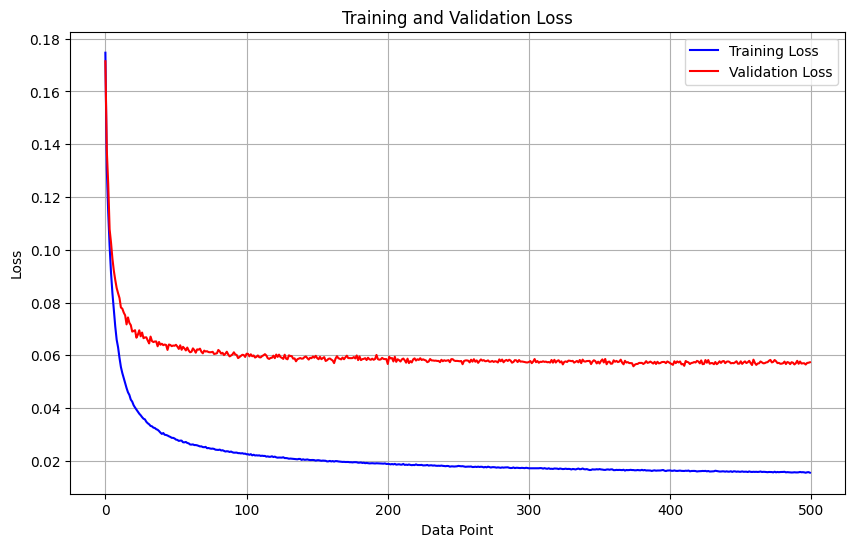

In [10]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(loss_train))
plt.figure(figsize=(10, 6))
plt.plot(x, loss_train, label='Training Loss', color='blue')
plt.plot(x, loss_valid, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Data Point')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### esm2 2560 + MolFormer
add the additional seqeunces add 2

In [11]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_2560')

In [12]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enzy_refine_layer_1 = nn.Linear(2560, 2560) # W1 and b
        self.smiles_refine_layer_1 = nn.Linear(768, 768) # W1 and b
        self.enzy_refine_layer_2 = nn.Linear(2560, 128) # W1 and b
        self.smiles_refine_layer_2 = nn.Linear(768, 128) # W1 and b

        self.relu = nn.ReLU()
        self.batch_norm_enzy = nn.BatchNorm1d(2560)
        self.batch_norm_smiles = nn.BatchNorm1d(768)
        self.batch_norm_shared = nn.BatchNorm1d(128)

    def forward(self, enzy_embed, smiles_embed):
        refined_enzy_embed = self.enzy_refine_layer_1(enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_1(smiles_embed)

        refined_enzy_embed = self.batch_norm_enzy(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_smiles(refined_smiles_embed)

        refined_enzy_embed = self.relu(refined_enzy_embed)
        refined_smiles_embed = self.relu(refined_smiles_embed)

        refined_enzy_embed = self.enzy_refine_layer_2(refined_enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_2(refined_smiles_embed)

        refined_enzy_embed = self.batch_norm_shared(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_shared(refined_smiles_embed)
        refined_enzy_embed = torch.nn.functional.normalize(refined_enzy_embed, dim=1)
        refined_smiles_embed = torch.nn.functional.normalize(refined_smiles_embed, dim=1)

        return refined_enzy_embed, refined_smiles_embed


In [13]:
def get_ds():
    # Load the saved embeddings_results
    ESP_train_df_enzy = torch.load('ESP_train_df_enzy_esm2_2560.pt')
    ESP_val_df_enzy = torch.load('ESP_val_df_enzy_esm2_2560.pt')
    ESP_test_df_enzy = torch.load('ESP_test_df_enzy_esm2_2560.pt')
    print(ESP_train_df_enzy.shape, ESP_val_df_enzy.shape, ESP_test_df_enzy.shape)
    # Load the saved embeddings_results
    ESP_train_df_smiles = torch.load('ESP_train_df_smiles_esm2_2560.pt')
    ESP_val_df_smiles = torch.load('ESP_val_df_smiles_esm2_2560.pt')
    ESP_test_df_smiles = torch.load('ESP_test_df_smiles_esm2_2560.pt')
    print(ESP_train_df_smiles.shape, ESP_val_df_smiles.shape, ESP_test_df_smiles.shape)

    y_train = torch.load( 'ESP_train_df_label_esm2_2560.pt')
    y_val = torch.load('ESP_val_df_label_esm2_2560.pt')
    y_test = torch.load('ESP_test_df_label_esm2_2560.pt')
    print(y_train.shape,y_val.shape, y_test.shape)
    ESP_train_df_enzy_add = torch.load('ESP_train_df_enzy_>2800_<5500.pt')
    ESP_train_df_smiles_add = torch.load('ESP_train_df_smiles_>2800_<5500.pt')
    y_train_add = torch.load('ESP_train_df_label_>2800_<5500.pt')

    ESP_val_df_enzy_add = torch.load('ESP_val_df_enzy_>2800_<8000.pt')
    ESP_test_df_enzy_add = torch.load('ESP_test_df_enzy_>2800_<8000.pt')
    ESP_val_df_smiles_add = torch.load('ESP_val_df_smiles_>2800_<8000.pt')
    ESP_test_df_smiles_add = torch.load('ESP_test_df_smiles_>2800_<8000.pt')
    y_val_add = torch.load('ESP_val_df_label_>2800_<8000.pt')
    y_test_add = torch.load('ESP_test_df_label_>2800_<8000.pt')
    print(ESP_val_df_enzy_add.shape, ESP_val_df_smiles_add.shape, y_val_add.shape)
    print(ESP_test_df_enzy_add.shape, ESP_test_df_smiles_add.shape, y_test_add.shape)

    ESP_train_df_enzy = torch.cat([ESP_train_df_enzy, ESP_train_df_enzy_add], dim=0)
    ESP_train_df_smiles = torch.cat([ESP_train_df_smiles, ESP_train_df_smiles_add], dim=0)
    y_train = torch.cat([y_train, y_train_add], dim=0)
    print(ESP_train_df_enzy.shape, ESP_train_df_smiles.shape, y_train.shape)

    ESP_val_df_enzy = torch.cat([ESP_val_df_enzy, ESP_val_df_enzy_add], dim=0)
    ESP_val_df_smiles = torch.cat([ESP_val_df_smiles, ESP_val_df_smiles_add], dim=0)
    y_val = torch.cat([y_val, y_val_add], dim=0)
    print(ESP_val_df_enzy.shape, ESP_val_df_smiles.shape, y_val.shape)
    ESP_test_df_enzy = torch.cat([ESP_test_df_enzy, ESP_test_df_enzy_add], dim=0)
    ESP_test_df_smiles = torch.cat([ESP_test_df_smiles, ESP_test_df_smiles_add], dim=0)
    y_test = torch.cat([y_test, y_test_add], dim=0)
    print(ESP_test_df_enzy.shape, ESP_test_df_smiles.shape, y_test.shape)

    train_tensor_dataset = TensorDataset(ESP_train_df_enzy,ESP_train_df_smiles, y_train)
    val_tensor_dataset = TensorDataset(ESP_val_df_enzy,ESP_val_df_smiles, y_val)
    test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)

    # Create TensorDataset and DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
    print(len(train_loader))
    return train_loader,  val_loader, test_loader

In [14]:
# design the model, optimizer and loss function
model = Contrastive_learning_layer().to(device)
train_loader,  val_loader, test_loader = get_ds()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-03)
loss_fn = nn.MSELoss().to(device)

torch.Size([49881, 2560]) torch.Size([5399, 2560]) torch.Size([13312, 2560])
torch.Size([49881, 768]) torch.Size([5399, 768]) torch.Size([13312, 768])
torch.Size([49881, 1]) torch.Size([5399, 1]) torch.Size([13312, 1])
torch.Size([23, 2560]) torch.Size([23, 768]) torch.Size([23, 1])
torch.Size([24, 2560]) torch.Size([24, 768]) torch.Size([24, 1])
torch.Size([50061, 2560]) torch.Size([50061, 768]) torch.Size([50061, 1])
torch.Size([5422, 2560]) torch.Size([5422, 768]) torch.Size([5422, 1])
torch.Size([13336, 2560]) torch.Size([13336, 768]) torch.Size([13336, 1])
3129


In [15]:
initial_epoch = 0
best_epoch = -1
best_accuracy = 0.5
loss_train = []
loss_valid = []
for epoch in range(initial_epoch, 500):
    torch.cuda.empty_cache()
    model.train()

    with tqdm(train_loader, desc='Processing', unit="batch") as tepoch:
        num_batch = len(train_loader)
        loss_sum = 0
        for ESP_train_df_enzy,ESP_train_df_smiles, y_train in tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            ESP_train_df_enzy = ESP_train_df_enzy.to(device)
            ESP_train_df_smiles = ESP_train_df_smiles.to(device)
            y_train = y_train.squeeze(1).to(device)
            refined_enzy_embed, refined_smiles_embed = model(ESP_train_df_enzy,ESP_train_df_smiles)
            cosine_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
            loss = loss_fn(cosine_sim, y_train)
            loss_sum = loss_sum + loss.detach().cpu().numpy()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True) #
            tepoch.set_postfix(train_loss=loss)
            # tepoch.set_postfix(val_loss=loss_sum_val, val_accuracy=100. * acc_val, balanced_val_accuracy=100. * bacc_val)
        loss_sum = loss_sum/num_batch
        loss_train.append(loss_sum)
        loss_sum_val,acc_val, bacc_val = run_validation(model,val_loader,loss_fn, device)
        loss_valid.append(loss_sum_val)
        print('Epoch: %d / %d, ############## the best accuracy in val  %.4f at Epoch: %d  ##############'  % (epoch, 500,100 * best_accuracy,best_epoch))
        # print('Performance in Train: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum, 100 * acc))
        print('Performance in Val: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum_val, 100 * acc_val))
        # checkpoint(model, f"epoch-{epoch}.pth")
        if acc_val > best_accuracy: # compare the performance updates at the val set
            best_accuracy = acc_val
            best_epoch = epoch
            torch.save(model, "best_model_11.pt")

Epoch 0: 100%|██████████| 3129/3129 [00:29<00:00, 105.42batch/s, train_loss=tensor(0.1348, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.15947558387157929 ACC=  0.7971228329029878 bacc=  0.6658571933601127 precision=  0.7124518613607189 specificity=  0.9438737158606866 sensitivity=  0.38784067085953877 recall=  0.38784067085953877 MCC=  0.4168280318335208 AUC=  0.787698947369527 f1=  0.502262443438914
Epoch: 0 / 500, ############## the best accuracy in val  50.0000 at Epoch: -1  ##############
Performance in Val: Loss: (0.1595); Accuracy (79.71)


Epoch 1: 100%|██████████| 3129/3129 [00:29<00:00, 106.43batch/s, train_loss=tensor(0.1128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.1288968713591452 ACC=  0.83327185540391 bacc=  0.7394956261651608 precision=  0.7580803134182175 specificity=  0.9381107491856677 sensitivity=  0.5408805031446541 recall=  0.5408805031446541 MCC=  0.5400073954273966 AUC=  0.8643018594773251 f1=  0.6313213703099511
Epoch: 1 / 500, ############## the best accuracy in val  79.7123 at Epoch: 0  ##############
Performance in Val: Loss: (0.1289); Accuracy (83.33)


Epoch 2: 100%|██████████| 3129/3129 [00:29<00:00, 106.16batch/s, train_loss=tensor(0.0783, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.11399154638964958 ACC=  0.8533751383253412 bacc=  0.7744431434739345 precision=  0.7885662431941923 specificity=  0.9416186419443748 sensitivity=  0.6072676450034941 recall=  0.6072676450034941 MCC=  0.6011881212496804 AUC=  0.9066024866221535 f1=  0.6861429135412555
Epoch: 2 / 500, ############## the best accuracy in val  83.3272 at Epoch: 1  ##############
Performance in Val: Loss: (0.1140); Accuracy (85.34)


Epoch 3: 100%|██████████| 3129/3129 [00:29<00:00, 106.75batch/s, train_loss=tensor(0.1272, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.10635164824855627 ACC=  0.866469937292512 bacc=  0.8050781974326932 precision=  0.7885714285714286 specificity=  0.9351039839639188 sensitivity=  0.6750524109014675 recall=  0.6750524109014675 MCC=  0.6430789872675972 AUC=  0.9158808752257218 f1=  0.7274096385542169
Epoch: 3 / 500, ############## the best accuracy in val  85.3375 at Epoch: 2  ##############
Performance in Val: Loss: (0.1064); Accuracy (86.65)


Epoch 4: 100%|██████████| 3129/3129 [00:29<00:00, 106.83batch/s, train_loss=tensor(0.1213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09938699525992516 ACC=  0.8780892659535227 bacc=  0.83672811344743 precision=  0.7802037845705968 specificity=  0.9243297419193185 sensitivity=  0.7491264849755416 recall=  0.7491264849755416 MCC=  0.6824273678691244 AUC=  0.9292686146905309 f1=  0.7643493761140819
Epoch: 4 / 500, ############## the best accuracy in val  86.6470 at Epoch: 3  ##############
Performance in Val: Loss: (0.0994); Accuracy (87.81)


Epoch 5: 100%|██████████| 3129/3129 [00:29<00:00, 106.63batch/s, train_loss=tensor(0.1055, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09268343080299464 ACC=  0.8869420877904832 bacc=  0.8512583606615933 precision=  0.7917261055634808 specificity=  0.9268353796041092 sensitivity=  0.7756813417190775 recall=  0.7756813417190775 MCC=  0.7071805592651464 AUC=  0.9382388326214766 f1=  0.7836216025414754
Epoch: 5 / 500, ############## the best accuracy in val  87.8089 at Epoch: 4  ##############
Performance in Val: Loss: (0.0927); Accuracy (88.69)


Epoch 6: 100%|██████████| 3129/3129 [00:29<00:00, 107.58batch/s, train_loss=tensor(0.0539, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08897426433773344 ACC=  0.8987458502397639 bacc=  0.8680172421491332 precision=  0.8114406779661016 specificity=  0.9330994738160862 sensitivity=  0.8029350104821803 recall=  0.8029350104821803 MCC=  0.738536125636722 AUC=  0.9446971093766005 f1=  0.8071654373024236
Epoch: 6 / 500, ############## the best accuracy in val  88.6942 at Epoch: 5  ##############
Performance in Val: Loss: (0.0890); Accuracy (89.87)


Epoch 7: 100%|██████████| 3129/3129 [00:29<00:00, 106.78batch/s, train_loss=tensor(0.0771, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08476491375746628 ACC=  0.9048321652526743 bacc=  0.8741686614589326 precision=  0.8265524625267666 specificity=  0.9391130042595841 sensitivity=  0.8092243186582809 recall=  0.8092243186582809 MCC=  0.7534804397000341 AUC=  0.9471272802659932 f1=  0.8177966101694916
Epoch: 7 / 500, ############## the best accuracy in val  89.8746 at Epoch: 6  ##############
Performance in Val: Loss: (0.0848); Accuracy (90.48)


Epoch 8: 100%|██████████| 3129/3129 [00:29<00:00, 105.47batch/s, train_loss=tensor(0.0790, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08234926280744131 ACC=  0.9057543341940243 bacc=  0.8819670428975328 precision=  0.815068493150685 specificity=  0.932347782510649 sensitivity=  0.8315863032844165 recall=  0.8315863032844165 MCC=  0.7590718839172419 AUC=  0.9534736700553182 f1=  0.8232445520581114
Epoch: 8 / 500, ############## the best accuracy in val  90.4832 at Epoch: 7  ##############
Performance in Val: Loss: (0.0823); Accuracy (90.58)


Epoch 9: 100%|██████████| 3129/3129 [00:29<00:00, 105.94batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07988473383440556 ACC=  0.9123939505717448 bacc=  0.8873736872323315 precision=  0.8337988826815642 specificity=  0.9403658231019795 sensitivity=  0.8343815513626834 recall=  0.8343815513626834 MCC=  0.7745738610226633 AUC=  0.9558866814413494 f1=  0.8340901152637095
Epoch: 9 / 500, ############## the best accuracy in val  90.5754 at Epoch: 8  ##############
Performance in Val: Loss: (0.0799); Accuracy (91.24)


Epoch 10: 100%|██████████| 3129/3129 [00:29<00:00, 106.36batch/s, train_loss=tensor(0.0424, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07771974106135182 ACC=  0.9151604573957949 bacc=  0.8863393018638548 precision=  0.8490294751976994 specificity=  0.9473816086193937 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.779811441714326 AUC=  0.9551876943248095 f1=  0.8369950389794473
Epoch: 10 / 500, ############## the best accuracy in val  91.2394 at Epoch: 9  ##############
Performance in Val: Loss: (0.0777); Accuracy (91.52)


Epoch 11: 100%|██████████| 3129/3129 [00:29<00:00, 104.77batch/s, train_loss=tensor(0.0465, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07636216758945436 ACC=  0.9195868683142752 bacc=  0.8931561772198487 precision=  0.8551034975017845 specificity=  0.9491355549987471 sensitivity=  0.8371767994409504 recall=  0.8371767994409504 MCC=  0.7917164631782236 AUC=  0.955687070892037 f1=  0.846045197740113
Epoch: 11 / 500, ############## the best accuracy in val  91.5160 at Epoch: 10  ##############
Performance in Val: Loss: (0.0764); Accuracy (91.96)


Epoch 12: 100%|██████████| 3129/3129 [00:29<00:00, 105.63batch/s, train_loss=tensor(0.0721, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07375129912554075 ACC=  0.9184802655846551 bacc=  0.8937492306676745 precision=  0.8484848484848485 specificity=  0.9461287897769982 sensitivity=  0.8413696715583509 recall=  0.8413696715583509 MCC=  0.7896350218620415 AUC=  0.9578110847239972 f1=  0.8449122807017544
Epoch: 12 / 500, ############## the best accuracy in val  91.9587 at Epoch: 11  ##############
Performance in Val: Loss: (0.0738); Accuracy (91.85)


Epoch 13: 100%|██████████| 3129/3129 [00:29<00:00, 105.88batch/s, train_loss=tensor(0.0480, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07149606928295266 ACC=  0.9197713021025452 bacc=  0.8944020797318075 precision=  0.8531914893617021 specificity=  0.9481332999248309 sensitivity=  0.8406708595387841 recall=  0.8406708595387841 MCC=  0.7925740600115009 AUC=  0.9607883461057821 f1=  0.8468848996832101
Epoch: 13 / 500, ############## the best accuracy in val  91.9587 at Epoch: 11  ##############
Performance in Val: Loss: (0.0715); Accuracy (91.98)


Epoch 14: 100%|██████████| 3129/3129 [00:29<00:00, 106.01batch/s, train_loss=tensor(0.0425, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07331770753273659 ACC=  0.9212467724087052 bacc=  0.8940595900524608 precision=  0.8611510791366906 specificity=  0.951641192683538 sensitivity=  0.8364779874213837 recall=  0.8364779874213837 MCC=  0.7955819397623455 AUC=  0.9569694811228828 f1=  0.84863523573201
Epoch: 14 / 500, ############## the best accuracy in val  91.9771 at Epoch: 13  ##############
Performance in Val: Loss: (0.0733); Accuracy (92.12)


Epoch 15: 100%|██████████| 3129/3129 [00:29<00:00, 106.23batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07200469869768637 ACC=  0.9256731833271855 bacc=  0.9024453342872616 precision=  0.8635077793493635 specificity=  0.951641192683538 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8079956302915182 AUC=  0.9580004521003844 f1=  0.8583479789103692
Epoch: 15 / 500, ############## the best accuracy in val  92.1247 at Epoch: 14  ##############
Performance in Val: Loss: (0.0720); Accuracy (92.57)


Epoch 16: 100%|██████████| 3129/3129 [00:29<00:00, 107.06batch/s, train_loss=tensor(0.0461, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07032557938160007 ACC=  0.9264109184802656 bacc=  0.9007052205687816 precision=  0.8712230215827338 specificity=  0.9551490854422451 sensitivity=  0.8462613556953179 recall=  0.8462613556953179 MCC=  0.8089990567430905 AUC=  0.9621346667318027 f1=  0.8585607940446649
Epoch: 16 / 500, ############## the best accuracy in val  92.5673 at Epoch: 15  ##############
Performance in Val: Loss: (0.0703); Accuracy (92.64)


Epoch 17: 100%|██████████| 3129/3129 [00:29<00:00, 107.07batch/s, train_loss=tensor(0.0424, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07034677296195586 ACC=  0.9256731833271855 bacc=  0.8961698587720344 precision=  0.8784977908689249 specificity=  0.9586569782009522 sensitivity=  0.8336827393431167 recall=  0.8336827393431167 MCC=  0.8060191727499629 AUC=  0.957375706100431 f1=  0.8555037647902475
Epoch: 17 / 500, ############## the best accuracy in val  92.6411 at Epoch: 16  ##############
Performance in Val: Loss: (0.0703); Accuracy (92.57)


Epoch 18: 100%|██████████| 3129/3129 [00:32<00:00, 97.00batch/s, train_loss=tensor(0.0445, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07125458611961136 ACC=  0.9264109184802656 bacc=  0.8980157310622556 precision=  0.8777452415812591 specificity=  0.958155850663994 sensitivity=  0.8378756114605171 recall=  0.8378756114605171 MCC=  0.8081958032729146 AUC=  0.957800666454099 f1=  0.857347157668931
Epoch: 18 / 500, ############## the best accuracy in val  92.6411 at Epoch: 16  ##############
Performance in Val: Loss: (0.0713); Accuracy (92.64)


Epoch 19: 100%|██████████| 3129/3129 [00:29<00:00, 106.44batch/s, train_loss=tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0695159935576506 ACC=  0.9282552563629657 bacc=  0.9046475289177028 precision=  0.8710826210826211 specificity=  0.9546479579052869 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8142899016164564 AUC=  0.959728484127722 f1=  0.8627865961199294
Epoch: 19 / 500, ############## the best accuracy in val  92.6411 at Epoch: 16  ##############
Performance in Val: Loss: (0.0695); Accuracy (92.83)


Epoch 20: 100%|██████████| 3129/3129 [00:28<00:00, 111.13batch/s, train_loss=tensor(0.0585, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06906670734703893 ACC=  0.9271486536333456 bacc=  0.900758099854652 precision=  0.8748191027496383 specificity=  0.9566524680531195 sensitivity=  0.8448637316561844 recall=  0.8448637316561844 MCC=  0.8106404694467019 AUC=  0.9600949620923808 f1=  0.859580519018841
Epoch: 20 / 500, ############## the best accuracy in val  92.8255 at Epoch: 19  ##############
Performance in Val: Loss: (0.0691); Accuracy (92.71)


Epoch 21: 100%|██████████| 3129/3129 [00:28<00:00, 110.01batch/s, train_loss=tensor(0.0348, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06869006887968399 ACC=  0.9289929915160458 bacc=  0.901338546320416 precision=  0.8828696925329429 specificity=  0.9599097970433476 sensitivity=  0.8427672955974843 recall=  0.8427672955974843 MCC=  0.8149429872084067 AUC=  0.9590449055448134 f1=  0.8623525205577405
Epoch: 21 / 500, ############## the best accuracy in val  92.8255 at Epoch: 19  ##############
Performance in Val: Loss: (0.0687); Accuracy (92.90)


Epoch 22: 100%|██████████| 3129/3129 [00:28<00:00, 111.50batch/s, train_loss=tensor(0.0787, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06707251151463231 ACC=  0.9291774253043158 bacc=  0.9028085729579185 precision=  0.8801742919389978 specificity=  0.9586569782009522 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8157613939105193 AUC=  0.9590790494545641 f1=  0.8632478632478633
Epoch: 22 / 500, ############## the best accuracy in val  92.8993 at Epoch: 21  ##############
Performance in Val: Loss: (0.0671); Accuracy (92.92)


Epoch 23: 100%|██████████| 3129/3129 [00:27<00:00, 111.78batch/s, train_loss=tensor(0.0326, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0661473788079259 ACC=  0.933234968646256 bacc=  0.909823132796521 precision=  0.8837042354630295 specificity=  0.9594086695063894 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8268237698263526 AUC=  0.9624773315081225 f1=  0.871813031161473
Epoch: 23 / 500, ############## the best accuracy in val  92.9177 at Epoch: 22  ##############
Performance in Val: Loss: (0.0661); Accuracy (93.32)


Epoch 24: 100%|██████████| 3129/3129 [00:28<00:00, 109.52batch/s, train_loss=tensor(0.0405, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06797024015897671 ACC=  0.9295462928808558 bacc=  0.9046280056052043 precision=  0.8776097912167027 specificity=  0.9574041593585567 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8171116094410316 AUC=  0.9583460935252467 f1=  0.8645390070921986
Epoch: 24 / 500, ############## the best accuracy in val  93.3235 at Epoch: 23  ##############
Performance in Val: Loss: (0.0680); Accuracy (92.95)


Epoch 25: 100%|██████████| 3129/3129 [00:28<00:00, 110.66batch/s, train_loss=tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06731078477032416 ACC=  0.9282552563629657 bacc=  0.9017339152856331 precision=  0.8780841799709724 specificity=  0.9579052868955149 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.8133903049177744 AUC=  0.9594644378923157 f1=  0.8615165539337843
Epoch: 25 / 500, ############## the best accuracy in val  93.3235 at Epoch: 23  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.83)


Epoch 26: 100%|██████████| 3129/3129 [00:28<00:00, 109.65batch/s, train_loss=tensor(0.0362, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06560407656967464 ACC=  0.9372925119881962 bacc=  0.9123552101242471 precision=  0.8984660336011687 specificity=  0.9651716361814082 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8367045617016718 AUC=  0.9596652741204398 f1=  0.8785714285714287
Epoch: 26 / 500, ############## the best accuracy in val  93.3235 at Epoch: 23  ##############
Performance in Val: Loss: (0.0656); Accuracy (93.73)


Epoch 27: 100%|██████████| 3129/3129 [00:28<00:00, 110.51batch/s, train_loss=tensor(0.0925, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06645811328549037 ACC=  0.932681667281446 bacc=  0.9078784182649956 precision=  0.8856729377713459 specificity=  0.9604109245803056 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8250432182891191 AUC=  0.9600728998737725 f1=  0.8702452897262709
Epoch: 27 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0665); Accuracy (93.27)


Epoch 28: 100%|██████████| 3129/3129 [00:28<00:00, 111.13batch/s, train_loss=tensor(0.0535, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06620550743004741 ACC=  0.933050534857986 bacc=  0.9058877407780364 precision=  0.8926470588235295 specificity=  0.9634176898020547 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8253861878146374 AUC=  0.9586533887130041 f1=  0.869939089931924
Epoch: 28 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0662); Accuracy (93.31)


Epoch 29: 100%|██████████| 3129/3129 [00:28<00:00, 110.82batch/s, train_loss=tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06426937507388558 ACC=  0.9345260051641461 bacc=  0.9071141199774966 precision=  0.8973412112259971 specificity=  0.9651716361814082 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8291002334952685 AUC=  0.9616517492800452 f1=  0.8725314183123878
Epoch: 29 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0643); Accuracy (93.45)


Epoch 30: 100%|██████████| 3129/3129 [00:27<00:00, 112.12batch/s, train_loss=tensor(0.0731, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06462491104368308 ACC=  0.934341571375876 bacc=  0.9092300793486953 precision=  0.8909090909090909 specificity=  0.9624154347281383 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8291636850552786 AUC=  0.9607379181775346 f1=  0.8731290092658588
Epoch: 30 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0646); Accuracy (93.43)


Epoch 31: 100%|██████████| 3129/3129 [00:28<00:00, 111.23batch/s, train_loss=tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06420637127341686 ACC=  0.933788270011066 bacc=  0.9088542336959766 precision=  0.8889695210449927 specificity=  0.9616637434227011 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8278068073402378 AUC=  0.9624423121135062 f1=  0.872196511213955
Epoch: 31 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0642); Accuracy (93.38)


Epoch 32: 100%|██████████| 3129/3129 [00:28<00:00, 109.56batch/s, train_loss=tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06463343401475202 ACC=  0.9356326078937661 bacc=  0.9085381836595652 precision=  0.8995568685376661 specificity=  0.9659233274868454 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8320003823070576 AUC=  0.9624787322839069 f1=  0.874685816876122
Epoch: 32 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0646); Accuracy (93.56)


Epoch 33: 100%|██████████| 3129/3129 [00:28<00:00, 111.65batch/s, train_loss=tensor(0.0390, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06400623799447289 ACC=  0.932128365916636 bacc=  0.9045889589802072 precision=  0.8910963944076526 specificity=  0.9629165622650965 sensitivity=  0.8462613556953179 recall=  0.8462613556953179 MCC=  0.8229464267055544 AUC=  0.9603206620906823 f1=  0.868100358422939
Epoch: 33 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0640); Accuracy (93.21)


Epoch 34: 100%|██████████| 3129/3129 [00:28<00:00, 111.12batch/s, train_loss=tensor(0.0373, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06412366721614272 ACC=  0.9339727037993361 bacc=  0.9083071432035847 precision=  0.8913202042304887 specificity=  0.9626659984966174 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8280905055573821 AUC=  0.9603245142240902 f1=  0.8722341184867951
Epoch: 34 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0641); Accuracy (93.40)


Epoch 35: 100%|██████████| 3129/3129 [00:28<00:00, 109.79batch/s, train_loss=tensor(0.0447, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0647163967530526 ACC=  0.932866101069716 bacc=  0.90419359001499 precision=  0.8960653303637713 specificity=  0.9649210724129291 sensitivity=  0.843466107617051 recall=  0.843466107617051 MCC=  0.8245794247897011 AUC=  0.9608578596040953 f1=  0.8689704823614112
Epoch: 35 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0647); Accuracy (93.29)


Epoch 36: 100%|██████████| 3129/3129 [00:28<00:00, 111.15batch/s, train_loss=tensor(0.0371, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06399288567217139 ACC=  0.9372925119881962 bacc=  0.9103380929943525 precision=  0.9037749814951888 specificity=  0.9674267100977199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8362849602760767 AUC=  0.9585849257965292 f1=  0.8777857656362329
Epoch: 36 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0640); Accuracy (93.73)


Epoch 37: 100%|██████████| 3129/3129 [00:28<00:00, 111.09batch/s, train_loss=tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06412375086484405 ACC=  0.9319439321283659 bacc=  0.9031189323427047 precision=  0.8939169139465876 specificity=  0.9641693811074918 sensitivity=  0.8420684835779175 recall=  0.8420684835779175 MCC=  0.8221828492127103 AUC=  0.9611982481197651 f1=  0.8672184238934869
Epoch: 37 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0641); Accuracy (93.19)


Epoch 38: 100%|██████████| 3129/3129 [00:28<00:00, 109.98batch/s, train_loss=tensor(0.0472, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06375719961685548 ACC=  0.9369236444116562 bacc=  0.9116563981046804 precision=  0.8983174835405998 specificity=  0.9651716361814082 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.83569125897973 AUC=  0.9609009334594731 f1=  0.877769835596855
Epoch: 38 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0638); Accuracy (93.69)


Epoch 39: 100%|██████████| 3129/3129 [00:28<00:00, 110.70batch/s, train_loss=tensor(0.0358, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06406886984970542 ACC=  0.9367392106233862 bacc=  0.9104104955927217 precision=  0.9005891016200295 specificity=  0.9661738912553245 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8349921651558486 AUC=  0.9589853725739658 f1=  0.8770168519182503
Epoch: 39 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0641); Accuracy (93.67)


Epoch 40: 100%|██████████| 3129/3129 [00:28<00:00, 111.21batch/s, train_loss=tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06351307429686452 ACC=  0.9387679822943563 bacc=  0.9104438515660935 precision=  0.9116104868913858 specificity=  0.9704334753194688 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8398495214059091 AUC=  0.9596610717930858 f1=  0.8799710773680405
Epoch: 40 / 500, ############## the best accuracy in val  93.7293 at Epoch: 26  ##############
Performance in Val: Loss: (0.0635); Accuracy (93.88)


Epoch 41: 100%|██████████| 3129/3129 [00:28<00:00, 111.31batch/s, train_loss=tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.062368187410509694 ACC=  0.9391368498708963 bacc=  0.9149527737199055 precision=  0.9015317286652079 specificity=  0.9661738912553245 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.841568554192117 AUC=  0.9615936170849821 f1=  0.8822269807280513
Epoch: 41 / 500, ############## the best accuracy in val  93.8768 at Epoch: 40  ##############
Performance in Val: Loss: (0.0624); Accuracy (93.91)


Epoch 42: 100%|██████████| 3129/3129 [00:27<00:00, 112.29batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06265807229679375 ACC=  0.9358170416820362 bacc=  0.9102323344226115 precision=  0.8961228968544257 specificity=  0.9644199448759709 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8328003101767608 AUC=  0.961861340356823 f1=  0.8756254467476768
Epoch: 42 / 500, ############## the best accuracy in val  93.9137 at Epoch: 41  ##############
Performance in Val: Loss: (0.0627); Accuracy (93.58)


Epoch 43: 100%|██████████| 3129/3129 [00:28<00:00, 110.99batch/s, train_loss=tensor(0.0440, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06336230890561653 ACC=  0.9347104389524161 bacc=  0.9081358983639114 precision=  0.8956649522409993 specificity=  0.9644199448759709 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8297550700060237 AUC=  0.9598902737308489 f1=  0.8732091690544413
Epoch: 43 / 500, ############## the best accuracy in val  93.9137 at Epoch: 41  ##############
Performance in Val: Loss: (0.0634); Accuracy (93.47)


Epoch 44: 100%|██████████| 3129/3129 [00:27<00:00, 112.55batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0632587537996383 ACC=  0.9402434526005164 bacc=  0.9145838443976235 precision=  0.9084870848708487 specificity=  0.9689300927085943 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.844104697247387 AUC=  0.9610487153047537 f1=  0.8837042354630295
Epoch: 44 / 500, ############## the best accuracy in val  93.9137 at Epoch: 41  ##############
Performance in Val: Loss: (0.0633); Accuracy (94.02)


Epoch 45: 100%|██████████| 3129/3129 [00:28<00:00, 108.11batch/s, train_loss=tensor(0.0397, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06432835751825773 ACC=  0.9361859092585761 bacc=  0.9102587740655469 precision=  0.8980190755685987 specificity=  0.9651716361814082 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8336641016831582 AUC=  0.9590911311457067 f1=  0.8761632068718683
Epoch: 45 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0643); Accuracy (93.62)


Epoch 46: 100%|██████████| 3129/3129 [00:29<00:00, 106.01batch/s, train_loss=tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06266492665374437 ACC=  0.9363703430468462 bacc=  0.9106081800753303 precision=  0.8980938416422287 specificity=  0.9651716361814082 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8341709606188782 AUC=  0.9616202318248903 f1=  0.8765652951699463
Epoch: 46 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0627); Accuracy (93.64)


Epoch 47: 100%|██████████| 3129/3129 [00:29<00:00, 107.58batch/s, train_loss=tensor(0.0508, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06307408181335063 ACC=  0.9350793065289561 bacc=  0.9113000757644603 precision=  0.8895306859205776 specificity=  0.9616637434227011 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8313716378967168 AUC=  0.9588253339405696 f1=  0.875
Epoch: 47 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0631); Accuracy (93.51)


Epoch 48: 100%|██████████| 3129/3129 [00:28<00:00, 108.97batch/s, train_loss=tensor(0.0336, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0623609158025016 ACC=  0.9376613795647363 bacc=  0.9123816497671823 precision=  0.9003663003663004 specificity=  0.9659233274868454 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8375701257249362 AUC=  0.9602145533249952 f1=  0.8791130185979971
Epoch: 48 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0624); Accuracy (93.77)


Epoch 49: 100%|██████████| 3129/3129 [00:28<00:00, 109.67batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06180750996500781 ACC=  0.9378458133530063 bacc=  0.912282807525878 precision=  0.9016152716593245 specificity=  0.9664244550238036 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8379813066311439 AUC=  0.9621343165378565 f1=  0.8793412101682779
Epoch: 49 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.78)


Epoch 50: 100%|██████████| 3129/3129 [00:28<00:00, 110.56batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06254286351023039 ACC=  0.9374769457764662 bacc=  0.9097910025019607 precision=  0.90625 specificity=  0.9684289651716362 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8366230967383698 AUC=  0.9594450021283037 f1=  0.8778378378378378
Epoch: 50 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0625); Accuracy (93.75)


Epoch 51: 100%|██████████| 3129/3129 [00:28<00:00, 111.26batch/s, train_loss=tensor(0.0426, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.062095329500624914 ACC=  0.9376613795647363 bacc=  0.9103645326372878 precision=  0.9057164068299925 specificity=  0.9681784014031571 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8371685218056035 AUC=  0.962785151986799 f1=  0.8783297336213104
Epoch: 51 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0621); Accuracy (93.77)


Epoch 52: 100%|██████████| 3129/3129 [00:27<00:00, 112.56batch/s, train_loss=tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06167331517187763 ACC=  0.9372925119881962 bacc=  0.912579334249791 precision=  0.8978847556528081 specificity=  0.9649210724129291 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8367549653939974 AUC=  0.9629399377110026 f1=  0.8786581013561742
Epoch: 52 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0617); Accuracy (93.73)


Epoch 53: 100%|██████████| 3129/3129 [00:27<00:00, 112.34batch/s, train_loss=tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06434482101702672 ACC=  0.9354481741054961 bacc=  0.9099817706541324 precision=  0.8948137326515705 specificity=  0.9639188173390127 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8318886467264027 AUC=  0.9596365582168545 f1=  0.875
Epoch: 53 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0643); Accuracy (93.54)


Epoch 54: 100%|██████████| 3129/3129 [00:28<00:00, 109.98batch/s, train_loss=tensor(0.0357, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.062141983896208196 ACC=  0.9383991147178163 bacc=  0.9131069014296843 precision=  0.9024211298606016 specificity=  0.9666750187922827 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8394516233416798 AUC=  0.9614461854336478 f1=  0.8804581245526127
Epoch: 54 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0621); Accuracy (93.84)


Epoch 55: 100%|██████████| 3129/3129 [00:28<00:00, 109.93batch/s, train_loss=tensor(0.0397, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.062089420513697736 ACC=  0.9372925119881962 bacc=  0.9119069618731594 precision=  0.8996336996336997 specificity=  0.9656727637183663 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8366060081428339 AUC=  0.9611245322940979 f1=  0.8783977110157369
Epoch: 55 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0621); Accuracy (93.73)


Epoch 56: 100%|██████████| 3129/3129 [00:28<00:00, 111.36batch/s, train_loss=tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06155296723608334 ACC=  0.9374769457764662 bacc=  0.9129287402595743 precision=  0.8979591836734694 specificity=  0.9649210724129291 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8372616908751741 AUC=  0.962761163701487 f1=  0.8790581519800215
Epoch: 56 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0616); Accuracy (93.75)


Epoch 57: 100%|██████████| 3129/3129 [00:27<00:00, 112.07batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06176758002061232 ACC=  0.9365547768351162 bacc=  0.9089404689552192 precision=  0.9034892353377877 specificity=  0.9674267100977199 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8342633455711644 AUC=  0.961828947416803 f1=  0.8761699064074875
Epoch: 57 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.66)


Epoch 58: 100%|██████████| 3129/3129 [00:27<00:00, 112.54batch/s, train_loss=tensor(0.0344, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06069528679555738 ACC=  0.9378458133530063 bacc=  0.913627552279141 precision=  0.8981077147016011 specificity=  0.9649210724129291 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8382750073645721 AUC=  0.9634095477928064 f1=  0.8798573975044564
Epoch: 58 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.78)


Epoch 59: 100%|██████████| 3129/3129 [00:27<00:00, 111.96batch/s, train_loss=tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06120791452576937 ACC=  0.9361859092585761 bacc=  0.9111552705677222 precision=  0.8956965718453683 specificity=  0.9641693811074918 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8338668121151256 AUC=  0.9618657177811502 f1=  0.8765167737330477
Epoch: 59 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0612); Accuracy (93.62)


Epoch 60: 100%|██████████| 3129/3129 [00:28<00:00, 110.63batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0612684339504678 ACC=  0.9374769457764662 bacc=  0.9091186301253291 precision=  0.9080717488789237 specificity=  0.9691806564770734 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.836505902065472 AUC=  0.9627086346095627 f1=  0.8775731310942577
Epoch: 60 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.75)


Epoch 61: 100%|██████████| 3129/3129 [00:27<00:00, 112.05batch/s, train_loss=tensor(0.0414, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06202180180176653 ACC=  0.9345260051641461 bacc=  0.9055452510986897 precision=  0.9014925373134328 specificity=  0.9669255825607617 sensitivity=  0.8441649196366178 recall=  0.8441649196366178 MCC=  0.8287835019617249 AUC=  0.9602861679869855 f1=  0.8718874052688559
Epoch: 61 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0620); Accuracy (93.45)


Epoch 62: 100%|██████████| 3129/3129 [00:28<00:00, 111.19batch/s, train_loss=tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061617814110190905 ACC=  0.9369236444116562 bacc=  0.9109840257280488 precision=  0.9000734753857458 specificity=  0.9659233274868454 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8355454161380093 AUC=  0.9610699020384965 f1=  0.8775071633237822
Epoch: 62 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0616); Accuracy (93.69)


Epoch 63: 100%|██████████| 3129/3129 [00:28<00:00, 110.50batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06017597931077303 ACC=  0.9393212836591663 bacc=  0.9135091867253382 precision=  0.9063421828908554 specificity=  0.9681784014031571 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8417096514147626 AUC=  0.9626370199475726 f1=  0.8819519196268388
Epoch: 63 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.93)


Epoch 64: 100%|██████████| 3129/3129 [00:28<00:00, 110.27batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05956230754208556 ACC=  0.9389524160826264 bacc=  0.9123621264546837 precision=  0.9074074074074074 specificity=  0.9686795289401152 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.840617986062439 AUC=  0.9640197607439941 f1=  0.8809780654440849
Epoch: 64 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.90)


Epoch 65: 100%|██████████| 3129/3129 [00:28<00:00, 110.38batch/s, train_loss=tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05990647716285622 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9631633614486542 f1=  0.8787661406025824
Epoch: 65 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.77)


Epoch 66: 100%|██████████| 3129/3129 [00:28<00:00, 109.42batch/s, train_loss=tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06042593657616031 ACC=  0.9398745850239764 bacc=  0.9141091565036006 precision=  0.9077490774907749 specificity=  0.9686795289401152 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8431382189668515 AUC=  0.9609674703092439 f1=  0.882986360373295
Epoch: 66 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.99)


Epoch 67: 100%|██████████| 3129/3129 [00:28<00:00, 110.95batch/s, train_loss=tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06050048982806965 ACC=  0.9372925119881962 bacc=  0.9114587136220718 precision=  0.9008082292432035 specificity=  0.9661738912553245 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8365104738266735 AUC=  0.9624671758836838 f1=  0.8782234957020058
Epoch: 67 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.73)


Epoch 68: 100%|██████████| 3129/3129 [00:28<00:00, 110.21batch/s, train_loss=tensor(0.0335, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061422270154690366 ACC=  0.9354481741054961 bacc=  0.907964653524238 precision=  0.9000740192450037 specificity=  0.9661738912553245 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.831447798513935 AUC=  0.960132082650674 f1=  0.8741912293314164
Epoch: 68 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0614); Accuracy (93.54)


Epoch 69: 100%|██████████| 3129/3129 [00:28<00:00, 110.00batch/s, train_loss=tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06097956346540236 ACC=  0.9383991147178163 bacc=  0.9115380325508775 precision=  0.9065974796145293 specificity=  0.9684289651716362 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8391458933849116 AUC=  0.9612341429992466 f1=  0.8798561151079137
Epoch: 69 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0610); Accuracy (93.84)


Epoch 70: 100%|██████████| 3129/3129 [00:28<00:00, 109.41batch/s, train_loss=tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06077228719368577 ACC=  0.9374769457764662 bacc=  0.9104633748785922 precision=  0.9044444444444445 specificity=  0.967677273866199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8367472990533049 AUC=  0.9619296281763247 f1=  0.8781014023732471
Epoch: 70 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0608); Accuracy (93.75)


Epoch 71: 100%|██████████| 3129/3129 [00:28<00:00, 108.31batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06096625597845312 ACC=  0.9358170416820362 bacc=  0.9095599620459802 precision=  0.8978692138133725 specificity=  0.9651716361814082 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8326502430720165 AUC=  0.9606363619331477 f1=  0.8753581661891118
Epoch: 71 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0610); Accuracy (93.58)


Epoch 72: 100%|██████████| 3129/3129 [00:28<00:00, 108.61batch/s, train_loss=tensor(0.0375, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061354748283823334 ACC=  0.9387679822943563 bacc=  0.9115644721938128 precision=  0.9085501858736059 specificity=  0.9691806564770734 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8400343713951637 AUC=  0.9596847098844519 f1=  0.8804034582132564
Epoch: 72 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0614); Accuracy (93.88)


Epoch 73: 100%|██████████| 3129/3129 [00:28<00:00, 109.68batch/s, train_loss=tensor(0.0396, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060926970137024965 ACC=  0.9383991147178163 bacc=  0.9128827773041404 precision=  0.9030124908155768 specificity=  0.9669255825607617 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8394056468926664 AUC=  0.9616417687525793 f1=  0.8803724928366761
Epoch: 73 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.84)


Epoch 74: 100%|██████████| 3129/3129 [00:28<00:00, 110.17batch/s, train_loss=tensor(0.0387, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061417725117146355 ACC=  0.9367392106233862 bacc=  0.9104104955927217 precision=  0.9005891016200295 specificity=  0.9661738912553245 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8349921651558486 AUC=  0.9612607577391549 f1=  0.8770168519182503
Epoch: 74 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0614); Accuracy (93.67)


Epoch 75: 100%|██████████| 3129/3129 [00:28<00:00, 109.55batch/s, train_loss=tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06070304534790878 ACC=  0.9369236444116562 bacc=  0.9118805222302242 precision=  0.8977355734112491 specificity=  0.9649210724129291 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.835741378706618 AUC=  0.962776572235118 f1=  0.8778571428571429
Epoch: 75 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.69)


Epoch 76: 100%|██████████| 3129/3129 [00:28<00:00, 109.82batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06060247234642989 ACC=  0.9360014754703062 bacc=  0.9096852439302197 precision=  0.8985294117647059 specificity=  0.9654221999498872 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.833108536471895 AUC=  0.9640716769965125 f1=  0.875671802221426
Epoch: 76 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.60)


Epoch 77: 100%|██████████| 3129/3129 [00:28<00:00, 110.96batch/s, train_loss=tensor(0.0445, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06125488422624217 ACC=  0.9372925119881962 bacc=  0.9116828377476156 precision=  0.9002201027146002 specificity=  0.9659233274868454 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8365578625124189 AUC=  0.9623419815479308 f1=  0.8783106657122406
Epoch: 77 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.73)


Epoch 78: 100%|██████████| 3129/3129 [00:28<00:00, 109.36batch/s, train_loss=tensor(0.0268, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06088639994956839 ACC=  0.9367392106233862 bacc=  0.909962247341634 precision=  0.9017725258493353 specificity=  0.9666750187922827 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8349005311188468 AUC=  0.9599811490598782 f1=  0.8768402154398564
Epoch: 78 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.67)


Epoch 79: 100%|██████████| 3129/3129 [00:28<00:00, 108.88batch/s, train_loss=tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06056389125382698 ACC=  0.9404278863887864 bacc=  0.9140367539052316 precision=  0.9109792284866469 specificity=  0.9699323477825107 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8444503363468624 AUC=  0.9598023750503624 f1=  0.8837711406980928
Epoch: 79 / 500, ############## the best accuracy in val  94.0243 at Epoch: 44  ##############
Performance in Val: Loss: (0.0606); Accuracy (94.04)


Epoch 80: 100%|██████████| 3129/3129 [00:28<00:00, 109.63batch/s, train_loss=tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060396150301229815 ACC=  0.9387679822943563 bacc=  0.9131333410726195 precision=  0.9043414275202355 specificity=  0.9674267100977199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8403259635299927 AUC=  0.9635310650921247 f1=  0.8810035842293906
Epoch: 80 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.88)


Epoch 81: 100%|██████████| 3129/3129 [00:28<00:00, 110.30batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06100540436188907 ACC=  0.9383991147178163 bacc=  0.9099691636720706 precision=  0.9108614232209737 specificity=  0.9701829115509897 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8388782158324642 AUC=  0.9623766507486008 f1=  0.8792480115690527
Epoch: 81 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0610); Accuracy (93.84)


Epoch 82: 100%|██████████| 3129/3129 [00:28<00:00, 111.21batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06103351184065319 ACC=  0.9363703430468462 bacc=  0.9106081800753303 precision=  0.8980938416422287 specificity=  0.9651716361814082 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8341709606188782 AUC=  0.9623050360866107 f1=  0.8765652951699463
Epoch: 82 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0610); Accuracy (93.64)


Epoch 83: 100%|██████████| 3129/3129 [00:28<00:00, 111.01batch/s, train_loss=tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060090826255623744 ACC=  0.9363703430468462 bacc=  0.9076945664432605 precision=  0.905829596412556 specificity=  0.9684289651716362 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8335941850541918 AUC=  0.9625508722368166 f1=  0.875406283856988
Epoch: 83 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.64)


Epoch 84: 100%|██████████| 3129/3129 [00:28<00:00, 109.93batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06099158043734136 ACC=  0.9356326078937661 bacc=  0.9114517972916351 precision=  0.8920289855072464 specificity=  0.9626659984966174 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.832668129679569 AUC=  0.9624896758447247 f1=  0.8758448950551405
Epoch: 84 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0610); Accuracy (93.56)


Epoch 85: 100%|██████████| 3129/3129 [00:28<00:00, 109.25batch/s, train_loss=tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060997656773182404 ACC=  0.9360014754703062 bacc=  0.9123747334367456 precision=  0.8916184971098265 specificity=  0.9624154347281383 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8337416969303719 AUC=  0.963029062070301 f1=  0.8767317939609236
Epoch: 85 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0610); Accuracy (93.60)


Epoch 86: 100%|██████████| 3129/3129 [00:28<00:00, 108.23batch/s, train_loss=tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06077175883296053 ACC=  0.9367392106233862 bacc=  0.9115311162204408 precision=  0.8976608187134503 specificity=  0.9649210724129291 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8352345169984644 AUC=  0.9629418637777065 f1=  0.8774562343694177
Epoch: 86 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0608); Accuracy (93.67)


Epoch 87: 100%|██████████| 3129/3129 [00:28<00:00, 109.13batch/s, train_loss=tensor(0.0282, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05964228862712495 ACC=  0.9371080781999263 bacc=  0.9137987971188144 precision=  0.8937861271676301 specificity=  0.9631671260335756 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8366208773809536 AUC=  0.9637718234301113 f1=  0.8788632326820605
Epoch: 87 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.71)


Epoch 88: 100%|██████████| 3129/3129 [00:28<00:00, 109.59batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05955620151930722 ACC=  0.9372925119881962 bacc=  0.9112345894965279 precision=  0.9013980868285504 specificity=  0.9664244550238036 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8364638442356731 AUC=  0.9636144112513113 f1=  0.8781362007168458
Epoch: 88 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.73)


Epoch 89: 100%|██████████| 3129/3129 [00:28<00:00, 109.93batch/s, train_loss=tensor(0.0654, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06019830789587359 ACC=  0.9376613795647363 bacc=  0.9121575256416385 precision=  0.900953778429934 specificity=  0.9661738912553245 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8375224494555059 AUC=  0.9615146483501227 f1=  0.8790264853256979
Epoch: 89 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.77)


Epoch 90: 100%|██████████| 3129/3129 [00:28<00:00, 109.71batch/s, train_loss=tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06054282968913296 ACC=  0.9391368498708963 bacc=  0.912935656590011 precision=  0.9068736141906873 specificity=  0.9684289651716362 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8411633047878024 AUC=  0.9615493175507926 f1=  0.8814655172413792
Epoch: 90 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.91)


Epoch 91: 100%|██████████| 3129/3129 [00:28<00:00, 109.99batch/s, train_loss=tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05953537334707239 ACC=  0.9382146809295463 bacc=  0.9120851230432694 precision=  0.9041297935103245 specificity=  0.9674267100977199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8388109294905441 AUC=  0.9639180294026339 f1=  0.8797990670972371
Epoch: 91 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.82)


Epoch 92: 100%|██████████| 3129/3129 [00:28<00:00, 111.24batch/s, train_loss=tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0591110917093963 ACC=  0.9387679822943563 bacc=  0.9142539617003387 precision=  0.9013878743608473 specificity=  0.9661738912553245 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8405572936818873 AUC=  0.9643055190040624 f1=  0.8814285714285713
Epoch: 92 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.88)


Epoch 93: 100%|██████████| 3129/3129 [00:28<00:00, 110.40batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06050198894697392 ACC=  0.9360014754703062 bacc=  0.9081163750514128 precision=  0.9026745913818722 specificity=  0.9671761463292408 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8327891903180398 AUC=  0.9624242771252789 f1=  0.875045012603529
Epoch: 93 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.60)


Epoch 94: 100%|██████████| 3129/3129 [00:28<00:00, 109.89batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06030748086187516 ACC=  0.9361859092585761 bacc=  0.9104828981910906 precision=  0.8974358974358975 specificity=  0.9649210724129291 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8337136553965271 AUC=  0.9621593554050072 f1=  0.8762517882689556
Epoch: 94 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.62)


Epoch 95: 100%|██████████| 3129/3129 [00:28<00:00, 110.70batch/s, train_loss=tensor(0.0304, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06045254584330417 ACC=  0.9372925119881962 bacc=  0.9110104653709841 precision=  0.9019896831245394 specificity=  0.9666750187922827 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.836417975902455 AUC=  0.9609529372604783 f1=  0.8780487804878049
Epoch: 95 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.73)


Epoch 96: 100%|██████████| 3129/3129 [00:28<00:00, 108.02batch/s, train_loss=tensor(0.0477, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05957855156740959 ACC=  0.9365547768351162 bacc=  0.9084922207041315 precision=  0.9046909903201787 specificity=  0.967927837634678 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.834179682250406 AUC=  0.963605131111738 f1=  0.8759913482335977
Epoch: 96 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.66)


Epoch 97: 100%|██████████| 3129/3129 [00:28<00:00, 108.22batch/s, train_loss=tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058824407046655286 ACC=  0.9374769457764662 bacc=  0.9113598713807675 precision=  0.9020618556701031 specificity=  0.9666750187922827 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8369236979829077 AUC=  0.9651247977411088 f1=  0.8784510577267838
Epoch: 97 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.75)


Epoch 98: 100%|██████████| 3129/3129 [00:28<00:00, 108.78batch/s, train_loss=tensor(0.0499, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05977767328168526 ACC=  0.9367392106233862 bacc=  0.9097381232160902 precision=  0.9023668639053254 specificity=  0.9669255825607617 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8348558599261916 AUC=  0.9627452298769367 f1=  0.8767517067912325
Epoch: 98 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.67)


Epoch 99: 100%|██████████| 3129/3129 [00:28<00:00, 109.67batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059526693189906776 ACC=  0.9365547768351162 bacc=  0.9109575860851136 precision=  0.8981684981684982 specificity=  0.9651716361814082 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8346777729786293 AUC=  0.9641367255220122 f1=  0.876967095851216
Epoch: 99 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.66)


Epoch 100: 100%|██████████| 3129/3129 [00:28<00:00, 108.23batch/s, train_loss=tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05969793190849961 ACC=  0.9374769457764662 bacc=  0.9124804920084866 precision=  0.8991228070175439 specificity=  0.9654221999498872 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8371613492512988 AUC=  0.9618282470289109 f1=  0.8788853161843516
Epoch: 100 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.75)


Epoch 101: 100%|██████████| 3129/3129 [00:29<00:00, 107.83batch/s, train_loss=tensor(0.0050, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05936345266958473 ACC=  0.9367392106233862 bacc=  0.9101863714671778 precision=  0.9011799410029498 specificity=  0.9664244550238036 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8349459669249195 AUC=  0.9616811655715225 f1=  0.8769285970577683
Epoch: 101 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.67)


Epoch 102: 100%|██████████| 3129/3129 [00:29<00:00, 107.79batch/s, train_loss=tensor(0.0586, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05928954457215811 ACC=  0.9378458133530063 bacc=  0.9118345592747903 precision=  0.9027982326951399 specificity=  0.9669255825607617 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8378894643964372 AUC=  0.9622493552491709 f1=  0.8791681606310505
Epoch: 102 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.78)


Epoch 103: 100%|██████████| 3129/3129 [00:28<00:00, 109.43batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05979519632197147 ACC=  0.9361859092585761 bacc=  0.9107070223166345 precision=  0.8968544257498171 specificity=  0.96467050864445 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8337639597777505 AUC=  0.9626062028803103 f1=  0.8763402430307362
Epoch: 103 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.62)


Epoch 104: 100%|██████████| 3129/3129 [00:28<00:00, 109.17batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0592871156993671 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9636387497305696 f1=  0.8797127468581688
Epoch: 104 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.82)


Epoch 105: 100%|██████████| 3129/3129 [00:28<00:00, 108.64batch/s, train_loss=tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05890962369135611 ACC=  0.9387679822943563 bacc=  0.9135815893237071 precision=  0.9031548055759354 specificity=  0.9669255825607617 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8404162102847667 AUC=  0.963618438481692 f1=  0.8811739441660702
Epoch: 105 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.88)


Epoch 106: 100%|██████████| 3129/3129 [00:28<00:00, 109.00batch/s, train_loss=tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06023657745558076 ACC=  0.9391368498708963 bacc=  0.9127115324644671 precision=  0.9074759437453738 specificity=  0.9686795289401152 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8411221220382182 AUC=  0.9625738099402903 f1=  0.8813803019410497
Epoch: 106 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.91)


Epoch 107: 100%|██████████| 3129/3129 [00:28<00:00, 108.28batch/s, train_loss=tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059513557722907416 ACC=  0.9365547768351162 bacc=  0.9105093378340259 precision=  0.899338721528288 specificity=  0.9656727637183663 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8345803584493451 AUC=  0.9621251239467699 f1=  0.8767908309455588
Epoch: 107 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.66)


Epoch 108: 100%|██████████| 3129/3129 [00:28<00:00, 109.25batch/s, train_loss=tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05958245454389041 ACC=  0.9352637403172261 bacc=  0.9096323646443492 precision=  0.8947368421052632 specificity=  0.9639188173390127 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8313808524927957 AUC=  0.9634212792900028 f1=  0.8745980707395499
Epoch: 108 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.53)


Epoch 109: 100%|██████████| 3129/3129 [00:28<00:00, 109.04batch/s, train_loss=tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05934561108401084 ACC=  0.9367392106233862 bacc=  0.9101863714671778 precision=  0.9011799410029498 specificity=  0.9664244550238036 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8349459669249195 AUC=  0.9629115720013638 f1=  0.8769285970577683
Epoch: 109 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.67)


Epoch 110: 100%|██████████| 3129/3129 [00:29<00:00, 107.86batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059518774982354986 ACC=  0.9372925119881962 bacc=  0.908545099990002 precision=  0.9086142322097378 specificity=  0.9694312202455525 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8359642991121297 AUC=  0.9616956986202884 f1=  0.8770788141720897
Epoch: 110 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.73)


Epoch 111: 100%|██████████| 3129/3129 [00:28<00:00, 108.67batch/s, train_loss=tensor(0.0360, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06029063864311637 ACC=  0.9358170416820362 bacc=  0.9093358379204363 precision=  0.8984547461368654 specificity=  0.9654221999498872 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8326017249413534 AUC=  0.9619445114190365 f1=  0.875268817204301
Epoch: 111 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0603); Accuracy (93.58)


Epoch 112: 100%|██████████| 3129/3129 [00:29<00:00, 107.52batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059704054247280224 ACC=  0.9393212836591663 bacc=  0.9141815591019696 precision=  0.9045521292217328 specificity=  0.9674267100977199 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8418405952011659 AUC=  0.9611805633254837 f1=  0.8822055137844611
Epoch: 112 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.93)


Epoch 113: 100%|██████████| 3129/3129 [00:28<00:00, 108.55batch/s, train_loss=tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05887876816745023 ACC=  0.9389524160826264 bacc=  0.9128103747057714 precision=  0.9062038404726735 specificity=  0.9681784014031571 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8407008287424249 AUC=  0.9631040035747798 f1=  0.8811490125673249
Epoch: 113 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.90)


Epoch 114: 100%|██████████| 3129/3129 [00:28<00:00, 109.43batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05905678025707822 ACC=  0.9383991147178163 bacc=  0.912210404927509 precision=  0.9047970479704797 specificity=  0.967677273866199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8392723058447096 AUC=  0.9631931279340781 f1=  0.8801148600143575
Epoch: 114 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.84)


Epoch 115: 100%|██████████| 3129/3129 [00:28<00:00, 108.93batch/s, train_loss=tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05925979152332805 ACC=  0.9378458133530063 bacc=  0.9104898145215274 precision=  0.9063893016344725 specificity=  0.9684289651716362 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8376323548059547 AUC=  0.9617083056023502 f1=  0.878646020885848
Epoch: 115 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.78)


Epoch 116: 100%|██████████| 3129/3129 [00:28<00:00, 109.41batch/s, train_loss=tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05950081298144254 ACC=  0.9382146809295463 bacc=  0.9125333712943571 precision=  0.9029411764705882 specificity=  0.9669255825607617 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8389002979648382 AUC=  0.9619847837228452 f1=  0.8799713364385526
Epoch: 116 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.82)


Epoch 117: 100%|██████████| 3129/3129 [00:28<00:00, 108.54batch/s, train_loss=tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059108643104379945 ACC=  0.9372925119881962 bacc=  0.9101139688688087 precision=  0.9043736100815419 specificity=  0.967677273866199 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8362421588665744 AUC=  0.9643119975920664 f1=  0.8776978417266187
Epoch: 117 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.73)


Epoch 118: 100%|██████████| 3129/3129 [00:29<00:00, 107.65batch/s, train_loss=tensor(0.0422, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05878095363698087 ACC=  0.9383991147178163 bacc=  0.9137792738063157 precision=  0.9006574141709277 specificity=  0.9659233274868454 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8395941106868334 AUC=  0.9646448569378936 f1=  0.8807142857142858
Epoch: 118 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.84)


Epoch 119: 100%|██████████| 3129/3129 [00:28<00:00, 108.57batch/s, train_loss=tensor(0.0377, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05905726492668675 ACC=  0.9395057174474364 bacc=  0.9118414756052271 precision=  0.9118745332337566 specificity=  0.9704334753194688 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8418617528234379 AUC=  0.96147927876156 f1=  0.8815884476534296
Epoch: 119 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.95)


Epoch 120: 100%|██████████| 3129/3129 [00:28<00:00, 108.91batch/s, train_loss=tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05806476552352573 ACC=  0.9398745850239764 bacc=  0.9138850323780567 precision=  0.9083518107908352 specificity=  0.9689300927085943 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8430972140121904 AUC=  0.9638084186974851 f1=  0.8829022988505746
Epoch: 120 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.99)


Epoch 121: 100%|██████████| 3129/3129 [00:28<00:00, 108.73batch/s, train_loss=tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058842137183961085 ACC=  0.9398745850239764 bacc=  0.9125402876247938 precision=  0.9120059656972409 specificity=  0.9704334753194688 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8428675949026952 AUC=  0.9626734401179733 f1=  0.8823953823953823
Epoch: 121 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.99)


Epoch 122: 100%|██████████| 3129/3129 [00:28<00:00, 109.71batch/s, train_loss=tensor(0.0291, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0598567606809832 ACC=  0.9389524160826264 bacc=  0.9114656299525085 precision=  0.9098360655737705 specificity=  0.9696817840140316 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8404616491697426 AUC=  0.9614537146034903 f1=  0.8806346916696718
Epoch: 122 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.90)


Epoch 123: 100%|██████████| 3129/3129 [00:29<00:00, 107.73batch/s, train_loss=tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05937506113569513 ACC=  0.9395057174474364 bacc=  0.91318622035849 precision=  0.9082161361954109 specificity=  0.9689300927085943 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8420895543906466 AUC=  0.9626977785972317 f1=  0.8820992092020129
Epoch: 123 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.95)


Epoch 124: 100%|██████████| 3129/3129 [00:28<00:00, 108.46batch/s, train_loss=tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05845038266715135 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.9639632044216889 f1=  0.8806613946800862
Epoch: 124 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.88)


Epoch 125: 100%|██████████| 3129/3129 [00:28<00:00, 109.12batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058853154338533636 ACC=  0.9374769457764662 bacc=  0.9124804920084866 precision=  0.8991228070175439 specificity=  0.9654221999498872 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8371613492512988 AUC=  0.9621899973752963 f1=  0.8788853161843516
Epoch: 125 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.75)


Epoch 126: 100%|██████████| 3129/3129 [00:28<00:00, 108.62batch/s, train_loss=tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05949010932818055 ACC=  0.9376613795647363 bacc=  0.9119334015160947 precision=  0.9015429831006613 specificity=  0.9664244550238036 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8374755315153378 AUC=  0.9621831685933462 f1=  0.8789398280802293
Epoch: 126 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.77)


Epoch 127: 100%|██████████| 3129/3129 [00:28<00:00, 108.58batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058516418573702066 ACC=  0.9391368498708963 bacc=  0.9124874083389233 precision=  0.9080800593031876 specificity=  0.9689300927085943 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8410817163971365 AUC=  0.9633362697095719 f1=  0.8812949640287769
Epoch: 127 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.91)


Epoch 128: 100%|██████████| 3129/3129 [00:28<00:00, 109.20batch/s, train_loss=tensor(0.0326, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05924357011348317 ACC=  0.9385835485060863 bacc=  0.9103185696818541 precision=  0.9109281437125748 specificity=  0.9701829115509897 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8393815874934963 AUC=  0.96054215976163 f1=  0.8796530538489338
Epoch: 128 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.86)


Epoch 129: 100%|██████████| 3129/3129 [00:28<00:00, 110.32batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059312089563383116 ACC=  0.9396901512357064 bacc=  0.9128632539916419 precision=  0.9101040118870728 specificity=  0.9696817840140316 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8424755192938695 AUC=  0.9594665390559927 f1=  0.8822470291681671
Epoch: 129 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.97)


Epoch 130: 100%|██████████| 3129/3129 [00:28<00:00, 109.78batch/s, train_loss=tensor(0.0339, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059038336984923105 ACC=  0.9360014754703062 bacc=  0.9096852439302197 precision=  0.8985294117647059 specificity=  0.9654221999498872 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.833108536471895 AUC=  0.9626629342995885 f1=  0.875671802221426
Epoch: 130 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.60)


Epoch 131: 100%|██████████| 3129/3129 [00:28<00:00, 109.34batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058564549634799054 ACC=  0.9389524160826264 bacc=  0.9125862505802276 precision=  0.9068047337278107 specificity=  0.9684289651716362 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8406590197618028 AUC=  0.9640908501150649 f1=  0.8810636004311895
Epoch: 131 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.90)


Epoch 132: 100%|██████████| 3129/3129 [00:28<00:00, 108.62batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058395108556962824 ACC=  0.9404278863887864 bacc=  0.9142608780307754 precision=  0.9103703703703704 specificity=  0.9696817840140316 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8444886730715729 AUC=  0.9630712604408136 f1=  0.8838547285149226
Epoch: 132 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0584); Accuracy (94.04)


Epoch 133: 100%|██████████| 3129/3129 [00:28<00:00, 109.05batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05777851661535359 ACC=  0.9395057174474364 bacc=  0.9129620962329462 precision=  0.9088213491475167 specificity=  0.9691806564770734 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8420496279032488 AUC=  0.9618735971449388 f1=  0.8820143884892085
Epoch: 133 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.95)


Epoch 134: 100%|██████████| 3129/3129 [00:28<00:00, 108.50batch/s, train_loss=tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05821354569768352 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.9641451301767201 f1=  0.8806023664395841
Epoch: 134 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.86)


Epoch 135: 100%|██████████| 3129/3129 [00:28<00:00, 109.44batch/s, train_loss=tensor(0.0392, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058731456925944156 ACC=  0.9382146809295463 bacc=  0.9111886265410942 precision=  0.9065281899109793 specificity=  0.9684289651716362 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8386414266596923 AUC=  0.9613115358613483 f1=  0.8794530406621086
Epoch: 135 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.82)


Epoch 136: 100%|██████████| 3129/3129 [00:28<00:00, 108.94batch/s, train_loss=tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058850822812303416 ACC=  0.9348948727406861 bacc=  0.908261180248151 precision=  0.8963235294117647 specificity=  0.96467050864445 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8302126557254234 AUC=  0.9632141395708478 f1=  0.8735220351128627
Epoch: 136 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.49)


Epoch 137: 100%|██████████| 3129/3129 [00:28<00:00, 109.29batch/s, train_loss=tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058047661361364224 ACC=  0.9380302471412763 bacc=  0.9117357170334861 precision=  0.9040590405904059 specificity=  0.9674267100977199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.838305827564174 AUC=  0.9627848017928529 f1=  0.8793969849246229
Epoch: 137 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.80)


Epoch 138: 100%|██████████| 3129/3129 [00:28<00:00, 108.95batch/s, train_loss=tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059341914128995664 ACC=  0.9374769457764662 bacc=  0.9122563678829427 precision=  0.8997071742313324 specificity=  0.9656727637183663 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8371123058535951 AUC=  0.9612749405939744 f1=  0.8787987129066857
Epoch: 138 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.75)


Epoch 139: 100%|██████████| 3129/3129 [00:29<00:00, 106.81batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058932736356657515 ACC=  0.9369236444116562 bacc=  0.9114322739791365 precision=  0.8989010989010989 specificity=  0.9654221999498872 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8356418905607317 AUC=  0.9636126602815803 f1=  0.8776824034334764
Epoch: 139 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.69)


Epoch 140: 100%|██████████| 3129/3129 [00:29<00:00, 107.34batch/s, train_loss=tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058596388340699634 ACC=  0.9378458133530063 bacc=  0.9107139386470713 precision=  0.905786350148368 specificity=  0.9681784014031571 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.837673275045164 AUC=  0.9618212431499875 f1=  0.878733357322778
Epoch: 140 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.78)


Epoch 141: 100%|██████████| 3129/3129 [00:29<00:00, 106.27batch/s, train_loss=tensor(0.0422, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05827784946100418 ACC=  0.9382146809295463 bacc=  0.9120851230432694 precision=  0.9041297935103245 specificity=  0.9674267100977199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8388109294905441 AUC=  0.9631040035747799 f1=  0.8797990670972371
Epoch: 141 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.82)


Epoch 142: 100%|██████████| 3129/3129 [00:29<00:00, 106.41batch/s, train_loss=tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05831217255229048 ACC=  0.9378458133530063 bacc=  0.9116104351492464 precision=  0.9033923303834809 specificity=  0.9671761463292408 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.837844688849138 AUC=  0.9636893527557899 f1=  0.8790814495873699
Epoch: 142 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.78)


Epoch 143: 100%|██████████| 3129/3129 [00:29<00:00, 106.90batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05871726857542244 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9632001318130012 f1=  0.879136690647482
Epoch: 143 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.80)


Epoch 144: 100%|██████████| 3129/3129 [00:29<00:00, 107.75batch/s, train_loss=tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05967516483392863 ACC=  0.9378458133530063 bacc=  0.9113863110237027 precision=  0.9039881831610044 specificity=  0.9674267100977199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8378006799306358 AUC=  0.9611802131315375 f1=  0.8789946140035906
Epoch: 144 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.78)


Epoch 145: 100%|██████████| 3129/3129 [00:29<00:00, 107.87batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05864952456283007 ACC=  0.9385835485060863 bacc=  0.9100944455563102 precision=  0.9115442278860569 specificity=  0.9704334753194688 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8393463480805848 AUC=  0.9627443543920712 f1=  0.8795660036166365
Epoch: 145 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.86)


Epoch 146: 100%|██████████| 3129/3129 [00:29<00:00, 106.54batch/s, train_loss=tensor(0.0428, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058240842745861915 ACC=  0.9391368498708963 bacc=  0.9127115324644671 precision=  0.9074759437453738 specificity=  0.9686795289401152 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8411221220382182 AUC=  0.9627336734767132 f1=  0.8813803019410497
Epoch: 146 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.91)


Epoch 147: 100%|██████████| 3129/3129 [00:29<00:00, 107.57batch/s, train_loss=tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0584440617025404 ACC=  0.9387679822943563 bacc=  0.9108920998171812 precision=  0.9103808812546677 specificity=  0.9699323477825107 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8399210955260207 AUC=  0.9627876033444223 f1=  0.8801444043321299
Epoch: 147 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.88)


Epoch 148: 100%|██████████| 3129/3129 [00:29<00:00, 106.37batch/s, train_loss=tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0574997484596078 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9644503242008005 f1=  0.8797127468581688
Epoch: 148 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 149: 100%|██████████| 3129/3129 [00:29<00:00, 106.40batch/s, train_loss=tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057673408288596566 ACC=  0.9380302471412763 bacc=  0.9108392205313107 precision=  0.9064587973273942 specificity=  0.9684289651716362 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8381369138837498 AUC=  0.9658321895123566 f1=  0.8790496760259179
Epoch: 149 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.80)


Epoch 150: 100%|██████████| 3129/3129 [00:29<00:00, 107.54batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057968645259067635 ACC=  0.9395057174474364 bacc=  0.9127379721074024 precision=  0.9094283593170007 specificity=  0.9694312202455525 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8420104821963351 AUC=  0.9637523876660992 f1=  0.8819294456443484
Epoch: 150 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.95)


Epoch 151: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058003866639823425 ACC=  0.9382146809295463 bacc=  0.9111886265410942 precision=  0.9065281899109793 specificity=  0.9684289651716362 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8386414266596923 AUC=  0.9631759684307161 f1=  0.8794530406621086
Epoch: 151 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.82)


Epoch 152: 100%|██████████| 3129/3129 [00:28<00:00, 108.28batch/s, train_loss=tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057251001460955735 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9655814506469045 f1=  0.8818897637795275
Epoch: 152 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 153: 100%|██████████| 3129/3129 [00:29<00:00, 106.54batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05881587197800829 ACC=  0.9389524160826264 bacc=  0.9121380023291399 precision=  0.9080118694362018 specificity=  0.9689300927085943 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840577729888749 AUC=  0.9631796454671508 f1=  0.8808924073407701
Epoch: 153 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.90)


Epoch 154: 100%|██████████| 3129/3129 [00:28<00:00, 107.96batch/s, train_loss=tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05907678972396747 ACC=  0.9378458133530063 bacc=  0.9116104351492464 precision=  0.9033923303834809 specificity=  0.9671761463292408 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.837844688849138 AUC=  0.9616806402806034 f1=  0.8790814495873699
Epoch: 154 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.78)


Epoch 155: 100%|██████████| 3129/3129 [00:29<00:00, 106.79batch/s, train_loss=tensor(0.0505, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057072955294949025 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.964788261358847 f1=  0.8806613946800862
Epoch: 155 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.88)


Epoch 156: 100%|██████████| 3129/3129 [00:29<00:00, 106.35batch/s, train_loss=tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059312942378761405 ACC=  0.9360014754703062 bacc=  0.9101334921813073 precision=  0.8973607038123167 specificity=  0.9649210724129291 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.833206608529062 AUC=  0.9621185578102794 f1=  0.8758497316636853
Epoch: 156 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.60)


Epoch 157: 100%|██████████| 3129/3129 [00:29<00:00, 104.80batch/s, train_loss=tensor(0.0490, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058300211253661145 ACC=  0.9387679822943563 bacc=  0.9115644721938128 precision=  0.9085501858736059 specificity=  0.9691806564770734 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8400343713951637 AUC=  0.962545444230651 f1=  0.8804034582132564
Epoch: 157 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.88)


Epoch 158: 100%|██████████| 3129/3129 [00:29<00:00, 105.57batch/s, train_loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05838345699314479 ACC=  0.9391368498708963 bacc=  0.9131597807155548 precision=  0.9062730627306274 specificity=  0.9681784014031571 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8412052624057805 AUC=  0.9625797632373749 f1=  0.8815506101938262
Epoch: 158 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.91)


Epoch 159: 100%|██████████| 3129/3129 [00:29<00:00, 106.86batch/s, train_loss=tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05805157876785042 ACC=  0.9382146809295463 bacc=  0.9123092471688132 precision=  0.9035346097201767 specificity=  0.9671761463292408 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8388552308099667 AUC=  0.962456845162272 f1=  0.8798852635353173
Epoch: 159 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.82)


Epoch 160: 100%|██████████| 3129/3129 [00:29<00:00, 105.43batch/s, train_loss=tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05871876998417146 ACC=  0.9360014754703062 bacc=  0.909236995679132 precision=  0.8997050147492626 specificity=  0.9659233274868454 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8330134856421072 AUC=  0.962323071074838 f1=  0.8754933620380337
Epoch: 160 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.60)


Epoch 161: 100%|██████████| 3129/3129 [00:28<00:00, 107.93batch/s, train_loss=tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743199084668384 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9653224822237176 f1=  0.8804308797127469
Epoch: 161 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.86)


Epoch 162: 100%|██████████| 3129/3129 [00:29<00:00, 107.55batch/s, train_loss=tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0585873914074845 ACC=  0.9380302471412763 bacc=  0.9135287100378366 precision=  0.899343544857768 specificity=  0.9654221999498872 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8386804009132452 AUC=  0.9634074466291294 f1=  0.880085653104925
Epoch: 162 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.80)


Epoch 163: 100%|██████████| 3129/3129 [00:29<00:00, 107.39batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058547394216928776 ACC=  0.9382146809295463 bacc=  0.9127574954199009 precision=  0.9023494860499266 specificity=  0.9666750187922827 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8389461287736495 AUC=  0.9631244899206303 f1=  0.8800572860723237
Epoch: 163 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.82)


Epoch 164: 100%|██████████| 3129/3129 [00:29<00:00, 106.29batch/s, train_loss=tensor(0.0415, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05892105711552598 ACC=  0.9396901512357064 bacc=  0.9130873781171858 precision=  0.9094955489614244 specificity=  0.9694312202455525 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8425140331178057 AUC=  0.9619793557166798 f1=  0.8823317740194315
Epoch: 164 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.97)


Epoch 165: 100%|██████████| 3129/3129 [00:29<00:00, 106.92batch/s, train_loss=tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05879673663977325 ACC=  0.9376613795647363 bacc=  0.9117092773905509 precision=  0.9021339220014717 specificity=  0.9666750187922827 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.837429374059253 AUC=  0.9613919053719926 f1=  0.8788530465949822
Epoch: 165 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.77)


Epoch 166: 100%|██████████| 3129/3129 [00:28<00:00, 108.72batch/s, train_loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05811527600047621 ACC=  0.9393212836591663 bacc=  0.9132850625997944 precision=  0.9069423929098966 specificity=  0.9684289651716362 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8416675450130213 AUC=  0.9610564195715693 f1=  0.8818671454219031
Epoch: 166 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.93)


Epoch 167: 100%|██████████| 3129/3129 [00:29<00:00, 107.28batch/s, train_loss=tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05744312694680858 ACC=  0.9407967539653265 bacc=  0.9151838141758859 precision=  0.9098966026587888 specificity=  0.9694312202455525 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8455344100954069 AUC=  0.9641757721470093 f1=  0.8847396768402156
Epoch: 167 / 500, ############## the best accuracy in val  94.0428 at Epoch: 79  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.08)


Epoch 168: 100%|██████████| 3129/3129 [00:29<00:00, 107.80batch/s, train_loss=tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05792975408137724 ACC=  0.9393212836591663 bacc=  0.9146298073530572 precision=  0.9033674963396779 specificity=  0.9669255825607617 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8419317229503752 AUC=  0.9632691200203952 f1=  0.8823739721129783
Epoch: 168 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.93)


Epoch 169: 100%|██████████| 3129/3129 [00:29<00:00, 107.50batch/s, train_loss=tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057884637376288045 ACC=  0.9396901512357064 bacc=  0.9144321228704487 precision=  0.9058823529411765 specificity=  0.967927837634678 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.842761472293467 AUC=  0.9634125244413486 f1=  0.8828376925833034
Epoch: 169 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.97)


Epoch 170: 100%|██████████| 3129/3129 [00:29<00:00, 107.02batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05811918174551256 ACC=  0.9385835485060863 bacc=  0.9139045556905554 precision=  0.9013157894736842 specificity=  0.9661738912553245 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8400515976305505 AUC=  0.9625207555574465 f1=  0.8810289389067525
Epoch: 170 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.86)


Epoch 171: 100%|██████████| 3129/3129 [00:29<00:00, 107.78batch/s, train_loss=tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058902436642080634 ACC=  0.9378458133530063 bacc=  0.9116104351492464 precision=  0.9033923303834809 specificity=  0.9671761463292408 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.837844688849138 AUC=  0.9629472917838722 f1=  0.8790814495873699
Epoch: 171 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.78)


Epoch 172: 100%|██████████| 3129/3129 [00:29<00:00, 107.19batch/s, train_loss=tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058151709704294494 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.963236026692483 f1=  0.8787661406025824
Epoch: 172 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.77)


Epoch 173: 100%|██████████| 3129/3129 [00:30<00:00, 102.79batch/s, train_loss=tensor(0.0462, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05849265689881942 ACC=  0.9382146809295463 bacc=  0.9136539919220763 precision=  0.9 specificity=  0.9656727637183663 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8391370453736909 AUC=  0.9627518835619137 f1=  0.8803998571938594
Epoch: 173 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.82)


Epoch 174: 100%|██████████| 3129/3129 [00:29<00:00, 104.58batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058620797990818554 ACC=  0.9387679822943563 bacc=  0.9122368445704443 precision=  0.9067357512953368 specificity=  0.9684289651716362 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.84015468968579 AUC=  0.9621246862043371 f1=  0.8806613946800862
Epoch: 174 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.88)


Epoch 175: 100%|██████████| 3129/3129 [00:29<00:00, 106.18batch/s, train_loss=tensor(0.0268, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058401576684276875 ACC=  0.9374769457764662 bacc=  0.9104633748785922 precision=  0.9044444444444445 specificity=  0.967677273866199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8367472990533049 AUC=  0.961450913051921 f1=  0.8781014023732471
Epoch: 175 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.75)


Epoch 176: 100%|██████████| 3129/3129 [00:29<00:00, 104.72batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05876850827039387 ACC=  0.9383991147178163 bacc=  0.9113139084253337 precision=  0.9072011878247959 specificity=  0.9686795289401152 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8391053059618961 AUC=  0.9624349580406368 f1=  0.8797696184305256
Epoch: 176 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.84)


Epoch 177: 100%|██████████| 3129/3129 [00:29<00:00, 105.99batch/s, train_loss=tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05808590373963909 ACC=  0.9369236444116562 bacc=  0.9114322739791365 precision=  0.8989010989010989 specificity=  0.9654221999498872 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8356418905607317 AUC=  0.9635300145102861 f1=  0.8776824034334764
Epoch: 177 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.69)


Epoch 178: 100%|██████████| 3129/3129 [00:29<00:00, 107.01batch/s, train_loss=tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05931122355289471 ACC=  0.9372925119881962 bacc=  0.9119069618731594 precision=  0.8996336996336997 specificity=  0.9656727637183663 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8366060081428339 AUC=  0.9603638234945467 f1=  0.8783977110157369
Epoch: 178 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.73)


Epoch 179: 100%|██████████| 3129/3129 [00:29<00:00, 106.04batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05823252954352702 ACC=  0.9398745850239764 bacc=  0.9129885358758815 precision=  0.9107806691449815 specificity=  0.9699323477825107 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8429409936155334 AUC=  0.9622514564128479 f1=  0.8825648414985591
Epoch: 179 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.99)


Epoch 180: 100%|██████████| 3129/3129 [00:29<00:00, 105.73batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05879104812560839 ACC=  0.9382146809295463 bacc=  0.9105162541644627 precision=  0.9083457526080477 specificity=  0.9691806564770734 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8385224496779288 AUC=  0.9624964170781882 f1=  0.8791922106022358
Epoch: 180 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.82)


Epoch 181: 100%|██████████| 3129/3129 [00:29<00:00, 105.42batch/s, train_loss=tensor(0.0460, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057769592286837576 ACC=  0.9400590188122464 bacc=  0.9149068107644717 precision=  0.9066176470588235 specificity=  0.9681784014031571 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8437267658756242 AUC=  0.9634860651700428 f1=  0.8835542816194912
Epoch: 181 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.01)


Epoch 182: 100%|██████████| 3129/3129 [00:29<00:00, 106.93batch/s, train_loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05824999082393966 ACC=  0.9382146809295463 bacc=  0.9129816195454448 precision=  0.9017595307917888 specificity=  0.9664244550238036 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8389927210679589 AUC=  0.9615480918719811 f1=  0.8801431127012521
Epoch: 182 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.82)


Epoch 183: 100%|██████████| 3129/3129 [00:29<00:00, 105.99batch/s, train_loss=tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058367987170233046 ACC=  0.9376613795647363 bacc=  0.9126057738927261 precision=  0.8997805413313826 specificity=  0.9656727637183663 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8376185581817094 AUC=  0.9651459844748518 f1=  0.8791994281629735
Epoch: 183 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.77)


Epoch 184: 100%|██████████| 3129/3129 [00:29<00:00, 107.08batch/s, train_loss=tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743685075848372 ACC=  0.9378458133530063 bacc=  0.9111621868981589 precision=  0.9045857988165681 specificity=  0.967677273866199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8377574398439972 AUC=  0.964149332504074 f1=  0.878907653611211
Epoch: 184 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.78)


Epoch 185: 100%|██████████| 3129/3129 [00:28<00:00, 108.22batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05851317206699852 ACC=  0.9387679822943563 bacc=  0.9131333410726195 precision=  0.9043414275202355 specificity=  0.9674267100977199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8403259635299927 AUC=  0.9621581297261955 f1=  0.8810035842293906
Epoch: 185 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.88)


Epoch 186: 100%|██████████| 3129/3129 [00:29<00:00, 106.50batch/s, train_loss=tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058015538563616686 ACC=  0.9389524160826264 bacc=  0.9116897540780523 precision=  0.9092261904761905 specificity=  0.9694312202455525 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8404995591639182 AUC=  0.9633496646280127 f1=  0.8807207207207208
Epoch: 186 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.90)


Epoch 187: 100%|██████████| 3129/3129 [00:29<00:00, 106.45batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05766838703271562 ACC=  0.9376613795647363 bacc=  0.9103645326372878 precision=  0.9057164068299925 specificity=  0.9681784014031571 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8371685218056035 AUC=  0.9636250921666693 f1=  0.8783297336213104
Epoch: 187 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.77)


Epoch 188: 100%|██████████| 3129/3129 [00:29<00:00, 105.80batch/s, train_loss=tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057989066029874095 ACC=  0.9395057174474364 bacc=  0.9134103444840338 precision=  0.9076127124907613 specificity=  0.9686795289401152 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8421302593999964 AUC=  0.9628769028006936 f1=  0.8821839080459769
Epoch: 188 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.95)


Epoch 189: 100%|██████████| 3129/3129 [00:29<00:00, 107.44batch/s, train_loss=tensor(0.0386, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0575411603346489 ACC=  0.9400590188122464 bacc=  0.9142344383878401 precision=  0.9084194977843427 specificity=  0.9689300927085943 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.843600977554214 AUC=  0.9631041786717528 f1=  0.8833034111310594
Epoch: 189 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0575); Accuracy (94.01)


Epoch 190: 100%|██████████| 3129/3129 [00:29<00:00, 107.83batch/s, train_loss=tensor(0.0520, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05876967523062937 ACC=  0.9391368498708963 bacc=  0.9111426635856603 precision=  0.9117427075542259 specificity=  0.9704334753194688 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8408557289905533 AUC=  0.961297353006529 f1=  0.8807803468208092
Epoch: 190 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.91)


Epoch 191: 100%|██████████| 3129/3129 [00:29<00:00, 107.07batch/s, train_loss=tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059278897218582025 ACC=  0.9378458133530063 bacc=  0.9113863110237027 precision=  0.9039881831610044 specificity=  0.9674267100977199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8378006799306358 AUC=  0.961256730508774 f1=  0.8789946140035906
Epoch: 191 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.78)


Epoch 192: 100%|██████████| 3129/3129 [00:28<00:00, 108.30batch/s, train_loss=tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05711328266133557 ACC=  0.9402434526005164 bacc=  0.9148079685231674 precision=  0.9078850405305822 specificity=  0.9686795289401152 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8441460027232937 AUC=  0.9659790958727716 f1=  0.8837876614060259
Epoch: 192 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.02)


Epoch 193: 100%|██████████| 3129/3129 [00:29<00:00, 107.53batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057676401610175766 ACC=  0.9396901512357064 bacc=  0.9133115022427296 precision=  0.9088888888888889 specificity=  0.9691806564770734 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8425533295670059 AUC=  0.9639076986812222 f1=  0.8824163969795037
Epoch: 193 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.97)


Epoch 194: 100%|██████████| 3129/3129 [00:29<00:00, 106.37batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05763971256806479 ACC=  0.9393212836591663 bacc=  0.9132850625997944 precision=  0.9069423929098966 specificity=  0.9684289651716362 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8416675450130213 AUC=  0.9629054436073058 f1=  0.8818671454219031
Epoch: 194 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.93)


Epoch 195: 100%|██████████| 3129/3129 [00:30<00:00, 104.24batch/s, train_loss=tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057384019738865415 ACC=  0.9383991147178163 bacc=  0.9126586531785966 precision=  0.9036055923473142 specificity=  0.9671761463292408 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8393604337064128 AUC=  0.9626396464021687 f1=  0.8802867383512546
Epoch: 195 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.84)


Epoch 196: 100%|██████████| 3129/3129 [00:29<00:00, 105.06batch/s, train_loss=tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057484485087421745 ACC=  0.9395057174474364 bacc=  0.9129620962329462 precision=  0.9088213491475167 specificity=  0.9691806564770734 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8420496279032488 AUC=  0.9629240038864524 f1=  0.8820143884892085
Epoch: 196 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.95)


Epoch 197: 100%|██████████| 3129/3129 [00:29<00:00, 105.24batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05770618800529908 ACC=  0.9391368498708963 bacc=  0.9136080289666424 precision=  0.9050772626931567 specificity=  0.967677273866199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8412914933535726 AUC=  0.962907719867956 f1=  0.8817204301075269
Epoch: 197 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.91)


Epoch 198: 100%|██████████| 3129/3129 [00:29<00:00, 107.14batch/s, train_loss=tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057474125956891206 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.963002622427366 f1=  0.8806023664395841
Epoch: 198 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.86)


Epoch 199: 100%|██████████| 3129/3129 [00:29<00:00, 107.42batch/s, train_loss=tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057543246923041996 ACC=  0.9382146809295463 bacc=  0.9116368747921818 precision=  0.9053254437869822 specificity=  0.967927837634678 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8387246331499324 AUC=  0.963780052987846 f1=  0.8796263025512038
Epoch: 199 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 200: 100%|██████████| 3129/3129 [00:28<00:00, 107.98batch/s, train_loss=tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05732934115589171 ACC=  0.9391368498708963 bacc=  0.9124874083389233 precision=  0.9080800593031876 specificity=  0.9689300927085943 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8410817163971365 AUC=  0.9633722521375401 f1=  0.8812949640287769
Epoch: 200 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 201: 100%|██████████| 3129/3129 [00:29<00:00, 106.95batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0578262851460889 ACC=  0.9374769457764662 bacc=  0.9111357472552236 precision=  0.9026548672566371 specificity=  0.9669255825607617 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8368784482077318 AUC=  0.9619919626987417 f1=  0.8783638320775027
Epoch: 201 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.75)


Epoch 202: 100%|██████████| 3129/3129 [00:29<00:00, 105.65batch/s, train_loss=tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05749979855459744 ACC=  0.9383991147178163 bacc=  0.9133310255552282 precision=  0.9018315018315018 specificity=  0.9664244550238036 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8394983608891406 AUC=  0.9636361232759733 f1=  0.8805436337625179
Epoch: 202 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.84)


Epoch 203: 100%|██████████| 3129/3129 [00:29<00:00, 105.86batch/s, train_loss=tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05748033026579471 ACC=  0.9361859092585761 bacc=  0.9089140293122839 precision=  0.9015544041450777 specificity=  0.9666750187922827 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8333826632187916 AUC=  0.9643498185382517 f1=  0.8756290438533428
Epoch: 203 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.62)


Epoch 204: 100%|██████████| 3129/3129 [00:29<00:00, 106.17batch/s, train_loss=tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05846421480052459 ACC=  0.9376613795647363 bacc=  0.9112610291394632 precision=  0.9033210332103321 specificity=  0.9671761463292408 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8373393492836386 AUC=  0.9622313202609436 f1=  0.8786791098348888
Epoch: 204 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.77)


Epoch 205: 100%|██████████| 3129/3129 [00:29<00:00, 105.84batch/s, train_loss=tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05777267464450327 ACC=  0.9371080781999263 bacc=  0.911557555863376 precision=  0.8995601173020528 specificity=  0.9656727637183663 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8360996647985105 AUC=  0.9633556179250973 f1=  0.8779964221824686
Epoch: 205 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.71)


Epoch 206: 100%|██████████| 3129/3129 [00:29<00:00, 107.08batch/s, train_loss=tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05791005005807256 ACC=  0.9360014754703062 bacc=  0.9103576163068512 precision=  0.8967789165446559 specificity=  0.96467050864445 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.833256772176171 AUC=  0.9619259511398901 f1=  0.8759385055416518
Epoch: 206 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.60)


Epoch 207: 100%|██████████| 3129/3129 [00:29<00:00, 107.32batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05789366552117212 ACC=  0.9383991147178163 bacc=  0.9126586531785966 precision=  0.9036055923473142 specificity=  0.9671761463292408 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8393604337064128 AUC=  0.961439706845644 f1=  0.8802867383512546
Epoch: 207 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.84)


Epoch 208: 100%|██████████| 3129/3129 [00:29<00:00, 106.99batch/s, train_loss=tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057438968859371185 ACC=  0.9382146809295463 bacc=  0.911412750666638 precision=  0.9059259259259259 specificity=  0.9681784014031571 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.838682642557872 AUC=  0.9642400327361301 f1=  0.8795397339086659
Epoch: 208 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.82)


Epoch 209: 100%|██████████| 3129/3129 [00:29<00:00, 106.76batch/s, train_loss=tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056809313306832206 ACC=  0.9402434526005164 bacc=  0.9157044650253426 precision=  0.9054945054945055 specificity=  0.967677273866199 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8443189487996519 AUC=  0.9649579303257627 f1=  0.8841201716738197
Epoch: 209 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0568); Accuracy (94.02)


Epoch 210: 100%|██████████| 3129/3129 [00:29<00:00, 106.48batch/s, train_loss=tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05718789163394488 ACC=  0.9395057174474364 bacc=  0.9122897238563148 precision=  0.9106478034251675 specificity=  0.9699323477825107 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8419345422263749 AUC=  0.9645347209418257 f1=  0.8817591925018025
Epoch: 210 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.95)


Epoch 211: 100%|██████████| 3129/3129 [00:29<00:00, 106.07batch/s, train_loss=tensor(0.0455, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05730647852391576 ACC=  0.9389524160826264 bacc=  0.9121380023291399 precision=  0.9080118694362018 specificity=  0.9689300927085943 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840577729888749 AUC=  0.9638756559351483 f1=  0.8808924073407701
Epoch: 211 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.90)


Epoch 212: 100%|██████████| 3129/3129 [00:29<00:00, 106.79batch/s, train_loss=tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057020553198827095 ACC=  0.9400590188122464 bacc=  0.9142344383878401 precision=  0.9084194977843427 specificity=  0.9689300927085943 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.843600977554214 AUC=  0.9639260838633956 f1=  0.8833034111310594
Epoch: 212 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0570); Accuracy (94.01)


Epoch 213: 100%|██████████| 3129/3129 [00:29<00:00, 107.49batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05863295289602647 ACC=  0.9363703430468462 bacc=  0.9081428146943481 precision=  0.9046199701937406 specificity=  0.967927837634678 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8336744509483939 AUC=  0.9609676454062172 f1=  0.8755860079336458
Epoch: 213 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.64)


Epoch 214: 100%|██████████| 3129/3129 [00:28<00:00, 108.23batch/s, train_loss=tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057550651449874965 ACC=  0.9398745850239764 bacc=  0.9132126600014253 precision=  0.9101707498144024 specificity=  0.9696817840140316 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8429788742744815 AUC=  0.9634946449217238 f1=  0.8826493880489561
Epoch: 214 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.99)


Epoch 215: 100%|██████████| 3129/3129 [00:29<00:00, 107.06batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0579302177989751 ACC=  0.9395057174474364 bacc=  0.9154274616139284 precision=  0.9022611232676878 specificity=  0.9664244550238036 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8425312719517409 AUC=  0.9627368252222287 f1=  0.8829407566024268
Epoch: 215 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.95)


Epoch 216: 100%|██████████| 3129/3129 [00:29<00:00, 106.89batch/s, train_loss=tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057848885770788235 ACC=  0.9393212836591663 bacc=  0.913733310850882 precision=  0.9057437407952872 specificity=  0.967927837634678 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8417525300505553 AUC=  0.9627263194038439 f1=  0.8820365722481176
Epoch: 216 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.93)


Epoch 217: 100%|██████████| 3129/3129 [00:29<00:00, 105.61batch/s, train_loss=tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05723715004865575 ACC=  0.9393212836591663 bacc=  0.9108196972188123 precision=  0.9136636636636637 specificity=  0.9711851666249061 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8412559873482206 AUC=  0.9630833421319562 f1=  0.8809265291349982
Epoch: 217 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.93)


Epoch 218: 100%|██████████| 3129/3129 [00:29<00:00, 106.32batch/s, train_loss=tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057915001240858376 ACC=  0.9383991147178163 bacc=  0.9126586531785966 precision=  0.9036055923473142 specificity=  0.9671761463292408 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8393604337064128 AUC=  0.9619516028464464 f1=  0.8802867383512546
Epoch: 218 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.84)


Epoch 219: 100%|██████████| 3129/3129 [00:29<00:00, 106.42batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05793869737425825 ACC=  0.9391368498708963 bacc=  0.912935656590011 precision=  0.9068736141906873 specificity=  0.9684289651716362 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8411633047878024 AUC=  0.9626631093965616 f1=  0.8814655172413792
Epoch: 219 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.91)


Epoch 220: 100%|██████████| 3129/3129 [00:29<00:00, 107.45batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058231371622477664 ACC=  0.9382146809295463 bacc=  0.9127574954199009 precision=  0.9023494860499266 specificity=  0.9666750187922827 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8389461287736495 AUC=  0.9631885754127779 f1=  0.8800572860723237
Epoch: 220 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.82)


Epoch 221: 100%|██████████| 3129/3129 [00:29<00:00, 106.14batch/s, train_loss=tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05809826465807086 ACC=  0.9369236444116562 bacc=  0.909415156849242 precision=  0.9042316258351893 specificity=  0.967677273866199 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8352317376493108 AUC=  0.9619117682850704 f1=  0.8768898488120951
Epoch: 221 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.69)


Epoch 222: 100%|██████████| 3129/3129 [00:29<00:00, 105.97batch/s, train_loss=tensor(0.0365, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05742603715558627 ACC=  0.9400590188122464 bacc=  0.913113817760121 precision=  0.9114583333333334 specificity=  0.9701829115509897 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8434069059830794 AUC=  0.9632129138920363 f1=  0.8828828828828829
Epoch: 222 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.01)


Epoch 223: 100%|██████████| 3129/3129 [00:29<00:00, 106.20batch/s, train_loss=tensor(0.0654, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05767807831361362 ACC=  0.9391368498708963 bacc=  0.9122632842133795 precision=  0.9086859688195991 specificity=  0.9691806564770734 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8410420901181889 AUC=  0.9625097244481424 f1=  0.8812095032397408
Epoch: 223 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.91)


Epoch 224: 100%|██████████| 3129/3129 [00:29<00:00, 105.48batch/s, train_loss=tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0578499917850272 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.963715442204779 f1=  0.8806023664395841
Epoch: 224 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 225: 100%|██████████| 3129/3129 [00:29<00:00, 105.81batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05709995916607765 ACC=  0.9398745850239764 bacc=  0.9141091565036006 precision=  0.9077490774907749 specificity=  0.9686795289401152 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8431382189668515 AUC=  0.9631010269262374 f1=  0.882986360373295
Epoch: 225 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.99)


Epoch 226: 100%|██████████| 3129/3129 [00:29<00:00, 105.45batch/s, train_loss=tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05751944132352517 ACC=  0.9387679822943563 bacc=  0.9144780858258825 precision=  0.9008023340627279 specificity=  0.9659233274868454 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8406058364324931 AUC=  0.9631792952732047 f1=  0.881513204853676
Epoch: 226 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.88)


Epoch 227: 100%|██████████| 3129/3129 [00:29<00:00, 106.34batch/s, train_loss=tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05661200853696527 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9646818023992136 f1=  0.8819742489270388
Epoch: 227 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.91)


Epoch 228: 100%|██████████| 3129/3129 [00:29<00:00, 107.79batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05779916079780829 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9608772953681073 f1=  0.8797127468581688
Epoch: 228 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.82)


Epoch 229: 100%|██████████| 3129/3129 [00:29<00:00, 107.33batch/s, train_loss=tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05788580013801698 ACC=  0.9387679822943563 bacc=  0.9115644721938128 precision=  0.9085501858736059 specificity=  0.9691806564770734 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8400343713951637 AUC=  0.9608711669740494 f1=  0.8804034582132564
Epoch: 229 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.88)


Epoch 230: 100%|██████████| 3129/3129 [00:29<00:00, 107.39batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05783421457003374 ACC=  0.9382146809295463 bacc=  0.9109645024155503 precision=  0.9071322436849926 specificity=  0.9686795289401152 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8386009877035376 AUC=  0.9614265745726627 f1=  0.8793662225423118
Epoch: 230 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.82)


Epoch 231: 100%|██████████| 3129/3129 [00:28<00:00, 108.15batch/s, train_loss=tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057651610389780415 ACC=  0.9385835485060863 bacc=  0.9134563074394677 precision=  0.9024926686217009 specificity=  0.9666750187922827 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8399570731577749 AUC=  0.9615960684426053 f1=  0.8808586762075135
Epoch: 231 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.86)


Epoch 232: 100%|██████████| 3129/3129 [00:28<00:00, 108.23batch/s, train_loss=tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05782607639521624 ACC=  0.9404278863887864 bacc=  0.9147091262818631 precision=  0.9091580502215657 specificity=  0.9691806564770734 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8445676938248105 AUC=  0.9614381309728859 f1=  0.8840215439856375
Epoch: 232 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.04)


Epoch 233: 100%|██████████| 3129/3129 [00:28<00:00, 108.00batch/s, train_loss=tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05709597514324154 ACC=  0.9387679822943563 bacc=  0.9120127204449004 precision=  0.9073387694588584 specificity=  0.9686795289401152 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840113804891024 AUC=  0.961869745011531 f1=  0.8805755395683453
Epoch: 233 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.88)


Epoch 234: 100%|██████████| 3129/3129 [00:29<00:00, 107.82batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057975778391908935 ACC=  0.9382146809295463 bacc=  0.9125333712943571 precision=  0.9029411764705882 specificity=  0.9669255825607617 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8389002979648382 AUC=  0.9611947461803032 f1=  0.8799713364385526
Epoch: 234 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.82)


Epoch 235: 100%|██████████| 3129/3129 [00:29<00:00, 107.76batch/s, train_loss=tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05750350170950117 ACC=  0.9407967539653265 bacc=  0.9151838141758859 precision=  0.9098966026587888 specificity=  0.9694312202455525 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8455344100954069 AUC=  0.9629887897664924 f1=  0.8847396768402156
Epoch: 235 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0575); Accuracy (94.08)


Epoch 236: 100%|██████████| 3129/3129 [00:28<00:00, 108.12batch/s, train_loss=tensor(0.0452, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057510308054575264 ACC=  0.9402434526005164 bacc=  0.913911472020992 precision=  0.910303928836175 specificity=  0.9696817840140316 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8439854509154736 AUC=  0.9629642761902609 f1=  0.8834532374100719
Epoch: 236 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0575); Accuracy (94.02)


Epoch 237: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.0475, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05682210793174737 ACC=  0.9395057174474364 bacc=  0.9129620962329462 precision=  0.9088213491475167 specificity=  0.9691806564770734 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8420496279032488 AUC=  0.9627546851134829 f1=  0.8820143884892085
Epoch: 237 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.95)


Epoch 238: 100%|██████████| 3129/3129 [00:29<00:00, 107.31batch/s, train_loss=tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057920285591245756 ACC=  0.9383991147178163 bacc=  0.9137792738063157 precision=  0.9006574141709277 specificity=  0.9659233274868454 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8395941106868334 AUC=  0.96181257584982 f1=  0.8807142857142858
Epoch: 238 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.84)


Epoch 239: 100%|██████████| 3129/3129 [00:29<00:00, 106.45batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05861472163162576 ACC=  0.9380302471412763 bacc=  0.9117357170334861 precision=  0.9040590405904059 specificity=  0.9674267100977199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.838305827564174 AUC=  0.9623414562570116 f1=  0.8793969849246229
Epoch: 239 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.80)


Epoch 240: 100%|██████████| 3129/3129 [00:29<00:00, 105.82batch/s, train_loss=tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05748874877626214 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.9621241609134178 f1=  0.8806023664395841
Epoch: 240 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.86)


Epoch 241: 100%|██████████| 3129/3129 [00:29<00:00, 106.34batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057431159905023364 ACC=  0.9389524160826264 bacc=  0.9114656299525085 precision=  0.9098360655737705 specificity=  0.9696817840140316 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8404616491697426 AUC=  0.9624799579627186 f1=  0.8806346916696718
Epoch: 241 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.90)


Epoch 242: 100%|██████████| 3129/3129 [00:29<00:00, 106.10batch/s, train_loss=tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0581643570662314 ACC=  0.9387679822943563 bacc=  0.9111162239427251 precision=  0.9097688292319165 specificity=  0.9696817840140316 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8399580678414614 AUC=  0.96189355819987 f1=  0.8802308802308803
Epoch: 242 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.88)


Epoch 243: 100%|██████████| 3129/3129 [00:29<00:00, 106.02batch/s, train_loss=tensor(0.0326, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05721662150473392 ACC=  0.9396901512357064 bacc=  0.9128632539916419 precision=  0.9101040118870728 specificity=  0.9696817840140316 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8424755192938695 AUC=  0.9625415920972431 f1=  0.8822470291681671
Epoch: 243 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.97)


Epoch 244: 100%|██████████| 3129/3129 [00:28<00:00, 108.18batch/s, train_loss=tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05818029074685148 ACC=  0.9396901512357064 bacc=  0.914207998744905 precision=  0.906480117820324 specificity=  0.9681784014031571 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8427182964640848 AUC=  0.962325347335488 f1=  0.8827536751523845
Epoch: 244 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.97)


Epoch 245: 100%|██████████| 3129/3129 [00:29<00:00, 107.72batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058089096426062706 ACC=  0.9389524160826264 bacc=  0.9123621264546837 precision=  0.9074074074074074 specificity=  0.9686795289401152 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.840617986062439 AUC=  0.9599965575935094 f1=  0.8809780654440849
Epoch: 245 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.90)


Epoch 246: 100%|██████████| 3129/3129 [00:29<00:00, 106.80batch/s, train_loss=tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05777810090482455 ACC=  0.9404278863887864 bacc=  0.9151573745329507 precision=  0.9079528718703976 specificity=  0.9686795289401152 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8446498292911438 AUC=  0.9615491424538194 f1=  0.8841878809609179
Epoch: 246 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.04)


Epoch 247: 100%|██████████| 3129/3129 [00:29<00:00, 105.55batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058043636117888764 ACC=  0.9372925119881962 bacc=  0.9110104653709841 precision=  0.9019896831245394 specificity=  0.9666750187922827 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.836417975902455 AUC=  0.961339026086122 f1=  0.8780487804878049
Epoch: 247 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.73)


Epoch 248: 100%|██████████| 3129/3129 [00:29<00:00, 105.81batch/s, train_loss=tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058400560398435 ACC=  0.9380302471412763 bacc=  0.9135287100378366 precision=  0.899343544857768 specificity=  0.9654221999498872 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8386804009132452 AUC=  0.9619606203405602 f1=  0.880085653104925
Epoch: 248 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.80)


Epoch 249: 100%|██████████| 3129/3129 [00:29<00:00, 106.25batch/s, train_loss=tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05702620951642878 ACC=  0.9402434526005164 bacc=  0.913911472020992 precision=  0.910303928836175 specificity=  0.9696817840140316 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8439854509154736 AUC=  0.9620557855454298 f1=  0.8834532374100719
Epoch: 249 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0570); Accuracy (94.02)


Epoch 250: 100%|██████████| 3129/3129 [00:29<00:00, 107.40batch/s, train_loss=tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058714840631206744 ACC=  0.9372925119881962 bacc=  0.9110104653709841 precision=  0.9019896831245394 specificity=  0.9666750187922827 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.836417975902455 AUC=  0.9615318078534845 f1=  0.8780487804878049
Epoch: 250 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.73)


Epoch 251: 100%|██████████| 3129/3129 [00:29<00:00, 107.21batch/s, train_loss=tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059165703374507855 ACC=  0.9372925119881962 bacc=  0.9103380929943525 precision=  0.9037749814951888 specificity=  0.9674267100977199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8362849602760767 AUC=  0.9595609163244834 f1=  0.8777857656362329
Epoch: 251 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.73)


Epoch 252: 100%|██████████| 3129/3129 [00:29<00:00, 107.59batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05759442112735503 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9617650370216285 f1=  0.8818897637795275
Epoch: 252 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 253: 100%|██████████| 3129/3129 [00:29<00:00, 106.72batch/s, train_loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05778107150927582 ACC=  0.9396901512357064 bacc=  0.9151044952470802 precision=  0.904099560761347 specificity=  0.9671761463292408 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8428956063697312 AUC=  0.9618583637082808 f1=  0.8830890239542366
Epoch: 253 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.97)


Epoch 254: 100%|██████████| 3129/3129 [00:29<00:00, 107.26batch/s, train_loss=tensor(0.0334, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05805167829161812 ACC=  0.9389524160826264 bacc=  0.9137068712079468 precision=  0.9038179148311307 specificity=  0.9671761463292408 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8408757730586605 AUC=  0.9614692982340944 f1=  0.8814894378804153
Epoch: 254 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.90)


Epoch 255: 100%|██████████| 3129/3129 [00:29<00:00, 107.13batch/s, train_loss=tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057318627567835435 ACC=  0.9382146809295463 bacc=  0.9116368747921818 precision=  0.9053254437869822 specificity=  0.967927837634678 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8387246331499324 AUC=  0.9638066677277544 f1=  0.8796263025512038
Epoch: 255 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.82)


Epoch 256: 100%|██████████| 3129/3129 [00:29<00:00, 106.63batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056802570095263794 ACC=  0.9407967539653265 bacc=  0.9149596900503422 precision=  0.9105029585798816 specificity=  0.9696817840140316 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8454949862914787 AUC=  0.9624423121135063 f1=  0.8846568451311533
Epoch: 256 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0568); Accuracy (94.08)


Epoch 257: 100%|██████████| 3129/3129 [00:29<00:00, 107.40batch/s, train_loss=tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05690429268327918 ACC=  0.9411656215418664 bacc=  0.9163308744465404 precision=  0.9088235294117647 specificity=  0.9689300927085943 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8466226466220959 AUC=  0.9621446472592684 f1=  0.8857040487280544
Epoch: 257 / 500, ############## the best accuracy in val  94.0797 at Epoch: 167  ##############
Performance in Val: Loss: (0.0569); Accuracy (94.12)


Epoch 258: 100%|██████████| 3129/3129 [00:28<00:00, 109.15batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05692101786446079 ACC=  0.9409811877535964 bacc=  0.9144125995579502 precision=  0.9130111524163569 specificity=  0.9706840390879479 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8458476158359032 AUC=  0.96314777781805 f1=  0.8847262247838616
Epoch: 258 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0569); Accuracy (94.10)


Epoch 259: 100%|██████████| 3129/3129 [00:28<00:00, 108.49batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05801562610519143 ACC=  0.9406123201770564 bacc=  0.9134896634128395 precision=  0.9134973900074571 specificity=  0.970934602856427 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8448072796101845 AUC=  0.9608414004886257 f1=  0.8838383838383838
Epoch: 259 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0580); Accuracy (94.06)


Epoch 260: 100%|██████████| 3129/3129 [00:28<00:00, 108.87batch/s, train_loss=tensor(0.0464, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05691995732568666 ACC=  0.9398745850239764 bacc=  0.9127644117503376 precision=  0.9113924050632911 specificity=  0.9701829115509897 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.842903899723371 AUC=  0.9616687336864338 f1=  0.882480173035328
Epoch: 260 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.99)


Epoch 261: 100%|██████████| 3129/3129 [00:28<00:00, 108.81batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05603633808029766 ACC=  0.9406123201770564 bacc=  0.9146102840405588 precision=  0.9104367135455218 specificity=  0.9696817840140316 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8449918514479317 AUC=  0.9637241970534332 f1=  0.8842559309849031
Epoch: 261 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0560); Accuracy (94.06)


Epoch 262: 100%|██████████| 3129/3129 [00:29<00:00, 107.51batch/s, train_loss=tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05734259250936453 ACC=  0.9396901512357064 bacc=  0.9133115022427296 precision=  0.9088888888888889 specificity=  0.9691806564770734 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8425533295670059 AUC=  0.9628569417457623 f1=  0.8824163969795037
Epoch: 262 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.97)


Epoch 263: 100%|██████████| 3129/3129 [00:28<00:00, 108.19batch/s, train_loss=tensor(0.0368, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057434877615619814 ACC=  0.9380302471412763 bacc=  0.9121839652845737 precision=  0.9028697571743929 specificity=  0.9669255825607617 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8383949038828329 AUC=  0.9623554640148579 f1=  0.8795698924731181
Epoch: 263 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.80)


Epoch 264: 100%|██████████| 3129/3129 [00:29<00:00, 106.78batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058801156385584696 ACC=  0.9395057174474364 bacc=  0.9129620962329462 precision=  0.9088213491475167 specificity=  0.9691806564770734 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8420496279032488 AUC=  0.9595264222207864 f1=  0.8820143884892085
Epoch: 264 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.95)


Epoch 265: 100%|██████████| 3129/3129 [00:28<00:00, 108.08batch/s, train_loss=tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057790311957245204 ACC=  0.9376613795647363 bacc=  0.9121575256416385 precision=  0.900953778429934 specificity=  0.9661738912553245 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8375224494555059 AUC=  0.9627457551678558 f1=  0.8790264853256979
Epoch: 265 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.77)


Epoch 266: 100%|██████████| 3129/3129 [00:28<00:00, 108.35batch/s, train_loss=tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058957671992491745 ACC=  0.9400590188122464 bacc=  0.9155791831411031 precision=  0.9048316251830161 specificity=  0.9674267100977199 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8438594897890872 AUC=  0.9601390865295972 f1=  0.883804075795495
Epoch: 266 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0590); Accuracy (94.01)


Epoch 267: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05826128848380571 ACC=  0.9378458133530063 bacc=  0.9107139386470713 precision=  0.905786350148368 specificity=  0.9681784014031571 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.837673275045164 AUC=  0.9615552708478774 f1=  0.878733357322778
Epoch: 267 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.78)


Epoch 268: 100%|██████████| 3129/3129 [00:29<00:00, 107.41batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05711325579103094 ACC=  0.9387679822943563 bacc=  0.9135815893237071 precision=  0.9031548055759354 specificity=  0.9669255825607617 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8404162102847667 AUC=  0.9632118633101978 f1=  0.8811739441660702
Epoch: 268 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.88)


Epoch 269: 100%|██████████| 3129/3129 [00:29<00:00, 107.44batch/s, train_loss=tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05774653476462384 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9620149879507016 f1=  0.8804308797127469
Epoch: 269 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.86)


Epoch 270: 100%|██████████| 3129/3129 [00:29<00:00, 106.78batch/s, train_loss=tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05710167438066551 ACC=  0.9389524160826264 bacc=  0.9130344988313153 precision=  0.9056047197640118 specificity=  0.967927837634678 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8407434107733565 AUC=  0.9613654657290573 f1=  0.8812343021169716
Epoch: 270 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.90)


Epoch 271: 100%|██████████| 3129/3129 [00:29<00:00, 107.30batch/s, train_loss=tensor(0.0452, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05732912561652913 ACC=  0.9389524160826264 bacc=  0.9139309953334905 precision=  0.9032258064516129 specificity=  0.9669255825607617 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8409214252475911 AUC=  0.9619278772065939 f1=  0.8815742397137746
Epoch: 271 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.90)


Epoch 272: 100%|██████████| 3129/3129 [00:29<00:00, 106.38batch/s, train_loss=tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0576070966693548 ACC=  0.9371080781999263 bacc=  0.9099886869845693 precision=  0.9037037037037037 specificity=  0.9674267100977199 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8357796273010214 AUC=  0.9624318062951215 f1=  0.8773822366055376
Epoch: 272 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.71)


Epoch 273: 100%|██████████| 3129/3129 [00:28<00:00, 108.62batch/s, train_loss=tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05765147543317229 ACC=  0.9376613795647363 bacc=  0.9126057738927261 precision=  0.8997805413313826 specificity=  0.9656727637183663 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8376185581817094 AUC=  0.962277896055783 f1=  0.8791994281629735
Epoch: 273 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.77)


Epoch 274: 100%|██████████| 3129/3129 [00:29<00:00, 106.23batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05802433806743506 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9609174801234294 f1=  0.8809182209469154
Epoch: 274 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.88)


Epoch 275: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057790233316806564 ACC=  0.9393212836591663 bacc=  0.9144056832275135 precision=  0.9039589442815249 specificity=  0.9671761463292408 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8418857773374072 AUC=  0.9624950163024037 f1=  0.8822898032200358
Epoch: 275 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.93)


Epoch 276: 100%|██████████| 3129/3129 [00:29<00:00, 107.55batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05782086837344465 ACC=  0.9382146809295463 bacc=  0.9116368747921818 precision=  0.9053254437869822 specificity=  0.967927837634678 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8387246331499324 AUC=  0.9619326048248673 f1=  0.8796263025512038
Epoch: 276 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.82)


Epoch 277: 100%|██████████| 3129/3129 [00:29<00:00, 106.15batch/s, train_loss=tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05695479752215664 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.9634146256050257 f1=  0.8794835007173601
Epoch: 277 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.80)


Epoch 278: 100%|██████████| 3129/3129 [00:29<00:00, 106.06batch/s, train_loss=tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05727782130384252 ACC=  0.9391368498708963 bacc=  0.9145045254688178 precision=  0.902706656912948 specificity=  0.9666750187922827 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8414731565856682 AUC=  0.9623284990810036 f1=  0.8820586132952108
Epoch: 278 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 279: 100%|██████████| 3129/3129 [00:29<00:00, 105.77batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05795414549240892 ACC=  0.9391368498708963 bacc=  0.9136080289666424 precision=  0.9050772626931567 specificity=  0.967677273866199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8412914933535726 AUC=  0.9616627803893493 f1=  0.8817204301075269
Epoch: 279 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.91)


Epoch 280: 100%|██████████| 3129/3129 [00:29<00:00, 107.01batch/s, train_loss=tensor(0.0344, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05744645124092522 ACC=  0.9380302471412763 bacc=  0.9112874687823984 precision=  0.9052553663952627 specificity=  0.967927837634678 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8382198249809333 AUC=  0.9625081485753848 f1=  0.8792235801581595
Epoch: 280 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.80)


Epoch 281: 100%|██████████| 3129/3129 [00:29<00:00, 107.19batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0572496649505609 ACC=  0.9396901512357064 bacc=  0.9117426333639227 precision=  0.9131736526946108 specificity=  0.970934602856427 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.842294769889978 AUC=  0.961820192568149 f1=  0.8818214672930972
Epoch: 281 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.97)


Epoch 282: 100%|██████████| 3129/3129 [00:29<00:00, 106.55batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057746949237510344 ACC=  0.9367392106233862 bacc=  0.9095139990905463 precision=  0.902962962962963 specificity=  0.9671761463292408 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8348119555487379 AUC=  0.9619394336068173 f1=  0.8766630708378281
Epoch: 282 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.67)


Epoch 283: 100%|██████████| 3129/3129 [00:29<00:00, 106.30batch/s, train_loss=tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05737498427939033 ACC=  0.9369236444116562 bacc=  0.9098634051003296 precision=  0.9030347890451518 specificity=  0.9671761463292408 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8353175279236483 AUC=  0.9637119402653174 f1=  0.8770668583752695
Epoch: 283 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.69)


Epoch 284: 100%|██████████| 3129/3129 [00:29<00:00, 105.84batch/s, train_loss=tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05720455450305281 ACC=  0.9393212836591663 bacc=  0.912388566097619 precision=  0.9093610698365527 specificity=  0.9694312202455525 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8415068863962866 AUC=  0.9618874298058122 f1=  0.8815268275117033
Epoch: 284 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.93)


Epoch 285: 100%|██████████| 3129/3129 [00:29<00:00, 104.94batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058493230758361235 ACC=  0.9367392106233862 bacc=  0.9095139990905463 precision=  0.902962962962963 specificity=  0.9671761463292408 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8348119555487379 AUC=  0.9611394155368096 f1=  0.8766630708378281
Epoch: 285 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.67)


Epoch 286: 100%|██████████| 3129/3129 [00:29<00:00, 105.36batch/s, train_loss=tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05704018365657699 ACC=  0.9383991147178163 bacc=  0.9115380325508775 precision=  0.9065974796145293 specificity=  0.9684289651716362 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8391458933849116 AUC=  0.9624895882962381 f1=  0.8798561151079137
Epoch: 286 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.84)


Epoch 287: 100%|██████████| 3129/3129 [00:29<00:00, 106.62batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05757680827213292 ACC=  0.9391368498708963 bacc=  0.9111426635856603 precision=  0.9117427075542259 specificity=  0.9704334753194688 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8408557289905533 AUC=  0.9609742990911941 f1=  0.8807803468208092
Epoch: 287 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 288: 100%|██████████| 3129/3129 [00:29<00:00, 107.87batch/s, train_loss=tensor(0.0038, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05737579858636588 ACC=  0.9372925119881962 bacc=  0.9114587136220718 precision=  0.9008082292432035 specificity=  0.9661738912553245 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8365104738266735 AUC=  0.9622181879879624 f1=  0.8782234957020058
Epoch: 288 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.73)


Epoch 289: 100%|██████████| 3129/3129 [00:28<00:00, 108.12batch/s, train_loss=tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056990943979581814 ACC=  0.9395057174474364 bacc=  0.9134103444840338 precision=  0.9076127124907613 specificity=  0.9686795289401152 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8421302593999964 AUC=  0.9621875460176732 f1=  0.8821839080459769
Epoch: 289 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.95)


Epoch 290: 100%|██████████| 3129/3129 [00:28<00:00, 108.26batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05712573212890125 ACC=  0.9383991147178163 bacc=  0.9110897842997898 precision=  0.9078066914498141 specificity=  0.9689300927085943 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8390654973217071 AUC=  0.9632840032631071 f1=  0.8796829971181556
Epoch: 290 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.84)


Epoch 291: 100%|██████████| 3129/3129 [00:29<00:00, 106.77batch/s, train_loss=tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05710112763662166 ACC=  0.9378458133530063 bacc=  0.9104898145215274 precision=  0.9063893016344725 specificity=  0.9684289651716362 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8376323548059547 AUC=  0.9627507454315886 f1=  0.878646020885848
Epoch: 291 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.78)


Epoch 292: 100%|██████████| 3129/3129 [00:29<00:00, 106.27batch/s, train_loss=tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05727492843735359 ACC=  0.9402434526005164 bacc=  0.9130149755188167 precision=  0.912751677852349 specificity=  0.9706840390879479 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8438374372564399 AUC=  0.9605349807857336 f1=  0.8831168831168831
Epoch: 292 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0573); Accuracy (94.02)


Epoch 293: 100%|██████████| 3129/3129 [00:29<00:00, 106.01batch/s, train_loss=tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743262590703096 ACC=  0.9391368498708963 bacc=  0.9124874083389233 precision=  0.9080800593031876 specificity=  0.9689300927085943 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8410817163971365 AUC=  0.9624255028040904 f1=  0.8812949640287769
Epoch: 293 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.91)


Epoch 294: 100%|██████████| 3129/3129 [00:29<00:00, 106.65batch/s, train_loss=tensor(0.0390, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057928364402490905 ACC=  0.9385835485060863 bacc=  0.9127839350628362 precision=  0.9042709867452136 specificity=  0.9674267100977199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8398209972234962 AUC=  0.960117199407962 f1=  0.8806023664395841
Epoch: 294 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.86)


Epoch 295: 100%|██████████| 3129/3129 [00:29<00:00, 106.52batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057812767079962656 ACC=  0.9387679822943563 bacc=  0.9115644721938128 precision=  0.9085501858736059 specificity=  0.9691806564770734 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8400343713951637 AUC=  0.9612899989336595 f1=  0.8804034582132564
Epoch: 295 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.88)


Epoch 296: 100%|██████████| 3129/3129 [00:29<00:00, 106.18batch/s, train_loss=tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05650965559535322 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.9631591591213003 f1=  0.880952380952381
Epoch: 296 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.91)


Epoch 297: 100%|██████████| 3129/3129 [00:29<00:00, 106.51batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05691053480415394 ACC=  0.9385835485060863 bacc=  0.9141286798160991 precision=  0.9007299270072993 specificity=  0.9659233274868454 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8400999955800075 AUC=  0.9642512389424074 f1=  0.8811138878971795
Epoch: 297 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.86)


Epoch 298: 100%|██████████| 3129/3129 [00:29<00:00, 106.45batch/s, train_loss=tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05651229649925039 ACC=  0.9393212836591663 bacc=  0.9128368143487067 precision=  0.9081481481481481 specificity=  0.9689300927085943 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8415856578147224 AUC=  0.962029608547954 f1=  0.8816972312117943
Epoch: 298 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.93)


Epoch 299: 100%|██████████| 3129/3129 [00:29<00:00, 106.12batch/s, train_loss=tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05699330879578636 ACC=  0.9367392106233862 bacc=  0.9097381232160902 precision=  0.9023668639053254 specificity=  0.9669255825607617 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8348558599261916 AUC=  0.9621036745675675 f1=  0.8767517067912325
Epoch: 299 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.67)


Epoch 300: 100%|██████████| 3129/3129 [00:29<00:00, 105.56batch/s, train_loss=tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05733193791331311 ACC=  0.9374769457764662 bacc=  0.911808119631855 precision=  0.9008810572687225 specificity=  0.9661738912553245 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8370164844886384 AUC=  0.9625499967519512 f1=  0.8786251342642319
Epoch: 300 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.75)


Epoch 301: 100%|██████████| 3129/3129 [00:29<00:00, 105.82batch/s, train_loss=tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056881136846094006 ACC=  0.9396901512357064 bacc=  0.9137597504938172 precision=  0.9076809453471196 specificity=  0.9686795289401152 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8426342612836177 AUC=  0.962778848495768 f1=  0.8825852782764811
Epoch: 301 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.97)


Epoch 302: 100%|██████████| 3129/3129 [00:29<00:00, 106.16batch/s, train_loss=tensor(0.0469, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05788965229148314 ACC=  0.9383991147178163 bacc=  0.912210404927509 precision=  0.9047970479704797 specificity=  0.967677273866199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8392723058447096 AUC=  0.9617813210401249 f1=  0.8801148600143575
Epoch: 302 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.84)


Epoch 303: 100%|██████████| 3129/3129 [00:29<00:00, 107.46batch/s, train_loss=tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05762985042244152 ACC=  0.9393212836591663 bacc=  0.911043821344356 precision=  0.9130434782608695 specificity=  0.970934602856427 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8412894495034081 AUC=  0.9621672347687958 f1=  0.881012658227848
Epoch: 303 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.93)


Epoch 304: 100%|██████████| 3129/3129 [00:29<00:00, 107.32batch/s, train_loss=tensor(0.0418, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057965773751184474 ACC=  0.9371080781999263 bacc=  0.9120058041144636 precision=  0.8983918128654971 specificity=  0.9651716361814082 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8361979331248817 AUC=  0.9622754446981601 f1=  0.8781707752768845
Epoch: 304 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.71)


Epoch 305: 100%|██████████| 3129/3129 [00:29<00:00, 105.78batch/s, train_loss=tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057120442174781655 ACC=  0.9382146809295463 bacc=  0.9129816195454448 precision=  0.9017595307917888 specificity=  0.9664244550238036 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8389927210679589 AUC=  0.9640717645449991 f1=  0.8801431127012521
Epoch: 305 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.82)


Epoch 306: 100%|██████████| 3129/3129 [00:29<00:00, 106.73batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056878072195919914 ACC=  0.9385835485060863 bacc=  0.9125598109372923 precision=  0.9048672566371682 specificity=  0.967677273866199 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8397771701319503 AUC=  0.9628742763460973 f1=  0.8805166846071044
Epoch: 306 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.86)


Epoch 307: 100%|██████████| 3129/3129 [00:29<00:00, 107.20batch/s, train_loss=tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056971839839279385 ACC=  0.9396901512357064 bacc=  0.9126391298660981 precision=  0.9107142857142857 specificity=  0.9699323477825107 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8424377903766923 AUC=  0.9627270197917361 f1=  0.8821621621621621
Epoch: 307 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.97)


Epoch 308: 100%|██████████| 3129/3129 [00:29<00:00, 105.75batch/s, train_loss=tensor(0.0494, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056763839721130235 ACC=  0.9391368498708963 bacc=  0.912935656590011 precision=  0.9068736141906873 specificity=  0.9684289651716362 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8411633047878024 AUC=  0.9647367828487613 f1=  0.8814655172413792
Epoch: 308 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.91)


Epoch 309: 100%|██████████| 3129/3129 [00:29<00:00, 106.79batch/s, train_loss=tensor(0.0365, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05694036812873167 ACC=  0.9372925119881962 bacc=  0.9103380929943525 precision=  0.9037749814951888 specificity=  0.9674267100977199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8362849602760767 AUC=  0.9635172324312511 f1=  0.8777857656362329
Epoch: 309 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.73)


Epoch 310: 100%|██████████| 3129/3129 [00:29<00:00, 106.42batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05698671994681379 ACC=  0.9391368498708963 bacc=  0.9127115324644671 precision=  0.9074759437453738 specificity=  0.9686795289401152 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8411221220382182 AUC=  0.9623146664201301 f1=  0.8813803019410497
Epoch: 310 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.91)


Epoch 311: 100%|██████████| 3129/3129 [00:29<00:00, 107.70batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05747272566532315 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9619704257710526 f1=  0.8787661406025824
Epoch: 311 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.77)


Epoch 312: 100%|██████████| 3129/3129 [00:29<00:00, 107.47batch/s, train_loss=tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05919754786339965 ACC=  0.9372925119881962 bacc=  0.9087692241155458 precision=  0.9080029917726253 specificity=  0.9691806564770734 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8360016470559445 AUC=  0.9595775505369262 f1=  0.8771676300578035
Epoch: 312 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.73)


Epoch 313: 100%|██████████| 3129/3129 [00:29<00:00, 106.34batch/s, train_loss=tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05735763957158039 ACC=  0.9393212836591663 bacc=  0.9112679454698999 precision=  0.9124251497005988 specificity=  0.9706840390879479 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8413237090911507 AUC=  0.9630756378651406 f1=  0.8810986628117095
Epoch: 313 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.93)


Epoch 314: 100%|██████████| 3129/3129 [00:29<00:00, 107.56batch/s, train_loss=tensor(0.0421, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05765850327985916 ACC=  0.9378458133530063 bacc=  0.9098174421448959 precision=  0.9082089552238806 specificity=  0.9691806564770734 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8375142698519464 AUC=  0.9600743006495572 f1=  0.8783832551425478
Epoch: 314 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.78)


Epoch 315: 100%|██████████| 3129/3129 [00:29<00:00, 105.91batch/s, train_loss=tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05662363568309881 ACC=  0.9382146809295463 bacc=  0.9109645024155503 precision=  0.9071322436849926 specificity=  0.9686795289401152 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8386009877035376 AUC=  0.9630889452350948 f1=  0.8793662225423118
Epoch: 315 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.82)


Epoch 316: 100%|██████████| 3129/3129 [00:29<00:00, 105.01batch/s, train_loss=tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05745490575016952 ACC=  0.9367392106233862 bacc=  0.9079451302117395 precision=  0.907185628742515 specificity=  0.9689300927085943 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8345262834993604 AUC=  0.9621847444661038 f1=  0.8760390314419949
Epoch: 316 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.67)


Epoch 317: 100%|██████████| 3129/3129 [00:29<00:00, 105.71batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05813316538913456 ACC=  0.9383991147178163 bacc=  0.9106415360487021 precision=  0.9090231170768084 specificity=  0.9694312202455525 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8389882254877168 AUC=  0.9618434804655689 f1=  0.8795093795093796
Epoch: 317 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.84)


Epoch 318: 100%|██████████| 3129/3129 [00:29<00:00, 106.88batch/s, train_loss=tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057265426820709994 ACC=  0.9393212836591663 bacc=  0.9132850625997944 precision=  0.9069423929098966 specificity=  0.9684289651716362 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8416675450130213 AUC=  0.9628572919397087 f1=  0.8818671454219031
Epoch: 318 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.93)


Epoch 319: 100%|██████████| 3129/3129 [00:29<00:00, 106.87batch/s, train_loss=tensor(0.0411, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05777925470085666 ACC=  0.9374769457764662 bacc=  0.910687499004136 precision=  0.9038461538461539 specificity=  0.9674267100977199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.836790246538062 AUC=  0.9621343165378566 f1=  0.8781890046712181
Epoch: 319 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.75)


Epoch 320: 100%|██████████| 3129/3129 [00:29<00:00, 106.08batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05785892971799569 ACC=  0.9383991147178163 bacc=  0.9106415360487021 precision=  0.9090231170768084 specificity=  0.9694312202455525 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8389882254877168 AUC=  0.9602443198104188 f1=  0.8795093795093796
Epoch: 320 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.84)


Epoch 321: 100%|██████████| 3129/3129 [00:29<00:00, 106.98batch/s, train_loss=tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05804414543457835 ACC=  0.9360014754703062 bacc=  0.907892250925869 precision=  0.9032738095238095 specificity=  0.9674267100977199 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8327466343128215 AUC=  0.961032431286257 f1=  0.874954954954955
Epoch: 321 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.60)


Epoch 322: 100%|██████████| 3129/3129 [00:29<00:00, 107.60batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05799269228267063 ACC=  0.9367392106233862 bacc=  0.9115311162204408 precision=  0.8976608187134503 specificity=  0.9649210724129291 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8352345169984644 AUC=  0.9624258529980367 f1=  0.8774562343694177
Epoch: 322 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.67)


Epoch 323: 100%|██████████| 3129/3129 [00:28<00:00, 108.13batch/s, train_loss=tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05751429762276423 ACC=  0.9380302471412763 bacc=  0.9124080894101176 precision=  0.9022777369581191 specificity=  0.9666750187922827 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8384405892040021 AUC=  0.9625134014845771 f1=  0.8796561604584527
Epoch: 323 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.80)


Epoch 324: 100%|██████████| 3129/3129 [00:29<00:00, 107.56batch/s, train_loss=tensor(0.0392, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05641026543123664 ACC=  0.9378458133530063 bacc=  0.9113863110237027 precision=  0.9039881831610044 specificity=  0.9674267100977199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8378006799306358 AUC=  0.9653895443644076 f1=  0.8789946140035906
Epoch: 324 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.78)


Epoch 325: 100%|██████████| 3129/3129 [00:28<00:00, 108.26batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05721685796245317 ACC=  0.9395057174474364 bacc=  0.9127379721074024 precision=  0.9094283593170007 specificity=  0.9694312202455525 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8420104821963351 AUC=  0.9622458533097094 f1=  0.8819294456443484
Epoch: 325 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.95)


Epoch 326: 100%|██████████| 3129/3129 [00:29<00:00, 107.47batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05639299059597155 ACC=  0.9389524160826264 bacc=  0.9125862505802276 precision=  0.9068047337278107 specificity=  0.9684289651716362 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8406590197618028 AUC=  0.9641430290130433 f1=  0.8810636004311895
Epoch: 326 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.90)


Epoch 327: 100%|██████████| 3129/3129 [00:28<00:00, 108.38batch/s, train_loss=tensor(0.0518, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05720302114293397 ACC=  0.9391368498708963 bacc=  0.912935656590011 precision=  0.9068736141906873 specificity=  0.9684289651716362 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8411633047878024 AUC=  0.9628749767339897 f1=  0.8814655172413792
Epoch: 327 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.91)


Epoch 328: 100%|██████████| 3129/3129 [00:28<00:00, 108.78batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05725593718557253 ACC=  0.9396901512357064 bacc=  0.9126391298660981 precision=  0.9107142857142857 specificity=  0.9699323477825107 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8424377903766923 AUC=  0.9628599183943047 f1=  0.8821621621621621
Epoch: 328 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.97)


Epoch 329: 100%|██████████| 3129/3129 [00:28<00:00, 108.08batch/s, train_loss=tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05694438691132848 ACC=  0.9406123201770564 bacc=  0.9141620357894711 precision=  0.9116555308092057 specificity=  0.9701829115509897 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8449156584307742 AUC=  0.9630812409682792 f1=  0.8840892728581715
Epoch: 329 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0569); Accuracy (94.06)


Epoch 330: 100%|██████████| 3129/3129 [00:28<00:00, 108.15batch/s, train_loss=tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0569537354559036 ACC=  0.9376613795647363 bacc=  0.9108127808883755 precision=  0.9045151739452257 specificity=  0.967677273866199 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8372523926285049 AUC=  0.9625780122676442 f1=  0.8785046728971962
Epoch: 330 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.77)


Epoch 331: 100%|██████████| 3129/3129 [00:28<00:00, 107.95batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057561641451861476 ACC=  0.9389524160826264 bacc=  0.9132586229568591 precision=  0.9050073637702504 specificity=  0.967677273866199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8407867636370258 AUC=  0.9627872531504762 f1=  0.8813194693438507
Epoch: 331 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.90)


Epoch 332: 100%|██████████| 3129/3129 [00:29<00:00, 107.03batch/s, train_loss=tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057279483875353164 ACC=  0.9398745850239764 bacc=  0.9141091565036006 precision=  0.9077490774907749 specificity=  0.9686795289401152 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8431382189668515 AUC=  0.9621513009442455 f1=  0.882986360373295
Epoch: 332 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.99)


Epoch 333: 100%|██████████| 3129/3129 [00:29<00:00, 107.76batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05848285623696965 ACC=  0.9396901512357064 bacc=  0.9135356263682735 precision=  0.908284023668639 specificity=  0.9689300927085943 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8425934063736731 AUC=  0.9596258773014964 f1=  0.882500898311175
Epoch: 333 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.97)


Epoch 334: 100%|██████████| 3129/3129 [00:28<00:00, 108.63batch/s, train_loss=tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057923071207286334 ACC=  0.9371080781999263 bacc=  0.9102128111101131 precision=  0.9031065088757396 specificity=  0.9671761463292408 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8358230532321268 AUC=  0.9602621797016733 f1=  0.8774703557312252
Epoch: 334 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.71)


Epoch 335: 100%|██████████| 3129/3129 [00:29<00:00, 107.79batch/s, train_loss=tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05727860670410383 ACC=  0.9389524160826264 bacc=  0.911913878203596 precision=  0.9086181277860327 specificity=  0.9691806564770734 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8405382534987036 AUC=  0.9615501930356578 f1=  0.8808066258552396
Epoch: 335 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.90)


Epoch 336: 100%|██████████| 3129/3129 [00:28<00:00, 108.96batch/s, train_loss=tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05804476960202278 ACC=  0.9367392106233862 bacc=  0.9088416267139148 precision=  0.9047619047619048 specificity=  0.967927837634678 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8346848655255956 AUC=  0.9605491636405532 f1=  0.8763963963963963
Epoch: 336 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.67)


Epoch 337: 100%|██████████| 3129/3129 [00:29<00:00, 107.45batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05731129064980158 ACC=  0.9393212836591663 bacc=  0.9126126902231628 precision=  0.908753709198813 specificity=  0.9691806564770734 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8415458815032774 AUC=  0.9607379181775346 f1=  0.8816120906801007
Epoch: 337 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.93)


Epoch 338: 100%|██████████| 3129/3129 [00:28<00:00, 108.77batch/s, train_loss=tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057644104170214636 ACC=  0.9372925119881962 bacc=  0.9094415964921774 precision=  0.9061801935964259 specificity=  0.9684289651716362 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8361183972443982 AUC=  0.9603028021994282 f1=  0.8774333093006489
Epoch: 338 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.73)


Epoch 339: 100%|██████████| 3129/3129 [00:28<00:00, 107.96batch/s, train_loss=tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05753500124502784 ACC=  0.9385835485060863 bacc=  0.9109909420584855 precision=  0.9090909090909091 specificity=  0.9694312202455525 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8394920494238357 AUC=  0.9598894857944701 f1=  0.8799134511359538
Epoch: 339 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.86)


Epoch 340: 100%|██████████| 3129/3129 [00:29<00:00, 107.57batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05613410283858094 ACC=  0.9402434526005164 bacc=  0.9125667272677291 precision=  0.9139865370231862 specificity=  0.9711851666249061 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8437681781513185 AUC=  0.9627352493494711 f1=  0.8829479768786128
Epoch: 340 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0561); Accuracy (94.02)


Epoch 341: 100%|██████████| 3129/3129 [00:29<00:00, 106.98batch/s, train_loss=tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056500018341466784 ACC=  0.9402434526005164 bacc=  0.9132390996443605 precision=  0.9121370067014147 specificity=  0.9704334753194688 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8438732572203671 AUC=  0.9633410848763315 f1=  0.8832011535688538
Epoch: 341 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0565); Accuracy (94.02)


Epoch 342: 100%|██████████| 3129/3129 [00:29<00:00, 106.39batch/s, train_loss=tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05790158617516271 ACC=  0.9382146809295463 bacc=  0.9120851230432694 precision=  0.9041297935103245 specificity=  0.9674267100977199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8388109294905441 AUC=  0.9616652317469724 f1=  0.8797990670972371
Epoch: 342 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.82)


Epoch 343: 100%|██████████| 3129/3129 [00:29<00:00, 107.14batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05742439599625305 ACC=  0.9371080781999263 bacc=  0.9113334317378322 precision=  0.9001468428781204 specificity=  0.9659233274868454 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8360516623461329 AUC=  0.9622274681275357 f1=  0.8779090583601862
Epoch: 343 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.71)


Epoch 344: 100%|██████████| 3129/3129 [00:29<00:00, 106.50batch/s, train_loss=tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05728418929886985 ACC=  0.9391368498708963 bacc=  0.9111426635856603 precision=  0.9117427075542259 specificity=  0.9704334753194688 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8408557289905533 AUC=  0.960855058052526 f1=  0.8807803468208092
Epoch: 344 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 345: 100%|██████████| 3129/3129 [00:29<00:00, 106.84batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05693746092083663 ACC=  0.9385835485060863 bacc=  0.911663314435117 precision=  0.9072700296735905 specificity=  0.9686795289401152 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8396095782742207 AUC=  0.9618769239874273 f1=  0.8801727240014394
Epoch: 345 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.86)


Epoch 346: 100%|██████████| 3129/3129 [00:29<00:00, 105.71batch/s, train_loss=tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057284981100256815 ACC=  0.9372925119881962 bacc=  0.909889844743265 precision=  0.9049740163325909 specificity=  0.967927837634678 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8362001297274572 AUC=  0.9615796093271357 f1=  0.8776097912167027
Epoch: 346 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.73)


Epoch 347: 100%|██████████| 3129/3129 [00:29<00:00, 104.94batch/s, train_loss=tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05722214736780674 ACC=  0.9419033566949465 bacc=  0.9145907607280602 precision=  0.9176646706586826 specificity=  0.9724379854673014 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8481211346829411 AUC=  0.9614348041303975 f1=  0.886158294181424
Epoch: 347 / 500, ############## the best accuracy in val  94.1166 at Epoch: 257  ##############
Performance in Val: Loss: (0.0572); Accuracy (94.19)


Epoch 348: 100%|██████████| 3129/3129 [00:29<00:00, 105.91batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05802278954997263 ACC=  0.9383991147178163 bacc=  0.9113139084253337 precision=  0.9072011878247959 specificity=  0.9686795289401152 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8391053059618961 AUC=  0.9610987930390549 f1=  0.8797696184305256
Epoch: 348 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.84)


Epoch 349: 100%|██████████| 3129/3129 [00:29<00:00, 107.48batch/s, train_loss=tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057275183357375296 ACC=  0.9391368498708963 bacc=  0.9120391600878357 precision=  0.9092936802973978 specificity=  0.9694312202455525 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8410032454686203 AUC=  0.9618709706903424 f1=  0.8811239193083572
Epoch: 349 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 350: 100%|██████████| 3129/3129 [00:28<00:00, 108.02batch/s, train_loss=tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05767380894137036 ACC=  0.9371080781999263 bacc=  0.9104369352356569 precision=  0.9025110782865583 specificity=  0.9669255825607617 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8358672473894431 AUC=  0.9605540663557997 f1=  0.8775583482944345
Epoch: 350 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.71)


Epoch 351: 100%|██████████| 3129/3129 [00:29<00:00, 106.62batch/s, train_loss=tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05735590101760925 ACC=  0.9393212836591663 bacc=  0.9130609384742505 precision=  0.9075443786982249 specificity=  0.9686795289401152 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8416262130677379 AUC=  0.960805680706117 f1=  0.8817822493711821
Epoch: 351 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.93)


Epoch 352: 100%|██████████| 3129/3129 [00:29<00:00, 106.41batch/s, train_loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05767963536133149 ACC=  0.9385835485060863 bacc=  0.9118874385606609 precision=  0.9066666666666666 specificity=  0.9684289651716362 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8396503143101555 AUC=  0.961144493349029 f1=  0.8802588996763754
Epoch: 352 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.86)


Epoch 353: 100%|██████████| 3129/3129 [00:29<00:00, 107.21batch/s, train_loss=tensor(0.0466, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05869059611089901 ACC=  0.9374769457764662 bacc=  0.9095668783764168 precision=  0.9068554396423248 specificity=  0.9686795289401152 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8365832501861148 AUC=  0.9586027856877836 f1=  0.8777497295347998
Epoch: 353 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.75)


Epoch 354: 100%|██████████| 3129/3129 [00:29<00:00, 107.02batch/s, train_loss=tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05817138882639617 ACC=  0.9387679822943563 bacc=  0.9149263340769702 precision=  0.8996363636363637 specificity=  0.9654221999498872 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8407051816359479 AUC=  0.9607587547173315 f1=  0.8816821097647899
Epoch: 354 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.88)


Epoch 355: 100%|██████████| 3129/3129 [00:29<00:00, 107.11batch/s, train_loss=tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05774171987636383 ACC=  0.9365547768351162 bacc=  0.9082680965785876 precision=  0.9052945563012678 specificity=  0.9681784014031571 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8341390137189937 AUC=  0.9615664770541547 f1=  0.8759018759018758
Epoch: 355 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.66)


Epoch 356: 100%|██████████| 3129/3129 [00:29<00:00, 105.77batch/s, train_loss=tensor(0.0471, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05782046641434672 ACC=  0.9389524160826264 bacc=  0.9116897540780523 precision=  0.9092261904761905 specificity=  0.9694312202455525 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8404995591639182 AUC=  0.960917567671916 f1=  0.8807207207207208
Epoch: 356 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.90)


Epoch 357: 100%|██████████| 3129/3129 [00:29<00:00, 107.20batch/s, train_loss=tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05649491802962348 ACC=  0.9393212836591663 bacc=  0.911043821344356 precision=  0.9130434782608695 specificity=  0.970934602856427 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8412894495034081 AUC=  0.9630414939553897 f1=  0.881012658227848
Epoch: 357 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.93)


Epoch 358: 100%|██████████| 3129/3129 [00:29<00:00, 107.20batch/s, train_loss=tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056878696921058985 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9619266515277823 f1=  0.8797127468581688
Epoch: 358 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.82)


Epoch 359: 100%|██████████| 3129/3129 [00:29<00:00, 106.02batch/s, train_loss=tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057028427478310634 ACC=  0.9389524160826264 bacc=  0.9114656299525085 precision=  0.9098360655737705 specificity=  0.9696817840140316 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8404616491697426 AUC=  0.9606023931203699 f1=  0.8806346916696718
Epoch: 359 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.90)


Epoch 360: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05770220563425559 ACC=  0.9382146809295463 bacc=  0.9120851230432694 precision=  0.9041297935103245 specificity=  0.9674267100977199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8388109294905441 AUC=  0.9616099011034787 f1=  0.8797990670972371
Epoch: 360 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.82)


Epoch 361: 100%|██████████| 3129/3129 [00:29<00:00, 106.44batch/s, train_loss=tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05713774159188028 ACC=  0.9389524160826264 bacc=  0.9112415058269646 precision=  0.9104477611940298 specificity=  0.9699323477825107 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8404245258153537 AUC=  0.9622698415950214 f1=  0.8805485384337783
Epoch: 361 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.90)


Epoch 362: 100%|██████████| 3129/3129 [00:29<00:00, 105.48batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05757290670637228 ACC=  0.9391368498708963 bacc=  0.9118150359622919 precision=  0.909903201787044 specificity=  0.9696817840140316 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8409651847293788 AUC=  0.9606206032055703 f1=  0.8810382119682769
Epoch: 362 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 363: 100%|██████████| 3129/3129 [00:29<00:00, 104.66batch/s, train_loss=tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05832278104856127 ACC=  0.9378458133530063 bacc=  0.9107139386470713 precision=  0.905786350148368 specificity=  0.9681784014031571 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.837673275045164 AUC=  0.9620227797660039 f1=  0.878733357322778
Epoch: 363 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.78)


Epoch 364: 100%|██████████| 3129/3129 [00:29<00:00, 104.82batch/s, train_loss=tensor(0.0390, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056174365777500346 ACC=  0.9404278863887864 bacc=  0.9117955126497932 precision=  0.9171686746987951 specificity=  0.9724379854673014 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8441105524655338 AUC=  0.9620332855843887 f1=  0.8829285973178687
Epoch: 364 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0562); Accuracy (94.04)


Epoch 365: 100%|██████████| 3129/3129 [00:29<00:00, 106.41batch/s, train_loss=tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05764597443902211 ACC=  0.9395057174474364 bacc=  0.9111691032285956 precision=  0.913728432108027 specificity=  0.9711851666249061 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8417585167053379 AUC=  0.9611502715491407 f1=  0.8813314037626627
Epoch: 365 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.95)


Epoch 366: 100%|██████████| 3129/3129 [00:29<00:00, 107.78batch/s, train_loss=tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05718823235927034 ACC=  0.9369236444116562 bacc=  0.9100875292258734 precision=  0.9024390243902439 specificity=  0.9669255825607617 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8353615771146384 AUC=  0.9614120415238971 f1=  0.8771551724137931
Epoch: 366 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.69)


Epoch 367: 100%|██████████| 3129/3129 [00:28<00:00, 108.18batch/s, train_loss=tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057068123151809196 ACC=  0.9383991147178163 bacc=  0.9092967912954393 precision=  0.9127163280662152 specificity=  0.970934602856427 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.8387753398156251 AUC=  0.962912097292283 f1=  0.8789855072463769
Epoch: 367 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.84)


Epoch 368: 100%|██████████| 3129/3129 [00:29<00:00, 106.90batch/s, train_loss=tensor(0.0366, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743336605092175 ACC=  0.9383991147178163 bacc=  0.9097450395465269 precision=  0.9114778694673669 specificity=  0.9704334753194688 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8388431280652394 AUC=  0.9605512648042303 f1=  0.8791606367583212
Epoch: 368 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.84)


Epoch 369: 100%|██████████| 3129/3129 [00:29<00:00, 107.54batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058101419952854644 ACC=  0.9376613795647363 bacc=  0.9099162843862001 precision=  0.9069247952345495 specificity=  0.9686795289401152 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8370877547413943 AUC=  0.9600434835822951 f1=  0.8781542898341744
Epoch: 369 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.77)


Epoch 370: 100%|██████████| 3129/3129 [00:29<00:00, 106.54batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0571484445748098 ACC=  0.9369236444116562 bacc=  0.9073980397193475 precision=  0.909706546275395 specificity=  0.9699323477825107 sensitivity=  0.8448637316561844 recall=  0.8448637316561844 MCC=  0.8348842123200467 AUC=  0.9611066724028434 f1=  0.8760869565217392
Epoch: 370 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.69)


Epoch 371: 100%|██████████| 3129/3129 [00:29<00:00, 107.63batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05733986058104838 ACC=  0.9383991147178163 bacc=  0.9106415360487021 precision=  0.9090231170768084 specificity=  0.9694312202455525 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8389882254877168 AUC=  0.9623596663422118 f1=  0.8795093795093796
Epoch: 371 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.84)


Epoch 372: 100%|██████████| 3129/3129 [00:28<00:00, 107.92batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0572712287488105 ACC=  0.9391368498708963 bacc=  0.9133839048410985 precision=  0.9056742815033162 specificity=  0.967927837634678 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8412479926654792 AUC=  0.9629212023348832 f1=  0.8816355810616929
Epoch: 372 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 373: 100%|██████████| 3129/3129 [00:28<00:00, 108.39batch/s, train_loss=tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057460224294381156 ACC=  0.9393212836591663 bacc=  0.9130609384742505 precision=  0.9075443786982249 specificity=  0.9686795289401152 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8416262130677379 AUC=  0.9616494730193952 f1=  0.8817822493711821
Epoch: 373 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.93)


Epoch 374: 100%|██████████| 3129/3129 [00:28<00:00, 108.16batch/s, train_loss=tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056652830230967746 ACC=  0.9389524160826264 bacc=  0.9128103747057714 precision=  0.9062038404726735 specificity=  0.9681784014031571 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8407008287424249 AUC=  0.9628292764240156 f1=  0.8811490125673249
Epoch: 374 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.90)


Epoch 375: 100%|██████████| 3129/3129 [00:29<00:00, 107.61batch/s, train_loss=tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05626778520511842 ACC=  0.9383991147178163 bacc=  0.910865660174246 precision=  0.9084139985107967 specificity=  0.9691806564770734 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8390264697353865 AUC=  0.9628052881387035 f1=  0.8795962509012256
Epoch: 375 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0563); Accuracy (93.84)


Epoch 376: 100%|██████████| 3129/3129 [00:28<00:00, 108.12batch/s, train_loss=tensor(0.0387, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05735375035614611 ACC=  0.9404278863887864 bacc=  0.913588505654144 precision=  0.9122023809523809 specificity=  0.9704334753194688 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8443760215894665 AUC=  0.9605537161618533 f1=  0.8836036036036037
Epoch: 376 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.04)


Epoch 377: 100%|██████████| 3129/3129 [00:29<00:00, 107.30batch/s, train_loss=tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743643236799841 ACC=  0.9398745850239764 bacc=  0.913436784126969 precision=  0.9095626389918459 specificity=  0.9694312202455525 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8430175394093612 AUC=  0.9605997666657737 f1=  0.8827338129496403
Epoch: 377 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.99)


Epoch 378: 100%|██████████| 3129/3129 [00:29<00:00, 106.07batch/s, train_loss=tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05728284817375792 ACC=  0.9393212836591663 bacc=  0.9128368143487067 precision=  0.9081481481481481 specificity=  0.9689300927085943 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8415856578147224 AUC=  0.9618110875255488 f1=  0.8816972312117943
Epoch: 378 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.93)


Epoch 379: 100%|██████████| 3129/3129 [00:29<00:00, 107.10batch/s, train_loss=tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05709682668869694 ACC=  0.9385835485060863 bacc=  0.91300805918838 precision=  0.9036764705882353 specificity=  0.9671761463292408 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8398655915469954 AUC=  0.9626617086207769 f1=  0.8806879254747403
Epoch: 379 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.86)


Epoch 380: 100%|██████████| 3129/3129 [00:28<00:00, 108.13batch/s, train_loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05718276528147074 ACC=  0.9402434526005164 bacc=  0.9150320926487112 precision=  0.9072847682119205 specificity=  0.9684289651716362 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8441880828243123 AUC=  0.9623309504386266 f1=  0.8838709677419355
Epoch: 380 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0572); Accuracy (94.02)


Epoch 381: 100%|██████████| 3129/3129 [00:29<00:00, 107.88batch/s, train_loss=tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05635548067474216 ACC=  0.9407967539653265 bacc=  0.9140631935481668 precision=  0.9129464285714286 specificity=  0.9706840390879479 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8453451371958536 AUC=  0.9622863007104909 f1=  0.8843243243243243
Epoch: 381 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0564); Accuracy (94.08)


Epoch 382: 100%|██████████| 3129/3129 [00:28<00:00, 108.45batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0572130619795515 ACC=  0.9391368498708963 bacc=  0.911590911836748 precision=  0.9105145413870246 specificity=  0.9699323477825107 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8409279101952061 AUC=  0.9613031312066405 f1=  0.880952380952381
Epoch: 382 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.91)


Epoch 383: 100%|██████████| 3129/3129 [00:29<00:00, 107.25batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05744056870259762 ACC=  0.9387679822943563 bacc=  0.9120127204449004 precision=  0.9073387694588584 specificity=  0.9686795289401152 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840113804891024 AUC=  0.9607358170138577 f1=  0.8805755395683453
Epoch: 383 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.88)


Epoch 384: 100%|██████████| 3129/3129 [00:29<00:00, 106.67batch/s, train_loss=tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05681186309633749 ACC=  0.9400590188122464 bacc=  0.9142344383878401 precision=  0.9084194977843427 specificity=  0.9689300927085943 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.843600977554214 AUC=  0.9624876622295343 f1=  0.8833034111310594
Epoch: 384 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0568); Accuracy (94.01)


Epoch 385: 100%|██████████| 3129/3129 [00:29<00:00, 106.13batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056869258185172765 ACC=  0.9409811877535964 bacc=  0.9141884754324063 precision=  0.913626209977662 specificity=  0.970934602856427 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8458119722143593 AUC=  0.9617170604510042 f1=  0.8846431146359048
Epoch: 385 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (94.10)


Epoch 386: 100%|██████████| 3129/3129 [00:29<00:00, 105.35batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0572138495439702 ACC=  0.9378458133530063 bacc=  0.9109380627726151 precision=  0.9051851851851852 specificity=  0.967927837634678 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8377149708055884 AUC=  0.9617363211180431 f1=  0.8788205681409565
Epoch: 386 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.78)


Epoch 387: 100%|██████████| 3129/3129 [00:29<00:00, 105.45batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057022718348674985 ACC=  0.9382146809295463 bacc=  0.9109645024155503 precision=  0.9071322436849926 specificity=  0.9686795289401152 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8386009877035376 AUC=  0.9638205003886277 f1=  0.8793662225423118
Epoch: 387 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.82)


Epoch 388: 100%|██████████| 3129/3129 [00:29<00:00, 106.89batch/s, train_loss=tensor(0.0264, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056698458328304654 ACC=  0.9387679822943563 bacc=  0.9126850928215319 precision=  0.9055350553505535 specificity=  0.967927837634678 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.840238784125245 AUC=  0.9621688106415537 f1=  0.8808327351040918
Epoch: 388 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.88)


Epoch 389: 100%|██████████| 3129/3129 [00:29<00:00, 105.18batch/s, train_loss=tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057490790970238875 ACC=  0.9382146809295463 bacc=  0.9116368747921818 precision=  0.9053254437869822 specificity=  0.967927837634678 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8387246331499324 AUC=  0.9620308342267656 f1=  0.8796263025512038
Epoch: 389 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 390: 100%|██████████| 3129/3129 [00:29<00:00, 106.64batch/s, train_loss=tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05666571754720447 ACC=  0.9387679822943563 bacc=  0.9113403480682689 precision=  0.9091586001489204 specificity=  0.9694312202455525 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8399958272323826 AUC=  0.9622572346129595 f1=  0.8803172314347513
Epoch: 390 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.88)


Epoch 391: 100%|██████████| 3129/3129 [00:29<00:00, 107.28batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05655171510222255 ACC=  0.9382146809295463 bacc=  0.911412750666638 precision=  0.9059259259259259 specificity=  0.9681784014031571 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.838682642557872 AUC=  0.9627911052838838 f1=  0.8795397339086659
Epoch: 391 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.82)


Epoch 392: 100%|██████████| 3129/3129 [00:29<00:00, 106.09batch/s, train_loss=tensor(0.0494, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05688221491378757 ACC=  0.9398745850239764 bacc=  0.9120920393737062 precision=  0.9132385938668661 specificity=  0.970934602856427 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8427973617643968 AUC=  0.9612439484297391 f1=  0.8822254335260116
Epoch: 392 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.99)


Epoch 393: 100%|██████████| 3129/3129 [00:28<00:00, 108.13batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05733753526363533 ACC=  0.9376613795647363 bacc=  0.9119334015160947 precision=  0.9015429831006613 specificity=  0.9664244550238036 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8374755315153378 AUC=  0.9632542367776834 f1=  0.8789398280802293
Epoch: 393 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.77)


Epoch 394: 100%|██████████| 3129/3129 [00:29<00:00, 104.55batch/s, train_loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05689558582201842 ACC=  0.9398745850239764 bacc=  0.91231616349925 precision=  0.912621359223301 specificity=  0.9706840390879479 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8428320814721465 AUC=  0.9622635381039903 f1=  0.8823104693140794
Epoch: 394 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.99)


Epoch 395: 100%|██████████| 3129/3129 [00:29<00:00, 104.65batch/s, train_loss=tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05697596232354597 ACC=  0.9380302471412763 bacc=  0.9121839652845737 precision=  0.9028697571743929 specificity=  0.9669255825607617 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8383949038828329 AUC=  0.9637189441442408 f1=  0.8795698924731181
Epoch: 395 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.80)


Epoch 396: 100%|██████████| 3129/3129 [00:29<00:00, 105.32batch/s, train_loss=tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056754652611982724 ACC=  0.9391368498708963 bacc=  0.9122632842133795 precision=  0.9086859688195991 specificity=  0.9691806564770734 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8410420901181889 AUC=  0.9618672936539077 f1=  0.8812095032397408
Epoch: 396 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.91)


Epoch 397: 100%|██████████| 3129/3129 [00:29<00:00, 106.94batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05677267862689904 ACC=  0.9374769457764662 bacc=  0.909342754250873 precision=  0.9074626865671642 specificity=  0.9689300927085943 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8365441845308108 AUC=  0.9625083236723578 f1=  0.877661494045471
Epoch: 397 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.75)


Epoch 398: 100%|██████████| 3129/3129 [00:29<00:00, 106.64batch/s, train_loss=tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057208169808688196 ACC=  0.9383991147178163 bacc=  0.9113139084253337 precision=  0.9072011878247959 specificity=  0.9686795289401152 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8391053059618961 AUC=  0.9616142785278057 f1=  0.8797696184305256
Epoch: 398 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.84)


Epoch 399: 100%|██████████| 3129/3129 [00:29<00:00, 106.15batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057842416908580996 ACC=  0.9367392106233862 bacc=  0.9090657508394586 precision=  0.9041604754829123 specificity=  0.967677273866199 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8347264561132057 AUC=  0.9605237745794565 f1=  0.8764854159164567
Epoch: 399 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.67)


Epoch 400: 100%|██████████| 3129/3129 [00:29<00:00, 105.88batch/s, train_loss=tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05697978878597067 ACC=  0.9396901512357064 bacc=  0.9128632539916419 precision=  0.9101040118870728 specificity=  0.9696817840140316 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8424755192938695 AUC=  0.9607171691862246 f1=  0.8822470291681671
Epoch: 400 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.97)


Epoch 401: 100%|██████████| 3129/3129 [00:29<00:00, 105.88batch/s, train_loss=tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0576019857674947 ACC=  0.9380302471412763 bacc=  0.9106150964057669 precision=  0.9070631970260223 specificity=  0.9686795289401152 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8380966232482505 AUC=  0.9609939099521793 f1=  0.8789625360230549
Epoch: 401 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.80)


Epoch 402: 100%|██████████| 3129/3129 [00:29<00:00, 105.68batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05660933133621307 ACC=  0.9385835485060863 bacc=  0.9112150661840294 precision=  0.9084821428571429 specificity=  0.9691806564770734 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.839530443557531 AUC=  0.961524278683642 f1=  0.88
Epoch: 402 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.86)


Epoch 403: 100%|██████████| 3129/3129 [00:29<00:00, 105.68batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05686036881147321 ACC=  0.9389524160826264 bacc=  0.9116897540780523 precision=  0.9092261904761905 specificity=  0.9694312202455525 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8404995591639182 AUC=  0.9633564934099628 f1=  0.8807207207207208
Epoch: 403 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.90)


Epoch 404: 100%|██████████| 3129/3129 [00:29<00:00, 106.37batch/s, train_loss=tensor(0.0421, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05798424147811215 ACC=  0.9411656215418664 bacc=  0.9149861296932773 precision=  0.9124629080118695 specificity=  0.9704334753194688 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8463866395759191 AUC=  0.961241497072116 f1=  0.8852105073767542
Epoch: 404 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0580); Accuracy (94.12)


Epoch 405: 100%|██████████| 3129/3129 [00:29<00:00, 106.27batch/s, train_loss=tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05667796170828001 ACC=  0.9396901512357064 bacc=  0.9119667574894665 precision=  0.9125560538116592 specificity=  0.9706840390879479 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8423293360880325 AUC=  0.9627870780535028 f1=  0.8819068255687974
Epoch: 405 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.97)


Epoch 406: 100%|██████████| 3129/3129 [00:29<00:00, 106.47batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05646913538750118 ACC=  0.9398745850239764 bacc=  0.9114196669970747 precision=  0.9151014274981217 specificity=  0.9716862941618641 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8426979885171099 AUC=  0.962450541671241 f1=  0.8819695872556118
Epoch: 406 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.99)


Epoch 407: 100%|██████████| 3129/3129 [00:30<00:00, 104.05batch/s, train_loss=tensor(0.0336, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05668050944832618 ACC=  0.9385835485060863 bacc=  0.9109909420584855 precision=  0.9090909090909091 specificity=  0.9694312202455525 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8394920494238357 AUC=  0.9619828576561414 f1=  0.8799134511359538
Epoch: 407 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.86)


Epoch 408: 100%|██████████| 3129/3129 [00:29<00:00, 106.07batch/s, train_loss=tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057219169106730056 ACC=  0.9389524160826264 bacc=  0.9114656299525085 precision=  0.9098360655737705 specificity=  0.9696817840140316 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8404616491697426 AUC=  0.9616596286438337 f1=  0.8806346916696718
Epoch: 408 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.90)


Epoch 409: 100%|██████████| 3129/3129 [00:29<00:00, 105.18batch/s, train_loss=tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05706497603494421 ACC=  0.9376613795647363 bacc=  0.9105886567628316 precision=  0.905114899925871 specificity=  0.967927837634678 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8372100703726868 AUC=  0.9633309292518929 f1=  0.8784172661870504
Epoch: 409 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.77)


Epoch 410: 100%|██████████| 3129/3129 [00:29<00:00, 105.28batch/s, train_loss=tensor(0.0348, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05640316031843006 ACC=  0.9382146809295463 bacc=  0.9107403782900064 precision=  0.9077380952380952 specificity=  0.9689300927085943 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.838561327951144 AUC=  0.9639490215668692 f1=  0.8792792792792792
Epoch: 410 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.82)


Epoch 411: 100%|██████████| 3129/3129 [00:29<00:00, 105.57batch/s, train_loss=tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05634491514843122 ACC=  0.9395057174474364 bacc=  0.9140827168606653 precision=  0.905813097866078 specificity=  0.967927837634678 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8422570231771525 AUC=  0.9638343330495013 f1=  0.8824372759856631
Epoch: 411 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0563); Accuracy (93.95)


Epoch 412: 100%|██████████| 3129/3129 [00:29<00:00, 106.04batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057274801509625176 ACC=  0.9396901512357064 bacc=  0.9119667574894665 precision=  0.9125560538116592 specificity=  0.9706840390879479 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8423293360880325 AUC=  0.9619161457093974 f1=  0.8819068255687974
Epoch: 412 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.97)


Epoch 413: 100%|██████████| 3129/3129 [00:29<00:00, 106.38batch/s, train_loss=tensor(0.0351, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05662733058728124 ACC=  0.9383991147178163 bacc=  0.9106415360487021 precision=  0.9090231170768084 specificity=  0.9694312202455525 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8389882254877168 AUC=  0.9631486533029155 f1=  0.8795093795093796
Epoch: 413 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.84)


Epoch 414: 100%|██████████| 3129/3129 [00:29<00:00, 106.73batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056554324809560734 ACC=  0.9395057174474364 bacc=  0.9134103444840338 precision=  0.9076127124907613 specificity=  0.9686795289401152 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8421302593999964 AUC=  0.9618779745692659 f1=  0.8821839080459769
Epoch: 414 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.95)


Epoch 415: 100%|██████████| 3129/3129 [00:29<00:00, 106.36batch/s, train_loss=tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0568028527605938 ACC=  0.9406123201770564 bacc=  0.9148344081661026 precision=  0.909830007390983 specificity=  0.9694312202455525 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8450311232365785 AUC=  0.9620413400451506 f1=  0.88433908045977
Epoch: 415 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0568); Accuracy (94.06)


Epoch 416: 100%|██████████| 3129/3129 [00:29<00:00, 106.19batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05709747401008432 ACC=  0.9407967539653265 bacc=  0.9147355659247983 precision=  0.9111111111111111 specificity=  0.9699323477825107 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8454563448238565 AUC=  0.9601879385850868 f1=  0.8845738942826322
Epoch: 416 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.08)


Epoch 417: 100%|██████████| 3129/3129 [00:29<00:00, 106.14batch/s, train_loss=tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05745076774111276 ACC=  0.9374769457764662 bacc=  0.9109116231296798 precision=  0.9032496307237814 specificity=  0.9671761463292408 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8368339636600395 AUC=  0.9613346486617952 f1=  0.8782764811490125
Epoch: 417 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.75)


Epoch 418: 100%|██████████| 3129/3129 [00:30<00:00, 104.30batch/s, train_loss=tensor(0.0411, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056499650384571436 ACC=  0.9406123201770564 bacc=  0.9139379116639272 precision=  0.912267657992565 specificity=  0.9704334753194688 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8448787417624466 AUC=  0.9612267889263771 f1=  0.8840057636887608
Epoch: 418 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0565); Accuracy (94.06)


Epoch 419: 100%|██████████| 3129/3129 [00:29<00:00, 104.30batch/s, train_loss=tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056698498019404645 ACC=  0.9404278863887864 bacc=  0.9149332504074068 precision=  0.9085545722713865 specificity=  0.9689300927085943 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8446083733389811 AUC=  0.9618553870597383 f1=  0.8841047721564406
Epoch: 419 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0567); Accuracy (94.04)


Epoch 420: 100%|██████████| 3129/3129 [00:29<00:00, 105.15batch/s, train_loss=tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057031255608265205 ACC=  0.9385835485060863 bacc=  0.9114391903095732 precision=  0.9078751857355126 specificity=  0.9689300927085943 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8395696206011206 AUC=  0.9617963793798101 f1=  0.8800864241987756
Epoch: 420 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.86)


Epoch 421: 100%|██████████| 3129/3129 [00:29<00:00, 106.30batch/s, train_loss=tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056948705088034006 ACC=  0.9382146809295463 bacc=  0.9123092471688132 precision=  0.9035346097201767 specificity=  0.9671761463292408 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8388552308099667 AUC=  0.9617133834145696 f1=  0.8798852635353173
Epoch: 421 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.82)


Epoch 422: 100%|██████████| 3129/3129 [00:29<00:00, 105.46batch/s, train_loss=tensor(0.0542, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05686833848352585 ACC=  0.9393212836591663 bacc=  0.9139574349764259 precision=  0.9051470588235294 specificity=  0.967677273866199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8417961787113099 AUC=  0.9616529749588567 f1=  0.8821211035471157
Epoch: 422 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.93)


Epoch 423: 100%|██████████| 3129/3129 [00:30<00:00, 104.10batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056198454988779706 ACC=  0.9407967539653265 bacc=  0.9136149452970792 precision=  0.914179104477612 specificity=  0.9711851666249061 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8452749524210323 AUC=  0.962348985426854 f1=  0.8841573439191629
Epoch: 423 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0562); Accuracy (94.08)


Epoch 424: 100%|██████████| 3129/3129 [00:29<00:00, 105.01batch/s, train_loss=tensor(0.0063, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05727717244261354 ACC=  0.9398745850239764 bacc=  0.9127644117503376 precision=  0.9113924050632911 specificity=  0.9701829115509897 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.842903899723371 AUC=  0.9624769813141762 f1=  0.882480173035328
Epoch: 424 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.99)


Epoch 425: 100%|██████████| 3129/3129 [00:29<00:00, 104.53batch/s, train_loss=tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05683510646479518 ACC=  0.9407967539653265 bacc=  0.9140631935481668 precision=  0.9129464285714286 specificity=  0.9706840390879479 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8453451371958536 AUC=  0.9634070964351832 f1=  0.8843243243243243
Epoch: 425 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0568); Accuracy (94.08)


Epoch 426: 100%|██████████| 3129/3129 [00:29<00:00, 105.27batch/s, train_loss=tensor(0.0351, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05690689835351257 ACC=  0.9387679822943563 bacc=  0.9124609686959881 precision=  0.9061345158906134 specificity=  0.9681784014031571 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8401963501756085 AUC=  0.9617312433058237 f1=  0.8807471264367817
Epoch: 426 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.88)


Epoch 427: 100%|██████████| 3129/3129 [00:29<00:00, 105.73batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05787571855466318 ACC=  0.9371080781999263 bacc=  0.9102128111101131 precision=  0.9031065088757396 specificity=  0.9671761463292408 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8358230532321268 AUC=  0.9622754446981598 f1=  0.8774703557312252
Epoch: 427 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.71)


Epoch 428: 100%|██████████| 3129/3129 [00:29<00:00, 105.76batch/s, train_loss=tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05695515431417015 ACC=  0.9378458133530063 bacc=  0.9093691938938082 precision=  0.9094311377245509 specificity=  0.9696817840140316 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.837439465895842 AUC=  0.9618774492783467 f1=  0.8782074448861582
Epoch: 428 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.78)


Epoch 429: 100%|██████████| 3129/3129 [00:29<00:00, 106.02batch/s, train_loss=tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05630528429525858 ACC=  0.9385835485060863 bacc=  0.9109909420584855 precision=  0.9090909090909091 specificity=  0.9694312202455525 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8394920494238357 AUC=  0.9637805782787653 f1=  0.8799134511359538
Epoch: 429 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0563); Accuracy (93.86)


Epoch 430: 100%|██████████| 3129/3129 [00:29<00:00, 104.99batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743908557002392 ACC=  0.9374769457764662 bacc=  0.9104633748785922 precision=  0.9044444444444445 specificity=  0.967677273866199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8367472990533049 AUC=  0.9620786357004169 f1=  0.8781014023732471
Epoch: 430 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.75)


Epoch 431: 100%|██████████| 3129/3129 [00:29<00:00, 104.94batch/s, train_loss=tensor(0.0346, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057336499198864604 ACC=  0.9387679822943563 bacc=  0.9117885963193566 precision=  0.9079435783221975 specificity=  0.9689300927085943 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8400736980400425 AUC=  0.9621780907811268 f1=  0.8804895608351332
Epoch: 431 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.88)


Epoch 432: 100%|██████████| 3129/3129 [00:29<00:00, 104.89batch/s, train_loss=tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05656294676387314 ACC=  0.9385835485060863 bacc=  0.911663314435117 precision=  0.9072700296735905 specificity=  0.9686795289401152 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8396095782742207 AUC=  0.9624596467138412 f1=  0.8801727240014394
Epoch: 432 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.86)


Epoch 433: 100%|██████████| 3129/3129 [00:29<00:00, 106.14batch/s, train_loss=tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0572844296570175 ACC=  0.9382146809295463 bacc=  0.9107403782900064 precision=  0.9077380952380952 specificity=  0.9689300927085943 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.838561327951144 AUC=  0.9606489689152095 f1=  0.8792792792792792
Epoch: 433 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.82)


Epoch 434: 100%|██████████| 3129/3129 [00:29<00:00, 105.82batch/s, train_loss=tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05737911026985289 ACC=  0.9360014754703062 bacc=  0.907892250925869 precision=  0.9032738095238095 specificity=  0.9674267100977199 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8327466343128215 AUC=  0.9613728198019268 f1=  0.874954954954955
Epoch: 434 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.60)


Epoch 435: 100%|██████████| 3129/3129 [00:29<00:00, 105.59batch/s, train_loss=tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05729792100737272 ACC=  0.9389524160826264 bacc=  0.9123621264546837 precision=  0.9074074074074074 specificity=  0.9686795289401152 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.840617986062439 AUC=  0.9609264976175429 f1=  0.8809780654440849
Epoch: 435 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.90)


Epoch 436: 100%|██████████| 3129/3129 [00:29<00:00, 106.20batch/s, train_loss=tensor(0.0334, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05696469912467563 ACC=  0.9393212836591663 bacc=  0.9121644419720751 precision=  0.9099702380952381 specificity=  0.9696817840140316 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8414686747703053 AUC=  0.9622598610675557 f1=  0.8814414414414415
Epoch: 436 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.93)


Epoch 437: 100%|██████████| 3129/3129 [00:29<00:00, 106.56batch/s, train_loss=tensor(0.0052, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05695361675554474 ACC=  0.9396901512357064 bacc=  0.9121908816150104 precision=  0.9119402985074627 specificity=  0.9704334753194688 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8423646964576251 AUC=  0.9621094527676789 f1=  0.8819920606279321
Epoch: 437 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.97)


Epoch 438: 100%|██████████| 3129/3129 [00:29<00:00, 106.26batch/s, train_loss=tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05799505020255514 ACC=  0.9380302471412763 bacc=  0.9115115929079423 precision=  0.9046563192904656 specificity=  0.967677273866199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8382624409512204 AUC=  0.9611322365609132 f1=  0.8793103448275863
Epoch: 438 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.80)


Epoch 439: 100%|██████████| 3129/3129 [00:29<00:00, 105.64batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057565095257508546 ACC=  0.9371080781999263 bacc=  0.90886806635685 precision=  0.9067164179104478 specificity=  0.9686795289401152 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.8355740992096751 AUC=  0.9599797482840934 f1=  0.876939732948394
Epoch: 439 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.71)


Epoch 440: 100%|██████████| 3129/3129 [00:29<00:00, 105.48batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05696280083308617 ACC=  0.9369236444116562 bacc=  0.9105357774769611 precision=  0.9012527634487841 specificity=  0.9664244550238036 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8354519725498503 AUC=  0.9615547455569581 f1=  0.8773314203730272
Epoch: 440 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.69)


Epoch 441: 100%|██████████| 3129/3129 [00:29<00:00, 105.67batch/s, train_loss=tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05771972900146624 ACC=  0.9376613795647363 bacc=  0.9110369050139193 precision=  0.9039172209903917 specificity=  0.9674267100977199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8372954863390264 AUC=  0.9608233655003983 f1=  0.8785919540229886
Epoch: 441 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.77)


Epoch 442: 100%|██████████| 3129/3129 [00:29<00:00, 105.97batch/s, train_loss=tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05740740524665357 ACC=  0.9383991147178163 bacc=  0.910865660174246 precision=  0.9084139985107967 specificity=  0.9691806564770734 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8390264697353865 AUC=  0.9605955643384197 f1=  0.8795962509012256
Epoch: 442 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.84)


Epoch 443: 100%|██████████| 3129/3129 [00:29<00:00, 105.95batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057270309945518995 ACC=  0.9380302471412763 bacc=  0.9097185999035916 precision=  0.9094988780852655 specificity=  0.9696817840140316 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.837943279829788 AUC=  0.9608797467257304 f1=  0.8786127167630058
Epoch: 443 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.80)


Epoch 444: 100%|██████████| 3129/3129 [00:29<00:00, 106.45batch/s, train_loss=tensor(0.0268, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058560005782699556 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.9617881498220752 f1=  0.8794835007173601
Epoch: 444 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.80)


Epoch 445: 100%|██████████| 3129/3129 [00:29<00:00, 106.15batch/s, train_loss=tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056616346675292716 ACC=  0.9383991147178163 bacc=  0.910865660174246 precision=  0.9084139985107967 specificity=  0.9691806564770734 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8390264697353865 AUC=  0.96118546604073 f1=  0.8795962509012256
Epoch: 445 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0566); Accuracy (93.84)


Epoch 446: 100%|██████████| 3129/3129 [00:29<00:00, 105.87batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05718383383950917 ACC=  0.9383991147178163 bacc=  0.9101932877976145 precision=  0.9102468212415856 specificity=  0.9699323477825107 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8389140962167098 AUC=  0.9602297867616533 f1=  0.879335260115607
Epoch: 446 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.84)


Epoch 447: 100%|██████████| 3129/3129 [00:29<00:00, 105.46batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057122794618681735 ACC=  0.9395057174474364 bacc=  0.9127379721074024 precision=  0.9094283593170007 specificity=  0.9694312202455525 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8420104821963351 AUC=  0.9618851535451621 f1=  0.8819294456443484
Epoch: 447 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.95)


Epoch 448: 100%|██████████| 3129/3129 [00:29<00:00, 104.67batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05741843437723772 ACC=  0.9393212836591663 bacc=  0.9132850625997944 precision=  0.9069423929098966 specificity=  0.9684289651716362 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8416675450130213 AUC=  0.9600194952969828 f1=  0.8818671454219031
Epoch: 448 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.93)


Epoch 449: 100%|██████████| 3129/3129 [00:29<00:00, 105.45batch/s, train_loss=tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057873304201163635 ACC=  0.9369236444116562 bacc=  0.9091910327236983 precision=  0.9048327137546468 specificity=  0.967927837634678 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8351900010278808 AUC=  0.9606680544852753 f1=  0.876801152737752
Epoch: 449 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.69)


Epoch 450: 100%|██████████| 3129/3129 [00:29<00:00, 106.16batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057904877175184125 ACC=  0.9382146809295463 bacc=  0.9102921300389188 precision=  0.908955223880597 specificity=  0.9694312202455525 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8384843551730822 AUC=  0.9601571215178245 f1=  0.8791050162396247
Epoch: 450 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.82)


Epoch 451: 100%|██████████| 3129/3129 [00:29<00:00, 105.02batch/s, train_loss=tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05763402303329128 ACC=  0.9396901512357064 bacc=  0.9128632539916419 precision=  0.9101040118870728 specificity=  0.9696817840140316 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8424755192938695 AUC=  0.9604705450996398 f1=  0.8822470291681671
Epoch: 451 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.97)


Epoch 452: 100%|██████████| 3129/3129 [00:29<00:00, 106.70batch/s, train_loss=tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05684188277402942 ACC=  0.9400590188122464 bacc=  0.9153550590155592 precision=  0.905425219941349 specificity=  0.967677273866199 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8438144815170394 AUC=  0.9624606972956798 f1=  0.8837209302325582
Epoch: 452 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0568); Accuracy (94.01)


Epoch 453: 100%|██████████| 3129/3129 [00:29<00:00, 105.75batch/s, train_loss=tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05629345804389709 ACC=  0.9402434526005164 bacc=  0.913911472020992 precision=  0.910303928836175 specificity=  0.9696817840140316 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8439854509154736 AUC=  0.9606081713204816 f1=  0.8834532374100719
Epoch: 453 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0563); Accuracy (94.02)


Epoch 454: 100%|██████████| 3129/3129 [00:29<00:00, 106.78batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05778271236915724 ACC=  0.9407967539653265 bacc=  0.9136149452970792 precision=  0.914179104477612 specificity=  0.9711851666249061 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8452749524210323 AUC=  0.9604560120508742 f1=  0.8841573439191629
Epoch: 454 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0578); Accuracy (94.08)


Epoch 455: 100%|██████████| 3129/3129 [00:29<00:00, 105.80batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05711033829737861 ACC=  0.9395057174474364 bacc=  0.9129620962329462 precision=  0.9088213491475167 specificity=  0.9691806564770734 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8420496279032488 AUC=  0.9608273927307792 f1=  0.8820143884892085
Epoch: 455 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.95)


Epoch 456: 100%|██████████| 3129/3129 [00:29<00:00, 105.76batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056874036869984726 ACC=  0.9406123201770564 bacc=  0.9132655392872958 precision=  0.9141150112023898 specificity=  0.9711851666249061 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8447727387695638 AUC=  0.9605913620110658 f1=  0.8837545126353792
Epoch: 456 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (94.06)


Epoch 457: 100%|██████████| 3129/3129 [00:29<00:00, 105.21batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05691700512515848 ACC=  0.9400590188122464 bacc=  0.9137861901367526 precision=  0.9096296296296297 specificity=  0.9694312202455525 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8435210013192894 AUC=  0.9610042406735911 f1=  0.8831355627472133
Epoch: 457 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (94.01)


Epoch 458: 100%|██████████| 3129/3129 [00:29<00:00, 106.14batch/s, train_loss=tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05727012245435059 ACC=  0.9402434526005164 bacc=  0.913911472020992 precision=  0.910303928836175 specificity=  0.9696817840140316 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8439854509154736 AUC=  0.960410661934846 f1=  0.8834532374100719
Epoch: 458 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (94.02)


Epoch 459: 100%|██████████| 3129/3129 [00:29<00:00, 106.70batch/s, train_loss=tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05718189278194422 ACC=  0.9385835485060863 bacc=  0.9098703214307664 precision=  0.9121621621621622 specificity=  0.9706840390879479 sensitivity=  0.8490566037735849 recall=  0.8490566037735849 MCC=  0.839311903188323 AUC=  0.9606036187991813 f1=  0.8794788273615636
Epoch: 459 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.86)


Epoch 460: 100%|██████████| 3129/3129 [00:29<00:00, 106.45batch/s, train_loss=tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05784787572810432 ACC=  0.9398745850239764 bacc=  0.9145574047546883 precision=  0.9065489330389993 specificity=  0.9681784014031571 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8432225530007325 AUC=  0.959216675675406 f1=  0.8831541218637993
Epoch: 460 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.99)


Epoch 461: 100%|██████████| 3129/3129 [00:29<00:00, 105.73batch/s, train_loss=tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05699980295754991 ACC=  0.9398745850239764 bacc=  0.9129885358758815 precision=  0.9107806691449815 specificity=  0.9699323477825107 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8429409936155334 AUC=  0.9599382503014731 f1=  0.8825648414985591
Epoch: 461 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.99)


Epoch 462: 100%|██████████| 3129/3129 [00:29<00:00, 105.38batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057149224524498866 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9612812440850054 f1=  0.8797127468581688
Epoch: 462 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.82)


Epoch 463: 100%|██████████| 3129/3129 [00:29<00:00, 104.91batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0564873787178864 ACC=  0.9393212836591663 bacc=  0.9128368143487067 precision=  0.9081481481481481 specificity=  0.9689300927085943 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8415856578147224 AUC=  0.9625380901577816 f1=  0.8816972312117943
Epoch: 463 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.93)


Epoch 464: 100%|██████████| 3129/3129 [00:29<00:00, 104.81batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05638838360487184 ACC=  0.9409811877535964 bacc=  0.9148608478090379 precision=  0.9117865085248332 specificity=  0.9701829115509897 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8459212739276984 AUC=  0.9607799414510743 f1=  0.8848920863309353
Epoch: 464 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0564); Accuracy (94.10)


Epoch 465: 100%|██████████| 3129/3129 [00:29<00:00, 104.89batch/s, train_loss=tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05791978437623839 ACC=  0.9389524160826264 bacc=  0.9125862505802276 precision=  0.9068047337278107 specificity=  0.9684289651716362 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8406590197618028 AUC=  0.9604649419965012 f1=  0.8810636004311895
Epoch: 465 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.90)


Epoch 466: 100%|██████████| 3129/3129 [00:29<00:00, 105.89batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057243243164786725 ACC=  0.9380302471412763 bacc=  0.9108392205313107 precision=  0.9064587973273942 specificity=  0.9684289651716362 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8381369138837498 AUC=  0.9616205820188365 f1=  0.8790496760259179
Epoch: 466 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.80)


Epoch 467: 100%|██████████| 3129/3129 [00:29<00:00, 105.23batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05753728356981611 ACC=  0.9391368498708963 bacc=  0.9122632842133795 precision=  0.9086859688195991 specificity=  0.9691806564770734 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8410420901181889 AUC=  0.9612810689880322 f1=  0.8812095032397408
Epoch: 467 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.91)


Epoch 468: 100%|██████████| 3129/3129 [00:29<00:00, 105.19batch/s, train_loss=tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05690805889957291 ACC=  0.9398745850239764 bacc=  0.9136609082525129 precision=  0.9089563286454478 specificity=  0.9691806564770734 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8430569867430749 AUC=  0.9613497070014801 f1=  0.8828181164629763
Epoch: 468 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.99)


Epoch 469: 100%|██████████| 3129/3129 [00:29<00:00, 104.82batch/s, train_loss=tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05644691769434771 ACC=  0.9389524160826264 bacc=  0.9121380023291399 precision=  0.9080118694362018 specificity=  0.9689300927085943 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840577729888749 AUC=  0.9612586565754779 f1=  0.8808924073407701
Epoch: 469 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0564); Accuracy (93.90)


Epoch 470: 100%|██████████| 3129/3129 [00:29<00:00, 105.21batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05674861863689568 ACC=  0.9415344891184065 bacc=  0.9143401969595811 precision=  0.9162929745889388 specificity=  0.9719368579303432 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8471821977734995 AUC=  0.9602238334645685 f1=  0.8855182376309139
Epoch: 470 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0567); Accuracy (94.15)


Epoch 471: 100%|██████████| 3129/3129 [00:29<00:00, 104.57batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056596621498740264 ACC=  0.9415344891184065 bacc=  0.9165814382150195 precision=  0.9101620029455081 specificity=  0.9694312202455525 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8475471285317324 AUC=  0.9624454638590217 f1=  0.8863391896737182
Epoch: 471 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0566); Accuracy (94.15)


Epoch 472: 100%|██████████| 3129/3129 [00:29<00:00, 106.17batch/s, train_loss=tensor(0.0044, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05834609658146898 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9605300780704873 f1=  0.8787661406025824
Epoch: 472 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.77)


Epoch 473: 100%|██████████| 3129/3129 [00:29<00:00, 104.88batch/s, train_loss=tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05638131745170615 ACC=  0.9419033566949465 bacc=  0.9141425124769726 precision=  0.918918918918919 specificity=  0.9729391130042596 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8480602819078618 AUC=  0.9610853105721276 f1=  0.8859934853420196
Epoch: 473 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0564); Accuracy (94.19)


Epoch 474: 100%|██████████| 3129/3129 [00:29<00:00, 106.32batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056875606284512534 ACC=  0.9398745850239764 bacc=  0.91231616349925 precision=  0.912621359223301 specificity=  0.9706840390879479 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8428320814721465 AUC=  0.9609590656545363 f1=  0.8823104693140794
Epoch: 474 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.99)


Epoch 475: 100%|██████████| 3129/3129 [00:29<00:00, 105.56batch/s, train_loss=tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05632166185342105 ACC=  0.9393212836591663 bacc=  0.9128368143487067 precision=  0.9081481481481481 specificity=  0.9689300927085943 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8415856578147224 AUC=  0.9622598610675559 f1=  0.8816972312117943
Epoch: 475 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0563); Accuracy (93.93)


Epoch 476: 100%|██████████| 3129/3129 [00:29<00:00, 106.14batch/s, train_loss=tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056476967532880014 ACC=  0.9395057174474364 bacc=  0.9122897238563148 precision=  0.9106478034251675 specificity=  0.9699323477825107 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8419345422263749 AUC=  0.9619765541651105 f1=  0.8817591925018025
Epoch: 476 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0565); Accuracy (93.95)


Epoch 477: 100%|██████████| 3129/3129 [00:29<00:00, 105.65batch/s, train_loss=tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056404694061792264 ACC=  0.9406123201770564 bacc=  0.9134896634128395 precision=  0.9134973900074571 specificity=  0.970934602856427 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8448072796101845 AUC=  0.9614218469543896 f1=  0.8838383838383838
Epoch: 477 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0564); Accuracy (94.06)


Epoch 478: 100%|██████████| 3129/3129 [00:29<00:00, 104.31batch/s, train_loss=tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05760959435836755 ACC=  0.9398745850239764 bacc=  0.9138850323780567 precision=  0.9083518107908352 specificity=  0.9689300927085943 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8430972140121904 AUC=  0.9597438926613531 f1=  0.8829022988505746
Epoch: 478 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.99)


Epoch 479: 100%|██████████| 3129/3129 [00:29<00:00, 104.98batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05688861129904347 ACC=  0.9374769457764662 bacc=  0.909342754250873 precision=  0.9074626865671642 specificity=  0.9689300927085943 sensitivity=  0.8497554157931516 recall=  0.8497554157931516 MCC=  0.8365441845308108 AUC=  0.9612423725569814 f1=  0.877661494045471
Epoch: 479 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.75)


Epoch 480: 100%|██████████| 3129/3129 [00:30<00:00, 104.19batch/s, train_loss=tensor(0.0396, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05593987976016812 ACC=  0.9402434526005164 bacc=  0.9141355961465358 precision=  0.9096965210954848 specificity=  0.9694312202455525 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8440244190955033 AUC=  0.9625130512906309 f1=  0.8835370237239396
Epoch: 480 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0559); Accuracy (94.02)


Epoch 481: 100%|██████████| 3129/3129 [00:30<00:00, 104.10batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.055871702927771875 ACC=  0.9395057174474364 bacc=  0.9113932273541394 precision=  0.9131086142322098 specificity=  0.970934602856427 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8417921325527987 AUC=  0.9615472163871155 f1=  0.8814172089660159
Epoch: 481 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0559); Accuracy (93.95)


Epoch 482: 100%|██████████| 3129/3129 [00:30<00:00, 104.24batch/s, train_loss=tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05673761277907366 ACC=  0.9398745850239764 bacc=  0.9129885358758815 precision=  0.9107806691449815 specificity=  0.9699323477825107 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8429409936155334 AUC=  0.960831945252079 f1=  0.8825648414985591
Epoch: 482 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0567); Accuracy (93.99)


Epoch 483: 100%|██████████| 3129/3129 [00:29<00:00, 106.53batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05752788951886944 ACC=  0.9383991147178163 bacc=  0.9110897842997898 precision=  0.9078066914498141 specificity=  0.9689300927085943 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8390654973217071 AUC=  0.9599798358325801 f1=  0.8796829971181556
Epoch: 483 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.84)


Epoch 484: 100%|██████████| 3129/3129 [00:29<00:00, 105.40batch/s, train_loss=tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05727066279726878 ACC=  0.9395057174474364 bacc=  0.9127379721074024 precision=  0.9094283593170007 specificity=  0.9694312202455525 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8420104821963351 AUC=  0.9595563638031832 f1=  0.8819294456443484
Epoch: 484 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.95)


Epoch 485: 100%|██████████| 3129/3129 [00:29<00:00, 104.83batch/s, train_loss=tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0568061394185641 ACC=  0.9402434526005164 bacc=  0.9145838443976235 precision=  0.9084870848708487 specificity=  0.9689300927085943 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.844104697247387 AUC=  0.9615456405143579 f1=  0.8837042354630295
Epoch: 485 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0568); Accuracy (94.02)


Epoch 486: 100%|██████████| 3129/3129 [00:29<00:00, 104.40batch/s, train_loss=tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05677459325852933 ACC=  0.9387679822943563 bacc=  0.9115644721938128 precision=  0.9085501858736059 specificity=  0.9691806564770734 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8400343713951637 AUC=  0.9606757587520909 f1=  0.8804034582132564
Epoch: 486 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.88)


Epoch 487: 100%|██████████| 3129/3129 [00:29<00:00, 104.49batch/s, train_loss=tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05702666323947937 ACC=  0.9396901512357064 bacc=  0.9135356263682735 precision=  0.908284023668639 specificity=  0.9689300927085943 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8425934063736731 AUC=  0.9615517689084158 f1=  0.882500898311175
Epoch: 487 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.97)


Epoch 488: 100%|██████████| 3129/3129 [00:29<00:00, 105.82batch/s, train_loss=tensor(0.0379, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05705057664713918 ACC=  0.9385835485060863 bacc=  0.9112150661840294 precision=  0.9084821428571429 specificity=  0.9691806564770734 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.839530443557531 AUC=  0.9620143751112961 f1=  0.88
Epoch: 488 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.86)


Epoch 489: 100%|██████████| 3129/3129 [00:29<00:00, 105.57batch/s, train_loss=tensor(0.0370, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05724143173963183 ACC=  0.9393212836591663 bacc=  0.9112679454698999 precision=  0.9124251497005988 specificity=  0.9706840390879479 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8413237090911507 AUC=  0.9588923960812596 f1=  0.8810986628117095
Epoch: 489 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.93)


Epoch 490: 100%|██████████| 3129/3129 [00:29<00:00, 106.40batch/s, train_loss=tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05757973158655133 ACC=  0.9396901512357064 bacc=  0.9121908816150104 precision=  0.9119402985074627 specificity=  0.9704334753194688 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8423646964576251 AUC=  0.9591790298261935 f1=  0.8819920606279321
Epoch: 490 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.97)


Epoch 491: 100%|██████████| 3129/3129 [00:29<00:00, 105.77batch/s, train_loss=tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05708712926491612 ACC=  0.9400590188122464 bacc=  0.9124414453834895 precision=  0.9133034379671151 specificity=  0.970934602856427 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8432999084251258 AUC=  0.959864359378833 f1=  0.8826291079812207
Epoch: 491 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0571); Accuracy (94.01)


Epoch 492: 100%|██████████| 3129/3129 [00:29<00:00, 104.96batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05696054475772082 ACC=  0.9420877904832166 bacc=  0.9160607873655627 precision=  0.9146250927988122 specificity=  0.9711851666249061 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8487892267433595 AUC=  0.9602889695385547 f1=  0.8869690424766019
Epoch: 492 / 500, ############## the best accuracy in val  94.1903 at Epoch: 347  ##############
Performance in Val: Loss: (0.0570); Accuracy (94.21)


Epoch 493: 100%|██████████| 3129/3129 [00:29<00:00, 105.27batch/s, train_loss=tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05759468203641276 ACC=  0.9393212836591663 bacc=  0.9119403178465314 precision=  0.910581222056632 specificity=  0.9699323477825107 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8414312489156497 AUC=  0.9593071132620022 f1=  0.8813559322033899
Epoch: 493 / 500, ############## the best accuracy in val  94.2088 at Epoch: 492  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.93)


Epoch 494: 100%|██████████| 3129/3129 [00:30<00:00, 102.73batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057633948304956904 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.9601544950632284 f1=  0.8794835007173601
Epoch: 494 / 500, ############## the best accuracy in val  94.2088 at Epoch: 492  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.80)


Epoch 495: 100%|██████████| 3129/3129 [00:29<00:00, 105.67batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05723835514710013 ACC=  0.9382146809295463 bacc=  0.9111886265410942 precision=  0.9065281899109793 specificity=  0.9684289651716362 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8386414266596923 AUC=  0.9605920623989581 f1=  0.8794530406621086
Epoch: 495 / 500, ############## the best accuracy in val  94.2088 at Epoch: 492  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.82)


Epoch 496: 100%|██████████| 3129/3129 [00:29<00:00, 104.69batch/s, train_loss=tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05736458523797866 ACC=  0.9378458133530063 bacc=  0.9109380627726151 precision=  0.9051851851851852 specificity=  0.967927837634678 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8377149708055884 AUC=  0.959471616868212 f1=  0.8788205681409565
Epoch: 496 / 500, ############## the best accuracy in val  94.2088 at Epoch: 492  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.78)


Epoch 497: 100%|██████████| 3129/3129 [00:29<00:00, 105.69batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056903129799296986 ACC=  0.9374769457764662 bacc=  0.9097910025019607 precision=  0.90625 specificity=  0.9684289651716362 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8366230967383698 AUC=  0.9609643185637284 f1=  0.8778378378378378
Epoch: 497 / 500, ############## the best accuracy in val  94.2088 at Epoch: 492  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.75)


Epoch 498: 100%|██████████| 3129/3129 [00:29<00:00, 104.68batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05720896906958437 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9607992021181131 f1=  0.879136690647482
Epoch: 498 / 500, ############## the best accuracy in val  94.2088 at Epoch: 492  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.80)


Epoch 499: 100%|██████████| 3129/3129 [00:29<00:00, 105.35batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0573442484139517 ACC=  0.9363703430468462 bacc=  0.9103840559497864 precision=  0.8986784140969163 specificity=  0.9654221999498872 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.834122018061122 AUC=  0.9610075675160795 f1=  0.8764769065520944
Epoch: 499 / 500, ############## the best accuracy in val  94.2088 at Epoch: 492  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.64)


In [16]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model_11.pt'
# Load the entire model
model_test = torch.load(load_path)
# model_test.to('cuda')
# rename the baseline model
torch.save(model_test, 'best_model_esm2_2560_add_>2800_<8000_in_valid2.pt')
run_validation(model_test,test_loader,loss_fn, device) # performance evaluation

loss_sum=  0.06296120899756232 ACC=  0.9321385722855429 bacc=  0.9023414058282301 precision=  0.8966879367973261 specificity=  0.9653767820773931 sensitivity=  0.8393060295790671 recall=  0.8393060295790671 MCC=  0.8223675974729636 AUC=  0.9561497309940707 f1=  0.8670486264139855


(0.06296120899756232, 0.9321385722855429, 0.9023414058282301)

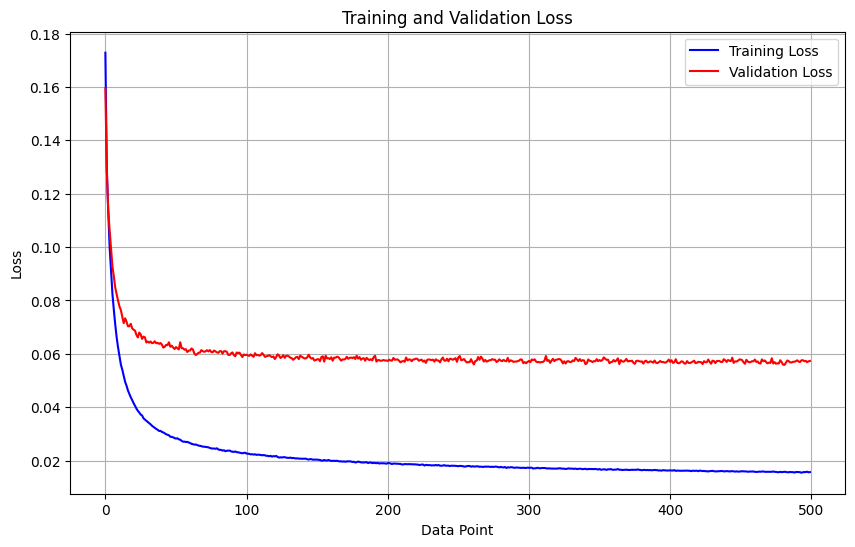

In [17]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(loss_train))
plt.figure(figsize=(10, 6))
plt.plot(x, loss_train, label='Training Loss', color='blue')
plt.plot(x, loss_valid, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Data Point')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### esm2 2560 + MolFormer
add the additional seqeunces add 3

In [18]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_2560')

In [19]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enzy_refine_layer_1 = nn.Linear(2560, 2560) # W1 and b
        self.smiles_refine_layer_1 = nn.Linear(768, 768) # W1 and b
        self.enzy_refine_layer_2 = nn.Linear(2560, 128) # W1 and b
        self.smiles_refine_layer_2 = nn.Linear(768, 128) # W1 and b

        self.relu = nn.ReLU()
        self.batch_norm_enzy = nn.BatchNorm1d(2560)
        self.batch_norm_smiles = nn.BatchNorm1d(768)
        self.batch_norm_shared = nn.BatchNorm1d(128)

    def forward(self, enzy_embed, smiles_embed):
        refined_enzy_embed = self.enzy_refine_layer_1(enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_1(smiles_embed)

        refined_enzy_embed = self.batch_norm_enzy(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_smiles(refined_smiles_embed)

        refined_enzy_embed = self.relu(refined_enzy_embed)
        refined_smiles_embed = self.relu(refined_smiles_embed)

        refined_enzy_embed = self.enzy_refine_layer_2(refined_enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_2(refined_smiles_embed)

        refined_enzy_embed = self.batch_norm_shared(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_shared(refined_smiles_embed)
        refined_enzy_embed = torch.nn.functional.normalize(refined_enzy_embed, dim=1)
        refined_smiles_embed = torch.nn.functional.normalize(refined_smiles_embed, dim=1)

        return refined_enzy_embed, refined_smiles_embed


In [20]:
def get_ds():
    # Load the saved embeddings_results
    ESP_train_df_enzy = torch.load('ESP_train_df_enzy_esm2_2560.pt')
    ESP_val_df_enzy = torch.load('ESP_val_df_enzy_esm2_2560.pt')
    ESP_test_df_enzy = torch.load('ESP_test_df_enzy_esm2_2560.pt')
    print(ESP_train_df_enzy.shape, ESP_val_df_enzy.shape, ESP_test_df_enzy.shape)
    # Load the saved embeddings_results
    ESP_train_df_smiles = torch.load('ESP_train_df_smiles_esm2_2560.pt')
    ESP_val_df_smiles = torch.load('ESP_val_df_smiles_esm2_2560.pt')
    ESP_test_df_smiles = torch.load('ESP_test_df_smiles_esm2_2560.pt')
    print(ESP_train_df_smiles.shape, ESP_val_df_smiles.shape, ESP_test_df_smiles.shape)

    y_train = torch.load( 'ESP_train_df_label_esm2_2560.pt')
    y_val = torch.load('ESP_val_df_label_esm2_2560.pt')
    y_test = torch.load('ESP_test_df_label_esm2_2560.pt')
    print(y_train.shape,y_val.shape, y_test.shape)
    ESP_train_df_enzy_add = torch.load('ESP_train_df_enzy_>2800_<5500.pt')
    ESP_train_df_smiles_add = torch.load('ESP_train_df_smiles_>2800_<5500.pt')
    y_train_add = torch.load('ESP_train_df_label_>2800_<5500.pt')

    ESP_val_df_enzy_add = torch.load('ESP_val_df_enzy_>2800_<8000.pt')
    ESP_test_df_enzy_add = torch.load('ESP_test_df_enzy_>2800_<8000.pt')
    ESP_val_df_smiles_add = torch.load('ESP_val_df_smiles_>2800_<8000.pt')
    ESP_test_df_smiles_add = torch.load('ESP_test_df_smiles_>2800_<8000.pt')
    y_val_add = torch.load('ESP_val_df_label_>2800_<8000.pt')
    y_test_add = torch.load('ESP_test_df_label_>2800_<8000.pt')
    print(ESP_val_df_enzy_add.shape, ESP_val_df_smiles_add.shape, y_val_add.shape)
    print(ESP_test_df_enzy_add.shape, ESP_test_df_smiles_add.shape, y_test_add.shape)

    ESP_train_df_enzy = torch.cat([ESP_train_df_enzy, ESP_train_df_enzy_add], dim=0)
    ESP_train_df_smiles = torch.cat([ESP_train_df_smiles, ESP_train_df_smiles_add], dim=0)
    y_train = torch.cat([y_train, y_train_add], dim=0)
    print(ESP_train_df_enzy.shape, ESP_train_df_smiles.shape, y_train.shape)

    ESP_val_df_enzy = torch.cat([ESP_val_df_enzy, ESP_val_df_enzy_add], dim=0)
    ESP_val_df_smiles = torch.cat([ESP_val_df_smiles, ESP_val_df_smiles_add], dim=0)
    y_val = torch.cat([y_val, y_val_add], dim=0)
    print(ESP_val_df_enzy.shape, ESP_val_df_smiles.shape, y_val.shape)
    ESP_test_df_enzy = torch.cat([ESP_test_df_enzy, ESP_test_df_enzy_add], dim=0)
    ESP_test_df_smiles = torch.cat([ESP_test_df_smiles, ESP_test_df_smiles_add], dim=0)
    y_test = torch.cat([y_test, y_test_add], dim=0)
    print(ESP_test_df_enzy.shape, ESP_test_df_smiles.shape, y_test.shape)

    train_tensor_dataset = TensorDataset(ESP_train_df_enzy,ESP_train_df_smiles, y_train)
    val_tensor_dataset = TensorDataset(ESP_val_df_enzy,ESP_val_df_smiles, y_val)
    test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)

    # Create TensorDataset and DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
    print(len(train_loader))
    return train_loader,  val_loader, test_loader

In [21]:
# design the model, optimizer and loss function
model = Contrastive_learning_layer().to(device)
train_loader,  val_loader, test_loader = get_ds()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-03)
loss_fn = nn.MSELoss().to(device)

torch.Size([49881, 2560]) torch.Size([5399, 2560]) torch.Size([13312, 2560])
torch.Size([49881, 768]) torch.Size([5399, 768]) torch.Size([13312, 768])
torch.Size([49881, 1]) torch.Size([5399, 1]) torch.Size([13312, 1])
torch.Size([23, 2560]) torch.Size([23, 768]) torch.Size([23, 1])
torch.Size([24, 2560]) torch.Size([24, 768]) torch.Size([24, 1])
torch.Size([50061, 2560]) torch.Size([50061, 768]) torch.Size([50061, 1])
torch.Size([5422, 2560]) torch.Size([5422, 768]) torch.Size([5422, 1])
torch.Size([13336, 2560]) torch.Size([13336, 768]) torch.Size([13336, 1])
3129


In [22]:
initial_epoch = 0
best_epoch = -1
best_accuracy = 0.5
loss_train = []
loss_valid = []
for epoch in range(initial_epoch, 500):
    torch.cuda.empty_cache()
    model.train()

    with tqdm(train_loader, desc='Processing', unit="batch") as tepoch:
        num_batch = len(train_loader)
        loss_sum = 0
        for ESP_train_df_enzy,ESP_train_df_smiles, y_train in tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            ESP_train_df_enzy = ESP_train_df_enzy.to(device)
            ESP_train_df_smiles = ESP_train_df_smiles.to(device)
            y_train = y_train.squeeze(1).to(device)
            refined_enzy_embed, refined_smiles_embed = model(ESP_train_df_enzy,ESP_train_df_smiles)
            cosine_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
            loss = loss_fn(cosine_sim, y_train)
            loss_sum = loss_sum + loss.detach().cpu().numpy()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True) #
            tepoch.set_postfix(train_loss=loss)
            # tepoch.set_postfix(val_loss=loss_sum_val, val_accuracy=100. * acc_val, balanced_val_accuracy=100. * bacc_val)
        loss_sum = loss_sum/num_batch
        loss_train.append(loss_sum)
        loss_sum_val,acc_val, bacc_val = run_validation(model,val_loader,loss_fn, device)
        loss_valid.append(loss_sum_val)
        print('Epoch: %d / %d, ############## the best accuracy in val  %.4f at Epoch: %d  ##############'  % (epoch, 500,100 * best_accuracy,best_epoch))
        # print('Performance in Train: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum, 100 * acc))
        print('Performance in Val: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum_val, 100 * acc_val))
        # checkpoint(model, f"epoch-{epoch}.pth")
        if acc_val > best_accuracy: # compare the performance updates at the val set
            best_accuracy = acc_val
            best_epoch = epoch
            torch.save(model, "best_model_11.pt")

Epoch 0: 100%|██████████| 3129/3129 [00:29<00:00, 104.66batch/s, train_loss=tensor(0.1677, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.15570538975078624 ACC=  0.7891921800073773 bacc=  0.636040542653535 precision=  0.7384105960264901 specificity=  0.9604109245803056 sensitivity=  0.3116701607267645 recall=  0.3116701607267645 MCC=  0.3811598654067418 AUC=  0.7995797147355134 f1=  0.4383292383292383
Epoch: 0 / 500, ############## the best accuracy in val  50.0000 at Epoch: -1  ##############
Performance in Val: Loss: (0.1557); Accuracy (78.92)


Epoch 1: 100%|██████████| 3129/3129 [00:29<00:00, 105.02batch/s, train_loss=tensor(0.1007, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.13536269757841715 ACC=  0.8181482847657691 bacc=  0.6810358246655954 precision=  0.8306092124814265 specificity=  0.9714357303933852 sensitivity=  0.39063591893780575 recall=  0.39063591893780575 MCC=  0.4840013624905859 AUC=  0.8593408369390177 f1=  0.5313688212927756
Epoch: 1 / 500, ############## the best accuracy in val  78.9192 at Epoch: 0  ##############
Performance in Val: Loss: (0.1354); Accuracy (81.81)


Epoch 2: 100%|██████████| 3129/3129 [00:30<00:00, 104.04batch/s, train_loss=tensor(0.1819, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.11876299710817921 ACC=  0.8476576908889708 bacc=  0.7541983438978093 precision=  0.806484295845998 specificity=  0.9521423202204962 sensitivity=  0.5562543675751223 recall=  0.5562543675751223 MCC=  0.5807082617779032 AUC=  0.8934745910653967 f1=  0.6583953680727874
Epoch: 2 / 500, ############## the best accuracy in val  81.8148 at Epoch: 1  ##############
Performance in Val: Loss: (0.1188); Accuracy (84.77)


Epoch 3: 100%|██████████| 3129/3129 [00:29<00:00, 104.99batch/s, train_loss=tensor(0.1485, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.11123334355982004 ACC=  0.8638878642567318 bacc=  0.7874114381397277 precision=  0.8158614402917046 specificity=  0.9493861187672262 sensitivity=  0.6254367575122292 recall=  0.6254367575122292 MCC=  0.6306644553186342 AUC=  0.9064575063284424 f1=  0.7080696202531643
Epoch: 3 / 500, ############## the best accuracy in val  84.7658 at Epoch: 2  ##############
Performance in Val: Loss: (0.1112); Accuracy (86.39)


Epoch 4: 100%|██████████| 3129/3129 [00:29<00:00, 104.39batch/s, train_loss=tensor(0.0366, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.10101730336646679 ACC=  0.8780892659535227 bacc=  0.8174534386506607 precision=  0.8202995008319468 specificity=  0.9458782260085191 sensitivity=  0.6890286512928022 recall=  0.6890286512928022 MCC=  0.6736933381455936 AUC=  0.924804517361828 f1=  0.7489555639954425
Epoch: 4 / 500, ############## the best accuracy in val  86.3888 at Epoch: 3  ##############
Performance in Val: Loss: (0.1010); Accuracy (87.81)


Epoch 5: 100%|██████████| 3129/3129 [00:29<00:00, 104.86batch/s, train_loss=tensor(0.0480, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09501610241368809 ACC=  0.8887864256731833 bacc=  0.8480286969931122 precision=  0.8062130177514792 specificity=  0.9343522926584816 sensitivity=  0.7617051013277428 recall=  0.7617051013277428 MCC=  0.709120730154618 AUC=  0.9336337822294433 f1=  0.7833273445921667
Epoch: 5 / 500, ############## the best accuracy in val  87.8089 at Epoch: 4  ##############
Performance in Val: Loss: (0.0950); Accuracy (88.88)


Epoch 6: 100%|██████████| 3129/3129 [00:29<00:00, 105.03batch/s, train_loss=tensor(0.0766, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.09030974936564412 ACC=  0.8950571744743637 bacc=  0.8534089016849757 precision=  0.8245481927710844 specificity=  0.9416186419443748 sensitivity=  0.7651991614255765 recall=  0.7651991614255765 MCC=  0.7244279601979099 AUC=  0.9414375041257225 f1=  0.7937658571946358
Epoch: 6 / 500, ############## the best accuracy in val  88.8786 at Epoch: 5  ##############
Performance in Val: Loss: (0.0903); Accuracy (89.51)


Epoch 7: 100%|██████████| 3129/3129 [00:29<00:00, 104.52batch/s, train_loss=tensor(0.0737, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08787873107390505 ACC=  0.9024345260051642 bacc=  0.8714193763360993 precision=  0.8212250712250713 specificity=  0.9371084941117515 sensitivity=  0.8057302585604472 recall=  0.8057302585604472 MCC=  0.7474234384282593 AUC=  0.9426479495006321 f1=  0.8134038800705466
Epoch: 7 / 500, ############## the best accuracy in val  89.5057 at Epoch: 6  ##############
Performance in Val: Loss: (0.0879); Accuracy (90.24)


Epoch 8: 100%|██████████| 3129/3129 [00:29<00:00, 104.87batch/s, train_loss=tensor(0.0488, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0848878854143936 ACC=  0.9079675396532645 bacc=  0.8722642192312158 precision=  0.8456973293768546 specificity=  0.9478827361563518 sensitivity=  0.7966457023060797 recall=  0.7966457023060797 MCC=  0.7592529942683675 AUC=  0.9472326886437881 f1=  0.8204390068369917
Epoch: 8 / 500, ############## the best accuracy in val  90.2435 at Epoch: 7  ##############
Performance in Val: Loss: (0.0849); Accuracy (90.80)


Epoch 9: 100%|██████████| 3129/3129 [00:29<00:00, 105.16batch/s, train_loss=tensor(0.0485, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.08311888077749616 ACC=  0.9116562154186647 bacc=  0.8828383254355844 precision=  0.84 specificity=  0.9438737158606866 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.7711183418461437 AUC=  0.9477672597026047 f1=  0.8308018368067821
Epoch: 9 / 500, ############## the best accuracy in val  90.7968 at Epoch: 8  ##############
Performance in Val: Loss: (0.0831); Accuracy (91.17)


Epoch 10: 100%|██████████| 3129/3129 [00:29<00:00, 104.78batch/s, train_loss=tensor(0.0997, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0803605954802889 ACC=  0.9111029140538547 bacc=  0.88739321054483 precision=  0.8279198341395991 specificity=  0.9376096216487096 sensitivity=  0.8371767994409504 recall=  0.8371767994409504 MCC=  0.772040084129588 AUC=  0.9530211319283903 f1=  0.8325225851285615
Epoch: 10 / 500, ############## the best accuracy in val  91.1656 at Epoch: 9  ##############
Performance in Val: Loss: (0.0804); Accuracy (91.11)


Epoch 11: 100%|██████████| 3129/3129 [00:29<00:00, 104.48batch/s, train_loss=tensor(0.0364, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07793096553226576 ACC=  0.915529324972335 bacc=  0.8901758516410352 precision=  0.8423645320197044 specificity=  0.9438737158606866 sensitivity=  0.8364779874213837 recall=  0.8364779874213837 MCC=  0.7821134396589743 AUC=  0.9528154805335066 f1=  0.8394109396914446
Epoch: 11 / 500, ############## the best accuracy in val  91.1656 at Epoch: 9  ##############
Performance in Val: Loss: (0.0779); Accuracy (91.55)


Epoch 12: 100%|██████████| 3129/3129 [00:30<00:00, 103.35batch/s, train_loss=tensor(0.1196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07420061737200064 ACC=  0.9227222427148654 bacc=  0.897975458758447 precision=  0.859375 specificity=  0.9503883738411426 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.80012337281592 AUC=  0.9582590703296252 f1=  0.8524128214159915
Epoch: 12 / 500, ############## the best accuracy in val  91.5529 at Epoch: 11  ##############
Performance in Val: Loss: (0.0742); Accuracy (92.27)


Epoch 13: 100%|██████████| 3129/3129 [00:29<00:00, 104.65batch/s, train_loss=tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07599438745858131 ACC=  0.9223533751383254 bacc=  0.8954836537345294 precision=  0.8633093525179856 specificity=  0.9523928839889751 sensitivity=  0.8385744234800838 recall=  0.8385744234800838 MCC=  0.7984570362582194 AUC=  0.9535048373165267 f1=  0.8507621410847217
Epoch: 13 / 500, ############## the best accuracy in val  92.2722 at Epoch: 12  ##############
Performance in Val: Loss: (0.0760); Accuracy (92.24)


Epoch 14: 100%|██████████| 3129/3129 [00:29<00:00, 105.41batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07537866145053708 ACC=  0.917189229066765 bacc=  0.8926481333524539 precision=  0.8448033707865169 specificity=  0.9446254071661238 sensitivity=  0.8406708595387841 recall=  0.8406708595387841 MCC=  0.7865345852767842 AUC=  0.9546732594178972 f1=  0.8427320490367776
Epoch: 14 / 500, ############## the best accuracy in val  92.2722 at Epoch: 12  ##############
Performance in Val: Loss: (0.0754); Accuracy (91.72)


Epoch 15: 100%|██████████| 3129/3129 [00:29<00:00, 105.19batch/s, train_loss=tensor(0.0840, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0732828670711556 ACC=  0.9225378089265953 bacc=  0.8974019286231197 precision=  0.8597864768683274 specificity=  0.9506389376096217 sensitivity=  0.8441649196366178 recall=  0.8441649196366178 MCC=  0.7995241178679965 AUC=  0.9559064673993074 f1=  0.8519040902679831
Epoch: 15 / 500, ############## the best accuracy in val  92.2722 at Epoch: 12  ##############
Performance in Val: Loss: (0.0733); Accuracy (92.25)


Epoch 16: 100%|██████████| 3129/3129 [00:29<00:00, 104.48batch/s, train_loss=tensor(0.0746, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07323843502826922 ACC=  0.9218000737735154 bacc=  0.8951078080818109 precision=  0.8614501076812635 specificity=  0.951641192683538 sensitivity=  0.8385744234800838 recall=  0.8385744234800838 MCC=  0.7971354011590903 AUC=  0.9540551671029207 f1=  0.8498583569405099
Epoch: 16 / 500, ############## the best accuracy in val  92.2722 at Epoch: 12  ##############
Performance in Val: Loss: (0.0732); Accuracy (92.18)


Epoch 17: 100%|██████████| 3129/3129 [00:29<00:00, 105.01batch/s, train_loss=tensor(0.0494, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07118307651984876 ACC=  0.9258576171154556 bacc=  0.9016741196693259 precision=  0.8661921708185053 specificity=  0.9528940115259333 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8081192441911524 AUC=  0.9564753574648479 f1=  0.8582510578279267
Epoch: 17 / 500, ############## the best accuracy in val  92.2722 at Epoch: 12  ##############
Performance in Val: Loss: (0.0712); Accuracy (92.59)


Epoch 18: 100%|██████████| 3129/3129 [00:29<00:00, 104.83batch/s, train_loss=tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.07275182128524006 ACC=  0.9243821468092954 bacc=  0.8993271198421465 precision=  0.8643825838686653 specificity=  0.9523928839889751 sensitivity=  0.8462613556953179 recall=  0.8462613556953179 MCC=  0.8041431708086353 AUC=  0.9559003390052496 f1=  0.855225988700565
Epoch: 18 / 500, ############## the best accuracy in val  92.5858 at Epoch: 17  ##############
Performance in Val: Loss: (0.0728); Accuracy (92.44)


Epoch 19: 100%|██████████| 3129/3129 [00:29<00:00, 104.60batch/s, train_loss=tensor(0.0422, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06928831843554886 ACC=  0.9310217631870159 bacc=  0.9058543848046644 precision=  0.8821402747650036 specificity=  0.9591581057379103 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.820753800096635 AUC=  0.9581923583828814 f1=  0.8670931058990761
Epoch: 19 / 500, ############## the best accuracy in val  92.5858 at Epoch: 17  ##############
Performance in Val: Loss: (0.0693); Accuracy (93.10)


Epoch 20: 100%|██████████| 3129/3129 [00:30<00:00, 104.20batch/s, train_loss=tensor(0.0376, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06977640667650024 ACC=  0.9317594983400959 bacc=  0.9068037605927103 precision=  0.883586406362979 specificity=  0.9596592332748685 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8226737098350339 AUC=  0.9562181400113918 f1=  0.8685145700071073
Epoch: 20 / 500, ############## the best accuracy in val  93.1022 at Epoch: 19  ##############
Performance in Val: Loss: (0.0698); Accuracy (93.18)


Epoch 21: 100%|██████████| 3129/3129 [00:29<00:00, 104.45batch/s, train_loss=tensor(0.0357, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0681523207058597 ACC=  0.9278863887864257 bacc=  0.9043969651492237 precision=  0.8698435277382646 specificity=  0.9541468303683287 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8134091467831382 AUC=  0.960297899484182 f1=  0.8621783574198096
Epoch: 21 / 500, ############## the best accuracy in val  93.1759 at Epoch: 20  ##############
Performance in Val: Loss: (0.0682); Accuracy (92.79)


Epoch 22: 100%|██████████| 3129/3129 [00:33<00:00, 93.21batch/s, train_loss=tensor(0.0395, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0693290193941565 ACC=  0.9297307266691258 bacc=  0.9043050392383563 precision=  0.8793352601156069 specificity=  0.958155850663994 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8174263410437427 AUC=  0.9560011073132578 f1=  0.8646536412078153
Epoch: 22 / 500, ############## the best accuracy in val  93.1759 at Epoch: 20  ##############
Performance in Val: Loss: (0.0693); Accuracy (92.97)


Epoch 23: 100%|██████████| 3129/3129 [00:31<00:00, 100.32batch/s, train_loss=tensor(0.0451, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06951222741828028 ACC=  0.9295462928808558 bacc=  0.9028350126008536 precision=  0.8820101966496723 specificity=  0.9594086695063894 sensitivity=  0.8462613556953179 recall=  0.8462613556953179 MCC=  0.8165987858674986 AUC=  0.9549660215568887 f1=  0.8637660485021399
Epoch: 23 / 500, ############## the best accuracy in val  93.1759 at Epoch: 20  ##############
Performance in Val: Loss: (0.0695); Accuracy (92.95)


Epoch 24: 100%|██████████| 3129/3129 [00:28<00:00, 109.83batch/s, train_loss=tensor(0.0580, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06698262756607964 ACC=  0.9293618590925857 bacc=  0.9042785995954209 precision=  0.877521613832853 specificity=  0.9574041593585567 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8165988220062383 AUC=  0.9599739700839818 f1=  0.8641362185172046
Epoch: 24 / 500, ############## the best accuracy in val  93.1759 at Epoch: 20  ##############
Performance in Val: Loss: (0.0670); Accuracy (92.94)


Epoch 25: 100%|██████████| 3129/3129 [00:28<00:00, 108.42batch/s, train_loss=tensor(0.0503, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06881559068463457 ACC=  0.9286241239395057 bacc=  0.9015362308030245 precision=  0.880466472303207 specificity=  0.9589075419694312 sensitivity=  0.8441649196366178 recall=  0.8441649196366178 MCC=  0.8141620351696734 AUC=  0.9549618192295347 f1=  0.8619336425258651
Epoch: 25 / 500, ############## the best accuracy in val  93.1759 at Epoch: 20  ##############
Performance in Val: Loss: (0.0688); Accuracy (92.86)


Epoch 26: 100%|██████████| 3129/3129 [00:28<00:00, 108.20batch/s, train_loss=tensor(0.0673, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06787597810970428 ACC=  0.9302840280339358 bacc=  0.9055773813932502 precision=  0.8790496760259179 specificity=  0.9579052868955149 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8190287925509208 AUC=  0.9556061760904733 f1=  0.8659574468085105
Epoch: 26 / 500, ############## the best accuracy in val  93.1759 at Epoch: 20  ##############
Performance in Val: Loss: (0.0679); Accuracy (93.03)


Epoch 27: 100%|██████████| 3129/3129 [00:29<00:00, 106.89batch/s, train_loss=tensor(0.0346, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0657221068790221 ACC=  0.9324972334931759 bacc=  0.9068566398785807 precision=  0.8872727272727273 specificity=  0.9611626158857429 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8243547281466664 AUC=  0.9599240674466536 f1=  0.8695652173913044
Epoch: 27 / 500, ############## the best accuracy in val  93.1759 at Epoch: 20  ##############
Performance in Val: Loss: (0.0657); Accuracy (93.25)


Epoch 28: 100%|██████████| 3129/3129 [00:28<00:00, 108.67batch/s, train_loss=tensor(0.0431, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06728466560619067 ACC=  0.9289929915160458 bacc=  0.9011144221948721 precision=  0.8834310850439883 specificity=  0.9601603608118267 sensitivity=  0.8420684835779175 recall=  0.8420684835779175 MCC=  0.8148839188225557 AUC=  0.9576593631968224 f1=  0.8622540250447228
Epoch: 28 / 500, ############## the best accuracy in val  93.2497 at Epoch: 27  ##############
Performance in Val: Loss: (0.0673); Accuracy (92.90)


Epoch 29: 100%|██████████| 3129/3129 [00:28<00:00, 109.39batch/s, train_loss=tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06630046247809598 ACC=  0.9324972334931759 bacc=  0.9075290122552122 precision=  0.8855901520637219 specificity=  0.9604109245803056 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8245328136784518 AUC=  0.9594817724926508 f1=  0.8698435277382646
Epoch: 29 / 500, ############## the best accuracy in val  93.2497 at Epoch: 27  ##############
Performance in Val: Loss: (0.0663); Accuracy (93.25)


Epoch 30: 100%|██████████| 3129/3129 [00:28<00:00, 109.49batch/s, train_loss=tensor(0.0358, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06480983688405394 ACC=  0.9361859092585761 bacc=  0.9147412565764235 precision=  0.8866714183891661 specificity=  0.9601603608118267 sensitivity=  0.8693221523410203 recall=  0.8693221523410203 MCC=  0.8347954570657773 AUC=  0.9611380147610252 f1=  0.8779110797459421
Epoch: 30 / 500, ############## the best accuracy in val  93.2497 at Epoch: 27  ##############
Performance in Val: Loss: (0.0648); Accuracy (93.62)


Epoch 31: 100%|██████████| 3129/3129 [00:28<00:00, 108.97batch/s, train_loss=tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06659028479406352 ACC=  0.9360014754703062 bacc=  0.9110299886834826 precision=  0.8950437317784257 specificity=  0.9639188173390127 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8334117482575907 AUC=  0.9565490732905151 f1=  0.8762040670709954
Epoch: 31 / 500, ############## the best accuracy in val  93.6186 at Epoch: 30  ##############
Performance in Val: Loss: (0.0666); Accuracy (93.60)


Epoch 32: 100%|██████████| 3129/3129 [00:28<00:00, 108.79batch/s, train_loss=tensor(0.0528, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06582647399663662 ACC=  0.932866101069716 bacc=  0.9073313277726036 precision=  0.888 specificity=  0.961413179654222 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8253165195283889 AUC=  0.9568358821324221 f1=  0.8702779757662152
Epoch: 32 / 500, ############## the best accuracy in val  93.6186 at Epoch: 30  ##############
Performance in Val: Loss: (0.0658); Accuracy (93.29)


Epoch 33: 100%|██████████| 3129/3129 [00:29<00:00, 107.68batch/s, train_loss=tensor(0.0454, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06583890171617182 ACC=  0.932681667281446 bacc=  0.9051889287584697 precision=  0.8924889543446245 specificity=  0.9634176898020547 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.8243687346070239 AUC=  0.9577691489989443 f1=  0.8691287199713159
Epoch: 33 / 500, ############## the best accuracy in val  93.6186 at Epoch: 30  ##############
Performance in Val: Loss: (0.0658); Accuracy (93.27)


Epoch 34: 100%|██████████| 3129/3129 [00:28<00:00, 108.77batch/s, train_loss=tensor(0.0339, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06569819263482032 ACC=  0.932681667281446 bacc=  0.9092231630182586 precision=  0.8823529411764706 specificity=  0.9589075419694312 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8254195795922559 AUC=  0.9581636424792961 f1=  0.8707964601769911
Epoch: 34 / 500, ############## the best accuracy in val  93.6186 at Epoch: 30  ##############
Performance in Val: Loss: (0.0657); Accuracy (93.27)


Epoch 35: 100%|██████████| 3129/3129 [00:28<00:00, 108.46batch/s, train_loss=tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06520446119170668 ACC=  0.933788270011066 bacc=  0.9077336130682575 precision=  0.8918128654970761 specificity=  0.9629165622650965 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8275271879871269 AUC=  0.9585203150134622 f1=  0.871739907109682
Epoch: 35 / 500, ############## the best accuracy in val  93.6186 at Epoch: 30  ##############
Performance in Val: Loss: (0.0652); Accuracy (93.38)


Epoch 36: 100%|██████████| 3129/3129 [00:28<00:00, 108.92batch/s, train_loss=tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06449896783587196 ACC=  0.934341571375876 bacc=  0.9107989482275021 precision=  0.8869690424766019 specificity=  0.9606614883487847 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8295732996553116 AUC=  0.959724106703395 f1=  0.8737588652482269
Epoch: 36 / 500, ############## the best accuracy in val  93.6186 at Epoch: 30  ##############
Performance in Val: Loss: (0.0645); Accuracy (93.43)


Epoch 37: 100%|██████████| 3129/3129 [00:28<00:00, 110.41batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06464361752160883 ACC=  0.9365547768351162 bacc=  0.9111817102106574 precision=  0.8975859546452085 specificity=  0.9649210724129291 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8347276093787402 AUC=  0.9593191074046583 f1=  0.8770550393137956
Epoch: 37 / 500, ############## the best accuracy in val  93.6186 at Epoch: 30  ##############
Performance in Val: Loss: (0.0646); Accuracy (93.66)


Epoch 38: 100%|██████████| 3129/3129 [00:28<00:00, 110.14batch/s, train_loss=tensor(0.0477, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06329447419621644 ACC=  0.9369236444116562 bacc=  0.9114322739791365 precision=  0.8989010989010989 specificity=  0.9654221999498872 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8356418905607317 AUC=  0.9601273550324008 f1=  0.8776824034334764
Epoch: 38 / 500, ############## the best accuracy in val  93.6555 at Epoch: 37  ##############
Performance in Val: Loss: (0.0633); Accuracy (93.69)


Epoch 39: 100%|██████████| 3129/3129 [00:28<00:00, 109.49batch/s, train_loss=tensor(0.0381, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06487574546864383 ACC=  0.9363703430468462 bacc=  0.9130735454563124 precision=  0.8917748917748918 specificity=  0.9624154347281383 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8347585284337737 AUC=  0.9579132538077901 f1=  0.8775292864749733
Epoch: 39 / 500, ############## the best accuracy in val  93.6924 at Epoch: 38  ##############
Performance in Val: Loss: (0.0649); Accuracy (93.64)


Epoch 40: 100%|██████████| 3129/3129 [00:28<00:00, 109.12batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06442809411102032 ACC=  0.9354481741054961 bacc=  0.9113265154073955 precision=  0.8913830557566981 specificity=  0.9624154347281383 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8322161095049133 AUC=  0.9573135466749874 f1=  0.8755334281650072
Epoch: 40 / 500, ############## the best accuracy in val  93.6924 at Epoch: 38  ##############
Performance in Val: Loss: (0.0644); Accuracy (93.54)


Epoch 41: 100%|██████████| 3129/3129 [00:29<00:00, 107.61batch/s, train_loss=tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06452362685241794 ACC=  0.9363703430468462 bacc=  0.9130735454563124 precision=  0.8917748917748918 specificity=  0.9624154347281383 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8347585284337737 AUC=  0.9566227891161821 f1=  0.8775292864749733
Epoch: 41 / 500, ############## the best accuracy in val  93.6924 at Epoch: 38  ##############
Performance in Val: Loss: (0.0645); Accuracy (93.64)


Epoch 42: 100%|██████████| 3129/3129 [00:28<00:00, 108.68batch/s, train_loss=tensor(0.0360, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06490931265017671 ACC=  0.932681667281446 bacc=  0.9063095493861888 precision=  0.8896198830409356 specificity=  0.9621648709596592 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8246369396078753 AUC=  0.9572629436497668 f1=  0.8695962843872811
Epoch: 42 / 500, ############## the best accuracy in val  93.6924 at Epoch: 38  ##############
Performance in Val: Loss: (0.0649); Accuracy (93.27)


Epoch 43: 100%|██████████| 3129/3129 [00:28<00:00, 109.47batch/s, train_loss=tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06411846090454311 ACC=  0.9365547768351162 bacc=  0.9120782067128328 precision=  0.8952727272727272 specificity=  0.9639188173390127 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8349344333456132 AUC=  0.9571467668081276 f1=  0.8774055595153243
Epoch: 43 / 500, ############## the best accuracy in val  93.6924 at Epoch: 38  ##############
Performance in Val: Loss: (0.0641); Accuracy (93.66)


Epoch 44: 100%|██████████| 3129/3129 [00:28<00:00, 109.23batch/s, train_loss=tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06401016873068514 ACC=  0.9380302471412763 bacc=  0.9115115929079423 precision=  0.9046563192904656 specificity=  0.967677273866199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8382624409512204 AUC=  0.9557313704262262 f1=  0.8793103448275863
Epoch: 44 / 500, ############## the best accuracy in val  93.6924 at Epoch: 38  ##############
Performance in Val: Loss: (0.0640); Accuracy (93.80)


Epoch 45: 100%|██████████| 3129/3129 [00:28<00:00, 109.48batch/s, train_loss=tensor(0.0396, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06414152392128532 ACC=  0.9339727037993361 bacc=  0.9080830190780409 precision=  0.8918918918918919 specificity=  0.9629165622650965 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8280359147461873 AUC=  0.9551519745423009 f1=  0.872142857142857
Epoch: 45 / 500, ############## the best accuracy in val  93.8030 at Epoch: 44  ##############
Performance in Val: Loss: (0.0641); Accuracy (93.40)


Epoch 46: 100%|██████████| 3129/3129 [00:28<00:00, 109.29batch/s, train_loss=tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06504175973545133 ACC=  0.9354481741054961 bacc=  0.9086370259008696 precision=  0.8983050847457628 specificity=  0.9654221999498872 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.831587959139431 AUC=  0.9560323621229527 f1=  0.8744619799139168
Epoch: 46 / 500, ############## the best accuracy in val  93.8030 at Epoch: 44  ##############
Performance in Val: Loss: (0.0650); Accuracy (93.54)


Epoch 47: 100%|██████████| 3129/3129 [00:28<00:00, 109.55batch/s, train_loss=tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0632709633479318 ACC=  0.9341571375876061 bacc=  0.9084324250878243 precision=  0.891970802919708 specificity=  0.9629165622650965 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8285445931042085 AUC=  0.9576096356564675 f1=  0.8725455194573366
Epoch: 47 / 500, ############## the best accuracy in val  93.8030 at Epoch: 44  ##############
Performance in Val: Loss: (0.0633); Accuracy (93.42)


Epoch 48: 100%|██████████| 3129/3129 [00:28<00:00, 108.07batch/s, train_loss=tensor(0.0289, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0629988294012383 ACC=  0.933050534857986 bacc=  0.9070083614057556 precision=  0.8897810218978102 specificity=  0.9621648709596592 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8256557424852587 AUC=  0.9587194002718555 f1=  0.8704034273473759
Epoch: 48 / 500, ############## the best accuracy in val  93.8030 at Epoch: 44  ##############
Performance in Val: Loss: (0.0630); Accuracy (93.31)


Epoch 49: 100%|██████████| 3129/3129 [00:29<00:00, 107.54batch/s, train_loss=tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0630141400929903 ACC=  0.9360014754703062 bacc=  0.9103576163068512 precision=  0.8967789165446559 specificity=  0.96467050864445 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.833256772176171 AUC=  0.9587757814971877 f1=  0.8759385055416518
Epoch: 49 / 500, ############## the best accuracy in val  93.8030 at Epoch: 44  ##############
Performance in Val: Loss: (0.0630); Accuracy (93.60)


Epoch 50: 100%|██████████| 3129/3129 [00:28<00:00, 107.99batch/s, train_loss=tensor(0.0459, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06281049424991188 ACC=  0.9361859092585761 bacc=  0.912724139446529 precision=  0.8916967509025271 specificity=  0.9624154347281383 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.834250135192469 AUC=  0.9579745377483685 f1=  0.8771306818181819
Epoch: 50 / 500, ############## the best accuracy in val  93.8030 at Epoch: 44  ##############
Performance in Val: Loss: (0.0628); Accuracy (93.62)


Epoch 51: 100%|██████████| 3129/3129 [00:28<00:00, 109.24batch/s, train_loss=tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0618943150298104 ACC=  0.9358170416820362 bacc=  0.9095599620459802 precision=  0.8978692138133725 specificity=  0.9651716361814082 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8326502430720165 AUC=  0.9598596317605598 f1=  0.8753581661891118
Epoch: 51 / 500, ############## the best accuracy in val  93.8030 at Epoch: 44  ##############
Performance in Val: Loss: (0.0619); Accuracy (93.58)


Epoch 52: 100%|██████████| 3129/3129 [00:28<00:00, 109.05batch/s, train_loss=tensor(0.0650, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06237484971858055 ACC=  0.9385835485060863 bacc=  0.9125598109372923 precision=  0.9048672566371682 specificity=  0.967677273866199 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8397771701319503 AUC=  0.9588936217600712 f1=  0.8805166846071044
Epoch: 52 / 500, ############## the best accuracy in val  93.8030 at Epoch: 44  ##############
Performance in Val: Loss: (0.0624); Accuracy (93.86)


Epoch 53: 100%|██████████| 3129/3129 [00:28<00:00, 109.53batch/s, train_loss=tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06231354117451186 ACC=  0.9387679822943563 bacc=  0.9142539617003387 precision=  0.9013878743608473 specificity=  0.9661738912553245 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8405572936818873 AUC=  0.956933236049455 f1=  0.8814285714285713
Epoch: 53 / 500, ############## the best accuracy in val  93.8584 at Epoch: 52  ##############
Performance in Val: Loss: (0.0623); Accuracy (93.88)


Epoch 54: 100%|██████████| 3129/3129 [00:28<00:00, 108.59batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0625766476789341 ACC=  0.9378458133530063 bacc=  0.9134034281535972 precision=  0.8986880466472303 specificity=  0.9651716361814082 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.83822417652957 AUC=  0.9597382895582145 f1=  0.8797716732072779
Epoch: 54 / 500, ############## the best accuracy in val  93.8768 at Epoch: 53  ##############
Performance in Val: Loss: (0.0626); Accuracy (93.78)


Epoch 55: 100%|██████████| 3129/3129 [00:28<00:00, 108.97batch/s, train_loss=tensor(0.0327, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06292459811564743 ACC=  0.9363703430468462 bacc=  0.9115046765775054 precision=  0.8957725947521866 specificity=  0.9641693811074918 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8343742339119865 AUC=  0.9565865440427543 f1=  0.8769175882982518
Epoch: 55 / 500, ############## the best accuracy in val  93.8768 at Epoch: 53  ##############
Performance in Val: Loss: (0.0629); Accuracy (93.64)


Epoch 56: 100%|██████████| 3129/3129 [00:28<00:00, 108.35batch/s, train_loss=tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0635920576146834 ACC=  0.934341571375876 bacc=  0.90833358284652 precision=  0.8931967812728603 specificity=  0.9634176898020547 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.828945711772802 AUC=  0.9575889742136439 f1=  0.8727662616154397
Epoch: 56 / 500, ############## the best accuracy in val  93.8768 at Epoch: 53  ##############
Performance in Val: Loss: (0.0636); Accuracy (93.43)


Epoch 57: 100%|██████████| 3129/3129 [00:29<00:00, 107.85batch/s, train_loss=tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06218526024195561 ACC=  0.9348948727406861 bacc=  0.9084853043736947 precision=  0.895741556534508 specificity=  0.9644199448759709 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8302627294910999 AUC=  0.9608350969975947 f1=  0.8736126029359113
Epoch: 57 / 500, ############## the best accuracy in val  93.8768 at Epoch: 53  ##############
Performance in Val: Loss: (0.0622); Accuracy (93.49)


Epoch 58: 100%|██████████| 3129/3129 [00:28<00:00, 108.44batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06169787046408891 ACC=  0.9380302471412763 bacc=  0.9130804617867491 precision=  0.9005120702267739 specificity=  0.9659233274868454 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8385822077826991 AUC=  0.9613524210045628 f1=  0.8799142244460328
Epoch: 58 / 500, ############## the best accuracy in val  93.8768 at Epoch: 53  ##############
Performance in Val: Loss: (0.0617); Accuracy (93.80)


Epoch 59: 100%|██████████| 3129/3129 [00:28<00:00, 109.09batch/s, train_loss=tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06221678434901357 ACC=  0.9376613795647363 bacc=  0.9105886567628316 precision=  0.905114899925871 specificity=  0.967927837634678 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8372100703726868 AUC=  0.9581125141631565 f1=  0.8784172661870504
Epoch: 59 / 500, ############## the best accuracy in val  93.8768 at Epoch: 53  ##############
Performance in Val: Loss: (0.0622); Accuracy (93.77)


Epoch 60: 100%|██████████| 3129/3129 [00:28<00:00, 108.58batch/s, train_loss=tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06235393405696899 ACC=  0.9372925119881962 bacc=  0.9114587136220718 precision=  0.9008082292432035 specificity=  0.9661738912553245 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8365104738266735 AUC=  0.9588680576020013 f1=  0.8782234957020058
Epoch: 60 / 500, ############## the best accuracy in val  93.8768 at Epoch: 53  ##############
Performance in Val: Loss: (0.0624); Accuracy (93.73)


Epoch 61: 100%|██████████| 3129/3129 [00:28<00:00, 108.38batch/s, train_loss=tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06162210755533701 ACC=  0.9396901512357064 bacc=  0.9148803711215363 precision=  0.9046920821114369 specificity=  0.9674267100977199 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8428501294272234 AUC=  0.9591951387477169 f1=  0.8830053667262969
Epoch: 61 / 500, ############## the best accuracy in val  93.8768 at Epoch: 53  ##############
Performance in Val: Loss: (0.0616); Accuracy (93.97)


Epoch 62: 100%|██████████| 3129/3129 [00:28<00:00, 108.72batch/s, train_loss=tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06176819742703948 ACC=  0.9387679822943563 bacc=  0.9140298375747948 precision=  0.9019751280175567 specificity=  0.9664244550238036 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8405095069846785 AUC=  0.9587369099691637 f1=  0.8813438170121515
Epoch: 62 / 500, ############## the best accuracy in val  93.9690 at Epoch: 61  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.88)


Epoch 63: 100%|██████████| 3129/3129 [00:28<00:00, 108.62batch/s, train_loss=tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0616427166524802 ACC=  0.9385835485060863 bacc=  0.9134563074394677 precision=  0.9024926686217009 specificity=  0.9666750187922827 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8399570731577749 AUC=  0.9583085352245206 f1=  0.8808586762075135
Epoch: 63 / 500, ############## the best accuracy in val  93.9690 at Epoch: 61  ##############
Performance in Val: Loss: (0.0616); Accuracy (93.86)


Epoch 64: 100%|██████████| 3129/3129 [00:29<00:00, 106.50batch/s, train_loss=tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06058234529113699 ACC=  0.9404278863887864 bacc=  0.9147091262818631 precision=  0.9091580502215657 specificity=  0.9691806564770734 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8445676938248105 AUC=  0.9596132703194347 f1=  0.8840215439856375
Epoch: 64 / 500, ############## the best accuracy in val  93.9690 at Epoch: 61  ##############
Performance in Val: Loss: (0.0606); Accuracy (94.04)


Epoch 65: 100%|██████████| 3129/3129 [00:28<00:00, 108.06batch/s, train_loss=tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06059910870874218 ACC=  0.9402434526005164 bacc=  0.9148079685231674 precision=  0.9078850405305822 specificity=  0.9686795289401152 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8441460027232937 AUC=  0.9592721814158727 f1=  0.8837876614060259
Epoch: 65 / 500, ############## the best accuracy in val  94.0428 at Epoch: 64  ##############
Performance in Val: Loss: (0.0606); Accuracy (94.02)


Epoch 66: 100%|██████████| 3129/3129 [00:28<00:00, 108.55batch/s, train_loss=tensor(0.0375, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06064179568114666 ACC=  0.9406123201770564 bacc=  0.915730904668278 precision=  0.9074210139603233 specificity=  0.9684289651716362 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.845195993024652 AUC=  0.9607948246937861 f1=  0.8846704871060171
Epoch: 66 / 500, ############## the best accuracy in val  94.0428 at Epoch: 64  ##############
Performance in Val: Loss: (0.0606); Accuracy (94.06)


Epoch 67: 100%|██████████| 3129/3129 [00:28<00:00, 108.36batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06036886304430114 ACC=  0.9404278863887864 bacc=  0.912019636775337 precision=  0.9165413533834587 specificity=  0.9721874216988223 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8441409297291237 AUC=  0.9621747639386383 f1=  0.8830134009416878
Epoch: 67 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0604); Accuracy (94.04)


Epoch 68: 100%|██████████| 3129/3129 [00:29<00:00, 107.71batch/s, train_loss=tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06236482446513257 ACC=  0.9356326078937661 bacc=  0.9096588042872844 precision=  0.8966275659824047 specificity=  0.96467050864445 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.832242256439246 AUC=  0.958267124790387 f1=  0.875134168157424
Epoch: 68 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0624); Accuracy (93.56)


Epoch 69: 100%|██████████| 3129/3129 [00:28<00:00, 108.07batch/s, train_loss=tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061476810634751584 ACC=  0.9376613795647363 bacc=  0.9119334015160947 precision=  0.9015429831006613 specificity=  0.9664244550238036 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8374755315153378 AUC=  0.9591636212925625 f1=  0.8789398280802293
Epoch: 69 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0615); Accuracy (93.77)


Epoch 70: 100%|██████████| 3129/3129 [00:28<00:00, 108.54batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060961385322789656 ACC=  0.9406123201770564 bacc=  0.915730904668278 precision=  0.9074210139603233 specificity=  0.9684289651716362 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.845195993024652 AUC=  0.9599557599987812 f1=  0.8846704871060171
Epoch: 70 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0610); Accuracy (94.06)


Epoch 71: 100%|██████████| 3129/3129 [00:29<00:00, 107.67batch/s, train_loss=tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060240780528096324 ACC=  0.9389524160826264 bacc=  0.911913878203596 precision=  0.9086181277860327 specificity=  0.9691806564770734 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8405382534987036 AUC=  0.9627912803808569 f1=  0.8808066258552396
Epoch: 71 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.90)


Epoch 72: 100%|██████████| 3129/3129 [00:28<00:00, 109.00batch/s, train_loss=tensor(0.0264, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06149683598632262 ACC=  0.9382146809295463 bacc=  0.9127574954199009 precision=  0.9023494860499266 specificity=  0.9666750187922827 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8389461287736495 AUC=  0.9589573570582727 f1=  0.8800572860723237
Epoch: 72 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0615); Accuracy (93.82)


Epoch 73: 100%|██████████| 3129/3129 [00:28<00:00, 110.72batch/s, train_loss=tensor(0.0642, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06102039305641588 ACC=  0.9393212836591663 bacc=  0.9132850625997944 precision=  0.9069423929098966 specificity=  0.9684289651716362 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8416675450130213 AUC=  0.9578829620314471 f1=  0.8818671454219031
Epoch: 73 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0610); Accuracy (93.93)


Epoch 74: 100%|██████████| 3129/3129 [00:28<00:00, 109.90batch/s, train_loss=tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060422824213561495 ACC=  0.9385835485060863 bacc=  0.9141286798160991 precision=  0.9007299270072993 specificity=  0.9659233274868454 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8400999955800075 AUC=  0.9582233505471168 f1=  0.8811138878971795
Epoch: 74 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.86)


Epoch 75: 100%|██████████| 3129/3129 [00:28<00:00, 109.41batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06073679249997424 ACC=  0.9382146809295463 bacc=  0.9147746125497954 precision=  0.8971014492753623 specificity=  0.9644199448759709 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8393926169329861 AUC=  0.960313308017813 f1=  0.8808253290643899
Epoch: 75 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.82)


Epoch 76: 100%|██████████| 3129/3129 [00:28<00:00, 111.15batch/s, train_loss=tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06133908137904376 ACC=  0.9393212836591663 bacc=  0.913733310850882 precision=  0.9057437407952872 specificity=  0.967927837634678 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8417525300505553 AUC=  0.9583672802589894 f1=  0.8820365722481176
Epoch: 76 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.93)


Epoch 77: 100%|██████████| 3129/3129 [00:28<00:00, 111.01batch/s, train_loss=tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06043559461859519 ACC=  0.9382146809295463 bacc=  0.9125333712943571 precision=  0.9029411764705882 specificity=  0.9669255825607617 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8389002979648382 AUC=  0.9613663412139228 f1=  0.8799713364385526
Epoch: 77 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.82)


Epoch 78: 100%|██████████| 3129/3129 [00:27<00:00, 111.87batch/s, train_loss=tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05992403824931796 ACC=  0.9369236444116562 bacc=  0.9118805222302242 precision=  0.8977355734112491 specificity=  0.9649210724129291 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.835741378706618 AUC=  0.9626716891482425 f1=  0.8778571428571429
Epoch: 78 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.69)


Epoch 79: 100%|██████████| 3129/3129 [00:28<00:00, 110.48batch/s, train_loss=tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06172331997020319 ACC=  0.9382146809295463 bacc=  0.9129816195454448 precision=  0.9017595307917888 specificity=  0.9664244550238036 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8389927210679589 AUC=  0.9576288963235063 f1=  0.8801431127012521
Epoch: 79 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0617); Accuracy (93.82)


Epoch 80: 100%|██████████| 3129/3129 [00:28<00:00, 109.43batch/s, train_loss=tensor(0.0657, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.061791740279578795 ACC=  0.9358170416820362 bacc=  0.9109047067992431 precision=  0.8943918426802622 specificity=  0.9636682535705337 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8329571019984158 AUC=  0.9583537977920622 f1=  0.8758915834522111
Epoch: 80 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0618); Accuracy (93.58)


Epoch 81: 100%|██████████| 3129/3129 [00:28<00:00, 109.98batch/s, train_loss=tensor(0.0366, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06022000624688348 ACC=  0.9396901512357064 bacc=  0.9133115022427296 precision=  0.9088888888888889 specificity=  0.9691806564770734 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8425533295670059 AUC=  0.9581969109041815 f1=  0.8824163969795037
Epoch: 81 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.97)


Epoch 82: 100%|██████████| 3129/3129 [00:28<00:00, 111.16batch/s, train_loss=tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06065872741264228 ACC=  0.9383991147178163 bacc=  0.9128827773041404 precision=  0.9030124908155768 specificity=  0.9669255825607617 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8394056468926664 AUC=  0.9581967358072084 f1=  0.8803724928366761
Epoch: 82 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.84)


Epoch 83: 100%|██████████| 3129/3129 [00:28<00:00, 110.47batch/s, train_loss=tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06095961155507241 ACC=  0.9372925119881962 bacc=  0.9112345894965279 precision=  0.9013980868285504 specificity=  0.9664244550238036 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8364638442356731 AUC=  0.9590041079500855 f1=  0.8781362007168458
Epoch: 83 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0610); Accuracy (93.73)


Epoch 84: 100%|██████████| 3129/3129 [00:28<00:00, 110.91batch/s, train_loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060700649138715854 ACC=  0.9387679822943563 bacc=  0.9131333410726195 precision=  0.9043414275202355 specificity=  0.9674267100977199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8403259635299927 AUC=  0.961056069377623 f1=  0.8810035842293906
Epoch: 84 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.88)


Epoch 85: 100%|██████████| 3129/3129 [00:28<00:00, 110.86batch/s, train_loss=tensor(0.0289, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06128290994504912 ACC=  0.9374769457764662 bacc=  0.9129287402595743 precision=  0.8979591836734694 specificity=  0.9649210724129291 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8372616908751741 AUC=  0.9581212690118105 f1=  0.8790581519800215
Epoch: 85 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.75)


Epoch 86: 100%|██████████| 3129/3129 [00:28<00:00, 109.91batch/s, train_loss=tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05931757057255964 ACC=  0.9406123201770564 bacc=  0.9152826564171903 precision=  0.9086219602063376 specificity=  0.9689300927085943 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8451120060758985 AUC=  0.9605785799320309 f1=  0.8845050215208033
Epoch: 86 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0593); Accuracy (94.06)


Epoch 87: 100%|██████████| 3129/3129 [00:28<00:00, 111.16batch/s, train_loss=tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0612552237949694 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9565245597142837 f1=  0.8818897637795275
Epoch: 87 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.91)


Epoch 88: 100%|██████████| 3129/3129 [00:28<00:00, 110.13batch/s, train_loss=tensor(0.0325, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05998814530439873 ACC=  0.9369236444116562 bacc=  0.9103116533514174 precision=  0.9018450184501845 specificity=  0.9666750187922827 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8354063927225677 AUC=  0.9612980533944211 f1=  0.87724335965542
Epoch: 88 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.69)


Epoch 89: 100%|██████████| 3129/3129 [00:28<00:00, 111.40batch/s, train_loss=tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06009945673263662 ACC=  0.9389524160826264 bacc=  0.9132586229568591 precision=  0.9050073637702504 specificity=  0.967677273866199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8407867636370258 AUC=  0.960207724543045 f1=  0.8813194693438507
Epoch: 89 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.90)


Epoch 90: 100%|██████████| 3129/3129 [00:27<00:00, 111.94batch/s, train_loss=tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06114214745001279 ACC=  0.9371080781999263 bacc=  0.9104369352356569 precision=  0.9025110782865583 specificity=  0.9669255825607617 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8358672473894431 AUC=  0.9577540906592593 f1=  0.8775583482944345
Epoch: 90 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0611); Accuracy (93.71)


Epoch 91: 100%|██████████| 3129/3129 [00:28<00:00, 111.16batch/s, train_loss=tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060140734568655846 ACC=  0.9382146809295463 bacc=  0.9123092471688132 precision=  0.9035346097201767 specificity=  0.9671761463292408 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8388552308099667 AUC=  0.9592889907252883 f1=  0.8798852635353173
Epoch: 91 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.82)


Epoch 92: 100%|██████████| 3129/3129 [00:28<00:00, 111.25batch/s, train_loss=tensor(0.0653, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0604483550840269 ACC=  0.9383991147178163 bacc=  0.9146757703084911 precision=  0.8983297022512708 specificity=  0.9649210724129291 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8397946496613241 AUC=  0.959693990024025 f1=  0.8810541310541311
Epoch: 92 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0604); Accuracy (93.84)


Epoch 93: 100%|██████████| 3129/3129 [00:28<00:00, 110.80batch/s, train_loss=tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0601667490620221 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9607165563468187 f1=  0.8804308797127469
Epoch: 93 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.86)


Epoch 94: 100%|██████████| 3129/3129 [00:28<00:00, 109.25batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06133937260828319 ACC=  0.9371080781999263 bacc=  0.9106610593612008 precision=  0.9019174041297935 specificity=  0.9666750187922827 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8359122075663257 AUC=  0.9586990890229782 f1=  0.8776462145676354
Epoch: 94 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0613); Accuracy (93.71)


Epoch 95: 100%|██████████| 3129/3129 [00:28<00:00, 109.61batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05984255669852801 ACC=  0.9371080781999263 bacc=  0.9126781764910952 precision=  0.8966521106259098 specificity=  0.9644199448759709 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8363509624325295 AUC=  0.9616121773641286 f1=  0.8784313725490196
Epoch: 95 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.71)


Epoch 96: 100%|██████████| 3129/3129 [00:28<00:00, 108.70batch/s, train_loss=tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059275458388272285 ACC=  0.9365547768351162 bacc=  0.9105093378340259 precision=  0.899338721528288 specificity=  0.9656727637183663 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8345803584493451 AUC=  0.9609319256237085 f1=  0.8767908309455588
Epoch: 96 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.66)


Epoch 97: 100%|██████████| 3129/3129 [00:28<00:00, 109.27batch/s, train_loss=tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059778537296973015 ACC=  0.9371080781999263 bacc=  0.9120058041144636 precision=  0.8983918128654971 specificity=  0.9651716361814082 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8361979331248817 AUC=  0.9608146106517441 f1=  0.8781707752768845
Epoch: 97 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.71)


Epoch 98: 100%|██████████| 3129/3129 [00:28<00:00, 110.70batch/s, train_loss=tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06019116987702286 ACC=  0.9356326078937661 bacc=  0.9101070525383721 precision=  0.89546783625731 specificity=  0.9641693811074918 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8323442686192128 AUC=  0.961552644393281 f1=  0.8753126116470168
Epoch: 98 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.56)


Epoch 99: 100%|██████████| 3129/3129 [00:28<00:00, 110.42batch/s, train_loss=tensor(0.0268, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06019793843004336 ACC=  0.9395057174474364 bacc=  0.9134103444840338 precision=  0.9076127124907613 specificity=  0.9686795289401152 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8421302593999964 AUC=  0.9590356254052401 f1=  0.8821839080459769
Epoch: 99 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.95)


Epoch 100: 100%|██████████| 3129/3129 [00:28<00:00, 110.97batch/s, train_loss=tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05920517427165468 ACC=  0.9387679822943563 bacc=  0.9147022099514264 precision=  0.9002184996358339 specificity=  0.9656727637183663 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8406551331188474 AUC=  0.9607703111175546 f1=  0.8815977175463624
Epoch: 100 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.88)


Epoch 101: 100%|██████████| 3129/3129 [00:28<00:00, 111.32batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060105201883027246 ACC=  0.9380302471412763 bacc=  0.9128563376612052 precision=  0.9010989010989011 specificity=  0.9661738912553245 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8385342433070384 AUC=  0.9593539517023016 f1=  0.8798283261802575
Epoch: 101 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0601); Accuracy (93.80)


Epoch 102: 100%|██████████| 3129/3129 [00:28<00:00, 110.01batch/s, train_loss=tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06093619728411457 ACC=  0.9347104389524161 bacc=  0.9090323948660868 precision=  0.8933528122717312 specificity=  0.9634176898020547 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.829962280736295 AUC=  0.9599773844749568 f1=  0.8735714285714284
Epoch: 102 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0609); Accuracy (93.47)


Epoch 103: 100%|██████████| 3129/3129 [00:28<00:00, 110.17batch/s, train_loss=tensor(0.0426, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058729989151951136 ACC=  0.9372925119881962 bacc=  0.9119069618731594 precision=  0.8996336996336997 specificity=  0.9656727637183663 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8366060081428339 AUC=  0.961943110643252 f1=  0.8783977110157369
Epoch: 103 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.73)


Epoch 104: 100%|██████████| 3129/3129 [00:28<00:00, 110.63batch/s, train_loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060020160292629646 ACC=  0.9378458133530063 bacc=  0.9134034281535972 precision=  0.8986880466472303 specificity=  0.9651716361814082 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.83822417652957 AUC=  0.9610107192615951 f1=  0.8797716732072779
Epoch: 104 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.78)


Epoch 105: 100%|██████████| 3129/3129 [00:28<00:00, 110.82batch/s, train_loss=tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059899726833126186 ACC=  0.9382146809295463 bacc=  0.9123092471688132 precision=  0.9035346097201767 specificity=  0.9671761463292408 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8388552308099667 AUC=  0.9587659760666951 f1=  0.8798852635353173
Epoch: 105 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.82)


Epoch 106: 100%|██████████| 3129/3129 [00:28<00:00, 111.51batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059963049691247376 ACC=  0.9363703430468462 bacc=  0.9112805524519617 precision=  0.8963503649635036 specificity=  0.9644199448759709 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.834322294342108 AUC=  0.9603684635643336 f1=  0.8768297036772581
Epoch: 106 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.64)


Epoch 107: 100%|██████████| 3129/3129 [00:28<00:00, 110.59batch/s, train_loss=tensor(0.0348, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05971558486004319 ACC=  0.9369236444116562 bacc=  0.9091910327236983 precision=  0.9048327137546468 specificity=  0.967927837634678 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.8351900010278808 AUC=  0.9598971025127991 f1=  0.876801152737752
Epoch: 107 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.69)


Epoch 108: 100%|██████████| 3129/3129 [00:28<00:00, 110.43batch/s, train_loss=tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06064207350373664 ACC=  0.9391368498708963 bacc=  0.912935656590011 precision=  0.9068736141906873 specificity=  0.9684289651716362 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8411633047878024 AUC=  0.9588860925902287 f1=  0.8814655172413792
Epoch: 108 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.91)


Epoch 109: 100%|██████████| 3129/3129 [00:28<00:00, 111.22batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05890929518174105 ACC=  0.9367392106233862 bacc=  0.9097381232160902 precision=  0.9023668639053254 specificity=  0.9669255825607617 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8348558599261916 AUC=  0.9618844531572697 f1=  0.8767517067912325
Epoch: 109 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.67)


Epoch 110: 100%|██████████| 3129/3129 [00:28<00:00, 109.96batch/s, train_loss=tensor(0.0565, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05871961833249811 ACC=  0.9400590188122464 bacc=  0.9140103142622963 precision=  0.9090236686390533 specificity=  0.9691806564770734 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8435605996796083 AUC=  0.9621040247615135 f1=  0.8832195472511677
Epoch: 110 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0587); Accuracy (94.01)


Epoch 111: 100%|██████████| 3129/3129 [00:28<00:00, 109.59batch/s, train_loss=tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059906471524783206 ACC=  0.9382146809295463 bacc=  0.9136539919220763 precision=  0.9 specificity=  0.9656727637183663 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8391370453736909 AUC=  0.9600301762123409 f1=  0.8803998571938594
Epoch: 111 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.82)


Epoch 112: 100%|██████████| 3129/3129 [00:28<00:00, 110.39batch/s, train_loss=tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.06023523235174341 ACC=  0.9374769457764662 bacc=  0.9131528643851181 precision=  0.8973799126637555 specificity=  0.96467050864445 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8373129848985508 AUC=  0.9592849634949077 f1=  0.8791443850267379
Epoch: 112 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.75)


Epoch 113: 100%|██████████| 3129/3129 [00:28<00:00, 110.39batch/s, train_loss=tensor(0.0422, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060719047337880354 ACC=  0.9371080781999263 bacc=  0.9122299282400075 precision=  0.8978102189781022 specificity=  0.9649210724129291 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8362481947547412 AUC=  0.9591644967774277 f1=  0.8782577650838985
Epoch: 113 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0607); Accuracy (93.71)


Epoch 114: 100%|██████████| 3129/3129 [00:28<00:00, 110.77batch/s, train_loss=tensor(0.0292, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059783041595335734 ACC=  0.9385835485060863 bacc=  0.9136804315650116 precision=  0.9019033674963397 specificity=  0.9664244550238036 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8400039561116631 AUC=  0.9603043780721858 f1=  0.8809438684304611
Epoch: 114 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.86)


Epoch 115: 100%|██████████| 3129/3129 [00:28<00:00, 110.99batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0599855131189446 ACC=  0.9383991147178163 bacc=  0.9135551496807719 precision=  0.9012435991221653 specificity=  0.9661738912553245 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8395458573836888 AUC=  0.9604096113530077 f1=  0.8806290207290921
Epoch: 115 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0600); Accuracy (93.84)


Epoch 116: 100%|██████████| 3129/3129 [00:28<00:00, 109.90batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060630980027416466 ACC=  0.9367392106233862 bacc=  0.9128758609737038 precision=  0.8942028985507247 specificity=  0.9634176898020547 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8355500527881763 AUC=  0.9597074724909523 f1=  0.8779793667733902
Epoch: 116 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.67)


Epoch 117: 100%|██████████| 3129/3129 [00:28<00:00, 110.04batch/s, train_loss=tensor(0.0578, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060532816000293754 ACC=  0.9372925119881962 bacc=  0.9121310859987032 precision=  0.8990490124359912 specificity=  0.9654221999498872 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8366549085807197 AUC=  0.9577332541194628 f1=  0.8784846318799142
Epoch: 117 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0605); Accuracy (93.73)


Epoch 118: 100%|██████████| 3129/3129 [00:28<00:00, 108.67batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059672864697939525 ACC=  0.9387679822943563 bacc=  0.9133574651981633 precision=  0.9037472446730346 specificity=  0.9671761463292408 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8403707045813306 AUC=  0.9605027629426865 f1=  0.8810888252148997
Epoch: 118 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.88)


Epoch 119: 100%|██████████| 3129/3129 [00:28<00:00, 109.09batch/s, train_loss=tensor(0.0315, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05989370571866983 ACC=  0.9391368498708963 bacc=  0.9136080289666424 precision=  0.9050772626931567 specificity=  0.967677273866199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8412914933535726 AUC=  0.9603273157756594 f1=  0.8817204301075269
Epoch: 119 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.91)


Epoch 120: 100%|██████████| 3129/3129 [00:28<00:00, 110.03batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060584017585215755 ACC=  0.9361859092585761 bacc=  0.9107070223166345 precision=  0.8968544257498171 specificity=  0.96467050864445 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8337639597777505 AUC=  0.958601735105945 f1=  0.8763402430307362
Epoch: 120 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0606); Accuracy (93.62)


Epoch 121: 100%|██████████| 3129/3129 [00:29<00:00, 107.61batch/s, train_loss=tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05958238496667648 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9595563638031832 f1=  0.8819742489270388
Epoch: 121 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.91)


Epoch 122: 100%|██████████| 3129/3129 [00:29<00:00, 107.83batch/s, train_loss=tensor(0.0475, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05970777447024981 ACC=  0.9382146809295463 bacc=  0.9125333712943571 precision=  0.9029411764705882 specificity=  0.9669255825607617 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8389002979648382 AUC=  0.9596549433990281 f1=  0.8799713364385526
Epoch: 122 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.82)


Epoch 123: 100%|██████████| 3129/3129 [00:28<00:00, 108.74batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059437616053106025 ACC=  0.9378458133530063 bacc=  0.9113863110237027 precision=  0.9039881831610044 specificity=  0.9674267100977199 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8378006799306358 AUC=  0.9591630960016431 f1=  0.8789946140035906
Epoch: 123 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.78)


Epoch 124: 100%|██████████| 3129/3129 [00:28<00:00, 109.68batch/s, train_loss=tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058930497332187616 ACC=  0.9380302471412763 bacc=  0.9137528341633805 precision=  0.898761835396941 specificity=  0.9651716361814082 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8387306253387395 AUC=  0.9619112429941512 f1=  0.8801711840228246
Epoch: 124 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.80)


Epoch 125: 100%|██████████| 3129/3129 [00:28<00:00, 109.12batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05990368819515328 ACC=  0.9395057174474364 bacc=  0.9134103444840338 precision=  0.9076127124907613 specificity=  0.9686795289401152 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8421302593999964 AUC=  0.9587729799456183 f1=  0.8821839080459769
Epoch: 125 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0599); Accuracy (93.95)


Epoch 126: 100%|██████████| 3129/3129 [00:28<00:00, 109.16batch/s, train_loss=tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059268031022058125 ACC=  0.9415344891184065 bacc=  0.9172538105916509 precision=  0.908357771260997 specificity=  0.9686795289401152 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8476718898763039 AUC=  0.9607962254695707 f1=  0.8865831842576029
Epoch: 126 / 500, ############## the best accuracy in val  94.0612 at Epoch: 66  ##############
Performance in Val: Loss: (0.0593); Accuracy (94.15)


Epoch 127: 100%|██████████| 3129/3129 [00:28<00:00, 108.59batch/s, train_loss=tensor(0.0438, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05910343805102736 ACC=  0.9365547768351162 bacc=  0.911854082587289 precision=  0.8958485069191552 specificity=  0.9641693811074918 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8348816097785237 AUC=  0.9604190665895539 f1=  0.8773181169757489
Epoch: 127 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.66)


Epoch 128: 100%|██████████| 3129/3129 [00:28<00:00, 108.00batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05895909010144198 ACC=  0.9402434526005164 bacc=  0.9152562167742551 precision=  0.9066862601028656 specificity=  0.9681784014031571 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8442309353359877 AUC=  0.9604197669774462 f1=  0.8839541547277938
Epoch: 128 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0590); Accuracy (94.02)


Epoch 129: 100%|██████████| 3129/3129 [00:28<00:00, 110.30batch/s, train_loss=tensor(0.0567, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05966198629394701 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9603245142240903 f1=  0.8787661406025824
Epoch: 129 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.77)


Epoch 130: 100%|██████████| 3129/3129 [00:28<00:00, 108.86batch/s, train_loss=tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059210824938133844 ACC=  0.9383991147178163 bacc=  0.9153481426851227 precision=  0.8966015907447578 specificity=  0.9641693811074918 sensitivity=  0.8665269042627534 recall=  0.8665269042627534 MCC=  0.8399528974806233 AUC=  0.9596806826540709 f1=  0.8813077469793889
Epoch: 130 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.84)


Epoch 131: 100%|██████████| 3129/3129 [00:28<00:00, 110.06batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0593025508291393 ACC=  0.9398745850239764 bacc=  0.9156780253824074 precision=  0.9035792549306063 specificity=  0.9669255825607617 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8434468426670487 AUC=  0.9603379966910174 f1=  0.8835714285714286
Epoch: 131 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.99)


Epoch 132: 100%|██████████| 3129/3129 [00:28<00:00, 109.47batch/s, train_loss=tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059436056328179165 ACC=  0.9376613795647363 bacc=  0.9110369050139193 precision=  0.9039172209903917 specificity=  0.9674267100977199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8372954863390264 AUC=  0.9589690885554693 f1=  0.8785919540229886
Epoch: 132 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.77)


Epoch 133: 100%|██████████| 3129/3129 [00:29<00:00, 107.81batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058436892142349026 ACC=  0.9393212836591663 bacc=  0.9114920695954436 precision=  0.9118086696562033 specificity=  0.9704334753194688 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8413587637509391 AUC=  0.9613598626259187 f1=  0.8811845431563742
Epoch: 133 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.93)


Epoch 134: 100%|██████████| 3129/3129 [00:28<00:00, 108.22batch/s, train_loss=tensor(0.0380, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05914163946759252 ACC=  0.9391368498708963 bacc=  0.9118150359622919 precision=  0.909903201787044 specificity=  0.9696817840140316 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8409651847293788 AUC=  0.9599673163990046 f1=  0.8810382119682769
Epoch: 134 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.91)


Epoch 135: 100%|██████████| 3129/3129 [00:29<00:00, 107.12batch/s, train_loss=tensor(0.0678, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05857887379220717 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9614134422996817 f1=  0.8787661406025824
Epoch: 135 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.77)


Epoch 136: 100%|██████████| 3129/3129 [00:28<00:00, 107.96batch/s, train_loss=tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05965513928730184 ACC=  0.9365547768351162 bacc=  0.9100610895829383 precision=  0.9005158437730287 specificity=  0.9661738912553245 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8344859691972455 AUC=  0.9584558793273685 f1=  0.8766140602582496
Epoch: 136 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.66)


Epoch 137: 100%|██████████| 3129/3129 [00:29<00:00, 107.43batch/s, train_loss=tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05894719757370453 ACC=  0.9382146809295463 bacc=  0.9129816195454448 precision=  0.9017595307917888 specificity=  0.9664244550238036 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8389927210679589 AUC=  0.9604152144561462 f1=  0.8801431127012521
Epoch: 137 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.82)


Epoch 138: 100%|██████████| 3129/3129 [00:29<00:00, 107.59batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05957674377688528 ACC=  0.9376613795647363 bacc=  0.9117092773905509 precision=  0.9021339220014717 specificity=  0.9666750187922827 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.837429374059253 AUC=  0.9576749468274267 f1=  0.8788530465949822
Epoch: 138 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.77)


Epoch 139: 100%|██████████| 3129/3129 [00:29<00:00, 106.11batch/s, train_loss=tensor(0.0057, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05916941204935224 ACC=  0.9380302471412763 bacc=  0.9135287100378366 precision=  0.899343544857768 specificity=  0.9654221999498872 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8386804009132452 AUC=  0.9602294365677072 f1=  0.880085653104925
Epoch: 139 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.80)


Epoch 140: 100%|██████████| 3129/3129 [00:29<00:00, 106.10batch/s, train_loss=tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05976812885717041 ACC=  0.9372925119881962 bacc=  0.9128034583753347 precision=  0.8973051711580481 specificity=  0.96467050864445 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8368061175586315 AUC=  0.9599002542583146 f1=  0.8787446504992867
Epoch: 140 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.73)


Epoch 141: 100%|██████████| 3129/3129 [00:29<00:00, 105.82batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05849827014893337 ACC=  0.9389524160826264 bacc=  0.9152757400867535 precision=  0.8997093023255814 specificity=  0.9654221999498872 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8412112674949441 AUC=  0.9620168264689191 f1=  0.8820805130032063
Epoch: 141 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.90)


Epoch 142: 100%|██████████| 3129/3129 [00:29<00:00, 105.23batch/s, train_loss=tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059258053744085416 ACC=  0.9372925119881962 bacc=  0.91369995487751 precision=  0.8950036205648081 specificity=  0.9636682535705337 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8370181693964517 AUC=  0.960947859448259 f1=  0.8790896159317213
Epoch: 142 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.73)


Epoch 143: 100%|██████████| 3129/3129 [00:29<00:00, 106.40batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059317808101711944 ACC=  0.9372925119881962 bacc=  0.9116828377476156 precision=  0.9002201027146002 specificity=  0.9659233274868454 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8365578625124189 AUC=  0.9601583471966362 f1=  0.8783106657122406
Epoch: 143 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.73)


Epoch 144: 100%|██████████| 3129/3129 [00:29<00:00, 107.25batch/s, train_loss=tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05810245236513757 ACC=  0.9378458133530063 bacc=  0.9127310557769657 precision=  0.9004392386530015 specificity=  0.9659233274868454 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8380761892729511 AUC=  0.9621933242177849 f1=  0.8795137647479442
Epoch: 144 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.78)


Epoch 145: 100%|██████████| 3129/3129 [00:29<00:00, 107.70batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058097012570419056 ACC=  0.9391368498708963 bacc=  0.9138321530921862 precision=  0.9044819985304923 specificity=  0.9674267100977199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8413357622699948 AUC=  0.9614045123540544 f1=  0.8818051575931233
Epoch: 145 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.91)


Epoch 146: 100%|██████████| 3129/3129 [00:28<00:00, 108.16batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05851241561053953 ACC=  0.9387679822943563 bacc=  0.9144780858258825 precision=  0.9008023340627279 specificity=  0.9659233274868454 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8406058364324931 AUC=  0.962158830114088 f1=  0.881513204853676
Epoch: 146 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.88)


Epoch 147: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.0329, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058374797730984106 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9618888305815969 f1=  0.8819742489270388
Epoch: 147 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.91)


Epoch 148: 100%|██████████| 3129/3129 [00:29<00:00, 107.37batch/s, train_loss=tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05974662265874951 ACC=  0.9361859092585761 bacc=  0.9102587740655469 precision=  0.8980190755685987 specificity=  0.9651716361814082 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8336641016831582 AUC=  0.9589773181132041 f1=  0.8761632068718683
Epoch: 148 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.62)


Epoch 149: 100%|██████████| 3129/3129 [00:28<00:00, 108.40batch/s, train_loss=tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05876041578189374 ACC=  0.9389524160826264 bacc=  0.9130344988313153 precision=  0.9056047197640118 specificity=  0.967927837634678 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8407434107733565 AUC=  0.9602453703922575 f1=  0.8812343021169716
Epoch: 149 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.90)


Epoch 150: 100%|██████████| 3129/3129 [00:29<00:00, 107.65batch/s, train_loss=tensor(0.0264, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05922461269288749 ACC=  0.9382146809295463 bacc=  0.9147746125497954 precision=  0.8971014492753623 specificity=  0.9644199448759709 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8393926169329861 AUC=  0.9600702734191763 f1=  0.8808253290643899
Epoch: 150 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.82)


Epoch 151: 100%|██████████| 3129/3129 [00:28<00:00, 108.17batch/s, train_loss=tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05872528172499201 ACC=  0.9393212836591663 bacc=  0.9153021797296887 precision=  0.9016034985422741 specificity=  0.9661738912553245 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8420741191471535 AUC=  0.9594609359528541 f1=  0.8826257581163041
Epoch: 151 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.93)


Epoch 152: 100%|██████████| 3129/3129 [00:28<00:00, 109.40batch/s, train_loss=tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058749846533039767 ACC=  0.9372925119881962 bacc=  0.9112345894965279 precision=  0.9013980868285504 specificity=  0.9664244550238036 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8364638442356731 AUC=  0.9588831159416864 f1=  0.8781362007168458
Epoch: 152 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.73)


Epoch 153: 100%|██████████| 3129/3129 [00:28<00:00, 109.81batch/s, train_loss=tensor(0.0504, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05859330235527153 ACC=  0.9395057174474364 bacc=  0.9134103444840338 precision=  0.9076127124907613 specificity=  0.9686795289401152 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8421302593999964 AUC=  0.9584149066356675 f1=  0.8821839080459769
Epoch: 153 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.95)


Epoch 154: 100%|██████████| 3129/3129 [00:28<00:00, 109.55batch/s, train_loss=tensor(0.0391, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058433505220223315 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9598703126759176 f1=  0.8816589202717198
Epoch: 154 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.90)


Epoch 155: 100%|██████████| 3129/3129 [00:28<00:00, 109.56batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05872469015727177 ACC=  0.9393212836591663 bacc=  0.9150780556041449 precision=  0.9021897810218978 specificity=  0.9664244550238036 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8420258959926407 AUC=  0.9604090860620883 f1=  0.8825419493038201
Epoch: 155 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.93)


Epoch 156: 100%|██████████| 3129/3129 [00:28<00:00, 108.22batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0598220944632625 ACC=  0.9367392106233862 bacc=  0.9110828679693531 precision=  0.8988269794721407 specificity=  0.9654221999498872 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8351353127086943 AUC=  0.9581895568313121 f1=  0.8772808586762075
Epoch: 156 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.67)


Epoch 157: 100%|██████████| 3129/3129 [00:28<00:00, 108.51batch/s, train_loss=tensor(0.0553, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05810415639836 ACC=  0.9382146809295463 bacc=  0.9136539919220763 precision=  0.9 specificity=  0.9656727637183663 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8391370453736909 AUC=  0.9606981711646454 f1=  0.8803998571938594
Epoch: 157 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.82)


Epoch 158: 100%|██████████| 3129/3129 [00:28<00:00, 109.90batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0596880866255842 ACC=  0.9374769457764662 bacc=  0.9127046161340304 precision=  0.8985401459854014 specificity=  0.9651716361814082 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8372111449610578 AUC=  0.9575262894972809 f1=  0.8789717957872188
Epoch: 158 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.75)


Epoch 159: 100%|██████████| 3129/3129 [00:28<00:00, 111.11batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05933038777861316 ACC=  0.9378458133530063 bacc=  0.9134034281535972 precision=  0.8986880466472303 specificity=  0.9651716361814082 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.83822417652957 AUC=  0.9590699444119639 f1=  0.8797716732072779
Epoch: 159 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.78)


Epoch 160: 100%|██████████| 3129/3129 [00:28<00:00, 109.13batch/s, train_loss=tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05849033669681236 ACC=  0.9385835485060863 bacc=  0.911663314435117 precision=  0.9072700296735905 specificity=  0.9686795289401152 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8396095782742207 AUC=  0.960262179701673 f1=  0.8801727240014394
Epoch: 160 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.86)


Epoch 161: 100%|██████████| 3129/3129 [00:28<00:00, 109.38batch/s, train_loss=tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05826413348470993 ACC=  0.9387679822943563 bacc=  0.9133574651981633 precision=  0.9037472446730346 specificity=  0.9671761463292408 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8403707045813306 AUC=  0.9604089109651153 f1=  0.8810888252148997
Epoch: 161 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.88)


Epoch 162: 100%|██████████| 3129/3129 [00:28<00:00, 109.67batch/s, train_loss=tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059154986361986725 ACC=  0.9382146809295463 bacc=  0.9136539919220763 precision=  0.9 specificity=  0.9656727637183663 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8391370453736909 AUC=  0.9609667699213517 f1=  0.8803998571938594
Epoch: 162 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.82)


Epoch 163: 100%|██████████| 3129/3129 [00:28<00:00, 108.09batch/s, train_loss=tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05907025455791162 ACC=  0.9398745850239764 bacc=  0.9141091565036006 precision=  0.9077490774907749 specificity=  0.9686795289401152 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8431382189668515 AUC=  0.9605269263249718 f1=  0.882986360373295
Epoch: 163 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.99)


Epoch 164: 100%|██████████| 3129/3129 [00:29<00:00, 106.64batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058880294855151075 ACC=  0.9378458133530063 bacc=  0.9127310557769657 precision=  0.9004392386530015 specificity=  0.9659233274868454 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8380761892729511 AUC=  0.9609891823339061 f1=  0.8795137647479442
Epoch: 164 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.78)


Epoch 165: 100%|██████████| 3129/3129 [00:28<00:00, 108.70batch/s, train_loss=tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05843377259222016 ACC=  0.9385835485060863 bacc=  0.9141286798160991 precision=  0.9007299270072993 specificity=  0.9659233274868454 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8400999955800075 AUC=  0.9622150362424469 f1=  0.8811138878971795
Epoch: 165 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.86)


Epoch 166: 100%|██████████| 3129/3129 [00:29<00:00, 107.64batch/s, train_loss=tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059162246680112454 ACC=  0.9374769457764662 bacc=  0.9113598713807675 precision=  0.9020618556701031 specificity=  0.9666750187922827 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8369236979829077 AUC=  0.9600210711697406 f1=  0.8784510577267838
Epoch: 166 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.75)


Epoch 167: 100%|██████████| 3129/3129 [00:28<00:00, 108.16batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05892858238393512 ACC=  0.9367392106233862 bacc=  0.9122034885970722 precision=  0.895924308588064 specificity=  0.9641693811074918 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8353889399665082 AUC=  0.9606188522358395 f1=  0.8777183600713012
Epoch: 167 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.67)


Epoch 168: 100%|██████████| 3129/3129 [00:28<00:00, 108.70batch/s, train_loss=tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05871943009132657 ACC=  0.9380302471412763 bacc=  0.9126322135356614 precision=  0.9016874541452677 specificity=  0.9664244550238036 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8384870363985928 AUC=  0.961265310260455 f1=  0.8797423049391552
Epoch: 168 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.80)


Epoch 169: 100%|██████████| 3129/3129 [00:28<00:00, 108.87batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05924127227283333 ACC=  0.9372925119881962 bacc=  0.9128034583753347 precision=  0.8973051711580481 specificity=  0.96467050864445 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8368061175586315 AUC=  0.9601415378872205 f1=  0.8787446504992867
Epoch: 169 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.73)


Epoch 170: 100%|██████████| 3129/3129 [00:28<00:00, 108.15batch/s, train_loss=tensor(0.0458, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.060219832172666764 ACC=  0.9387679822943563 bacc=  0.913805713449251 precision=  0.9025641025641026 specificity=  0.9666750187922827 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8404624784712429 AUC=  0.9580829227747057 f1=  0.8812589413447781
Epoch: 170 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0602); Accuracy (93.88)


Epoch 171: 100%|██████████| 3129/3129 [00:29<00:00, 106.58batch/s, train_loss=tensor(0.0365, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058886295078723394 ACC=  0.9374769457764662 bacc=  0.9124804920084866 precision=  0.8991228070175439 specificity=  0.9654221999498872 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8371613492512988 AUC=  0.9608505055312259 f1=  0.8788853161843516
Epoch: 171 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.75)


Epoch 172: 100%|██████████| 3129/3129 [00:28<00:00, 108.22batch/s, train_loss=tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05928215297120335 ACC=  0.9385835485060863 bacc=  0.9118874385606609 precision=  0.9066666666666666 specificity=  0.9684289651716362 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8396503143101555 AUC=  0.9590165398351742 f1=  0.8802588996763754
Epoch: 172 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.86)


Epoch 173: 100%|██████████| 3129/3129 [00:29<00:00, 107.37batch/s, train_loss=tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05937425083560446 ACC=  0.9356326078937661 bacc=  0.9096588042872844 precision=  0.8966275659824047 specificity=  0.96467050864445 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.832242256439246 AUC=  0.9595803520884955 f1=  0.875134168157424
Epoch: 173 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.56)


Epoch 174: 100%|██████████| 3129/3129 [00:29<00:00, 107.19batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059308167053166785 ACC=  0.9371080781999263 bacc=  0.9097645628590254 precision=  0.9043026706231454 specificity=  0.967677273866199 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8357369718161073 AUC=  0.9593579789326823 f1=  0.8772939906441166
Epoch: 174 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.71)


Epoch 175: 100%|██████████| 3129/3129 [00:28<00:00, 108.13batch/s, train_loss=tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059095582169285565 ACC=  0.9371080781999263 bacc=  0.9111093076122884 precision=  0.9007352941176471 specificity=  0.9661738912553245 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8360044172183666 AUC=  0.9594113835094722 f1=  0.8778215693299893
Epoch: 175 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.71)


Epoch 176: 100%|██████████| 3129/3129 [00:29<00:00, 107.80batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05895971065279987 ACC=  0.9380302471412763 bacc=  0.9126322135356614 precision=  0.9016874541452677 specificity=  0.9664244550238036 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8384870363985928 AUC=  0.9610755926901215 f1=  0.8797423049391552
Epoch: 176 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.80)


Epoch 177: 100%|██████████| 3129/3129 [00:29<00:00, 107.68batch/s, train_loss=tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058279608094729596 ACC=  0.9365547768351162 bacc=  0.9111817102106574 precision=  0.8975859546452085 specificity=  0.9649210724129291 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8347276093787402 AUC=  0.9608911280289807 f1=  0.8770550393137956
Epoch: 177 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.66)


Epoch 178: 100%|██████████| 3129/3129 [00:29<00:00, 107.80batch/s, train_loss=tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05931487556678795 ACC=  0.9367392106233862 bacc=  0.9124276127226161 precision=  0.8953488372093024 specificity=  0.9639188173390127 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.835441903675443 AUC=  0.9595351770694405 f1=  0.8778054862842893
Epoch: 178 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.67)


Epoch 179: 100%|██████████| 3129/3129 [00:28<00:00, 108.53batch/s, train_loss=tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05890538628490581 ACC=  0.9383991147178163 bacc=  0.9119862808019652 precision=  0.9053954175905395 specificity=  0.967927837634678 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8392293955634145 AUC=  0.959100236188307 f1=  0.8800287356321839
Epoch: 179 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.84)


Epoch 180: 100%|██████████| 3129/3129 [00:29<00:00, 106.35batch/s, train_loss=tensor(0.0394, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05893446448201363 ACC=  0.9369236444116562 bacc=  0.9116563981046804 precision=  0.8983174835405998 specificity=  0.9651716361814082 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.83569125897973 AUC=  0.9593737376602596 f1=  0.877769835596855
Epoch: 180 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.69)


Epoch 181: 100%|██████████| 3129/3129 [00:29<00:00, 104.33batch/s, train_loss=tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05873291542379949 ACC=  0.9360014754703062 bacc=  0.9096852439302197 precision=  0.8985294117647059 specificity=  0.9654221999498872 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.833108536471895 AUC=  0.9603786191887722 f1=  0.875671802221426
Epoch: 181 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.60)


Epoch 182: 100%|██████████| 3129/3129 [00:29<00:00, 106.53batch/s, train_loss=tensor(0.0481, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05799488076228637 ACC=  0.9393212836591663 bacc=  0.9146298073530572 precision=  0.9033674963396779 specificity=  0.9669255825607617 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8419317229503752 AUC=  0.9615174499016917 f1=  0.8823739721129783
Epoch: 182 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.93)


Epoch 183: 100%|██████████| 3129/3129 [00:28<00:00, 108.91batch/s, train_loss=tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05924674841797853 ACC=  0.9382146809295463 bacc=  0.9116368747921818 precision=  0.9053254437869822 specificity=  0.967927837634678 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8387246331499324 AUC=  0.958202163813374 f1=  0.8796263025512038
Epoch: 183 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.82)


Epoch 184: 100%|██████████| 3129/3129 [00:28<00:00, 108.17batch/s, train_loss=tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05842817923023879 ACC=  0.9387679822943563 bacc=  0.9140298375747948 precision=  0.9019751280175567 specificity=  0.9664244550238036 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8405095069846785 AUC=  0.9611616528523911 f1=  0.8813438170121515
Epoch: 184 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.88)


Epoch 185: 100%|██████████| 3129/3129 [00:28<00:00, 108.82batch/s, train_loss=tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05863745553847567 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9599911295873438 f1=  0.8787661406025824
Epoch: 185 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.77)


Epoch 186: 100%|██████████| 3129/3129 [00:28<00:00, 109.73batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05839300008317604 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9614570414459789 f1=  0.8804308797127469
Epoch: 186 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.86)


Epoch 187: 100%|██████████| 3129/3129 [00:29<00:00, 107.19batch/s, train_loss=tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05769777679637316 ACC=  0.9398745850239764 bacc=  0.9147815288802321 precision=  0.9059515062454078 specificity=  0.967927837634678 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8432658776473234 AUC=  0.961778869682502 f1=  0.8832378223495702
Epoch: 187 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.99)


Epoch 188: 100%|██████████| 3129/3129 [00:29<00:00, 107.03batch/s, train_loss=tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058555641604428096 ACC=  0.9391368498708963 bacc=  0.9127115324644671 precision=  0.9074759437453738 specificity=  0.9686795289401152 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8411221220382182 AUC=  0.9601394367235434 f1=  0.8813803019410497
Epoch: 188 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.91)


Epoch 189: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0346, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05879762799102692 ACC=  0.9389524160826264 bacc=  0.913482747082403 precision=  0.9044117647058824 specificity=  0.9674267100977199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8408308851291526 AUC=  0.9597817136075388 f1=  0.881404514510928
Epoch: 189 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.90)


Epoch 190: 100%|██████████| 3129/3129 [00:28<00:00, 108.19batch/s, train_loss=tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05959359152039244 ACC=  0.9383991147178163 bacc=  0.9144516461829473 precision=  0.8989090909090909 specificity=  0.9651716361814082 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8397433902542254 AUC=  0.9607095524678955 f1=  0.8809693513898789
Epoch: 190 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.84)


Epoch 191: 100%|██████████| 3129/3129 [00:29<00:00, 106.12batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05893137819438645 ACC=  0.9360014754703062 bacc=  0.9101334921813073 precision=  0.8973607038123167 specificity=  0.9649210724129291 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.833206608529062 AUC=  0.960681274306743 f1=  0.8758497316636853
Epoch: 191 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.60)


Epoch 192: 100%|██████████| 3129/3129 [00:29<00:00, 107.30batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05931192815886222 ACC=  0.9382146809295463 bacc=  0.9129816195454448 precision=  0.9017595307917888 specificity=  0.9664244550238036 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8389927210679589 AUC=  0.9572900836805944 f1=  0.8801431127012521
Epoch: 192 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.82)


Epoch 193: 100%|██████████| 3129/3129 [00:28<00:00, 108.03batch/s, train_loss=tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05967438256280128 ACC=  0.9376613795647363 bacc=  0.9099162843862001 precision=  0.9069247952345495 specificity=  0.9686795289401152 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8370877547413943 AUC=  0.9577169701009662 f1=  0.8781542898341744
Epoch: 193 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0597); Accuracy (93.77)


Epoch 194: 100%|██████████| 3129/3129 [00:28<00:00, 109.15batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059183826828018316 ACC=  0.9358170416820362 bacc=  0.9088875896693487 precision=  0.8996309963099631 specificity=  0.9659233274868454 sensitivity=  0.8518518518518519 recall=  0.8518518518518519 MCC=  0.8325069578809612 AUC=  0.9601952926579563 f1=  0.8750897343862168
Epoch: 194 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.58)


Epoch 195: 100%|██████████| 3129/3129 [00:28<00:00, 108.18batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059484095515952524 ACC=  0.9380302471412763 bacc=  0.9110633446568546 precision=  0.9058561897702001 specificity=  0.9681784014031571 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8381779818787992 AUC=  0.9588881937539057 f1=  0.879136690647482
Epoch: 195 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0595); Accuracy (93.80)


Epoch 196: 100%|██████████| 3129/3129 [00:29<00:00, 107.31batch/s, train_loss=tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05763806753783627 ACC=  0.9389524160826264 bacc=  0.9132586229568591 precision=  0.9050073637702504 specificity=  0.967677273866199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8407867636370258 AUC=  0.9630611048163749 f1=  0.8813194693438507
Epoch: 196 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.90)


Epoch 197: 100%|██████████| 3129/3129 [00:29<00:00, 107.86batch/s, train_loss=tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058161776536212996 ACC=  0.9376613795647363 bacc=  0.9126057738927261 precision=  0.8997805413313826 specificity=  0.9656727637183663 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8376185581817094 AUC=  0.9607398442442385 f1=  0.8791994281629735
Epoch: 197 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.77)


Epoch 198: 100%|██████████| 3129/3129 [00:28<00:00, 109.97batch/s, train_loss=tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05748493910649006 ACC=  0.9395057174474364 bacc=  0.9156515857394723 precision=  0.9016751638747269 specificity=  0.9661738912553245 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8425796408989553 AUC=  0.9623235963657573 f1=  0.8830242510699002
Epoch: 198 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.95)


Epoch 199: 100%|██████████| 3129/3129 [00:28<00:00, 109.69batch/s, train_loss=tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05793457484054091 ACC=  0.9385835485060863 bacc=  0.9136804315650116 precision=  0.9019033674963397 specificity=  0.9664244550238036 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8400039561116631 AUC=  0.9610221005648452 f1=  0.8809438684304611
Epoch: 199 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.86)


Epoch 200: 100%|██████████| 3129/3129 [00:28<00:00, 110.45batch/s, train_loss=tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05799674871034239 ACC=  0.9396901512357064 bacc=  0.9128632539916419 precision=  0.9101040118870728 specificity=  0.9696817840140316 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8424755192938695 AUC=  0.9602451952952845 f1=  0.8822470291681671
Epoch: 200 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.97)


Epoch 201: 100%|██████████| 3129/3129 [00:28<00:00, 109.58batch/s, train_loss=tensor(0.0349, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05758618587589545 ACC=  0.9391368498708963 bacc=  0.9131597807155548 precision=  0.9062730627306274 specificity=  0.9681784014031571 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8412052624057805 AUC=  0.961189843465057 f1=  0.8815506101938262
Epoch: 201 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 202: 100%|██████████| 3129/3129 [00:28<00:00, 108.83batch/s, train_loss=tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0584558560856368 ACC=  0.9380302471412763 bacc=  0.9133045859122928 precision=  0.8999269539810081 specificity=  0.9656727637183663 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8386309276917795 AUC=  0.9594977063172011 f1=  0.8800000000000001
Epoch: 202 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.80)


Epoch 203: 100%|██████████| 3129/3129 [00:28<00:00, 109.42batch/s, train_loss=tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05803342443646363 ACC=  0.9404278863887864 bacc=  0.9162779951606699 precision=  0.9049707602339181 specificity=  0.9674267100977199 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8448686782626365 AUC=  0.9597925696198697 f1=  0.8846016434440872
Epoch: 203 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (94.04)


Epoch 204: 100%|██████████| 3129/3129 [00:28<00:00, 109.21batch/s, train_loss=tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0589011528599282 ACC=  0.9400590188122464 bacc=  0.9142344383878401 precision=  0.9084194977843427 specificity=  0.9689300927085943 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.843600977554214 AUC=  0.959076598096941 f1=  0.8833034111310594
Epoch: 204 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (94.01)


Epoch 205: 100%|██████████| 3129/3129 [00:28<00:00, 110.45batch/s, train_loss=tensor(0.0363, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05765117016060492 ACC=  0.9378458133530063 bacc=  0.9109380627726151 precision=  0.9051851851851852 specificity=  0.967927837634678 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8377149708055884 AUC=  0.9608657389678839 f1=  0.8788205681409565
Epoch: 205 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.78)


Epoch 206: 100%|██████████| 3129/3129 [00:28<00:00, 109.56batch/s, train_loss=tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05925193022604164 ACC=  0.9372925119881962 bacc=  0.9112345894965279 precision=  0.9013980868285504 specificity=  0.9664244550238036 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8364638442356731 AUC=  0.9577950633509604 f1=  0.8781362007168458
Epoch: 206 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.73)


Epoch 207: 100%|██████████| 3129/3129 [00:28<00:00, 110.03batch/s, train_loss=tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059207394107857546 ACC=  0.9378458133530063 bacc=  0.9100415662704398 precision=  0.9076005961251863 specificity=  0.9689300927085943 sensitivity=  0.8511530398322851 recall=  0.8511530398322851 MCC=  0.8375528499320217 AUC=  0.958556034795971 f1=  0.8784709700685178
Epoch: 207 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.78)


Epoch 208: 100%|██████████| 3129/3129 [00:28<00:00, 109.78batch/s, train_loss=tensor(0.0289, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05843575495009511 ACC=  0.9391368498708963 bacc=  0.912935656590011 precision=  0.9068736141906873 specificity=  0.9684289651716362 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8411633047878024 AUC=  0.9603973545648918 f1=  0.8814655172413792
Epoch: 208 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.91)


Epoch 209: 100%|██████████| 3129/3129 [00:28<00:00, 109.16batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059021805196033464 ACC=  0.9378458133530063 bacc=  0.912282807525878 precision=  0.9016152716593245 specificity=  0.9664244550238036 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8379813066311439 AUC=  0.9590004309136508 f1=  0.8793412101682779
Epoch: 209 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.78)


Epoch 210: 100%|██████████| 3129/3129 [00:28<00:00, 109.18batch/s, train_loss=tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05907654269134137 ACC=  0.9369236444116562 bacc=  0.9105357774769611 precision=  0.9012527634487841 specificity=  0.9664244550238036 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8354519725498503 AUC=  0.9588032717219613 f1=  0.8773314203730272
Epoch: 210 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.69)


Epoch 211: 100%|██████████| 3129/3129 [00:28<00:00, 108.21batch/s, train_loss=tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05913709983185681 ACC=  0.9356326078937661 bacc=  0.9101070525383721 precision=  0.89546783625731 specificity=  0.9641693811074918 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8323442686192128 AUC=  0.9594197881641799 f1=  0.8753126116470168
Epoch: 211 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.56)


Epoch 212: 100%|██████████| 3129/3129 [00:28<00:00, 108.10batch/s, train_loss=tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05876287480728332 ACC=  0.9378458133530063 bacc=  0.9125069316514218 precision=  0.9010263929618768 specificity=  0.9661738912553245 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8380283689781427 AUC=  0.9602887944415817 f1=  0.8794275491949911
Epoch: 212 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.78)


Epoch 213: 100%|██████████| 3129/3129 [00:28<00:00, 108.70batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05883740388807514 ACC=  0.9393212836591663 bacc=  0.9135091867253382 precision=  0.9063421828908554 specificity=  0.9681784014031571 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8417096514147626 AUC=  0.9605374321433569 f1=  0.8819519196268388
Epoch: 213 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.93)


Epoch 214: 100%|██████████| 3129/3129 [00:28<00:00, 109.12batch/s, train_loss=tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05853355752447054 ACC=  0.9395057174474364 bacc=  0.9134103444840338 precision=  0.9076127124907613 specificity=  0.9686795289401152 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8421302593999964 AUC=  0.9577927870903105 f1=  0.8821839080459769
Epoch: 214 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.95)


Epoch 215: 100%|██████████| 3129/3129 [00:28<00:00, 108.87batch/s, train_loss=tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05812008796908115 ACC=  0.9380302471412763 bacc=  0.9128563376612052 precision=  0.9010989010989011 specificity=  0.9661738912553245 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8385342433070384 AUC=  0.9617189865177082 f1=  0.8798283261802575
Epoch: 215 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.80)


Epoch 216: 100%|██████████| 3129/3129 [00:28<00:00, 109.31batch/s, train_loss=tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05859714128203404 ACC=  0.9371080781999263 bacc=  0.9108851834867446 precision=  0.9013254786450663 specificity=  0.9664244550238036 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8359579315693781 AUC=  0.9595223949904056 f1=  0.8777339548225169
Epoch: 216 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.71)


Epoch 217: 100%|██████████| 3129/3129 [00:28<00:00, 108.73batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0583021179965222 ACC=  0.9365547768351162 bacc=  0.9105093378340259 precision=  0.899338721528288 specificity=  0.9656727637183663 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8345803584493451 AUC=  0.9603231134483055 f1=  0.8767908309455588
Epoch: 217 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.66)


Epoch 218: 100%|██████████| 3129/3129 [00:28<00:00, 109.17batch/s, train_loss=tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058492511837086626 ACC=  0.9372925119881962 bacc=  0.9123552101242471 precision=  0.8984660336011687 specificity=  0.9651716361814082 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8367045617016718 AUC=  0.9609172174779698 f1=  0.8785714285714287
Epoch: 218 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.73)


Epoch 219: 100%|██████████| 3129/3129 [00:28<00:00, 109.32batch/s, train_loss=tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05807616632118558 ACC=  0.9391368498708963 bacc=  0.9145045254688178 precision=  0.902706656912948 specificity=  0.9666750187922827 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8414731565856682 AUC=  0.9601828607728674 f1=  0.8820586132952108
Epoch: 219 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.91)


Epoch 220: 100%|██████████| 3129/3129 [00:28<00:00, 109.57batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05839074650850795 ACC=  0.9383991147178163 bacc=  0.9119862808019652 precision=  0.9053954175905395 specificity=  0.967927837634678 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8392293955634145 AUC=  0.9596861106602363 f1=  0.8800287356321839
Epoch: 220 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.84)


Epoch 221: 100%|██████████| 3129/3129 [00:28<00:00, 110.09batch/s, train_loss=tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05864995264085587 ACC=  0.9372925119881962 bacc=  0.9116828377476156 precision=  0.9002201027146002 specificity=  0.9659233274868454 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8365578625124189 AUC=  0.9589151586877602 f1=  0.8783106657122406
Epoch: 221 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.73)


Epoch 222: 100%|██████████| 3129/3129 [00:28<00:00, 109.73batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059439325098025235 ACC=  0.9383991147178163 bacc=  0.9135551496807719 precision=  0.9012435991221653 specificity=  0.9661738912553245 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8395458573836888 AUC=  0.9579246351110404 f1=  0.8806290207290921
Epoch: 222 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0594); Accuracy (93.84)


Epoch 223: 100%|██████████| 3129/3129 [00:28<00:00, 109.29batch/s, train_loss=tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0578171560900687 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9602865181809315 f1=  0.8816589202717198
Epoch: 223 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.90)


Epoch 224: 100%|██████████| 3129/3129 [00:28<00:00, 109.52batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05823410650204241 ACC=  0.9363703430468462 bacc=  0.9081428146943481 precision=  0.9046199701937406 specificity=  0.967927837634678 sensitivity=  0.8483577917540182 recall=  0.8483577917540182 MCC=  0.8336744509483939 AUC=  0.9599625887807314 f1=  0.8755860079336458
Epoch: 224 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.64)


Epoch 225: 100%|██████████| 3129/3129 [00:28<00:00, 110.00batch/s, train_loss=tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05840166119355873 ACC=  0.9369236444116562 bacc=  0.9118805222302242 precision=  0.8977355734112491 specificity=  0.9649210724129291 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.835741378706618 AUC=  0.9593581540296555 f1=  0.8778571428571429
Epoch: 225 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.69)


Epoch 226: 100%|██████████| 3129/3129 [00:28<00:00, 108.01batch/s, train_loss=tensor(0.0389, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05768396731144625 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.960557393198288 f1=  0.8803449514911965
Epoch: 226 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.86)


Epoch 227: 100%|██████████| 3129/3129 [00:29<00:00, 107.30batch/s, train_loss=tensor(0.0393, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058866552560752294 ACC=  0.9389524160826264 bacc=  0.9132586229568591 precision=  0.9050073637702504 specificity=  0.967677273866199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8407867636370258 AUC=  0.9590417537992979 f1=  0.8813194693438507
Epoch: 227 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.90)


Epoch 228: 100%|██████████| 3129/3129 [00:29<00:00, 107.25batch/s, train_loss=tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05905917601640663 ACC=  0.9372925119881962 bacc=  0.9107863412454402 precision=  0.9025830258302583 specificity=  0.9669255825607617 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8363728710031031 AUC=  0.9586113654394646 f1=  0.8779612347451543
Epoch: 228 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.73)


Epoch 229: 100%|██████████| 3129/3129 [00:28<00:00, 108.52batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05815815299771353 ACC=  0.9369236444116562 bacc=  0.910759901602505 precision=  0.9006622516556292 specificity=  0.9661738912553245 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8354983144120932 AUC=  0.9602729481655177 f1=  0.8774193548387097
Epoch: 229 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.69)


Epoch 230: 100%|██████████| 3129/3129 [00:28<00:00, 108.37batch/s, train_loss=tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05931719281823322 ACC=  0.9374769457764662 bacc=  0.911808119631855 precision=  0.9008810572687225 specificity=  0.9661738912553245 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8370164844886384 AUC=  0.9586260735852032 f1=  0.8786251342642319
Epoch: 230 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.75)


Epoch 231: 100%|██████████| 3129/3129 [00:28<00:00, 108.39batch/s, train_loss=tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058808710085431384 ACC=  0.9369236444116562 bacc=  0.9125528946068556 precision=  0.896 specificity=  0.9641693811074918 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8358962247273357 AUC=  0.9588797890991979 f1=  0.8781183178902352
Epoch: 231 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.69)


Epoch 232: 100%|██████████| 3129/3129 [00:28<00:00, 108.60batch/s, train_loss=tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05874350852028063 ACC=  0.9380302471412763 bacc=  0.9126322135356614 precision=  0.9016874541452677 specificity=  0.9664244550238036 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8384870363985928 AUC=  0.9591079404551226 f1=  0.8797423049391552
Epoch: 232 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.80)


Epoch 233: 100%|██████████| 3129/3129 [00:28<00:00, 107.99batch/s, train_loss=tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05856275393017691 ACC=  0.9395057174474364 bacc=  0.9134103444840338 precision=  0.9076127124907613 specificity=  0.9686795289401152 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8421302593999964 AUC=  0.9588276102012198 f1=  0.8821839080459769
Epoch: 233 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.95)


Epoch 234: 100%|██████████| 3129/3129 [00:29<00:00, 107.53batch/s, train_loss=tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057630340743859386 ACC=  0.9400590188122464 bacc=  0.9149068107644717 precision=  0.9066176470588235 specificity=  0.9681784014031571 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8437267658756242 AUC=  0.9600072385088673 f1=  0.8835542816194912
Epoch: 234 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (94.01)


Epoch 235: 100%|██████████| 3129/3129 [00:29<00:00, 107.81batch/s, train_loss=tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05767081646388809 ACC=  0.9398745850239764 bacc=  0.9147815288802321 precision=  0.9059515062454078 specificity=  0.967927837634678 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8432658776473234 AUC=  0.9600333279578563 f1=  0.8832378223495702
Epoch: 235 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.99)


Epoch 236: 100%|██████████| 3129/3129 [00:28<00:00, 109.09batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058625459224590074 ACC=  0.9393212836591663 bacc=  0.9130609384742505 precision=  0.9075443786982249 specificity=  0.9686795289401152 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8416262130677379 AUC=  0.9581284479877067 f1=  0.8817822493711821
Epoch: 236 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.93)


Epoch 237: 100%|██████████| 3129/3129 [00:28<00:00, 108.68batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05847238077010113 ACC=  0.9382146809295463 bacc=  0.9125333712943571 precision=  0.9029411764705882 specificity=  0.9669255825607617 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8389002979648382 AUC=  0.9594988444475261 f1=  0.8799713364385526
Epoch: 237 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.82)


Epoch 238: 100%|██████████| 3129/3129 [00:28<00:00, 108.91batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05862548071781179 ACC=  0.9382146809295463 bacc=  0.9125333712943571 precision=  0.9029411764705882 specificity=  0.9669255825607617 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8389002979648382 AUC=  0.9599487561198581 f1=  0.8799713364385526
Epoch: 238 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.82)


Epoch 239: 100%|██████████| 3129/3129 [00:28<00:00, 108.86batch/s, train_loss=tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05959632651259502 ACC=  0.9374769457764662 bacc=  0.9102392507530483 precision=  0.9050445103857567 specificity=  0.967927837634678 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8367051234306356 AUC=  0.9567766993555206 f1=  0.8780136739834473
Epoch: 239 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0596); Accuracy (93.75)


Epoch 240: 100%|██████████| 3129/3129 [00:28<00:00, 108.74batch/s, train_loss=tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05784265442880469 ACC=  0.9380302471412763 bacc=  0.9137528341633805 precision=  0.898761835396941 specificity=  0.9651716361814082 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8387306253387395 AUC=  0.9609154665082389 f1=  0.8801711840228246
Epoch: 240 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.80)


Epoch 241: 100%|██████████| 3129/3129 [00:29<00:00, 107.49batch/s, train_loss=tensor(0.0424, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05747677428801722 ACC=  0.9393212836591663 bacc=  0.9130609384742505 precision=  0.9075443786982249 specificity=  0.9686795289401152 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8416262130677379 AUC=  0.9608575094101491 f1=  0.8817822493711821
Epoch: 241 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.93)


Epoch 242: 100%|██████████| 3129/3129 [00:29<00:00, 106.93batch/s, train_loss=tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058566158045369 ACC=  0.9396901512357064 bacc=  0.914207998744905 precision=  0.906480117820324 specificity=  0.9681784014031571 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8427182964640848 AUC=  0.9588030966249882 f1=  0.8827536751523845
Epoch: 242 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.97)


Epoch 243: 100%|██████████| 3129/3129 [00:28<00:00, 108.15batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05862952855753556 ACC=  0.9395057174474364 bacc=  0.9152033374883846 precision=  0.9028487947406866 specificity=  0.9666750187922827 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8424836596719949 AUC=  0.9593441462718091 f1=  0.8828571428571427
Epoch: 243 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.95)


Epoch 244: 100%|██████████| 3129/3129 [00:28<00:00, 108.69batch/s, train_loss=tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05862721138850822 ACC=  0.9387679822943563 bacc=  0.9147022099514264 precision=  0.9002184996358339 specificity=  0.9656727637183663 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8406551331188474 AUC=  0.9594180371944492 f1=  0.8815977175463624
Epoch: 244 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.88)


Epoch 245: 100%|██████████| 3129/3129 [00:29<00:00, 107.32batch/s, train_loss=tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05887637828726728 ACC=  0.9393212836591663 bacc=  0.913733310850882 precision=  0.9057437407952872 specificity=  0.967927837634678 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8417525300505553 AUC=  0.9601124717896888 f1=  0.8820365722481176
Epoch: 245 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.93)


Epoch 246: 100%|██████████| 3129/3129 [00:29<00:00, 107.84batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05834309176808349 ACC=  0.9391368498708963 bacc=  0.9131597807155548 precision=  0.9062730627306274 specificity=  0.9681784014031571 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8412052624057805 AUC=  0.9603355453333942 f1=  0.8815506101938262
Epoch: 246 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.91)


Epoch 247: 100%|██████████| 3129/3129 [00:28<00:00, 108.44batch/s, train_loss=tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05767519240457136 ACC=  0.9389524160826264 bacc=  0.9152757400867535 precision=  0.8997093023255814 specificity=  0.9654221999498872 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8412112674949441 AUC=  0.9618282470289109 f1=  0.8820805130032063
Epoch: 247 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.90)


Epoch 248: 100%|██████████| 3129/3129 [00:29<00:00, 107.49batch/s, train_loss=tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05785252423517428 ACC=  0.9398745850239764 bacc=  0.9143332806291444 precision=  0.9071481208548269 specificity=  0.9684289651716362 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8431799993706889 AUC=  0.9597487953765995 f1=  0.8830703012912483
Epoch: 248 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.99)


Epoch 249: 100%|██████████| 3129/3129 [00:28<00:00, 108.04batch/s, train_loss=tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057671182350719837 ACC=  0.9396901512357064 bacc=  0.9124150057405542 precision=  0.9113263785394933 specificity=  0.9701829115509897 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8424008486615566 AUC=  0.9607412450200232 f1=  0.8820771727371078
Epoch: 249 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.97)


Epoch 250: 100%|██████████| 3129/3129 [00:29<00:00, 107.26batch/s, train_loss=tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05836045054944128 ACC=  0.9389524160826264 bacc=  0.9137068712079468 precision=  0.9038179148311307 specificity=  0.9671761463292408 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8408757730586605 AUC=  0.9592285822695754 f1=  0.8814894378804153
Epoch: 250 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.90)


Epoch 251: 100%|██████████| 3129/3129 [00:28<00:00, 108.85batch/s, train_loss=tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05841867461839037 ACC=  0.9374769457764662 bacc=  0.9109116231296798 precision=  0.9032496307237814 specificity=  0.9671761463292408 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8368339636600395 AUC=  0.9580022030701153 f1=  0.8782764811490125
Epoch: 251 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.75)


Epoch 252: 100%|██████████| 3129/3129 [00:28<00:00, 109.90batch/s, train_loss=tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058060577457941034 ACC=  0.9371080781999263 bacc=  0.9122299282400075 precision=  0.8978102189781022 specificity=  0.9649210724129291 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8362481947547412 AUC=  0.9594119088003914 f1=  0.8782577650838985
Epoch: 252 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.71)


Epoch 253: 100%|██████████| 3129/3129 [00:28<00:00, 109.14batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0583047376960038 ACC=  0.9400590188122464 bacc=  0.9155791831411031 precision=  0.9048316251830161 specificity=  0.9674267100977199 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8438594897890872 AUC=  0.958914633396841 f1=  0.883804075795495
Epoch: 253 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (94.01)


Epoch 254: 100%|██████████| 3129/3129 [00:28<00:00, 109.81batch/s, train_loss=tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05888340586746952 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9572694222377709 f1=  0.8804308797127469
Epoch: 254 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.86)


Epoch 255: 100%|██████████| 3129/3129 [00:28<00:00, 108.44batch/s, train_loss=tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05811944715046821 ACC=  0.9369236444116562 bacc=  0.9118805222302242 precision=  0.8977355734112491 specificity=  0.9649210724129291 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.835741378706618 AUC=  0.9594285430128342 f1=  0.8778571428571429
Epoch: 255 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.69)


Epoch 256: 100%|██████████| 3129/3129 [00:28<00:00, 108.36batch/s, train_loss=tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05791433462749474 ACC=  0.9393212836591663 bacc=  0.9117161937209874 precision=  0.9111940298507463 specificity=  0.9701829115509897 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8413946111364894 AUC=  0.9586577661373309 f1=  0.8812702995308552
Epoch: 256 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.93)


Epoch 257: 100%|██████████| 3129/3129 [00:28<00:00, 108.47batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05857488725356384 ACC=  0.9369236444116562 bacc=  0.9118805222302242 precision=  0.8977355734112491 specificity=  0.9649210724129291 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.835741378706618 AUC=  0.9599494565077504 f1=  0.8778571428571429
Epoch: 257 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.69)


Epoch 258: 100%|██████████| 3129/3129 [00:28<00:00, 108.43batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05771806380013691 ACC=  0.9393212836591663 bacc=  0.9141815591019696 precision=  0.9045521292217328 specificity=  0.9674267100977199 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8418405952011659 AUC=  0.9601485417661436 f1=  0.8822055137844611
Epoch: 258 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.93)


Epoch 259: 100%|██████████| 3129/3129 [00:28<00:00, 109.71batch/s, train_loss=tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058128108591896245 ACC=  0.9387679822943563 bacc=  0.9126850928215319 precision=  0.9055350553505535 specificity=  0.967927837634678 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.840238784125245 AUC=  0.960573414571325 f1=  0.8808327351040918
Epoch: 259 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.88)


Epoch 260: 100%|██████████| 3129/3129 [00:28<00:00, 110.04batch/s, train_loss=tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05770342433646563 ACC=  0.9389524160826264 bacc=  0.9137068712079468 precision=  0.9038179148311307 specificity=  0.9671761463292408 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8408757730586605 AUC=  0.9602091253188296 f1=  0.8814894378804153
Epoch: 260 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.90)


Epoch 261: 100%|██████████| 3129/3129 [00:28<00:00, 108.95batch/s, train_loss=tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05821561517886224 ACC=  0.9404278863887864 bacc=  0.9158297469095822 precision=  0.906158357771261 specificity=  0.967927837634678 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8447788336068556 AUC=  0.9608384238400833 f1=  0.8844364937388193
Epoch: 261 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (94.04)


Epoch 262: 100%|██████████| 3129/3129 [00:28<00:00, 109.46batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05836211155226405 ACC=  0.9398745850239764 bacc=  0.9132126600014253 precision=  0.9101707498144024 specificity=  0.9696817840140316 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8429788742744815 AUC=  0.958735334096406 f1=  0.8826493880489561
Epoch: 262 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.99)


Epoch 263: 100%|██████████| 3129/3129 [00:28<00:00, 109.10batch/s, train_loss=tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058763211338909944 ACC=  0.9387679822943563 bacc=  0.913805713449251 precision=  0.9025641025641026 specificity=  0.9666750187922827 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8404624784712429 AUC=  0.9582786811906103 f1=  0.8812589413447781
Epoch: 263 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.88)


Epoch 264: 100%|██████████| 3129/3129 [00:29<00:00, 105.72batch/s, train_loss=tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0590460928298456 ACC=  0.9372925119881962 bacc=  0.9114587136220718 precision=  0.9008082292432035 specificity=  0.9661738912553245 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8365104738266735 AUC=  0.9581557631155074 f1=  0.8782234957020058
Epoch: 264 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.73)


Epoch 265: 100%|██████████| 3129/3129 [00:29<00:00, 104.89batch/s, train_loss=tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058820466594743076 ACC=  0.9378458133530063 bacc=  0.9147481729068601 precision=  0.8952312138728323 specificity=  0.9636682535705337 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8385403310146746 AUC=  0.9594288932067802 f1=  0.8802841918294848
Epoch: 265 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.78)


Epoch 266: 100%|██████████| 3129/3129 [00:30<00:00, 104.04batch/s, train_loss=tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058532756525242924 ACC=  0.9376613795647363 bacc=  0.9110369050139193 precision=  0.9039172209903917 specificity=  0.9674267100977199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8372954863390264 AUC=  0.9588057230795847 f1=  0.8785919540229886
Epoch: 266 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.77)


Epoch 267: 100%|██████████| 3129/3129 [00:29<00:00, 106.70batch/s, train_loss=tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058636808651156044 ACC=  0.9378458133530063 bacc=  0.9104898145215274 precision=  0.9063893016344725 specificity=  0.9684289651716362 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.8376323548059547 AUC=  0.9575618341828164 f1=  0.878646020885848
Epoch: 267 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.78)


Epoch 268: 100%|██████████| 3129/3129 [00:29<00:00, 107.89batch/s, train_loss=tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05786527586815148 ACC=  0.9383991147178163 bacc=  0.9135551496807719 precision=  0.9012435991221653 specificity=  0.9661738912553245 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8395458573836888 AUC=  0.9594486791647385 f1=  0.8806290207290921
Epoch: 268 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.84)


Epoch 269: 100%|██████████| 3129/3129 [00:29<00:00, 107.80batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05835325943421474 ACC=  0.9374769457764662 bacc=  0.9122563678829427 precision=  0.8997071742313324 specificity=  0.9656727637183663 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8371123058535951 AUC=  0.9582888368150491 f1=  0.8787987129066857
Epoch: 269 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.75)


Epoch 270: 100%|██████████| 3129/3129 [00:29<00:00, 106.64batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059256024758955105 ACC=  0.9369236444116562 bacc=  0.9130011428579432 precision=  0.8948513415518492 specificity=  0.9636682535705337 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8360031736530669 AUC=  0.9598836200458718 f1=  0.8782918149466191
Epoch: 270 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0593); Accuracy (93.69)


Epoch 271: 100%|██████████| 3129/3129 [00:29<00:00, 107.10batch/s, train_loss=tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058187867552563985 ACC=  0.9365547768351162 bacc=  0.9114058343362013 precision=  0.8970051132213295 specificity=  0.96467050864445 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8347781957115642 AUC=  0.9599297580982786 f1=  0.8771428571428572
Epoch: 271 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.66)


Epoch 272: 100%|██████████| 3129/3129 [00:29<00:00, 106.90batch/s, train_loss=tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05878356395421171 ACC=  0.9367392106233862 bacc=  0.9104104955927217 precision=  0.9005891016200295 specificity=  0.9661738912553245 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8349921651558486 AUC=  0.9586085638878952 f1=  0.8770168519182503
Epoch: 272 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.67)


Epoch 273: 100%|██████████| 3129/3129 [00:29<00:00, 105.77batch/s, train_loss=tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05981262254591888 ACC=  0.9354481741054961 bacc=  0.9113265154073955 precision=  0.8913830557566981 specificity=  0.9624154347281383 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8322161095049133 AUC=  0.9596411107381546 f1=  0.8755334281650072
Epoch: 273 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0598); Accuracy (93.54)


Epoch 274: 100%|██████████| 3129/3129 [00:30<00:00, 104.29batch/s, train_loss=tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058450747245598504 ACC=  0.9369236444116562 bacc=  0.912104646355768 precision=  0.8971553610503282 specificity=  0.96467050864445 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8357922476343734 AUC=  0.9605230741915642 f1=  0.8779443254817988
Epoch: 274 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.69)


Epoch 275: 100%|██████████| 3129/3129 [00:29<00:00, 106.39batch/s, train_loss=tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05770477725489609 ACC=  0.9398745850239764 bacc=  0.9138850323780567 precision=  0.9083518107908352 specificity=  0.9689300927085943 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8430972140121904 AUC=  0.9603353702364211 f1=  0.8829022988505746
Epoch: 275 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.99)


Epoch 276: 100%|██████████| 3129/3129 [00:29<00:00, 107.49batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05826802371113745 ACC=  0.9374769457764662 bacc=  0.9127046161340304 precision=  0.8985401459854014 specificity=  0.9651716361814082 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8372111449610578 AUC=  0.9604603894752011 f1=  0.8789717957872188
Epoch: 276 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.75)


Epoch 277: 100%|██████████| 3129/3129 [00:28<00:00, 109.13batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058960382109590335 ACC=  0.9360014754703062 bacc=  0.9103576163068512 precision=  0.8967789165446559 specificity=  0.96467050864445 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.833256772176171 AUC=  0.9575810948498552 f1=  0.8759385055416518
Epoch: 277 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.60)


Epoch 278: 100%|██████████| 3129/3129 [00:29<00:00, 107.74batch/s, train_loss=tensor(0.0267, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0586695277288688 ACC=  0.9382146809295463 bacc=  0.9107403782900064 precision=  0.9077380952380952 specificity=  0.9689300927085943 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.838561327951144 AUC=  0.9591555668318007 f1=  0.8792792792792792
Epoch: 278 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.82)


Epoch 279: 100%|██████████| 3129/3129 [00:28<00:00, 108.08batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05779797431207907 ACC=  0.9387679822943563 bacc=  0.9142539617003387 precision=  0.9013878743608473 specificity=  0.9661738912553245 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8405572936818873 AUC=  0.9606601751214866 f1=  0.8814285714285713
Epoch: 279 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.88)


Epoch 280: 100%|██████████| 3129/3129 [00:29<00:00, 106.68batch/s, train_loss=tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05875896451209059 ACC=  0.9361859092585761 bacc=  0.9107070223166345 precision=  0.8968544257498171 specificity=  0.96467050864445 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8337639597777505 AUC=  0.9591567925106123 f1=  0.8763402430307362
Epoch: 280 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.62)


Epoch 281: 100%|██████████| 3129/3129 [00:29<00:00, 107.73batch/s, train_loss=tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05823586005195536 ACC=  0.9374769457764662 bacc=  0.9131528643851181 precision=  0.8973799126637555 specificity=  0.96467050864445 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8373129848985508 AUC=  0.961105621821005 f1=  0.8791443850267379
Epoch: 281 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.75)


Epoch 282: 100%|██████████| 3129/3129 [00:29<00:00, 107.53batch/s, train_loss=tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059149124873197664 ACC=  0.9361859092585761 bacc=  0.911379394693266 precision=  0.8951201747997086 specificity=  0.9639188173390127 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8339193558884698 AUC=  0.9587341084175943 f1=  0.8766048502139799
Epoch: 282 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.62)


Epoch 283: 100%|██████████| 3129/3129 [00:29<00:00, 107.55batch/s, train_loss=tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05842621965611293 ACC=  0.9389524160826264 bacc=  0.9114656299525085 precision=  0.9098360655737705 specificity=  0.9696817840140316 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8404616491697426 AUC=  0.9577878843750639 f1=  0.8806346916696718
Epoch: 283 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.90)


Epoch 284: 100%|██████████| 3129/3129 [00:29<00:00, 107.82batch/s, train_loss=tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05902907460416972 ACC=  0.9376613795647363 bacc=  0.9117092773905509 precision=  0.9021339220014717 specificity=  0.9666750187922827 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.837429374059253 AUC=  0.9585810736631213 f1=  0.8788530465949822
Epoch: 284 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0590); Accuracy (93.77)


Epoch 285: 100%|██████████| 3129/3129 [00:29<00:00, 107.87batch/s, train_loss=tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05837218080177507 ACC=  0.9374769457764662 bacc=  0.9113598713807675 precision=  0.9020618556701031 specificity=  0.9666750187922827 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8369236979829077 AUC=  0.9601516935116591 f1=  0.8784510577267838
Epoch: 285 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.75)


Epoch 286: 100%|██████████| 3129/3129 [00:29<00:00, 107.19batch/s, train_loss=tensor(0.0346, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05799133592535217 ACC=  0.9383991147178163 bacc=  0.9113139084253337 precision=  0.9072011878247959 specificity=  0.9686795289401152 sensitivity=  0.8539482879105521 recall=  0.8539482879105521 MCC=  0.8391053059618961 AUC=  0.9603534052246486 f1=  0.8797696184305256
Epoch: 286 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.84)


Epoch 287: 100%|██████████| 3129/3129 [00:28<00:00, 108.10batch/s, train_loss=tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057993684800556014 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9591951387477169 f1=  0.8797127468581688
Epoch: 287 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.82)


Epoch 288: 100%|██████████| 3129/3129 [00:28<00:00, 108.05batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059102650730428356 ACC=  0.9380302471412763 bacc=  0.9126322135356614 precision=  0.9016874541452677 specificity=  0.9664244550238036 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8384870363985928 AUC=  0.9593954496849217 f1=  0.8797423049391552
Epoch: 288 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0591); Accuracy (93.80)


Epoch 289: 100%|██████████| 3129/3129 [00:28<00:00, 108.17batch/s, train_loss=tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058416827530998486 ACC=  0.9389524160826264 bacc=  0.9128103747057714 precision=  0.9062038404726735 specificity=  0.9681784014031571 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8407008287424249 AUC=  0.9595512859909638 f1=  0.8811490125673249
Epoch: 289 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.90)


Epoch 290: 100%|██████████| 3129/3129 [00:28<00:00, 109.26batch/s, train_loss=tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05863692446688745 ACC=  0.9361859092585761 bacc=  0.9109311464421783 precision=  0.8962746530314097 specificity=  0.9644199448759709 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8338150127165104 AUC=  0.9587927659035765 f1=  0.8764285714285714
Epoch: 290 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.62)


Epoch 291: 100%|██████████| 3129/3129 [00:29<00:00, 107.55batch/s, train_loss=tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05857840050451436 ACC=  0.9380302471412763 bacc=  0.9121839652845737 precision=  0.9028697571743929 specificity=  0.9669255825607617 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8383949038828329 AUC=  0.9593954496849217 f1=  0.8795698924731181
Epoch: 291 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.80)


Epoch 292: 100%|██████████| 3129/3129 [00:28<00:00, 108.45batch/s, train_loss=tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.059235519931478575 ACC=  0.9398745850239764 bacc=  0.9154539012568635 precision=  0.9041697147037308 specificity=  0.9671761463292408 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8434004557876477 AUC=  0.9583117745185228 f1=  0.8834882058613294
Epoch: 292 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.99)


Epoch 293: 100%|██████████| 3129/3129 [00:28<00:00, 107.97batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05859114075282858 ACC=  0.9365547768351162 bacc=  0.9120782067128328 precision=  0.8952727272727272 specificity=  0.9639188173390127 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8349344333456132 AUC=  0.9596524920414048 f1=  0.8774055595153243
Epoch: 293 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.66)


Epoch 294: 100%|██████████| 3129/3129 [00:28<00:00, 108.28batch/s, train_loss=tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05834513841674919 ACC=  0.9369236444116562 bacc=  0.9109840257280488 precision=  0.9000734753857458 specificity=  0.9659233274868454 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8355454161380093 AUC=  0.9588416179590663 f1=  0.8775071633237822
Epoch: 294 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.69)


Epoch 295: 100%|██████████| 3129/3129 [00:29<00:00, 107.03batch/s, train_loss=tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05781869200583009 ACC=  0.9385835485060863 bacc=  0.9136804315650116 precision=  0.9019033674963397 specificity=  0.9664244550238036 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8400039561116631 AUC=  0.9594833483654084 f1=  0.8809438684304611
Epoch: 295 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 296: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058234695197497896 ACC=  0.9371080781999263 bacc=  0.912902300616639 precision=  0.8960755813953488 specificity=  0.9641693811074918 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8364034643120265 AUC=  0.9607365174017499 f1=  0.8785179907374421
Epoch: 296 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.71)


Epoch 297: 100%|██████████| 3129/3129 [00:29<00:00, 106.38batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05855240858885237 ACC=  0.9380302471412763 bacc=  0.9137528341633805 precision=  0.898761835396941 specificity=  0.9651716361814082 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8387306253387395 AUC=  0.9577905108296603 f1=  0.8801711840228246
Epoch: 297 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.80)


Epoch 298: 100%|██████████| 3129/3129 [00:28<00:00, 108.61batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05874864778764392 ACC=  0.9371080781999263 bacc=  0.9106610593612008 precision=  0.9019174041297935 specificity=  0.9666750187922827 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8359122075663257 AUC=  0.9588586023654551 f1=  0.8776462145676354
Epoch: 298 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.71)


Epoch 299: 100%|██████████| 3129/3129 [00:28<00:00, 109.17batch/s, train_loss=tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058688425110065126 ACC=  0.9369236444116562 bacc=  0.9134493911090309 precision=  0.8937093275488069 specificity=  0.9631671260335756 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8361130780038256 AUC=  0.9596375212502064 f1=  0.8784648187633262
Epoch: 299 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.69)


Epoch 300: 100%|██████████| 3129/3129 [00:28<00:00, 108.87batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058324430422214545 ACC=  0.9398745850239764 bacc=  0.9143332806291444 precision=  0.9071481208548269 specificity=  0.9684289651716362 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8431799993706889 AUC=  0.9586069880151376 f1=  0.8830703012912483
Epoch: 300 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.99)


Epoch 301: 100%|██████████| 3129/3129 [00:28<00:00, 109.19batch/s, train_loss=tensor(0.0394, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05792285069262823 ACC=  0.9361859092585761 bacc=  0.9095864016889154 precision=  0.8997789240972734 specificity=  0.9659233274868454 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8335199658446406 AUC=  0.9584501011272569 f1=  0.875896700143472
Epoch: 301 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.62)


Epoch 302: 100%|██████████| 3129/3129 [00:28<00:00, 108.41batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057819366246286044 ACC=  0.9389524160826264 bacc=  0.9152757400867535 precision=  0.8997093023255814 specificity=  0.9654221999498872 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8412112674949441 AUC=  0.9582308797169592 f1=  0.8820805130032063
Epoch: 302 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.90)


Epoch 303: 100%|██████████| 3129/3129 [00:29<00:00, 107.57batch/s, train_loss=tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05829556384927437 ACC=  0.9387679822943563 bacc=  0.9140298375747948 precision=  0.9019751280175567 specificity=  0.9664244550238036 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8405095069846785 AUC=  0.9595542626395063 f1=  0.8813438170121515
Epoch: 303 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.88)


Epoch 304: 100%|██████████| 3129/3129 [00:28<00:00, 108.42batch/s, train_loss=tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05755030307067135 ACC=  0.9391368498708963 bacc=  0.9138321530921862 precision=  0.9044819985304923 specificity=  0.9674267100977199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8413357622699948 AUC=  0.9605645721741843 f1=  0.8818051575931233
Epoch: 304 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 305: 100%|██████████| 3129/3129 [00:28<00:00, 108.50batch/s, train_loss=tensor(0.0373, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05918971921940908 ACC=  0.9365547768351162 bacc=  0.9111817102106574 precision=  0.8975859546452085 specificity=  0.9649210724129291 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8347276093787402 AUC=  0.9581732728128156 f1=  0.8770550393137956
Epoch: 305 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.66)


Epoch 306: 100%|██████████| 3129/3129 [00:29<00:00, 107.23batch/s, train_loss=tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058474167258338594 ACC=  0.9378458133530063 bacc=  0.912282807525878 precision=  0.9016152716593245 specificity=  0.9664244550238036 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8379813066311439 AUC=  0.9578832246769067 f1=  0.8793412101682779
Epoch: 306 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.78)


Epoch 307: 100%|██████████| 3129/3129 [00:28<00:00, 107.98batch/s, train_loss=tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05830667188575156 ACC=  0.9367392106233862 bacc=  0.9117552403459845 precision=  0.897080291970803 specificity=  0.96467050864445 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8352852445484246 AUC=  0.9593760139209097 f1=  0.8775437343805784
Epoch: 307 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.67)


Epoch 308: 100%|██████████| 3129/3129 [00:29<00:00, 106.57batch/s, train_loss=tensor(0.0679, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05915003644225564 ACC=  0.9358170416820362 bacc=  0.9100082102970678 precision=  0.8967032967032967 specificity=  0.96467050864445 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8327495378144248 AUC=  0.9589743414646618 f1=  0.8755364806866953
Epoch: 308 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.58)


Epoch 309: 100%|██████████| 3129/3129 [00:29<00:00, 107.46batch/s, train_loss=tensor(0.0289, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058046059155147135 ACC=  0.9378458133530063 bacc=  0.9120586834003341 precision=  0.9022058823529412 specificity=  0.9666750187922827 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.837935004382681 AUC=  0.9584154319265867 f1=  0.8792547474023648
Epoch: 309 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.78)


Epoch 310: 100%|██████████| 3129/3129 [00:29<00:00, 106.73batch/s, train_loss=tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05886428554852804 ACC=  0.9380302471412763 bacc=  0.9130804617867491 precision=  0.9005120702267739 specificity=  0.9659233274868454 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8385822077826991 AUC=  0.9571624379872181 f1=  0.8799142244460328
Epoch: 310 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.80)


Epoch 311: 100%|██████████| 3129/3129 [00:29<00:00, 106.69batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05811035903143232 ACC=  0.9385835485060863 bacc=  0.9136804315650116 precision=  0.9019033674963397 specificity=  0.9664244550238036 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8400039561116631 AUC=  0.95797348716653 f1=  0.8809438684304611
Epoch: 311 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.86)


Epoch 312: 100%|██████████| 3129/3129 [00:29<00:00, 107.74batch/s, train_loss=tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05841551081601607 ACC=  0.9391368498708963 bacc=  0.9136080289666424 precision=  0.9050772626931567 specificity=  0.967677273866199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8412914933535726 AUC=  0.9582790313845566 f1=  0.8817204301075269
Epoch: 312 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.91)


Epoch 313: 100%|██████████| 3129/3129 [00:28<00:00, 108.48batch/s, train_loss=tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0580836308750552 ACC=  0.9391368498708963 bacc=  0.9133839048410985 precision=  0.9056742815033162 specificity=  0.967927837634678 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8412479926654792 AUC=  0.9595490097303139 f1=  0.8816355810616929
Epoch: 313 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.91)


Epoch 314: 100%|██████████| 3129/3129 [00:28<00:00, 107.99batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05762074955403915 ACC=  0.9396901512357064 bacc=  0.914207998744905 precision=  0.906480117820324 specificity=  0.9681784014031571 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8427182964640848 AUC=  0.9582137202135973 f1=  0.8827536751523845
Epoch: 314 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.97)


Epoch 315: 100%|██████████| 3129/3129 [00:28<00:00, 108.20batch/s, train_loss=tensor(0.0385, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05786530495893243 ACC=  0.9374769457764662 bacc=  0.9142734850128373 precision=  0.8945086705202312 specificity=  0.9634176898020547 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8375806041978141 AUC=  0.9600865574376729 f1=  0.8795737122557726
Epoch: 315 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.75)


Epoch 316: 100%|██████████| 3129/3129 [00:29<00:00, 107.62batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05799853716562104 ACC=  0.9376613795647363 bacc=  0.9126057738927261 precision=  0.8997805413313826 specificity=  0.9656727637183663 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8376185581817094 AUC=  0.9597363634915108 f1=  0.8791994281629735
Epoch: 316 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.77)


Epoch 317: 100%|██████████| 3129/3129 [00:29<00:00, 106.37batch/s, train_loss=tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057492181712316466 ACC=  0.9380302471412763 bacc=  0.9121839652845737 precision=  0.9028697571743929 specificity=  0.9669255825607617 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8383949038828329 AUC=  0.9608398246158678 f1=  0.8795698924731181
Epoch: 317 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.80)


Epoch 318: 100%|██████████| 3129/3129 [00:29<00:00, 105.86batch/s, train_loss=tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05798781260842551 ACC=  0.9361859092585761 bacc=  0.9122758911954414 precision=  0.8928312816799421 specificity=  0.9629165622650965 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8341369334615286 AUC=  0.9603469266366446 f1=  0.8769559032716927
Epoch: 318 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.62)


Epoch 319: 100%|██████████| 3129/3129 [00:29<00:00, 106.54batch/s, train_loss=tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05796467916144382 ACC=  0.9378458133530063 bacc=  0.9125069316514218 precision=  0.9010263929618768 specificity=  0.9661738912553245 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8380283689781427 AUC=  0.9592630763732726 f1=  0.8794275491949911
Epoch: 319 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.78)


Epoch 320: 100%|██████████| 3129/3129 [00:29<00:00, 107.57batch/s, train_loss=tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05749733465418747 ACC=  0.9369236444116562 bacc=  0.9105357774769611 precision=  0.9012527634487841 specificity=  0.9664244550238036 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8354519725498503 AUC=  0.9611014194936511 f1=  0.8773314203730272
Epoch: 320 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.69)


Epoch 321: 100%|██████████| 3129/3129 [00:29<00:00, 107.09batch/s, train_loss=tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05822709954692639 ACC=  0.9387679822943563 bacc=  0.9151504582025141 precision=  0.8990559186637618 specificity=  0.9651716361814082 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8407559798913563 AUC=  0.9596530173323241 f1=  0.8817663817663819
Epoch: 321 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.88)


Epoch 322: 100%|██████████| 3129/3129 [00:29<00:00, 107.74batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0580221412938286 ACC=  0.9382146809295463 bacc=  0.9120851230432694 precision=  0.9041297935103245 specificity=  0.9674267100977199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8388109294905441 AUC=  0.9585381749047165 f1=  0.8797990670972371
Epoch: 322 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.82)


Epoch 323: 100%|██████████| 3129/3129 [00:29<00:00, 107.17batch/s, train_loss=tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057447050013345914 ACC=  0.9389524160826264 bacc=  0.9132586229568591 precision=  0.9050073637702504 specificity=  0.967677273866199 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8407867636370258 AUC=  0.9607997274090322 f1=  0.8813194693438507
Epoch: 323 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.90)


Epoch 324: 100%|██████████| 3129/3129 [00:29<00:00, 107.74batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058054043184059254 ACC=  0.9378458133530063 bacc=  0.9131793040280534 precision=  0.8992700729927007 specificity=  0.9654221999498872 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8381740951673744 AUC=  0.960043658679268 f1=  0.8796858264905392
Epoch: 324 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.78)


Epoch 325: 100%|██████████| 3129/3129 [00:29<00:00, 107.32batch/s, train_loss=tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057763047315795686 ACC=  0.9385835485060863 bacc=  0.9132321833139239 precision=  0.9030837004405287 specificity=  0.9669255825607617 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.839910950916155 AUC=  0.9598729391305139 f1=  0.8807733619763695
Epoch: 325 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 326: 100%|██████████| 3129/3129 [00:29<00:00, 106.52batch/s, train_loss=tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05748543817244998 ACC=  0.9400590188122464 bacc=  0.9158033072666469 precision=  0.9042397660818714 specificity=  0.9671761463292408 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8439052621362192 AUC=  0.9595068113598013 f1=  0.8838871025366202
Epoch: 326 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (94.01)


Epoch 327: 100%|██████████| 3129/3129 [00:29<00:00, 106.77batch/s, train_loss=tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05775494006761847 ACC=  0.9369236444116562 bacc=  0.912104646355768 precision=  0.8971553610503282 specificity=  0.96467050864445 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8357922476343734 AUC=  0.9608711669740495 f1=  0.8779443254817988
Epoch: 327 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.69)


Epoch 328: 100%|██████████| 3129/3129 [00:29<00:00, 107.08batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05759284890237591 ACC=  0.9387679822943563 bacc=  0.9135815893237071 precision=  0.9031548055759354 specificity=  0.9669255825607617 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8404162102847667 AUC=  0.9605652725620768 f1=  0.8811739441660702
Epoch: 328 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.88)


Epoch 329: 100%|██████████| 3129/3129 [00:29<00:00, 107.70batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0587510350558654 ACC=  0.9361859092585761 bacc=  0.9100346499400029 precision=  0.8986039676708303 specificity=  0.9654221999498872 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8336153007606808 AUC=  0.9574343635864132 f1=  0.8760744985673353
Epoch: 329 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0588); Accuracy (93.62)


Epoch 330: 100%|██████████| 3129/3129 [00:29<00:00, 106.38batch/s, train_loss=tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0579719466458083 ACC=  0.9369236444116562 bacc=  0.9105357774769611 precision=  0.9012527634487841 specificity=  0.9664244550238036 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8354519725498503 AUC=  0.9591940881658785 f1=  0.8773314203730272
Epoch: 330 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.69)


Epoch 331: 100%|██████████| 3129/3129 [00:29<00:00, 106.66batch/s, train_loss=tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05765525694279918 ACC=  0.9391368498708963 bacc=  0.9138321530921862 precision=  0.9044819985304923 specificity=  0.9674267100977199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8413357622699948 AUC=  0.9582702765359026 f1=  0.8818051575931233
Epoch: 331 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.91)


Epoch 332: 100%|██████████| 3129/3129 [00:29<00:00, 105.51batch/s, train_loss=tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057832115090790046 ACC=  0.9380302471412763 bacc=  0.9121839652845737 precision=  0.9028697571743929 specificity=  0.9669255825607617 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8383949038828329 AUC=  0.9584208599327522 f1=  0.8795698924731181
Epoch: 332 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.80)


Epoch 333: 100%|██████████| 3129/3129 [00:29<00:00, 104.52batch/s, train_loss=tensor(0.0060, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05746500248125147 ACC=  0.9395057174474364 bacc=  0.9134103444840338 precision=  0.9076127124907613 specificity=  0.9686795289401152 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8421302593999964 AUC=  0.9591853333172244 f1=  0.8821839080459769
Epoch: 333 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.95)


Epoch 334: 100%|██████████| 3129/3129 [00:30<00:00, 103.76batch/s, train_loss=tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05866399690217632 ACC=  0.9378458133530063 bacc=  0.9134034281535972 precision=  0.8986880466472303 specificity=  0.9651716361814082 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.83822417652957 AUC=  0.9586929606289202 f1=  0.8797716732072779
Epoch: 334 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.78)


Epoch 335: 100%|██████████| 3129/3129 [00:30<00:00, 102.49batch/s, train_loss=tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058652999062244957 ACC=  0.9391368498708963 bacc=  0.9151768978454493 precision=  0.9009468317552805 specificity=  0.9659233274868454 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8416173870089013 AUC=  0.9578988958559974 f1=  0.8823109843081313
Epoch: 335 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.91)


Epoch 336: 100%|██████████| 3129/3129 [00:29<00:00, 105.42batch/s, train_loss=tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057381073537675506 ACC=  0.9407967539653265 bacc=  0.9156320624269736 precision=  0.9086892488954345 specificity=  0.9689300927085943 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8456155957046734 AUC=  0.9608329958339178 f1=  0.8849049838651847
Epoch: 336 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (94.08)


Epoch 337: 100%|██████████| 3129/3129 [00:29<00:00, 104.99batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05863150676978878 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9566317190618093 f1=  0.8787661406025824
Epoch: 337 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.77)


Epoch 338: 100%|██████████| 3129/3129 [00:29<00:00, 105.15batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05762214295890259 ACC=  0.9396901512357064 bacc=  0.914207998744905 precision=  0.906480117820324 specificity=  0.9681784014031571 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8427182964640848 AUC=  0.958856326104805 f1=  0.8827536751523845
Epoch: 338 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.97)


Epoch 339: 100%|██████████| 3129/3129 [00:29<00:00, 104.87batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05771854947249688 ACC=  0.9383991147178163 bacc=  0.9115380325508775 precision=  0.9065974796145293 specificity=  0.9684289651716362 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8391458933849116 AUC=  0.9588016958492037 f1=  0.8798561151079137
Epoch: 339 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.84)


Epoch 340: 100%|██████████| 3129/3129 [00:29<00:00, 106.22batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05857673050028033 ACC=  0.9376613795647363 bacc=  0.9121575256416385 precision=  0.900953778429934 specificity=  0.9661738912553245 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8375224494555059 AUC=  0.9583173776216612 f1=  0.8790264853256979
Epoch: 340 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.77)


Epoch 341: 100%|██████████| 3129/3129 [00:29<00:00, 106.23batch/s, train_loss=tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057924016033694875 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.9593000218345926 f1=  0.8809182209469154
Epoch: 341 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.88)


Epoch 342: 100%|██████████| 3129/3129 [00:29<00:00, 105.57batch/s, train_loss=tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05673869880078399 ACC=  0.9400590188122464 bacc=  0.9153550590155592 precision=  0.905425219941349 specificity=  0.967677273866199 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8438144815170394 AUC=  0.9610576452503807 f1=  0.8837209302325582
Epoch: 342 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0567); Accuracy (94.01)


Epoch 343: 100%|██████████| 3129/3129 [00:29<00:00, 105.97batch/s, train_loss=tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058088535144870175 ACC=  0.9361859092585761 bacc=  0.9100346499400029 precision=  0.8986039676708303 specificity=  0.9654221999498872 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8336153007606808 AUC=  0.9577358805740589 f1=  0.8760744985673353
Epoch: 343 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.62)


Epoch 344: 100%|██████████| 3129/3129 [00:29<00:00, 106.21batch/s, train_loss=tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05812271708584113 ACC=  0.9374769457764662 bacc=  0.9115839955063113 precision=  0.9014705882352941 specificity=  0.9664244550238036 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8369697108005237 AUC=  0.9583706071014779 f1=  0.878538158366177
Epoch: 344 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.75)


Epoch 345: 100%|██████████| 3129/3129 [00:29<00:00, 105.98batch/s, train_loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057972853647539485 ACC=  0.9385835485060863 bacc=  0.914352803941643 precision=  0.9001457725947521 specificity=  0.9656727637183663 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8401491478383617 AUC=  0.9604167903289039 f1=  0.881198715661791
Epoch: 345 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.86)


Epoch 346: 100%|██████████| 3129/3129 [00:29<00:00, 105.56batch/s, train_loss=tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058303862012054626 ACC=  0.9376613795647363 bacc=  0.91282989801827 precision=  0.8991964937910883 specificity=  0.9654221999498872 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8376677446967257 AUC=  0.9587516181149025 f1=  0.8792857142857143
Epoch: 346 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.77)


Epoch 347: 100%|██████████| 3129/3129 [00:29<00:00, 107.38batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05779488913434665 ACC=  0.9387679822943563 bacc=  0.9144780858258825 precision=  0.9008023340627279 specificity=  0.9659233274868454 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8406058364324931 AUC=  0.9598352932813016 f1=  0.881513204853676
Epoch: 347 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.88)


Epoch 348: 100%|██████████| 3129/3129 [00:29<00:00, 106.94batch/s, train_loss=tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05728962484288378 ACC=  0.9391368498708963 bacc=  0.9140562772177301 precision=  0.9038884812912693 specificity=  0.9671761463292408 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8413807972278536 AUC=  0.9613598626259188 f1=  0.8818897637795275
Epoch: 348 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.91)


Epoch 349: 100%|██████████| 3129/3129 [00:29<00:00, 105.36batch/s, train_loss=tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057970350659054024 ACC=  0.9389524160826264 bacc=  0.9141551194590345 precision=  0.9026354319180088 specificity=  0.9666750187922827 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8409678395310192 AUC=  0.9596496904898355 f1=  0.8816589202717198
Epoch: 349 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.90)


Epoch 350: 100%|██████████| 3129/3129 [00:29<00:00, 106.12batch/s, train_loss=tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05759124822810204 ACC=  0.9372925119881962 bacc=  0.9134758307519661 precision=  0.8955765047135605 specificity=  0.9639188173390127 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8369640440834771 AUC=  0.9595432315302023 f1=  0.8790035587188613
Epoch: 350 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.73)


Epoch 351: 100%|██████████| 3129/3129 [00:29<00:00, 104.56batch/s, train_loss=tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05815644777217841 ACC=  0.9376613795647363 bacc=  0.9137263945204452 precision=  0.896877269426289 specificity=  0.9644199448759709 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8378719892012597 AUC=  0.9590279211384245 f1=  0.8796296296296297
Epoch: 351 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.77)


Epoch 352: 100%|██████████| 3129/3129 [00:29<00:00, 104.49batch/s, train_loss=tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05764447470060975 ACC=  0.9385835485060863 bacc=  0.91300805918838 precision=  0.9036764705882353 specificity=  0.9671761463292408 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8398655915469954 AUC=  0.958709594841363 f1=  0.8806879254747403
Epoch: 352 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.86)


Epoch 353: 100%|██████████| 3129/3129 [00:29<00:00, 104.75batch/s, train_loss=tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057998521991107055 ACC=  0.9398745850239764 bacc=  0.9159021495079513 precision=  0.9029905178701677 specificity=  0.9666750187922827 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8434939897113648 AUC=  0.958016736118881 f1=  0.8836545324768024
Epoch: 353 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.99)


Epoch 354: 100%|██████████| 3129/3129 [00:29<00:00, 107.36batch/s, train_loss=tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05807490314557533 ACC=  0.9383991147178163 bacc=  0.9144516461829473 precision=  0.8989090909090909 specificity=  0.9651716361814082 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8397433902542254 AUC=  0.9578304329395226 f1=  0.8809693513898789
Epoch: 354 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.84)


Epoch 355: 100%|██████████| 3129/3129 [00:29<00:00, 106.60batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05917131377158791 ACC=  0.9358170416820362 bacc=  0.9120253274269623 precision=  0.8915401301518439 specificity=  0.9624154347281383 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8332332133962275 AUC=  0.9593500995688937 f1=  0.8763326226012793
Epoch: 355 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.58)


Epoch 356: 100%|██████████| 3129/3129 [00:30<00:00, 103.54batch/s, train_loss=tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05746676897627348 ACC=  0.9393212836591663 bacc=  0.9150780556041449 precision=  0.9021897810218978 specificity=  0.9664244550238036 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8420258959926407 AUC=  0.9589289913486335 f1=  0.8825419493038201
Epoch: 356 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.93)


Epoch 357: 100%|██████████| 3129/3129 [00:29<00:00, 104.49batch/s, train_loss=tensor(0.0377, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058200658685706314 ACC=  0.9385835485060863 bacc=  0.9136804315650116 precision=  0.9019033674963397 specificity=  0.9664244550238036 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8400039561116631 AUC=  0.9579081759955707 f1=  0.8809438684304611
Epoch: 357 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.86)


Epoch 358: 100%|██████████| 3129/3129 [00:29<00:00, 106.88batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05845312160854626 ACC=  0.9365547768351162 bacc=  0.9123023308383765 precision=  0.8946986201888163 specificity=  0.9636682535705337 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8349879985111631 AUC=  0.9591229987948076 f1=  0.8774928774928775
Epoch: 358 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.66)


Epoch 359: 100%|██████████| 3129/3129 [00:29<00:00, 106.38batch/s, train_loss=tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05793823309141077 ACC=  0.9382146809295463 bacc=  0.9127574954199009 precision=  0.9023494860499266 specificity=  0.9666750187922827 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8389461287736495 AUC=  0.9594115586064452 f1=  0.8800572860723237
Epoch: 359 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.82)


Epoch 360: 100%|██████████| 3129/3129 [00:29<00:00, 107.68batch/s, train_loss=tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05759395897363733 ACC=  0.9372925119881962 bacc=  0.9128034583753347 precision=  0.8973051711580481 specificity=  0.96467050864445 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8368061175586315 AUC=  0.960572276441 f1=  0.8787446504992867
Epoch: 360 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.73)


Epoch 361: 100%|██████████| 3129/3129 [00:28<00:00, 108.30batch/s, train_loss=tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05833651438344457 ACC=  0.9367392106233862 bacc=  0.9108587438438093 precision=  0.8994126284875184 specificity=  0.9656727637183663 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8350868402036274 AUC=  0.9593767143088021 f1=  0.8771929824561403
Epoch: 361 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.67)


Epoch 362: 100%|██████████| 3129/3129 [00:29<00:00, 107.51batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05788478067496401 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9582191482197628 f1=  0.8797127468581688
Epoch: 362 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.82)


Epoch 363: 100%|██████████| 3129/3129 [00:29<00:00, 107.26batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05822749967771997 ACC=  0.9396901512357064 bacc=  0.915328619372624 precision=  0.9035087719298246 specificity=  0.9669255825607617 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.842941846009802 AUC=  0.9581843039221196 f1=  0.8831725616291534
Epoch: 363 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.97)


Epoch 364: 100%|██████████| 3129/3129 [00:29<00:00, 106.62batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05850962086602672 ACC=  0.9376613795647363 bacc=  0.911485153265007 precision=  0.9027266028002948 specificity=  0.9669255825607617 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8373839792550599 AUC=  0.9589886994164543 f1=  0.8787661406025824
Epoch: 364 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.77)


Epoch 365: 100%|██████████| 3129/3129 [00:29<00:00, 106.19batch/s, train_loss=tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05867132678790057 ACC=  0.9363703430468462 bacc=  0.9097116835731549 precision=  0.9004424778761062 specificity=  0.9661738912553245 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8339797262835134 AUC=  0.9588190304495388 f1=  0.8762109795479011
Epoch: 365 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.64)


Epoch 366: 100%|██████████| 3129/3129 [00:29<00:00, 107.30batch/s, train_loss=tensor(0.0046, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05832659352809784 ACC=  0.9380302471412763 bacc=  0.9137528341633805 precision=  0.898761835396941 specificity=  0.9651716361814082 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8387306253387395 AUC=  0.959952958447212 f1=  0.8801711840228246
Epoch: 366 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.80)


Epoch 367: 100%|██████████| 3129/3129 [00:29<00:00, 105.04batch/s, train_loss=tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05761504455697572 ACC=  0.9376613795647363 bacc=  0.9135022703949014 precision=  0.8974545454545455 specificity=  0.96467050864445 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8378198074907806 AUC=  0.9596188734225732 f1=  0.8795438346400569
Epoch: 367 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.77)


Epoch 368: 100%|██████████| 3129/3129 [00:29<00:00, 105.94batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05779614388203704 ACC=  0.9374769457764662 bacc=  0.9127046161340304 precision=  0.8985401459854014 specificity=  0.9651716361814082 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8372111449610578 AUC=  0.961097042069324 f1=  0.8789717957872188
Epoch: 368 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.75)


Epoch 369: 100%|██████████| 3129/3129 [00:29<00:00, 105.98batch/s, train_loss=tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05824837831822897 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.9584704123761343 f1=  0.8794835007173601
Epoch: 369 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.80)


Epoch 370: 100%|██████████| 3129/3129 [00:29<00:00, 105.81batch/s, train_loss=tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05808112801294389 ACC=  0.9371080781999263 bacc=  0.9122299282400075 precision=  0.8978102189781022 specificity=  0.9649210724129291 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8362481947547412 AUC=  0.9587535441816064 f1=  0.8782577650838985
Epoch: 370 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.71)


Epoch 371: 100%|██████████| 3129/3129 [00:30<00:00, 104.27batch/s, train_loss=tensor(0.0388, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058476031137009464 ACC=  0.9396901512357064 bacc=  0.9139838746193611 precision=  0.9070796460176991 specificity=  0.9684289651716362 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8426758920561688 AUC=  0.9581697708733539 f1=  0.8826695371367063
Epoch: 371 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.97)


Epoch 372: 100%|██████████| 3129/3129 [00:29<00:00, 104.56batch/s, train_loss=tensor(0.0295, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05804487160657008 ACC=  0.9378458133530063 bacc=  0.9127310557769657 precision=  0.9004392386530015 specificity=  0.9659233274868454 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8380761892729511 AUC=  0.9584234863873484 f1=  0.8795137647479442
Epoch: 372 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.78)


Epoch 373: 100%|██████████| 3129/3129 [00:30<00:00, 104.28batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058164494544828096 ACC=  0.9371080781999263 bacc=  0.9117816799889198 precision=  0.8989751098096632 specificity=  0.9654221999498872 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.836148422434239 AUC=  0.9586877077197279 f1=  0.8780836610654272
Epoch: 373 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.71)


Epoch 374: 100%|██████████| 3129/3129 [00:29<00:00, 106.25batch/s, train_loss=tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05744610213026251 ACC=  0.9387679822943563 bacc=  0.9120127204449004 precision=  0.9073387694588584 specificity=  0.9686795289401152 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.840113804891024 AUC=  0.958938096391234 f1=  0.8805755395683453
Epoch: 374 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.88)


Epoch 375: 100%|██████████| 3129/3129 [00:29<00:00, 107.60batch/s, train_loss=tensor(0.0268, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058194433503776 ACC=  0.9387679822943563 bacc=  0.9135815893237071 precision=  0.9031548055759354 specificity=  0.9669255825607617 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8404162102847667 AUC=  0.9584919493038231 f1=  0.8811739441660702
Epoch: 375 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.88)


Epoch 376: 100%|██████████| 3129/3129 [00:29<00:00, 107.07batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05798544427950023 ACC=  0.9383991147178163 bacc=  0.9133310255552282 precision=  0.9018315018315018 specificity=  0.9664244550238036 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8394983608891406 AUC=  0.9598347679903823 f1=  0.8805436337625179
Epoch: 376 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.84)


Epoch 377: 100%|██████████| 3129/3129 [00:29<00:00, 107.64batch/s, train_loss=tensor(0.0359, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058104547497522425 ACC=  0.9378458133530063 bacc=  0.9127310557769657 precision=  0.9004392386530015 specificity=  0.9659233274868454 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8380761892729511 AUC=  0.9586518128402461 f1=  0.8795137647479442
Epoch: 377 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.78)


Epoch 378: 100%|██████████| 3129/3129 [00:29<00:00, 106.12batch/s, train_loss=tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057328355416194 ACC=  0.9400590188122464 bacc=  0.9162515555177346 precision=  0.9030612244897959 specificity=  0.9666750187922827 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.8439990904559451 AUC=  0.9595668696215682 f1=  0.8840528005708169
Epoch: 378 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0573); Accuracy (94.01)


Epoch 379: 100%|██████████| 3129/3129 [00:29<00:00, 106.50batch/s, train_loss=tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058071023368367315 ACC=  0.9406123201770564 bacc=  0.915506780542734 precision=  0.9080206033848418 specificity=  0.9686795289401152 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8451536126478922 AUC=  0.9581874556676351 f1=  0.8845878136200717
Epoch: 379 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (94.06)


Epoch 380: 100%|██████████| 3129/3129 [00:29<00:00, 105.13batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058448347091334146 ACC=  0.9382146809295463 bacc=  0.9127574954199009 precision=  0.9023494860499266 specificity=  0.9666750187922827 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8389461287736495 AUC=  0.9570524770881232 f1=  0.8800572860723237
Epoch: 380 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.82)


Epoch 381: 100%|██████████| 3129/3129 [00:28<00:00, 108.03batch/s, train_loss=tensor(0.0053, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05759176665678027 ACC=  0.9398745850239764 bacc=  0.915005653005776 precision=  0.9053558327219369 specificity=  0.967677273866199 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8433099711140275 AUC=  0.9590151390593895 f1=  0.8833214030064424
Epoch: 381 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.99)


Epoch 382: 100%|██████████| 3129/3129 [00:29<00:00, 107.11batch/s, train_loss=tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057770620210090745 ACC=  0.9385835485060863 bacc=  0.9132321833139239 precision=  0.9030837004405287 specificity=  0.9669255825607617 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.839910950916155 AUC=  0.9589254894091721 f1=  0.8807733619763695
Epoch: 382 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 383: 100%|██████████| 3129/3129 [00:29<00:00, 107.17batch/s, train_loss=tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057169784978581564 ACC=  0.9374769457764662 bacc=  0.9129287402595743 precision=  0.8979591836734694 specificity=  0.9649210724129291 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8372616908751741 AUC=  0.9592849634949075 f1=  0.8790581519800215
Epoch: 383 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.75)


Epoch 384: 100%|██████████| 3129/3129 [00:28<00:00, 107.95batch/s, train_loss=tensor(0.0435, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05778018911753762 ACC=  0.9374769457764662 bacc=  0.9131528643851181 precision=  0.8973799126637555 specificity=  0.96467050864445 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8373129848985508 AUC=  0.9593156054651969 f1=  0.8791443850267379
Epoch: 384 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.75)


Epoch 385: 100%|██████████| 3129/3129 [00:29<00:00, 107.50batch/s, train_loss=tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058330649202332385 ACC=  0.9367392106233862 bacc=  0.9108587438438093 precision=  0.8994126284875184 specificity=  0.9656727637183663 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8350868402036274 AUC=  0.9577983901934489 f1=  0.8771929824561403
Epoch: 385 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0583); Accuracy (93.67)


Epoch 386: 100%|██████████| 3129/3129 [00:29<00:00, 106.56batch/s, train_loss=tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05885801570638355 ACC=  0.9372925119881962 bacc=  0.9119069618731594 precision=  0.8996336996336997 specificity=  0.9656727637183663 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8366060081428339 AUC=  0.9587754313032415 f1=  0.8783977110157369
Epoch: 386 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.73)


Epoch 387: 100%|██████████| 3129/3129 [00:29<00:00, 106.28batch/s, train_loss=tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05812446730057531 ACC=  0.9383991147178163 bacc=  0.9137792738063157 precision=  0.9006574141709277 specificity=  0.9659233274868454 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8395941106868334 AUC=  0.9593364420049935 f1=  0.8807142857142858
Epoch: 387 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.84)


Epoch 388: 100%|██████████| 3129/3129 [00:29<00:00, 106.27batch/s, train_loss=tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05837532569816375 ACC=  0.9387679822943563 bacc=  0.913805713449251 precision=  0.9025641025641026 specificity=  0.9666750187922827 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8404624784712429 AUC=  0.9572443833706202 f1=  0.8812589413447781
Epoch: 388 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.88)


Epoch 389: 100%|██████████| 3129/3129 [00:29<00:00, 106.92batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05844796744276904 ACC=  0.9382146809295463 bacc=  0.9120851230432694 precision=  0.9041297935103245 specificity=  0.9674267100977199 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8388109294905441 AUC=  0.9586431455400787 f1=  0.8797990670972371
Epoch: 389 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.82)


Epoch 390: 100%|██████████| 3129/3129 [00:29<00:00, 105.80batch/s, train_loss=tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05739055423321516 ACC=  0.9387679822943563 bacc=  0.9133574651981633 precision=  0.9037472446730346 specificity=  0.9671761463292408 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8403707045813306 AUC=  0.959434846503865 f1=  0.8810888252148997
Epoch: 390 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.88)


Epoch 391: 100%|██████████| 3129/3129 [00:29<00:00, 107.09batch/s, train_loss=tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05872219428282704 ACC=  0.9376613795647363 bacc=  0.9119334015160947 precision=  0.9015429831006613 specificity=  0.9664244550238036 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8374755315153378 AUC=  0.9565952988914084 f1=  0.8789398280802293
Epoch: 391 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.77)


Epoch 392: 100%|██████████| 3129/3129 [00:29<00:00, 106.03batch/s, train_loss=tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0580728310723528 ACC=  0.9372925119881962 bacc=  0.9123552101242471 precision=  0.8984660336011687 specificity=  0.9651716361814082 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8367045617016718 AUC=  0.9586287000397996 f1=  0.8785714285714287
Epoch: 392 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.73)


Epoch 393: 100%|██████████| 3129/3129 [00:29<00:00, 106.29batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743787632389736 ACC=  0.9374769457764662 bacc=  0.9122563678829427 precision=  0.8997071742313324 specificity=  0.9656727637183663 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8371123058535951 AUC=  0.9597276086428567 f1=  0.8787987129066857
Epoch: 393 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.75)


Epoch 394: 100%|██████████| 3129/3129 [00:29<00:00, 105.23batch/s, train_loss=tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05776318857325433 ACC=  0.9391368498708963 bacc=  0.9138321530921862 precision=  0.9044819985304923 specificity=  0.9674267100977199 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8413357622699948 AUC=  0.9592259558149794 f1=  0.8818051575931233
Epoch: 394 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.91)


Epoch 395: 100%|██████████| 3129/3129 [00:29<00:00, 106.01batch/s, train_loss=tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05776565738920683 ACC=  0.9385835485060863 bacc=  0.9121115626862046 precision=  0.9060650887573964 specificity=  0.9681784014031571 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8396918264558676 AUC=  0.9594815973956776 f1=  0.8803449514911965
Epoch: 395 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.86)


Epoch 396: 100%|██████████| 3129/3129 [00:29<00:00, 106.55batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05748653179377999 ACC=  0.9380302471412763 bacc=  0.9135287100378366 precision=  0.899343544857768 specificity=  0.9654221999498872 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8386804009132452 AUC=  0.9607211964166055 f1=  0.880085653104925
Epoch: 396 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.80)


Epoch 397: 100%|██████████| 3129/3129 [00:29<00:00, 106.96batch/s, train_loss=tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05857890829784592 ACC=  0.9361859092585761 bacc=  0.9095864016889154 precision=  0.8997789240972734 specificity=  0.9659233274868454 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8335199658446406 AUC=  0.9588745361900055 f1=  0.875896700143472
Epoch: 397 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.62)


Epoch 398: 100%|██████████| 3129/3129 [00:29<00:00, 106.16batch/s, train_loss=tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05719942735387205 ACC=  0.9396901512357064 bacc=  0.9146562469959926 precision=  0.9052863436123348 specificity=  0.967677273866199 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8428054173436714 AUC=  0.9602663820290271 f1=  0.8829215896885071
Epoch: 398 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.97)


Epoch 399: 100%|██████████| 3129/3129 [00:30<00:00, 103.51batch/s, train_loss=tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0575424333372233 ACC=  0.9369236444116562 bacc=  0.9116563981046804 precision=  0.8983174835405998 specificity=  0.9651716361814082 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.83569125897973 AUC=  0.9592749829674418 f1=  0.877769835596855
Epoch: 399 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.69)


Epoch 400: 100%|██████████| 3129/3129 [00:30<00:00, 103.56batch/s, train_loss=tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05744952105801651 ACC=  0.9385835485060863 bacc=  0.9134563074394677 precision=  0.9024926686217009 specificity=  0.9666750187922827 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8399570731577749 AUC=  0.9596812079449901 f1=  0.8808586762075135
Epoch: 400 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.86)


Epoch 401: 100%|██████████| 3129/3129 [00:29<00:00, 106.05batch/s, train_loss=tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0569533051752587 ACC=  0.9393212836591663 bacc=  0.913733310850882 precision=  0.9057437407952872 specificity=  0.967927837634678 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8417525300505553 AUC=  0.9597337370369144 f1=  0.8820365722481176
Epoch: 401 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.93)


Epoch 402: 100%|██████████| 3129/3129 [00:29<00:00, 105.28batch/s, train_loss=tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0581854009653296 ACC=  0.9382146809295463 bacc=  0.9118609989177255 precision=  0.9047267355982275 specificity=  0.967677273866199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8387673962012322 AUC=  0.9586651202102003 f1=  0.8797127468581688
Epoch: 402 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.82)


Epoch 403: 100%|██████████| 3129/3129 [00:29<00:00, 105.22batch/s, train_loss=tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05811061357439202 ACC=  0.9395057174474364 bacc=  0.9140827168606653 precision=  0.905813097866078 specificity=  0.967927837634678 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8422570231771525 AUC=  0.9567497344216661 f1=  0.8824372759856631
Epoch: 403 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.95)


Epoch 404: 100%|██████████| 3129/3129 [00:29<00:00, 106.14batch/s, train_loss=tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057713762499188734 ACC=  0.9385835485060863 bacc=  0.9123356868117485 precision=  0.9054652880354506 specificity=  0.967927837634678 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8397341124718286 AUC=  0.9591224735038884 f1=  0.8804308797127469
Epoch: 404 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.86)


Epoch 405: 100%|██████████| 3129/3129 [00:29<00:00, 105.89batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05772443124090368 ACC=  0.9374769457764662 bacc=  0.911808119631855 precision=  0.9008810572687225 specificity=  0.9661738912553245 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8370164844886384 AUC=  0.9593919477454601 f1=  0.8786251342642319
Epoch: 405 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.75)


Epoch 406: 100%|██████████| 3129/3129 [00:29<00:00, 105.75batch/s, train_loss=tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05808125785895373 ACC=  0.9376613795647363 bacc=  0.9132781462693577 precision=  0.8980335032774945 specificity=  0.9649210724129291 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8377683714486855 AUC=  0.9598780169427333 f1=  0.8794579172610556
Epoch: 406 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.77)


Epoch 407: 100%|██████████| 3129/3129 [00:29<00:00, 106.21batch/s, train_loss=tensor(0.0469, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05783517996967388 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9611087735665205 f1=  0.8819742489270388
Epoch: 407 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.91)


Epoch 408: 100%|██████████| 3129/3129 [00:29<00:00, 106.49batch/s, train_loss=tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05779352325501036 ACC=  0.9387679822943563 bacc=  0.9149263340769702 precision=  0.8996363636363637 specificity=  0.9654221999498872 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8407051816359479 AUC=  0.9589974542651083 f1=  0.8816821097647899
Epoch: 408 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.88)


Epoch 409: 100%|██████████| 3129/3129 [00:29<00:00, 106.04batch/s, train_loss=tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05761455100134103 ACC=  0.9380302471412763 bacc=  0.9130804617867491 precision=  0.9005120702267739 specificity=  0.9659233274868454 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8385822077826991 AUC=  0.960296148514451 f1=  0.8799142244460328
Epoch: 409 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.80)


Epoch 410: 100%|██████████| 3129/3129 [00:29<00:00, 106.15batch/s, train_loss=tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05766401227816368 ACC=  0.9387679822943563 bacc=  0.9133574651981633 precision=  0.9037472446730346 specificity=  0.9671761463292408 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8403707045813306 AUC=  0.9603425492123174 f1=  0.8810888252148997
Epoch: 410 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.88)


Epoch 411: 100%|██████████| 3129/3129 [00:29<00:00, 105.40batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05762650699328609 ACC=  0.9391368498708963 bacc=  0.9131597807155548 precision=  0.9062730627306274 specificity=  0.9681784014031571 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8412052624057805 AUC=  0.9592874148525307 f1=  0.8815506101938262
Epoch: 411 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.91)


Epoch 412: 100%|██████████| 3129/3129 [00:29<00:00, 105.71batch/s, train_loss=tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0577597411247767 ACC=  0.9393212836591663 bacc=  0.9150780556041449 precision=  0.9021897810218978 specificity=  0.9664244550238036 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8420258959926407 AUC=  0.9591905862264167 f1=  0.8825419493038201
Epoch: 412 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.93)


Epoch 413: 100%|██████████| 3129/3129 [00:29<00:00, 104.55batch/s, train_loss=tensor(0.0264, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05774384455008097 ACC=  0.9369236444116562 bacc=  0.9114322739791365 precision=  0.8989010989010989 specificity=  0.9654221999498872 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8356418905607317 AUC=  0.9591317536434616 f1=  0.8776824034334764
Epoch: 413 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.69)


Epoch 414: 100%|██████████| 3129/3129 [00:29<00:00, 106.73batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05776134008201043 ACC=  0.9398745850239764 bacc=  0.9143332806291444 precision=  0.9071481208548269 specificity=  0.9684289651716362 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8431799993706889 AUC=  0.9588101005039115 f1=  0.8830703012912483
Epoch: 414 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.99)


Epoch 415: 100%|██████████| 3129/3129 [00:29<00:00, 106.37batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05807512398647106 ACC=  0.9369236444116562 bacc=  0.9123287704813119 precision=  0.8965768390386016 specificity=  0.9644199448759709 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8358438636685777 AUC=  0.9591403333951426 f1=  0.8780313837375179
Epoch: 415 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.69)


Epoch 416: 100%|██████████| 3129/3129 [00:29<00:00, 105.53batch/s, train_loss=tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05819626859661225 ACC=  0.9376613795647363 bacc=  0.91282989801827 precision=  0.8991964937910883 specificity=  0.9654221999498872 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8376677446967257 AUC=  0.9597309354853453 f1=  0.8792857142857143
Epoch: 416 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.77)


Epoch 417: 100%|██████████| 3129/3129 [00:29<00:00, 106.47batch/s, train_loss=tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0580505303678633 ACC=  0.9365547768351162 bacc=  0.9111817102106574 precision=  0.8975859546452085 specificity=  0.9649210724129291 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8347276093787402 AUC=  0.9613631894684074 f1=  0.8770550393137956
Epoch: 417 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0581); Accuracy (93.66)


Epoch 418: 100%|██████████| 3129/3129 [00:29<00:00, 106.62batch/s, train_loss=tensor(0.0336, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05766511664267047 ACC=  0.9363703430468462 bacc=  0.9112805524519617 precision=  0.8963503649635036 specificity=  0.9644199448759709 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.834322294342108 AUC=  0.9591627458076969 f1=  0.8768297036772581
Epoch: 418 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.64)


Epoch 419: 100%|██████████| 3129/3129 [00:29<00:00, 105.77batch/s, train_loss=tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057182299744497136 ACC=  0.9380302471412763 bacc=  0.9117357170334861 precision=  0.9040590405904059 specificity=  0.9674267100977199 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.838305827564174 AUC=  0.9607307392016383 f1=  0.8793969849246229
Epoch: 419 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.80)


Epoch 420: 100%|██████████| 3129/3129 [00:29<00:00, 107.24batch/s, train_loss=tensor(0.0361, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05710822455845993 ACC=  0.9360014754703062 bacc=  0.9114782369345703 precision=  0.8938953488372093 specificity=  0.9634176898020547 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.833518782402276 AUC=  0.961150971937033 f1=  0.8763804773779836
Epoch: 420 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.60)


Epoch 421: 100%|██████████| 3129/3129 [00:29<00:00, 106.45batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05871929718143029 ACC=  0.9376613795647363 bacc=  0.9123816497671823 precision=  0.9003663003663004 specificity=  0.9659233274868454 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8375701257249362 AUC=  0.958018487088612 f1=  0.8791130185979971
Epoch: 421 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0587); Accuracy (93.77)


Epoch 422: 100%|██████████| 3129/3129 [00:29<00:00, 107.13batch/s, train_loss=tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05891275966188329 ACC=  0.9371080781999263 bacc=  0.9126781764910952 precision=  0.8966521106259098 specificity=  0.9644199448759709 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8363509624325295 AUC=  0.9577852579204678 f1=  0.8784313725490196
Epoch: 422 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0589); Accuracy (93.71)


Epoch 423: 100%|██████████| 3129/3129 [00:29<00:00, 106.23batch/s, train_loss=tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058161723471430726 ACC=  0.9380302471412763 bacc=  0.9133045859122928 precision=  0.8999269539810081 specificity=  0.9656727637183663 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8386309276917795 AUC=  0.95916064464402 f1=  0.8800000000000001
Epoch: 423 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.80)


Epoch 424: 100%|██████████| 3129/3129 [00:29<00:00, 105.92batch/s, train_loss=tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057428981967347296 ACC=  0.9382146809295463 bacc=  0.9134298677965325 precision=  0.9005847953216374 specificity=  0.9659233274868454 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8390881815041332 AUC=  0.9598878223732259 f1=  0.8803143979992853
Epoch: 424 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.82)


Epoch 425: 100%|██████████| 3129/3129 [00:30<00:00, 103.56batch/s, train_loss=tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05857255626442378 ACC=  0.9356326078937661 bacc=  0.9119000455427226 precision=  0.8908959537572254 specificity=  0.9621648709596592 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8327819701135114 AUC=  0.9600364797033718 f1=  0.8760213143872113
Epoch: 425 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0586); Accuracy (93.56)


Epoch 426: 100%|██████████| 3129/3129 [00:30<00:00, 103.29batch/s, train_loss=tensor(0.0322, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05817916358485928 ACC=  0.9367392106233862 bacc=  0.9115311162204408 precision=  0.8976608187134503 specificity=  0.9649210724129291 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8352345169984644 AUC=  0.9587309566720789 f1=  0.8774562343694177
Epoch: 426 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.67)


Epoch 427: 100%|██████████| 3129/3129 [00:30<00:00, 103.52batch/s, train_loss=tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05782872579640168 ACC=  0.9389524160826264 bacc=  0.9143792435845782 precision=  0.902046783625731 specificity=  0.9664244550238036 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8410150137569676 AUC=  0.958010257530877 f1=  0.8817434798142194
Epoch: 427 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.90)


Epoch 428: 100%|██████████| 3129/3129 [00:29<00:00, 104.73batch/s, train_loss=tensor(0.0292, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05753875667453197 ACC=  0.9376613795647363 bacc=  0.9112610291394632 precision=  0.9033210332103321 specificity=  0.9671761463292408 sensitivity=  0.8553459119496856 recall=  0.8553459119496856 MCC=  0.8373393492836386 AUC=  0.9588635050807013 f1=  0.8786791098348888
Epoch: 428 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.77)


Epoch 429: 100%|██████████| 3129/3129 [00:30<00:00, 104.27batch/s, train_loss=tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05742963734989475 ACC=  0.9389524160826264 bacc=  0.9152757400867535 precision=  0.8997093023255814 specificity=  0.9654221999498872 sensitivity=  0.8651292802236199 recall=  0.8651292802236199 MCC=  0.8412112674949441 AUC=  0.9608969062290924 f1=  0.8820805130032063
Epoch: 429 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.90)


Epoch 430: 100%|██████████| 3129/3129 [00:29<00:00, 104.78batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05743839743459229 ACC=  0.9367392106233862 bacc=  0.9115311162204408 precision=  0.8976608187134503 specificity=  0.9649210724129291 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8352345169984644 AUC=  0.9599522580593196 f1=  0.8774562343694177
Epoch: 430 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.67)


Epoch 431: 100%|██████████| 3129/3129 [00:29<00:00, 104.86batch/s, train_loss=tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05721820798801439 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9605941635626349 f1=  0.8819742489270388
Epoch: 431 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.91)


Epoch 432: 100%|██████████| 3129/3129 [00:30<00:00, 104.12batch/s, train_loss=tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05723398536647008 ACC=  0.9378458133530063 bacc=  0.9131793040280534 precision=  0.8992700729927007 specificity=  0.9654221999498872 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8381740951673744 AUC=  0.9600208960727674 f1=  0.8796858264905392
Epoch: 432 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.78)


Epoch 433: 100%|██████████| 3129/3129 [00:30<00:00, 101.92batch/s, train_loss=tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057640213724005976 ACC=  0.9380302471412763 bacc=  0.9135287100378366 precision=  0.899343544857768 specificity=  0.9654221999498872 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8386804009132452 AUC=  0.9621716121931227 f1=  0.880085653104925
Epoch: 433 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.80)


Epoch 434: 100%|██████████| 3129/3129 [00:31<00:00, 99.81batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)] 


loss_sum=  0.05785585378446399 ACC=  0.9387679822943563 bacc=  0.9142539617003387 precision=  0.9013878743608473 specificity=  0.9661738912553245 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8405572936818873 AUC=  0.9591765784685702 f1=  0.8814285714285713
Epoch: 434 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.88)


Epoch 435: 100%|██████████| 3129/3129 [00:30<00:00, 101.19batch/s, train_loss=tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05750469741024143 ACC=  0.9391368498708963 bacc=  0.9136080289666424 precision=  0.9050772626931567 specificity=  0.967677273866199 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8412914933535726 AUC=  0.9603469266366444 f1=  0.8817204301075269
Epoch: 435 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.91)


Epoch 436: 100%|██████████| 3129/3129 [00:31<00:00, 100.45batch/s, train_loss=tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05772247445628124 ACC=  0.9383991147178163 bacc=  0.9133310255552282 precision=  0.9018315018315018 specificity=  0.9664244550238036 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8394983608891406 AUC=  0.9585103344859967 f1=  0.8805436337625179
Epoch: 436 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.84)


Epoch 437: 100%|██████████| 3129/3129 [00:30<00:00, 100.97batch/s, train_loss=tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057905796021745046 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.9583495954647082 f1=  0.8794835007173601
Epoch: 437 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.80)


Epoch 438: 100%|██████████| 3129/3129 [00:30<00:00, 103.48batch/s, train_loss=tensor(0.0387, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057043384289462394 ACC=  0.9369236444116562 bacc=  0.912104646355768 precision=  0.8971553610503282 specificity=  0.96467050864445 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8357922476343734 AUC=  0.96215042545938 f1=  0.8779443254817988
Epoch: 438 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0570); Accuracy (93.69)


Epoch 439: 100%|██████████| 3129/3129 [00:30<00:00, 103.29batch/s, train_loss=tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0573776318515846 ACC=  0.9378458133530063 bacc=  0.9140758005302286 precision=  0.8969521044992743 specificity=  0.9644199448759709 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.838378909116711 AUC=  0.9614372554880206 f1=  0.8800284798860805
Epoch: 439 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.78)


Epoch 440: 100%|██████████| 3129/3129 [00:30<00:00, 103.81batch/s, train_loss=tensor(0.0549, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057636312915803456 ACC=  0.9383991147178163 bacc=  0.9142275220574034 precision=  0.8994901675163874 specificity=  0.9654221999498872 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8396928792287934 AUC=  0.9602530746590731 f1=  0.8808844507845934
Epoch: 440 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.84)


Epoch 441: 100%|██████████| 3129/3129 [00:30<00:00, 103.59batch/s, train_loss=tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057629571916469564 ACC=  0.9378458133530063 bacc=  0.9134034281535972 precision=  0.8986880466472303 specificity=  0.9651716361814082 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.83822417652957 AUC=  0.9607347664320192 f1=  0.8797716732072779
Epoch: 441 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.78)


Epoch 442: 100%|██████████| 3129/3129 [00:30<00:00, 101.69batch/s, train_loss=tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05774036913582709 ACC=  0.9361859092585761 bacc=  0.9109311464421783 precision=  0.8962746530314097 specificity=  0.9644199448759709 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8338150127165104 AUC=  0.960129631293051 f1=  0.8764285714285714
Epoch: 442 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.62)


Epoch 443: 100%|██████████| 3129/3129 [00:30<00:00, 103.91batch/s, train_loss=tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057530575599466456 ACC=  0.9369236444116562 bacc=  0.9132252669834872 precision=  0.8942795076031861 specificity=  0.9634176898020547 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.836057757418144 AUC=  0.9591907613233899 f1=  0.8783783783783784
Epoch: 443 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.69)


Epoch 444: 100%|██████████| 3129/3129 [00:29<00:00, 104.54batch/s, train_loss=tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05731775888563257 ACC=  0.9378458133530063 bacc=  0.9116104351492464 precision=  0.9033923303834809 specificity=  0.9671761463292408 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.837844688849138 AUC=  0.960652295757698 f1=  0.8790814495873699
Epoch: 444 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.78)


Epoch 445: 100%|██████████| 3129/3129 [00:30<00:00, 103.09batch/s, train_loss=tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05817956241894415 ACC=  0.9371080781999263 bacc=  0.9117816799889198 precision=  0.8989751098096632 specificity=  0.9654221999498872 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.836148422434239 AUC=  0.9593800411512907 f1=  0.8780836610654272
Epoch: 445 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.71)


Epoch 446: 100%|██████████| 3129/3129 [00:30<00:00, 101.97batch/s, train_loss=tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05762573210371433 ACC=  0.9372925119881962 bacc=  0.9114587136220718 precision=  0.9008082292432035 specificity=  0.9661738912553245 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8365104738266735 AUC=  0.9592084461176711 f1=  0.8782234957020058
Epoch: 446 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.73)


Epoch 447: 100%|██████████| 3129/3129 [00:30<00:00, 103.05batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057649039626286355 ACC=  0.9378458133530063 bacc=  0.9140758005302286 precision=  0.8969521044992743 specificity=  0.9644199448759709 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.838378909116711 AUC=  0.959654943399028 f1=  0.8800284798860805
Epoch: 447 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.78)


Epoch 448: 100%|██████████| 3129/3129 [00:30<00:00, 102.88batch/s, train_loss=tensor(0.0776, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05788570031342385 ACC=  0.9372925119881962 bacc=  0.9128034583753347 precision=  0.8973051711580481 specificity=  0.96467050864445 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8368061175586315 AUC=  0.9592492437123991 f1=  0.8787446504992867
Epoch: 448 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.73)


Epoch 449: 100%|██████████| 3129/3129 [00:30<00:00, 102.75batch/s, train_loss=tensor(0.0287, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05798787533945698 ACC=  0.9365547768351162 bacc=  0.9120782067128328 precision=  0.8952727272727272 specificity=  0.9639188173390127 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8349344333456132 AUC=  0.9582604711054099 f1=  0.8774055595153243
Epoch: 449 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.66)


Epoch 450: 100%|██████████| 3129/3129 [00:30<00:00, 102.73batch/s, train_loss=tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057776590531752346 ACC=  0.9383991147178163 bacc=  0.9128827773041404 precision=  0.9030124908155768 specificity=  0.9669255825607617 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8394056468926664 AUC=  0.9578514445762925 f1=  0.8803724928366761
Epoch: 450 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.84)


Epoch 451: 100%|██████████| 3129/3129 [00:29<00:00, 104.61batch/s, train_loss=tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05919839902561169 ACC=  0.9358170416820362 bacc=  0.9120253274269623 precision=  0.8915401301518439 specificity=  0.9624154347281383 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8332332133962275 AUC=  0.9571864262725303 f1=  0.8763326226012793
Epoch: 451 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0592); Accuracy (93.58)


Epoch 452: 100%|██████████| 3129/3129 [00:30<00:00, 103.32batch/s, train_loss=tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057461067729912545 ACC=  0.9389524160826264 bacc=  0.9150516159612097 precision=  0.9002911208151383 specificity=  0.9656727637183663 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8411610747626359 AUC=  0.959067843248287 f1=  0.8819964349376114
Epoch: 452 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.90)


Epoch 453: 100%|██████████| 3129/3129 [00:29<00:00, 104.36batch/s, train_loss=tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057239497731546914 ACC=  0.9360014754703062 bacc=  0.9117023610601142 precision=  0.8933236574746009 specificity=  0.9631671260335756 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8335734083092231 AUC=  0.9588349642740891 f1=  0.8764684941260235
Epoch: 453 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.60)


Epoch 454: 100%|██████████| 3129/3129 [00:30<00:00, 103.19batch/s, train_loss=tensor(0.0323, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05727861307913047 ACC=  0.9378458133530063 bacc=  0.9131793040280534 precision=  0.8992700729927007 specificity=  0.9654221999498872 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8381740951673744 AUC=  0.9587444391390061 f1=  0.8796858264905392
Epoch: 454 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.78)


Epoch 455: 100%|██████████| 3129/3129 [00:30<00:00, 104.17batch/s, train_loss=tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05773969171060508 ACC=  0.9400590188122464 bacc=  0.914458562513384 precision=  0.9078171091445427 specificity=  0.9686795289401152 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8436421326975749 AUC=  0.9586045366575142 f1=  0.8833871546465734
Epoch: 455 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (94.01)


Epoch 456: 100%|██████████| 3129/3129 [00:30<00:00, 102.75batch/s, train_loss=tensor(0.0423, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05776753849871896 ACC=  0.9387679822943563 bacc=  0.9129092169470757 precision=  0.9049373618275608 specificity=  0.967677273866199 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8402819893128743 AUC=  0.95922315426341 f1=  0.8809182209469154
Epoch: 456 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.88)


Epoch 457: 100%|██████████| 3129/3129 [00:30<00:00, 103.34batch/s, train_loss=tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05679695574281007 ACC=  0.9376613795647363 bacc=  0.9123816497671823 precision=  0.9003663003663004 specificity=  0.9659233274868454 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8375701257249362 AUC=  0.9613662536654364 f1=  0.8791130185979971
Epoch: 457 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.77)


Epoch 458: 100%|██████████| 3129/3129 [00:30<00:00, 102.52batch/s, train_loss=tensor(0.0525, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05690602050815327 ACC=  0.9374769457764662 bacc=  0.9124804920084866 precision=  0.8991228070175439 specificity=  0.9654221999498872 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8371613492512988 AUC=  0.9591956640386364 f1=  0.8788853161843516
Epoch: 458 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.75)


Epoch 459: 100%|██████████| 3129/3129 [00:29<00:00, 104.40batch/s, train_loss=tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05845366588108253 ACC=  0.9376613795647363 bacc=  0.9132781462693577 precision=  0.8980335032774945 specificity=  0.9649210724129291 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8377683714486855 AUC=  0.9574721845325989 f1=  0.8794579172610556
Epoch: 459 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.77)


Epoch 460: 100%|██████████| 3129/3129 [00:31<00:00, 100.40batch/s, train_loss=tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0573893455516514 ACC=  0.9376613795647363 bacc=  0.9130540221438138 precision=  0.8986141502552881 specificity=  0.9651716361814082 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8377176831536213 AUC=  0.9595006829657435 f1=  0.8793718772305495
Epoch: 460 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.77)


Epoch 461: 100%|██████████| 3129/3129 [00:30<00:00, 102.86batch/s, train_loss=tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056754767361088795 ACC=  0.9391368498708963 bacc=  0.9142804013432739 precision=  0.9032967032967033 specificity=  0.9669255825607617 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8414265960533451 AUC=  0.9617911264706175 f1=  0.8819742489270388
Epoch: 461 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0568); Accuracy (93.91)


Epoch 462: 100%|██████████| 3129/3129 [00:30<00:00, 102.64batch/s, train_loss=tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05693536287909896 ACC=  0.9378458133530063 bacc=  0.9131793040280534 precision=  0.8992700729927007 specificity=  0.9654221999498872 sensitivity=  0.8609364081062194 recall=  0.8609364081062194 MCC=  0.8381740951673744 AUC=  0.9611705827980183 f1=  0.8796858264905392
Epoch: 462 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.78)


Epoch 463: 100%|██████████| 3129/3129 [00:30<00:00, 104.01batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05770440504317526 ACC=  0.9372925119881962 bacc=  0.9121310859987032 precision=  0.8990490124359912 specificity=  0.9654221999498872 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8366549085807197 AUC=  0.9595819279612531 f1=  0.8784846318799142
Epoch: 463 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.73)


Epoch 464: 100%|██████████| 3129/3129 [00:30<00:00, 104.28batch/s, train_loss=tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05714330432873362 ACC=  0.9372925119881962 bacc=  0.9103380929943525 precision=  0.9037749814951888 specificity=  0.9674267100977199 sensitivity=  0.8532494758909853 recall=  0.8532494758909853 MCC=  0.8362849602760767 AUC=  0.9592770841311189 f1=  0.8777857656362329
Epoch: 464 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.73)


Epoch 465: 100%|██████████| 3129/3129 [00:30<00:00, 104.28batch/s, train_loss=tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057115691733219634 ACC=  0.9369236444116562 bacc=  0.9127770187323995 precision=  0.8954248366013072 specificity=  0.9639188173390127 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8359493287411953 AUC=  0.9604680937420167 f1=  0.8782051282051282
Epoch: 465 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0571); Accuracy (93.69)


Epoch 466: 100%|██████████| 3129/3129 [00:30<00:00, 104.05batch/s, train_loss=tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058228701021340964 ACC=  0.9374769457764662 bacc=  0.9131528643851181 precision=  0.8973799126637555 specificity=  0.96467050864445 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8373129848985508 AUC=  0.9587208010476402 f1=  0.8791443850267379
Epoch: 466 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.75)


Epoch 467: 100%|██████████| 3129/3129 [00:29<00:00, 105.23batch/s, train_loss=tensor(0.0534, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05785178351641844 ACC=  0.9372925119881962 bacc=  0.9123552101242471 precision=  0.8984660336011687 specificity=  0.9651716361814082 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8367045617016718 AUC=  0.9597414413037301 f1=  0.8785714285714287
Epoch: 467 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.73)


Epoch 468: 100%|██████████| 3129/3129 [00:29<00:00, 104.83batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05761304740783014 ACC=  0.9376613795647363 bacc=  0.9132781462693577 precision=  0.8980335032774945 specificity=  0.9649210724129291 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8377683714486855 AUC=  0.9596367333138276 f1=  0.8794579172610556
Epoch: 468 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.77)


Epoch 469: 100%|██████████| 3129/3129 [00:29<00:00, 106.03batch/s, train_loss=tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058185288707305376 ACC=  0.9387679822943563 bacc=  0.9147022099514264 precision=  0.9002184996358339 specificity=  0.9656727637183663 sensitivity=  0.8637316561844863 recall=  0.8637316561844863 MCC=  0.8406551331188474 AUC=  0.9579508996570024 f1=  0.8815977175463624
Epoch: 469 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.88)


Epoch 470: 100%|██████████| 3129/3129 [00:29<00:00, 105.07batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057362206954684844 ACC=  0.9372925119881962 bacc=  0.9123552101242471 precision=  0.8984660336011687 specificity=  0.9651716361814082 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8367045617016718 AUC=  0.9597643790072038 f1=  0.8785714285714287
Epoch: 470 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.73)


Epoch 471: 100%|██████████| 3129/3129 [00:29<00:00, 105.10batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05687247756951019 ACC=  0.9380302471412763 bacc=  0.91195984115903 precision=  0.9034635224760501 specificity=  0.9671761463292408 sensitivity=  0.856743535988819 recall=  0.856743535988819 MCC=  0.8383499826076647 AUC=  0.9609165170900773 f1=  0.8794835007173601
Epoch: 471 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.80)


Epoch 472: 100%|██████████| 3129/3129 [00:30<00:00, 104.06batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05740930766188663 ACC=  0.9385835485060863 bacc=  0.9139045556905554 precision=  0.9013157894736842 specificity=  0.9661738912553245 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8400515976305505 AUC=  0.9594422005767345 f1=  0.8810289389067525
Epoch: 472 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.86)


Epoch 473: 100%|██████████| 3129/3129 [00:30<00:00, 103.79batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058183202525507384 ACC=  0.9365547768351162 bacc=  0.910285213708482 precision=  0.8999264164827079 specificity=  0.9659233274868454 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8345327845885133 AUC=  0.9586708984103121 f1=  0.8767025089605734
Epoch: 473 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.66)


Epoch 474: 100%|██████████| 3129/3129 [00:29<00:00, 105.49batch/s, train_loss=tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057449778910055975 ACC=  0.9383991147178163 bacc=  0.9119862808019652 precision=  0.9053954175905395 specificity=  0.967927837634678 sensitivity=  0.8560447239692522 recall=  0.8560447239692522 MCC=  0.8392293955634145 AUC=  0.9585043811889119 f1=  0.8800287356321839
Epoch: 474 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.84)


Epoch 475: 100%|██████████| 3129/3129 [00:29<00:00, 105.53batch/s, train_loss=tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05848792277738056 ACC=  0.9352637403172261 bacc=  0.9120977300253312 precision=  0.8884892086330936 specificity=  0.9611626158857429 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8319998287100818 AUC=  0.9592618506944608 f1=  0.8755760368663594
Epoch: 475 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.53)


Epoch 476: 100%|██████████| 3129/3129 [00:29<00:00, 105.92batch/s, train_loss=tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057418221624287884 ACC=  0.9380302471412763 bacc=  0.9124080894101176 precision=  0.9022777369581191 specificity=  0.9666750187922827 sensitivity=  0.8581411600279525 recall=  0.8581411600279525 MCC=  0.8384405892040021 AUC=  0.9597993984018198 f1=  0.8796561604584527
Epoch: 476 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.80)


Epoch 477: 100%|██████████| 3129/3129 [00:29<00:00, 105.12batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05753927754930559 ACC=  0.9395057174474364 bacc=  0.914530965111753 precision=  0.9046221570066031 specificity=  0.9674267100977199 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8423453841709405 AUC=  0.9594511305223615 f1=  0.882605583392985
Epoch: 477 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.95)


Epoch 478: 100%|██████████| 3129/3129 [00:29<00:00, 105.55batch/s, train_loss=tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05824497329609628 ACC=  0.9374769457764662 bacc=  0.9144976091383811 precision=  0.8939393939393939 specificity=  0.9631671260335756 sensitivity=  0.8658280922431866 recall=  0.8658280922431866 MCC=  0.837636343575207 AUC=  0.9588603533351859 f1=  0.8796592119275825
Epoch: 478 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0582); Accuracy (93.75)


Epoch 479: 100%|██████████| 3129/3129 [00:30<00:00, 104.24batch/s, train_loss=tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05760671147337639 ACC=  0.9358170416820362 bacc=  0.9106805826736992 precision=  0.8949671772428884 specificity=  0.9639188173390127 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8329040943555017 AUC=  0.9599948066237785 f1=  0.8758029978586723
Epoch: 479 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.58)


Epoch 480: 100%|██████████| 3129/3129 [00:30<00:00, 103.72batch/s, train_loss=tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.058458215454016374 ACC=  0.9360014754703062 bacc=  0.9108058645579388 precision=  0.8956204379562044 specificity=  0.9641693811074918 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8333593441357914 AUC=  0.9582140704075435 f1=  0.8761156729739379
Epoch: 480 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0585); Accuracy (93.60)


Epoch 481: 100%|██████████| 3129/3129 [00:29<00:00, 104.52batch/s, train_loss=tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.056853024289011955 ACC=  0.9385835485060863 bacc=  0.9134563074394677 precision=  0.9024926686217009 specificity=  0.9666750187922827 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8399570731577749 AUC=  0.9592660530218148 f1=  0.8808586762075135
Epoch: 481 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0569); Accuracy (93.86)


Epoch 482: 100%|██████████| 3129/3129 [00:29<00:00, 105.00batch/s, train_loss=tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057894641115909834 ACC=  0.9385835485060863 bacc=  0.9125598109372923 precision=  0.9048672566371682 specificity=  0.967677273866199 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8397771701319503 AUC=  0.959410858218553 f1=  0.8805166846071044
Epoch: 482 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.86)


Epoch 483: 100%|██████████| 3129/3129 [00:29<00:00, 105.79batch/s, train_loss=tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05761458237509856 ACC=  0.9378458133530063 bacc=  0.9129551799025095 precision=  0.8998538011695907 specificity=  0.9656727637183663 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8381247653777161 AUC=  0.9593488738900822 f1=  0.8795998570918185
Epoch: 483 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.78)


Epoch 484: 100%|██████████| 3129/3129 [00:29<00:00, 106.54batch/s, train_loss=tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05732012992576424 ACC=  0.9383991147178163 bacc=  0.9133310255552282 precision=  0.9018315018315018 specificity=  0.9664244550238036 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8394983608891406 AUC=  0.9591002361883071 f1=  0.8805436337625179
Epoch: 484 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0573); Accuracy (93.84)


Epoch 485: 100%|██████████| 3129/3129 [00:29<00:00, 106.69batch/s, train_loss=tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057393259026802486 ACC=  0.9380302471412763 bacc=  0.914425206540012 precision=  0.8970268310369833 specificity=  0.9644199448759709 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8388857849442977 AUC=  0.9593973757516256 f1=  0.8804270462633452
Epoch: 485 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.80)


Epoch 486: 100%|██████████| 3129/3129 [00:30<00:00, 103.81batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057992132699287394 ACC=  0.9383991147178163 bacc=  0.9137792738063157 precision=  0.9006574141709277 specificity=  0.9659233274868454 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8395941106868334 AUC=  0.9599951568177245 f1=  0.8807142857142858
Epoch: 486 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0580); Accuracy (93.84)


Epoch 487: 100%|██████████| 3129/3129 [00:29<00:00, 104.91batch/s, train_loss=tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05750281891200395 ACC=  0.9378458133530063 bacc=  0.9120586834003341 precision=  0.9022058823529412 specificity=  0.9666750187922827 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.837935004382681 AUC=  0.9595698462701103 f1=  0.8792547474023648
Epoch: 487 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.78)


Epoch 488: 100%|██████████| 3129/3129 [00:29<00:00, 104.97batch/s, train_loss=tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057361295545655014 ACC=  0.9380302471412763 bacc=  0.9137528341633805 precision=  0.898761835396941 specificity=  0.9651716361814082 sensitivity=  0.8623340321453529 recall=  0.8623340321453529 MCC=  0.8387306253387395 AUC=  0.9593733874663135 f1=  0.8801711840228246
Epoch: 488 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0574); Accuracy (93.80)


Epoch 489: 100%|██████████| 3129/3129 [00:29<00:00, 106.12batch/s, train_loss=tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057867638163741096 ACC=  0.9380302471412763 bacc=  0.9139769582889243 precision=  0.8981818181818182 specificity=  0.9649210724129291 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.838781598872503 AUC=  0.9583516966283854 f1=  0.880256593014968
Epoch: 489 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0579); Accuracy (93.80)


Epoch 490: 100%|██████████| 3129/3129 [00:29<00:00, 104.45batch/s, train_loss=tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05836633398337702 ACC=  0.9380302471412763 bacc=  0.9121839652845737 precision=  0.9028697571743929 specificity=  0.9669255825607617 sensitivity=  0.8574423480083857 recall=  0.8574423480083857 MCC=  0.8383949038828329 AUC=  0.9573408618027879 f1=  0.8795698924731181
Epoch: 490 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0584); Accuracy (93.80)


Epoch 491: 100%|██████████| 3129/3129 [00:29<00:00, 106.67batch/s, train_loss=tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05779894499539516 ACC=  0.9376613795647363 bacc=  0.9110369050139193 precision=  0.9039172209903917 specificity=  0.9674267100977199 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.8372954863390264 AUC=  0.9592679790885188 f1=  0.8785919540229886
Epoch: 491 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0578); Accuracy (93.77)


Epoch 492: 100%|██████████| 3129/3129 [00:29<00:00, 105.22batch/s, train_loss=tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.0574646603101782 ACC=  0.9376613795647363 bacc=  0.9123816497671823 precision=  0.9003663003663004 specificity=  0.9659233274868454 sensitivity=  0.8588399720475192 recall=  0.8588399720475192 MCC=  0.8375701257249362 AUC=  0.9599265188042769 f1=  0.8791130185979971
Epoch: 492 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.77)


Epoch 493: 100%|██████████| 3129/3129 [00:29<00:00, 105.94batch/s, train_loss=tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05722201569417937 ACC=  0.9389524160826264 bacc=  0.9146033677101221 precision=  0.9014598540145985 specificity=  0.9661738912553245 sensitivity=  0.8630328441649197 recall=  0.8630328441649197 MCC=  0.8410629457863241 AUC=  0.9606878404432334 f1=  0.8818279186004997
Epoch: 493 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.90)


Epoch 494: 100%|██████████| 3129/3129 [00:29<00:00, 106.98batch/s, train_loss=tensor(0.0453, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05747799771483493 ACC=  0.9383991147178163 bacc=  0.9133310255552282 precision=  0.9018315018315018 specificity=  0.9664244550238036 sensitivity=  0.8602375960866527 recall=  0.8602375960866527 MCC=  0.8394983608891406 AUC=  0.9588391666014431 f1=  0.8805436337625179
Epoch: 494 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.84)


Epoch 495: 100%|██████████| 3129/3129 [00:29<00:00, 105.67batch/s, train_loss=tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05772054292176435 ACC=  0.9380302471412763 bacc=  0.9128563376612052 precision=  0.9010989010989011 specificity=  0.9661738912553245 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8385342433070384 AUC=  0.9596861106602363 f1=  0.8798283261802575
Epoch: 495 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.80)


Epoch 496: 100%|██████████| 3129/3129 [00:29<00:00, 106.48batch/s, train_loss=tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05762615634724608 ACC=  0.9383991147178163 bacc=  0.9137792738063157 precision=  0.9006574141709277 specificity=  0.9659233274868454 sensitivity=  0.8616352201257862 recall=  0.8616352201257862 MCC=  0.8395941106868334 AUC=  0.95974144130373 f1=  0.8807142857142858
Epoch: 496 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0576); Accuracy (93.84)


Epoch 497: 100%|██████████| 3129/3129 [00:29<00:00, 105.22batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05753028987299728 ACC=  0.9382146809295463 bacc=  0.9129816195454448 precision=  0.9017595307917888 specificity=  0.9664244550238036 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8389927210679589 AUC=  0.9589375711003146 f1=  0.8801431127012521
Epoch: 497 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0575); Accuracy (93.82)


Epoch 498: 100%|██████████| 3129/3129 [00:29<00:00, 106.04batch/s, train_loss=tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.057220753048104304 ACC=  0.9383991147178163 bacc=  0.9131069014296843 precision=  0.9024211298606016 specificity=  0.9666750187922827 sensitivity=  0.859538784067086 recall=  0.859538784067086 MCC=  0.8394516233416798 AUC=  0.9597876669046235 f1=  0.8804581245526127
Epoch: 498 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0572); Accuracy (93.84)


Epoch 499: 100%|██████████| 3129/3129 [00:29<00:00, 106.15batch/s, train_loss=tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)]


loss_sum=  0.05768689269798871 ACC=  0.9395057174474364 bacc=  0.9154274616139284 precision=  0.9022611232676878 specificity=  0.9664244550238036 sensitivity=  0.8644304682040531 recall=  0.8644304682040531 MCC=  0.8425312719517409 AUC=  0.9588227074859734 f1=  0.8829407566024268
Epoch: 499 / 500, ############## the best accuracy in val  94.1534 at Epoch: 126  ##############
Performance in Val: Loss: (0.0577); Accuracy (93.95)


In [23]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model_11.pt'
# Load the entire model
model_test = torch.load(load_path)
# model_test.to('cuda')
# rename the baseline model
torch.save(model_test, 'best_model_esm2_2560_add_>2800_<8000_in_valid3.pt')
run_validation(model_test,test_loader,loss_fn, device) # performance evaluation

loss_sum=  0.0665108707596099 ACC=  0.930488902219556 bacc=  0.9019515673476386 precision=  0.8888555121658156 specificity=  0.9623217922606925 sensitivity=  0.8415813424345847 recall=  0.8415813424345847 MCC=  0.8184177723976854 AUC=  0.9549939149283231 f1=  0.8645726807888969


(0.0665108707596099, 0.930488902219556, 0.9019515673476386)

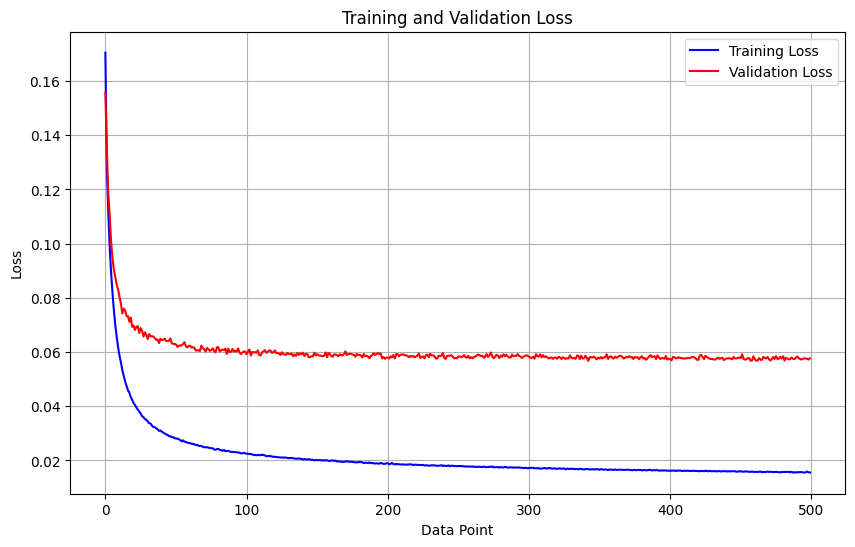

In [24]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(loss_train))
plt.figure(figsize=(10, 6))
plt.plot(x, loss_train, label='Training Loss', color='blue')
plt.plot(x, loss_valid, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Data Point')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### esm2 2560 + MolFormer
add the additional seqeunces add 4

In [43]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_2560')

In [44]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.enzy_refine_layer_1 = nn.Linear(2560, 2560) # W1 and b
        self.smiles_refine_layer_1 = nn.Linear(768, 768) # W1 and b
        self.enzy_refine_layer_2 = nn.Linear(2560, 128) # W1 and b
        self.smiles_refine_layer_2 = nn.Linear(768, 128) # W1 and b

        self.relu = nn.ReLU()
        self.batch_norm_enzy = nn.BatchNorm1d(2560)
        self.batch_norm_smiles = nn.BatchNorm1d(768)
        self.batch_norm_shared = nn.BatchNorm1d(128)

    def forward(self, enzy_embed, smiles_embed):
        refined_enzy_embed = self.enzy_refine_layer_1(enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_1(smiles_embed)

        refined_enzy_embed = self.batch_norm_enzy(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_smiles(refined_smiles_embed)

        refined_enzy_embed = self.relu(refined_enzy_embed)
        refined_smiles_embed = self.relu(refined_smiles_embed)

        refined_enzy_embed = self.enzy_refine_layer_2(refined_enzy_embed)
        refined_smiles_embed = self.smiles_refine_layer_2(refined_smiles_embed)

        refined_enzy_embed = self.batch_norm_shared(refined_enzy_embed)
        refined_smiles_embed = self.batch_norm_shared(refined_smiles_embed)
        refined_enzy_embed = torch.nn.functional.normalize(refined_enzy_embed, dim=1)
        refined_smiles_embed = torch.nn.functional.normalize(refined_smiles_embed, dim=1)

        return refined_enzy_embed, refined_smiles_embed


In [45]:
def get_ds():
    # Load the saved embeddings_results
    ESP_train_df_enzy = torch.load('ESP_train_df_enzy_esm2_2560.pt')
    ESP_val_df_enzy = torch.load('ESP_val_df_enzy_esm2_2560.pt')
    ESP_test_df_enzy = torch.load('ESP_test_df_enzy_esm2_2560.pt')
    print(ESP_train_df_enzy.shape, ESP_val_df_enzy.shape, ESP_test_df_enzy.shape)
    # Load the saved embeddings_results
    ESP_train_df_smiles = torch.load('ESP_train_df_smiles_esm2_2560.pt')
    ESP_val_df_smiles = torch.load('ESP_val_df_smiles_esm2_2560.pt')
    ESP_test_df_smiles = torch.load('ESP_test_df_smiles_esm2_2560.pt')
    print(ESP_train_df_smiles.shape, ESP_val_df_smiles.shape, ESP_test_df_smiles.shape)

    y_train = torch.load( 'ESP_train_df_label_esm2_2560.pt')
    y_val = torch.load('ESP_val_df_label_esm2_2560.pt')
    y_test = torch.load('ESP_test_df_label_esm2_2560.pt')
    print(y_train.shape,y_val.shape, y_test.shape)
    ESP_train_df_enzy_add = torch.load('ESP_train_df_enzy_>2800_<5500.pt')
    ESP_train_df_smiles_add = torch.load('ESP_train_df_smiles_>2800_<5500.pt')
    y_train_add = torch.load('ESP_train_df_label_>2800_<5500.pt')

    ESP_val_df_enzy_add = torch.load('ESP_val_df_enzy_>2800_<8000.pt')
    ESP_test_df_enzy_add = torch.load('ESP_test_df_enzy_>2800_<8000.pt')
    ESP_val_df_smiles_add = torch.load('ESP_val_df_smiles_>2800_<8000.pt')
    ESP_test_df_smiles_add = torch.load('ESP_test_df_smiles_>2800_<8000.pt')
    y_val_add = torch.load('ESP_val_df_label_>2800_<8000.pt')
    y_test_add = torch.load('ESP_test_df_label_>2800_<8000.pt')
    print(ESP_val_df_enzy_add.shape, ESP_val_df_smiles_add.shape, y_val_add.shape)
    print(ESP_test_df_enzy_add.shape, ESP_test_df_smiles_add.shape, y_test_add.shape)

    ESP_train_df_enzy = torch.cat([ESP_train_df_enzy, ESP_train_df_enzy_add], dim=0)
    ESP_train_df_smiles = torch.cat([ESP_train_df_smiles, ESP_train_df_smiles_add], dim=0)
    y_train = torch.cat([y_train, y_train_add], dim=0)
    print(ESP_train_df_enzy.shape, ESP_train_df_smiles.shape, y_train.shape)

    ESP_val_df_enzy = torch.cat([ESP_val_df_enzy, ESP_val_df_enzy_add], dim=0)
    ESP_val_df_smiles = torch.cat([ESP_val_df_smiles, ESP_val_df_smiles_add], dim=0)
    y_val = torch.cat([y_val, y_val_add], dim=0)
    print(ESP_val_df_enzy.shape, ESP_val_df_smiles.shape, y_val.shape)
    ESP_test_df_enzy = torch.cat([ESP_test_df_enzy, ESP_test_df_enzy_add], dim=0)
    ESP_test_df_smiles = torch.cat([ESP_test_df_smiles, ESP_test_df_smiles_add], dim=0)
    y_test = torch.cat([y_test, y_test_add], dim=0)
    print(ESP_test_df_enzy.shape, ESP_test_df_smiles.shape, y_test.shape)

    train_tensor_dataset = TensorDataset(ESP_train_df_enzy,ESP_train_df_smiles, y_train)
    val_tensor_dataset = TensorDataset(ESP_val_df_enzy,ESP_val_df_smiles, y_val)
    test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)

    # Create TensorDataset and DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
    print(len(train_loader))
    return train_loader,  val_loader, test_loader

In [46]:
# design the model, optimizer and loss function
model = Contrastive_learning_layer().to(device)
train_loader,  val_loader, test_loader = get_ds()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-03)
loss_fn = nn.MSELoss().to(device)

torch.Size([49881, 2560]) torch.Size([5399, 2560]) torch.Size([13312, 2560])
torch.Size([49881, 768]) torch.Size([5399, 768]) torch.Size([13312, 768])
torch.Size([49881, 1]) torch.Size([5399, 1]) torch.Size([13312, 1])
torch.Size([23, 2560]) torch.Size([23, 768]) torch.Size([23, 1])
torch.Size([24, 2560]) torch.Size([24, 768]) torch.Size([24, 1])
torch.Size([50061, 2560]) torch.Size([50061, 768]) torch.Size([50061, 1])
torch.Size([5422, 2560]) torch.Size([5422, 768]) torch.Size([5422, 1])
torch.Size([13336, 2560]) torch.Size([13336, 768]) torch.Size([13336, 1])
3129


In [48]:
initial_epoch = 0
best_epoch = -1
best_accuracy = 0.5
loss_train = []
loss_valid = []
for epoch in range(initial_epoch, 500):
    torch.cuda.empty_cache()
    model.train()

    with tqdm(train_loader, desc='Processing', unit="batch") as tepoch:
        num_batch = len(train_loader)
        loss_sum = 0
        for ESP_train_df_enzy,ESP_train_df_smiles, y_train in tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            ESP_train_df_enzy = ESP_train_df_enzy.to(device)
            ESP_train_df_smiles = ESP_train_df_smiles.to(device)
            y_train = y_train.squeeze(1).to(device)
            refined_enzy_embed, refined_smiles_embed = model(ESP_train_df_enzy,ESP_train_df_smiles)
            cosine_sim = torch.nn.functional.cosine_similarity(refined_enzy_embed, refined_smiles_embed, dim=1)
            loss = loss_fn(cosine_sim, y_train)
            loss_sum = loss_sum + loss.detach().cpu().numpy()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True) #
            tepoch.set_postfix(train_loss=loss)
            # tepoch.set_postfix(val_loss=loss_sum_val, val_accuracy=100. * acc_val, balanced_val_accuracy=100. * bacc_val)
        loss_sum = loss_sum/num_batch
        loss_train.append(loss_sum)
        loss_sum_val,acc_val, bacc_val = run_validation(model,val_loader,loss_fn, device)
        loss_valid.append(loss_sum_val)
        print('Epoch: %d / %d, ############## the best accuracy in val  %.4f at Epoch: %d  ##############'  % (epoch, 500,100 * best_accuracy,best_epoch))
        # print('Performance in Train: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum, 100 * acc))
        print('Performance in Val: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum_val, 100 * acc_val))
        # checkpoint(model, f"epoch-{epoch}.pth")
        if acc_val > best_accuracy: # compare the performance updates at the val set
            best_accuracy = acc_val
            best_epoch = epoch
            torch.save(model, "best_model_111.pt")

Epoch 0:   0%|          | 0/3129 [00:00<?, ?batch/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model_111.pt'
# Load the entire model
model_test = torch.load(load_path)
# model_test.to('cuda')
# rename the baseline model
torch.save(model_test, 'best_model_esm2_2560_add_>2800_<8000_in_valid4.pt')
run_validation(model_test,test_loader,loss_fn, device) # performance evaluation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(loss_train))
plt.figure(figsize=(10, 6))
plt.plot(x, loss_train, label='Training Loss', color='blue')
plt.plot(x, loss_valid, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Data Point')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### esm2 2560 + MolFormer
simple concatenation

In [12]:
def run_validation(model, val_loader,loss_fn, device):
    model.eval()
    loss_sum = 0
    num_batch = len(val_loader)
    total_y_true=[]
    total_y_pred=[]
    total_y_prob=[]
    for ESP_val_df_enzy,ESP_val_df_smiles, y_val in val_loader:

        ESP_val_df_enzy = ESP_val_df_enzy.to(device)
        ESP_val_df_smiles = ESP_val_df_smiles.to(device)
        y_val = y_val.squeeze(1).to(device)

        output = model(ESP_val_df_enzy,ESP_val_df_smiles)

        loss = loss_fn(output, y_val).detach().cpu().numpy()
        loss_sum = loss_sum + loss # count all the loss in the training process
        y_pred = (output > 0.5).float().cpu().numpy() # if score > 0.5, assign label 1 otherwise 0, transfer to cpu as numpy
        total_y_true.append(y_val.cpu().numpy())
        total_y_pred.append(y_pred)
        total_y_prob.append(output.detach().cpu().numpy())

    loss_sum = loss_sum/num_batch # get the overall average loss (Notice: this method is not 100% accurate)

    arrange_y_true = np.concatenate(total_y_true, axis=0)
    arrange_y_pred = np.concatenate(total_y_pred, axis=0)
    arrange_y_prob = np.concatenate(total_y_prob, axis=0)
    tn,fp,fn,tp = confusion_matrix(arrange_y_true, arrange_y_pred).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    specificity = tn/(tn+fp)
    sensitivity = tp/(tp+fn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    bacc = (sensitivity + specificity)/2
    MCC = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    AUC = roc_auc_score(arrange_y_true, arrange_y_prob)
    f1 = 2*precision*recall/(precision+recall)
    print("loss_sum= ",loss_sum, "ACC= ",acc, "bacc= ",bacc, "precision= ",precision,"specificity= ",specificity, "sensitivity= ",sensitivity, "recall= ",recall, "MCC= ",MCC, "AUC= ",AUC, "f1= ",f1)
    return loss_sum, acc, bacc   # , precision, sensitivity, recall, MCC, AUC, f1


In [13]:
import os
os.chdir('/content/drive/MyDrive/EC_number_kroll/esm2_2560')

In [14]:
import torch
import torch.nn as nn

class Contrastive_learning_layer(nn.Module):
    def __init__(self):
        super().__init__()
        # self.combined_embed_layer_1 = nn.Linear(2048, 2048)
        self.combined_embed_layer_2 = nn.Linear(3328, 128)
        self.combined_embed_layer_3 = nn.Linear(128, 1)
        # self.batch_norm_1= nn.BatchNorm1d(2048)
        # self.batch_norm_2= nn.BatchNorm1d(128)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.15)
        # self.relu_1 = nn.ReLU()
        self.relu_2 = nn.ReLU()

    def forward(self, enzy_embed, smiles_embed):
        combined_embed = torch.cat([enzy_embed, smiles_embed], dim=1)
        # combined_embed = self.combined_embed_layer_1(combined_embed)
        # combined_embed = self.batch_norm_1(combined_embed)

        # combined_embed = self.relu_1(combined_embed)
        combined_embed = self.combined_embed_layer_2(combined_embed)
        # combined_embed = self.batch_norm_2(combined_embed)
        combined_embed = self.relu_2(combined_embed)
        combined_embed = self.dropout(combined_embed)
        combined_embed = self.combined_embed_layer_3(combined_embed)
        # combined_embed = torch.nn.functional.normalize(combined_embed, dim=1)
        return self.sigmoid(combined_embed).squeeze(1)

In [15]:
def get_ds():
    # Load the saved embeddings_results
    ESP_train_df_enzy = torch.load('ESP_train_df_enzy_esm2_2560.pt')
    ESP_val_df_enzy = torch.load('ESP_val_df_enzy_esm2_2560.pt')
    ESP_test_df_enzy = torch.load('ESP_test_df_enzy_esm2_2560.pt')
    print(ESP_train_df_enzy.shape, ESP_val_df_enzy.shape, ESP_test_df_enzy.shape)
    # Load the saved embeddings_results
    ESP_train_df_smiles = torch.load('ESP_train_df_smiles_esm2_2560.pt')
    ESP_val_df_smiles = torch.load('ESP_val_df_smiles_esm2_2560.pt')
    ESP_test_df_smiles = torch.load('ESP_test_df_smiles_esm2_2560.pt')
    print(ESP_train_df_smiles.shape, ESP_val_df_smiles.shape, ESP_test_df_smiles.shape)

    y_train = torch.load( 'ESP_train_df_label_esm2_2560.pt')
    y_val = torch.load('ESP_val_df_label_esm2_2560.pt')
    y_test = torch.load('ESP_test_df_label_esm2_2560.pt')
    print(y_train.shape,y_val.shape, y_test.shape)
    ESP_train_df_enzy_add = torch.load('ESP_train_df_enzy_>2800_<5500.pt')
    ESP_train_df_smiles_add = torch.load('ESP_train_df_smiles_>2800_<5500.pt')
    y_train_add = torch.load('ESP_train_df_label_>2800_<5500.pt')

    ESP_val_df_enzy_add = torch.load('ESP_val_df_enzy_>2800_<8000.pt')
    ESP_test_df_enzy_add = torch.load('ESP_test_df_enzy_>2800_<8000.pt')
    ESP_val_df_smiles_add = torch.load('ESP_val_df_smiles_>2800_<8000.pt')
    ESP_test_df_smiles_add = torch.load('ESP_test_df_smiles_>2800_<8000.pt')
    y_val_add = torch.load('ESP_val_df_label_>2800_<8000.pt')
    y_test_add = torch.load('ESP_test_df_label_>2800_<8000.pt')
    print(ESP_val_df_enzy_add.shape, ESP_val_df_smiles_add.shape, y_val_add.shape)
    print(ESP_test_df_enzy_add.shape, ESP_test_df_smiles_add.shape, y_test_add.shape)

    ESP_train_df_enzy = torch.cat([ESP_train_df_enzy, ESP_train_df_enzy_add], dim=0)
    ESP_train_df_smiles = torch.cat([ESP_train_df_smiles, ESP_train_df_smiles_add], dim=0)
    y_train = torch.cat([y_train, y_train_add], dim=0)
    print(ESP_train_df_enzy.shape, ESP_train_df_smiles.shape, y_train.shape)

    ESP_val_df_enzy = torch.cat([ESP_val_df_enzy, ESP_val_df_enzy_add], dim=0)
    ESP_val_df_smiles = torch.cat([ESP_val_df_smiles, ESP_val_df_smiles_add], dim=0)
    y_val = torch.cat([y_val, y_val_add], dim=0)
    print(ESP_val_df_enzy.shape, ESP_val_df_smiles.shape, y_val.shape)
    ESP_test_df_enzy = torch.cat([ESP_test_df_enzy, ESP_test_df_enzy_add], dim=0)
    ESP_test_df_smiles = torch.cat([ESP_test_df_smiles, ESP_test_df_smiles_add], dim=0)
    y_test = torch.cat([y_test, y_test_add], dim=0)
    print(ESP_test_df_enzy.shape, ESP_test_df_smiles.shape, y_test.shape)

    train_tensor_dataset = TensorDataset(ESP_train_df_enzy,ESP_train_df_smiles, y_train)
    val_tensor_dataset = TensorDataset(ESP_val_df_enzy,ESP_val_df_smiles, y_val)
    test_tensor_dataset = TensorDataset(ESP_test_df_enzy, ESP_test_df_smiles, y_test)

    # Create TensorDataset and DataLoaders
    batch_size = 16
    train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
    print(len(train_loader))
    return train_loader,  val_loader, test_loader

In [16]:
# design the model, optimizer and loss function
model = Contrastive_learning_layer().to(device)
train_loader,  val_loader, test_loader = get_ds()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-03)
loss_fn = nn.BCELoss().to(device)

torch.Size([49881, 2560]) torch.Size([5399, 2560]) torch.Size([13312, 2560])
torch.Size([49881, 768]) torch.Size([5399, 768]) torch.Size([13312, 768])
torch.Size([49881, 1]) torch.Size([5399, 1]) torch.Size([13312, 1])
torch.Size([23, 2560]) torch.Size([23, 768]) torch.Size([23, 1])
torch.Size([24, 2560]) torch.Size([24, 768]) torch.Size([24, 1])
torch.Size([50061, 2560]) torch.Size([50061, 768]) torch.Size([50061, 1])
torch.Size([5422, 2560]) torch.Size([5422, 768]) torch.Size([5422, 1])
torch.Size([13336, 2560]) torch.Size([13336, 768]) torch.Size([13336, 1])
3129


In [17]:
initial_epoch = 0
best_epoch = -1
best_accuracy = 0.5
for epoch in range(initial_epoch, 500):
    torch.cuda.empty_cache()
    model.train()
    with tqdm(train_loader, desc='Processing', unit="batch") as tepoch:
        for ESP_train_df_enzy,ESP_train_df_smiles, y_train in tepoch:
            model.train()
            tepoch.set_description(f"Epoch {epoch}")
            ESP_train_df_enzy = ESP_train_df_enzy.to(device)
            ESP_train_df_smiles = ESP_train_df_smiles.to(device)
            y_train = y_train.squeeze(1).to(device)
            output = model(ESP_train_df_enzy,ESP_train_df_smiles)

            loss = loss_fn(output, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True) #
            tepoch.set_postfix(train_loss=loss)
            # tepoch.set_postfix(val_loss=loss_sum_val, val_accuracy=100. * acc_val, balanced_val_accuracy=100. * bacc_val)
        loss_sum_val,acc_val, bacc_val = run_validation(model,val_loader,loss_fn, device)
        print('Epoch: %d / %d, ############## the best accuracy in val  %.4f at Epoch: %d  ##############'  % (epoch, 500,100 * best_accuracy,best_epoch))
        # print('Performance in Train: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum, 100 * acc))
        print('Performance in Val: Loss: (%.4f); Accuracy (%.2f)' % (loss_sum_val, 100 * acc_val))
        # checkpoint(model, f"epoch-{epoch}.pth")
        if acc_val > best_accuracy: # compare the performance updates at the val set
            best_accuracy = acc_val
            best_epoch = epoch
            torch.save(model, "best_model_simple_concatenate.pt")

Epoch 0: 100%|██████████| 3129/3129 [00:18<00:00, 166.64batch/s, train_loss=tensor(0.5717, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5667580816246416 ACC=  0.7375507192917743 bacc=  0.5039158687059861 precision=  0.7222222222222222 specificity=  0.9987471811576046 sensitivity=  0.009084556254367574 recall=  0.009084556254367574 MCC=  0.06001017258279577 AUC=  0.5834687270677683 f1=  0.017943409247757072
Epoch: 0 / 500, ############## the best accuracy in val  50.0000 at Epoch: -1  ##############
Performance in Val: Loss: (0.5668); Accuracy (73.76)


Epoch 1: 100%|██████████| 3129/3129 [00:17<00:00, 182.58batch/s, train_loss=tensor(0.5686, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5446345146778411 ACC=  0.7399483585392844 bacc=  0.5080098985820822 precision=  0.8888888888888888 specificity=  0.9992483086945627 sensitivity=  0.016771488469601678 recall=  0.016771488469601678 MCC=  0.10030904301767554 AUC=  0.6324102571106442 f1=  0.03292181069958848
Epoch: 1 / 500, ############## the best accuracy in val  73.7551 at Epoch: 0  ##############
Performance in Val: Loss: (0.5446); Accuracy (73.99)


Epoch 2: 100%|██████████| 3129/3129 [00:17<00:00, 180.23batch/s, train_loss=tensor(0.7590, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5178807143528553 ACC=  0.7473257100700849 bacc=  0.5291581109908194 precision=  0.732824427480916 specificity=  0.9912302681032322 sensitivity=  0.06708595387840671 recall=  0.06708595387840671 MCC=  0.16739617595146877 AUC=  0.719704853040235 f1=  0.12291933418693983
Epoch: 2 / 500, ############## the best accuracy in val  73.9948 at Epoch: 1  ##############
Performance in Val: Loss: (0.5179); Accuracy (74.73)


Epoch 3: 100%|██████████| 3129/3129 [00:17<00:00, 182.38batch/s, train_loss=tensor(0.4635, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.48438509223999177 ACC=  0.750276650682405 bacc=  0.53923108965823 precision=  0.7058823529411765 specificity=  0.9862189927336508 sensitivity=  0.09224318658280922 recall=  0.09224318658280922 MCC=  0.1895142631107411 AUC=  0.7690512948333611 f1=  0.16316440049443756
Epoch: 3 / 500, ############## the best accuracy in val  74.7326 at Epoch: 2  ##############
Performance in Val: Loss: (0.4844); Accuracy (75.03)


Epoch 4: 100%|██████████| 3129/3129 [00:17<00:00, 179.83batch/s, train_loss=tensor(0.2920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.46019068039448213 ACC=  0.7757285134636666 bacc=  0.5861043742550718 precision=  0.8434504792332268 specificity=  0.9877223753445252 sensitivity=  0.18448637316561844 recall=  0.18448637316561844 MCC=  0.3254436269078633 AUC=  0.8042175082615128 f1=  0.3027522935779816
Epoch: 4 / 500, ############## the best accuracy in val  75.0277 at Epoch: 3  ##############
Performance in Val: Loss: (0.4602); Accuracy (77.57)


Epoch 5: 100%|██████████| 3129/3129 [00:17<00:00, 181.30batch/s, train_loss=tensor(0.3438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.43643142071972907 ACC=  0.799151604573958 bacc=  0.6488571157921535 precision=  0.7831125827814569 specificity=  0.9671761463292408 sensitivity=  0.3305380852550664 recall=  0.3305380852550664 MCC=  0.4170694787999558 AUC=  0.8292719590427169 f1=  0.4648648648648649
Epoch: 5 / 500, ############## the best accuracy in val  77.5729 at Epoch: 4  ##############
Performance in Val: Loss: (0.4364); Accuracy (79.92)


Epoch 6: 100%|██████████| 3129/3129 [00:17<00:00, 178.11batch/s, train_loss=tensor(0.3967, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4327179863499505 ACC=  0.7812615271117669 bacc=  0.6017414094360809 precision=  0.8149100257069408 specificity=  0.9819594086695064 sensitivity=  0.22152341020265548 recall=  0.22152341020265548 MCC=  0.3475362896768052 AUC=  0.8376445710045365 f1=  0.34835164835164834
Epoch: 6 / 500, ############## the best accuracy in val  79.9152 at Epoch: 5  ##############
Performance in Val: Loss: (0.4327); Accuracy (78.13)


Epoch 7: 100%|██████████| 3129/3129 [00:17<00:00, 180.80batch/s, train_loss=tensor(0.3597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4087078580550388 ACC=  0.8210992253780892 bacc=  0.715986581268371 precision=  0.7423764458464774 specificity=  0.9386118767226259 sensitivity=  0.493361285814116 recall=  0.493361285814116 MCC=  0.5006392017547592 AUC=  0.8627849068510367 f1=  0.5927791771620488
Epoch: 7 / 500, ############## the best accuracy in val  79.9152 at Epoch: 5  ##############
Performance in Val: Loss: (0.4087); Accuracy (82.11)


Epoch 8: 100%|██████████| 3129/3129 [00:17<00:00, 178.85batch/s, train_loss=tensor(0.3687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3973582959939948 ACC=  0.816119513094799 bacc=  0.7238101766710949 precision=  0.7012987012987013 specificity=  0.9193184665497369 sensitivity=  0.5283018867924528 recall=  0.5283018867924528 MCC=  0.49432914627995594 AUC=  0.8693689907813195 f1=  0.6026305300916701
Epoch: 8 / 500, ############## the best accuracy in val  82.1099 at Epoch: 7  ##############
Performance in Val: Loss: (0.3974); Accuracy (81.61)


Epoch 9: 100%|██████████| 3129/3129 [00:17<00:00, 179.59batch/s, train_loss=tensor(0.4086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3829735375633106 ACC=  0.8314275175212099 bacc=  0.7413805450803792 precision=  0.7440982058545798 specificity=  0.9320972187421699 sensitivity=  0.5506638714185884 recall=  0.5506638714185884 MCC=  0.5367256536323114 AUC=  0.8787077878406009 f1=  0.6329317269076304
Epoch: 9 / 500, ############## the best accuracy in val  82.1099 at Epoch: 7  ##############
Performance in Val: Loss: (0.3830); Accuracy (83.14)


Epoch 10: 100%|██████████| 3129/3129 [00:17<00:00, 181.32batch/s, train_loss=tensor(0.4924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.37899549681264744 ACC=  0.8316119513094798 bacc=  0.7280583794319889 precision=  0.7761194029850746 specificity=  0.9473816086193937 sensitivity=  0.5087351502445842 recall=  0.5087351502445842 MCC=  0.5314990458525337 AUC=  0.8816385609760327 f1=  0.6146053186998734
Epoch: 10 / 500, ############## the best accuracy in val  83.1428 at Epoch: 9  ##############
Performance in Val: Loss: (0.3790); Accuracy (83.16)


Epoch 11: 100%|██████████| 3129/3129 [00:17<00:00, 178.88batch/s, train_loss=tensor(0.3680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3656178317019018 ACC=  0.8382515676872003 bacc=  0.7482572160526804 precision=  0.7658349328214972 specificity=  0.938862440491105 sensitivity=  0.5576519916142557 recall=  0.5576519916142557 MCC=  0.555420164349246 AUC=  0.8904907635471215 f1=  0.6453699959563284
Epoch: 11 / 500, ############## the best accuracy in val  83.1612 at Epoch: 10  ##############
Performance in Val: Loss: (0.3656); Accuracy (83.83)


Epoch 12: 100%|██████████| 3129/3129 [00:17<00:00, 178.95batch/s, train_loss=tensor(0.2552, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.36071847627010845 ACC=  0.8308742161563999 bacc=  0.7199370316265405 precision=  0.7940503432494279 specificity=  0.954898521673766 sensitivity=  0.48497554157931516 recall=  0.48497554157931516 MCC=  0.5272578949661312 AUC=  0.8966946244003584 f1=  0.6021691973969632
Epoch: 12 / 500, ############## the best accuracy in val  83.8252 at Epoch: 11  ##############
Performance in Val: Loss: (0.3607); Accuracy (83.09)


Epoch 13: 100%|██████████| 3129/3129 [00:17<00:00, 178.37batch/s, train_loss=tensor(0.2099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3559661282880292 ACC=  0.8428624123939505 bacc=  0.7634919659380357 precision=  0.7573333333333333 specificity=  0.9315960912052117 sensitivity=  0.5953878406708596 recall=  0.5953878406708596 MCC=  0.5727948652875612 AUC=  0.8980736881603454 f1=  0.6666666666666666
Epoch: 13 / 500, ############## the best accuracy in val  83.8252 at Epoch: 11  ##############
Performance in Val: Loss: (0.3560); Accuracy (84.29)


Epoch 14: 100%|██████████| 3129/3129 [00:17<00:00, 179.14batch/s, train_loss=tensor(0.2687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.35872743747974567 ACC=  0.8413869420877905 bacc=  0.7631620832407509 precision=  0.7506584723441615 specificity=  0.9288398897519419 sensitivity=  0.5974842767295597 recall=  0.5974842767295597 MCC=  0.5694794971628804 AUC=  0.8955441497387291 f1=  0.6653696498054474
Epoch: 14 / 500, ############## the best accuracy in val  84.2862 at Epoch: 13  ##############
Performance in Val: Loss: (0.3587); Accuracy (84.14)


Epoch 15: 100%|██████████| 3129/3129 [00:17<00:00, 178.30batch/s, train_loss=tensor(0.5062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.34062129403615593 ACC=  0.850055330136481 bacc=  0.784963144713621 precision=  0.7504051863857374 specificity=  0.922826359308444 sensitivity=  0.6470999301187981 recall=  0.6470999301187981 MCC=  0.5991263973211335 AUC=  0.907706823231376 f1=  0.6949343339587242
Epoch: 15 / 500, ############## the best accuracy in val  84.2862 at Epoch: 13  ##############
Performance in Val: Loss: (0.3406); Accuracy (85.01)


Epoch 16: 100%|██████████| 3129/3129 [00:17<00:00, 178.75batch/s, train_loss=tensor(0.3541, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3539515407453772 ACC=  0.8395426042050904 bacc=  0.7863387940826327 precision=  0.7051938551572787 specificity=  0.8990228013029316 sensitivity=  0.673654786862334 recall=  0.673654786862334 MCC=  0.5812877643184442 AUC=  0.8987381811731882 f1=  0.6890636168691924
Epoch: 16 / 500, ############## the best accuracy in val  85.0055 at Epoch: 15  ##############
Performance in Val: Loss: (0.3540); Accuracy (83.95)


Epoch 17: 100%|██████████| 3129/3129 [00:17<00:00, 177.71batch/s, train_loss=tensor(0.3805, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3356195892286995 ACC=  0.8511619328661011 bacc=  0.7736121332396915 precision=  0.7785714285714286 specificity=  0.9378601854171886 sensitivity=  0.6093640810621943 recall=  0.6093640810621943 MCC=  0.5957743674041255 AUC=  0.9101520524604539 f1=  0.6836534692277538
Epoch: 17 / 500, ############## the best accuracy in val  85.0055 at Epoch: 15  ##############
Performance in Val: Loss: (0.3356); Accuracy (85.12)


Epoch 18: 100%|██████████| 3129/3129 [00:17<00:00, 178.23batch/s, train_loss=tensor(0.5088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3405429976044503 ACC=  0.8520841018074511 bacc=  0.7767039080418713 precision=  0.7766051011433597 specificity=  0.9363568028063142 sensitivity=  0.6170510132774284 recall=  0.6170510132774284 MCC=  0.5991703635293758 AUC=  0.9076555198182632 f1=  0.6876947040498442
Epoch: 18 / 500, ############## the best accuracy in val  85.1162 at Epoch: 17  ##############
Performance in Val: Loss: (0.3405); Accuracy (85.21)


Epoch 19: 100%|██████████| 3129/3129 [00:17<00:00, 176.44batch/s, train_loss=tensor(0.4203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.33137580768306873 ACC=  0.8557727775728513 bacc=  0.8065526890430093 precision=  0.7384276267450404 specificity=  0.9107992984214482 sensitivity=  0.7023060796645703 recall=  0.7023060796645703 MCC=  0.6232327246318712 AUC=  0.9126221454597092 f1=  0.7199140401146131
Epoch: 19 / 500, ############## the best accuracy in val  85.2084 at Epoch: 18  ##############
Performance in Val: Loss: (0.3314); Accuracy (85.58)


Epoch 20: 100%|██████████| 3129/3129 [00:17<00:00, 178.91batch/s, train_loss=tensor(0.2446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3514135818122158 ACC=  0.8478421246772408 bacc=  0.756564867037487 precision=  0.8011928429423459 specificity=  0.9498872463041844 sensitivity=  0.5632424877707897 recall=  0.5632424877707897 MCC=  0.5818008337581622 AUC=  0.9078799065892668 f1=  0.6614690192860074
Epoch: 20 / 500, ############## the best accuracy in val  85.5773 at Epoch: 19  ##############
Performance in Val: Loss: (0.3514); Accuracy (84.78)


Epoch 21: 100%|██████████| 3129/3129 [00:17<00:00, 177.95batch/s, train_loss=tensor(0.5358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.32511391596055444 ACC=  0.8635189966801918 bacc=  0.7994877012761592 precision=  0.7857733664185277 specificity=  0.9351039839639188 sensitivity=  0.6638714185883997 recall=  0.6638714185883997 MCC=  0.6342504570484161 AUC=  0.916477693258469 f1=  0.7196969696969696
Epoch: 21 / 500, ############## the best accuracy in val  85.5773 at Epoch: 19  ##############
Performance in Val: Loss: (0.3251); Accuracy (86.35)


Epoch 22: 100%|██████████| 3129/3129 [00:17<00:00, 178.22batch/s, train_loss=tensor(0.2284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.326742315961592 ACC=  0.849502028771671 bacc=  0.8092409528707236 precision=  0.7110501029512697 specificity=  0.8945126534703082 sensitivity=  0.7239692522711391 recall=  0.7239692522711391 MCC=  0.6149450464872105 AUC=  0.9157525291444535 f1=  0.7174515235457063
Epoch: 22 / 500, ############## the best accuracy in val  86.3519 at Epoch: 21  ##############
Performance in Val: Loss: (0.3267); Accuracy (84.95)


Epoch 23: 100%|██████████| 3129/3129 [00:17<00:00, 178.01batch/s, train_loss=tensor(0.2563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3400604731779666 ACC=  0.8572482478790114 bacc=  0.7707985875277374 precision=  0.8204878048780487 specificity=  0.9538962665998496 sensitivity=  0.5877009084556254 recall=  0.5877009084556254 MCC=  0.6096729205761772 AUC=  0.9144813251198846 f1=  0.6848534201954397
Epoch: 23 / 500, ############## the best accuracy in val  86.3519 at Epoch: 21  ##############
Performance in Val: Loss: (0.3401); Accuracy (85.72)


Epoch 24: 100%|██████████| 3129/3129 [00:17<00:00, 178.03batch/s, train_loss=tensor(0.2180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3166646027118847 ACC=  0.8684987089634821 bacc=  0.8199037456919578 precision=  0.7691154422788605 specificity=  0.922826359308444 sensitivity=  0.7169811320754716 recall=  0.7169811320754716 MCC=  0.6547517129123752 AUC=  0.9218271684315567 f1=  0.742133815551537
Epoch: 24 / 500, ############## the best accuracy in val  86.3519 at Epoch: 21  ##############
Performance in Val: Loss: (0.3167); Accuracy (86.85)


Epoch 25: 100%|██████████| 3129/3129 [00:17<00:00, 178.69batch/s, train_loss=tensor(0.3702, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.309268128166695 ACC=  0.8686831427517521 bacc=  0.8242873859615301 precision=  0.762217359591539 specificity=  0.9183162114758205 sensitivity=  0.7302585604472397 recall=  0.7302585604472397 MCC=  0.6576894621039482 AUC=  0.9261280753813481 f1=  0.7458957887223412
Epoch: 25 / 500, ############## the best accuracy in val  86.8499 at Epoch: 24  ##############
Performance in Val: Loss: (0.3093); Accuracy (86.87)


Epoch 26: 100%|██████████| 3129/3129 [00:17<00:00, 174.23batch/s, train_loss=tensor(0.3247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3164496618312039 ACC=  0.8657322021394319 bacc=  0.8097319247832431 precision=  0.7756862745098039 specificity=  0.9283387622149837 sensitivity=  0.6911250873515025 recall=  0.6911250873515025 MCC=  0.6438052854099963 AUC=  0.9241746060011686 f1=  0.7309682187730969
Epoch: 26 / 500, ############## the best accuracy in val  86.8683 at Epoch: 25  ##############
Performance in Val: Loss: (0.3164); Accuracy (86.57)


Epoch 27: 100%|██████████| 3129/3129 [00:17<00:00, 178.77batch/s, train_loss=tensor(0.5781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.32172675906326126 ACC=  0.8622279601623017 bacc=  0.7851632805538528 precision=  0.8120437956204379 specificity=  0.94838386369331 sensitivity=  0.6219426974143956 recall=  0.6219426974143956 MCC=  0.6259443793612801 AUC=  0.9239434779967015 f1=  0.704392560348239
Epoch: 27 / 500, ############## the best accuracy in val  86.8683 at Epoch: 25  ##############
Performance in Val: Loss: (0.3217); Accuracy (86.22)


Epoch 28: 100%|██████████| 3129/3129 [00:17<00:00, 177.31batch/s, train_loss=tensor(0.1984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.33816317958581454 ACC=  0.8485798598303209 bacc=  0.7902363651549319 precision=  0.7349768875192604 specificity=  0.9138060636431972 sensitivity=  0.6666666666666666 recall=  0.6666666666666666 MCC=  0.5995781921638158 AUC=  0.9113941028390047 f1=  0.6991572004397216
Epoch: 28 / 500, ############## the best accuracy in val  86.8683 at Epoch: 25  ##############
Performance in Val: Loss: (0.3382); Accuracy (84.86)


Epoch 29: 100%|██████████| 3129/3129 [00:17<00:00, 177.17batch/s, train_loss=tensor(0.2818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.32002894823291067 ACC=  0.8710807819992623 bacc=  0.7940904246294204 precision=  0.840782122905028 specificity=  0.9571535955900776 sensitivity=  0.6310272536687631 recall=  0.6310272536687631 MCC=  0.6504660773560362 AUC=  0.9311832125426864 f1=  0.7209580838323354
Epoch: 29 / 500, ############## the best accuracy in val  86.8683 at Epoch: 25  ##############
Performance in Val: Loss: (0.3200); Accuracy (87.11)


Epoch 30: 100%|██████████| 3129/3129 [00:17<00:00, 175.59batch/s, train_loss=tensor(0.1332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.29856778279902924 ACC=  0.8788270011066027 bacc=  0.8484354472615796 precision=  0.763265306122449 specificity=  0.9128038085692809 sensitivity=  0.7840670859538784 recall=  0.7840670859538784 MCC=  0.6909488074881738 AUC=  0.9332286078337336 f1=  0.7735263702171665
Epoch: 30 / 500, ############## the best accuracy in val  87.1081 at Epoch: 29  ##############
Performance in Val: Loss: (0.2986); Accuracy (87.88)


Epoch 31: 100%|██████████| 3129/3129 [00:17<00:00, 177.65batch/s, train_loss=tensor(0.1455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3120779105346062 ACC=  0.8657322021394319 bacc=  0.8191451380560839 precision=  0.7586460632818248 specificity=  0.9178150839388625 sensitivity=  0.7204751921733054 recall=  0.7204751921733054 MCC=  0.6491510584611717 AUC=  0.9247171439722603 f1=  0.739068100358423
Epoch: 31 / 500, ############## the best accuracy in val  87.8827 at Epoch: 30  ##############
Performance in Val: Loss: (0.3121); Accuracy (86.57)


Epoch 32: 100%|██████████| 3129/3129 [00:17<00:00, 176.79batch/s, train_loss=tensor(0.1316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.30247559826711196 ACC=  0.8747694577646625 bacc=  0.8344730395311184 precision=  0.7701149425287356 specificity=  0.9198195940866951 sensitivity=  0.7491264849755416 recall=  0.7491264849755416 MCC=  0.6749625122723064 AUC=  0.9307341763552199 f1=  0.7594757350336521
Epoch: 32 / 500, ############## the best accuracy in val  87.8827 at Epoch: 30  ##############
Performance in Val: Loss: (0.3025); Accuracy (87.48)


Epoch 33: 100%|██████████| 3129/3129 [00:17<00:00, 179.72batch/s, train_loss=tensor(0.1984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.304134558261287 ACC=  0.8784581335300627 bacc=  0.8338409394582955 precision=  0.7872023809523809 specificity=  0.9283387622149837 sensitivity=  0.7393431167016072 recall=  0.7393431167016072 MCC=  0.6815645997164359 AUC=  0.9334807474749702 f1=  0.7625225225225225
Epoch: 33 / 500, ############## the best accuracy in val  87.8827 at Epoch: 30  ##############
Performance in Val: Loss: (0.3041); Accuracy (87.85)


Epoch 34: 100%|██████████| 3129/3129 [00:17<00:00, 175.82batch/s, train_loss=tensor(0.4979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31067535518682327 ACC=  0.8694208779048321 bacc=  0.8382359610311181 precision=  0.7431069266980498 specificity=  0.9042846404409922 sensitivity=  0.7721872816212438 recall=  0.7721872816212438 MCC=  0.6683171462364221 AUC=  0.9272844157915758 f1=  0.7573680603152844
Epoch: 34 / 500, ############## the best accuracy in val  87.8827 at Epoch: 30  ##############
Performance in Val: Loss: (0.3107); Accuracy (86.94)


Epoch 35: 100%|██████████| 3129/3129 [00:17<00:00, 177.86batch/s, train_loss=tensor(0.3188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.30566256570253403 ACC=  0.8801180376244928 bacc=  0.827572380273505 precision=  0.8077226162332545 specificity=  0.938862440491105 sensitivity=  0.716282320055905 recall=  0.716282320055905 MCC=  0.6820028292636057 AUC=  0.9324657978705057 f1=  0.7592592592592593
Epoch: 35 / 500, ############## the best accuracy in val  87.8827 at Epoch: 30  ##############
Performance in Val: Loss: (0.3057); Accuracy (88.01)


Epoch 36: 100%|██████████| 3129/3129 [00:17<00:00, 178.27batch/s, train_loss=tensor(0.1870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.30201947221128617 ACC=  0.8769826632239026 bacc=  0.8362005462675366 precision=  0.776410998552822 specificity=  0.9225757955399649 sensitivity=  0.7498252969951084 recall=  0.7498252969951084 MCC=  0.6800555466087852 AUC=  0.9327973439890347 f1=  0.7628865979381444
Epoch: 36 / 500, ############## the best accuracy in val  88.0118 at Epoch: 35  ##############
Performance in Val: Loss: (0.3020); Accuracy (87.70)


Epoch 37: 100%|██████████| 3129/3129 [00:17<00:00, 177.45batch/s, train_loss=tensor(0.0855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3068361731567544 ACC=  0.8731095536702324 bacc=  0.8360349920794885 precision=  0.7607017543859649 specificity=  0.9145577549486344 sensitivity=  0.7575122292103424 recall=  0.7575122292103424 MCC=  0.6729777006121497 AUC=  0.9311424149479586 f1=  0.7591036414565827
Epoch: 37 / 500, ############## the best accuracy in val  88.0118 at Epoch: 35  ##############
Performance in Val: Loss: (0.3068); Accuracy (87.31)


Epoch 38: 100%|██████████| 3129/3129 [00:17<00:00, 177.54batch/s, train_loss=tensor(0.6796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3206077246070952 ACC=  0.8720029509406123 bacc=  0.8283354528821925 precision=  0.7691745799853908 specificity=  0.9208218491606114 sensitivity=  0.7358490566037735 recall=  0.7358490566037735 MCC=  0.6662211715771429 AUC=  0.928126807329069 f1=  0.7521428571428571
Epoch: 38 / 500, ############## the best accuracy in val  88.0118 at Epoch: 35  ##############
Performance in Val: Loss: (0.3206); Accuracy (87.20)


Epoch 39: 100%|██████████| 3129/3129 [00:17<00:00, 177.81batch/s, train_loss=tensor(0.4445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.303583531338271 ACC=  0.8745850239763925 bacc=  0.8399508607854745 precision=  0.7602217602217602 specificity=  0.9133049361062391 sensitivity=  0.76659678546471 recall=  0.76659678546471 MCC=  0.6780889800395861 AUC=  0.9328827913118981 f1=  0.7633959638135004
Epoch: 39 / 500, ############## the best accuracy in val  88.0118 at Epoch: 35  ##############
Performance in Val: Loss: (0.3036); Accuracy (87.46)


Epoch 40: 100%|██████████| 3129/3129 [00:18<00:00, 173.72batch/s, train_loss=tensor(0.1417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3178746718920185 ACC=  0.8705274806344522 bacc=  0.8239713359251187 precision=  0.7706013363028953 specificity=  0.9225757955399649 sensitivity=  0.7253668763102725 recall=  0.7253668763102725 MCC=  0.6609211635829707 AUC=  0.929144733582076 f1=  0.7473002159827212
Epoch: 40 / 500, ############## the best accuracy in val  88.0118 at Epoch: 35  ##############
Performance in Val: Loss: (0.3179); Accuracy (87.05)


Epoch 41: 100%|██████████| 3129/3129 [00:18<00:00, 171.54batch/s, train_loss=tensor(0.1648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31082335791885746 ACC=  0.8751383253412025 bacc=  0.8279998795332826 precision=  0.7834586466165413 specificity=  0.9278376346780256 sensitivity=  0.7281621243885394 recall=  0.7281621243885394 MCC=  0.6720022507355387 AUC=  0.9300494596419862 f1=  0.754798985874683
Epoch: 41 / 500, ############## the best accuracy in val  88.0118 at Epoch: 35  ##############
Performance in Val: Loss: (0.3108); Accuracy (87.51)


Epoch 42: 100%|██████████| 3129/3129 [00:17<00:00, 178.52batch/s, train_loss=tensor(0.1703, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3097102715117667 ACC=  0.8788270011066027 bacc=  0.8370051168588444 precision=  0.7828947368421053 specificity=  0.9255825607617139 sensitivity=  0.7484276729559748 recall=  0.7484276729559748 MCC=  0.683978185150965 AUC=  0.9329481024828575 f1=  0.765273311897106
Epoch: 42 / 500, ############## the best accuracy in val  88.0118 at Epoch: 35  ##############
Performance in Val: Loss: (0.3097); Accuracy (87.88)


Epoch 43: 100%|██████████| 3129/3129 [00:18<00:00, 172.69batch/s, train_loss=tensor(0.3066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3096829117316983 ACC=  0.8753227591294725 bacc=  0.8382107470669944 precision=  0.7660324171952079 specificity=  0.9168128288649461 sensitivity=  0.7596086652690426 recall=  0.7596086652690426 MCC=  0.6782566919594198 AUC=  0.9316521222365975 f1=  0.7628070175438597
Epoch: 43 / 500, ############## the best accuracy in val  88.0118 at Epoch: 35  ##############
Performance in Val: Loss: (0.3097); Accuracy (87.53)


Epoch 44: 100%|██████████| 3129/3129 [00:17<00:00, 178.21batch/s, train_loss=tensor(0.0828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3092231846110247 ACC=  0.8793803024714127 bacc=  0.8286401216153536 precision=  0.8018648018648019 specificity=  0.9361062390378351 sensitivity=  0.7211740041928721 recall=  0.7211740041928721 MCC=  0.6809014024125252 AUC=  0.934697496340911 f1=  0.7593818984547461
Epoch: 44 / 500, ############## the best accuracy in val  88.0118 at Epoch: 35  ##############
Performance in Val: Loss: (0.3092); Accuracy (87.94)


Epoch 45: 100%|██████████| 3129/3129 [00:17<00:00, 176.59batch/s, train_loss=tensor(0.0783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3072042683016503 ACC=  0.8825156768720029 bacc=  0.8390625062925474 precision=  0.7953869047619048 specificity=  0.9310949636682536 sensitivity=  0.7470300489168413 recall=  0.7470300489168413 MCC=  0.6922248713866939 AUC=  0.9365952848836506 f1=  0.7704504504504506
Epoch: 45 / 500, ############## the best accuracy in val  88.0118 at Epoch: 35  ##############
Performance in Val: Loss: (0.3072); Accuracy (88.25)


Epoch 46: 100%|██████████| 3129/3129 [00:17<00:00, 179.76batch/s, train_loss=tensor(0.4741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3078870425752164 ACC=  0.8823312430837329 bacc=  0.8277310181311165 precision=  0.8184738955823293 specificity=  0.9433725883237284 sensitivity=  0.7120894479385046 recall=  0.7120894479385046 MCC=  0.686896510705787 AUC=  0.9381588133047787 f1=  0.7615844544095666
Epoch: 46 / 500, ############## the best accuracy in val  88.2516 at Epoch: 45  ##############
Performance in Val: Loss: (0.3079); Accuracy (88.23)


Epoch 47: 100%|██████████| 3129/3129 [00:17<00:00, 174.21batch/s, train_loss=tensor(0.2252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.32168012180785954 ACC=  0.8651789007746219 bacc=  0.8104766997582437 precision=  0.7717391304347826 specificity=  0.9263342520671511 sensitivity=  0.6946191474493362 recall=  0.6946191474493362 MCC=  0.64309705704626 AUC=  0.9286274971235946 f1=  0.7311511585141596
Epoch: 47 / 500, ############## the best accuracy in val  88.2516 at Epoch: 45  ##############
Performance in Val: Loss: (0.3217); Accuracy (86.52)


Epoch 48: 100%|██████████| 3129/3129 [00:17<00:00, 178.90batch/s, train_loss=tensor(0.2632, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.30118780699936304 ACC=  0.8812246403541129 bacc=  0.83639254009852 precision=  0.7947565543071161 specificity=  0.9313455274367326 sensitivity=  0.7414395527603075 recall=  0.7414395527603075 MCC=  0.6883258519485124 AUC=  0.9364223766227332 f1=  0.767172812725958
Epoch: 48 / 500, ############## the best accuracy in val  88.2516 at Epoch: 45  ##############
Performance in Val: Loss: (0.3012); Accuracy (88.12)


Epoch 49: 100%|██████████| 3129/3129 [00:18<00:00, 173.62batch/s, train_loss=tensor(0.1648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.28956732517355577 ACC=  0.8882331243083733 bacc=  0.8631174160029178 precision=  0.7762893503014066 specificity=  0.916311701327988 sensitivity=  0.8099231306778477 recall=  0.8099231306778477 MCC=  0.7165835552713173 AUC=  0.9405490620843088 f1=  0.7927496580027359
Epoch: 49 / 500, ############## the best accuracy in val  88.2516 at Epoch: 45  ##############
Performance in Val: Loss: (0.2896); Accuracy (88.82)


Epoch 50: 100%|██████████| 3129/3129 [00:17<00:00, 175.24batch/s, train_loss=tensor(0.0272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3089002092239436 ACC=  0.8808557727775729 bacc=  0.8356937280789534 precision=  0.7944486121530383 specificity=  0.9313455274367326 sensitivity=  0.740041928721174 recall=  0.740041928721174 MCC=  0.6872429187801207 AUC=  0.9378135220738626 f1=  0.7662807525325614
Epoch: 50 / 500, ############## the best accuracy in val  88.8233 at Epoch: 49  ##############
Performance in Val: Loss: (0.3089); Accuracy (88.09)


Epoch 51: 100%|██████████| 3129/3129 [00:17<00:00, 178.05batch/s, train_loss=tensor(0.0624, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.2986253839386057 ACC=  0.8849133161195131 bacc=  0.85055263231159 precision=  0.7843551797040169 specificity=  0.9233274868454021 sensitivity=  0.7777777777777778 recall=  0.7777777777777778 MCC=  0.7030074319377803 AUC=  0.93839843351244 f1=  0.7810526315789473
Epoch: 51 / 500, ############## the best accuracy in val  88.8233 at Epoch: 49  ##############
Performance in Val: Loss: (0.2986); Accuracy (88.49)


Epoch 52: 100%|██████████| 3129/3129 [00:17<00:00, 175.48batch/s, train_loss=tensor(0.2770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.289276482340616 ACC=  0.8891552932497233 bacc=  0.8556753569045377 precision=  0.7930790960451978 specificity=  0.9265848158356301 sensitivity=  0.7847658979734451 recall=  0.7847658979734451 MCC=  0.713768459702464 AUC=  0.9423684947315947 f1=  0.7889005971197752
Epoch: 52 / 500, ############## the best accuracy in val  88.8233 at Epoch: 49  ##############
Performance in Val: Loss: (0.2893); Accuracy (88.92)


Epoch 53: 100%|██████████| 3129/3129 [00:17<00:00, 178.18batch/s, train_loss=tensor(0.1802, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.2981846862882795 ACC=  0.8867576540022132 bacc=  0.8405992448767938 precision=  0.812070282658518 specificity=  0.9383613129541468 sensitivity=  0.742837176799441 recall=  0.742837176799441 MCC=  0.7015928899671453 AUC=  0.9411492945080309 f1=  0.7759124087591243
Epoch: 53 / 500, ############## the best accuracy in val  88.9155 at Epoch: 52  ##############
Performance in Val: Loss: (0.2982); Accuracy (88.68)


Epoch 54: 100%|██████████| 3129/3129 [00:17<00:00, 175.99batch/s, train_loss=tensor(0.2583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.2933978372597143 ACC=  0.8924751014385836 bacc=  0.8514308311800782 precision=  0.8164179104477612 specificity=  0.9383613129541468 sensitivity=  0.7645003494060097 recall=  0.7645003494060097 MCC=  0.7181937753522522 AUC=  0.9429986687377137 f1=  0.7896066402020931
Epoch: 54 / 500, ############## the best accuracy in val  88.9155 at Epoch: 52  ##############
Performance in Val: Loss: (0.2934); Accuracy (89.25)


Epoch 55: 100%|██████████| 3129/3129 [00:17<00:00, 179.64batch/s, train_loss=tensor(0.1700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.2955442156854215 ACC=  0.8845444485429731 bacc=  0.8597152818159517 precision=  0.7674418604651163 specificity=  0.9123026810323227 sensitivity=  0.8071278825995807 recall=  0.8071278825995807 MCC=  0.7081161983072484 AUC=  0.9403589067715428 f1=  0.7867847411444141
Epoch: 55 / 500, ############## the best accuracy in val  89.2475 at Epoch: 54  ##############
Performance in Val: Loss: (0.2955); Accuracy (88.45)


Epoch 56: 100%|██████████| 3129/3129 [00:17<00:00, 175.72batch/s, train_loss=tensor(0.2704, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.28707156143430074 ACC=  0.8900774621910734 bacc=  0.8670597243518392 precision=  0.7770404777704047 specificity=  0.9158105737910298 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.7222788555172382 AUC=  0.9433654968963185 f1=  0.79714091218516
Epoch: 56 / 500, ############## the best accuracy in val  89.2475 at Epoch: 54  ##############
Performance in Val: Loss: (0.2871); Accuracy (89.01)


Epoch 57: 100%|██████████| 3129/3129 [00:17<00:00, 178.70batch/s, train_loss=tensor(0.1840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.29552823996891137 ACC=  0.8858354850608632 bacc=  0.8538685312393136 precision=  0.782336578581363 specificity=  0.9215735404660486 sensitivity=  0.7861635220125787 recall=  0.7861635220125787 MCC=  0.7066323438853185 AUC=  0.9414797024962351 f1=  0.7842453816660857
Epoch: 57 / 500, ############## the best accuracy in val  89.2475 at Epoch: 54  ##############
Performance in Val: Loss: (0.2955); Accuracy (88.58)


Epoch 58: 100%|██████████| 3129/3129 [00:17<00:00, 175.24batch/s, train_loss=tensor(0.1595, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3036124923686802 ACC=  0.8860199188491331 bacc=  0.8555626820023599 precision=  0.7801516195727085 specificity=  0.9200701578551741 sensitivity=  0.7910552061495457 recall=  0.7910552061495457 MCC=  0.7079836040026328 AUC=  0.9392407375014468 f1=  0.7855655794587093
Epoch: 58 / 500, ############## the best accuracy in val  89.2475 at Epoch: 54  ##############
Performance in Val: Loss: (0.3036); Accuracy (88.60)


Epoch 59: 100%|██████████| 3129/3129 [00:17<00:00, 175.65batch/s, train_loss=tensor(0.0946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3046111426770187 ACC=  0.8825156768720029 bacc=  0.8381660097903721 precision=  0.7971556886227545 specificity=  0.9320972187421699 sensitivity=  0.7442348008385744 recall=  0.7442348008385744 MCC=  0.6917803460717631 AUC=  0.9394259900989665 f1=  0.7697867726779906
Epoch: 59 / 500, ############## the best accuracy in val  89.2475 at Epoch: 54  ##############
Performance in Val: Loss: (0.3046); Accuracy (88.25)


Epoch 60: 100%|██████████| 3129/3129 [00:17<00:00, 175.00batch/s, train_loss=tensor(0.3945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.30048747126536396 ACC=  0.8869420877904832 bacc=  0.8530513536659441 precision=  0.7884344146685472 specificity=  0.9248308694562766 sensitivity=  0.7812718378756115 recall=  0.7812718378756115 MCC=  0.7081795925059424 AUC=  0.9408157347743114 f1=  0.7848367848367849
Epoch: 60 / 500, ############## the best accuracy in val  89.2475 at Epoch: 54  ##############
Performance in Val: Loss: (0.3005); Accuracy (88.69)


Epoch 61: 100%|██████████| 3129/3129 [00:17<00:00, 177.45batch/s, train_loss=tensor(0.1214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.2961858932731933 ACC=  0.8943194393212837 bacc=  0.8578385049099817 precision=  0.8117732558139535 specificity=  0.9351039839639188 sensitivity=  0.7805730258560447 recall=  0.7805730258560447 MCC=  0.724862430468337 AUC=  0.9453000558034054 f1=  0.7958674741717136
Epoch: 61 / 500, ############## the best accuracy in val  89.2475 at Epoch: 54  ##############
Performance in Val: Loss: (0.2962); Accuracy (89.43)


Epoch 62: 100%|██████████| 3129/3129 [00:17<00:00, 175.87batch/s, train_loss=tensor(0.2628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3191236435192923 ACC=  0.8795647362596828 bacc=  0.839523361525697 precision=  0.7814761215629522 specificity=  0.9243297419193185 sensitivity=  0.7547169811320755 recall=  0.7547169811320755 MCC=  0.6867768294019132 AUC=  0.9351854916048881 f1=  0.7678634909349449
Epoch: 62 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.3191); Accuracy (87.96)


Epoch 63: 100%|██████████| 3129/3129 [00:17<00:00, 177.66batch/s, train_loss=tensor(0.2241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.29976727128761016 ACC=  0.882146809295463 bacc=  0.8605519827018198 precision=  0.7571428571428571 specificity=  0.9062891505888249 sensitivity=  0.8148148148148148 recall=  0.8148148148148148 MCC=  0.7048073730384417 AUC=  0.9358620663088735 f1=  0.7849209020531807
Epoch: 63 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.2998); Accuracy (88.21)


Epoch 64: 100%|██████████| 3129/3129 [00:17<00:00, 177.91batch/s, train_loss=tensor(0.1712, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3094633325778503 ACC=  0.882700110660273 bacc=  0.8450150154409266 precision=  0.7849462365591398 specificity=  0.9248308694562766 sensitivity=  0.7651991614255765 recall=  0.7651991614255765 MCC=  0.6957460578948105 AUC=  0.9382552917369462 f1=  0.7749469214437367
Epoch: 64 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.3095); Accuracy (88.27)


Epoch 65: 100%|██████████| 3129/3129 [00:17<00:00, 174.23batch/s, train_loss=tensor(0.1256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.2995963294715291 ACC=  0.8803024714127629 bacc=  0.8707294942621597 precision=  0.736682808716707 specificity=  0.8910047607116011 sensitivity=  0.8504542278127184 recall=  0.8504542278127184 MCC=  0.7100225117968597 AUC=  0.9416647799967817 f1=  0.789490755757379
Epoch: 65 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.2996); Accuracy (88.03)


Epoch 66: 100%|██████████| 3129/3129 [00:17<00:00, 174.20batch/s, train_loss=tensor(0.0986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.30209374867323346 ACC=  0.8926595352268536 bacc=  0.8578315885795451 precision=  0.8043010752688172 specificity=  0.9315960912052117 sensitivity=  0.7840670859538784 recall=  0.7840670859538784 MCC=  0.7215915424037046 AUC=  0.9428579783198431 f1=  0.7940552016985138
Epoch: 66 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.3021); Accuracy (89.27)


Epoch 67: 100%|██████████| 3129/3129 [00:17<00:00, 177.93batch/s, train_loss=tensor(0.1498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.2939028923412109 ACC=  0.8858354850608632 bacc=  0.867764227023031 precision=  0.7599231754161332 specificity=  0.9060385868203458 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.7158565314670736 AUC=  0.942802910321809 f1=  0.7931840962245239
Epoch: 67 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.2939); Accuracy (88.58)


Epoch 68: 100%|██████████| 3129/3129 [00:17<00:00, 176.54batch/s, train_loss=tensor(0.2535, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.315148623852027 ACC=  0.8922906676503135 bacc=  0.8582533971876976 precision=  0.8018531717747683 specificity=  0.9303432723628163 sensitivity=  0.7861635220125787 recall=  0.7861635220125787 MCC=  0.7210961140432449 AUC=  0.9423345259188171 f1=  0.7939308398023995
Epoch: 68 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.3151); Accuracy (89.23)


Epoch 69: 100%|██████████| 3129/3129 [00:17<00:00, 175.38batch/s, train_loss=tensor(0.2142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.2911148050524896 ACC=  0.8937661379564736 bacc=  0.8789785753094708 precision=  0.7721196690006366 specificity=  0.91029817088449 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.7364283235391235 AUC=  0.9455344231018745 f1=  0.8081279147235177
Epoch: 69 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.2911); Accuracy (89.38)


Epoch 70: 100%|██████████| 3129/3129 [00:17<00:00, 176.06batch/s, train_loss=tensor(0.2729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.30272942356343563 ACC=  0.8939505717447437 bacc=  0.8620704236523793 precision=  0.8018335684062059 specificity=  0.9295915810573792 sensitivity=  0.7945492662473794 recall=  0.7945492662473794 MCC=  0.7262707887057445 AUC=  0.943381255623896 f1=  0.7981747981747981
Epoch: 70 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.3027); Accuracy (89.40)


Epoch 71: 100%|██████████| 3129/3129 [00:17<00:00, 176.90batch/s, train_loss=tensor(0.3216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.30814933629602104 ACC=  0.8939505717447437 bacc=  0.8613980512757478 precision=  0.8031161473087819 specificity=  0.9303432723628163 sensitivity=  0.7924528301886793 recall=  0.7924528301886793 MCC=  0.7259169683902883 AUC=  0.9412949751896342 f1=  0.7977488568413647
Epoch: 71 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.3081); Accuracy (89.40)


Epoch 72: 100%|██████████| 3129/3129 [00:18<00:00, 172.50batch/s, train_loss=tensor(0.1749, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.30448126580715895 ACC=  0.8891552932497233 bacc=  0.85522710865345 precision=  0.7939093484419264 specificity=  0.9270859433725883 sensitivity=  0.7833682739343116 recall=  0.7833682739343116 MCC=  0.7135217937492637 AUC=  0.9440896979769821 f1=  0.788603587759409
Epoch: 72 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.3045); Accuracy (88.92)


Epoch 73: 100%|██████████| 3129/3129 [00:17<00:00, 178.88batch/s, train_loss=tensor(0.1364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3039854709022942 ACC=  0.883253412025083 bacc=  0.8693721425268349 precision=  0.7484433374844334 specificity=  0.8987722375344526 sensitivity=  0.8399720475192173 recall=  0.8399720475192173 MCC=  0.7131450325839152 AUC=  0.9406859879172582 f1=  0.7915706289101087
Epoch: 73 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.3040); Accuracy (88.33)


Epoch 74: 100%|██████████| 3129/3129 [00:17<00:00, 175.13batch/s, train_loss=tensor(0.2209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3304205995163287 ACC=  0.8880486905201033 bacc=  0.8410279698153831 precision=  0.8174114021571649 specificity=  0.9406163868704586 sensitivity=  0.7414395527603075 recall=  0.7414395527603075 MCC=  0.7045048731576189 AUC=  0.9415778443496469 f1=  0.7775742030047638
Epoch: 74 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.3304); Accuracy (88.80)


Epoch 75: 100%|██████████| 3129/3129 [00:18<00:00, 171.42batch/s, train_loss=tensor(0.2014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31909817301105126 ACC=  0.8873109553670232 bacc=  0.8423198352827754 precision=  0.8110773899848255 specificity=  0.9376096216487096 sensitivity=  0.7470300489168413 recall=  0.7470300489168413 MCC=  0.7034955583126526 AUC=  0.9438301167143894 f1=  0.7777373590396508
Epoch: 75 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.3191); Accuracy (88.73)


Epoch 76: 100%|██████████| 3129/3129 [00:17<00:00, 174.51batch/s, train_loss=tensor(0.1035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3071098419548268 ACC=  0.8985614164514939 bacc=  0.8645300983817363 precision=  0.8175919250180245 specificity=  0.9366073665747933 sensitivity=  0.7924528301886793 recall=  0.7924528301886793 MCC=  0.7364852767208239 AUC=  0.9444066234982588 f1=  0.8048261178140526
Epoch: 76 / 500, ############## the best accuracy in val  89.4319 at Epoch: 61  ##############
Performance in Val: Loss: (0.3071); Accuracy (89.86)


Epoch 77: 100%|██████████| 3129/3129 [00:17<00:00, 173.98batch/s, train_loss=tensor(0.2429, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.29461071440288716 ACC=  0.8956104758391737 bacc=  0.8719388015067444 precision=  0.7908540685944856 specificity=  0.9220746680030067 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.7349102609900002 AUC=  0.9466232636289793 f1=  0.8060315284441398
Epoch: 77 / 500, ############## the best accuracy in val  89.8561 at Epoch: 76  ##############
Performance in Val: Loss: (0.2946); Accuracy (89.56)


Epoch 78: 100%|██████████| 3129/3129 [00:17<00:00, 176.69batch/s, train_loss=tensor(0.0816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.29880181401363604 ACC=  0.8911840649206935 bacc=  0.8711732775404338 precision=  0.774657086871326 specificity=  0.9135554998747181 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.726857318402506 AUC=  0.9452335189536345 f1=  0.8008102633355841
Epoch: 78 / 500, ############## the best accuracy in val  89.8561 at Epoch: 76  ##############
Performance in Val: Loss: (0.2988); Accuracy (89.12)


Epoch 79: 100%|██████████| 3129/3129 [00:17<00:00, 176.59batch/s, train_loss=tensor(0.1093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.2970655798039105 ACC=  0.8957949096274438 bacc=  0.8695987180100019 precision=  0.7957650273224044 specificity=  0.9250814332247557 sensitivity=  0.8141160027952481 recall=  0.8141160027952481 MCC=  0.7338591259491777 AUC=  0.944795338778499 f1=  0.8048359240069084
Epoch: 79 / 500, ############## the best accuracy in val  89.8561 at Epoch: 76  ##############
Performance in Val: Loss: (0.2971); Accuracy (89.58)


Epoch 80: 100%|██████████| 3129/3129 [00:17<00:00, 176.66batch/s, train_loss=tensor(0.1895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3502592337470474 ACC=  0.8856510512725931 bacc=  0.8293137196707967 precision=  0.8321048321048321 specificity=  0.948634427461789 sensitivity=  0.7099930118798043 recall=  0.7099930118798043 MCC=  0.6949704327633451 AUC=  0.9401379343915144 f1=  0.7662141779788838
Epoch: 80 / 500, ############## the best accuracy in val  89.8561 at Epoch: 76  ##############
Performance in Val: Loss: (0.3503); Accuracy (88.57)


Epoch 81: 100%|██████████| 3129/3129 [00:17<00:00, 176.03batch/s, train_loss=tensor(0.2134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.308695536531964 ACC=  0.8904463297676134 bacc=  0.8726892671333701 precision=  0.7694784288473921 specificity=  0.91029817088449 sensitivity=  0.8350803633822502 recall=  0.8350803633822502 MCC=  0.726695497949696 AUC=  0.9404503073914909 f1=  0.8009383378016087
Epoch: 81 / 500, ############## the best accuracy in val  89.8561 at Epoch: 76  ##############
Performance in Val: Loss: (0.3087); Accuracy (89.04)


Epoch 82: 100%|██████████| 3129/3129 [00:17<00:00, 176.00batch/s, train_loss=tensor(0.1114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.32456321418047773 ACC=  0.8876798229435633 bacc=  0.8546731018306213 precision=  0.788623595505618 specificity=  0.9245803056877976 sensitivity=  0.7847658979734451 recall=  0.7847658979734451 MCC=  0.7104647580401773 AUC=  0.9376001664121631 f1=  0.7866900175131349
Epoch: 82 / 500, ############## the best accuracy in val  89.8561 at Epoch: 76  ##############
Performance in Val: Loss: (0.3246); Accuracy (88.77)


Epoch 83: 100%|██████████| 3129/3129 [00:17<00:00, 174.94batch/s, train_loss=tensor(0.0787, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3397411445460214 ACC=  0.8808557727775729 bacc=  0.8383832175854793 precision=  0.789240972733972 specificity=  0.9283387622149837 sensitivity=  0.7484276729559748 recall=  0.7484276729559748 MCC=  0.6886194629539172 AUC=  0.9380562940270395 f1=  0.7682926829268292
Epoch: 83 / 500, ############## the best accuracy in val  89.8561 at Epoch: 76  ##############
Performance in Val: Loss: (0.3397); Accuracy (88.09)


Epoch 84: 100%|██████████| 3129/3129 [00:17<00:00, 177.18batch/s, train_loss=tensor(0.1165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.29411803071499065 ACC=  0.8969015123570638 bacc=  0.8775223813328417 precision=  0.7864651773981604 specificity=  0.9185667752442996 sensitivity=  0.8364779874213837 recall=  0.8364779874213837 MCC=  0.7406171260870745 AUC=  0.9457013780657072 f1=  0.8107009820521505
Epoch: 84 / 500, ############## the best accuracy in val  89.8561 at Epoch: 76  ##############
Performance in Val: Loss: (0.2941); Accuracy (89.69)


Epoch 85: 100%|██████████| 3129/3129 [00:18<00:00, 171.16batch/s, train_loss=tensor(0.2065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.30080447367582086 ACC=  0.8876798229435633 bacc=  0.8743960248784783 precision=  0.756875 specificity=  0.9025306940616387 sensitivity=  0.8462613556953179 recall=  0.8462613556953179 MCC=  0.723630015595867 AUC=  0.9442000090700231 f1=  0.7990762124711316
Epoch: 85 / 500, ############## the best accuracy in val  89.8561 at Epoch: 76  ##############
Performance in Val: Loss: (0.3008); Accuracy (88.77)


Epoch 86: 100%|██████████| 3129/3129 [00:17<00:00, 177.10batch/s, train_loss=tensor(0.0523, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.2998623272166152 ACC=  0.9029878273699742 bacc=  0.8747088356208876 precision=  0.8170988086895585 specificity=  0.9346028564269606 sensitivity=  0.8148148148148148 recall=  0.8148148148148148 MCC=  0.7500914789799709 AUC=  0.9491229480166854 f1=  0.8159552134359691
Epoch: 86 / 500, ############## the best accuracy in val  89.8561 at Epoch: 76  ##############
Performance in Val: Loss: (0.2999); Accuracy (90.30)


Epoch 87: 100%|██████████| 3129/3129 [00:17<00:00, 175.75batch/s, train_loss=tensor(0.1374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3039042294662829 ACC=  0.8904463297676134 bacc=  0.8724651430078263 precision=  0.769825918762089 specificity=  0.9105487346529691 sensitivity=  0.8343815513626834 recall=  0.8343815513626834 MCC=  0.726538825632099 AUC=  0.9445157964609749 f1=  0.8008048289738431
Epoch: 87 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3039); Accuracy (89.04)


Epoch 88: 100%|██████████| 3129/3129 [00:17<00:00, 176.84batch/s, train_loss=tensor(0.1031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.329738369864393 ACC=  0.8943194393212837 bacc=  0.8589591255377009 precision=  0.8095238095238095 specificity=  0.9338511651215234 sensitivity=  0.7840670859538784 recall=  0.7840670859538784 MCC=  0.7254015530593125 AUC=  0.9440991532135284 f1=  0.7965921192758254
Epoch: 88 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3297); Accuracy (89.43)


Epoch 89: 100%|██████████| 3129/3129 [00:18<00:00, 173.63batch/s, train_loss=tensor(0.2939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.32220130633047434 ACC=  0.8878642567318332 bacc=  0.8579361214724746 precision=  0.7835975189524466 specificity=  0.9213229766975696 sensitivity=  0.7945492662473794 recall=  0.7945492662473794 MCC=  0.712709511177342 AUC=  0.941504653814899 f1=  0.7890353920888272
Epoch: 89 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3222); Accuracy (88.79)


Epoch 90: 100%|██████████| 3129/3129 [00:18<00:00, 172.19batch/s, train_loss=tensor(0.3669, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3179658509061939 ACC=  0.8972703799336038 bacc=  0.861636008062165 precision=  0.8175872093023255 specificity=  0.9371084941117515 sensitivity=  0.7861635220125787 recall=  0.7861635220125787 MCC=  0.7325549155610053 AUC=  0.9479351776997895 f1=  0.8015675097969361
Epoch: 90 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3180); Accuracy (89.73)


Epoch 91: 100%|██████████| 3129/3129 [00:17<00:00, 174.58batch/s, train_loss=tensor(0.1230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31633142194804403 ACC=  0.8980081150866839 bacc=  0.8565340324605275 precision=  0.8320726172465961 specificity=  0.9443748433976447 sensitivity=  0.7686932215234102 recall=  0.7686932215234102 MCC=  0.7319543761324674 AUC=  0.9453579253530086 f1=  0.7991282237559026
Epoch: 91 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3163); Accuracy (89.80)


Epoch 92: 100%|██████████| 3129/3129 [00:17<00:00, 177.01batch/s, train_loss=tensor(0.0752, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31102013287125424 ACC=  0.900036886757654 bacc=  0.8740490702263182 precision=  0.8054982817869416 specificity=  0.929090453520421 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.7441434425859067 AUC=  0.9460514844633829 f1=  0.8121968121968122
Epoch: 92 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3110); Accuracy (90.00)


Epoch 93: 100%|██████████| 3129/3129 [00:17<00:00, 175.72batch/s, train_loss=tensor(0.1531, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31936510578951205 ACC=  0.8919218000737735 bacc=  0.863830060683358 precision=  0.7899794097460535 specificity=  0.9233274868454021 sensitivity=  0.8043326345213138 recall=  0.8043326345213138 MCC=  0.7234989140455258 AUC=  0.9441644643844878 f1=  0.7970914127423823
Epoch: 93 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3194); Accuracy (89.19)


Epoch 94: 100%|██████████| 3129/3129 [00:17<00:00, 174.56batch/s, train_loss=tensor(0.1963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.34448902039073687 ACC=  0.8897085946145333 bacc=  0.8493274787909414 precision=  0.8078344419807835 specificity=  0.9348534201954397 sensitivity=  0.7638015373864431 recall=  0.7638015373864431 MCC=  0.7115913867538058 AUC=  0.9424908875157785 f1=  0.7852011494252874
Epoch: 94 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3445); Accuracy (88.97)


Epoch 95: 100%|██████████| 3129/3129 [00:17<00:00, 174.91batch/s, train_loss=tensor(0.1512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.32456693933122377 ACC=  0.8898930284028034 bacc=  0.8644690770866175 precision=  0.7806191117092867 specificity=  0.9183162114758205 sensitivity=  0.8106219426974144 recall=  0.8106219426974144 MCC=  0.7203016571004117 AUC=  0.9429588341763377 f1=  0.7953376756942063
Epoch: 95 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3246); Accuracy (88.99)


Epoch 96: 100%|██████████| 3129/3129 [00:17<00:00, 176.20batch/s, train_loss=tensor(0.1362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31160221323109943 ACC=  0.8930284028033936 bacc=  0.8757879582659867 precision=  0.7743391360412637 specificity=  0.9123026810323227 sensitivity=  0.8392732354996506 recall=  0.8392732354996506 MCC=  0.7330203832778986 AUC=  0.944555631022351 f1=  0.8054996646545943
Epoch: 96 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3116); Accuracy (89.30)


Epoch 97: 100%|██████████| 3129/3129 [00:17<00:00, 175.57batch/s, train_loss=tensor(0.3657, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31278275060757604 ACC=  0.8983769826632239 bacc=  0.8677666783806541 precision=  0.810296191819464 specificity=  0.9325983462791281 sensitivity=  0.8029350104821803 recall=  0.8029350104821803 MCC=  0.737696807358251 AUC=  0.948251402833174 f1=  0.8065988065988066
Epoch: 97 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3128); Accuracy (89.84)


Epoch 98: 100%|██████████| 3129/3129 [00:18<00:00, 170.88batch/s, train_loss=tensor(0.1935, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3395030245183482 ACC=  0.8856510512725931 bacc=  0.8653977038833532 precision=  0.762799740764744 specificity=  0.9082936607366575 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.7138609696785851 AUC=  0.9362056065700586 f1=  0.7915265635507734
Epoch: 98 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3395); Accuracy (88.57)


Epoch 99: 100%|██████████| 3129/3129 [00:18<00:00, 172.61batch/s, train_loss=tensor(0.2252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3433542685005192 ACC=  0.883622279601623 bacc=  0.852589272753983 precision=  0.7754820936639119 specificity=  0.9183162114758205 sensitivity=  0.7868623340321453 recall=  0.7868623340321453 MCC=  0.7019096447487106 AUC=  0.9368532902734856 f1=  0.7811307665626084
Epoch: 99 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3434); Accuracy (88.36)


Epoch 100: 100%|██████████| 3129/3129 [00:18<00:00, 171.90batch/s, train_loss=tensor(0.1050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.34942574371211976 ACC=  0.8922906676503135 bacc=  0.8526502940491018 precision=  0.8130081300813008 specificity=  0.9366073665747933 sensitivity=  0.7686932215234102 recall=  0.7686932215234102 MCC=  0.7183600690391638 AUC=  0.9434955939473177 f1=  0.7902298850574714
Epoch: 100 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3494); Accuracy (89.23)


Epoch 101: 100%|██████████| 3129/3129 [00:17<00:00, 175.45batch/s, train_loss=tensor(0.3058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.34834097018515514 ACC=  0.8950571744743637 bacc=  0.8531847775594319 precision=  0.8250377073906485 specificity=  0.9418692057128539 sensitivity=  0.7645003494060097 recall=  0.7645003494060097 MCC=  0.724337412572903 AUC=  0.9434581231950784 f1=  0.7936162495466086
Epoch: 101 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3483); Accuracy (89.51)


Epoch 102: 100%|██████████| 3129/3129 [00:17<00:00, 174.89batch/s, train_loss=tensor(0.2860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3440393038409024 ACC=  0.8941350055330136 bacc=  0.8595062160300928 precision=  0.8076094759511845 specificity=  0.9328489100476071 sensitivity=  0.7861635220125787 recall=  0.7861635220125787 MCC=  0.7253087027705525 AUC=  0.9431995049658377 f1=  0.796742209631728
Epoch: 102 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3440); Accuracy (89.41)


Epoch 103: 100%|██████████| 3129/3129 [00:18<00:00, 171.49batch/s, train_loss=tensor(0.2321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31948645068668236 ACC=  0.8946883068978236 bacc=  0.8701917714578276 precision=  0.7901484480431848 specificity=  0.9220746680030067 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.7322261332015395 AUC=  0.9466790320149057 f1=  0.8039821489872984
Epoch: 103 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3195); Accuracy (89.47)


Epoch 104: 100%|██████████| 3129/3129 [00:17<00:00, 175.02batch/s, train_loss=tensor(0.1703, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3435874273758101 ACC=  0.8970859461453339 bacc=  0.8525457611561723 precision=  0.8365458750963762 specificity=  0.9468804810824355 sensitivity=  0.7582110412299091 recall=  0.7582110412299091 MCC=  0.728491031050244 AUC=  0.944567625165007 f1=  0.7954545454545454
Epoch: 104 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3436); Accuracy (89.71)


Epoch 105: 100%|██████████| 3129/3129 [00:17<00:00, 176.28batch/s, train_loss=tensor(0.0616, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3326911917866337 ACC=  0.8908151973441535 bacc=  0.8590441351181318 precision=  0.7939733707077785 specificity=  0.9263342520671511 sensitivity=  0.7917540181691125 recall=  0.7917540181691125 MCC=  0.7187339094462262 AUC=  0.9425613640474435 f1=  0.7928621413575927
Epoch: 105 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3327); Accuracy (89.08)


Epoch 106: 100%|██████████| 3129/3129 [00:17<00:00, 175.20batch/s, train_loss=tensor(0.1508, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3138765740531303 ACC=  0.8978236812984138 bacc=  0.8781487907540394 precision=  0.7890573500329597 specificity=  0.9198195940866951 sensitivity=  0.8364779874213837 recall=  0.8364779874213837 MCC=  0.7425916864991118 AUC=  0.9475272893009972 f1=  0.8120759837177748
Epoch: 106 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3139); Accuracy (89.78)


Epoch 107: 100%|██████████| 3129/3129 [00:18<00:00, 171.90batch/s, train_loss=tensor(0.1039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.326494069006392 ACC=  0.9029878273699742 bacc=  0.8695539807333796 precision=  0.8276611151339609 specificity=  0.9403658231019795 sensitivity=  0.7987421383647799 recall=  0.7987421383647799 MCC=  0.7476998554138368 AUC=  0.9477004602073742 f1=  0.8129445234708393
Epoch: 107 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3265); Accuracy (90.30)


Epoch 108: 100%|██████████| 3129/3129 [00:17<00:00, 175.59batch/s, train_loss=tensor(0.2412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3259241710092683 ACC=  0.8945038731095537 bacc=  0.8682734965692375 precision=  0.792774369461486 specificity=  0.9238286143823603 sensitivity=  0.8127183787561146 recall=  0.8127183787561146 MCC=  0.7307567587617397 AUC=  0.9420275809250058 f1=  0.8026224982746721
Epoch: 108 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3259); Accuracy (89.45)


Epoch 109: 100%|██████████| 3129/3129 [00:17<00:00, 176.08batch/s, train_loss=tensor(0.0349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.33775690828006083 ACC=  0.8921062338620436 bacc=  0.8617141013121592 precision=  0.7945682451253482 specificity=  0.926083688298672 sensitivity=  0.7973445143256463 recall=  0.7973445143256463 MCC=  0.7226204523021809 AUC=  0.9422008393798695 f1=  0.795953958841995
Epoch: 109 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3378); Accuracy (89.21)


Epoch 110: 100%|██████████| 3129/3129 [00:17<00:00, 174.63batch/s, train_loss=tensor(0.1097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3168753288625063 ACC=  0.8965326447805237 bacc=  0.8761511969366435 precision=  0.7873183619550859 specificity=  0.9193184665497369 sensitivity=  0.83298392732355 recall=  0.83298392732355 MCC=  0.7391165202267043 AUC=  0.9463328652991244 f1=  0.8095076400679116
Epoch: 110 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3169); Accuracy (89.65)


Epoch 111: 100%|██████████| 3129/3129 [00:17<00:00, 174.55batch/s, train_loss=tensor(0.1521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3194434775916446 ACC=  0.9063076355588344 bacc=  0.87875690254155 precision=  0.8238596491228071 specificity=  0.9371084941117515 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.7585369243423837 AUC=  0.9474789625364266 f1=  0.8221288515406162
Epoch: 111 / 500, ############## the best accuracy in val  90.2988 at Epoch: 86  ##############
Performance in Val: Loss: (0.3194); Accuracy (90.63)


Epoch 112: 100%|██████████| 3129/3129 [00:18<00:00, 172.56batch/s, train_loss=tensor(0.1109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3671332869369583 ACC=  0.8991147178163039 bacc=  0.8570615996404208 precision=  0.8363774733637748 specificity=  0.9461287897769982 sensitivity=  0.7679944095038435 recall=  0.7679944095038435 MCC=  0.7345492550983099 AUC=  0.9447346676773263 f1=  0.800728597449909
Epoch: 112 / 500, ############## the best accuracy in val  90.6308 at Epoch: 111  ##############
Performance in Val: Loss: (0.3671); Accuracy (89.91)


Epoch 113: 100%|██████████| 3129/3129 [00:17<00:00, 176.43batch/s, train_loss=tensor(0.0639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31115564849825367 ACC=  0.8935817041682036 bacc=  0.8784050451741435 precision=  0.7723214285714286 specificity=  0.9105487346529691 sensitivity=  0.8462613556953179 recall=  0.8462613556953179 MCC=  0.7357304151902306 AUC=  0.9450890639508427 f1=  0.8076025341780594
Epoch: 113 / 500, ############## the best accuracy in val  90.6308 at Epoch: 111  ##############
Performance in Val: Loss: (0.3112); Accuracy (89.36)


Epoch 114: 100%|██████████| 3129/3129 [00:17<00:00, 173.86batch/s, train_loss=tensor(0.3912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31289920382282094 ACC=  0.9022500922168941 bacc=  0.874880080460561 precision=  0.813500347947112 specificity=  0.9328489100476071 sensitivity=  0.816911250873515 recall=  0.816911250873515 MCC=  0.7487563076244913 AUC=  0.9477010730467802 f1=  0.8152022315202232
Epoch: 114 / 500, ############## the best accuracy in val  90.6308 at Epoch: 111  ##############
Performance in Val: Loss: (0.3129); Accuracy (90.23)


Epoch 115: 100%|██████████| 3129/3129 [00:17<00:00, 173.99batch/s, train_loss=tensor(0.1021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3075133060479739 ACC=  0.8961637772039838 bacc=  0.8752282607915329 precision=  0.7874172185430464 specificity=  0.919569030318216 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.7379013758534257 AUC=  0.9476438163365827 f1=  0.8085685141108465
Epoch: 115 / 500, ############## the best accuracy in val  90.6308 at Epoch: 111  ##############
Performance in Val: Loss: (0.3075); Accuracy (89.62)


Epoch 116: 100%|██████████| 3129/3129 [00:18<00:00, 173.44batch/s, train_loss=tensor(0.1993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3310272190025354 ACC=  0.9022500922168941 bacc=  0.8753283287116487 precision=  0.8126301179736294 specificity=  0.932347782510649 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.7489864177440243 AUC=  0.945448187842632 f1=  0.815459610027855
Epoch: 116 / 500, ############## the best accuracy in val  90.6308 at Epoch: 111  ##############
Performance in Val: Loss: (0.3310); Accuracy (90.23)


Epoch 117: 100%|██████████| 3129/3129 [00:17<00:00, 174.76batch/s, train_loss=tensor(0.0811, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.33818907428518546 ACC=  0.9007746219107341 bacc=  0.8646887362393477 precision=  0.8275862068965517 specificity=  0.9411175144074166 sensitivity=  0.7882599580712788 recall=  0.7882599580712788 MCC=  0.7410637551468129 AUC=  0.9479055863113389 f1=  0.8074445239799571
Epoch: 117 / 500, ############## the best accuracy in val  90.6308 at Epoch: 111  ##############
Performance in Val: Loss: (0.3382); Accuracy (90.08)


Epoch 118: 100%|██████████| 3129/3129 [00:18<00:00, 168.33batch/s, train_loss=tensor(0.2325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.32306786104508234 ACC=  0.9013279232755441 bacc=  0.8778396570480647 precision=  0.8039348710990502 specificity=  0.9275870709095465 sensitivity=  0.8280922431865828 recall=  0.8280922431865828 MCC=  0.7486190960293388 AUC=  0.9477213842956576 f1=  0.8158347676419966
Epoch: 118 / 500, ############## the best accuracy in val  90.6308 at Epoch: 111  ##############
Performance in Val: Loss: (0.3231); Accuracy (90.13)


Epoch 119: 100%|██████████| 3129/3129 [00:17<00:00, 174.50batch/s, train_loss=tensor(0.1235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31947246548943947 ACC=  0.8961637772039838 bacc=  0.8779177502980589 precision=  0.7829204693611473 specificity=  0.9165622650964671 sensitivity=  0.8392732354996506 recall=  0.8392732354996506 MCC=  0.7396259824082193 AUC=  0.9420689038106529 f1=  0.8101180438448566
Epoch: 119 / 500, ############## the best accuracy in val  90.6308 at Epoch: 111  ##############
Performance in Val: Loss: (0.3195); Accuracy (89.62)


Epoch 120: 100%|██████████| 3129/3129 [00:18<00:00, 171.07batch/s, train_loss=tensor(0.2630, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.33762652414547034 ACC=  0.901512357063814 bacc=  0.8721377116681647 precision=  0.8156228008444757 specificity=  0.9343522926584816 sensitivity=  0.8099231306778477 recall=  0.8099231306778477 MCC=  0.7459557132392185 AUC=  0.9479134656751275 f1=  0.8127629733520336
Epoch: 120 / 500, ############## the best accuracy in val  90.6308 at Epoch: 111  ##############
Performance in Val: Loss: (0.3376); Accuracy (90.15)


Epoch 121: 100%|██████████| 3129/3129 [00:18<00:00, 171.53batch/s, train_loss=tensor(0.0631, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3193067352197466 ACC=  0.9063076355588344 bacc=  0.8848082539312334 precision=  0.8120351588911426 specificity=  0.9303432723628163 sensitivity=  0.8392732354996506 recall=  0.8392732354996506 MCC=  0.761618666723297 AUC=  0.9482002745170344 f1=  0.8254295532646049
Epoch: 121 / 500, ############## the best accuracy in val  90.6308 at Epoch: 111  ##############
Performance in Val: Loss: (0.3193); Accuracy (90.63)


Epoch 122: 100%|██████████| 3129/3129 [00:17<00:00, 174.30batch/s, train_loss=tensor(0.1987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.32259860512325955 ACC=  0.9064920693471044 bacc=  0.8782098120491582 precision=  0.8258110014104373 specificity=  0.9381107491856677 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.7586445082211797 AUC=  0.9494462645774796 f1=  0.822042822042822
Epoch: 122 / 500, ############## the best accuracy in val  90.6308 at Epoch: 111  ##############
Performance in Val: Loss: (0.3226); Accuracy (90.65)


Epoch 123: 100%|██████████| 3129/3129 [00:17<00:00, 174.32batch/s, train_loss=tensor(0.0575, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3563312375944779 ACC=  0.8863887864256732 bacc=  0.8533478803898569 precision=  0.7855641205325858 specificity=  0.9233274868454021 sensitivity=  0.7833682739343116 recall=  0.7833682739343116 MCC=  0.7073311568885009 AUC=  0.9394595211693115 f1=  0.7844646606018194
Epoch: 123 / 500, ############## the best accuracy in val  90.6492 at Epoch: 122  ##############
Performance in Val: Loss: (0.3563); Accuracy (88.64)


Epoch 124: 100%|██████████| 3129/3129 [00:18<00:00, 169.41batch/s, train_loss=tensor(0.0377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3397620375170675 ACC=  0.9016967908520841 bacc=  0.8662116421627207 precision=  0.828696925329429 specificity=  0.9413680781758957 sensitivity=  0.7910552061495457 recall=  0.7910552061495457 MCC=  0.7436156141760615 AUC=  0.949614095026178 f1=  0.8094386843046121
Epoch: 124 / 500, ############## the best accuracy in val  90.6492 at Epoch: 122  ##############
Performance in Val: Loss: (0.3398); Accuracy (90.17)


Epoch 125: 100%|██████████| 3129/3129 [00:18<00:00, 173.07batch/s, train_loss=tensor(0.1153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3885965388619195 ACC=  0.8985614164514939 bacc=  0.8652024707583678 precision=  0.8162239770279971 specificity=  0.9358556752693561 sensitivity=  0.7945492662473794 recall=  0.7945492662473794 MCC=  0.7368009745127185 AUC=  0.941092300443293 f1=  0.8052407932011332
Epoch: 125 / 500, ############## the best accuracy in val  90.6492 at Epoch: 122  ##############
Performance in Val: Loss: (0.3886); Accuracy (89.86)


Epoch 126: 100%|██████████| 3129/3129 [00:17<00:00, 174.82batch/s, train_loss=tensor(0.1465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.33827919198706546 ACC=  0.9016967908520841 bacc=  0.8747283589333863 precision=  0.811373092926491 specificity=  0.9318466549736908 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.7476237191263692 AUC=  0.9459205119275182 f1=  0.8144796380090499
Epoch: 126 / 500, ############## the best accuracy in val  90.6492 at Epoch: 122  ##############
Performance in Val: Loss: (0.3383); Accuracy (90.17)


Epoch 127: 100%|██████████| 3129/3129 [00:18<00:00, 173.58batch/s, train_loss=tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3496604259099663 ACC=  0.9013279232755441 bacc=  0.8673058231475046 precision=  0.8246376811594203 specificity=  0.9393635680280631 sensitivity=  0.7952480782669462 recall=  0.7952480782669462 MCC=  0.7433285133127432 AUC=  0.9475358690526783 f1=  0.8096762717893988
Epoch: 127 / 500, ############## the best accuracy in val  90.6492 at Epoch: 122  ##############
Performance in Val: Loss: (0.3497); Accuracy (90.13)


Epoch 128: 100%|██████████| 3129/3129 [00:18<00:00, 171.46batch/s, train_loss=tensor(0.1726, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3431538632724055 ACC=  0.9052010328292143 bacc=  0.8759880941062184 precision=  0.8244869072894551 specificity=  0.9378601854171886 sensitivity=  0.8141160027952481 recall=  0.8141160027952481 MCC=  0.7550499103413373 AUC=  0.947623154893759 f1=  0.8192686357243318
Epoch: 128 / 500, ############## the best accuracy in val  90.6492 at Epoch: 122  ##############
Performance in Val: Loss: (0.3432); Accuracy (90.52)


Epoch 129: 100%|██████████| 3129/3129 [00:18<00:00, 169.22batch/s, train_loss=tensor(0.1094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3160521955573544 ACC=  0.9068609369236444 bacc=  0.8829428583285137 precision=  0.8179945054945055 specificity=  0.9336006013530443 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.7616713298856423 AUC=  0.9505463988593482 f1=  0.8250779355732594
Epoch: 129 / 500, ############## the best accuracy in val  90.6492 at Epoch: 122  ##############
Performance in Val: Loss: (0.3161); Accuracy (90.69)


Epoch 130: 100%|██████████| 3129/3129 [00:18<00:00, 173.40batch/s, train_loss=tensor(0.0754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3461587665007791 ACC=  0.9024345260051642 bacc=  0.8702987557083801 precision=  0.8235294117647058 specificity=  0.9383613129541468 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7469074844297344 AUC=  0.9491077145800272 f1=  0.8127433628318584
Epoch: 130 / 500, ############## the best accuracy in val  90.6861 at Epoch: 129  ##############
Performance in Val: Loss: (0.3462); Accuracy (90.24)


Epoch 131: 100%|██████████| 3129/3129 [00:17<00:00, 173.94batch/s, train_loss=tensor(0.3210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.32930804478844294 ACC=  0.9053854666174843 bacc=  0.877233996618177 precision=  0.8227848101265823 specificity=  0.9368579303432724 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.7559998465627391 AUC=  0.9502237826864464 f1=  0.8201892744479495
Epoch: 131 / 500, ############## the best accuracy in val  90.6861 at Epoch: 129  ##############
Performance in Val: Loss: (0.3293); Accuracy (90.54)


Epoch 132: 100%|██████████| 3129/3129 [00:18<00:00, 173.83batch/s, train_loss=tensor(0.2867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.34068409415997053 ACC=  0.9077831058649944 bacc=  0.8741560544768707 precision=  0.8405267008046818 specificity=  0.945377098471561 sensitivity=  0.8029350104821803 recall=  0.8029350104821803 MCC=  0.7595629405015422 AUC=  0.9484179200545743 f1=  0.8213009292351681
Epoch: 132 / 500, ############## the best accuracy in val  90.6861 at Epoch: 129  ##############
Performance in Val: Loss: (0.3407); Accuracy (90.78)


Epoch 133: 100%|██████████| 3129/3129 [00:17<00:00, 175.28batch/s, train_loss=tensor(0.0578, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3250092833015332 ACC=  0.8924751014385836 bacc=  0.8772051056176187 precision=  0.770063694267516 specificity=  0.9095464795790529 sensitivity=  0.8448637316561844 recall=  0.8448637316561844 MCC=  0.7331203476503877 AUC=  0.944598092038323 f1=  0.8057314228590469
Epoch: 133 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3250); Accuracy (89.25)


Epoch 134: 100%|██████████| 3129/3129 [00:18<00:00, 170.37batch/s, train_loss=tensor(0.0898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.33445528208461717 ACC=  0.9026189597934342 bacc=  0.8755788924801278 precision=  0.8137595552466991 specificity=  0.9328489100476071 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.7498187620875832 AUC=  0.9468972028433646 f1=  0.8160278745644598
Epoch: 134 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3345); Accuracy (90.26)


Epoch 135: 100%|██████████| 3129/3129 [00:17<00:00, 175.08batch/s, train_loss=tensor(0.1669, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.40179222876993764 ACC=  0.8948727406860937 bacc=  0.8346813173805983 precision=  0.8701633705932932 specificity=  0.9621648709596592 sensitivity=  0.7071977638015374 recall=  0.7071977638015374 MCC=  0.7187510114178609 AUC=  0.9477860826272111 f1=  0.7802621434078644
Epoch: 135 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.4018); Accuracy (89.49)


Epoch 136: 100%|██████████| 3129/3129 [00:17<00:00, 174.35batch/s, train_loss=tensor(0.4519, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.31202721963451135 ACC=  0.899852452969384 bacc=  0.8846817463681823 precision=  0.7860824742268041 specificity=  0.9168128288649461 sensitivity=  0.8525506638714185 recall=  0.8525506638714185 MCC=  0.7502239328569013 AUC=  0.9476830380585528 f1=  0.817968488099229
Epoch: 136 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3120); Accuracy (89.99)


Epoch 137: 100%|██████████| 3129/3129 [00:18<00:00, 170.57batch/s, train_loss=tensor(0.3681, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.32935920260236917 ACC=  0.8967170785687938 bacc=  0.8796383407040405 precision=  0.7822423849643552 specificity=  0.9158105737910298 sensitivity=  0.843466107617051 recall=  0.843466107617051 MCC=  0.741682257830143 AUC=  0.9469085841466148 f1=  0.8117014122394082
Epoch: 137 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3294); Accuracy (89.67)


Epoch 138: 100%|██████████| 3129/3129 [00:18<00:00, 172.15batch/s, train_loss=tensor(0.2223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4006993174938288 ACC=  0.8956104758391737 bacc=  0.843475037562678 precision=  0.8507704785077048 specificity=  0.9538962665998496 sensitivity=  0.7330538085255066 recall=  0.7330538085255066 MCC=  0.7223524292687223 AUC=  0.9464648884168273 f1=  0.7875375375375375
Epoch: 138 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.4007); Accuracy (89.56)


Epoch 139: 100%|██████████| 3129/3129 [00:17<00:00, 174.77batch/s, train_loss=tensor(0.0180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3884473547478287 ACC=  0.8904463297676134 bacc=  0.8392947724273396 precision=  0.8334661354581673 specificity=  0.9476321723878727 sensitivity=  0.7309573724668065 recall=  0.7309573724668065 MCC=  0.709143671832747 AUC=  0.9451217195363221 f1=  0.7788533134772897
Epoch: 139 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3884); Accuracy (89.04)


Epoch 140: 100%|██████████| 3129/3129 [00:17<00:00, 174.96batch/s, train_loss=tensor(0.0387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.33670963197253856 ACC=  0.9074142382884545 bacc=  0.8748019872105669 precision=  0.8373275236020334 specificity=  0.9438737158606866 sensitivity=  0.8057302585604472 recall=  0.8057302585604472 MCC=  0.7590429103386197 AUC=  0.9494938909541577 f1=  0.8212250712250712
Epoch: 140 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3367); Accuracy (90.74)


Epoch 141: 100%|██████████| 3129/3129 [00:18<00:00, 171.89batch/s, train_loss=tensor(0.0490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3748299239287648 ACC=  0.8976392475101439 bacc=  0.8600935788262934 precision=  0.8225331369661266 specificity=  0.9396141317965422 sensitivity=  0.7805730258560447 recall=  0.7805730258560447 MCC=  0.7326209253217191 AUC=  0.9438715271485231 f1=  0.8010039440659734
Epoch: 141 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3748); Accuracy (89.76)


Epoch 142: 100%|██████████| 3129/3129 [00:18<00:00, 169.02batch/s, train_loss=tensor(0.0808, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3535657018615895 ACC=  0.8941350055330136 bacc=  0.8671264362985831 precision=  0.7932922655715263 specificity=  0.9243297419193185 sensitivity=  0.8099231306778477 recall=  0.8099231306778477 MCC=  0.7294219126724579 AUC=  0.9443464776880056 f1=  0.8015214384508991
Epoch: 142 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3536); Accuracy (89.41)


Epoch 143: 100%|██████████| 3129/3129 [00:18<00:00, 173.68batch/s, train_loss=tensor(0.0457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.36202086474135914 ACC=  0.9063076355588344 bacc=  0.8702401857708846 precision=  0.8421052631578947 specificity=  0.9466299173139564 sensitivity=  0.7938504542278128 recall=  0.7938504542278128 MCC=  0.7549375923531326 AUC=  0.9495762740799922 f1=  0.8172661870503598
Epoch: 143 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3620); Accuracy (90.63)


Epoch 144: 100%|██████████| 3129/3129 [00:18<00:00, 173.50batch/s, train_loss=tensor(0.2126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3585107538976852 ACC=  0.901512357063814 bacc=  0.8687758497850071 precision=  0.822429906542056 specificity=  0.9381107491856677 sensitivity=  0.7994409503843466 recall=  0.7994409503843466 MCC=  0.7443602701120304 AUC=  0.9460821264336721 f1=  0.810772501771793
Epoch: 144 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3585); Accuracy (90.15)


Epoch 145: 100%|██████████| 3129/3129 [00:18<00:00, 172.09batch/s, train_loss=tensor(0.2512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.35421959852914764 ACC=  0.8972703799336038 bacc=  0.8681356077029361 precision=  0.8047419804741981 specificity=  0.9298421448258581 sensitivity=  0.806429070580014 recall=  0.806429070580014 MCC=  0.7357772446727262 AUC=  0.9442296880069604 f1=  0.8055846422338568
Epoch: 145 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3542); Accuracy (89.73)


Epoch 146: 100%|██████████| 3129/3129 [00:17<00:00, 174.62batch/s, train_loss=tensor(0.0515, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.36870517191467084 ACC=  0.9018812246403541 bacc=  0.8593890761551015 precision=  0.8449731389102072 specificity=  0.9493861187672262 sensitivity=  0.7693920335429769 recall=  0.7693920335429769 MCC=  0.7414595187051022 AUC=  0.945947827055319 f1=  0.8054133138258962
Epoch: 146 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3687); Accuracy (90.19)


Epoch 147: 100%|██████████| 3129/3129 [00:18<00:00, 170.21batch/s, train_loss=tensor(0.0513, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.36550848820645365 ACC=  0.9085208410180745 bacc=  0.8681575823730578 precision=  0.8582375478927203 specificity=  0.9536457028313706 sensitivity=  0.782669461914745 recall=  0.782669461914745 MCC=  0.7591519929635671 AUC=  0.9505973520785149 f1=  0.8187134502923976
Epoch: 147 / 500, ############## the best accuracy in val  90.7783 at Epoch: 132  ##############
Performance in Val: Loss: (0.3655); Accuracy (90.85)


Epoch 148: 100%|██████████| 3129/3129 [00:17<00:00, 173.94batch/s, train_loss=tensor(0.0807, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.34488462168190454 ACC=  0.9044632976761343 bacc=  0.8759352148203479 precision=  0.8212526389866291 specificity=  0.9363568028063142 sensitivity=  0.8155136268343816 recall=  0.8155136268343816 MCC=  0.7535678661696934 AUC=  0.9497706317201123 f1=  0.8183730715287517
Epoch: 148 / 500, ############## the best accuracy in val  90.8521 at Epoch: 147  ##############
Performance in Val: Loss: (0.3449); Accuracy (90.45)


Epoch 149: 100%|██████████| 3129/3129 [00:17<00:00, 175.63batch/s, train_loss=tensor(0.0248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.34404550994129435 ACC=  0.901512357063814 bacc=  0.8741548287980592 precision=  0.8116747741487144 specificity=  0.9320972187421699 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.7469757118294297 AUC=  0.9466947031939965 f1=  0.8139372822299652
Epoch: 149 / 500, ############## the best accuracy in val  90.8521 at Epoch: 147  ##############
Performance in Val: Loss: (0.3440); Accuracy (90.15)


Epoch 150: 100%|██████████| 3129/3129 [00:18<00:00, 169.91batch/s, train_loss=tensor(0.3646, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3621330211703394 ACC=  0.8983769826632239 bacc=  0.8697837955105486 precision=  0.8064066852367688 specificity=  0.9303432723628163 sensitivity=  0.8092243186582809 recall=  0.8092243186582809 MCC=  0.7387418201184387 AUC=  0.9454449485486299 f1=  0.807813044994768
Epoch: 150 / 500, ############## the best accuracy in val  90.8521 at Epoch: 147  ##############
Performance in Val: Loss: (0.3621); Accuracy (89.84)


Epoch 151: 100%|██████████| 3129/3129 [00:18<00:00, 171.90batch/s, train_loss=tensor(0.0486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.34028920390120265 ACC=  0.901512357063814 bacc=  0.8681034774083757 precision=  0.8238267148014441 specificity=  0.938862440491105 sensitivity=  0.7973445143256463 recall=  0.7973445143256463 MCC=  0.7440572199255645 AUC=  0.9479170551630757 f1=  0.8103693181818181
Epoch: 151 / 500, ############## the best accuracy in val  90.8521 at Epoch: 147  ##############
Performance in Val: Loss: (0.3403); Accuracy (90.15)


Epoch 152: 100%|██████████| 3129/3129 [00:17<00:00, 175.09batch/s, train_loss=tensor(0.1942, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3892334495579048 ACC=  0.8915529324972334 bacc=  0.8494596770056176 precision=  0.8162040510127532 specificity=  0.9386118767226259 sensitivity=  0.7603074772886094 recall=  0.7603074772886094 MCC=  0.715425008967739 AUC=  0.9423349636612498 f1=  0.7872648335745296
Epoch: 152 / 500, ############## the best accuracy in val  90.8521 at Epoch: 147  ##############
Performance in Val: Loss: (0.3892); Accuracy (89.16)


Epoch 153: 100%|██████████| 3129/3129 [00:17<00:00, 173.86batch/s, train_loss=tensor(0.1720, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.34760731317033616 ACC=  0.9033566949465142 bacc=  0.8794418819002434 precision=  0.8095563139931741 specificity=  0.9300927085943372 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.753241265867501 AUC=  0.9487883377011274 f1=  0.8190607734806631
Epoch: 153 / 500, ############## the best accuracy in val  90.8521 at Epoch: 147  ##############
Performance in Val: Loss: (0.3476); Accuracy (90.34)


Epoch 154: 100%|██████████| 3129/3129 [00:18<00:00, 169.95batch/s, train_loss=tensor(0.2255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3651929940587846 ACC=  0.900590188122464 bacc=  0.8697183092426163 precision=  0.8163120567375887 specificity=  0.9351039839639188 sensitivity=  0.8043326345213138 recall=  0.8043326345213138 MCC=  0.7429705786953942 AUC=  0.9462467175883684 f1=  0.8102780711017247
Epoch: 154 / 500, ############## the best accuracy in val  90.8521 at Epoch: 147  ##############
Performance in Val: Loss: (0.3652); Accuracy (90.06)


Epoch 155: 100%|██████████| 3129/3129 [00:17<00:00, 174.24batch/s, train_loss=tensor(0.4514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3938162711704772 ACC=  0.8967170785687938 bacc=  0.8552088110197631 precision=  0.8286792452830188 specificity=  0.9431220245552493 sensitivity=  0.7672955974842768 recall=  0.7672955974842768 MCC=  0.7286743551751271 AUC=  0.9442567404893015 f1=  0.7968069666182875
Epoch: 155 / 500, ############## the best accuracy in val  90.8521 at Epoch: 147  ##############
Performance in Val: Loss: (0.3938); Accuracy (89.67)


Epoch 156: 100%|██████████| 3129/3129 [00:18<00:00, 172.45batch/s, train_loss=tensor(0.0492, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.36382100261304173 ACC=  0.9103651789007746 bacc=  0.8756858767306803 precision=  0.8497409326424871 specificity=  0.9491355549987471 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7656623985488086 AUC=  0.9501352711665538 f1=  0.8253055355859095
Epoch: 156 / 500, ############## the best accuracy in val  90.8521 at Epoch: 147  ##############
Performance in Val: Loss: (0.3638); Accuracy (91.04)


Epoch 157: 100%|██████████| 3129/3129 [00:17<00:00, 174.64batch/s, train_loss=tensor(0.0592, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3705645043646341 ACC=  0.9033566949465142 bacc=  0.8644255654888069 precision=  0.8407212622088656 specificity=  0.9468804810824355 sensitivity=  0.7819706498951782 recall=  0.7819706498951782 MCC=  0.7464414456487599 AUC=  0.9492368485976745 f1=  0.8102824040550326
Epoch: 157 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3706); Accuracy (90.34)


Epoch 158: 100%|██████████| 3129/3129 [00:17<00:00, 173.97batch/s, train_loss=tensor(0.4665, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.37663106731046425 ACC=  0.9088897085946145 bacc=  0.8710976356480628 precision=  0.853051996985682 specificity=  0.9511400651465798 sensitivity=  0.7910552061495457 recall=  0.7910552061495457 MCC=  0.7608804917006025 AUC=  0.9498868961102384 f1=  0.8208846990572879
Epoch: 158 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3766); Accuracy (90.89)


Epoch 159: 100%|██████████| 3129/3129 [00:18<00:00, 171.73batch/s, train_loss=tensor(0.0866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.37632015376252254 ACC=  0.8983769826632239 bacc=  0.8659736853763035 precision=  0.8138373751783167 specificity=  0.9346028564269606 sensitivity=  0.7973445143256463 recall=  0.7973445143256463 MCC=  0.7368065916303734 AUC=  0.9448079457605609 f1=  0.8055065301800212
Epoch: 159 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3763); Accuracy (89.84)


Epoch 160: 100%|██████████| 3129/3129 [00:18<00:00, 172.94batch/s, train_loss=tensor(0.0795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3742295847652423 ACC=  0.9039099963113242 bacc=  0.8697321419034897 precision=  0.8316326530612245 specificity=  0.942119769481333 sensitivity=  0.7973445143256463 recall=  0.7973445143256463 MCC=  0.7496754963251508 AUC=  0.9485572972451468 f1=  0.8141277202996788
Epoch: 160 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3742); Accuracy (90.39)


Epoch 161: 100%|██████████| 3129/3129 [00:18<00:00, 173.80batch/s, train_loss=tensor(0.1380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.34321595825606527 ACC=  0.9016967908520841 bacc=  0.8776419725654561 precision=  0.805858310626703 specificity=  0.9285893259834628 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.7491858627987358 AUC=  0.9447454361411708 f1=  0.8161434977578476
Epoch: 161 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3432); Accuracy (90.17)


Epoch 162: 100%|██████████| 3129/3129 [00:18<00:00, 169.76batch/s, train_loss=tensor(0.2005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.37928451255389106 ACC=  0.9055699004057544 bacc=  0.8764627820002413 precision=  0.8251946213729653 specificity=  0.9381107491856677 sensitivity=  0.8148148148148148 recall=  0.8148148148148148 MCC=  0.7560031667274846 AUC=  0.9475591569500978 f1=  0.8199718706047819
Epoch: 162 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3793); Accuracy (90.56)


Epoch 163: 100%|██████████| 3129/3129 [00:18<00:00, 173.38batch/s, train_loss=tensor(0.0697, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3593561971099969 ACC=  0.900959055699004 bacc=  0.878485589781761 precision=  0.8012129380053908 specificity=  0.926083688298672 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.7483163240095362 AUC=  0.9460157646808743 f1=  0.8157804459691252
Epoch: 163 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3594); Accuracy (90.10)


Epoch 164: 100%|██████████| 3129/3129 [00:18<00:00, 172.73batch/s, train_loss=tensor(0.1891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.36067486728042786 ACC=  0.900405754334194 bacc=  0.8792303647567614 precision=  0.7975951903807615 specificity=  0.9240791781508394 sensitivity=  0.8343815513626834 recall=  0.8343815513626834 MCC=  0.7477614115332659 AUC=  0.9484900600074837 f1=  0.8155737704918034
Epoch: 164 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3607); Accuracy (90.04)


Epoch 165: 100%|██████████| 3129/3129 [00:18<00:00, 170.06batch/s, train_loss=tensor(0.0311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3928615669177468 ACC=  0.900590188122464 bacc=  0.8663564473594589 precision=  0.8231884057971014 specificity=  0.938862440491105 sensitivity=  0.7938504542278128 recall=  0.7938504542278128 MCC=  0.7414072312403384 AUC=  0.9459838094832872 f1=  0.808253290643899
Epoch: 165 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3929); Accuracy (90.06)


Epoch 166: 100%|██████████| 3129/3129 [00:18<00:00, 172.31batch/s, train_loss=tensor(0.0289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3970743944210078 ACC=  0.900221320545924 bacc=  0.8564685461925952 precision=  0.8433641975308642 specificity=  0.9491355549987471 sensitivity=  0.7638015373864431 recall=  0.7638015373864431 MCC=  0.736791791458491 AUC=  0.9482874728096288 f1=  0.8016134946828017
Epoch: 166 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3971); Accuracy (90.02)


Epoch 167: 100%|██████████| 3129/3129 [00:18<00:00, 173.45batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3938644684378455 ACC=  0.8963482109922538 bacc=  0.8598889780132482 precision=  0.8169219547775346 specificity=  0.9371084941117515 sensitivity=  0.782669461914745 recall=  0.782669461914745 MCC=  0.7298932940757422 AUC=  0.9429774820039709 f1=  0.7994289793004996
Epoch: 167 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3939); Accuracy (89.63)


Epoch 168: 100%|██████████| 3129/3129 [00:18<00:00, 172.80batch/s, train_loss=tensor(0.3098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.36384946834390025 ACC=  0.9061232017705644 bacc=  0.8750456346486093 precision=  0.830703012912482 specificity=  0.9408669506389377 sensitivity=  0.8092243186582809 recall=  0.8092243186582809 MCC=  0.7564821301812614 AUC=  0.9493658950668356 f1=  0.8198230088495576
Epoch: 168 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3638); Accuracy (90.61)


Epoch 169: 100%|██████████| 3129/3129 [00:18<00:00, 171.05batch/s, train_loss=tensor(0.1762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3849085087014954 ACC=  0.9090741423828845 bacc=  0.8748089035410036 precision=  0.845360824742268 specificity=  0.9473816086193937 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7625596841411343 AUC=  0.9480601969385696 f1=  0.8232341340982431
Epoch: 169 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3849); Accuracy (90.91)


Epoch 170: 100%|██████████| 3129/3129 [00:18<00:00, 170.52batch/s, train_loss=tensor(0.0561, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3473012508392202 ACC=  0.9022500922168941 bacc=  0.882948548980139 precision=  0.7985420808482439 specificity=  0.9238286143823603 sensitivity=  0.8420684835779175 recall=  0.8420684835779175 MCC=  0.7532368541344557 AUC=  0.9470235353094428 f1=  0.8197278911564625
Epoch: 170 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3473); Accuracy (90.23)


Epoch 171: 100%|██████████| 3129/3129 [00:18<00:00, 172.79batch/s, train_loss=tensor(0.0432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3775650252527847 ACC=  0.9083364072298045 bacc=  0.870945914120888 precision=  0.8506006006006006 specificity=  0.9501378100726635 sensitivity=  0.7917540181691125 recall=  0.7917540181691125 MCC=  0.7596044526325259 AUC=  0.9520376997790801 f1=  0.820123054650742
Epoch: 171 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3776); Accuracy (90.83)


Epoch 172: 100%|██████████| 3129/3129 [00:18<00:00, 173.16batch/s, train_loss=tensor(0.2354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.41014628921750435 ACC=  0.8969015123570638 bacc=  0.853541099899652 precision=  0.8333333333333334 specificity=  0.945377098471561 sensitivity=  0.7617051013277428 recall=  0.7617051013277428 MCC=  0.7284413146362556 AUC=  0.9453737716290723 f1=  0.7959109163928441
Epoch: 172 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.4101); Accuracy (89.69)


Epoch 173: 100%|██████████| 3129/3129 [00:18<00:00, 172.37batch/s, train_loss=tensor(0.3385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4196759276183378 ACC=  0.8959793434157137 bacc=  0.8504493250974721 precision=  0.8357862122385747 specificity=  0.9468804810824355 sensitivity=  0.7540181691125087 recall=  0.7540181691125087 MCC=  0.7253125394567623 AUC=  0.9447667104234003 f1=  0.792799412196914
Epoch: 173 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.4197); Accuracy (89.60)


Epoch 174: 100%|██████████| 3129/3129 [00:17<00:00, 174.32batch/s, train_loss=tensor(0.2524, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3812524583415416 ACC=  0.9064920693471044 bacc=  0.8674518540230542 precision=  0.8494704992435703 specificity=  0.9501378100726635 sensitivity=  0.7847658979734451 recall=  0.7847658979734451 MCC=  0.7543683578087038 AUC=  0.9497366629073347 f1=  0.8158372684344353
Epoch: 174 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3813); Accuracy (90.65)


Epoch 175: 100%|██████████| 3129/3129 [00:18<00:00, 173.01batch/s, train_loss=tensor(0.2101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.36110997663660777 ACC=  0.9092585761711546 bacc=  0.878968419685032 precision=  0.8370423546302943 specificity=  0.9431220245552493 sensitivity=  0.8148148148148148 recall=  0.8148148148148148 MCC=  0.7645739645562865 AUC=  0.9501209132147611 f1=  0.8257790368271953
Epoch: 175 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3611); Accuracy (90.93)


Epoch 176: 100%|██████████| 3129/3129 [00:18<00:00, 170.19batch/s, train_loss=tensor(0.2289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.378472245557755 ACC=  0.9044632976761343 bacc=  0.8725733529371904 precision=  0.8281811646297628 specificity=  0.9401152593335004 sensitivity=  0.8050314465408805 recall=  0.8050314465408805 MCC=  0.7520253882963105 AUC=  0.9467868917503237 f1=  0.816442239546421
Epoch: 176 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3785); Accuracy (90.45)


Epoch 177: 100%|██████████| 3129/3129 [00:18<00:00, 169.84batch/s, train_loss=tensor(0.0426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3685572434177325 ACC=  0.898930284028034 bacc=  0.8786763579339327 precision=  0.7925778661365143 specificity=  0.9215735404660486 sensitivity=  0.8357791754018169 recall=  0.8357791754018169 MCC=  0.7448337102852995 AUC=  0.9448097842787783 f1=  0.8136054421768707
Epoch: 177 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3686); Accuracy (89.89)


Epoch 178: 100%|██████████| 3129/3129 [00:18<00:00, 169.43batch/s, train_loss=tensor(0.0194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3684404668597354 ACC=  0.9083364072298045 bacc=  0.8792385067660098 precision=  0.8321479374110953 specificity=  0.9408669506389377 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.7628051068633086 AUC=  0.9495814394406983 f1=  0.824814945364822
Epoch: 178 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3684); Accuracy (90.83)


Epoch 179: 100%|██████████| 3129/3129 [00:18<00:00, 171.52batch/s, train_loss=tensor(0.0734, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3741715564013716 ACC=  0.9042788638878643 bacc=  0.8731204434295824 precision=  0.8261802575107297 specificity=  0.9391130042595841 sensitivity=  0.8071278825995807 recall=  0.8071278825995807 MCC=  0.7518949181883694 AUC=  0.9476355867788477 f1=  0.816542948038176
Epoch: 179 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3742); Accuracy (90.43)


Epoch 180: 100%|██████████| 3129/3129 [00:18<00:00, 170.54batch/s, train_loss=tensor(0.1319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.38123431167368677 ACC=  0.8941350055330136 bacc=  0.8722812911860911 precision=  0.7843397478433974 specificity=  0.9185667752442996 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.7325535521587997 AUC=  0.9409083610730714 f1=  0.8046289993192647
Epoch: 180 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3812); Accuracy (89.41)


Epoch 181: 100%|██████████| 3129/3129 [00:18<00:00, 169.78batch/s, train_loss=tensor(0.3753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.43643350887097887 ACC=  0.8957949096274438 bacc=  0.8422555746936546 precision=  0.8549180327868853 specificity=  0.9556502129792032 sensitivity=  0.7288609364081062 recall=  0.7288609364081062 MCC=  0.7224923745677918 AUC=  0.9476450420153941 f1=  0.7868728781591853
Epoch: 181 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.4364); Accuracy (89.58)


Epoch 182: 100%|██████████| 3129/3129 [00:18<00:00, 171.28batch/s, train_loss=tensor(0.1582, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.35200872063114935 ACC=  0.9142382884544449 bacc=  0.8877300095725515 precision=  0.8415841584158416 specificity=  0.9438737158606866 sensitivity=  0.8315863032844165 recall=  0.8315863032844165 MCC=  0.7784514486230593 AUC=  0.9537828913097797 f1=  0.836555360281195
Epoch: 182 / 500, ############## the best accuracy in val  91.0365 at Epoch: 156  ##############
Performance in Val: Loss: (0.3520); Accuracy (91.42)


Epoch 183: 100%|██████████| 3129/3129 [00:18<00:00, 170.18batch/s, train_loss=tensor(0.1858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.40025680395268026 ACC=  0.899299151604574 bacc=  0.8605487434078178 precision=  0.8294862248696947 specificity=  0.9426208970182911 sensitivity=  0.7784765897973445 recall=  0.7784765897973445 MCC=  0.7362745750537979 AUC=  0.9450907273720868 f1=  0.8031723143475125
Epoch: 183 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4003); Accuracy (89.93)


Epoch 184: 100%|██████████| 3129/3129 [00:18<00:00, 169.50batch/s, train_loss=tensor(0.1749, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4210340346818568 ACC=  0.8972703799336038 bacc=  0.8531192912914995 precision=  0.8361538461538461 specificity=  0.9466299173139564 sensitivity=  0.7596086652690426 recall=  0.7596086652690426 MCC=  0.7290989129972905 AUC=  0.9468351309664076 f1=  0.7960454046136947
Epoch: 184 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4210); Accuracy (89.73)


Epoch 185: 100%|██████████| 3129/3129 [00:18<00:00, 172.57batch/s, train_loss=tensor(0.1674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.39264413279885524 ACC=  0.8961637772039838 bacc=  0.869849281778481 precision=  0.7968536251709987 specificity=  0.9255825607617139 sensitivity=  0.8141160027952481 recall=  0.8141160027952481 MCC=  0.734673164883931 AUC=  0.9442083261762445 f1=  0.8053923263048738
Epoch: 185 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3926); Accuracy (89.62)


Epoch 186: 100%|██████████| 3129/3129 [00:18<00:00, 171.27batch/s, train_loss=tensor(0.0467, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.34294047314765985 ACC=  0.9070453707119144 bacc=  0.8873264985980861 precision=  0.8104487608841259 specificity=  0.929090453520421 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.7643582686597913 AUC=  0.9496551552663655 f1=  0.8276333789329684
Epoch: 186 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3429); Accuracy (90.70)


Epoch 187: 100%|██████████| 3129/3129 [00:18<00:00, 173.02batch/s, train_loss=tensor(0.0898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3611368391365613 ACC=  0.9029878273699742 bacc=  0.8805360628850273 precision=  0.8059499661933739 specificity=  0.9280881984465046 sensitivity=  0.83298392732355 recall=  0.83298392732355 MCC=  0.7531630776984831 AUC=  0.9487803707888521 f1=  0.8192439862542955
Epoch: 187 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3611); Accuracy (90.30)


Epoch 188: 100%|██████████| 3129/3129 [00:18<00:00, 170.55batch/s, train_loss=tensor(0.2826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.40033981800695295 ACC=  0.8961637772039838 bacc=  0.8595395720034649 precision=  0.8167883211678832 specificity=  0.9371084941117515 sensitivity=  0.7819706498951782 recall=  0.7819706498951782 MCC=  0.7293607218536003 AUC=  0.9463305890384742 f1=  0.7990003570153517
Epoch: 188 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4003); Accuracy (89.62)


Epoch 189: 100%|██████████| 3129/3129 [00:18<00:00, 172.64batch/s, train_loss=tensor(0.0260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.36750065843326785 ACC=  0.9088897085946145 bacc=  0.8782696076654652 precision=  0.8368080517613228 specificity=  0.9431220245552493 sensitivity=  0.8134171907756813 recall=  0.8134171907756813 MCC=  0.7635230655727308 AUC=  0.9504950954462356 f1=  0.8249468462083629
Epoch: 189 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3675); Accuracy (90.89)


Epoch 190: 100%|██████████| 3129/3129 [00:18<00:00, 170.99batch/s, train_loss=tensor(0.0590, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3715344635916544 ACC=  0.9079675396532645 bacc=  0.8827980531317756 precision=  0.8231622746185853 specificity=  0.9361062390378351 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.7637236342915432 AUC=  0.9499992208184698 f1=  0.8263139575356769
Epoch: 190 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3715); Accuracy (90.80)


Epoch 191: 100%|██████████| 3129/3129 [00:17<00:00, 174.47batch/s, train_loss=tensor(0.0773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.41413150387495423 ACC=  0.9020656584286241 bacc=  0.8624279716714109 precision=  0.838855421686747 specificity=  0.9463793535454773 sensitivity=  0.7784765897973445 recall=  0.7784765897973445 MCC=  0.7429155151010388 AUC=  0.9489266643098615 f1=  0.8075389633925335
Epoch: 191 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4141); Accuracy (90.21)


Epoch 192: 100%|██████████| 3129/3129 [00:18<00:00, 170.14batch/s, train_loss=tensor(0.0265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.37927716102351916 ACC=  0.9053854666174843 bacc=  0.8770098724926332 precision=  0.8232394366197183 specificity=  0.9371084941117515 sensitivity=  0.816911250873515 recall=  0.816911250873515 MCC=  0.755893629137741 AUC=  0.9497878787719609 f1=  0.820063135741845
Epoch: 192 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3793); Accuracy (90.54)


Epoch 193: 100%|██████████| 3129/3129 [00:18<00:00, 172.69batch/s, train_loss=tensor(0.1317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3942454362101398 ACC=  0.9026189597934342 bacc=  0.8719929064714265 precision=  0.8208955223880597 specificity=  0.9368579303432724 sensitivity=  0.8071278825995807 recall=  0.8071278825995807 MCC=  0.7480584125583664 AUC=  0.9467110747609797 f1=  0.8139534883720929
Epoch: 193 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3942); Accuracy (90.26)


Epoch 194: 100%|██████████| 3129/3129 [00:18<00:00, 172.06batch/s, train_loss=tensor(0.4300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3774800942517811 ACC=  0.9068609369236444 bacc=  0.8782362516920934 precision=  0.8274398868458275 specificity=  0.938862440491105 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.7593906862563116 AUC=  0.9494523054230508 f1=  0.8224956063268893
Epoch: 194 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3775); Accuracy (90.69)


Epoch 195: 100%|██████████| 3129/3129 [00:18<00:00, 170.49batch/s, train_loss=tensor(0.1054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3838274967663362 ACC=  0.9052010328292143 bacc=  0.8719538598464295 precision=  0.8329702251270878 specificity=  0.9423703332498121 sensitivity=  0.8015373864430468 recall=  0.8015373864430468 MCC=  0.7532749289584266 AUC=  0.9485015288592205 f1=  0.816951566951567
Epoch: 195 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3838); Accuracy (90.52)


Epoch 196: 100%|██████████| 3129/3129 [00:18<00:00, 170.37batch/s, train_loss=tensor(0.2111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.41322758765846135 ACC=  0.899852452969384 bacc=  0.8580109754284666 precision=  0.8378995433789954 specificity=  0.9466299173139564 sensitivity=  0.7693920335429769 recall=  0.7693920335429769 MCC=  0.7365023166390069 AUC=  0.9492456034463286 f1=  0.8021857923497268
Epoch: 196 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4132); Accuracy (89.99)


Epoch 197: 100%|██████████| 3129/3129 [00:18<00:00, 172.15batch/s, train_loss=tensor(0.2664, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3647035360624649 ACC=  0.9066765031353744 bacc=  0.8774385974312223 precision=  0.8282469836763662 specificity=  0.9393635680280631 sensitivity=  0.8155136268343816 recall=  0.8155136268343816 MCC=  0.7586595161528393 AUC=  0.9490680551156243 f1=  0.821830985915493
Epoch: 197 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3647); Accuracy (90.67)


Epoch 198: 100%|██████████| 3129/3129 [00:18<00:00, 170.36batch/s, train_loss=tensor(0.1010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4399720598557415 ACC=  0.9020656584286241 bacc=  0.8673587024333752 precision=  0.8279883381924198 specificity=  0.9408669506389377 sensitivity=  0.7938504542278128 recall=  0.7938504542278128 MCC=  0.7448630680531715 AUC=  0.9454941507980659 f1=  0.8105601141633964
Epoch: 198 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4400); Accuracy (90.21)


Epoch 199: 100%|██████████| 3129/3129 [00:18<00:00, 170.21batch/s, train_loss=tensor(0.0591, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.347328591003418 ACC=  0.9046477314644042 bacc=  0.8859219582285158 precision=  0.803050397877984 specificity=  0.9255825607617139 sensitivity=  0.8462613556953179 recall=  0.8462613556953179 MCC=  0.7592400075333233 AUC=  0.9484354297518824 f1=  0.824089826471589
Epoch: 199 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3473); Accuracy (90.46)


Epoch 200: 100%|██████████| 3129/3129 [00:18<00:00, 169.94batch/s, train_loss=tensor(0.1229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.37707966395422055 ACC=  0.9103651789007746 bacc=  0.8774788697350311 precision=  0.8456474030724214 specificity=  0.9471310448509146 sensitivity=  0.8078266946191475 recall=  0.8078266946191475 MCC=  0.7663084877084703 AUC=  0.9521740127726237 f1=  0.8263045032165833
Epoch: 200 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3771); Accuracy (91.04)


Epoch 201: 100%|██████████| 3129/3129 [00:18<00:00, 169.77batch/s, train_loss=tensor(0.0860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3749177633741926 ACC=  0.8959793434157137 bacc=  0.8898951711931861 precision=  0.7638466220328667 specificity=  0.9027812578301178 sensitivity=  0.8770090845562544 recall=  0.8770090845562544 MCC=  0.747878942537647 AUC=  0.9435994264523551 f1=  0.8165256994144436
Epoch: 201 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3749); Accuracy (89.60)


Epoch 202: 100%|██████████| 3129/3129 [00:18<00:00, 169.26batch/s, train_loss=tensor(0.0634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.37628474915267845 ACC=  0.9037255625230542 bacc=  0.8716239771491445 precision=  0.8267433501078361 specificity=  0.9396141317965422 sensitivity=  0.803633822501747 recall=  0.803633822501747 MCC=  0.7501091087502405 AUC=  0.9485537953056851 f1=  0.815024805102764
Epoch: 202 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3763); Accuracy (90.37)


Epoch 203: 100%|██████████| 3129/3129 [00:18<00:00, 170.55batch/s, train_loss=tensor(0.0175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4011492869237357 ACC=  0.9007746219107341 bacc=  0.8646887362393477 precision=  0.8275862068965517 specificity=  0.9411175144074166 sensitivity=  0.7882599580712788 recall=  0.7882599580712788 MCC=  0.7410637551468129 AUC=  0.9486975499205846 f1=  0.8074445239799571
Epoch: 203 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4011); Accuracy (90.08)


Epoch 204: 100%|██████████| 3129/3129 [00:18<00:00, 171.08batch/s, train_loss=tensor(0.3650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3766735782267159 ACC=  0.9070453707119144 bacc=  0.880826898957315 precision=  0.8229965156794425 specificity=  0.9363568028063142 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.7609729588430928 AUC=  0.9490649909185954 f1=  0.8241451500348919
Epoch: 204 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3767); Accuracy (90.70)


Epoch 205: 100%|██████████| 3129/3129 [00:18<00:00, 171.51batch/s, train_loss=tensor(0.0276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.37388061379818976 ACC=  0.9064920693471044 bacc=  0.8788821844257897 precision=  0.824438202247191 specificity=  0.9373590578802306 sensitivity=  0.8204053109713487 recall=  0.8204053109713487 MCC=  0.7589592729035142 AUC=  0.9491834440208848 f1=  0.8224168126094571
Epoch: 205 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3739); Accuracy (90.65)


Epoch 206: 100%|██████████| 3129/3129 [00:18<00:00, 169.03batch/s, train_loss=tensor(0.1607, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.38648462175808385 ACC=  0.9011434894872741 bacc=  0.8770420027871936 precision=  0.8046289993192648 specificity=  0.9280881984465046 sensitivity=  0.8259958071278826 recall=  0.8259958071278826 MCC=  0.7478355475589186 AUC=  0.9446164772204966 f1=  0.8151724137931033
Epoch: 206 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3865); Accuracy (90.11)


Epoch 207: 100%|██████████| 3129/3129 [00:18<00:00, 168.87batch/s, train_loss=tensor(0.0851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.40062584607646906 ACC=  0.9052010328292143 bacc=  0.8732986045996924 precision=  0.830093592512599 specificity=  0.9408669506389377 sensitivity=  0.8057302585604472 recall=  0.8057302585604472 MCC=  0.7538445668146869 AUC=  0.9483049825069368 f1=  0.8177304964539007
Epoch: 207 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4006); Accuracy (90.52)


Epoch 208: 100%|██████████| 3129/3129 [00:18<00:00, 169.46batch/s, train_loss=tensor(0.0198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.39496376712584114 ACC=  0.9092585761711546 bacc=  0.8836750263214525 precision=  0.8271777003484321 specificity=  0.9378601854171886 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.7666641217136352 AUC=  0.949653141651175 f1=  0.8283321702721563
Epoch: 208 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3950); Accuracy (90.93)


Epoch 209: 100%|██████████| 3129/3129 [00:18<00:00, 169.39batch/s, train_loss=tensor(0.0667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3960085583674003 ACC=  0.8978236812984138 bacc=  0.8689597016067423 precision=  0.805574912891986 specificity=  0.9300927085943372 sensitivity=  0.8078266946191475 recall=  0.8078266946191475 MCC=  0.737259780215833 AUC=  0.944224785291714 f1=  0.8066992323796232
Epoch: 209 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3960); Accuracy (89.78)


Epoch 210: 100%|██████████| 3129/3129 [00:18<00:00, 168.11batch/s, train_loss=tensor(0.1418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4114517520520305 ACC=  0.9070453707119144 bacc=  0.8696206926801235 precision=  0.8471910112359551 specificity=  0.9488849912302681 sensitivity=  0.790356394129979 recall=  0.790356394129979 MCC=  0.7563172420896519 AUC=  0.9506964569652787 f1=  0.8177874186550976
Epoch: 210 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4115); Accuracy (90.70)


Epoch 211: 100%|██████████| 3129/3129 [00:18<00:00, 169.44batch/s, train_loss=tensor(0.1020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3801887029095508 ACC=  0.9079675396532645 bacc=  0.8803326877507935 precision=  0.828169014084507 specificity=  0.938862440491105 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.7625557753246268 AUC=  0.9502634421508491 f1=  0.824973693440898
Epoch: 211 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3802); Accuracy (90.80)


Epoch 212: 100%|██████████| 3129/3129 [00:18<00:00, 166.46batch/s, train_loss=tensor(0.0476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.37856214560287726 ACC=  0.9046477314644042 bacc=  0.8780776138344819 precision=  0.8178025034770514 specificity=  0.9343522926584816 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.754974932353486 AUC=  0.948796041967943 f1=  0.8197978389682816
Epoch: 212 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3786); Accuracy (90.46)


Epoch 213: 100%|██████████| 3129/3129 [00:18<00:00, 171.32batch/s, train_loss=tensor(0.2048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3771912021227487 ACC=  0.9016967908520841 bacc=  0.8713664970502288 precision=  0.8179886685552408 specificity=  0.935605111500877 sensitivity=  0.8071278825995807 recall=  0.8071278825995807 MCC=  0.7459399428104048 AUC=  0.9484372682700997 f1=  0.8125219838199085
Epoch: 213 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3772); Accuracy (90.17)


Epoch 214: 100%|██████████| 3129/3129 [00:18<00:00, 169.10batch/s, train_loss=tensor(0.0909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4169198265464686 ACC=  0.9050165990409443 bacc=  0.8729491985899092 precision=  0.829971181556196 specificity=  0.9408669506389377 sensitivity=  0.8050314465408805 recall=  0.8050314465408805 MCC=  0.7533168377981585 AUC=  0.9494960796663212 f1=  0.817311103228095
Epoch: 214 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4169); Accuracy (90.50)


Epoch 215: 100%|██████████| 3129/3129 [00:18<00:00, 169.95batch/s, train_loss=tensor(0.0294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.384173159925864 ACC=  0.9057543341940243 bacc=  0.8741226985034987 precision=  0.8309352517985612 specificity=  0.9411175144074166 sensitivity=  0.8071278825995807 recall=  0.8071278825995807 MCC=  0.7553305888201107 AUC=  0.9515356967572566 f1=  0.8188585607940447
Epoch: 215 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3842); Accuracy (90.58)


Epoch 216: 100%|██████████| 3129/3129 [00:18<00:00, 168.68batch/s, train_loss=tensor(0.1974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.37331729739998615 ACC=  0.9118406492069348 bacc=  0.889463206960595 precision=  0.8270418668496912 specificity=  0.9368579303432724 sensitivity=  0.8420684835779175 recall=  0.8420684835779175 MCC=  0.774472034464213 AUC=  0.9503766423439463 f1=  0.8344875346260389
Epoch: 216 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3733); Accuracy (91.18)


Epoch 217: 100%|██████████| 3129/3129 [00:18<00:00, 170.48batch/s, train_loss=tensor(0.0368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3888935375170683 ACC=  0.9039099963113242 bacc=  0.8807142240551373 precision=  0.8095238095238095 specificity=  0.9298421448258581 sensitivity=  0.8315863032844165 recall=  0.8315863032844165 MCC=  0.7549577437429923 AUC=  0.9462784976889826 f1=  0.8204067562909341
Epoch: 217 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3889); Accuracy (90.39)


Epoch 218: 100%|██████████| 3129/3129 [00:18<00:00, 167.70batch/s, train_loss=tensor(0.0498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.40413712743103614 ACC=  0.9061232017705644 bacc=  0.8772868759040475 precision=  0.826025459688826 specificity=  0.9383613129541468 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.7574846100196367 AUC=  0.9483216167193796 f1=  0.8210896309314587
Epoch: 218 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4041); Accuracy (90.61)


Epoch 219: 100%|██████████| 3129/3129 [00:18<00:00, 169.27batch/s, train_loss=tensor(0.0262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4454008205499513 ACC=  0.9066765031353744 bacc=  0.8624222810197858 precision=  0.8627450980392157 specificity=  0.9561513405161614 sensitivity=  0.7686932215234102 recall=  0.7686932215234102 MCC=  0.753326865592476 AUC=  0.9505841322570473 f1=  0.8130081300813009
Epoch: 219 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4454); Accuracy (90.67)


Epoch 220: 100%|██████████| 3129/3129 [00:18<00:00, 168.96batch/s, train_loss=tensor(0.3171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3752929180409298 ACC=  0.9094430099594246 bacc=  0.8813349428247099 precision=  0.8328611898016998 specificity=  0.9408669506389377 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.7659629172305213 AUC=  0.9501725668218202 f1=  0.8272951107984525
Epoch: 220 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3753); Accuracy (90.94)


Epoch 221: 100%|██████████| 3129/3129 [00:18<00:00, 169.59batch/s, train_loss=tensor(0.3359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.40099312301302037 ACC=  0.9024345260051642 bacc=  0.8759018588469759 precision=  0.8123268698060941 specificity=  0.9320972187421699 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.7496338063130606 AUC=  0.9460220681719054 f1=  0.8160000000000001
Epoch: 221 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4010); Accuracy (90.24)


Epoch 222: 100%|██████████| 3129/3129 [00:18<00:00, 170.50batch/s, train_loss=tensor(0.0450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4111831030858366 ACC=  0.9031722611582442 bacc=  0.8775236070116532 precision=  0.8124137931034483 specificity=  0.9318466549736908 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.7518759080458501 AUC=  0.9442422074405358 f1=  0.8177716070808747
Epoch: 222 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4112); Accuracy (90.32)


Epoch 223: 100%|██████████| 3129/3129 [00:18<00:00, 171.10batch/s, train_loss=tensor(0.2089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4590032621619751 ACC=  0.9066765031353744 bacc=  0.8743008596736087 precision=  0.834902244750181 specificity=  0.9428714607867702 sensitivity=  0.8057302585604472 recall=  0.8057302585604472 MCC=  0.7573039751969136 AUC=  0.94897858056238 f1=  0.8200568990042674
Epoch: 223 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4590); Accuracy (90.67)


Epoch 224: 100%|██████████| 3129/3129 [00:18<00:00, 171.36batch/s, train_loss=tensor(0.2490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4056777053230086 ACC=  0.9072298045001844 bacc=  0.8731078364475205 precision=  0.8401759530791789 specificity=  0.945377098471561 sensitivity=  0.80083857442348 recall=  0.80083857442348 MCC=  0.7579871455234043 AUC=  0.9504143757416451 f1=  0.820035778175313
Epoch: 224 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4057); Accuracy (90.72)


Epoch 225: 100%|██████████| 3129/3129 [00:18<00:00, 170.95batch/s, train_loss=tensor(0.0501, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4334085866768901 ACC=  0.9055699004057544 bacc=  0.8681701893551197 precision=  0.8431665421956684 specificity=  0.9473816086193937 sensitivity=  0.7889587700908456 recall=  0.7889587700908456 MCC=  0.7525915171422433 AUC=  0.9499642014238535 f1=  0.8151624548736462
Epoch: 225 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4334); Accuracy (90.56)


Epoch 226: 100%|██████████| 3129/3129 [00:18<00:00, 169.78batch/s, train_loss=tensor(0.2800, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4523007890340455 ACC=  0.8946883068978236 bacc=  0.8453139935224625 precision=  0.8412698412698413 specificity=  0.9498872463041844 sensitivity=  0.7407407407407407 recall=  0.7407407407407407 MCC=  0.7207232694380515 AUC=  0.9458566890808302 f1=  0.7878112225938314
Epoch: 226 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4523); Accuracy (89.47)


Epoch 227: 100%|██████████| 3129/3129 [00:18<00:00, 170.66batch/s, train_loss=tensor(0.2054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.39622685715728034 ACC=  0.9103651789007746 bacc=  0.8846508417524336 precision=  0.8301886792452831 specificity=  0.9391130042595841 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.769301683504867 AUC=  0.950928898197044 f1=  0.8301886792452831
Epoch: 227 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3962); Accuracy (91.04)


Epoch 228: 100%|██████████| 3129/3129 [00:18<00:00, 165.81batch/s, train_loss=tensor(0.0666, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4043681797243445 ACC=  0.9103651789007746 bacc=  0.8819613522459075 precision=  0.835820895522388 specificity=  0.942119769481333 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.7681044392217948 AUC=  0.9510592578935029 f1=  0.8287526427061311
Epoch: 228 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4044); Accuracy (91.04)


Epoch 229: 100%|██████████| 3129/3129 [00:18<00:00, 168.18batch/s, train_loss=tensor(0.0351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.37961932683134825 ACC=  0.9111029140538547 bacc=  0.8842554727872163 precision=  0.8343904157857647 specificity=  0.9411175144074166 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.7705959911094565 AUC=  0.9509522736429503 f1=  0.8308771929824561
Epoch: 229 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3796); Accuracy (91.11)


Epoch 230: 100%|██████████| 3129/3129 [00:18<00:00, 171.76batch/s, train_loss=tensor(0.1274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3952805462386406 ACC=  0.9094430099594246 bacc=  0.8835761840801482 precision=  0.8282122905027933 specificity=  0.9383613129541468 sensitivity=  0.8287910552061496 recall=  0.8287910552061496 MCC=  0.7669805557059082 AUC=  0.9512483626244304 f1=  0.8285015717778554
Epoch: 230 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3953); Accuracy (90.94)


Epoch 231: 100%|██████████| 3129/3129 [00:18<00:00, 168.46batch/s, train_loss=tensor(0.0419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4577270577284296 ACC=  0.9077831058649944 bacc=  0.869673571965994 precision=  0.8507912584777694 specificity=  0.9503883738411426 sensitivity=  0.7889587700908456 recall=  0.7889587700908456 MCC=  0.7579606609861512 AUC=  0.949791468259909 f1=  0.8187092095721538
Epoch: 231 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4577); Accuracy (90.78)


Epoch 232: 100%|██████████| 3129/3129 [00:18<00:00, 169.63batch/s, train_loss=tensor(0.0173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.3987565609229267 ACC=  0.9048321652526743 bacc=  0.869462054822512 precision=  0.8366445916114791 specificity=  0.9443748433976447 sensitivity=  0.7945492662473794 recall=  0.7945492662473794 MCC=  0.7514972197606415 AUC=  0.9490585998790779 f1=  0.8150537634408602
Epoch: 232 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3988); Accuracy (90.48)


Epoch 233: 100%|██████████| 3129/3129 [00:18<00:00, 167.70batch/s, train_loss=tensor(0.2070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.40377380161883436 ACC=  0.9096274437476946 bacc=  0.8843738383410191 precision=  0.8274182324286709 specificity=  0.9378601854171886 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.7677184010153152 AUC=  0.9504689184487599 f1=  0.8291492329149233
Epoch: 233 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4038); Accuracy (90.96)


Epoch 234: 100%|██████████| 3129/3129 [00:18<00:00, 170.88batch/s, train_loss=tensor(0.0212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4088083682315456 ACC=  0.9085208410180745 bacc=  0.8865357606676517 precision=  0.8182437031994554 specificity=  0.9330994738160862 sensitivity=  0.8399720475192173 recall=  0.8399720475192173 MCC=  0.7666657297944277 AUC=  0.9496597077876654 f1=  0.8289655172413792
Epoch: 234 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4088); Accuracy (90.85)


Epoch 235: 100%|██████████| 3129/3129 [00:18<00:00, 167.36batch/s, train_loss=tensor(0.0593, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4307643917216537 ACC=  0.9061232017705644 bacc=  0.8716837727654518 precision=  0.8379765395894428 specificity=  0.9446254071661238 sensitivity=  0.7987421383647799 recall=  0.7987421383647799 MCC=  0.7550940892539559 AUC=  0.9483586497291863 f1=  0.8178890876565297
Epoch: 235 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4308); Accuracy (90.61)


Epoch 236: 100%|██████████| 3129/3129 [00:18<00:00, 166.91batch/s, train_loss=tensor(0.0167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4181873983979401 ACC=  0.9075986720767245 bacc=  0.8751513932203503 precision=  0.8374455732946299 specificity=  0.9438737158606866 sensitivity=  0.806429070580014 recall=  0.806429070580014 MCC=  0.7595686958739111 AUC=  0.9478880766140307 f1=  0.8216447134211464
Epoch: 236 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4182); Accuracy (90.76)


Epoch 237: 100%|██████████| 3129/3129 [00:18<00:00, 168.68batch/s, train_loss=tensor(0.1309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4526676578878506 ACC=  0.9070453707119144 bacc=  0.8662588307969661 precision=  0.8551724137931035 specificity=  0.9526434477574542 sensitivity=  0.779874213836478 recall=  0.779874213836478 MCC=  0.7552367101820976 AUC=  0.9504568367576173 f1=  0.8157894736842105
Epoch: 237 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4527); Accuracy (90.70)


Epoch 238: 100%|██████████| 3129/3129 [00:18<00:00, 170.24batch/s, train_loss=tensor(0.0290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.41490133743456464 ACC=  0.9077831058649944 bacc=  0.8813280264942732 precision=  0.8252969951083159 specificity=  0.9373590578802306 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.7626560529885463 AUC=  0.9474253828626639 f1=  0.8252969951083159
Epoch: 238 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4149); Accuracy (90.78)


Epoch 239: 100%|██████████| 3129/3129 [00:18<00:00, 169.59batch/s, train_loss=tensor(0.0386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.38857439277518174 ACC=  0.9048321652526743 bacc=  0.8755134062121954 precision=  0.8237791932059448 specificity=  0.9376096216487096 sensitivity=  0.8134171907756813 recall=  0.8134171907756813 MCC=  0.75409665395519 AUC=  0.9487536685004572 f1=  0.8185654008438819
Epoch: 239 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3886); Accuracy (90.48)


Epoch 240: 100%|██████████| 3129/3129 [00:18<00:00, 171.16batch/s, train_loss=tensor(0.0654, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.44576838301714955 ACC=  0.9013279232755441 bacc=  0.8563237409958571 precision=  0.8494539781591264 specificity=  0.951641192683538 sensitivity=  0.7610062893081762 recall=  0.7610062893081762 MCC=  0.7392498628040484 AUC=  0.950329015967268 f1=  0.8028013269443421
Epoch: 240 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4458); Accuracy (90.13)


Epoch 241: 100%|██████████| 3129/3129 [00:18<00:00, 170.20batch/s, train_loss=tensor(0.0639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4038190088128403 ACC=  0.9050165990409443 bacc=  0.8767593087241541 precision=  0.8220815752461322 specificity=  0.9366073665747933 sensitivity=  0.816911250873515 recall=  0.816911250873515 MCC=  0.7550485431853562 AUC=  0.946797835311141 f1=  0.8194882579740624
Epoch: 241 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4038); Accuracy (90.50)


Epoch 242: 100%|██████████| 3129/3129 [00:18<00:00, 168.70batch/s, train_loss=tensor(0.0435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4170565276044583 ACC=  0.9098118775359646 bacc=  0.8786718929611192 precision=  0.8403179190751445 specificity=  0.9446254071661238 sensitivity=  0.8127183787561146 recall=  0.8127183787561146 MCC=  0.7656010929332733 AUC=  0.9509344137516961 f1=  0.8262877442273535
Epoch: 242 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4171); Accuracy (90.98)


Epoch 243: 100%|██████████| 3129/3129 [00:18<00:00, 169.59batch/s, train_loss=tensor(0.0371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4025714001865852 ACC=  0.9007746219107341 bacc=  0.8720848323822941 precision=  0.8124562631210637 specificity=  0.9328489100476071 sensitivity=  0.8113207547169812 recall=  0.8113207547169812 MCC=  0.7445037229228125 AUC=  0.9449889960307267 f1=  0.8118881118881118
Epoch: 243 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4026); Accuracy (90.08)


Epoch 244: 100%|██████████| 3129/3129 [00:18<00:00, 170.48batch/s, train_loss=tensor(0.0258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4492722681291879 ACC=  0.9116562154186647 bacc=  0.876562849920357 precision=  0.8541666666666666 specificity=  0.9508895013781007 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7687850042912737 AUC=  0.9500222460704301 f1=  0.8273873873873874
Epoch: 244 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4493); Accuracy (91.17)


Epoch 245: 100%|██████████| 3129/3129 [00:18<00:00, 167.62batch/s, train_loss=tensor(0.6166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4041592451066915 ACC=  0.9081519734415345 bacc=  0.876647859500788 precision=  0.8368231046931408 specificity=  0.9433725883237284 sensitivity=  0.8099231306778477 recall=  0.8099231306778477 MCC=  0.7613282037000781 AUC=  0.950385222095627 f1=  0.8231534090909091
Epoch: 245 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4042); Accuracy (90.82)


Epoch 246: 100%|██████████| 3129/3129 [00:18<00:00, 169.44batch/s, train_loss=tensor(0.0291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.39556158281362264 ACC=  0.9090741423828845 bacc=  0.8835497444372129 precision=  0.8266016713091922 specificity=  0.9376096216487096 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.7662429769814667 AUC=  0.9508311940860648 f1=  0.8280432507847925
Epoch: 246 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.3956); Accuracy (90.91)


Epoch 247: 100%|██████████| 3129/3129 [00:18<00:00, 169.84batch/s, train_loss=tensor(0.2988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4489026204008264 ACC=  0.9072298045001844 bacc=  0.8641428714257674 precision=  0.8613707165109035 specificity=  0.9553996492107242 sensitivity=  0.7728860936408106 recall=  0.7728860936408106 MCC=  0.755065685501566 AUC=  0.9511402402435529 f1=  0.8147329650092081
Epoch: 247 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4489); Accuracy (90.72)


Epoch 248: 100%|██████████| 3129/3129 [00:18<00:00, 169.83batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4051832003951331 ACC=  0.9112873478421247 bacc=  0.885501375299175 precision=  0.8326330532212886 specificity=  0.9401152593335004 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.7715222837037722 AUC=  0.9512930123525661 f1=  0.8317593564183281
Epoch: 248 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4052); Accuracy (91.13)


Epoch 249: 100%|██████████| 3129/3129 [00:18<00:00, 167.65batch/s, train_loss=tensor(0.1397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4615431954927278 ACC=  0.9074142382884545 bacc=  0.8768191043404614 precision=  0.8329749103942652 specificity=  0.9416186419443748 sensitivity=  0.8120195667365478 recall=  0.8120195667365478 MCC=  0.7598811490835478 AUC=  0.9494891633358845 f1=  0.8223637650389243
Epoch: 249 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4615); Accuracy (90.74)


Epoch 250: 100%|██████████| 3129/3129 [00:18<00:00, 168.10batch/s, train_loss=tensor(0.2006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.46473512903370606 ACC=  0.900221320545924 bacc=  0.8506413189284555 precision=  0.8577170418006431 specificity=  0.9556502129792032 sensitivity=  0.7456324248777079 recall=  0.7456324248777079 MCC=  0.7351218977547455 AUC=  0.948495312916676 f1=  0.7977570093457944
Epoch: 250 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4647); Accuracy (90.02)


Epoch 251: 100%|██████████| 3129/3129 [00:18<00:00, 172.21batch/s, train_loss=tensor(0.2088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4125990845109293 ACC=  0.9101807451125046 bacc=  0.8782500843529668 precision=  0.8430232558139535 specificity=  0.9458782260085191 sensitivity=  0.8106219426974144 recall=  0.8106219426974144 MCC=  0.7662095378414288 AUC=  0.9515603854304611 f1=  0.8265051656572854
Epoch: 251 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4126); Accuracy (91.02)


Epoch 252: 100%|██████████| 3129/3129 [00:18<00:00, 169.83batch/s, train_loss=tensor(0.0125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4582215472274151 ACC=  0.900405754334194 bacc=  0.8516630973148704 precision=  0.8561151079136691 specificity=  0.954898521673766 sensitivity=  0.7484276729559748 recall=  0.7484276729559748 MCC=  0.7358151467717745 AUC=  0.9492843874258661 f1=  0.7986577181208053
Epoch: 252 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4582); Accuracy (90.04)


Epoch 253: 100%|██████████| 3129/3129 [00:18<00:00, 169.90batch/s, train_loss=tensor(0.1105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.42108197943687187 ACC=  0.9092585761711546 bacc=  0.8847956469491716 precision=  0.8249134948096886 specificity=  0.9366073665747933 sensitivity=  0.83298392732355 recall=  0.83298392732355 MCC=  0.7672009073231794 AUC=  0.9499217404078812 f1=  0.8289290681502086
Epoch: 253 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4211); Accuracy (90.93)


Epoch 254: 100%|██████████| 3129/3129 [00:18<00:00, 169.52batch/s, train_loss=tensor(0.1873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.40220357304491605 ACC=  0.9077831058649944 bacc=  0.8851381366285183 precision=  0.8177474402730376 specificity=  0.9330994738160862 sensitivity=  0.8371767994409504 recall=  0.8371767994409504 MCC=  0.7645490690566005 AUC=  0.9476828629615797 f1=  0.8273480662983425
Epoch: 254 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4022); Accuracy (90.78)


Epoch 255: 100%|██████████| 3129/3129 [00:18<00:00, 171.41batch/s, train_loss=tensor(0.0826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4063434559412938 ACC=  0.9037255625230542 bacc=  0.8729687219024076 precision=  0.8239486813970064 specificity=  0.9381107491856677 sensitivity=  0.8078266946191475 recall=  0.8078266946191475 MCC=  0.7507152706289466 AUC=  0.9474969099761675 f1=  0.8158080451658432
Epoch: 255 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4063); Accuracy (90.37)


Epoch 256: 100%|██████████| 3129/3129 [00:18<00:00, 170.10batch/s, train_loss=tensor(0.4483, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.426624643435597 ACC=  0.9061232017705644 bacc=  0.8831141031681871 precision=  0.8144611186903138 specificity=  0.9318466549736908 sensitivity=  0.8343815513626834 recall=  0.8343815513626834 MCC=  0.7603677513323014 AUC=  0.9478709171106688 f1=  0.824301001035554
Epoch: 256 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4266); Accuracy (90.61)


Epoch 257: 100%|██████████| 3129/3129 [00:18<00:00, 169.87batch/s, train_loss=tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4389601773060852 ACC=  0.9107340464773146 bacc=  0.8804189230100361 precision=  0.8408927285817135 specificity=  0.9446254071661238 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.7682234401388561 AUC=  0.9504959709311008 f1=  0.8283687943262412
Epoch: 257 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4390); Accuracy (91.07)


Epoch 258: 100%|██████████| 3129/3129 [00:18<00:00, 168.28batch/s, train_loss=tensor(0.2076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4391273066088636 ACC=  0.9131316857248248 bacc=  0.8793580979986241 precision=  0.8550295857988166 specificity=  0.9508895013781007 sensitivity=  0.8078266946191475 recall=  0.8078266946191475 MCC=  0.77295548834634 AUC=  0.9521371548597902 f1=  0.8307581746316924
Epoch: 258 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4391); Accuracy (91.31)


Epoch 259: 100%|██████████| 3129/3129 [00:18<00:00, 172.65batch/s, train_loss=tensor(0.2078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.44271367838470316 ACC=  0.9081519734415345 bacc=  0.8773202318774195 precision=  0.8353702372393961 specificity=  0.9426208970182911 sensitivity=  0.8120195667365478 recall=  0.8120195667365478 MCC=  0.7616067860266607 AUC=  0.9491376561624242 f1=  0.8235294117647058
Epoch: 259 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4427); Accuracy (90.82)


Epoch 260: 100%|██████████| 3129/3129 [00:18<00:00, 170.39batch/s, train_loss=tensor(0.2538, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4763144363861761 ACC=  0.9112873478421247 bacc=  0.8812430169138423 precision=  0.841726618705036 specificity=  0.9448759709346028 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.7697060712994803 AUC=  0.950174492888524 f1=  0.8294930875576038
Epoch: 260 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4763); Accuracy (91.13)


Epoch 261: 100%|██████████| 3129/3129 [00:18<00:00, 169.59batch/s, train_loss=tensor(0.2137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4477329721566824 ACC=  0.9074142382884545 bacc=  0.8712160012018656 precision=  0.8453531598513011 specificity=  0.9478827361563518 sensitivity=  0.7945492662473794 recall=  0.7945492662473794 MCC=  0.7576800751513544 AUC=  0.9492512065494672 f1=  0.819164265129683
Epoch: 261 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4477); Accuracy (90.74)


Epoch 262: 100%|██████████| 3129/3129 [00:18<00:00, 169.90batch/s, train_loss=tensor(0.0640, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4310735534675398 ACC=  0.9090741423828845 bacc=  0.8792913860518803 precision=  0.8354792560801144 specificity=  0.9423703332498121 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.7643303139964617 AUC=  0.94925392055255 f1=  0.8257334747260516
Epoch: 262 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4311); Accuracy (90.91)


Epoch 263: 100%|██████████| 3129/3129 [00:18<00:00, 170.80batch/s, train_loss=tensor(0.0447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4555207132703164 ACC=  0.9085208410180745 bacc=  0.8708470718795838 precision=  0.8517682468021068 specificity=  0.9506389376096217 sensitivity=  0.7910552061495457 recall=  0.7910552061495457 MCC=  0.7599800080301619 AUC=  0.9493197570144285 f1=  0.8202898550724637
Epoch: 263 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4555); Accuracy (90.85)


Epoch 264: 100%|██████████| 3129/3129 [00:18<00:00, 171.55batch/s, train_loss=tensor(0.0361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.43821715809707223 ACC=  0.9118406492069348 bacc=  0.8775846283067721 precision=  0.8527017024426351 specificity=  0.9501378100726635 sensitivity=  0.8050314465408805 recall=  0.8050314465408805 MCC=  0.7695321279585219 AUC=  0.9502711464176647 f1=  0.8281811646297628
Epoch: 264 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4382); Accuracy (91.18)


Epoch 265: 100%|██████████| 3129/3129 [00:18<00:00, 170.67batch/s, train_loss=tensor(0.0548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4324363177505256 ACC=  0.9061232017705644 bacc=  0.8781833724062229 precision=  0.8241912798874824 specificity=  0.9373590578802306 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.7579024533175048 AUC=  0.9480962669150241 f1=  0.8215913073957238
Epoch: 265 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4324); Accuracy (90.61)


Epoch 266: 100%|██████████| 3129/3129 [00:18<00:00, 170.25batch/s, train_loss=tensor(0.2448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4228246400461075 ACC=  0.9063076355588344 bacc=  0.870912558147516 precision=  0.8405904059040591 specificity=  0.9458782260085191 sensitivity=  0.7959468902865129 recall=  0.7959468902865129 MCC=  0.7551886954381224 AUC=  0.9482578814211782 f1=  0.8176597272074659
Epoch: 266 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4228); Accuracy (90.63)


Epoch 267: 100%|██████████| 3129/3129 [00:18<00:00, 173.02batch/s, train_loss=tensor(0.0366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4513092840001908 ACC=  0.9053854666174843 bacc=  0.8689414039730554 precision=  0.8405044510385756 specificity=  0.9461287897769982 sensitivity=  0.7917540181691125 recall=  0.7917540181691125 MCC=  0.752475932966669 AUC=  0.9492831617470545 f1=  0.8154012234616769
Epoch: 267 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4513); Accuracy (90.54)


Epoch 268: 100%|██████████| 3129/3129 [00:18<00:00, 169.84batch/s, train_loss=tensor(0.2153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.42906486213478834 ACC=  0.9061232017705644 bacc=  0.8837864755448186 precision=  0.8131793478260869 specificity=  0.9310949636682536 sensitivity=  0.8364779874213837 recall=  0.8364779874213837 MCC=  0.7607253522191395 AUC=  0.9485325210234559 f1=  0.8246641405442645
Epoch: 268 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4291); Accuracy (90.61)


Epoch 269: 100%|██████████| 3129/3129 [00:18<00:00, 173.33batch/s, train_loss=tensor(0.1264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4163968805264904 ACC=  0.9092585761711546 bacc=  0.8769513025551376 precision=  0.8414545454545455 specificity=  0.945377098471561 sensitivity=  0.8085255066387141 recall=  0.8085255066387141 MCC=  0.7637618710981531 AUC=  0.9505732762447163 f1=  0.8246614397719172
Epoch: 269 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4164); Accuracy (90.93)


Epoch 270: 100%|██████████| 3129/3129 [00:18<00:00, 167.73batch/s, train_loss=tensor(0.0138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.46999917670770275 ACC=  0.9077831058649944 bacc=  0.8595879863165218 precision=  0.8763136620856912 specificity=  0.9616637434227011 sensitivity=  0.7575122292103424 recall=  0.7575122292103424 MCC=  0.755376151266905 AUC=  0.9524028645164409 f1=  0.8125937031484257
Epoch: 270 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4700); Accuracy (90.78)


Epoch 271: 100%|██████████| 3129/3129 [00:18<00:00, 171.83batch/s, train_loss=tensor(0.1775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4468990218795313 ACC=  0.9090741423828845 bacc=  0.8748089035410036 precision=  0.845360824742268 specificity=  0.9473816086193937 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7625596841411343 AUC=  0.9512628081247096 f1=  0.8232341340982431
Epoch: 271 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4469); Accuracy (90.91)


Epoch 272: 100%|██████████| 3129/3129 [00:18<00:00, 169.86batch/s, train_loss=tensor(0.0234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4420068079619827 ACC=  0.9140538546661748 bacc=  0.8790880109176464 precision=  0.8603435399551904 specificity=  0.9531445752944124 sensitivity=  0.8050314465408805 recall=  0.8050314465408805 MCC=  0.774909076062542 AUC=  0.9529721923244141 f1=  0.8317689530685921
Epoch: 272 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4420); Accuracy (91.41)


Epoch 273: 100%|██████████| 3129/3129 [00:18<00:00, 173.14batch/s, train_loss=tensor(0.3089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.46017945292410295 ACC=  0.9114717816303947 bacc=  0.8730757061529602 precision=  0.8615969581749049 specificity=  0.9543973941368078 sensitivity=  0.7917540181691125 recall=  0.7917540181691125 MCC=  0.7672950885294426 AUC=  0.954336197744716 f1=  0.8252002913328479
Epoch: 273 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4602); Accuracy (91.15)


Epoch 274: 100%|██████████| 3129/3129 [00:18<00:00, 169.58batch/s, train_loss=tensor(0.1417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4670096606931757 ACC=  0.9138694208779048 bacc=  0.8807557220377575 precision=  0.855457227138643 specificity=  0.9508895013781007 sensitivity=  0.8106219426974144 recall=  0.8106219426974144 MCC=  0.7750390471577377 AUC=  0.9517831963287067 f1=  0.8324363114459993
Epoch: 274 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4670); Accuracy (91.39)


Epoch 275: 100%|██████████| 3129/3129 [00:18<00:00, 170.37batch/s, train_loss=tensor(0.2088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.42736022271084606 ACC=  0.9094430099594246 bacc=  0.8804384463225345 precision=  0.8347578347578347 specificity=  0.9418692057128539 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.7655729070079128 AUC=  0.951383187293703 f1=  0.8268077601410935
Epoch: 275 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4274); Accuracy (90.94)


Epoch 276: 100%|██████████| 3129/3129 [00:18<00:00, 169.02batch/s, train_loss=tensor(0.3360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4460476813806438 ACC=  0.9092585761711546 bacc=  0.8753824336763307 precision=  0.8449669360764144 specificity=  0.9471310448509146 sensitivity=  0.803633822501747 recall=  0.803633822501747 MCC=  0.7631660894881895 AUC=  0.9506173131334461 f1=  0.8237822349570201
Epoch: 276 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4460); Accuracy (90.93)


Epoch 277: 100%|██████████| 3129/3129 [00:18<00:00, 170.04batch/s, train_loss=tensor(0.1062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4538430085162056 ACC=  0.9111029140538547 bacc=  0.8775317490209016 precision=  0.8491537895511405 specificity=  0.948634427461789 sensitivity=  0.806429070580014 recall=  0.806429070580014 MCC=  0.7679112267614999 AUC=  0.9501784325704183 f1=  0.8272401433691756
Epoch: 277 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4538); Accuracy (91.11)


Epoch 278: 100%|██████████| 3129/3129 [00:18<00:00, 166.87batch/s, train_loss=tensor(0.1283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.46154922777093166 ACC=  0.9111029140538547 bacc=  0.879548866150796 precision=  0.8445896877269427 specificity=  0.9463793535454773 sensitivity=  0.8127183787561146 recall=  0.8127183787561146 MCC=  0.7686562126389417 AUC=  0.9509323125880189 f1=  0.8283475783475783
Epoch: 278 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4615); Accuracy (91.11)


Epoch 279: 100%|██████████| 3129/3129 [00:18<00:00, 172.25batch/s, train_loss=tensor(0.0774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.45075348990664643 ACC=  0.9064920693471044 bacc=  0.8687965987763173 precision=  0.8463268365817092 specificity=  0.948634427461789 sensitivity=  0.7889587700908456 recall=  0.7889587700908456 MCC=  0.7548214361877731 AUC=  0.9487549817277553 f1=  0.816636528028933
Epoch: 279 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4508); Accuracy (90.65)


Epoch 280: 100%|██████████| 3129/3129 [00:18<00:00, 170.72batch/s, train_loss=tensor(0.0083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.48662710798117 ACC=  0.900590188122464 bacc=  0.8641152061040205 precision=  0.8279411764705882 specificity=  0.9413680781758957 sensitivity=  0.7868623340321453 recall=  0.7868623340321453 MCC=  0.7404403525848032 AUC=  0.9454666605732921 f1=  0.8068792547474023
Epoch: 280 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4866); Accuracy (90.06)


Epoch 281: 100%|██████████| 3129/3129 [00:18<00:00, 171.46batch/s, train_loss=tensor(0.0315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.456255687505492 ACC=  0.9111029140538547 bacc=  0.8746181353888317 precision=  0.8559639909977494 specificity=  0.9518917564520171 sensitivity=  0.7973445143256463 recall=  0.7973445143256463 MCC=  0.7669302082761447 AUC=  0.9505007860978607 f1=  0.8256150506512301
Epoch: 281 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4563); Accuracy (91.11)


Epoch 282: 100%|██████████| 3129/3129 [00:18<00:00, 170.77batch/s, train_loss=tensor(0.0813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.40861020358588235 ACC=  0.9127628181482847 bacc=  0.8815728996111272 precision=  0.8481104651162791 specificity=  0.9476321723878727 sensitivity=  0.8155136268343816 recall=  0.8155136268343816 MCC=  0.7729404622975135 AUC=  0.9538890000754668 f1=  0.8314926968293551
Epoch: 282 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4086); Accuracy (91.28)


Epoch 283: 100%|██████████| 3129/3129 [00:18<00:00, 169.81batch/s, train_loss=tensor(0.2871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5820180747358774 ACC=  0.8961637772039838 bacc=  0.8324205528126615 precision=  0.8847517730496454 specificity=  0.9674267100977199 sensitivity=  0.6974143955276031 recall=  0.6974143955276031 MCC=  0.7219264834632354 AUC=  0.9501426252394232 f1=  0.7799921844470497
Epoch: 283 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.5820); Accuracy (89.62)


Epoch 284: 100%|██████████| 3129/3129 [00:18<00:00, 167.60batch/s, train_loss=tensor(0.0341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.41094437212147716 ACC=  0.9135005533013648 bacc=  0.8914872404209261 precision=  0.8303571428571429 specificity=  0.9381107491856677 sensitivity=  0.8448637316561844 recall=  0.8448637316561844 MCC=  0.7786660609005651 AUC=  0.9513234792258823 f1=  0.8375476272947696
Epoch: 284 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4109); Accuracy (91.35)


Epoch 285: 100%|██████████| 3129/3129 [00:18<00:00, 170.56batch/s, train_loss=tensor(0.2216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.47954899400577417 ACC=  0.9088897085946145 bacc=  0.8619085465007659 precision=  0.8763052208835341 specificity=  0.961413179654222 sensitivity=  0.7624039133473096 recall=  0.7624039133473096 MCC=  0.7585297211218601 AUC=  0.9520609876765 f1=  0.8153961136023916
Epoch: 285 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4795); Accuracy (90.89)


Epoch 286: 100%|██████████| 3129/3129 [00:18<00:00, 170.05batch/s, train_loss=tensor(0.1302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4193457155417563 ACC=  0.9066765031353744 bacc=  0.8803522110632921 precision=  0.8222996515679443 specificity=  0.9361062390378351 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.7600244316980025 AUC=  0.9492252046489646 f1=  0.8234473133286812
Epoch: 286 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4193); Accuracy (90.67)


Epoch 287: 100%|██████████| 3129/3129 [00:18<00:00, 170.60batch/s, train_loss=tensor(0.0457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.41383807572478715 ACC=  0.9101807451125046 bacc=  0.8847496839937379 precision=  0.8291492329149233 specificity=  0.9386118767226259 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.7689831041990691 AUC=  0.952343944384999 f1=  0.8300174520069807
Epoch: 287 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4138); Accuracy (91.02)


Epoch 288: 100%|██████████| 3129/3129 [00:18<00:00, 170.39batch/s, train_loss=tensor(0.0568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4430476247666452 ACC=  0.9116562154186647 bacc=  0.8814935806823214 precision=  0.8429394812680115 specificity=  0.945377098471561 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.7705755607639985 AUC=  0.9504521966878308 f1=  0.830081589216034
Epoch: 288 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4430); Accuracy (91.17)


Epoch 289: 100%|██████████| 3129/3129 [00:18<00:00, 169.75batch/s, train_loss=tensor(0.0596, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4206853581404159 ACC=  0.9146071560309849 bacc=  0.8859634562111361 precision=  0.8472022955523673 specificity=  0.9466299173139564 sensitivity=  0.8252969951083159 recall=  0.8252969951083159 MCC=  0.7785038154097735 AUC=  0.9540116555051101 f1=  0.8361061946902655
Epoch: 289 / 500, ############## the best accuracy in val  91.4238 at Epoch: 182  ##############
Performance in Val: Loss: (0.4207); Accuracy (91.46)


Epoch 290: 100%|██████████| 3129/3129 [00:18<00:00, 169.36batch/s, train_loss=tensor(0.0204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4317762866788514 ACC=  0.9088897085946145 bacc=  0.8769248629122024 precision=  0.8397389412617839 specificity=  0.9446254071661238 sensitivity=  0.8092243186582809 recall=  0.8092243186582809 MCC=  0.7629770209418871 AUC=  0.9507362039781682 f1=  0.8241992882562278
Epoch: 290 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4318); Accuracy (90.89)


Epoch 291: 100%|██████████| 3129/3129 [00:18<00:00, 167.44batch/s, train_loss=tensor(0.0427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.47781472827779686 ACC=  0.9092585761711546 bacc=  0.8702275787888227 precision=  0.8570342205323194 specificity=  0.9528940115259333 sensitivity=  0.7875611460517121 recall=  0.7875611460517121 MCC=  0.7614374191557285 AUC=  0.9517671749556699 f1=  0.820830298616169
Epoch: 291 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4778); Accuracy (90.93)


Epoch 292: 100%|██████████| 3129/3129 [00:18<00:00, 169.53batch/s, train_loss=tensor(0.0164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.46288349191191525 ACC=  0.9074142382884545 bacc=  0.8631475326822877 precision=  0.8648860958366065 specificity=  0.9569030318215986 sensitivity=  0.7693920335429769 recall=  0.7693920335429769 MCC=  0.7552449934407426 AUC=  0.9516995875240604 f1=  0.8143491124260355
Epoch: 292 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4629); Accuracy (90.74)


Epoch 293: 100%|██████████| 3129/3129 [00:18<00:00, 170.04batch/s, train_loss=tensor(0.0312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.42986256202937695 ACC=  0.9083364072298045 bacc=  0.8803591273937288 precision=  0.8298022598870056 specificity=  0.9396141317965422 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.7633037915709799 AUC=  0.9487505167549418 f1=  0.825430277485072
Epoch: 293 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4299); Accuracy (90.83)


Epoch 294: 100%|██████████| 3129/3129 [00:18<00:00, 166.74batch/s, train_loss=tensor(0.0285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4817156641558256 ACC=  0.9114717816303947 bacc=  0.877334064538293 precision=  0.8514412416851441 specificity=  0.9496366825357053 sensitivity=  0.8050314465408805 recall=  0.8050314465408805 MCC=  0.7686417088732521 AUC=  0.9502785880390208 f1=  0.8275862068965518
Epoch: 294 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4817); Accuracy (91.15)


Epoch 295: 100%|██████████| 3129/3129 [00:18<00:00, 167.94batch/s, train_loss=tensor(0.0169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.43776077216392406 ACC=  0.9085208410180745 bacc=  0.8798120369013369 precision=  0.8317955997161107 specificity=  0.9406163868704586 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.7634301793872567 AUC=  0.950352478961661 f1=  0.8253521126760563
Epoch: 295 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4378); Accuracy (90.85)


Epoch 296: 100%|██████████| 3129/3129 [00:18<00:00, 167.82batch/s, train_loss=tensor(0.5013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4406280931867605 ACC=  0.9079675396532645 bacc=  0.8736089639844786 precision=  0.8426470588235294 specificity=  0.9463793535454773 sensitivity=  0.80083857442348 recall=  0.80083857442348 MCC=  0.7597462242279474 AUC=  0.9513070201104127 f1=  0.8212110354711573
Epoch: 296 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4406); Accuracy (90.80)


Epoch 297: 100%|██████████| 3129/3129 [00:18<00:00, 169.31batch/s, train_loss=tensor(0.0075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.44665852336404743 ACC=  0.9107340464773146 bacc=  0.8757123163736156 precision=  0.8515219005196734 specificity=  0.9498872463041844 sensitivity=  0.8015373864430468 recall=  0.8015373864430468 MCC=  0.7664759001009211 AUC=  0.9529753440699296 f1=  0.8257739380849534
Epoch: 297 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4467); Accuracy (91.07)


Epoch 298: 100%|██████████| 3129/3129 [00:18<00:00, 168.94batch/s, train_loss=tensor(0.0211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.42496472198523305 ACC=  0.9087052748063446 bacc=  0.8848680495475407 precision=  0.8223140495867769 specificity=  0.9353545477323979 sensitivity=  0.8343815513626834 recall=  0.8343815513626834 MCC=  0.766167937620535 AUC=  0.9491229480166853 f1=  0.8283038501560873
Epoch: 298 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4250); Accuracy (90.87)


Epoch 299: 100%|██████████| 3129/3129 [00:18<00:00, 170.56batch/s, train_loss=tensor(0.0367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.493134132867253 ACC=  0.9105496126890447 bacc=  0.8720010484806748 precision=  0.8594224924012158 specificity=  0.9536457028313706 sensitivity=  0.790356394129979 recall=  0.790356394129979 MCC=  0.764887252717481 AUC=  0.9531434371640874 f1=  0.8234437568256279
Epoch: 299 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4931); Accuracy (91.05)


Epoch 300: 100%|██████████| 3129/3129 [00:18<00:00, 171.02batch/s, train_loss=tensor(0.3406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5184468213820318 ACC=  0.9077831058649944 bacc=  0.8669840824594681 precision=  0.8572524942440521 specificity=  0.9533951390628915 sensitivity=  0.7805730258560447 recall=  0.7805730258560447 MCC=  0.7571288589623099 AUC=  0.949146848753511 f1=  0.817117776152158
Epoch: 300 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5184); Accuracy (90.78)


Epoch 301: 100%|██████████| 3129/3129 [00:18<00:00, 170.18batch/s, train_loss=tensor(0.0380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4219252895385609 ACC=  0.9129472519365548 bacc=  0.8852841675040679 precision=  0.8407960199004975 specificity=  0.9438737158606866 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.7747864481096043 AUC=  0.9527417647078393 f1=  0.8336856941508104
Epoch: 301 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4219); Accuracy (91.29)


Epoch 302: 100%|██████████| 3129/3129 [00:18<00:00, 170.21batch/s, train_loss=tensor(0.6375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.46573523840035824 ACC=  0.9138694208779048 bacc=  0.8816522185399329 precision=  0.8533724340175953 specificity=  0.9498872463041844 sensitivity=  0.8134171907756813 recall=  0.8134171907756813 MCC=  0.7753454831400945 AUC=  0.9511161644097542 f1=  0.8329159212880143
Epoch: 302 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4657); Accuracy (91.39)


Epoch 303: 100%|██████████| 3129/3129 [00:18<00:00, 172.02batch/s, train_loss=tensor(0.0439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.45292724289551417 ACC=  0.9131316857248248 bacc=  0.8809269668774309 precision=  0.8513909224011713 specificity=  0.9491355549987471 sensitivity=  0.8127183787561146 recall=  0.8127183787561146 MCC=  0.773496000176098 AUC=  0.9524144209166641 f1=  0.8316052913836253
Epoch: 303 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4529); Accuracy (91.31)


Epoch 304: 100%|██████████| 3129/3129 [00:18<00:00, 170.75batch/s, train_loss=tensor(0.0153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.49657979289256743 ACC=  0.9079675396532645 bacc=  0.8742813363611102 precision=  0.8411420204978038 specificity=  0.9456276622400401 sensitivity=  0.8029350104821803 recall=  0.8029350104821803 MCC=  0.7600016323051138 AUC=  0.9512387322909109 f1=  0.8215945656060065
Epoch: 304 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4966); Accuracy (90.80)


Epoch 305: 100%|██████████| 3129/3129 [00:18<00:00, 170.39batch/s, train_loss=tensor(0.0068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4621377576388504 ACC=  0.9133161195130948 bacc=  0.8848623588959155 precision=  0.8434596140100071 specificity=  0.9451265347030819 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.7753757965171251 AUC=  0.9526477376332948 f1=  0.8339222614840989
Epoch: 305 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4621); Accuracy (91.33)


Epoch 306: 100%|██████████| 3129/3129 [00:18<00:00, 170.50batch/s, train_loss=tensor(0.5785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5228821672936566 ACC=  0.9016967908520841 bacc=  0.865987518037177 precision=  0.8291788856304986 specificity=  0.9416186419443748 sensitivity=  0.790356394129979 recall=  0.790356394129979 MCC=  0.7435218641761624 AUC=  0.9461770289930821 f1=  0.8093023255813954
Epoch: 306 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5229); Accuracy (90.17)


Epoch 307: 100%|██████████| 3129/3129 [00:18<00:00, 171.35batch/s, train_loss=tensor(0.2767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4650868199160564 ACC=  0.9120250829952047 bacc=  0.879727027320906 precision=  0.8486842105263158 specificity=  0.9481332999248309 sensitivity=  0.8113207547169812 recall=  0.8113207547169812 MCC=  0.7706856365285124 AUC=  0.9509478962186233 f1=  0.8295819935691319
Epoch: 307 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4651); Accuracy (91.20)


Epoch 308: 100%|██████████| 3129/3129 [00:18<00:00, 173.07batch/s, train_loss=tensor(0.2383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.49589376391799617 ACC=  0.9064920693471044 bacc=  0.8663312333953352 precision=  0.8521341463414634 specificity=  0.9513906289150589 sensitivity=  0.7812718378756115 recall=  0.7812718378756115 MCC=  0.7540094625796828 AUC=  0.9487279292454144 f1=  0.8151658767772513
Epoch: 308 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4959); Accuracy (90.65)


Epoch 309: 100%|██████████| 3129/3129 [00:18<00:00, 170.56batch/s, train_loss=tensor(0.0464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.43522734278074077 ACC=  0.9101807451125046 bacc=  0.8854220563703693 precision=  0.8277777777777777 specificity=  0.9378601854171886 sensitivity=  0.83298392732355 recall=  0.83298392732355 MCC=  0.7692993522168982 AUC=  0.9497163516584574 f1=  0.8303726924416579
Epoch: 309 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4352); Accuracy (91.02)


Epoch 310: 100%|██████████| 3129/3129 [00:18<00:00, 172.77batch/s, train_loss=tensor(0.0218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4887699404984389 ACC=  0.9101807451125046 bacc=  0.875336470720897 precision=  0.8496296296296296 specificity=  0.9491355549987471 sensitivity=  0.8015373864430468 recall=  0.8015373864430468 MCC=  0.7651395893843255 AUC=  0.9502183546802808 f1=  0.8248831355627472
Epoch: 310 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4888); Accuracy (91.02)


Epoch 311: 100%|██████████| 3129/3129 [00:18<00:00, 168.99batch/s, train_loss=tensor(0.1245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.43434405114013824 ACC=  0.9122095167834747 bacc=  0.8800764333306894 precision=  0.8487947406866326 specificity=  0.9481332999248309 sensitivity=  0.8120195667365478 recall=  0.8120195667365478 MCC=  0.771208118038011 AUC=  0.9518868537367707 f1=  0.83
Epoch: 311 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4343); Accuracy (91.22)


Epoch 312: 100%|██████████| 3129/3129 [00:18<00:00, 171.91batch/s, train_loss=tensor(0.0317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4489152721081392 ACC=  0.9087052748063446 bacc=  0.8806096911622079 precision=  0.830975954738331 specificity=  0.9401152593335004 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.7641558768479985 AUC=  0.9502399791564563 f1=  0.8260105448154657
Epoch: 312 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4489); Accuracy (90.87)


Epoch 313: 100%|██████████| 3129/3129 [00:18<00:00, 170.29batch/s, train_loss=tensor(0.5650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5065493648407274 ACC=  0.9063076355588344 bacc=  0.8639647102556574 precision=  0.8569218870843001 specificity=  0.9536457028313706 sensitivity=  0.7742837176799441 recall=  0.7742837176799441 MCC=  0.7528843148224063 AUC=  0.9502319246956945 f1=  0.8135095447870778
Epoch: 313 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5065); Accuracy (90.63)


Epoch 314: 100%|██████████| 3129/3129 [00:18<00:00, 172.46batch/s, train_loss=tensor(0.0942, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.44100210435451564 ACC=  0.9123939505717448 bacc=  0.884011825349174 precision=  0.8409415121255349 specificity=  0.9441242796291657 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.7731223732393614 AUC=  0.9516200934982815 f1=  0.8323332156724321
Epoch: 314 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4410); Accuracy (91.24)


Epoch 315: 100%|██████████| 3129/3129 [00:18<00:00, 169.49batch/s, train_loss=tensor(0.0340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4653397814541904 ACC=  0.9092585761711546 bacc=  0.8700034546632789 precision=  0.8575780654988576 specificity=  0.9531445752944124 sensitivity=  0.7868623340321453 recall=  0.7868623340321453 MCC=  0.761370458133959 AUC=  0.9522659386834915 f1=  0.8206997084548106
Epoch: 315 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4653); Accuracy (90.93)


Epoch 316: 100%|██████████| 3129/3129 [00:18<00:00, 172.06batch/s, train_loss=tensor(0.0382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.46660879214788525 ACC=  0.9129472519365548 bacc=  0.8803534367421038 precision=  0.8517975055025678 specificity=  0.9493861187672262 sensitivity=  0.8113207547169812 recall=  0.8113207547169812 MCC=  0.7728951242686816 AUC=  0.9515757939640922 f1=  0.8310665712240516
Epoch: 316 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4666); Accuracy (91.29)


Epoch 317: 100%|██████████| 3129/3129 [00:18<00:00, 169.81batch/s, train_loss=tensor(0.2174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4835979508713282 ACC=  0.9081519734415345 bacc=  0.8697000116089293 precision=  0.8526077097505669 specificity=  0.9511400651465798 sensitivity=  0.7882599580712788 recall=  0.7882599580712788 MCC=  0.7587894071011643 AUC=  0.9516881186723236 f1=  0.8191721132897604
Epoch: 317 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4836); Accuracy (90.82)


Epoch 318: 100%|██████████| 3129/3129 [00:18<00:00, 171.72batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.44984637917275067 ACC=  0.9120250829952047 bacc=  0.8857783787105894 precision=  0.8354430379746836 specificity=  0.9413680781758957 sensitivity=  0.8301886792452831 recall=  0.8301886792452831 MCC=  0.7731233073556306 AUC=  0.9526079906204052 f1=  0.832807570977918
Epoch: 318 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4498); Accuracy (91.20)


Epoch 319: 100%|██████████| 3129/3129 [00:18<00:00, 170.72batch/s, train_loss=tensor(0.0209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5026683979139047 ACC=  0.9077831058649944 bacc=  0.8750525509790459 precision=  0.8385454545454546 specificity=  0.9443748433976447 sensitivity=  0.8057302585604472 recall=  0.8057302585604472 MCC=  0.7599147055712633 AUC=  0.9469747708024396 f1=  0.8218104062722736
Epoch: 319 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5027); Accuracy (90.78)


Epoch 320: 100%|██████████| 3129/3129 [00:18<00:00, 171.74batch/s, train_loss=tensor(0.0270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5432682271716718 ACC=  0.9088897085946145 bacc=  0.8679598978904493 precision=  0.8606620477290223 specificity=  0.9546479579052869 sensitivity=  0.7812718378756115 recall=  0.7812718378756115 MCC=  0.7599410825242735 AUC=  0.951217370460195 f1=  0.819047619047619
Epoch: 320 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5433); Accuracy (90.89)


Epoch 321: 100%|██████████| 3129/3129 [00:18<00:00, 171.37batch/s, train_loss=tensor(0.3915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.502672116494154 ACC=  0.9063076355588344 bacc=  0.8648612067578326 precision=  0.8547271329746349 specificity=  0.9526434477574542 sensitivity=  0.777078965758211 recall=  0.777078965758211 MCC=  0.7531446772043237 AUC=  0.9504748717458448 f1=  0.8140556368960468
Epoch: 321 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5027); Accuracy (90.63)


Epoch 322: 100%|██████████| 3129/3129 [00:18<00:00, 171.55batch/s, train_loss=tensor(0.0324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4967130594668363 ACC=  0.9035411287347842 bacc=  0.8629819784942396 precision=  0.8449848024316109 specificity=  0.9488849912302681 sensitivity=  0.777078965758211 recall=  0.777078965758211 MCC=  0.7463427575012277 AUC=  0.9486531628379087 f1=  0.8096104841645431
Epoch: 322 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4967); Accuracy (90.35)


Epoch 323: 100%|██████████| 3129/3129 [00:18<00:00, 170.91batch/s, train_loss=tensor(0.0604, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.44119179851379003 ACC=  0.9116562154186647 bacc=  0.8862001873187417 precision=  0.8328671328671329 specificity=  0.9401152593335004 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.77257361408414 AUC=  0.9505935874935936 f1=  0.8325760223698007
Epoch: 323 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4412); Accuracy (91.17)


Epoch 324: 100%|██████████| 3129/3129 [00:18<00:00, 171.98batch/s, train_loss=tensor(0.0483, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4805326573733933 ACC=  0.9083364072298045 bacc=  0.8758766448828522 precision=  0.8393895348837209 specificity=  0.9446254071661238 sensitivity=  0.8071278825995807 recall=  0.8071278825995807 MCC=  0.7614017346585111 AUC=  0.9510005128590342 f1=  0.8229426433915212
Epoch: 324 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4805); Accuracy (90.83)


Epoch 325: 100%|██████████| 3129/3129 [00:18<00:00, 170.48batch/s, train_loss=tensor(0.2145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4763770010754749 ACC=  0.9064920693471044 bacc=  0.865210612767616 precision=  0.8548387096774194 specificity=  0.9526434477574542 sensitivity=  0.7777777777777778 recall=  0.7777777777777778 MCC=  0.7536678085836966 AUC=  0.9517964161501744 f1=  0.814489571899012
Epoch: 325 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4764); Accuracy (90.65)


Epoch 326: 100%|██████████| 3129/3129 [00:18<00:00, 171.68batch/s, train_loss=tensor(0.3330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.48380790054994793 ACC=  0.9107340464773146 bacc=  0.8797465506334046 precision=  0.8423716558206796 specificity=  0.945377098471561 sensitivity=  0.8141160027952481 recall=  0.8141160027952481 MCC=  0.7679562822906674 AUC=  0.9509044721692992 f1=  0.8280028429282159
Epoch: 326 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4838); Accuracy (91.07)


Epoch 327: 100%|██████████| 3129/3129 [00:18<00:00, 167.86batch/s, train_loss=tensor(0.2134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4763093144679347 ACC=  0.9064920693471044 bacc=  0.8777615637980705 precision=  0.8267326732673267 specificity=  0.9386118767226259 sensitivity=  0.816911250873515 recall=  0.816911250873515 MCC=  0.7584376481379741 AUC=  0.9483676672232999 f1=  0.821792618629174
Epoch: 327 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4763); Accuracy (90.65)


Epoch 328: 100%|██████████| 3129/3129 [00:18<00:00, 170.12batch/s, train_loss=tensor(0.0299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.49254011143565524 ACC=  0.9070453707119144 bacc=  0.8664829549225099 precision=  0.854628921193573 specificity=  0.9523928839889751 sensitivity=  0.7805730258560447 recall=  0.7805730258560447 MCC=  0.7553039281032938 AUC=  0.9505206596043054 f1=  0.8159240321402483
Epoch: 328 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4925); Accuracy (90.70)


Epoch 329: 100%|██████████| 3129/3129 [00:18<00:00, 171.66batch/s, train_loss=tensor(0.0128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.46794046372044784 ACC=  0.9120250829952047 bacc=  0.8830888892040634 precision=  0.8412017167381974 specificity=  0.9443748433976447 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.7719828652629799 AUC=  0.9516709591689617 f1=  0.8313891834570519
Epoch: 329 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4679); Accuracy (91.20)


Epoch 330: 100%|██████████| 3129/3129 [00:18<00:00, 171.89batch/s, train_loss=tensor(0.0272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5003575018090423 ACC=  0.9057543341940243 bacc=  0.8613476233475005 precision=  0.8605015673981191 specificity=  0.9553996492107242 sensitivity=  0.7672955974842768 recall=  0.7672955974842768 MCC=  0.7508892606041051 AUC=  0.9508643749624637 f1=  0.8112301440709273
Epoch: 330 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5004); Accuracy (90.58)


Epoch 331: 100%|██████████| 3129/3129 [00:18<00:00, 170.55batch/s, train_loss=tensor(0.0448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4795037000126085 ACC=  0.9081519734415345 bacc=  0.8761996112497004 precision=  0.8377986965966691 specificity=  0.9438737158606866 sensitivity=  0.8085255066387141 recall=  0.8085255066387141 MCC=  0.7611456231101443 AUC=  0.9501382478150961 f1=  0.8229018492176388
Epoch: 331 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4795); Accuracy (90.82)


Epoch 332: 100%|██████████| 3129/3129 [00:18<00:00, 172.77batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5186938845523643 ACC=  0.9112873478421247 bacc=  0.8695885623855633 precision=  0.8693623639191291 specificity=  0.9579052868955149 sensitivity=  0.7812718378756115 recall=  0.7812718378756115 MCC=  0.7659465243359708 AUC=  0.9520577483824979 f1=  0.8229665071770336
Epoch: 332 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5187); Accuracy (91.13)


Epoch 333: 100%|██████████| 3129/3129 [00:18<00:00, 173.69batch/s, train_loss=tensor(0.3916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4658957737096101 ACC=  0.9074142382884545 bacc=  0.8777156008426367 precision=  0.8310762651461154 specificity=  0.9406163868704586 sensitivity=  0.8148148148148148 recall=  0.8148148148148148 MCC=  0.7602698372694956 AUC=  0.9482366071389488 f1=  0.822865208186309
Epoch: 333 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4659); Accuracy (90.74)


Epoch 334: 100%|██████████| 3129/3129 [00:18<00:00, 171.71batch/s, train_loss=tensor(0.2449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4637107044216988 ACC=  0.9118406492069348 bacc=  0.8769122559301405 precision=  0.8542750929368029 specificity=  0.9508895013781007 sensitivity=  0.8029350104821803 recall=  0.8029350104821803 MCC=  0.7693065640328334 AUC=  0.9524071543922813 f1=  0.8278097982708934
Epoch: 334 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4637); Accuracy (91.18)


Epoch 335: 100%|██████████| 3129/3129 [00:18<00:00, 172.22batch/s, train_loss=tensor(0.2990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4786642558337849 ACC=  0.9039099963113242 bacc=  0.8661461558947885 precision=  0.8395522388059702 specificity=  0.9461287897769982 sensitivity=  0.7861635220125787 recall=  0.7861635220125787 MCC=  0.7482664203074597 AUC=  0.9497042699673146 f1=  0.811981234211476
Epoch: 335 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4787); Accuracy (90.39)


Epoch 336: 100%|██████████| 3129/3129 [00:17<00:00, 174.21batch/s, train_loss=tensor(0.0300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4680416458228263 ACC=  0.9122095167834747 bacc=  0.8809729298328647 precision=  0.8467683369644154 specificity=  0.9471310448509146 sensitivity=  0.8148148148148148 recall=  0.8148148148148148 MCC=  0.7715402033290383 AUC=  0.9522112208794036 f1=  0.8304843304843305
Epoch: 336 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4680); Accuracy (91.22)


Epoch 337: 100%|██████████| 3129/3129 [00:17<00:00, 174.37batch/s, train_loss=tensor(0.0780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.47661639057825544 ACC=  0.9120250829952047 bacc=  0.8821923927018882 precision=  0.8431654676258993 specificity=  0.945377098471561 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.7716228022967295 AUC=  0.9515349088208778 f1=  0.8309110244594117
Epoch: 337 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4766); Accuracy (91.20)


Epoch 338: 100%|██████████| 3129/3129 [00:18<00:00, 173.37batch/s, train_loss=tensor(0.0351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5029862988804971 ACC=  0.9050165990409443 bacc=  0.8615188681871737 precision=  0.8561430793157077 specificity=  0.9536457028313706 sensitivity=  0.7693920335429769 recall=  0.7693920335429769 MCC=  0.7492226458051671 AUC=  0.9494984434754579 f1=  0.8104527051895473
Epoch: 338 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5030); Accuracy (90.50)


Epoch 339: 100%|██████████| 3129/3129 [00:18<00:00, 171.97batch/s, train_loss=tensor(0.1245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5372002334626158 ACC=  0.9070453707119144 bacc=  0.8644658377926155 precision=  0.8595810705973623 specificity=  0.9546479579052869 sensitivity=  0.7742837176799441 recall=  0.7742837176799441 MCC=  0.7547243156375033 AUC=  0.9498462736124834 f1=  0.8147058823529411
Epoch: 339 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5372); Accuracy (90.70)


Epoch 340: 100%|██████████| 3129/3129 [00:17<00:00, 174.23batch/s, train_loss=tensor(0.1993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.49687257652257844 ACC=  0.9075986720767245 bacc=  0.8682035453284915 precision=  0.8533434650455927 specificity=  0.951641192683538 sensitivity=  0.7847658979734451 recall=  0.7847658979734451 MCC=  0.7570790442053744 AUC=  0.9521529135873675 f1=  0.817619220968329
Epoch: 340 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4969); Accuracy (90.76)


Epoch 341: 100%|██████████| 3129/3129 [00:18<00:00, 171.00batch/s, train_loss=tensor(0.0986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4815996145899493 ACC=  0.9135005533013648 bacc=  0.8809534065203661 precision=  0.8531571218795888 specificity=  0.9498872463041844 sensitivity=  0.8120195667365478 recall=  0.8120195667365478 MCC=  0.7743030452257808 AUC=  0.9530937971722189 f1=  0.832080200501253
Epoch: 341 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4816); Accuracy (91.35)


Epoch 342: 100%|██████████| 3129/3129 [00:17<00:00, 173.86batch/s, train_loss=tensor(0.0076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4496489153421009 ACC=  0.9146071560309849 bacc=  0.8866358285877676 precision=  0.8457142857142858 specificity=  0.9458782260085191 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.7787673261283085 AUC=  0.9526862589673726 f1=  0.8364535499823385
Epoch: 342 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4496); Accuracy (91.46)


Epoch 343: 100%|██████████| 3129/3129 [00:18<00:00, 171.15batch/s, train_loss=tensor(0.0860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4898251682437368 ACC=  0.9103651789007746 bacc=  0.8734446354752421 precision=  0.8549962434259955 specificity=  0.951641192683538 sensitivity=  0.7952480782669462 recall=  0.7952480782669462 MCC=  0.7649149235729887 AUC=  0.952010297102793 f1=  0.8240405503258509
Epoch: 343 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4898); Accuracy (91.04)


Epoch 344: 100%|██████████| 3129/3129 [00:18<00:00, 170.50batch/s, train_loss=tensor(0.0348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5073658720080744 ACC=  0.9070453707119144 bacc=  0.862448720662721 precision=  0.8646734854445318 specificity=  0.9569030318215986 sensitivity=  0.7679944095038435 recall=  0.7679944095038435 MCC=  0.75420273960974 AUC=  0.9527298581136698 f1=  0.8134715025906736
Epoch: 344 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5074); Accuracy (90.70)


Epoch 345: 100%|██████████| 3129/3129 [00:18<00:00, 171.12batch/s, train_loss=tensor(0.0145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.49899953923887364 ACC=  0.9075986720767245 bacc=  0.866410552324141 precision=  0.8576923076923076 specificity=  0.9536457028313706 sensitivity=  0.7791754018169113 recall=  0.7791754018169113 MCC=  0.7565418882474375 AUC=  0.9523527867821397 f1=  0.8165507140241669
Epoch: 345 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4990); Accuracy (90.76)


Epoch 346: 100%|██████████| 3129/3129 [00:17<00:00, 174.48batch/s, train_loss=tensor(0.4221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4886004201962764 ACC=  0.9101807451125046 bacc=  0.8811636979850366 precision=  0.8366619115549215 specificity=  0.9426208970182911 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.7673883024589948 AUC=  0.950604968796844 f1=  0.828097423226262
Epoch: 346 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4886); Accuracy (91.02)


Epoch 347: 100%|██████████| 3129/3129 [00:18<00:00, 171.92batch/s, train_loss=tensor(0.0509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4689237666753877 ACC=  0.9096274437476946 bacc=  0.879443107579055 precision=  0.8377602297200287 specificity=  0.9433725883237284 sensitivity=  0.8155136268343816 recall=  0.8155136268343816 MCC=  0.7655316538681337 AUC=  0.9493306130267595 f1=  0.8264872521246459
Epoch: 347 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4689); Accuracy (90.96)


Epoch 348: 100%|██████████| 3129/3129 [00:18<00:00, 172.67batch/s, train_loss=tensor(0.0290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5006918228811225 ACC=  0.9088897085946145 bacc=  0.8769248629122024 precision=  0.8397389412617839 specificity=  0.9446254071661238 sensitivity=  0.8092243186582809 recall=  0.8092243186582809 MCC=  0.7629770209418871 AUC=  0.9483570738564285 f1=  0.8241992882562278
Epoch: 348 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5007); Accuracy (90.89)


Epoch 349: 100%|██████████| 3129/3129 [00:18<00:00, 172.09batch/s, train_loss=tensor(0.0134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.48824796135044896 ACC=  0.9103651789007746 bacc=  0.8750135043540489 precision=  0.8513011152416357 specificity=  0.9498872463041844 sensitivity=  0.8001397624039134 recall=  0.8001397624039134 MCC=  0.765431067739007 AUC=  0.9511588005226993 f1=  0.8249279538904899
Epoch: 349 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4882); Accuracy (91.04)


Epoch 350: 100%|██████████| 3129/3129 [00:18<00:00, 173.62batch/s, train_loss=tensor(0.0335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5200976652675519 ACC=  0.901512357063814 bacc=  0.8647416155252182 precision=  0.8309963099630996 specificity=  0.9426208970182911 sensitivity=  0.7868623340321453 recall=  0.7868623340321453 MCC=  0.7426244777911611 AUC=  0.9459111442394585 f1=  0.8083273510409189
Epoch: 350 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5201); Accuracy (90.15)


Epoch 351: 100%|██████████| 3129/3129 [00:18<00:00, 173.18batch/s, train_loss=tensor(0.2602, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5373224708817873 ACC=  0.9127628181482847 bacc=  0.8723838104638302 precision=  0.8701700154559505 specificity=  0.9579052868955149 sensitivity=  0.7868623340321453 recall=  0.7868623340321453 MCC=  0.770095322543332 AUC=  0.9536945548868603 f1=  0.8264220183486239
Epoch: 351 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5373); Accuracy (91.28)


Epoch 352: 100%|██████████| 3129/3129 [00:18<00:00, 172.96batch/s, train_loss=tensor(0.4015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.45626708686408074 ACC=  0.9109184802655846 bacc=  0.8906297905437479 precision=  0.8207036535859269 specificity=  0.9336006013530443 sensitivity=  0.8476589797344515 recall=  0.8476589797344515 MCC=  0.7733041965865056 AUC=  0.9496787058092447 f1=  0.8339635613612925
Epoch: 352 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4563); Accuracy (91.09)


Epoch 353: 100%|██████████| 3129/3129 [00:18<00:00, 173.06batch/s, train_loss=tensor(0.0265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.49340403198499116 ACC=  0.9140538546661748 bacc=  0.8837946175540669 precision=  0.8493845039826213 specificity=  0.9478827361563518 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.7765122147630674 AUC=  0.9523606661459282 f1=  0.8342816500711238
Epoch: 353 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4934); Accuracy (91.41)


Epoch 354: 100%|██████████| 3129/3129 [00:18<00:00, 171.56batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4500863780158285 ACC=  0.9090741423828845 bacc=  0.8799637584285116 precision=  0.834045584045584 specificity=  0.9416186419443748 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.76461767181951 AUC=  0.9502643176357145 f1=  0.8261022927689594
Epoch: 354 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4501); Accuracy (90.91)


Epoch 355: 100%|██████████| 3129/3129 [00:18<00:00, 170.97batch/s, train_loss=tensor(0.0345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5472862322732441 ACC=  0.9026189597934342 bacc=  0.8641485620773925 precision=  0.837696335078534 specificity=  0.9456276622400401 sensitivity=  0.782669461914745 recall=  0.782669461914745 MCC=  0.7447449066852984 AUC=  0.9470962005532715 f1=  0.8092485549132948
Epoch: 355 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5473); Accuracy (90.26)


Epoch 356: 100%|██████████| 3129/3129 [00:18<00:00, 171.39batch/s, train_loss=tensor(0.0250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5394657103105931 ACC=  0.9081519734415345 bacc=  0.8636486602192459 precision=  0.8676122931442081 specificity=  0.9579052868955149 sensitivity=  0.7693920335429769 recall=  0.7693920335429769 MCC=  0.7571133284203359 AUC=  0.9507704354364055 f1=  0.8155555555555556
Epoch: 356 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.5395); Accuracy (90.82)


Epoch 357: 100%|██████████| 3129/3129 [00:18<00:00, 171.84batch/s, train_loss=tensor(0.0252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.48605385981656135 ACC=  0.914976023607525 bacc=  0.8815074133431948 precision=  0.8592592592592593 specificity=  0.9523928839889751 sensitivity=  0.8106219426974144 recall=  0.8106219426974144 MCC=  0.777719322164011 AUC=  0.9517550932645271 f1=  0.8342322905429701
Epoch: 357 / 500, ############## the best accuracy in val  91.4607 at Epoch: 289  ##############
Performance in Val: Loss: (0.4861); Accuracy (91.50)


Epoch 358: 100%|██████████| 3129/3129 [00:18<00:00, 169.05batch/s, train_loss=tensor(0.1542, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5460017632563535 ACC=  0.9068609369236444 bacc=  0.8663576730382705 precision=  0.8539755351681957 specificity=  0.9521423202204962 sensitivity=  0.7805730258560447 recall=  0.7805730258560447 MCC=  0.7548487716161567 AUC=  0.9490761095763862 f1=  0.8156261409273458
Epoch: 358 / 500, ############## the best accuracy in val  91.4976 at Epoch: 357  ##############
Performance in Val: Loss: (0.5460); Accuracy (90.69)


Epoch 359: 100%|██████████| 3129/3129 [00:18<00:00, 172.86batch/s, train_loss=tensor(0.0196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5372273405344308 ACC=  0.9105496126890447 bacc=  0.8672944418442543 precision=  0.8712715855572999 specificity=  0.9589075419694312 sensitivity=  0.7756813417190775 recall=  0.7756813417190775 MCC=  0.7636615856876064 AUC=  0.9530677952717165 f1=  0.8207024029574862
Epoch: 359 / 500, ############## the best accuracy in val  91.4976 at Epoch: 357  ##############
Performance in Val: Loss: (0.5372); Accuracy (91.05)


Epoch 360: 100%|██████████| 3129/3129 [00:18<00:00, 171.69batch/s, train_loss=tensor(0.0339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.47574582410965227 ACC=  0.9129472519365548 bacc=  0.8837152986252612 precision=  0.8442211055276382 specificity=  0.9456276622400401 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.7741508576747582 AUC=  0.9519445481894009 f1=  0.8328611898016997
Epoch: 360 / 500, ############## the best accuracy in val  91.4976 at Epoch: 357  ##############
Performance in Val: Loss: (0.4757); Accuracy (91.29)


Epoch 361: 100%|██████████| 3129/3129 [00:18<00:00, 169.35batch/s, train_loss=tensor(0.0141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5007444286019271 ACC=  0.9096274437476946 bacc=  0.8789948593279673 precision=  0.8387329013678906 specificity=  0.9438737158606866 sensitivity=  0.8141160027952481 recall=  0.8141160027952481 MCC=  0.7653476654740222 AUC=  0.9498437347063737 f1=  0.8262411347517731
Epoch: 361 / 500, ############## the best accuracy in val  91.4976 at Epoch: 357  ##############
Performance in Val: Loss: (0.5007); Accuracy (90.96)


Epoch 362: 100%|██████████| 3129/3129 [00:18<00:00, 171.43batch/s, train_loss=tensor(0.0322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5631033591338517 ACC=  0.9077831058649944 bacc=  0.8654152135806613 precision=  0.861132660977502 specificity=  0.9551490854422451 sensitivity=  0.7756813417190775 recall=  0.7756813417190775 MCC=  0.756690252956225 AUC=  0.9511761351230346 f1=  0.8161764705882352
Epoch: 362 / 500, ############## the best accuracy in val  91.4976 at Epoch: 357  ##############
Performance in Val: Loss: (0.5631); Accuracy (90.78)


Epoch 363: 100%|██████████| 3129/3129 [00:18<00:00, 172.43batch/s, train_loss=tensor(0.0553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4545288098229148 ACC=  0.9133161195130948 bacc=  0.8900172137834236 precision=  0.8325259515570934 specificity=  0.9393635680280631 sensitivity=  0.8406708595387841 recall=  0.8406708595387841 MCC=  0.7776116041297779 AUC=  0.951240833454588 f1=  0.8365785813630042
Epoch: 363 / 500, ############## the best accuracy in val  91.4976 at Epoch: 357  ##############
Performance in Val: Loss: (0.4545); Accuracy (91.33)


Epoch 364: 100%|██████████| 3129/3129 [00:18<00:00, 173.69batch/s, train_loss=tensor(0.2126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.49205991809321975 ACC=  0.9138694208779048 bacc=  0.8823245909165643 precision=  0.8518248175182481 specificity=  0.9491355549987471 sensitivity=  0.8155136268343816 recall=  0.8155136268343816 MCC=  0.7755823317567964 AUC=  0.9521608804996428 f1=  0.8332738307747233
Epoch: 364 / 500, ############## the best accuracy in val  91.4976 at Epoch: 357  ##############
Performance in Val: Loss: (0.4921); Accuracy (91.39)


Epoch 365: 100%|██████████| 3129/3129 [00:18<00:00, 169.86batch/s, train_loss=tensor(0.0574, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5046821972981685 ACC=  0.916082626337145 bacc=  0.8865174630339647 precision=  0.8531114327062229 specificity=  0.9491355549987471 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.7818349717618672 AUC=  0.9514528758889891 f1=  0.8382509776039815
Epoch: 365 / 500, ############## the best accuracy in val  91.4976 at Epoch: 357  ##############
Performance in Val: Loss: (0.5047); Accuracy (91.61)


Epoch 366: 100%|██████████| 3129/3129 [00:18<00:00, 172.43batch/s, train_loss=tensor(0.0911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5406952485797307 ACC=  0.9101807451125046 bacc=  0.875336470720897 precision=  0.8496296296296296 specificity=  0.9491355549987471 sensitivity=  0.8015373864430468 recall=  0.8015373864430468 MCC=  0.7651395893843255 AUC=  0.9514777396591667 f1=  0.8248831355627472
Epoch: 366 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5407); Accuracy (91.02)


Epoch 367: 100%|██████████| 3129/3129 [00:18<00:00, 170.86batch/s, train_loss=tensor(0.1051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.493148238542421 ACC=  0.9120250829952047 bacc=  0.8846577580828703 precision=  0.8378186968838527 specificity=  0.9426208970182911 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.7726372420372268 AUC=  0.9508494041712652 f1=  0.8322194864579671
Epoch: 367 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4931); Accuracy (91.20)


Epoch 368: 100%|██████████| 3129/3129 [00:18<00:00, 172.73batch/s, train_loss=tensor(0.2350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5244033421575877 ACC=  0.9105496126890447 bacc=  0.8789488963725335 precision=  0.8432510885341074 specificity=  0.9458782260085191 sensitivity=  0.8120195667365478 recall=  0.8120195667365478 MCC=  0.7672574971658915 AUC=  0.9510500653024161 f1=  0.8273406906372374
Epoch: 368 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5244); Accuracy (91.05)


Epoch 369: 100%|██████████| 3129/3129 [00:18<00:00, 171.44batch/s, train_loss=tensor(0.0201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.45811543234694024 ACC=  0.9135005533013648 bacc=  0.8827463995247168 precision=  0.8490566037735849 specificity=  0.9478827361563518 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.774946298457872 AUC=  0.9536298565553067 f1=  0.8330366678533286
Epoch: 369 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4581); Accuracy (91.35)


Epoch 370: 100%|██████████| 3129/3129 [00:18<00:00, 170.60batch/s, train_loss=tensor(0.0373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5116977449058261 ACC=  0.9116562154186647 bacc=  0.8734251121627435 precision=  0.8617021276595744 specificity=  0.9543973941368078 sensitivity=  0.7924528301886793 recall=  0.7924528301886793 MCC=  0.7678153309095211 AUC=  0.9542925985984189 f1=  0.8256279577721151
Epoch: 370 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5117); Accuracy (91.17)


Epoch 371: 100%|██████████| 3129/3129 [00:18<00:00, 170.14batch/s, train_loss=tensor(0.0432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5023939764576236 ACC=  0.9099963113242346 bacc=  0.8718493269534999 precision=  0.8569265707797123 specificity=  0.9526434477574542 sensitivity=  0.7910552061495457 recall=  0.7910552061495457 MCC=  0.7635920228703822 AUC=  0.952087865061868 f1=  0.8226744186046512
Epoch: 371 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5024); Accuracy (91.00)


Epoch 372: 100%|██████████| 3129/3129 [00:17<00:00, 174.41batch/s, train_loss=tensor(0.1403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4658237694893733 ACC=  0.9131316857248248 bacc=  0.8856335735138513 precision=  0.8409090909090909 specificity=  0.9438737158606866 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.7753102075026123 AUC=  0.9508565831471615 f1=  0.8340965128566397
Epoch: 372 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4658); Accuracy (91.31)


Epoch 373: 100%|██████████| 3129/3129 [00:18<00:00, 171.25batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5715334220655777 ACC=  0.9135005533013648 bacc=  0.8742296827540512 precision=  0.869431643625192 specificity=  0.9574041593585567 sensitivity=  0.7910552061495457 recall=  0.7910552061495457 MCC=  0.7722800352674399 AUC=  0.9522535943468893 f1=  0.8283937065495791
Epoch: 373 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5715); Accuracy (91.35)


Epoch 374: 100%|██████████| 3129/3129 [00:18<00:00, 171.33batch/s, train_loss=tensor(0.1025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.45054657423614164 ACC=  0.9127628181482847 bacc=  0.8860553821220036 precision=  0.838276836158192 specificity=  0.9426208970182911 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.7747350220021759 AUC=  0.9516343639015878 f1=  0.8338602037232175
Epoch: 374 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4505); Accuracy (91.28)


Epoch 375: 100%|██████████| 3129/3129 [00:18<00:00, 170.68batch/s, train_loss=tensor(0.0392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5365622798175216 ACC=  0.9055699004057544 bacc=  0.8683943134806634 precision=  0.8426547352721849 specificity=  0.9471310448509146 sensitivity=  0.7896575821104123 recall=  0.7896575821104123 MCC=  0.7526722560044454 AUC=  0.9481952842533015 f1=  0.8152958152958153
Epoch: 375 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5366); Accuracy (90.56)


Epoch 376: 100%|██████████| 3129/3129 [00:18<00:00, 173.67batch/s, train_loss=tensor(0.2690, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5116667950319479 ACC=  0.9127628181482847 bacc=  0.8809005272344956 precision=  0.8496350364963504 specificity=  0.94838386369331 sensitivity=  0.8134171907756813 recall=  0.8134171907756813 MCC=  0.7726934811378466 AUC=  0.9501258159300074 f1=  0.8311317386647625
Epoch: 376 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5117); Accuracy (91.28)


Epoch 377: 100%|██████████| 3129/3129 [00:18<00:00, 171.05batch/s, train_loss=tensor(0.0427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.47081430629416243 ACC=  0.9135005533013648 bacc=  0.8883495026633126 precision=  0.8368347338935574 specificity=  0.9416186419443748 sensitivity=  0.8350803633822502 recall=  0.8350803633822502 MCC=  0.7772223768008544 AUC=  0.9503870606138444 f1=  0.8359566281916755
Epoch: 377 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4708); Accuracy (91.35)


Epoch 378: 100%|██████████| 3129/3129 [00:18<00:00, 170.25batch/s, train_loss=tensor(0.0258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.47842481731673225 ACC=  0.9105496126890447 bacc=  0.8863449925154799 precision=  0.8275623268698061 specificity=  0.9376096216487096 sensitivity=  0.8350803633822502 recall=  0.8350803633822502 MCC=  0.7704597901636582 AUC=  0.949542042621755 f1=  0.831304347826087
Epoch: 378 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4784); Accuracy (91.05)


Epoch 379: 100%|██████████| 3129/3129 [00:18<00:00, 173.03batch/s, train_loss=tensor(0.2171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5310226440873345 ACC=  0.9072298045001844 bacc=  0.8675047333089247 precision=  0.8531202435312024 specificity=  0.951641192683538 sensitivity=  0.7833682739343116 recall=  0.7833682739343116 MCC=  0.756032932045976 AUC=  0.9498049507268362 f1=  0.8167577413479054
Epoch: 379 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5310); Accuracy (90.72)


Epoch 380: 100%|██████████| 3129/3129 [00:18<00:00, 171.55batch/s, train_loss=tensor(0.1858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4443494142610886 ACC=  0.9147915898192549 bacc=  0.8930365859872345 precision=  0.8329896907216495 specificity=  0.9391130042595841 sensitivity=  0.8469601677148847 recall=  0.8469601677148847 MCC=  0.78191772534494 AUC=  0.9521973882185301 f1=  0.83991683991684
Epoch: 380 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4443); Accuracy (91.48)


Epoch 381: 100%|██████████| 3129/3129 [00:18<00:00, 170.80batch/s, train_loss=tensor(0.1085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5095212660421581 ACC=  0.9135005533013648 bacc=  0.8775915446372087 precision=  0.8611111111111112 specificity=  0.9536457028313706 sensitivity=  0.8015373864430468 recall=  0.8015373864430468 MCC=  0.7732130417518084 AUC=  0.9538758678024857 f1=  0.8302569670647847
Epoch: 381 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5095); Accuracy (91.35)


Epoch 382: 100%|██████████| 3129/3129 [00:18<00:00, 171.36batch/s, train_loss=tensor(0.0334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5396669459679746 ACC=  0.9055699004057544 bacc=  0.8791522715067672 precision=  0.8197633959638135 specificity=  0.9351039839639188 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.757289249650362 AUC=  0.9478232907339907 f1=  0.8214783821478382
Epoch: 382 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5397); Accuracy (90.56)


Epoch 383: 100%|██████████| 3129/3129 [00:18<00:00, 171.44batch/s, train_loss=tensor(0.1094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5054245740220894 ACC=  0.9103651789007746 bacc=  0.876134124981768 precision=  0.8487084870848709 specificity=  0.948634427461789 sensitivity=  0.803633822501747 recall=  0.803633822501747 MCC=  0.7658199565240128 AUC=  0.9518362507115503 f1=  0.8255563531945442
Epoch: 383 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5054); Accuracy (91.04)


Epoch 384: 100%|██████████| 3129/3129 [00:18<00:00, 170.91batch/s, train_loss=tensor(0.0096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5139916845146874 ACC=  0.9127628181482847 bacc=  0.8788834101046012 precision=  0.8542899408284024 specificity=  0.9506389376096217 sensitivity=  0.8071278825995807 recall=  0.8071278825995807 MCC=  0.7719882950404048 AUC=  0.9534578237792546 f1=  0.8300395256916996
Epoch: 384 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5140); Accuracy (91.28)


Epoch 385: 100%|██████████| 3129/3129 [00:18<00:00, 170.21batch/s, train_loss=tensor(0.2745, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.505923182662009 ACC=  0.9096274437476946 bacc=  0.8742882526915469 precision=  0.8492947290274685 specificity=  0.9491355549987471 sensitivity=  0.7994409503843466 recall=  0.7994409503843466 MCC=  0.7635707238664822 AUC=  0.9511155515703484 f1=  0.8236141108711302
Epoch: 385 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5059); Accuracy (90.96)


Epoch 386: 100%|██████████| 3129/3129 [00:18<00:00, 173.36batch/s, train_loss=tensor(0.0127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5035182350972109 ACC=  0.9146071560309849 bacc=  0.8799121048214528 precision=  0.8611940298507462 specificity=  0.9533951390628915 sensitivity=  0.806429070580014 recall=  0.806429070580014 MCC=  0.7763988946203957 AUC=  0.9527812490752692 f1=  0.8329123060267051
Epoch: 386 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5035); Accuracy (91.46)


Epoch 387: 100%|██████████| 3129/3129 [00:18<00:00, 169.00batch/s, train_loss=tensor(0.0378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5033959977248782 ACC=  0.9140538546661748 bacc=  0.8806568797964534 precision=  0.8566149297856614 specificity=  0.9513906289150589 sensitivity=  0.8099231306778477 recall=  0.8099231306778477 MCC=  0.7754103911586101 AUC=  0.9528420077249282 f1=  0.8326149425287357
Epoch: 387 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5034); Accuracy (91.41)


Epoch 388: 100%|██████████| 3129/3129 [00:18<00:00, 171.38batch/s, train_loss=tensor(0.0597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4782291085073808 ACC=  0.9135005533013648 bacc=  0.890366619793207 precision=  0.8326417704011065 specificity=  0.9393635680280631 sensitivity=  0.8413696715583509 recall=  0.8413696715583509 MCC=  0.7781369102796823 AUC=  0.9513781970299702 f1=  0.8369829683698297
Epoch: 388 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4782); Accuracy (91.35)


Epoch 389: 100%|██████████| 3129/3129 [00:18<00:00, 171.17batch/s, train_loss=tensor(0.1120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5691734632588996 ACC=  0.9016967908520841 bacc=  0.8626256561540195 precision=  0.8365817091454273 specificity=  0.945377098471561 sensitivity=  0.779874213836478 recall=  0.779874213836478 MCC=  0.7421912769394219 AUC=  0.9469615509809719 f1=  0.807233273056058
Epoch: 389 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5692); Accuracy (90.17)


Epoch 390: 100%|██████████| 3129/3129 [00:18<00:00, 172.24batch/s, train_loss=tensor(0.1298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5541335110088339 ACC=  0.9040944300995942 bacc=  0.8644784447746774 precision=  0.8442932728647015 specificity=  0.94838386369331 sensitivity=  0.7805730258560447 recall=  0.7805730258560447 MCC=  0.7480724217674114 AUC=  0.948158776534414 f1=  0.8111837327523601
Epoch: 390 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5541); Accuracy (90.41)


Epoch 391: 100%|██████████| 3129/3129 [00:18<00:00, 170.90batch/s, train_loss=tensor(0.0275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5225583521452751 ACC=  0.9127628181482847 bacc=  0.8784351618535136 precision=  0.8553412462908012 specificity=  0.9511400651465798 sensitivity=  0.8057302585604472 recall=  0.8057302585604472 MCC=  0.771838965257236 AUC=  0.951421095788375 f1=  0.8297948902482908
Epoch: 391 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5226); Accuracy (91.28)


Epoch 392: 100%|██████████| 3129/3129 [00:18<00:00, 171.93batch/s, train_loss=tensor(0.1552, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4774104825977031 ACC=  0.916082626337145 bacc=  0.8847244700296142 precision=  0.8572474377745242 specificity=  0.9511400651465798 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.7812070675309462 AUC=  0.953892764660388 f1=  0.8373257061136933
Epoch: 392 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4774); Accuracy (91.61)


Epoch 393: 100%|██████████| 3129/3129 [00:18<00:00, 170.56batch/s, train_loss=tensor(0.0105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.48533921541220887 ACC=  0.9136849870896349 bacc=  0.8844405502877631 precision=  0.8461538461538461 specificity=  0.9463793535454773 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.775978882622186 AUC=  0.9528133793698296 f1=  0.8341601700921333
Epoch: 393 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4853); Accuracy (91.37)


Epoch 394: 100%|██████████| 3129/3129 [00:18<00:00, 171.12batch/s, train_loss=tensor(0.0385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.48876513559543266 ACC=  0.9120250829952047 bacc=  0.8761410413122048 precision=  0.8570359281437125 specificity=  0.9521423202204962 sensitivity=  0.8001397624039134 recall=  0.8001397624039134 MCC=  0.7694652099779384 AUC=  0.9533212481402513 f1=  0.8276111311890134
Epoch: 394 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4888); Accuracy (91.20)


Epoch 395: 100%|██████████| 3129/3129 [00:18<00:00, 168.84batch/s, train_loss=tensor(0.4529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5251745457980526 ACC=  0.9029878273699742 bacc=  0.8632785052181524 precision=  0.8415094339622642 specificity=  0.9473816086193937 sensitivity=  0.7791754018169113 recall=  0.7791754018169113 MCC=  0.745228503141194 AUC=  0.9501106700418359 f1=  0.809143686502177
Epoch: 395 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5252); Accuracy (90.30)


Epoch 396: 100%|██████████| 3129/3129 [00:18<00:00, 171.04batch/s, train_loss=tensor(0.0375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5275258085729287 ACC=  0.9070453707119144 bacc=  0.8676035755502292 precision=  0.8519362186788155 specificity=  0.9511400651465798 sensitivity=  0.7840670859538784 recall=  0.7840670859538784 MCC=  0.7556504323886281 AUC=  0.9501006895143702 f1=  0.8165938864628822
Epoch: 396 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5275); Accuracy (90.70)


Epoch 397: 100%|██████████| 3129/3129 [00:18<00:00, 171.67batch/s, train_loss=tensor(0.0406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5385425628577992 ACC=  0.9087052748063446 bacc=  0.8745583397725245 precision=  0.8441176470588235 specificity=  0.9468804810824355 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7616768113922617 AUC=  0.9493418192330366 f1=  0.8226442135435327
Epoch: 397 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5385); Accuracy (90.87)


Epoch 398: 100%|██████████| 3129/3129 [00:18<00:00, 173.62batch/s, train_loss=tensor(0.0056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5224826219690208 ACC=  0.9142382884544449 bacc=  0.8810062858062366 precision=  0.8567208271787297 specificity=  0.9513906289150589 sensitivity=  0.8106219426974144 recall=  0.8106219426974144 MCC=  0.775930838612468 AUC=  0.9524698391086444 f1=  0.8330341113105924
Epoch: 398 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5225); Accuracy (91.42)


Epoch 399: 100%|██████████| 3129/3129 [00:18<00:00, 168.99batch/s, train_loss=tensor(0.0148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5487549543277205 ACC=  0.9103651789007746 bacc=  0.874789380228505 precision=  0.8518242740134029 specificity=  0.9501378100726635 sensitivity=  0.7994409503843466 recall=  0.7994409503843466 MCC=  0.7653552999636815 AUC=  0.9502919829574614 f1=  0.8248017303532804
Epoch: 399 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5488); Accuracy (91.04)


Epoch 400: 100%|██████████| 3129/3129 [00:18<00:00, 173.45batch/s, train_loss=tensor(0.0403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5428119812706564 ACC=  0.9098118775359646 bacc=  0.8735170380736111 precision=  0.852017937219731 specificity=  0.9503883738411426 sensitivity=  0.7966457023060797 recall=  0.7966457023060797 MCC=  0.7637129767834671 AUC=  0.9511745592502768 f1=  0.8234019501625136
Epoch: 400 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5428); Accuracy (90.98)


Epoch 401: 100%|██████████| 3129/3129 [00:18<00:00, 171.06batch/s, train_loss=tensor(0.3271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5549042383707735 ACC=  0.9081519734415345 bacc=  0.8645451567214213 precision=  0.86530931871574 specificity=  0.9569030318215986 sensitivity=  0.7721872816212438 recall=  0.7721872816212438 MCC=  0.7573284867312338 AUC=  0.9512046759296466 f1=  0.8161004431314623
Epoch: 401 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5549); Accuracy (90.82)


Epoch 402: 100%|██████████| 3129/3129 [00:18<00:00, 172.24batch/s, train_loss=tensor(0.0071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.51063989309912 ACC=  0.9105496126890447 bacc=  0.8771559033681828 precision=  0.8472834067547724 specificity=  0.9478827361563518 sensitivity=  0.806429070580014 recall=  0.806429070580014 MCC=  0.7665844680857367 AUC=  0.9505151440496533 f1=  0.8263515932688865
Epoch: 402 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5106); Accuracy (91.05)


Epoch 403: 100%|██████████| 3129/3129 [00:18<00:00, 171.48batch/s, train_loss=tensor(0.2134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.500429358460126 ACC=  0.9111029140538547 bacc=  0.8862725899171109 precision=  0.8302018093249826 specificity=  0.938862440491105 sensitivity=  0.8336827393431167 recall=  0.8336827393431167 MCC=  0.77151081969348 AUC=  0.9497873534810417 f1=  0.8319386331938632
Epoch: 403 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5004); Accuracy (91.11)


Epoch 404: 100%|██████████| 3129/3129 [00:18<00:00, 170.44batch/s, train_loss=tensor(0.4182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5109381320989014 ACC=  0.9112873478421247 bacc=  0.8783294032817726 precision=  0.8482404692082112 specificity=  0.9481332999248309 sensitivity=  0.8085255066387141 recall=  0.8085255066387141 MCC=  0.7685950185113817 AUC=  0.9496949898277414 f1=  0.8279069767441861
Epoch: 404 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5109); Accuracy (91.13)


Epoch 405: 100%|██████████| 3129/3129 [00:18<00:00, 170.75batch/s, train_loss=tensor(0.0505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5091434683536877 ACC=  0.9138694208779048 bacc=  0.8821004667910205 precision=  0.8523391812865497 specificity=  0.9493861187672262 sensitivity=  0.8148148148148148 recall=  0.8148148148148148 MCC=  0.7755027171605984 AUC=  0.9520857638981909 f1=  0.8331546981064667
Epoch: 405 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5091); Accuracy (91.39)


Epoch 406: 100%|██████████| 3129/3129 [00:18<00:00, 172.63batch/s, train_loss=tensor(0.0261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.49211008367146325 ACC=  0.9142382884544449 bacc=  0.8850405200660256 precision=  0.8474820143884892 specificity=  0.9468804810824355 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.7773729952884774 AUC=  0.9517615718525312 f1=  0.8351648351648352
Epoch: 406 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4921); Accuracy (91.42)


Epoch 407: 100%|██████████| 3129/3129 [00:18<00:00, 171.95batch/s, train_loss=tensor(0.0716, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.6309276817231665 ACC=  0.9011434894872741 bacc=  0.8438716322067069 precision=  0.8815004262574595 specificity=  0.9651716361814082 sensitivity=  0.7225716282320056 recall=  0.7225716282320056 MCC=  0.7361980366122347 AUC=  0.9495556126371688 f1=  0.7941628264208909
Epoch: 407 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.6309); Accuracy (90.11)


Epoch 408: 100%|██████████| 3129/3129 [00:18<00:00, 168.21batch/s, train_loss=tensor(0.2988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5595862679346815 ACC=  0.9101807451125046 bacc=  0.8665956298246876 precision=  0.8710691823899371 specificity=  0.9589075419694312 sensitivity=  0.7742837176799441 recall=  0.7742837176799441 MCC=  0.7626238021727743 AUC=  0.9524261524138606 f1=  0.8198298187199408
Epoch: 408 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5596); Accuracy (91.02)


Epoch 409: 100%|██████████| 3129/3129 [00:19<00:00, 161.52batch/s, train_loss=tensor(0.0436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5280084136482069 ACC=  0.9099963113242346 bacc=  0.867815092693711 precision=  0.8669260700389105 specificity=  0.9571535955900776 sensitivity=  0.7784765897973445 recall=  0.7784765897973445 MCC=  0.762475508031901 AUC=  0.9521732248362449 f1=  0.8203240058910163
Epoch: 409 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5280); Accuracy (91.00)


Epoch 410: 100%|██████████| 3129/3129 [00:18<00:00, 172.02batch/s, train_loss=tensor(0.0046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.531132554994521 ACC=  0.9146071560309849 bacc=  0.880808601323628 precision=  0.8590504451038575 specificity=  0.9523928839889751 sensitivity=  0.8092243186582809 recall=  0.8092243186582809 MCC=  0.7766797233298778 AUC=  0.9530185930222806 f1=  0.8333933069449442
Epoch: 410 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5311); Accuracy (91.46)


Epoch 411: 100%|██████████| 3129/3129 [00:18<00:00, 169.24batch/s, train_loss=tensor(0.0290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.45799284738832347 ACC=  0.9088897085946145 bacc=  0.8914929310725512 precision=  0.8104705102717031 specificity=  0.9283387622149837 sensitivity=  0.8546470999301188 recall=  0.8546470999301188 MCC=  0.770043141832768 AUC=  0.9495803013103733 f1=  0.8319727891156462
Epoch: 411 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4580); Accuracy (90.89)


Epoch 412: 100%|██████████| 3129/3129 [00:18<00:00, 171.44batch/s, train_loss=tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.47926641172277235 ACC=  0.9127628181482847 bacc=  0.8851588856198285 precision=  0.8401988636363636 specificity=  0.9436231520922075 sensitivity=  0.8266946191474493 recall=  0.8266946191474493 MCC=  0.7743558549905619 AUC=  0.9526550917061641 f1=  0.8333920394505109
Epoch: 412 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4793); Accuracy (91.28)


Epoch 413: 100%|██████████| 3129/3129 [00:18<00:00, 172.86batch/s, train_loss=tensor(0.1105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5281813694993691 ACC=  0.9079675396532645 bacc=  0.8706953503524089 precision=  0.8493253373313343 specificity=  0.9496366825357053 sensitivity=  0.7917540181691125 recall=  0.7917540181691125 MCC=  0.7587076390334196 AUC=  0.9500068375367987 f1=  0.8195298372513562
Epoch: 413 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5282); Accuracy (90.80)


Epoch 414: 100%|██████████| 3129/3129 [00:18<00:00, 173.61batch/s, train_loss=tensor(0.0367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5032036428754864 ACC=  0.9111029140538547 bacc=  0.8786523696486207 precision=  0.8466033601168736 specificity=  0.9473816086193937 sensitivity=  0.8099231306778477 recall=  0.8099231306778477 MCC=  0.7683185690528495 AUC=  0.9516938968724352 f1=  0.827857142857143
Epoch: 414 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5032); Accuracy (91.11)


Epoch 415: 100%|██████████| 3129/3129 [00:18<00:00, 170.32batch/s, train_loss=tensor(0.0431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5004047686045608 ACC=  0.9123939505717448 bacc=  0.8786328463361222 precision=  0.8530280649926145 specificity=  0.9501378100726635 sensitivity=  0.8071278825995807 recall=  0.8071278825995807 MCC=  0.7710972572594861 AUC=  0.953852755002039 f1=  0.829443447037702
Epoch: 415 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5004); Accuracy (91.24)


Epoch 416: 100%|██████████| 3129/3129 [00:18<00:00, 172.59batch/s, train_loss=tensor(0.0990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5511098966082064 ACC=  0.9122095167834747 bacc=  0.8715597165600238 precision=  0.8692962103634957 specificity=  0.9576547231270358 sensitivity=  0.7854647099930119 recall=  0.7854647099930119 MCC=  0.768595071817276 AUC=  0.9535272497290812 f1=  0.8252569750367108
Epoch: 416 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5511); Accuracy (91.22)


Epoch 417: 100%|██████████| 3129/3129 [00:18<00:00, 172.25batch/s, train_loss=tensor(0.0311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.524384851899742 ACC=  0.9133161195130948 bacc=  0.8832934900171088 precision=  0.8469314079422383 specificity=  0.9468804810824355 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.7747611910802554 AUC=  0.9531252270788868 f1=  0.8330965909090909
Epoch: 417 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5244); Accuracy (91.33)


Epoch 418: 100%|██████████| 3129/3129 [00:18<00:00, 172.45batch/s, train_loss=tensor(0.2282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.49551503810620967 ACC=  0.9120250829952047 bacc=  0.8756927930611171 precision=  0.8581081081081081 specificity=  0.9526434477574542 sensitivity=  0.7987421383647799 recall=  0.7987421383647799 MCC=  0.7693248734320134 AUC=  0.9533664231593062 f1=  0.8273615635179155
Epoch: 418 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4955); Accuracy (91.20)


Epoch 419: 100%|██████████| 3129/3129 [00:18<00:00, 170.04batch/s, train_loss=tensor(0.0127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5737887768974076 ACC=  0.9077831058649944 bacc=  0.8685529513382749 precision=  0.853454821564161 specificity=  0.951641192683538 sensitivity=  0.7854647099930119 recall=  0.7854647099930119 MCC=  0.7576019809383459 AUC=  0.9493819164398724 f1=  0.8180494905385735
Epoch: 419 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5738); Accuracy (90.78)


Epoch 420: 100%|██████████| 3129/3129 [00:17<00:00, 175.30batch/s, train_loss=tensor(0.0251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.560247788968182 ACC=  0.9090741423828845 bacc=  0.8723435381600215 precision=  0.8510479041916168 specificity=  0.9501378100726635 sensitivity=  0.7945492662473794 recall=  0.7945492662473794 MCC=  0.761696723587321 AUC=  0.9497867406416358 f1=  0.821828695337911
Epoch: 420 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5602); Accuracy (90.91)


Epoch 421: 100%|██████████| 3129/3129 [00:18<00:00, 170.49batch/s, train_loss=tensor(0.0193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5019987356217298 ACC=  0.9142382884544449 bacc=  0.883247527061675 precision=  0.851528384279476 specificity=  0.9488849912302681 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.77670556953921 AUC=  0.9518546358937239 f1=  0.8342245989304812
Epoch: 421 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5020); Accuracy (91.42)


Epoch 422: 100%|██████████| 3129/3129 [00:18<00:00, 171.25batch/s, train_loss=tensor(0.0122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5028224685718014 ACC=  0.9111029140538547 bacc=  0.8808936109040589 precision=  0.8416126709863211 specificity=  0.9448759709346028 sensitivity=  0.816911250873515 recall=  0.816911250873515 MCC=  0.7691820316938007 AUC=  0.9517832838771934 f1=  0.8290780141843971
Epoch: 422 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5028); Accuracy (91.11)


Epoch 423: 100%|██████████| 3129/3129 [00:18<00:00, 169.83batch/s, train_loss=tensor(0.2241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5048155482558331 ACC=  0.9140538546661748 bacc=  0.8920872101991886 precision=  0.8316151202749141 specificity=  0.9386118767226259 sensitivity=  0.8455625436757512 recall=  0.8455625436757512 MCC=  0.7800290112069883 AUC=  0.9501711660460354 f1=  0.8385308385308384
Epoch: 423 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5048); Accuracy (91.41)


Epoch 424: 100%|██████████| 3129/3129 [00:18<00:00, 173.14batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.517475440282595 ACC=  0.9090741423828845 bacc=  0.8750330276665474 precision=  0.8448529411764706 specificity=  0.9471310448509146 sensitivity=  0.8029350104821803 recall=  0.8029350104821803 MCC=  0.762642104974419 AUC=  0.9496004374622777 f1=  0.8233608025797206
Epoch: 424 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5175); Accuracy (90.91)


Epoch 425: 100%|██████████| 3129/3129 [00:18<00:00, 171.74batch/s, train_loss=tensor(0.0992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5537561737704947 ACC=  0.9105496126890447 bacc=  0.8744664138616569 precision=  0.8535127055306427 specificity=  0.9508895013781007 sensitivity=  0.7980433263452131 recall=  0.7980433263452131 MCC=  0.7656541214576538 AUC=  0.9517459006734406 f1=  0.8248465149873601
Epoch: 425 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5538); Accuracy (91.05)


Epoch 426: 100%|██████████| 3129/3129 [00:18<00:00, 172.36batch/s, train_loss=tensor(0.1176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5420597624561523 ACC=  0.9111029140538547 bacc=  0.8815659832806905 precision=  0.8401433691756273 specificity=  0.9441242796291657 sensitivity=  0.8190076869322153 recall=  0.8190076869322153 MCC=  0.7694535507535085 AUC=  0.9491739887843385 f1=  0.829440905874027
Epoch: 426 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5421); Accuracy (91.11)


Epoch 427: 100%|██████████| 3129/3129 [00:18<00:00, 169.88batch/s, train_loss=tensor(0.0501, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5058052092419203 ACC=  0.9107340464773146 bacc=  0.8880391432785262 precision=  0.8249828414550446 specificity=  0.9361062390378351 sensitivity=  0.8399720475192173 recall=  0.8399720475192173 MCC=  0.7716401944409526 AUC=  0.947056453540382 f1=  0.8324099722991689
Epoch: 427 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5058); Accuracy (91.07)


Epoch 428: 100%|██████████| 3129/3129 [00:18<00:00, 169.18batch/s, train_loss=tensor(0.0272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4950659348111288 ACC=  0.9107340464773146 bacc=  0.8819877918888428 precision=  0.8374910905203136 specificity=  0.9428714607867702 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.7688689472459896 AUC=  0.950139035751475 f1=  0.8292166549047282
Epoch: 428 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4951); Accuracy (91.07)


Epoch 429: 100%|██████████| 3129/3129 [00:18<00:00, 171.62batch/s, train_loss=tensor(0.0207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5278676380229659 ACC=  0.9133161195130948 bacc=  0.8781386351296006 precision=  0.8588498879761016 specificity=  0.9526434477574542 sensitivity=  0.803633822501747 recall=  0.803633822501747 MCC=  0.7729684187651247 AUC=  0.9501699403672239 f1=  0.8303249097472925
Epoch: 429 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5279); Accuracy (91.33)


Epoch 430: 100%|██████████| 3129/3129 [00:18<00:00, 173.14batch/s, train_loss=tensor(0.3262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5171172392924367 ACC=  0.9144227222427148 bacc=  0.8811315676904762 precision=  0.8573540280857354 specificity=  0.951641192683538 sensitivity=  0.8106219426974144 recall=  0.8106219426974144 MCC=  0.7763773457708041 AUC=  0.9524912009393602 f1=  0.8333333333333334
Epoch: 430 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5171); Accuracy (91.44)


Epoch 431: 100%|██████████| 3129/3129 [00:18<00:00, 171.75batch/s, train_loss=tensor(0.0352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5384119158431488 ACC=  0.9122095167834747 bacc=  0.8764904473219881 precision=  0.8571428571428571 specificity=  0.9521423202204962 sensitivity=  0.80083857442348 recall=  0.80083857442348 MCC=  0.7699861327452643 AUC=  0.9518287215417077 f1=  0.8280346820809248
Epoch: 431 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5384); Accuracy (91.22)


Epoch 432: 100%|██████████| 3129/3129 [00:18<00:00, 172.64batch/s, train_loss=tensor(0.0186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5269332765028996 ACC=  0.9122095167834747 bacc=  0.8841106675904783 precision=  0.8398576512455516 specificity=  0.9436231520922075 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.7727837248626223 AUC=  0.9502927708938403 f1=  0.8321579689703809
Epoch: 432 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5269); Accuracy (91.22)


Epoch 433: 100%|██████████| 3129/3129 [00:18<00:00, 172.17batch/s, train_loss=tensor(0.0237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5344583827963097 ACC=  0.9129472519365548 bacc=  0.881249933244279 precision=  0.849744711889132 specificity=  0.94838386369331 sensitivity=  0.8141160027952481 recall=  0.8141160027952481 MCC=  0.7732155932588186 AUC=  0.9510905127031979 f1=  0.8315488936473946
Epoch: 433 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5345); Accuracy (91.29)


Epoch 434: 100%|██████████| 3129/3129 [00:18<00:00, 169.81batch/s, train_loss=tensor(0.2478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.48216764386188826 ACC=  0.9103651789007746 bacc=  0.8824096004969952 precision=  0.8348688873139617 specificity=  0.9416186419443748 sensitivity=  0.8232005590496156 recall=  0.8232005590496156 MCC=  0.7682978633159542 AUC=  0.9496106806352027 f1=  0.82899366643209
Epoch: 434 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4822); Accuracy (91.04)


Epoch 435: 100%|██████████| 3129/3129 [00:18<00:00, 170.12batch/s, train_loss=tensor(0.5859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5728776349112369 ACC=  0.9127628181482847 bacc=  0.8788834101046012 precision=  0.8542899408284024 specificity=  0.9506389376096217 sensitivity=  0.8071278825995807 recall=  0.8071278825995807 MCC=  0.7719882950404048 AUC=  0.9511246566129485 f1=  0.8300395256916996
Epoch: 435 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5729); Accuracy (91.28)


Epoch 436: 100%|██████████| 3129/3129 [00:18<00:00, 171.74batch/s, train_loss=tensor(0.0946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5366151656991979 ACC=  0.9127628181482847 bacc=  0.8784351618535136 precision=  0.8553412462908012 specificity=  0.9511400651465798 sensitivity=  0.8057302585604472 recall=  0.8057302585604472 MCC=  0.771838965257236 AUC=  0.9508285676314685 f1=  0.8297948902482908
Epoch: 436 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5366); Accuracy (91.28)


Epoch 437: 100%|██████████| 3129/3129 [00:17<00:00, 173.90batch/s, train_loss=tensor(0.1019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5410116249166984 ACC=  0.9125783843600147 bacc=  0.8747238939605727 precision=  0.8633257403189066 specificity=  0.954898521673766 sensitivity=  0.7945492662473794 recall=  0.7945492662473794 MCC=  0.7702870465115113 AUC=  0.952597397253534 f1=  0.8275109170305678
Epoch: 437 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5410); Accuracy (91.26)


Epoch 438: 100%|██████████| 3129/3129 [00:18<00:00, 171.78batch/s, train_loss=tensor(0.0306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5408524928613301 ACC=  0.9136849870896349 bacc=  0.880854564279062 precision=  0.8543046357615894 specificity=  0.9503883738411426 sensitivity=  0.8113207547169812 recall=  0.8113207547169812 MCC=  0.7746699355265593 AUC=  0.9504975468038587 f1=  0.832258064516129
Epoch: 438 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5409); Accuracy (91.37)


Epoch 439: 100%|██████████| 3129/3129 [00:18<00:00, 172.30batch/s, train_loss=tensor(0.0427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5081808056477888 ACC=  0.9099963113242346 bacc=  0.8877621398671118 precision=  0.8222829801777171 specificity=  0.9348534201954397 sensitivity=  0.8406708595387841 recall=  0.8406708595387841 MCC=  0.770089436080195 AUC=  0.9488063726893547 f1=  0.8313752591568763
Epoch: 439 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5082); Accuracy (91.00)


Epoch 440: 100%|██████████| 3129/3129 [00:17<00:00, 173.91batch/s, train_loss=tensor(0.4219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.536736209329971 ACC=  0.9131316857248248 bacc=  0.8845129528861322 precision=  0.8433476394849786 specificity=  0.9451265347030819 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.7748525719879242 AUC=  0.9505122549495975 f1=  0.8335100742311772
Epoch: 440 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5367); Accuracy (91.31)


Epoch 441: 100%|██████████| 3129/3129 [00:18<00:00, 172.34batch/s, train_loss=tensor(0.2457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5257899485027718 ACC=  0.9123939505717448 bacc=  0.8775122257084029 precision=  0.8556547619047619 specificity=  0.9513906289150589 sensitivity=  0.803633822501747 recall=  0.803633822501747 MCC=  0.7707232355040479 AUC=  0.9534588743610931 f1=  0.8288288288288288
Epoch: 441 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5258); Accuracy (91.24)


Epoch 442: 100%|██████████| 3129/3129 [00:18<00:00, 171.94batch/s, train_loss=tensor(0.0353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.4894889086491411 ACC=  0.9079675396532645 bacc=  0.8872805356426523 precision=  0.8144399460188934 specificity=  0.9310949636682536 sensitivity=  0.843466107617051 recall=  0.843466107617051 MCC=  0.7660270998490992 AUC=  0.9487152347148659 f1=  0.8286989358050121
Epoch: 442 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.4895); Accuracy (90.80)


Epoch 443: 100%|██████████| 3129/3129 [00:18<00:00, 171.86batch/s, train_loss=tensor(0.0224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.559811176564231 ACC=  0.9116562154186647 bacc=  0.8776834705480763 precision=  0.8515509601181684 specificity=  0.9496366825357053 sensitivity=  0.8057302585604472 recall=  0.8057302585604472 MCC=  0.7691638247182934 AUC=  0.9517705017981585 f1=  0.8280071813285458
Epoch: 443 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5598); Accuracy (91.17)


Epoch 444: 100%|██████████| 3129/3129 [00:18<00:00, 170.68batch/s, train_loss=tensor(0.0220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5081301951998404 ACC=  0.9133161195130948 bacc=  0.8826211176404772 precision=  0.8484408992023206 specificity=  0.9476321723878727 sensitivity=  0.8176100628930818 recall=  0.8176100628930818 MCC=  0.7745074661068102 AUC=  0.9515517181302937 f1=  0.8327402135231319
Epoch: 444 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5081); Accuracy (91.33)


Epoch 445: 100%|██████████| 3129/3129 [00:18<00:00, 169.07batch/s, train_loss=tensor(0.0498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5271792327340221 ACC=  0.9179269642198451 bacc=  0.8855290406209219 precision=  0.8646449704142012 specificity=  0.9541468303683287 sensitivity=  0.816911250873515 recall=  0.816911250873515 MCC=  0.7855290013234973 AUC=  0.953992219741098 f1=  0.8401006108515989
Epoch: 445 / 500, ############## the best accuracy in val  91.6083 at Epoch: 365  ##############
Performance in Val: Loss: (0.5272); Accuracy (91.79)


Epoch 446: 100%|██████████| 3129/3129 [00:17<00:00, 174.10batch/s, train_loss=tensor(0.0837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.518997775521424 ACC=  0.9122095167834747 bacc=  0.872680337187743 precision=  0.866462010744436 specificity=  0.9564019042846404 sensitivity=  0.7889587700908456 recall=  0.7889587700908456 MCC=  0.7688808641552156 AUC=  0.953841898989708 f1=  0.8258961228968544
Epoch: 446 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5190); Accuracy (91.22)


Epoch 447: 100%|██████████| 3129/3129 [00:18<00:00, 171.80batch/s, train_loss=tensor(0.0292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5540172602277271 ACC=  0.9114717816303947 bacc=  0.8735239544040478 precision=  0.8605003790750568 specificity=  0.9538962665998496 sensitivity=  0.793151642208246 recall=  0.793151642208246 MCC=  0.7674250636448219 AUC=  0.9515480410938587 f1=  0.8254545454545454
Epoch: 447 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5540); Accuracy (91.15)


Epoch 448: 100%|██████████| 3129/3129 [00:18<00:00, 171.73batch/s, train_loss=tensor(0.0403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5390505910287143 ACC=  0.9138694208779048 bacc=  0.8780662325312316 precision=  0.8618618618618619 specificity=  0.9538962665998496 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7741850838317571 AUC=  0.952351386006355 f1=  0.830980817951502
Epoch: 448 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5391); Accuracy (91.39)


Epoch 449: 100%|██████████| 3129/3129 [00:18<00:00, 169.71batch/s, train_loss=tensor(0.0743, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5699339853749877 ACC=  0.9070453707119144 bacc=  0.868948320303492 precision=  0.8487584650112867 specificity=  0.9496366825357053 sensitivity=  0.7882599580712788 recall=  0.7882599580712788 MCC=  0.7560888805345835 AUC=  0.9490744461551418 f1=  0.817391304347826
Epoch: 449 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5699); Accuracy (90.70)


Epoch 450: 100%|██████████| 3129/3129 [00:18<00:00, 172.55batch/s, train_loss=tensor(0.0500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5838760448341567 ACC=  0.9066765031353744 bacc=  0.8709389977904514 precision=  0.8423390081421169 specificity=  0.9466299173139564 sensitivity=  0.7952480782669462 recall=  0.7952480782669462 MCC=  0.7559880750245253 AUC=  0.9474985733974117 f1=  0.818116462976276
Epoch: 450 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5839); Accuracy (90.67)


Epoch 451: 100%|██████████| 3129/3129 [00:18<00:00, 170.20batch/s, train_loss=tensor(0.0262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5705920016417868 ACC=  0.9127628181482847 bacc=  0.8739526793426369 precision=  0.8662079510703364 specificity=  0.9561513405161614 sensitivity=  0.7917540181691125 recall=  0.7917540181691125 MCC=  0.7704976350116536 AUC=  0.952722941783233 f1=  0.8273092369477912
Epoch: 451 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5706); Accuracy (91.28)


Epoch 452: 100%|██████████| 3129/3129 [00:18<00:00, 173.22batch/s, train_loss=tensor(0.0541, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.519081494264811 ACC=  0.917004795278495 bacc=  0.8898333619616885 precision=  0.8501070663811563 specificity=  0.9473816086193937 sensitivity=  0.8322851153039832 recall=  0.8322851153039832 MCC=  0.7850251590695405 AUC=  0.951520375772112 f1=  0.8411016949152542
Epoch: 452 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5191); Accuracy (91.70)


Epoch 453: 100%|██████████| 3129/3129 [00:18<00:00, 170.71batch/s, train_loss=tensor(0.0208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.551967614680922 ACC=  0.9129472519365548 bacc=  0.8819223056209105 precision=  0.8482207697893972 specificity=  0.9476321723878727 sensitivity=  0.8162124388539483 recall=  0.8162124388539483 MCC=  0.7734628637891027 AUC=  0.951942447025724 f1=  0.8319088319088319
Epoch: 453 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5520); Accuracy (91.29)


Epoch 454: 100%|██████████| 3129/3129 [00:18<00:00, 171.52batch/s, train_loss=tensor(0.0496, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5570402849810995 ACC=  0.9105496126890447 bacc=  0.873121669108394 precision=  0.8567119155354449 specificity=  0.9523928839889751 sensitivity=  0.7938504542278128 recall=  0.7938504542278128 MCC=  0.7652254614268537 AUC=  0.951399383763713 f1=  0.8240841494377946
Epoch: 454 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5570); Accuracy (91.05)


Epoch 455: 100%|██████████| 3129/3129 [00:18<00:00, 171.19batch/s, train_loss=tensor(0.0059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.6156917949003953 ACC=  0.9127628181482847 bacc=  0.8652118384464276 precision=  0.8894308943089431 specificity=  0.9659233274868454 sensitivity=  0.7645003494060097 recall=  0.7645003494060097 MCC=  0.7687273461099849 AUC=  0.9539142140395905 f1=  0.8222472754603533
Epoch: 455 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.6157); Accuracy (91.28)


Epoch 456: 100%|██████████| 3129/3129 [00:18<00:00, 173.16batch/s, train_loss=tensor(0.0922, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5267591886726346 ACC=  0.917004795278495 bacc=  0.8873679965807063 precision=  0.8556925308194344 specificity=  0.9501378100726635 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.7841161704109129 AUC=  0.9528771146680312 f1=  0.8398576512455516
Epoch: 456 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5268); Accuracy (91.70)


Epoch 457: 100%|██████████| 3129/3129 [00:18<00:00, 170.74batch/s, train_loss=tensor(0.1321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5617144924039297 ACC=  0.9107340464773146 bacc=  0.8770570611268786 precision=  0.8484179543782193 specificity=  0.94838386369331 sensitivity=  0.8057302585604472 recall=  0.8057302585604472 MCC=  0.76694569693792 AUC=  0.9500135787702624 f1=  0.8265232974910395
Epoch: 457 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5617); Accuracy (91.07)


Epoch 458: 100%|██████████| 3129/3129 [00:18<00:00, 173.69batch/s, train_loss=tensor(0.0161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5333865725826965 ACC=  0.9127628181482847 bacc=  0.8784351618535136 precision=  0.8553412462908012 specificity=  0.9511400651465798 sensitivity=  0.8057302585604472 recall=  0.8057302585604472 MCC=  0.771838965257236 AUC=  0.952054509088496 f1=  0.8297948902482908
Epoch: 458 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5334); Accuracy (91.28)


Epoch 459: 100%|██████████| 3129/3129 [00:18<00:00, 172.10batch/s, train_loss=tensor(0.0149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.560771177193319 ACC=  0.9068609369236444 bacc=  0.8724090244279539 precision=  0.8399412628487518 specificity=  0.945377098471561 sensitivity=  0.7994409503843466 recall=  0.7994409503843466 MCC=  0.7569362466606816 AUC=  0.9487484155912649 f1=  0.8191908342284282
Epoch: 459 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5608); Accuracy (90.69)


Epoch 460: 100%|██████████| 3129/3129 [00:18<00:00, 172.14batch/s, train_loss=tensor(0.0181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5288466736701724 ACC=  0.9136849870896349 bacc=  0.8810786884046057 precision=  0.8537839823659075 specificity=  0.9501378100726635 sensitivity=  0.8120195667365478 recall=  0.8120195667365478 MCC=  0.7747467817521606 AUC=  0.9519719508656881 f1=  0.832378223495702
Epoch: 460 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5288); Accuracy (91.37)


Epoch 461: 100%|██████████| 3129/3129 [00:18<00:00, 167.51batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5467286992184841 ACC=  0.9142382884544449 bacc=  0.8805580375551489 precision=  0.8577777777777778 specificity=  0.9518917564520171 sensitivity=  0.8092243186582809 recall=  0.8092243186582809 MCC=  0.775783978659444 AUC=  0.9514781774015993 f1=  0.8327939590075513
Epoch: 461 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5467); Accuracy (91.42)


Epoch 462: 100%|██████████| 3129/3129 [00:18<00:00, 171.55batch/s, train_loss=tensor(0.0192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5047283728173538 ACC=  0.9122095167834747 bacc=  0.8850071640926536 precision=  0.83793347487615 specificity=  0.9426208970182911 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.7731617816781364 AUC=  0.9518512215027487 f1=  0.8326300984528832
Epoch: 462 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5047); Accuracy (91.22)


Epoch 463: 100%|██████████| 3129/3129 [00:18<00:00, 172.90batch/s, train_loss=tensor(0.0904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5644774269274405 ACC=  0.9111029140538547 bacc=  0.8757387560165508 precision=  0.85331347728965 specificity=  0.9506389376096217 sensitivity=  0.80083857442348 recall=  0.80083857442348 MCC=  0.7672940149576737 AUC=  0.9490180649298097 f1=  0.8262436914203316
Epoch: 463 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5645); Accuracy (91.11)


Epoch 464: 100%|██████████| 3129/3129 [00:18<00:00, 171.90batch/s, train_loss=tensor(0.0326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5577469350382033 ACC=  0.9105496126890447 bacc=  0.8751387862382884 precision=  0.8519345238095238 specificity=  0.9501378100726635 sensitivity=  0.8001397624039134 recall=  0.8001397624039134 MCC=  0.7658776574721124 AUC=  0.9510861352788709 f1=  0.8252252252252253
Epoch: 464 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5577); Accuracy (91.05)


Epoch 465: 100%|██████████| 3129/3129 [00:18<00:00, 172.23batch/s, train_loss=tensor(0.2113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5983169832740612 ACC=  0.9105496126890447 bacc=  0.8641567040866407 precision=  0.8796147672552167 specificity=  0.9624154347281383 sensitivity=  0.7658979734451432 recall=  0.7658979734451432 MCC=  0.763026673306843 AUC=  0.9522946545870767 f1=  0.8188270451998506
Epoch: 465 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5983); Accuracy (91.05)


Epoch 466: 100%|██████████| 3129/3129 [00:18<00:00, 172.50batch/s, train_loss=tensor(0.0313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5591287575459074 ACC=  0.9125783843600147 bacc=  0.8758445145882918 precision=  0.8605877920120573 specificity=  0.9536457028313706 sensitivity=  0.7980433263452131 recall=  0.7980433263452131 MCC=  0.770613260748773 AUC=  0.952691686973538 f1=  0.8281363306744018
Epoch: 466 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5591); Accuracy (91.26)


Epoch 467: 100%|██████████| 3129/3129 [00:18<00:00, 170.66batch/s, train_loss=tensor(0.0455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.602154852783628 ACC=  0.9072298045001844 bacc=  0.8677288574344686 precision=  0.8525835866261399 specificity=  0.9513906289150589 sensitivity=  0.7840670859538784 recall=  0.7840670859538784 MCC=  0.756103018141361 AUC=  0.9476969582679127 f1=  0.8168911539861667
Epoch: 467 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.6022); Accuracy (90.72)


Epoch 468: 100%|██████████| 3129/3129 [00:18<00:00, 172.89batch/s, train_loss=tensor(0.0221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5513501226901414 ACC=  0.9112873478421247 bacc=  0.8783294032817726 precision=  0.8482404692082112 specificity=  0.9481332999248309 sensitivity=  0.8085255066387141 recall=  0.8085255066387141 MCC=  0.7685950185113817 AUC=  0.9528446341795245 f1=  0.8279069767441861
Epoch: 468 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5514); Accuracy (91.13)


Epoch 469: 100%|██████████| 3129/3129 [00:18<00:00, 171.66batch/s, train_loss=tensor(0.0260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.535755503937713 ACC=  0.9142382884544449 bacc=  0.8816786581828682 precision=  0.8551470588235294 specificity=  0.9506389376096217 sensitivity=  0.8127183787561146 recall=  0.8127183787561146 MCC=  0.7761562151246199 AUC=  0.9522528939589967 f1=  0.8333930490863489
Epoch: 469 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5358); Accuracy (91.42)


Epoch 470: 100%|██████████| 3129/3129 [00:18<00:00, 173.20batch/s, train_loss=tensor(0.2696, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5324775387018738 ACC=  0.9075986720767245 bacc=  0.8751513932203503 precision=  0.8374455732946299 specificity=  0.9438737158606866 sensitivity=  0.806429070580014 recall=  0.806429070580014 MCC=  0.7595686958739111 AUC=  0.9503330431976489 f1=  0.8216447134211464
Epoch: 470 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5325); Accuracy (90.76)


Epoch 471: 100%|██████████| 3129/3129 [00:18<00:00, 170.91batch/s, train_loss=tensor(0.2621, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5501550069922684 ACC=  0.9088897085946145 bacc=  0.8751318699078516 precision=  0.8437270726338958 specificity=  0.9466299173139564 sensitivity=  0.803633822501747 recall=  0.803633822501747 MCC=  0.7622846678947254 AUC=  0.9497033069339627 f1=  0.82319255547602
Epoch: 471 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5502); Accuracy (90.89)


Epoch 472: 100%|██████████| 3129/3129 [00:17<00:00, 174.11batch/s, train_loss=tensor(0.0487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5587815460774026 ACC=  0.9098118775359646 bacc=  0.8759824034545932 precision=  0.8463235294117647 specificity=  0.9476321723878727 sensitivity=  0.8043326345213138 recall=  0.8043326345213138 MCC=  0.7645726921387334 AUC=  0.9488867421999989 f1=  0.824793980652096
Epoch: 472 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5588); Accuracy (90.98)


Epoch 473: 100%|██████████| 3129/3129 [00:18<00:00, 171.20batch/s, train_loss=tensor(0.0936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5738723362903035 ACC=  0.9105496126890447 bacc=  0.8778282757448144 precision=  0.8457602339181286 specificity=  0.9471310448509146 sensitivity=  0.8085255066387141 recall=  0.8085255066387141 MCC=  0.7668319720228437 AUC=  0.9507242973839987 f1=  0.826723829939264
Epoch: 473 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5739); Accuracy (91.05)


Epoch 474: 100%|██████████| 3129/3129 [00:17<00:00, 174.19batch/s, train_loss=tensor(0.2862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5781462037123234 ACC=  0.9075986720767245 bacc=  0.8684276694540354 precision=  0.8528072837632777 specificity=  0.9513906289150589 sensitivity=  0.7854647099930119 recall=  0.7854647099930119 MCC=  0.7571493156576592 AUC=  0.9512720007157964 f1=  0.8177519097853765
Epoch: 474 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5781); Accuracy (90.76)


Epoch 475: 100%|██████████| 3129/3129 [00:18<00:00, 170.57batch/s, train_loss=tensor(0.0142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.6598598537360704 ACC=  0.9070453707119144 bacc=  0.8644658377926155 precision=  0.8595810705973623 specificity=  0.9546479579052869 sensitivity=  0.7742837176799441 recall=  0.7742837176799441 MCC=  0.7547243156375033 AUC=  0.9494165856405424 f1=  0.8147058823529411
Epoch: 475 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.6599); Accuracy (90.70)


Epoch 476: 100%|██████████| 3129/3129 [00:17<00:00, 175.03batch/s, train_loss=tensor(0.0288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5537977576801266 ACC=  0.9099963113242346 bacc=  0.8749870647111135 precision=  0.8495181616011861 specificity=  0.9491355549987471 sensitivity=  0.80083857442348 recall=  0.80083857442348 MCC=  0.7646167074142566 AUC=  0.9503994049504467 f1=  0.8244604316546763
Epoch: 476 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5538); Accuracy (91.00)


Epoch 477: 100%|██████████| 3129/3129 [00:18<00:00, 171.43batch/s, train_loss=tensor(0.2448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.520311901013052 ACC=  0.9129472519365548 bacc=  0.8774398231100339 precision=  0.8586387434554974 specificity=  0.9526434477574542 sensitivity=  0.8022361984626135 recall=  0.8022361984626135 MCC=  0.7719277655191078 AUC=  0.9521197327109687 f1=  0.8294797687861273
Epoch: 477 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5203); Accuracy (91.29)


Epoch 478: 100%|██████████| 3129/3129 [00:18<00:00, 171.28batch/s, train_loss=tensor(0.0131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5166809883660873 ACC=  0.914976023607525 bacc=  0.8859898958540714 precision=  0.8489208633093526 specificity=  0.9473816086193937 sensitivity=  0.8245981830887491 recall=  0.8245981830887491 MCC=  0.7792897262857267 AUC=  0.9510648609966414 f1=  0.8365827720666431
Epoch: 478 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5167); Accuracy (91.50)


Epoch 479: 100%|██████████| 3129/3129 [00:18<00:00, 171.83batch/s, train_loss=tensor(0.0058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5545775110865657 ACC=  0.9120250829952047 bacc=  0.8790546549442746 precision=  0.8502202643171806 specificity=  0.9488849912302681 sensitivity=  0.8092243186582809 recall=  0.8092243186582809 MCC=  0.7704437566557587 AUC=  0.9516226324043913 f1=  0.8292158968850698
Epoch: 479 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5546); Accuracy (91.20)


Epoch 480: 100%|██████████| 3129/3129 [00:17<00:00, 174.72batch/s, train_loss=tensor(0.0157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5465842226988585 ACC=  0.9135005533013648 bacc=  0.8805051582692784 precision=  0.8541973490427098 specificity=  0.9503883738411426 sensitivity=  0.8106219426974144 recall=  0.8106219426974144 MCC=  0.7741488811034886 AUC=  0.9508937912539412 f1=  0.8318393689494442
Epoch: 480 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5466); Accuracy (91.35)


Epoch 481: 100%|██████████| 3129/3129 [00:18<00:00, 170.51batch/s, train_loss=tensor(0.0116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5360025472361025 ACC=  0.9151604573957949 bacc=  0.8849945571105917 precision=  0.8520667150108775 specificity=  0.9488849912302681 sensitivity=  0.8211041229909154 recall=  0.8211041229909154 MCC=  0.7793118182588615 AUC=  0.9519058517583502 f1=  0.8362989323843416
Epoch: 481 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5360); Accuracy (91.52)


Epoch 482: 100%|██████████| 3129/3129 [00:18<00:00, 172.16batch/s, train_loss=tensor(0.0563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5650336383790957 ACC=  0.9133161195130948 bacc=  0.8747767732464432 precision=  0.86707410236822 specificity=  0.9564019042846404 sensitivity=  0.793151642208246 recall=  0.793151642208246 MCC=  0.771994428612571 AUC=  0.9527879903087328 f1=  0.8284671532846716
Epoch: 482 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5650); Accuracy (91.33)


Epoch 483: 100%|██████████| 3129/3129 [00:18<00:00, 171.49batch/s, train_loss=tensor(0.0164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.6104299148747802 ACC=  0.9114717816303947 bacc=  0.8690414718931712 precision=  0.8717748240813136 specificity=  0.9589075419694312 sensitivity=  0.7791754018169113 recall=  0.7791754018169113 MCC=  0.7662546292854959 AUC=  0.9527830875934865 f1=  0.8228782287822878
Epoch: 483 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.6104); Accuracy (91.15)


Epoch 484: 100%|██████████| 3129/3129 [00:18<00:00, 173.67batch/s, train_loss=tensor(0.0789, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.6126798817756142 ACC=  0.9142382884544449 bacc=  0.8792132928018861 precision=  0.8609865470852018 specificity=  0.9533951390628915 sensitivity=  0.8050314465408805 recall=  0.8050314465408805 MCC=  0.7753598448285878 AUC=  0.9510086548682826 f1=  0.8320693391115926
Epoch: 484 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.6127); Accuracy (91.42)


Epoch 485: 100%|██████████| 3129/3129 [00:17<00:00, 174.04batch/s, train_loss=tensor(0.2128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5831262895336898 ACC=  0.9131316857248248 bacc=  0.8827199598817815 precision=  0.8473227206946454 specificity=  0.9471310448509146 sensitivity=  0.8183088749126485 recall=  0.8183088749126485 MCC=  0.774153505712578 AUC=  0.9513556970689291 f1=  0.8325630998933522
Epoch: 485 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5831); Accuracy (91.31)


Epoch 486: 100%|██████████| 3129/3129 [00:18<00:00, 167.65batch/s, train_loss=tensor(0.2219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5490082367528596 ACC=  0.9098118775359646 bacc=  0.8809131342165575 precision=  0.8354700854700855 specificity=  0.942119769481333 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.7665281421963156 AUC=  0.9503258642217527 f1=  0.8275132275132276
Epoch: 486 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5490); Accuracy (90.98)


Epoch 487: 100%|██████████| 3129/3129 [00:17<00:00, 175.37batch/s, train_loss=tensor(0.0858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5669213738549523 ACC=  0.9151604573957949 bacc=  0.8881322948682053 precision=  0.8450604122245914 specificity=  0.945377098471561 sensitivity=  0.8308874912648497 recall=  0.8308874912648497 MCC=  0.7805138842991552 AUC=  0.9515015528475058 f1=  0.8379140239605356
Epoch: 487 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5669); Accuracy (91.52)


Epoch 488: 100%|██████████| 3129/3129 [00:18<00:00, 171.11batch/s, train_loss=tensor(0.0272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5778871728408609 ACC=  0.9142382884544449 bacc=  0.8749549344165533 precision=  0.8715384615384615 specificity=  0.958155850663994 sensitivity=  0.7917540181691125 recall=  0.7917540181691125 MCC=  0.7741838009082463 AUC=  0.9525869789836356 f1=  0.829732698645185
Epoch: 488 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5779); Accuracy (91.42)


Epoch 489: 100%|██████████| 3129/3129 [00:17<00:00, 174.80batch/s, train_loss=tensor(0.0305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5069994627920361 ACC=  0.9153448911840649 bacc=  0.8853439631203752 precision=  0.8521739130434782 specificity=  0.9488849912302681 sensitivity=  0.8218029350104822 recall=  0.8218029350104822 MCC=  0.7798328726884355 AUC=  0.9531885246346558 f1=  0.8367129135538953
Epoch: 489 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5070); Accuracy (91.53)


Epoch 490: 100%|██████████| 3129/3129 [00:18<00:00, 172.41batch/s, train_loss=tensor(0.0434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5196708821314008 ACC=  0.9162670601254149 bacc=  0.8861944966671167 precision=  0.8547567175018156 specificity=  0.9498872463041844 sensitivity=  0.822501747030049 recall=  0.822501747030049 MCC=  0.7821148358593925 AUC=  0.9529215892991936 f1=  0.8383190883190883
Epoch: 490 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5197); Accuracy (91.63)


Epoch 491: 100%|██████████| 3129/3129 [00:18<00:00, 173.78batch/s, train_loss=tensor(0.0119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.49525404624711905 ACC=  0.9153448911840649 bacc=  0.8878093285013573 precision=  0.8466476462196861 specificity=  0.9461287897769982 sensitivity=  0.8294898672257163 recall=  0.8294898672257163 MCC=  0.7807678009465167 AUC=  0.952656492481949 f1=  0.8379809389339923
Epoch: 491 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.4953); Accuracy (91.53)


Epoch 492: 100%|██████████| 3129/3129 [00:18<00:00, 172.43batch/s, train_loss=tensor(0.0349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5387407676901502 ACC=  0.9103651789007746 bacc=  0.8752376284795926 precision=  0.8507795100222717 specificity=  0.9496366825357053 sensitivity=  0.80083857442348 recall=  0.80083857442348 MCC=  0.7655075080227748 AUC=  0.9517762799982701 f1=  0.8250539956803455
Epoch: 492 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5387); Accuracy (91.04)


Epoch 493: 100%|██████████| 3129/3129 [00:18<00:00, 170.25batch/s, train_loss=tensor(0.0181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5499032777287103 ACC=  0.9127628181482847 bacc=  0.88291764436439 precision=  0.8451008645533141 specificity=  0.9461287897769982 sensitivity=  0.8197064989517819 recall=  0.8197064989517819 MCC=  0.7734520145916384 AUC=  0.9513136737953898 f1=  0.8322100035473573
Epoch: 493 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5499); Accuracy (91.28)


Epoch 494: 100%|██████████| 3129/3129 [00:18<00:00, 170.39batch/s, train_loss=tensor(0.0163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.6116621536843124 ACC=  0.9135005533013648 bacc=  0.8749020551306828 precision=  0.867737003058104 specificity=  0.9566524680531195 sensitivity=  0.793151642208246 recall=  0.793151642208246 MCC=  0.7724537429360907 AUC=  0.9509243456757438 f1=  0.8287696239503468
Epoch: 494 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.6117); Accuracy (91.35)


Epoch 495: 100%|██████████| 3129/3129 [00:18<00:00, 171.59batch/s, train_loss=tensor(0.0972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5794260568457406 ACC=  0.9094430099594246 bacc=  0.8669909987899048 precision=  0.8660436137071651 specificity=  0.9569030318215986 sensitivity=  0.777078965758211 recall=  0.777078965758211 MCC=  0.7609713983668984 AUC=  0.9489272771492674 f1=  0.8191528545119705
Epoch: 495 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5794); Accuracy (90.94)


Epoch 496: 100%|██████████| 3129/3129 [00:18<00:00, 170.62batch/s, train_loss=tensor(0.0240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.537325129315814 ACC=  0.9127628181482847 bacc=  0.8882966233774421 precision=  0.8335654596100278 specificity=  0.9401152593335004 sensitivity=  0.8364779874213837 recall=  0.8364779874213837 MCC=  0.7757261345204418 AUC=  0.949621098905101 f1=  0.8350191838158353
Epoch: 496 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5373); Accuracy (91.28)


Epoch 497: 100%|██████████| 3129/3129 [00:18<00:00, 173.78batch/s, train_loss=tensor(0.0852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.5539681326405387 ACC=  0.9114717816303947 bacc=  0.8845060365556954 precision=  0.8355681016231475 specificity=  0.9416186419443748 sensitivity=  0.827393431167016 recall=  0.827393431167016 MCC=  0.7714497693010952 AUC=  0.9492700294740735 f1=  0.8314606741573033
Epoch: 497 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5540); Accuracy (91.15)


Epoch 498: 100%|██████████| 3129/3129 [00:18<00:00, 172.71batch/s, train_loss=tensor(0.1113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.555866645659221 ACC=  0.915529324972335 bacc=  0.8861416173812462 precision=  0.8512635379061372 specificity=  0.94838386369331 sensitivity=  0.8238993710691824 recall=  0.8238993710691824 MCC=  0.78051818567176 AUC=  0.9517380213096519 f1=  0.8373579545454546
Epoch: 498 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5559); Accuracy (91.55)


Epoch 499: 100%|██████████| 3129/3129 [00:18<00:00, 172.85batch/s, train_loss=tensor(0.0113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)]


loss_sum=  0.584132947481107 ACC=  0.9109184802655846 bacc=  0.8767340947600304 precision=  0.8500738552437223 specificity=  0.9491355549987471 sensitivity=  0.8043326345213138 recall=  0.8043326345213138 MCC=  0.7672303921771007 AUC=  0.9495398539095914 f1=  0.8265709156193897
Epoch: 499 / 500, ############## the best accuracy in val  91.7927 at Epoch: 445  ##############
Performance in Val: Loss: (0.5841); Accuracy (91.09)


In [18]:
import torch
# Specify the file path where the entire model is saved
load_path = 'best_model_simple_concatenate.pt'
# Load the entire model
model_test = torch.load(load_path)
# model_test.to('cuda')
# rename the baseline model
torch.save(model_test, 'best_model_esm2_2560_simple_new_add_>2800_<8000_in_valid.pt')
run_validation(model_test,test_loader,loss_fn, device) # performance evaluation

loss_sum=  0.6975750319996458 ACC=  0.8964457108578284 bacc=  0.8533654124641732 precision=  0.8310077519379845 specificity=  0.9445010183299389 sensitivity=  0.7622298065984073 recall=  0.7622298065984073 MCC=  0.7272308542398608 AUC=  0.9356892639756805 f1=  0.7951342530781783


(0.6975750319996458, 0.8964457108578284, 0.8533654124641732)